In [57]:
import numpy as np
#this just changes things from mathematica form to python
from sympy.parsing.mathematica import mathematica  
from sympy import var
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from scipy import integrate
from numba import jit
import scipy
import sys
sys.path.append('../Library')
import base_funcs as bf
from itertools import combinations_with_replacement

In [71]:
from FFTW import FFTW_fft_single as FFT_
from FFTW import FFTW_ifft_single as iFFT_
def FFTW_ifft(delta):
    #global iFFT_number
    #iFFT_number += 1
    threads=4
    return iFFT_(delta,threads)

In [54]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size='22')
#plt.rcParams['figure.dpi'] = 150
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

In [5]:
from classy import Class
z=0
#Start by specifying the cosmology
Omega_b = 0.049#0.05
Omega_m = 0.32
Omega_l = 0.682
Omega_cdm = Omega_m - Omega_b
h = 0.695#0.6711#0.7 #H0/100
A_s = 2.20193e-9
n_s = 0.9632
a = 1/(1+z)
H  = 100.0*np.sqrt(Omega_m*(1.0+z)**3+Omega_l)*a #Value of H(z) in km/s/(Mpc/h)

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 10 #UNITS: 1/Mpc

params = {   'output':'mPk',
             'non linear':'halofit',
             'Omega_b':0.02224/h**2,
             'Omega_cdm':0.11542/h**2,
             'h':h,
             'n_s':n_s,
             'sigma8':0.828,#'n_s':n_s,'A_s':A_s,
             'P_k_max_1/Mpc':k_max,
             'z_max_pk':10. #Default value is 10
}

#Initialize the cosmology and compute everything
cosmo = Class()
cosmo.set(params)
cosmo.compute()

#Specify k and z
k = np.logspace(-5, np.log10(k_max), num=1000) #Mpc^-1
#z already specififed

#Call these for the nonlinear and linear matter power spectra
Pnonlin = np.array([cosmo.pk(ki, z) for ki in k])
Plin = np.array([cosmo.pk_lin(ki, z) for ki in k])

#NOTE: You will need to convert these to h/Mpc and (Mpc/h)^3
#to use in the toolkit. To do this you would do:
k /= h
Plin *= h**3
Pnonlin *= h**3

In [6]:
def get_avg_dist(obs_pos):
    """create x_c to integrate over - lets say it's a 1000 MPc/h (128x128x128) grid situated at (x,y,z)"""
    Nside_theory= 128
    conf_space = np.linspace(0,1000,Nside_theory)
    x_unorm , y_unorm , z_unorm = np.meshgrid(conf_space-obs_pos[0], conf_space-obs_pos[1], conf_space-obs_pos[2],indexing='ij') 
    conf_norm = np.sqrt(x_unorm**2 + y_unorm**2 + z_unorm**2) # make a unit vector - normalise
    ds = np.where(conf_norm==0,1,conf_norm)
    return 1/np.mean(1/ds**3)

In [7]:
print(get_avg_dist((500,500,200))**(1/3))

255.01426105201142


In [115]:
N_side=64
L=2000
Lwin =1000
f_s = L/Lwin #ratio of box to window
#define q grid #change the grid so have larger freq
q_sample = 2*np.pi*np.fft.fftfreq(N_side,d=(L/N_side))
qx,qy,qz = np.meshgrid(q_sample,q_sample,q_sample,indexing='ij')
q_norm = np.sqrt(qx**2+qy**2+qz**2)
q_norm = np.where(q_norm==0,1,q_norm)

#define d grid
d_sample = np.linspace(0,L,N_side)
dx,dy,dz = np.meshgrid(d_sample-L/2,d_sample-L/2,d_sample-L/2,indexing='ij')#these will be coordinates of the box and not of the observer

#lets create bool in the real space dimensions whether the voxel in the window or not...
In_window = np.where(np.logical_and(np.logical_and(np.abs(dx)<Lwin/2,np.abs(dy)<Lwin/2),np.abs(dz)<Lwin/2),True,False)

d_vec = np.array([dx,dy,dz])
qs = np.array([qx,qy,qz])

#get the window from the analytical FT of the cubic box...
def get_Wq(q_vec):
    L =1000
    return np.sinc(L*q_vec[0]/(2*np.pi))*np.sinc(L*q_vec[1]/(2*np.pi))*np.sinc(L*q_vec[2]/(2*np.pi))#(L/2)**3
wq = get_Wq([qx,qy,qz])*(N_side/f_s)**3#this is the correct normalisation when you ifft back
#print(np.sum(np.fft.ifftn(wq))/(N_side_th/f_s)**3)

In [116]:
#so outside the PP 
def nu_terms(n,d_hat,q_vec):
    """Do the expansion of nu = q.d and return the fourier and real space components seperately.
    Expansion is implemented similar to code in estimator"""
    
    ind = np.array(list(combinations_with_replacement(np.arange(3), n)))
    
    #create arrays of coefficients that are paired together for the sum
    d_prod = np.zeros((len(ind),*d_hat[0].shape))
    q_prod = np.zeros((len(ind),*d_hat[0].shape))
    for i,inds in enumerate(ind):
        d_prod[i] = bf.count_distinct_permutations(inds)*np.prod(d_hat[inds],axis=0)
        q_prod[i] = np.prod(q_vec[inds],axis=0)
        
    return d_prod,q_prod

In [227]:
def collect_bkconv(q_vec,d_vec,obs_pos,ks1,ks2,theta,rs):
    """Gets the convolved 0th order WA contribution to the dipole"""
    d_vec = np.array([d_vec[i] - obs_pos[i] for i in range(3)]) #input observer
    d_norm = np.sqrt(np.sum(d_vec**2,axis=0))
    d_norm = np.where(d_norm==0,1,d_norm) #avoid 0 errors
    d_hat = d_vec/d_norm
    
    r,s = rs
    
    ks3 = np.sqrt(ks1**2 + ks2**2 + 2*ks1*ks2*np.cos(theta))
    
    Pks1 = Pk(ks1)
    Pks2 = Pk(ks2)
    Pks3 = Pk(ks3)
    
    #do set up
    #kk = np.sqrt(ks**2 + q_vec[0]**2+q_vec[1]**2+q_vec[2]**2 + 2*ks*np.sqrt(q_vec[0]**2+q_vec[1]**2+q_vec[2]**2))
    #kk = np.sqrt(ks**2 + q_vec[0]**2+q_vec[1]**2+q_vec[2]**2)
    #kk = np.where(kk<1e-4,1e-4,kk)

    pk_conv = np.complex64(0)#define pk_conv
    

    #pk_temp = FFTW_ifft(pk_terms_temp*wq)
    #pk_conv += np.sum((np.fft.fftshift(pk_temp)/(d_norm**eta))[In_window])
    pk_temp = bk_wide_angle(ks1,ks2,theta,r,s)# so get standard wide angle unconvolved with window (0th order in q)
    pk_conv += pk_temp*np.sum((1/(d_norm))[In_window])*1j
    
    real_arr,fourier_arr = nu_terms(1,d_hat,q_vec)
    for i in range(real_arr.shape[0]):
        pk_temp = FFTW_ifft(fourier_arr[i]*nu1_func(Pks1,Pks2,Pks3,ks1,ks2,ks3,theta)*wq) #ifft
        pk_conv += np.sum((real_arr[i]*np.fft.fftshift(pk_temp))[In_window]) #sum parts in window
    
    for i in range(real_arr.shape[0]):
        pk_temp = FFTW_ifft(fourier_arr[i]*nu2_func(Pks1,Pks2,Pks3,ks1,ks2,ks3,theta)*wq) #ifft
        pk_conv += np.sum((real_arr[i]*np.fft.fftshift(pk_temp))[In_window]) #sum parts in window
   
    return pk_conv/np.sum(In_window)

In [242]:
ks1 =0.032
ks2 = 0.024

print( np.sqrt(ks1**2 + ks2**2 + 2*ks1*ks2*np.cos(theta)))
rs = [0,1]
obs_pos =[0,0,0]
#test = collect_bkconv(qs,d_vec,obs_pos,ks1,ks2,theta,rs)

[0.056      0.05597182 0.05588729 0.05574652 0.05554966 0.05529692
 0.05498858 0.05462498 0.05420651 0.05373363 0.05320687 0.05262681
 0.05199408 0.0513094  0.05057351 0.04978726 0.04895152 0.04806723
 0.04713541 0.04615713 0.04513352 0.04406577 0.04295516 0.04180301
 0.04061073 0.0393798  0.03811179 0.03680835 0.03547123 0.03410228
 0.03270351 0.03127703 0.02982518 0.02835047 0.0268557  0.02534403
 0.02381902 0.02228487 0.02074654 0.01921012 0.01768323 0.01617574
 0.01470074 0.01327614 0.01192688 0.01068808 0.0096086  0.00875274
 0.00819487 0.008     ]


In [243]:
theta = np.linspace(0,np.pi)
test3 = np.zeros(len(theta),dtype=np.complex64)
for i in range(len(theta)):
    test3[i] = collect_bkconv(qs,d_vec,obs_pos,ks1,ks2,theta[i],rs)

Text(0, 0.5, '$ |B_{\\ell=1}(k1=0.04,k2=0.02)|/B_0 \\,\\,[\\mathrm{Mpc}/h]^3$')

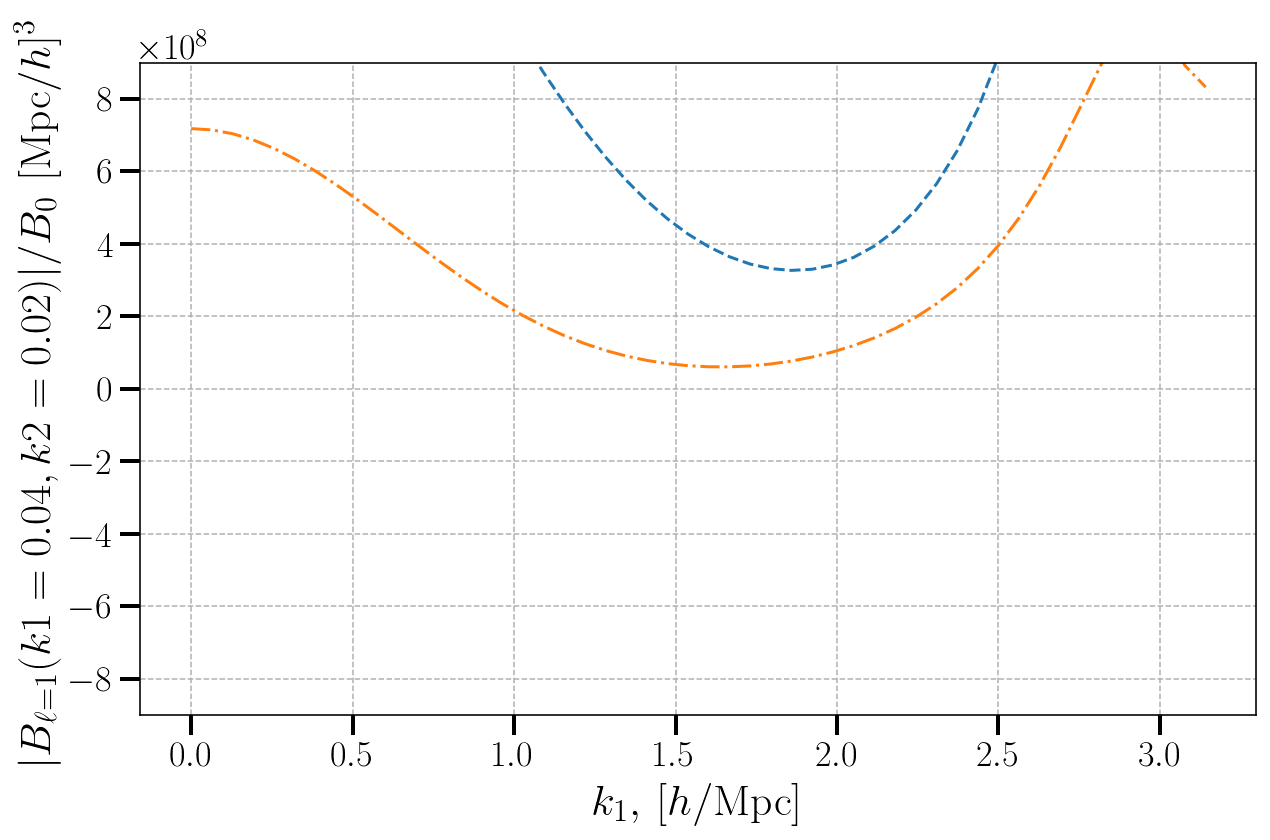

In [247]:
plt.figure(figsize=(10,6))
#plt.plot(theta,test.imag)
#plt.plot(theta,test2.imag)
plt.plot(theta,test3.imag,'--')


#plt.plot(theta,testnu12.imag,'--')
#plt.plot(theta,bk_wide_angle(ks1,ks2,theta,0,0)/427)
#plt.plot(theta,bk_wide_angle(ks1,ks2,theta,1,0)/427)
#plt.plot(theta,bk_wide_angle(ks1,ks2,theta,0,1)/427)
plt.plot(theta,bk_wide_angle(ks1,ks2,theta,0,1)/427,'-.')

plt.grid(ls='--',lw=0.75)


plt.ylim(-9e+8,9e+8)
#plt.xscale('log')
plt.xlabel('$k_1,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ |B_{\ell=1}(k1=0.04,k2=0.02)|/B_0 \,\,[\mathrm{Mpc}/h]^3$')

In [167]:
#so these are the 0th order WA parts which are first order in q1 and q2 
#then these are integrated to get the dipole parts in \mu1

#these are functions of q and k1,k2,k3 and d
def nu1_func(Pks1,Pks2,Pk3,ks1,ks2,k3,theta,nu1=1,b1=1):
    return f*nu1*(Pk3*Pks2*ks1*(2940*b1**3*k3**2*ks1**2*ks2 - 2352*b1**2*f*k3**2*ks1**2*ks2 + 3528*b1**2*f*ks1**4*ks2 + 3528*b1**2*f*ks1**2*ks2**3 - 420*b1**2*k3**4*ks2 + 1470*b1**2*k3**2*ks1**2*ks2 + 420*b1**2*k3**2*ks2**3 + 840*b1**2*ks1**4*ks2 + 420*b1**2*ks1**3*ks2**2*np.cos(3*theta) - 1050*b1**2*ks1**2*ks2**3 + 2940*b1*b2*k3**2*ks1**2*ks2 - 378*b1*f**2*k3**2*ks1**3*np.cos(3*theta) - 2268*b1*f**2*k3**2*ks1**2*ks2 - 3024*b1*f**2*ks1**4*ks2 + 1512*b1*f**2*ks1**2*ks2**3 - 294*b1*f*k3**4*ks1*np.cos(3*theta) - 168*b1*f*k3**4*ks2 - 294*b1*f*k3**2*ks1**3*np.cos(3*theta) + 168*b1*f*k3**2*ks1**2*ks2*np.cos(4*theta) - 2688*b1*f*k3**2*ks1**2*ks2 + 84*b1*f*k3**2*ks1*ks2**2*np.cos(3*theta) + 84*b1*f*ks1**4*ks2*np.cos(4*theta) + 2436*b1*f*ks1**4*ks2 + 1806*b1*f*ks1**3*ks2**2*np.cos(3*theta) + 168*b1*f*ks1**2*ks2**3*np.cos(4*theta) + 4368*b1*f*ks1**2*ks2**3 + 378*b1*f*ks1*ks2**4*np.cos(3*theta) + 168*b1*f*ks2**5 - 5880*b1*gamma2*k3**2*ks1**2*ks2 + 2940*b1*gamma2*ks1**4*ks2 + 1470*b1*gamma2*ks1**3*ks2**2*np.cos(3*theta) + 11760*b1*gamma2*ks1**2*ks2**3 + 1176*b2*f*k3**2*ks1**2*ks2 - 350*f**3*ks1**5*np.cos(3*theta) - 168*f**3*ks1**4*ks2*np.cos(4*theta) - 3024*f**3*ks1**4*ks2 - 630*f**3*ks1**3*ks2**2*np.cos(3*theta) - 560*f**3*ks1**2*ks2**3 - 504*f**2*k3**2*ks1**3*np.cos(3*theta) - 189*f**2*k3**2*ks1**2*ks2*np.cos(4*theta) - 1917*f**2*k3**2*ks1**2*ks2 - 306*f**2*k3**2*ks1*ks2**2*np.cos(3*theta) - 108*f**2*k3**2*ks2**3 + 288*f**2*ks1**4*ks2*np.cos(4*theta) + 1152*f**2*ks1**4*ks2 + 1836*f**2*ks1**3*ks2**2*np.cos(3*theta) + 108*f**2*ks1**3*ks2**2*np.cos(5*theta) + 387*f**2*ks1**2*ks2**3*np.cos(4*theta) + 2979*f**2*ks1**2*ks2**3 + 378*f**2*ks1*ks2**4*np.cos(3*theta) + 108*f**2*ks2**5 - 2352*f*gamma2*k3**2*ks1**2*ks2 + 294*f*gamma2*ks1**4*ks2*np.cos(4*theta) + 1470*f*gamma2*ks1**4*ks2 + 2058*f*gamma2*ks1**3*ks2**2*np.cos(3*theta) + 5880*f*gamma2*ks1**2*ks2**3 - 6*ks1*(245*b1**3*(k3**4 - k3**2*ks2**2) + 7*b1**2*(k3**4*(21*f + 70) + 2*k3**2*(ks1**2*(63*f + 35) - 60*ks2**2) - ks2**2*(ks1**2*(189*f + 40) + ks2**2*(21*f - 30))) + 7*b1*(3*f**2*(k3**2*(27*ks1**2 + 5*ks2**2) + 25*ks1**4 - 5*ks2**4) + f*(35*k3**4 + k3**2*(119*ks1**2 - 10*ks2**2) - 239*ks1**2*ks2**2 - 45*ks2**4) - 35*ks2**2*(2*b2*k3**2 + gamma2*(-4*k3**2 + 11*ks1**2 + 4*ks2**2))) + f*(70*f**2*(5*ks1**4 + 9*ks1**2*ks2**2) + 3*f*(k3**2*(112*ks1**2 + 83*ks2**2) - 312*ks1**2*ks2**2 - 99*ks2**4) - 49*ks2**2*(6*b2*k3**2 + gamma2*(-12*k3**2 + 29*ks1**2 + 12*ks2**2))))*np.cos(theta) + 6*ks2*(7*b1**2*ks1**2*(k3**2*(5 - 28*f) + 20*ks1**2 + ks2**2*(42*f + 5)) - 14*b1*(6*f**2*ks1**2*(3*k3**2 + 4*ks1**2 - 2*ks2**2) + f*(k3**4 + 27*k3**2*ks1**2 - 30*ks1**4 - 51*ks1**2*ks2**2 - ks2**4) - 35*gamma2*ks1**2*(ks1**2 + 2*ks2**2)) + f*(98*b2*k3**2*ks1**2 - 14*f**2*(32*ks1**4 + 5*ks1**2*ks2**2) + 3*f*(-k3**2*(113*ks1**2 + 4*ks2**2) + 80*ks1**4 + 183*ks1**2*ks2**2 + 4*ks2**4) + 98*gamma2*ks1**2*(-2*k3**2 + 3*ks1**2 + 8*ks2**2)))*np.cos(2*theta)) + Pks1*(-3*Pk3*ks2*(784*b1**2*f*k3**2*ks1*ks2**2 - 1176*b1**2*f*ks1**3*ks2**2 - 420*b1**2*k3**4*ks1 + 210*b1**2*k3**2*ks1*ks2**2 + 420*b1**2*ks1**5 - 350*b1**2*ks1**3*ks2**2 - 140*b1**2*ks1**2*ks2**3*np.cos(3*theta) - 980*b1*b2*k3**4*ks1 - 980*b1*b2*k3**2*ks1**3 + 1512*b1*f**2*k3**2*ks1*ks2**2 + 126*b1*f**2*k3**2*ks2**3*np.cos(3*theta) - 1008*b1*f**2*ks1**3*ks2**2 + 504*b1*f**2*ks1*ks2**4 + 56*b1*f*k3**4*ks1 + 98*b1*f*k3**4*ks2*np.cos(3*theta) - 504*b1*f*k3**2*ks1**3 - 28*b1*f*k3**2*ks1**2*ks2*np.cos(3*theta) - 56*b1*f*k3**2*ks1*ks2**2*np.cos(4*theta) + 728*b1*f*k3**2*ks1*ks2**2 + 98*b1*f*k3**2*ks2**3*np.cos(3*theta) + 448*b1*f*ks1**5 - 126*b1*f*ks1**4*ks2*np.cos(3*theta) - 56*b1*f*ks1**3*ks2**2*np.cos(4*theta) - 952*b1*f*ks1**3*ks2**2 - 434*b1*f*ks1**2*ks2**3*np.cos(3*theta) - 28*b1*f*ks1*ks2**4*np.cos(4*theta) - 140*b1*f*ks1*ks2**4 + 1960*b1*gamma2*k3**4*ks1 - 980*b1*gamma2*k3**2*ks1*ks2**2 - 1960*b1*gamma2*ks1**5 - 2940*b1*gamma2*ks1**3*ks2**2 - 490*b1*gamma2*ks1**2*ks2**3*np.cos(3*theta) - 1176*b2*f*k3**2*ks1**3 - 392*b2*f*k3**2*ks1*ks2**2 + 560*f**3*ks1**3*ks2**2 + 350*f**3*ks1**2*ks2**3*np.cos(3*theta) + 56*f**3*ks1*ks2**4*np.cos(4*theta) + 1008*f**3*ks1*ks2**4 + 70*f**3*ks2**5*np.cos(3*theta) + 72*f**2*k3**2*ks1**3 + 186*f**2*k3**2*ks1**2*ks2*np.cos(3*theta) + 63*f**2*k3**2*ks1*ks2**2*np.cos(4*theta) + 603*f**2*k3**2*ks1*ks2**2 + 84*f**2*k3**2*ks2**3*np.cos(3*theta) - 72*f**2*ks1**5 - 234*f**2*ks1**4*ks2*np.cos(3*theta) - 177*f**2*ks1**3*ks2**2*np.cos(4*theta) - 1149*f**2*ks1**3*ks2**2 - 504*f**2*ks1**2*ks2**3*np.cos(3*theta) - 36*f**2*ks1**2*ks2**3*np.cos(5*theta) - 48*f**2*ks1*ks2**4*np.cos(4*theta) - 192*f**2*ks1*ks2**4 + 2352*f*gamma2*k3**2*ks1**3 + 784*f*gamma2*k3**2*ks1*ks2**2 - 2352*f*gamma2*ks1**5 - 5488*f*gamma2*ks1**3*ks2**2 - 1274*f*gamma2*ks1**2*ks2**3*np.cos(3*theta) - 98*f*gamma2*ks1*ks2**4*np.cos(4*theta) - 490*f*gamma2*ks1*ks2**4 - 2*ks1*(-7*b1**2*ks2**2*(k3**2*(28*f + 15) - ks1**2*(42*f + 25)) - 14*b1*(12*f**2*ks2**2*(3*k3**2 - 2*ks1**2 + ks2**2) + f*(k3**4 + 27*k3**2*ks2**2 - ks1**4 - 39*ks1**2*ks2**2 - 6*ks2**4) - 35*gamma2*ks2**2*(k3**2 + 3*ks1**2)) + f*(-14*f**2*(15*ks1**2*ks2**2 + 32*ks2**4) + 3*f*(-k3**2*(8*ks1**2 + 109*ks2**2) + 8*ks1**4 + 219*ks1**2*ks2**2 + 40*ks2**4) + 98*ks2**2*(b2*k3**2 + gamma2*(-2*k3**2 + 26*ks1**2 + 3*ks2**2))))*np.cos(2*theta) + 2*ks2*(245*b1**3*(k3**4 - k3**2*ks1**2) + 7*b1**2*(k3**4*(63*f + 70) + 6*k3**2*(7*f*ks2**2 + 5*ks1**2) - ks1**4*(63*f - 20) - ks1**2*ks2**2*(63*f + 30)) + 7*b1*(3*f**2*(k3**2*(25*ks1**2 + 27*ks2**2) - 25*ks1**4 + 5*ks2**4) + f*(35*k3**4 + k3**2*(26*ks1**2 + 35*ks2**2) - 9*ks1**4 - 95*ks1**2*ks2**2) - 35*ks1**2*(2*b2*k3**2 + 4*gamma2*k3**2 + 3*gamma2*(4*ks1**2 + ks2**2))) + f*(-882*b2*k3**2*ks1**2 + 210*f**2*(5*ks1**2*ks2**2 + ks2**4) + 3*f*k3**2*(139*ks1**2 + 56*ks2**2) - 9*f*(57*ks1**4 + 80*ks1**2*ks2**2) - 49*gamma2*ks1**2*(-36*k3**2 + 84*ks1**2 + 47*ks2**2)))*np.cos(theta)) + Pks2*k3**2*(2940*b1**3*k3**2*ks1*ks2 + 8232*b1**2*f*k3**2*ks1*ks2 + 5040*b1**2*k3**2*ks1*ks2 + 5670*b1**2*ks1**3*ks2 + 840*b1**2*ks1**2*ks2**2*np.cos(3*theta) + 1470*b1**2*ks1*ks2**3 + 2940*b1*b2*k3**2*ks1*ks2 + 378*b1*f**2*k3**2*ks1**2*np.cos(3*theta) + 6804*b1*f**2*k3**2*ks1*ks2 + 378*b1*f**2*k3**2*ks2**2*np.cos(3*theta) + 294*b1*f*k3**2*ks1**2*np.cos(3*theta) + 84*b1*f*k3**2*ks1*ks2*np.cos(4*theta) + 2100*b1*f*k3**2*ks1*ks2 + 294*b1*f*k3**2*ks2**2*np.cos(3*theta) + 294*b1*f*ks1**4*np.cos(3*theta) + 168*b1*f*ks1**3*ks2*np.cos(4*theta) + 10416*b1*f*ks1**3*ks2 + 2604*b1*f*ks1**2*ks2**2*np.cos(3*theta) + 168*b1*f*ks1*ks2**3*np.cos(4*theta) + 5376*b1*f*ks1*ks2**3 + 294*b1*f*ks2**4*np.cos(3*theta) - 2940*b1*gamma2*k3**2*ks1*ks2 + 1176*b2*f*k3**2*ks1*ks2 + 350*f**3*k3**2*ks1**2*np.cos(3*theta) + 112*f**3*k3**2*ks1*ks2*np.cos(4*theta) + 2016*f**3*k3**2*ks1*ks2 + 210*f**3*k3**2*ks2**2*np.cos(3*theta) + 504*f**2*ks1**4*np.cos(3*theta) + 477*f**2*ks1**3*ks2*np.cos(4*theta) + 4149*f**2*ks1**3*ks2 + 2268*f**2*ks1**2*ks2**2*np.cos(3*theta) + 108*f**2*ks1**2*ks2**2*np.cos(5*theta) + 333*f**2*ks1*ks2**3*np.cos(4*theta) + 2925*f**2*ks1*ks2**3 + 252*f**2*ks2**4*np.cos(3*theta) + 294*f*gamma2*k3**2*ks1*ks2*np.cos(4*theta) - 882*f*gamma2*k3**2*ks1*ks2 + 2*ks1*ks2*(21*b1**2*(k3**2*(56*f + 20) + 75*ks1**2 + 35*ks2**2) + 42*b1*(54*f**2*k3**2 + 4*f*(4*k3**2 + 21*ks1**2 + 15*ks2**2) + 35*gamma2*k3**2) + f*(294*b2*k3**2 + 896*f**2*k3**2 + 2097*f*ks1**2 + 1521*f*ks2**2 + 294*gamma2*k3**2))*np.cos(2*theta) + (1470*b1**3*k3**2*(ks1**2 + ks2**2) + 42*b1**2*(7*k3**2*(ks1**2*(21*f + 10) + ks2**2*(15*f + 10)) + 70*ks1**4 + 190*ks1**2*ks2**2) + 42*b1*f*(k3**2*(ks1**2*(156*f + 35) + ks2**2*(96*f + 35)) + 119*ks1**4 + 442*ks1**2*ks2**2 + 35*ks2**4) + 12*f**2*(35*f*k3**2*(5*ks1**2 + 3*ks2**2) + 168*ks1**4 + 747*ks1**2*ks2**2 + 84*ks2**4))*np.cos(theta))))/(1470*k3**4*ks1**2*ks2)

def nu2_func(Pks1,Pks2,Pks3,ks1,ks2,ks3,theta,nu2=1,b1=1):
    return f*nu2*(Pks1*(Pks2*ks3**2*(735*b1**3*ks1**2*ks3**2 + 735*b1**3*ks2**2*ks3**2 + 1764*b1**2*f*ks1**2*ks3**2 + 2205*b1**2*f*ks2**2*ks3**2 + 2835*b1**2*ks1**2*ks2**2 + 735*b1**2*ks1**2*ks3**2 + 420*b1**2*ks1*ks2**3*np.cos(3*theta) + 210*b1**2*ks1*ks2*ks3**2*np.cos(3*theta) + 735*b1**2*ks2**4 + 735*b1**2*ks2**2*ks3**2 + 1449*b1*f**2*ks1**2*ks3**2 + 378*b1*f**2*ks1*ks2*ks3**2*np.cos(3*theta) + 2079*b1*f**2*ks2**2*ks3**2 + 441*b1*f*ks1**4 + 693*b1*f*ks1**3*ks2*np.cos(3*theta) + 252*b1*f*ks1**2*ks2**2*np.cos(4*theta) + 5796*b1*f*ks1**2*ks2**2 + 441*b1*f*ks1**2*ks3**2 + 1197*b1*f*ks1*ks2**3*np.cos(3*theta) + 126*b1*f*ks1*ks2*ks3**2*np.cos(3*theta) + 1323*b1*f*ks2**4 + 441*b1*f*ks2**2*ks3**2 + 735*b1*gamma2*ks1*ks2*ks3**2*np.cos(3*theta) + 420*f**3*ks1**2*ks3**2 + 280*f**3*ks1*ks2*ks3**2*np.cos(3*theta) + 35*f**3*ks2**2*ks3**2*np.cos(4*theta) + 630*f**3*ks2**2*ks3**2 + 315*f**2*ks1**4 + 558*f**2*ks1**3*ks2*np.cos(3*theta) + 279*f**2*ks1**2*ks2**2*np.cos(4*theta) + 2718*f**2*ks1**2*ks2**2 + 882*f**2*ks1*ks2**3*np.cos(3*theta) + 36*f**2*ks1*ks2**3*np.cos(5*theta) + 63*f**2*ks2**4*np.cos(4*theta) + 567*f**2*ks2**4 + 441*f*gamma2*ks1*ks2*ks3**2*np.cos(3*theta) + 3*ks1*ks2*(490*b1**3*ks3**2 + 14*b1**2*(35*ks1**2 + 95*ks2**2 + ks3**2*(126*f + 65)) + 7*b1*(252*f**2*ks3**2 + 3*f*(73*ks1**2 + 121*ks2**2 + 26*ks3**2) + ks3**2*(70*b2 - 35*gamma2)) + f*(560*f**2*ks3**2 + 12*f*(72*ks1**2 + 97*ks2**2) + ks3**2*(294*b2 - 147*gamma2)))*np.cos(theta) + (21*b1**2*(ks1**2*(75*ks2**2 + ks3**2*(21*f + 35)) + 7*ks2**2*(5*ks2**2 + ks3**2*(6*f + 5))) + 63*b1*f*(7*ks1**4 + ks1**2*(72*ks2**2 + ks3**2*(12*f + 7)) + 21*ks2**4 + ks2**2*ks3**2*(22*f + 7)) + f**2*(560*f*ks2**2*ks3**2 + 315*ks1**4 + 9*ks1**2*(35*f*ks3**2 + 297*ks2**2) + 630*ks2**4))*np.cos(2*theta)) + Pks3*ks2*(ks1*(1470*b1**3*ks2**2*ks3**2 + 42*b1**2*(ks1**2*(ks2**2*(63*f - 10) + 5*ks3**2) + ks2**4*(42*f + 15) + ks2**2*ks3**2*(10 - 42*f) - 5*ks3**4) + 21*b1*(-6*f**2*ks2**2*(-10*ks1**2 + 18*ks2**2 + 15*ks3**2) + 3*f*(2*ks1**4 + 57*ks1**2*ks2**2 + 30*ks2**4 - 35*ks2**2*ks3**2 - 2*ks3**4) + 35*ks2**2*(2*b2*ks3**2 + gamma2*(12*ks1**2 + 3*ks2**2 - 4*ks3**2))) + f*(-70*f**2*(7*ks1**2*ks2**2 + 36*ks2**4) + 18*f*(5*ks1**4 + ks1**2*(147*ks2**2 - 5*ks3**2) + 56*ks2**4 - 93*ks2**2*ks3**2) + 441*ks2**2*(2*b2*ks3**2 + gamma2*(12*ks1**2 + 3*ks2**2 - 4*ks3**2))))*np.cos(theta) + ks2*(735*b1**3*ks1**2*ks3**2 - 735*b1**3*ks3**4 + 441*b1**2*f*ks1**4 + 2646*b1**2*f*ks1**2*ks2**2 - 1764*b1**2*f*ks2**2*ks3**2 - 441*b1**2*f*ks3**4 - 630*b1**2*ks1**4 + 525*b1**2*ks1**2*ks2**2 + 1575*b1**2*ks1**2*ks3**2 - 735*b1**2*ks2**2*ks3**2 - 735*b1**2*ks3**4 + 1470*b1*b2*ks1**2*ks3**2 + 315*b1*f**2*ks1**4 - 315*b1*f**2*ks1**2*ks3**2 - 945*b1*f**2*ks2**4 - 1134*b1*f**2*ks2**2*ks3**2 + 441*b1*f*ks1**4 + 252*b1*f*ks1**2*ks2**2*np.cos(4*theta) + 2709*b1*f*ks1**2*ks2**2 + 252*b1*f*ks1**2*ks3**2 - 1323*b1*f*ks2**2*ks3**2 - 441*b1*f*ks3**4 + 2940*b1*gamma2*ks1**4 + 4410*b1*gamma2*ks1**2*ks2**2 - 2940*b1*gamma2*ks1**2*ks3**2 + 882*b2*f*ks1**2*ks3**2 - 1260*f**3*ks1**2*ks2**2 - 35*f**3*ks2**4*np.cos(4*theta) - 630*f**3*ks2**4 + 567*f**2*ks1**4 + 297*f**2*ks1**2*ks2**2*np.cos(4*theta) + 1593*f**2*ks1**2*ks2**2 - 477*f**2*ks1**2*ks3**2 + 36*f**2*ks1*ks2**3*np.cos(5*theta) - 63*f**2*ks2**2*ks3**2*np.cos(4*theta) - 567*f**2*ks2**2*ks3**2 + 1764*f*gamma2*ks1**4 + 2646*f*gamma2*ks1**2*ks2**2 - 1764*f*gamma2*ks1**2*ks3**2 + 3*ks1*ks2*(70*b1**2*(ks2**2 + 2*ks3**2) - 7*b1*(12*f**2*ks2**2 + f*(-39*ks1**2 - 30*ks2**2 + 9*ks3**2) - 35*gamma2*ks2**2) + f*(-140*f**2*ks2**2 + 228*f*ks1**2 + 132*f*(ks2**2 - ks3**2) + 147*gamma2*ks2**2))*np.cos(3*theta) + (21*b1**2*(ks1**2*(ks2**2*(63*f + 25) + 45*ks3**2) - 7*ks3**2*(ks2**2*(6*f + 5) + 5*ks3**2)) - 63*b1*(2*f**2*(5*ks2**4 + 6*ks2**2*ks3**2) + f*(-11*ks1**4 - 47*ks1**2*ks2**2 + 21*ks2**2*ks3**2 + 7*ks3**4) - 70*gamma2*ks1**2*ks2**2) + f*(-35*f**2*(27*ks1**2*ks2**2 + 16*ks2**4) + 9*f*(57*ks1**4 + ks1**2*(210*ks2**2 - 47*ks3**2) - 70*ks2**2*ks3**2) + 2646*gamma2*ks1**2*ks2**2))*np.cos(2*theta)))) + 3*Pks2*Pks3*ks1*(245*b1**3*ks1*ks2**2*ks3**2 - 245*b1**3*ks1*ks3**4 + 441*b1**2*f*ks1**3*ks2**2 - 294*b1**2*f*ks1**3*ks3**2 + 294*b1**2*f*ks1*ks2**4 - 294*b1**2*f*ks1*ks3**4 + 140*b1**2*ks1**3*ks2**2 + 70*b1**2*ks1**2*ks2**3*np.cos(3*theta) + 70*b1**2*ks1**2*ks2*ks3**2*np.cos(3*theta) - 175*b1**2*ks1*ks2**4 - 245*b1**2*ks1*ks3**4 + 490*b1*b2*ks1*ks2**2*ks3**2 - 105*b1*f**2*ks1**5 - 378*b1*f**2*ks1**3*ks3**2 + 84*b1*f**2*ks1**2*ks2**3*np.cos(3*theta) - 126*b1*f**2*ks1**2*ks2*ks3**2*np.cos(3*theta) + 315*b1*f**2*ks1*ks2**4 - 315*b1*f**2*ks1*ks2**2*ks3**2 + 42*b1*f*ks1**4*ks2*np.cos(3*theta) + 42*b1*f*ks1**3*ks2**2*np.cos(4*theta) + 399*b1*f*ks1**3*ks2**2 - 147*b1*f*ks1**3*ks3**2 + 189*b1*f*ks1**2*ks2**3*np.cos(3*theta) - 63*b1*f*ks1**2*ks2*ks3**2*np.cos(3*theta) + 21*b1*f*ks1*ks2**4 - 42*b1*f*ks1*ks2**2*ks3**2 - 147*b1*f*ks1*ks3**4 + 490*b1*gamma2*ks1**3*ks2**2 + 245*b1*gamma2*ks1**2*ks2**3*np.cos(3*theta) + 245*b1*gamma2*ks1**2*ks2*ks3**2*np.cos(3*theta) + 1960*b1*gamma2*ks1*ks2**4 + 588*b2*f*ks1*ks2**2*ks3**2 - 140*f**3*ks1**5 - 140*f**3*ks1**4*ks2*np.cos(3*theta) - 35*f**3*ks1**3*ks2**2*np.cos(4*theta) - 630*f**3*ks1**3*ks2**2 - 70*f**3*ks1**2*ks2**3*np.cos(3*theta) + 60*f**2*ks1**4*ks2*np.cos(3*theta) + 72*f**2*ks1**3*ks2**2*np.cos(4*theta) + 423*f**2*ks1**3*ks2**2 - 105*f**2*ks1**3*ks3**2 + 294*f**2*ks1**2*ks2**3*np.cos(3*theta) + 12*f**2*ks1**2*ks2**3*np.cos(5*theta) - 126*f**2*ks1**2*ks2*ks3**2*np.cos(3*theta) + 27*f**2*ks1*ks2**4*np.cos(4*theta) + 297*f**2*ks1*ks2**4 - 21*f**2*ks1*ks2**2*ks3**2*np.cos(4*theta) - 243*f**2*ks1*ks2**2*ks3**2 + 6*f**2*ks2**5*np.cos(3*theta) - 6*f**2*ks2**3*ks3**2*np.cos(3*theta) + 147*f*gamma2*ks1**4*ks2*np.cos(3*theta) + 147*f*gamma2*ks1**3*ks2**2*np.cos(4*theta) + 1323*f*gamma2*ks1**3*ks2**2 + 882*f*gamma2*ks1**2*ks2**3*np.cos(3*theta) + 2352*f*gamma2*ks1*ks2**4 - 1176*f*gamma2*ks1*ks2**2*ks3**2 - ks1*(-35*b1*(b1*(4*ks1**2*ks2**2 + ks2**4 - 6*ks2**2*ks3**2 - 7*ks3**4) + 14*gamma2*ks2**2*(ks1**2 + 2*ks2**2 + 2*ks3**2)) + 35*f**3*(3*ks1**4 + 16*ks1**2*ks2**2) - 3*f**2*(ks1**2*(165*ks2**2 - ks3**2*(84*b1 + 35)) + ks2**4*(70*b1 + 102) - ks2**2*ks3**2*(70*b1 + 82)) - 21*f*(7*b1**2*(ks2**4 - ks3**4) + b1*(7*ks1**2*(3*ks2**2 - ks3**2) + 5*ks2**4 - 6*ks2**2*ks3**2 - 7*ks3**4) + 14*ks2**2*(b2*ks3**2 + gamma2*(5*ks1**2 + 6*ks2**2 - 2*ks3**2))))*np.cos(2*theta) + ks2*(14*b1**2*(ks1**2*(ks2**2*(63*f + 20) - ks3**2*(42*f + 20)) - 15*ks2**4 + 15*ks3**4) - 7*b1*(-70*b2*ks3**2*(ks2**2 + ks3**2) + 6*f**2*ks1**2*(10*ks1**2 - 18*ks2**2 + 27*ks3**2) - 3*f*(6*ks1**4 + ks1**2*(41*ks2**2 - 31*ks3**2) - 10*ks2**4 + 12*ks2**2*ks3**2 - 2*ks3**4) - 35*gamma2*ks1**2*(11*ks2**2 + 3*ks3**2) - 140*gamma2*(ks2**4 - ks3**4)) + 3*f*(98*b2*ks3**2*(ks1**2 + 2*ks2**2) - 140*f**2*ks1**2*(2*ks1**2 + ks2**2) + 2*f*(30*ks1**4 + ks1**2*(169*ks2**2 - 89*ks3**2) + 9*ks2**2*(ks2**2 - ks3**2)) + 49*gamma2*(3*ks1**4 + 30*ks1**2*ks2**2 - 4*ks1**2*ks3**2 + 8*ks2**4 - 8*ks2**2*ks3**2)))*np.cos(theta)))/(735*ks1*ks2**2*ks3**4)

In [18]:
with open('../../mathematica_output.txt') as file:
    string1 = file.read()
    #string1 = convert_brackets(string1, 'P')
    string1 = string1.replace("Pk1d","Pkd1").replace("Pk2d","Pkd2").replace("Pk3d","Pkd3")
    #string1 = string1.replace('\n','').replace('  ','').replace("PLff", "Plin_dd").replace("PLf", "Plin_d").replace("PL", "Plin").replace("x", "d").replace("[Omega]", "Omega_m")
    #string1 = string1.replace("Pk^\[Prime]\[Prime]", "Plin_dd").replace("Derivative[1][Pk]", "Plin_d").replace("Pk", "Plin").replace("[ks]", "").replace("ks", "k")#for own calc
#print(string1.replace(". ", "").replace("\n", "").replace("\\", "").replace("x", "d").replace("kd^2", "(k*d**2)"))#.replace("k", "k[i]"))
#change multiplication and
python_mathematica = mathematica(string1)#
print(str(python_mathematica).replace('cos','np.cos').replace('sin','np.sin').replace('sqrt','np.sqrt').replace('exp','np.exp'))


f*nu2*(Pks1*(Pks2*ks3**2*(735*b1**3*ks1**2*ks3**2 + 735*b1**3*ks2**2*ks3**2 + 1764*b1**2*f*ks1**2*ks3**2 + 2205*b1**2*f*ks2**2*ks3**2 + 2835*b1**2*ks1**2*ks2**2 + 735*b1**2*ks1**2*ks3**2 + 420*b1**2*ks1*ks2**3*np.cos(3*theta) + 210*b1**2*ks1*ks2*ks3**2*np.cos(3*theta) + 735*b1**2*ks2**4 + 735*b1**2*ks2**2*ks3**2 + 1449*b1*f**2*ks1**2*ks3**2 + 378*b1*f**2*ks1*ks2*ks3**2*np.cos(3*theta) + 2079*b1*f**2*ks2**2*ks3**2 + 441*b1*f*ks1**4 + 693*b1*f*ks1**3*ks2*np.cos(3*theta) + 252*b1*f*ks1**2*ks2**2*np.cos(4*theta) + 5796*b1*f*ks1**2*ks2**2 + 441*b1*f*ks1**2*ks3**2 + 1197*b1*f*ks1*ks2**3*np.cos(3*theta) + 126*b1*f*ks1*ks2*ks3**2*np.cos(3*theta) + 1323*b1*f*ks2**4 + 441*b1*f*ks2**2*ks3**2 + 735*b1*gamma2*ks1*ks2*ks3**2*np.cos(3*theta) + 420*f**3*ks1**2*ks3**2 + 280*f**3*ks1*ks2*ks3**2*np.cos(3*theta) + 35*f**3*ks2**2*ks3**2*np.cos(4*theta) + 630*f**3*ks2**2*ks3**2 + 315*f**2*ks1**4 + 558*f**2*ks1**3*ks2*np.cos(3*theta) + 279*f**2*ks1**2*ks2**2*np.cos(4*theta) + 2718*f**2*ks1**2*ks2**2 + 882*f*

In [11]:
b1= 1.46
gamma2 = -(2/7)*(b1-1) #0.524 -0.547*b1 +0.046*b1**2#-(2/7)*(b1-1) #-(2/7)*(b1-1) #0.524 -0.547*b1 +0.046*b1**2#-(2/7)*(b1-1) #
b2= 0.412 - 2.143*b1 +0.929*b1**2 + 0.008*b1**3 + 4/3 * gamma2
print(gamma2)

-0.13142857142857142


In [198]:
b1 = 1
b2 = 0
gamma2 = 0

@jit(nopython=True)
def sqrt(x):
    return x**(1/2)
@jit(nopython=True)
def cos(x):
    return np.cos(x)
@jit(nopython=True)
def sin(x):
    return np.sin(x)
@jit(nopython=True)
def exp(x):
    return np.exp(x)

theta= np.linspace(0,np.pi,50)
k2 = 0.05
k1 = k2/1.1#2*k1/7#k1/5
k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))


In [30]:
# Lambda CDM
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy import interpolate
LCDM = Class()
LCDM.compute()
print(LCDM.get_current_derived_parameters)
baLCDM = LCDM.get_background()
print(baLCDM.keys())
f_cl = baLCDM['gr.fac. f']
z_cl = baLCDM['z']
H_cl = baLCDM['H [1/Mpc]'];H = interp1d(z_cl,H_cl*(1/(1+z_cl))/h,kind='cubic') # now in h/Mpc!
xi_cl = baLCDM['comov. dist.']; comoving_dist = interp1d(z_cl,xi_cl*h,kind='cubic') # just use class background as quick
f_intp = interp1d(z_cl,f_cl,kind='cubic')#get f #omega_mz = Omega_m *(1+zt)**3 /(Omega_m *(1+zt)**3 + Omega_l)

<built-in method get_current_derived_parameters of classy.Class object at 0x561da1cfb780>
dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])


In [32]:
#%%time
z= 0.0
print(z)
#ok so set a comoving distance of observation
#d = comoving_dist(z)

#set z ...
def get_class_powerspectrum(kk,zz): #h are needed to convert to 1/Mpc for k then convert pk back to (Mpc/h)^3
    
    return np.array([cosmo.pk_lin(ki, zz) for ki in kk*h])*h**3

def get_pkinfo_z(k,z):
    Plin = get_class_powerspectrum(k,z)
    Pk = interpolate.interp1d(k,Plin)#Plin
    Pk_d = interpolate.interp1d(k,np.gradient(Plin,k))#(k[1:]+k[:-1])/2,np.diff(Plin)/np.diff(k)
    Pk_dd = interpolate.interp1d(k,np.gradient(Pk_d(k),k))
    return Pk,Pk_d,Pk_dd

#so set parameters...
Pk,Pk_d,Pk_dd = get_pkinfo_z(k,z)

f = f_intp(z)

#Pk1 = Pk(k1)
#Pk2 = Pk(k2)
#Pk3 = Pk(k3)

#Pkd1= Pk_d(k1)
#Pkd2 = Pk_d(k2)
#Pkd3 = Pk_d(k3)

0.0


In [15]:
def bk_real(k1,k2,theta):
    """Real space bispectrum"""
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)
    return (k1*k2*(19*Pk1*Pk2*k1**2 + 2*Pk1*Pk2*k1*k2*np.cos(3*theta) + 19*Pk1*Pk2*k2**2 - 2*Pk1*Pk3*k2**2 - 2*Pk2*Pk3*k1**2 + (Pk1*k2**2*(9*Pk2 - 5*Pk3) + Pk2*k1**2*(9*Pk1 - 5*Pk3))*np.cos(2*theta)) + (40*Pk1*Pk2*k1**2*k2**2 + 7*Pk1*k2**4*(Pk2 - Pk3) + 7*Pk2*k1**4*(Pk1 - Pk3))*np.cos(theta))/(7*k1*k2*(k1**2 + 2*k1*k2*np.cos(theta) + k2**2))



In [16]:
#ok so we have to do numerical integration for FOG of the bispectrum... PP parts that can be integrated for monpole or quadrupole
def bk_dfog(l,k1,k2,theta):
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)
    sigma = 2
    def integrand(phi,mu):
        expression = (Pk1*Pk2*(b1 + f*mu**2)*(b1 + f*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2)*(b1*f*k1*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/k2 + b1*f*mu**2 + b1*f*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2 + b1*f*k2*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/k1 + b1*k1*np.cos(theta)/k2 + 4*b1*np.cos(theta)**2/7 + 10*b1/7 + b1*k2*np.cos(theta)/k1 + b2 + f**2*k1*mu**3*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/k2 + 2*f**2*mu**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2 + f**2*k2*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**3/k1 + f*k1**3*mu**2*np.cos(theta)/(k2*k3**2) + 8*f*k1**2*mu**2*np.cos(theta)**2/(7*k3**2) + 6*f*k1**2*mu**2/(7*k3**2) + 2*f*k1**2*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))*np.cos(theta)/k3**2 + f*k1*k2*mu**2*np.cos(theta)/k3**2 + 16*f*k1*k2*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))*np.cos(theta)**2/(7*k3**2) + 12*f*k1*k2*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/(7*k3**2) + f*k1*k2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2*np.cos(theta)/k3**2 + 2*f*k2**2*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))*np.cos(theta)/k3**2 + 8*f*k2**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2*np.cos(theta)**2/(7*k3**2) + 6*f*k2**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2/(7*k3**2) + f*k2**3*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2*np.cos(theta)/(k1*k3**2) + 2*gamma2*np.cos(theta)**2 - 2*gamma2) + Pk1*Pk3*(b1 + f*mu**2)*(b1 + f*(-k1*mu - k2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)))**2/k3**2)*(b1*f*k1*k2*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/k3**2 + b1*f*k2**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2/k3**2 - b1*f*k2*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/k1 - 3*b1*k1**2/(7*k3**2) + b1*k1*k2*np.cos(theta)/(7*k3**2) + 4*b1*k2**2*np.cos(theta)**2/(7*k3**2) + 3*b1/7 - b1*k2*np.cos(theta)/k1 + b2 - f**2*k2**2*mu**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2/k3**2 - f**2*k2**3*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**3/(k1*k3**2) + f*k1**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2/(7*k3**2) + 9*f*k1*k2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2*np.cos(theta)/(7*k3**2) + 8*f*k2**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2*np.cos(theta)**2/(7*k3**2) - f*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2/7 - f*k2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2*np.cos(theta)/k1 + 2*gamma2*k1**2/k3**2 + 4*gamma2*k1*k2*np.cos(theta)/k3**2 + 2*gamma2*k2**2*np.cos(theta)**2/k3**2 - 2*gamma2) + Pk2*Pk3*(b1 + f*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2)*(b1 + f*(-k1*mu - k2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)))**2/k3**2)*(b1*f*k1**2*mu**2/k3**2 + b1*f*k1*k2*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/k3**2 - b1*f*k1*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/k2 + 4*b1*k1**2*np.cos(theta)**2/(7*k3**2) + b1*k1*k2*np.cos(theta)/(7*k3**2) - b1*k1*np.cos(theta)/k2 - 3*b1*k2**2/(7*k3**2) + 3*b1/7 + b2 - f**2*k1**3*mu**3*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/(k2*k3**2) - f**2*k1**2*mu**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2/k3**2 + 8*f*k1**2*mu**2*np.cos(theta)**2/(7*k3**2) + 9*f*k1*k2*mu**2*np.cos(theta)/(7*k3**2) - f*k1*mu**2*np.cos(theta)/k2 + f*k2**2*mu**2/(7*k3**2) - f*mu**2/7 + 2*gamma2*k1**2*np.cos(theta)**2/k3**2 + 4*gamma2*k1*k2*np.cos(theta)/k3**2 + 2*gamma2*k2**2/k3**2 - 2*gamma2))*np.exp(sigma**2*(-k1**2*mu**2 - k2**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2 - k3**2*(-k1*mu/k3 + k2*(-mu*np.cos(theta) - np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/k3)**2))
        legendre = scipy.special.eval_legendre(l, mu)
        return (2*l+1)*legendre*expression/(4*np.pi)
    
    result, error = integrate.nquad(integrand, [[0, 2*np.pi], [-1, 1]])            
    return result,error

print(bk_dfog(0,0.08,0.06,np.pi/2))

(311434333.34190017, 0.21274066770510774)


In [17]:
%%time
bk_arr = np.zeros(len(theta))
for i in tqdm(range(len(theta))):
    bk_arr[i]=bk_dfog(2,k1,k2,theta[i])[0]

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 13.3 s, sys: 88 ms, total: 13.4 s
Wall time: 13.4 s


In [19]:
#PP monopole and parallel in redshift space
def bk_mono_func(k1,k2,theta):
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)
    
    #monopole parts
    bkperm3 = -Pk2*Pk3*(1470*b1**3*f*k1**4*k2 + 1470*b1**3*f*k1**3*k2**2*cos(3*theta) + 5670*b1**3*k1**4*k2 + 3150*b1**3*k1**3*k2**2*cos(3*theta) + 1260*b1**3*k1**2*k2**3 - 4410*b1**2*b2*k1**4*k2 - 17640*b1**2*b2*k1**2*k2**3 - 4410*b1**2*b2*k2**5 + 3822*b1**2*f**2*k1**4*k2 + 1470*b1**2*f**2*k1**3*k2**2*cos(3*theta) + 1176*b1**2*f**2*k1**2*k2**3 + 6090*b1**2*f*k1**4*k2 + 2730*b1**2*f*k1**3*k2**2*cos(3*theta) + 1680*b1**2*f*k1**2*k2**3 + 4410*b1**2*gamma2*k1**4*k2 - 4410*b1**2*gamma2*k1**3*k2**2*cos(3*theta) + 4410*b1**2*gamma2*k1**2*k2**3 - 2940*b1*b2*f*k1**4*k2 - 11760*b1*b2*f*k1**2*k2**3 - 2940*b1*b2*f*k2**5 + 126*b1*f**3*k1**5*cos(3*theta) + 126*b1*f**3*k1**4*k2*cos(4*theta) + 3024*b1*f**3*k1**4*k2 + 882*b1*f**3*k1**3*k2**2*cos(3*theta) + 1008*b1*f**3*k1**2*k2**3 + 294*b1*f**2*k1**5*cos(3*theta) + 315*b1*f**2*k1**4*k2*cos(4*theta) + 3675*b1*f**2*k1**4*k2 + 1785*b1*f**2*k1**3*k2**2*cos(3*theta) + 63*b1*f**2*k1**3*k2**2*cos(5*theta) + 126*b1*f**2*k1**2*k2**3*cos(4*theta) + 1050*b1*f**2*k1**2*k2**3 + 2940*b1*f*gamma2*k1**4*k2 - 2940*b1*f*gamma2*k1**3*k2**2*cos(3*theta) + 2940*b1*f*gamma2*k1**2*k2**3 - 588*b2*f**2*k1**4*k2 - 294*b2*f**2*k1**3*k2**2*cos(3*theta) - 3234*b2*f**2*k1**2*k2**3 - 882*b2*f**2*k2**5 + 70*f**4*k1**5*cos(3*theta) + 42*f**4*k1**4*k2*cos(4*theta) + 756*f**4*k1**4*k2 + 210*f**4*k1**3*k2**2*cos(3*theta) + 280*f**4*k1**2*k2**3 + 126*f**3*k1**5*cos(3*theta) + 117*f**3*k1**4*k2*cos(4*theta) + 837*f**3*k1**4*k2 + 441*f**3*k1**3*k2**2*cos(3*theta) + 27*f**3*k1**3*k2**2*cos(5*theta) + 54*f**3*k1**2*k2**3*cos(4*theta) + 270*f**3*k1**2*k2**3 - 147*f**2*gamma2*k1**4*k2*cos(4*theta) + 441*f**2*gamma2*k1**4*k2 - 882*f**2*gamma2*k1**3*k2**2*cos(3*theta) + 882*f**2*gamma2*k1**2*k2**3 + 6*k1**2*k2*(35*b1**3*(k1**2*(14*f + 36) + k2**2*(7*f + 15)) + 7*b1**2*(-210*b2*k2**2 + 7*f**2*(14*k1**2 + 5*k2**2) + 5*f*(34*k1**2 + 13*k2**2) - 105*gamma2*(k1**2 + k2**2)) + 7*b1*f*(-140*b2*k2**2 + 3*f**2*(20*k1**2 + 7*k2**2) + f*(94*k1**2 + 35*k2**2) - 70*gamma2*(k1**2 + k2**2)) + f**2*(-49*b2*(k1**2 + 7*k2**2) + 7*f**2*(16*k1**2 + 5*k2**2) + 3*f*(52*k1**2 + 17*k2**2) - 49*gamma2*(k1**2 + 3*k2**2)))*cos(2*theta) + 6*k1*(35*b1**3*(k1**4*(7*f + 21) + k1**2*k2**2*(14*f + 48)) + 7*b1**2*(7*f**2*(9*k1**4 + 22*k1**2*k2**2) + 5*f*(21*k1**4 + 50*k1**2*k2**2) - 105*k2**2*(4*b2*(k1**2 + k2**2) - gamma2*k1**2)) + 7*b1*f*(6*f**2*(7*k1**4 + 19*k1**2*k2**2) + f*(56*k1**4 + 145*k1**2*k2**2) - 70*k2**2*(4*b2*(k1**2 + k2**2) - gamma2*k1**2)) + f**2*(70*f**2*(k1**4 + 3*k1**2*k2**2) + 3*f*(28*k1**4 + 79*k1**2*k2**2) - 49*k2**2*(11*b2*k1**2 + 12*b2*k2**2 - 3*gamma2*k1**2)))*cos(theta))/(4410*k2*k3**4)
    bkperm2 = -Pk1*Pk3*(1470*b1**3*f*k1**2*k2**3*cos(3*theta) + 1470*b1**3*f*k1*k2**4 + 1260*b1**3*k1**3*k2**2 + 3150*b1**3*k1**2*k2**3*cos(3*theta) + 5670*b1**3*k1*k2**4 - 4410*b1**2*b2*k1**5 - 17640*b1**2*b2*k1**3*k2**2 - 4410*b1**2*b2*k1*k2**4 + 1176*b1**2*f**2*k1**3*k2**2 + 1470*b1**2*f**2*k1**2*k2**3*cos(3*theta) + 3822*b1**2*f**2*k1*k2**4 + 1680*b1**2*f*k1**3*k2**2 + 2730*b1**2*f*k1**2*k2**3*cos(3*theta) + 6090*b1**2*f*k1*k2**4 + 4410*b1**2*gamma2*k1**3*k2**2 - 4410*b1**2*gamma2*k1**2*k2**3*cos(3*theta) + 4410*b1**2*gamma2*k1*k2**4 - 2940*b1*b2*f*k1**5 - 11760*b1*b2*f*k1**3*k2**2 - 2940*b1*b2*f*k1*k2**4 + 1008*b1*f**3*k1**3*k2**2 + 882*b1*f**3*k1**2*k2**3*cos(3*theta) + 126*b1*f**3*k1*k2**4*cos(4*theta) + 3024*b1*f**3*k1*k2**4 + 126*b1*f**3*k2**5*cos(3*theta) + 126*b1*f**2*k1**3*k2**2*cos(4*theta) + 1050*b1*f**2*k1**3*k2**2 + 1785*b1*f**2*k1**2*k2**3*cos(3*theta) + 63*b1*f**2*k1**2*k2**3*cos(5*theta) + 315*b1*f**2*k1*k2**4*cos(4*theta) + 3675*b1*f**2*k1*k2**4 + 294*b1*f**2*k2**5*cos(3*theta) + 2940*b1*f*gamma2*k1**3*k2**2 - 2940*b1*f*gamma2*k1**2*k2**3*cos(3*theta) + 2940*b1*f*gamma2*k1*k2**4 - 882*b2*f**2*k1**5 - 3234*b2*f**2*k1**3*k2**2 - 294*b2*f**2*k1**2*k2**3*cos(3*theta) - 588*b2*f**2*k1*k2**4 + 280*f**4*k1**3*k2**2 + 210*f**4*k1**2*k2**3*cos(3*theta) + 42*f**4*k1*k2**4*cos(4*theta) + 756*f**4*k1*k2**4 + 70*f**4*k2**5*cos(3*theta) + 54*f**3*k1**3*k2**2*cos(4*theta) + 270*f**3*k1**3*k2**2 + 441*f**3*k1**2*k2**3*cos(3*theta) + 27*f**3*k1**2*k2**3*cos(5*theta) + 117*f**3*k1*k2**4*cos(4*theta) + 837*f**3*k1*k2**4 + 126*f**3*k2**5*cos(3*theta) + 882*f**2*gamma2*k1**3*k2**2 - 882*f**2*gamma2*k1**2*k2**3*cos(3*theta) - 147*f**2*gamma2*k1*k2**4*cos(4*theta) + 441*f**2*gamma2*k1*k2**4 + 6*k1*k2**2*(35*b1**3*(k1**2*(7*f + 15) + k2**2*(14*f + 36)) - 7*b1**2*(210*b2*k1**2 - 7*f**2*(5*k1**2 + 14*k2**2) - 5*f*(13*k1**2 + 34*k2**2) + 105*gamma2*(k1**2 + k2**2)) + 7*b1*f*(-140*b2*k1**2 + 3*f**2*(7*k1**2 + 20*k2**2) + f*(35*k1**2 + 94*k2**2) - 70*gamma2*(k1**2 + k2**2)) + f**2*(-49*b2*(7*k1**2 + k2**2) + 7*f**2*(5*k1**2 + 16*k2**2) + 3*f*(17*k1**2 + 52*k2**2) - 49*gamma2*(3*k1**2 + k2**2)))*cos(2*theta) + 6*k2*(35*b1**3*(k1**2*k2**2*(14*f + 48) + k2**4*(7*f + 21)) - 7*b1**2*(420*b2*k1**2*(k1**2 + k2**2) - k2**2*(7*f**2*(22*k1**2 + 9*k2**2) + 5*f*(50*k1**2 + 21*k2**2) + 105*gamma2*k1**2)) + 7*b1*f*(-280*b2*k1**2*(k1**2 + k2**2) + k2**2*(6*f**2*(19*k1**2 + 7*k2**2) + f*(145*k1**2 + 56*k2**2) + 70*gamma2*k1**2)) + f**2*(-49*b2*(12*k1**4 + 11*k1**2*k2**2) + k2**2*(70*f**2*(3*k1**2 + k2**2) + 3*f*(79*k1**2 + 28*k2**2) + 147*gamma2*k1**2)))*cos(theta))/(4410*k1*k3**4)
    bkperm1 = Pk1*Pk2*(4410*b1**3*f*k1**3*k2 + 4410*b1**3*f*k1*k2**3 + 11970*b1**3*k1**3*k2 + 1260*b1**3*k1**2*k2**2*cos(3*theta) + 11970*b1**3*k1*k2**3 + 4410*b1**2*b2*k1**3*k2 + 4410*b1**2*b2*k1*k2**3 + 6762*b1**2*f**2*k1**3*k2 + 1176*b1**2*f**2*k1**2*k2**2*cos(3*theta) + 6762*b1**2*f**2*k1*k2**3 + 11550*b1**2*f*k1**3*k2 + 1680*b1**2*f*k1**2*k2**2*cos(3*theta) + 11550*b1**2*f*k1*k2**3 - 4410*b1**2*gamma2*k1**3*k2 + 4410*b1**2*gamma2*k1**2*k2**2*cos(3*theta) - 4410*b1**2*gamma2*k1*k2**3 + 2940*b1*b2*f*k1**3*k2 + 2940*b1*b2*f*k1*k2**3 + 126*b1*f**3*k1**4*cos(3*theta) + 126*b1*f**3*k1**3*k2*cos(4*theta) + 4032*b1*f**3*k1**3*k2 + 1764*b1*f**3*k1**2*k2**2*cos(3*theta) + 126*b1*f**3*k1*k2**3*cos(4*theta) + 4032*b1*f**3*k1*k2**3 + 126*b1*f**3*k2**4*cos(3*theta) + 294*b1*f**2*k1**4*cos(3*theta) + 273*b1*f**2*k1**3*k2*cos(4*theta) + 5733*b1*f**2*k1**3*k2 + 2310*b1*f**2*k1**2*k2**2*cos(3*theta) + 42*b1*f**2*k1**2*k2**2*cos(5*theta) + 273*b1*f**2*k1*k2**3*cos(4*theta) + 5733*b1*f**2*k1*k2**3 + 294*b1*f**2*k2**4*cos(3*theta) - 2940*b1*f*gamma2*k1**3*k2 + 2940*b1*f*gamma2*k1**2*k2**2*cos(3*theta) - 2940*b1*f*gamma2*k1*k2**3 + 588*b2*f**2*k1**3*k2 + 294*b2*f**2*k1**2*k2**2*cos(3*theta) + 588*b2*f**2*k1*k2**3 + 70*f**4*k1**4*cos(3*theta) + 98*f**4*k1**3*k2*cos(4*theta) + 924*f**4*k1**3*k2 + 616*f**4*k1**2*k2**2*cos(3*theta) + 28*f**4*k1**2*k2**2*cos(5*theta) + 98*f**4*k1*k2**3*cos(4*theta) + 924*f**4*k1*k2**3 + 70*f**4*k2**4*cos(3*theta) + 126*f**3*k1**4*cos(3*theta) + 135*f**3*k1**3*k2*cos(4*theta) + 1179*f**3*k1**3*k2 + 756*f**3*k1**2*k2**2*cos(3*theta) + 36*f**3*k1**2*k2**2*cos(5*theta) + 135*f**3*k1*k2**3*cos(4*theta) + 1179*f**3*k1*k2**3 + 126*f**3*k2**4*cos(3*theta) + 147*f**2*gamma2*k1**3*k2*cos(4*theta) - 441*f**2*gamma2*k1**3*k2 + 441*f**2*gamma2*k1**2*k2**2*cos(3*theta) + 147*f**2*gamma2*k1**2*k2**2*cos(5*theta) + 147*f**2*gamma2*k1*k2**3*cos(4*theta) - 441*f**2*gamma2*k1*k2**3 + k1*k2*(k1**2 + k2**2)*(210*b1**3*(7*f + 27) + 42*b1**2*(91*f**2 + 145*f + 105*gamma2) + 42*b1*f*(81*f**2 + 109*f + 70*gamma2) + 2*f**2*(147*b2 + 469*f**2 + 603*f + 147*gamma2))*cos(2*theta) + (210*b1**3*(k1**4*(7*f + 21) + k1**2*k2**2*(42*f + 120) + k2**4*(7*f + 21)) + 42*b1**2*(7*f**2*(9*k1**4 + 50*k1**2*k2**2 + 9*k2**4) + 5*f*(21*k1**4 + 118*k1**2*k2**2 + 21*k2**4) + k1**2*k2**2*(210*b2 - 105*gamma2)) + 84*b1*f*(3*f**2*(7*k1**4 + 38*k1**2*k2**2 + 7*k2**4) + 7*f*(4*k1**4 + 23*k1**2*k2**2 + 4*k2**4) + k1**2*k2**2*(70*b2 - 35*gamma2)) + 2*f**2*(14*f**2*(15*k1**4 + 82*k1**2*k2**2 + 15*k2**4) + 18*f*(14*k1**4 + 83*k1**2*k2**2 + 14*k2**4) + k1**2*k2**2*(735*b2 - 294*gamma2)))*cos(theta))/(4410*k1*k2*k3**2)
    return (bkperm3+bkperm2+bkperm1)

bkmono = bk_mono_func(k1,k2,theta)

def bk_quad_func(k1,k2,theta):
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)
    
    #quadrupole parts
    bkquad1 = -Pk2*Pk3*f*(12936*b1**3*k1**4*k2 + 12936*b1**3*k1**3*k2**2*cos(3*theta) + 2079*b1**2*f*k1**5*cos(3*theta) + 4158*b1**2*f*k1**4*k2*cos(4*theta) + 41118*b1**2*f*k1**4*k2 + 27489*b1**2*f*k1**3*k2**2*cos(3*theta) + 2079*b1**2*f*k1**3*k2**2*cos(5*theta) + 4158*b1**2*f*k1**2*k2**3*cos(4*theta) + 12012*b1**2*f*k1**2*k2**3 + 4851*b1**2*k1**5*cos(3*theta) + 8316*b1**2*k1**4*k2*cos(4*theta) + 49434*b1**2*k1**4*k2 + 33033*b1**2*k1**3*k2**2*cos(3*theta) + 3465*b1**2*k1**3*k2**2*cos(5*theta) + 6930*b1**2*k1**2*k2**3*cos(4*theta) + 16170*b1**2*k1**2*k2**3 - 16170*b1*b2*k1**4*k2 - 19404*b1*b2*k1**3*k2**2*cos(3*theta) - 9702*b1*b2*k1**2*k2**3*cos(4*theta) - 64680*b1*b2*k1**2*k2**3 - 29106*b1*b2*k1*k2**4*cos(3*theta) - 6468*b1*b2*k2**5 + 3234*b1*f**2*k1**5*cos(3*theta) + 4620*b1*f**2*k1**4*k2*cos(4*theta) + 37884*b1*f**2*k1**4*k2 + 20790*b1*f**2*k1**3*k2**2*cos(3*theta) + 1386*b1*f**2*k1**3*k2**2*cos(5*theta) + 2772*b1*f**2*k1**2*k2**3*cos(4*theta) + 11088*b1*f**2*k1**2*k2**3 + 5082*b1*f*k1**5*cos(3*theta) + 7524*b1*f*k1**4*k2*cos(4*theta) + 43032*b1*f*k1**4*k2 + 28182*b1*f*k1**3*k2**2*cos(3*theta) + 2574*b1*f*k1**3*k2**2*cos(5*theta) + 5148*b1*f*k1**2*k2**3*cos(4*theta) + 12804*b1*f*k1**2*k2**3 - 4851*b1*gamma2*k1**4*k2*cos(4*theta) + 11319*b1*gamma2*k1**4*k2 - 11319*b1*gamma2*k1**3*k2**2*cos(3*theta) - 4851*b1*gamma2*k1**3*k2**2*cos(5*theta) - 9702*b1*gamma2*k1**2*k2**3*cos(4*theta) - 3234*b1*gamma2*k1**2*k2**3 - 6006*b2*f*k1**4*k2 - 9240*b2*f*k1**3*k2**2*cos(3*theta) - 4158*b2*f*k1**2*k2**3*cos(4*theta) - 26796*b2*f*k1**2*k2**3 - 12474*b2*f*k1*k2**4*cos(3*theta) - 2772*b2*f*k2**5 + 1435*f**3*k1**5*cos(3*theta) + 1428*f**3*k1**4*k2*cos(4*theta) + 10584*f**3*k1**4*k2 + 5565*f**3*k1**3*k2**2*cos(3*theta) + 315*f**3*k1**3*k2**2*cos(5*theta) + 630*f**3*k1**2*k2**3*cos(4*theta) + 3220*f**3*k1**2*k2**3 + 2079*f**2*k1**5*cos(3*theta) + 2508*f**2*k1**4*k2*cos(4*theta) + 11418*f**2*k1**4*k2 + 7656*f**2*k1**3*k2**2*cos(3*theta) + 924*f**2*k1**3*k2**2*cos(5*theta) + 1254*f**2*k1**2*k2**3*cos(4*theta) + 99*f**2*k1**2*k2**3*cos(6*theta) + 3366*f**2*k1**2*k2**3 - 2541*f*gamma2*k1**4*k2*cos(4*theta) + 3465*f*gamma2*k1**4*k2 - 4851*f*gamma2*k1**3*k2**2*cos(3*theta) - 2079*f*gamma2*k1**3*k2**2*cos(5*theta) - 4158*f*gamma2*k1**2*k2**3*cos(4*theta) - 1386*f*gamma2*k1**2*k2**3 + 3*k1*(4312*b1**3*(k1**4 + 2*k1**2*k2**2) + 77*b1**2*k1**2*(k1**2*(135*f + 147) + k2**2*(304*f + 346)) + 22*b1*(7*f**2*(53*k1**4 + 132*k1**2*k2**2) + f*(427*k1**4 + 1046*k1**2*k2**2) - 49*k2**2*(26*b2*k1**2 + 23*b2*k2**2 - 5*gamma2*k1**2)) + f*(35*f**2*(61*k1**4 + 168*k1**2*k2**2) + 11*f*(217*k1**4 + 580*k1**2*k2**2) - 154*k2**2*(76*b2*k1**2 + 69*b2*k2**2 - 15*gamma2*k1**2)))*cos(theta) + 3*k2*(4312*b1**3*k1**2*(2*k1**2 + k2**2) + 154*b1**2*k1**2*(k1**2*(118*f + 127) + k2**2*(37*f + 34)) - 22*b1*(49*b2*(3*k1**4 + 25*k1**2*k2**2 + 6*k2**4) - 2*k1**2*(7*f**2*(44*k1**2 + 15*k2**2) + f*(373*k1**2 + 116*k2**2) - 49*gamma2*(k1**2 - 2*k2**2))) + f*(-154*b2*(11*k1**4 + 77*k1**2*k2**2 + 18*k2**4) + k1**2*(14*f**2*(274*k1**2 + 95*k2**2) + 11*f*(418*k1**2 + 137*k2**2) - 308*gamma2*(k1**2 - 6*k2**2))))*cos(2*theta))/(19404*k2*k3**4)
    bkquad2 = -Pk1*Pk3*f*(9702*b1**3*k1**3*k2**2 + 3234*b1**3*k1**2*k2**3*cos(3*theta) + 22638*b1**3*k1*k2**4 + 16170*b1**2*f*k1**3*k2**2 + 19173*b1**2*f*k1**2*k2**3*cos(3*theta) + 4158*b1**2*f*k1*k2**4*cos(4*theta) + 49434*b1**2*f*k1*k2**4 + 4158*b1**2*f*k2**5*cos(3*theta) + 2079*b1**2*k1**3*k2**2*cos(4*theta) + 11319*b1**2*k1**3*k2**2 + 32340*b1**2*k1**2*k2**3*cos(3*theta) + 2079*b1**2*k1**2*k2**3*cos(5*theta) + 10395*b1**2*k1*k2**4*cos(4*theta) + 45969*b1**2*k1*k2**4 + 9702*b1**2*k2**5*cos(3*theta) - 25872*b1*b2*k1**5 - 93786*b1*b2*k1**3*k2**2 - 9702*b1*b2*k1**2*k2**3*cos(3*theta) - 16170*b1*b2*k1*k2**4 + 14322*b1*f**2*k1**3*k2**2 + 15708*b1*f**2*k1**2*k2**3*cos(3*theta) + 4158*b1*f**2*k1*k2**4*cos(4*theta) + 38808*b1*f**2*k1*k2**4 + 5544*b1*f**2*k2**5*cos(3*theta) + 2178*b1*f*k1**3*k2**2*cos(4*theta) + 12210*b1*f*k1**3*k2**2 + 25806*b1*f*k1**2*k2**3*cos(3*theta) + 1980*b1*f*k1**2*k2**3*cos(5*theta) + 9306*b1*f*k1*k2**4*cos(4*theta) + 40062*b1*f*k1*k2**4 + 9240*b1*f*k2**5*cos(3*theta) + 25872*b1*gamma2*k1**3*k2**2 - 25872*b1*gamma2*k1**2*k2**3*cos(3*theta) - 4851*b1*gamma2*k1*k2**4*cos(4*theta) + 11319*b1*gamma2*k1*k2**4 - 11088*b2*f*k1**5 - 39270*b2*f*k1**3*k2**2 - 5082*b2*f*k1**2*k2**3*cos(3*theta) - 6006*b2*f*k1*k2**4 + 4270*f**3*k1**3*k2**2 + 4305*f**3*k1**2*k2**3*cos(3*theta) + 1428*f**3*k1*k2**4*cos(4*theta) + 10584*f**3*k1*k2**4 + 1855*f**3*k2**5*cos(3*theta) + 105*f**3*k2**5*cos(5*theta) + 891*f**2*k1**3*k2**2*cos(4*theta) + 3795*f**2*k1**3*k2**2 + 7194*f**2*k1**2*k2**3*cos(3*theta) + 693*f**2*k1**2*k2**3*cos(5*theta) + 2871*f**2*k1*k2**4*cos(4*theta) + 99*f**2*k1*k2**4*cos(6*theta) + 10989*f**2*k1*k2**4 + 2541*f**2*k2**5*cos(3*theta) + 231*f**2*k2**5*cos(5*theta) + 11088*f*gamma2*k1**3*k2**2 - 11088*f*gamma2*k1**2*k2**3*cos(3*theta) - 2541*f*gamma2*k1*k2**4*cos(4*theta) + 3465*f*gamma2*k1*k2**4 + 3*k1*k2**2*(1078*b1**3*(k1**2 + 5*k2**2) + 154*b1**2*(k1**2*(37*f + 55) + k2**2*(100*f + 130)) + 22*b1*(-49*b2*(19*k1**2 + 3*k2**2) + 203*f**2*(k1**2 + 3*k2**2) + f*(286*k1**2 + 764*k2**2) - 98*gamma2*(4*k1**2 + k2**2)) + f*(-154*b2*(59*k1**2 + 11*k2**2) + 14*f**2*(85*k1**2 + 274*k2**2) + 33*f*(46*k1**2 + 139*k2**2) - 308*gamma2*(12*k1**2 + k2**2)))*cos(2*theta) + 3*k2*(1078*b1**3*(11*k1**2*k2**2 + 4*k2**4) + 77*b1**2*(k1**2*k2**2*(349*f + 355) + k2**4*(126*f + 126)) - 22*b1*(49*b2*(32*k1**4 + 29*k1**2*k2**2) - k2**2*(14*f**2*(73*k1**2 + 24*k2**2) + f*(1091*k1**2 + 364*k2**2) + 392*gamma2*k1**2)) + f*(-154*b2*(96*k1**4 + 85*k1**2*k2**2) + k2**2*(35*f**2*(183*k1**2 + 56*k2**2) + 11*f*(601*k1**2 + 196*k2**2) + 3696*gamma2*k1**2)))*cos(theta))/(19404*k1*k3**4)
    bkquad3 = Pk1*Pk2*f*(29106*b1**3*k1**3*k2 + 9702*b1**3*k1**2*k2**2*cos(3*theta) + 29106*b1**3*k1*k2**3 + 2079*b1**2*f*k1**4*cos(3*theta) + 2079*b1**2*f*k1**3*k2*cos(4*theta) + 69069*b1**2*f*k1**3*k2 + 34881*b1**2*f*k1**2*k2**2*cos(3*theta) + 4158*b1**2*f*k1*k2**3*cos(4*theta) + 66990*b1**2*f*k1*k2**3 + 4158*b1**2*f*k2**4*cos(3*theta) + 4851*b1**2*k1**4*cos(3*theta) + 6237*b1**2*k1**3*k2*cos(4*theta) + 81543*b1**2*k1**3*k2 + 44583*b1**2*k1**2*k2**2*cos(3*theta) + 1386*b1**2*k1**2*k2**2*cos(5*theta) + 9009*b1**2*k1*k2**3*cos(4*theta) + 70455*b1**2*k1*k2**3 + 9702*b1**2*k2**4*cos(3*theta) + 16170*b1*b2*k1**3*k2 + 9702*b1*b2*k1**2*k2**2*cos(3*theta) + 16170*b1*b2*k1*k2**3 + 3234*b1*f**2*k1**4*cos(3*theta) + 4620*b1*f**2*k1**3*k2*cos(4*theta) + 52206*b1*f**2*k1**3*k2 + 36498*b1*f**2*k1**2*k2**2*cos(3*theta) + 1386*b1*f**2*k1**2*k2**2*cos(5*theta) + 6930*b1*f**2*k1*k2**3*cos(4*theta) + 49896*b1*f**2*k1*k2**3 + 5544*b1*f**2*k2**4*cos(3*theta) + 5082*b1*f*k1**4*cos(3*theta) + 6798*b1*f*k1**3*k2*cos(4*theta) + 65538*b1*f*k1**3*k2 + 42900*b1*f*k1**2*k2**2*cos(3*theta) + 1914*b1*f*k1**2*k2**2*cos(5*theta) + 9174*b1*f*k1*k2**3*cos(4*theta) + 56034*b1*f*k1*k2**3 + 9240*b1*f*k2**4*cos(3*theta) + 4851*b1*gamma2*k1**3*k2*cos(4*theta) - 11319*b1*gamma2*k1**3*k2 + 11319*b1*gamma2*k1**2*k2**2*cos(3*theta) + 4851*b1*gamma2*k1**2*k2**2*cos(5*theta) + 4851*b1*gamma2*k1*k2**3*cos(4*theta) - 11319*b1*gamma2*k1*k2**3 + 6006*b2*f*k1**3*k2 + 5082*b2*f*k1**2*k2**2*cos(3*theta) + 6006*b2*f*k1*k2**3 + 1435*f**3*k1**4*cos(3*theta) + 2387*f**3*k1**3*k2*cos(4*theta) + 13461*f**3*k1**3*k2 + 11914*f**3*k1**2*k2**2*cos(3*theta) + 1057*f**3*k1**2*k2**2*cos(5*theta) + 2912*f**3*k1*k2**3*cos(4*theta) + 105*f**3*k1*k2**3*cos(6*theta) + 12936*f**3*k1*k2**3 + 1855*f**3*k2**4*cos(3*theta) + 105*f**3*k2**4*cos(5*theta) + 2079*f**2*k1**4*cos(3*theta) + 2805*f**2*k1**3*k2*cos(4*theta) + 16071*f**2*k1**3*k2 + 13596*f**2*k1**2*k2**2*cos(3*theta) + 1155*f**2*k1**2*k2**2*cos(5*theta) + 3597*f**2*k1*k2**3*cos(4*theta) + 132*f**2*k1*k2**3*cos(6*theta) + 14883*f**2*k1*k2**3 + 2541*f**2*k2**4*cos(3*theta) + 231*f**2*k2**4*cos(5*theta) + 2541*f*gamma2*k1**3*k2*cos(4*theta) - 3465*f*gamma2*k1**3*k2 + 3465*f*gamma2*k1**2*k2**2*cos(3*theta) + 2541*f*gamma2*k1**2*k2**2*cos(5*theta) + 2541*f*gamma2*k1*k2**3*cos(4*theta) - 3465*f*gamma2*k1*k2**3 + k1*k2*(22638*b1**3*(k1**2 + k2**2) + 924*b1**2*(k1**2*(67*f + 73) + k2**2*(67*f + 82)) + 66*b1*(147*b2*(k1**2 + k2**2) + 819*f**2*(k1**2 + k2**2) + 4*f*(230*k1**2 + 257*k2**2) + 98*gamma2*(k1**2 + k2**2)) + f*(5082*b2*(k1**2 + k2**2) + 7*f**2*(2216*k1**2 + 2201*k2**2) + 132*f*(137*k1**2 + 139*k2**2) + 924*gamma2*(k1**2 + k2**2)))*cos(2*theta) + (3234*b1**3*(4*k1**4 + 21*k1**2*k2**2 + 4*k2**4) + 231*b1**2*(k1**4*(135*f + 147) + k1**2*k2**2*(713*f + 809) + k2**4*(126*f + 126)) + 462*b1*(f**2*(53*k1**4 + 278*k1**2*k2**2 + 48*k2**4) + f*(61*k1**4 + 335*k1**2*k2**2 + 52*k2**4) + k1**2*k2**2*(91*b2 - 35*gamma2)) + f*(7*f**2*(915*k1**4 + 4867*k1**2*k2**2 + 840*k2**4) + 33*f*(217*k1**4 + 1233*k1**2*k2**2 + 196*k2**4) + k1**2*k2**2*(17094*b2 - 6006*gamma2)))*cos(theta))/(19404*k1*k2*k3**2)
     
    return bkquad1 + bkquad2 + bkquad3

bkquad = bk_quad_func(k1,k2,theta)


In [20]:

#ok so we have to do numerical integration for FOG of the bispectrum... PP parts that can be integrated for monpole or quadrupole
def bk_wa_dfog(l,k1,k2,theta,sigma,r,s):
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)
    Pkd1= Pk_d(k1)
    Pkd2 = Pk_d(k2)
    Pkd3 = Pk_d(k3)
    def integrand(phi,mu):
        expression = (-4*Pk1*Pk2*b1**3*f*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k2 - 8*Pk1*Pk2*b1**2*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k2 + 4*Pk1*Pk2*b1**2*f**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k2 + 4*Pk1*Pk2*b1**2*f*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 + 32*Pk1*Pk2*b1**2*f*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) + 52*Pk1*Pk2*b1**2*f*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) - 6*Pk1*Pk2*b1**2*f*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**2 - 2*Pk1*Pk2*b1**2*f*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2**2 + 2*Pk1*Pk2*b1**2*f*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2**2 + 60*Pk1*Pk2*b1**2*f*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) + 24*Pk1*Pk2*b1**2*f*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) - 64*Pk1*Pk2*b1**2*f*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) - 48*Pk1*Pk2*b1**2*f*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**2) - 16*Pk1*Pk2*b1**2*f*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k2) - 40*Pk1*Pk2*b1**2*f*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2) + 16*Pk1*Pk2*b1**2*f*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k2) + 40*Pk1*Pk2*b1**2*f*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2) + 4*Pk1*Pk2*b1**2*f*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**4) - 10*Pk1*Pk2*b1**2*f*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**2) - 6*Pk1*Pk2*b1**2*f*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 + 6*Pk1*Pk2*b1**2*f*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 - 4*Pk1*Pk2*b1*b2*f*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k2 + 4*Pk1*Pk2*b1*b2*f*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k2 + 8*Pk1*Pk2*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 - 4*Pk1*Pk2*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 + 64*Pk1*Pk2*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**4) + 104*Pk1*Pk2*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) - 32*Pk1*Pk2*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**4) - 52*Pk1*Pk2*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) - 12*Pk1*Pk2*b1*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 6*Pk1*Pk2*b1*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 120*Pk1*Pk2*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) + 48*Pk1*Pk2*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) - 60*Pk1*Pk2*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) - 24*Pk1*Pk2*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) - 128*Pk1*Pk2*b1*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**2) - 96*Pk1*Pk2*b1*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 64*Pk1*Pk2*b1*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**2) + 48*Pk1*Pk2*b1*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 8*Pk1*Pk2*b1*f**2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) - 4*Pk1*Pk2*b1*f**2*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) - 20*Pk1*Pk2*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) + 10*Pk1*Pk2*b1*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) - 8*Pk1*Pk2*b1*f*gamma2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k2 + 8*Pk1*Pk2*b1*f*gamma2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k2 + 8*Pk1*Pk2*b1*f*gamma2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k2 - 8*Pk1*Pk2*b1*f*gamma2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k2 + 4*Pk1*Pk3*b1**3*f*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 - 4*Pk1*Pk3*b1**3*f*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 4*Pk1*Pk3*b1**3*f*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 - 4*Pk1*Pk3*b1**3*f*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 - 8*Pk1*Pk3*b1**3*f*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 + 8*Pk1*Pk3*b1**3*f*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 + 16*Pk1*Pk3*b1**2*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 8*Pk1*Pk3*b1**2*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 + 16*Pk1*Pk3*b1**2*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 - 8*Pk1*Pk3*b1**2*f**2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 - 24*Pk1*Pk3*b1**2*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 12*Pk1*Pk3*b1**2*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 - 24*Pk1*Pk3*b1**2*f*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) + 4*Pk1*Pk3*b1**2*f*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) - 4*Pk1*Pk3*b1**2*f*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 8*Pk1*Pk3*b1**2*f*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) - 24*Pk1*Pk3*b1**2*f*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**6) + 36*Pk1*Pk3*b1**2*f*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) + 4*Pk1*Pk3*b1**2*f*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 - 36*Pk1*Pk3*b1**2*f*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 4*Pk1*Pk3*b1**2*f*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) - 4*Pk1*Pk3*b1**2*f*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2*k3**2) + 4*Pk1*Pk3*b1**2*f*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2*k3**2) + 32*Pk1*Pk3*b1**2*f*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) + 8*Pk1*Pk3*b1**2*f*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) + 32*Pk1*Pk3*b1**2*f*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) + 38*Pk1*Pk3*b1**2*f*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) - 32*Pk1*Pk3*b1**2*f*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) - 36*Pk1*Pk3*b1**2*f*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) - 54*Pk1*Pk3*b1**2*f*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) + 54*Pk1*Pk3*b1**2*f*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) + 32*Pk1*Pk3*b1**2*f*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) - 44*Pk1*Pk3*b1**2*f*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) + 12*Pk1*Pk3*b1**2*f*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) - 32*Pk1*Pk3*b1**2*f*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 64*Pk1*Pk3*b1**2*f*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) - 24*Pk1*Pk3*b1**2*f*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**2) + 64*Pk1*Pk3*b1**2*f*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) + 4*Pk1*Pk3*b1**2*f*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2) - 4*Pk1*Pk3*b1**2*f*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2) - 4*Pk1*Pk3*b1**2*f*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**4) + 10*Pk1*Pk3*b1**2*f*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**2) + 6*Pk1*Pk3*b1**2*f*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 - 6*Pk1*Pk3*b1**2*f*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 + 4*Pk1*Pk3*b1*b2*f*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 4*Pk1*Pk3*b1*b2*f*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 - 8*Pk1*Pk3*b1*b2*f*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 + 16*Pk1*Pk3*b1*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) - 8*Pk1*Pk3*b1*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) + 144*Pk1*Pk3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) + 16*Pk1*Pk3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**6) - 72*Pk1*Pk3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) - 8*Pk1*Pk3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**6) - 16*Pk1*Pk3*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 8*Pk1*Pk3*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 128*Pk1*Pk3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**6) + 144*Pk1*Pk3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) - 64*Pk1*Pk3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**6) - 72*Pk1*Pk3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) - 188*Pk1*Pk3*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 94*Pk1*Pk3*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 128*Pk1*Pk3*b1*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) - 64*Pk1*Pk3*b1*f**2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) - 248*Pk1*Pk3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) - 8*Pk1*Pk3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 124*Pk1*Pk3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) + 4*Pk1*Pk3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 16*Pk1*Pk3*b1*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 8*Pk1*Pk3*b1*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 8*Pk1*Pk3*b1*f**2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) + 4*Pk1*Pk3*b1*f**2*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) + 20*Pk1*Pk3*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) - 10*Pk1*Pk3*b1*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) + 16*Pk1*Pk3*b1*f*gamma2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 + 32*Pk1*Pk3*b1*f*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 + 16*Pk1*Pk3*b1*f*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**6 - 16*Pk1*Pk3*b1*f*gamma2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 16*Pk1*Pk3*b1*f*gamma2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 + 32*Pk1*Pk3*b1*f*gamma2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 - 48*Pk1*Pk3*b1*f*gamma2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 16*Pk1*Pk3*b1*f*gamma2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 - 24*Pk1*Pk3*b1*f*gamma2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 8*Pk1*Pk3*b1*f*gamma2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 16*Pk1*Pk3*b1*f*gamma2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 - 2*Pk1*Pkd2*b1**3*f*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi) - 4*Pk1*Pkd2*b1**2*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3 + 2*Pk1*Pkd2*b1**2*f**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3 - 2*Pk1*Pkd2*b1**2*f*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**2 - 2*Pk1*Pkd2*b1**2*f*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2 + 2*Pk1*Pkd2*b1**2*f*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2 - 16*Pk1*Pkd2*b1**2*f*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) - 12*Pk1*Pkd2*b1**2*f*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**2) - 8*Pk1*Pkd2*b1**2*f*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/7 - 20*Pk1*Pkd2*b1**2*f*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/7 + 8*Pk1*Pkd2*b1**2*f*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/7 + 20*Pk1*Pkd2*b1**2*f*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/7 - 2*Pk1*Pkd2*b1**2*f*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**2) - 2*Pk1*Pkd2*b1**2*f*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 + 2*Pk1*Pkd2*b1**2*f*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 - 2*Pk1*Pkd2*b1*b2*f*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi) + 2*Pk1*Pkd2*b1*b2*f*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi) - 4*Pk1*Pkd2*b1*f**2*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 2*Pk1*Pkd2*b1*f**2*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 32*Pk1*Pkd2*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**2) - 24*Pk1*Pkd2*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 16*Pk1*Pkd2*b1*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**2) + 12*Pk1*Pkd2*b1*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 4*Pk1*Pkd2*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) + 2*Pk1*Pkd2*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) - 4*Pk1*Pkd2*b1*f*gamma2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2 + 4*Pk1*Pkd2*b1*f*gamma2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi) + 4*Pk1*Pkd2*b1*f*gamma2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2 - 4*Pk1*Pkd2*b1*f*gamma2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi) - 2*Pk1*Pkd3*b1**3*f*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 + 2*Pk1*Pkd3*b1**3*f*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 - 2*Pk1*Pkd3*b1**3*f*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**3 + 2*Pk1*Pkd3*b1**3*f*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**3 - 4*Pk1*Pkd3*b1**2*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 2*Pk1*Pkd3*b1**2*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 - 4*Pk1*Pkd3*b1**2*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 + 2*Pk1*Pkd3*b1**2*f**2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 + 6*Pk1*Pkd3*b1**2*f*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) - 2*Pk1*Pkd3*b1**2*f*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) + 2*Pk1*Pkd3*b1**2*f*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) - 2*Pk1*Pkd3*b1**2*f*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) + 6*Pk1*Pkd3*b1**2*f*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**5) - 18*Pk1*Pkd3*b1**2*f*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) - 2*Pk1*Pkd3*b1**2*f*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**3) + 18*Pk1*Pkd3*b1**2*f*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) + 2*Pk1*Pkd3*b1**2*f*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**3) - 8*Pk1*Pkd3*b1**2*f*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) - 2*Pk1*Pkd3*b1**2*f*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) - 16*Pk1*Pkd3*b1**2*f*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**3) - 24*Pk1*Pkd3*b1**2*f*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) + 16*Pk1*Pkd3*b1**2*f*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**3) + 18*Pk1*Pkd3*b1**2*f*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) + 2*Pk1*Pkd3*b1**2*f*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3) - 2*Pk1*Pkd3*b1**2*f*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3) - 8*Pk1*Pkd3*b1**2*f*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) - 2*Pk1*Pkd3*b1**2*f*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) - 6*Pk1*Pkd3*b1**2*f*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**3) + 16*Pk1*Pkd3*b1**2*f*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) + 2*Pk1*Pkd3*b1**2*f*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3 + 2*Pk1*Pkd3*b1**2*f*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3) - 2*Pk1*Pkd3*b1**2*f*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3 - 2*Pk1*Pkd3*b1**2*f*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3) + 2*Pk1*Pkd3*b1**2*f*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**3) + 2*Pk1*Pkd3*b1**2*f*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3) - 2*Pk1*Pkd3*b1**2*f*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3) - 2*Pk1*Pkd3*b1*b2*f*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 - 2*Pk1*Pkd3*b1*b2*f*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**3 - 4*Pk1*Pkd3*b1*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) + 2*Pk1*Pkd3*b1*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) - 36*Pk1*Pkd3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) - 4*Pk1*Pkd3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**5) + 18*Pk1*Pkd3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) + 2*Pk1*Pkd3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**5) - 32*Pk1*Pkd3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**5) - 36*Pk1*Pkd3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) + 16*Pk1*Pkd3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**5) + 18*Pk1*Pkd3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) + 4*Pk1*Pkd3*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**3) - 2*Pk1*Pkd3*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**3) - 32*Pk1*Pkd3*b1*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) + 16*Pk1*Pkd3*b1*f**2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) + 4*Pk1*Pkd3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 + 4*Pk1*Pkd3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**3) - 2*Pk1*Pkd3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 - 2*Pk1*Pkd3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**3) + 4*Pk1*Pkd3*b1*f**2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**3) - 2*Pk1*Pkd3*b1*f**2*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**3) - 4*Pk1*Pkd3*b1*f*gamma2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 - 8*Pk1*Pkd3*b1*f*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 - 4*Pk1*Pkd3*b1*f*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**5 - 4*Pk1*Pkd3*b1*f*gamma2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 - 8*Pk1*Pkd3*b1*f*gamma2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 + 4*Pk1*Pkd3*b1*f*gamma2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 - 4*Pk1*Pkd3*b1*f*gamma2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 + 4*Pk1*Pkd3*b1*f*gamma2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**3 + 32*Pk2*Pk3*b1**2*f*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) + 16*Pk2*Pk3*b1**2*f*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) - 16*Pk2*Pk3*b1**2*f*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) + 40*Pk2*Pk3*b1**2*f*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) - 40*Pk2*Pk3*b1**2*f*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 20*Pk2*Pk3*b1**2*f*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 16*Pk2*Pk3*b1**2*f*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k2*k3**2) + 16*Pk2*Pk3*b1**2*f*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k2*k3**2) - 16*Pk2*Pk3*b1**2*f*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) - 34*Pk2*Pk3*b1**2*f*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 8*Pk2*Pk3*b1**2*f*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 36*Pk2*Pk3*b1**2*f*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) + 6*Pk2*Pk3*b1**2*f*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) + 2*Pk2*Pk3*b1**2*f*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2**2 - 2*Pk2*Pk3*b1**2*f*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2**2 - 24*Pk2*Pk3*b1**2*f*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**6) + 36*Pk2*Pk3*b1**2*f*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) + 12*Pk2*Pk3*b1**2*f*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) - 24*Pk2*Pk3*b1**2*f*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**2) - 12*Pk2*Pk3*b1**2*f*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2) + 12*Pk2*Pk3*b1**2*f*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2) + 4*Pk2*Pk3*b1*b2*f*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 4*Pk2*Pk3*b1*b2*f*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 - 8*Pk2*Pk3*b1*b2*f*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 - 4*Pk2*Pk3*b1*b2*f*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k2 + 4*Pk2*Pk3*b1*b2*f*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k2 + 64*Pk2*Pk3*b1*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**6) - 32*Pk2*Pk3*b1*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**6) + 80*Pk2*Pk3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) - 40*Pk2*Pk3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) - 120*Pk2*Pk3*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) + 60*Pk2*Pk3*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) - 32*Pk2*Pk3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) + 16*Pk2*Pk3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) - 52*Pk2*Pk3*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 26*Pk2*Pk3*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 12*Pk2*Pk3*b1*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 6*Pk2*Pk3*b1*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 48*Pk2*Pk3*b1*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**6) + 24*Pk2*Pk3*b1*f**2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**6) + 96*Pk2*Pk3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) - 48*Pk2*Pk3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) - 48*Pk2*Pk3*b1*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 24*Pk2*Pk3*b1*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 16*Pk2*Pk3*b1*f*gamma2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 + 8*Pk2*Pk3*b1*f*gamma2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 - 8*Pk2*Pk3*b1*f*gamma2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 + 48*Pk2*Pk3*b1*f*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 + 8*Pk2*Pk3*b1*f*gamma2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 24*Pk2*Pk3*b1*f*gamma2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 8*Pk2*Pk3*b1*f*gamma2*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**2) + 8*Pk2*Pk3*b1*f*gamma2*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**2) + 48*Pk2*Pk3*b1*f*gamma2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 - 24*Pk2*Pk3*b1*f*gamma2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 - 24*Pk2*Pk3*b1*f*gamma2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 - 24*Pk2*Pk3*b1*f*gamma2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**2 + 24*Pk2*Pk3*b1*f*gamma2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**2 + 16*Pk2*Pk3*b1*f*gamma2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**6 - 24*Pk2*Pk3*b1*f*gamma2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 - 8*Pk2*Pk3*b1*f*gamma2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 16*Pk2*Pk3*b1*f*gamma2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 + 8*Pk2*Pk3*b1*f*gamma2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k2 - 8*Pk2*Pk3*b1*f*gamma2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k2 + 8*Pk2*Pk3*b2*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 - 4*Pk2*Pk3*b2*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 8*Pk2*Pk3*b2*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 - 4*Pk2*Pk3*b2*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 - 16*Pk2*Pk3*b2*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 + 8*Pk2*Pk3*b2*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 + 32*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/k3**6 - 16*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/k3**6 + 96*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 - 48*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 - 32*Pk2*Pk3*f**2*gamma2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 + 16*Pk2*Pk3*f**2*gamma2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 + 96*Pk2*Pk3*f**2*gamma2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 48*Pk2*Pk3*f**2*gamma2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 96*Pk2*Pk3*f**2*gamma2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 48*Pk2*Pk3*f**2*gamma2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 32*Pk2*Pk3*f**2*gamma2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 - 16*Pk2*Pk3*f**2*gamma2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 - 64*Pk2*Pk3*f**2*gamma2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 32*Pk2*Pk3*f**2*gamma2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 32*Pk2*Pk3*f**2*gamma2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 - 16*Pk2*Pk3*f**2*gamma2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 - 8*Pk2*Pkd3*b1**2*f*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) - 8*Pk2*Pkd3*b1**2*f*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**3) + 8*Pk2*Pkd3*b1**2*f*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**3) - 10*Pk2*Pkd3*b1**2*f*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) + 4*Pk2*Pkd3*b1**2*f*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) + 10*Pk2*Pkd3*b1**2*f*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) + 2*Pk2*Pkd3*b1**2*f*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3) - 2*Pk2*Pkd3*b1**2*f*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3) + 4*Pk2*Pkd3*b1**2*f*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) + 12*Pk2*Pkd3*b1**2*f*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) - 4*Pk2*Pkd3*b1**2*f*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) + 8*Pk2*Pkd3*b1**2*f*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3) - 8*Pk2*Pkd3*b1**2*f*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3) + 6*Pk2*Pkd3*b1**2*f*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**5) - 6*Pk2*Pkd3*b1**2*f*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**3) - 6*Pk2*Pkd3*b1**2*f*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3) + 6*Pk2*Pkd3*b1**2*f*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3) - 2*Pk2*Pkd3*b1*b2*f*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 - 2*Pk2*Pkd3*b1*b2*f*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3 + 2*Pk2*Pkd3*b1*b2*f*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3 - 2*Pk2*Pkd3*b1*b2*f*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**3 - 2*Pk2*Pkd3*b1*b2*f*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3 + 2*Pk2*Pkd3*b1*b2*f*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3 - 16*Pk2*Pkd3*b1*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**5) + 8*Pk2*Pkd3*b1*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**5) - 20*Pk2*Pkd3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) + 10*Pk2*Pkd3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) + 4*Pk2*Pkd3*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 - 2*Pk2*Pkd3*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 + 8*Pk2*Pkd3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) - 4*Pk2*Pkd3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) + 16*Pk2*Pkd3*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**3) - 8*Pk2*Pkd3*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**3) + 12*Pk2*Pkd3*b1*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**5) - 6*Pk2*Pkd3*b1*f**2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**5) - 12*Pk2*Pkd3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**3) + 6*Pk2*Pkd3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**3) - 4*Pk2*Pkd3*b1*f*gamma2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 - 4*Pk2*Pkd3*b1*f*gamma2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**3 + 4*Pk2*Pkd3*b1*f*gamma2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**3 - 12*Pk2*Pkd3*b1*f*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 - 12*Pk2*Pkd3*b1*f*gamma2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**3 + 12*Pk2*Pkd3*b1*f*gamma2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**3 - 12*Pk2*Pkd3*b1*f*gamma2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 - 8*Pk2*Pkd3*b1*f*gamma2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 + 12*Pk2*Pkd3*b1*f*gamma2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 + 4*Pk2*Pkd3*b1*f*gamma2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3 - 4*Pk2*Pkd3*b1*f*gamma2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3 - 4*Pk2*Pkd3*b1*f*gamma2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**5 + 4*Pk2*Pkd3*b1*f*gamma2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**3 + 4*Pk2*Pkd3*b1*f*gamma2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3 - 4*Pk2*Pkd3*b1*f*gamma2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3 - 4*Pk2*Pkd3*b2*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**3 + 2*Pk2*Pkd3*b2*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**3 - 4*Pk2*Pkd3*b2*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**3 + 2*Pk2*Pkd3*b2*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**3 - 8*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/k3**5 + 4*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/k3**5 - 24*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 + 12*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 - 24*Pk2*Pkd3*f**2*gamma2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 12*Pk2*Pkd3*f**2*gamma2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 8*Pk2*Pkd3*f**2*gamma2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**3 - 4*Pk2*Pkd3*f**2*gamma2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**3 - 8*Pk2*Pkd3*f**2*gamma2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 + 4*Pk2*Pkd3*f**2*gamma2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 + 8*Pk2*Pkd3*f**2*gamma2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**3 - 4*Pk2*Pkd3*f**2*gamma2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**3 - 8*Pk3*Pkd2*b1**2*f*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 8*Pk3*Pkd2*b1**2*f*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) + 8*Pk3*Pkd2*b1**2*f*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) - 2*Pk3*Pkd2*b1**2*f*k1*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 12*Pk3*Pkd2*b1**2*f*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) + 2*Pk3*Pkd2*b1**2*f*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) + 2*Pk3*Pkd2*b1**2*f*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2 - 2*Pk3*Pkd2*b1**2*f*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2 + 6*Pk3*Pkd2*b1**2*f*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) - 6*Pk3*Pkd2*b1**2*f*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**2) - 6*Pk3*Pkd2*b1**2*f*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/7 + 6*Pk3*Pkd2*b1**2*f*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/7 - 2*Pk3*Pkd2*b1*b2*f*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 - 2*Pk3*Pkd2*b1*b2*f*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi) + 2*Pk3*Pkd2*b1*b2*f*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi) - 16*Pk3*Pkd2*b1*f**2*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) + 8*Pk3*Pkd2*b1*f**2*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) - 4*Pk3*Pkd2*b1*f**2*k1*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 2*Pk3*Pkd2*b1*f**2*k1*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 4*Pk3*Pkd2*b1*f**2*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 2*Pk3*Pkd2*b1*f**2*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 12*Pk3*Pkd2*b1*f**2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) - 6*Pk3*Pkd2*b1*f**2*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) - 12*Pk3*Pkd2*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 6*Pk3*Pkd2*b1*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 4*Pk3*Pkd2*b1*f*gamma2*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 4*Pk3*Pkd2*b1*f*gamma2*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**2 + 4*Pk3*Pkd2*b1*f*gamma2*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**2 - 8*Pk3*Pkd2*b1*f*gamma2*k1*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 - 8*Pk3*Pkd2*b1*f*gamma2*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**2 + 8*Pk3*Pkd2*b1*f*gamma2*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**2 - 4*Pk3*Pkd2*b1*f*gamma2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 4*Pk3*Pkd2*b1*f*gamma2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 + 4*Pk3*Pkd2*b1*f*gamma2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi) - 4*Pk3*Pkd2*b1*f*gamma2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi) - 4*Pk3*Pkd2*b2*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 + 2*Pk3*Pkd2*b2*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 - 8*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 + 4*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 - 16*Pk3*Pkd2*f**2*gamma2*k1*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 8*Pk3*Pkd2*f**2*gamma2*k1*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 - 8*Pk3*Pkd2*f**2*gamma2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 4*Pk3*Pkd2*f**2*gamma2*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 8*Pk3*Pkd2*f**2*gamma2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 - 4*Pk3*Pkd2*f**2*gamma2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 + mu**7*(3*Pk1*Pk2*f**4*k1*r*np.sin(theta)**2*np.cos(phi)**2/k2**2 - 3*Pk1*Pk2*f**4*k1*r*np.cos(theta)**2/k2**2 - 2*Pk1*Pk2*f**4*k1*np.sin(theta)**2*np.cos(phi)**2/k2**2 + 2*Pk1*Pk2*f**4*k1*np.cos(theta)**2/k2**2 + 48*Pk1*Pk2*f**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k2 - 16*Pk1*Pk2*f**4*r*np.cos(theta)**3/k2 - 24*Pk1*Pk2*f**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k2 + 8*Pk1*Pk2*f**4*np.cos(theta)**3/k2 - 15*Pk1*Pk2*f**4*r*np.sin(theta)**4*np.cos(phi)**4/k1 + 90*Pk1*Pk2*f**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k1 - 15*Pk1*Pk2*f**4*r*np.cos(theta)**4/k1 + 6*Pk1*Pk2*f**4*np.sin(theta)**4*np.cos(phi)**4/k1 - 36*Pk1*Pk2*f**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k1 + 6*Pk1*Pk2*f**4*np.cos(theta)**4/k1 - 8*Pk1*Pk3*f**4*k1**3*k2**2*r*np.cos(theta)**2/k3**6 + 8*Pk1*Pk3*f**4*k1**3*k2**2*np.cos(theta)**2/k3**6 + 36*Pk1*Pk3*f**4*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 36*Pk1*Pk3*f**4*k1**2*k2**3*r*np.cos(theta)**3/k3**6 - 8*Pk1*Pk3*f**4*k1**2*k2**3*r*np.cos(theta)/k3**6 - 28*Pk1*Pk3*f**4*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 + 28*Pk1*Pk3*f**4*k1**2*k2**3*np.cos(theta)**3/k3**6 + 8*Pk1*Pk3*f**4*k1**2*k2**3*np.cos(theta)/k3**6 + 8*Pk1*Pk3*f**4*k1**2*k2*r*np.cos(theta)/k3**4 - 8*Pk1*Pk3*f**4*k1**2*k2*np.cos(theta)/k3**4 + 144*Pk1*Pk3*f**4*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 36*Pk1*Pk3*f**4*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/k3**6 - 48*Pk1*Pk3*f**4*k1*k2**4*r*np.cos(theta)**4/k3**6 - 36*Pk1*Pk3*f**4*k1*k2**4*r*np.cos(theta)**2/k3**6 - 96*Pk1*Pk3*f**4*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 28*Pk1*Pk3*f**4*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/k3**6 + 32*Pk1*Pk3*f**4*k1*k2**4*np.cos(theta)**4/k3**6 + 28*Pk1*Pk3*f**4*k1*k2**4*np.cos(theta)**2/k3**6 - 45*Pk1*Pk3*f**4*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 45*Pk1*Pk3*f**4*k1*k2**2*r*np.cos(theta)**2/k3**4 + 35*Pk1*Pk3*f**4*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**4 - 35*Pk1*Pk3*f**4*k1*k2**2*np.cos(theta)**2/k3**4 - 20*Pk1*Pk3*f**4*k2**5*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 + 120*Pk1*Pk3*f**4*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 + 144*Pk1*Pk3*f**4*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 20*Pk1*Pk3*f**4*k2**5*r*np.cos(theta)**5/k3**6 - 48*Pk1*Pk3*f**4*k2**5*r*np.cos(theta)**3/k3**6 + 12*Pk1*Pk3*f**4*k2**5*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 - 72*Pk1*Pk3*f**4*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 - 96*Pk1*Pk3*f**4*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 + 12*Pk1*Pk3*f**4*k2**5*np.cos(theta)**5/k3**6 + 32*Pk1*Pk3*f**4*k2**5*np.cos(theta)**3/k3**6 - 216*Pk1*Pk3*f**4*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 72*Pk1*Pk3*f**4*k2**3*r*np.cos(theta)**3/k3**4 + 144*Pk1*Pk3*f**4*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 48*Pk1*Pk3*f**4*k2**3*np.cos(theta)**3/k3**4 - 20*Pk1*Pk3*f**4*k2**6*r*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**6) + 120*Pk1*Pk3*f**4*k2**6*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**6) - 20*Pk1*Pk3*f**4*k2**6*r*np.cos(theta)**4/(k1*k3**6) + 12*Pk1*Pk3*f**4*k2**6*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**6) - 72*Pk1*Pk3*f**4*k2**6*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**6) + 12*Pk1*Pk3*f**4*k2**6*np.cos(theta)**4/(k1*k3**6) + 35*Pk1*Pk3*f**4*k2**4*r*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**4) - 210*Pk1*Pk3*f**4*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) + 35*Pk1*Pk3*f**4*k2**4*r*np.cos(theta)**4/(k1*k3**4) - 21*Pk1*Pk3*f**4*k2**4*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**4) + 126*Pk1*Pk3*f**4*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) - 21*Pk1*Pk3*f**4*k2**4*np.cos(theta)**4/(k1*k3**4) + 3*Pk1*Pkd2*f**4*k1*r*np.sin(theta)**2*np.cos(phi)**2/k2 - 3*Pk1*Pkd2*f**4*k1*r*np.cos(theta)**2/k2 - 2*Pk1*Pkd2*f**4*k1*np.sin(theta)**2*np.cos(phi)**2/k2 + 2*Pk1*Pkd2*f**4*k1*np.cos(theta)**2/k2 + 24*Pk1*Pkd2*f**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta) - 8*Pk1*Pkd2*f**4*r*np.cos(theta)**3 - 12*Pk1*Pkd2*f**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta) + 4*Pk1*Pkd2*f**4*np.cos(theta)**3 - 5*Pk1*Pkd2*f**4*k2*r*np.sin(theta)**4*np.cos(phi)**4/k1 + 30*Pk1*Pkd2*f**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k1 - 5*Pk1*Pkd2*f**4*k2*r*np.cos(theta)**4/k1 + 2*Pk1*Pkd2*f**4*k2*np.sin(theta)**4*np.cos(phi)**4/k1 - 12*Pk1*Pkd2*f**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k1 + 2*Pk1*Pkd2*f**4*k2*np.cos(theta)**4/k1 + 2*Pk1*Pkd3*f**4*k1**3*k2**2*r*np.cos(theta)**2/k3**5 - 2*Pk1*Pkd3*f**4*k1**3*k2**2*np.cos(theta)**2/k3**5 - 9*Pk1*Pkd3*f**4*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 9*Pk1*Pkd3*f**4*k1**2*k2**3*r*np.cos(theta)**3/k3**5 + 2*Pk1*Pkd3*f**4*k1**2*k2**3*r*np.cos(theta)/k3**5 + 7*Pk1*Pkd3*f**4*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 - 7*Pk1*Pkd3*f**4*k1**2*k2**3*np.cos(theta)**3/k3**5 - 2*Pk1*Pkd3*f**4*k1**2*k2**3*np.cos(theta)/k3**5 - 36*Pk1*Pkd3*f**4*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 9*Pk1*Pkd3*f**4*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/k3**5 + 12*Pk1*Pkd3*f**4*k1*k2**4*r*np.cos(theta)**4/k3**5 + 9*Pk1*Pkd3*f**4*k1*k2**4*r*np.cos(theta)**2/k3**5 + 24*Pk1*Pkd3*f**4*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 7*Pk1*Pkd3*f**4*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/k3**5 - 8*Pk1*Pkd3*f**4*k1*k2**4*np.cos(theta)**4/k3**5 - 7*Pk1*Pkd3*f**4*k1*k2**4*np.cos(theta)**2/k3**5 + 5*Pk1*Pkd3*f**4*k2**5*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 - 30*Pk1*Pkd3*f**4*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 - 36*Pk1*Pkd3*f**4*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 5*Pk1*Pkd3*f**4*k2**5*r*np.cos(theta)**5/k3**5 + 12*Pk1*Pkd3*f**4*k2**5*r*np.cos(theta)**3/k3**5 - 3*Pk1*Pkd3*f**4*k2**5*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 + 18*Pk1*Pkd3*f**4*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 + 24*Pk1*Pkd3*f**4*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 - 3*Pk1*Pkd3*f**4*k2**5*np.cos(theta)**5/k3**5 - 8*Pk1*Pkd3*f**4*k2**5*np.cos(theta)**3/k3**5 + 5*Pk1*Pkd3*f**4*k2**6*r*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**5) - 30*Pk1*Pkd3*f**4*k2**6*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**5) + 5*Pk1*Pkd3*f**4*k2**6*r*np.cos(theta)**4/(k1*k3**5) - 3*Pk1*Pkd3*f**4*k2**6*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**5) + 18*Pk1*Pkd3*f**4*k2**6*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**5) - 3*Pk1*Pkd3*f**4*k2**6*np.cos(theta)**4/(k1*k3**5) + 12*Pk2*Pk3*f**4*k1**6*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**6) - 12*Pk2*Pk3*f**4*k1**6*r*np.cos(theta)**3/(k2*k3**6) - 8*Pk2*Pk3*f**4*k1**6*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**6) + 8*Pk2*Pk3*f**4*k1**6*np.cos(theta)**3/(k2*k3**6) + 144*Pk2*Pk3*f**4*k1**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 12*Pk2*Pk3*f**4*k1**5*r*np.sin(theta)**2*np.cos(phi)**2/k3**6 - 48*Pk2*Pk3*f**4*k1**5*r*np.cos(theta)**4/k3**6 - 12*Pk2*Pk3*f**4*k1**5*r*np.cos(theta)**2/k3**6 - 72*Pk2*Pk3*f**4*k1**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 8*Pk2*Pk3*f**4*k1**5*np.sin(theta)**2*np.cos(phi)**2/k3**6 + 24*Pk2*Pk3*f**4*k1**5*np.cos(theta)**4/k3**6 + 8*Pk2*Pk3*f**4*k1**5*np.cos(theta)**2/k3**6 - 3*Pk2*Pk3*f**4*k1**5*r*np.sin(theta)**2*np.cos(phi)**2/(k2**2*k3**4) + 3*Pk2*Pk3*f**4*k1**5*r*np.cos(theta)**2/(k2**2*k3**4) + 2*Pk2*Pk3*f**4*k1**5*np.sin(theta)**2*np.cos(phi)**2/(k2**2*k3**4) - 2*Pk2*Pk3*f**4*k1**5*np.cos(theta)**2/(k2**2*k3**4) - 60*Pk2*Pk3*f**4*k1**4*k2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 + 360*Pk2*Pk3*f**4*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 + 144*Pk2*Pk3*f**4*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 60*Pk2*Pk3*f**4*k1**4*k2*r*np.cos(theta)**5/k3**6 - 48*Pk2*Pk3*f**4*k1**4*k2*r*np.cos(theta)**3/k3**6 + 24*Pk2*Pk3*f**4*k1**4*k2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 - 144*Pk2*Pk3*f**4*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 - 72*Pk2*Pk3*f**4*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 + 24*Pk2*Pk3*f**4*k1**4*k2*np.cos(theta)**5/k3**6 + 24*Pk2*Pk3*f**4*k1**4*k2*np.cos(theta)**3/k3**6 - 72*Pk2*Pk3*f**4*k1**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**4) + 24*Pk2*Pk3*f**4*k1**4*r*np.cos(theta)**3/(k2*k3**4) + 36*Pk2*Pk3*f**4*k1**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**4) - 12*Pk2*Pk3*f**4*k1**4*np.cos(theta)**3/(k2*k3**4) - 120*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)**2/k3**6 - 60*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sin(theta)**4*np.cos(phi)**4/k3**6 + 240*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/k3**6 + 360*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 24*Pk2*Pk3*f**4*k1**3*k2**2*r*np.cos(theta)**6/k3**6 - 60*Pk2*Pk3*f**4*k1**3*k2**2*r*np.cos(theta)**4/k3**6 + 40*Pk2*Pk3*f**4*k1**3*k2**2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)**2/k3**6 + 24*Pk2*Pk3*f**4*k1**3*k2**2*np.sin(theta)**4*np.cos(phi)**4/k3**6 - 80*Pk2*Pk3*f**4*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/k3**6 - 144*Pk2*Pk3*f**4*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 8*Pk2*Pk3*f**4*k1**3*k2**2*np.cos(theta)**6/k3**6 + 24*Pk2*Pk3*f**4*k1**3*k2**2*np.cos(theta)**4/k3**6 + 45*Pk2*Pk3*f**4*k1**3*r*np.sin(theta)**4*np.cos(phi)**4/k3**4 - 270*Pk2*Pk3*f**4*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 45*Pk2*Pk3*f**4*k1**3*r*np.cos(theta)**4/k3**4 - 18*Pk2*Pk3*f**4*k1**3*np.sin(theta)**4*np.cos(phi)**4/k3**4 + 108*Pk2*Pk3*f**4*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 18*Pk2*Pk3*f**4*k1**3*np.cos(theta)**4/k3**4 - 120*Pk2*Pk3*f**4*k1**2*k2**3*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 + 240*Pk2*Pk3*f**4*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 - 24*Pk2*Pk3*f**4*k1**2*k2**3*r*np.cos(theta)**5/k3**6 + 40*Pk2*Pk3*f**4*k1**2*k2**3*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 - 80*Pk2*Pk3*f**4*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 + 8*Pk2*Pk3*f**4*k1**2*k2**3*np.cos(theta)**5/k3**6 + 120*Pk2*Pk3*f**4*k1**2*k2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**4 - 240*Pk2*Pk3*f**4*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 + 24*Pk2*Pk3*f**4*k1**2*k2*r*np.cos(theta)**5/k3**4 - 40*Pk2*Pk3*f**4*k1**2*k2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**4 + 80*Pk2*Pk3*f**4*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 - 8*Pk2*Pk3*f**4*k1**2*k2*np.cos(theta)**5/k3**4 - 3*Pk2*Pkd3*f**4*k1**6*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**5) + 3*Pk2*Pkd3*f**4*k1**6*r*np.cos(theta)**3/(k2*k3**5) + 2*Pk2*Pkd3*f**4*k1**6*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**5) - 2*Pk2*Pkd3*f**4*k1**6*np.cos(theta)**3/(k2*k3**5) - 36*Pk2*Pkd3*f**4*k1**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 3*Pk2*Pkd3*f**4*k1**5*r*np.sin(theta)**2*np.cos(phi)**2/k3**5 + 12*Pk2*Pkd3*f**4*k1**5*r*np.cos(theta)**4/k3**5 + 3*Pk2*Pkd3*f**4*k1**5*r*np.cos(theta)**2/k3**5 + 18*Pk2*Pkd3*f**4*k1**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 2*Pk2*Pkd3*f**4*k1**5*np.sin(theta)**2*np.cos(phi)**2/k3**5 - 6*Pk2*Pkd3*f**4*k1**5*np.cos(theta)**4/k3**5 - 2*Pk2*Pkd3*f**4*k1**5*np.cos(theta)**2/k3**5 + 15*Pk2*Pkd3*f**4*k1**4*k2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 - 90*Pk2*Pkd3*f**4*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 - 36*Pk2*Pkd3*f**4*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 15*Pk2*Pkd3*f**4*k1**4*k2*r*np.cos(theta)**5/k3**5 + 12*Pk2*Pkd3*f**4*k1**4*k2*r*np.cos(theta)**3/k3**5 - 6*Pk2*Pkd3*f**4*k1**4*k2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 + 36*Pk2*Pkd3*f**4*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 + 18*Pk2*Pkd3*f**4*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 - 6*Pk2*Pkd3*f**4*k1**4*k2*np.cos(theta)**5/k3**5 - 6*Pk2*Pkd3*f**4*k1**4*k2*np.cos(theta)**3/k3**5 + 30*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)**2/k3**5 + 15*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sin(theta)**4*np.cos(phi)**4/k3**5 - 60*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/k3**5 - 90*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 6*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.cos(theta)**6/k3**5 + 15*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.cos(theta)**4/k3**5 - 10*Pk2*Pkd3*f**4*k1**3*k2**2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)**2/k3**5 - 6*Pk2*Pkd3*f**4*k1**3*k2**2*np.sin(theta)**4*np.cos(phi)**4/k3**5 + 20*Pk2*Pkd3*f**4*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/k3**5 + 36*Pk2*Pkd3*f**4*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 2*Pk2*Pkd3*f**4*k1**3*k2**2*np.cos(theta)**6/k3**5 - 6*Pk2*Pkd3*f**4*k1**3*k2**2*np.cos(theta)**4/k3**5 + 30*Pk2*Pkd3*f**4*k1**2*k2**3*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 - 60*Pk2*Pkd3*f**4*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 + 6*Pk2*Pkd3*f**4*k1**2*k2**3*r*np.cos(theta)**5/k3**5 - 10*Pk2*Pkd3*f**4*k1**2*k2**3*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 + 20*Pk2*Pkd3*f**4*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 - 2*Pk2*Pkd3*f**4*k1**2*k2**3*np.cos(theta)**5/k3**5 - 3*Pk3*Pkd2*f**4*k1**5*r*np.sin(theta)**2*np.cos(phi)**2/(k2*k3**4) + 3*Pk3*Pkd2*f**4*k1**5*r*np.cos(theta)**2/(k2*k3**4) + 2*Pk3*Pkd2*f**4*k1**5*np.sin(theta)**2*np.cos(phi)**2/(k2*k3**4) - 2*Pk3*Pkd2*f**4*k1**5*np.cos(theta)**2/(k2*k3**4) - 36*Pk3*Pkd2*f**4*k1**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 12*Pk3*Pkd2*f**4*k1**4*r*np.cos(theta)**3/k3**4 + 18*Pk3*Pkd2*f**4*k1**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 6*Pk3*Pkd2*f**4*k1**4*np.cos(theta)**3/k3**4 + 15*Pk3*Pkd2*f**4*k1**3*k2*r*np.sin(theta)**4*np.cos(phi)**4/k3**4 - 90*Pk3*Pkd2*f**4*k1**3*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 15*Pk3*Pkd2*f**4*k1**3*k2*r*np.cos(theta)**4/k3**4 - 6*Pk3*Pkd2*f**4*k1**3*k2*np.sin(theta)**4*np.cos(phi)**4/k3**4 + 36*Pk3*Pkd2*f**4*k1**3*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 6*Pk3*Pkd2*f**4*k1**3*k2*np.cos(theta)**4/k3**4 + 30*Pk3*Pkd2*f**4*k1**2*k2**2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**4 - 60*Pk3*Pkd2*f**4*k1**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 + 6*Pk3*Pkd2*f**4*k1**2*k2**2*r*np.cos(theta)**5/k3**4 - 10*Pk3*Pkd2*f**4*k1**2*k2**2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**4 + 20*Pk3*Pkd2*f**4*k1**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 - 2*Pk3*Pkd2*f**4*k1**2*k2**2*np.cos(theta)**5/k3**4) + mu**6*(-6*Pk1*Pk2*f**4*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2**2 + 4*Pk1*Pk2*f**4*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2**2 + 16*Pk1*Pk2*f**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k2 - 48*Pk1*Pk2*f**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k2 - 8*Pk1*Pk2*f**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k2 + 24*Pk1*Pk2*f**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k2 + 60*Pk1*Pk2*f**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k1 - 60*Pk1*Pk2*f**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k1 - 24*Pk1*Pk2*f**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k1 + 24*Pk1*Pk2*f**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k1 - 8*Pk1*Pk3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 + 8*Pk1*Pk3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 - 72*Pk1*Pk3*f**4*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 - 8*Pk1*Pk3*f**4*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**6 + 56*Pk1*Pk3*f**4*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 + 8*Pk1*Pk3*f**4*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**6 + 8*Pk1*Pk3*f**4*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 - 8*Pk1*Pk3*f**4*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 48*Pk1*Pk3*f**4*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 144*Pk1*Pk3*f**4*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 - 72*Pk1*Pk3*f**4*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 - 32*Pk1*Pk3*f**4*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 + 96*Pk1*Pk3*f**4*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 + 56*Pk1*Pk3*f**4*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 + 90*Pk1*Pk3*f**4*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 - 70*Pk1*Pk3*f**4*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 80*Pk1*Pk3*f**4*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 + 48*Pk1*Pk3*f**4*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 - 80*Pk1*Pk3*f**4*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**6 - 144*Pk1*Pk3*f**4*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 - 48*Pk1*Pk3*f**4*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 - 32*Pk1*Pk3*f**4*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 + 48*Pk1*Pk3*f**4*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**6 + 96*Pk1*Pk3*f**4*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 - 72*Pk1*Pk3*f**4*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 216*Pk1*Pk3*f**4*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 + 48*Pk1*Pk3*f**4*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 - 144*Pk1*Pk3*f**4*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 + 80*Pk1*Pk3*f**4*k2**6*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**6) - 80*Pk1*Pk3*f**4*k2**6*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**6) - 48*Pk1*Pk3*f**4*k2**6*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**6) + 48*Pk1*Pk3*f**4*k2**6*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**6) - 140*Pk1*Pk3*f**4*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) + 140*Pk1*Pk3*f**4*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**4) + 84*Pk1*Pk3*f**4*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) - 84*Pk1*Pk3*f**4*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**4) - 6*Pk1*Pkd2*f**4*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2 + 4*Pk1*Pkd2*f**4*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2 + 8*Pk1*Pkd2*f**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3 - 24*Pk1*Pkd2*f**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2 - 4*Pk1*Pkd2*f**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3 + 12*Pk1*Pkd2*f**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2 + 20*Pk1*Pkd2*f**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k1 - 20*Pk1*Pkd2*f**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k1 - 8*Pk1*Pkd2*f**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k1 + 8*Pk1*Pkd2*f**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k1 + 2*Pk1*Pkd3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 - 2*Pk1*Pkd3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 + 18*Pk1*Pkd3*f**4*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 + 2*Pk1*Pkd3*f**4*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**5 - 14*Pk1*Pkd3*f**4*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 - 2*Pk1*Pkd3*f**4*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**5 - 12*Pk1*Pkd3*f**4*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 36*Pk1*Pkd3*f**4*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 + 18*Pk1*Pkd3*f**4*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 + 8*Pk1*Pkd3*f**4*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 - 24*Pk1*Pkd3*f**4*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 - 14*Pk1*Pkd3*f**4*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 - 20*Pk1*Pkd3*f**4*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 - 12*Pk1*Pkd3*f**4*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 + 20*Pk1*Pkd3*f**4*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**5 + 36*Pk1*Pkd3*f**4*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 + 12*Pk1*Pkd3*f**4*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 + 8*Pk1*Pkd3*f**4*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 - 12*Pk1*Pkd3*f**4*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**5 - 24*Pk1*Pkd3*f**4*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 - 20*Pk1*Pkd3*f**4*k2**6*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**5) + 20*Pk1*Pkd3*f**4*k2**6*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**5) + 12*Pk1*Pkd3*f**4*k2**6*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**5) - 12*Pk1*Pkd3*f**4*k2**6*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**5) - 24*Pk2*Pk3*f**4*k1**6*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**6) + 16*Pk2*Pk3*f**4*k1**6*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**6) + 48*Pk2*Pk3*f**4*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 144*Pk2*Pk3*f**4*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 - 24*Pk2*Pk3*f**4*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 - 24*Pk2*Pk3*f**4*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 + 72*Pk2*Pk3*f**4*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 + 16*Pk2*Pk3*f**4*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 + 6*Pk2*Pk3*f**4*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2**2*k3**4) - 4*Pk2*Pk3*f**4*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2**2*k3**4) + 240*Pk2*Pk3*f**4*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 + 48*Pk2*Pk3*f**4*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 - 240*Pk2*Pk3*f**4*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**6 - 144*Pk2*Pk3*f**4*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 - 96*Pk2*Pk3*f**4*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 - 24*Pk2*Pk3*f**4*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 + 96*Pk2*Pk3*f**4*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**6 + 72*Pk2*Pk3*f**4*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 - 24*Pk2*Pk3*f**4*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(k2*k3**4) + 72*Pk2*Pk3*f**4*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**4) + 12*Pk2*Pk3*f**4*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(k2*k3**4) - 36*Pk2*Pk3*f**4*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**4) - 24*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5*np.cos(theta)/k3**6 + 240*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/k3**6 + 240*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 120*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/k3**6 - 240*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 + 8*Pk2*Pk3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5*np.cos(theta)/k3**6 - 80*Pk2*Pk3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/k3**6 - 96*Pk2*Pk3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 + 40*Pk2*Pk3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/k3**6 + 96*Pk2*Pk3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 - 180*Pk2*Pk3*f**4*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 180*Pk2*Pk3*f**4*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 + 72*Pk2*Pk3*f**4*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 - 72*Pk2*Pk3*f**4*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 - 24*Pk2*Pk3*f**4*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**6 + 240*Pk2*Pk3*f**4*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 - 120*Pk2*Pk3*f**4*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**6 + 8*Pk2*Pk3*f**4*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**6 - 80*Pk2*Pk3*f**4*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 + 40*Pk2*Pk3*f**4*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**6 + 24*Pk2*Pk3*f**4*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**4 - 240*Pk2*Pk3*f**4*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 + 120*Pk2*Pk3*f**4*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**4 - 8*Pk2*Pk3*f**4*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**4 + 80*Pk2*Pk3*f**4*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 - 40*Pk2*Pk3*f**4*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**4 + 6*Pk2*Pkd3*f**4*k1**6*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**5) - 4*Pk2*Pkd3*f**4*k1**6*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**5) - 12*Pk2*Pkd3*f**4*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 36*Pk2*Pkd3*f**4*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 + 6*Pk2*Pkd3*f**4*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 + 6*Pk2*Pkd3*f**4*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 - 18*Pk2*Pkd3*f**4*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 - 4*Pk2*Pkd3*f**4*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 - 60*Pk2*Pkd3*f**4*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 - 12*Pk2*Pkd3*f**4*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 + 60*Pk2*Pkd3*f**4*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**5 + 36*Pk2*Pkd3*f**4*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 + 24*Pk2*Pkd3*f**4*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 + 6*Pk2*Pkd3*f**4*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 - 24*Pk2*Pkd3*f**4*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**5 - 18*Pk2*Pkd3*f**4*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 + 6*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5*np.cos(theta)/k3**5 - 60*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/k3**5 - 60*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 30*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/k3**5 + 60*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 - 2*Pk2*Pkd3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5*np.cos(theta)/k3**5 + 20*Pk2*Pkd3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/k3**5 + 24*Pk2*Pkd3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 - 10*Pk2*Pkd3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/k3**5 - 24*Pk2*Pkd3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 + 6*Pk2*Pkd3*f**4*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**5 - 60*Pk2*Pkd3*f**4*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 + 30*Pk2*Pkd3*f**4*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**5 - 2*Pk2*Pkd3*f**4*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**5 + 20*Pk2*Pkd3*f**4*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 - 10*Pk2*Pkd3*f**4*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**5 + 6*Pk3*Pkd2*f**4*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2*k3**4) - 4*Pk3*Pkd2*f**4*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2*k3**4) - 12*Pk3*Pkd2*f**4*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 36*Pk3*Pkd2*f**4*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 + 6*Pk3*Pkd2*f**4*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 - 18*Pk3*Pkd2*f**4*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 60*Pk3*Pkd2*f**4*k1**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 60*Pk3*Pkd2*f**4*k1**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 + 24*Pk3*Pkd2*f**4*k1**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 - 24*Pk3*Pkd2*f**4*k1**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 + 6*Pk3*Pkd2*f**4*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**4 - 60*Pk3*Pkd2*f**4*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 + 30*Pk3*Pkd2*f**4*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**4 - 2*Pk3*Pkd2*f**4*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**4 + 20*Pk3*Pkd2*f**4*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 - 10*Pk3*Pkd2*f**4*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**4) + mu**5*(6*Pk1*Pk2*b1*f**3*k1*r*np.sin(theta)**2*np.cos(phi)**2/k2**2 - 6*Pk1*Pk2*b1*f**3*k1*r*np.cos(theta)**2/k2**2 - Pk1*Pk2*b1*f**3*k1*r/k2**2 - 4*Pk1*Pk2*b1*f**3*k1*np.sin(theta)**2*np.cos(phi)**2/k2**2 + 4*Pk1*Pk2*b1*f**3*k1*np.cos(theta)**2/k2**2 + 72*Pk1*Pk2*b1*f**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k2 - 24*Pk1*Pk2*b1*f**3*r*np.cos(theta)**3/k2 - 12*Pk1*Pk2*b1*f**3*r*np.cos(theta)/k2 - 36*Pk1*Pk2*b1*f**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k2 + 12*Pk1*Pk2*b1*f**3*np.cos(theta)**3/k2 + 4*Pk1*Pk2*b1*f**3*np.cos(theta)/k2 - 15*Pk1*Pk2*b1*f**3*r*np.sin(theta)**4*np.cos(phi)**4/k1 + 90*Pk1*Pk2*b1*f**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k1 + 18*Pk1*Pk2*b1*f**3*r*np.sin(theta)**2*np.cos(phi)**2/k1 - 15*Pk1*Pk2*b1*f**3*r*np.cos(theta)**4/k1 - 18*Pk1*Pk2*b1*f**3*r*np.cos(theta)**2/k1 + 6*Pk1*Pk2*b1*f**3*np.sin(theta)**4*np.cos(phi)**4/k1 - 36*Pk1*Pk2*b1*f**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k1 - 6*Pk1*Pk2*b1*f**3*np.sin(theta)**2*np.cos(phi)**2/k1 + 6*Pk1*Pk2*b1*f**3*np.cos(theta)**4/k1 + 6*Pk1*Pk2*b1*f**3*np.cos(theta)**2/k1 - 3*Pk1*Pk2*f**4*k1*r*np.sin(theta)**2*np.cos(phi)**2/k2**2 + 2*Pk1*Pk2*f**4*k1*np.sin(theta)**2*np.cos(phi)**2/k2**2 - 48*Pk1*Pk2*f**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k2 + 24*Pk1*Pk2*f**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k2 + 30*Pk1*Pk2*f**4*r*np.sin(theta)**4*np.cos(phi)**4/k1 - 90*Pk1*Pk2*f**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k1 - 12*Pk1*Pk2*f**4*np.sin(theta)**4*np.cos(phi)**4/k1 + 36*Pk1*Pk2*f**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k1 + 4*Pk1*Pk2*f**3*k1**4*r*np.cos(theta)**3/(k2*k3**4) - 4*Pk1*Pk2*f**3*k1**4*np.cos(theta)**3/(k2*k3**4) - 12*Pk1*Pk2*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 116*Pk1*Pk2*f**3*k1**3*r*np.cos(theta)**4/(7*k3**4) + 52*Pk1*Pk2*f**3*k1**3*r*np.cos(theta)**2/(7*k3**4) + 8*Pk1*Pk2*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 88*Pk1*Pk2*f**3*k1**3*np.cos(theta)**4/(7*k3**4) - 52*Pk1*Pk2*f**3*k1**3*np.cos(theta)**2/(7*k3**4) - 2*Pk1*Pk2*f**3*k1**3*r*np.cos(theta)**2/(k2**2*k3**2) + 2*Pk1*Pk2*f**3*k1**3*np.cos(theta)**2/(k2**2*k3**2) - 264*Pk1*Pk2*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 156*Pk1*Pk2*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 152*Pk1*Pk2*f**3*k1**2*k2*r*np.cos(theta)**5/(7*k3**4) + 216*Pk1*Pk2*f**3*k1**2*k2*r*np.cos(theta)**3/(7*k3**4) + 24*Pk1*Pk2*f**3*k1**2*k2*r*np.cos(theta)/(7*k3**4) + 148*Pk1*Pk2*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 104*Pk1*Pk2*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 92*Pk1*Pk2*f**3*k1**2*k2*np.cos(theta)**5/(7*k3**4) - 164*Pk1*Pk2*f**3*k1**2*k2*np.cos(theta)**3/(7*k3**4) - 24*Pk1*Pk2*f**3*k1**2*k2*np.cos(theta)/(7*k3**4) + 12*Pk1*Pk2*f**3*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) - 116*Pk1*Pk2*f**3*k1**2*r*np.cos(theta)**3/(7*k2*k3**2) - 24*Pk1*Pk2*f**3*k1**2*r*np.cos(theta)/(7*k2*k3**2) - 8*Pk1*Pk2*f**3*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) + 88*Pk1*Pk2*f**3*k1**2*np.cos(theta)**3/(7*k2*k3**2) + 24*Pk1*Pk2*f**3*k1**2*np.cos(theta)/(7*k2*k3**2) - 192*Pk1*Pk2*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**4) - 492*Pk1*Pk2*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 72*Pk1*Pk2*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 64*Pk1*Pk2*f**3*k1*k2**2*r*np.cos(theta)**6/(7*k3**4) + 284*Pk1*Pk2*f**3*k1*k2**2*r*np.cos(theta)**4/(7*k3**4) + 100*Pk1*Pk2*f**3*k1*k2**2*r*np.cos(theta)**2/(7*k3**4) + 96*Pk1*Pk2*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**4) + 276*Pk1*Pk2*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 48*Pk1*Pk2*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) - 32*Pk1*Pk2*f**3*k1*k2**2*np.cos(theta)**6/(7*k3**4) - 172*Pk1*Pk2*f**3*k1*k2**2*np.cos(theta)**4/(7*k3**4) - 76*Pk1*Pk2*f**3*k1*k2**2*np.cos(theta)**2/(7*k3**4) + 396*Pk1*Pk2*f**3*k1*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**2) + 108*Pk1*Pk2*f**3*k1*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 228*Pk1*Pk2*f**3*k1*r*np.cos(theta)**4/(7*k3**2) - 150*Pk1*Pk2*f**3*k1*r*np.cos(theta)**2/(7*k3**2) - 222*Pk1*Pk2*f**3*k1*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**2) - 72*Pk1*Pk2*f**3*k1*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 138*Pk1*Pk2*f**3*k1*np.cos(theta)**4/(7*k3**2) + 114*Pk1*Pk2*f**3*k1*np.cos(theta)**2/(7*k3**2) - 360*Pk1*Pk2*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 228*Pk1*Pk2*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 120*Pk1*Pk2*f**3*k2**3*r*np.cos(theta)**5/(7*k3**4) + 132*Pk1*Pk2*f**3*k2**3*r*np.cos(theta)**3/(7*k3**4) + 180*Pk1*Pk2*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 128*Pk1*Pk2*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 60*Pk1*Pk2*f**3*k2**3*np.cos(theta)**5/(7*k3**4) - 80*Pk1*Pk2*f**3*k2**3*np.cos(theta)**3/(7*k3**4) + 384*Pk1*Pk2*f**3*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**2) + 456*Pk1*Pk2*f**3*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 128*Pk1*Pk2*f**3*k2*r*np.cos(theta)**5/(7*k3**2) - 264*Pk1*Pk2*f**3*k2*r*np.cos(theta)**3/(7*k3**2) - 192*Pk1*Pk2*f**3*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**2) - 256*Pk1*Pk2*f**3*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 64*Pk1*Pk2*f**3*k2*np.cos(theta)**5/(7*k3**2) + 160*Pk1*Pk2*f**3*k2*np.cos(theta)**3/(7*k3**2) - 24*Pk1*Pk2*f**3*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) + 8*Pk1*Pk2*f**3*k2**4*r*np.cos(theta)**4/(k1*k3**4) + 12*Pk1*Pk2*f**3*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) - 4*Pk1*Pk2*f**3*k2**4*np.cos(theta)**4/(k1*k3**4) + 60*Pk1*Pk2*f**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) - 20*Pk1*Pk2*f**3*k2**2*r*np.cos(theta)**4/(k1*k3**2) - 30*Pk1*Pk2*f**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) + 10*Pk1*Pk2*f**3*k2**2*np.cos(theta)**4/(k1*k3**2) + 4*Pk1*Pk3*b1*f**3*k1**4*k2*r*np.cos(theta)/k3**6 - 4*Pk1*Pk3*b1*f**3*k1**4*k2*np.cos(theta)/k3**6 + 16*Pk1*Pk3*b1*f**3*k1**3*k2**2*r*np.cos(theta)**2/k3**6 + 4*Pk1*Pk3*b1*f**3*k1**3*k2**2*r/k3**6 - 8*Pk1*Pk3*b1*f**3*k1**3*k2**2*np.cos(theta)**2/k3**6 - 4*Pk1*Pk3*b1*f**3*k1**3*k2**2/k3**6 - 3*Pk1*Pk3*b1*f**3*k1**3*r/k3**4 + 3*Pk1*Pk3*b1*f**3*k1**3/k3**4 + 16*Pk1*Pk3*b1*f**3*k1**2*k2**3*r*np.cos(theta)/k3**6 - 8*Pk1*Pk3*b1*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 + 8*Pk1*Pk3*b1*f**3*k1**2*k2**3*np.cos(theta)**3/k3**6 - 8*Pk1*Pk3*b1*f**3*k1**2*k2**3*np.cos(theta)/k3**6 - 18*Pk1*Pk3*b1*f**3*k1**2*k2*r*np.cos(theta)/k3**4 + 10*Pk1*Pk3*b1*f**3*k1**2*k2*np.cos(theta)/k3**4 + 96*Pk1*Pk3*b1*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 32*Pk1*Pk3*b1*f**3*k1*k2**4*r*np.cos(theta)**4/k3**6 - 72*Pk1*Pk3*b1*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 8*Pk1*Pk3*b1*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/k3**6 + 24*Pk1*Pk3*b1*f**3*k1*k2**4*np.cos(theta)**4/k3**6 + 8*Pk1*Pk3*b1*f**3*k1*k2**4*np.cos(theta)**2/k3**6 - 12*Pk1*Pk3*b1*f**3*k1*k2**2*r*np.cos(theta)**2/k3**4 - 2*Pk1*Pk3*b1*f**3*k1*k2**2*r/k3**4 + 10*Pk1*Pk3*b1*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**4 - 2*Pk1*Pk3*b1*f**3*k1*k2**2*np.cos(theta)**2/k3**4 + 2*Pk1*Pk3*b1*f**3*k1*k2**2/k3**4 + 3*Pk1*Pk3*b1*f**3*k1*r/k3**2 - 3*Pk1*Pk3*b1*f**3*k1/k3**2 - 20*Pk1*Pk3*b1*f**3*k2**5*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 + 120*Pk1*Pk3*b1*f**3*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 + 96*Pk1*Pk3*b1*f**3*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 20*Pk1*Pk3*b1*f**3*k2**5*r*np.cos(theta)**5/k3**6 - 32*Pk1*Pk3*b1*f**3*k2**5*r*np.cos(theta)**3/k3**6 + 12*Pk1*Pk3*b1*f**3*k2**5*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 - 72*Pk1*Pk3*b1*f**3*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 - 72*Pk1*Pk3*b1*f**3*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 + 12*Pk1*Pk3*b1*f**3*k2**5*np.cos(theta)**5/k3**6 + 24*Pk1*Pk3*b1*f**3*k2**5*np.cos(theta)**3/k3**6 - 132*Pk1*Pk3*b1*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 36*Pk1*Pk3*b1*f**3*k2**3*r*np.cos(theta)**3/k3**4 - 12*Pk1*Pk3*b1*f**3*k2**3*r*np.cos(theta)/k3**4 + 100*Pk1*Pk3*b1*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 28*Pk1*Pk3*b1*f**3*k2**3*np.cos(theta)**3/k3**4 + 8*Pk1*Pk3*b1*f**3*k2**3*np.cos(theta)/k3**4 + 24*Pk1*Pk3*b1*f**3*k2*r*np.cos(theta)/k3**2 - 16*Pk1*Pk3*b1*f**3*k2*np.cos(theta)/k3**2 - 20*Pk1*Pk3*b1*f**3*k2**6*r*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**6) + 120*Pk1*Pk3*b1*f**3*k2**6*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**6) - 20*Pk1*Pk3*b1*f**3*k2**6*r*np.cos(theta)**4/(k1*k3**6) + 12*Pk1*Pk3*b1*f**3*k2**6*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**6) - 72*Pk1*Pk3*b1*f**3*k2**6*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**6) + 12*Pk1*Pk3*b1*f**3*k2**6*np.cos(theta)**4/(k1*k3**6) + 35*Pk1*Pk3*b1*f**3*k2**4*r*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**4) - 210*Pk1*Pk3*b1*f**3*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) + 12*Pk1*Pk3*b1*f**3*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**4) + 35*Pk1*Pk3*b1*f**3*k2**4*r*np.cos(theta)**4/(k1*k3**4) - 12*Pk1*Pk3*b1*f**3*k2**4*r*np.cos(theta)**2/(k1*k3**4) - 21*Pk1*Pk3*b1*f**3*k2**4*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**4) + 126*Pk1*Pk3*b1*f**3*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) - 8*Pk1*Pk3*b1*f**3*k2**4*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**4) - 21*Pk1*Pk3*b1*f**3*k2**4*np.cos(theta)**4/(k1*k3**4) + 8*Pk1*Pk3*b1*f**3*k2**4*np.cos(theta)**2/(k1*k3**4) - 30*Pk1*Pk3*b1*f**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**2) + 30*Pk1*Pk3*b1*f**3*k2**2*r*np.cos(theta)**2/(k1*k3**2) + 20*Pk1*Pk3*b1*f**3*k2**2*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**2) - 20*Pk1*Pk3*b1*f**3*k2**2*np.cos(theta)**2/(k1*k3**2) - 36*Pk1*Pk3*f**4*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 + 28*Pk1*Pk3*f**4*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 144*Pk1*Pk3*f**4*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 36*Pk1*Pk3*f**4*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/k3**6 + 96*Pk1*Pk3*f**4*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 28*Pk1*Pk3*f**4*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/k3**6 + 45*Pk1*Pk3*f**4*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 - 35*Pk1*Pk3*f**4*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 40*Pk1*Pk3*f**4*k2**5*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 - 120*Pk1*Pk3*f**4*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 - 144*Pk1*Pk3*f**4*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 24*Pk1*Pk3*f**4*k2**5*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 + 72*Pk1*Pk3*f**4*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 + 96*Pk1*Pk3*f**4*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 + 216*Pk1*Pk3*f**4*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 144*Pk1*Pk3*f**4*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 40*Pk1*Pk3*f**4*k2**6*r*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**6) - 120*Pk1*Pk3*f**4*k2**6*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**6) - 24*Pk1*Pk3*f**4*k2**6*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**6) + 72*Pk1*Pk3*f**4*k2**6*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**6) - 70*Pk1*Pk3*f**4*k2**4*r*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**4) + 210*Pk1*Pk3*f**4*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) + 42*Pk1*Pk3*f**4*k2**4*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**4) - 126*Pk1*Pk3*f**4*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) + 8*Pk1*Pk3*f**3*k1**5*r*np.cos(theta)**2/(7*k3**6) - 8*Pk1*Pk3*f**3*k1**5*np.cos(theta)**2/(7*k3**6) - 24*Pk1*Pk3*f**3*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) + 96*Pk1*Pk3*f**3*k1**4*k2*r*np.cos(theta)**3/(7*k3**6) + 8*Pk1*Pk3*f**3*k1**4*k2*r*np.cos(theta)/(7*k3**6) + 16*Pk1*Pk3*f**3*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) - 88*Pk1*Pk3*f**3*k1**4*k2*np.cos(theta)**3/(7*k3**6) - 8*Pk1*Pk3*f**3*k1**4*k2*np.cos(theta)/(7*k3**6) - 4*Pk1*Pk3*f**3*k1**4*r*np.cos(theta)/(7*k2*k3**4) + 4*Pk1*Pk3*f**3*k1**4*np.cos(theta)/(7*k2*k3**4) - 264*Pk1*Pk3*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) - 24*Pk1*Pk3*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**6) + 296*Pk1*Pk3*f**3*k1**3*k2**2*r*np.cos(theta)**4/(7*k3**6) + 96*Pk1*Pk3*f**3*k1**3*k2**2*r*np.cos(theta)**2/(7*k3**6) + 24*Pk1*Pk3*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 16*Pk1*Pk3*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**6) - 216*Pk1*Pk3*f**3*k1**3*k2**2*np.cos(theta)**4/(7*k3**6) - 88*Pk1*Pk3*f**3*k1**3*k2**2*np.cos(theta)**2/(7*k3**6) + 18*Pk1*Pk3*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) - 76*Pk1*Pk3*f**3*k1**3*r*np.cos(theta)**2/(7*k3**4) - 12*Pk1*Pk3*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 10*Pk1*Pk3*f**3*k1**3*np.cos(theta)**2/k3**4 - 624*Pk1*Pk3*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) - 264*Pk1*Pk3*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) + 48*Pk1*Pk3*f**3*k1**2*k2**3*r*np.cos(theta)**5/k3**6 + 296*Pk1*Pk3*f**3*k1**2*k2**3*r*np.cos(theta)**3/(7*k3**6) + 344*Pk1*Pk3*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) + 24*Pk1*Pk3*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 200*Pk1*Pk3*f**3*k1**2*k2**3*np.cos(theta)**5/(7*k3**6) - 216*Pk1*Pk3*f**3*k1**2*k2**3*np.cos(theta)**3/(7*k3**6) + 276*Pk1*Pk3*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 48*Pk1*Pk3*f**3*k1**2*k2*r*np.cos(theta)**3/k3**4 - 4*Pk1*Pk3*f**3*k1**2*k2*r*np.cos(theta)/(7*k3**4) - 176*Pk1*Pk3*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 36*Pk1*Pk3*f**3*k1**2*k2*np.cos(theta)**3/k3**4 + 4*Pk1*Pk3*f**3*k1**2*k2*np.cos(theta)/(7*k3**4) + 4*Pk1*Pk3*f**3*k1**2*r*np.cos(theta)/(7*k2*k3**2) - 4*Pk1*Pk3*f**3*k1**2*np.cos(theta)/(7*k2*k3**2) - 384*Pk1*Pk3*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**6) - 624*Pk1*Pk3*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) + 128*Pk1*Pk3*f**3*k1*k2**4*r*np.cos(theta)**6/(7*k3**6) + 48*Pk1*Pk3*f**3*k1*k2**4*r*np.cos(theta)**4/k3**6 + 192*Pk1*Pk3*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**6) + 344*Pk1*Pk3*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) - 64*Pk1*Pk3*f**3*k1*k2**4*np.cos(theta)**6/(7*k3**6) - 200*Pk1*Pk3*f**3*k1*k2**4*np.cos(theta)**4/(7*k3**6) + 888*Pk1*Pk3*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 12*Pk1*Pk3*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) - 512*Pk1*Pk3*f**3*k1*k2**2*r*np.cos(theta)**4/(7*k3**4) - 40*Pk1*Pk3*f**3*k1*k2**2*r*np.cos(theta)**2/(7*k3**4) - 498*Pk1*Pk3*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 8*Pk1*Pk3*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 310*Pk1*Pk3*f**3*k1*k2**2*np.cos(theta)**4/(7*k3**4) + 36*Pk1*Pk3*f**3*k1*k2**2*np.cos(theta)**2/(7*k3**4) - 18*Pk1*Pk3*f**3*k1*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 60*Pk1*Pk3*f**3*k1*r*np.cos(theta)**2/(7*k3**2) + 12*Pk1*Pk3*f**3*k1*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 54*Pk1*Pk3*f**3*k1*np.cos(theta)**2/(7*k3**2) - 384*Pk1*Pk3*f**3*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) + 128*Pk1*Pk3*f**3*k2**5*r*np.cos(theta)**5/(7*k3**6) + 192*Pk1*Pk3*f**3*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) - 64*Pk1*Pk3*f**3*k2**5*np.cos(theta)**5/(7*k3**6) + 744*Pk1*Pk3*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 108*Pk1*Pk3*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 248*Pk1*Pk3*f**3*k2**3*r*np.cos(theta)**5/(7*k3**4) - 92*Pk1*Pk3*f**3*k2**3*r*np.cos(theta)**3/(7*k3**4) - 372*Pk1*Pk3*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 68*Pk1*Pk3*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 124*Pk1*Pk3*f**3*k2**3*np.cos(theta)**5/(7*k3**4) + 60*Pk1*Pk3*f**3*k2**3*np.cos(theta)**3/(7*k3**4) - 216*Pk1*Pk3*f**3*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 184*Pk1*Pk3*f**3*k2*r*np.cos(theta)**3/(7*k3**2) + 136*Pk1*Pk3*f**3*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 120*Pk1*Pk3*f**3*k2*np.cos(theta)**3/(7*k3**2) + 24*Pk1*Pk3*f**3*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) - 8*Pk1*Pk3*f**3*k2**4*r*np.cos(theta)**4/(k1*k3**4) - 12*Pk1*Pk3*f**3*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) + 4*Pk1*Pk3*f**3*k2**4*np.cos(theta)**4/(k1*k3**4) - 60*Pk1*Pk3*f**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) + 20*Pk1*Pk3*f**3*k2**2*r*np.cos(theta)**4/(k1*k3**2) + 30*Pk1*Pk3*f**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) - 10*Pk1*Pk3*f**3*k2**2*np.cos(theta)**4/(k1*k3**2) + 6*Pk1*Pkd2*b1*f**3*k1*r*np.sin(theta)**2*np.cos(phi)**2/k2 - 6*Pk1*Pkd2*b1*f**3*k1*r*np.cos(theta)**2/k2 - Pk1*Pkd2*b1*f**3*k1*r/k2 - 4*Pk1*Pkd2*b1*f**3*k1*np.sin(theta)**2*np.cos(phi)**2/k2 + 4*Pk1*Pkd2*b1*f**3*k1*np.cos(theta)**2/k2 + 36*Pk1*Pkd2*b1*f**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta) - 12*Pk1*Pkd2*b1*f**3*r*np.cos(theta)**3 - 6*Pk1*Pkd2*b1*f**3*r*np.cos(theta) - 18*Pk1*Pkd2*b1*f**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta) + 6*Pk1*Pkd2*b1*f**3*np.cos(theta)**3 + 2*Pk1*Pkd2*b1*f**3*np.cos(theta) - 5*Pk1*Pkd2*b1*f**3*k2*r*np.sin(theta)**4*np.cos(phi)**4/k1 + 30*Pk1*Pkd2*b1*f**3*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k1 + 6*Pk1*Pkd2*b1*f**3*k2*r*np.sin(theta)**2*np.cos(phi)**2/k1 - 5*Pk1*Pkd2*b1*f**3*k2*r*np.cos(theta)**4/k1 - 6*Pk1*Pkd2*b1*f**3*k2*r*np.cos(theta)**2/k1 + 2*Pk1*Pkd2*b1*f**3*k2*np.sin(theta)**4*np.cos(phi)**4/k1 - 12*Pk1*Pkd2*b1*f**3*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k1 - 2*Pk1*Pkd2*b1*f**3*k2*np.sin(theta)**2*np.cos(phi)**2/k1 + 2*Pk1*Pkd2*b1*f**3*k2*np.cos(theta)**4/k1 + 2*Pk1*Pkd2*b1*f**3*k2*np.cos(theta)**2/k1 - 3*Pk1*Pkd2*f**4*k1*r*np.sin(theta)**2*np.cos(phi)**2/k2 + 2*Pk1*Pkd2*f**4*k1*np.sin(theta)**2*np.cos(phi)**2/k2 - 24*Pk1*Pkd2*f**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta) + 12*Pk1*Pkd2*f**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta) + 10*Pk1*Pkd2*f**4*k2*r*np.sin(theta)**4*np.cos(phi)**4/k1 - 30*Pk1*Pkd2*f**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k1 - 4*Pk1*Pkd2*f**4*k2*np.sin(theta)**4*np.cos(phi)**4/k1 + 12*Pk1*Pkd2*f**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k1 - 2*Pk1*Pkd2*f**3*k1**3*r*np.cos(theta)**2/(k2*k3**2) + 2*Pk1*Pkd2*f**3*k1**3*np.cos(theta)**2/(k2*k3**2) + 6*Pk1*Pkd2*f**3*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 58*Pk1*Pkd2*f**3*k1**2*r*np.cos(theta)**3/(7*k3**2) - 12*Pk1*Pkd2*f**3*k1**2*r*np.cos(theta)/(7*k3**2) - 4*Pk1*Pkd2*f**3*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 + 44*Pk1*Pkd2*f**3*k1**2*np.cos(theta)**3/(7*k3**2) + 12*Pk1*Pkd2*f**3*k1**2*np.cos(theta)/(7*k3**2) + 132*Pk1*Pkd2*f**3*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**2) + 36*Pk1*Pkd2*f**3*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 76*Pk1*Pkd2*f**3*k1*k2*r*np.cos(theta)**4/(7*k3**2) - 50*Pk1*Pkd2*f**3*k1*k2*r*np.cos(theta)**2/(7*k3**2) - 74*Pk1*Pkd2*f**3*k1*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**2) - 24*Pk1*Pkd2*f**3*k1*k2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 46*Pk1*Pkd2*f**3*k1*k2*np.cos(theta)**4/(7*k3**2) + 38*Pk1*Pkd2*f**3*k1*k2*np.cos(theta)**2/(7*k3**2) + 96*Pk1*Pkd2*f**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**2) + 114*Pk1*Pkd2*f**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 32*Pk1*Pkd2*f**3*k2**2*r*np.cos(theta)**5/(7*k3**2) - 66*Pk1*Pkd2*f**3*k2**2*r*np.cos(theta)**3/(7*k3**2) - 48*Pk1*Pkd2*f**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**2) - 64*Pk1*Pkd2*f**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 16*Pk1*Pkd2*f**3*k2**2*np.cos(theta)**5/(7*k3**2) + 40*Pk1*Pkd2*f**3*k2**2*np.cos(theta)**3/(7*k3**2) + 12*Pk1*Pkd2*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) - 4*Pk1*Pkd2*f**3*k2**3*r*np.cos(theta)**4/(k1*k3**2) - 6*Pk1*Pkd2*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) + 2*Pk1*Pkd2*f**3*k2**3*np.cos(theta)**4/(k1*k3**2) - Pk1*Pkd3*b1*f**3*k1**4*k2*r*np.cos(theta)/k3**5 + Pk1*Pkd3*b1*f**3*k1**4*k2*np.cos(theta)/k3**5 - 4*Pk1*Pkd3*b1*f**3*k1**3*k2**2*r*np.cos(theta)**2/k3**5 - Pk1*Pkd3*b1*f**3*k1**3*k2**2*r/k3**5 + 2*Pk1*Pkd3*b1*f**3*k1**3*k2**2*np.cos(theta)**2/k3**5 + Pk1*Pkd3*b1*f**3*k1**3*k2**2/k3**5 - 4*Pk1*Pkd3*b1*f**3*k1**2*k2**3*r*np.cos(theta)/k3**5 + 2*Pk1*Pkd3*b1*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 - 2*Pk1*Pkd3*b1*f**3*k1**2*k2**3*np.cos(theta)**3/k3**5 + 2*Pk1*Pkd3*b1*f**3*k1**2*k2**3*np.cos(theta)/k3**5 + Pk1*Pkd3*b1*f**3*k1**2*k2*r*np.cos(theta)/k3**3 - Pk1*Pkd3*b1*f**3*k1**2*k2*np.cos(theta)/k3**3 - 24*Pk1*Pkd3*b1*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 8*Pk1*Pkd3*b1*f**3*k1*k2**4*r*np.cos(theta)**4/k3**5 + 18*Pk1*Pkd3*b1*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 2*Pk1*Pkd3*b1*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/k3**5 - 6*Pk1*Pkd3*b1*f**3*k1*k2**4*np.cos(theta)**4/k3**5 - 2*Pk1*Pkd3*b1*f**3*k1*k2**4*np.cos(theta)**2/k3**5 + 6*Pk1*Pkd3*b1*f**3*k1*k2**2*r*np.cos(theta)**2/k3**3 + Pk1*Pkd3*b1*f**3*k1*k2**2*r/k3**3 - 4*Pk1*Pkd3*b1*f**3*k1*k2**2*np.cos(theta)**2/k3**3 - Pk1*Pkd3*b1*f**3*k1*k2**2/k3**3 + 5*Pk1*Pkd3*b1*f**3*k2**5*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 - 30*Pk1*Pkd3*b1*f**3*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 - 24*Pk1*Pkd3*b1*f**3*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 5*Pk1*Pkd3*b1*f**3*k2**5*r*np.cos(theta)**5/k3**5 + 8*Pk1*Pkd3*b1*f**3*k2**5*r*np.cos(theta)**3/k3**5 - 3*Pk1*Pkd3*b1*f**3*k2**5*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 + 18*Pk1*Pkd3*b1*f**3*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 + 18*Pk1*Pkd3*b1*f**3*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 - 3*Pk1*Pkd3*b1*f**3*k2**5*np.cos(theta)**5/k3**5 - 6*Pk1*Pkd3*b1*f**3*k2**5*np.cos(theta)**3/k3**5 - 6*Pk1*Pkd3*b1*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 + 6*Pk1*Pkd3*b1*f**3*k2**3*r*np.cos(theta)**3/k3**3 + 6*Pk1*Pkd3*b1*f**3*k2**3*r*np.cos(theta)/k3**3 + 4*Pk1*Pkd3*b1*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 - 4*Pk1*Pkd3*b1*f**3*k2**3*np.cos(theta)**3/k3**3 - 4*Pk1*Pkd3*b1*f**3*k2**3*np.cos(theta)/k3**3 + 5*Pk1*Pkd3*b1*f**3*k2**6*r*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**5) - 30*Pk1*Pkd3*b1*f**3*k2**6*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**5) + 5*Pk1*Pkd3*b1*f**3*k2**6*r*np.cos(theta)**4/(k1*k3**5) - 3*Pk1*Pkd3*b1*f**3*k2**6*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**5) + 18*Pk1*Pkd3*b1*f**3*k2**6*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**5) - 3*Pk1*Pkd3*b1*f**3*k2**6*np.cos(theta)**4/(k1*k3**5) - 6*Pk1*Pkd3*b1*f**3*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**3) + 6*Pk1*Pkd3*b1*f**3*k2**4*r*np.cos(theta)**2/(k1*k3**3) + 4*Pk1*Pkd3*b1*f**3*k2**4*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**3) - 4*Pk1*Pkd3*b1*f**3*k2**4*np.cos(theta)**2/(k1*k3**3) + 9*Pk1*Pkd3*f**4*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 - 7*Pk1*Pkd3*f**4*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 36*Pk1*Pkd3*f**4*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 9*Pk1*Pkd3*f**4*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/k3**5 - 24*Pk1*Pkd3*f**4*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 7*Pk1*Pkd3*f**4*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/k3**5 - 10*Pk1*Pkd3*f**4*k2**5*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 + 30*Pk1*Pkd3*f**4*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 + 36*Pk1*Pkd3*f**4*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 6*Pk1*Pkd3*f**4*k2**5*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 - 18*Pk1*Pkd3*f**4*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 - 24*Pk1*Pkd3*f**4*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 - 10*Pk1*Pkd3*f**4*k2**6*r*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**5) + 30*Pk1*Pkd3*f**4*k2**6*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**5) + 6*Pk1*Pkd3*f**4*k2**6*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**5) - 18*Pk1*Pkd3*f**4*k2**6*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**5) - 2*Pk1*Pkd3*f**3*k1**5*r*np.cos(theta)**2/(7*k3**5) + 2*Pk1*Pkd3*f**3*k1**5*np.cos(theta)**2/(7*k3**5) + 6*Pk1*Pkd3*f**3*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) - 24*Pk1*Pkd3*f**3*k1**4*k2*r*np.cos(theta)**3/(7*k3**5) - 2*Pk1*Pkd3*f**3*k1**4*k2*r*np.cos(theta)/(7*k3**5) - 4*Pk1*Pkd3*f**3*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) + 22*Pk1*Pkd3*f**3*k1**4*k2*np.cos(theta)**3/(7*k3**5) + 2*Pk1*Pkd3*f**3*k1**4*k2*np.cos(theta)/(7*k3**5) + 66*Pk1*Pkd3*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) + 6*Pk1*Pkd3*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**5) - 74*Pk1*Pkd3*f**3*k1**3*k2**2*r*np.cos(theta)**4/(7*k3**5) - 24*Pk1*Pkd3*f**3*k1**3*k2**2*r*np.cos(theta)**2/(7*k3**5) - 6*Pk1*Pkd3*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 4*Pk1*Pkd3*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**5) + 54*Pk1*Pkd3*f**3*k1**3*k2**2*np.cos(theta)**4/(7*k3**5) + 22*Pk1*Pkd3*f**3*k1**3*k2**2*np.cos(theta)**2/(7*k3**5) + 2*Pk1*Pkd3*f**3*k1**3*r*np.cos(theta)**2/(7*k3**3) - 2*Pk1*Pkd3*f**3*k1**3*np.cos(theta)**2/(7*k3**3) + 156*Pk1*Pkd3*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) + 66*Pk1*Pkd3*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) - 12*Pk1*Pkd3*f**3*k1**2*k2**3*r*np.cos(theta)**5/k3**5 - 74*Pk1*Pkd3*f**3*k1**2*k2**3*r*np.cos(theta)**3/(7*k3**5) - 86*Pk1*Pkd3*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) - 6*Pk1*Pkd3*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 50*Pk1*Pkd3*f**3*k1**2*k2**3*np.cos(theta)**5/(7*k3**5) + 54*Pk1*Pkd3*f**3*k1**2*k2**3*np.cos(theta)**3/(7*k3**5) - 6*Pk1*Pkd3*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) + 20*Pk1*Pkd3*f**3*k1**2*k2*r*np.cos(theta)**3/(7*k3**3) + 2*Pk1*Pkd3*f**3*k1**2*k2*r*np.cos(theta)/(7*k3**3) + 4*Pk1*Pkd3*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 18*Pk1*Pkd3*f**3*k1**2*k2*np.cos(theta)**3/(7*k3**3) - 2*Pk1*Pkd3*f**3*k1**2*k2*np.cos(theta)/(7*k3**3) + 96*Pk1*Pkd3*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**5) + 156*Pk1*Pkd3*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) - 32*Pk1*Pkd3*f**3*k1*k2**4*r*np.cos(theta)**6/(7*k3**5) - 12*Pk1*Pkd3*f**3*k1*k2**4*r*np.cos(theta)**4/k3**5 - 48*Pk1*Pkd3*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**5) - 86*Pk1*Pkd3*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) + 16*Pk1*Pkd3*f**3*k1*k2**4*np.cos(theta)**6/(7*k3**5) + 50*Pk1*Pkd3*f**3*k1*k2**4*np.cos(theta)**4/(7*k3**5) - 54*Pk1*Pkd3*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**3) - 6*Pk1*Pkd3*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**3) + 46*Pk1*Pkd3*f**3*k1*k2**2*r*np.cos(theta)**4/(7*k3**3) + 20*Pk1*Pkd3*f**3*k1*k2**2*r*np.cos(theta)**2/(7*k3**3) + 34*Pk1*Pkd3*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**3) + 4*Pk1*Pkd3*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**3) - 30*Pk1*Pkd3*f**3*k1*k2**2*np.cos(theta)**4/(7*k3**3) - 18*Pk1*Pkd3*f**3*k1*k2**2*np.cos(theta)**2/(7*k3**3) + 96*Pk1*Pkd3*f**3*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) - 32*Pk1*Pkd3*f**3*k2**5*r*np.cos(theta)**5/(7*k3**5) - 48*Pk1*Pkd3*f**3*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) + 16*Pk1*Pkd3*f**3*k2**5*np.cos(theta)**5/(7*k3**5) - 12*Pk1*Pkd3*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 - 54*Pk1*Pkd3*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) + 4*Pk1*Pkd3*f**3*k2**3*r*np.cos(theta)**5/k3**3 + 46*Pk1*Pkd3*f**3*k2**3*r*np.cos(theta)**3/(7*k3**3) + 6*Pk1*Pkd3*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 + 34*Pk1*Pkd3*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 2*Pk1*Pkd3*f**3*k2**3*np.cos(theta)**5/k3**3 - 30*Pk1*Pkd3*f**3*k2**3*np.cos(theta)**3/(7*k3**3) - 12*Pk1*Pkd3*f**3*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**3) + 4*Pk1*Pkd3*f**3*k2**4*r*np.cos(theta)**4/(k1*k3**3) + 6*Pk1*Pkd3*f**3*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**3) - 2*Pk1*Pkd3*f**3*k2**4*np.cos(theta)**4/(k1*k3**3) - 4*Pk2*Pk3*b1*f**3*k1**6*r*np.cos(theta)/(k2*k3**6) - 16*Pk2*Pk3*b1*f**3*k1**5*r*np.cos(theta)**2/k3**6 - 4*Pk2*Pk3*b1*f**3*k1**5*r/k3**6 - 8*Pk2*Pk3*b1*f**3*k1**5*np.cos(theta)**2/k3**6 + Pk2*Pk3*b1*f**3*k1**5*r/(k2**2*k3**4) - 16*Pk2*Pk3*b1*f**3*k1**4*k2*r*np.cos(theta)/k3**6 + 24*Pk2*Pk3*b1*f**3*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 24*Pk2*Pk3*b1*f**3*k1**4*k2*np.cos(theta)**3/k3**6 - 8*Pk2*Pk3*b1*f**3*k1**4*k2*np.cos(theta)/k3**6 + 12*Pk2*Pk3*b1*f**3*k1**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**4) - 12*Pk2*Pk3*b1*f**3*k1**4*r*np.cos(theta)**3/(k2*k3**4) + 8*Pk2*Pk3*b1*f**3*k1**4*r*np.cos(theta)/(k2*k3**4) - 8*Pk2*Pk3*b1*f**3*k1**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**4) + 8*Pk2*Pk3*b1*f**3*k1**4*np.cos(theta)**3/(k2*k3**4) + 4*Pk2*Pk3*b1*f**3*k1**4*np.cos(theta)/(k2*k3**4) - 96*Pk2*Pk3*b1*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 32*Pk2*Pk3*b1*f**3*k1**3*k2**2*r*np.cos(theta)**4/k3**6 + 72*Pk2*Pk3*b1*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 24*Pk2*Pk3*b1*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**6 - 24*Pk2*Pk3*b1*f**3*k1**3*k2**2*np.cos(theta)**4/k3**6 - 24*Pk2*Pk3*b1*f**3*k1**3*k2**2*np.cos(theta)**2/k3**6 + 72*Pk2*Pk3*b1*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 12*Pk2*Pk3*b1*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 - 24*Pk2*Pk3*b1*f**3*k1**3*r*np.cos(theta)**4/k3**4 - 12*Pk2*Pk3*b1*f**3*k1**3*r*np.cos(theta)**2/k3**4 - 36*Pk2*Pk3*b1*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 26*Pk2*Pk3*b1*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 12*Pk2*Pk3*b1*f**3*k1**3*np.cos(theta)**4/k3**4 + 26*Pk2*Pk3*b1*f**3*k1**3*np.cos(theta)**2/k3**4 - 6*Pk2*Pk3*b1*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2/(k2**2*k3**2) + 6*Pk2*Pk3*b1*f**3*k1**3*r*np.cos(theta)**2/(k2**2*k3**2) + 4*Pk2*Pk3*b1*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2/(k2**2*k3**2) - 4*Pk2*Pk3*b1*f**3*k1**3*np.cos(theta)**2/(k2**2*k3**2) + 20*Pk2*Pk3*b1*f**3*k1**2*k2**3*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 - 120*Pk2*Pk3*b1*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 - 96*Pk2*Pk3*b1*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 + 20*Pk2*Pk3*b1*f**3*k1**2*k2**3*r*np.cos(theta)**5/k3**6 + 32*Pk2*Pk3*b1*f**3*k1**2*k2**3*r*np.cos(theta)**3/k3**6 - 8*Pk2*Pk3*b1*f**3*k1**2*k2**3*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 + 48*Pk2*Pk3*b1*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 + 72*Pk2*Pk3*b1*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 8*Pk2*Pk3*b1*f**3*k1**2*k2**3*np.cos(theta)**5/k3**6 - 24*Pk2*Pk3*b1*f**3*k1**2*k2**3*np.cos(theta)**3/k3**6 - 10*Pk2*Pk3*b1*f**3*k1**2*k2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**4 + 60*Pk2*Pk3*b1*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 + 168*Pk2*Pk3*b1*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 10*Pk2*Pk3*b1*f**3*k1**2*k2*r*np.cos(theta)**5/k3**4 - 56*Pk2*Pk3*b1*f**3*k1**2*k2*r*np.cos(theta)**3/k3**4 + 4*Pk2*Pk3*b1*f**3*k1**2*k2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**4 - 24*Pk2*Pk3*b1*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 - 108*Pk2*Pk3*b1*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 4*Pk2*Pk3*b1*f**3*k1**2*k2*np.cos(theta)**5/k3**4 + 36*Pk2*Pk3*b1*f**3*k1**2*k2*np.cos(theta)**3/k3**4 - 72*Pk2*Pk3*b1*f**3*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) + 24*Pk2*Pk3*b1*f**3*k1**2*r*np.cos(theta)**3/(k2*k3**2) + 36*Pk2*Pk3*b1*f**3*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) - 12*Pk2*Pk3*b1*f**3*k1**2*np.cos(theta)**3/(k2*k3**2) + 20*Pk2*Pk3*b1*f**3*k1*k2**4*r*np.sin(theta)**4*np.cos(phi)**4/k3**6 - 120*Pk2*Pk3*b1*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 20*Pk2*Pk3*b1*f**3*k1*k2**4*r*np.cos(theta)**4/k3**6 - 8*Pk2*Pk3*b1*f**3*k1*k2**4*np.sin(theta)**4*np.cos(phi)**4/k3**6 + 48*Pk2*Pk3*b1*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 8*Pk2*Pk3*b1*f**3*k1*k2**4*np.cos(theta)**4/k3**6 - 35*Pk2*Pk3*b1*f**3*k1*k2**2*r*np.sin(theta)**4*np.cos(phi)**4/k3**4 + 210*Pk2*Pk3*b1*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 35*Pk2*Pk3*b1*f**3*k1*k2**2*r*np.cos(theta)**4/k3**4 + 14*Pk2*Pk3*b1*f**3*k1*k2**2*np.sin(theta)**4*np.cos(phi)**4/k3**4 - 84*Pk2*Pk3*b1*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 14*Pk2*Pk3*b1*f**3*k1*k2**2*np.cos(theta)**4/k3**4 + 15*Pk2*Pk3*b1*f**3*k1*r*np.sin(theta)**4*np.cos(phi)**4/k3**2 - 90*Pk2*Pk3*b1*f**3*k1*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 + 15*Pk2*Pk3*b1*f**3*k1*r*np.cos(theta)**4/k3**2 - 6*Pk2*Pk3*b1*f**3*k1*np.sin(theta)**4*np.cos(phi)**4/k3**2 + 36*Pk2*Pk3*b1*f**3*k1*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 - 6*Pk2*Pk3*b1*f**3*k1*np.cos(theta)**4/k3**2 - 12*Pk2*Pk3*f**4*k1**6*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**6) + 8*Pk2*Pk3*f**4*k1**6*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**6) - 144*Pk2*Pk3*f**4*k1**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 12*Pk2*Pk3*f**4*k1**5*r*np.sin(theta)**2*np.cos(phi)**2/k3**6 + 72*Pk2*Pk3*f**4*k1**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 8*Pk2*Pk3*f**4*k1**5*np.sin(theta)**2*np.cos(phi)**2/k3**6 + 3*Pk2*Pk3*f**4*k1**5*r*np.sin(theta)**2*np.cos(phi)**2/(k2**2*k3**4) - 2*Pk2*Pk3*f**4*k1**5*np.sin(theta)**2*np.cos(phi)**2/(k2**2*k3**4) + 120*Pk2*Pk3*f**4*k1**4*k2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 - 360*Pk2*Pk3*f**4*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 - 144*Pk2*Pk3*f**4*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 48*Pk2*Pk3*f**4*k1**4*k2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 + 144*Pk2*Pk3*f**4*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 + 72*Pk2*Pk3*f**4*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 + 72*Pk2*Pk3*f**4*k1**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**4) - 36*Pk2*Pk3*f**4*k1**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**4) + 240*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)**2/k3**6 + 120*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sin(theta)**4*np.cos(phi)**4/k3**6 - 240*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/k3**6 - 360*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 80*Pk2*Pk3*f**4*k1**3*k2**2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)**2/k3**6 - 48*Pk2*Pk3*f**4*k1**3*k2**2*np.sin(theta)**4*np.cos(phi)**4/k3**6 + 80*Pk2*Pk3*f**4*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/k3**6 + 144*Pk2*Pk3*f**4*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 90*Pk2*Pk3*f**4*k1**3*r*np.sin(theta)**4*np.cos(phi)**4/k3**4 + 270*Pk2*Pk3*f**4*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 36*Pk2*Pk3*f**4*k1**3*np.sin(theta)**4*np.cos(phi)**4/k3**4 - 108*Pk2*Pk3*f**4*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 240*Pk2*Pk3*f**4*k1**2*k2**3*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 - 240*Pk2*Pk3*f**4*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 - 80*Pk2*Pk3*f**4*k1**2*k2**3*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 + 80*Pk2*Pk3*f**4*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 - 240*Pk2*Pk3*f**4*k1**2*k2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**4 + 240*Pk2*Pk3*f**4*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 + 80*Pk2*Pk3*f**4*k1**2*k2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**4 - 80*Pk2*Pk3*f**4*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 + 64*Pk2*Pk3*f**3*k1**5*r*np.cos(theta)**4/(7*k3**6) - 64*Pk2*Pk3*f**3*k1**5*np.cos(theta)**4/(7*k3**6) - 192*Pk2*Pk3*f**3*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) + 192*Pk2*Pk3*f**3*k1**4*k2*r*np.cos(theta)**5/(7*k3**6) + 136*Pk2*Pk3*f**3*k1**4*k2*r*np.cos(theta)**3/(7*k3**6) + 128*Pk2*Pk3*f**3*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) - 128*Pk2*Pk3*f**3*k1**4*k2*np.cos(theta)**5/(7*k3**6) - 136*Pk2*Pk3*f**3*k1**4*k2*np.cos(theta)**3/(7*k3**6) - 60*Pk2*Pk3*f**3*k1**4*r*np.cos(theta)**3/(7*k2*k3**4) + 60*Pk2*Pk3*f**3*k1**4*np.cos(theta)**3/(7*k2*k3**4) - 384*Pk2*Pk3*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**6) - 408*Pk2*Pk3*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) + 128*Pk2*Pk3*f**3*k1**3*k2**2*r*np.cos(theta)**6/(7*k3**6) + 408*Pk2*Pk3*f**3*k1**3*k2**2*r*np.cos(theta)**4/(7*k3**6) + 80*Pk2*Pk3*f**3*k1**3*k2**2*r*np.cos(theta)**2/(7*k3**6) + 192*Pk2*Pk3*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**6) + 272*Pk2*Pk3*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) - 64*Pk2*Pk3*f**3*k1**3*k2**2*np.cos(theta)**6/(7*k3**6) - 272*Pk2*Pk3*f**3*k1**3*k2**2*np.cos(theta)**4/(7*k3**6) - 80*Pk2*Pk3*f**3*k1**3*k2**2*np.cos(theta)**2/(7*k3**6) + 228*Pk2*Pk3*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 228*Pk2*Pk3*f**3*k1**3*r*np.cos(theta)**4/(7*k3**4) - 86*Pk2*Pk3*f**3*k1**3*r*np.cos(theta)**2/(7*k3**4) - 152*Pk2*Pk3*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 152*Pk2*Pk3*f**3*k1**3*np.cos(theta)**4/(7*k3**4) + 86*Pk2*Pk3*f**3*k1**3*np.cos(theta)**2/(7*k3**4) + 2*Pk2*Pk3*f**3*k1**3*r*np.cos(theta)**2/(k2**2*k3**2) - 2*Pk2*Pk3*f**3*k1**3*np.cos(theta)**2/(k2**2*k3**2) - 816*Pk2*Pk3*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) - 240*Pk2*Pk3*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) + 272*Pk2*Pk3*f**3*k1**2*k2**3*r*np.cos(theta)**5/(7*k3**6) + 240*Pk2*Pk3*f**3*k1**2*k2**3*r*np.cos(theta)**3/(7*k3**6) + 8*Pk2*Pk3*f**3*k1**2*k2**3*r*np.cos(theta)/(7*k3**6) + 408*Pk2*Pk3*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) + 160*Pk2*Pk3*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) - 136*Pk2*Pk3*f**3*k1**2*k2**3*np.cos(theta)**5/(7*k3**6) - 160*Pk2*Pk3*f**3*k1**2*k2**3*np.cos(theta)**3/(7*k3**6) - 8*Pk2*Pk3*f**3*k1**2*k2**3*np.cos(theta)/(7*k3**6) + 552*Pk2*Pk3*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 312*Pk2*Pk3*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 184*Pk2*Pk3*f**3*k1**2*k2*r*np.cos(theta)**5/(7*k3**4) - 312*Pk2*Pk3*f**3*k1**2*k2*r*np.cos(theta)**3/(7*k3**4) - 12*Pk2*Pk3*f**3*k1**2*k2*r*np.cos(theta)/(7*k3**4) - 276*Pk2*Pk3*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 208*Pk2*Pk3*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 92*Pk2*Pk3*f**3*k1**2*k2*np.cos(theta)**5/(7*k3**4) + 208*Pk2*Pk3*f**3*k1**2*k2*np.cos(theta)**3/(7*k3**4) + 12*Pk2*Pk3*f**3*k1**2*k2*np.cos(theta)/(7*k3**4) - 12*Pk2*Pk3*f**3*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) + 12*Pk2*Pk3*f**3*k1**2*r*np.cos(theta)**3/(k2*k3**2) + 4*Pk2*Pk3*f**3*k1**2*r*np.cos(theta)/(7*k2*k3**2) + 8*Pk2*Pk3*f**3*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) - 8*Pk2*Pk3*f**3*k1**2*np.cos(theta)**3/(k2*k3**2) - 4*Pk2*Pk3*f**3*k1**2*np.cos(theta)/(7*k2*k3**2) - 480*Pk2*Pk3*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) - 24*Pk2*Pk3*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**6) + 160*Pk2*Pk3*f**3*k1*k2**4*r*np.cos(theta)**4/(7*k3**6) + 24*Pk2*Pk3*f**3*k1*k2**4*r*np.cos(theta)**2/(7*k3**6) + 240*Pk2*Pk3*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) + 16*Pk2*Pk3*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/(7*k3**6) - 80*Pk2*Pk3*f**3*k1*k2**4*np.cos(theta)**4/(7*k3**6) - 16*Pk2*Pk3*f**3*k1*k2**4*np.cos(theta)**2/(7*k3**6) + 732*Pk2*Pk3*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 6*Pk2*Pk3*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 - 244*Pk2*Pk3*f**3*k1*k2**2*r*np.cos(theta)**4/(7*k3**4) - 6*Pk2*Pk3*f**3*k1*k2**2*r*np.cos(theta)**2/k3**4 - 366*Pk2*Pk3*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 4*Pk2*Pk3*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 122*Pk2*Pk3*f**3*k1*k2**2*np.cos(theta)**4/(7*k3**4) + 4*Pk2*Pk3*f**3*k1*k2**2*np.cos(theta)**2/k3**4 - 36*Pk2*Pk3*f**3*k1*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 - 18*Pk2*Pk3*f**3*k1*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 12*Pk2*Pk3*f**3*k1*r*np.cos(theta)**4/k3**2 + 18*Pk2*Pk3*f**3*k1*r*np.cos(theta)**2/(7*k3**2) + 18*Pk2*Pk3*f**3*k1*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 + 12*Pk2*Pk3*f**3*k1*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 6*Pk2*Pk3*f**3*k1*np.cos(theta)**4/k3**2 - 12*Pk2*Pk3*f**3*k1*np.cos(theta)**2/(7*k3**2) - 48*Pk2*Pk3*f**3*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) + 16*Pk2*Pk3*f**3*k2**5*r*np.cos(theta)**3/(7*k3**6) + 24*Pk2*Pk3*f**3*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) - 8*Pk2*Pk3*f**3*k2**5*np.cos(theta)**3/(7*k3**6) + 96*Pk2*Pk3*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 32*Pk2*Pk3*f**3*k2**3*r*np.cos(theta)**3/(7*k3**4) - 48*Pk2*Pk3*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 16*Pk2*Pk3*f**3*k2**3*np.cos(theta)**3/(7*k3**4) - 48*Pk2*Pk3*f**3*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 16*Pk2*Pk3*f**3*k2*r*np.cos(theta)**3/(7*k3**2) + 24*Pk2*Pk3*f**3*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 8*Pk2*Pk3*f**3*k2*np.cos(theta)**3/(7*k3**2) + Pk2*Pkd3*b1*f**3*k1**6*r*np.cos(theta)/(k2*k3**5) + 4*Pk2*Pkd3*b1*f**3*k1**5*r*np.cos(theta)**2/k3**5 + Pk2*Pkd3*b1*f**3*k1**5*r/k3**5 + 2*Pk2*Pkd3*b1*f**3*k1**5*np.cos(theta)**2/k3**5 + 4*Pk2*Pkd3*b1*f**3*k1**4*k2*r*np.cos(theta)/k3**5 - 6*Pk2*Pkd3*b1*f**3*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 6*Pk2*Pkd3*b1*f**3*k1**4*k2*np.cos(theta)**3/k3**5 + 2*Pk2*Pkd3*b1*f**3*k1**4*k2*np.cos(theta)/k3**5 - 6*Pk2*Pkd3*b1*f**3*k1**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**3) + 6*Pk2*Pkd3*b1*f**3*k1**4*r*np.cos(theta)**3/(k2*k3**3) + 4*Pk2*Pkd3*b1*f**3*k1**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**3) - 4*Pk2*Pkd3*b1*f**3*k1**4*np.cos(theta)**3/(k2*k3**3) + 24*Pk2*Pkd3*b1*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 8*Pk2*Pkd3*b1*f**3*k1**3*k2**2*r*np.cos(theta)**4/k3**5 - 18*Pk2*Pkd3*b1*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 6*Pk2*Pkd3*b1*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**5 + 6*Pk2*Pkd3*b1*f**3*k1**3*k2**2*np.cos(theta)**4/k3**5 + 6*Pk2*Pkd3*b1*f**3*k1**3*k2**2*np.cos(theta)**2/k3**5 - 36*Pk2*Pkd3*b1*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 - 6*Pk2*Pkd3*b1*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2/k3**3 + 12*Pk2*Pkd3*b1*f**3*k1**3*r*np.cos(theta)**4/k3**3 + 6*Pk2*Pkd3*b1*f**3*k1**3*r*np.cos(theta)**2/k3**3 + 18*Pk2*Pkd3*b1*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 + 4*Pk2*Pkd3*b1*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2/k3**3 - 6*Pk2*Pkd3*b1*f**3*k1**3*np.cos(theta)**4/k3**3 - 4*Pk2*Pkd3*b1*f**3*k1**3*np.cos(theta)**2/k3**3 - 5*Pk2*Pkd3*b1*f**3*k1**2*k2**3*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 + 30*Pk2*Pkd3*b1*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 + 24*Pk2*Pkd3*b1*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 - 5*Pk2*Pkd3*b1*f**3*k1**2*k2**3*r*np.cos(theta)**5/k3**5 - 8*Pk2*Pkd3*b1*f**3*k1**2*k2**3*r*np.cos(theta)**3/k3**5 + 2*Pk2*Pkd3*b1*f**3*k1**2*k2**3*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 - 12*Pk2*Pkd3*b1*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 - 18*Pk2*Pkd3*b1*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 2*Pk2*Pkd3*b1*f**3*k1**2*k2**3*np.cos(theta)**5/k3**5 + 6*Pk2*Pkd3*b1*f**3*k1**2*k2**3*np.cos(theta)**3/k3**5 + 5*Pk2*Pkd3*b1*f**3*k1**2*k2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**3 - 30*Pk2*Pkd3*b1*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 - 36*Pk2*Pkd3*b1*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 + 5*Pk2*Pkd3*b1*f**3*k1**2*k2*r*np.cos(theta)**5/k3**3 + 12*Pk2*Pkd3*b1*f**3*k1**2*k2*r*np.cos(theta)**3/k3**3 - 2*Pk2*Pkd3*b1*f**3*k1**2*k2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**3 + 12*Pk2*Pkd3*b1*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 + 18*Pk2*Pkd3*b1*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 - 2*Pk2*Pkd3*b1*f**3*k1**2*k2*np.cos(theta)**5/k3**3 - 6*Pk2*Pkd3*b1*f**3*k1**2*k2*np.cos(theta)**3/k3**3 - 5*Pk2*Pkd3*b1*f**3*k1*k2**4*r*np.sin(theta)**4*np.cos(phi)**4/k3**5 + 30*Pk2*Pkd3*b1*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 5*Pk2*Pkd3*b1*f**3*k1*k2**4*r*np.cos(theta)**4/k3**5 + 2*Pk2*Pkd3*b1*f**3*k1*k2**4*np.sin(theta)**4*np.cos(phi)**4/k3**5 - 12*Pk2*Pkd3*b1*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 2*Pk2*Pkd3*b1*f**3*k1*k2**4*np.cos(theta)**4/k3**5 + 5*Pk2*Pkd3*b1*f**3*k1*k2**2*r*np.sin(theta)**4*np.cos(phi)**4/k3**3 - 30*Pk2*Pkd3*b1*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 + 5*Pk2*Pkd3*b1*f**3*k1*k2**2*r*np.cos(theta)**4/k3**3 - 2*Pk2*Pkd3*b1*f**3*k1*k2**2*np.sin(theta)**4*np.cos(phi)**4/k3**3 + 12*Pk2*Pkd3*b1*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 - 2*Pk2*Pkd3*b1*f**3*k1*k2**2*np.cos(theta)**4/k3**3 + 3*Pk2*Pkd3*f**4*k1**6*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**5) - 2*Pk2*Pkd3*f**4*k1**6*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**5) + 36*Pk2*Pkd3*f**4*k1**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 3*Pk2*Pkd3*f**4*k1**5*r*np.sin(theta)**2*np.cos(phi)**2/k3**5 - 18*Pk2*Pkd3*f**4*k1**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 2*Pk2*Pkd3*f**4*k1**5*np.sin(theta)**2*np.cos(phi)**2/k3**5 - 30*Pk2*Pkd3*f**4*k1**4*k2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 + 90*Pk2*Pkd3*f**4*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 + 36*Pk2*Pkd3*f**4*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 12*Pk2*Pkd3*f**4*k1**4*k2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 - 36*Pk2*Pkd3*f**4*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 - 18*Pk2*Pkd3*f**4*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 - 60*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)**2/k3**5 - 30*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sin(theta)**4*np.cos(phi)**4/k3**5 + 60*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/k3**5 + 90*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 20*Pk2*Pkd3*f**4*k1**3*k2**2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)**2/k3**5 + 12*Pk2*Pkd3*f**4*k1**3*k2**2*np.sin(theta)**4*np.cos(phi)**4/k3**5 - 20*Pk2*Pkd3*f**4*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/k3**5 - 36*Pk2*Pkd3*f**4*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 60*Pk2*Pkd3*f**4*k1**2*k2**3*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 + 60*Pk2*Pkd3*f**4*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 + 20*Pk2*Pkd3*f**4*k1**2*k2**3*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 - 20*Pk2*Pkd3*f**4*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 - 16*Pk2*Pkd3*f**3*k1**5*r*np.cos(theta)**4/(7*k3**5) + 16*Pk2*Pkd3*f**3*k1**5*np.cos(theta)**4/(7*k3**5) + 48*Pk2*Pkd3*f**3*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) - 48*Pk2*Pkd3*f**3*k1**4*k2*r*np.cos(theta)**5/(7*k3**5) - 34*Pk2*Pkd3*f**3*k1**4*k2*r*np.cos(theta)**3/(7*k3**5) - 32*Pk2*Pkd3*f**3*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) + 32*Pk2*Pkd3*f**3*k1**4*k2*np.cos(theta)**5/(7*k3**5) + 34*Pk2*Pkd3*f**3*k1**4*k2*np.cos(theta)**3/(7*k3**5) + 2*Pk2*Pkd3*f**3*k1**4*r*np.cos(theta)**3/(k2*k3**3) - 2*Pk2*Pkd3*f**3*k1**4*np.cos(theta)**3/(k2*k3**3) + 96*Pk2*Pkd3*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**5) + 102*Pk2*Pkd3*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) - 32*Pk2*Pkd3*f**3*k1**3*k2**2*r*np.cos(theta)**6/(7*k3**5) - 102*Pk2*Pkd3*f**3*k1**3*k2**2*r*np.cos(theta)**4/(7*k3**5) - 20*Pk2*Pkd3*f**3*k1**3*k2**2*r*np.cos(theta)**2/(7*k3**5) - 48*Pk2*Pkd3*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**5) - 68*Pk2*Pkd3*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) + 16*Pk2*Pkd3*f**3*k1**3*k2**2*np.cos(theta)**6/(7*k3**5) + 68*Pk2*Pkd3*f**3*k1**3*k2**2*np.cos(theta)**4/(7*k3**5) + 20*Pk2*Pkd3*f**3*k1**3*k2**2*np.cos(theta)**2/(7*k3**5) - 6*Pk2*Pkd3*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 + 6*Pk2*Pkd3*f**3*k1**3*r*np.cos(theta)**4/k3**3 + 16*Pk2*Pkd3*f**3*k1**3*r*np.cos(theta)**2/(7*k3**3) + 4*Pk2*Pkd3*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 - 4*Pk2*Pkd3*f**3*k1**3*np.cos(theta)**4/k3**3 - 16*Pk2*Pkd3*f**3*k1**3*np.cos(theta)**2/(7*k3**3) + 204*Pk2*Pkd3*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) + 60*Pk2*Pkd3*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) - 68*Pk2*Pkd3*f**3*k1**2*k2**3*r*np.cos(theta)**5/(7*k3**5) - 60*Pk2*Pkd3*f**3*k1**2*k2**3*r*np.cos(theta)**3/(7*k3**5) - 2*Pk2*Pkd3*f**3*k1**2*k2**3*r*np.cos(theta)/(7*k3**5) - 102*Pk2*Pkd3*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) - 40*Pk2*Pkd3*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) + 34*Pk2*Pkd3*f**3*k1**2*k2**3*np.cos(theta)**5/(7*k3**5) + 40*Pk2*Pkd3*f**3*k1**2*k2**3*np.cos(theta)**3/(7*k3**5) + 2*Pk2*Pkd3*f**3*k1**2*k2**3*np.cos(theta)/(7*k3**5) - 12*Pk2*Pkd3*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 - 48*Pk2*Pkd3*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) + 4*Pk2*Pkd3*f**3*k1**2*k2*r*np.cos(theta)**5/k3**3 + 48*Pk2*Pkd3*f**3*k1**2*k2*r*np.cos(theta)**3/(7*k3**3) + 2*Pk2*Pkd3*f**3*k1**2*k2*r*np.cos(theta)/(7*k3**3) + 6*Pk2*Pkd3*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 + 32*Pk2*Pkd3*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 2*Pk2*Pkd3*f**3*k1**2*k2*np.cos(theta)**5/k3**3 - 32*Pk2*Pkd3*f**3*k1**2*k2*np.cos(theta)**3/(7*k3**3) - 2*Pk2*Pkd3*f**3*k1**2*k2*np.cos(theta)/(7*k3**3) + 120*Pk2*Pkd3*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) + 6*Pk2*Pkd3*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**5) - 40*Pk2*Pkd3*f**3*k1*k2**4*r*np.cos(theta)**4/(7*k3**5) - 6*Pk2*Pkd3*f**3*k1*k2**4*r*np.cos(theta)**2/(7*k3**5) - 60*Pk2*Pkd3*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) - 4*Pk2*Pkd3*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/(7*k3**5) + 20*Pk2*Pkd3*f**3*k1*k2**4*np.cos(theta)**4/(7*k3**5) + 4*Pk2*Pkd3*f**3*k1*k2**4*np.cos(theta)**2/(7*k3**5) - 96*Pk2*Pkd3*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**3) - 6*Pk2*Pkd3*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**3) + 32*Pk2*Pkd3*f**3*k1*k2**2*r*np.cos(theta)**4/(7*k3**3) + 6*Pk2*Pkd3*f**3*k1*k2**2*r*np.cos(theta)**2/(7*k3**3) + 48*Pk2*Pkd3*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**3) + 4*Pk2*Pkd3*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**3) - 16*Pk2*Pkd3*f**3*k1*k2**2*np.cos(theta)**4/(7*k3**3) - 4*Pk2*Pkd3*f**3*k1*k2**2*np.cos(theta)**2/(7*k3**3) + 12*Pk2*Pkd3*f**3*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) - 4*Pk2*Pkd3*f**3*k2**5*r*np.cos(theta)**3/(7*k3**5) - 6*Pk2*Pkd3*f**3*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) + 2*Pk2*Pkd3*f**3*k2**5*np.cos(theta)**3/(7*k3**5) - 12*Pk2*Pkd3*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) + 4*Pk2*Pkd3*f**3*k2**3*r*np.cos(theta)**3/(7*k3**3) + 6*Pk2*Pkd3*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 2*Pk2*Pkd3*f**3*k2**3*np.cos(theta)**3/(7*k3**3) + Pk3*Pkd2*b1*f**3*k1**5*r/(k2*k3**4) + 4*Pk3*Pkd2*b1*f**3*k1**4*r*np.cos(theta)/k3**4 + 2*Pk3*Pkd2*b1*f**3*k1**4*np.cos(theta)/k3**4 - 6*Pk3*Pkd2*b1*f**3*k1**3*k2*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 6*Pk3*Pkd2*b1*f**3*k1**3*k2*np.cos(theta)**2/k3**4 - 6*Pk3*Pkd2*b1*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2/(k2*k3**2) + 6*Pk3*Pkd2*b1*f**3*k1**3*r*np.cos(theta)**2/(k2*k3**2) + 4*Pk3*Pkd2*b1*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2/(k2*k3**2) - 4*Pk3*Pkd2*b1*f**3*k1**3*np.cos(theta)**2/(k2*k3**2) + 24*Pk3*Pkd2*b1*f**3*k1**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 8*Pk3*Pkd2*b1*f**3*k1**2*k2**2*r*np.cos(theta)**3/k3**4 - 18*Pk3*Pkd2*b1*f**3*k1**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 6*Pk3*Pkd2*b1*f**3*k1**2*k2**2*np.cos(theta)**3/k3**4 - 36*Pk3*Pkd2*b1*f**3*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 + 12*Pk3*Pkd2*b1*f**3*k1**2*r*np.cos(theta)**3/k3**2 + 18*Pk3*Pkd2*b1*f**3*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 6*Pk3*Pkd2*b1*f**3*k1**2*np.cos(theta)**3/k3**2 - 5*Pk3*Pkd2*b1*f**3*k1*k2**3*r*np.sin(theta)**4*np.cos(phi)**4/k3**4 + 30*Pk3*Pkd2*b1*f**3*k1*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 5*Pk3*Pkd2*b1*f**3*k1*k2**3*r*np.cos(theta)**4/k3**4 + 2*Pk3*Pkd2*b1*f**3*k1*k2**3*np.sin(theta)**4*np.cos(phi)**4/k3**4 - 12*Pk3*Pkd2*b1*f**3*k1*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 2*Pk3*Pkd2*b1*f**3*k1*k2**3*np.cos(theta)**4/k3**4 + 5*Pk3*Pkd2*b1*f**3*k1*k2*r*np.sin(theta)**4*np.cos(phi)**4/k3**2 - 30*Pk3*Pkd2*b1*f**3*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 + 5*Pk3*Pkd2*b1*f**3*k1*k2*r*np.cos(theta)**4/k3**2 - 2*Pk3*Pkd2*b1*f**3*k1*k2*np.sin(theta)**4*np.cos(phi)**4/k3**2 + 12*Pk3*Pkd2*b1*f**3*k1*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 - 2*Pk3*Pkd2*b1*f**3*k1*k2*np.cos(theta)**4/k3**2 + 3*Pk3*Pkd2*f**4*k1**5*r*np.sin(theta)**2*np.cos(phi)**2/(k2*k3**4) - 2*Pk3*Pkd2*f**4*k1**5*np.sin(theta)**2*np.cos(phi)**2/(k2*k3**4) + 36*Pk3*Pkd2*f**4*k1**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 18*Pk3*Pkd2*f**4*k1**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 30*Pk3*Pkd2*f**4*k1**3*k2*r*np.sin(theta)**4*np.cos(phi)**4/k3**4 + 90*Pk3*Pkd2*f**4*k1**3*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 12*Pk3*Pkd2*f**4*k1**3*k2*np.sin(theta)**4*np.cos(phi)**4/k3**4 - 36*Pk3*Pkd2*f**4*k1**3*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 60*Pk3*Pkd2*f**4*k1**2*k2**2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**4 + 60*Pk3*Pkd2*f**4*k1**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 + 20*Pk3*Pkd2*f**4*k1**2*k2**2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**4 - 20*Pk3*Pkd2*f**4*k1**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 - 16*Pk3*Pkd2*f**3*k1**4*r*np.cos(theta)**3/(7*k3**4) + 16*Pk3*Pkd2*f**3*k1**4*np.cos(theta)**3/(7*k3**4) + 48*Pk3*Pkd2*f**3*k1**3*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 48*Pk3*Pkd2*f**3*k1**3*k2*r*np.cos(theta)**4/(7*k3**4) - 18*Pk3*Pkd2*f**3*k1**3*k2*r*np.cos(theta)**2/(7*k3**4) - 32*Pk3*Pkd2*f**3*k1**3*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 32*Pk3*Pkd2*f**3*k1**3*k2*np.cos(theta)**4/(7*k3**4) + 18*Pk3*Pkd2*f**3*k1**3*k2*np.cos(theta)**2/(7*k3**4) + 2*Pk3*Pkd2*f**3*k1**3*r*np.cos(theta)**2/(k2*k3**2) - 2*Pk3*Pkd2*f**3*k1**3*np.cos(theta)**2/(k2*k3**2) + 96*Pk3*Pkd2*f**3*k1**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 54*Pk3*Pkd2*f**3*k1**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 32*Pk3*Pkd2*f**3*k1**2*k2**2*r*np.cos(theta)**5/(7*k3**4) - 54*Pk3*Pkd2*f**3*k1**2*k2**2*r*np.cos(theta)**3/(7*k3**4) - 2*Pk3*Pkd2*f**3*k1**2*k2**2*r*np.cos(theta)/(7*k3**4) - 48*Pk3*Pkd2*f**3*k1**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 36*Pk3*Pkd2*f**3*k1**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 16*Pk3*Pkd2*f**3*k1**2*k2**2*np.cos(theta)**5/(7*k3**4) + 36*Pk3*Pkd2*f**3*k1**2*k2**2*np.cos(theta)**3/(7*k3**4) + 2*Pk3*Pkd2*f**3*k1**2*k2**2*np.cos(theta)/(7*k3**4) - 6*Pk3*Pkd2*f**3*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 + 6*Pk3*Pkd2*f**3*k1**2*r*np.cos(theta)**3/k3**2 + 2*Pk3*Pkd2*f**3*k1**2*r*np.cos(theta)/(7*k3**2) + 4*Pk3*Pkd2*f**3*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 4*Pk3*Pkd2*f**3*k1**2*np.cos(theta)**3/k3**2 - 2*Pk3*Pkd2*f**3*k1**2*np.cos(theta)/(7*k3**2) + 108*Pk3*Pkd2*f**3*k1*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 6*Pk3*Pkd2*f**3*k1*k2**3*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) - 36*Pk3*Pkd2*f**3*k1*k2**3*r*np.cos(theta)**4/(7*k3**4) - 6*Pk3*Pkd2*f**3*k1*k2**3*r*np.cos(theta)**2/(7*k3**4) - 54*Pk3*Pkd2*f**3*k1*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 4*Pk3*Pkd2*f**3*k1*k2**3*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 18*Pk3*Pkd2*f**3*k1*k2**3*np.cos(theta)**4/(7*k3**4) + 4*Pk3*Pkd2*f**3*k1*k2**3*np.cos(theta)**2/(7*k3**4) - 12*Pk3*Pkd2*f**3*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 - 6*Pk3*Pkd2*f**3*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 4*Pk3*Pkd2*f**3*k1*k2*r*np.cos(theta)**4/k3**2 + 6*Pk3*Pkd2*f**3*k1*k2*r*np.cos(theta)**2/(7*k3**2) + 6*Pk3*Pkd2*f**3*k1*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 + 4*Pk3*Pkd2*f**3*k1*k2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 2*Pk3*Pkd2*f**3*k1*k2*np.cos(theta)**4/k3**2 - 4*Pk3*Pkd2*f**3*k1*k2*np.cos(theta)**2/(7*k3**2) + 12*Pk3*Pkd2*f**3*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 4*Pk3*Pkd2*f**3*k2**4*r*np.cos(theta)**3/(7*k3**4) - 6*Pk3*Pkd2*f**3*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 2*Pk3*Pkd2*f**3*k2**4*np.cos(theta)**3/(7*k3**4) - 12*Pk3*Pkd2*f**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 4*Pk3*Pkd2*f**3*k2**2*r*np.cos(theta)**3/(7*k3**2) + 6*Pk3*Pkd2*f**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 2*Pk3*Pkd2*f**3*k2**2*np.cos(theta)**3/(7*k3**2)) + mu**4*(-12*Pk1*Pk2*b1*f**3*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2**2 + 8*Pk1*Pk2*b1*f**3*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2**2 + 24*Pk1*Pk2*b1*f**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k2 - 72*Pk1*Pk2*b1*f**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k2 - 12*Pk1*Pk2*b1*f**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k2 - 12*Pk1*Pk2*b1*f**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k2 + 36*Pk1*Pk2*b1*f**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k2 + 4*Pk1*Pk2*b1*f**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k2 + 60*Pk1*Pk2*b1*f**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k1 - 60*Pk1*Pk2*b1*f**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k1 - 36*Pk1*Pk2*b1*f**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 - 24*Pk1*Pk2*b1*f**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k1 + 24*Pk1*Pk2*b1*f**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k1 + 12*Pk1*Pk2*b1*f**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 - 16*Pk1*Pk2*f**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k2 + 8*Pk1*Pk2*f**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k2 - 60*Pk1*Pk2*f**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k1 + 24*Pk1*Pk2*f**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k1 + 4*Pk1*Pk2*f**3*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**4) - 4*Pk1*Pk2*f**3*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**4) + 200*Pk1*Pk2*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) + 52*Pk1*Pk2*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) - 144*Pk1*Pk2*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) - 52*Pk1*Pk2*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) - 2*Pk1*Pk2*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2**2*k3**2) + 2*Pk1*Pk2*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2**2*k3**2) - 8*Pk1*Pk2*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 + 360*Pk1*Pk2*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) + 372*Pk1*Pk2*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) + 24*Pk1*Pk2*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) + 4*Pk1*Pk2*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 - 212*Pk1*Pk2*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) - 268*Pk1*Pk2*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 24*Pk1*Pk2*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) - 200*Pk1*Pk2*f**3*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k2*k3**2) - 24*Pk1*Pk2*f**3*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2*k3**2) + 144*Pk1*Pk2*f**3*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k2*k3**2) + 24*Pk1*Pk2*f**3*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2*k3**2) - 64*Pk1*Pk2*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**4) - 104*Pk1*Pk2*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 192*Pk1*Pk2*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**4) + 96*Pk1*Pk2*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 + 172*Pk1*Pk2*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 32*Pk1*Pk2*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**4) + 52*Pk1*Pk2*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) - 96*Pk1*Pk2*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**4) - 396*Pk1*Pk2*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) - 124*Pk1*Pk2*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 12*Pk1*Pk2*f**3*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 540*Pk1*Pk2*f**3*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**2) - 258*Pk1*Pk2*f**3*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) - 6*Pk1*Pk2*f**3*k1*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 318*Pk1*Pk2*f**3*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**2) + 186*Pk1*Pk2*f**3*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) - 120*Pk1*Pk2*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) - 48*Pk1*Pk2*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 360*Pk1*Pk2*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) + 312*Pk1*Pk2*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) + 60*Pk1*Pk2*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) + 24*Pk1*Pk2*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) - 180*Pk1*Pk2*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) - 184*Pk1*Pk2*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) + 128*Pk1*Pk2*f**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**2) + 96*Pk1*Pk2*f**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 384*Pk1*Pk2*f**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**2) - 624*Pk1*Pk2*f**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) - 64*Pk1*Pk2*f**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**2) - 48*Pk1*Pk2*f**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 192*Pk1*Pk2*f**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**2) + 368*Pk1*Pk2*f**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) - 8*Pk1*Pk2*f**3*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) + 24*Pk1*Pk2*f**3*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**4) + 4*Pk1*Pk2*f**3*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) - 12*Pk1*Pk2*f**3*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**4) + 20*Pk1*Pk2*f**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) - 60*Pk1*Pk2*f**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**2) - 10*Pk1*Pk2*f**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) + 30*Pk1*Pk2*f**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**2) + 16*Pk1*Pk3*b1*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 - 8*Pk1*Pk3*b1*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 + 16*Pk1*Pk3*b1*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**6 + 16*Pk1*Pk3*b1*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 - 8*Pk1*Pk3*b1*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**6 - 16*Pk1*Pk3*b1*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 8*Pk1*Pk3*b1*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 32*Pk1*Pk3*b1*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 96*Pk1*Pk3*b1*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 - 24*Pk1*Pk3*b1*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 + 72*Pk1*Pk3*b1*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 + 16*Pk1*Pk3*b1*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 - 12*Pk1*Pk3*b1*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 - 12*Pk1*Pk3*b1*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 80*Pk1*Pk3*b1*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 + 32*Pk1*Pk3*b1*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 - 80*Pk1*Pk3*b1*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**6 - 96*Pk1*Pk3*b1*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 - 48*Pk1*Pk3*b1*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 - 24*Pk1*Pk3*b1*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 + 48*Pk1*Pk3*b1*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**6 + 72*Pk1*Pk3*b1*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 - 48*Pk1*Pk3*b1*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 120*Pk1*Pk3*b1*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 12*Pk1*Pk3*b1*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 36*Pk1*Pk3*b1*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 - 92*Pk1*Pk3*b1*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 + 8*Pk1*Pk3*b1*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 24*Pk1*Pk3*b1*f**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 - 16*Pk1*Pk3*b1*f**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 + 80*Pk1*Pk3*b1*f**3*k2**6*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**6) - 80*Pk1*Pk3*b1*f**3*k2**6*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**6) - 48*Pk1*Pk3*b1*f**3*k2**6*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**6) + 48*Pk1*Pk3*b1*f**3*k2**6*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**6) - 140*Pk1*Pk3*b1*f**3*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) + 140*Pk1*Pk3*b1*f**3*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**4) - 24*Pk1*Pk3*b1*f**3*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**4) + 84*Pk1*Pk3*b1*f**3*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) - 84*Pk1*Pk3*b1*f**3*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**4) + 16*Pk1*Pk3*b1*f**3*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**4) + 60*Pk1*Pk3*b1*f**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**2) - 40*Pk1*Pk3*b1*f**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**2) - 48*Pk1*Pk3*f**4*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 + 32*Pk1*Pk3*f**4*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 80*Pk1*Pk3*f**4*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 - 48*Pk1*Pk3*f**4*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 + 48*Pk1*Pk3*f**4*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 + 32*Pk1*Pk3*f**4*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 + 72*Pk1*Pk3*f**4*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 - 48*Pk1*Pk3*f**4*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 - 80*Pk1*Pk3*f**4*k2**6*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**6) + 48*Pk1*Pk3*f**4*k2**6*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**6) + 140*Pk1*Pk3*f**4*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) - 84*Pk1*Pk3*f**4*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) + 8*Pk1*Pk3*f**3*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) - 8*Pk1*Pk3*f**3*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) + 120*Pk1*Pk3*f**3*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) + 8*Pk1*Pk3*f**3*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**6) - 104*Pk1*Pk3*f**3*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) - 8*Pk1*Pk3*f**3*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**6) - 4*Pk1*Pk3*f**3*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2*k3**4) + 4*Pk1*Pk3*f**3*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2*k3**4) - 16*Pk1*Pk3*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) + 544*Pk1*Pk3*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) + 120*Pk1*Pk3*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) + 8*Pk1*Pk3*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) - 376*Pk1*Pk3*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) - 104*Pk1*Pk3*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) - 94*Pk1*Pk3*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 82*Pk1*Pk3*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) - 144*Pk1*Pk3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) - 16*Pk1*Pk3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**6) + 816*Pk1*Pk3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**6) + 544*Pk1*Pk3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) + 72*Pk1*Pk3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) + 8*Pk1*Pk3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**6) - 472*Pk1*Pk3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**6) - 376*Pk1*Pk3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) + 16*Pk1*Pk3*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) - 596*Pk1*Pk3*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 4*Pk1*Pk3*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) - 8*Pk1*Pk3*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 60*Pk1*Pk3*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 + 4*Pk1*Pk3*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) + 4*Pk1*Pk3*f**3*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2*k3**2) - 4*Pk1*Pk3*f**3*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2*k3**2) - 128*Pk1*Pk3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**6) - 144*Pk1*Pk3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) + 384*Pk1*Pk3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**6) + 816*Pk1*Pk3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) + 64*Pk1*Pk3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**6) + 72*Pk1*Pk3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) - 192*Pk1*Pk3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**6) - 472*Pk1*Pk3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) + 188*Pk1*Pk3*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) - 1212*Pk1*Pk3*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) - 52*Pk1*Pk3*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) - 94*Pk1*Pk3*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 102*Pk1*Pk3*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 + 44*Pk1*Pk3*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 78*Pk1*Pk3*f**3*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) - 66*Pk1*Pk3*f**3*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) - 128*Pk1*Pk3*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) + 384*Pk1*Pk3*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**6) + 64*Pk1*Pk3*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) - 192*Pk1*Pk3*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**6) + 248*Pk1*Pk3*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) + 8*Pk1*Pk3*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) - 744*Pk1*Pk3*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) - 192*Pk1*Pk3*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 124*Pk1*Pk3*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) - 4*Pk1*Pk3*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 372*Pk1*Pk3*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) + 124*Pk1*Pk3*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 16*Pk1*Pk3*f**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 384*Pk1*Pk3*f**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) + 8*Pk1*Pk3*f**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 248*Pk1*Pk3*f**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) + 8*Pk1*Pk3*f**3*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) - 24*Pk1*Pk3*f**3*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**4) - 4*Pk1*Pk3*f**3*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) + 12*Pk1*Pk3*f**3*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**4) - 20*Pk1*Pk3*f**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) + 60*Pk1*Pk3*f**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**2) + 10*Pk1*Pk3*f**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) - 30*Pk1*Pk3*f**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**2) - 12*Pk1*Pkd2*b1*f**3*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2 + 8*Pk1*Pkd2*b1*f**3*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2 + 12*Pk1*Pkd2*b1*f**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3 - 36*Pk1*Pkd2*b1*f**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2 - 6*Pk1*Pkd2*b1*f**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi) - 6*Pk1*Pkd2*b1*f**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3 + 18*Pk1*Pkd2*b1*f**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2 + 2*Pk1*Pkd2*b1*f**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi) + 20*Pk1*Pkd2*b1*f**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k1 - 20*Pk1*Pkd2*b1*f**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k1 - 12*Pk1*Pkd2*b1*f**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 - 8*Pk1*Pkd2*b1*f**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k1 + 8*Pk1*Pkd2*b1*f**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k1 + 4*Pk1*Pkd2*b1*f**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 - 8*Pk1*Pkd2*f**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3 + 4*Pk1*Pkd2*f**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3 - 20*Pk1*Pkd2*f**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k1 + 8*Pk1*Pkd2*f**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k1 - 2*Pk1*Pkd2*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2*k3**2) + 2*Pk1*Pkd2*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2*k3**2) - 100*Pk1*Pkd2*f**3*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) - 12*Pk1*Pkd2*f**3*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**2) + 72*Pk1*Pkd2*f**3*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) + 12*Pk1*Pkd2*f**3*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**2) + 4*Pk1*Pkd2*f**3*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 180*Pk1*Pkd2*f**3*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**2) - 86*Pk1*Pkd2*f**3*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) - 2*Pk1*Pkd2*f**3*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 106*Pk1*Pkd2*f**3*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**2) + 62*Pk1*Pkd2*f**3*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) + 32*Pk1*Pkd2*f**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**2) + 24*Pk1*Pkd2*f**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 96*Pk1*Pkd2*f**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**2) - 156*Pk1*Pkd2*f**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) - 16*Pk1*Pkd2*f**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**2) - 12*Pk1*Pkd2*f**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 48*Pk1*Pkd2*f**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**2) + 92*Pk1*Pkd2*f**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) + 4*Pk1*Pkd2*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) - 12*Pk1*Pkd2*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**2) - 2*Pk1*Pkd2*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) + 6*Pk1*Pkd2*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**2) - 4*Pk1*Pkd3*b1*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 + 2*Pk1*Pkd3*b1*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 - 4*Pk1*Pkd3*b1*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**5 - 4*Pk1*Pkd3*b1*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 + 2*Pk1*Pkd3*b1*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**5 - 8*Pk1*Pkd3*b1*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 24*Pk1*Pkd3*b1*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 + 6*Pk1*Pkd3*b1*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 - 18*Pk1*Pkd3*b1*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 - 4*Pk1*Pkd3*b1*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 + 6*Pk1*Pkd3*b1*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 - 4*Pk1*Pkd3*b1*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 - 20*Pk1*Pkd3*b1*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 - 8*Pk1*Pkd3*b1*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 + 20*Pk1*Pkd3*b1*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**5 + 24*Pk1*Pkd3*b1*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 + 12*Pk1*Pkd3*b1*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 + 6*Pk1*Pkd3*b1*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 - 12*Pk1*Pkd3*b1*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**5 - 18*Pk1*Pkd3*b1*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 + 12*Pk1*Pkd3*b1*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**3 + 6*Pk1*Pkd3*b1*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**3 - 8*Pk1*Pkd3*b1*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**3 - 4*Pk1*Pkd3*b1*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**3 - 20*Pk1*Pkd3*b1*f**3*k2**6*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**5) + 20*Pk1*Pkd3*b1*f**3*k2**6*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**5) + 12*Pk1*Pkd3*b1*f**3*k2**6*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**5) - 12*Pk1*Pkd3*b1*f**3*k2**6*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**5) + 12*Pk1*Pkd3*b1*f**3*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**3) - 8*Pk1*Pkd3*b1*f**3*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**3) + 12*Pk1*Pkd3*f**4*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 - 8*Pk1*Pkd3*f**4*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 20*Pk1*Pkd3*f**4*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 + 12*Pk1*Pkd3*f**4*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 - 12*Pk1*Pkd3*f**4*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 - 8*Pk1*Pkd3*f**4*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 + 20*Pk1*Pkd3*f**4*k2**6*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**5) - 12*Pk1*Pkd3*f**4*k2**6*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**5) - 2*Pk1*Pkd3*f**3*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) + 2*Pk1*Pkd3*f**3*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) - 30*Pk1*Pkd3*f**3*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) - 2*Pk1*Pkd3*f**3*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**5) + 26*Pk1*Pkd3*f**3*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) + 2*Pk1*Pkd3*f**3*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**5) + 4*Pk1*Pkd3*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) - 136*Pk1*Pkd3*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) - 30*Pk1*Pkd3*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) - 2*Pk1*Pkd3*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) + 94*Pk1*Pkd3*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) + 26*Pk1*Pkd3*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) + 2*Pk1*Pkd3*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) - 2*Pk1*Pkd3*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) + 36*Pk1*Pkd3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) + 4*Pk1*Pkd3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**5) - 204*Pk1*Pkd3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**5) - 136*Pk1*Pkd3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) - 18*Pk1*Pkd3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) - 2*Pk1*Pkd3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**5) + 118*Pk1*Pkd3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**5) + 94*Pk1*Pkd3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) + 26*Pk1*Pkd3*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) + 2*Pk1*Pkd3*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**3) - 22*Pk1*Pkd3*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) - 2*Pk1*Pkd3*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**3) + 32*Pk1*Pkd3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**5) + 36*Pk1*Pkd3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) - 96*Pk1*Pkd3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**5) - 204*Pk1*Pkd3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) - 16*Pk1*Pkd3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**5) - 18*Pk1*Pkd3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) + 48*Pk1*Pkd3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**5) + 118*Pk1*Pkd3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) - 4*Pk1*Pkd3*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**3) + 96*Pk1*Pkd3*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**3) + 26*Pk1*Pkd3*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) + 2*Pk1*Pkd3*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**3) - 62*Pk1*Pkd3*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**3) - 22*Pk1*Pkd3*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) + 32*Pk1*Pkd3*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) - 96*Pk1*Pkd3*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**5) - 16*Pk1*Pkd3*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) + 48*Pk1*Pkd3*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**5) - 4*Pk1*Pkd3*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 - 4*Pk1*Pkd3*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**3) + 12*Pk1*Pkd3*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**3 + 96*Pk1*Pkd3*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) + 2*Pk1*Pkd3*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 + 2*Pk1*Pkd3*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**3) - 6*Pk1*Pkd3*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**3 - 62*Pk1*Pkd3*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) - 4*Pk1*Pkd3*f**3*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**3) + 12*Pk1*Pkd3*f**3*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**3) + 2*Pk1*Pkd3*f**3*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**3) - 6*Pk1*Pkd3*f**3*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**3) - 16*Pk2*Pk3*b1*f**3*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 - 8*Pk2*Pk3*b1*f**3*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 - 16*Pk2*Pk3*b1*f**3*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**6 - 48*Pk2*Pk3*b1*f**3*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 - 8*Pk2*Pk3*b1*f**3*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**6 - 24*Pk2*Pk3*b1*f**3*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**4) + 8*Pk2*Pk3*b1*f**3*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(k2*k3**4) + 16*Pk2*Pk3*b1*f**3*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**4) + 4*Pk2*Pk3*b1*f**3*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(k2*k3**4) - 32*Pk2*Pk3*b1*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 + 96*Pk2*Pk3*b1*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 + 24*Pk2*Pk3*b1*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 72*Pk2*Pk3*b1*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 - 48*Pk2*Pk3*b1*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 + 24*Pk2*Pk3*b1*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 - 72*Pk2*Pk3*b1*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 - 24*Pk2*Pk3*b1*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 - 12*Pk2*Pk3*b1*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 36*Pk2*Pk3*b1*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 + 52*Pk2*Pk3*b1*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 12*Pk2*Pk3*b1*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2**2*k3**2) - 8*Pk2*Pk3*b1*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2**2*k3**2) - 80*Pk2*Pk3*b1*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 - 32*Pk2*Pk3*b1*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 + 80*Pk2*Pk3*b1*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**6 + 96*Pk2*Pk3*b1*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 + 32*Pk2*Pk3*b1*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 + 24*Pk2*Pk3*b1*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 - 32*Pk2*Pk3*b1*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**6 - 72*Pk2*Pk3*b1*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 + 40*Pk2*Pk3*b1*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 + 56*Pk2*Pk3*b1*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 - 40*Pk2*Pk3*b1*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**4 - 168*Pk2*Pk3*b1*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 16*Pk2*Pk3*b1*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 - 36*Pk2*Pk3*b1*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 16*Pk2*Pk3*b1*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**4 + 108*Pk2*Pk3*b1*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 24*Pk2*Pk3*b1*f**3*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(k2*k3**2) + 72*Pk2*Pk3*b1*f**3*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**2) + 12*Pk2*Pk3*b1*f**3*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(k2*k3**2) - 36*Pk2*Pk3*b1*f**3*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**2) - 80*Pk2*Pk3*b1*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 + 80*Pk2*Pk3*b1*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 + 32*Pk2*Pk3*b1*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 32*Pk2*Pk3*b1*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 + 140*Pk2*Pk3*b1*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 - 140*Pk2*Pk3*b1*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 - 56*Pk2*Pk3*b1*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 56*Pk2*Pk3*b1*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 - 60*Pk2*Pk3*b1*f**3*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 60*Pk2*Pk3*b1*f**3*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**2 + 24*Pk2*Pk3*b1*f**3*k1*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 24*Pk2*Pk3*b1*f**3*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**2 - 48*Pk2*Pk3*f**4*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 + 24*Pk2*Pk3*f**4*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 240*Pk2*Pk3*f**4*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 - 48*Pk2*Pk3*f**4*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 + 96*Pk2*Pk3*f**4*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 + 24*Pk2*Pk3*f**4*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 + 24*Pk2*Pk3*f**4*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(k2*k3**4) - 12*Pk2*Pk3*f**4*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(k2*k3**4) + 48*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5*np.cos(theta)/k3**6 - 240*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/k3**6 - 240*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 16*Pk2*Pk3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5*np.cos(theta)/k3**6 + 80*Pk2*Pk3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/k3**6 + 96*Pk2*Pk3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 + 180*Pk2*Pk3*f**4*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 - 72*Pk2*Pk3*f**4*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 48*Pk2*Pk3*f**4*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**6 - 240*Pk2*Pk3*f**4*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 - 16*Pk2*Pk3*f**4*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**6 + 80*Pk2*Pk3*f**4*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 - 48*Pk2*Pk3*f**4*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**4 + 240*Pk2*Pk3*f**4*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 + 16*Pk2*Pk3*f**4*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**4 - 80*Pk2*Pk3*f**4*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 + 64*Pk2*Pk3*f**3*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) - 64*Pk2*Pk3*f**3*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) + 384*Pk2*Pk3*f**3*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**6) + 136*Pk2*Pk3*f**3*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) - 256*Pk2*Pk3*f**3*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**6) - 136*Pk2*Pk3*f**3*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) - 60*Pk2*Pk3*f**3*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k2*k3**4) + 60*Pk2*Pk3*f**3*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k2*k3**4) - 128*Pk2*Pk3*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**6) + 384*Pk2*Pk3*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**6) + 816*Pk2*Pk3*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) + 80*Pk2*Pk3*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) + 64*Pk2*Pk3*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**6) - 192*Pk2*Pk3*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**6) - 544*Pk2*Pk3*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) - 80*Pk2*Pk3*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) - 456*Pk2*Pk3*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) - 86*Pk2*Pk3*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 304*Pk2*Pk3*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) + 86*Pk2*Pk3*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 2*Pk2*Pk3*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2**2*k3**2) - 2*Pk2*Pk3*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2**2*k3**2) - 272*Pk2*Pk3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) + 816*Pk2*Pk3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**6) + 480*Pk2*Pk3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) + 8*Pk2*Pk3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**6) + 136*Pk2*Pk3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) - 408*Pk2*Pk3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**6) - 320*Pk2*Pk3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) - 8*Pk2*Pk3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**6) + 184*Pk2*Pk3*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) - 552*Pk2*Pk3*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) - 624*Pk2*Pk3*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 12*Pk2*Pk3*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) - 92*Pk2*Pk3*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) + 276*Pk2*Pk3*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) + 416*Pk2*Pk3*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) + 12*Pk2*Pk3*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) + 24*Pk2*Pk3*f**3*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**2) + 4*Pk2*Pk3*f**3*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2*k3**2) - 16*Pk2*Pk3*f**3*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**2) - 4*Pk2*Pk3*f**3*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2*k3**2) - 160*Pk2*Pk3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) + 480*Pk2*Pk3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) + 48*Pk2*Pk3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) + 80*Pk2*Pk3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) - 240*Pk2*Pk3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) - 32*Pk2*Pk3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) + 244*Pk2*Pk3*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) - 732*Pk2*Pk3*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) - 12*Pk2*Pk3*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 - 122*Pk2*Pk3*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 366*Pk2*Pk3*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) + 8*Pk2*Pk3*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 - 12*Pk2*Pk3*f**3*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 36*Pk2*Pk3*f**3*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**2 + 36*Pk2*Pk3*f**3*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) + 6*Pk2*Pk3*f**3*k1*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 18*Pk2*Pk3*f**3*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**2 - 24*Pk2*Pk3*f**3*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) - 16*Pk2*Pk3*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**6) + 48*Pk2*Pk3*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) + 8*Pk2*Pk3*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**6) - 24*Pk2*Pk3*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) + 32*Pk2*Pk3*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) - 96*Pk2*Pk3*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 16*Pk2*Pk3*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 48*Pk2*Pk3*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 16*Pk2*Pk3*f**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 48*Pk2*Pk3*f**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) + 8*Pk2*Pk3*f**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 24*Pk2*Pk3*f**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) + 4*Pk2*Pkd3*b1*f**3*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 + 2*Pk2*Pkd3*b1*f**3*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 + 4*Pk2*Pkd3*b1*f**3*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**5 + 12*Pk2*Pkd3*b1*f**3*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 + 2*Pk2*Pkd3*b1*f**3*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**5 + 12*Pk2*Pkd3*b1*f**3*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**3) - 8*Pk2*Pkd3*b1*f**3*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**3) + 8*Pk2*Pkd3*b1*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 - 24*Pk2*Pkd3*b1*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 - 6*Pk2*Pkd3*b1*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 18*Pk2*Pkd3*b1*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 + 12*Pk2*Pkd3*b1*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 - 12*Pk2*Pkd3*b1*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**3 + 36*Pk2*Pkd3*b1*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**3 + 12*Pk2*Pkd3*b1*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 + 6*Pk2*Pkd3*b1*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**3 - 18*Pk2*Pkd3*b1*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**3 - 8*Pk2*Pkd3*b1*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 + 20*Pk2*Pkd3*b1*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 + 8*Pk2*Pkd3*b1*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 - 20*Pk2*Pkd3*b1*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**5 - 24*Pk2*Pkd3*b1*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 - 8*Pk2*Pkd3*b1*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 - 6*Pk2*Pkd3*b1*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 + 8*Pk2*Pkd3*b1*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**5 + 18*Pk2*Pkd3*b1*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 - 20*Pk2*Pkd3*b1*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 - 12*Pk2*Pkd3*b1*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**3 + 20*Pk2*Pkd3*b1*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**3 + 36*Pk2*Pkd3*b1*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**3 + 8*Pk2*Pkd3*b1*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 + 6*Pk2*Pkd3*b1*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**3 - 8*Pk2*Pkd3*b1*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**3 - 18*Pk2*Pkd3*b1*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**3 + 20*Pk2*Pkd3*b1*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 - 20*Pk2*Pkd3*b1*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 - 8*Pk2*Pkd3*b1*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 8*Pk2*Pkd3*b1*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 - 20*Pk2*Pkd3*b1*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**3 + 20*Pk2*Pkd3*b1*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**3 + 8*Pk2*Pkd3*b1*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**3 - 8*Pk2*Pkd3*b1*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**3 + 12*Pk2*Pkd3*f**4*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 - 6*Pk2*Pkd3*f**4*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 60*Pk2*Pkd3*f**4*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 + 12*Pk2*Pkd3*f**4*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 - 24*Pk2*Pkd3*f**4*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 - 6*Pk2*Pkd3*f**4*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 - 12*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5*np.cos(theta)/k3**5 + 60*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/k3**5 + 60*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 4*Pk2*Pkd3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5*np.cos(theta)/k3**5 - 20*Pk2*Pkd3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/k3**5 - 24*Pk2*Pkd3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 - 12*Pk2*Pkd3*f**4*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**5 + 60*Pk2*Pkd3*f**4*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 + 4*Pk2*Pkd3*f**4*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**5 - 20*Pk2*Pkd3*f**4*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 - 16*Pk2*Pkd3*f**3*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) + 16*Pk2*Pkd3*f**3*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) - 96*Pk2*Pkd3*f**3*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**5) - 34*Pk2*Pkd3*f**3*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) + 64*Pk2*Pkd3*f**3*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**5) + 34*Pk2*Pkd3*f**3*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) + 2*Pk2*Pkd3*f**3*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**3) - 2*Pk2*Pkd3*f**3*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**3) + 32*Pk2*Pkd3*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**5) - 96*Pk2*Pkd3*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**5) - 204*Pk2*Pkd3*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) - 20*Pk2*Pkd3*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) - 16*Pk2*Pkd3*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**5) + 48*Pk2*Pkd3*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**5) + 136*Pk2*Pkd3*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) + 20*Pk2*Pkd3*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) + 12*Pk2*Pkd3*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**3 + 16*Pk2*Pkd3*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) - 8*Pk2*Pkd3*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**3 - 16*Pk2*Pkd3*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) + 68*Pk2*Pkd3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) - 204*Pk2*Pkd3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**5) - 120*Pk2*Pkd3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) - 2*Pk2*Pkd3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**5) - 34*Pk2*Pkd3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) + 102*Pk2*Pkd3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**5) + 80*Pk2*Pkd3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) + 2*Pk2*Pkd3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**5) - 4*Pk2*Pkd3*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 + 12*Pk2*Pkd3*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**3 + 96*Pk2*Pkd3*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) + 2*Pk2*Pkd3*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**3) + 2*Pk2*Pkd3*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 - 6*Pk2*Pkd3*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**3 - 64*Pk2*Pkd3*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) - 2*Pk2*Pkd3*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**3) + 40*Pk2*Pkd3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) - 120*Pk2*Pkd3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) - 12*Pk2*Pkd3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) - 20*Pk2*Pkd3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) + 60*Pk2*Pkd3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) + 8*Pk2*Pkd3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) - 32*Pk2*Pkd3*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**3) + 96*Pk2*Pkd3*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**3) + 12*Pk2*Pkd3*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) + 16*Pk2*Pkd3*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**3) - 48*Pk2*Pkd3*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**3) - 8*Pk2*Pkd3*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) + 4*Pk2*Pkd3*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**5) - 12*Pk2*Pkd3*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) - 2*Pk2*Pkd3*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**5) + 6*Pk2*Pkd3*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) - 4*Pk2*Pkd3*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**3) + 12*Pk2*Pkd3*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) + 2*Pk2*Pkd3*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**3) - 6*Pk2*Pkd3*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) + 4*Pk3*Pkd2*b1*f**3*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 2*Pk3*Pkd2*b1*f**3*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 12*Pk3*Pkd2*b1*f**3*k1**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 12*Pk3*Pkd2*b1*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2*k3**2) - 8*Pk3*Pkd2*b1*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2*k3**2) + 8*Pk3*Pkd2*b1*f**3*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 - 24*Pk3*Pkd2*b1*f**3*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 6*Pk3*Pkd2*b1*f**3*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 18*Pk3*Pkd2*b1*f**3*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 12*Pk3*Pkd2*b1*f**3*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 + 36*Pk3*Pkd2*b1*f**3*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**2 + 6*Pk3*Pkd2*b1*f**3*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 - 18*Pk3*Pkd2*b1*f**3*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**2 + 20*Pk3*Pkd2*b1*f**3*k1*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 - 20*Pk3*Pkd2*b1*f**3*k1*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 - 8*Pk3*Pkd2*b1*f**3*k1*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 8*Pk3*Pkd2*b1*f**3*k1*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 - 20*Pk3*Pkd2*b1*f**3*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 20*Pk3*Pkd2*b1*f**3*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**2 + 8*Pk3*Pkd2*b1*f**3*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 8*Pk3*Pkd2*b1*f**3*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**2 + 12*Pk3*Pkd2*f**4*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 - 6*Pk3*Pkd2*f**4*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 60*Pk3*Pkd2*f**4*k1**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 - 24*Pk3*Pkd2*f**4*k1**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 - 12*Pk3*Pkd2*f**4*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**4 + 60*Pk3*Pkd2*f**4*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 + 4*Pk3*Pkd2*f**4*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**4 - 20*Pk3*Pkd2*f**4*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 - 16*Pk3*Pkd2*f**3*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) + 16*Pk3*Pkd2*f**3*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 96*Pk3*Pkd2*f**3*k1**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) - 18*Pk3*Pkd2*f**3*k1**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 64*Pk3*Pkd2*f**3*k1**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) + 18*Pk3*Pkd2*f**3*k1**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 2*Pk3*Pkd2*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2*k3**2) - 2*Pk3*Pkd2*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2*k3**2) + 32*Pk3*Pkd2*f**3*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) - 96*Pk3*Pkd2*f**3*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) - 108*Pk3*Pkd2*f**3*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 2*Pk3*Pkd2*f**3*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) - 16*Pk3*Pkd2*f**3*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) + 48*Pk3*Pkd2*f**3*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) + 72*Pk3*Pkd2*f**3*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) + 2*Pk3*Pkd2*f**3*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) + 12*Pk3*Pkd2*f**3*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**2 + 2*Pk3*Pkd2*f**3*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**2) - 8*Pk3*Pkd2*f**3*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**2 - 2*Pk3*Pkd2*f**3*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**2) + 36*Pk3*Pkd2*f**3*k1*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) - 108*Pk3*Pkd2*f**3*k1*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) - 12*Pk3*Pkd2*f**3*k1*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) - 18*Pk3*Pkd2*f**3*k1*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 54*Pk3*Pkd2*f**3*k1*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) + 8*Pk3*Pkd2*f**3*k1*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) - 4*Pk3*Pkd2*f**3*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 12*Pk3*Pkd2*f**3*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**2 + 12*Pk3*Pkd2*f**3*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) + 2*Pk3*Pkd2*f**3*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 6*Pk3*Pkd2*f**3*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**2 - 8*Pk3*Pkd2*f**3*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) + 4*Pk3*Pkd2*f**3*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) - 12*Pk3*Pkd2*f**3*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 2*Pk3*Pkd2*f**3*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 6*Pk3*Pkd2*f**3*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 4*Pk3*Pkd2*f**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 12*Pk3*Pkd2*f**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) + 2*Pk3*Pkd2*f**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 6*Pk3*Pkd2*f**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2)) + mu**3*(3*Pk1*Pk2*b1**2*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2/k2**2 - 3*Pk1*Pk2*b1**2*f**2*k1*r*np.cos(theta)**2/k2**2 - 2*Pk1*Pk2*b1**2*f**2*k1*r/k2**2 - 2*Pk1*Pk2*b1**2*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/k2**2 + 2*Pk1*Pk2*b1**2*f**2*k1*np.cos(theta)**2/k2**2 + 24*Pk1*Pk2*b1**2*f**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k2 - 8*Pk1*Pk2*b1**2*f**2*r*np.cos(theta)**3/k2 - 16*Pk1*Pk2*b1**2*f**2*r*np.cos(theta)/k2 - 12*Pk1*Pk2*b1**2*f**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k2 + 4*Pk1*Pk2*b1**2*f**2*np.cos(theta)**3/k2 + 4*Pk1*Pk2*b1**2*f**2*np.cos(theta)/k2 + 18*Pk1*Pk2*b1**2*f**2*r*np.sin(theta)**2*np.cos(phi)**2/k1 - 18*Pk1*Pk2*b1**2*f**2*r*np.cos(theta)**2/k1 - 3*Pk1*Pk2*b1**2*f**2*r/k1 - 6*Pk1*Pk2*b1**2*f**2*np.sin(theta)**2*np.cos(phi)**2/k1 + 6*Pk1*Pk2*b1**2*f**2*np.cos(theta)**2/k1 - 6*Pk1*Pk2*b1*f**3*k1*r*np.sin(theta)**2*np.cos(phi)**2/k2**2 + 4*Pk1*Pk2*b1*f**3*k1*np.sin(theta)**2*np.cos(phi)**2/k2**2 - 72*Pk1*Pk2*b1*f**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k2 + 36*Pk1*Pk2*b1*f**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k2 + 30*Pk1*Pk2*b1*f**3*r*np.sin(theta)**4*np.cos(phi)**4/k1 - 90*Pk1*Pk2*b1*f**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k1 - 18*Pk1*Pk2*b1*f**3*r*np.sin(theta)**2*np.cos(phi)**2/k1 - 12*Pk1*Pk2*b1*f**3*np.sin(theta)**4*np.cos(phi)**4/k1 + 36*Pk1*Pk2*b1*f**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k1 + 6*Pk1*Pk2*b1*f**3*np.sin(theta)**2*np.cos(phi)**2/k1 + 4*Pk1*Pk2*b1*f**2*k1**4*r*np.cos(theta)**3/(k2*k3**4) - 4*Pk1*Pk2*b1*f**2*k1**4*np.cos(theta)**3/(k2*k3**4) - 12*Pk1*Pk2*b1*f**2*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 116*Pk1*Pk2*b1*f**2*k1**3*r*np.cos(theta)**4/(7*k3**4) + 80*Pk1*Pk2*b1*f**2*k1**3*r*np.cos(theta)**2/(7*k3**4) + 8*Pk1*Pk2*b1*f**2*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 88*Pk1*Pk2*b1*f**2*k1**3*np.cos(theta)**4/(7*k3**4) - 52*Pk1*Pk2*b1*f**2*k1**3*np.cos(theta)**2/(7*k3**4) - 2*Pk1*Pk2*b1*f**2*k1**3*r*np.cos(theta)**2/(k2**2*k3**2) + 2*Pk1*Pk2*b1*f**2*k1**3*np.cos(theta)**2/(k2**2*k3**2) - 264*Pk1*Pk2*b1*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 156*Pk1*Pk2*b1*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 152*Pk1*Pk2*b1*f**2*k1**2*k2*r*np.cos(theta)**5/(7*k3**4) + 276*Pk1*Pk2*b1*f**2*k1**2*k2*r*np.cos(theta)**3/(7*k3**4) + 76*Pk1*Pk2*b1*f**2*k1**2*k2*r*np.cos(theta)/(7*k3**4) + 148*Pk1*Pk2*b1*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 104*Pk1*Pk2*b1*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 92*Pk1*Pk2*b1*f**2*k1**2*k2*np.cos(theta)**5/(7*k3**4) - 164*Pk1*Pk2*b1*f**2*k1**2*k2*np.cos(theta)**3/(7*k3**4) - 24*Pk1*Pk2*b1*f**2*k1**2*k2*np.cos(theta)/(7*k3**4) + 12*Pk1*Pk2*b1*f**2*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) - 116*Pk1*Pk2*b1*f**2*k1**2*r*np.cos(theta)**3/(7*k2*k3**2) - 52*Pk1*Pk2*b1*f**2*k1**2*r*np.cos(theta)/(7*k2*k3**2) - 8*Pk1*Pk2*b1*f**2*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) + 88*Pk1*Pk2*b1*f**2*k1**2*np.cos(theta)**3/(7*k2*k3**2) + 24*Pk1*Pk2*b1*f**2*k1**2*np.cos(theta)/(7*k2*k3**2) - 192*Pk1*Pk2*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**4) - 492*Pk1*Pk2*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 72*Pk1*Pk2*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 64*Pk1*Pk2*b1*f**2*k1*k2**2*r*np.cos(theta)**6/(7*k3**4) + 316*Pk1*Pk2*b1*f**2*k1*k2**2*r*np.cos(theta)**4/(7*k3**4) + 212*Pk1*Pk2*b1*f**2*k1*k2**2*r*np.cos(theta)**2/(7*k3**4) + 24*Pk1*Pk2*b1*f**2*k1*k2**2*r/(7*k3**4) + 96*Pk1*Pk2*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**4) + 276*Pk1*Pk2*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 48*Pk1*Pk2*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) - 32*Pk1*Pk2*b1*f**2*k1*k2**2*np.cos(theta)**6/(7*k3**4) - 172*Pk1*Pk2*b1*f**2*k1*k2**2*np.cos(theta)**4/(7*k3**4) - 76*Pk1*Pk2*b1*f**2*k1*k2**2*np.cos(theta)**2/(7*k3**4) + 396*Pk1*Pk2*b1*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**2) + 108*Pk1*Pk2*b1*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 228*Pk1*Pk2*b1*f**2*k1*r*np.cos(theta)**4/(7*k3**2) - 240*Pk1*Pk2*b1*f**2*k1*r*np.cos(theta)**2/(7*k3**2) - 36*Pk1*Pk2*b1*f**2*k1*r/(7*k3**2) - 222*Pk1*Pk2*b1*f**2*k1*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**2) - 72*Pk1*Pk2*b1*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 138*Pk1*Pk2*b1*f**2*k1*np.cos(theta)**4/(7*k3**2) + 114*Pk1*Pk2*b1*f**2*k1*np.cos(theta)**2/(7*k3**2) - 2*Pk1*Pk2*b1*f**2*k1*r*np.cos(theta)**2/k2**2 + 2*Pk1*Pk2*b1*f**2*k1*np.cos(theta)**2/k2**2 - 360*Pk1*Pk2*b1*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 228*Pk1*Pk2*b1*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 120*Pk1*Pk2*b1*f**2*k2**3*r*np.cos(theta)**5/(7*k3**4) + 192*Pk1*Pk2*b1*f**2*k2**3*r*np.cos(theta)**3/(7*k3**4) + 52*Pk1*Pk2*b1*f**2*k2**3*r*np.cos(theta)/(7*k3**4) + 180*Pk1*Pk2*b1*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 128*Pk1*Pk2*b1*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 60*Pk1*Pk2*b1*f**2*k2**3*np.cos(theta)**5/(7*k3**4) - 80*Pk1*Pk2*b1*f**2*k2**3*np.cos(theta)**3/(7*k3**4) + 384*Pk1*Pk2*b1*f**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**2) + 456*Pk1*Pk2*b1*f**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 128*Pk1*Pk2*b1*f**2*k2*r*np.cos(theta)**5/(7*k3**2) - 328*Pk1*Pk2*b1*f**2*k2*r*np.cos(theta)**3/(7*k3**2) - 104*Pk1*Pk2*b1*f**2*k2*r*np.cos(theta)/(7*k3**2) - 192*Pk1*Pk2*b1*f**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**2) - 256*Pk1*Pk2*b1*f**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 64*Pk1*Pk2*b1*f**2*k2*np.cos(theta)**5/(7*k3**2) + 160*Pk1*Pk2*b1*f**2*k2*np.cos(theta)**3/(7*k3**2) - 16*Pk1*Pk2*b1*f**2*r*np.cos(theta)**3/(7*k2) - 40*Pk1*Pk2*b1*f**2*r*np.cos(theta)/(7*k2) + 16*Pk1*Pk2*b1*f**2*np.cos(theta)**3/(7*k2) + 40*Pk1*Pk2*b1*f**2*np.cos(theta)/(7*k2) - 24*Pk1*Pk2*b1*f**2*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) + 8*Pk1*Pk2*b1*f**2*k2**4*r*np.cos(theta)**4/(k1*k3**4) + 4*Pk1*Pk2*b1*f**2*k2**4*r*np.cos(theta)**2/(k1*k3**4) + 12*Pk1*Pk2*b1*f**2*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) - 4*Pk1*Pk2*b1*f**2*k2**4*np.cos(theta)**4/(k1*k3**4) + 60*Pk1*Pk2*b1*f**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) - 20*Pk1*Pk2*b1*f**2*k2**2*r*np.cos(theta)**4/(k1*k3**2) - 10*Pk1*Pk2*b1*f**2*k2**2*r*np.cos(theta)**2/(k1*k3**2) - 30*Pk1*Pk2*b1*f**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) + 10*Pk1*Pk2*b1*f**2*k2**2*np.cos(theta)**4/(k1*k3**2) - 6*Pk1*Pk2*b1*f**2*r*np.cos(theta)**2/k1 + 6*Pk1*Pk2*b1*f**2*np.cos(theta)**2/k1 - 4*Pk1*Pk2*b2*f**2*r*np.cos(theta)/k2 + 4*Pk1*Pk2*b2*f**2*np.cos(theta)/k2 - 15*Pk1*Pk2*f**4*r*np.sin(theta)**4*np.cos(phi)**4/k1 + 6*Pk1*Pk2*f**4*np.sin(theta)**4*np.cos(phi)**4/k1 + 12*Pk1*Pk2*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 8*Pk1*Pk2*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 264*Pk1*Pk2*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 156*Pk1*Pk2*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 148*Pk1*Pk2*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 104*Pk1*Pk2*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 12*Pk1*Pk2*f**3*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) + 8*Pk1*Pk2*f**3*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) + 192*Pk1*Pk2*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**4) + 492*Pk1*Pk2*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 72*Pk1*Pk2*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) - 96*Pk1*Pk2*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**4) - 276*Pk1*Pk2*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 48*Pk1*Pk2*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) - 396*Pk1*Pk2*f**3*k1*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**2) - 108*Pk1*Pk2*f**3*k1*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 222*Pk1*Pk2*f**3*k1*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**2) + 72*Pk1*Pk2*f**3*k1*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 360*Pk1*Pk2*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 228*Pk1*Pk2*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 180*Pk1*Pk2*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 128*Pk1*Pk2*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 384*Pk1*Pk2*f**3*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**2) - 456*Pk1*Pk2*f**3*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 192*Pk1*Pk2*f**3*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**2) + 256*Pk1*Pk2*f**3*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 24*Pk1*Pk2*f**3*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) - 12*Pk1*Pk2*f**3*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) - 60*Pk1*Pk2*f**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) + 30*Pk1*Pk2*f**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) - 8*Pk1*Pk2*f**2*gamma2*r*np.cos(theta)**3/k2 + 8*Pk1*Pk2*f**2*gamma2*r*np.cos(theta)/k2 + 8*Pk1*Pk2*f**2*gamma2*np.cos(theta)**3/k2 - 8*Pk1*Pk2*f**2*gamma2*np.cos(theta)/k2 + 4*Pk1*Pk3*b1**2*f**2*k1**4*k2*r*np.cos(theta)/k3**6 - 4*Pk1*Pk3*b1**2*f**2*k1**4*k2*np.cos(theta)/k3**6 + 24*Pk1*Pk3*b1**2*f**2*k1**3*k2**2*r*np.cos(theta)**2/k3**6 + 4*Pk1*Pk3*b1**2*f**2*k1**3*k2**2*r/k3**6 - 16*Pk1*Pk3*b1**2*f**2*k1**3*k2**2*np.cos(theta)**2/k3**6 - 4*Pk1*Pk3*b1**2*f**2*k1**3*k2**2/k3**6 - 3*Pk1*Pk3*b1**2*f**2*k1**3*r/k3**4 + 3*Pk1*Pk3*b1**2*f**2*k1**3/k3**4 - 36*Pk1*Pk3*b1**2*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 + 36*Pk1*Pk3*b1**2*f**2*k1**2*k2**3*r*np.cos(theta)**3/k3**6 + 24*Pk1*Pk3*b1**2*f**2*k1**2*k2**3*r*np.cos(theta)/k3**6 + 20*Pk1*Pk3*b1**2*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 20*Pk1*Pk3*b1**2*f**2*k1**2*k2**3*np.cos(theta)**3/k3**6 - 16*Pk1*Pk3*b1**2*f**2*k1**2*k2**3*np.cos(theta)/k3**6 - 24*Pk1*Pk3*b1**2*f**2*k1**2*k2*r*np.cos(theta)/k3**4 + 16*Pk1*Pk3*b1**2*f**2*k1**2*k2*np.cos(theta)/k3**4 - 48*Pk1*Pk3*b1**2*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 36*Pk1*Pk3*b1**2*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/k3**6 + 16*Pk1*Pk3*b1**2*f**2*k1*k2**4*r*np.cos(theta)**4/k3**6 + 36*Pk1*Pk3*b1**2*f**2*k1*k2**4*r*np.cos(theta)**2/k3**6 + 24*Pk1*Pk3*b1**2*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 20*Pk1*Pk3*b1**2*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/k3**6 - 8*Pk1*Pk3*b1**2*f**2*k1*k2**4*np.cos(theta)**4/k3**6 - 20*Pk1*Pk3*b1**2*f**2*k1*k2**4*np.cos(theta)**2/k3**6 + 45*Pk1*Pk3*b1**2*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 - 53*Pk1*Pk3*b1**2*f**2*k1*k2**2*r*np.cos(theta)**2/k3**4 - 25*Pk1*Pk3*b1**2*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 29*Pk1*Pk3*b1**2*f**2*k1*k2**2*np.cos(theta)**2/k3**4 - 48*Pk1*Pk3*b1**2*f**2*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 + 16*Pk1*Pk3*b1**2*f**2*k2**5*r*np.cos(theta)**3/k3**6 + 24*Pk1*Pk3*b1**2*f**2*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 8*Pk1*Pk3*b1**2*f**2*k2**5*np.cos(theta)**3/k3**6 + 84*Pk1*Pk3*b1**2*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 36*Pk1*Pk3*b1**2*f**2*k2**3*r*np.cos(theta)**3/k3**4 - 8*Pk1*Pk3*b1**2*f**2*k2**3*r*np.cos(theta)/k3**4 - 44*Pk1*Pk3*b1**2*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 20*Pk1*Pk3*b1**2*f**2*k2**3*np.cos(theta)**3/k3**4 + 4*Pk1*Pk3*b1**2*f**2*k2**3*np.cos(theta)/k3**4 + 16*Pk1*Pk3*b1**2*f**2*k2*r*np.cos(theta)/k3**2 - 8*Pk1*Pk3*b1**2*f**2*k2*np.cos(theta)/k3**2 + 12*Pk1*Pk3*b1**2*f**2*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**4) - 12*Pk1*Pk3*b1**2*f**2*k2**4*r*np.cos(theta)**2/(k1*k3**4) - 8*Pk1*Pk3*b1**2*f**2*k2**4*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**4) + 8*Pk1*Pk3*b1**2*f**2*k2**4*np.cos(theta)**2/(k1*k3**4) - 30*Pk1*Pk3*b1**2*f**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**2) + 30*Pk1*Pk3*b1**2*f**2*k2**2*r*np.cos(theta)**2/(k1*k3**2) + 20*Pk1*Pk3*b1**2*f**2*k2**2*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**2) - 20*Pk1*Pk3*b1**2*f**2*k2**2*np.cos(theta)**2/(k1*k3**2) + 3*Pk1*Pk3*b1**2*f**2*r/k1 - 3*Pk1*Pk3*b1**2*f**2/k1 + 8*Pk1*Pk3*b1*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 96*Pk1*Pk3*b1*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 72*Pk1*Pk3*b1*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 8*Pk1*Pk3*b1*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/k3**6 - 10*Pk1*Pk3*b1*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 40*Pk1*Pk3*b1*f**3*k2**5*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 - 120*Pk1*Pk3*b1*f**3*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 - 96*Pk1*Pk3*b1*f**3*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 24*Pk1*Pk3*b1*f**3*k2**5*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 + 72*Pk1*Pk3*b1*f**3*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 + 72*Pk1*Pk3*b1*f**3*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 + 132*Pk1*Pk3*b1*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 100*Pk1*Pk3*b1*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 40*Pk1*Pk3*b1*f**3*k2**6*r*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**6) - 120*Pk1*Pk3*b1*f**3*k2**6*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**6) - 24*Pk1*Pk3*b1*f**3*k2**6*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**6) + 72*Pk1*Pk3*b1*f**3*k2**6*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**6) - 70*Pk1*Pk3*b1*f**3*k2**4*r*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**4) + 210*Pk1*Pk3*b1*f**3*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) - 12*Pk1*Pk3*b1*f**3*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**4) + 42*Pk1*Pk3*b1*f**3*k2**4*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**4) - 126*Pk1*Pk3*b1*f**3*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) + 8*Pk1*Pk3*b1*f**3*k2**4*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**4) + 30*Pk1*Pk3*b1*f**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**2) - 20*Pk1*Pk3*b1*f**3*k2**2*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**2) + 8*Pk1*Pk3*b1*f**2*k1**5*r*np.cos(theta)**2/(7*k3**6) - 8*Pk1*Pk3*b1*f**2*k1**5*np.cos(theta)**2/(7*k3**6) - 24*Pk1*Pk3*b1*f**2*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) + 96*Pk1*Pk3*b1*f**2*k1**4*k2*r*np.cos(theta)**3/(7*k3**6) - 16*Pk1*Pk3*b1*f**2*k1**4*k2*r*np.cos(theta)/(7*k3**6) + 16*Pk1*Pk3*b1*f**2*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) - 88*Pk1*Pk3*b1*f**2*k1**4*k2*np.cos(theta)**3/(7*k3**6) - 8*Pk1*Pk3*b1*f**2*k1**4*k2*np.cos(theta)/(7*k3**6) - 4*Pk1*Pk3*b1*f**2*k1**4*r*np.cos(theta)/(7*k2*k3**4) + 4*Pk1*Pk3*b1*f**2*k1**4*np.cos(theta)/(7*k2*k3**4) - 264*Pk1*Pk3*b1*f**2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) - 24*Pk1*Pk3*b1*f**2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**6) + 296*Pk1*Pk3*b1*f**2*k1**3*k2**2*r*np.cos(theta)**4/(7*k3**6) + 80*Pk1*Pk3*b1*f**2*k1**3*k2**2*r*np.cos(theta)**2/(7*k3**6) - 24*Pk1*Pk3*b1*f**2*k1**3*k2**2*r/(7*k3**6) + 24*Pk1*Pk3*b1*f**2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 16*Pk1*Pk3*b1*f**2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**6) - 216*Pk1*Pk3*b1*f**2*k1**3*k2**2*np.cos(theta)**4/(7*k3**6) - 88*Pk1*Pk3*b1*f**2*k1**3*k2**2*np.cos(theta)**2/(7*k3**6) + 18*Pk1*Pk3*b1*f**2*k1**3*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) - 72*Pk1*Pk3*b1*f**2*k1**3*r*np.cos(theta)**2/(7*k3**4) + 18*Pk1*Pk3*b1*f**2*k1**3*r/(7*k3**4) - 12*Pk1*Pk3*b1*f**2*k1**3*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 66*Pk1*Pk3*b1*f**2*k1**3*np.cos(theta)**2/(7*k3**4) - 624*Pk1*Pk3*b1*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) - 264*Pk1*Pk3*b1*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) + 48*Pk1*Pk3*b1*f**2*k1**2*k2**3*r*np.cos(theta)**5/k3**6 + 48*Pk1*Pk3*b1*f**2*k1**2*k2**3*r*np.cos(theta)**3/k3**6 - 16*Pk1*Pk3*b1*f**2*k1**2*k2**3*r*np.cos(theta)/(7*k3**6) + 344*Pk1*Pk3*b1*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) + 24*Pk1*Pk3*b1*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 200*Pk1*Pk3*b1*f**2*k1**2*k2**3*np.cos(theta)**5/(7*k3**6) - 216*Pk1*Pk3*b1*f**2*k1**2*k2**3*np.cos(theta)**3/(7*k3**6) + 276*Pk1*Pk3*b1*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 300*Pk1*Pk3*b1*f**2*k1**2*k2*r*np.cos(theta)**3/(7*k3**4) + 4*Pk1*Pk3*b1*f**2*k1**2*k2*r*np.cos(theta)/k3**4 - 176*Pk1*Pk3*b1*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 216*Pk1*Pk3*b1*f**2*k1**2*k2*np.cos(theta)**3/(7*k3**4) - 384*Pk1*Pk3*b1*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**6) - 624*Pk1*Pk3*b1*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) + 128*Pk1*Pk3*b1*f**2*k1*k2**4*r*np.cos(theta)**6/(7*k3**6) + 368*Pk1*Pk3*b1*f**2*k1*k2**4*r*np.cos(theta)**4/(7*k3**6) + 40*Pk1*Pk3*b1*f**2*k1*k2**4*r*np.cos(theta)**2/(7*k3**6) + 192*Pk1*Pk3*b1*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**6) + 344*Pk1*Pk3*b1*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) - 64*Pk1*Pk3*b1*f**2*k1*k2**4*np.cos(theta)**6/(7*k3**6) - 200*Pk1*Pk3*b1*f**2*k1*k2**4*np.cos(theta)**4/(7*k3**6) + 888*Pk1*Pk3*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 12*Pk1*Pk3*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) - 480*Pk1*Pk3*b1*f**2*k1*k2**2*r*np.cos(theta)**4/(7*k3**4) - 10*Pk1*Pk3*b1*f**2*k1*k2**2*r*np.cos(theta)**2/k3**4 + 12*Pk1*Pk3*b1*f**2*k1*k2**2*r/(7*k3**4) - 498*Pk1*Pk3*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 8*Pk1*Pk3*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 278*Pk1*Pk3*b1*f**2*k1*k2**2*np.cos(theta)**4/(7*k3**4) - 18*Pk1*Pk3*b1*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 6*Pk1*Pk3*b1*f**2*k1*r*np.cos(theta)**2/(7*k3**2) - 18*Pk1*Pk3*b1*f**2*k1*r/(7*k3**2) + 12*Pk1*Pk3*b1*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 384*Pk1*Pk3*b1*f**2*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) + 128*Pk1*Pk3*b1*f**2*k2**5*r*np.cos(theta)**5/(7*k3**6) + 32*Pk1*Pk3*b1*f**2*k2**5*r*np.cos(theta)**3/(7*k3**6) + 192*Pk1*Pk3*b1*f**2*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) - 64*Pk1*Pk3*b1*f**2*k2**5*np.cos(theta)**5/(7*k3**6) + 744*Pk1*Pk3*b1*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 108*Pk1*Pk3*b1*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 248*Pk1*Pk3*b1*f**2*k2**3*r*np.cos(theta)**5/(7*k3**4) - 136*Pk1*Pk3*b1*f**2*k2**3*r*np.cos(theta)**3/(7*k3**4) - 16*Pk1*Pk3*b1*f**2*k2**3*r*np.cos(theta)/(7*k3**4) - 372*Pk1*Pk3*b1*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 68*Pk1*Pk3*b1*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 124*Pk1*Pk3*b1*f**2*k2**3*np.cos(theta)**5/(7*k3**4) + 4*Pk1*Pk3*b1*f**2*k2**3*np.cos(theta)**3/k3**4 - 216*Pk1*Pk3*b1*f**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 120*Pk1*Pk3*b1*f**2*k2*r*np.cos(theta)**3/(7*k3**2) + 32*Pk1*Pk3*b1*f**2*k2*r*np.cos(theta)/(7*k3**2) + 136*Pk1*Pk3*b1*f**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 8*Pk1*Pk3*b1*f**2*k2*np.cos(theta)**3/k3**2 + 4*Pk1*Pk3*b1*f**2*r*np.cos(theta)/(7*k2) - 4*Pk1*Pk3*b1*f**2*np.cos(theta)/(7*k2) + 24*Pk1*Pk3*b1*f**2*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) - 8*Pk1*Pk3*b1*f**2*k2**4*r*np.cos(theta)**4/(k1*k3**4) - 4*Pk1*Pk3*b1*f**2*k2**4*r*np.cos(theta)**2/(k1*k3**4) - 12*Pk1*Pk3*b1*f**2*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) + 4*Pk1*Pk3*b1*f**2*k2**4*np.cos(theta)**4/(k1*k3**4) - 60*Pk1*Pk3*b1*f**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) + 20*Pk1*Pk3*b1*f**2*k2**2*r*np.cos(theta)**4/(k1*k3**2) + 10*Pk1*Pk3*b1*f**2*k2**2*r*np.cos(theta)**2/(k1*k3**2) + 30*Pk1*Pk3*b1*f**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) - 10*Pk1*Pk3*b1*f**2*k2**2*np.cos(theta)**4/(k1*k3**2) + 6*Pk1*Pk3*b1*f**2*r*np.cos(theta)**2/k1 - 6*Pk1*Pk3*b1*f**2*np.cos(theta)**2/k1 + 4*Pk1*Pk3*b2*f**2*k1**2*k2*r*np.cos(theta)/k3**4 + 4*Pk1*Pk3*b2*f**2*k1*k2**2*r*np.cos(theta)**2/k3**4 + 4*Pk1*Pk3*b2*f**2*k1*k2**2*r/k3**4 - 6*Pk1*Pk3*b2*f**2*k1*r/k3**2 + 4*Pk1*Pk3*b2*f**2*k2**3*r*np.cos(theta)/k3**4 - 8*Pk1*Pk3*b2*f**2*k2*r*np.cos(theta)/k3**2 - 20*Pk1*Pk3*f**4*k2**5*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 + 12*Pk1*Pk3*f**4*k2**5*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 - 20*Pk1*Pk3*f**4*k2**6*r*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**6) + 12*Pk1*Pk3*f**4*k2**6*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**6) + 35*Pk1*Pk3*f**4*k2**4*r*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**4) - 21*Pk1*Pk3*f**4*k2**4*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**4) + 24*Pk1*Pk3*f**3*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) - 16*Pk1*Pk3*f**3*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) + 264*Pk1*Pk3*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) + 24*Pk1*Pk3*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**6) - 24*Pk1*Pk3*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 16*Pk1*Pk3*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**6) - 18*Pk1*Pk3*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 12*Pk1*Pk3*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 624*Pk1*Pk3*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) + 264*Pk1*Pk3*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) - 344*Pk1*Pk3*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) - 24*Pk1*Pk3*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 276*Pk1*Pk3*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 176*Pk1*Pk3*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 384*Pk1*Pk3*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**6) + 624*Pk1*Pk3*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) - 192*Pk1*Pk3*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**6) - 344*Pk1*Pk3*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) - 888*Pk1*Pk3*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 12*Pk1*Pk3*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 498*Pk1*Pk3*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 8*Pk1*Pk3*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 18*Pk1*Pk3*f**3*k1*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 12*Pk1*Pk3*f**3*k1*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 384*Pk1*Pk3*f**3*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) - 192*Pk1*Pk3*f**3*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) - 744*Pk1*Pk3*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 108*Pk1*Pk3*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 372*Pk1*Pk3*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 68*Pk1*Pk3*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 216*Pk1*Pk3*f**3*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 136*Pk1*Pk3*f**3*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 24*Pk1*Pk3*f**3*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) + 12*Pk1*Pk3*f**3*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) + 60*Pk1*Pk3*f**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) - 30*Pk1*Pk3*f**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) + 16*Pk1*Pk3*f**2*gamma2*k1**4*k2*r*np.cos(theta)/k3**6 + 48*Pk1*Pk3*f**2*gamma2*k1**3*k2**2*r*np.cos(theta)**2/k3**6 + 16*Pk1*Pk3*f**2*gamma2*k1**3*k2**2*r/k3**6 - 12*Pk1*Pk3*f**2*gamma2*k1**3*r/k3**4 + 48*Pk1*Pk3*f**2*gamma2*k1**2*k2**3*r*np.cos(theta)**3/k3**6 + 48*Pk1*Pk3*f**2*gamma2*k1**2*k2**3*r*np.cos(theta)/k3**6 - 56*Pk1*Pk3*f**2*gamma2*k1**2*k2*r*np.cos(theta)/k3**4 + 16*Pk1*Pk3*f**2*gamma2*k1*k2**4*r*np.cos(theta)**4/k3**6 + 48*Pk1*Pk3*f**2*gamma2*k1*k2**4*r*np.cos(theta)**2/k3**6 - 68*Pk1*Pk3*f**2*gamma2*k1*k2**2*r*np.cos(theta)**2/k3**4 - 8*Pk1*Pk3*f**2*gamma2*k1*k2**2*r/k3**4 + 12*Pk1*Pk3*f**2*gamma2*k1*r/k3**2 + 16*Pk1*Pk3*f**2*gamma2*k2**5*r*np.cos(theta)**3/k3**6 - 24*Pk1*Pk3*f**2*gamma2*k2**3*r*np.cos(theta)**3/k3**4 - 8*Pk1*Pk3*f**2*gamma2*k2**3*r*np.cos(theta)/k3**4 + 16*Pk1*Pk3*f**2*gamma2*k2*r*np.cos(theta)/k3**2 + 3*Pk1*Pkd2*b1**2*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2/k2 - 3*Pk1*Pkd2*b1**2*f**2*k1*r*np.cos(theta)**2/k2 - 2*Pk1*Pkd2*b1**2*f**2*k1*r/k2 - 2*Pk1*Pkd2*b1**2*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/k2 + 2*Pk1*Pkd2*b1**2*f**2*k1*np.cos(theta)**2/k2 + 12*Pk1*Pkd2*b1**2*f**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta) - 4*Pk1*Pkd2*b1**2*f**2*r*np.cos(theta)**3 - 8*Pk1*Pkd2*b1**2*f**2*r*np.cos(theta) - 6*Pk1*Pkd2*b1**2*f**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta) + 2*Pk1*Pkd2*b1**2*f**2*np.cos(theta)**3 + 2*Pk1*Pkd2*b1**2*f**2*np.cos(theta) + 6*Pk1*Pkd2*b1**2*f**2*k2*r*np.sin(theta)**2*np.cos(phi)**2/k1 - 6*Pk1*Pkd2*b1**2*f**2*k2*r*np.cos(theta)**2/k1 - Pk1*Pkd2*b1**2*f**2*k2*r/k1 - 2*Pk1*Pkd2*b1**2*f**2*k2*np.sin(theta)**2*np.cos(phi)**2/k1 + 2*Pk1*Pkd2*b1**2*f**2*k2*np.cos(theta)**2/k1 - 6*Pk1*Pkd2*b1*f**3*k1*r*np.sin(theta)**2*np.cos(phi)**2/k2 + 4*Pk1*Pkd2*b1*f**3*k1*np.sin(theta)**2*np.cos(phi)**2/k2 - 36*Pk1*Pkd2*b1*f**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta) + 18*Pk1*Pkd2*b1*f**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta) + 10*Pk1*Pkd2*b1*f**3*k2*r*np.sin(theta)**4*np.cos(phi)**4/k1 - 30*Pk1*Pkd2*b1*f**3*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k1 - 6*Pk1*Pkd2*b1*f**3*k2*r*np.sin(theta)**2*np.cos(phi)**2/k1 - 4*Pk1*Pkd2*b1*f**3*k2*np.sin(theta)**4*np.cos(phi)**4/k1 + 12*Pk1*Pkd2*b1*f**3*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k1 + 2*Pk1*Pkd2*b1*f**3*k2*np.sin(theta)**2*np.cos(phi)**2/k1 - 2*Pk1*Pkd2*b1*f**2*k1**3*r*np.cos(theta)**2/(k2*k3**2) + 2*Pk1*Pkd2*b1*f**2*k1**3*np.cos(theta)**2/(k2*k3**2) + 6*Pk1*Pkd2*b1*f**2*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 58*Pk1*Pkd2*b1*f**2*k1**2*r*np.cos(theta)**3/(7*k3**2) - 26*Pk1*Pkd2*b1*f**2*k1**2*r*np.cos(theta)/(7*k3**2) - 4*Pk1*Pkd2*b1*f**2*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 + 44*Pk1*Pkd2*b1*f**2*k1**2*np.cos(theta)**3/(7*k3**2) + 12*Pk1*Pkd2*b1*f**2*k1**2*np.cos(theta)/(7*k3**2) + 132*Pk1*Pkd2*b1*f**2*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**2) + 36*Pk1*Pkd2*b1*f**2*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 76*Pk1*Pkd2*b1*f**2*k1*k2*r*np.cos(theta)**4/(7*k3**2) - 80*Pk1*Pkd2*b1*f**2*k1*k2*r*np.cos(theta)**2/(7*k3**2) - 12*Pk1*Pkd2*b1*f**2*k1*k2*r/(7*k3**2) - 74*Pk1*Pkd2*b1*f**2*k1*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**2) - 24*Pk1*Pkd2*b1*f**2*k1*k2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 46*Pk1*Pkd2*b1*f**2*k1*k2*np.cos(theta)**4/(7*k3**2) + 38*Pk1*Pkd2*b1*f**2*k1*k2*np.cos(theta)**2/(7*k3**2) - 2*Pk1*Pkd2*b1*f**2*k1*r*np.cos(theta)**2/k2 + 2*Pk1*Pkd2*b1*f**2*k1*np.cos(theta)**2/k2 + 96*Pk1*Pkd2*b1*f**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**2) + 114*Pk1*Pkd2*b1*f**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 32*Pk1*Pkd2*b1*f**2*k2**2*r*np.cos(theta)**5/(7*k3**2) - 82*Pk1*Pkd2*b1*f**2*k2**2*r*np.cos(theta)**3/(7*k3**2) - 26*Pk1*Pkd2*b1*f**2*k2**2*r*np.cos(theta)/(7*k3**2) - 48*Pk1*Pkd2*b1*f**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**2) - 64*Pk1*Pkd2*b1*f**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 16*Pk1*Pkd2*b1*f**2*k2**2*np.cos(theta)**5/(7*k3**2) + 40*Pk1*Pkd2*b1*f**2*k2**2*np.cos(theta)**3/(7*k3**2) - 8*Pk1*Pkd2*b1*f**2*r*np.cos(theta)**3/7 - 20*Pk1*Pkd2*b1*f**2*r*np.cos(theta)/7 + 8*Pk1*Pkd2*b1*f**2*np.cos(theta)**3/7 + 20*Pk1*Pkd2*b1*f**2*np.cos(theta)/7 + 12*Pk1*Pkd2*b1*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) - 4*Pk1*Pkd2*b1*f**2*k2**3*r*np.cos(theta)**4/(k1*k3**2) - 2*Pk1*Pkd2*b1*f**2*k2**3*r*np.cos(theta)**2/(k1*k3**2) - 6*Pk1*Pkd2*b1*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) + 2*Pk1*Pkd2*b1*f**2*k2**3*np.cos(theta)**4/(k1*k3**2) - 2*Pk1*Pkd2*b1*f**2*k2*r*np.cos(theta)**2/k1 + 2*Pk1*Pkd2*b1*f**2*k2*np.cos(theta)**2/k1 - 2*Pk1*Pkd2*b2*f**2*r*np.cos(theta) + 2*Pk1*Pkd2*b2*f**2*np.cos(theta) - 5*Pk1*Pkd2*f**4*k2*r*np.sin(theta)**4*np.cos(phi)**4/k1 + 2*Pk1*Pkd2*f**4*k2*np.sin(theta)**4*np.cos(phi)**4/k1 - 6*Pk1*Pkd2*f**3*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 + 4*Pk1*Pkd2*f**3*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 132*Pk1*Pkd2*f**3*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**2) - 36*Pk1*Pkd2*f**3*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 74*Pk1*Pkd2*f**3*k1*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**2) + 24*Pk1*Pkd2*f**3*k1*k2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 96*Pk1*Pkd2*f**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**2) - 114*Pk1*Pkd2*f**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 48*Pk1*Pkd2*f**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**2) + 64*Pk1*Pkd2*f**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 12*Pk1*Pkd2*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) + 6*Pk1*Pkd2*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) - 4*Pk1*Pkd2*f**2*gamma2*r*np.cos(theta)**3 + 4*Pk1*Pkd2*f**2*gamma2*r*np.cos(theta) + 4*Pk1*Pkd2*f**2*gamma2*np.cos(theta)**3 - 4*Pk1*Pkd2*f**2*gamma2*np.cos(theta) - Pk1*Pkd3*b1**2*f**2*k1**4*k2*r*np.cos(theta)/k3**5 + Pk1*Pkd3*b1**2*f**2*k1**4*k2*np.cos(theta)/k3**5 - 6*Pk1*Pkd3*b1**2*f**2*k1**3*k2**2*r*np.cos(theta)**2/k3**5 - Pk1*Pkd3*b1**2*f**2*k1**3*k2**2*r/k3**5 + 4*Pk1*Pkd3*b1**2*f**2*k1**3*k2**2*np.cos(theta)**2/k3**5 + Pk1*Pkd3*b1**2*f**2*k1**3*k2**2/k3**5 + 9*Pk1*Pkd3*b1**2*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 - 9*Pk1*Pkd3*b1**2*f**2*k1**2*k2**3*r*np.cos(theta)**3/k3**5 - 6*Pk1*Pkd3*b1**2*f**2*k1**2*k2**3*r*np.cos(theta)/k3**5 - 5*Pk1*Pkd3*b1**2*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 5*Pk1*Pkd3*b1**2*f**2*k1**2*k2**3*np.cos(theta)**3/k3**5 + 4*Pk1*Pkd3*b1**2*f**2*k1**2*k2**3*np.cos(theta)/k3**5 + 12*Pk1*Pkd3*b1**2*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 9*Pk1*Pkd3*b1**2*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/k3**5 - 4*Pk1*Pkd3*b1**2*f**2*k1*k2**4*r*np.cos(theta)**4/k3**5 - 9*Pk1*Pkd3*b1**2*f**2*k1*k2**4*r*np.cos(theta)**2/k3**5 - 6*Pk1*Pkd3*b1**2*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 5*Pk1*Pkd3*b1**2*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/k3**5 + 2*Pk1*Pkd3*b1**2*f**2*k1*k2**4*np.cos(theta)**4/k3**5 + 5*Pk1*Pkd3*b1**2*f**2*k1*k2**4*np.cos(theta)**2/k3**5 + 4*Pk1*Pkd3*b1**2*f**2*k1*k2**2*r*np.cos(theta)**2/k3**3 - 2*Pk1*Pkd3*b1**2*f**2*k1*k2**2*np.cos(theta)**2/k3**3 + 12*Pk1*Pkd3*b1**2*f**2*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 - 4*Pk1*Pkd3*b1**2*f**2*k2**5*r*np.cos(theta)**3/k3**5 - 6*Pk1*Pkd3*b1**2*f**2*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 2*Pk1*Pkd3*b1**2*f**2*k2**5*np.cos(theta)**3/k3**5 - 6*Pk1*Pkd3*b1**2*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 + 6*Pk1*Pkd3*b1**2*f**2*k2**3*r*np.cos(theta)**3/k3**3 + 4*Pk1*Pkd3*b1**2*f**2*k2**3*r*np.cos(theta)/k3**3 + 4*Pk1*Pkd3*b1**2*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 - 4*Pk1*Pkd3*b1**2*f**2*k2**3*np.cos(theta)**3/k3**3 - 2*Pk1*Pkd3*b1**2*f**2*k2**3*np.cos(theta)/k3**3 + Pk1*Pkd3*b1**2*f**2*k2*r*np.cos(theta)/k3 - Pk1*Pkd3*b1**2*f**2*k2*np.cos(theta)/k3 - 6*Pk1*Pkd3*b1**2*f**2*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**3) + 6*Pk1*Pkd3*b1**2*f**2*k2**4*r*np.cos(theta)**2/(k1*k3**3) + 4*Pk1*Pkd3*b1**2*f**2*k2**4*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**3) - 4*Pk1*Pkd3*b1**2*f**2*k2**4*np.cos(theta)**2/(k1*k3**3) + Pk1*Pkd3*b1**2*f**2*k2**2*r/(k1*k3) - Pk1*Pkd3*b1**2*f**2*k2**2/(k1*k3) - 2*Pk1*Pkd3*b1*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 24*Pk1*Pkd3*b1*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 18*Pk1*Pkd3*b1*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 2*Pk1*Pkd3*b1*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/k3**5 - 10*Pk1*Pkd3*b1*f**3*k2**5*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 + 30*Pk1*Pkd3*b1*f**3*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 + 24*Pk1*Pkd3*b1*f**3*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 6*Pk1*Pkd3*b1*f**3*k2**5*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 - 18*Pk1*Pkd3*b1*f**3*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 - 18*Pk1*Pkd3*b1*f**3*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 6*Pk1*Pkd3*b1*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 - 4*Pk1*Pkd3*b1*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 - 10*Pk1*Pkd3*b1*f**3*k2**6*r*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**5) + 30*Pk1*Pkd3*b1*f**3*k2**6*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**5) + 6*Pk1*Pkd3*b1*f**3*k2**6*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**5) - 18*Pk1*Pkd3*b1*f**3*k2**6*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**5) + 6*Pk1*Pkd3*b1*f**3*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**3) - 4*Pk1*Pkd3*b1*f**3*k2**4*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**3) - 2*Pk1*Pkd3*b1*f**2*k1**5*r*np.cos(theta)**2/(7*k3**5) + 2*Pk1*Pkd3*b1*f**2*k1**5*np.cos(theta)**2/(7*k3**5) + 6*Pk1*Pkd3*b1*f**2*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) - 24*Pk1*Pkd3*b1*f**2*k1**4*k2*r*np.cos(theta)**3/(7*k3**5) + 4*Pk1*Pkd3*b1*f**2*k1**4*k2*r*np.cos(theta)/(7*k3**5) - 4*Pk1*Pkd3*b1*f**2*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) + 22*Pk1*Pkd3*b1*f**2*k1**4*k2*np.cos(theta)**3/(7*k3**5) + 2*Pk1*Pkd3*b1*f**2*k1**4*k2*np.cos(theta)/(7*k3**5) + 66*Pk1*Pkd3*b1*f**2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) + 6*Pk1*Pkd3*b1*f**2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**5) - 74*Pk1*Pkd3*b1*f**2*k1**3*k2**2*r*np.cos(theta)**4/(7*k3**5) - 20*Pk1*Pkd3*b1*f**2*k1**3*k2**2*r*np.cos(theta)**2/(7*k3**5) + 6*Pk1*Pkd3*b1*f**2*k1**3*k2**2*r/(7*k3**5) - 6*Pk1*Pkd3*b1*f**2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 4*Pk1*Pkd3*b1*f**2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**5) + 54*Pk1*Pkd3*b1*f**2*k1**3*k2**2*np.cos(theta)**4/(7*k3**5) + 22*Pk1*Pkd3*b1*f**2*k1**3*k2**2*np.cos(theta)**2/(7*k3**5) + 156*Pk1*Pkd3*b1*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) + 66*Pk1*Pkd3*b1*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) - 12*Pk1*Pkd3*b1*f**2*k1**2*k2**3*r*np.cos(theta)**5/k3**5 - 12*Pk1*Pkd3*b1*f**2*k1**2*k2**3*r*np.cos(theta)**3/k3**5 + 4*Pk1*Pkd3*b1*f**2*k1**2*k2**3*r*np.cos(theta)/(7*k3**5) - 86*Pk1*Pkd3*b1*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) - 6*Pk1*Pkd3*b1*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 50*Pk1*Pkd3*b1*f**2*k1**2*k2**3*np.cos(theta)**5/(7*k3**5) + 54*Pk1*Pkd3*b1*f**2*k1**2*k2**3*np.cos(theta)**3/(7*k3**5) - 6*Pk1*Pkd3*b1*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) + 2*Pk1*Pkd3*b1*f**2*k1**2*k2*r*np.cos(theta)**3/(7*k3**3) - 6*Pk1*Pkd3*b1*f**2*k1**2*k2*r*np.cos(theta)/(7*k3**3) + 4*Pk1*Pkd3*b1*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) + 96*Pk1*Pkd3*b1*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**5) + 156*Pk1*Pkd3*b1*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) - 32*Pk1*Pkd3*b1*f**2*k1*k2**4*r*np.cos(theta)**6/(7*k3**5) - 92*Pk1*Pkd3*b1*f**2*k1*k2**4*r*np.cos(theta)**4/(7*k3**5) - 10*Pk1*Pkd3*b1*f**2*k1*k2**4*r*np.cos(theta)**2/(7*k3**5) - 48*Pk1*Pkd3*b1*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**5) - 86*Pk1*Pkd3*b1*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) + 16*Pk1*Pkd3*b1*f**2*k1*k2**4*np.cos(theta)**6/(7*k3**5) + 50*Pk1*Pkd3*b1*f**2*k1*k2**4*np.cos(theta)**4/(7*k3**5) - 54*Pk1*Pkd3*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**3) - 6*Pk1*Pkd3*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**3) + 30*Pk1*Pkd3*b1*f**2*k1*k2**2*r*np.cos(theta)**4/(7*k3**3) + 10*Pk1*Pkd3*b1*f**2*k1*k2**2*r*np.cos(theta)**2/(7*k3**3) - 6*Pk1*Pkd3*b1*f**2*k1*k2**2*r/(7*k3**3) + 34*Pk1*Pkd3*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**3) + 4*Pk1*Pkd3*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**3) - 2*Pk1*Pkd3*b1*f**2*k1*k2**2*np.cos(theta)**4/k3**3 + 2*Pk1*Pkd3*b1*f**2*k1*r*np.cos(theta)**2/(7*k3) - 2*Pk1*Pkd3*b1*f**2*k1*np.cos(theta)**2/(7*k3) + 96*Pk1*Pkd3*b1*f**2*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) - 32*Pk1*Pkd3*b1*f**2*k2**5*r*np.cos(theta)**5/(7*k3**5) - 8*Pk1*Pkd3*b1*f**2*k2**5*r*np.cos(theta)**3/(7*k3**5) - 48*Pk1*Pkd3*b1*f**2*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) + 16*Pk1*Pkd3*b1*f**2*k2**5*np.cos(theta)**5/(7*k3**5) - 12*Pk1*Pkd3*b1*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 - 54*Pk1*Pkd3*b1*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) + 4*Pk1*Pkd3*b1*f**2*k2**3*r*np.cos(theta)**5/k3**3 + 44*Pk1*Pkd3*b1*f**2*k2**3*r*np.cos(theta)**3/(7*k3**3) + 8*Pk1*Pkd3*b1*f**2*k2**3*r*np.cos(theta)/(7*k3**3) + 6*Pk1*Pkd3*b1*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 + 34*Pk1*Pkd3*b1*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 2*Pk1*Pkd3*b1*f**2*k2**3*np.cos(theta)**5/k3**3 - 2*Pk1*Pkd3*b1*f**2*k2**3*np.cos(theta)**3/k3**3 + 2*Pk1*Pkd3*b1*f**2*k2*r*np.cos(theta)**3/k3 + 2*Pk1*Pkd3*b1*f**2*k2*r*np.cos(theta)/(7*k3) - 2*Pk1*Pkd3*b1*f**2*k2*np.cos(theta)**3/k3 - 2*Pk1*Pkd3*b1*f**2*k2*np.cos(theta)/(7*k3) - 12*Pk1*Pkd3*b1*f**2*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**3) + 4*Pk1*Pkd3*b1*f**2*k2**4*r*np.cos(theta)**4/(k1*k3**3) + 2*Pk1*Pkd3*b1*f**2*k2**4*r*np.cos(theta)**2/(k1*k3**3) + 6*Pk1*Pkd3*b1*f**2*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**3) - 2*Pk1*Pkd3*b1*f**2*k2**4*np.cos(theta)**4/(k1*k3**3) + 2*Pk1*Pkd3*b1*f**2*k2**2*r*np.cos(theta)**2/(k1*k3) - 2*Pk1*Pkd3*b1*f**2*k2**2*np.cos(theta)**2/(k1*k3) - 2*Pk1*Pkd3*b2*f**2*k1**2*k2*r*np.cos(theta)/k3**3 - 2*Pk1*Pkd3*b2*f**2*k1*k2**2*r*np.cos(theta)**2/k3**3 - 2*Pk1*Pkd3*b2*f**2*k1*k2**2*r/k3**3 - 2*Pk1*Pkd3*b2*f**2*k2**3*r*np.cos(theta)/k3**3 + 5*Pk1*Pkd3*f**4*k2**5*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 - 3*Pk1*Pkd3*f**4*k2**5*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 + 5*Pk1*Pkd3*f**4*k2**6*r*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**5) - 3*Pk1*Pkd3*f**4*k2**6*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**5) - 6*Pk1*Pkd3*f**3*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) + 4*Pk1*Pkd3*f**3*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) - 66*Pk1*Pkd3*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) - 6*Pk1*Pkd3*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**5) + 6*Pk1*Pkd3*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 4*Pk1*Pkd3*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**5) - 156*Pk1*Pkd3*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) - 66*Pk1*Pkd3*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) + 86*Pk1*Pkd3*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) + 6*Pk1*Pkd3*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 6*Pk1*Pkd3*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 4*Pk1*Pkd3*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 96*Pk1*Pkd3*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**5) - 156*Pk1*Pkd3*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) + 48*Pk1*Pkd3*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**5) + 86*Pk1*Pkd3*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) + 54*Pk1*Pkd3*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**3) + 6*Pk1*Pkd3*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**3) - 34*Pk1*Pkd3*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**3) - 4*Pk1*Pkd3*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**3) - 96*Pk1*Pkd3*f**3*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) + 48*Pk1*Pkd3*f**3*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) + 12*Pk1*Pkd3*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 + 54*Pk1*Pkd3*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 6*Pk1*Pkd3*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 - 34*Pk1*Pkd3*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) + 12*Pk1*Pkd3*f**3*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**3) - 6*Pk1*Pkd3*f**3*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**3) - 4*Pk1*Pkd3*f**2*gamma2*k1**4*k2*r*np.cos(theta)/k3**5 - 12*Pk1*Pkd3*f**2*gamma2*k1**3*k2**2*r*np.cos(theta)**2/k3**5 - 4*Pk1*Pkd3*f**2*gamma2*k1**3*k2**2*r/k3**5 - 12*Pk1*Pkd3*f**2*gamma2*k1**2*k2**3*r*np.cos(theta)**3/k3**5 - 12*Pk1*Pkd3*f**2*gamma2*k1**2*k2**3*r*np.cos(theta)/k3**5 + 4*Pk1*Pkd3*f**2*gamma2*k1**2*k2*r*np.cos(theta)/k3**3 - 4*Pk1*Pkd3*f**2*gamma2*k1*k2**4*r*np.cos(theta)**4/k3**5 - 12*Pk1*Pkd3*f**2*gamma2*k1*k2**4*r*np.cos(theta)**2/k3**5 + 4*Pk1*Pkd3*f**2*gamma2*k1*k2**2*r*np.cos(theta)**2/k3**3 + 4*Pk1*Pkd3*f**2*gamma2*k1*k2**2*r/k3**3 - 4*Pk1*Pkd3*f**2*gamma2*k2**5*r*np.cos(theta)**3/k3**5 + 4*Pk1*Pkd3*f**2*gamma2*k2**3*r*np.cos(theta)/k3**3 + 12*Pk2*Pk3*b1**2*f**2*k1**4*k2*r*np.cos(theta)/k3**6 - 4*Pk2*Pk3*b1**2*f**2*k1**4*r*np.cos(theta)/(k2*k3**4) + 24*Pk2*Pk3*b1**2*f**2*k1**3*k2**2*r*np.cos(theta)**2/k3**6 + 12*Pk2*Pk3*b1**2*f**2*k1**3*k2**2*r/k3**6 - 8*Pk2*Pk3*b1**2*f**2*k1**3*r*np.cos(theta)**2/k3**4 - 13*Pk2*Pk3*b1**2*f**2*k1**3*r/k3**4 - 4*Pk2*Pk3*b1**2*f**2*k1**3*np.cos(theta)**2/k3**4 + 2*Pk2*Pk3*b1**2*f**2*k1**3*r/(k2**2*k3**2) - 12*Pk2*Pk3*b1**2*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 + 12*Pk2*Pk3*b1**2*f**2*k1**2*k2**3*r*np.cos(theta)**3/k3**6 + 24*Pk2*Pk3*b1**2*f**2*k1**2*k2**3*r*np.cos(theta)/k3**6 - 32*Pk2*Pk3*b1**2*f**2*k1**2*k2*r*np.cos(theta)/k3**4 + 4*Pk2*Pk3*b1**2*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 4*Pk2*Pk3*b1**2*f**2*k1**2*k2*np.cos(theta)**3/k3**4 - 4*Pk2*Pk3*b1**2*f**2*k1**2*k2*np.cos(theta)/k3**4 + 8*Pk2*Pk3*b1**2*f**2*k1**2*r*np.cos(theta)/(k2*k3**2) + 4*Pk2*Pk3*b1**2*f**2*k1**2*np.cos(theta)/(k2*k3**2) - 12*Pk2*Pk3*b1**2*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/k3**6 + 12*Pk2*Pk3*b1**2*f**2*k1*k2**4*r*np.cos(theta)**2/k3**6 + 15*Pk2*Pk3*b1**2*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 - 15*Pk2*Pk3*b1**2*f**2*k1*k2**2*r*np.cos(theta)**2/k3**4 + 4*Pk2*Pk3*b1**2*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**4 - 4*Pk2*Pk3*b1**2*f**2*k1*k2**2*np.cos(theta)**2/k3**4 - 6*Pk2*Pk3*b1**2*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/k3**2 + 6*Pk2*Pk3*b1**2*f**2*k1*np.cos(theta)**2/k3**2 - 3*Pk2*Pk3*b1**2*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2/k2**2 + 3*Pk2*Pk3*b1**2*f**2*k1*r*np.cos(theta)**2/k2**2 + 2*Pk2*Pk3*b1**2*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/k2**2 - 2*Pk2*Pk3*b1**2*f**2*k1*np.cos(theta)**2/k2**2 - 24*Pk2*Pk3*b1*f**3*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 12*Pk2*Pk3*b1*f**3*k1**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**4) + 8*Pk2*Pk3*b1*f**3*k1**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**4) + 96*Pk2*Pk3*b1*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 72*Pk2*Pk3*b1*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 24*Pk2*Pk3*b1*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**6 - 72*Pk2*Pk3*b1*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 12*Pk2*Pk3*b1*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 36*Pk2*Pk3*b1*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 26*Pk2*Pk3*b1*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 6*Pk2*Pk3*b1*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2/(k2**2*k3**2) - 4*Pk2*Pk3*b1*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2/(k2**2*k3**2) - 40*Pk2*Pk3*b1*f**3*k1**2*k2**3*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 + 120*Pk2*Pk3*b1*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 + 96*Pk2*Pk3*b1*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 + 16*Pk2*Pk3*b1*f**3*k1**2*k2**3*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 - 48*Pk2*Pk3*b1*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 - 72*Pk2*Pk3*b1*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 + 20*Pk2*Pk3*b1*f**3*k1**2*k2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**4 - 60*Pk2*Pk3*b1*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 - 168*Pk2*Pk3*b1*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 8*Pk2*Pk3*b1*f**3*k1**2*k2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**4 + 24*Pk2*Pk3*b1*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 + 108*Pk2*Pk3*b1*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 72*Pk2*Pk3*b1*f**3*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) - 36*Pk2*Pk3*b1*f**3*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) - 40*Pk2*Pk3*b1*f**3*k1*k2**4*r*np.sin(theta)**4*np.cos(phi)**4/k3**6 + 120*Pk2*Pk3*b1*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 16*Pk2*Pk3*b1*f**3*k1*k2**4*np.sin(theta)**4*np.cos(phi)**4/k3**6 - 48*Pk2*Pk3*b1*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 70*Pk2*Pk3*b1*f**3*k1*k2**2*r*np.sin(theta)**4*np.cos(phi)**4/k3**4 - 210*Pk2*Pk3*b1*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 28*Pk2*Pk3*b1*f**3*k1*k2**2*np.sin(theta)**4*np.cos(phi)**4/k3**4 + 84*Pk2*Pk3*b1*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 30*Pk2*Pk3*b1*f**3*k1*r*np.sin(theta)**4*np.cos(phi)**4/k3**2 + 90*Pk2*Pk3*b1*f**3*k1*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 + 12*Pk2*Pk3*b1*f**3*k1*np.sin(theta)**4*np.cos(phi)**4/k3**2 - 36*Pk2*Pk3*b1*f**3*k1*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 + 32*Pk2*Pk3*b1*f**2*k1**5*r*np.cos(theta)**4/(7*k3**6) - 32*Pk2*Pk3*b1*f**2*k1**5*np.cos(theta)**4/(7*k3**6) - 96*Pk2*Pk3*b1*f**2*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) + 96*Pk2*Pk3*b1*f**2*k1**4*k2*r*np.cos(theta)**5/(7*k3**6) + 104*Pk2*Pk3*b1*f**2*k1**4*k2*r*np.cos(theta)**3/(7*k3**6) + 64*Pk2*Pk3*b1*f**2*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) - 64*Pk2*Pk3*b1*f**2*k1**4*k2*np.cos(theta)**5/(7*k3**6) - 40*Pk2*Pk3*b1*f**2*k1**4*k2*np.cos(theta)**3/(7*k3**6) - 44*Pk2*Pk3*b1*f**2*k1**4*r*np.cos(theta)**3/(7*k2*k3**4) + 44*Pk2*Pk3*b1*f**2*k1**4*np.cos(theta)**3/(7*k2*k3**4) - 192*Pk2*Pk3*b1*f**2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**6) - 120*Pk2*Pk3*b1*f**2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) + 64*Pk2*Pk3*b1*f**2*k1**3*k2**2*r*np.cos(theta)**6/(7*k3**6) + 184*Pk2*Pk3*b1*f**2*k1**3*k2**2*r*np.cos(theta)**4/(7*k3**6) + 120*Pk2*Pk3*b1*f**2*k1**3*k2**2*r*np.cos(theta)**2/(7*k3**6) + 96*Pk2*Pk3*b1*f**2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**6) + 80*Pk2*Pk3*b1*f**2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) - 32*Pk2*Pk3*b1*f**2*k1**3*k2**2*np.cos(theta)**6/(7*k3**6) - 80*Pk2*Pk3*b1*f**2*k1**3*k2**2*np.cos(theta)**4/(7*k3**6) + 16*Pk2*Pk3*b1*f**2*k1**3*k2**2*np.cos(theta)**2/(7*k3**6) + 156*Pk2*Pk3*b1*f**2*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 124*Pk2*Pk3*b1*f**2*k1**3*r*np.cos(theta)**4/(7*k3**4) - 14*Pk2*Pk3*b1*f**2*k1**3*r*np.cos(theta)**2/k3**4 - 104*Pk2*Pk3*b1*f**2*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 72*Pk2*Pk3*b1*f**2*k1**3*np.cos(theta)**4/(7*k3**4) + 22*Pk2*Pk3*b1*f**2*k1**3*np.cos(theta)**2/(7*k3**4) + 2*Pk2*Pk3*b1*f**2*k1**3*r*np.cos(theta)**2/(k2**2*k3**2) - 2*Pk2*Pk3*b1*f**2*k1**3*np.cos(theta)**2/(k2**2*k3**2) - 240*Pk2*Pk3*b1*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) + 48*Pk2*Pk3*b1*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) + 80*Pk2*Pk3*b1*f**2*k1**2*k2**3*r*np.cos(theta)**5/(7*k3**6) + 88*Pk2*Pk3*b1*f**2*k1**2*k2**3*r*np.cos(theta)**3/(7*k3**6) + 8*Pk2*Pk3*b1*f**2*k1**2*k2**3*r*np.cos(theta)/k3**6 + 120*Pk2*Pk3*b1*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) - 32*Pk2*Pk3*b1*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) - 40*Pk2*Pk3*b1*f**2*k1**2*k2**3*np.cos(theta)**5/(7*k3**6) + 32*Pk2*Pk3*b1*f**2*k1**2*k2**3*np.cos(theta)**3/(7*k3**6) + 24*Pk2*Pk3*b1*f**2*k1**2*k2**3*np.cos(theta)/(7*k3**6) + 360*Pk2*Pk3*b1*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 72*Pk2*Pk3*b1*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 120*Pk2*Pk3*b1*f**2*k1**2*k2*r*np.cos(theta)**5/(7*k3**4) - 96*Pk2*Pk3*b1*f**2*k1**2*k2*r*np.cos(theta)**3/(7*k3**4) - 68*Pk2*Pk3*b1*f**2*k1**2*k2*r*np.cos(theta)/(7*k3**4) - 180*Pk2*Pk3*b1*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 48*Pk2*Pk3*b1*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 60*Pk2*Pk3*b1*f**2*k1**2*k2*np.cos(theta)**5/(7*k3**4) - 20*Pk2*Pk3*b1*f**2*k1**2*k2*np.cos(theta)**3/(7*k3**4) - 36*Pk2*Pk3*b1*f**2*k1**2*k2*np.cos(theta)/(7*k3**4) - 12*Pk2*Pk3*b1*f**2*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) + 52*Pk2*Pk3*b1*f**2*k1**2*r*np.cos(theta)**3/(7*k2*k3**2) + 16*Pk2*Pk3*b1*f**2*k1**2*r*np.cos(theta)/(7*k2*k3**2) + 8*Pk2*Pk3*b1*f**2*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) - 24*Pk2*Pk3*b1*f**2*k1**2*np.cos(theta)**3/(7*k2*k3**2) + 12*Pk2*Pk3*b1*f**2*k1**2*np.cos(theta)/(7*k2*k3**2) + 96*Pk2*Pk3*b1*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) + 72*Pk2*Pk3*b1*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**6) - 32*Pk2*Pk3*b1*f**2*k1*k2**4*r*np.cos(theta)**4/(7*k3**6) + 8*Pk2*Pk3*b1*f**2*k1*k2**4*r*np.cos(theta)**2/(7*k3**6) + 8*Pk2*Pk3*b1*f**2*k1*k2**4*r/(7*k3**6) - 48*Pk2*Pk3*b1*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) - 48*Pk2*Pk3*b1*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/(7*k3**6) + 16*Pk2*Pk3*b1*f**2*k1*k2**4*np.cos(theta)**4/(7*k3**6) + 48*Pk2*Pk3*b1*f**2*k1*k2**4*np.cos(theta)**2/(7*k3**6) + 156*Pk2*Pk3*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 18*Pk2*Pk3*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 - 52*Pk2*Pk3*b1*f**2*k1*k2**2*r*np.cos(theta)**4/(7*k3**4) + 44*Pk2*Pk3*b1*f**2*k1*k2**2*r*np.cos(theta)**2/(7*k3**4) - 2*Pk2*Pk3*b1*f**2*k1*k2**2*r/k3**4 - 78*Pk2*Pk3*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 12*Pk2*Pk3*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 26*Pk2*Pk3*b1*f**2*k1*k2**2*np.cos(theta)**4/(7*k3**4) - 124*Pk2*Pk3*b1*f**2*k1*k2**2*np.cos(theta)**2/(7*k3**4) - 36*Pk2*Pk3*b1*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 + 54*Pk2*Pk3*b1*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 12*Pk2*Pk3*b1*f**2*k1*r*np.cos(theta)**4/k3**2 - 66*Pk2*Pk3*b1*f**2*k1*r*np.cos(theta)**2/(7*k3**2) + 6*Pk2*Pk3*b1*f**2*k1*r/(7*k3**2) + 18*Pk2*Pk3*b1*f**2*k1*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 - 36*Pk2*Pk3*b1*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 6*Pk2*Pk3*b1*f**2*k1*np.cos(theta)**4/k3**2 + 90*Pk2*Pk3*b1*f**2*k1*np.cos(theta)**2/(7*k3**2) + 2*Pk2*Pk3*b1*f**2*k1*r*np.cos(theta)**2/k2**2 - 2*Pk2*Pk3*b1*f**2*k1*np.cos(theta)**2/k2**2 + 144*Pk2*Pk3*b1*f**2*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) - 48*Pk2*Pk3*b1*f**2*k2**5*r*np.cos(theta)**3/(7*k3**6) + 8*Pk2*Pk3*b1*f**2*k2**5*r*np.cos(theta)/(7*k3**6) - 72*Pk2*Pk3*b1*f**2*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) + 24*Pk2*Pk3*b1*f**2*k2**5*np.cos(theta)**3/(7*k3**6) - 288*Pk2*Pk3*b1*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 96*Pk2*Pk3*b1*f**2*k2**3*r*np.cos(theta)**3/(7*k3**4) - 12*Pk2*Pk3*b1*f**2*k2**3*r*np.cos(theta)/(7*k3**4) + 144*Pk2*Pk3*b1*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 48*Pk2*Pk3*b1*f**2*k2**3*np.cos(theta)**3/(7*k3**4) - 4*Pk2*Pk3*b1*f**2*k2**3*np.cos(theta)/(7*k3**4) + 144*Pk2*Pk3*b1*f**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 48*Pk2*Pk3*b1*f**2*k2*r*np.cos(theta)**3/(7*k3**2) - 72*Pk2*Pk3*b1*f**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 24*Pk2*Pk3*b1*f**2*k2*np.cos(theta)**3/(7*k3**2) + 8*Pk2*Pk3*b1*f**2*k2*np.cos(theta)/(7*k3**2) + 4*Pk2*Pk3*b1*f**2*r*np.cos(theta)/(7*k2) - 4*Pk2*Pk3*b1*f**2*np.cos(theta)/(7*k2) + 4*Pk2*Pk3*b2*f**2*k1**3*r*np.cos(theta)**2/k3**4 - 4*Pk2*Pk3*b2*f**2*k1**3*np.cos(theta)**2/k3**4 - 12*Pk2*Pk3*b2*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 12*Pk2*Pk3*b2*f**2*k1**2*k2*r*np.cos(theta)**3/k3**4 + 4*Pk2*Pk3*b2*f**2*k1**2*k2*r*np.cos(theta)/k3**4 + 8*Pk2*Pk3*b2*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 8*Pk2*Pk3*b2*f**2*k1**2*k2*np.cos(theta)**3/k3**4 - 4*Pk2*Pk3*b2*f**2*k1**2*k2*np.cos(theta)/k3**4 - 4*Pk2*Pk3*b2*f**2*k1**2*r*np.cos(theta)/(k2*k3**2) + 4*Pk2*Pk3*b2*f**2*k1**2*np.cos(theta)/(k2*k3**2) - 24*Pk2*Pk3*b2*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 12*Pk2*Pk3*b2*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 8*Pk2*Pk3*b2*f**2*k1*k2**2*r*np.cos(theta)**4/k3**4 + 12*Pk2*Pk3*b2*f**2*k1*k2**2*r*np.cos(theta)**2/k3**4 + 12*Pk2*Pk3*b2*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 8*Pk2*Pk3*b2*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**4 - 4*Pk2*Pk3*b2*f**2*k1*k2**2*np.cos(theta)**4/k3**4 - 8*Pk2*Pk3*b2*f**2*k1*k2**2*np.cos(theta)**2/k3**4 + 18*Pk2*Pk3*b2*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2/k3**2 - 18*Pk2*Pk3*b2*f**2*k1*r*np.cos(theta)**2/k3**2 - 12*Pk2*Pk3*b2*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/k3**2 + 12*Pk2*Pk3*b2*f**2*k1*np.cos(theta)**2/k3**2 - 24*Pk2*Pk3*b2*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 8*Pk2*Pk3*b2*f**2*k2**3*r*np.cos(theta)**3/k3**4 + 12*Pk2*Pk3*b2*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 4*Pk2*Pk3*b2*f**2*k2**3*np.cos(theta)**3/k3**4 + 48*Pk2*Pk3*b2*f**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 16*Pk2*Pk3*b2*f**2*k2*r*np.cos(theta)**3/k3**2 - 24*Pk2*Pk3*b2*f**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 + 8*Pk2*Pk3*b2*f**2*k2*np.cos(theta)**3/k3**2 - 60*Pk2*Pk3*f**4*k1**4*k2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 + 24*Pk2*Pk3*f**4*k1**4*k2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 - 120*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)**2/k3**6 - 60*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sin(theta)**4*np.cos(phi)**4/k3**6 + 40*Pk2*Pk3*f**4*k1**3*k2**2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)**2/k3**6 + 24*Pk2*Pk3*f**4*k1**3*k2**2*np.sin(theta)**4*np.cos(phi)**4/k3**6 + 45*Pk2*Pk3*f**4*k1**3*r*np.sin(theta)**4*np.cos(phi)**4/k3**4 - 18*Pk2*Pk3*f**4*k1**3*np.sin(theta)**4*np.cos(phi)**4/k3**4 - 120*Pk2*Pk3*f**4*k1**2*k2**3*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 + 40*Pk2*Pk3*f**4*k1**2*k2**3*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 + 120*Pk2*Pk3*f**4*k1**2*k2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**4 - 40*Pk2*Pk3*f**4*k1**2*k2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**4 + 192*Pk2*Pk3*f**3*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) - 128*Pk2*Pk3*f**3*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) + 384*Pk2*Pk3*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**6) + 408*Pk2*Pk3*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) - 192*Pk2*Pk3*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**6) - 272*Pk2*Pk3*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) - 228*Pk2*Pk3*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 152*Pk2*Pk3*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 816*Pk2*Pk3*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) + 240*Pk2*Pk3*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) - 408*Pk2*Pk3*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) - 160*Pk2*Pk3*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) - 552*Pk2*Pk3*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 312*Pk2*Pk3*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 276*Pk2*Pk3*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 208*Pk2*Pk3*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 12*Pk2*Pk3*f**3*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) - 8*Pk2*Pk3*f**3*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) + 480*Pk2*Pk3*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) + 24*Pk2*Pk3*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**6) - 240*Pk2*Pk3*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) - 16*Pk2*Pk3*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/(7*k3**6) - 732*Pk2*Pk3*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 6*Pk2*Pk3*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 366*Pk2*Pk3*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 4*Pk2*Pk3*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 36*Pk2*Pk3*f**3*k1*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 + 18*Pk2*Pk3*f**3*k1*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 18*Pk2*Pk3*f**3*k1*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 - 12*Pk2*Pk3*f**3*k1*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 48*Pk2*Pk3*f**3*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) - 24*Pk2*Pk3*f**3*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) - 96*Pk2*Pk3*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 48*Pk2*Pk3*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 48*Pk2*Pk3*f**3*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 24*Pk2*Pk3*f**3*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 16*Pk2*Pk3*f**2*gamma2*k1**5*r*np.cos(theta)**4/k3**6 - 16*Pk2*Pk3*f**2*gamma2*k1**5*np.cos(theta)**4/k3**6 - 48*Pk2*Pk3*f**2*gamma2*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 + 48*Pk2*Pk3*f**2*gamma2*k1**4*k2*r*np.cos(theta)**5/k3**6 + 48*Pk2*Pk3*f**2*gamma2*k1**4*k2*r*np.cos(theta)**3/k3**6 + 32*Pk2*Pk3*f**2*gamma2*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 - 32*Pk2*Pk3*f**2*gamma2*k1**4*k2*np.cos(theta)**5/k3**6 - 48*Pk2*Pk3*f**2*gamma2*k1**4*k2*np.cos(theta)**3/k3**6 - 8*Pk2*Pk3*f**2*gamma2*k1**4*r*np.cos(theta)**3/(k2*k3**4) + 8*Pk2*Pk3*f**2*gamma2*k1**4*np.cos(theta)**3/(k2*k3**4) - 96*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/k3**6 - 144*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 32*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*r*np.cos(theta)**6/k3**6 + 144*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*r*np.cos(theta)**4/k3**6 + 48*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*r*np.cos(theta)**2/k3**6 + 48*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/k3**6 + 96*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 16*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*np.cos(theta)**6/k3**6 - 96*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*np.cos(theta)**4/k3**6 - 48*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*np.cos(theta)**2/k3**6 + 36*Pk2*Pk3*f**2*gamma2*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 36*Pk2*Pk3*f**2*gamma2*k1**3*r*np.cos(theta)**4/k3**4 - 32*Pk2*Pk3*f**2*gamma2*k1**3*r*np.cos(theta)**2/k3**4 - 24*Pk2*Pk3*f**2*gamma2*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 24*Pk2*Pk3*f**2*gamma2*k1**3*np.cos(theta)**4/k3**4 + 32*Pk2*Pk3*f**2*gamma2*k1**3*np.cos(theta)**2/k3**4 - 288*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 - 144*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 + 96*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*r*np.cos(theta)**5/k3**6 + 144*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*r*np.cos(theta)**3/k3**6 + 16*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*r*np.cos(theta)/k3**6 + 144*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 + 96*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 48*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*np.cos(theta)**5/k3**6 - 96*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*np.cos(theta)**3/k3**6 - 16*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*np.cos(theta)/k3**6 + 96*Pk2*Pk3*f**2*gamma2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 + 120*Pk2*Pk3*f**2*gamma2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 32*Pk2*Pk3*f**2*gamma2*k1**2*k2*r*np.cos(theta)**5/k3**4 - 120*Pk2*Pk3*f**2*gamma2*k1**2*k2*r*np.cos(theta)**3/k3**4 - 24*Pk2*Pk3*f**2*gamma2*k1**2*k2*r*np.cos(theta)/k3**4 - 48*Pk2*Pk3*f**2*gamma2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 - 80*Pk2*Pk3*f**2*gamma2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 16*Pk2*Pk3*f**2*gamma2*k1**2*k2*np.cos(theta)**5/k3**4 + 80*Pk2*Pk3*f**2*gamma2*k1**2*k2*np.cos(theta)**3/k3**4 + 24*Pk2*Pk3*f**2*gamma2*k1**2*k2*np.cos(theta)/k3**4 + 8*Pk2*Pk3*f**2*gamma2*k1**2*r*np.cos(theta)/(k2*k3**2) - 8*Pk2*Pk3*f**2*gamma2*k1**2*np.cos(theta)/(k2*k3**2) - 288*Pk2*Pk3*f**2*gamma2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 48*Pk2*Pk3*f**2*gamma2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/k3**6 + 96*Pk2*Pk3*f**2*gamma2*k1*k2**4*r*np.cos(theta)**4/k3**6 + 48*Pk2*Pk3*f**2*gamma2*k1*k2**4*r*np.cos(theta)**2/k3**6 + 144*Pk2*Pk3*f**2*gamma2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 32*Pk2*Pk3*f**2*gamma2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/k3**6 - 48*Pk2*Pk3*f**2*gamma2*k1*k2**4*np.cos(theta)**4/k3**6 - 32*Pk2*Pk3*f**2*gamma2*k1*k2**4*np.cos(theta)**2/k3**6 + 288*Pk2*Pk3*f**2*gamma2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 84*Pk2*Pk3*f**2*gamma2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 - 96*Pk2*Pk3*f**2*gamma2*k1*k2**2*r*np.cos(theta)**4/k3**4 - 84*Pk2*Pk3*f**2*gamma2*k1*k2**2*r*np.cos(theta)**2/k3**4 - 144*Pk2*Pk3*f**2*gamma2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 56*Pk2*Pk3*f**2*gamma2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 48*Pk2*Pk3*f**2*gamma2*k1*k2**2*np.cos(theta)**4/k3**4 + 56*Pk2*Pk3*f**2*gamma2*k1*k2**2*np.cos(theta)**2/k3**4 - 36*Pk2*Pk3*f**2*gamma2*k1*r*np.sin(theta)**2*np.cos(phi)**2/k3**2 + 36*Pk2*Pk3*f**2*gamma2*k1*r*np.cos(theta)**2/k3**2 + 24*Pk2*Pk3*f**2*gamma2*k1*np.sin(theta)**2*np.cos(phi)**2/k3**2 - 24*Pk2*Pk3*f**2*gamma2*k1*np.cos(theta)**2/k3**2 - 96*Pk2*Pk3*f**2*gamma2*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 + 32*Pk2*Pk3*f**2*gamma2*k2**5*r*np.cos(theta)**3/k3**6 + 48*Pk2*Pk3*f**2*gamma2*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 16*Pk2*Pk3*f**2*gamma2*k2**5*np.cos(theta)**3/k3**6 + 192*Pk2*Pk3*f**2*gamma2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 64*Pk2*Pk3*f**2*gamma2*k2**3*r*np.cos(theta)**3/k3**4 - 96*Pk2*Pk3*f**2*gamma2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 32*Pk2*Pk3*f**2*gamma2*k2**3*np.cos(theta)**3/k3**4 - 96*Pk2*Pk3*f**2*gamma2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 + 32*Pk2*Pk3*f**2*gamma2*k2*r*np.cos(theta)**3/k3**2 + 48*Pk2*Pk3*f**2*gamma2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 16*Pk2*Pk3*f**2*gamma2*k2*np.cos(theta)**3/k3**2 - 3*Pk2*Pkd3*b1**2*f**2*k1**4*k2*r*np.cos(theta)/k3**5 + 2*Pk2*Pkd3*b1**2*f**2*k1**4*r*np.cos(theta)/(k2*k3**3) - 6*Pk2*Pkd3*b1**2*f**2*k1**3*k2**2*r*np.cos(theta)**2/k3**5 - 3*Pk2*Pkd3*b1**2*f**2*k1**3*k2**2*r/k3**5 + 4*Pk2*Pkd3*b1**2*f**2*k1**3*r*np.cos(theta)**2/k3**3 + 2*Pk2*Pkd3*b1**2*f**2*k1**3*r/k3**3 + 2*Pk2*Pkd3*b1**2*f**2*k1**3*np.cos(theta)**2/k3**3 + 3*Pk2*Pkd3*b1**2*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 - 3*Pk2*Pkd3*b1**2*f**2*k1**2*k2**3*r*np.cos(theta)**3/k3**5 - 6*Pk2*Pkd3*b1**2*f**2*k1**2*k2**3*r*np.cos(theta)/k3**5 + 4*Pk2*Pkd3*b1**2*f**2*k1**2*k2*r*np.cos(theta)/k3**3 - 2*Pk2*Pkd3*b1**2*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 + 2*Pk2*Pkd3*b1**2*f**2*k1**2*k2*np.cos(theta)**3/k3**3 + 2*Pk2*Pkd3*b1**2*f**2*k1**2*k2*np.cos(theta)/k3**3 - 3*Pk2*Pkd3*b1**2*f**2*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3) + 3*Pk2*Pkd3*b1**2*f**2*k1**2*r*np.cos(theta)**3/(k2*k3) + 2*Pk2*Pkd3*b1**2*f**2*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3) - 2*Pk2*Pkd3*b1**2*f**2*k1**2*np.cos(theta)**3/(k2*k3) + 3*Pk2*Pkd3*b1**2*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/k3**5 - 3*Pk2*Pkd3*b1**2*f**2*k1*k2**4*r*np.cos(theta)**2/k3**5 - 2*Pk2*Pkd3*b1**2*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**3 + 2*Pk2*Pkd3*b1**2*f**2*k1*k2**2*np.cos(theta)**2/k3**3 - 3*Pk2*Pkd3*b1**2*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2/k3 + 3*Pk2*Pkd3*b1**2*f**2*k1*r*np.cos(theta)**2/k3 + 2*Pk2*Pkd3*b1**2*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/k3 - 2*Pk2*Pkd3*b1**2*f**2*k1*np.cos(theta)**2/k3 + 6*Pk2*Pkd3*b1*f**3*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 6*Pk2*Pkd3*b1*f**3*k1**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**3) - 4*Pk2*Pkd3*b1*f**3*k1**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**3) - 24*Pk2*Pkd3*b1*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 18*Pk2*Pkd3*b1*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 6*Pk2*Pkd3*b1*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**5 + 36*Pk2*Pkd3*b1*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 + 6*Pk2*Pkd3*b1*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2/k3**3 - 18*Pk2*Pkd3*b1*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 - 4*Pk2*Pkd3*b1*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2/k3**3 + 10*Pk2*Pkd3*b1*f**3*k1**2*k2**3*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 - 30*Pk2*Pkd3*b1*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 - 24*Pk2*Pkd3*b1*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 - 4*Pk2*Pkd3*b1*f**3*k1**2*k2**3*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 + 12*Pk2*Pkd3*b1*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 + 18*Pk2*Pkd3*b1*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 - 10*Pk2*Pkd3*b1*f**3*k1**2*k2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**3 + 30*Pk2*Pkd3*b1*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 + 36*Pk2*Pkd3*b1*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 + 4*Pk2*Pkd3*b1*f**3*k1**2*k2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**3 - 12*Pk2*Pkd3*b1*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 - 18*Pk2*Pkd3*b1*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 + 10*Pk2*Pkd3*b1*f**3*k1*k2**4*r*np.sin(theta)**4*np.cos(phi)**4/k3**5 - 30*Pk2*Pkd3*b1*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 4*Pk2*Pkd3*b1*f**3*k1*k2**4*np.sin(theta)**4*np.cos(phi)**4/k3**5 + 12*Pk2*Pkd3*b1*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 10*Pk2*Pkd3*b1*f**3*k1*k2**2*r*np.sin(theta)**4*np.cos(phi)**4/k3**3 + 30*Pk2*Pkd3*b1*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 + 4*Pk2*Pkd3*b1*f**3*k1*k2**2*np.sin(theta)**4*np.cos(phi)**4/k3**3 - 12*Pk2*Pkd3*b1*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 - 8*Pk2*Pkd3*b1*f**2*k1**5*r*np.cos(theta)**4/(7*k3**5) + 8*Pk2*Pkd3*b1*f**2*k1**5*np.cos(theta)**4/(7*k3**5) + 24*Pk2*Pkd3*b1*f**2*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) - 24*Pk2*Pkd3*b1*f**2*k1**4*k2*r*np.cos(theta)**5/(7*k3**5) - 26*Pk2*Pkd3*b1*f**2*k1**4*k2*r*np.cos(theta)**3/(7*k3**5) - 16*Pk2*Pkd3*b1*f**2*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) + 16*Pk2*Pkd3*b1*f**2*k1**4*k2*np.cos(theta)**5/(7*k3**5) + 10*Pk2*Pkd3*b1*f**2*k1**4*k2*np.cos(theta)**3/(7*k3**5) + 2*Pk2*Pkd3*b1*f**2*k1**4*r*np.cos(theta)**3/(k2*k3**3) - 2*Pk2*Pkd3*b1*f**2*k1**4*np.cos(theta)**3/(k2*k3**3) + 48*Pk2*Pkd3*b1*f**2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**5) + 30*Pk2*Pkd3*b1*f**2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) - 16*Pk2*Pkd3*b1*f**2*k1**3*k2**2*r*np.cos(theta)**6/(7*k3**5) - 46*Pk2*Pkd3*b1*f**2*k1**3*k2**2*r*np.cos(theta)**4/(7*k3**5) - 30*Pk2*Pkd3*b1*f**2*k1**3*k2**2*r*np.cos(theta)**2/(7*k3**5) - 24*Pk2*Pkd3*b1*f**2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**5) - 20*Pk2*Pkd3*b1*f**2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) + 8*Pk2*Pkd3*b1*f**2*k1**3*k2**2*np.cos(theta)**6/(7*k3**5) + 20*Pk2*Pkd3*b1*f**2*k1**3*k2**2*np.cos(theta)**4/(7*k3**5) - 4*Pk2*Pkd3*b1*f**2*k1**3*k2**2*np.cos(theta)**2/(7*k3**5) - 6*Pk2*Pkd3*b1*f**2*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 + 26*Pk2*Pkd3*b1*f**2*k1**3*r*np.cos(theta)**4/(7*k3**3) + 22*Pk2*Pkd3*b1*f**2*k1**3*r*np.cos(theta)**2/(7*k3**3) + 4*Pk2*Pkd3*b1*f**2*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 - 12*Pk2*Pkd3*b1*f**2*k1**3*np.cos(theta)**4/(7*k3**3) - 8*Pk2*Pkd3*b1*f**2*k1**3*np.cos(theta)**2/(7*k3**3) + 60*Pk2*Pkd3*b1*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) - 12*Pk2*Pkd3*b1*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) - 20*Pk2*Pkd3*b1*f**2*k1**2*k2**3*r*np.cos(theta)**5/(7*k3**5) - 22*Pk2*Pkd3*b1*f**2*k1**2*k2**3*r*np.cos(theta)**3/(7*k3**5) - 2*Pk2*Pkd3*b1*f**2*k1**2*k2**3*r*np.cos(theta)/k3**5 - 30*Pk2*Pkd3*b1*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) + 8*Pk2*Pkd3*b1*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) + 10*Pk2*Pkd3*b1*f**2*k1**2*k2**3*np.cos(theta)**5/(7*k3**5) - 8*Pk2*Pkd3*b1*f**2*k1**2*k2**3*np.cos(theta)**3/(7*k3**5) - 6*Pk2*Pkd3*b1*f**2*k1**2*k2**3*np.cos(theta)/(7*k3**5) - 12*Pk2*Pkd3*b1*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 - 24*Pk2*Pkd3*b1*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) + 4*Pk2*Pkd3*b1*f**2*k1**2*k2*r*np.cos(theta)**5/k3**3 + 4*Pk2*Pkd3*b1*f**2*k1**2*k2*r*np.cos(theta)**3/(7*k3**3) + 10*Pk2*Pkd3*b1*f**2*k1**2*k2*r*np.cos(theta)/(7*k3**3) + 6*Pk2*Pkd3*b1*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 + 16*Pk2*Pkd3*b1*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 2*Pk2*Pkd3*b1*f**2*k1**2*k2*np.cos(theta)**5/k3**3 + 18*Pk2*Pkd3*b1*f**2*k1**2*k2*np.cos(theta)**3/(7*k3**3) + 6*Pk2*Pkd3*b1*f**2*k1**2*k2*np.cos(theta)/(7*k3**3) + 2*Pk2*Pkd3*b1*f**2*k1**2*r*np.cos(theta)**3/(k2*k3) - 2*Pk2*Pkd3*b1*f**2*k1**2*np.cos(theta)**3/(k2*k3) - 24*Pk2*Pkd3*b1*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) - 18*Pk2*Pkd3*b1*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**5) + 8*Pk2*Pkd3*b1*f**2*k1*k2**4*r*np.cos(theta)**4/(7*k3**5) - 2*Pk2*Pkd3*b1*f**2*k1*k2**4*r*np.cos(theta)**2/(7*k3**5) - 2*Pk2*Pkd3*b1*f**2*k1*k2**4*r/(7*k3**5) + 12*Pk2*Pkd3*b1*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) + 12*Pk2*Pkd3*b1*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/(7*k3**5) - 4*Pk2*Pkd3*b1*f**2*k1*k2**4*np.cos(theta)**4/(7*k3**5) - 12*Pk2*Pkd3*b1*f**2*k1*k2**4*np.cos(theta)**2/(7*k3**5) - 48*Pk2*Pkd3*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**3) + 18*Pk2*Pkd3*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**3) + 16*Pk2*Pkd3*b1*f**2*k1*k2**2*r*np.cos(theta)**4/(7*k3**3) - 22*Pk2*Pkd3*b1*f**2*k1*k2**2*r*np.cos(theta)**2/(7*k3**3) + 2*Pk2*Pkd3*b1*f**2*k1*k2**2*r/(7*k3**3) + 24*Pk2*Pkd3*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**3) - 12*Pk2*Pkd3*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**3) - 8*Pk2*Pkd3*b1*f**2*k1*k2**2*np.cos(theta)**4/(7*k3**3) + 32*Pk2*Pkd3*b1*f**2*k1*k2**2*np.cos(theta)**2/(7*k3**3) + 16*Pk2*Pkd3*b1*f**2*k1*r*np.cos(theta)**2/(7*k3) - 16*Pk2*Pkd3*b1*f**2*k1*np.cos(theta)**2/(7*k3) - 36*Pk2*Pkd3*b1*f**2*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) + 12*Pk2*Pkd3*b1*f**2*k2**5*r*np.cos(theta)**3/(7*k3**5) - 2*Pk2*Pkd3*b1*f**2*k2**5*r*np.cos(theta)/(7*k3**5) + 18*Pk2*Pkd3*b1*f**2*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) - 6*Pk2*Pkd3*b1*f**2*k2**5*np.cos(theta)**3/(7*k3**5) + 36*Pk2*Pkd3*b1*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 12*Pk2*Pkd3*b1*f**2*k2**3*r*np.cos(theta)**3/(7*k3**3) - 18*Pk2*Pkd3*b1*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) + 6*Pk2*Pkd3*b1*f**2*k2**3*np.cos(theta)**3/(7*k3**3) + 2*Pk2*Pkd3*b1*f**2*k2**3*np.cos(theta)/(7*k3**3) + 2*Pk2*Pkd3*b1*f**2*k2*r*np.cos(theta)/(7*k3) - 2*Pk2*Pkd3*b1*f**2*k2*np.cos(theta)/(7*k3) - 2*Pk2*Pkd3*b2*f**2*k1**3*r*np.cos(theta)**2/k3**3 + 2*Pk2*Pkd3*b2*f**2*k1**3*np.cos(theta)**2/k3**3 + 6*Pk2*Pkd3*b2*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 - 6*Pk2*Pkd3*b2*f**2*k1**2*k2*r*np.cos(theta)**3/k3**3 - 2*Pk2*Pkd3*b2*f**2*k1**2*k2*r*np.cos(theta)/k3**3 - 4*Pk2*Pkd3*b2*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 + 4*Pk2*Pkd3*b2*f**2*k1**2*k2*np.cos(theta)**3/k3**3 + 2*Pk2*Pkd3*b2*f**2*k1**2*k2*np.cos(theta)/k3**3 + 12*Pk2*Pkd3*b2*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 + 6*Pk2*Pkd3*b2*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/k3**3 - 4*Pk2*Pkd3*b2*f**2*k1*k2**2*r*np.cos(theta)**4/k3**3 - 6*Pk2*Pkd3*b2*f**2*k1*k2**2*r*np.cos(theta)**2/k3**3 - 6*Pk2*Pkd3*b2*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 - 4*Pk2*Pkd3*b2*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**3 + 2*Pk2*Pkd3*b2*f**2*k1*k2**2*np.cos(theta)**4/k3**3 + 4*Pk2*Pkd3*b2*f**2*k1*k2**2*np.cos(theta)**2/k3**3 + 12*Pk2*Pkd3*b2*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 - 4*Pk2*Pkd3*b2*f**2*k2**3*r*np.cos(theta)**3/k3**3 - 6*Pk2*Pkd3*b2*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 + 2*Pk2*Pkd3*b2*f**2*k2**3*np.cos(theta)**3/k3**3 + 15*Pk2*Pkd3*f**4*k1**4*k2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 - 6*Pk2*Pkd3*f**4*k1**4*k2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 + 30*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)**2/k3**5 + 15*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sin(theta)**4*np.cos(phi)**4/k3**5 - 10*Pk2*Pkd3*f**4*k1**3*k2**2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)**2/k3**5 - 6*Pk2*Pkd3*f**4*k1**3*k2**2*np.sin(theta)**4*np.cos(phi)**4/k3**5 + 30*Pk2*Pkd3*f**4*k1**2*k2**3*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 - 10*Pk2*Pkd3*f**4*k1**2*k2**3*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 - 48*Pk2*Pkd3*f**3*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) + 32*Pk2*Pkd3*f**3*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) - 96*Pk2*Pkd3*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**5) - 102*Pk2*Pkd3*f**3*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) + 48*Pk2*Pkd3*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**5) + 68*Pk2*Pkd3*f**3*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) + 6*Pk2*Pkd3*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 - 4*Pk2*Pkd3*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 - 204*Pk2*Pkd3*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) - 60*Pk2*Pkd3*f**3*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) + 102*Pk2*Pkd3*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) + 40*Pk2*Pkd3*f**3*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) + 12*Pk2*Pkd3*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 + 48*Pk2*Pkd3*f**3*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 6*Pk2*Pkd3*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 - 32*Pk2*Pkd3*f**3*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 120*Pk2*Pkd3*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) - 6*Pk2*Pkd3*f**3*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**5) + 60*Pk2*Pkd3*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) + 4*Pk2*Pkd3*f**3*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/(7*k3**5) + 96*Pk2*Pkd3*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**3) + 6*Pk2*Pkd3*f**3*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**3) - 48*Pk2*Pkd3*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**3) - 4*Pk2*Pkd3*f**3*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**3) - 12*Pk2*Pkd3*f**3*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) + 6*Pk2*Pkd3*f**3*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) + 12*Pk2*Pkd3*f**3*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 6*Pk2*Pkd3*f**3*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 4*Pk2*Pkd3*f**2*gamma2*k1**5*r*np.cos(theta)**4/k3**5 + 4*Pk2*Pkd3*f**2*gamma2*k1**5*np.cos(theta)**4/k3**5 + 12*Pk2*Pkd3*f**2*gamma2*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 - 12*Pk2*Pkd3*f**2*gamma2*k1**4*k2*r*np.cos(theta)**5/k3**5 - 12*Pk2*Pkd3*f**2*gamma2*k1**4*k2*r*np.cos(theta)**3/k3**5 - 8*Pk2*Pkd3*f**2*gamma2*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 + 8*Pk2*Pkd3*f**2*gamma2*k1**4*k2*np.cos(theta)**5/k3**5 + 12*Pk2*Pkd3*f**2*gamma2*k1**4*k2*np.cos(theta)**3/k3**5 + 24*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/k3**5 + 36*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 8*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*r*np.cos(theta)**6/k3**5 - 36*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*r*np.cos(theta)**4/k3**5 - 12*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*r*np.cos(theta)**2/k3**5 - 12*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/k3**5 - 24*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 4*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*np.cos(theta)**6/k3**5 + 24*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*np.cos(theta)**4/k3**5 + 12*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*np.cos(theta)**2/k3**5 + 4*Pk2*Pkd3*f**2*gamma2*k1**3*r*np.cos(theta)**2/k3**3 - 4*Pk2*Pkd3*f**2*gamma2*k1**3*np.cos(theta)**2/k3**3 + 72*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 + 36*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 - 24*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*r*np.cos(theta)**5/k3**5 - 36*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*r*np.cos(theta)**3/k3**5 - 4*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*r*np.cos(theta)/k3**5 - 36*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 - 24*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 12*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*np.cos(theta)**5/k3**5 + 24*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*np.cos(theta)**3/k3**5 + 4*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*np.cos(theta)/k3**5 - 12*Pk2*Pkd3*f**2*gamma2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 + 12*Pk2*Pkd3*f**2*gamma2*k1**2*k2*r*np.cos(theta)**3/k3**3 + 4*Pk2*Pkd3*f**2*gamma2*k1**2*k2*r*np.cos(theta)/k3**3 + 8*Pk2*Pkd3*f**2*gamma2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 - 8*Pk2*Pkd3*f**2*gamma2*k1**2*k2*np.cos(theta)**3/k3**3 - 4*Pk2*Pkd3*f**2*gamma2*k1**2*k2*np.cos(theta)/k3**3 + 72*Pk2*Pkd3*f**2*gamma2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 12*Pk2*Pkd3*f**2*gamma2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/k3**5 - 24*Pk2*Pkd3*f**2*gamma2*k1*k2**4*r*np.cos(theta)**4/k3**5 - 12*Pk2*Pkd3*f**2*gamma2*k1*k2**4*r*np.cos(theta)**2/k3**5 - 36*Pk2*Pkd3*f**2*gamma2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 8*Pk2*Pkd3*f**2*gamma2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/k3**5 + 12*Pk2*Pkd3*f**2*gamma2*k1*k2**4*np.cos(theta)**4/k3**5 + 8*Pk2*Pkd3*f**2*gamma2*k1*k2**4*np.cos(theta)**2/k3**5 - 24*Pk2*Pkd3*f**2*gamma2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 - 12*Pk2*Pkd3*f**2*gamma2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/k3**3 + 8*Pk2*Pkd3*f**2*gamma2*k1*k2**2*r*np.cos(theta)**4/k3**3 + 12*Pk2*Pkd3*f**2*gamma2*k1*k2**2*r*np.cos(theta)**2/k3**3 + 12*Pk2*Pkd3*f**2*gamma2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 + 8*Pk2*Pkd3*f**2*gamma2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**3 - 4*Pk2*Pkd3*f**2*gamma2*k1*k2**2*np.cos(theta)**4/k3**3 - 8*Pk2*Pkd3*f**2*gamma2*k1*k2**2*np.cos(theta)**2/k3**3 + 24*Pk2*Pkd3*f**2*gamma2*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 - 8*Pk2*Pkd3*f**2*gamma2*k2**5*r*np.cos(theta)**3/k3**5 - 12*Pk2*Pkd3*f**2*gamma2*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 4*Pk2*Pkd3*f**2*gamma2*k2**5*np.cos(theta)**3/k3**5 - 24*Pk2*Pkd3*f**2*gamma2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 + 8*Pk2*Pkd3*f**2*gamma2*k2**3*r*np.cos(theta)**3/k3**3 + 12*Pk2*Pkd3*f**2*gamma2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 - 4*Pk2*Pkd3*f**2*gamma2*k2**3*np.cos(theta)**3/k3**3 - 3*Pk3*Pkd2*b1**2*f**2*k1**3*k2*r/k3**4 + 2*Pk3*Pkd2*b1**2*f**2*k1**3*r/(k2*k3**2) - 6*Pk3*Pkd2*b1**2*f**2*k1**2*k2**2*r*np.cos(theta)/k3**4 + 4*Pk3*Pkd2*b1**2*f**2*k1**2*r*np.cos(theta)/k3**2 + 2*Pk3*Pkd2*b1**2*f**2*k1**2*np.cos(theta)/k3**2 + 3*Pk3*Pkd2*b1**2*f**2*k1*k2**3*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 - 3*Pk3*Pkd2*b1**2*f**2*k1*k2**3*r*np.cos(theta)**2/k3**4 - 2*Pk3*Pkd2*b1**2*f**2*k1*k2*np.sin(theta)**2*np.cos(phi)**2/k3**2 + 2*Pk3*Pkd2*b1**2*f**2*k1*k2*np.cos(theta)**2/k3**2 - 3*Pk3*Pkd2*b1**2*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2/k2 + 3*Pk3*Pkd2*b1**2*f**2*k1*r*np.cos(theta)**2/k2 + 2*Pk3*Pkd2*b1**2*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/k2 - 2*Pk3*Pkd2*b1**2*f**2*k1*np.cos(theta)**2/k2 + 6*Pk3*Pkd2*b1*f**3*k1**3*k2*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 6*Pk3*Pkd2*b1*f**3*k1**3*r*np.sin(theta)**2*np.cos(phi)**2/(k2*k3**2) - 4*Pk3*Pkd2*b1*f**3*k1**3*np.sin(theta)**2*np.cos(phi)**2/(k2*k3**2) - 24*Pk3*Pkd2*b1*f**3*k1**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 18*Pk3*Pkd2*b1*f**3*k1**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 36*Pk3*Pkd2*b1*f**3*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 18*Pk3*Pkd2*b1*f**3*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 + 10*Pk3*Pkd2*b1*f**3*k1*k2**3*r*np.sin(theta)**4*np.cos(phi)**4/k3**4 - 30*Pk3*Pkd2*b1*f**3*k1*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 4*Pk3*Pkd2*b1*f**3*k1*k2**3*np.sin(theta)**4*np.cos(phi)**4/k3**4 + 12*Pk3*Pkd2*b1*f**3*k1*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 10*Pk3*Pkd2*b1*f**3*k1*k2*r*np.sin(theta)**4*np.cos(phi)**4/k3**2 + 30*Pk3*Pkd2*b1*f**3*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 + 4*Pk3*Pkd2*b1*f**3*k1*k2*np.sin(theta)**4*np.cos(phi)**4/k3**2 - 12*Pk3*Pkd2*b1*f**3*k1*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 - 8*Pk3*Pkd2*b1*f**2*k1**4*r*np.cos(theta)**3/(7*k3**4) + 8*Pk3*Pkd2*b1*f**2*k1**4*np.cos(theta)**3/(7*k3**4) + 24*Pk3*Pkd2*b1*f**2*k1**3*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 24*Pk3*Pkd2*b1*f**2*k1**3*k2*r*np.cos(theta)**4/(7*k3**4) - 18*Pk3*Pkd2*b1*f**2*k1**3*k2*r*np.cos(theta)**2/(7*k3**4) - 16*Pk3*Pkd2*b1*f**2*k1**3*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 16*Pk3*Pkd2*b1*f**2*k1**3*k2*np.cos(theta)**4/(7*k3**4) + 2*Pk3*Pkd2*b1*f**2*k1**3*k2*np.cos(theta)**2/(7*k3**4) + 2*Pk3*Pkd2*b1*f**2*k1**3*r*np.cos(theta)**2/(k2*k3**2) - 2*Pk3*Pkd2*b1*f**2*k1**3*np.cos(theta)**2/(k2*k3**2) + 48*Pk3*Pkd2*b1*f**2*k1**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 6*Pk3*Pkd2*b1*f**2*k1**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 16*Pk3*Pkd2*b1*f**2*k1**2*k2**2*r*np.cos(theta)**5/(7*k3**4) - 22*Pk3*Pkd2*b1*f**2*k1**2*k2**2*r*np.cos(theta)**3/(7*k3**4) - 12*Pk3*Pkd2*b1*f**2*k1**2*k2**2*r*np.cos(theta)/(7*k3**4) - 24*Pk3*Pkd2*b1*f**2*k1**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 4*Pk3*Pkd2*b1*f**2*k1**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 8*Pk3*Pkd2*b1*f**2*k1**2*k2**2*np.cos(theta)**5/(7*k3**4) + 4*Pk3*Pkd2*b1*f**2*k1**2*k2**2*np.cos(theta)**3/(7*k3**4) - 6*Pk3*Pkd2*b1*f**2*k1**2*k2**2*np.cos(theta)/(7*k3**4) - 6*Pk3*Pkd2*b1*f**2*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 + 26*Pk3*Pkd2*b1*f**2*k1**2*r*np.cos(theta)**3/(7*k3**2) + 8*Pk3*Pkd2*b1*f**2*k1**2*r*np.cos(theta)/(7*k3**2) + 4*Pk3*Pkd2*b1*f**2*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 12*Pk3*Pkd2*b1*f**2*k1**2*np.cos(theta)**3/(7*k3**2) + 6*Pk3*Pkd2*b1*f**2*k1**2*np.cos(theta)/(7*k3**2) + 12*Pk3*Pkd2*b1*f**2*k1*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 18*Pk3*Pkd2*b1*f**2*k1*k2**3*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) - 4*Pk3*Pkd2*b1*f**2*k1*k2**3*r*np.cos(theta)**4/(7*k3**4) - 2*Pk3*Pkd2*b1*f**2*k1*k2**3*r/(7*k3**4) - 6*Pk3*Pkd2*b1*f**2*k1*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 12*Pk3*Pkd2*b1*f**2*k1*k2**3*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 2*Pk3*Pkd2*b1*f**2*k1*k2**3*np.cos(theta)**4/(7*k3**4) - 12*Pk3*Pkd2*b1*f**2*k1*k2**3*np.cos(theta)**2/(7*k3**4) - 12*Pk3*Pkd2*b1*f**2*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 + 18*Pk3*Pkd2*b1*f**2*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 4*Pk3*Pkd2*b1*f**2*k1*k2*r*np.cos(theta)**4/k3**2 - 22*Pk3*Pkd2*b1*f**2*k1*k2*r*np.cos(theta)**2/(7*k3**2) + 2*Pk3*Pkd2*b1*f**2*k1*k2*r/(7*k3**2) + 6*Pk3*Pkd2*b1*f**2*k1*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 - 12*Pk3*Pkd2*b1*f**2*k1*k2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 2*Pk3*Pkd2*b1*f**2*k1*k2*np.cos(theta)**4/k3**2 + 30*Pk3*Pkd2*b1*f**2*k1*k2*np.cos(theta)**2/(7*k3**2) + 2*Pk3*Pkd2*b1*f**2*k1*r*np.cos(theta)**2/k2 - 2*Pk3*Pkd2*b1*f**2*k1*np.cos(theta)**2/k2 - 36*Pk3*Pkd2*b1*f**2*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 12*Pk3*Pkd2*b1*f**2*k2**4*r*np.cos(theta)**3/(7*k3**4) - 2*Pk3*Pkd2*b1*f**2*k2**4*r*np.cos(theta)/(7*k3**4) + 18*Pk3*Pkd2*b1*f**2*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 6*Pk3*Pkd2*b1*f**2*k2**4*np.cos(theta)**3/(7*k3**4) + 36*Pk3*Pkd2*b1*f**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 12*Pk3*Pkd2*b1*f**2*k2**2*r*np.cos(theta)**3/(7*k3**2) - 18*Pk3*Pkd2*b1*f**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 6*Pk3*Pkd2*b1*f**2*k2**2*np.cos(theta)**3/(7*k3**2) + 2*Pk3*Pkd2*b1*f**2*k2**2*np.cos(theta)/(7*k3**2) + 2*Pk3*Pkd2*b1*f**2*r*np.cos(theta)/7 - 2*Pk3*Pkd2*b1*f**2*np.cos(theta)/7 - 2*Pk3*Pkd2*b2*f**2*k1**2*r*np.cos(theta)/k3**2 + 2*Pk3*Pkd2*b2*f**2*k1**2*np.cos(theta)/k3**2 + 6*Pk3*Pkd2*b2*f**2*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2/k3**2 - 6*Pk3*Pkd2*b2*f**2*k1*k2*r*np.cos(theta)**2/k3**2 - 4*Pk3*Pkd2*b2*f**2*k1*k2*np.sin(theta)**2*np.cos(phi)**2/k3**2 + 4*Pk3*Pkd2*b2*f**2*k1*k2*np.cos(theta)**2/k3**2 + 12*Pk3*Pkd2*b2*f**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 4*Pk3*Pkd2*b2*f**2*k2**2*r*np.cos(theta)**3/k3**2 - 6*Pk3*Pkd2*b2*f**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 + 2*Pk3*Pkd2*b2*f**2*k2**2*np.cos(theta)**3/k3**2 + 15*Pk3*Pkd2*f**4*k1**3*k2*r*np.sin(theta)**4*np.cos(phi)**4/k3**4 - 6*Pk3*Pkd2*f**4*k1**3*k2*np.sin(theta)**4*np.cos(phi)**4/k3**4 + 30*Pk3*Pkd2*f**4*k1**2*k2**2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**4 - 10*Pk3*Pkd2*f**4*k1**2*k2**2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**4 - 48*Pk3*Pkd2*f**3*k1**3*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 32*Pk3*Pkd2*f**3*k1**3*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 96*Pk3*Pkd2*f**3*k1**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 54*Pk3*Pkd2*f**3*k1**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 48*Pk3*Pkd2*f**3*k1**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 36*Pk3*Pkd2*f**3*k1**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 6*Pk3*Pkd2*f**3*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 4*Pk3*Pkd2*f**3*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 108*Pk3*Pkd2*f**3*k1*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 6*Pk3*Pkd2*f**3*k1*k2**3*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 54*Pk3*Pkd2*f**3*k1*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 4*Pk3*Pkd2*f**3*k1*k2**3*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 12*Pk3*Pkd2*f**3*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 + 6*Pk3*Pkd2*f**3*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 6*Pk3*Pkd2*f**3*k1*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 - 4*Pk3*Pkd2*f**3*k1*k2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 12*Pk3*Pkd2*f**3*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 6*Pk3*Pkd2*f**3*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 12*Pk3*Pkd2*f**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 6*Pk3*Pkd2*f**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 4*Pk3*Pkd2*f**2*gamma2*k1**4*r*np.cos(theta)**3/k3**4 + 4*Pk3*Pkd2*f**2*gamma2*k1**4*np.cos(theta)**3/k3**4 + 12*Pk3*Pkd2*f**2*gamma2*k1**3*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 12*Pk3*Pkd2*f**2*gamma2*k1**3*k2*r*np.cos(theta)**4/k3**4 - 8*Pk3*Pkd2*f**2*gamma2*k1**3*k2*r*np.cos(theta)**2/k3**4 - 8*Pk3*Pkd2*f**2*gamma2*k1**3*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 8*Pk3*Pkd2*f**2*gamma2*k1**3*k2*np.cos(theta)**4/k3**4 + 8*Pk3*Pkd2*f**2*gamma2*k1**3*k2*np.cos(theta)**2/k3**4 + 24*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 + 24*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 8*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*r*np.cos(theta)**5/k3**4 - 24*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*r*np.cos(theta)**3/k3**4 - 4*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*r*np.cos(theta)/k3**4 - 12*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 - 16*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 4*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*np.cos(theta)**5/k3**4 + 16*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*np.cos(theta)**3/k3**4 + 4*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*np.cos(theta)/k3**4 + 4*Pk3*Pkd2*f**2*gamma2*k1**2*r*np.cos(theta)/k3**2 - 4*Pk3*Pkd2*f**2*gamma2*k1**2*np.cos(theta)/k3**2 + 48*Pk3*Pkd2*f**2*gamma2*k1*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 12*Pk3*Pkd2*f**2*gamma2*k1*k2**3*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 - 16*Pk3*Pkd2*f**2*gamma2*k1*k2**3*r*np.cos(theta)**4/k3**4 - 12*Pk3*Pkd2*f**2*gamma2*k1*k2**3*r*np.cos(theta)**2/k3**4 - 24*Pk3*Pkd2*f**2*gamma2*k1*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 8*Pk3*Pkd2*f**2*gamma2*k1*k2**3*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 8*Pk3*Pkd2*f**2*gamma2*k1*k2**3*np.cos(theta)**4/k3**4 + 8*Pk3*Pkd2*f**2*gamma2*k1*k2**3*np.cos(theta)**2/k3**4 - 12*Pk3*Pkd2*f**2*gamma2*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2/k3**2 + 12*Pk3*Pkd2*f**2*gamma2*k1*k2*r*np.cos(theta)**2/k3**2 + 8*Pk3*Pkd2*f**2*gamma2*k1*k2*np.sin(theta)**2*np.cos(phi)**2/k3**2 - 8*Pk3*Pkd2*f**2*gamma2*k1*k2*np.cos(theta)**2/k3**2 + 24*Pk3*Pkd2*f**2*gamma2*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 8*Pk3*Pkd2*f**2*gamma2*k2**4*r*np.cos(theta)**3/k3**4 - 12*Pk3*Pkd2*f**2*gamma2*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 4*Pk3*Pkd2*f**2*gamma2*k2**4*np.cos(theta)**3/k3**4 - 24*Pk3*Pkd2*f**2*gamma2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 + 8*Pk3*Pkd2*f**2*gamma2*k2**2*r*np.cos(theta)**3/k3**2 + 12*Pk3*Pkd2*f**2*gamma2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 4*Pk3*Pkd2*f**2*gamma2*k2**2*np.cos(theta)**3/k3**2) + mu**2*(-6*Pk1*Pk2*b1**2*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2**2 + 4*Pk1*Pk2*b1**2*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2**2 + 8*Pk1*Pk2*b1**2*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k2 - 24*Pk1*Pk2*b1**2*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k2 - 16*Pk1*Pk2*b1**2*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k2 - 4*Pk1*Pk2*b1**2*f**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k2 + 12*Pk1*Pk2*b1**2*f**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k2 + 4*Pk1*Pk2*b1**2*f**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k2 - 36*Pk1*Pk2*b1**2*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 + 12*Pk1*Pk2*b1**2*f**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 - 24*Pk1*Pk2*b1*f**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k2 + 12*Pk1*Pk2*b1*f**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k2 - 60*Pk1*Pk2*b1*f**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k1 + 24*Pk1*Pk2*b1*f**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k1 + 4*Pk1*Pk2*b1*f**2*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**4) - 4*Pk1*Pk2*b1*f**2*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**4) + 200*Pk1*Pk2*b1*f**2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) + 52*Pk1*Pk2*b1*f**2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) - 144*Pk1*Pk2*b1*f**2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) - 52*Pk1*Pk2*b1*f**2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) - 2*Pk1*Pk2*b1*f**2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2**2*k3**2) + 2*Pk1*Pk2*b1*f**2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2**2*k3**2) - 8*Pk1*Pk2*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 + 360*Pk1*Pk2*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) + 400*Pk1*Pk2*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) + 24*Pk1*Pk2*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) + 4*Pk1*Pk2*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 - 212*Pk1*Pk2*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) - 268*Pk1*Pk2*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 24*Pk1*Pk2*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) - 200*Pk1*Pk2*b1*f**2*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k2*k3**2) - 24*Pk1*Pk2*b1*f**2*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2*k3**2) + 144*Pk1*Pk2*b1*f**2*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k2*k3**2) + 24*Pk1*Pk2*b1*f**2*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2*k3**2) - 64*Pk1*Pk2*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**4) - 104*Pk1*Pk2*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 192*Pk1*Pk2*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**4) + 704*Pk1*Pk2*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) + 32*Pk1*Pk2*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 32*Pk1*Pk2*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**4) + 52*Pk1*Pk2*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) - 96*Pk1*Pk2*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**4) - 396*Pk1*Pk2*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) - 124*Pk1*Pk2*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 12*Pk1*Pk2*b1*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 540*Pk1*Pk2*b1*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**2) - 300*Pk1*Pk2*b1*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) - 6*Pk1*Pk2*b1*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 318*Pk1*Pk2*b1*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**2) + 186*Pk1*Pk2*b1*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) - 2*Pk1*Pk2*b1*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2**2 + 2*Pk1*Pk2*b1*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2**2 - 120*Pk1*Pk2*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) - 48*Pk1*Pk2*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 360*Pk1*Pk2*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) + 372*Pk1*Pk2*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) + 24*Pk1*Pk2*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) + 60*Pk1*Pk2*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) + 24*Pk1*Pk2*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) - 180*Pk1*Pk2*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) - 184*Pk1*Pk2*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) + 128*Pk1*Pk2*b1*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**2) + 96*Pk1*Pk2*b1*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 384*Pk1*Pk2*b1*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**2) - 688*Pk1*Pk2*b1*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) - 48*Pk1*Pk2*b1*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**2) - 64*Pk1*Pk2*b1*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**2) - 48*Pk1*Pk2*b1*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 192*Pk1*Pk2*b1*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**2) + 368*Pk1*Pk2*b1*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) - 16*Pk1*Pk2*b1*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k2) - 40*Pk1*Pk2*b1*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2) + 16*Pk1*Pk2*b1*f**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k2) + 40*Pk1*Pk2*b1*f**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2) - 8*Pk1*Pk2*b1*f**2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) + 24*Pk1*Pk2*b1*f**2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**4) + 4*Pk1*Pk2*b1*f**2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**4) + 4*Pk1*Pk2*b1*f**2*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) - 12*Pk1*Pk2*b1*f**2*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**4) + 20*Pk1*Pk2*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) - 60*Pk1*Pk2*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**2) - 10*Pk1*Pk2*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**2) - 10*Pk1*Pk2*b1*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) + 30*Pk1*Pk2*b1*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**2) - 6*Pk1*Pk2*b1*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 + 6*Pk1*Pk2*b1*f**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 - 4*Pk1*Pk2*b2*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k2 + 4*Pk1*Pk2*b2*f**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k2 + 8*Pk1*Pk2*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 - 4*Pk1*Pk2*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 + 64*Pk1*Pk2*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**4) + 104*Pk1*Pk2*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) - 32*Pk1*Pk2*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**4) - 52*Pk1*Pk2*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) - 12*Pk1*Pk2*f**3*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 6*Pk1*Pk2*f**3*k1*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 120*Pk1*Pk2*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) + 48*Pk1*Pk2*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) - 60*Pk1*Pk2*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) - 24*Pk1*Pk2*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) - 128*Pk1*Pk2*f**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**2) - 96*Pk1*Pk2*f**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 64*Pk1*Pk2*f**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**2) + 48*Pk1*Pk2*f**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 8*Pk1*Pk2*f**3*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) - 4*Pk1*Pk2*f**3*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) - 20*Pk1*Pk2*f**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) + 10*Pk1*Pk2*f**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) - 8*Pk1*Pk2*f**2*gamma2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k2 + 8*Pk1*Pk2*f**2*gamma2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k2 + 8*Pk1*Pk2*f**2*gamma2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k2 - 8*Pk1*Pk2*f**2*gamma2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k2 + 24*Pk1*Pk3*b1**2*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 - 16*Pk1*Pk3*b1**2*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 + 72*Pk1*Pk3*b1**2*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 + 24*Pk1*Pk3*b1**2*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**6 - 40*Pk1*Pk3*b1**2*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 - 16*Pk1*Pk3*b1**2*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**6 - 24*Pk1*Pk3*b1**2*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 16*Pk1*Pk3*b1**2*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 - 16*Pk1*Pk3*b1**2*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 + 48*Pk1*Pk3*b1**2*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 + 72*Pk1*Pk3*b1**2*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 + 8*Pk1*Pk3*b1**2*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 24*Pk1*Pk3*b1**2*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 - 40*Pk1*Pk3*b1**2*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 - 98*Pk1*Pk3*b1**2*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 54*Pk1*Pk3*b1**2*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 - 16*Pk1*Pk3*b1**2*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 + 48*Pk1*Pk3*b1**2*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 + 8*Pk1*Pk3*b1**2*f**2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 - 24*Pk1*Pk3*b1**2*f**2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 + 24*Pk1*Pk3*b1**2*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 - 96*Pk1*Pk3*b1**2*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 8*Pk1*Pk3*b1**2*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 - 12*Pk1*Pk3*b1**2*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 52*Pk1*Pk3*b1**2*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 + 4*Pk1*Pk3*b1**2*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 16*Pk1*Pk3*b1**2*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 - 8*Pk1*Pk3*b1**2*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 - 24*Pk1*Pk3*b1**2*f**2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**4) + 16*Pk1*Pk3*b1**2*f**2*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**4) + 60*Pk1*Pk3*b1**2*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**2) - 40*Pk1*Pk3*b1**2*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**2) - 32*Pk1*Pk3*b1*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 + 24*Pk1*Pk3*b1*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 80*Pk1*Pk3*b1*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 - 32*Pk1*Pk3*b1*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 + 48*Pk1*Pk3*b1*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 + 24*Pk1*Pk3*b1*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 + 48*Pk1*Pk3*b1*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 - 36*Pk1*Pk3*b1*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 - 80*Pk1*Pk3*b1*f**3*k2**6*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**6) + 48*Pk1*Pk3*b1*f**3*k2**6*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**6) + 140*Pk1*Pk3*b1*f**3*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) - 84*Pk1*Pk3*b1*f**3*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) + 8*Pk1*Pk3*b1*f**2*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) - 8*Pk1*Pk3*b1*f**2*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) + 120*Pk1*Pk3*b1*f**2*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) + 8*Pk1*Pk3*b1*f**2*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**6) - 104*Pk1*Pk3*b1*f**2*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) - 8*Pk1*Pk3*b1*f**2*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**6) - 4*Pk1*Pk3*b1*f**2*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2*k3**4) + 4*Pk1*Pk3*b1*f**2*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2*k3**4) - 16*Pk1*Pk3*b1*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) + 544*Pk1*Pk3*b1*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) + 96*Pk1*Pk3*b1*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) + 8*Pk1*Pk3*b1*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) - 376*Pk1*Pk3*b1*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) - 104*Pk1*Pk3*b1*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) - 90*Pk1*Pk3*b1*f**2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 78*Pk1*Pk3*b1*f**2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) - 144*Pk1*Pk3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) - 16*Pk1*Pk3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**6) + 816*Pk1*Pk3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**6) + 552*Pk1*Pk3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) - 24*Pk1*Pk3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**6) + 72*Pk1*Pk3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) + 8*Pk1*Pk3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**6) - 472*Pk1*Pk3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**6) - 376*Pk1*Pk3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) + 16*Pk1*Pk3*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) - 80*Pk1*Pk3*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 + 24*Pk1*Pk3*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) - 8*Pk1*Pk3*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 384*Pk1*Pk3*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 128*Pk1*Pk3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**6) - 144*Pk1*Pk3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) + 384*Pk1*Pk3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**6) + 848*Pk1*Pk3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) + 8*Pk1*Pk3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) + 64*Pk1*Pk3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**6) + 72*Pk1*Pk3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) - 192*Pk1*Pk3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**6) - 472*Pk1*Pk3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) + 188*Pk1*Pk3*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) - 1180*Pk1*Pk3*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) - 2*Pk1*Pk3*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 - 94*Pk1*Pk3*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 682*Pk1*Pk3*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) + 8*Pk1*Pk3*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 24*Pk1*Pk3*b1*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) - 12*Pk1*Pk3*b1*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) - 128*Pk1*Pk3*b1*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) + 384*Pk1*Pk3*b1*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**6) + 32*Pk1*Pk3*b1*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) + 64*Pk1*Pk3*b1*f**2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) - 192*Pk1*Pk3*b1*f**2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**6) + 248*Pk1*Pk3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) + 8*Pk1*Pk3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) - 744*Pk1*Pk3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) - 236*Pk1*Pk3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) + 12*Pk1*Pk3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) - 124*Pk1*Pk3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) - 4*Pk1*Pk3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 372*Pk1*Pk3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) + 92*Pk1*Pk3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 16*Pk1*Pk3*b1*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 320*Pk1*Pk3*b1*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) - 24*Pk1*Pk3*b1*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**2) + 8*Pk1*Pk3*b1*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 184*Pk1*Pk3*b1*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) + 4*Pk1*Pk3*b1*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2) - 4*Pk1*Pk3*b1*f**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2) + 8*Pk1*Pk3*b1*f**2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) - 24*Pk1*Pk3*b1*f**2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**4) - 4*Pk1*Pk3*b1*f**2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**4) - 4*Pk1*Pk3*b1*f**2*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) + 12*Pk1*Pk3*b1*f**2*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**4) - 20*Pk1*Pk3*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) + 60*Pk1*Pk3*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**2) + 10*Pk1*Pk3*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**2) + 10*Pk1*Pk3*b1*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) - 30*Pk1*Pk3*b1*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**2) + 6*Pk1*Pk3*b1*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 - 6*Pk1*Pk3*b1*f**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 + 4*Pk1*Pk3*b2*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 4*Pk1*Pk3*b2*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 - 8*Pk1*Pk3*b2*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 + 16*Pk1*Pk3*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) - 8*Pk1*Pk3*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) + 144*Pk1*Pk3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) + 16*Pk1*Pk3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**6) - 72*Pk1*Pk3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) - 8*Pk1*Pk3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**6) - 16*Pk1*Pk3*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 8*Pk1*Pk3*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 128*Pk1*Pk3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**6) + 144*Pk1*Pk3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) - 64*Pk1*Pk3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**6) - 72*Pk1*Pk3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) - 188*Pk1*Pk3*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 94*Pk1*Pk3*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 128*Pk1*Pk3*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) - 64*Pk1*Pk3*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) - 248*Pk1*Pk3*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) - 8*Pk1*Pk3*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 124*Pk1*Pk3*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) + 4*Pk1*Pk3*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 16*Pk1*Pk3*f**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 8*Pk1*Pk3*f**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 8*Pk1*Pk3*f**3*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) + 4*Pk1*Pk3*f**3*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**4) + 20*Pk1*Pk3*f**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) - 10*Pk1*Pk3*f**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) + 16*Pk1*Pk3*f**2*gamma2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 + 32*Pk1*Pk3*f**2*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 + 16*Pk1*Pk3*f**2*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**6 - 16*Pk1*Pk3*f**2*gamma2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 16*Pk1*Pk3*f**2*gamma2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 + 32*Pk1*Pk3*f**2*gamma2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 - 48*Pk1*Pk3*f**2*gamma2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 16*Pk1*Pk3*f**2*gamma2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 - 24*Pk1*Pk3*f**2*gamma2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 8*Pk1*Pk3*f**2*gamma2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 16*Pk1*Pk3*f**2*gamma2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 - 6*Pk1*Pkd2*b1**2*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2 + 4*Pk1*Pkd2*b1**2*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2 + 4*Pk1*Pkd2*b1**2*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3 - 12*Pk1*Pkd2*b1**2*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2 - 8*Pk1*Pkd2*b1**2*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi) - 2*Pk1*Pkd2*b1**2*f**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3 + 6*Pk1*Pkd2*b1**2*f**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2 + 2*Pk1*Pkd2*b1**2*f**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi) - 12*Pk1*Pkd2*b1**2*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 + 4*Pk1*Pkd2*b1**2*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 - 12*Pk1*Pkd2*b1*f**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3 + 6*Pk1*Pkd2*b1*f**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3 - 20*Pk1*Pkd2*b1*f**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k1 + 8*Pk1*Pkd2*b1*f**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k1 - 2*Pk1*Pkd2*b1*f**2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2*k3**2) + 2*Pk1*Pkd2*b1*f**2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2*k3**2) - 100*Pk1*Pkd2*b1*f**2*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) - 12*Pk1*Pkd2*b1*f**2*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**2) + 72*Pk1*Pkd2*b1*f**2*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) + 12*Pk1*Pkd2*b1*f**2*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**2) + 4*Pk1*Pkd2*b1*f**2*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 180*Pk1*Pkd2*b1*f**2*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**2) - 100*Pk1*Pkd2*b1*f**2*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) - 2*Pk1*Pkd2*b1*f**2*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 106*Pk1*Pkd2*b1*f**2*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**2) + 62*Pk1*Pkd2*b1*f**2*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) - 2*Pk1*Pkd2*b1*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2 + 2*Pk1*Pkd2*b1*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2 + 32*Pk1*Pkd2*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**2) + 24*Pk1*Pkd2*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 96*Pk1*Pkd2*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**2) - 172*Pk1*Pkd2*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) - 12*Pk1*Pkd2*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**2) - 16*Pk1*Pkd2*b1*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**2) - 12*Pk1*Pkd2*b1*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 48*Pk1*Pkd2*b1*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**2) + 92*Pk1*Pkd2*b1*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) - 8*Pk1*Pkd2*b1*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/7 - 20*Pk1*Pkd2*b1*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/7 + 8*Pk1*Pkd2*b1*f**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/7 + 20*Pk1*Pkd2*b1*f**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/7 + 4*Pk1*Pkd2*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) - 12*Pk1*Pkd2*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**2) - 2*Pk1*Pkd2*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**2) - 2*Pk1*Pkd2*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) + 6*Pk1*Pkd2*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**2) - 2*Pk1*Pkd2*b1*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 + 2*Pk1*Pkd2*b1*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k1 - 2*Pk1*Pkd2*b2*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi) + 2*Pk1*Pkd2*b2*f**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi) - 4*Pk1*Pkd2*f**3*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 2*Pk1*Pkd2*f**3*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 32*Pk1*Pkd2*f**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**2) - 24*Pk1*Pkd2*f**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 16*Pk1*Pkd2*f**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**2) + 12*Pk1*Pkd2*f**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 4*Pk1*Pkd2*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) + 2*Pk1*Pkd2*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**2) - 4*Pk1*Pkd2*f**2*gamma2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2 + 4*Pk1*Pkd2*f**2*gamma2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi) + 4*Pk1*Pkd2*f**2*gamma2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2 - 4*Pk1*Pkd2*f**2*gamma2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi) - 6*Pk1*Pkd3*b1**2*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 + 4*Pk1*Pkd3*b1**2*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 - 18*Pk1*Pkd3*b1**2*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 - 6*Pk1*Pkd3*b1**2*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**5 + 10*Pk1*Pkd3*b1**2*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 + 4*Pk1*Pkd3*b1**2*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**5 + 4*Pk1*Pkd3*b1**2*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 - 12*Pk1*Pkd3*b1**2*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 - 18*Pk1*Pkd3*b1**2*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 - 2*Pk1*Pkd3*b1**2*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 6*Pk1*Pkd3*b1**2*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 + 10*Pk1*Pkd3*b1**2*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 + 4*Pk1*Pkd3*b1**2*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 - 2*Pk1*Pkd3*b1**2*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 + 4*Pk1*Pkd3*b1**2*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 - 12*Pk1*Pkd3*b1**2*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 - 2*Pk1*Pkd3*b1**2*f**2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 + 6*Pk1*Pkd3*b1**2*f**2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 + 12*Pk1*Pkd3*b1**2*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**3 + 4*Pk1*Pkd3*b1**2*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**3 - 8*Pk1*Pkd3*b1**2*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**3 - 2*Pk1*Pkd3*b1**2*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**3 + 12*Pk1*Pkd3*b1**2*f**2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**3) - 8*Pk1*Pkd3*b1**2*f**2*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**3) + 8*Pk1*Pkd3*b1*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 - 6*Pk1*Pkd3*b1*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 20*Pk1*Pkd3*b1*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 + 8*Pk1*Pkd3*b1*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 - 12*Pk1*Pkd3*b1*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 - 6*Pk1*Pkd3*b1*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 + 20*Pk1*Pkd3*b1*f**3*k2**6*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**5) - 12*Pk1*Pkd3*b1*f**3*k2**6*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**5) - 2*Pk1*Pkd3*b1*f**2*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) + 2*Pk1*Pkd3*b1*f**2*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) - 30*Pk1*Pkd3*b1*f**2*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) - 2*Pk1*Pkd3*b1*f**2*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**5) + 26*Pk1*Pkd3*b1*f**2*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) + 2*Pk1*Pkd3*b1*f**2*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**5) + 4*Pk1*Pkd3*b1*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) - 136*Pk1*Pkd3*b1*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) - 24*Pk1*Pkd3*b1*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) - 2*Pk1*Pkd3*b1*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) + 94*Pk1*Pkd3*b1*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) + 26*Pk1*Pkd3*b1*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) + 36*Pk1*Pkd3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) + 4*Pk1*Pkd3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**5) - 204*Pk1*Pkd3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**5) - 138*Pk1*Pkd3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) + 6*Pk1*Pkd3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**5) - 18*Pk1*Pkd3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) - 2*Pk1*Pkd3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**5) + 118*Pk1*Pkd3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**5) + 94*Pk1*Pkd3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) + 8*Pk1*Pkd3*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) - 4*Pk1*Pkd3*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) + 32*Pk1*Pkd3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**5) + 36*Pk1*Pkd3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) - 96*Pk1*Pkd3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**5) - 212*Pk1*Pkd3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) - 2*Pk1*Pkd3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) - 16*Pk1*Pkd3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**5) - 18*Pk1*Pkd3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) + 48*Pk1*Pkd3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**5) + 118*Pk1*Pkd3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) - 4*Pk1*Pkd3*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**3) + 80*Pk1*Pkd3*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**3) + 2*Pk1*Pkd3*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) + 2*Pk1*Pkd3*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**3) - 46*Pk1*Pkd3*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**3) - 4*Pk1*Pkd3*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) + 2*Pk1*Pkd3*b1*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3) - 2*Pk1*Pkd3*b1*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3) + 32*Pk1*Pkd3*b1*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) - 96*Pk1*Pkd3*b1*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**5) - 8*Pk1*Pkd3*b1*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) - 16*Pk1*Pkd3*b1*f**2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) + 48*Pk1*Pkd3*b1*f**2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**5) - 4*Pk1*Pkd3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 - 4*Pk1*Pkd3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**3) + 12*Pk1*Pkd3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**3 + 94*Pk1*Pkd3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) - 6*Pk1*Pkd3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**3) + 2*Pk1*Pkd3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 + 2*Pk1*Pkd3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**3) - 6*Pk1*Pkd3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**3 - 46*Pk1*Pkd3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) + 2*Pk1*Pkd3*b1*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3 + 2*Pk1*Pkd3*b1*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3) - 2*Pk1*Pkd3*b1*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3 - 2*Pk1*Pkd3*b1*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3) - 4*Pk1*Pkd3*b1*f**2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**3) + 12*Pk1*Pkd3*b1*f**2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**3) + 2*Pk1*Pkd3*b1*f**2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3**3) + 2*Pk1*Pkd3*b1*f**2*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**3) - 6*Pk1*Pkd3*b1*f**2*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(k1*k3**3) + 2*Pk1*Pkd3*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3) - 2*Pk1*Pkd3*b1*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k1*k3) - 2*Pk1*Pkd3*b2*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 - 2*Pk1*Pkd3*b2*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**3 - 4*Pk1*Pkd3*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) + 2*Pk1*Pkd3*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) - 36*Pk1*Pkd3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) - 4*Pk1*Pkd3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**5) + 18*Pk1*Pkd3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) + 2*Pk1*Pkd3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**5) - 32*Pk1*Pkd3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**5) - 36*Pk1*Pkd3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) + 16*Pk1*Pkd3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**5) + 18*Pk1*Pkd3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) + 4*Pk1*Pkd3*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**3) - 2*Pk1*Pkd3*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**3) - 32*Pk1*Pkd3*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) + 16*Pk1*Pkd3*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) + 4*Pk1*Pkd3*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 + 4*Pk1*Pkd3*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**3) - 2*Pk1*Pkd3*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 - 2*Pk1*Pkd3*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**3) + 4*Pk1*Pkd3*f**3*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**3) - 2*Pk1*Pkd3*f**3*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(k1*k3**3) - 4*Pk1*Pkd3*f**2*gamma2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 - 8*Pk1*Pkd3*f**2*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 - 4*Pk1*Pkd3*f**2*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**5 - 4*Pk1*Pkd3*f**2*gamma2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 - 8*Pk1*Pkd3*f**2*gamma2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 + 4*Pk1*Pkd3*f**2*gamma2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 - 4*Pk1*Pkd3*f**2*gamma2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 + 4*Pk1*Pkd3*f**2*gamma2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**3 + 24*Pk2*Pk3*b1**2*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 - 8*Pk2*Pk3*b1**2*f**2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 - 4*Pk2*Pk3*b1**2*f**2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 24*Pk2*Pk3*b1**2*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 + 24*Pk2*Pk3*b1**2*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**6 - 32*Pk2*Pk3*b1**2*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 - 8*Pk2*Pk3*b1**2*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 4*Pk2*Pk3*b1**2*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 8*Pk2*Pk3*b1**2*f**2*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(k2*k3**2) + 4*Pk2*Pk3*b1**2*f**2*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(k2*k3**2) + 24*Pk2*Pk3*b1**2*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 - 30*Pk2*Pk3*b1**2*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 - 8*Pk2*Pk3*b1**2*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 12*Pk2*Pk3*b1**2*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**2 + 6*Pk2*Pk3*b1**2*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2**2 - 4*Pk2*Pk3*b1**2*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2**2 + 32*Pk2*Pk3*b1*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 24*Pk2*Pk3*b1*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 24*Pk2*Pk3*b1*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 12*Pk2*Pk3*b1*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 80*Pk2*Pk3*b1*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 + 32*Pk2*Pk3*b1*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 - 32*Pk2*Pk3*b1*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 - 24*Pk2*Pk3*b1*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 - 40*Pk2*Pk3*b1*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 - 56*Pk2*Pk3*b1*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 16*Pk2*Pk3*b1*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 + 36*Pk2*Pk3*b1*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 24*Pk2*Pk3*b1*f**3*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(k2*k3**2) - 12*Pk2*Pk3*b1*f**3*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(k2*k3**2) + 80*Pk2*Pk3*b1*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 32*Pk2*Pk3*b1*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 140*Pk2*Pk3*b1*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 56*Pk2*Pk3*b1*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 60*Pk2*Pk3*b1*f**3*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 24*Pk2*Pk3*b1*f**3*k1*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 32*Pk2*Pk3*b1*f**2*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) - 32*Pk2*Pk3*b1*f**2*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) + 192*Pk2*Pk3*b1*f**2*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**6) + 40*Pk2*Pk3*b1*f**2*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) - 128*Pk2*Pk3*b1*f**2*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**6) - 40*Pk2*Pk3*b1*f**2*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) - 44*Pk2*Pk3*b1*f**2*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k2*k3**4) + 44*Pk2*Pk3*b1*f**2*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k2*k3**4) - 64*Pk2*Pk3*b1*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**6) + 192*Pk2*Pk3*b1*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**6) + 304*Pk2*Pk3*b1*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) - 16*Pk2*Pk3*b1*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) + 32*Pk2*Pk3*b1*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**6) - 96*Pk2*Pk3*b1*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**6) - 160*Pk2*Pk3*b1*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) + 16*Pk2*Pk3*b1*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) - 40*Pk2*Pk3*b1*f**2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 - 22*Pk2*Pk3*b1*f**2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 176*Pk2*Pk3*b1*f**2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) + 22*Pk2*Pk3*b1*f**2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 2*Pk2*Pk3*b1*f**2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2**2*k3**2) - 2*Pk2*Pk3*b1*f**2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2**2*k3**2) - 80*Pk2*Pk3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) + 240*Pk2*Pk3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**6) + 40*Pk2*Pk3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) - 24*Pk2*Pk3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**6) + 40*Pk2*Pk3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) - 120*Pk2*Pk3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**6) + 64*Pk2*Pk3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) + 24*Pk2*Pk3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**6) + 120*Pk2*Pk3*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) - 360*Pk2*Pk3*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) - 24*Pk2*Pk3*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 + 36*Pk2*Pk3*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) - 60*Pk2*Pk3*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) + 180*Pk2*Pk3*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) + 4*Pk2*Pk3*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 36*Pk2*Pk3*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) + 136*Pk2*Pk3*b1*f**2*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k2*k3**2) - 12*Pk2*Pk3*b1*f**2*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2*k3**2) - 80*Pk2*Pk3*b1*f**2*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k2*k3**2) + 12*Pk2*Pk3*b1*f**2*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2*k3**2) + 32*Pk2*Pk3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) - 96*Pk2*Pk3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) - 64*Pk2*Pk3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) - 16*Pk2*Pk3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) + 48*Pk2*Pk3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**6) + 96*Pk2*Pk3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**6) + 52*Pk2*Pk3*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) - 156*Pk2*Pk3*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) + 170*Pk2*Pk3*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) - 26*Pk2*Pk3*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 78*Pk2*Pk3*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) - 208*Pk2*Pk3*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) - 12*Pk2*Pk3*b1*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 36*Pk2*Pk3*b1*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**2 - 120*Pk2*Pk3*b1*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) + 6*Pk2*Pk3*b1*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 18*Pk2*Pk3*b1*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**2 + 18*Pk2*Pk3*b1*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**2 + 2*Pk2*Pk3*b1*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2**2 - 2*Pk2*Pk3*b1*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2**2 + 48*Pk2*Pk3*b1*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**6) - 144*Pk2*Pk3*b1*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) + 8*Pk2*Pk3*b1*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**6) - 24*Pk2*Pk3*b1*f**2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**6) + 72*Pk2*Pk3*b1*f**2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**6) - 96*Pk2*Pk3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 288*Pk2*Pk3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 12*Pk2*Pk3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) + 48*Pk2*Pk3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) - 144*Pk2*Pk3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 4*Pk2*Pk3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) + 48*Pk2*Pk3*b1*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 144*Pk2*Pk3*b1*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) - 24*Pk2*Pk3*b1*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 72*Pk2*Pk3*b1*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) + 8*Pk2*Pk3*b1*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**2) + 4*Pk2*Pk3*b1*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2) - 4*Pk2*Pk3*b1*f**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k2) + 4*Pk2*Pk3*b2*f**2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 - 4*Pk2*Pk3*b2*f**2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 24*Pk2*Pk3*b2*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 + 4*Pk2*Pk3*b2*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 - 16*Pk2*Pk3*b2*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 4*Pk2*Pk3*b2*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 - 4*Pk2*Pk3*b2*f**2*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(k2*k3**2) + 4*Pk2*Pk3*b2*f**2*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(k2*k3**2) - 8*Pk2*Pk3*b2*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 24*Pk2*Pk3*b2*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 + 24*Pk2*Pk3*b2*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 4*Pk2*Pk3*b2*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 - 12*Pk2*Pk3*b2*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 - 16*Pk2*Pk3*b2*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 - 36*Pk2*Pk3*b2*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**2 + 24*Pk2*Pk3*b2*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**2 - 8*Pk2*Pk3*b2*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 24*Pk2*Pk3*b2*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 + 4*Pk2*Pk3*b2*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 - 12*Pk2*Pk3*b2*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 + 16*Pk2*Pk3*b2*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 - 48*Pk2*Pk3*b2*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**2 - 8*Pk2*Pk3*b2*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 + 24*Pk2*Pk3*b2*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**2 - 24*Pk2*Pk3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5*np.cos(theta)/k3**6 + 8*Pk2*Pk3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5*np.cos(theta)/k3**6 - 24*Pk2*Pk3*f**4*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**6 + 8*Pk2*Pk3*f**4*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**6 + 24*Pk2*Pk3*f**4*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**4 - 8*Pk2*Pk3*f**4*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**4 + 128*Pk2*Pk3*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**6) - 64*Pk2*Pk3*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**6) + 272*Pk2*Pk3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) - 136*Pk2*Pk3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**6) - 184*Pk2*Pk3*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) + 92*Pk2*Pk3*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) + 160*Pk2*Pk3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) - 80*Pk2*Pk3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**6) - 244*Pk2*Pk3*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 122*Pk2*Pk3*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 12*Pk2*Pk3*f**3*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 6*Pk2*Pk3*f**3*k1*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 16*Pk2*Pk3*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**6) - 8*Pk2*Pk3*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**6) - 32*Pk2*Pk3*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 16*Pk2*Pk3*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 16*Pk2*Pk3*f**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 8*Pk2*Pk3*f**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 16*Pk2*Pk3*f**2*gamma2*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 - 16*Pk2*Pk3*f**2*gamma2*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 + 96*Pk2*Pk3*f**2*gamma2*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**6 + 48*Pk2*Pk3*f**2*gamma2*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 - 64*Pk2*Pk3*f**2*gamma2*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**6 - 48*Pk2*Pk3*f**2*gamma2*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 - 8*Pk2*Pk3*f**2*gamma2*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**4) + 8*Pk2*Pk3*f**2*gamma2*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**4) - 32*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/k3**6 + 96*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/k3**6 + 288*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 + 48*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 + 16*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/k3**6 - 48*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/k3**6 - 192*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 - 48*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 - 72*Pk2*Pk3*f**2*gamma2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 - 32*Pk2*Pk3*f**2*gamma2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 48*Pk2*Pk3*f**2*gamma2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 + 32*Pk2*Pk3*f**2*gamma2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 - 96*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 + 288*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**6 + 288*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 + 16*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**6 + 48*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**6 - 144*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**6 - 192*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 - 16*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**6 + 32*Pk2*Pk3*f**2*gamma2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 - 96*Pk2*Pk3*f**2*gamma2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**4 - 240*Pk2*Pk3*f**2*gamma2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 24*Pk2*Pk3*f**2*gamma2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 - 16*Pk2*Pk3*f**2*gamma2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 + 48*Pk2*Pk3*f**2*gamma2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**4 + 160*Pk2*Pk3*f**2*gamma2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 + 24*Pk2*Pk3*f**2*gamma2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 8*Pk2*Pk3*f**2*gamma2*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(k2*k3**2) - 8*Pk2*Pk3*f**2*gamma2*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(k2*k3**2) - 96*Pk2*Pk3*f**2*gamma2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 + 288*Pk2*Pk3*f**2*gamma2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 + 96*Pk2*Pk3*f**2*gamma2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 + 48*Pk2*Pk3*f**2*gamma2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**6 - 144*Pk2*Pk3*f**2*gamma2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**6 - 64*Pk2*Pk3*f**2*gamma2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**6 + 96*Pk2*Pk3*f**2*gamma2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 - 288*Pk2*Pk3*f**2*gamma2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 - 168*Pk2*Pk3*f**2*gamma2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 - 48*Pk2*Pk3*f**2*gamma2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 144*Pk2*Pk3*f**2*gamma2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 + 112*Pk2*Pk3*f**2*gamma2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 72*Pk2*Pk3*f**2*gamma2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**2 - 48*Pk2*Pk3*f**2*gamma2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**2 - 32*Pk2*Pk3*f**2*gamma2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 + 96*Pk2*Pk3*f**2*gamma2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 + 16*Pk2*Pk3*f**2*gamma2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**6 - 48*Pk2*Pk3*f**2*gamma2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**6 + 64*Pk2*Pk3*f**2*gamma2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 - 192*Pk2*Pk3*f**2*gamma2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 32*Pk2*Pk3*f**2*gamma2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 96*Pk2*Pk3*f**2*gamma2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 32*Pk2*Pk3*f**2*gamma2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 + 96*Pk2*Pk3*f**2*gamma2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**2 + 16*Pk2*Pk3*f**2*gamma2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 - 48*Pk2*Pk3*f**2*gamma2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**2 - 6*Pk2*Pkd3*b1**2*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 + 4*Pk2*Pkd3*b1**2*f**2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 + 2*Pk2*Pkd3*b1**2*f**2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 - 6*Pk2*Pkd3*b1**2*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 - 6*Pk2*Pkd3*b1**2*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**5 + 4*Pk2*Pkd3*b1**2*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**3 + 4*Pk2*Pkd3*b1**2*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**3 + 2*Pk2*Pkd3*b1**2*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**3 + 6*Pk2*Pkd3*b1**2*f**2*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3) - 4*Pk2*Pkd3*b1**2*f**2*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3) - 6*Pk2*Pkd3*b1**2*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 + 4*Pk2*Pkd3*b1**2*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 + 6*Pk2*Pkd3*b1**2*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3 - 4*Pk2*Pkd3*b1**2*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3 - 8*Pk2*Pkd3*b1*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 6*Pk2*Pkd3*b1*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 12*Pk2*Pkd3*b1*f**3*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**3 - 6*Pk2*Pkd3*b1*f**3*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**3 - 20*Pk2*Pkd3*b1*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 - 8*Pk2*Pkd3*b1*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 + 8*Pk2*Pkd3*b1*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 + 6*Pk2*Pkd3*b1*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 + 20*Pk2*Pkd3*b1*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 + 12*Pk2*Pkd3*b1*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**3 - 8*Pk2*Pkd3*b1*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 - 6*Pk2*Pkd3*b1*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**3 - 20*Pk2*Pkd3*b1*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 8*Pk2*Pkd3*b1*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 20*Pk2*Pkd3*b1*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**3 - 8*Pk2*Pkd3*b1*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**3 - 8*Pk2*Pkd3*b1*f**2*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) + 8*Pk2*Pkd3*b1*f**2*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) - 48*Pk2*Pkd3*b1*f**2*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**5) - 10*Pk2*Pkd3*b1*f**2*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) + 32*Pk2*Pkd3*b1*f**2*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**5) + 10*Pk2*Pkd3*b1*f**2*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) + 2*Pk2*Pkd3*b1*f**2*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**3) - 2*Pk2*Pkd3*b1*f**2*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3**3) + 16*Pk2*Pkd3*b1*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**5) - 48*Pk2*Pkd3*b1*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**5) - 76*Pk2*Pkd3*b1*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) + 4*Pk2*Pkd3*b1*f**2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) - 8*Pk2*Pkd3*b1*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**5) + 24*Pk2*Pkd3*b1*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/(7*k3**5) + 40*Pk2*Pkd3*b1*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) - 4*Pk2*Pkd3*b1*f**2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) + 68*Pk2*Pkd3*b1*f**2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**3) + 8*Pk2*Pkd3*b1*f**2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) - 40*Pk2*Pkd3*b1*f**2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**3) - 8*Pk2*Pkd3*b1*f**2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) + 20*Pk2*Pkd3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) - 60*Pk2*Pkd3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**5) - 10*Pk2*Pkd3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) + 6*Pk2*Pkd3*b1*f**2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**5) - 10*Pk2*Pkd3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) + 30*Pk2*Pkd3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**5) - 16*Pk2*Pkd3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) - 6*Pk2*Pkd3*b1*f**2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**5) - 4*Pk2*Pkd3*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 + 12*Pk2*Pkd3*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**3 + 4*Pk2*Pkd3*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**3 - 6*Pk2*Pkd3*b1*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**3) + 2*Pk2*Pkd3*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 - 6*Pk2*Pkd3*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**3 + 2*Pk2*Pkd3*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) + 6*Pk2*Pkd3*b1*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**3) + 2*Pk2*Pkd3*b1*f**2*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3) - 2*Pk2*Pkd3*b1*f**2*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(k2*k3) - 8*Pk2*Pkd3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) + 24*Pk2*Pkd3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) + 16*Pk2*Pkd3*b1*f**2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) + 4*Pk2*Pkd3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) - 12*Pk2*Pkd3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**5) - 24*Pk2*Pkd3*b1*f**2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**5) - 16*Pk2*Pkd3*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**3) + 48*Pk2*Pkd3*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**3) - 40*Pk2*Pkd3*b1*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) + 8*Pk2*Pkd3*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**3) - 24*Pk2*Pkd3*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**3) + 44*Pk2*Pkd3*b1*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**3) + 16*Pk2*Pkd3*b1*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3) - 16*Pk2*Pkd3*b1*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3) - 12*Pk2*Pkd3*b1*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**5) + 36*Pk2*Pkd3*b1*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) - 2*Pk2*Pkd3*b1*f**2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**5) + 6*Pk2*Pkd3*b1*f**2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**5) - 18*Pk2*Pkd3*b1*f**2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**5) + 12*Pk2*Pkd3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**3) - 36*Pk2*Pkd3*b1*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) - 6*Pk2*Pkd3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**3) + 18*Pk2*Pkd3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**3) + 2*Pk2*Pkd3*b1*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**3) + 2*Pk2*Pkd3*b1*f**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3) - 2*Pk2*Pkd3*b1*f**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3) - 2*Pk2*Pkd3*b2*f**2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 + 2*Pk2*Pkd3*b2*f**2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 - 12*Pk2*Pkd3*b2*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**3 - 2*Pk2*Pkd3*b2*f**2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**3 + 8*Pk2*Pkd3*b2*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**3 + 2*Pk2*Pkd3*b2*f**2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**3 + 4*Pk2*Pkd3*b2*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**3 - 12*Pk2*Pkd3*b2*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**3 - 12*Pk2*Pkd3*b2*f**2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 - 2*Pk2*Pkd3*b2*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**3 + 6*Pk2*Pkd3*b2*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**3 + 8*Pk2*Pkd3*b2*f**2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 + 4*Pk2*Pkd3*b2*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**3 - 12*Pk2*Pkd3*b2*f**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**3 - 2*Pk2*Pkd3*b2*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**3 + 6*Pk2*Pkd3*b2*f**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**3 + 6*Pk2*Pkd3*f**4*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5*np.cos(theta)/k3**5 - 2*Pk2*Pkd3*f**4*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5*np.cos(theta)/k3**5 + 6*Pk2*Pkd3*f**4*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**5 - 2*Pk2*Pkd3*f**4*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**5 - 32*Pk2*Pkd3*f**3*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**5) + 16*Pk2*Pkd3*f**3*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/(7*k3**5) - 68*Pk2*Pkd3*f**3*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) + 34*Pk2*Pkd3*f**3*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**5) + 4*Pk2*Pkd3*f**3*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 - 2*Pk2*Pkd3*f**3*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**3 - 40*Pk2*Pkd3*f**3*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) + 20*Pk2*Pkd3*f**3*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**5) + 32*Pk2*Pkd3*f**3*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**3) - 16*Pk2*Pkd3*f**3*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**3) - 4*Pk2*Pkd3*f**3*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**5) + 2*Pk2*Pkd3*f**3*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**5) + 4*Pk2*Pkd3*f**3*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**3) - 2*Pk2*Pkd3*f**3*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**3) - 4*Pk2*Pkd3*f**2*gamma2*k1**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 + 4*Pk2*Pkd3*f**2*gamma2*k1**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 - 24*Pk2*Pkd3*f**2*gamma2*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**5 - 12*Pk2*Pkd3*f**2*gamma2*k1**4*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 + 16*Pk2*Pkd3*f**2*gamma2*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**5 + 12*Pk2*Pkd3*f**2*gamma2*k1**4*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 + 8*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/k3**5 - 24*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/k3**5 - 72*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 - 12*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 - 4*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**3/k3**5 + 12*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**5/k3**5 + 48*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 + 12*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 + 4*Pk2*Pkd3*f**2*gamma2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 - 4*Pk2*Pkd3*f**2*gamma2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 + 24*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 - 72*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**5 - 72*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 - 4*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**5 - 12*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**5 + 36*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**5 + 48*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 + 4*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**5 + 24*Pk2*Pkd3*f**2*gamma2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**3 + 4*Pk2*Pkd3*f**2*gamma2*k1**2*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**3 - 16*Pk2*Pkd3*f**2*gamma2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**3 - 4*Pk2*Pkd3*f**2*gamma2*k1**2*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**3 + 24*Pk2*Pkd3*f**2*gamma2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 - 72*Pk2*Pkd3*f**2*gamma2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 - 24*Pk2*Pkd3*f**2*gamma2*k1*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 - 12*Pk2*Pkd3*f**2*gamma2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**5 + 36*Pk2*Pkd3*f**2*gamma2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**5 + 16*Pk2*Pkd3*f**2*gamma2*k1*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**5 - 8*Pk2*Pkd3*f**2*gamma2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**3 + 24*Pk2*Pkd3*f**2*gamma2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**3 + 24*Pk2*Pkd3*f**2*gamma2*k1*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 + 4*Pk2*Pkd3*f**2*gamma2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**3 - 12*Pk2*Pkd3*f**2*gamma2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**3 - 16*Pk2*Pkd3*f**2*gamma2*k1*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**3 + 8*Pk2*Pkd3*f**2*gamma2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 - 24*Pk2*Pkd3*f**2*gamma2*k2**5*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 - 4*Pk2*Pkd3*f**2*gamma2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**5 + 12*Pk2*Pkd3*f**2*gamma2*k2**5*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**5 - 8*Pk2*Pkd3*f**2*gamma2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**3 + 24*Pk2*Pkd3*f**2*gamma2*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**3 + 4*Pk2*Pkd3*f**2*gamma2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**3 - 12*Pk2*Pkd3*f**2*gamma2*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**3 - 6*Pk3*Pkd2*b1**2*f**2*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 4*Pk3*Pkd2*b1**2*f**2*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 + 2*Pk3*Pkd2*b1**2*f**2*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 - 6*Pk3*Pkd2*b1**2*f**2*k1*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 4*Pk3*Pkd2*b1**2*f**2*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**2 + 6*Pk3*Pkd2*b1**2*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2 - 4*Pk3*Pkd2*b1**2*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2 - 8*Pk3*Pkd2*b1*f**3*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 6*Pk3*Pkd2*b1*f**3*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 12*Pk3*Pkd2*b1*f**3*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 - 6*Pk3*Pkd2*b1*f**3*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 - 20*Pk3*Pkd2*b1*f**3*k1*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 8*Pk3*Pkd2*b1*f**3*k1*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 20*Pk3*Pkd2*b1*f**3*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 8*Pk3*Pkd2*b1*f**3*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 8*Pk3*Pkd2*b1*f**2*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) + 8*Pk3*Pkd2*b1*f**2*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 48*Pk3*Pkd2*b1*f**2*k1**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) - 2*Pk3*Pkd2*b1*f**2*k1**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 32*Pk3*Pkd2*b1*f**2*k1**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) + 2*Pk3*Pkd2*b1*f**2*k1**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) + 2*Pk3*Pkd2*b1*f**2*k1**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2*k3**2) - 2*Pk3*Pkd2*b1*f**2*k1**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(k2*k3**2) + 16*Pk3*Pkd2*b1*f**2*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) - 48*Pk3*Pkd2*b1*f**2*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) - 4*Pk3*Pkd2*b1*f**2*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 + 6*Pk3*Pkd2*b1*f**2*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) - 8*Pk3*Pkd2*b1*f**2*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) + 24*Pk3*Pkd2*b1*f**2*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/(7*k3**4) + 8*Pk3*Pkd2*b1*f**2*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 6*Pk3*Pkd2*b1*f**2*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) + 68*Pk3*Pkd2*b1*f**2*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) - 6*Pk3*Pkd2*b1*f**2*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**2) - 40*Pk3*Pkd2*b1*f**2*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) + 6*Pk3*Pkd2*b1*f**2*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**2) + 4*Pk3*Pkd2*b1*f**2*k1*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) - 12*Pk3*Pkd2*b1*f**2*k1*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) + 18*Pk3*Pkd2*b1*f**2*k1*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) - 2*Pk3*Pkd2*b1*f**2*k1*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 6*Pk3*Pkd2*b1*f**2*k1*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/(7*k3**4) - 24*Pk3*Pkd2*b1*f**2*k1*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**4) - 4*Pk3*Pkd2*b1*f**2*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 + 12*Pk3*Pkd2*b1*f**2*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**2 - 40*Pk3*Pkd2*b1*f**2*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/(7*k3**2) + 2*Pk3*Pkd2*b1*f**2*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 6*Pk3*Pkd2*b1*f**2*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**2 + 6*Pk3*Pkd2*b1*f**2*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**2 + 2*Pk3*Pkd2*b1*f**2*k1*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2 - 2*Pk3*Pkd2*b1*f**2*k1*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k2 - 12*Pk3*Pkd2*b1*f**2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 36*Pk3*Pkd2*b1*f**2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) - 2*Pk3*Pkd2*b1*f**2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**4) + 6*Pk3*Pkd2*b1*f**2*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) - 18*Pk3*Pkd2*b1*f**2*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**4) + 12*Pk3*Pkd2*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 36*Pk3*Pkd2*b1*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) - 6*Pk3*Pkd2*b1*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) + 18*Pk3*Pkd2*b1*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/(7*k3**2) + 2*Pk3*Pkd2*b1*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/(7*k3**2) + 2*Pk3*Pkd2*b1*f**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/7 - 2*Pk3*Pkd2*b1*f**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/7 - 2*Pk3*Pkd2*b2*f**2*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 + 2*Pk3*Pkd2*b2*f**2*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 - 12*Pk3*Pkd2*b2*f**2*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**2 + 8*Pk3*Pkd2*b2*f**2*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**2 + 4*Pk3*Pkd2*b2*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 - 12*Pk3*Pkd2*b2*f**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**2 - 2*Pk3*Pkd2*b2*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 + 6*Pk3*Pkd2*b2*f**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**2 + 6*Pk3*Pkd2*f**4*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**4 - 2*Pk3*Pkd2*f**4*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**5*np.cos(phi)**5/k3**4 - 32*Pk3*Pkd2*f**3*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) + 16*Pk3*Pkd2*f**3*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/(7*k3**4) - 36*Pk3*Pkd2*f**3*k1*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 18*Pk3*Pkd2*f**3*k1*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/(7*k3**4) + 4*Pk3*Pkd2*f**3*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 2*Pk3*Pkd2*f**3*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**2 - 4*Pk3*Pkd2*f**3*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 2*Pk3*Pkd2*f**3*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**4) + 4*Pk3*Pkd2*f**3*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 2*Pk3*Pkd2*f**3*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/(7*k3**2) - 4*Pk3*Pkd2*f**2*gamma2*k1**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 + 4*Pk3*Pkd2*f**2*gamma2*k1**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 24*Pk3*Pkd2*f**2*gamma2*k1**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 - 8*Pk3*Pkd2*f**2*gamma2*k1**3*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 16*Pk3*Pkd2*f**2*gamma2*k1**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 + 8*Pk3*Pkd2*f**2*gamma2*k1**3*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 8*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 - 24*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**4 - 48*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 4*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 - 4*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)**2/k3**4 + 12*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**4/k3**4 + 32*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 + 4*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**4 + 4*Pk3*Pkd2*f**2*gamma2*k1**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 - 4*Pk3*Pkd2*f**2*gamma2*k1**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)/k3**2 + 16*Pk3*Pkd2*f**2*gamma2*k1*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 - 48*Pk3*Pkd2*f**2*gamma2*k1*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 - 24*Pk3*Pkd2*f**2*gamma2*k1*k2**3*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 - 8*Pk3*Pkd2*f**2*gamma2*k1*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3*np.cos(theta)/k3**4 + 24*Pk3*Pkd2*f**2*gamma2*k1*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**3/k3**4 + 16*Pk3*Pkd2*f**2*gamma2*k1*k2**3*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**4 + 24*Pk3*Pkd2*f**2*gamma2*k1*k2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**2 - 16*Pk3*Pkd2*f**2*gamma2*k1*k2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)/k3**2 + 8*Pk3*Pkd2*f**2*gamma2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 - 24*Pk3*Pkd2*f**2*gamma2*k2**4*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 4*Pk3*Pkd2*f**2*gamma2*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**4 + 12*Pk3*Pkd2*f**2*gamma2*k2**4*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**4 - 8*Pk3*Pkd2*f**2*gamma2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 + 24*Pk3*Pkd2*f**2*gamma2*k2**2*r*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**2 + 4*Pk3*Pkd2*f**2*gamma2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)**3*np.cos(phi)**3/k3**2 - 12*Pk3*Pkd2*f**2*gamma2*k2**2*np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)*np.cos(theta)**2/k3**2) + mu*(-Pk1*Pk2*b1**3*f*k1*r/k2**2 - 4*Pk1*Pk2*b1**3*f*r*np.cos(theta)/k2 - 3*Pk1*Pk2*b1**3*f*r/k1 - 3*Pk1*Pk2*b1**2*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2/k2**2 + 2*Pk1*Pk2*b1**2*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/k2**2 - 24*Pk1*Pk2*b1**2*f**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k2 + 12*Pk1*Pk2*b1**2*f**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k2 - 18*Pk1*Pk2*b1**2*f**2*r*np.sin(theta)**2*np.cos(phi)**2/k1 + 6*Pk1*Pk2*b1**2*f**2*np.sin(theta)**2*np.cos(phi)**2/k1 + 4*Pk1*Pk2*b1**2*f*k1**3*r*np.cos(theta)**2/k3**4 + 60*Pk1*Pk2*b1**2*f*k1**2*k2*r*np.cos(theta)**3/(7*k3**4) + 52*Pk1*Pk2*b1**2*f*k1**2*k2*r*np.cos(theta)/(7*k3**4) - 4*Pk1*Pk2*b1**2*f*k1**2*r*np.cos(theta)/(k2*k3**2) + 32*Pk1*Pk2*b1**2*f*k1*k2**2*r*np.cos(theta)**4/(7*k3**4) + 16*Pk1*Pk2*b1**2*f*k1*k2**2*r*np.cos(theta)**2/k3**4 + 24*Pk1*Pk2*b1**2*f*k1*k2**2*r/(7*k3**4) - 90*Pk1*Pk2*b1**2*f*k1*r*np.cos(theta)**2/(7*k3**2) - 36*Pk1*Pk2*b1**2*f*k1*r/(7*k3**2) - 2*Pk1*Pk2*b1**2*f*k1*r*np.cos(theta)**2/k2**2 + 2*Pk1*Pk2*b1**2*f*k1*np.cos(theta)**2/k2**2 + 60*Pk1*Pk2*b1**2*f*k2**3*r*np.cos(theta)**3/(7*k3**4) + 52*Pk1*Pk2*b1**2*f*k2**3*r*np.cos(theta)/(7*k3**4) - 64*Pk1*Pk2*b1**2*f*k2*r*np.cos(theta)**3/(7*k3**2) - 104*Pk1*Pk2*b1**2*f*k2*r*np.cos(theta)/(7*k3**2) - 16*Pk1*Pk2*b1**2*f*r*np.cos(theta)**3/(7*k2) - 40*Pk1*Pk2*b1**2*f*r*np.cos(theta)/(7*k2) + 16*Pk1*Pk2*b1**2*f*np.cos(theta)**3/(7*k2) + 40*Pk1*Pk2*b1**2*f*np.cos(theta)/(7*k2) + 4*Pk1*Pk2*b1**2*f*k2**4*r*np.cos(theta)**2/(k1*k3**4) - 10*Pk1*Pk2*b1**2*f*k2**2*r*np.cos(theta)**2/(k1*k3**2) - 6*Pk1*Pk2*b1**2*f*r*np.cos(theta)**2/k1 + 6*Pk1*Pk2*b1**2*f*np.cos(theta)**2/k1 - 4*Pk1*Pk2*b1*b2*f*r*np.cos(theta)/k2 + 4*Pk1*Pk2*b1*b2*f*np.cos(theta)/k2 - 15*Pk1*Pk2*b1*f**3*r*np.sin(theta)**4*np.cos(phi)**4/k1 + 6*Pk1*Pk2*b1*f**3*np.sin(theta)**4*np.cos(phi)**4/k1 + 12*Pk1*Pk2*b1*f**2*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 8*Pk1*Pk2*b1*f**2*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 264*Pk1*Pk2*b1*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 156*Pk1*Pk2*b1*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 148*Pk1*Pk2*b1*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 104*Pk1*Pk2*b1*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 12*Pk1*Pk2*b1*f**2*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) + 8*Pk1*Pk2*b1*f**2*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) + 192*Pk1*Pk2*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**4) + 492*Pk1*Pk2*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 72*Pk1*Pk2*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) - 96*Pk1*Pk2*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**4) - 276*Pk1*Pk2*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 48*Pk1*Pk2*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) - 396*Pk1*Pk2*b1*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**2) - 108*Pk1*Pk2*b1*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 222*Pk1*Pk2*b1*f**2*k1*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**2) + 72*Pk1*Pk2*b1*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 360*Pk1*Pk2*b1*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 228*Pk1*Pk2*b1*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 180*Pk1*Pk2*b1*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 128*Pk1*Pk2*b1*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 384*Pk1*Pk2*b1*f**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**2) - 456*Pk1*Pk2*b1*f**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 192*Pk1*Pk2*b1*f**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**2) + 256*Pk1*Pk2*b1*f**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 24*Pk1*Pk2*b1*f**2*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) - 12*Pk1*Pk2*b1*f**2*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) - 60*Pk1*Pk2*b1*f**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) + 30*Pk1*Pk2*b1*f**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) - 8*Pk1*Pk2*b1*f*gamma2*r*np.cos(theta)**3/k2 + 8*Pk1*Pk2*b1*f*gamma2*r*np.cos(theta)/k2 + 8*Pk1*Pk2*b1*f*gamma2*np.cos(theta)**3/k2 - 8*Pk1*Pk2*b1*f*gamma2*np.cos(theta)/k2 + 2*Pk1*Pk3*b1**3*f*k1**2*k2*r*np.cos(theta)/k3**4 - 2*Pk1*Pk3*b1**3*f*k1**2*k2*np.cos(theta)/k3**4 + 4*Pk1*Pk3*b1**3*f*k1*k2**2*r*np.cos(theta)**2/k3**4 + 2*Pk1*Pk3*b1**3*f*k1*k2**2*r/k3**4 - 4*Pk1*Pk3*b1**3*f*k1*k2**2*np.cos(theta)**2/k3**4 - 2*Pk1*Pk3*b1**3*f*k1*k2**2/k3**4 - 3*Pk1*Pk3*b1**3*f*k1*r/k3**2 + 3*Pk1*Pk3*b1**3*f*k1/k3**2 + 4*Pk1*Pk3*b1**3*f*k2**3*r*np.cos(theta)/k3**4 - 4*Pk1*Pk3*b1**3*f*k2**3*np.cos(theta)/k3**4 - 8*Pk1*Pk3*b1**3*f*k2*r*np.cos(theta)/k3**2 + 8*Pk1*Pk3*b1**3*f*k2*np.cos(theta)/k3**2 + 3*Pk1*Pk3*b1**3*f*r/k1 - 3*Pk1*Pk3*b1**3*f/k1 + 36*Pk1*Pk3*b1**2*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 20*Pk1*Pk3*b1**2*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 + 48*Pk1*Pk3*b1**2*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 36*Pk1*Pk3*b1**2*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/k3**6 - 24*Pk1*Pk3*b1**2*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 20*Pk1*Pk3*b1**2*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/k3**6 - 45*Pk1*Pk3*b1**2*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 25*Pk1*Pk3*b1**2*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 48*Pk1*Pk3*b1**2*f**2*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 24*Pk1*Pk3*b1**2*f**2*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 84*Pk1*Pk3*b1**2*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 44*Pk1*Pk3*b1**2*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 12*Pk1*Pk3*b1**2*f**2*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**4) + 8*Pk1*Pk3*b1**2*f**2*k2**4*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**4) + 30*Pk1*Pk3*b1**2*f**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**2) - 20*Pk1*Pk3*b1**2*f**2*k2**2*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**2) - 24*Pk1*Pk3*b1**2*f*k1**4*k2*r*np.cos(theta)/(7*k3**6) - 16*Pk1*Pk3*b1**2*f*k1**3*k2**2*r*np.cos(theta)**2/(7*k3**6) - 24*Pk1*Pk3*b1**2*f*k1**3*k2**2*r/(7*k3**6) + 4*Pk1*Pk3*b1**2*f*k1**3*r*np.cos(theta)**2/(7*k3**4) + 18*Pk1*Pk3*b1**2*f*k1**3*r/(7*k3**4) - 4*Pk1*Pk3*b1**2*f*k1**3*np.cos(theta)**2/(7*k3**4) + 40*Pk1*Pk3*b1**2*f*k1**2*k2**3*r*np.cos(theta)**3/(7*k3**6) - 16*Pk1*Pk3*b1**2*f*k1**2*k2**3*r*np.cos(theta)/(7*k3**6) + 36*Pk1*Pk3*b1**2*f*k1**2*k2*r*np.cos(theta)**3/(7*k3**4) + 32*Pk1*Pk3*b1**2*f*k1**2*k2*r*np.cos(theta)/(7*k3**4) - 36*Pk1*Pk3*b1**2*f*k1**2*k2*np.cos(theta)**3/(7*k3**4) - 4*Pk1*Pk3*b1**2*f*k1**2*k2*np.cos(theta)/(7*k3**4) - 4*Pk1*Pk3*b1**2*f*k1**2*r*np.cos(theta)/(7*k2*k3**2) + 4*Pk1*Pk3*b1**2*f*k1**2*np.cos(theta)/(7*k2*k3**2) + 32*Pk1*Pk3*b1**2*f*k1*k2**4*r*np.cos(theta)**4/(7*k3**6) + 40*Pk1*Pk3*b1**2*f*k1*k2**4*r*np.cos(theta)**2/(7*k3**6) + 32*Pk1*Pk3*b1**2*f*k1*k2**2*r*np.cos(theta)**4/(7*k3**4) - 30*Pk1*Pk3*b1**2*f*k1*k2**2*r*np.cos(theta)**2/(7*k3**4) + 12*Pk1*Pk3*b1**2*f*k1*k2**2*r/(7*k3**4) - 32*Pk1*Pk3*b1**2*f*k1*k2**2*np.cos(theta)**4/(7*k3**4) - 36*Pk1*Pk3*b1**2*f*k1*k2**2*np.cos(theta)**2/(7*k3**4) - 54*Pk1*Pk3*b1**2*f*k1*r*np.cos(theta)**2/(7*k3**2) - 18*Pk1*Pk3*b1**2*f*k1*r/(7*k3**2) + 54*Pk1*Pk3*b1**2*f*k1*np.cos(theta)**2/(7*k3**2) + 32*Pk1*Pk3*b1**2*f*k2**5*r*np.cos(theta)**3/(7*k3**6) - 44*Pk1*Pk3*b1**2*f*k2**3*r*np.cos(theta)**3/(7*k3**4) - 16*Pk1*Pk3*b1**2*f*k2**3*r*np.cos(theta)/(7*k3**4) - 32*Pk1*Pk3*b1**2*f*k2**3*np.cos(theta)**3/(7*k3**4) - 64*Pk1*Pk3*b1**2*f*k2*r*np.cos(theta)**3/(7*k3**2) + 32*Pk1*Pk3*b1**2*f*k2*r*np.cos(theta)/(7*k3**2) + 64*Pk1*Pk3*b1**2*f*k2*np.cos(theta)**3/(7*k3**2) + 4*Pk1*Pk3*b1**2*f*r*np.cos(theta)/(7*k2) - 4*Pk1*Pk3*b1**2*f*np.cos(theta)/(7*k2) - 4*Pk1*Pk3*b1**2*f*k2**4*r*np.cos(theta)**2/(k1*k3**4) + 10*Pk1*Pk3*b1**2*f*k2**2*r*np.cos(theta)**2/(k1*k3**2) + 6*Pk1*Pk3*b1**2*f*r*np.cos(theta)**2/k1 - 6*Pk1*Pk3*b1**2*f*np.cos(theta)**2/k1 + 4*Pk1*Pk3*b1*b2*f*k1**2*k2*r*np.cos(theta)/k3**4 + 4*Pk1*Pk3*b1*b2*f*k1*k2**2*r*np.cos(theta)**2/k3**4 + 4*Pk1*Pk3*b1*b2*f*k1*k2**2*r/k3**4 - 6*Pk1*Pk3*b1*b2*f*k1*r/k3**2 + 4*Pk1*Pk3*b1*b2*f*k2**3*r*np.cos(theta)/k3**4 - 8*Pk1*Pk3*b1*b2*f*k2*r*np.cos(theta)/k3**2 - 20*Pk1*Pk3*b1*f**3*k2**5*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 + 12*Pk1*Pk3*b1*f**3*k2**5*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 - 20*Pk1*Pk3*b1*f**3*k2**6*r*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**6) + 12*Pk1*Pk3*b1*f**3*k2**6*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**6) + 35*Pk1*Pk3*b1*f**3*k2**4*r*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**4) - 21*Pk1*Pk3*b1*f**3*k2**4*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**4) + 24*Pk1*Pk3*b1*f**2*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) - 16*Pk1*Pk3*b1*f**2*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) + 264*Pk1*Pk3*b1*f**2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) + 24*Pk1*Pk3*b1*f**2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**6) - 24*Pk1*Pk3*b1*f**2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 16*Pk1*Pk3*b1*f**2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**6) - 18*Pk1*Pk3*b1*f**2*k1**3*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 12*Pk1*Pk3*b1*f**2*k1**3*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 624*Pk1*Pk3*b1*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) + 264*Pk1*Pk3*b1*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) - 344*Pk1*Pk3*b1*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) - 24*Pk1*Pk3*b1*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 276*Pk1*Pk3*b1*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 176*Pk1*Pk3*b1*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 384*Pk1*Pk3*b1*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**6) + 624*Pk1*Pk3*b1*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) - 192*Pk1*Pk3*b1*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**6) - 344*Pk1*Pk3*b1*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) - 888*Pk1*Pk3*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 12*Pk1*Pk3*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 498*Pk1*Pk3*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 8*Pk1*Pk3*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 18*Pk1*Pk3*b1*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 12*Pk1*Pk3*b1*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 384*Pk1*Pk3*b1*f**2*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) - 192*Pk1*Pk3*b1*f**2*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) - 744*Pk1*Pk3*b1*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 108*Pk1*Pk3*b1*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 372*Pk1*Pk3*b1*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 68*Pk1*Pk3*b1*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 216*Pk1*Pk3*b1*f**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 136*Pk1*Pk3*b1*f**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 24*Pk1*Pk3*b1*f**2*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) + 12*Pk1*Pk3*b1*f**2*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**4) + 60*Pk1*Pk3*b1*f**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) - 30*Pk1*Pk3*b1*f**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) + 16*Pk1*Pk3*b1*f*gamma2*k1**4*k2*r*np.cos(theta)/k3**6 + 48*Pk1*Pk3*b1*f*gamma2*k1**3*k2**2*r*np.cos(theta)**2/k3**6 + 16*Pk1*Pk3*b1*f*gamma2*k1**3*k2**2*r/k3**6 - 12*Pk1*Pk3*b1*f*gamma2*k1**3*r/k3**4 + 48*Pk1*Pk3*b1*f*gamma2*k1**2*k2**3*r*np.cos(theta)**3/k3**6 + 48*Pk1*Pk3*b1*f*gamma2*k1**2*k2**3*r*np.cos(theta)/k3**6 - 56*Pk1*Pk3*b1*f*gamma2*k1**2*k2*r*np.cos(theta)/k3**4 + 16*Pk1*Pk3*b1*f*gamma2*k1*k2**4*r*np.cos(theta)**4/k3**6 + 48*Pk1*Pk3*b1*f*gamma2*k1*k2**4*r*np.cos(theta)**2/k3**6 - 68*Pk1*Pk3*b1*f*gamma2*k1*k2**2*r*np.cos(theta)**2/k3**4 - 8*Pk1*Pk3*b1*f*gamma2*k1*k2**2*r/k3**4 + 12*Pk1*Pk3*b1*f*gamma2*k1*r/k3**2 + 16*Pk1*Pk3*b1*f*gamma2*k2**5*r*np.cos(theta)**3/k3**6 - 24*Pk1*Pk3*b1*f*gamma2*k2**3*r*np.cos(theta)**3/k3**4 - 8*Pk1*Pk3*b1*f*gamma2*k2**3*r*np.cos(theta)/k3**4 + 16*Pk1*Pk3*b1*f*gamma2*k2*r*np.cos(theta)/k3**2 - Pk1*Pkd2*b1**3*f*k1*r/k2 - 2*Pk1*Pkd2*b1**3*f*r*np.cos(theta) - Pk1*Pkd2*b1**3*f*k2*r/k1 - 3*Pk1*Pkd2*b1**2*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2/k2 + 2*Pk1*Pkd2*b1**2*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/k2 - 12*Pk1*Pkd2*b1**2*f**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta) + 6*Pk1*Pkd2*b1**2*f**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta) - 6*Pk1*Pkd2*b1**2*f**2*k2*r*np.sin(theta)**2*np.cos(phi)**2/k1 + 2*Pk1*Pkd2*b1**2*f**2*k2*np.sin(theta)**2*np.cos(phi)**2/k1 - 2*Pk1*Pkd2*b1**2*f*k1**2*r*np.cos(theta)/k3**2 - 30*Pk1*Pkd2*b1**2*f*k1*k2*r*np.cos(theta)**2/(7*k3**2) - 12*Pk1*Pkd2*b1**2*f*k1*k2*r/(7*k3**2) - 2*Pk1*Pkd2*b1**2*f*k1*r*np.cos(theta)**2/k2 + 2*Pk1*Pkd2*b1**2*f*k1*np.cos(theta)**2/k2 - 16*Pk1*Pkd2*b1**2*f*k2**2*r*np.cos(theta)**3/(7*k3**2) - 26*Pk1*Pkd2*b1**2*f*k2**2*r*np.cos(theta)/(7*k3**2) - 8*Pk1*Pkd2*b1**2*f*r*np.cos(theta)**3/7 - 20*Pk1*Pkd2*b1**2*f*r*np.cos(theta)/7 + 8*Pk1*Pkd2*b1**2*f*np.cos(theta)**3/7 + 20*Pk1*Pkd2*b1**2*f*np.cos(theta)/7 - 2*Pk1*Pkd2*b1**2*f*k2**3*r*np.cos(theta)**2/(k1*k3**2) - 2*Pk1*Pkd2*b1**2*f*k2*r*np.cos(theta)**2/k1 + 2*Pk1*Pkd2*b1**2*f*k2*np.cos(theta)**2/k1 - 2*Pk1*Pkd2*b1*b2*f*r*np.cos(theta) + 2*Pk1*Pkd2*b1*b2*f*np.cos(theta) - 5*Pk1*Pkd2*b1*f**3*k2*r*np.sin(theta)**4*np.cos(phi)**4/k1 + 2*Pk1*Pkd2*b1*f**3*k2*np.sin(theta)**4*np.cos(phi)**4/k1 - 6*Pk1*Pkd2*b1*f**2*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 + 4*Pk1*Pkd2*b1*f**2*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 132*Pk1*Pkd2*b1*f**2*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**2) - 36*Pk1*Pkd2*b1*f**2*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 74*Pk1*Pkd2*b1*f**2*k1*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**2) + 24*Pk1*Pkd2*b1*f**2*k1*k2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 96*Pk1*Pkd2*b1*f**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**2) - 114*Pk1*Pkd2*b1*f**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 48*Pk1*Pkd2*b1*f**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**2) + 64*Pk1*Pkd2*b1*f**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 12*Pk1*Pkd2*b1*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) + 6*Pk1*Pkd2*b1*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**2) - 4*Pk1*Pkd2*b1*f*gamma2*r*np.cos(theta)**3 + 4*Pk1*Pkd2*b1*f*gamma2*r*np.cos(theta) + 4*Pk1*Pkd2*b1*f*gamma2*np.cos(theta)**3 - 4*Pk1*Pkd2*b1*f*gamma2*np.cos(theta) - Pk1*Pkd3*b1**3*f*k1**2*k2*r*np.cos(theta)/k3**3 + Pk1*Pkd3*b1**3*f*k1**2*k2*np.cos(theta)/k3**3 - 2*Pk1*Pkd3*b1**3*f*k1*k2**2*r*np.cos(theta)**2/k3**3 - Pk1*Pkd3*b1**3*f*k1*k2**2*r/k3**3 + 2*Pk1*Pkd3*b1**3*f*k1*k2**2*np.cos(theta)**2/k3**3 + Pk1*Pkd3*b1**3*f*k1*k2**2/k3**3 - 2*Pk1*Pkd3*b1**3*f*k2**3*r*np.cos(theta)/k3**3 + 2*Pk1*Pkd3*b1**3*f*k2**3*np.cos(theta)/k3**3 + Pk1*Pkd3*b1**3*f*k2*r*np.cos(theta)/k3 - Pk1*Pkd3*b1**3*f*k2*np.cos(theta)/k3 + Pk1*Pkd3*b1**3*f*k2**2*r/(k1*k3) - Pk1*Pkd3*b1**3*f*k2**2/(k1*k3) - 9*Pk1*Pkd3*b1**2*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 5*Pk1*Pkd3*b1**2*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 - 12*Pk1*Pkd3*b1**2*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 9*Pk1*Pkd3*b1**2*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/k3**5 + 6*Pk1*Pkd3*b1**2*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 5*Pk1*Pkd3*b1**2*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/k3**5 - 12*Pk1*Pkd3*b1**2*f**2*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 6*Pk1*Pkd3*b1**2*f**2*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 6*Pk1*Pkd3*b1**2*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 - 4*Pk1*Pkd3*b1**2*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 + 6*Pk1*Pkd3*b1**2*f**2*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**3) - 4*Pk1*Pkd3*b1**2*f**2*k2**4*np.sin(theta)**2*np.cos(phi)**2/(k1*k3**3) + 6*Pk1*Pkd3*b1**2*f*k1**4*k2*r*np.cos(theta)/(7*k3**5) + 4*Pk1*Pkd3*b1**2*f*k1**3*k2**2*r*np.cos(theta)**2/(7*k3**5) + 6*Pk1*Pkd3*b1**2*f*k1**3*k2**2*r/(7*k3**5) - 2*Pk1*Pkd3*b1**2*f*k1**3*r*np.cos(theta)**2/(7*k3**3) + 2*Pk1*Pkd3*b1**2*f*k1**3*np.cos(theta)**2/(7*k3**3) - 10*Pk1*Pkd3*b1**2*f*k1**2*k2**3*r*np.cos(theta)**3/(7*k3**5) + 4*Pk1*Pkd3*b1**2*f*k1**2*k2**3*r*np.cos(theta)/(7*k3**5) - 18*Pk1*Pkd3*b1**2*f*k1**2*k2*r*np.cos(theta)**3/(7*k3**3) - 8*Pk1*Pkd3*b1**2*f*k1**2*k2*r*np.cos(theta)/(7*k3**3) + 18*Pk1*Pkd3*b1**2*f*k1**2*k2*np.cos(theta)**3/(7*k3**3) + 2*Pk1*Pkd3*b1**2*f*k1**2*k2*np.cos(theta)/(7*k3**3) - 8*Pk1*Pkd3*b1**2*f*k1*k2**4*r*np.cos(theta)**4/(7*k3**5) - 10*Pk1*Pkd3*b1**2*f*k1*k2**4*r*np.cos(theta)**2/(7*k3**5) - 16*Pk1*Pkd3*b1**2*f*k1*k2**2*r*np.cos(theta)**4/(7*k3**3) - 10*Pk1*Pkd3*b1**2*f*k1*k2**2*r*np.cos(theta)**2/(7*k3**3) - 6*Pk1*Pkd3*b1**2*f*k1*k2**2*r/(7*k3**3) + 16*Pk1*Pkd3*b1**2*f*k1*k2**2*np.cos(theta)**4/(7*k3**3) + 18*Pk1*Pkd3*b1**2*f*k1*k2**2*np.cos(theta)**2/(7*k3**3) + 2*Pk1*Pkd3*b1**2*f*k1*r*np.cos(theta)**2/(7*k3) - 2*Pk1*Pkd3*b1**2*f*k1*np.cos(theta)**2/(7*k3) - 8*Pk1*Pkd3*b1**2*f*k2**5*r*np.cos(theta)**3/(7*k3**5) - 2*Pk1*Pkd3*b1**2*f*k2**3*r*np.cos(theta)**3/(7*k3**3) + 8*Pk1*Pkd3*b1**2*f*k2**3*r*np.cos(theta)/(7*k3**3) + 16*Pk1*Pkd3*b1**2*f*k2**3*np.cos(theta)**3/(7*k3**3) + 2*Pk1*Pkd3*b1**2*f*k2*r*np.cos(theta)**3/k3 + 2*Pk1*Pkd3*b1**2*f*k2*r*np.cos(theta)/(7*k3) - 2*Pk1*Pkd3*b1**2*f*k2*np.cos(theta)**3/k3 - 2*Pk1*Pkd3*b1**2*f*k2*np.cos(theta)/(7*k3) + 2*Pk1*Pkd3*b1**2*f*k2**4*r*np.cos(theta)**2/(k1*k3**3) + 2*Pk1*Pkd3*b1**2*f*k2**2*r*np.cos(theta)**2/(k1*k3) - 2*Pk1*Pkd3*b1**2*f*k2**2*np.cos(theta)**2/(k1*k3) - 2*Pk1*Pkd3*b1*b2*f*k1**2*k2*r*np.cos(theta)/k3**3 - 2*Pk1*Pkd3*b1*b2*f*k1*k2**2*r*np.cos(theta)**2/k3**3 - 2*Pk1*Pkd3*b1*b2*f*k1*k2**2*r/k3**3 - 2*Pk1*Pkd3*b1*b2*f*k2**3*r*np.cos(theta)/k3**3 + 5*Pk1*Pkd3*b1*f**3*k2**5*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 - 3*Pk1*Pkd3*b1*f**3*k2**5*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 + 5*Pk1*Pkd3*b1*f**3*k2**6*r*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**5) - 3*Pk1*Pkd3*b1*f**3*k2**6*np.sin(theta)**4*np.cos(phi)**4/(k1*k3**5) - 6*Pk1*Pkd3*b1*f**2*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) + 4*Pk1*Pkd3*b1*f**2*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) - 66*Pk1*Pkd3*b1*f**2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) - 6*Pk1*Pkd3*b1*f**2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**5) + 6*Pk1*Pkd3*b1*f**2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 4*Pk1*Pkd3*b1*f**2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**5) - 156*Pk1*Pkd3*b1*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) - 66*Pk1*Pkd3*b1*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) + 86*Pk1*Pkd3*b1*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) + 6*Pk1*Pkd3*b1*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 6*Pk1*Pkd3*b1*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 4*Pk1*Pkd3*b1*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 96*Pk1*Pkd3*b1*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**5) - 156*Pk1*Pkd3*b1*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) + 48*Pk1*Pkd3*b1*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**5) + 86*Pk1*Pkd3*b1*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) + 54*Pk1*Pkd3*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**3) + 6*Pk1*Pkd3*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**3) - 34*Pk1*Pkd3*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**3) - 4*Pk1*Pkd3*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**3) - 96*Pk1*Pkd3*b1*f**2*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) + 48*Pk1*Pkd3*b1*f**2*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) + 12*Pk1*Pkd3*b1*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 + 54*Pk1*Pkd3*b1*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 6*Pk1*Pkd3*b1*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 - 34*Pk1*Pkd3*b1*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) + 12*Pk1*Pkd3*b1*f**2*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**3) - 6*Pk1*Pkd3*b1*f**2*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(k1*k3**3) - 4*Pk1*Pkd3*b1*f*gamma2*k1**4*k2*r*np.cos(theta)/k3**5 - 12*Pk1*Pkd3*b1*f*gamma2*k1**3*k2**2*r*np.cos(theta)**2/k3**5 - 4*Pk1*Pkd3*b1*f*gamma2*k1**3*k2**2*r/k3**5 - 12*Pk1*Pkd3*b1*f*gamma2*k1**2*k2**3*r*np.cos(theta)**3/k3**5 - 12*Pk1*Pkd3*b1*f*gamma2*k1**2*k2**3*r*np.cos(theta)/k3**5 + 4*Pk1*Pkd3*b1*f*gamma2*k1**2*k2*r*np.cos(theta)/k3**3 - 4*Pk1*Pkd3*b1*f*gamma2*k1*k2**4*r*np.cos(theta)**4/k3**5 - 12*Pk1*Pkd3*b1*f*gamma2*k1*k2**4*r*np.cos(theta)**2/k3**5 + 4*Pk1*Pkd3*b1*f*gamma2*k1*k2**2*r*np.cos(theta)**2/k3**3 + 4*Pk1*Pkd3*b1*f*gamma2*k1*k2**2*r/k3**3 - 4*Pk1*Pkd3*b1*f*gamma2*k2**5*r*np.cos(theta)**3/k3**5 + 4*Pk1*Pkd3*b1*f*gamma2*k2**3*r*np.cos(theta)/k3**3 + 2*Pk2*Pk3*b1**3*f*k1**2*k2*r*np.cos(theta)/k3**4 + 2*Pk2*Pk3*b1**3*f*k1*k2**2*r/k3**4 - 3*Pk2*Pk3*b1**3*f*k1*r/k3**2 + Pk2*Pk3*b1**3*f*k1*r/k2**2 + 12*Pk2*Pk3*b1**2*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 4*Pk2*Pk3*b1**2*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 12*Pk2*Pk3*b1**2*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/k3**6 - 15*Pk2*Pk3*b1**2*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 - 4*Pk2*Pk3*b1**2*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 6*Pk2*Pk3*b1**2*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/k3**2 + 3*Pk2*Pk3*b1**2*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2/k2**2 - 2*Pk2*Pk3*b1**2*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/k2**2 + 32*Pk2*Pk3*b1**2*f*k1**4*k2*r*np.cos(theta)**3/(7*k3**6) + 32*Pk2*Pk3*b1**2*f*k1**3*k2**2*r*np.cos(theta)**4/(7*k3**6) + 40*Pk2*Pk3*b1**2*f*k1**3*k2**2*r*np.cos(theta)**2/(7*k3**6) + 16*Pk2*Pk3*b1**2*f*k1**3*r*np.cos(theta)**4/(7*k3**4) - 52*Pk2*Pk3*b1**2*f*k1**3*r*np.cos(theta)**2/(7*k3**4) - 16*Pk2*Pk3*b1**2*f*k1**3*np.cos(theta)**4/(7*k3**4) + 40*Pk2*Pk3*b1**2*f*k1**2*k2**3*r*np.cos(theta)**3/(7*k3**6) - 16*Pk2*Pk3*b1**2*f*k1**2*k2**3*r*np.cos(theta)/(7*k3**6) - 40*Pk2*Pk3*b1**2*f*k1**2*k2*r*np.cos(theta)**3/(7*k3**4) - 24*Pk2*Pk3*b1**2*f*k1**2*k2*r*np.cos(theta)/(7*k3**4) - 20*Pk2*Pk3*b1**2*f*k1**2*k2*np.cos(theta)**3/(7*k3**4) - 16*Pk2*Pk3*b1**2*f*k1**2*r*np.cos(theta)**3/(7*k2*k3**2) + 4*Pk2*Pk3*b1**2*f*k1**2*r*np.cos(theta)/(k2*k3**2) + 16*Pk2*Pk3*b1**2*f*k1**2*np.cos(theta)**3/(7*k2*k3**2) - 16*Pk2*Pk3*b1**2*f*k1*k2**4*r*np.cos(theta)**2/(7*k3**6) - 24*Pk2*Pk3*b1**2*f*k1*k2**4*r/(7*k3**6) - 34*Pk2*Pk3*b1**2*f*k1*k2**2*r*np.cos(theta)**2/(7*k3**4) + 6*Pk2*Pk3*b1**2*f*k1*k2**2*r/k3**4 + 8*Pk2*Pk3*b1**2*f*k1*k2**2*np.cos(theta)**2/(7*k3**4) + 36*Pk2*Pk3*b1**2*f*k1*r*np.cos(theta)**2/(7*k3**2) - 18*Pk2*Pk3*b1**2*f*k1*r/(7*k3**2) + 6*Pk2*Pk3*b1**2*f*k1*np.cos(theta)**2/(7*k3**2) + 2*Pk2*Pk3*b1**2*f*k1*r*np.cos(theta)**2/k2**2 - 2*Pk2*Pk3*b1**2*f*k1*np.cos(theta)**2/k2**2 - 24*Pk2*Pk3*b1**2*f*k2**5*r*np.cos(theta)/(7*k3**6) + 36*Pk2*Pk3*b1**2*f*k2**3*r*np.cos(theta)/(7*k3**4) + 12*Pk2*Pk3*b1**2*f*k2**3*np.cos(theta)/(7*k3**4) - 24*Pk2*Pk3*b1**2*f*k2*np.cos(theta)/(7*k3**2) - 12*Pk2*Pk3*b1**2*f*r*np.cos(theta)/(7*k2) + 12*Pk2*Pk3*b1**2*f*np.cos(theta)/(7*k2) + 4*Pk2*Pk3*b1*b2*f*k1**2*k2*r*np.cos(theta)/k3**4 + 4*Pk2*Pk3*b1*b2*f*k1*k2**2*r*np.cos(theta)**2/k3**4 + 4*Pk2*Pk3*b1*b2*f*k1*k2**2*r/k3**4 - 6*Pk2*Pk3*b1*b2*f*k1*r/k3**2 + 4*Pk2*Pk3*b1*b2*f*k2**3*r*np.cos(theta)/k3**4 - 8*Pk2*Pk3*b1*b2*f*k2*r*np.cos(theta)/k3**2 - 4*Pk2*Pk3*b1*b2*f*r*np.cos(theta)/k2 + 4*Pk2*Pk3*b1*b2*f*np.cos(theta)/k2 + 20*Pk2*Pk3*b1*f**3*k1**2*k2**3*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 - 8*Pk2*Pk3*b1*f**3*k1**2*k2**3*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**6 - 10*Pk2*Pk3*b1*f**3*k1**2*k2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**4 + 4*Pk2*Pk3*b1*f**3*k1**2*k2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**4 + 20*Pk2*Pk3*b1*f**3*k1*k2**4*r*np.sin(theta)**4*np.cos(phi)**4/k3**6 - 8*Pk2*Pk3*b1*f**3*k1*k2**4*np.sin(theta)**4*np.cos(phi)**4/k3**6 - 35*Pk2*Pk3*b1*f**3*k1*k2**2*r*np.sin(theta)**4*np.cos(phi)**4/k3**4 + 14*Pk2*Pk3*b1*f**3*k1*k2**2*np.sin(theta)**4*np.cos(phi)**4/k3**4 + 15*Pk2*Pk3*b1*f**3*k1*r*np.sin(theta)**4*np.cos(phi)**4/k3**2 - 6*Pk2*Pk3*b1*f**3*k1*np.sin(theta)**4*np.cos(phi)**4/k3**2 + 96*Pk2*Pk3*b1*f**2*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) - 64*Pk2*Pk3*b1*f**2*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) + 192*Pk2*Pk3*b1*f**2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**6) + 120*Pk2*Pk3*b1*f**2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) - 96*Pk2*Pk3*b1*f**2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**6) - 80*Pk2*Pk3*b1*f**2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) - 156*Pk2*Pk3*b1*f**2*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 104*Pk2*Pk3*b1*f**2*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 240*Pk2*Pk3*b1*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) - 48*Pk2*Pk3*b1*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) - 120*Pk2*Pk3*b1*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**6) + 32*Pk2*Pk3*b1*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) - 360*Pk2*Pk3*b1*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 72*Pk2*Pk3*b1*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 180*Pk2*Pk3*b1*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 48*Pk2*Pk3*b1*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 12*Pk2*Pk3*b1*f**2*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) - 8*Pk2*Pk3*b1*f**2*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3**2) - 96*Pk2*Pk3*b1*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) - 72*Pk2*Pk3*b1*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**6) + 48*Pk2*Pk3*b1*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**6) + 48*Pk2*Pk3*b1*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/(7*k3**6) - 156*Pk2*Pk3*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 18*Pk2*Pk3*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 78*Pk2*Pk3*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 12*Pk2*Pk3*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 36*Pk2*Pk3*b1*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 - 54*Pk2*Pk3*b1*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 18*Pk2*Pk3*b1*f**2*k1*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 + 36*Pk2*Pk3*b1*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 144*Pk2*Pk3*b1*f**2*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) + 72*Pk2*Pk3*b1*f**2*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**6) + 288*Pk2*Pk3*b1*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 144*Pk2*Pk3*b1*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 144*Pk2*Pk3*b1*f**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 72*Pk2*Pk3*b1*f**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 16*Pk2*Pk3*b1*f*gamma2*k1**4*k2*r*np.cos(theta)**3/k3**6 + 16*Pk2*Pk3*b1*f*gamma2*k1**3*k2**2*r*np.cos(theta)**4/k3**6 + 48*Pk2*Pk3*b1*f*gamma2*k1**3*k2**2*r*np.cos(theta)**2/k3**6 + 8*Pk2*Pk3*b1*f*gamma2*k1**3*r*np.cos(theta)**4/k3**4 - 12*Pk2*Pk3*b1*f*gamma2*k1**3*r*np.cos(theta)**2/k3**4 - 8*Pk2*Pk3*b1*f*gamma2*k1**3*np.cos(theta)**4/k3**4 + 48*Pk2*Pk3*b1*f*gamma2*k1**2*k2**3*r*np.cos(theta)**3/k3**6 + 48*Pk2*Pk3*b1*f*gamma2*k1**2*k2**3*r*np.cos(theta)/k3**6 + 8*Pk2*Pk3*b1*f*gamma2*k1**2*k2*r*np.cos(theta)**3/k3**4 - 40*Pk2*Pk3*b1*f*gamma2*k1**2*k2*r*np.cos(theta)/k3**4 - 24*Pk2*Pk3*b1*f*gamma2*k1**2*k2*np.cos(theta)**3/k3**4 - 8*Pk2*Pk3*b1*f*gamma2*k1**2*r*np.cos(theta)**3/(k2*k3**2) + 8*Pk2*Pk3*b1*f*gamma2*k1**2*np.cos(theta)**3/(k2*k3**2) + 48*Pk2*Pk3*b1*f*gamma2*k1*k2**4*r*np.cos(theta)**2/k3**6 + 16*Pk2*Pk3*b1*f*gamma2*k1*k2**4*r/k3**6 - 24*Pk2*Pk3*b1*f*gamma2*k1*k2**2*r*np.cos(theta)**2/k3**4 - 28*Pk2*Pk3*b1*f*gamma2*k1*k2**2*r/k3**4 - 24*Pk2*Pk3*b1*f*gamma2*k1*k2**2*np.cos(theta)**2/k3**4 - 24*Pk2*Pk3*b1*f*gamma2*k1*r*np.cos(theta)**2/k3**2 + 12*Pk2*Pk3*b1*f*gamma2*k1*r/k3**2 + 24*Pk2*Pk3*b1*f*gamma2*k1*np.cos(theta)**2/k3**2 + 16*Pk2*Pk3*b1*f*gamma2*k2**5*r*np.cos(theta)/k3**6 - 24*Pk2*Pk3*b1*f*gamma2*k2**3*r*np.cos(theta)/k3**4 - 8*Pk2*Pk3*b1*f*gamma2*k2**3*np.cos(theta)/k3**4 + 16*Pk2*Pk3*b1*f*gamma2*k2*np.cos(theta)/k3**2 + 8*Pk2*Pk3*b1*f*gamma2*r*np.cos(theta)/k2 - 8*Pk2*Pk3*b1*f*gamma2*np.cos(theta)/k2 + 12*Pk2*Pk3*b2*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 8*Pk2*Pk3*b2*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 24*Pk2*Pk3*b2*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 12*Pk2*Pk3*b2*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 - 12*Pk2*Pk3*b2*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 8*Pk2*Pk3*b2*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**4 - 18*Pk2*Pk3*b2*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2/k3**2 + 12*Pk2*Pk3*b2*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/k3**2 + 24*Pk2*Pk3*b2*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 12*Pk2*Pk3*b2*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 48*Pk2*Pk3*b2*f**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 + 24*Pk2*Pk3*b2*f**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 + 48*Pk2*Pk3*f**2*gamma2*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 - 32*Pk2*Pk3*f**2*gamma2*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 + 96*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/k3**6 + 144*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 48*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/k3**6 - 96*Pk2*Pk3*f**2*gamma2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 36*Pk2*Pk3*f**2*gamma2*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 24*Pk2*Pk3*f**2*gamma2*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 288*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 + 144*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 144*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**6 - 96*Pk2*Pk3*f**2*gamma2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 96*Pk2*Pk3*f**2*gamma2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 - 120*Pk2*Pk3*f**2*gamma2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 48*Pk2*Pk3*f**2*gamma2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 + 80*Pk2*Pk3*f**2*gamma2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 288*Pk2*Pk3*f**2*gamma2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 + 48*Pk2*Pk3*f**2*gamma2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/k3**6 - 144*Pk2*Pk3*f**2*gamma2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**6 - 32*Pk2*Pk3*f**2*gamma2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/k3**6 - 288*Pk2*Pk3*f**2*gamma2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 84*Pk2*Pk3*f**2*gamma2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 144*Pk2*Pk3*f**2*gamma2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 56*Pk2*Pk3*f**2*gamma2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 36*Pk2*Pk3*f**2*gamma2*k1*r*np.sin(theta)**2*np.cos(phi)**2/k3**2 - 24*Pk2*Pk3*f**2*gamma2*k1*np.sin(theta)**2*np.cos(phi)**2/k3**2 + 96*Pk2*Pk3*f**2*gamma2*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 48*Pk2*Pk3*f**2*gamma2*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**6 - 192*Pk2*Pk3*f**2*gamma2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 96*Pk2*Pk3*f**2*gamma2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 96*Pk2*Pk3*f**2*gamma2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 48*Pk2*Pk3*f**2*gamma2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - Pk2*Pkd3*b1**3*f*k1**2*k2*r*np.cos(theta)/k3**3 + Pk2*Pkd3*b1**3*f*k1**2*r*np.cos(theta)/(k2*k3) - Pk2*Pkd3*b1**3*f*k1*k2**2*r/k3**3 + Pk2*Pkd3*b1**3*f*k1*r/k3 - 3*Pk2*Pkd3*b1**2*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 2*Pk2*Pkd3*b1**2*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 + 3*Pk2*Pkd3*b1**2*f**2*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3) - 2*Pk2*Pkd3*b1**2*f**2*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(k2*k3) - 3*Pk2*Pkd3*b1**2*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/k3**5 + 2*Pk2*Pkd3*b1**2*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**3 + 3*Pk2*Pkd3*b1**2*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2/k3 - 2*Pk2*Pkd3*b1**2*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/k3 - 8*Pk2*Pkd3*b1**2*f*k1**4*k2*r*np.cos(theta)**3/(7*k3**5) - 8*Pk2*Pkd3*b1**2*f*k1**3*k2**2*r*np.cos(theta)**4/(7*k3**5) - 10*Pk2*Pkd3*b1**2*f*k1**3*k2**2*r*np.cos(theta)**2/(7*k3**5) - 8*Pk2*Pkd3*b1**2*f*k1**3*r*np.cos(theta)**4/(7*k3**3) + 2*Pk2*Pkd3*b1**2*f*k1**3*r*np.cos(theta)**2/k3**3 + 8*Pk2*Pkd3*b1**2*f*k1**3*np.cos(theta)**4/(7*k3**3) - 10*Pk2*Pkd3*b1**2*f*k1**2*k2**3*r*np.cos(theta)**3/(7*k3**5) + 4*Pk2*Pkd3*b1**2*f*k1**2*k2**3*r*np.cos(theta)/(7*k3**5) + 4*Pk2*Pkd3*b1**2*f*k1**2*k2*r*np.cos(theta)**3/(7*k3**3) + 8*Pk2*Pkd3*b1**2*f*k1**2*k2*r*np.cos(theta)/(7*k3**3) + 10*Pk2*Pkd3*b1**2*f*k1**2*k2*np.cos(theta)**3/(7*k3**3) + 2*Pk2*Pkd3*b1**2*f*k1**2*r*np.cos(theta)**3/(k2*k3) - 2*Pk2*Pkd3*b1**2*f*k1**2*np.cos(theta)**3/(k2*k3) + 4*Pk2*Pkd3*b1**2*f*k1*k2**4*r*np.cos(theta)**2/(7*k3**5) + 6*Pk2*Pkd3*b1**2*f*k1*k2**4*r/(7*k3**5) + 12*Pk2*Pkd3*b1**2*f*k1*k2**2*r*np.cos(theta)**2/(7*k3**3) - 6*Pk2*Pkd3*b1**2*f*k1*k2**2*r/(7*k3**3) - 4*Pk2*Pkd3*b1**2*f*k1*k2**2*np.cos(theta)**2/(7*k3**3) + 8*Pk2*Pkd3*b1**2*f*k1*r*np.cos(theta)**2/(7*k3) - 8*Pk2*Pkd3*b1**2*f*k1*np.cos(theta)**2/(7*k3) + 6*Pk2*Pkd3*b1**2*f*k2**5*r*np.cos(theta)/(7*k3**5) - 6*Pk2*Pkd3*b1**2*f*k2**3*np.cos(theta)/(7*k3**3) - 6*Pk2*Pkd3*b1**2*f*k2*r*np.cos(theta)/(7*k3) + 6*Pk2*Pkd3*b1**2*f*k2*np.cos(theta)/(7*k3) - 2*Pk2*Pkd3*b1*b2*f*k1**2*k2*r*np.cos(theta)/k3**3 - 2*Pk2*Pkd3*b1*b2*f*k1*k2**2*r*np.cos(theta)**2/k3**3 - 2*Pk2*Pkd3*b1*b2*f*k1*k2**2*r/k3**3 - 2*Pk2*Pkd3*b1*b2*f*k1*r*np.cos(theta)**2/k3 + 2*Pk2*Pkd3*b1*b2*f*k1*np.cos(theta)**2/k3 - 2*Pk2*Pkd3*b1*b2*f*k2**3*r*np.cos(theta)/k3**3 - 2*Pk2*Pkd3*b1*b2*f*k2*r*np.cos(theta)/k3 + 2*Pk2*Pkd3*b1*b2*f*k2*np.cos(theta)/k3 - 5*Pk2*Pkd3*b1*f**3*k1**2*k2**3*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 + 2*Pk2*Pkd3*b1*f**3*k1**2*k2**3*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**5 + 5*Pk2*Pkd3*b1*f**3*k1**2*k2*r*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**3 - 2*Pk2*Pkd3*b1*f**3*k1**2*k2*np.sin(theta)**4*np.cos(phi)**4*np.cos(theta)/k3**3 - 5*Pk2*Pkd3*b1*f**3*k1*k2**4*r*np.sin(theta)**4*np.cos(phi)**4/k3**5 + 2*Pk2*Pkd3*b1*f**3*k1*k2**4*np.sin(theta)**4*np.cos(phi)**4/k3**5 + 5*Pk2*Pkd3*b1*f**3*k1*k2**2*r*np.sin(theta)**4*np.cos(phi)**4/k3**3 - 2*Pk2*Pkd3*b1*f**3*k1*k2**2*np.sin(theta)**4*np.cos(phi)**4/k3**3 - 24*Pk2*Pkd3*b1*f**2*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) + 16*Pk2*Pkd3*b1*f**2*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) - 48*Pk2*Pkd3*b1*f**2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**5) - 30*Pk2*Pkd3*b1*f**2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) + 24*Pk2*Pkd3*b1*f**2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/(7*k3**5) + 20*Pk2*Pkd3*b1*f**2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) + 6*Pk2*Pkd3*b1*f**2*k1**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 - 4*Pk2*Pkd3*b1*f**2*k1**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 - 60*Pk2*Pkd3*b1*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) + 12*Pk2*Pkd3*b1*f**2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) + 30*Pk2*Pkd3*b1*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**5) - 8*Pk2*Pkd3*b1*f**2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) + 12*Pk2*Pkd3*b1*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 + 24*Pk2*Pkd3*b1*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 6*Pk2*Pkd3*b1*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**3 - 16*Pk2*Pkd3*b1*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) + 24*Pk2*Pkd3*b1*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) + 18*Pk2*Pkd3*b1*f**2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**5) - 12*Pk2*Pkd3*b1*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**5) - 12*Pk2*Pkd3*b1*f**2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/(7*k3**5) + 48*Pk2*Pkd3*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**3) - 18*Pk2*Pkd3*b1*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**3) - 24*Pk2*Pkd3*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**3) + 12*Pk2*Pkd3*b1*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**3) + 36*Pk2*Pkd3*b1*f**2*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) - 18*Pk2*Pkd3*b1*f**2*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**5) - 36*Pk2*Pkd3*b1*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) + 18*Pk2*Pkd3*b1*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**3) - 4*Pk2*Pkd3*b1*f*gamma2*k1**4*k2*r*np.cos(theta)**3/k3**5 - 4*Pk2*Pkd3*b1*f*gamma2*k1**3*k2**2*r*np.cos(theta)**4/k3**5 - 12*Pk2*Pkd3*b1*f*gamma2*k1**3*k2**2*r*np.cos(theta)**2/k3**5 - 4*Pk2*Pkd3*b1*f*gamma2*k1**3*r*np.cos(theta)**4/k3**3 + 4*Pk2*Pkd3*b1*f*gamma2*k1**3*np.cos(theta)**4/k3**3 - 12*Pk2*Pkd3*b1*f*gamma2*k1**2*k2**3*r*np.cos(theta)**3/k3**5 - 12*Pk2*Pkd3*b1*f*gamma2*k1**2*k2**3*r*np.cos(theta)/k3**5 - 12*Pk2*Pkd3*b1*f*gamma2*k1**2*k2*r*np.cos(theta)**3/k3**3 + 4*Pk2*Pkd3*b1*f*gamma2*k1**2*k2*r*np.cos(theta)/k3**3 + 12*Pk2*Pkd3*b1*f*gamma2*k1**2*k2*np.cos(theta)**3/k3**3 - 12*Pk2*Pkd3*b1*f*gamma2*k1*k2**4*r*np.cos(theta)**2/k3**5 - 4*Pk2*Pkd3*b1*f*gamma2*k1*k2**4*r/k3**5 - 8*Pk2*Pkd3*b1*f*gamma2*k1*k2**2*r*np.cos(theta)**2/k3**3 + 4*Pk2*Pkd3*b1*f*gamma2*k1*k2**2*r/k3**3 + 12*Pk2*Pkd3*b1*f*gamma2*k1*k2**2*np.cos(theta)**2/k3**3 + 4*Pk2*Pkd3*b1*f*gamma2*k1*r*np.cos(theta)**2/k3 - 4*Pk2*Pkd3*b1*f*gamma2*k1*np.cos(theta)**2/k3 - 4*Pk2*Pkd3*b1*f*gamma2*k2**5*r*np.cos(theta)/k3**5 + 4*Pk2*Pkd3*b1*f*gamma2*k2**3*np.cos(theta)/k3**3 + 4*Pk2*Pkd3*b1*f*gamma2*k2*r*np.cos(theta)/k3 - 4*Pk2*Pkd3*b1*f*gamma2*k2*np.cos(theta)/k3 - 6*Pk2*Pkd3*b2*f**2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 + 4*Pk2*Pkd3*b2*f**2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 - 12*Pk2*Pkd3*b2*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 - 6*Pk2*Pkd3*b2*f**2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/k3**3 + 6*Pk2*Pkd3*b2*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 + 4*Pk2*Pkd3*b2*f**2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**3 - 12*Pk2*Pkd3*b2*f**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 + 6*Pk2*Pkd3*b2*f**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 - 12*Pk2*Pkd3*f**2*gamma2*k1**4*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 + 8*Pk2*Pkd3*f**2*gamma2*k1**4*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 - 24*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/k3**5 - 36*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 12*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**4/k3**5 + 24*Pk2*Pkd3*f**2*gamma2*k1**3*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 72*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 - 36*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 36*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**5 + 24*Pk2*Pkd3*f**2*gamma2*k1**2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 12*Pk2*Pkd3*f**2*gamma2*k1**2*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 - 8*Pk2*Pkd3*f**2*gamma2*k1**2*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 - 72*Pk2*Pkd3*f**2*gamma2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 - 12*Pk2*Pkd3*f**2*gamma2*k1*k2**4*r*np.sin(theta)**2*np.cos(phi)**2/k3**5 + 36*Pk2*Pkd3*f**2*gamma2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**5 + 8*Pk2*Pkd3*f**2*gamma2*k1*k2**4*np.sin(theta)**2*np.cos(phi)**2/k3**5 + 24*Pk2*Pkd3*f**2*gamma2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 + 12*Pk2*Pkd3*f**2*gamma2*k1*k2**2*r*np.sin(theta)**2*np.cos(phi)**2/k3**3 - 12*Pk2*Pkd3*f**2*gamma2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**3 - 8*Pk2*Pkd3*f**2*gamma2*k1*k2**2*np.sin(theta)**2*np.cos(phi)**2/k3**3 - 24*Pk2*Pkd3*f**2*gamma2*k2**5*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 12*Pk2*Pkd3*f**2*gamma2*k2**5*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**5 + 24*Pk2*Pkd3*f**2*gamma2*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 - 12*Pk2*Pkd3*f**2*gamma2*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**3 - Pk3*Pkd2*b1**3*f*k1*k2*r/k3**2 + Pk3*Pkd2*b1**3*f*k1*r/k2 - 3*Pk3*Pkd2*b1**2*f**2*k1*k2**3*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 2*Pk3*Pkd2*b1**2*f**2*k1*k2*np.sin(theta)**2*np.cos(phi)**2/k3**2 + 3*Pk3*Pkd2*b1**2*f**2*k1*r*np.sin(theta)**2*np.cos(phi)**2/k2 - 2*Pk3*Pkd2*b1**2*f**2*k1*np.sin(theta)**2*np.cos(phi)**2/k2 - 8*Pk3*Pkd2*b1**2*f*k1**3*k2*r*np.cos(theta)**2/(7*k3**4) - 8*Pk3*Pkd2*b1**2*f*k1**2*k2**2*r*np.cos(theta)**3/(7*k3**4) - 2*Pk3*Pkd2*b1**2*f*k1**2*k2**2*r*np.cos(theta)/(7*k3**4) - 8*Pk3*Pkd2*b1**2*f*k1**2*r*np.cos(theta)**3/(7*k3**2) + 2*Pk3*Pkd2*b1**2*f*k1**2*r*np.cos(theta)/k3**2 + 8*Pk3*Pkd2*b1**2*f*k1**2*np.cos(theta)**3/(7*k3**2) - 2*Pk3*Pkd2*b1**2*f*k1*k2**3*r*np.cos(theta)**2/(7*k3**4) + 6*Pk3*Pkd2*b1**2*f*k1*k2**3*r/(7*k3**4) + 12*Pk3*Pkd2*b1**2*f*k1*k2*r*np.cos(theta)**2/(7*k3**2) - 6*Pk3*Pkd2*b1**2*f*k1*k2*r/(7*k3**2) + 2*Pk3*Pkd2*b1**2*f*k1*k2*np.cos(theta)**2/(7*k3**2) + 2*Pk3*Pkd2*b1**2*f*k1*r*np.cos(theta)**2/k2 - 2*Pk3*Pkd2*b1**2*f*k1*np.cos(theta)**2/k2 + 6*Pk3*Pkd2*b1**2*f*k2**4*r*np.cos(theta)/(7*k3**4) - 6*Pk3*Pkd2*b1**2*f*k2**2*np.cos(theta)/(7*k3**2) - 6*Pk3*Pkd2*b1**2*f*r*np.cos(theta)/7 + 6*Pk3*Pkd2*b1**2*f*np.cos(theta)/7 - 2*Pk3*Pkd2*b1*b2*f*k1*k2*r/k3**2 - 2*Pk3*Pkd2*b1*b2*f*k2**2*r*np.cos(theta)/k3**2 - 2*Pk3*Pkd2*b1*b2*f*r*np.cos(theta) + 2*Pk3*Pkd2*b1*b2*f*np.cos(theta) - 5*Pk3*Pkd2*b1*f**3*k1*k2**3*r*np.sin(theta)**4*np.cos(phi)**4/k3**4 + 2*Pk3*Pkd2*b1*f**3*k1*k2**3*np.sin(theta)**4*np.cos(phi)**4/k3**4 + 5*Pk3*Pkd2*b1*f**3*k1*k2*r*np.sin(theta)**4*np.cos(phi)**4/k3**2 - 2*Pk3*Pkd2*b1*f**3*k1*k2*np.sin(theta)**4*np.cos(phi)**4/k3**2 - 24*Pk3*Pkd2*b1*f**2*k1**3*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 16*Pk3*Pkd2*b1*f**2*k1**3*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 48*Pk3*Pkd2*b1*f**2*k1**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) - 6*Pk3*Pkd2*b1*f**2*k1**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 24*Pk3*Pkd2*b1*f**2*k1**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/(7*k3**4) + 4*Pk3*Pkd2*b1*f**2*k1**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) + 6*Pk3*Pkd2*b1*f**2*k1**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 4*Pk3*Pkd2*b1*f**2*k1**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 12*Pk3*Pkd2*b1*f**2*k1*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) + 18*Pk3*Pkd2*b1*f**2*k1*k2**3*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 6*Pk3*Pkd2*b1*f**2*k1*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/(7*k3**4) - 12*Pk3*Pkd2*b1*f**2*k1*k2**3*np.sin(theta)**2*np.cos(phi)**2/(7*k3**4) + 12*Pk3*Pkd2*b1*f**2*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 - 18*Pk3*Pkd2*b1*f**2*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) - 6*Pk3*Pkd2*b1*f**2*k1*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**2 + 12*Pk3*Pkd2*b1*f**2*k1*k2*np.sin(theta)**2*np.cos(phi)**2/(7*k3**2) + 36*Pk3*Pkd2*b1*f**2*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 18*Pk3*Pkd2*b1*f**2*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**4) - 36*Pk3*Pkd2*b1*f**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) + 18*Pk3*Pkd2*b1*f**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/(7*k3**2) - 4*Pk3*Pkd2*b1*f*gamma2*k1**3*k2*r*np.cos(theta)**2/k3**4 - 4*Pk3*Pkd2*b1*f*gamma2*k1**2*k2**2*r*np.cos(theta)**3/k3**4 - 8*Pk3*Pkd2*b1*f*gamma2*k1**2*k2**2*r*np.cos(theta)/k3**4 - 4*Pk3*Pkd2*b1*f*gamma2*k1**2*r*np.cos(theta)**3/k3**2 + 4*Pk3*Pkd2*b1*f*gamma2*k1**2*np.cos(theta)**3/k3**2 - 8*Pk3*Pkd2*b1*f*gamma2*k1*k2**3*r*np.cos(theta)**2/k3**4 - 4*Pk3*Pkd2*b1*f*gamma2*k1*k2**3*r/k3**4 - 8*Pk3*Pkd2*b1*f*gamma2*k1*k2*r*np.cos(theta)**2/k3**2 + 4*Pk3*Pkd2*b1*f*gamma2*k1*k2*r/k3**2 + 8*Pk3*Pkd2*b1*f*gamma2*k1*k2*np.cos(theta)**2/k3**2 - 4*Pk3*Pkd2*b1*f*gamma2*k2**4*r*np.cos(theta)/k3**4 + 4*Pk3*Pkd2*b1*f*gamma2*k2**2*np.cos(theta)/k3**2 + 4*Pk3*Pkd2*b1*f*gamma2*r*np.cos(theta) - 4*Pk3*Pkd2*b1*f*gamma2*np.cos(theta) - 6*Pk3*Pkd2*b2*f**2*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2/k3**2 + 4*Pk3*Pkd2*b2*f**2*k1*k2*np.sin(theta)**2*np.cos(phi)**2/k3**2 - 12*Pk3*Pkd2*b2*f**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 + 6*Pk3*Pkd2*b2*f**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 12*Pk3*Pkd2*f**2*gamma2*k1**3*k2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 8*Pk3*Pkd2*f**2*gamma2*k1**3*k2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 24*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 - 24*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 12*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**3/k3**4 + 16*Pk3*Pkd2*f**2*gamma2*k1**2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 - 48*Pk3*Pkd2*f**2*gamma2*k1*k2**3*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 - 12*Pk3*Pkd2*f**2*gamma2*k1*k2**3*r*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 24*Pk3*Pkd2*f**2*gamma2*k1*k2**3*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)**2/k3**4 + 8*Pk3*Pkd2*f**2*gamma2*k1*k2**3*np.sin(theta)**2*np.cos(phi)**2/k3**4 + 12*Pk3*Pkd2*f**2*gamma2*k1*k2*r*np.sin(theta)**2*np.cos(phi)**2/k3**2 - 8*Pk3*Pkd2*f**2*gamma2*k1*k2*np.sin(theta)**2*np.cos(phi)**2/k3**2 - 24*Pk3*Pkd2*f**2*gamma2*k2**4*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 12*Pk3*Pkd2*f**2*gamma2*k2**4*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**4 + 24*Pk3*Pkd2*f**2*gamma2*k2**2*r*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2 - 12*Pk3*Pkd2*f**2*gamma2*k2**2*np.sin(theta)**2*np.cos(phi)**2*np.cos(theta)/k3**2))*np.exp(sigma**2*(-k1**2*mu**2 - k2**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2 - k3**2*(-k1*mu/k3 + k2*(-mu*np.cos(theta) - np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/k3)**2))        
        legendre = scipy.special.eval_legendre(l, mu)
        return (2*l+1)*legendre*expression/(4*np.pi)
    
    result, error = integrate.nquad(integrand, [[0, 2*np.pi], [-1, 1]])            
    return result,error


In [135]:
%%time
print(bk_wa_dfog(3,0.04,0.038,np.pi/1.1,3,0,0))
print(bk_wa_dfog(1,0.04,0.038,np.pi/1.1,3,0,0))

(-4878342104.402931, 16659.81289772951)
(-538955072447.5169, 8195.17273945196)
CPU times: user 1min 30s, sys: 9.44 ms, total: 1min 30s
Wall time: 1min 30s


In [132]:
bk_wide_angle_test(0.04,0.03,np.pi/3,0,0)

35818220455.218414

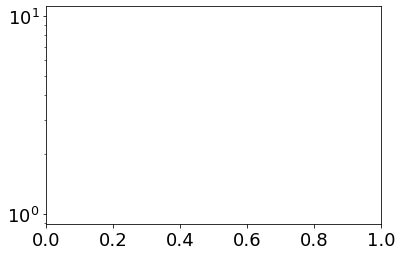

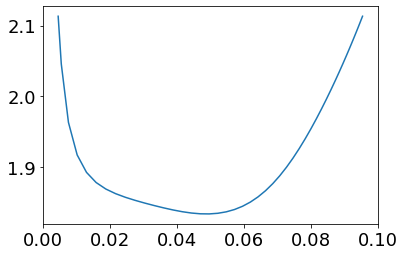

In [110]:
#plt.plot(theta,bkquad)
#plt.plot(theta/np.pi,bkquad)
#plt.plot(theta/np.pi,bk_arr)
plt.yscale('log')
#plt.xscale('log')
plt.show()

#plt.plot(theta,bk_real(k1,k2,theta))
plt.plot(k3,bkmono/bk_real(k1,k2,theta))

**Ok so we start 1st order wide angle correction to the bispectrum - see bk_wide_angle mathematica\
We will have 18 terms - 3 cycles - 6 per cycle\
each with e1 and e2 parts\  
with each having a d.e and q.e parts**

In [44]:
def bk_wide_angle(k1,k2,theta,r=1/3,s=1/3): #Latest version - and appears to aggree with Milad and Kevin
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))

    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)

    Pkd1= Pk_d(k1)
    Pkd2 = Pk_d(k2)
    Pkd3 = Pk_d(k3)
    
    #bk_dic = {} #could be nice to have dictionary to call each part independently??
    #@jit(nopython=True)
    def contain_terms(Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3):
        #e1 part
        #d.e1
        bk_de1_12 = -Pk2*f*(12936*Pk1*b1**3*k1*k2*k3**4*r + 12936*Pk1*b1**3*k1*k2*k3**4*s - 12936*Pk1*b1**3*k1*k2*k3**4 + 59136*Pk1*b1**2*f*k1*k2*k3**4*r + 59136*Pk1*b1**2*f*k1*k2*k3**4*s - 43428*Pk1*b1**2*f*k1*k2*k3**4 - 5544*Pk1*b1**2*f*k2**2*k3**4*r*cos(3*theta) - 5544*Pk1*b1**2*f*k2**2*k3**4*s*cos(3*theta) + 5544*Pk1*b1**2*f*k2**2*k3**4*cos(3*theta) - 56826*Pk1*b1**2*k1**5*k2*r - 56826*Pk1*b1**2*k1**5*k2*s + 56826*Pk1*b1**2*k1**5*k2 - 26334*Pk1*b1**2*k1**4*k2**2*r*cos(3*theta) - 26334*Pk1*b1**2*k1**4*k2**2*s*cos(3*theta) + 26334*Pk1*b1**2*k1**4*k2**2*cos(3*theta) - 5544*Pk1*b1**2*k1**3*k2**3*r*cos(4*theta) - 99792*Pk1*b1**2*k1**3*k2**3*r - 5544*Pk1*b1**2*k1**3*k2**3*s*cos(4*theta) - 99792*Pk1*b1**2*k1**3*k2**3*s + 5544*Pk1*b1**2*k1**3*k2**3*cos(4*theta) + 99792*Pk1*b1**2*k1**3*k2**3 + 75306*Pk1*b1**2*k1**3*k2*k3**2*r + 75306*Pk1*b1**2*k1**3*k2*k3**2*s - 75306*Pk1*b1**2*k1**3*k2*k3**2 - 15246*Pk1*b1**2*k1**2*k2**4*r*cos(3*theta) - 15246*Pk1*b1**2*k1**2*k2**4*s*cos(3*theta) + 15246*Pk1*b1**2*k1**2*k2**4*cos(3*theta) + 5544*Pk1*b1**2*k1**2*k2**2*k3**2*r*cos(3*theta) + 5544*Pk1*b1**2*k1**2*k2**2*k3**2*s*cos(3*theta) - 5544*Pk1*b1**2*k1**2*k2**2*k3**2*cos(3*theta) - 9702*Pk1*b1**2*k1*k2**5*r - 9702*Pk1*b1**2*k1*k2**5*s + 9702*Pk1*b1**2*k1*k2**5 - 1848*Pk1*b1**2*k1*k2**3*k3**2*r*cos(4*theta) + 11550*Pk1*b1**2*k1*k2**3*k3**2*r - 1848*Pk1*b1**2*k1*k2**3*k3**2*s*cos(4*theta) + 11550*Pk1*b1**2*k1*k2**3*k3**2*s + 1848*Pk1*b1**2*k1*k2**3*k3**2*cos(4*theta) - 11550*Pk1*b1**2*k1*k2**3*k3**2 - 924*Pk1*b1**2*k1*k2*k3**4*r*cos(4*theta) + 23100*Pk1*b1**2*k1*k2*k3**4*r - 924*Pk1*b1**2*k1*k2*k3**4*s*cos(4*theta) + 23100*Pk1*b1**2*k1*k2*k3**4*s + 924*Pk1*b1**2*k1*k2*k3**4*cos(4*theta) - 924*Pk1*b1**2*k1*k2*k3**4 - 3234*Pk1*b1**2*k2**4*k3**2*r*cos(3*theta) - 3234*Pk1*b1**2*k2**4*k3**2*s*cos(3*theta) + 3234*Pk1*b1**2*k2**4*k3**2*cos(3*theta) - 3234*Pk1*b1**2*k2**2*k3**4*r*cos(3*theta) - 3234*Pk1*b1**2*k2**2*k3**4*s*cos(3*theta) + 3234*Pk1*b1**2*k2**2*k3**4*cos(3*theta) + 12936*Pk1*b1*b2*k1*k2*k3**4*r + 12936*Pk1*b1*b2*k1*k2*k3**4*s + 3234*Pk1*b1*f**2*k1**2*k3**4*r*cos(3*theta) + 3234*Pk1*b1*f**2*k1**2*k3**4*s*cos(3*theta) - 2695*Pk1*b1*f**2*k1**2*k3**4*cos(3*theta) - 2772*Pk1*b1*f**2*k1*k2*k3**4*r*cos(4*theta) + 63756*Pk1*b1*f**2*k1*k2*k3**4*r - 2772*Pk1*b1*f**2*k1*k2*k3**4*s*cos(4*theta) + 63756*Pk1*b1*f**2*k1*k2*k3**4*s + 2464*Pk1*b1*f**2*k1*k2*k3**4*cos(4*theta) - 48048*Pk1*b1*f**2*k1*k2*k3**4 - 10626*Pk1*b1*f**2*k2**2*k3**4*r*cos(3*theta) - 10626*Pk1*b1*f**2*k2**2*k3**4*s*cos(3*theta) + 8624*Pk1*b1*f**2*k2**2*k3**4*cos(3*theta) - 5544*Pk1*b1*f*k1**6*r*cos(3*theta) - 5544*Pk1*b1*f*k1**6*s*cos(3*theta) + 5544*Pk1*b1*f*k1**6*cos(3*theta) - 7326*Pk1*b1*f*k1**5*k2*r*cos(4*theta) - 145530*Pk1*b1*f*k1**5*k2*r - 7326*Pk1*b1*f*k1**5*k2*s*cos(4*theta) - 145530*Pk1*b1*f*k1**5*k2*s + 7326*Pk1*b1*f*k1**5*k2*cos(4*theta) + 104940*Pk1*b1*f*k1**5*k2 - 95832*Pk1*b1*f*k1**4*k2**2*r*cos(3*theta) - 2376*Pk1*b1*f*k1**4*k2**2*r*cos(5*theta) - 95832*Pk1*b1*f*k1**4*k2**2*s*cos(3*theta) - 2376*Pk1*b1*f*k1**4*k2**2*s*cos(5*theta) + 75636*Pk1*b1*f*k1**4*k2**2*cos(3*theta) + 2376*Pk1*b1*f*k1**4*k2**2*cos(5*theta) + 7854*Pk1*b1*f*k1**4*k3**2*r*cos(3*theta) + 7854*Pk1*b1*f*k1**4*k3**2*s*cos(3*theta) - 7854*Pk1*b1*f*k1**4*k3**2*cos(3*theta) - 24552*Pk1*b1*f*k1**3*k2**3*r*cos(4*theta) - 266904*Pk1*b1*f*k1**3*k2**3*r - 24552*Pk1*b1*f*k1**3*k2**3*s*cos(4*theta) - 266904*Pk1*b1*f*k1**3*k2**3*s + 19107*Pk1*b1*f*k1**3*k2**3*cos(4*theta) + 199485*Pk1*b1*f*k1**3*k2**3 + 2112*Pk1*b1*f*k1**3*k2*k3**2*r*cos(4*theta) + 196680*Pk1*b1*f*k1**3*k2*k3**2*r + 2112*Pk1*b1*f*k1**3*k2*k3**2*s*cos(4*theta) + 196680*Pk1*b1*f*k1**3*k2*k3**2*s - 2112*Pk1*b1*f*k1**3*k2*k3**2*cos(4*theta) - 137478*Pk1*b1*f*k1**3*k2*k3**2 - 52272*Pk1*b1*f*k1**2*k2**4*r*cos(3*theta) - 792*Pk1*b1*f*k1**2*k2**4*r*cos(5*theta) - 52272*Pk1*b1*f*k1**2*k2**4*s*cos(3*theta) - 792*Pk1*b1*f*k1**2*k2**4*s*cos(5*theta) + 38412*Pk1*b1*f*k1**2*k2**4*cos(3*theta) + 396*Pk1*b1*f*k1**2*k2**4*cos(5*theta) + 25212*Pk1*b1*f*k1**2*k2**2*k3**2*r*cos(3*theta) - 1584*Pk1*b1*f*k1**2*k2**2*k3**2*r*cos(5*theta) + 25212*Pk1*b1*f*k1**2*k2**2*k3**2*s*cos(3*theta) - 1584*Pk1*b1*f*k1**2*k2**2*k3**2*s*cos(5*theta) - 16929*Pk1*b1*f*k1**2*k2**2*k3**2*cos(3*theta) + 1584*Pk1*b1*f*k1**2*k2**2*k3**2*cos(5*theta) + 2310*Pk1*b1*f*k1**2*k3**4*r*cos(3*theta) + 2310*Pk1*b1*f*k1**2*k3**4*s*cos(3*theta) - 1155*Pk1*b1*f*k1**2*k3**4*cos(3*theta) - 1386*Pk1*b1*f*k1*k2**5*r*cos(4*theta) - 26334*Pk1*b1*f*k1*k2**5*r - 1386*Pk1*b1*f*k1*k2**5*s*cos(4*theta) - 26334*Pk1*b1*f*k1*k2**5*s + 693*Pk1*b1*f*k1*k2**5*cos(4*theta) + 20097*Pk1*b1*f*k1*k2**5 - 6996*Pk1*b1*f*k1*k2**3*k3**2*r*cos(4*theta) + 48972*Pk1*b1*f*k1*k2**3*k3**2*r - 6996*Pk1*b1*f*k1*k2**3*k3**2*s*cos(4*theta) + 48972*Pk1*b1*f*k1*k2**3*k3**2*s + 6468*Pk1*b1*f*k1*k2**3*k3**2*cos(4*theta) - 31614*Pk1*b1*f*k1*k2**3*k3**2 - 528*Pk1*b1*f*k1*k2*k3**4*r*cos(4*theta) + 16896*Pk1*b1*f*k1*k2*k3**4*r - 528*Pk1*b1*f*k1*k2*k3**4*s*cos(4*theta) + 16896*Pk1*b1*f*k1*k2*k3**4*s + 264*Pk1*b1*f*k1*k2*k3**4*cos(4*theta) - 8448*Pk1*b1*f*k1*k2*k3**4 - 8778*Pk1*b1*f*k2**4*k3**2*r*cos(3*theta) - 8778*Pk1*b1*f*k2**4*k3**2*s*cos(3*theta) + 7161*Pk1*b1*f*k2**4*k3**2*cos(3*theta) - 3234*Pk1*b1*f*k2**2*k3**4*r*cos(3*theta) - 3234*Pk1*b1*f*k2**2*k3**4*s*cos(3*theta) + 1617*Pk1*b1*f*k2**2*k3**4*cos(3*theta) - 3234*Pk1*b1*gamma2*k1*k2*k3**4*r*cos(4*theta) - 9702*Pk1*b1*gamma2*k1*k2*k3**4*r - 3234*Pk1*b1*gamma2*k1*k2*k3**4*s*cos(4*theta) - 9702*Pk1*b1*gamma2*k1*k2*k3**4*s + 3234*Pk1*b1*gamma2*k1*k2*k3**4*cos(4*theta) - 3234*Pk1*b1*gamma2*k1*k2*k3**4 + 9240*Pk1*b2*f*k1*k2*k3**4*r + 9240*Pk1*b2*f*k1*k2*k3**4*s - 4620*Pk1*b2*f*k1*k2*k3**4 + 3640*Pk1*f**3*k1**2*k3**4*r*cos(3*theta) + 3640*Pk1*f**3*k1**2*k3**4*s*cos(3*theta) - 2730*Pk1*f**3*k1**2*k3**4*cos(3*theta) - 1792*Pk1*f**3*k1*k2*k3**4*r*cos(4*theta) + 21504*Pk1*f**3*k1*k2*k3**4*r - 1792*Pk1*f**3*k1*k2*k3**4*s*cos(4*theta) + 21504*Pk1*f**3*k1*k2*k3**4*s + 1344*Pk1*f**3*k1*k2*k3**4*cos(4*theta) - 16128*Pk1*f**3*k1*k2*k3**4 - 4760*Pk1*f**3*k2**2*k3**4*r*cos(3*theta) - 560*Pk1*f**3*k2**2*k3**4*r*cos(5*theta) - 4760*Pk1*f**3*k2**2*k3**4*s*cos(3*theta) - 560*Pk1*f**3*k2**2*k3**4*s*cos(5*theta) + 3570*Pk1*f**3*k2**2*k3**4*cos(3*theta) + 420*Pk1*f**3*k2**2*k3**4*cos(5*theta) - 6930*Pk1*f**2*k1**6*r*cos(3*theta) - 6930*Pk1*f**2*k1**6*s*cos(3*theta) + 4620*Pk1*f**2*k1**6*cos(3*theta) - 10890*Pk1*f**2*k1**5*k2*r*cos(4*theta) - 71940*Pk1*f**2*k1**5*k2*r - 10890*Pk1*f**2*k1**5*k2*s*cos(4*theta) - 71940*Pk1*f**2*k1**5*k2*s + 7260*Pk1*f**2*k1**5*k2*cos(4*theta) + 47960*Pk1*f**2*k1**5*k2 - 74052*Pk1*f**2*k1**4*k2**2*r*cos(3*theta) - 5346*Pk1*f**2*k1**4*k2**2*r*cos(5*theta) - 74052*Pk1*f**2*k1**4*k2**2*s*cos(3*theta) - 5346*Pk1*f**2*k1**4*k2**2*s*cos(5*theta) + 49368*Pk1*f**2*k1**4*k2**2*cos(3*theta) + 3564*Pk1*f**2*k1**4*k2**2*cos(5*theta) + 12012*Pk1*f**2*k1**4*k3**2*r*cos(3*theta) + 12012*Pk1*f**2*k1**4*k3**2*s*cos(3*theta) - 8008*Pk1*f**2*k1**4*k3**2*cos(3*theta) - 25872*Pk1*f**2*k1**3*k2**3*r*cos(4*theta) - 792*Pk1*f**2*k1**3*k2**3*r*cos(6*theta) - 139392*Pk1*f**2*k1**3*k2**3*r - 25872*Pk1*f**2*k1**3*k2**3*s*cos(4*theta) - 792*Pk1*f**2*k1**3*k2**3*s*cos(6*theta) - 139392*Pk1*f**2*k1**3*k2**3*s + 17248*Pk1*f**2*k1**3*k2**3*cos(4*theta) + 528*Pk1*f**2*k1**3*k2**3*cos(6*theta) + 92928*Pk1*f**2*k1**3*k2**3 + 6765*Pk1*f**2*k1**3*k2*k3**2*r*cos(4*theta) + 96789*Pk1*f**2*k1**3*k2*k3**2*r + 6765*Pk1*f**2*k1**3*k2*k3**2*s*cos(4*theta) + 96789*Pk1*f**2*k1**3*k2*k3**2*s - 4510*Pk1*f**2*k1**3*k2*k3**2*cos(4*theta) - 64526*Pk1*f**2*k1**3*k2*k3**2 - 38082*Pk1*f**2*k1**2*k2**4*r*cos(3*theta) - 2706*Pk1*f**2*k1**2*k2**4*r*cos(5*theta) - 38082*Pk1*f**2*k1**2*k2**4*s*cos(3*theta) - 2706*Pk1*f**2*k1**2*k2**4*s*cos(5*theta) + 25388*Pk1*f**2*k1**2*k2**4*cos(3*theta) + 1804*Pk1*f**2*k1**2*k2**4*cos(5*theta) + 25542*Pk1*f**2*k1**2*k2**2*k3**2*r*cos(3*theta) - 1122*Pk1*f**2*k1**2*k2**2*k3**2*r*cos(5*theta) + 25542*Pk1*f**2*k1**2*k2**2*k3**2*s*cos(3*theta) - 1122*Pk1*f**2*k1**2*k2**2*k3**2*s*cos(5*theta) - 17028*Pk1*f**2*k1**2*k2**2*k3**2*cos(3*theta) + 748*Pk1*f**2*k1**2*k2**2*k3**2*cos(5*theta) - 2310*Pk1*f**2*k1*k2**5*r*cos(4*theta) - 13860*Pk1*f**2*k1*k2**5*r - 2310*Pk1*f**2*k1*k2**5*s*cos(4*theta) - 13860*Pk1*f**2*k1*k2**5*s + 1540*Pk1*f**2*k1*k2**5*cos(4*theta) + 9240*Pk1*f**2*k1*k2**5 - 4983*Pk1*f**2*k1*k2**3*k3**2*r*cos(4*theta) - 528*Pk1*f**2*k1*k2**3*k3**2*r*cos(6*theta) + 31845*Pk1*f**2*k1*k2**3*k3**2*r - 4983*Pk1*f**2*k1*k2**3*k3**2*s*cos(4*theta) - 528*Pk1*f**2*k1*k2**3*k3**2*s*cos(6*theta) + 31845*Pk1*f**2*k1*k2**3*k3**2*s + 3322*Pk1*f**2*k1*k2**3*k3**2*cos(4*theta) + 352*Pk1*f**2*k1*k2**3*k3**2*cos(6*theta) - 21230*Pk1*f**2*k1*k2**3*k3**2 - 5082*Pk1*f**2*k2**4*k3**2*r*cos(3*theta) - 924*Pk1*f**2*k2**4*k3**2*r*cos(5*theta) - 5082*Pk1*f**2*k2**4*k3**2*s*cos(3*theta) - 924*Pk1*f**2*k2**4*k3**2*s*cos(5*theta) + 3388*Pk1*f**2*k2**4*k3**2*cos(3*theta) + 616*Pk1*f**2*k2**4*k3**2*cos(5*theta) - 1848*Pk1*f*gamma2*k1*k2*k3**4*r*cos(4*theta) - 5544*Pk1*f*gamma2*k1*k2*k3**4*r - 1848*Pk1*f*gamma2*k1*k2*k3**4*s*cos(4*theta) - 5544*Pk1*f*gamma2*k1*k2*k3**4*s + 924*Pk1*f*gamma2*k1*k2*k3**4*cos(4*theta) + 2772*Pk1*f*gamma2*k1*k2*k3**4 + 16170*Pkd1*b1**3*k1**2*k2*k3**4*r + 16170*Pkd1*b1**3*k1**2*k2*k3**4*s - 16170*Pkd1*b1**3*k1**2*k2*k3**4 + 1386*Pkd1*b1**2*f*k1**3*k3**4*r*cos(3*theta) + 1386*Pkd1*b1**2*f*k1**3*k3**4*s*cos(3*theta) - 1386*Pkd1*b1**2*f*k1**3*k3**4*cos(3*theta) + 55440*Pkd1*b1**2*f*k1**2*k2*k3**4*r + 55440*Pkd1*b1**2*f*k1**2*k2*k3**4*s - 44352*Pkd1*b1**2*f*k1**2*k2*k3**4 + 2772*Pkd1*b1**2*f*k1*k2**2*k3**4*r*cos(3*theta) + 2772*Pkd1*b1**2*f*k1*k2**2*k3**4*s*cos(3*theta) - 2772*Pkd1*b1**2*f*k1*k2**2*k3**4*cos(3*theta) + 23562*Pkd1*b1**2*k1**4*k2*k3**2*r + 23562*Pkd1*b1**2*k1**4*k2*k3**2*s - 23562*Pkd1*b1**2*k1**4*k2*k3**2 + 7161*Pkd1*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 7161*Pkd1*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 7161*Pkd1*b1**2*k1**3*k2**2*k3**2*cos(3*theta) + 1617*Pkd1*b1**2*k1**3*k3**4*r*cos(3*theta) + 1617*Pkd1*b1**2*k1**3*k3**4*s*cos(3*theta) - 1617*Pkd1*b1**2*k1**3*k3**4*cos(3*theta) + 924*Pkd1*b1**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 19866*Pkd1*b1**2*k1**2*k2**3*k3**2*r + 924*Pkd1*b1**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 19866*Pkd1*b1**2*k1**2*k2**3*k3**2*s - 924*Pkd1*b1**2*k1**2*k2**3*k3**2*cos(4*theta) - 19866*Pkd1*b1**2*k1**2*k2**3*k3**2 + 462*Pkd1*b1**2*k1**2*k2*k3**4*r*cos(4*theta) + 28182*Pkd1*b1**2*k1**2*k2*k3**4*r + 462*Pkd1*b1**2*k1**2*k2*k3**4*s*cos(4*theta) + 28182*Pkd1*b1**2*k1**2*k2*k3**4*s - 462*Pkd1*b1**2*k1**2*k2*k3**4*cos(4*theta) - 11550*Pkd1*b1**2*k1**2*k2*k3**4 + 1617*Pkd1*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 1617*Pkd1*b1**2*k1*k2**4*k3**2*s*cos(3*theta) - 1617*Pkd1*b1**2*k1*k2**4*k3**2*cos(3*theta) + 1617*Pkd1*b1**2*k1*k2**2*k3**4*r*cos(3*theta) + 1617*Pkd1*b1**2*k1*k2**2*k3**4*s*cos(3*theta) - 1617*Pkd1*b1**2*k1*k2**2*k3**4*cos(3*theta) + 16170*Pkd1*b1*b2*k1**2*k2*k3**4*r + 16170*Pkd1*b1*b2*k1**2*k2*k3**4*s - 6468*Pkd1*b1*b2*k1**2*k2*k3**4 + 4620*Pkd1*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 4620*Pkd1*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 3850*Pkd1*b1*f**2*k1**3*k3**4*cos(3*theta) + 1386*Pkd1*b1*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 52668*Pkd1*b1*f**2*k1**2*k2*k3**4*r + 1386*Pkd1*b1*f**2*k1**2*k2*k3**4*s*cos(4*theta) + 52668*Pkd1*b1*f**2*k1**2*k2*k3**4*s - 1232*Pkd1*b1*f**2*k1**2*k2*k3**4*cos(4*theta) - 40656*Pkd1*b1*f**2*k1**2*k2*k3**4 + 6930*Pkd1*b1*f**2*k1*k2**2*k3**4*r*cos(3*theta) + 6930*Pkd1*b1*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 5390*Pkd1*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 2772*Pkd1*b1*f*k1**5*k3**2*r*cos(3*theta) + 2772*Pkd1*b1*f*k1**5*k3**2*s*cos(3*theta) - 2772*Pkd1*b1*f*k1**5*k3**2*cos(3*theta) + 2970*Pkd1*b1*f*k1**4*k2*k3**2*r*cos(4*theta) + 59598*Pkd1*b1*f*k1**4*k2*k3**2*r + 2970*Pkd1*b1*f*k1**4*k2*k3**2*s*cos(4*theta) + 59598*Pkd1*b1*f*k1**4*k2*k3**2*s - 2970*Pkd1*b1*f*k1**4*k2*k3**2*cos(4*theta) - 42768*Pkd1*b1*f*k1**4*k2*k3**2 + 27324*Pkd1*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 792*Pkd1*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) + 27324*Pkd1*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 792*Pkd1*b1*f*k1**3*k2**2*k3**2*s*cos(5*theta) - 21978*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(3*theta) - 792*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 2772*Pkd1*b1*f*k1**3*k3**4*r*cos(3*theta) + 2772*Pkd1*b1*f*k1**3*k3**4*s*cos(3*theta) - 1386*Pkd1*b1*f*k1**3*k3**4*cos(3*theta) + 4554*Pkd1*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 53262*Pkd1*b1*f*k1**2*k2**3*k3**2*r + 4554*Pkd1*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) + 53262*Pkd1*b1*f*k1**2*k2**3*k3**2*s - 3762*Pkd1*b1*f*k1**2*k2**3*k3**2*cos(4*theta) - 39600*Pkd1*b1*f*k1**2*k2**3*k3**2 + 792*Pkd1*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 15048*Pkd1*b1*f*k1**2*k2*k3**4*r + 792*Pkd1*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 15048*Pkd1*b1*f*k1**2*k2*k3**4*s - 396*Pkd1*b1*f*k1**2*k2*k3**4*cos(4*theta) - 7524*Pkd1*b1*f*k1**2*k2*k3**4 + 5544*Pkd1*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 5544*Pkd1*b1*f*k1*k2**4*k3**2*s*cos(3*theta) - 4158*Pkd1*b1*f*k1*k2**4*k3**2*cos(3*theta) + 2772*Pkd1*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 2772*Pkd1*b1*f*k1*k2**2*k3**4*s*cos(3*theta) - 1386*Pkd1*b1*f*k1*k2**2*k3**4*cos(3*theta) + 1617*Pkd1*b1*gamma2*k1**2*k2*k3**4*r*cos(4*theta) - 14553*Pkd1*b1*gamma2*k1**2*k2*k3**4*r + 1617*Pkd1*b1*gamma2*k1**2*k2*k3**4*s*cos(4*theta) - 14553*Pkd1*b1*gamma2*k1**2*k2*k3**4*s - 1617*Pkd1*b1*gamma2*k1**2*k2*k3**4*cos(4*theta) + 4851*Pkd1*b1*gamma2*k1**2*k2*k3**4 + 8316*Pkd1*b2*f*k1**2*k2*k3**4*r + 8316*Pkd1*b2*f*k1**2*k2*k3**4*s - 4158*Pkd1*b2*f*k1**2*k2*k3**4 + 2940*Pkd1*f**3*k1**3*k3**4*r*cos(3*theta) + 2940*Pkd1*f**3*k1**3*k3**4*s*cos(3*theta) - 2205*Pkd1*f**3*k1**3*k3**4*cos(3*theta) + 1680*Pkd1*f**3*k1**2*k2*k3**4*r*cos(4*theta) + 16800*Pkd1*f**3*k1**2*k2*k3**4*r + 1680*Pkd1*f**3*k1**2*k2*k3**4*s*cos(4*theta) + 16800*Pkd1*f**3*k1**2*k2*k3**4*s - 1260*Pkd1*f**3*k1**2*k2*k3**4*cos(4*theta) - 12600*Pkd1*f**3*k1**2*k2*k3**4 + 3500*Pkd1*f**3*k1*k2**2*k3**4*r*cos(3*theta) + 140*Pkd1*f**3*k1*k2**2*k3**4*r*cos(5*theta) + 3500*Pkd1*f**3*k1*k2**2*k3**4*s*cos(3*theta) + 140*Pkd1*f**3*k1*k2**2*k3**4*s*cos(5*theta) - 2625*Pkd1*f**3*k1*k2**2*k3**4*cos(3*theta) - 105*Pkd1*f**3*k1*k2**2*k3**4*cos(5*theta) + 3465*Pkd1*f**2*k1**5*k3**2*r*cos(3*theta) + 3465*Pkd1*f**2*k1**5*k3**2*s*cos(3*theta) - 2310*Pkd1*f**2*k1**5*k3**2*cos(3*theta) + 4290*Pkd1*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 29040*Pkd1*f**2*k1**4*k2*k3**2*r + 4290*Pkd1*f**2*k1**4*k2*k3**2*s*cos(4*theta) + 29040*Pkd1*f**2*k1**4*k2*k3**2*s - 2860*Pkd1*f**2*k1**4*k2*k3**2*cos(4*theta) - 19360*Pkd1*f**2*k1**4*k2*k3**2 + 21912*Pkd1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 1551*Pkd1*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) + 21912*Pkd1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 1551*Pkd1*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) - 14608*Pkd1*f**2*k1**3*k2**2*k3**2*cos(3*theta) - 1034*Pkd1*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 5082*Pkd1*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 132*Pkd1*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) + 27852*Pkd1*f**2*k1**2*k2**3*k3**2*r + 5082*Pkd1*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 132*Pkd1*f**2*k1**2*k2**3*k3**2*s*cos(6*theta) + 27852*Pkd1*f**2*k1**2*k2**3*k3**2*s - 3388*Pkd1*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 88*Pkd1*f**2*k1**2*k2**3*k3**2*cos(6*theta) - 18568*Pkd1*f**2*k1**2*k2**3*k3**2 + 3927*Pkd1*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 231*Pkd1*f**2*k1*k2**4*k3**2*r*cos(5*theta) + 3927*Pkd1*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 231*Pkd1*f**2*k1*k2**4*k3**2*s*cos(5*theta) - 2618*Pkd1*f**2*k1*k2**4*k3**2*cos(3*theta) - 154*Pkd1*f**2*k1*k2**4*k3**2*cos(5*theta) + 2772*Pkd1*f*gamma2*k1**2*k2*k3**4*r*cos(4*theta) - 5544*Pkd1*f*gamma2*k1**2*k2*k3**4*r + 2772*Pkd1*f*gamma2*k1**2*k2*k3**4*s*cos(4*theta) - 5544*Pkd1*f*gamma2*k1**2*k2*k3**4*s - 1386*Pkd1*f*gamma2*k1**2*k2*k3**4*cos(4*theta) + 2772*Pkd1*f*gamma2*k1**2*k2*k3**4 + 2*k1*k2*(1617*Pkd1*b1**3*k1*k3**4*(r + s - 1) - 231*b1**2*(87*Pk1*k1**4*(r + s - 1) + Pk1*k1**2*(192*k2**2 - 89*k3**2)*(r + s - 1) + Pk1*(21*k2**4*(r + s - 1) - 7*k2**2*k3**2*(r + s - 1) - 2*k3**4*(f*(8*r + 8*s - 7) + 4*r + 4*s)) - 33*Pkd1*k1**3*k3**2*(r + s - 1) - Pkd1*k1*k3**2*(39*k2**2*(r + s - 1) + 2*k3**2*(3*f*(10*r + 10*s - 9) + 11*r + 11*s - 8))) + 11*b1*(7*f**2*k3**4*(8*Pk1*(18*r + 18*s - 13) + Pkd1*k1*(279*r + 279*s - 218)) - 3*f*(3*Pk1*k1**4*(628*r + 628*s - 483) + 3*Pk1*k1**2*(332*k2**2*(4*r + 4*s - 3) + k3**2*(-676*r - 676*s + 499)) + Pk1*(105*k2**4*(4*r + 4*s - 3) - 3*k2**2*k3**2*(124*r + 124*s - 69) - 44*k3**4*(2*r + 2*s - 1)) - 3*Pkd1*k1**3*k3**2*(244*r + 244*s - 189) - 3*Pkd1*k1*k3**2*(67*k2**2*(4*r + 4*s - 3) + 30*k3**2*(2*r + 2*s - 1))) + 147*k3**4*(4*Pk1*gamma2*(r + s) + Pkd1*b2*k1*(r + s - 1) + Pkd1*gamma2*k1*(4*r + 4*s - 1))) + f*(28*f**2*k3**4*(52*Pk1 + 75*Pkd1*k1)*(4*r + 4*s - 3) - 11*f*(3*r + 3*s - 2)*(1195*Pk1*k1**4 + Pk1*k1**2*(2384*k2**2 - 1371*k3**2) + 7*Pk1*k2**2*(35*k2**2 - 43*k3**2) - 475*Pkd1*k1**3*k3**2 - 479*Pkd1*k1*k2**2*k3**2) + 231*k3**4*(2*r + 2*s - 1)*(2*Pk1*b2 + 8*Pk1*gamma2 + 6*Pkd1*b2*k1 + 3*Pkd1*gamma2*k1)))*cos(2*theta) + (3234*b1**3*k3**4*(r + s - 1)*(5*Pk1*k1**2 - Pk1*k2**2 + 3*Pkd1*k1**3 + 3*Pkd1*k1*k2**2) - 231*b1**2*(84*Pk1*k1**6*(r + s - 1) + 2*Pk1*k1**4*(363*k2**2 - 91*k3**2)*(r + s - 1) + 2*Pk1*k1**2*(177*k2**4*(r + s - 1) - 198*k2**2*k3**2*(r + s - 1) - k3**4*(3*f*(58*r + 58*s - 47) + 70*r + 70*s - 21)) + 2*Pk1*k2**2*k3**2*(14*k2**2*(r + s - 1) + k3**2*(3*f*(6*r + 6*s - 7) + 7*r + 7*s - 14)) - 42*Pkd1*k1**5*k3**2*(r + s - 1) - Pkd1*k1**3*k3**2*(221*k2**2*(r + s - 1) + k3**2*(6*f*(29*r + 29*s - 24) + 77*r + 77*s - 35)) - Pkd1*k1*k2**2*k3**2*(35*k2**2*(r + s - 1) + k3**2*(6*f*(28*r + 28*s - 23) + 77*r + 77*s - 35))) + 11*b1*f*(-252*Pk1*k1**6*(18*r + 18*s - 13) - 6*Pk1*k1**4*(6*k2**2*(1152*r + 1152*s - 853) - 7*k3**2*(235*r + 235*s - 166)) + Pk1*k1**2*(-36*k2**4*(566*r + 566*s - 427) + 3*k2**2*k3**2*(8356*r + 8356*s - 5835) + 7*k3**4*(f*(1248*r + 1248*s - 955) + 294*r + 294*s - 147)) - 21*Pk1*k2**2*k3**2*(k2**2*(34*r + 34*s - 35) + k3**2*(f*(24*r + 24*s - 26) - 2*r - 2*s + 1)) + 126*Pkd1*k1**5*k3**2*(18*r + 18*s - 13) + 2*Pkd1*k1**3*k3**2*(9*k2**2*(698*r + 698*s - 515) + 7*k3**2*(5*f*(57*r + 57*s - 44) + 72*r + 72*s - 36)) + 84*Pkd1*k1*k2**2*k3**2*(6*k2**2*(4*r + 4*s - 3) + k3**2*(5*f*(9*r + 9*s - 7) + 12*r + 12*s - 6))) + f**2*(-8470*Pk1*k1**6*(3*r + 3*s - 2) - 22*Pk1*k1**4*(3697*k2**2 - 833*k3**2)*(3*r + 3*s - 2) - 16*Pk1*k1**2*(-525*f*k3**4*(4*r + 4*s - 3) + 2519*k2**4*(3*r + 3*s - 2) - 3245*k2**2*k3**2*(3*r + 3*s - 2)) - 28*Pk1*k2**2*k3**2*(5*f*k3**2*(4*r + 4*s - 3) + 11*k2**2*(3*r + 3*s - 2)) + 4235*Pkd1*k1**5*k3**2*(3*r + 3*s - 2) + 3*Pkd1*k1**3*k3**2*(1225*f*k3**2*(4*r + 4*s - 3) + 8173*k2**2*(3*r + 3*s - 2)) + 28*Pkd1*k1*k2**2*k3**2*(125*f*k3**2*(4*r + 4*s - 3) + 143*k2**2*(3*r + 3*s - 2))))*cos(theta))/(8085*k1**2*k2*k3**4)
        bk_de1_13 = -f*(-51744*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2*r - 51744*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2*s + 51744*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2 - 266112*Pk1*Pk3*b1**2*f*k1**5*k2**2*r - 266112*Pk1*Pk3*b1**2*f*k1**5*k2**2*s + 266112*Pk1*Pk3*b1**2*f*k1**5*k2**2 - 66528*Pk1*Pk3*b1**2*f*k1**4*k2**3*r*cos(3*theta) - 66528*Pk1*Pk3*b1**2*f*k1**4*k2**3*s*cos(3*theta) + 66528*Pk1*Pk3*b1**2*f*k1**4*k2**3*cos(3*theta) - 266112*Pk1*Pk3*b1**2*f*k1**3*k2**4*r - 266112*Pk1*Pk3*b1**2*f*k1**3*k2**4*s + 266112*Pk1*Pk3*b1**2*f*k1**3*k2**4 + 221760*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2*r + 221760*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2*s - 255024*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2 + 22176*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 22176*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*s*cos(3*theta) - 24948*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 66528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2*r + 66528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2*s - 66528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2 - 36960*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4*r - 36960*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4*s + 46200*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4 + 11088*Pk1*Pk3*b1**2*f*k2**3*k3**4*r*cos(3*theta) + 11088*Pk1*Pk3*b1**2*f*k2**3*k3**4*s*cos(3*theta) - 11088*Pk1*Pk3*b1**2*f*k2**3*k3**4*cos(3*theta) + 33264*Pk1*Pk3*b1**2*k1**7*r + 33264*Pk1*Pk3*b1**2*k1**7*s - 33264*Pk1*Pk3*b1**2*k1**7 + 27720*Pk1*Pk3*b1**2*k1**5*k2**2*r + 27720*Pk1*Pk3*b1**2*k1**5*k2**2*s - 27720*Pk1*Pk3*b1**2*k1**5*k2**2 - 48048*Pk1*Pk3*b1**2*k1**5*k3**2*r - 48048*Pk1*Pk3*b1**2*k1**5*k3**2*s + 64680*Pk1*Pk3*b1**2*k1**5*k3**2 - 38808*Pk1*Pk3*b1**2*k1**4*k2**3*r*cos(3*theta) - 38808*Pk1*Pk3*b1**2*k1**4*k2**3*s*cos(3*theta) + 38808*Pk1*Pk3*b1**2*k1**4*k2**3*cos(3*theta) - 8316*Pk1*Pk3*b1**2*k1**4*k2*k3**2*r*cos(3*theta) - 8316*Pk1*Pk3*b1**2*k1**4*k2*k3**2*s*cos(3*theta) + 8316*Pk1*Pk3*b1**2*k1**4*k2*k3**2*cos(3*theta) - 11088*Pk1*Pk3*b1**2*k1**3*k2**4*r*cos(4*theta) - 60984*Pk1*Pk3*b1**2*k1**3*k2**4*r - 11088*Pk1*Pk3*b1**2*k1**3*k2**4*s*cos(4*theta) - 60984*Pk1*Pk3*b1**2*k1**3*k2**4*s + 11088*Pk1*Pk3*b1**2*k1**3*k2**4*cos(4*theta) + 60984*Pk1*Pk3*b1**2*k1**3*k2**4 - 3696*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 16632*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*r - 3696*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*s*cos(4*theta) - 16632*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*s + 3696*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) + 2772*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2 + 3696*Pk1*Pk3*b1**2*k1**3*k3**4*r + 3696*Pk1*Pk3*b1**2*k1**3*k3**4*s - 31416*Pk1*Pk3*b1**2*k1**3*k3**4 - 11088*Pk1*Pk3*b1**2*k1**2*k2**5*r*cos(3*theta) - 11088*Pk1*Pk3*b1**2*k1**2*k2**5*s*cos(3*theta) + 11088*Pk1*Pk3*b1**2*k1**2*k2**5*cos(3*theta) + 8316*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 8316*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*s*cos(3*theta) - 13860*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 1848*Pk1*Pk3*b1**2*k1*k2**4*k3**2*r*cos(4*theta) + 21252*Pk1*Pk3*b1**2*k1*k2**4*k3**2*r - 1848*Pk1*Pk3*b1**2*k1*k2**4*k3**2*s*cos(4*theta) + 21252*Pk1*Pk3*b1**2*k1*k2**4*k3**2*s + 1848*Pk1*Pk3*b1**2*k1*k2**4*k3**2*cos(4*theta) - 21252*Pk1*Pk3*b1**2*k1*k2**4*k3**2 - 3696*Pk1*Pk3*b1**2*k1*k2**2*k3**4*r*cos(4*theta) - 8316*Pk1*Pk3*b1**2*k1*k2**2*k3**4*r - 3696*Pk1*Pk3*b1**2*k1*k2**2*k3**4*s*cos(4*theta) - 8316*Pk1*Pk3*b1**2*k1*k2**2*k3**4*s + 3696*Pk1*Pk3*b1**2*k1*k2**2*k3**4*cos(4*theta) + 15708*Pk1*Pk3*b1**2*k1*k2**2*k3**4 + 11088*Pk1*Pk3*b1**2*k1*k3**6*r + 11088*Pk1*Pk3*b1**2*k1*k3**6*s + 6468*Pk1*Pk3*b1**2*k2**3*k3**4*r*cos(3*theta) + 6468*Pk1*Pk3*b1**2*k2**3*k3**4*s*cos(3*theta) - 6468*Pk1*Pk3*b1**2*k2**3*k3**4*cos(3*theta) + 6468*Pk1*Pk3*b1**2*k2*k3**6*r*cos(3*theta) + 6468*Pk1*Pk3*b1**2*k2*k3**6*s*cos(3*theta) - 6468*Pk1*Pk3*b1**2*k2*k3**6*cos(3*theta) - 38808*Pk1*Pk3*b1*b2*k1**5*k3**2*r - 38808*Pk1*Pk3*b1*b2*k1**5*k3**2*s + 38808*Pk1*Pk3*b1*b2*k1**5*k3**2 - 77616*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2*r - 77616*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2*s + 77616*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2 + 64680*Pk1*Pk3*b1*b2*k1**3*k3**4*r + 64680*Pk1*Pk3*b1*b2*k1**3*k3**4*s - 64680*Pk1*Pk3*b1*b2*k1**3*k3**4 + 25872*Pk1*Pk3*b1*b2*k1*k3**6*r + 25872*Pk1*Pk3*b1*b2*k1*k3**6*s - 221760*Pk1*Pk3*b1*f**2*k1**5*k2**2*r - 221760*Pk1*Pk3*b1*f**2*k1**5*k2**2*s + 123200*Pk1*Pk3*b1*f**2*k1**5*k2**2 - 36960*Pk1*Pk3*b1*f**2*k1**4*k2**3*r*cos(3*theta) - 36960*Pk1*Pk3*b1*f**2*k1**4*k2**3*s*cos(3*theta) + 7392*Pk1*Pk3*b1*f**2*k1**3*k2**4*r*cos(4*theta) + 133056*Pk1*Pk3*b1*f**2*k1**3*k2**4*r + 7392*Pk1*Pk3*b1*f**2*k1**3*k2**4*s*cos(4*theta) + 133056*Pk1*Pk3*b1*f**2*k1**3*k2**4*s - 12320*Pk1*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) - 221760*Pk1*Pk3*b1*f**2*k1**3*k2**4 + 273504*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2*r + 273504*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2*s - 161392*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 55440*Pk1*Pk3*b1*f**2*k1**2*k2**5*r*cos(3*theta) + 55440*Pk1*Pk3*b1*f**2*k1**2*k2**5*s*cos(3*theta) - 61600*Pk1*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 46200*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 46200*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*s*cos(3*theta) - 27566*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 73920*Pk1*Pk3*b1*f**2*k1*k2**6*r + 73920*Pk1*Pk3*b1*f**2*k1*k2**6*s - 73920*Pk1*Pk3*b1*f**2*k1*k2**6 + 7392*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*r*cos(4*theta) + 33264*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*r + 7392*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*s*cos(4*theta) + 33264*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*s - 6776*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*cos(4*theta) - 5544*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2 - 77616*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4*r - 77616*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4*s + 51744*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4 + 9240*Pk1*Pk3*b1*f**2*k2**5*k3**2*r*cos(3*theta) + 9240*Pk1*Pk3*b1*f**2*k2**5*k3**2*s*cos(3*theta) - 9240*Pk1*Pk3*b1*f**2*k2**5*k3**2*cos(3*theta) + 12012*Pk1*Pk3*b1*f**2*k2**3*k3**4*r*cos(3*theta) + 12012*Pk1*Pk3*b1*f**2*k2**3*k3**4*s*cos(3*theta) - 8008*Pk1*Pk3*b1*f**2*k2**3*k3**4*cos(3*theta) + 38016*Pk1*Pk3*b1*f*k1**7*r + 38016*Pk1*Pk3*b1*f*k1**7*s - 14256*Pk1*Pk3*b1*f*k1**7 - 33264*Pk1*Pk3*b1*f*k1**6*k2*r*cos(3*theta) - 33264*Pk1*Pk3*b1*f*k1**6*k2*s*cos(3*theta) + 33264*Pk1*Pk3*b1*f*k1**6*k2*cos(3*theta) - 34056*Pk1*Pk3*b1*f*k1**5*k2**2*r*cos(4*theta) - 241560*Pk1*Pk3*b1*f*k1**5*k2**2*r - 34056*Pk1*Pk3*b1*f*k1**5*k2**2*s*cos(4*theta) - 241560*Pk1*Pk3*b1*f*k1**5*k2**2*s + 34056*Pk1*Pk3*b1*f*k1**5*k2**2*cos(4*theta) + 256608*Pk1*Pk3*b1*f*k1**5*k2**2 - 78144*Pk1*Pk3*b1*f*k1**5*k3**2*r - 78144*Pk1*Pk3*b1*f*k1**5*k3**2*s + 30624*Pk1*Pk3*b1*f*k1**5*k3**2 - 242352*Pk1*Pk3*b1*f*k1**4*k2**3*r*cos(3*theta) - 9504*Pk1*Pk3*b1*f*k1**4*k2**3*r*cos(5*theta) - 242352*Pk1*Pk3*b1*f*k1**4*k2**3*s*cos(3*theta) - 9504*Pk1*Pk3*b1*f*k1**4*k2**3*s*cos(5*theta) + 216216*Pk1*Pk3*b1*f*k1**4*k2**3*cos(3*theta) + 9504*Pk1*Pk3*b1*f*k1**4*k2**3*cos(5*theta) + 20196*Pk1*Pk3*b1*f*k1**4*k2*k3**2*r*cos(3*theta) + 20196*Pk1*Pk3*b1*f*k1**4*k2*k3**2*s*cos(3*theta) - 27720*Pk1*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) - 57816*Pk1*Pk3*b1*f*k1**3*k2**4*r*cos(4*theta) - 306504*Pk1*Pk3*b1*f*k1**3*k2**4*r - 57816*Pk1*Pk3*b1*f*k1**3*k2**4*s*cos(4*theta) - 306504*Pk1*Pk3*b1*f*k1**3*k2**4*s + 47916*Pk1*Pk3*b1*f*k1**3*k2**4*cos(4*theta) + 264924*Pk1*Pk3*b1*f*k1**3*k2**4 + 2640*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(4*theta) + 229416*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*r + 2640*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(4*theta) + 229416*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*s - 7590*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) - 228030*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2 + 42768*Pk1*Pk3*b1*f*k1**3*k3**4*r + 42768*Pk1*Pk3*b1*f*k1**3*k3**4*s - 17688*Pk1*Pk3*b1*f*k1**3*k3**4 - 49104*Pk1*Pk3*b1*f*k1**2*k2**5*r*cos(3*theta) - 1584*Pk1*Pk3*b1*f*k1**2*k2**5*r*cos(5*theta) - 49104*Pk1*Pk3*b1*f*k1**2*k2**5*s*cos(3*theta) - 1584*Pk1*Pk3*b1*f*k1**2*k2**5*s*cos(5*theta) + 40392*Pk1*Pk3*b1*f*k1**2*k2**5*cos(3*theta) + 792*Pk1*Pk3*b1*f*k1**2*k2**5*cos(5*theta) + 74316*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 4752*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(5*theta) + 74316*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(3*theta) - 4752*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(5*theta) - 60126*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) + 3960*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(5*theta) + 1320*Pk1*Pk3*b1*f*k1**2*k2*k3**4*r*cos(3*theta) + 1320*Pk1*Pk3*b1*f*k1**2*k2*k3**4*s*cos(3*theta) + 1650*Pk1*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) - 4620*Pk1*Pk3*b1*f*k1*k2**4*k3**2*r*cos(4*theta) + 66396*Pk1*Pk3*b1*f*k1*k2**4*k3**2*r - 4620*Pk1*Pk3*b1*f*k1*k2**4*k3**2*s*cos(4*theta) + 66396*Pk1*Pk3*b1*f*k1*k2**4*k3**2*s + 5478*Pk1*Pk3*b1*f*k1*k2**4*k3**2*cos(4*theta) - 50226*Pk1*Pk3*b1*f*k1*k2**4*k3**2 + 3432*Pk1*Pk3*b1*f*k1*k2**2*k3**4*r*cos(4*theta) - 38280*Pk1*Pk3*b1*f*k1*k2**2*k3**4*r + 3432*Pk1*Pk3*b1*f*k1*k2**2*k3**4*s*cos(4*theta) - 38280*Pk1*Pk3*b1*f*k1*k2**2*k3**4*s - 4488*Pk1*Pk3*b1*f*k1*k2**2*k3**4*cos(4*theta) + 30228*Pk1*Pk3*b1*f*k1*k2**2*k3**4 - 2640*Pk1*Pk3*b1*f*k1*k3**6*r - 2640*Pk1*Pk3*b1*f*k1*k3**6*s + 1320*Pk1*Pk3*b1*f*k1*k3**6 + 17556*Pk1*Pk3*b1*f*k2**3*k3**4*r*cos(3*theta) + 17556*Pk1*Pk3*b1*f*k2**3*k3**4*s*cos(3*theta) - 14322*Pk1*Pk3*b1*f*k2**3*k3**4*cos(3*theta) + 6468*Pk1*Pk3*b1*f*k2*k3**6*r*cos(3*theta) + 6468*Pk1*Pk3*b1*f*k2*k3**6*s*cos(3*theta) - 3234*Pk1*Pk3*b1*f*k2*k3**6*cos(3*theta) - 155232*Pk1*Pk3*b1*gamma2*k1**7*r - 155232*Pk1*Pk3*b1*gamma2*k1**7*s + 155232*Pk1*Pk3*b1*gamma2*k1**7 - 853776*Pk1*Pk3*b1*gamma2*k1**5*k2**2*r - 853776*Pk1*Pk3*b1*gamma2*k1**5*k2**2*s + 853776*Pk1*Pk3*b1*gamma2*k1**5*k2**2 + 206976*Pk1*Pk3*b1*gamma2*k1**5*k3**2*r + 206976*Pk1*Pk3*b1*gamma2*k1**5*k3**2*s - 284592*Pk1*Pk3*b1*gamma2*k1**5*k3**2 - 271656*Pk1*Pk3*b1*gamma2*k1**4*k2**3*r*cos(3*theta) - 271656*Pk1*Pk3*b1*gamma2*k1**4*k2**3*s*cos(3*theta) + 271656*Pk1*Pk3*b1*gamma2*k1**4*k2**3*cos(3*theta) - 38808*Pk1*Pk3*b1*gamma2*k1**3*k2**4*r*cos(4*theta) - 349272*Pk1*Pk3*b1*gamma2*k1**3*k2**4*r - 38808*Pk1*Pk3*b1*gamma2*k1**3*k2**4*s*cos(4*theta) - 349272*Pk1*Pk3*b1*gamma2*k1**3*k2**4*s + 38808*Pk1*Pk3*b1*gamma2*k1**3*k2**4*cos(4*theta) + 349272*Pk1*Pk3*b1*gamma2*k1**3*k2**4 + 388080*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r + 388080*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2*s - 504504*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2 + 129360*Pk1*Pk3*b1*gamma2*k1**3*k3**4 - 38808*Pk1*Pk3*b1*gamma2*k1**2*k2**5*r*cos(3*theta) - 38808*Pk1*Pk3*b1*gamma2*k1**2*k2**5*s*cos(3*theta) + 38808*Pk1*Pk3*b1*gamma2*k1**2*k2**5*cos(3*theta) - 19404*Pk1*Pk3*b1*gamma2*k1**2*k2**3*k3**2*cos(3*theta) - 6468*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2*r*cos(4*theta) + 6468*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2*r - 6468*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2*s*cos(4*theta) + 6468*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2*s + 6468*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2*cos(4*theta) - 6468*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2 + 25872*Pk1*Pk3*b1*gamma2*k1*k2**2*k3**4*r + 25872*Pk1*Pk3*b1*gamma2*k1*k2**2*k3**4*s - 51744*Pk1*Pk3*b1*gamma2*k1*k3**6*r - 51744*Pk1*Pk3*b1*gamma2*k1*k3**6*s - 55440*Pk1*Pk3*b2*f*k1**5*k3**2*r - 55440*Pk1*Pk3*b2*f*k1**5*k3**2*s + 27720*Pk1*Pk3*b2*f*k1**5*k3**2 - 99792*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2*r - 99792*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2*s + 49896*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2 + 99792*Pk1*Pk3*b2*f*k1**3*k3**4*r + 99792*Pk1*Pk3*b2*f*k1**3*k3**4*s - 49896*Pk1*Pk3*b2*f*k1**3*k3**4 - 5544*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 5544*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*s*cos(3*theta) + 2772*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*cos(3*theta) + 18480*Pk1*Pk3*b2*f*k1*k2**2*k3**4*r + 18480*Pk1*Pk3*b2*f*k1*k2**2*k3**4*s - 9240*Pk1*Pk3*b2*f*k1*k2**2*k3**4 + 78400*Pk1*Pk3*f**3*k1**5*k2**2*r + 78400*Pk1*Pk3*f**3*k1**5*k2**2*s - 58800*Pk1*Pk3*f**3*k1**5*k2**2 + 94080*Pk1*Pk3*f**3*k1**4*k2**3*r*cos(3*theta) + 94080*Pk1*Pk3*f**3*k1**4*k2**3*s*cos(3*theta) - 70560*Pk1*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 40320*Pk1*Pk3*f**3*k1**3*k2**4*r*cos(4*theta) + 403200*Pk1*Pk3*f**3*k1**3*k2**4*r + 40320*Pk1*Pk3*f**3*k1**3*k2**4*s*cos(4*theta) + 403200*Pk1*Pk3*f**3*k1**3*k2**4*s - 30240*Pk1*Pk3*f**3*k1**3*k2**4*cos(4*theta) - 302400*Pk1*Pk3*f**3*k1**3*k2**4 - 69440*Pk1*Pk3*f**3*k1**3*k2**2*k3**2*r - 69440*Pk1*Pk3*f**3*k1**3*k2**2*k3**2*s + 52080*Pk1*Pk3*f**3*k1**3*k2**2*k3**2 + 112000*Pk1*Pk3*f**3*k1**2*k2**5*r*cos(3*theta) + 4480*Pk1*Pk3*f**3*k1**2*k2**5*r*cos(5*theta) + 112000*Pk1*Pk3*f**3*k1**2*k2**5*s*cos(3*theta) + 4480*Pk1*Pk3*f**3*k1**2*k2**5*s*cos(5*theta) - 84000*Pk1*Pk3*f**3*k1**2*k2**5*cos(3*theta) - 3360*Pk1*Pk3*f**3*k1**2*k2**5*cos(5*theta) - 21840*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*r*cos(3*theta) - 21840*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*s*cos(3*theta) + 16380*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) + 6720*Pk1*Pk3*f**3*k1*k2**6*r*cos(4*theta) + 67200*Pk1*Pk3*f**3*k1*k2**6*r + 6720*Pk1*Pk3*f**3*k1*k2**6*s*cos(4*theta) + 67200*Pk1*Pk3*f**3*k1*k2**6*s - 5040*Pk1*Pk3*f**3*k1*k2**6*cos(4*theta) - 50400*Pk1*Pk3*f**3*k1*k2**6 + 5376*Pk1*Pk3*f**3*k1*k2**4*k3**2*r*cos(4*theta) - 64512*Pk1*Pk3*f**3*k1*k2**4*k3**2*r + 5376*Pk1*Pk3*f**3*k1*k2**4*k3**2*s*cos(4*theta) - 64512*Pk1*Pk3*f**3*k1*k2**4*k3**2*s - 4032*Pk1*Pk3*f**3*k1*k2**4*k3**2*cos(4*theta) + 48384*Pk1*Pk3*f**3*k1*k2**4*k3**2 + 9520*Pk1*Pk3*f**3*k2**5*k3**2*r*cos(3*theta) + 1120*Pk1*Pk3*f**3*k2**5*k3**2*r*cos(5*theta) + 9520*Pk1*Pk3*f**3*k2**5*k3**2*s*cos(3*theta) + 1120*Pk1*Pk3*f**3*k2**5*k3**2*s*cos(5*theta) - 7140*Pk1*Pk3*f**3*k2**5*k3**2*cos(3*theta) - 840*Pk1*Pk3*f**3*k2**5*k3**2*cos(5*theta) - 10560*Pk1*Pk3*f**2*k1**7*r - 10560*Pk1*Pk3*f**2*k1**7*s + 7040*Pk1*Pk3*f**2*k1**7 - 43560*Pk1*Pk3*f**2*k1**6*k2*r*cos(3*theta) - 43560*Pk1*Pk3*f**2*k1**6*k2*s*cos(3*theta) + 29040*Pk1*Pk3*f**2*k1**6*k2*cos(3*theta) - 53064*Pk1*Pk3*f**2*k1**5*k2**2*r*cos(4*theta) - 300432*Pk1*Pk3*f**2*k1**5*k2**2*r - 53064*Pk1*Pk3*f**2*k1**5*k2**2*s*cos(4*theta) - 300432*Pk1*Pk3*f**2*k1**5*k2**2*s + 35376*Pk1*Pk3*f**2*k1**5*k2**2*cos(4*theta) + 200288*Pk1*Pk3*f**2*k1**5*k2**2 + 19536*Pk1*Pk3*f**2*k1**5*k3**2*r + 19536*Pk1*Pk3*f**2*k1**5*k3**2*s - 13024*Pk1*Pk3*f**2*k1**5*k3**2 - 250536*Pk1*Pk3*f**2*k1**4*k2**3*r*cos(3*theta) - 22968*Pk1*Pk3*f**2*k1**4*k2**3*r*cos(5*theta) - 250536*Pk1*Pk3*f**2*k1**4*k2**3*s*cos(3*theta) - 22968*Pk1*Pk3*f**2*k1**4*k2**3*s*cos(5*theta) + 167024*Pk1*Pk3*f**2*k1**4*k2**3*cos(3*theta) + 15312*Pk1*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 52272*Pk1*Pk3*f**2*k1**4*k2*k3**2*r*cos(3*theta) + 52272*Pk1*Pk3*f**2*k1**4*k2*k3**2*s*cos(3*theta) - 34848*Pk1*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) - 68904*Pk1*Pk3*f**2*k1**3*k2**4*r*cos(4*theta) - 3168*Pk1*Pk3*f**2*k1**3*k2**4*r*cos(6*theta) - 236016*Pk1*Pk3*f**2*k1**3*k2**4*r - 68904*Pk1*Pk3*f**2*k1**3*k2**4*s*cos(4*theta) - 3168*Pk1*Pk3*f**2*k1**3*k2**4*s*cos(6*theta) - 236016*Pk1*Pk3*f**2*k1**3*k2**4*s + 45936*Pk1*Pk3*f**2*k1**3*k2**4*cos(4*theta) + 2112*Pk1*Pk3*f**2*k1**3*k2**4*cos(6*theta) + 157344*Pk1*Pk3*f**2*k1**3*k2**4 + 29634*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) + 270006*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*r + 29634*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(4*theta) + 270006*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*s - 19756*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) - 180004*Pk1*Pk3*f**2*k1**3*k2**2*k3**2 - 8976*Pk1*Pk3*f**2*k1**3*k3**4*r - 8976*Pk1*Pk3*f**2*k1**3*k3**4*s + 5984*Pk1*Pk3*f**2*k1**3*k3**4 - 42240*Pk1*Pk3*f**2*k1**2*k2**5*r*cos(3*theta) - 5280*Pk1*Pk3*f**2*k1**2*k2**5*r*cos(5*theta) - 42240*Pk1*Pk3*f**2*k1**2*k2**5*s*cos(3*theta) - 5280*Pk1*Pk3*f**2*k1**2*k2**5*s*cos(5*theta) + 28160*Pk1*Pk3*f**2*k1**2*k2**5*cos(3*theta) + 3520*Pk1*Pk3*f**2*k1**2*k2**5*cos(5*theta) + 85404*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 264*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(5*theta) + 85404*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(3*theta) + 264*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(5*theta) - 56936*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 176*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) - 11088*Pk1*Pk3*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 11088*Pk1*Pk3*f**2*k1**2*k2*k3**4*s*cos(3*theta) + 7392*Pk1*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) + 396*Pk1*Pk3*f**2*k1*k2**4*k3**2*r*cos(4*theta) - 1056*Pk1*Pk3*f**2*k1*k2**4*k3**2*r*cos(6*theta) + 42504*Pk1*Pk3*f**2*k1*k2**4*k3**2*r + 396*Pk1*Pk3*f**2*k1*k2**4*k3**2*s*cos(4*theta) - 1056*Pk1*Pk3*f**2*k1*k2**4*k3**2*s*cos(6*theta) + 42504*Pk1*Pk3*f**2*k1*k2**4*k3**2*s - 264*Pk1*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) + 704*Pk1*Pk3*f**2*k1*k2**4*k3**2*cos(6*theta) - 28336*Pk1*Pk3*f**2*k1*k2**4*k3**2 + 4422*Pk1*Pk3*f**2*k1*k2**2*k3**4*r*cos(4*theta) - 37026*Pk1*Pk3*f**2*k1*k2**2*k3**4*r + 4422*Pk1*Pk3*f**2*k1*k2**2*k3**4*s*cos(4*theta) - 37026*Pk1*Pk3*f**2*k1*k2**2*k3**4*s - 2948*Pk1*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) + 24684*Pk1*Pk3*f**2*k1*k2**2*k3**4 + 10164*Pk1*Pk3*f**2*k2**3*k3**4*r*cos(3*theta) + 1848*Pk1*Pk3*f**2*k2**3*k3**4*r*cos(5*theta) + 10164*Pk1*Pk3*f**2*k2**3*k3**4*s*cos(3*theta) + 1848*Pk1*Pk3*f**2*k2**3*k3**4*s*cos(5*theta) - 6776*Pk1*Pk3*f**2*k2**3*k3**4*cos(3*theta) - 1232*Pk1*Pk3*f**2*k2**3*k3**4*cos(5*theta) - 221760*Pk1*Pk3*f*gamma2*k1**7*r - 221760*Pk1*Pk3*f*gamma2*k1**7*s + 110880*Pk1*Pk3*f*gamma2*k1**7 - 1175328*Pk1*Pk3*f*gamma2*k1**5*k2**2*r - 1175328*Pk1*Pk3*f*gamma2*k1**5*k2**2*s + 587664*Pk1*Pk3*f*gamma2*k1**5*k2**2 + 421344*Pk1*Pk3*f*gamma2*k1**5*k3**2*r + 421344*Pk1*Pk3*f*gamma2*k1**5*k3**2*s - 210672*Pk1*Pk3*f*gamma2*k1**5*k3**2 - 454608*Pk1*Pk3*f*gamma2*k1**4*k2**3*r*cos(3*theta) - 454608*Pk1*Pk3*f*gamma2*k1**4*k2**3*s*cos(3*theta) + 227304*Pk1*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) - 88704*Pk1*Pk3*f*gamma2*k1**3*k2**4*r*cos(4*theta) - 465696*Pk1*Pk3*f*gamma2*k1**3*k2**4*r - 88704*Pk1*Pk3*f*gamma2*k1**3*k2**4*s*cos(4*theta) - 465696*Pk1*Pk3*f*gamma2*k1**3*k2**4*s + 44352*Pk1*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) + 232848*Pk1*Pk3*f*gamma2*k1**3*k2**4 + 779856*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2*r + 779856*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2*s - 389928*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2 - 199584*Pk1*Pk3*f*gamma2*k1**3*k3**4*r - 199584*Pk1*Pk3*f*gamma2*k1**3*k3**4*s + 99792*Pk1*Pk3*f*gamma2*k1**3*k3**4 - 60984*Pk1*Pk3*f*gamma2*k1**2*k2**5*r*cos(3*theta) - 5544*Pk1*Pk3*f*gamma2*k1**2*k2**5*r*cos(5*theta) - 60984*Pk1*Pk3*f*gamma2*k1**2*k2**5*s*cos(3*theta) - 5544*Pk1*Pk3*f*gamma2*k1**2*k2**5*s*cos(5*theta) + 30492*Pk1*Pk3*f*gamma2*k1**2*k2**5*cos(3*theta) + 2772*Pk1*Pk3*f*gamma2*k1**2*k2**5*cos(5*theta) + 79464*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) + 79464*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*s*cos(3*theta) - 39732*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) - 3696*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*r*cos(4*theta) + 25872*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*r - 3696*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*s*cos(4*theta) + 25872*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*s + 1848*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*cos(4*theta) - 12936*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2 - 36960*Pk1*Pk3*f*gamma2*k1*k2**2*k3**4*r - 36960*Pk1*Pk3*f*gamma2*k1*k2**2*k3**4*s + 18480*Pk1*Pk3*f*gamma2*k1*k2**2*k3**4 + 25872*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3*r + 25872*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3*s - 25872*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3 - 12936*Pk1*Pkd3*b1**3*k1*k2**2*k3**5*r - 12936*Pk1*Pkd3*b1**3*k1*k2**2*k3**5*s + 12936*Pk1*Pkd3*b1**3*k1*k2**2*k3**5 + 66528*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3*r + 66528*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3*s - 66528*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3 + 16632*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*r*cos(3*theta) + 16632*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*s*cos(3*theta) - 16632*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*cos(3*theta) + 66528*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3*r + 66528*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3*s - 66528*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3 - 33264*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r - 33264*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3*s + 49896*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3 - 11088*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r*cos(3*theta) - 11088*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*s*cos(3*theta) + 12474*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) - 33264*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3*r - 33264*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3*s + 33264*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3 - 16632*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5*r - 16632*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5*s + 8316*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5 - 8316*Pk1*Pkd3*b1**2*k1**7*k3*r - 8316*Pk1*Pkd3*b1**2*k1**7*k3*s + 8316*Pk1*Pkd3*b1**2*k1**7*k3 - 6930*Pk1*Pkd3*b1**2*k1**5*k2**2*k3*r - 6930*Pk1*Pkd3*b1**2*k1**5*k2**2*k3*s + 6930*Pk1*Pkd3*b1**2*k1**5*k2**2*k3 + 1848*Pk1*Pkd3*b1**2*k1**5*k3**3*r + 1848*Pk1*Pkd3*b1**2*k1**5*k3**3*s - 10164*Pk1*Pkd3*b1**2*k1**5*k3**3 + 9702*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(3*theta) + 9702*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(3*theta) - 9702*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*cos(3*theta) + 4158*Pk1*Pkd3*b1**2*k1**4*k2*k3**3*r*cos(3*theta) + 4158*Pk1*Pkd3*b1**2*k1**4*k2*k3**3*s*cos(3*theta) - 4158*Pk1*Pkd3*b1**2*k1**4*k2*k3**3*cos(3*theta) + 2772*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(4*theta) + 15246*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*r + 2772*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(4*theta) + 15246*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*s - 2772*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*cos(4*theta) - 15246*Pk1*Pkd3*b1**2*k1**3*k2**4*k3 + 1848*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 16170*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*r + 1848*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*s*cos(4*theta) + 16170*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*s - 1848*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(4*theta) - 9240*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3 + 6468*Pk1*Pkd3*b1**2*k1**3*k3**5*r + 6468*Pk1*Pkd3*b1**2*k1**3*k3**5*s + 1848*Pk1*Pkd3*b1**2*k1**3*k3**5 + 2772*Pk1*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(3*theta) + 2772*Pk1*Pkd3*b1**2*k1**2*k2**5*k3*s*cos(3*theta) - 2772*Pk1*Pkd3*b1**2*k1**2*k2**5*k3*cos(3*theta) - 1386*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1386*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*s*cos(3*theta) + 4158*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 3234*Pk1*Pkd3*b1**2*k1**2*k2*k3**5*r*cos(3*theta) - 3234*Pk1*Pkd3*b1**2*k1**2*k2*k3**5*s*cos(3*theta) + 3234*Pk1*Pkd3*b1**2*k1**2*k2*k3**5*cos(3*theta) - 9702*Pk1*Pkd3*b1**2*k1*k2**4*k3**3*r - 9702*Pk1*Pkd3*b1**2*k1*k2**4*k3**3*s + 9702*Pk1*Pkd3*b1**2*k1*k2**4*k3**3 - 19404*Pk1*Pkd3*b1**2*k1*k2**2*k3**5*r - 19404*Pk1*Pkd3*b1**2*k1*k2**2*k3**5*s + 9702*Pk1*Pkd3*b1**2*k1*k2**2*k3**5 + 19404*Pk1*Pkd3*b1*b2*k1**5*k3**3*r + 19404*Pk1*Pkd3*b1*b2*k1**5*k3**3*s - 19404*Pk1*Pkd3*b1*b2*k1**5*k3**3 + 38808*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3*r + 38808*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3*s - 38808*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3 + 19404*Pk1*Pkd3*b1*b2*k1**3*k3**5*r + 19404*Pk1*Pkd3*b1*b2*k1**3*k3**5*s + 55440*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3*r + 55440*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3*s - 30800*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3 + 9240*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 9240*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*s*cos(3*theta) - 1848*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(4*theta) - 33264*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*r - 1848*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*s*cos(4*theta) - 33264*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*s + 3080*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) + 55440*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3 - 73920*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r - 73920*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s + 49280*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3 - 13860*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(3*theta) - 13860*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*s*cos(3*theta) + 15400*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 23100*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 23100*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s*cos(3*theta) + 15400*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 18480*Pk1*Pkd3*b1*f**2*k1*k2**6*k3*r - 18480*Pk1*Pkd3*b1*f**2*k1*k2**6*k3*s + 18480*Pk1*Pkd3*b1*f**2*k1*k2**6*k3 - 1848*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 33264*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*r - 1848*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*s*cos(4*theta) - 33264*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*s + 1232*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*cos(4*theta) + 22176*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3 - 9504*Pk1*Pkd3*b1*f*k1**7*k3*r - 9504*Pk1*Pkd3*b1*f*k1**7*k3*s + 3564*Pk1*Pkd3*b1*f*k1**7*k3 + 8316*Pk1*Pkd3*b1*f*k1**6*k2*k3*r*cos(3*theta) + 8316*Pk1*Pkd3*b1*f*k1**6*k2*k3*s*cos(3*theta) - 8316*Pk1*Pkd3*b1*f*k1**6*k2*k3*cos(3*theta) + 8514*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(4*theta) + 60390*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*r + 8514*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(4*theta) + 60390*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*s - 8514*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) - 64152*Pk1*Pkd3*b1*f*k1**5*k2**2*k3 + 11880*Pk1*Pkd3*b1*f*k1**5*k3**3*r + 11880*Pk1*Pkd3*b1*f*k1**5*k3**3*s - 4752*Pk1*Pkd3*b1*f*k1**5*k3**3 + 60588*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(3*theta) + 2376*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(5*theta) + 60588*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(3*theta) + 2376*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(5*theta) - 54054*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) - 2376*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) + 792*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(3*theta) + 792*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(3*theta) + 2970*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) + 14454*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(4*theta) + 76626*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*r + 14454*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(4*theta) + 76626*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*s - 11979*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) - 66231*Pk1*Pkd3*b1*f*k1**3*k2**4*k3 + 792*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(4*theta) - 36036*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*r + 792*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(4*theta) - 36036*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*s + 1683*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) + 40293*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3 - 2376*Pk1*Pkd3*b1*f*k1**3*k3**5*r - 2376*Pk1*Pkd3*b1*f*k1**3*k3**5*s + 1188*Pk1*Pkd3*b1*f*k1**3*k3**5 + 12276*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(3*theta) + 396*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(5*theta) + 12276*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(3*theta) + 396*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(5*theta) - 10098*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) - 198*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*cos(5*theta) - 23364*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 792*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(5*theta) - 23364*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(3*theta) + 792*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(5*theta) + 19998*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) - 396*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(5*theta) - 5940*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(3*theta) - 5940*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*s*cos(3*theta) + 2970*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) - 1386*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(4*theta) - 26334*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*r - 1386*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*s*cos(4*theta) - 26334*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*s + 693*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*cos(4*theta) + 20097*Pk1*Pkd3*b1*f*k1*k2**4*k3**3 - 1386*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(4*theta) - 12474*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*r - 1386*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*s*cos(4*theta) - 12474*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*s + 693*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*cos(4*theta) + 6237*Pk1*Pkd3*b1*f*k1*k2**2*k3**5 + 38808*Pk1*Pkd3*b1*gamma2*k1**7*k3*r + 38808*Pk1*Pkd3*b1*gamma2*k1**7*k3*s - 38808*Pk1*Pkd3*b1*gamma2*k1**7*k3 + 213444*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3*r + 213444*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3*s - 213444*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3 + 38808*Pk1*Pkd3*b1*gamma2*k1**5*k3**3 + 67914*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(3*theta) + 67914*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*s*cos(3*theta) - 67914*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(3*theta) + 9702*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(4*theta) + 87318*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*r + 9702*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*s*cos(4*theta) + 87318*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*s - 9702*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(4*theta) - 87318*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3 - 19404*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r - 19404*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*s + 77616*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 - 38808*Pk1*Pkd3*b1*gamma2*k1**3*k3**5*r - 38808*Pk1*Pkd3*b1*gamma2*k1**3*k3**5*s + 9702*Pk1*Pkd3*b1*gamma2*k1**2*k2**5*k3*r*cos(3*theta) + 9702*Pk1*Pkd3*b1*gamma2*k1**2*k2**5*k3*s*cos(3*theta) - 9702*Pk1*Pkd3*b1*gamma2*k1**2*k2**5*k3*cos(3*theta) + 9702*Pk1*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) + 9702*Pk1*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*s*cos(3*theta) + 27720*Pk1*Pkd3*b2*f*k1**5*k3**3*r + 27720*Pk1*Pkd3*b2*f*k1**5*k3**3*s - 13860*Pk1*Pkd3*b2*f*k1**5*k3**3 + 49896*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3*r + 49896*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3*s - 24948*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3 + 2772*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 2772*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*s*cos(3*theta) - 1386*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*cos(3*theta) - 19600*Pk1*Pkd3*f**3*k1**5*k2**2*k3*r - 19600*Pk1*Pkd3*f**3*k1**5*k2**2*k3*s + 14700*Pk1*Pkd3*f**3*k1**5*k2**2*k3 - 23520*Pk1*Pkd3*f**3*k1**4*k2**3*k3*r*cos(3*theta) - 23520*Pk1*Pkd3*f**3*k1**4*k2**3*k3*s*cos(3*theta) + 17640*Pk1*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 10080*Pk1*Pkd3*f**3*k1**3*k2**4*k3*r*cos(4*theta) - 100800*Pk1*Pkd3*f**3*k1**3*k2**4*k3*r - 10080*Pk1*Pkd3*f**3*k1**3*k2**4*k3*s*cos(4*theta) - 100800*Pk1*Pkd3*f**3*k1**3*k2**4*k3*s + 7560*Pk1*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) + 75600*Pk1*Pkd3*f**3*k1**3*k2**4*k3 - 28000*Pk1*Pkd3*f**3*k1**2*k2**5*k3*r*cos(3*theta) - 1120*Pk1*Pkd3*f**3*k1**2*k2**5*k3*r*cos(5*theta) - 28000*Pk1*Pkd3*f**3*k1**2*k2**5*k3*s*cos(3*theta) - 1120*Pk1*Pkd3*f**3*k1**2*k2**5*k3*s*cos(5*theta) + 21000*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) + 840*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(5*theta) - 1680*Pk1*Pkd3*f**3*k1*k2**6*k3*r*cos(4*theta) - 16800*Pk1*Pkd3*f**3*k1*k2**6*k3*r - 1680*Pk1*Pkd3*f**3*k1*k2**6*k3*s*cos(4*theta) - 16800*Pk1*Pkd3*f**3*k1*k2**6*k3*s + 1260*Pk1*Pkd3*f**3*k1*k2**6*k3*cos(4*theta) + 12600*Pk1*Pkd3*f**3*k1*k2**6*k3 + 2640*Pk1*Pkd3*f**2*k1**7*k3*r + 2640*Pk1*Pkd3*f**2*k1**7*k3*s - 1760*Pk1*Pkd3*f**2*k1**7*k3 + 10890*Pk1*Pkd3*f**2*k1**6*k2*k3*r*cos(3*theta) + 10890*Pk1*Pkd3*f**2*k1**6*k2*k3*s*cos(3*theta) - 7260*Pk1*Pkd3*f**2*k1**6*k2*k3*cos(3*theta) + 13266*Pk1*Pkd3*f**2*k1**5*k2**2*k3*r*cos(4*theta) + 75108*Pk1*Pkd3*f**2*k1**5*k2**2*k3*r + 13266*Pk1*Pkd3*f**2*k1**5*k2**2*k3*s*cos(4*theta) + 75108*Pk1*Pkd3*f**2*k1**5*k2**2*k3*s - 8844*Pk1*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) - 50072*Pk1*Pkd3*f**2*k1**5*k2**2*k3 - 2640*Pk1*Pkd3*f**2*k1**5*k3**3*r - 2640*Pk1*Pkd3*f**2*k1**5*k3**3*s + 1760*Pk1*Pkd3*f**2*k1**5*k3**3 + 62634*Pk1*Pkd3*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 5742*Pk1*Pkd3*f**2*k1**4*k2**3*k3*r*cos(5*theta) + 62634*Pk1*Pkd3*f**2*k1**4*k2**3*k3*s*cos(3*theta) + 5742*Pk1*Pkd3*f**2*k1**4*k2**3*k3*s*cos(5*theta) - 41756*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) - 3828*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 8910*Pk1*Pkd3*f**2*k1**4*k2*k3**3*r*cos(3*theta) - 8910*Pk1*Pkd3*f**2*k1**4*k2*k3**3*s*cos(3*theta) + 5940*Pk1*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 17226*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r*cos(4*theta) + 792*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r*cos(6*theta) + 59004*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r + 17226*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s*cos(4*theta) + 792*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s*cos(6*theta) + 59004*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s - 11484*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) - 528*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) - 39336*Pk1*Pkd3*f**2*k1**3*k2**4*k3 - 7326*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 48708*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*r - 7326*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(4*theta) - 48708*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*s + 4884*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) + 32472*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3 + 10560*Pk1*Pkd3*f**2*k1**2*k2**5*k3*r*cos(3*theta) + 1320*Pk1*Pkd3*f**2*k1**2*k2**5*k3*r*cos(5*theta) + 10560*Pk1*Pkd3*f**2*k1**2*k2**5*k3*s*cos(3*theta) + 1320*Pk1*Pkd3*f**2*k1**2*k2**5*k3*s*cos(5*theta) - 7040*Pk1*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) - 880*Pk1*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) - 24222*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1386*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(5*theta) - 24222*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(3*theta) - 1386*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(5*theta) + 16148*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 924*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) - 2310*Pk1*Pkd3*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 13860*Pk1*Pkd3*f**2*k1*k2**4*k3**3*r - 2310*Pk1*Pkd3*f**2*k1*k2**4*k3**3*s*cos(4*theta) - 13860*Pk1*Pkd3*f**2*k1*k2**4*k3**3*s + 1540*Pk1*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) + 9240*Pk1*Pkd3*f**2*k1*k2**4*k3**3 + 55440*Pk1*Pkd3*f*gamma2*k1**7*k3*r + 55440*Pk1*Pkd3*f*gamma2*k1**7*k3*s - 27720*Pk1*Pkd3*f*gamma2*k1**7*k3 + 293832*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3*r + 293832*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3*s - 146916*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3 - 55440*Pk1*Pkd3*f*gamma2*k1**5*k3**3*r - 55440*Pk1*Pkd3*f*gamma2*k1**5*k3**3*s + 27720*Pk1*Pkd3*f*gamma2*k1**5*k3**3 + 113652*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(3*theta) + 113652*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*s*cos(3*theta) - 56826*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) + 22176*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(4*theta) + 116424*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*r + 22176*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*s*cos(4*theta) + 116424*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*s - 11088*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) - 58212*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3 - 99792*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r - 99792*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3*s + 49896*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3 + 15246*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(3*theta) + 1386*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(5*theta) + 15246*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*s*cos(3*theta) + 1386*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*s*cos(5*theta) - 7623*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(3*theta) - 693*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(5*theta) - 5544*Pk1*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) - 5544*Pk1*Pkd3*f*gamma2*k1**2*k2**3*k3**3*s*cos(3*theta) + 2772*Pk1*Pkd3*f*gamma2*k1**2*k2**3*k3**3*cos(3*theta) + 12936*Pk3*Pkd1*b1**3*k1**2*k2**2*k3**4*r + 12936*Pk3*Pkd1*b1**3*k1**2*k2**2*k3**4*s - 12936*Pk3*Pkd1*b1**3*k1**2*k2**2*k3**4 + 49896*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2*r + 49896*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2*s - 49896*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2 + 8316*Pk3*Pkd1*b1**2*f*k1**3*k2**3*k3**2*r*cos(3*theta) + 8316*Pk3*Pkd1*b1**2*f*k1**3*k2**3*k3**2*s*cos(3*theta) - 8316*Pk3*Pkd1*b1**2*f*k1**3*k2**3*k3**2*cos(3*theta) + 16632*Pk3*Pkd1*b1**2*f*k1**2*k2**4*k3**2*r + 16632*Pk3*Pkd1*b1**2*f*k1**2*k2**4*k3**2*s - 16632*Pk3*Pkd1*b1**2*f*k1**2*k2**4*k3**2 - 33264*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4*r - 33264*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4*s + 41580*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4 - 5544*Pk3*Pkd1*b1**2*f*k1*k2**3*k3**4*r*cos(3*theta) - 5544*Pk3*Pkd1*b1**2*f*k1*k2**3*k3**4*s*cos(3*theta) + 5544*Pk3*Pkd1*b1**2*f*k1*k2**3*k3**4*cos(3*theta) - 8316*Pk3*Pkd1*b1**2*k1**6*k3**2*r - 8316*Pk3*Pkd1*b1**2*k1**6*k3**2*s + 8316*Pk3*Pkd1*b1**2*k1**6*k3**2 + 2772*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2*r + 2772*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2*s - 2772*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2 + 1848*Pk3*Pkd1*b1**2*k1**4*k3**4*r + 1848*Pk3*Pkd1*b1**2*k1**4*k3**4*s - 10164*Pk3*Pkd1*b1**2*k1**4*k3**4 + 6006*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*r*cos(3*theta) + 6006*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*s*cos(3*theta) - 6006*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*cos(3*theta) + 4158*Pk3*Pkd1*b1**2*k1**3*k2*k3**4*r*cos(3*theta) + 4158*Pk3*Pkd1*b1**2*k1**3*k2*k3**4*s*cos(3*theta) - 4158*Pk3*Pkd1*b1**2*k1**3*k2*k3**4*cos(3*theta) + 924*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*r*cos(4*theta) + 4620*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*r + 924*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*s*cos(4*theta) + 4620*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*s - 924*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*cos(4*theta) - 4620*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2 + 1848*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*r*cos(4*theta) + 924*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*r + 1848*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*s*cos(4*theta) + 924*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*s - 1848*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*cos(4*theta) + 4620*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4 + 6468*Pk3*Pkd1*b1**2*k1**2*k3**6*r + 6468*Pk3*Pkd1*b1**2*k1**2*k3**6*s + 1848*Pk3*Pkd1*b1**2*k1**2*k3**6 - 3234*Pk3*Pkd1*b1**2*k1*k2**3*k3**4*r*cos(3*theta) - 3234*Pk3*Pkd1*b1**2*k1*k2**3*k3**4*s*cos(3*theta) + 3234*Pk3*Pkd1*b1**2*k1*k2**3*k3**4*cos(3*theta) - 3234*Pk3*Pkd1*b1**2*k1*k2*k3**6*r*cos(3*theta) - 3234*Pk3*Pkd1*b1**2*k1*k2*k3**6*s*cos(3*theta) + 3234*Pk3*Pkd1*b1**2*k1*k2*k3**6*cos(3*theta) + 19404*Pk3*Pkd1*b1*b2*k1**4*k3**4*r + 19404*Pk3*Pkd1*b1*b2*k1**4*k3**4*s - 19404*Pk3*Pkd1*b1*b2*k1**4*k3**4 + 12936*Pk3*Pkd1*b1*b2*k1**2*k2**2*k3**4*r + 12936*Pk3*Pkd1*b1*b2*k1**2*k2**2*k3**4*s - 12936*Pk3*Pkd1*b1*b2*k1**2*k2**2*k3**4 + 19404*Pk3*Pkd1*b1*b2*k1**2*k3**6*r + 19404*Pk3*Pkd1*b1*b2*k1**2*k3**6*s + 36960*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2*r + 36960*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2*s - 18480*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2 + 4620*Pk3*Pkd1*b1*f**2*k1**3*k2**3*k3**2*cos(3*theta) - 1848*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*r*cos(4*theta) - 33264*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*r - 1848*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*s*cos(4*theta) - 33264*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*s + 2156*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*cos(4*theta) + 38808*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2 - 55440*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4*r - 55440*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4*s + 36960*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4 - 4620*Pk3*Pkd1*b1*f**2*k1*k2**5*k3**2*r*cos(3*theta) - 4620*Pk3*Pkd1*b1*f**2*k1*k2**5*k3**2*s*cos(3*theta) + 4620*Pk3*Pkd1*b1*f**2*k1*k2**5*k3**2*cos(3*theta) - 9240*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*r*cos(3*theta) - 9240*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*s*cos(3*theta) + 6160*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*cos(3*theta) - 9504*Pk3*Pkd1*b1*f*k1**6*k3**2*r - 9504*Pk3*Pkd1*b1*f*k1**6*k3**2*s + 3564*Pk3*Pkd1*b1*f*k1**6*k3**2 + 7920*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*r*cos(3*theta) + 7920*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*s*cos(3*theta) - 7920*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*cos(3*theta) + 6732*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*r*cos(4*theta) + 51876*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*r + 6732*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*s*cos(4*theta) + 51876*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*s - 6732*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*cos(4*theta) - 49500*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2 + 11880*Pk3*Pkd1*b1*f*k1**4*k3**4*r + 11880*Pk3*Pkd1*b1*f*k1**4*k3**4*s - 4752*Pk3*Pkd1*b1*f*k1**4*k3**4 + 33264*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*r*cos(3*theta) + 1584*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*r*cos(5*theta) + 33264*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*s*cos(3*theta) + 1584*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*s*cos(5*theta) - 28908*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(3*theta) - 1584*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(5*theta) + 792*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*r*cos(3*theta) + 792*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*s*cos(3*theta) + 2772*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*cos(3*theta) + 4752*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*r*cos(4*theta) + 19008*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*r + 4752*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*s*cos(4*theta) + 19008*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*s - 3960*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*cos(4*theta) - 15840*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2 + 396*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*r*cos(4*theta) - 35244*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*r + 396*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*s*cos(4*theta) - 35244*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*s + 1188*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*cos(4*theta) + 31284*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4 - 2376*Pk3*Pkd1*b1*f*k1**2*k3**6*r - 2376*Pk3*Pkd1*b1*f*k1**2*k3**6*s + 1188*Pk3*Pkd1*b1*f*k1**2*k3**6 - 11088*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*r*cos(3*theta) - 11088*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*s*cos(3*theta) + 8316*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*cos(3*theta) - 5544*Pk3*Pkd1*b1*f*k1*k2*k3**6*r*cos(3*theta) - 5544*Pk3*Pkd1*b1*f*k1*k2*k3**6*s*cos(3*theta) + 2772*Pk3*Pkd1*b1*f*k1*k2*k3**6*cos(3*theta) + 38808*Pk3*Pkd1*b1*gamma2*k1**6*k3**2*r + 38808*Pk3*Pkd1*b1*gamma2*k1**6*k3**2*s - 38808*Pk3*Pkd1*b1*gamma2*k1**6*k3**2 + 122892*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2*r + 122892*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2*s - 122892*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2 + 38808*Pk3*Pkd1*b1*gamma2*k1**4*k3**4 + 32340*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*r*cos(3*theta) + 32340*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*s*cos(3*theta) - 32340*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*cos(3*theta) + 3234*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2*r*cos(4*theta) + 16170*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2*r + 3234*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2*s*cos(4*theta) + 16170*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2*s - 3234*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2*cos(4*theta) - 16170*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2 - 6468*Pk3*Pkd1*b1*gamma2*k1**2*k2**2*k3**4*r - 6468*Pk3*Pkd1*b1*gamma2*k1**2*k2**2*k3**4*s + 25872*Pk3*Pkd1*b1*gamma2*k1**2*k2**2*k3**4 - 38808*Pk3*Pkd1*b1*gamma2*k1**2*k3**6*r - 38808*Pk3*Pkd1*b1*gamma2*k1**2*k3**6*s + 27720*Pk3*Pkd1*b2*f*k1**4*k3**4*r + 27720*Pk3*Pkd1*b2*f*k1**4*k3**4*s - 13860*Pk3*Pkd1*b2*f*k1**4*k3**4 + 16632*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4*r + 16632*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4*s - 8316*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4 - 19600*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2*r - 19600*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2*s + 14700*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2 - 17640*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*r*cos(3*theta) - 17640*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*s*cos(3*theta) + 13230*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*cos(3*theta) - 5040*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*r*cos(4*theta) - 50400*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*r - 5040*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*s*cos(4*theta) - 50400*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*s + 3780*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*cos(4*theta) + 37800*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2 - 7000*Pk3*Pkd1*f**3*k1*k2**5*k3**2*r*cos(3*theta) - 280*Pk3*Pkd1*f**3*k1*k2**5*k3**2*r*cos(5*theta) - 7000*Pk3*Pkd1*f**3*k1*k2**5*k3**2*s*cos(3*theta) - 280*Pk3*Pkd1*f**3*k1*k2**5*k3**2*s*cos(5*theta) + 5250*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(3*theta) + 210*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(5*theta) + 2640*Pk3*Pkd1*f**2*k1**6*k3**2*r + 2640*Pk3*Pkd1*f**2*k1**6*k3**2*s - 1760*Pk3*Pkd1*f**2*k1**6*k3**2 + 10230*Pk3*Pkd1*f**2*k1**5*k2*k3**2*r*cos(3*theta) + 10230*Pk3*Pkd1*f**2*k1**5*k2*k3**2*s*cos(3*theta) - 6820*Pk3*Pkd1*f**2*k1**5*k2*k3**2*cos(3*theta) + 10032*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*r*cos(4*theta) + 52536*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*r + 10032*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*s*cos(4*theta) + 52536*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*s - 6688*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*cos(4*theta) - 35024*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2 - 2640*Pk3*Pkd1*f**2*k1**4*k3**4*r - 2640*Pk3*Pkd1*f**2*k1**4*k3**4*s + 1760*Pk3*Pkd1*f**2*k1**4*k3**4 + 31218*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*r*cos(3*theta) + 3234*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*r*cos(5*theta) + 31218*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*s*cos(3*theta) + 3234*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*s*cos(5*theta) - 20812*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(3*theta) - 2156*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(5*theta) - 8250*Pk3*Pkd1*f**2*k1**3*k2*k3**4*r*cos(3*theta) - 8250*Pk3*Pkd1*f**2*k1**3*k2*k3**4*s*cos(3*theta) + 5500*Pk3*Pkd1*f**2*k1**3*k2*k3**4*cos(3*theta) + 4752*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r*cos(4*theta) + 264*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r*cos(6*theta) + 13728*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r + 4752*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s*cos(4*theta) + 264*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s*cos(6*theta) + 13728*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s - 3168*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*cos(4*theta) - 176*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*cos(6*theta) - 9152*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2 - 4752*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*r*cos(4*theta) - 30096*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*r - 4752*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*s*cos(4*theta) - 30096*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*s + 3168*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*cos(4*theta) + 20064*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4 - 7854*Pk3*Pkd1*f**2*k1*k2**3*k3**4*r*cos(3*theta) - 462*Pk3*Pkd1*f**2*k1*k2**3*k3**4*r*cos(5*theta) - 7854*Pk3*Pkd1*f**2*k1*k2**3*k3**4*s*cos(3*theta) - 462*Pk3*Pkd1*f**2*k1*k2**3*k3**4*s*cos(5*theta) + 5236*Pk3*Pkd1*f**2*k1*k2**3*k3**4*cos(3*theta) + 308*Pk3*Pkd1*f**2*k1*k2**3*k3**4*cos(5*theta) + 55440*Pk3*Pkd1*f*gamma2*k1**6*k3**2*r + 55440*Pk3*Pkd1*f*gamma2*k1**6*k3**2*s - 27720*Pk3*Pkd1*f*gamma2*k1**6*k3**2 + 171864*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2*r + 171864*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2*s - 85932*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2 - 55440*Pk3*Pkd1*f*gamma2*k1**4*k3**4*r - 55440*Pk3*Pkd1*f*gamma2*k1**4*k3**4*s + 27720*Pk3*Pkd1*f*gamma2*k1**4*k3**4 + 49896*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*r*cos(3*theta) + 49896*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*s*cos(3*theta) - 24948*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*cos(3*theta) + 5544*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*r*cos(4*theta) + 22176*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*r + 5544*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*s*cos(4*theta) + 22176*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*s - 2772*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*cos(4*theta) - 11088*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2 - 33264*Pk3*Pkd1*f*gamma2*k1**2*k2**2*k3**4*r - 33264*Pk3*Pkd1*f*gamma2*k1**2*k2**2*k3**4*s + 16632*Pk3*Pkd1*f*gamma2*k1**2*k2**2*k3**4 - 2*k1*(3234*b1**3*k2**2*k3**2*(r + s - 1)*(Pk1*Pkd3*k3**3 + Pk1*k1**2*(4*Pk3 - 2*Pkd3*k3) - Pk3*Pkd1*k1*k3**2) + 231*b1**2*(Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(96*f + 3) - 2*k3**2*(-2*Pk3 + Pkd3*k3))*(r + s - 1) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(96*f + 39)*(r + s - 1) + 3*k2**2*k3**2*(-2*Pk3*(f*(44*r + 44*s - 52) - 5) + Pkd3*k3*(8*f*(2*r + 2*s - 3) - 7*r - 7*s + 2)) + 2*k3**4*(-2*Pk3 + Pkd3*k3)*(r + s - 1)) + Pk1*k2**2*k3**2*(k2**2*(2*Pk3 - Pkd3*k3)*(-48*f - 21)*(r + s - 1) + k3**2*(2*Pk3*(2*f*(4*r + 4*s - 5) - r - s - 7) + Pkd3*k3*(12*f + 21)*(2*r + 2*s - 1))) - 2*Pk3*Pkd1*k1**3*k3**2*(k2**2*(36*f + 6) + k3**2)*(r + s - 1) + 2*Pk3*Pkd1*k1*k3**2*(k2**4*(-12*f - 6)*(r + s - 1) + 6*k2**2*k3**2*(f*(4*r + 4*s - 5) - 1) + k3**4*(r + s - 1))) + 11*b1*(14*f**2*k2**2*(15*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 5) - 2*Pk1*k1**2*(16*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 5) + 3*k3**2*(Pk3*(102*r + 102*s - 61) - 10*Pkd3*k3*(3*r + 3*s - 2))) + Pk1*(36*Pk3*k3**4*(3*r + 3*s - 2) - 45*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 4*k2**2*k3**2*(Pk3*(-42*r - 42*s + 25) + 8*Pkd3*k3*(3*r + 3*s - 2))) - 45*Pk3*Pkd1*k1**3*k3**2*(2*r + 2*s - 1) + Pk3*Pkd1*k1*k3**2*(16*k2**2*(6*r + 6*s - 7) + 45*k3**2*(3*r + 3*s - 2))) + 3*f*(24*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(372*r + 372*s - 373) - 4*k3**2*(Pk3*(26*r + 26*s - 32) + 3*Pkd3*k3)) + Pk1*k1**2*(15*k2**4*(4*Pk3 - Pkd3*k3)*(92*r + 92*s - 79) + 6*k2**2*k3**2*(Pk3*(-594*r - 594*s + 573) + Pkd3*k3*(101*r + 101*s - 109)) + 4*k3**4*(-7*Pk3 + 3*Pkd3*k3*(2*r + 2*s - 1))) + Pk1*k3**2*(4*Pk3*k3**4*(2*r + 2*s - 1) + k2**4*(Pk3*(-936*r - 936*s + 678) + 105*Pkd3*k3*(4*r + 4*s - 3)) + 3*k2**2*k3**2*(Pk3*(96*r + 96*s - 62) + 35*Pkd3*k3*(2*r + 2*s - 1))) - 24*Pk3*Pkd1*k1**5*k3**2*(r + s - 1) - 6*Pk3*Pkd1*k1**3*k3**2*(k2**2*(152*r + 152*s - 143) + 2*k3**2) + 6*Pk3*Pkd1*k1*k3**2*(-10*k2**4*(6*r + 6*s - 5) + k2**2*k3**2*(92*r + 92*s - 83) + 2*k3**4*(2*r + 2*s - 1))) - 294*k2**2*(b2*k1*k3**2*(r + s - 1)*(-6*Pk1*Pk3*k1 + 3*Pk1*Pkd3*k1*k3 + Pk3*Pkd1*k3**2) + gamma2*(4*Pk1*Pk3*k3**4*(r + s) - 27*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 3*Pk1*k1**2*(-5*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(6*Pk3*(2*r + 2*s - 3) + Pkd3*k3*(r + s + 2))) + 17*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**2*(3*k2**2*(r + s - 1) + k3**2*(r + s + 2))))) + f*(-28*f**2*k2**2*(4*r + 4*s - 3)*(70*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 5*Pk1*k1**2*(-43*Pk3*k3**2 + 90*k2**2*(4*Pk3 - Pkd3*k3)) + 3*Pk1*k2**2*(-52*Pk3*k3**2 + 25*k2**2*(4*Pk3 - Pkd3*k3)) - 70*Pk3*Pkd1*k1**3*k3**2 - 225*Pk3*Pkd1*k1*k2**2*k3**2) + 11*f*(3*r + 3*s - 2)*(30*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + Pk1*k1**4*(1321*k2**2*(4*Pk3 - Pkd3*k3) + 6*k3**2*(-34*Pk3 + 5*Pkd3*k3)) + Pk1*k1**2*(84*Pk3*k3**4 + 1143*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-4360*Pk3 + 831*Pkd3*k3)) + Pk1*k2**2*k3**2*(386*Pk3*k3**2 + k2**2*(-666*Pk3 + 245*Pkd3*k3)) - 30*Pk3*Pkd1*k1**5*k3**2 + 6*Pk3*Pkd1*k1**3*k3**2*(-157*k2**2 + 5*k3**2) - 6*Pk3*Pkd1*k1*k2**2*k3**2*(46*k2**2 - 87*k3**2)) + 462*k2**2*(-2*b2*k3**2*(Pk1*Pk3*k3**2 + 9*Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + 3*Pk3*Pkd1*k1*k3**2) + gamma2*(4*Pk1*Pk3*k3**2*(-3*k2**2 + k3**2) + 141*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + Pk1*k1**2*(75*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-167*Pk3 + 18*Pkd3*k3)) - 87*Pk3*Pkd1*k1**3*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(-5*k2**2 + 4*k3**2)))*(2*r + 2*s - 1)))*cos(2*theta) - 2*k2*(-3234*b1**3*k3**2*(r + s - 1)*(Pk1*Pk3*k3**4 + Pk1*k1**4*(-6*Pk3 + 3*Pkd3*k3) + Pk1*k1**2*(k2**2*(-6*Pk3 + 3*Pkd3*k3) + k3**2*(5*Pk3 - 3*Pkd3*k3)) + 3*Pk3*Pkd1*k1**3*k3**2 - 3*Pk3*Pkd1*k1*k3**4) + 231*b1**2*(-2*Pk1*Pk3*k3**4*(k2**2*(24*f + 14)*(r + s - 1) + k3**2*(f*(-6*r - 6*s + 3) + 7*r + 7*s - 14)) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(60*f - 48)*(r + s - 1) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(324*f + 51)*(r + s - 1) - k3**2*(4*Pk3*(f*(63*r + 63*s - 78) - 52*r - 52*s + 58) + 3*Pkd3*k3*(10*f + 17*r + 17*s - 21))) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(60*f + 18)*(r + s - 1) + k2**2*k3**2*(-2*Pk3*(9*f*(38*r + 38*s - 41) + 70*r + 70*s - 88) + 3*Pkd3*k3*(9*f*(8*r + 8*s - 9) + 11*r + 11*s - 17)) + k3**4*(-2*Pk3*(33*f + 15*r + 15*s - 8) + Pkd3*k3*(30*f*(2*r + 2*s - 1) + 65*r + 65*s - 41))) + Pk3*Pkd1*k1**5*k3**2*(30 - 60*f)*(r + s - 1) - Pk3*Pkd1*k1**3*k3**2*(k2**2*(162*f + 41)*(r + s - 1) + 3*k3**2*(10*f + 15*r + 15*s - 13)) + Pk3*Pkd1*k1*k3**4*(k2**2*(108*f + 35)*(r + s - 1) + k3**2*(30*f*(2*r + 2*s - 1) + 77*r + 77*s - 35))) + 11*b1*(7*f**2*(6*Pk1*Pk3*k2**2*k3**2*(-15*k2**2*(r + s - 1) + k3**2*(3*r + 3*s - 2)) + 70*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 10*Pk1*k1**4*(144*Pk3*k2**2*(r + s) - 45*Pk3*k3**2*(3*r + 3*s - 2) - 36*Pkd3*k2**2*k3*(r + s) + 7*Pkd3*k3**3*(3*r + 3*s - 2)) + Pk1*k1**2*(170*Pk3*k3**4*(3*r + 3*s - 2) - 60*k2**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 10) + 3*k2**2*k3**2*(Pk3*(-600*r - 600*s + 277) + 100*Pkd3*k3*(3*r + 3*s - 2))) - 70*Pk3*Pkd1*k1**5*k3**2*(3*r + 3*s - 2) + 10*Pk3*Pkd1*k1**3*k3**2*(-18*k2**2 + 7*k3**2*(3*r + 3*s - 2)) + 60*Pk3*Pkd1*k1*k2**2*k3**2*(3*k2**2*(r + s - 1) + 2*k3**2*(3*r + 3*s - 2))) + 3*f*(-7*Pk1*Pk3*k3**4*(k2**2*(34*r + 34*s - 35) + k3**2*(-2*r - 2*s + 1)) + 6*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(19*r + 19*s - 59) + 3*Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(962*r + 962*s - 875) - k3**2*(Pk3*(226*r + 226*s - 634) + Pkd3*k3*(36*r + 36*s + 65))) + Pk1*k1**2*(12*k2**4*(4*Pk3 - Pkd3*k3)*(44*r + 44*s - 37) + k2**2*k3**2*(Pk3*(-5834*r - 5834*s + 4855) + 3*Pkd3*k3*(526*r + 526*s - 441)) + k3**4*(Pk3*(272*r + 272*s - 563) + 195*Pkd3*k3*(2*r + 2*s - 1))) - 30*Pk3*Pkd1*k1**5*k3**2*(8*r + 8*s - 13) + 6*Pk3*Pkd1*k1**3*k3**2*(k2**2*(-252*r - 252*s + 218) + k3**2*(12*r + 12*s - 43)) + 168*Pk3*Pkd1*k1*k3**4*(k2**2*(4*r + 4*s - 3) + k3**2*(2*r + 2*s - 1))) - 147*k1**2*(2*b2*k3**2*(-9*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) - 3*Pk1*k2**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k3**2*(10*Pk3*(r + s - 1) + 3*Pkd3*k3*(r + s)) + 6*Pk3*Pkd1*k1*k3**2*(r + s - 1)) + gamma2*(-60*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 3*Pk1*k1**2*(-33*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 4*k3**2*(2*Pk3*(8*r + 8*s - 11) + 3*Pkd3*k3)) + Pk1*(-9*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(Pk3*(64*r + 64*s - 82) - 3*Pkd3*k3*(r + s - 4)) + 4*k3**4*(2*Pk3*(2*r + 2*s + 5) - 3*Pkd3*k3*(r + s))) + 48*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + 2*Pk3*Pkd1*k1*k3**2*(19*k2**2*(r + s - 1) + 12*k3**2)))) + f*(-35*f**2*k2**2*(4*r + 4*s - 3)*(4*Pk1*Pk3*k2**2*k3**2 + 420*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 80*Pk1*k1**2*(-9*Pk3*k3**2 + 5*k2**2*(4*Pk3 - Pkd3*k3)) - 315*Pk3*Pkd1*k1**3*k3**2 - 100*Pk3*Pkd1*k1*k2**2*k3**2) + 11*f*(3*r + 3*s - 2)*(-28*Pk1*Pk3*k2**2*k3**4 + 675*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + Pk1*k1**4*(2604*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-3758*Pk3 + 565*Pkd3*k3)) + 2*Pk1*k1**2*(571*Pk3*k3**4 + 190*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-1213*Pk3 + 288*Pkd3*k3)) - 615*Pk3*Pkd1*k1**5*k3**2 + Pk3*Pkd1*k1**3*k3**2*(-1228*k2**2 + 505*k3**2) + 364*Pk3*Pkd1*k1*k2**2*k3**4) + 231*k1**2*(-3*b2*k3**2*(44*Pk1*Pk3*k3**2 + 30*Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + 9*Pk1*k2**2*(-2*Pk3 + Pkd3*k3) + 20*Pk3*Pkd1*k1*k3**2) + gamma2*(300*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 3*Pk1*k1**2*(159*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-118*Pk3 + 15*Pkd3*k3)) + 2*Pk1*(132*Pk3*k3**4 + 21*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-257*Pk3 + 27*Pkd3*k3)) - 240*Pk3*Pkd1*k1**3*k3**2 + 6*Pk3*Pkd1*k1*k3**2*(-31*k2**2 + 20*k3**2)))*(2*r + 2*s - 1)))*cos(theta))/(16170*k1**2*k3**6)
        bk_de1_23 = Pk2*f*(38808*Pk3*b1**3*k1**4*k2*k3**2*r + 38808*Pk3*b1**3*k1**4*k2*k3**2*s + 25872*Pk3*b1**3*k1**2*k2**3*k3**2*r + 25872*Pk3*b1**3*k1**2*k2**3*k3**2*s - 64680*Pk3*b1**3*k1**2*k2*k3**4*r - 64680*Pk3*b1**3*k1**2*k2*k3**4*s + 110880*Pk3*b1**2*f*k1**6*k2*r + 110880*Pk3*b1**2*f*k1**6*k2*s - 55440*Pk3*b1**2*f*k1**6*k2 + 399168*Pk3*b1**2*f*k1**4*k2**3*r + 399168*Pk3*b1**2*f*k1**4*k2**3*s - 199584*Pk3*b1**2*f*k1**4*k2**3 - 288288*Pk3*b1**2*f*k1**4*k2*k3**2*r - 288288*Pk3*b1**2*f*k1**4*k2*k3**2*s + 110880*Pk3*b1**2*f*k1**4*k2*k3**2 + 44352*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) + 44352*Pk3*b1**2*f*k1**3*k2**4*s*cos(3*theta) - 22176*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) - 11088*Pk3*b1**2*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 11088*Pk3*b1**2*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 2772*Pk3*b1**2*f*k1**3*k2**2*k3**2*cos(3*theta) + 66528*Pk3*b1**2*f*k1**2*k2**5*r + 66528*Pk3*b1**2*f*k1**2*k2**5*s - 33264*Pk3*b1**2*f*k1**2*k2**5 - 155232*Pk3*b1**2*f*k1**2*k2**3*k3**2*r - 155232*Pk3*b1**2*f*k1**2*k2**3*k3**2*s + 77616*Pk3*b1**2*f*k1**2*k2**3*k3**2 + 103488*Pk3*b1**2*f*k1**2*k2*k3**4*r + 103488*Pk3*b1**2*f*k1**2*k2*k3**4*s - 25872*Pk3*b1**2*f*k1**2*k2*k3**4 + 22176*Pk3*b1**2*k1**6*k2*r + 22176*Pk3*b1**2*k1**6*k2*s - 22176*Pk3*b1**2*k1**6*k2 + 33264*Pk3*b1**2*k1**5*k2**2*r*cos(3*theta) + 33264*Pk3*b1**2*k1**5*k2**2*s*cos(3*theta) - 33264*Pk3*b1**2*k1**5*k2**2*cos(3*theta) + 11088*Pk3*b1**2*k1**4*k2**3*r*cos(4*theta) + 38808*Pk3*b1**2*k1**4*k2**3*r + 11088*Pk3*b1**2*k1**4*k2**3*s*cos(4*theta) + 38808*Pk3*b1**2*k1**4*k2**3*s - 11088*Pk3*b1**2*k1**4*k2**3*cos(4*theta) - 38808*Pk3*b1**2*k1**4*k2**3 + 1848*Pk3*b1**2*k1**4*k2*k3**2*r*cos(4*theta) - 39732*Pk3*b1**2*k1**4*k2*k3**2*r + 1848*Pk3*b1**2*k1**4*k2*k3**2*s*cos(4*theta) - 39732*Pk3*b1**2*k1**4*k2*k3**2*s - 1848*Pk3*b1**2*k1**4*k2*k3**2*cos(4*theta) + 61908*Pk3*b1**2*k1**4*k2*k3**2 + 16632*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) + 16632*Pk3*b1**2*k1**3*k2**4*s*cos(3*theta) - 16632*Pk3*b1**2*k1**3*k2**4*cos(3*theta) - 18480*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 18480*Pk3*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 29568*Pk3*b1**2*k1**3*k2**2*k3**2*cos(3*theta) - 60984*Pk3*b1**2*k1**2*k2**5*r - 60984*Pk3*b1**2*k1**2*k2**5*s + 60984*Pk3*b1**2*k1**2*k2**5 + 44352*Pk3*b1**2*k1**2*k2**3*k3**2*r + 44352*Pk3*b1**2*k1**2*k2**3*k3**2*s - 13860*Pk3*b1**2*k1**2*k2**3*k3**2 - 17556*Pk3*b1**2*k1**2*k2*k3**4*r - 17556*Pk3*b1**2*k1**2*k2*k3**4*s - 19404*Pk3*b1**2*k1**2*k2*k3**4 - 3696*Pk3*b1**2*k2**3*k3**4*r - 3696*Pk3*b1**2*k2**3*k3**4*s + 3696*Pk3*b1**2*k2*k3**6*r + 3696*Pk3*b1**2*k2*k3**6*s + 38808*Pk3*b1*b2*k1**4*k2*k3**2*r + 38808*Pk3*b1*b2*k1**4*k2*k3**2*s - 38808*Pk3*b1*b2*k1**4*k2*k3**2 + 77616*Pk3*b1*b2*k1**2*k2**3*k3**2*r + 77616*Pk3*b1*b2*k1**2*k2**3*k3**2*s - 77616*Pk3*b1*b2*k1**2*k2**3*k3**2 - 64680*Pk3*b1*b2*k1**2*k2*k3**4*r - 64680*Pk3*b1*b2*k1**2*k2*k3**4*s + 64680*Pk3*b1*b2*k1**2*k2*k3**4 - 221760*Pk3*b1*f**2*k1**6*k2*r - 221760*Pk3*b1*f**2*k1**6*k2*s + 49280*Pk3*b1*f**2*k1**6*k2 - 36960*Pk3*b1*f**2*k1**5*k2**2*r*cos(3*theta) - 36960*Pk3*b1*f**2*k1**5*k2**2*s*cos(3*theta) - 12320*Pk3*b1*f**2*k1**5*k2**2*cos(3*theta) - 18480*Pk3*b1*f**2*k1**5*k3**2*r*cos(3*theta) - 18480*Pk3*b1*f**2*k1**5*k3**2*s*cos(3*theta) + 9240*Pk3*b1*f**2*k1**5*k3**2*cos(3*theta) + 7392*Pk3*b1*f**2*k1**4*k2**3*r*cos(4*theta) + 133056*Pk3*b1*f**2*k1**4*k2**3*r + 7392*Pk3*b1*f**2*k1**4*k2**3*s*cos(4*theta) + 133056*Pk3*b1*f**2*k1**4*k2**3*s - 9856*Pk3*b1*f**2*k1**4*k2**3*cos(4*theta) - 177408*Pk3*b1*f**2*k1**4*k2**3 - 9240*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 33264*Pk3*b1*f**2*k1**4*k2*k3**2*r - 9240*Pk3*b1*f**2*k1**4*k2*k3**2*s*cos(4*theta) + 33264*Pk3*b1*f**2*k1**4*k2*k3**2*s + 4928*Pk3*b1*f**2*k1**4*k2*k3**2*cos(4*theta) + 55440*Pk3*b1*f**2*k1**4*k2*k3**2 + 55440*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) + 55440*Pk3*b1*f**2*k1**3*k2**4*s*cos(3*theta) - 43120*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) - 36960*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 36960*Pk3*b1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 34034*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 24948*Pk3*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 24948*Pk3*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 12474*Pk3*b1*f**2*k1**3*k3**4*cos(3*theta) + 73920*Pk3*b1*f**2*k1**2*k2**5*r + 73920*Pk3*b1*f**2*k1**2*k2**5*s - 49280*Pk3*b1*f**2*k1**2*k2**5 - 136752*Pk3*b1*f**2*k1**2*k2**3*k3**2*r - 136752*Pk3*b1*f**2*k1**2*k2**3*k3**2*s + 107800*Pk3*b1*f**2*k1**2*k2**3*k3**2 + 149688*Pk3*b1*f**2*k1**2*k2*k3**4*r + 149688*Pk3*b1*f**2*k1**2*k2*k3**4*s - 83160*Pk3*b1*f**2*k1**2*k2*k3**4 + 6336*Pk3*b1*f*k1**6*k2*r*cos(4*theta) + 88704*Pk3*b1*f*k1**6*k2*r + 6336*Pk3*b1*f*k1**6*k2*s*cos(4*theta) + 88704*Pk3*b1*f*k1**6*k2*s - 6336*Pk3*b1*f*k1**6*k2*cos(4*theta) - 57024*Pk3*b1*f*k1**6*k2 + 150480*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 4752*Pk3*b1*f*k1**5*k2**2*r*cos(5*theta) + 150480*Pk3*b1*f*k1**5*k2**2*s*cos(3*theta) + 4752*Pk3*b1*f*k1**5*k2**2*s*cos(5*theta) - 102960*Pk3*b1*f*k1**5*k2**2*cos(3*theta) - 4752*Pk3*b1*f*k1**5*k2**2*cos(5*theta) - 11088*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) - 11088*Pk3*b1*f*k1**5*k3**2*s*cos(3*theta) + 11088*Pk3*b1*f*k1**5*k3**2*cos(3*theta) + 59400*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) + 450648*Pk3*b1*f*k1**4*k2**3*r + 59400*Pk3*b1*f*k1**4*k2**3*s*cos(4*theta) + 450648*Pk3*b1*f*k1**4*k2**3*s - 40392*Pk3*b1*f*k1**4*k2**3*cos(4*theta) - 259776*Pk3*b1*f*k1**4*k2**3 - 7260*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) - 247764*Pk3*b1*f*k1**4*k2*k3**2*r - 7260*Pk3*b1*f*k1**4*k2*k3**2*s*cos(4*theta) - 247764*Pk3*b1*f*k1**4*k2*k3**2*s + 10428*Pk3*b1*f*k1**4*k2*k3**2*cos(4*theta) + 170544*Pk3*b1*f*k1**4*k2*k3**2 + 131472*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) + 3168*Pk3*b1*f*k1**3*k2**4*r*cos(5*theta) + 131472*Pk3*b1*f*k1**3*k2**4*s*cos(3*theta) + 3168*Pk3*b1*f*k1**3*k2**4*s*cos(5*theta) - 71280*Pk3*b1*f*k1**3*k2**4*cos(3*theta) - 1584*Pk3*b1*f*k1**3*k2**4*cos(5*theta) - 113916*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 1584*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) - 113916*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 1584*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(5*theta) + 83028*Pk3*b1*f*k1**3*k2**2*k3**2*cos(3*theta) - 792*Pk3*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 15708*Pk3*b1*f*k1**3*k3**4*r*cos(3*theta) + 15708*Pk3*b1*f*k1**3*k3**4*s*cos(3*theta) - 15708*Pk3*b1*f*k1**3*k3**4*cos(3*theta) + 7128*Pk3*b1*f*k1**2*k2**5*r*cos(4*theta) + 15048*Pk3*b1*f*k1**2*k2**5*r + 7128*Pk3*b1*f*k1**2*k2**5*s*cos(4*theta) + 15048*Pk3*b1*f*k1**2*k2**5*s - 3564*Pk3*b1*f*k1**2*k2**5*cos(4*theta) + 31284*Pk3*b1*f*k1**2*k2**5 - 3432*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) - 166848*Pk3*b1*f*k1**2*k2**3*k3**2*r - 3432*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) - 166848*Pk3*b1*f*k1**2*k2**3*k3**2*s + 1716*Pk3*b1*f*k1**2*k2**3*k3**2*cos(4*theta) + 77880*Pk3*b1*f*k1**2*k2**3*k3**2 - 4224*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 118272*Pk3*b1*f*k1**2*k2*k3**4*r - 4224*Pk3*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 118272*Pk3*b1*f*k1**2*k2*k3**4*s + 2112*Pk3*b1*f*k1**2*k2*k3**4*cos(4*theta) - 84084*Pk3*b1*f*k1**2*k2*k3**4 + 1584*Pk3*b1*f*k1*k2**6*r*cos(3*theta) + 1584*Pk3*b1*f*k1*k2**6*s*cos(3*theta) - 792*Pk3*b1*f*k1*k2**6*cos(3*theta) - 5940*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) - 5940*Pk3*b1*f*k1*k2**4*k3**2*s*cos(3*theta) + 2970*Pk3*b1*f*k1*k2**4*k3**2*cos(3*theta) - 1320*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) - 1320*Pk3*b1*f*k1*k2**2*k3**4*s*cos(3*theta) + 660*Pk3*b1*f*k1*k2**2*k3**4*cos(3*theta) + 4620*Pk3*b1*f*k1*k3**6*r*cos(3*theta) + 4620*Pk3*b1*f*k1*k3**6*s*cos(3*theta) - 2310*Pk3*b1*f*k1*k3**6*cos(3*theta) - 2640*Pk3*b1*f*k2**5*k3**2*r - 2640*Pk3*b1*f*k2**5*k3**2*s + 1320*Pk3*b1*f*k2**5*k3**2 + 2640*Pk3*b1*f*k2*k3**6*r + 2640*Pk3*b1*f*k2*k3**6*s - 1320*Pk3*b1*f*k2*k3**6 + 77616*Pk3*b1*gamma2*k1**6*k2*r + 77616*Pk3*b1*gamma2*k1**6*k2*s - 77616*Pk3*b1*gamma2*k1**6*k2 + 116424*Pk3*b1*gamma2*k1**5*k2**2*r*cos(3*theta) + 116424*Pk3*b1*gamma2*k1**5*k2**2*s*cos(3*theta) - 116424*Pk3*b1*gamma2*k1**5*k2**2*cos(3*theta) + 38808*Pk3*b1*gamma2*k1**4*k2**3*r*cos(4*theta) + 814968*Pk3*b1*gamma2*k1**4*k2**3*r + 38808*Pk3*b1*gamma2*k1**4*k2**3*s*cos(4*theta) + 814968*Pk3*b1*gamma2*k1**4*k2**3*s - 38808*Pk3*b1*gamma2*k1**4*k2**3*cos(4*theta) - 814968*Pk3*b1*gamma2*k1**4*k2**3 + 6468*Pk3*b1*gamma2*k1**4*k2*k3**2*r*cos(4*theta) - 148764*Pk3*b1*gamma2*k1**4*k2*k3**2*r + 6468*Pk3*b1*gamma2*k1**4*k2*k3**2*s*cos(4*theta) - 148764*Pk3*b1*gamma2*k1**4*k2*k3**2*s - 6468*Pk3*b1*gamma2*k1**4*k2*k3**2*cos(4*theta) + 148764*Pk3*b1*gamma2*k1**4*k2*k3**2 + 194040*Pk3*b1*gamma2*k1**3*k2**4*r*cos(3*theta) + 194040*Pk3*b1*gamma2*k1**3*k2**4*s*cos(3*theta) - 194040*Pk3*b1*gamma2*k1**3*k2**4*cos(3*theta) - 12936*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r*cos(3*theta) - 12936*Pk3*b1*gamma2*k1**3*k2**2*k3**2*s*cos(3*theta) + 12936*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(3*theta) + 465696*Pk3*b1*gamma2*k1**2*k2**5*r + 465696*Pk3*b1*gamma2*k1**2*k2**5*s - 465696*Pk3*b1*gamma2*k1**2*k2**5 - 426888*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r - 426888*Pk3*b1*gamma2*k1**2*k2**3*k3**2*s + 426888*Pk3*b1*gamma2*k1**2*k2**3*k3**2 + 90552*Pk3*b1*gamma2*k1**2*k2*k3**4*r + 90552*Pk3*b1*gamma2*k1**2*k2*k3**4*s - 90552*Pk3*b1*gamma2*k1**2*k2*k3**4 + 33264*Pk3*b2*f*k1**4*k2*k3**2*r + 33264*Pk3*b2*f*k1**4*k2*k3**2*s - 33264*Pk3*b2*f*k1**4*k2*k3**2 + 16632*Pk3*b2*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 16632*Pk3*b2*f*k1**3*k2**2*k3**2*s*cos(3*theta) - 16632*Pk3*b2*f*k1**3*k2**2*k3**2*cos(3*theta) + 99792*Pk3*b2*f*k1**2*k2**3*k3**2*r + 99792*Pk3*b2*f*k1**2*k2**3*k3**2*s - 99792*Pk3*b2*f*k1**2*k2**3*k3**2 - 51744*Pk3*b2*f*k1**2*k2*k3**4*r - 51744*Pk3*b2*f*k1**2*k2*k3**4*s + 51744*Pk3*b2*f*k1**2*k2*k3**4 - 23520*Pk3*f**3*k1**7*r*cos(3*theta) - 23520*Pk3*f**3*k1**7*s*cos(3*theta) + 11760*Pk3*f**3*k1**7*cos(3*theta) - 26880*Pk3*f**3*k1**6*k2*r*cos(4*theta) - 268800*Pk3*f**3*k1**6*k2*r - 26880*Pk3*f**3*k1**6*k2*s*cos(4*theta) - 268800*Pk3*f**3*k1**6*k2*s + 13440*Pk3*f**3*k1**6*k2*cos(4*theta) + 134400*Pk3*f**3*k1**6*k2 - 168000*Pk3*f**3*k1**5*k2**2*r*cos(3*theta) - 6720*Pk3*f**3*k1**5*k2**2*r*cos(5*theta) - 168000*Pk3*f**3*k1**5*k2**2*s*cos(3*theta) - 6720*Pk3*f**3*k1**5*k2**2*s*cos(5*theta) + 84000*Pk3*f**3*k1**5*k2**2*cos(3*theta) + 3360*Pk3*f**3*k1**5*k2**2*cos(5*theta) + 30800*Pk3*f**3*k1**5*k3**2*r*cos(3*theta) + 30800*Pk3*f**3*k1**5*k3**2*s*cos(3*theta) - 15400*Pk3*f**3*k1**5*k3**2*cos(3*theta) - 26880*Pk3*f**3*k1**4*k2**3*r*cos(4*theta) - 268800*Pk3*f**3*k1**4*k2**3*r - 26880*Pk3*f**3*k1**4*k2**3*s*cos(4*theta) - 268800*Pk3*f**3*k1**4*k2**3*s + 13440*Pk3*f**3*k1**4*k2**3*cos(4*theta) + 134400*Pk3*f**3*k1**4*k2**3 + 14784*Pk3*f**3*k1**4*k2*k3**2*r*cos(4*theta) + 266112*Pk3*f**3*k1**4*k2*k3**2*r + 14784*Pk3*f**3*k1**4*k2*k3**2*s*cos(4*theta) + 266112*Pk3*f**3*k1**4*k2*k3**2*s - 7392*Pk3*f**3*k1**4*k2*k3**2*cos(4*theta) - 133056*Pk3*f**3*k1**4*k2*k3**2 - 23520*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) - 23520*Pk3*f**3*k1**3*k2**4*s*cos(3*theta) + 11760*Pk3*f**3*k1**3*k2**4*cos(3*theta) + 55440*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(3*theta) + 55440*Pk3*f**3*k1**3*k2**2*k3**2*s*cos(3*theta) - 27720*Pk3*f**3*k1**3*k2**2*k3**2*cos(3*theta) + 49280*Pk3*f**3*k1**2*k2**3*k3**2*r + 49280*Pk3*f**3*k1**2*k2**3*k3**2*s - 24640*Pk3*f**3*k1**2*k2**3*k3**2 + 15840*Pk3*f**2*k1**6*k2*r*cos(4*theta) + 58080*Pk3*f**2*k1**6*k2*r + 15840*Pk3*f**2*k1**6*k2*s*cos(4*theta) + 58080*Pk3*f**2*k1**6*k2*s - 10560*Pk3*f**2*k1**6*k2*cos(4*theta) - 38720*Pk3*f**2*k1**6*k2 + 162360*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 15840*Pk3*f**2*k1**5*k2**2*r*cos(5*theta) + 162360*Pk3*f**2*k1**5*k2**2*s*cos(3*theta) + 15840*Pk3*f**2*k1**5*k2**2*s*cos(5*theta) - 108240*Pk3*f**2*k1**5*k2**2*cos(3*theta) - 10560*Pk3*f**2*k1**5*k2**2*cos(5*theta) - 13860*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) - 13860*Pk3*f**2*k1**5*k3**2*s*cos(3*theta) + 9240*Pk3*f**2*k1**5*k3**2*cos(3*theta) + 92664*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) + 3168*Pk3*f**2*k1**4*k2**3*r*cos(6*theta) + 389136*Pk3*f**2*k1**4*k2**3*r + 92664*Pk3*f**2*k1**4*k2**3*s*cos(4*theta) + 3168*Pk3*f**2*k1**4*k2**3*s*cos(6*theta) + 389136*Pk3*f**2*k1**4*k2**3*s - 61776*Pk3*f**2*k1**4*k2**3*cos(4*theta) - 2112*Pk3*f**2*k1**4*k2**3*cos(6*theta) - 259424*Pk3*f**2*k1**4*k2**3 - 30228*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 167112*Pk3*f**2*k1**4*k2*k3**2*r - 30228*Pk3*f**2*k1**4*k2*k3**2*s*cos(4*theta) - 167112*Pk3*f**2*k1**4*k2*k3**2*s + 20152*Pk3*f**2*k1**4*k2*k3**2*cos(4*theta) + 111408*Pk3*f**2*k1**4*k2*k3**2 + 171336*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) + 12408*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) + 171336*Pk3*f**2*k1**3*k2**4*s*cos(3*theta) + 12408*Pk3*f**2*k1**3*k2**4*s*cos(5*theta) - 114224*Pk3*f**2*k1**3*k2**4*cos(3*theta) - 8272*Pk3*f**2*k1**3*k2**4*cos(5*theta) - 154044*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 6732*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 154044*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 6732*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) + 102696*Pk3*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 4488*Pk3*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 24024*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) + 24024*Pk3*f**2*k1**3*k3**4*s*cos(3*theta) - 16016*Pk3*f**2*k1**3*k3**4*cos(3*theta) + 13464*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) + 99792*Pk3*f**2*k1**2*k2**5*r + 13464*Pk3*f**2*k1**2*k2**5*s*cos(4*theta) + 99792*Pk3*f**2*k1**2*k2**5*s - 8976*Pk3*f**2*k1**2*k2**5*cos(4*theta) - 66528*Pk3*f**2*k1**2*k2**5 - 17226*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 528*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) - 209022*Pk3*f**2*k1**2*k2**3*k3**2*r - 17226*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 528*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(6*theta) - 209022*Pk3*f**2*k1**2*k2**3*k3**2*s + 11484*Pk3*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 352*Pk3*f**2*k1**2*k2**3*k3**2*cos(6*theta) + 139348*Pk3*f**2*k1**2*k2**3*k3**2 + 5082*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 99066*Pk3*f**2*k1**2*k2*k3**4*r + 5082*Pk3*f**2*k1**2*k2*k3**4*s*cos(4*theta) + 99066*Pk3*f**2*k1**2*k2*k3**4*s - 3388*Pk3*f**2*k1**2*k2*k3**4*cos(4*theta) - 66044*Pk3*f**2*k1**2*k2*k3**4 + 2640*Pk3*f**2*k1*k2**6*r*cos(3*theta) + 2640*Pk3*f**2*k1*k2**6*s*cos(3*theta) - 1760*Pk3*f**2*k1*k2**6*cos(3*theta) - 9372*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 1188*Pk3*f**2*k1*k2**4*k3**2*r*cos(5*theta) - 9372*Pk3*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 1188*Pk3*f**2*k1*k2**4*k3**2*s*cos(5*theta) + 6248*Pk3*f**2*k1*k2**4*k3**2*cos(3*theta) - 792*Pk3*f**2*k1*k2**4*k3**2*cos(5*theta) + 6468*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 924*Pk3*f**2*k1*k2**2*k3**4*r*cos(5*theta) + 6468*Pk3*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 924*Pk3*f**2*k1*k2**2*k3**4*s*cos(5*theta) - 4312*Pk3*f**2*k1*k2**2*k3**4*cos(3*theta) + 616*Pk3*f**2*k1*k2**2*k3**4*cos(5*theta) + 264*Pk3*f**2*k2**5*k3**2*r*cos(4*theta) - 2376*Pk3*f**2*k2**5*k3**2*r + 264*Pk3*f**2*k2**5*k3**2*s*cos(4*theta) - 2376*Pk3*f**2*k2**5*k3**2*s - 176*Pk3*f**2*k2**5*k3**2*cos(4*theta) + 1584*Pk3*f**2*k2**5*k3**2 - 264*Pk3*f**2*k2**3*k3**4*r*cos(4*theta) + 2376*Pk3*f**2*k2**3*k3**4*r - 264*Pk3*f**2*k2**3*k3**4*s*cos(4*theta) + 2376*Pk3*f**2*k2**3*k3**4*s + 176*Pk3*f**2*k2**3*k3**4*cos(4*theta) - 1584*Pk3*f**2*k2**3*k3**4 + 22176*Pk3*f*gamma2*k1**6*k2*r*cos(4*theta) + 88704*Pk3*f*gamma2*k1**6*k2*r + 22176*Pk3*f*gamma2*k1**6*k2*s*cos(4*theta) + 88704*Pk3*f*gamma2*k1**6*k2*s - 22176*Pk3*f*gamma2*k1**6*k2*cos(4*theta) - 88704*Pk3*f*gamma2*k1**6*k2 + 271656*Pk3*f*gamma2*k1**5*k2**2*r*cos(3*theta) + 16632*Pk3*f*gamma2*k1**5*k2**2*r*cos(5*theta) + 271656*Pk3*f*gamma2*k1**5*k2**2*s*cos(3*theta) + 16632*Pk3*f*gamma2*k1**5*k2**2*s*cos(5*theta) - 271656*Pk3*f*gamma2*k1**5*k2**2*cos(3*theta) - 16632*Pk3*f*gamma2*k1**5*k2**2*cos(5*theta) + 133056*Pk3*f*gamma2*k1**4*k2**3*r*cos(4*theta) + 997920*Pk3*f*gamma2*k1**4*k2**3*r + 133056*Pk3*f*gamma2*k1**4*k2**3*s*cos(4*theta) + 997920*Pk3*f*gamma2*k1**4*k2**3*s - 133056*Pk3*f*gamma2*k1**4*k2**3*cos(4*theta) - 997920*Pk3*f*gamma2*k1**4*k2**3 - 18480*Pk3*f*gamma2*k1**4*k2*k3**2*r*cos(4*theta) - 181104*Pk3*f*gamma2*k1**4*k2*k3**2*r - 18480*Pk3*f*gamma2*k1**4*k2*k3**2*s*cos(4*theta) - 181104*Pk3*f*gamma2*k1**4*k2*k3**2*s + 18480*Pk3*f*gamma2*k1**4*k2*k3**2*cos(4*theta) + 181104*Pk3*f*gamma2*k1**4*k2*k3**2 + 388080*Pk3*f*gamma2*k1**3*k2**4*r*cos(3*theta) + 388080*Pk3*f*gamma2*k1**3*k2**4*s*cos(3*theta) - 388080*Pk3*f*gamma2*k1**3*k2**4*cos(3*theta) - 179256*Pk3*f*gamma2*k1**3*k2**2*k3**2*r*cos(3*theta) - 179256*Pk3*f*gamma2*k1**3*k2**2*k3**2*s*cos(3*theta) + 179256*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(3*theta) + 620928*Pk3*f*gamma2*k1**2*k2**5*r + 620928*Pk3*f*gamma2*k1**2*k2**5*s - 620928*Pk3*f*gamma2*k1**2*k2**5 - 646800*Pk3*f*gamma2*k1**2*k2**3*k3**2*r - 646800*Pk3*f*gamma2*k1**2*k2**3*k3**2*s + 646800*Pk3*f*gamma2*k1**2*k2**3*k3**2 + 103488*Pk3*f*gamma2*k1**2*k2*k3**4*r + 103488*Pk3*f*gamma2*k1**2*k2*k3**4*s - 103488*Pk3*f*gamma2*k1**2*k2*k3**4 - 19404*Pkd3*b1**3*k1**4*k2*k3**3*r - 19404*Pkd3*b1**3*k1**4*k2*k3**3*s - 12936*Pkd3*b1**3*k1**2*k2**3*k3**3*r - 12936*Pkd3*b1**3*k1**2*k2**3*k3**3*s + 12936*Pkd3*b1**3*k1**2*k2*k3**5*r + 12936*Pkd3*b1**3*k1**2*k2*k3**5*s - 27720*Pkd3*b1**2*f*k1**6*k2*k3*r - 27720*Pkd3*b1**2*f*k1**6*k2*k3*s + 13860*Pkd3*b1**2*f*k1**6*k2*k3 - 99792*Pkd3*b1**2*f*k1**4*k2**3*k3*r - 99792*Pkd3*b1**2*f*k1**4*k2**3*k3*s + 49896*Pkd3*b1**2*f*k1**4*k2**3*k3 + 66528*Pkd3*b1**2*f*k1**4*k2*k3**3*r + 66528*Pkd3*b1**2*f*k1**4*k2*k3**3*s - 16632*Pkd3*b1**2*f*k1**4*k2*k3**3 - 11088*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) - 11088*Pkd3*b1**2*f*k1**3*k2**4*k3*s*cos(3*theta) + 5544*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) + 5544*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r*cos(3*theta) + 5544*Pkd3*b1**2*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 1386*Pkd3*b1**2*f*k1**3*k2**2*k3**3*cos(3*theta) + 2772*Pkd3*b1**2*f*k1**3*k3**5*r*cos(3*theta) + 2772*Pkd3*b1**2*f*k1**3*k3**5*s*cos(3*theta) - 1386*Pkd3*b1**2*f*k1**3*k3**5*cos(3*theta) - 16632*Pkd3*b1**2*f*k1**2*k2**5*k3*r - 16632*Pkd3*b1**2*f*k1**2*k2**5*k3*s + 8316*Pkd3*b1**2*f*k1**2*k2**5*k3 + 16632*Pkd3*b1**2*f*k1**2*k2*k3**5*r + 16632*Pkd3*b1**2*f*k1**2*k2*k3**5*s - 8316*Pkd3*b1**2*f*k1**2*k2*k3**5 - 5544*Pkd3*b1**2*k1**6*k2*k3*r - 5544*Pkd3*b1**2*k1**6*k2*k3*s + 5544*Pkd3*b1**2*k1**6*k2*k3 - 8316*Pkd3*b1**2*k1**5*k2**2*k3*r*cos(3*theta) - 8316*Pkd3*b1**2*k1**5*k2**2*k3*s*cos(3*theta) + 8316*Pkd3*b1**2*k1**5*k2**2*k3*cos(3*theta) - 2772*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(4*theta) - 9702*Pkd3*b1**2*k1**4*k2**3*k3*r - 2772*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(4*theta) - 9702*Pkd3*b1**2*k1**4*k2**3*k3*s + 2772*Pkd3*b1**2*k1**4*k2**3*k3*cos(4*theta) + 9702*Pkd3*b1**2*k1**4*k2**3*k3 - 924*Pkd3*b1**2*k1**4*k2*k3**3*r*cos(4*theta) + 5082*Pkd3*b1**2*k1**4*k2*k3**3*r - 924*Pkd3*b1**2*k1**4*k2*k3**3*s*cos(4*theta) + 5082*Pkd3*b1**2*k1**4*k2*k3**3*s + 924*Pkd3*b1**2*k1**4*k2*k3**3*cos(4*theta) - 16170*Pkd3*b1**2*k1**4*k2*k3**3 - 4158*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) - 4158*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(3*theta) + 4158*Pkd3*b1**2*k1**3*k2**4*k3*cos(3*theta) + 924*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 924*Pkd3*b1**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 6468*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(3*theta) + 3234*Pkd3*b1**2*k1**3*k3**5*r*cos(3*theta) + 3234*Pkd3*b1**2*k1**3*k3**5*s*cos(3*theta) - 3234*Pkd3*b1**2*k1**3*k3**5*cos(3*theta) + 15246*Pkd3*b1**2*k1**2*k2**5*k3*r + 15246*Pkd3*b1**2*k1**2*k2**5*k3*s - 15246*Pkd3*b1**2*k1**2*k2**5*k3 - 18018*Pkd3*b1**2*k1**2*k2**3*k3**3*r - 18018*Pkd3*b1**2*k1**2*k2**3*k3**3*s + 2772*Pkd3*b1**2*k1**2*k2**3*k3**3 + 16632*Pkd3*b1**2*k1**2*k2*k3**5*r + 16632*Pkd3*b1**2*k1**2*k2*k3**5*s - 4158*Pkd3*b1**2*k1**2*k2*k3**5 - 19404*Pkd3*b1*b2*k1**4*k2*k3**3*r - 19404*Pkd3*b1*b2*k1**4*k2*k3**3*s + 19404*Pkd3*b1*b2*k1**4*k2*k3**3 - 38808*Pkd3*b1*b2*k1**2*k2**3*k3**3*r - 38808*Pkd3*b1*b2*k1**2*k2**3*k3**3*s + 38808*Pkd3*b1*b2*k1**2*k2**3*k3**3 - 12936*Pkd3*b1*b2*k1**2*k2*k3**5*r - 12936*Pkd3*b1*b2*k1**2*k2*k3**5*s + 12936*Pkd3*b1*b2*k1**2*k2*k3**5 + 55440*Pkd3*b1*f**2*k1**6*k2*k3*r + 55440*Pkd3*b1*f**2*k1**6*k2*k3*s - 12320*Pkd3*b1*f**2*k1**6*k2*k3 + 9240*Pkd3*b1*f**2*k1**5*k2**2*k3*r*cos(3*theta) + 9240*Pkd3*b1*f**2*k1**5*k2**2*k3*s*cos(3*theta) + 3080*Pkd3*b1*f**2*k1**5*k2**2*k3*cos(3*theta) + 9240*Pkd3*b1*f**2*k1**5*k3**3*r*cos(3*theta) + 9240*Pkd3*b1*f**2*k1**5*k3**3*s*cos(3*theta) - 4620*Pkd3*b1*f**2*k1**5*k3**3*cos(3*theta) - 1848*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 33264*Pkd3*b1*f**2*k1**4*k2**3*k3*r - 1848*Pkd3*b1*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 33264*Pkd3*b1*f**2*k1**4*k2**3*k3*s + 2464*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(4*theta) + 44352*Pkd3*b1*f**2*k1**4*k2**3*k3 + 4620*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 83160*Pkd3*b1*f**2*k1**4*k2*k3**3*r + 4620*Pkd3*b1*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 83160*Pkd3*b1*f**2*k1**4*k2*k3**3*s - 2464*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(4*theta) - 44352*Pkd3*b1*f**2*k1**4*k2*k3**3 - 13860*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 13860*Pkd3*b1*f**2*k1**3*k2**4*k3*s*cos(3*theta) + 10780*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) + 18480*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 18480*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 10780*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 18480*Pkd3*b1*f**2*k1**2*k2**5*k3*r - 18480*Pkd3*b1*f**2*k1**2*k2**5*k3*s + 12320*Pkd3*b1*f**2*k1**2*k2**5*k3 + 18480*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r + 18480*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s - 12320*Pkd3*b1*f**2*k1**2*k2**3*k3**3 - 1584*Pkd3*b1*f*k1**6*k2*k3*r*cos(4*theta) - 22176*Pkd3*b1*f*k1**6*k2*k3*r - 1584*Pkd3*b1*f*k1**6*k2*k3*s*cos(4*theta) - 22176*Pkd3*b1*f*k1**6*k2*k3*s + 1584*Pkd3*b1*f*k1**6*k2*k3*cos(4*theta) + 14256*Pkd3*b1*f*k1**6*k2*k3 - 37620*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 1188*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(5*theta) - 37620*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(3*theta) - 1188*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(5*theta) + 25740*Pkd3*b1*f*k1**5*k2**2*k3*cos(3*theta) + 1188*Pkd3*b1*f*k1**5*k2**2*k3*cos(5*theta) + 5544*Pkd3*b1*f*k1**5*k3**3*r*cos(3*theta) + 5544*Pkd3*b1*f*k1**5*k3**3*s*cos(3*theta) - 5544*Pkd3*b1*f*k1**5*k3**3*cos(3*theta) - 14850*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) - 112662*Pkd3*b1*f*k1**4*k2**3*k3*r - 14850*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(4*theta) - 112662*Pkd3*b1*f*k1**4*k2**3*k3*s + 10098*Pkd3*b1*f*k1**4*k2**3*k3*cos(4*theta) + 64944*Pkd3*b1*f*k1**4*k2**3*k3 + 990*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(4*theta) + 63162*Pkd3*b1*f*k1**4*k2*k3**3*r + 990*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(4*theta) + 63162*Pkd3*b1*f*k1**4*k2*k3**3*s - 2574*Pkd3*b1*f*k1**4*k2*k3**3*cos(4*theta) - 46728*Pkd3*b1*f*k1**4*k2*k3**3 - 32868*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) - 792*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(5*theta) - 32868*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(3*theta) - 792*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(5*theta) + 17820*Pkd3*b1*f*k1**3*k2**4*k3*cos(3*theta) + 396*Pkd3*b1*f*k1**3*k2**4*k3*cos(5*theta) + 13860*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 792*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(5*theta) + 13860*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 792*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(5*theta) - 13464*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(3*theta) + 396*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(5*theta) + 5544*Pkd3*b1*f*k1**3*k3**5*r*cos(3*theta) + 5544*Pkd3*b1*f*k1**3*k3**5*s*cos(3*theta) - 2772*Pkd3*b1*f*k1**3*k3**5*cos(3*theta) - 1782*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(4*theta) - 3762*Pkd3*b1*f*k1**2*k2**5*k3*r - 1782*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(4*theta) - 3762*Pkd3*b1*f*k1**2*k2**5*k3*s + 891*Pkd3*b1*f*k1**2*k2**5*k3*cos(4*theta) - 7821*Pkd3*b1*f*k1**2*k2**5*k3 - 396*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(4*theta) - 6336*Pkd3*b1*f*k1**2*k2**3*k3**3*r - 396*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(4*theta) - 6336*Pkd3*b1*f*k1**2*k2**3*k3**3*s + 198*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(4*theta) + 6930*Pkd3*b1*f*k1**2*k2**3*k3**3 + 1386*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(4*theta) + 14850*Pkd3*b1*f*k1**2*k2*k3**5*r + 1386*Pkd3*b1*f*k1**2*k2*k3**5*s*cos(4*theta) + 14850*Pkd3*b1*f*k1**2*k2*k3**5*s - 693*Pkd3*b1*f*k1**2*k2*k3**5*cos(4*theta) - 7425*Pkd3*b1*f*k1**2*k2*k3**5 - 396*Pkd3*b1*f*k1*k2**6*k3*r*cos(3*theta) - 396*Pkd3*b1*f*k1*k2**6*k3*s*cos(3*theta) + 198*Pkd3*b1*f*k1*k2**6*k3*cos(3*theta) + 396*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(3*theta) + 396*Pkd3*b1*f*k1*k2**2*k3**5*s*cos(3*theta) - 198*Pkd3*b1*f*k1*k2**2*k3**5*cos(3*theta) - 19404*Pkd3*b1*gamma2*k1**6*k2*k3*r - 19404*Pkd3*b1*gamma2*k1**6*k2*k3*s + 19404*Pkd3*b1*gamma2*k1**6*k2*k3 - 29106*Pkd3*b1*gamma2*k1**5*k2**2*k3*r*cos(3*theta) - 29106*Pkd3*b1*gamma2*k1**5*k2**2*k3*s*cos(3*theta) + 29106*Pkd3*b1*gamma2*k1**5*k2**2*k3*cos(3*theta) - 9702*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(4*theta) - 203742*Pkd3*b1*gamma2*k1**4*k2**3*k3*r - 9702*Pkd3*b1*gamma2*k1**4*k2**3*k3*s*cos(4*theta) - 203742*Pkd3*b1*gamma2*k1**4*k2**3*k3*s + 9702*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(4*theta) + 203742*Pkd3*b1*gamma2*k1**4*k2**3*k3 - 3234*Pkd3*b1*gamma2*k1**4*k2*k3**3*r*cos(4*theta) + 22638*Pkd3*b1*gamma2*k1**4*k2*k3**3*r - 3234*Pkd3*b1*gamma2*k1**4*k2*k3**3*s*cos(4*theta) + 22638*Pkd3*b1*gamma2*k1**4*k2*k3**3*s + 3234*Pkd3*b1*gamma2*k1**4*k2*k3**3*cos(4*theta) - 22638*Pkd3*b1*gamma2*k1**4*k2*k3**3 - 48510*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 48510*Pkd3*b1*gamma2*k1**3*k2**4*k3*s*cos(3*theta) + 48510*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(3*theta) - 22638*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r*cos(3*theta) - 22638*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*s*cos(3*theta) + 22638*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*cos(3*theta) - 116424*Pkd3*b1*gamma2*k1**2*k2**5*k3*r - 116424*Pkd3*b1*gamma2*k1**2*k2**5*k3*s + 116424*Pkd3*b1*gamma2*k1**2*k2**5*k3 + 12936*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r + 12936*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*s - 12936*Pkd3*b1*gamma2*k1**2*k2**3*k3**3 + 25872*Pkd3*b1*gamma2*k1**2*k2*k3**5*r + 25872*Pkd3*b1*gamma2*k1**2*k2*k3**5*s - 25872*Pkd3*b1*gamma2*k1**2*k2*k3**5 - 16632*Pkd3*b2*f*k1**4*k2*k3**3*r - 16632*Pkd3*b2*f*k1**4*k2*k3**3*s + 16632*Pkd3*b2*f*k1**4*k2*k3**3 - 8316*Pkd3*b2*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 8316*Pkd3*b2*f*k1**3*k2**2*k3**3*s*cos(3*theta) + 8316*Pkd3*b2*f*k1**3*k2**2*k3**3*cos(3*theta) - 49896*Pkd3*b2*f*k1**2*k2**3*k3**3*r - 49896*Pkd3*b2*f*k1**2*k2**3*k3**3*s + 49896*Pkd3*b2*f*k1**2*k2**3*k3**3 + 5880*Pkd3*f**3*k1**7*k3*r*cos(3*theta) + 5880*Pkd3*f**3*k1**7*k3*s*cos(3*theta) - 2940*Pkd3*f**3*k1**7*k3*cos(3*theta) + 6720*Pkd3*f**3*k1**6*k2*k3*r*cos(4*theta) + 67200*Pkd3*f**3*k1**6*k2*k3*r + 6720*Pkd3*f**3*k1**6*k2*k3*s*cos(4*theta) + 67200*Pkd3*f**3*k1**6*k2*k3*s - 3360*Pkd3*f**3*k1**6*k2*k3*cos(4*theta) - 33600*Pkd3*f**3*k1**6*k2*k3 + 42000*Pkd3*f**3*k1**5*k2**2*k3*r*cos(3*theta) + 1680*Pkd3*f**3*k1**5*k2**2*k3*r*cos(5*theta) + 42000*Pkd3*f**3*k1**5*k2**2*k3*s*cos(3*theta) + 1680*Pkd3*f**3*k1**5*k2**2*k3*s*cos(5*theta) - 21000*Pkd3*f**3*k1**5*k2**2*k3*cos(3*theta) - 840*Pkd3*f**3*k1**5*k2**2*k3*cos(5*theta) + 6720*Pkd3*f**3*k1**4*k2**3*k3*r*cos(4*theta) + 67200*Pkd3*f**3*k1**4*k2**3*k3*r + 6720*Pkd3*f**3*k1**4*k2**3*k3*s*cos(4*theta) + 67200*Pkd3*f**3*k1**4*k2**3*k3*s - 3360*Pkd3*f**3*k1**4*k2**3*k3*cos(4*theta) - 33600*Pkd3*f**3*k1**4*k2**3*k3 + 5880*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) + 5880*Pkd3*f**3*k1**3*k2**4*k3*s*cos(3*theta) - 2940*Pkd3*f**3*k1**3*k2**4*k3*cos(3*theta) - 3960*Pkd3*f**2*k1**6*k2*k3*r*cos(4*theta) - 14520*Pkd3*f**2*k1**6*k2*k3*r - 3960*Pkd3*f**2*k1**6*k2*k3*s*cos(4*theta) - 14520*Pkd3*f**2*k1**6*k2*k3*s + 2640*Pkd3*f**2*k1**6*k2*k3*cos(4*theta) + 9680*Pkd3*f**2*k1**6*k2*k3 - 40590*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 3960*Pkd3*f**2*k1**5*k2**2*k3*r*cos(5*theta) - 40590*Pkd3*f**2*k1**5*k2**2*k3*s*cos(3*theta) - 3960*Pkd3*f**2*k1**5*k2**2*k3*s*cos(5*theta) + 27060*Pkd3*f**2*k1**5*k2**2*k3*cos(3*theta) + 2640*Pkd3*f**2*k1**5*k2**2*k3*cos(5*theta) + 6930*Pkd3*f**2*k1**5*k3**3*r*cos(3*theta) + 6930*Pkd3*f**2*k1**5*k3**3*s*cos(3*theta) - 4620*Pkd3*f**2*k1**5*k3**3*cos(3*theta) - 23166*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 792*Pkd3*f**2*k1**4*k2**3*k3*r*cos(6*theta) - 97284*Pkd3*f**2*k1**4*k2**3*k3*r - 23166*Pkd3*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 792*Pkd3*f**2*k1**4*k2**3*k3*s*cos(6*theta) - 97284*Pkd3*f**2*k1**4*k2**3*k3*s + 15444*Pkd3*f**2*k1**4*k2**3*k3*cos(4*theta) + 528*Pkd3*f**2*k1**4*k2**3*k3*cos(6*theta) + 64856*Pkd3*f**2*k1**4*k2**3*k3 + 6930*Pkd3*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 44220*Pkd3*f**2*k1**4*k2*k3**3*r + 6930*Pkd3*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 44220*Pkd3*f**2*k1**4*k2*k3**3*s - 4620*Pkd3*f**2*k1**4*k2*k3**3*cos(4*theta) - 29480*Pkd3*f**2*k1**4*k2*k3**3 - 42834*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 3102*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) - 42834*Pkd3*f**2*k1**3*k2**4*k3*s*cos(3*theta) - 3102*Pkd3*f**2*k1**3*k2**4*k3*s*cos(5*theta) + 28556*Pkd3*f**2*k1**3*k2**4*k3*cos(3*theta) + 2068*Pkd3*f**2*k1**3*k2**4*k3*cos(5*theta) + 25542*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1386*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(5*theta) + 25542*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) + 1386*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(5*theta) - 17028*Pkd3*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 924*Pkd3*f**2*k1**3*k2**2*k3**3*cos(5*theta) - 3366*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 24948*Pkd3*f**2*k1**2*k2**5*k3*r - 3366*Pkd3*f**2*k1**2*k2**5*k3*s*cos(4*theta) - 24948*Pkd3*f**2*k1**2*k2**5*k3*s + 2244*Pkd3*f**2*k1**2*k2**5*k3*cos(4*theta) + 16632*Pkd3*f**2*k1**2*k2**5*k3 + 2706*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 20988*Pkd3*f**2*k1**2*k2**3*k3**3*r + 2706*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(4*theta) + 20988*Pkd3*f**2*k1**2*k2**3*k3**3*s - 1804*Pkd3*f**2*k1**2*k2**3*k3**3*cos(4*theta) - 13992*Pkd3*f**2*k1**2*k2**3*k3**3 - 660*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) - 660*Pkd3*f**2*k1*k2**6*k3*s*cos(3*theta) + 440*Pkd3*f**2*k1*k2**6*k3*cos(3*theta) + 660*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 660*Pkd3*f**2*k1*k2**4*k3**3*s*cos(3*theta) - 440*Pkd3*f**2*k1*k2**4*k3**3*cos(3*theta) - 5544*Pkd3*f*gamma2*k1**6*k2*k3*r*cos(4*theta) - 22176*Pkd3*f*gamma2*k1**6*k2*k3*r - 5544*Pkd3*f*gamma2*k1**6*k2*k3*s*cos(4*theta) - 22176*Pkd3*f*gamma2*k1**6*k2*k3*s + 5544*Pkd3*f*gamma2*k1**6*k2*k3*cos(4*theta) + 22176*Pkd3*f*gamma2*k1**6*k2*k3 - 67914*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(3*theta) - 4158*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(5*theta) - 67914*Pkd3*f*gamma2*k1**5*k2**2*k3*s*cos(3*theta) - 4158*Pkd3*f*gamma2*k1**5*k2**2*k3*s*cos(5*theta) + 67914*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(3*theta) + 4158*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(5*theta) - 33264*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(4*theta) - 249480*Pkd3*f*gamma2*k1**4*k2**3*k3*r - 33264*Pkd3*f*gamma2*k1**4*k2**3*k3*s*cos(4*theta) - 249480*Pkd3*f*gamma2*k1**4*k2**3*k3*s + 33264*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(4*theta) + 249480*Pkd3*f*gamma2*k1**4*k2**3*k3 + 33264*Pkd3*f*gamma2*k1**4*k2*k3**3*r + 33264*Pkd3*f*gamma2*k1**4*k2*k3**3*s - 33264*Pkd3*f*gamma2*k1**4*k2*k3**3 - 97020*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 97020*Pkd3*f*gamma2*k1**3*k2**4*k3*s*cos(3*theta) + 97020*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(3*theta) + 16632*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r*cos(3*theta) + 16632*Pkd3*f*gamma2*k1**3*k2**2*k3**3*s*cos(3*theta) - 16632*Pkd3*f*gamma2*k1**3*k2**2*k3**3*cos(3*theta) - 155232*Pkd3*f*gamma2*k1**2*k2**5*k3*r - 155232*Pkd3*f*gamma2*k1**2*k2**5*k3*s + 155232*Pkd3*f*gamma2*k1**2*k2**5*k3 + 99792*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r + 99792*Pkd3*f*gamma2*k1**2*k2**3*k3**3*s - 99792*Pkd3*f*gamma2*k1**2*k2**3*k3**3 + 2*k1*(3234*b1**3*k3**2*(r + s)*(5*Pk3*k3**2*(-k2**2 + k3**2) + 3*k1**2*(Pkd3*k3**3 + k2**2*(4*Pk3 - 2*Pkd3*k3))) + 231*b1**2*(14*Pk3*k3**6*(f*(6*r + 6*s - 3) + 10*r + 10*s - 3) + 6*k1**4*(10*k2**2*(4*Pk3 - Pkd3*k3)*(f*(4*r + 4*s - 2) + r + s - 1) + k3**2*(-2*Pk3 + Pkd3*k3)*(5*f*(4*r + 4*s - 1) + 7*r + 7*s - 7)) + k1**2*(3*k2**4*(4*Pk3 - Pkd3*k3)*(36*f*(2*r + 2*s - 1) - 7*r - 7*s + 7) + k2**2*k3**2*(-6*Pk3*(18*f*(9*r + 9*s - 4) + 7*r + 7*s - 37) + Pkd3*k3*(27*f*(4*r + 4*s - 1) - 62*r - 62*s - 28)) + k3**4*(14*Pk3*(9*f*(4*r + 4*s - 1) + 13*r + 13*s - 13) + Pkd3*k3*(27*f*(2*r + 2*s - 1) + 77*r + 77*s - 35))) - 18*k2**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) - 6*k2**4*k3**2*(Pk3*(7*f*(2*r + 2*s - 1) - 11*r - 11*s + 9) + Pkd3*k3*(r + s)) - 6*k2**2*k3**4*(Pk3*(25*r + 25*s - 4) + Pkd3*k3*(2*r + 2*s - 3))) - 11*b1*(7*f**2*(90*Pk3*k2**2*k3**2*(k2**2 - k3**2)*(3*r + 3*s - 2) + 70*k1**6*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 1) + 30*k1**4*(4*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s + 1) - 3*k3**2*(Pk3*(7*r + 7*s - 1) + 2*Pkd3*k3*(2*r + 2*s - 1))) - 3*k1**2*(243*Pk3*k3**4*(2*r + 2*s - 1) + 20*k2**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 7) + k2**2*k3**2*(Pk3*(-480*r - 480*s + 523) + 20*Pkd3*k3*(12*r + 12*s - 7)))) - 3*f*(343*Pk3*k3**6*(2*r + 2*s - 1) + 6*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(362*r + 362*s - 227) + 7*k3**2*(-2*Pk3 + Pkd3*k3)*(18*r + 18*s - 13)) + 2*k1**2*(3*k2**4*(4*Pk3 - Pkd3*k3)*(275*r + 275*s - 124) + k2**2*k3**2*(Pk3*(-4477*r - 4477*s + 2866) + 3*Pkd3*k3*(157*r + 157*s - 122)) + 7*k3**4*(Pk3*(235*r + 235*s - 166) + 12*Pkd3*k3*(2*r + 2*s - 1))) - 9*k2**6*(4*Pk3 - Pkd3*k3)*(14*r + 14*s - 17) - 3*k2**4*k3**2*(Pk3*(114*r + 114*s + 77) + 60*Pkd3*k3*(r + s - 1)) + k2**2*k3**4*(-2*Pk3*(8*r + 8*s - 25) + 27*Pkd3*k3*(2*r + 2*s - 1))) - 147*k2**2*(-2*b2*k3**2*(9*k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-6*Pk3 + 3*Pkd3*k3) + k3**2*(10*Pk3 + 3*Pkd3*k3)) + gamma2*(-64*Pk3*k2**2*k3**2 + 51*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(105*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-188*Pk3 + 7*Pkd3*k3)) + 12*k2**4*(4*Pk3 - Pkd3*k3) + 4*k3**4*(4*Pk3 + 3*Pkd3*k3)))*(r + s - 1)) + f*(-210*f**2*k1**2*(2*r + 2*s - 1)*(-396*Pk3*k2**2*k3**2 + 35*k1**4*(4*Pk3 - Pkd3*k3) + 20*k1**2*(-11*Pk3*k3**2 + 10*k2**2*(4*Pk3 - Pkd3*k3)) + 35*k2**4*(4*Pk3 - Pkd3*k3)) + 11*f*(3*r + 3*s - 2)*(946*Pk3*k2**2*k3**4 + 5*k1**4*(327*k2**2*(4*Pk3 - Pkd3*k3) + 77*k3**2*(-2*Pk3 + Pkd3*k3)) + 2*k1**2*(833*Pk3*k3**4 + 982*k2**4*(4*Pk3 - Pkd3*k3) + 3*k2**2*k3**2*(-1309*Pk3 + 212*Pkd3*k3)) + 60*k2**6*(4*Pk3 - Pkd3*k3) + 6*k2**4*k3**2*(-211*Pk3 + 10*Pkd3*k3)) + 462*k2**2*(-3*b2*k3**2*(28*Pk3*k3**2 + 27*k1**2*(-2*Pk3 + Pkd3*k3) + 10*k2**2*(-2*Pk3 + Pkd3*k3)) + gamma2*(222*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(495*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-515*Pk3 + 81*Pkd3*k3)) - (12*k2**2 - 12*k3**2)*(14*Pk3*k3**2 + 5*k2**2*(-4*Pk3 + Pkd3*k3))))*(r + s - 1)))*cos(theta) + 2*k2*(3234*b1**3*k1**2*k3**2*(r + s)*(Pkd3*k3**3 + k2**2*(2*Pk3 - Pkd3*k3)) + 231*b1**2*k1**2*(12*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k1**2*(9*k2**2*(4*Pk3 - Pkd3*k3)*(8*f*(2*r + 2*s - 1) + 5*r + 5*s - 5) + k3**2*(-2*Pk3*(24*f*(4*r + 4*s - 1) + 59*r + 59*s - 83) + 3*Pkd3*k3*(8*f*(4*r + 4*s - 1) + 9*r + 9*s - 17))) + 3*k2**4*(4*Pk3 - Pkd3*k3)*(f*(8*r + 8*s - 4) - 5*r - 5*s + 5) + k2**2*k3**2*(Pk3*(-84*f*(2*r + 2*s - 1) + 4*r + 4*s + 50) - 3*Pkd3*k3*(7*r + 7*s + 2)) + k3**4*(2*Pk3*(14*f*(4*r + 4*s - 1) - 3*r - 3*s - 37) + 3*Pkd3*k3*(f*(8*r + 8*s - 4) + 12*r + 12*s - 5))) - 11*b1*(14*f**2*k1**2*(-36*Pk3*k3**4*(9*r + 9*s - 5) + 15*k1**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 2) - 8*k1**2*(4*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 4) + k3**2*(Pk3*(-6*r - 6*s + 23) + 2*Pkd3*k3*(15*r + 15*s - 8))) - 15*k2**4*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 3*k2**2*k3**2*(2*Pk3*(51*r + 51*s - 40) - 5*Pkd3*k3*(3*r + 3*s - 2))) - 3*f*(4*Pk3*k3**2*(-k2**4 + k3**4)*(2*r + 2*s - 1) + 120*k1**6*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 3*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(212*r + 212*s - 127) + k3**2*(-6*Pk3*(212*r + 212*s - 153) + Pkd3*k3*(316*r + 316*s - 251))) + 3*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(52*r + 52*s + 5) - 2*k2**2*k3**2*(Pk3*(410*r + 410*s - 221) + Pkd3*k3*(3*r + 3*s - 2)) + k3**4*(14*Pk3*(32*r + 32*s - 25) + 39*Pkd3*k3*(2*r + 2*s - 1)))) - 294*k1**2*(-b2*k3**2*(Pkd3*k3**3 + k2**2*(-6*Pk3 + 3*Pkd3*k3)) + gamma2*(3*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(27*k2**2*(4*Pk3 - Pkd3*k3) - k3**2*(10*Pk3 + 3*Pkd3*k3)) - 12*k2**4*(-4*Pk3 + Pkd3*k3) - 2*k2**2*k3**2*(15*Pk3 + Pkd3*k3) - 2*k3**4*(3*Pk3 - Pkd3*k3)))*(r + s - 1)) + f*(-168*f**2*k1**2*(2*r + 2*s - 1)*(-55*Pk3*k2**2*k3**2 + 100*k1**4*(4*Pk3 - Pkd3*k3) + 4*k1**2*(-88*Pk3*k3**2 + 25*k2**2*(4*Pk3 - Pkd3*k3))) + 11*f*(3*r + 3*s - 2)*(8*Pk3*k2**2*k3**2*(-k2**2 + k3**2) + 280*k1**6*(4*Pk3 - Pkd3*k3) + 3*k1**4*(601*k2**2*(4*Pk3 - Pkd3*k3) + 15*k3**2*(-66*Pk3 + 17*Pkd3*k3)) + k1**2*(1442*Pk3*k3**4 + 411*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-3240*Pk3 + 341*Pkd3*k3))) + 924*k1**2*(-2*b2*k3**2*(7*Pk3*k3**2 + k1**2*(-6*Pk3 + 3*Pkd3*k3) + 9*k2**2*(-2*Pk3 + Pkd3*k3)) + gamma2*(28*Pk3*k3**4 + 15*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(49*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-8*Pk3 + Pkd3*k3)) + 66*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-131*Pk3 + 18*Pkd3*k3)))*(r + s - 1)))*cos(2*theta))/(16170*k1*k2*k3**6)
        #q1.e1
        bk_q1e1_12 = Pk2*f*(5880*Pk1*b1**3*k1*k2*k3**4*r + 5880*Pk1*b1**3*k1*k2*k3**4*s - 5880*Pk1*b1**3*k1*k2*k3**4 + 16464*Pk1*b1**2*f*k1*k2*k3**4*r + 16464*Pk1*b1**2*f*k1*k2*k3**4*s - 10584*Pk1*b1**2*f*k1*k2*k3**4 - 14280*Pk1*b1**2*k1**5*k2*r - 14280*Pk1*b1**2*k1**5*k2*s + 14280*Pk1*b1**2*k1**5*k2 - 4830*Pk1*b1**2*k1**4*k2**2*r*cos(3*theta) - 4830*Pk1*b1**2*k1**4*k2**2*s*cos(3*theta) + 4830*Pk1*b1**2*k1**4*k2**2*cos(3*theta) - 840*Pk1*b1**2*k1**3*k2**3*r*cos(4*theta) - 10920*Pk1*b1**2*k1**3*k2**3*r - 840*Pk1*b1**2*k1**3*k2**3*s*cos(4*theta) - 10920*Pk1*b1**2*k1**3*k2**3*s + 840*Pk1*b1**2*k1**3*k2**3*cos(4*theta) + 10920*Pk1*b1**2*k1**3*k2**3 + 22680*Pk1*b1**2*k1**3*k2*k3**2*r + 22680*Pk1*b1**2*k1**3*k2*k3**2*s - 22680*Pk1*b1**2*k1**3*k2*k3**2 - 1470*Pk1*b1**2*k1**2*k2**4*r*cos(3*theta) - 1470*Pk1*b1**2*k1**2*k2**4*s*cos(3*theta) + 1470*Pk1*b1**2*k1**2*k2**4*cos(3*theta) + 2520*Pk1*b1**2*k1**2*k2**2*k3**2*r*cos(3*theta) + 2520*Pk1*b1**2*k1**2*k2**2*k3**2*s*cos(3*theta) - 2520*Pk1*b1**2*k1**2*k2**2*k3**2*cos(3*theta) + 2940*Pk1*b1**2*k1*k2**3*k3**2*r + 2940*Pk1*b1**2*k1*k2**3*k3**2*s - 2940*Pk1*b1**2*k1*k2**3*k3**2 + 10080*Pk1*b1**2*k1*k2*k3**4*r + 10080*Pk1*b1**2*k1*k2*k3**4*s + 5880*Pk1*b1*b2*k1*k2*k3**4*r + 5880*Pk1*b1*b2*k1*k2*k3**4*s + 1134*Pk1*b1*f**2*k1**2*k3**4*r*cos(3*theta) + 1134*Pk1*b1*f**2*k1**2*k3**4*s*cos(3*theta) - 756*Pk1*b1*f**2*k1**2*k3**4*cos(3*theta) + 13608*Pk1*b1*f**2*k1*k2*k3**4*r + 13608*Pk1*b1*f**2*k1*k2*k3**4*s - 7560*Pk1*b1*f**2*k1*k2*k3**4 + 378*Pk1*b1*f**2*k2**2*k3**4*r*cos(3*theta) + 378*Pk1*b1*f**2*k2**2*k3**4*s*cos(3*theta) - 126*Pk1*b1*f**2*k2**2*k3**4*cos(3*theta) - 588*Pk1*b1*f*k1**6*r*cos(3*theta) - 588*Pk1*b1*f*k1**6*s*cos(3*theta) + 588*Pk1*b1*f*k1**6*cos(3*theta) - 630*Pk1*b1*f*k1**5*k2*r*cos(4*theta) - 25830*Pk1*b1*f*k1**5*k2*r - 630*Pk1*b1*f*k1**5*k2*s*cos(4*theta) - 25830*Pk1*b1*f*k1**5*k2*s + 630*Pk1*b1*f*k1**5*k2*cos(4*theta) + 15498*Pk1*b1*f*k1**5*k2 - 12432*Pk1*b1*f*k1**4*k2**2*r*cos(3*theta) - 168*Pk1*b1*f*k1**4*k2**2*r*cos(5*theta) - 12432*Pk1*b1*f*k1**4*k2**2*s*cos(3*theta) - 168*Pk1*b1*f*k1**4*k2**2*s*cos(5*theta) + 7056*Pk1*b1*f*k1**4*k2**2*cos(3*theta) + 168*Pk1*b1*f*k1**4*k2**2*cos(5*theta) + 1470*Pk1*b1*f*k1**4*k3**2*r*cos(3*theta) + 1470*Pk1*b1*f*k1**4*k3**2*s*cos(3*theta) - 1470*Pk1*b1*f*k1**4*k3**2*cos(3*theta) - 2940*Pk1*b1*f*k1**3*k2**3*r*cos(4*theta) - 29316*Pk1*b1*f*k1**3*k2**3*r - 2940*Pk1*b1*f*k1**3*k2**3*s*cos(4*theta) - 29316*Pk1*b1*f*k1**3*k2**3*s + 1302*Pk1*b1*f*k1**3*k2**3*cos(4*theta) + 12810*Pk1*b1*f*k1**3*k2**3 + 672*Pk1*b1*f*k1**3*k2*k3**2*r*cos(4*theta) + 41664*Pk1*b1*f*k1**3*k2*k3**2*r + 672*Pk1*b1*f*k1**3*k2*k3**2*s*cos(4*theta) + 41664*Pk1*b1*f*k1**3*k2*k3**2*s - 672*Pk1*b1*f*k1**3*k2*k3**2*cos(4*theta) - 24528*Pk1*b1*f*k1**3*k2*k3**2 - 5796*Pk1*b1*f*k1**2*k2**4*r*cos(3*theta) - 168*Pk1*b1*f*k1**2*k2**4*r*cos(5*theta) - 5796*Pk1*b1*f*k1**2*k2**4*s*cos(3*theta) - 168*Pk1*b1*f*k1**2*k2**4*s*cos(5*theta) + 1764*Pk1*b1*f*k1**2*k2**4*cos(3*theta) + 7812*Pk1*b1*f*k1**2*k2**2*k3**2*r*cos(3*theta) + 7812*Pk1*b1*f*k1**2*k2**2*k3**2*s*cos(3*theta) - 3906*Pk1*b1*f*k1**2*k2**2*k3**2*cos(3*theta) + 882*Pk1*b1*f*k1**2*k3**4*r*cos(3*theta) + 882*Pk1*b1*f*k1**2*k3**4*s*cos(3*theta) - 294*Pk1*b1*f*k1*k2**5*r*cos(4*theta) - 1470*Pk1*b1*f*k1*k2**5*r - 294*Pk1*b1*f*k1*k2**5*s*cos(4*theta) - 1470*Pk1*b1*f*k1*k2**5*s + 336*Pk1*b1*f*k1*k2**3*k3**2*r*cos(4*theta) + 10752*Pk1*b1*f*k1*k2**3*k3**2*r + 336*Pk1*b1*f*k1*k2**3*k3**2*s*cos(4*theta) + 10752*Pk1*b1*f*k1*k2**3*k3**2*s - 3528*Pk1*b1*f*k1*k2**3*k3**2 + 168*Pk1*b1*f*k1*k2*k3**4*r*cos(4*theta) + 4200*Pk1*b1*f*k1*k2*k3**4*r + 168*Pk1*b1*f*k1*k2*k3**4*s*cos(4*theta) + 4200*Pk1*b1*f*k1*k2*k3**4*s + 294*Pk1*b1*f*k2**4*k3**2*r*cos(3*theta) + 294*Pk1*b1*f*k2**4*k3**2*s*cos(3*theta) + 294*Pk1*b1*f*k2**2*k3**4*r*cos(3*theta) + 294*Pk1*b1*f*k2**2*k3**4*s*cos(3*theta) - 5880*Pk1*b1*gamma2*k1*k2*k3**4*r - 5880*Pk1*b1*gamma2*k1*k2*k3**4*s + 2352*Pk1*b2*f*k1*k2*k3**4*r + 2352*Pk1*b2*f*k1*k2*k3**4*s + 1050*Pk1*f**3*k1**2*k3**4*r*cos(3*theta) + 1050*Pk1*f**3*k1**2*k3**4*s*cos(3*theta) - 630*Pk1*f**3*k1**2*k3**4*cos(3*theta) + 224*Pk1*f**3*k1*k2*k3**4*r*cos(4*theta) + 4032*Pk1*f**3*k1*k2*k3**4*r + 224*Pk1*f**3*k1*k2*k3**4*s*cos(4*theta) + 4032*Pk1*f**3*k1*k2*k3**4*s - 112*Pk1*f**3*k1*k2*k3**4*cos(4*theta) - 2016*Pk1*f**3*k1*k2*k3**4 + 210*Pk1*f**3*k2**2*k3**4*r*cos(3*theta) + 210*Pk1*f**3*k2**2*k3**4*s*cos(3*theta) - 70*Pk1*f**3*k2**2*k3**4*cos(3*theta) - 1008*Pk1*f**2*k1**6*r*cos(3*theta) - 1008*Pk1*f**2*k1**6*s*cos(3*theta) + 504*Pk1*f**2*k1**6*cos(3*theta) - 1458*Pk1*f**2*k1**5*k2*r*cos(4*theta) - 10314*Pk1*f**2*k1**5*k2*r - 1458*Pk1*f**2*k1**5*k2*s*cos(4*theta) - 10314*Pk1*f**2*k1**5*k2*s + 666*Pk1*f**2*k1**5*k2*cos(4*theta) + 4590*Pk1*f**2*k1**5*k2 - 9207*Pk1*f**2*k1**4*k2**2*r*cos(3*theta) - 693*Pk1*f**2*k1**4*k2**2*r*cos(5*theta) - 9207*Pk1*f**2*k1**4*k2**2*s*cos(3*theta) - 693*Pk1*f**2*k1**4*k2**2*s*cos(5*theta) + 3501*Pk1*f**2*k1**4*k2**2*cos(3*theta) + 279*Pk1*f**2*k1**4*k2**2*cos(5*theta) + 2520*Pk1*f**2*k1**4*k3**2*r*cos(3*theta) + 2520*Pk1*f**2*k1**4*k3**2*s*cos(3*theta) - 1260*Pk1*f**2*k1**4*k3**2*cos(3*theta) - 3042*Pk1*f**2*k1**3*k2**3*r*cos(4*theta) - 108*Pk1*f**2*k1**3*k2**3*r*cos(6*theta) - 14814*Pk1*f**2*k1**3*k2**3*r - 3042*Pk1*f**2*k1**3*k2**3*s*cos(4*theta) - 108*Pk1*f**2*k1**3*k2**3*s*cos(6*theta) - 14814*Pk1*f**2*k1**3*k2**3*s + 918*Pk1*f**2*k1**3*k2**3*cos(4*theta) + 36*Pk1*f**2*k1**3*k2**3*cos(6*theta) + 4122*Pk1*f**2*k1**3*k2**3 + 1908*Pk1*f**2*k1**3*k2*k3**2*r*cos(4*theta) + 16596*Pk1*f**2*k1**3*k2*k3**2*r + 1908*Pk1*f**2*k1**3*k2*k3**2*s*cos(4*theta) + 16596*Pk1*f**2*k1**3*k2*k3**2*s - 828*Pk1*f**2*k1**3*k2*k3**2*cos(4*theta) - 7164*Pk1*f**2*k1**3*k2*k3**2 - 3879*Pk1*f**2*k1**2*k2**4*r*cos(3*theta) - 333*Pk1*f**2*k1**2*k2**4*r*cos(5*theta) - 3879*Pk1*f**2*k1**2*k2**4*s*cos(3*theta) - 333*Pk1*f**2*k1**2*k2**4*s*cos(5*theta) + 693*Pk1*f**2*k1**2*k2**4*cos(3*theta) + 63*Pk1*f**2*k1**2*k2**4*cos(5*theta) + 6804*Pk1*f**2*k1**2*k2**2*k3**2*r*cos(3*theta) + 324*Pk1*f**2*k1**2*k2**2*k3**2*r*cos(5*theta) + 6804*Pk1*f**2*k1**2*k2**2*k3**2*s*cos(3*theta) + 324*Pk1*f**2*k1**2*k2**2*k3**2*s*cos(5*theta) - 2268*Pk1*f**2*k1**2*k2**2*k3**2*cos(3*theta) - 108*Pk1*f**2*k1**2*k2**2*k3**2*cos(5*theta) - 252*Pk1*f**2*k1*k2**5*r*cos(4*theta) - 1008*Pk1*f**2*k1*k2**5*r - 252*Pk1*f**2*k1*k2**5*s*cos(4*theta) - 1008*Pk1*f**2*k1*k2**5*s + 666*Pk1*f**2*k1*k2**3*k3**2*r*cos(4*theta) + 5850*Pk1*f**2*k1*k2**3*k3**2*r + 666*Pk1*f**2*k1*k2**3*k3**2*s*cos(4*theta) + 5850*Pk1*f**2*k1*k2**3*k3**2*s - 126*Pk1*f**2*k1*k2**3*k3**2*cos(4*theta) - 1134*Pk1*f**2*k1*k2**3*k3**2 + 252*Pk1*f**2*k2**4*k3**2*r*cos(3*theta) + 252*Pk1*f**2*k2**4*k3**2*s*cos(3*theta) + 588*Pk1*f*gamma2*k1*k2*k3**4*r*cos(4*theta) - 1764*Pk1*f*gamma2*k1*k2*k3**4*r + 588*Pk1*f*gamma2*k1*k2*k3**4*s*cos(4*theta) - 1764*Pk1*f*gamma2*k1*k2*k3**4*s + 2940*Pkd1*b1**3*k1**2*k2*k3**4*r + 2940*Pkd1*b1**3*k1**2*k2*k3**4*s - 2940*Pkd1*b1**3*k1**2*k2*k3**4 + 8232*Pkd1*b1**2*f*k1**2*k2*k3**4*r + 8232*Pkd1*b1**2*f*k1**2*k2*k3**4*s - 5292*Pkd1*b1**2*f*k1**2*k2*k3**4 + 5670*Pkd1*b1**2*k1**4*k2*k3**2*r + 5670*Pkd1*b1**2*k1**4*k2*k3**2*s - 5670*Pkd1*b1**2*k1**4*k2*k3**2 + 840*Pkd1*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 840*Pkd1*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 840*Pkd1*b1**2*k1**3*k2**2*k3**2*cos(3*theta) + 1470*Pkd1*b1**2*k1**2*k2**3*k3**2*r + 1470*Pkd1*b1**2*k1**2*k2**3*k3**2*s - 1470*Pkd1*b1**2*k1**2*k2**3*k3**2 + 5040*Pkd1*b1**2*k1**2*k2*k3**4*r + 5040*Pkd1*b1**2*k1**2*k2*k3**4*s + 2940*Pkd1*b1*b2*k1**2*k2*k3**4*r + 2940*Pkd1*b1*b2*k1**2*k2*k3**4*s + 378*Pkd1*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 378*Pkd1*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 252*Pkd1*b1*f**2*k1**3*k3**4*cos(3*theta) + 6804*Pkd1*b1*f**2*k1**2*k2*k3**4*r + 6804*Pkd1*b1*f**2*k1**2*k2*k3**4*s - 3780*Pkd1*b1*f**2*k1**2*k2*k3**4 + 378*Pkd1*b1*f**2*k1*k2**2*k3**4*r*cos(3*theta) + 378*Pkd1*b1*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 126*Pkd1*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 294*Pkd1*b1*f*k1**5*k3**2*r*cos(3*theta) + 294*Pkd1*b1*f*k1**5*k3**2*s*cos(3*theta) - 294*Pkd1*b1*f*k1**5*k3**2*cos(3*theta) + 168*Pkd1*b1*f*k1**4*k2*k3**2*r*cos(4*theta) + 10416*Pkd1*b1*f*k1**4*k2*k3**2*r + 168*Pkd1*b1*f*k1**4*k2*k3**2*s*cos(4*theta) + 10416*Pkd1*b1*f*k1**4*k2*k3**2*s - 168*Pkd1*b1*f*k1**4*k2*k3**2*cos(4*theta) - 6132*Pkd1*b1*f*k1**4*k2*k3**2 + 2604*Pkd1*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 2604*Pkd1*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) - 1302*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 294*Pkd1*b1*f*k1**3*k3**4*r*cos(3*theta) + 294*Pkd1*b1*f*k1**3*k3**4*s*cos(3*theta) + 168*Pkd1*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 5376*Pkd1*b1*f*k1**2*k2**3*k3**2*r + 168*Pkd1*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) + 5376*Pkd1*b1*f*k1**2*k2**3*k3**2*s - 1764*Pkd1*b1*f*k1**2*k2**3*k3**2 + 84*Pkd1*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 2100*Pkd1*b1*f*k1**2*k2*k3**4*r + 84*Pkd1*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 2100*Pkd1*b1*f*k1**2*k2*k3**4*s + 294*Pkd1*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 294*Pkd1*b1*f*k1*k2**4*k3**2*s*cos(3*theta) + 294*Pkd1*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 294*Pkd1*b1*f*k1*k2**2*k3**4*s*cos(3*theta) - 2940*Pkd1*b1*gamma2*k1**2*k2*k3**4*r - 2940*Pkd1*b1*gamma2*k1**2*k2*k3**4*s + 1176*Pkd1*b2*f*k1**2*k2*k3**4*r + 1176*Pkd1*b2*f*k1**2*k2*k3**4*s + 350*Pkd1*f**3*k1**3*k3**4*r*cos(3*theta) + 350*Pkd1*f**3*k1**3*k3**4*s*cos(3*theta) - 210*Pkd1*f**3*k1**3*k3**4*cos(3*theta) + 112*Pkd1*f**3*k1**2*k2*k3**4*r*cos(4*theta) + 2016*Pkd1*f**3*k1**2*k2*k3**4*r + 112*Pkd1*f**3*k1**2*k2*k3**4*s*cos(4*theta) + 2016*Pkd1*f**3*k1**2*k2*k3**4*s - 56*Pkd1*f**3*k1**2*k2*k3**4*cos(4*theta) - 1008*Pkd1*f**3*k1**2*k2*k3**4 + 210*Pkd1*f**3*k1*k2**2*k3**4*r*cos(3*theta) + 210*Pkd1*f**3*k1*k2**2*k3**4*s*cos(3*theta) - 70*Pkd1*f**3*k1*k2**2*k3**4*cos(3*theta) + 504*Pkd1*f**2*k1**5*k3**2*r*cos(3*theta) + 504*Pkd1*f**2*k1**5*k3**2*s*cos(3*theta) - 252*Pkd1*f**2*k1**5*k3**2*cos(3*theta) + 477*Pkd1*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 4149*Pkd1*f**2*k1**4*k2*k3**2*r + 477*Pkd1*f**2*k1**4*k2*k3**2*s*cos(4*theta) + 4149*Pkd1*f**2*k1**4*k2*k3**2*s - 207*Pkd1*f**2*k1**4*k2*k3**2*cos(4*theta) - 1791*Pkd1*f**2*k1**4*k2*k3**2 + 2268*Pkd1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 108*Pkd1*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) + 2268*Pkd1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 108*Pkd1*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) - 756*Pkd1*f**2*k1**3*k2**2*k3**2*cos(3*theta) - 36*Pkd1*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 333*Pkd1*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 2925*Pkd1*f**2*k1**2*k2**3*k3**2*r + 333*Pkd1*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 2925*Pkd1*f**2*k1**2*k2**3*k3**2*s - 63*Pkd1*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 567*Pkd1*f**2*k1**2*k2**3*k3**2 + 252*Pkd1*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 252*Pkd1*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 294*Pkd1*f*gamma2*k1**2*k2*k3**4*r*cos(4*theta) - 882*Pkd1*f*gamma2*k1**2*k2*k3**4*r + 294*Pkd1*f*gamma2*k1**2*k2*k3**4*s*cos(4*theta) - 882*Pkd1*f*gamma2*k1**2*k2*k3**4*s - 2*k1*k2*(21*b1**2*(220*Pk1*k1**4*(r + s - 1) + 20*Pk1*k1**2*(14*k2**2 - 15*k3**2)*(r + s - 1) - 70*Pk1*k2**2*k3**2*(r + s - 1) - 4*Pk1*k3**4*(7*f*(4*r + 4*s - 3) + 10*r + 10*s) - 75*Pkd1*k1**3*k3**2*(r + s - 1) - 35*Pkd1*k1*k2**2*k3**2*(r + s - 1) - 2*Pkd1*k1*k3**4*(7*f*(4*r + 4*s - 3) + 10*r + 10*s)) - 42*b1*(6*f**2*k3**4*(2*Pk1 + Pkd1*k1)*(9*r + 9*s - 5) + f*(-3*Pk1*k1**4*(77*r + 77*s - 48) - 12*Pk1*k1**2*(k2**2*(31*r + 31*s - 14) + k3**2*(-28*r - 28*s + 17)) + Pk1*(-21*k2**4*(r + s) + 6*k2**2*k3**2*(20*r + 20*s - 7) + 32*k3**4*(r + s)) + 3*Pkd1*k1**3*k3**2*(28*r + 28*s - 17) + Pkd1*k1*k3**2*(3*k2**2*(20*r + 20*s - 7) + 16*k3**2*(r + s))) + 35*gamma2*k3**4*(2*Pk1 + Pkd1*k1)*(r + s)) - f*(448*f**2*k3**4*(2*Pk1 + Pkd1*k1)*(2*r + 2*s - 1) - 9*f*(2*Pk1*k1**4*(303*r + 303*s - 134) + 2*Pk1*k1**2*(k2**2*(481*r + 481*s - 139) - 2*k3**2*(233*r + 233*s - 99)) + 2*Pk1*k2**2*(35*k2**2*(r + s) + k3**2*(-169*r - 169*s + 35)) + Pkd1*k1**3*k3**2*(-233*r - 233*s + 99) + Pkd1*k1*k2**2*k3**2*(-169*r - 169*s + 35)) + k3**4*(2*Pk1 + Pkd1*k1)*(294*b2 + 294*gamma2)*(r + s)))*cos(2*theta) + (1470*b1**3*k3**4*(r + s - 1)*(3*Pk1*k1**2 + Pk1*k2**2 + Pkd1*k1**3 + Pkd1*k1*k2**2) - 42*b1**2*(140*Pk1*k1**6*(r + s - 1) + 25*Pk1*k1**4*(29*k2**2 - 14*k3**2)*(r + s - 1) + 3*Pk1*k1**2*(35*k2**4*(r + s - 1) - 190*k2**2*k3**2*(r + s - 1) - 7*k3**4*(3*f*(7*r + 7*s - 5) + 10*r + 10*s)) - 7*Pk1*k2**2*k3**4*(3*f*(5*r + 5*s - 3) + 10*r + 10*s) - 70*Pkd1*k1**5*k3**2*(r + s - 1) - Pkd1*k1**3*k3**2*(190*k2**2*(r + s - 1) + 7*k3**2*(3*f*(7*r + 7*s - 5) + 10*r + 10*s)) - 7*Pkd1*k1*k2**2*k3**4*(3*f*(5*r + 5*s - 3) + 10*r + 10*s)) + 42*b1*f*(-14*Pk1*k1**6*(17*r + 17*s - 11) + Pk1*k1**4*(-4*k2**2*(387*r + 387*s - 209) + 35*k3**2*(17*r + 17*s - 11)) + Pk1*k1**2*(-2*k2**4*(223*r + 223*s - 63) + 663*k2**2*k3**2*(2*r + 2*s - 1) + 3*k3**4*(3*f*(52*r + 52*s - 33) + 35*r + 35*s)) + Pk1*k2**2*k3**2*(6*f*k3**2*(16*r + 16*s - 7) + (35*k2**2 + 35*k3**2)*(r + s)) + 7*Pkd1*k1**5*k3**2*(17*r + 17*s - 11) + Pkd1*k1**3*k3**2*(221*k2**2*(2*r + 2*s - 1) + k3**2*(3*f*(52*r + 52*s - 33) + 35*r + 35*s)) + Pkd1*k1*k2**2*k3**2*(6*f*k3**2*(16*r + 16*s - 7) + (35*k2**2 + 35*k3**2)*(r + s))) + 12*f**2*(-168*Pk1*k1**6*(2*r + 2*s - 1) - 15*Pk1*k1**4*(k2**2*(169*r + 169*s - 63) - 28*k3**2*(2*r + 2*s - 1)) - 3*Pk1*k1**2*(-35*f*k3**4*(5*r + 5*s - 3) + k2**4*(303*r + 303*s - 49) - 249*k2**2*k3**2*(3*r + 3*s - 1)) + 7*Pk1*k2**2*k3**2*(5*f*k3**2*(3*r + 3*s - 1) + 12*k2**2*(r + s)) + 84*Pkd1*k1**5*k3**2*(2*r + 2*s - 1) + Pkd1*k1**3*k3**2*(35*f*k3**2*(5*r + 5*s - 3) + 249*k2**2*(3*r + 3*s - 1)) + 7*Pkd1*k1*k2**2*k3**2*(5*f*k3**2*(3*r + 3*s - 1) + 12*k2**2*(r + s))))*cos(theta))/(1470*k1**2*k2*k3**4)
        bk_q1e1_13 = f*(-2940*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2*r - 2940*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2*s + 2940*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2 - 38808*Pk1*Pk3*b1**2*f*k1**5*k2**2*r - 38808*Pk1*Pk3*b1**2*f*k1**5*k2**2*s + 38808*Pk1*Pk3*b1**2*f*k1**5*k2**2 - 7056*Pk1*Pk3*b1**2*f*k1**4*k2**3*r*cos(3*theta) - 7056*Pk1*Pk3*b1**2*f*k1**4*k2**3*s*cos(3*theta) + 7056*Pk1*Pk3*b1**2*f*k1**4*k2**3*cos(3*theta) - 10584*Pk1*Pk3*b1**2*f*k1**3*k2**4*r - 10584*Pk1*Pk3*b1**2*f*k1**3*k2**4*s + 10584*Pk1*Pk3*b1**2*f*k1**3*k2**4 + 37632*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2*r + 37632*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2*s - 45864*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2 + 2352*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 2352*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*s*cos(3*theta) - 3528*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 3528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2*r + 3528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2*s - 3528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2 - 9408*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4*r - 9408*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4*s + 14112*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4 + 10080*Pk1*Pk3*b1**2*k1**7*r + 10080*Pk1*Pk3*b1**2*k1**7*s - 10080*Pk1*Pk3*b1**2*k1**7 - 5040*Pk1*Pk3*b1**2*k1**5*k2**2*r - 5040*Pk1*Pk3*b1**2*k1**5*k2**2*s + 5040*Pk1*Pk3*b1**2*k1**5*k2**2 - 15120*Pk1*Pk3*b1**2*k1**5*k3**2*r - 15120*Pk1*Pk3*b1**2*k1**5*k3**2*s + 20160*Pk1*Pk3*b1**2*k1**5*k3**2 - 7560*Pk1*Pk3*b1**2*k1**4*k2**3*r*cos(3*theta) - 7560*Pk1*Pk3*b1**2*k1**4*k2**3*s*cos(3*theta) + 7560*Pk1*Pk3*b1**2*k1**4*k2**3*cos(3*theta) - 1680*Pk1*Pk3*b1**2*k1**3*k2**4*r*cos(4*theta) - 5040*Pk1*Pk3*b1**2*k1**3*k2**4*r - 1680*Pk1*Pk3*b1**2*k1**3*k2**4*s*cos(4*theta) - 5040*Pk1*Pk3*b1**2*k1**3*k2**4*s + 1680*Pk1*Pk3*b1**2*k1**3*k2**4*cos(4*theta) + 5040*Pk1*Pk3*b1**2*k1**3*k2**4 + 13440*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*r + 13440*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*s - 17640*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2 - 10080*Pk1*Pk3*b1**2*k1**3*k3**4 + 3780*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 3780*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*s*cos(3*theta) - 5460*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 2520*Pk1*Pk3*b1**2*k1*k2**2*k3**4*r - 2520*Pk1*Pk3*b1**2*k1*k2**2*k3**4*s + 5880*Pk1*Pk3*b1**2*k1*k2**2*k3**4 + 5040*Pk1*Pk3*b1**2*k1*k3**6*r + 5040*Pk1*Pk3*b1**2*k1*k3**6*s - 11760*Pk1*Pk3*b1*b2*k1**5*k3**2*r - 11760*Pk1*Pk3*b1*b2*k1**5*k3**2*s + 11760*Pk1*Pk3*b1*b2*k1**5*k3**2 - 5880*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2*r - 5880*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2*s + 5880*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2 + 23520*Pk1*Pk3*b1*b2*k1**3*k3**4*r + 23520*Pk1*Pk3*b1*b2*k1**3*k3**4*s - 23520*Pk1*Pk3*b1*b2*k1**3*k3**4 + 11760*Pk1*Pk3*b1*b2*k1*k3**6*r + 11760*Pk1*Pk3*b1*b2*k1*k3**6*s - 36792*Pk1*Pk3*b1*f**2*k1**5*k2**2*r - 36792*Pk1*Pk3*b1*f**2*k1**5*k2**2*s + 13608*Pk1*Pk3*b1*f**2*k1**5*k2**2 - 8064*Pk1*Pk3*b1*f**2*k1**4*k2**3*r*cos(3*theta) - 8064*Pk1*Pk3*b1*f**2*k1**4*k2**3*s*cos(3*theta) - 1008*Pk1*Pk3*b1*f**2*k1**4*k2**3*cos(3*theta) + 12096*Pk1*Pk3*b1*f**2*k1**3*k2**4*r + 12096*Pk1*Pk3*b1*f**2*k1**3*k2**4*s - 1512*Pk1*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) - 31752*Pk1*Pk3*b1*f**2*k1**3*k2**4 + 48636*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2*r + 48636*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2*s - 18900*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 4032*Pk1*Pk3*b1*f**2*k1**2*k2**5*r*cos(3*theta) + 4032*Pk1*Pk3*b1*f**2*k1**2*k2**5*s*cos(3*theta) - 6048*Pk1*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 7560*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 7560*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*s*cos(3*theta) - 1260*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 2520*Pk1*Pk3*b1*f**2*k1*k2**6*r + 2520*Pk1*Pk3*b1*f**2*k1*k2**6*s - 2520*Pk1*Pk3*b1*f**2*k1*k2**6 + 756*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*r*cos(4*theta) + 756*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*r + 756*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*s*cos(4*theta) + 756*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*s - 252*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*cos(4*theta) + 6804*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2 - 18144*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4*r - 18144*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4*s + 9072*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4 - 756*Pk1*Pk3*b1*f**2*k2**3*k3**4*r*cos(3*theta) - 756*Pk1*Pk3*b1*f**2*k2**3*k3**4*s*cos(3*theta) + 252*Pk1*Pk3*b1*f**2*k2**3*k3**4*cos(3*theta) + 10752*Pk1*Pk3*b1*f*k1**7*r + 10752*Pk1*Pk3*b1*f*k1**7*s - 4704*Pk1*Pk3*b1*f*k1**7 - 3360*Pk1*Pk3*b1*f*k1**6*k2*r*cos(3*theta) - 3360*Pk1*Pk3*b1*f*k1**6*k2*s*cos(3*theta) + 3360*Pk1*Pk3*b1*f*k1**6*k2*cos(3*theta) - 2856*Pk1*Pk3*b1*f*k1**5*k2**2*r*cos(4*theta) - 24360*Pk1*Pk3*b1*f*k1**5*k2**2*r - 2856*Pk1*Pk3*b1*f*k1**5*k2**2*s*cos(4*theta) - 24360*Pk1*Pk3*b1*f*k1**5*k2**2*s + 2856*Pk1*Pk3*b1*f*k1**5*k2**2*cos(4*theta) + 27384*Pk1*Pk3*b1*f*k1**5*k2**2 - 22176*Pk1*Pk3*b1*f*k1**5*k3**2*r - 22176*Pk1*Pk3*b1*f*k1**5*k3**2*s + 9408*Pk1*Pk3*b1*f*k1**5*k3**2 - 24192*Pk1*Pk3*b1*f*k1**4*k2**3*r*cos(3*theta) - 672*Pk1*Pk3*b1*f*k1**4*k2**3*r*cos(5*theta) - 24192*Pk1*Pk3*b1*f*k1**4*k2**3*s*cos(3*theta) - 672*Pk1*Pk3*b1*f*k1**4*k2**3*s*cos(5*theta) + 17808*Pk1*Pk3*b1*f*k1**4*k2**3*cos(3*theta) + 672*Pk1*Pk3*b1*f*k1**4*k2**3*cos(5*theta) + 3444*Pk1*Pk3*b1*f*k1**4*k2*k3**2*r*cos(3*theta) + 3444*Pk1*Pk3*b1*f*k1**4*k2*k3**2*s*cos(3*theta) - 5124*Pk1*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) - 5880*Pk1*Pk3*b1*f*k1**3*k2**4*r*cos(4*theta) - 19320*Pk1*Pk3*b1*f*k1**3*k2**4*r - 5880*Pk1*Pk3*b1*f*k1**3*k2**4*s*cos(4*theta) - 19320*Pk1*Pk3*b1*f*k1**3*k2**4*s + 3024*Pk1*Pk3*b1*f*k1**3*k2**4*cos(4*theta) + 9072*Pk1*Pk3*b1*f*k1**3*k2**4 + 504*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(4*theta) + 33768*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*r + 504*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(4*theta) + 33768*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*s - 1932*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) - 33348*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2 + 12096*Pk1*Pk3*b1*f*k1**3*k3**4*r + 12096*Pk1*Pk3*b1*f*k1**3*k3**4*s - 4704*Pk1*Pk3*b1*f*k1**3*k3**4 - 2352*Pk1*Pk3*b1*f*k1**2*k2**5*r*cos(3*theta) - 336*Pk1*Pk3*b1*f*k1**2*k2**5*r*cos(5*theta) - 2352*Pk1*Pk3*b1*f*k1**2*k2**5*s*cos(3*theta) - 336*Pk1*Pk3*b1*f*k1**2*k2**5*s*cos(5*theta) + 13188*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 336*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(5*theta) + 13188*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(3*theta) - 336*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(5*theta) - 8064*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) + 504*Pk1*Pk3*b1*f*k1**2*k2*k3**4*r*cos(3*theta) + 504*Pk1*Pk3*b1*f*k1**2*k2*k3**4*s*cos(3*theta) + 1764*Pk1*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) + 924*Pk1*Pk3*b1*f*k1*k2**4*k3**2*r*cos(4*theta) + 4620*Pk1*Pk3*b1*f*k1*k2**4*k3**2*r + 924*Pk1*Pk3*b1*f*k1*k2**4*k3**2*s*cos(4*theta) + 4620*Pk1*Pk3*b1*f*k1*k2**4*k3**2*s + 672*Pk1*Pk3*b1*f*k1*k2**2*k3**4*r*cos(4*theta) - 8736*Pk1*Pk3*b1*f*k1*k2**2*k3**4*r + 672*Pk1*Pk3*b1*f*k1*k2**2*k3**4*s*cos(4*theta) - 8736*Pk1*Pk3*b1*f*k1*k2**2*k3**4*s + 7056*Pk1*Pk3*b1*f*k1*k2**2*k3**4 - 672*Pk1*Pk3*b1*f*k1*k3**6*r - 672*Pk1*Pk3*b1*f*k1*k3**6*s - 588*Pk1*Pk3*b1*f*k2**3*k3**4*r*cos(3*theta) - 588*Pk1*Pk3*b1*f*k2**3*k3**4*s*cos(3*theta) - 588*Pk1*Pk3*b1*f*k2*k3**6*r*cos(3*theta) - 588*Pk1*Pk3*b1*f*k2*k3**6*s*cos(3*theta) - 47040*Pk1*Pk3*b1*gamma2*k1**7*r - 47040*Pk1*Pk3*b1*gamma2*k1**7*s + 47040*Pk1*Pk3*b1*gamma2*k1**7 - 141120*Pk1*Pk3*b1*gamma2*k1**5*k2**2*r - 141120*Pk1*Pk3*b1*gamma2*k1**5*k2**2*s + 141120*Pk1*Pk3*b1*gamma2*k1**5*k2**2 + 70560*Pk1*Pk3*b1*gamma2*k1**5*k3**2*r + 70560*Pk1*Pk3*b1*gamma2*k1**5*k3**2*s - 94080*Pk1*Pk3*b1*gamma2*k1**5*k3**2 - 47040*Pk1*Pk3*b1*gamma2*k1**4*k2**3*r*cos(3*theta) - 47040*Pk1*Pk3*b1*gamma2*k1**4*k2**3*s*cos(3*theta) + 47040*Pk1*Pk3*b1*gamma2*k1**4*k2**3*cos(3*theta) - 5880*Pk1*Pk3*b1*gamma2*k1**3*k2**4*r*cos(4*theta) - 17640*Pk1*Pk3*b1*gamma2*k1**3*k2**4*r - 5880*Pk1*Pk3*b1*gamma2*k1**3*k2**4*s*cos(4*theta) - 17640*Pk1*Pk3*b1*gamma2*k1**3*k2**4*s + 5880*Pk1*Pk3*b1*gamma2*k1**3*k2**4*cos(4*theta) + 17640*Pk1*Pk3*b1*gamma2*k1**3*k2**4 + 47040*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r + 47040*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2*s - 82320*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2 + 47040*Pk1*Pk3*b1*gamma2*k1**3*k3**4 + 2940*Pk1*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) + 2940*Pk1*Pk3*b1*gamma2*k1**2*k2**3*k3**2*s*cos(3*theta) - 8820*Pk1*Pk3*b1*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 11760*Pk1*Pk3*b1*gamma2*k1*k2**2*k3**4*r + 11760*Pk1*Pk3*b1*gamma2*k1*k2**2*k3**4*s - 23520*Pk1*Pk3*b1*gamma2*k1*k3**6*r - 23520*Pk1*Pk3*b1*gamma2*k1*k3**6*s - 14112*Pk1*Pk3*b2*f*k1**5*k3**2*r - 14112*Pk1*Pk3*b2*f*k1**5*k3**2*s + 7056*Pk1*Pk3*b2*f*k1**5*k3**2 - 15288*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2*r - 15288*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2*s + 3528*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2 + 28224*Pk1*Pk3*b2*f*k1**3*k3**4*r + 28224*Pk1*Pk3*b2*f*k1**3*k3**4*s - 14112*Pk1*Pk3*b2*f*k1**3*k3**4 - 1176*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 1176*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*s*cos(3*theta) + 4704*Pk1*Pk3*b2*f*k1*k2**2*k3**4*r + 4704*Pk1*Pk3*b2*f*k1*k2**2*k3**4*s + 13440*Pk1*Pk3*f**3*k1**5*k2**2*r + 13440*Pk1*Pk3*f**3*k1**5*k2**2*s - 8960*Pk1*Pk3*f**3*k1**5*k2**2 + 13440*Pk1*Pk3*f**3*k1**4*k2**3*r*cos(3*theta) + 13440*Pk1*Pk3*f**3*k1**4*k2**3*s*cos(3*theta) - 8400*Pk1*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 5544*Pk1*Pk3*f**3*k1**3*k2**4*r*cos(4*theta) + 49392*Pk1*Pk3*f**3*k1**3*k2**4*r + 5544*Pk1*Pk3*f**3*k1**3*k2**4*s*cos(4*theta) + 49392*Pk1*Pk3*f**3*k1**3*k2**4*s - 3192*Pk1*Pk3*f**3*k1**3*k2**4*cos(4*theta) - 27216*Pk1*Pk3*f**3*k1**3*k2**4 - 13440*Pk1*Pk3*f**3*k1**3*k2**2*k3**2*r - 13440*Pk1*Pk3*f**3*k1**3*k2**2*k3**2*s + 8960*Pk1*Pk3*f**3*k1**3*k2**2*k3**2 + 13104*Pk1*Pk3*f**3*k1**2*k2**5*r*cos(3*theta) + 672*Pk1*Pk3*f**3*k1**2*k2**5*r*cos(5*theta) + 13104*Pk1*Pk3*f**3*k1**2*k2**5*s*cos(3*theta) + 672*Pk1*Pk3*f**3*k1**2*k2**5*s*cos(5*theta) - 6272*Pk1*Pk3*f**3*k1**2*k2**5*cos(3*theta) - 336*Pk1*Pk3*f**3*k1**2*k2**5*cos(5*theta) - 6300*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*r*cos(3*theta) - 6300*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*s*cos(3*theta) + 3780*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) + 840*Pk1*Pk3*f**3*k1*k2**6*r*cos(4*theta) + 5040*Pk1*Pk3*f**3*k1*k2**6*r + 840*Pk1*Pk3*f**3*k1*k2**6*s*cos(4*theta) + 5040*Pk1*Pk3*f**3*k1*k2**6*s - 280*Pk1*Pk3*f**3*k1*k2**6*cos(4*theta) - 1680*Pk1*Pk3*f**3*k1*k2**6 - 672*Pk1*Pk3*f**3*k1*k2**4*k3**2*r*cos(4*theta) - 12096*Pk1*Pk3*f**3*k1*k2**4*k3**2*r - 672*Pk1*Pk3*f**3*k1*k2**4*k3**2*s*cos(4*theta) - 12096*Pk1*Pk3*f**3*k1*k2**4*k3**2*s + 336*Pk1*Pk3*f**3*k1*k2**4*k3**2*cos(4*theta) + 6048*Pk1*Pk3*f**3*k1*k2**4*k3**2 - 420*Pk1*Pk3*f**3*k2**5*k3**2*r*cos(3*theta) - 420*Pk1*Pk3*f**3*k2**5*k3**2*s*cos(3*theta) + 140*Pk1*Pk3*f**3*k2**5*k3**2*cos(3*theta) - 1728*Pk1*Pk3*f**2*k1**7*r - 1728*Pk1*Pk3*f**2*k1**7*s + 864*Pk1*Pk3*f**2*k1**7 - 6192*Pk1*Pk3*f**2*k1**6*k2*r*cos(3*theta) - 6192*Pk1*Pk3*f**2*k1**6*k2*s*cos(3*theta) + 3024*Pk1*Pk3*f**2*k1**6*k2*cos(3*theta) - 7056*Pk1*Pk3*f**2*k1**5*k2**2*r*cos(4*theta) - 39888*Pk1*Pk3*f**2*k1**5*k2**2*r - 7056*Pk1*Pk3*f**2*k1**5*k2**2*s*cos(4*theta) - 39888*Pk1*Pk3*f**2*k1**5*k2**2*s + 3168*Pk1*Pk3*f**2*k1**5*k2**2*cos(4*theta) + 16272*Pk1*Pk3*f**2*k1**5*k2**2 + 3456*Pk1*Pk3*f**2*k1**5*k3**2*r + 3456*Pk1*Pk3*f**2*k1**5*k3**2*s - 1728*Pk1*Pk3*f**2*k1**5*k3**2 - 29988*Pk1*Pk3*f**2*k1**4*k2**3*r*cos(3*theta) - 2988*Pk1*Pk3*f**2*k1**4*k2**3*r*cos(5*theta) - 29988*Pk1*Pk3*f**2*k1**4*k2**3*s*cos(3*theta) - 2988*Pk1*Pk3*f**2*k1**4*k2**3*s*cos(5*theta) + 10188*Pk1*Pk3*f**2*k1**4*k2**3*cos(3*theta) + 1188*Pk1*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 9540*Pk1*Pk3*f**2*k1**4*k2*k3**2*r*cos(3*theta) + 9540*Pk1*Pk3*f**2*k1**4*k2*k3**2*s*cos(3*theta) - 4644*Pk1*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) - 7632*Pk1*Pk3*f**2*k1**3*k2**4*r*cos(4*theta) - 432*Pk1*Pk3*f**2*k1**3*k2**4*r*cos(6*theta) - 21888*Pk1*Pk3*f**2*k1**3*k2**4*r - 7632*Pk1*Pk3*f**2*k1**3*k2**4*s*cos(4*theta) - 432*Pk1*Pk3*f**2*k1**3*k2**4*s*cos(6*theta) - 21888*Pk1*Pk3*f**2*k1**3*k2**4*s + 1728*Pk1*Pk3*f**2*k1**3*k2**4*cos(4*theta) + 144*Pk1*Pk3*f**2*k1**3*k2**4*cos(6*theta) + 4032*Pk1*Pk3*f**2*k1**3*k2**4 + 6120*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) + 39816*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*r + 6120*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(4*theta) + 39816*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*s - 2592*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) - 15048*Pk1*Pk3*f**2*k1**3*k2**2*k3**2 - 1728*Pk1*Pk3*f**2*k1**3*k3**4*r - 1728*Pk1*Pk3*f**2*k1**3*k3**4*s + 864*Pk1*Pk3*f**2*k1**3*k3**4 - 3456*Pk1*Pk3*f**2*k1**2*k2**5*r*cos(3*theta) - 576*Pk1*Pk3*f**2*k1**2*k2**5*r*cos(5*theta) - 3456*Pk1*Pk3*f**2*k1**2*k2**5*s*cos(3*theta) - 576*Pk1*Pk3*f**2*k1**2*k2**5*s*cos(5*theta) + 14382*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 1026*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(5*theta) + 14382*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(3*theta) + 1026*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(5*theta) - 3762*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 342*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) - 3348*Pk1*Pk3*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 3348*Pk1*Pk3*f**2*k1**2*k2*k3**4*s*cos(3*theta) + 1620*Pk1*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) + 1080*Pk1*Pk3*f**2*k1*k2**4*k3**2*r*cos(4*theta) + 4320*Pk1*Pk3*f**2*k1*k2**4*k3**2*r + 1080*Pk1*Pk3*f**2*k1*k2**4*k3**2*s*cos(4*theta) + 4320*Pk1*Pk3*f**2*k1*k2**4*k3**2*s - 756*Pk1*Pk3*f**2*k1*k2**2*k3**4*r*cos(4*theta) - 7236*Pk1*Pk3*f**2*k1*k2**2*k3**4*r - 756*Pk1*Pk3*f**2*k1*k2**2*k3**4*s*cos(4*theta) - 7236*Pk1*Pk3*f**2*k1*k2**2*k3**4*s + 252*Pk1*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) + 2268*Pk1*Pk3*f**2*k1*k2**2*k3**4 - 504*Pk1*Pk3*f**2*k2**3*k3**4*r*cos(3*theta) - 504*Pk1*Pk3*f**2*k2**3*k3**4*s*cos(3*theta) - 56448*Pk1*Pk3*f*gamma2*k1**7*r - 56448*Pk1*Pk3*f*gamma2*k1**7*s + 28224*Pk1*Pk3*f*gamma2*k1**7 - 230496*Pk1*Pk3*f*gamma2*k1**5*k2**2*r - 230496*Pk1*Pk3*f*gamma2*k1**5*k2**2*s + 84672*Pk1*Pk3*f*gamma2*k1**5*k2**2 + 112896*Pk1*Pk3*f*gamma2*k1**5*k3**2*r + 112896*Pk1*Pk3*f*gamma2*k1**5*k3**2*s - 56448*Pk1*Pk3*f*gamma2*k1**5*k3**2 - 91728*Pk1*Pk3*f*gamma2*k1**4*k2**3*r*cos(3*theta) - 91728*Pk1*Pk3*f*gamma2*k1**4*k2**3*s*cos(3*theta) + 28224*Pk1*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) - 17640*Pk1*Pk3*f*gamma2*k1**3*k2**4*r*cos(4*theta) - 67032*Pk1*Pk3*f*gamma2*k1**3*k2**4*r - 17640*Pk1*Pk3*f*gamma2*k1**3*k2**4*s*cos(4*theta) - 67032*Pk1*Pk3*f*gamma2*k1**3*k2**4*s + 3528*Pk1*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) + 10584*Pk1*Pk3*f*gamma2*k1**3*k2**4 + 162288*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2*r + 162288*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2*s - 49392*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2 - 56448*Pk1*Pk3*f*gamma2*k1**3*k3**4*r - 56448*Pk1*Pk3*f*gamma2*k1**3*k3**4*s + 28224*Pk1*Pk3*f*gamma2*k1**3*k3**4 - 8232*Pk1*Pk3*f*gamma2*k1**2*k2**5*r*cos(3*theta) - 1176*Pk1*Pk3*f*gamma2*k1**2*k2**5*r*cos(5*theta) - 8232*Pk1*Pk3*f*gamma2*k1**2*k2**5*s*cos(3*theta) - 1176*Pk1*Pk3*f*gamma2*k1**2*k2**5*s*cos(5*theta) + 25284*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) + 25284*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*s*cos(3*theta) - 5292*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 1176*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*r*cos(4*theta) + 5880*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*r + 1176*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*s*cos(4*theta) + 5880*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*s - 9408*Pk1*Pk3*f*gamma2*k1*k2**2*k3**4*r - 9408*Pk1*Pk3*f*gamma2*k1*k2**2*k3**4*s + 1470*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3*r + 1470*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3*s - 1470*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3 - 1470*Pk1*Pkd3*b1**3*k1*k2**2*k3**5*r - 1470*Pk1*Pkd3*b1**3*k1*k2**2*k3**5*s + 1470*Pk1*Pkd3*b1**3*k1*k2**2*k3**5 + 9702*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3*r + 9702*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3*s - 9702*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3 + 1764*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*r*cos(3*theta) + 1764*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*s*cos(3*theta) - 1764*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*cos(3*theta) + 2646*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3*r + 2646*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3*s - 2646*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3 - 4704*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r - 4704*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3*s + 8820*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3 - 1176*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r*cos(3*theta) - 1176*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*s*cos(3*theta) + 1764*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) - 1764*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3*r - 1764*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3*s + 1764*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3 - 2646*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5*r - 2646*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5*s + 882*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5 - 2520*Pk1*Pkd3*b1**2*k1**7*k3*r - 2520*Pk1*Pkd3*b1**2*k1**7*k3*s + 2520*Pk1*Pkd3*b1**2*k1**7*k3 + 1260*Pk1*Pkd3*b1**2*k1**5*k2**2*k3*r + 1260*Pk1*Pkd3*b1**2*k1**5*k2**2*k3*s - 1260*Pk1*Pkd3*b1**2*k1**5*k2**2*k3 - 2520*Pk1*Pkd3*b1**2*k1**5*k3**3 + 1890*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(3*theta) + 1890*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(3*theta) - 1890*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*cos(3*theta) + 420*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(4*theta) + 1260*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*r + 420*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(4*theta) + 1260*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*s - 420*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*cos(4*theta) - 1260*Pk1*Pkd3*b1**2*k1**3*k2**4*k3 - 2520*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*r - 2520*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*s + 4620*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3 + 2520*Pk1*Pkd3*b1**2*k1**3*k3**5*r + 2520*Pk1*Pkd3*b1**2*k1**3*k3**5*s - 630*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 630*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*s*cos(3*theta) + 1470*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 2940*Pk1*Pkd3*b1**2*k1*k2**2*k3**5*r - 2940*Pk1*Pkd3*b1**2*k1*k2**2*k3**5*s + 5880*Pk1*Pkd3*b1*b2*k1**5*k3**3*r + 5880*Pk1*Pkd3*b1*b2*k1**5*k3**3*s - 5880*Pk1*Pkd3*b1*b2*k1**5*k3**3 + 2940*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3*r + 2940*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3*s - 2940*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3 + 5880*Pk1*Pkd3*b1*b2*k1**3*k3**5*r + 5880*Pk1*Pkd3*b1*b2*k1**3*k3**5*s + 9198*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3*r + 9198*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3*s - 3402*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3 + 2016*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 2016*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*s*cos(3*theta) + 252*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(3*theta) - 3024*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*r - 3024*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*s + 378*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) + 7938*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3 - 12222*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r - 12222*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s + 6426*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3 - 1008*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(3*theta) - 1008*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*s*cos(3*theta) + 1512*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 3780*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 3780*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s*cos(3*theta) + 1764*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 630*Pk1*Pkd3*b1*f**2*k1*k2**6*k3*r - 630*Pk1*Pkd3*b1*f**2*k1*k2**6*k3*s + 630*Pk1*Pkd3*b1*f**2*k1*k2**6*k3 - 378*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 3402*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*r - 378*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*s*cos(4*theta) - 3402*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*s + 126*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*cos(4*theta) + 1134*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3 - 2688*Pk1*Pkd3*b1*f*k1**7*k3*r - 2688*Pk1*Pkd3*b1*f*k1**7*k3*s + 1176*Pk1*Pkd3*b1*f*k1**7*k3 + 840*Pk1*Pkd3*b1*f*k1**6*k2*k3*r*cos(3*theta) + 840*Pk1*Pkd3*b1*f*k1**6*k2*k3*s*cos(3*theta) - 840*Pk1*Pkd3*b1*f*k1**6*k2*k3*cos(3*theta) + 714*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(4*theta) + 6090*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*r + 714*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(4*theta) + 6090*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*s - 714*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) - 6846*Pk1*Pkd3*b1*f*k1**5*k2**2*k3 + 3024*Pk1*Pkd3*b1*f*k1**5*k3**3*r + 3024*Pk1*Pkd3*b1*f*k1**5*k3**3*s - 1176*Pk1*Pkd3*b1*f*k1**5*k3**3 + 6048*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(5*theta) + 6048*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(5*theta) - 4452*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) - 168*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) + 168*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(3*theta) + 672*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) + 1470*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(4*theta) + 4830*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*r + 1470*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(4*theta) + 4830*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*s - 756*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) - 2268*Pk1*Pkd3*b1*f*k1**3*k2**4*k3 + 420*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(4*theta) - 5460*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*r + 420*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(4*theta) - 5460*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*s + 294*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) + 6258*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3 - 336*Pk1*Pkd3*b1*f*k1**3*k3**5*r - 336*Pk1*Pkd3*b1*f*k1**3*k3**5*s + 588*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(3*theta) + 84*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(5*theta) + 588*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(3*theta) + 84*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(5*theta) - 2688*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(5*theta) - 2688*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(5*theta) + 1764*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) - 672*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(3*theta) - 672*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*s*cos(3*theta) - 294*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(4*theta) - 1470*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*r - 294*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*s*cos(4*theta) - 1470*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*s - 294*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(4*theta) - 1470*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*r - 294*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*s*cos(4*theta) - 1470*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*s + 11760*Pk1*Pkd3*b1*gamma2*k1**7*k3*r + 11760*Pk1*Pkd3*b1*gamma2*k1**7*k3*s - 11760*Pk1*Pkd3*b1*gamma2*k1**7*k3 + 35280*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3*r + 35280*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3*s - 35280*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3 + 11760*Pk1*Pkd3*b1*gamma2*k1**5*k3**3 + 11760*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(3*theta) + 11760*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*s*cos(3*theta) - 11760*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(3*theta) + 1470*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(4*theta) + 4410*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*r + 1470*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*s*cos(4*theta) + 4410*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*s - 1470*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(4*theta) - 4410*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3 + 11760*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r + 11760*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*s + 5880*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 - 11760*Pk1*Pkd3*b1*gamma2*k1**3*k3**5*r - 11760*Pk1*Pkd3*b1*gamma2*k1**3*k3**5*s + 2940*Pk1*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) + 2940*Pk1*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*s*cos(3*theta) + 7056*Pk1*Pkd3*b2*f*k1**5*k3**3*r + 7056*Pk1*Pkd3*b2*f*k1**5*k3**3*s - 3528*Pk1*Pkd3*b2*f*k1**5*k3**3 + 7644*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3*r + 7644*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3*s - 1764*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3 + 588*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 588*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*s*cos(3*theta) - 3360*Pk1*Pkd3*f**3*k1**5*k2**2*k3*r - 3360*Pk1*Pkd3*f**3*k1**5*k2**2*k3*s + 2240*Pk1*Pkd3*f**3*k1**5*k2**2*k3 - 3360*Pk1*Pkd3*f**3*k1**4*k2**3*k3*r*cos(3*theta) - 3360*Pk1*Pkd3*f**3*k1**4*k2**3*k3*s*cos(3*theta) + 2100*Pk1*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 1386*Pk1*Pkd3*f**3*k1**3*k2**4*k3*r*cos(4*theta) - 12348*Pk1*Pkd3*f**3*k1**3*k2**4*k3*r - 1386*Pk1*Pkd3*f**3*k1**3*k2**4*k3*s*cos(4*theta) - 12348*Pk1*Pkd3*f**3*k1**3*k2**4*k3*s + 798*Pk1*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) + 6804*Pk1*Pkd3*f**3*k1**3*k2**4*k3 - 3276*Pk1*Pkd3*f**3*k1**2*k2**5*k3*r*cos(3*theta) - 168*Pk1*Pkd3*f**3*k1**2*k2**5*k3*r*cos(5*theta) - 3276*Pk1*Pkd3*f**3*k1**2*k2**5*k3*s*cos(3*theta) - 168*Pk1*Pkd3*f**3*k1**2*k2**5*k3*s*cos(5*theta) + 1568*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) + 84*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(5*theta) - 210*Pk1*Pkd3*f**3*k1*k2**6*k3*r*cos(4*theta) - 1260*Pk1*Pkd3*f**3*k1*k2**6*k3*r - 210*Pk1*Pkd3*f**3*k1*k2**6*k3*s*cos(4*theta) - 1260*Pk1*Pkd3*f**3*k1*k2**6*k3*s + 70*Pk1*Pkd3*f**3*k1*k2**6*k3*cos(4*theta) + 420*Pk1*Pkd3*f**3*k1*k2**6*k3 + 432*Pk1*Pkd3*f**2*k1**7*k3*r + 432*Pk1*Pkd3*f**2*k1**7*k3*s - 216*Pk1*Pkd3*f**2*k1**7*k3 + 1548*Pk1*Pkd3*f**2*k1**6*k2*k3*r*cos(3*theta) + 1548*Pk1*Pkd3*f**2*k1**6*k2*k3*s*cos(3*theta) - 756*Pk1*Pkd3*f**2*k1**6*k2*k3*cos(3*theta) + 1764*Pk1*Pkd3*f**2*k1**5*k2**2*k3*r*cos(4*theta) + 9972*Pk1*Pkd3*f**2*k1**5*k2**2*k3*r + 1764*Pk1*Pkd3*f**2*k1**5*k2**2*k3*s*cos(4*theta) + 9972*Pk1*Pkd3*f**2*k1**5*k2**2*k3*s - 792*Pk1*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) - 4068*Pk1*Pkd3*f**2*k1**5*k2**2*k3 - 432*Pk1*Pkd3*f**2*k1**5*k3**3*r - 432*Pk1*Pkd3*f**2*k1**5*k3**3*s + 216*Pk1*Pkd3*f**2*k1**5*k3**3 + 7497*Pk1*Pkd3*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 747*Pk1*Pkd3*f**2*k1**4*k2**3*k3*r*cos(5*theta) + 7497*Pk1*Pkd3*f**2*k1**4*k2**3*k3*s*cos(3*theta) + 747*Pk1*Pkd3*f**2*k1**4*k2**3*k3*s*cos(5*theta) - 2547*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) - 297*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 1260*Pk1*Pkd3*f**2*k1**4*k2*k3**3*r*cos(3*theta) - 1260*Pk1*Pkd3*f**2*k1**4*k2*k3**3*s*cos(3*theta) + 612*Pk1*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 1908*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r*cos(4*theta) + 108*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r*cos(6*theta) + 5472*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r + 1908*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s*cos(4*theta) + 108*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s*cos(6*theta) + 5472*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s - 432*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) - 36*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) - 1008*Pk1*Pkd3*f**2*k1**3*k2**4*k3 - 936*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 6120*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*r - 936*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(4*theta) - 6120*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*s + 396*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) + 2304*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3 + 864*Pk1*Pkd3*f**2*k1**2*k2**5*k3*r*cos(3*theta) + 144*Pk1*Pkd3*f**2*k1**2*k2**5*k3*r*cos(5*theta) + 864*Pk1*Pkd3*f**2*k1**2*k2**5*k3*s*cos(3*theta) + 144*Pk1*Pkd3*f**2*k1**2*k2**5*k3*s*cos(5*theta) - 2655*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 189*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(5*theta) - 2655*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(3*theta) - 189*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(5*theta) + 693*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 63*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) - 252*Pk1*Pkd3*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 1008*Pk1*Pkd3*f**2*k1*k2**4*k3**3*r - 252*Pk1*Pkd3*f**2*k1*k2**4*k3**3*s*cos(4*theta) - 1008*Pk1*Pkd3*f**2*k1*k2**4*k3**3*s + 14112*Pk1*Pkd3*f*gamma2*k1**7*k3*r + 14112*Pk1*Pkd3*f*gamma2*k1**7*k3*s - 7056*Pk1*Pkd3*f*gamma2*k1**7*k3 + 57624*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3*r + 57624*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3*s - 21168*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3 - 14112*Pk1*Pkd3*f*gamma2*k1**5*k3**3*r - 14112*Pk1*Pkd3*f*gamma2*k1**5*k3**3*s + 7056*Pk1*Pkd3*f*gamma2*k1**5*k3**3 + 22932*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(3*theta) + 22932*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*s*cos(3*theta) - 7056*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) + 4410*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(4*theta) + 16758*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*r + 4410*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*s*cos(4*theta) + 16758*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*s - 882*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) - 2646*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3 - 15288*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r - 15288*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3*s + 3528*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3 + 2058*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(3*theta) + 294*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(5*theta) + 2058*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*s*cos(3*theta) + 294*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*s*cos(5*theta) - 1176*Pk1*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1176*Pk1*Pkd3*f*gamma2*k1**2*k2**3*k3**3*s*cos(3*theta) + 7056*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2*r + 7056*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2*s - 7056*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2 - 4704*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4*r - 4704*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4*s + 7056*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4 - 2520*Pk3*Pkd1*b1**2*k1**6*k3**2*r - 2520*Pk3*Pkd1*b1**2*k1**6*k3**2*s + 2520*Pk3*Pkd1*b1**2*k1**6*k3**2 + 2100*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2*r + 2100*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2*s - 2100*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2 - 2520*Pk3*Pkd1*b1**2*k1**4*k3**4 + 840*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*r*cos(3*theta) + 840*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*s*cos(3*theta) - 840*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*cos(3*theta) - 1260*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*r - 1260*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*s + 2940*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4 + 2520*Pk3*Pkd1*b1**2*k1**2*k3**6*r + 2520*Pk3*Pkd1*b1**2*k1**2*k3**6*s + 5880*Pk3*Pkd1*b1*b2*k1**4*k3**4*r + 5880*Pk3*Pkd1*b1*b2*k1**4*k3**4*s - 5880*Pk3*Pkd1*b1*b2*k1**4*k3**4 + 5880*Pk3*Pkd1*b1*b2*k1**2*k3**6*r + 5880*Pk3*Pkd1*b1*b2*k1**2*k3**6*s + 6048*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2*r + 6048*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2*s - 1512*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2 + 756*Pk3*Pkd1*b1*f**2*k1**3*k2**3*k3**2*cos(3*theta) - 3024*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*r - 3024*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*s + 4536*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2 - 9072*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4*r - 9072*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4*s + 4536*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4 - 756*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*r*cos(3*theta) - 756*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*s*cos(3*theta) + 252*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*cos(3*theta) - 2688*Pk3*Pkd1*b1*f*k1**6*k3**2*r - 2688*Pk3*Pkd1*b1*f*k1**6*k3**2*s + 1176*Pk3*Pkd1*b1*f*k1**6*k3**2 + 756*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*r*cos(3*theta) + 756*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*s*cos(3*theta) - 756*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*cos(3*theta) + 336*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*r*cos(4*theta) + 5712*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*r + 336*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*s*cos(4*theta) + 5712*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*s - 336*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*cos(4*theta) - 5208*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2 + 3024*Pk3*Pkd1*b1*f*k1**4*k3**4*r + 3024*Pk3*Pkd1*b1*f*k1**4*k3**4*s - 1176*Pk3*Pkd1*b1*f*k1**4*k3**4 + 2604*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*r*cos(3*theta) + 2604*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*s*cos(3*theta) - 1512*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(3*theta) + 168*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*r*cos(3*theta) + 168*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*s*cos(3*theta) + 588*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*cos(3*theta) + 168*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*r*cos(4*theta) + 840*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*r + 168*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*s*cos(4*theta) + 840*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*s + 336*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*r*cos(4*theta) - 4368*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*r + 336*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*s*cos(4*theta) - 4368*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*s + 3528*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4 - 336*Pk3*Pkd1*b1*f*k1**2*k3**6*r - 336*Pk3*Pkd1*b1*f*k1**2*k3**6*s - 588*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*r*cos(3*theta) - 588*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*s*cos(3*theta) - 588*Pk3*Pkd1*b1*f*k1*k2*k3**6*r*cos(3*theta) - 588*Pk3*Pkd1*b1*f*k1*k2*k3**6*s*cos(3*theta) + 11760*Pk3*Pkd1*b1*gamma2*k1**6*k3**2*r + 11760*Pk3*Pkd1*b1*gamma2*k1**6*k3**2*s - 11760*Pk3*Pkd1*b1*gamma2*k1**6*k3**2 + 17640*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2*r + 17640*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2*s - 17640*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2 + 11760*Pk3*Pkd1*b1*gamma2*k1**4*k3**4 + 2940*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*r*cos(3*theta) + 2940*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*s*cos(3*theta) - 2940*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*cos(3*theta) + 5880*Pk3*Pkd1*b1*gamma2*k1**2*k2**2*k3**4*r + 5880*Pk3*Pkd1*b1*gamma2*k1**2*k2**2*k3**4*s - 11760*Pk3*Pkd1*b1*gamma2*k1**2*k3**6*r - 11760*Pk3*Pkd1*b1*gamma2*k1**2*k3**6*s + 7056*Pk3*Pkd1*b2*f*k1**4*k3**4*r + 7056*Pk3*Pkd1*b2*f*k1**4*k3**4*s - 3528*Pk3*Pkd1*b2*f*k1**4*k3**4 + 2352*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4*r + 2352*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4*s - 3360*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2*r - 3360*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2*s + 2240*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2 - 2100*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*r*cos(3*theta) - 2100*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*s*cos(3*theta) + 1260*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*cos(3*theta) - 336*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*r*cos(4*theta) - 6048*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*r - 336*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*s*cos(4*theta) - 6048*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*s + 168*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*cos(4*theta) + 3024*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2 - 420*Pk3*Pkd1*f**3*k1*k2**5*k3**2*r*cos(3*theta) - 420*Pk3*Pkd1*f**3*k1*k2**5*k3**2*s*cos(3*theta) + 140*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(3*theta) + 432*Pk3*Pkd1*f**2*k1**6*k3**2*r + 432*Pk3*Pkd1*f**2*k1**6*k3**2*s - 216*Pk3*Pkd1*f**2*k1**6*k3**2 + 1404*Pk3*Pkd1*f**2*k1**5*k2*k3**2*r*cos(3*theta) + 1404*Pk3*Pkd1*f**2*k1**5*k2*k3**2*s*cos(3*theta) - 684*Pk3*Pkd1*f**2*k1**5*k2*k3**2*cos(3*theta) + 1062*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*r*cos(4*theta) + 6894*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*r + 1062*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*s*cos(4*theta) + 6894*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*s - 450*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*cos(4*theta) - 2610*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2 - 432*Pk3*Pkd1*f**2*k1**4*k3**4*r - 432*Pk3*Pkd1*f**2*k1**4*k3**4*s + 216*Pk3*Pkd1*f**2*k1**4*k3**4 + 3024*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*r*cos(3*theta) + 216*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*r*cos(5*theta) + 3024*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*s*cos(3*theta) + 216*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*s*cos(5*theta) - 792*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(3*theta) - 72*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(5*theta) - 1116*Pk3*Pkd1*f**2*k1**3*k2*k3**4*r*cos(3*theta) - 1116*Pk3*Pkd1*f**2*k1**3*k2*k3**4*s*cos(3*theta) + 540*Pk3*Pkd1*f**2*k1**3*k2*k3**4*cos(3*theta) + 288*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r*cos(4*theta) + 1152*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r + 288*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s*cos(4*theta) + 1152*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s - 378*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*r*cos(4*theta) - 3618*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*r - 378*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*s*cos(4*theta) - 3618*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*s + 126*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*cos(4*theta) + 1134*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4 - 504*Pk3*Pkd1*f**2*k1*k2**3*k3**4*r*cos(3*theta) - 504*Pk3*Pkd1*f**2*k1*k2**3*k3**4*s*cos(3*theta) + 14112*Pk3*Pkd1*f*gamma2*k1**6*k3**2*r + 14112*Pk3*Pkd1*f*gamma2*k1**6*k3**2*s - 7056*Pk3*Pkd1*f*gamma2*k1**6*k3**2 + 32928*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2*r + 32928*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2*s - 10584*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2 - 14112*Pk3*Pkd1*f*gamma2*k1**4*k3**4*r - 14112*Pk3*Pkd1*f*gamma2*k1**4*k3**4*s + 7056*Pk3*Pkd1*f*gamma2*k1**4*k3**4 + 7644*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*r*cos(3*theta) + 7644*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*s*cos(3*theta) - 1764*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*cos(3*theta) + 588*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*r*cos(4*theta) + 2940*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*r + 588*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*s*cos(4*theta) + 2940*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*s - 4704*Pk3*Pkd1*f*gamma2*k1**2*k2**2*k3**4*r - 4704*Pk3*Pkd1*f*gamma2*k1**2*k2**2*k3**4*s - 2*k1*(735*Pk1*b1**3*k2**2*k3**2*(Pkd3*k3**3 + k1**2*(2*Pk3 - Pkd3*k3))*(r + s - 1) + 21*b1**2*k2**2*(Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(147*f + 30)*(r + s - 1) + Pk1*k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(63*f + 40)*(r + s - 1) + 2*k3**2*(Pk3*(-14*f - 10)*(16*r + 16*s - 21) + Pkd3*k3*(7*f*(4*r + 4*s - 9) + 30*r + 30*s - 55))) + Pk1*k3**2*(7*f*(-6*k2**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(8*Pk3*(2*r + 2*s - 3) + 3*Pkd3*k3*(3*r + 3*s - 1))) + 10*k3**2*(2*Pk3*(3*r + 3*s - 7) + 7*Pkd3*k3*(r + s))) + Pk3*Pkd1*k1**3*k3**2*(-84*f - 50)*(r + s - 1) + 2*Pk3*Pkd1*k1*k3**4*(14*f*(2*r + 2*s - 3) + 15*r + 15*s - 35)) + 21*b1*(3*f**2*k2**2*(Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(57*r + 57*s - 23) + Pk1*k1**2*(-2*k2**2*(4*Pk3 - Pkd3*k3)*(8*r + 8*s - 27) + k3**2*(-2*Pk3*(137*r + 137*s - 55) + Pkd3*k3*(73*r + 73*s - 39))) + Pk1*(48*Pk3*k3**4*(2*r + 2*s - 1) - 5*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*k2**2*k3**2*(-14*Pk3*(r + s + 1) + 5*Pkd3*k3*(3*r + 3*s - 1))) - 8*Pk3*Pkd1*k1**3*k3**2*(4*r + 4*s - 1) + 8*Pk3*Pkd1*k1*k3**2*(k2**2*(2*r + 2*s - 3) + 3*k3**2*(2*r + 2*s - 1))) + 2*f*(2*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(29*r + 29*s - 30) - 2*k3**2*(Pk3*(6*r + 6*s - 8) + Pkd3*k3)) + Pk1*k1**2*(3*k2**4*(4*Pk3 - Pkd3*k3)*(25*r + 25*s - 12) + 6*k2**2*k3**2*(Pk3*(-74*r - 74*s + 70) + Pkd3*k3*(11*r + 11*s - 13)) + 2*k3**4*(-4*Pk3 + Pkd3*k3*(r + s))) + Pk1*k3**2*(4*Pk3*k3**4*(r + s) - 3*k2**4*(22*Pk3 - 7*Pkd3*k3)*(r + s) + 3*k2**2*k3**2*(4*Pk3*(9*r + 9*s - 7) + 7*Pkd3*k3*(r + s))) - 2*Pk3*Pkd1*k1**5*k3**2*(r + s - 1) - 2*Pk3*Pkd1*k1**3*k3**2*(k2**2*(39*r + 39*s - 33) + k3**2) + 2*Pk3*Pkd1*k1*k3**2*(-6*k2**4*(r + s) + 3*k2**2*k3**2*(9*r + 9*s - 7) + k3**4*(r + s))) - 70*k2**2*(Pk1*b2*k1**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r + s - 1) + 2*gamma2*(2*Pk1*Pk3*k3**4*(r + s) - 6*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**2*(-k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(2*Pk3*(4*r + 4*s - 7) + Pkd3*k3*(2*r + 2*s + 1))) + 3*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**4*(r + s)))) + f*(-7*f**2*k2**2*(60*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 3*Pk1*k1**2*(-80*Pk3*k3**2*(3*r + 3*s - 2) + k2**2*(4*Pk3 - Pkd3*k3)*(303*r + 303*s - 169)) + Pk1*k2**2*(-384*Pk3*k3**2*(2*r + 2*s - 1) + 35*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 1)) - 60*Pk3*Pkd1*k1**3*k3**2*(3*r + 3*s - 2) - 192*Pk3*Pkd1*k1*k2**2*k3**2*(2*r + 2*s - 1)) + 18*f*(4*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + Pk1*k1**4*(27*k2**2*(4*Pk3 - Pkd3*k3)*(12*r + 12*s - 5) + 4*k3**2*(-8*Pk3 + Pkd3*k3)*(2*r + 2*s - 1)) + Pk1*k1**2*(16*Pk3*k3**4*(2*r + 2*s - 1) + k2**4*(4*Pk3 - Pkd3*k3)*(202*r + 202*s - 39) + k2**2*k3**2*(-2*Pk3*(632*r + 632*s - 245) + Pkd3*k3*(194*r + 194*s - 75))) + Pk1*k2**2*k3**2*(-150*Pk3*k2**2*(r + s) + 2*Pk3*k3**2*(109*r + 109*s - 35) + 35*Pkd3*k2**2*k3*(r + s)) - 4*Pk3*Pkd1*k1**5*k3**2*(2*r + 2*s - 1) + Pk3*Pkd1*k1**3*k3**2*(k2**2*(-219*r - 219*s + 85) + 4*k3**2*(2*r + 2*s - 1)) + Pk3*Pkd1*k1*k2**2*k3**2*(-40*k2**2*(r + s) + k3**2*(109*r + 109*s - 35))) - 294*k2**2*(b2*k3**2*(4*Pk1*Pk3*k3**2*(r + s) - Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(11*r + 11*s - 3) + 2*Pk3*Pkd1*k1*k3**2*(r + s)) - 2*gamma2*(2*Pk1*Pk3*k3**2*(-3*k2**2 + 2*k3**2)*(r + s) + Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(47*r + 47*s - 18) + Pk1*k1**2*(3*k2**2*(4*Pk3 - Pkd3*k3)*(6*r + 6*s - 1) + k3**2*(-42*Pk3*(3*r + 3*s - 1) + Pkd3*k3*(11*r + 11*s - 3))) + Pk3*Pkd1*k1**3*k3**2*(-26*r - 26*s + 9) + Pk3*Pkd1*k1*k3**2*(-3*k2**2 + 2*k3**2)*(r + s)))))*cos(2*theta) - 2*k2*(1470*b1**3*k3**2*(-k1**2 + k3**2)*(r + s - 1)*(Pk1*Pk3*k3**2 + Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k1*k3**2) + 21*b1**2*(14*Pk1*Pk3*k3**4*(6*f*k2**2*(r + s - 1) + 3*f*k3**2*(3*r + 3*s - 1) + 10*k3**2*(r + s)) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(126*f - 100)*(r + s - 1) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(336*f + 135)*(r + s - 1) + 2*k3**2*(-21*Pk3*f*(15*r + 15*s - 19) + 40*Pk3*(r + s - 2) + 2*Pkd3*k3*(-21*f + 15*r + 15*s - 5))) + Pk1*k1**2*k3**2*(k2**2*(-2*Pk3*(7*f*(59*r + 59*s - 69) + 135*r + 135*s - 195) + Pkd3*k3*(14*f*(16*r + 16*s - 21) + 45*r + 45*s - 105)) + 2*k3**2*(-126*Pk3*f + 30*Pk3*(3*r + 3*s - 4) + 21*Pkd3*f*k3*(3*r + 3*s - 1) + 40*Pkd3*k3*(r + s))) + Pk3*Pkd1*k1**5*k3**2*(40 - 126*f)*(r + s - 1) - 2*Pk3*Pkd1*k1**3*k3**2*(k2**2*(63*f + 30)*(r + s - 1) + 2*k3**2*(21*f - 15*r - 15*s + 20)) + 14*Pk3*Pkd1*k1*k3**4*(6*f*k2**2*(r + s - 1) + 3*f*k3**2*(3*r + 3*s - 1) + 10*k3**2*(r + s))) + 42*b1*(3*f**2*(Pk1*Pk3*k2**2*k3**2*(5*k2**2*(r + s - 1) + 9*k3**2*(3*r + 3*s - 1)) + 5*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 3) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(32*r + 32*s + 19) + 5*k3**2*(-7*Pk3 + Pkd3*k3)*(5*r + 5*s - 3)) + Pk1*k1**2*(15*Pk3*k3**4*(5*r + 5*s - 3) - k2**4*(4*Pk3 - Pkd3*k3)*(21*r + 21*s - 29) + 3*k2**2*k3**2*(-5*Pk3*(10*r + 10*s + 1) + Pkd3*k3*(25*r + 25*s - 11))) - 5*Pk3*Pkd1*k1**5*k3**2*(5*r + 5*s - 3) + Pk3*Pkd1*k1**3*k3**2*(-27*k2**2 + 5*k3**2*(5*r + 5*s - 3)) + Pk3*Pkd1*k1*k2**2*k3**2*(5*k2**2*(r + s - 1) + 9*k3**2*(3*r + 3*s - 1))) + f*(35*Pk1*Pk3*k3**4*(k2**2 + k3**2)*(r + s) - 2*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(11*r + 11*s + 13) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(202*r + 202*s - 149) - k3**2*(Pk3*(25*r + 25*s - 299) + 2*Pkd3*k3*(5*r + 5*s + 26))) + Pk1*k1**2*(16*k2**4*(4*Pk3 - Pkd3*k3)*(r + s) + 3*k2**2*k3**2*(-3*Pk3*(57*r + 57*s - 32) + Pkd3*k3*(38*r + 38*s - 21)) + k3**4*(39*Pk3*(2*r + 2*s - 5) + 40*Pkd3*k3*(r + s))) - 3*Pk3*Pkd1*k1**5*k3**2*(3*r + 3*s - 13) + Pk3*Pkd1*k1**3*k3**2*(k2**2*(-95*r - 95*s + 54) + 13*k3**2*(2*r + 2*s - 5)) + 35*Pk3*Pkd1*k1*k3**4*(k2**2 + k3**2)*(r + s)) - 35*k1**2*(2*b2*k3**2*(-2*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k3**2*(3*Pk3*(r + s - 1) + Pkd3*k3*(r + s)) + Pk3*Pkd1*k1*k3**2*(r + s - 1)) + gamma2*(-16*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 4*Pk1*k1**2*(-3*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(Pk3*(13*r + 13*s - 19) + Pkd3*k3*(r + s + 2))) + Pk1*k3**2*(3*k2**2*(Pk3*(r + s - 3) + Pkd3*k3*(r + s)) - 4*k3**2*(-3*Pk3*(r + s + 1) + Pkd3*k3*(r + s))) + 12*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**2*(3*k2**2*(r + s - 1) + 4*k3**2*(r + s + 1))))) - 2*f*(7*f**2*k2**2*(-30*Pk1*Pk3*k2**2*k3**2*(3*r + 3*s - 1) + 5*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(123*r + 123*s - 76) + 6*Pk1*k1**2*(-45*Pk3*k3**2*(5*r + 5*s - 3) + k2**2*(4*Pk3 - Pkd3*k3)*(67*r + 67*s - 31)) - 90*Pk3*Pkd1*k1**3*k3**2*(5*r + 5*s - 3) - 30*Pk3*Pkd1*k1*k2**2*k3**2*(3*r + 3*s - 1)) - 9*f*(56*Pk1*Pk3*k2**2*k3**4*(r + s) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(187*r + 187*s - 89) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(541*r + 541*s - 171) + k3**2*(Pk3*(-1165*r - 1165*s + 551) + Pkd3*k3*(155*r + 155*s - 73))) + Pk1*k1**2*(3*Pk3*k3**4*(139*r + 139*s - 65) + 52*k2**4*(4*Pk3 - Pkd3*k3)*(r + s) + k2**2*k3**2*(-2*Pk3*(571*r + 571*s - 133) + Pkd3*k3*(211*r + 211*s - 49))) - 9*Pk3*Pkd1*k1**5*k3**2*(19*r + 19*s - 9) + Pk3*Pkd1*k1**3*k3**2*(-8*k2**2*(30*r + 30*s - 7) + k3**2*(139*r + 139*s - 65)) + 56*Pk3*Pkd1*k1*k2**2*k3**4*(r + s)) + 147*k1**2*(b2*k3**2*(-6*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(5*r + 5*s - 2) + Pk1*(-10*Pk3*k2**2*(r + s) + 18*Pk3*k3**2*(3*r + 3*s - 1) + 5*Pkd3*k2**2*k3*(r + s)) + 6*Pk3*Pkd1*k1*k3**2*(3*r + 3*s - 1)) + gamma2*(-12*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 4) - 3*Pk1*k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(43*r + 43*s - 12) + 4*k3**2*(Pk3*(-45*r - 45*s + 19) + Pkd3*k3*(5*r + 5*s - 2))) + Pk1*(-36*Pk3*k3**4*(3*r + 3*s - 1) - 8*k2**4*(4*Pk3 - Pkd3*k3)*(r + s) + k2**2*k3**2*(Pk3*(161*r + 161*s - 27) - 10*Pkd3*k3*(r + s))) + 12*Pk3*Pkd1*k1**3*k3**2*(7*r + 7*s - 3) + Pk3*Pkd1*k1*k3**2*(k2**2*(47*r + 47*s - 9) - 12*k3**2*(3*r + 3*s - 1))))))*cos(theta))/(2940*k1**2*k3**6)
        bk_q1e1_23 = -Pk2*f*(11760*Pk3*b1**3*k1**4*k2*k3**2*r + 11760*Pk3*b1**3*k1**4*k2*k3**2*s + 2940*Pk3*b1**3*k1**2*k2**3*k3**2*r + 2940*Pk3*b1**3*k1**2*k2**3*k3**2*s - 23520*Pk3*b1**3*k1**2*k2*k3**4*r - 23520*Pk3*b1**3*k1**2*k2*k3**4*s + 28224*Pk3*b1**2*f*k1**6*k2*r + 28224*Pk3*b1**2*f*k1**6*k2*s - 14112*Pk3*b1**2*f*k1**6*k2 + 59976*Pk3*b1**2*f*k1**4*k2**3*r + 59976*Pk3*b1**2*f*k1**4*k2**3*s - 23520*Pk3*b1**2*f*k1**4*k2**3 - 62328*Pk3*b1**2*f*k1**4*k2*k3**2*r - 62328*Pk3*b1**2*f*k1**4*k2*k3**2*s + 29400*Pk3*b1**2*f*k1**4*k2*k3**2 + 7056*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) + 7056*Pk3*b1**2*f*k1**3*k2**4*s*cos(3*theta) - 2352*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) - 2352*Pk3*b1**2*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 2352*Pk3*b1**2*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 1176*Pk3*b1**2*f*k1**3*k2**2*k3**2*cos(3*theta) + 3528*Pk3*b1**2*f*k1**2*k2**5*r + 3528*Pk3*b1**2*f*k1**2*k2**5*s - 28224*Pk3*b1**2*f*k1**2*k2**3*k3**2*r - 28224*Pk3*b1**2*f*k1**2*k2**3*k3**2*s + 9408*Pk3*b1**2*f*k1**2*k2**3*k3**2 + 18816*Pk3*b1**2*f*k1**2*k2*k3**4*r + 18816*Pk3*b1**2*f*k1**2*k2*k3**4*s - 9408*Pk3*b1**2*f*k1**2*k2*k3**4 + 6720*Pk3*b1**2*k1**6*k2*r + 6720*Pk3*b1**2*k1**6*k2*s - 6720*Pk3*b1**2*k1**6*k2 + 6720*Pk3*b1**2*k1**5*k2**2*r*cos(3*theta) + 6720*Pk3*b1**2*k1**5*k2**2*s*cos(3*theta) - 6720*Pk3*b1**2*k1**5*k2**2*cos(3*theta) + 1680*Pk3*b1**2*k1**4*k2**3*r*cos(4*theta) - 1680*Pk3*b1**2*k1**4*k2**3*r + 1680*Pk3*b1**2*k1**4*k2**3*s*cos(4*theta) - 1680*Pk3*b1**2*k1**4*k2**3*s - 1680*Pk3*b1**2*k1**4*k2**3*cos(4*theta) + 1680*Pk3*b1**2*k1**4*k2**3 - 10080*Pk3*b1**2*k1**4*k2*k3**2*r - 10080*Pk3*b1**2*k1**4*k2*k3**2*s + 16800*Pk3*b1**2*k1**4*k2*k3**2 + 840*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) + 840*Pk3*b1**2*k1**3*k2**4*s*cos(3*theta) - 840*Pk3*b1**2*k1**3*k2**4*cos(3*theta) - 3780*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 3780*Pk3*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 7140*Pk3*b1**2*k1**3*k2**2*k3**2*cos(3*theta) - 5040*Pk3*b1**2*k1**2*k2**5*r - 5040*Pk3*b1**2*k1**2*k2**5*s + 5040*Pk3*b1**2*k1**2*k2**5 + 20160*Pk3*b1**2*k1**2*k2**3*k3**2*r + 20160*Pk3*b1**2*k1**2*k2**3*k3**2*s - 10920*Pk3*b1**2*k1**2*k2**3*k3**2 - 11760*Pk3*b1**2*k1**2*k2*k3**4*r - 11760*Pk3*b1**2*k1**2*k2*k3**4*s - 1680*Pk3*b1**2*k1**2*k2*k3**4 - 1680*Pk3*b1**2*k2**3*k3**4*r - 1680*Pk3*b1**2*k2**3*k3**4*s + 1680*Pk3*b1**2*k2*k3**6*r + 1680*Pk3*b1**2*k2*k3**6*s + 11760*Pk3*b1*b2*k1**4*k2*k3**2*r + 11760*Pk3*b1*b2*k1**4*k2*k3**2*s - 11760*Pk3*b1*b2*k1**4*k2*k3**2 + 5880*Pk3*b1*b2*k1**2*k2**3*k3**2*r + 5880*Pk3*b1*b2*k1**2*k2**3*k3**2*s - 5880*Pk3*b1*b2*k1**2*k2**3*k3**2 - 23520*Pk3*b1*b2*k1**2*k2*k3**4*r - 23520*Pk3*b1*b2*k1**2*k2*k3**4*s + 23520*Pk3*b1*b2*k1**2*k2*k3**4 - 36792*Pk3*b1*f**2*k1**6*k2*r - 36792*Pk3*b1*f**2*k1**6*k2*s + 11088*Pk3*b1*f**2*k1**6*k2 - 8064*Pk3*b1*f**2*k1**5*k2**2*r*cos(3*theta) - 8064*Pk3*b1*f**2*k1**5*k2**2*s*cos(3*theta) + 1008*Pk3*b1*f**2*k1**5*k2**2*cos(3*theta) - 1512*Pk3*b1*f**2*k1**5*k3**2*r*cos(3*theta) - 1512*Pk3*b1*f**2*k1**5*k3**2*s*cos(3*theta) + 504*Pk3*b1*f**2*k1**5*k3**2*cos(3*theta) + 12096*Pk3*b1*f**2*k1**4*k2**3*r + 12096*Pk3*b1*f**2*k1**4*k2**3*s - 504*Pk3*b1*f**2*k1**4*k2**3*cos(4*theta) - 10584*Pk3*b1*f**2*k1**4*k2**3 - 756*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 20412*Pk3*b1*f**2*k1**4*k2*k3**2*r - 756*Pk3*b1*f**2*k1**4*k2*k3**2*s*cos(4*theta) + 20412*Pk3*b1*f**2*k1**4*k2*k3**2*s + 252*Pk3*b1*f**2*k1**4*k2*k3**2*cos(4*theta) - 3780*Pk3*b1*f**2*k1**4*k2*k3**2 + 4032*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) + 4032*Pk3*b1*f**2*k1**3*k2**4*s*cos(3*theta) - 2016*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) - 3024*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 3024*Pk3*b1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 2268*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 3780*Pk3*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 3780*Pk3*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 1260*Pk3*b1*f**2*k1**3*k3**4*cos(3*theta) + 2520*Pk3*b1*f**2*k1**2*k2**5*r + 2520*Pk3*b1*f**2*k1**2*k2**5*s - 13356*Pk3*b1*f**2*k1**2*k2**3*k3**2*r - 13356*Pk3*b1*f**2*k1**2*k2**3*k3**2*s + 6048*Pk3*b1*f**2*k1**2*k2**3*k3**2 + 18144*Pk3*b1*f**2*k1**2*k2*k3**4*r + 18144*Pk3*b1*f**2*k1**2*k2*k3**4*s - 6048*Pk3*b1*f**2*k1**2*k2*k3**4 + 672*Pk3*b1*f*k1**6*k2*r*cos(4*theta) + 19488*Pk3*b1*f*k1**6*k2*r + 672*Pk3*b1*f*k1**6*k2*s*cos(4*theta) + 19488*Pk3*b1*f*k1**6*k2*s - 672*Pk3*b1*f*k1**6*k2*cos(4*theta) - 11424*Pk3*b1*f*k1**6*k2 + 24864*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 336*Pk3*b1*f*k1**5*k2**2*r*cos(5*theta) + 24864*Pk3*b1*f*k1**5*k2**2*s*cos(3*theta) + 336*Pk3*b1*f*k1**5*k2**2*s*cos(5*theta) - 12768*Pk3*b1*f*k1**5*k2**2*cos(3*theta) - 336*Pk3*b1*f*k1**5*k2**2*cos(5*theta) - 1176*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) - 1176*Pk3*b1*f*k1**5*k3**2*s*cos(3*theta) + 1176*Pk3*b1*f*k1**5*k3**2*cos(3*theta) + 8568*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) + 75096*Pk3*b1*f*k1**4*k2**3*r + 8568*Pk3*b1*f*k1**4*k2**3*s*cos(4*theta) + 75096*Pk3*b1*f*k1**4*k2**3*s - 3192*Pk3*b1*f*k1**4*k2**3*cos(4*theta) - 27048*Pk3*b1*f*k1**4*k2**3 - 924*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) - 49980*Pk3*b1*f*k1**4*k2*k3**2*r - 924*Pk3*b1*f*k1**4*k2*k3**2*s*cos(4*theta) - 49980*Pk3*b1*f*k1**4*k2*k3**2*s + 1596*Pk3*b1*f*k1**4*k2*k3**2*cos(4*theta) + 29652*Pk3*b1*f*k1**4*k2*k3**2 + 20832*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) + 672*Pk3*b1*f*k1**3*k2**4*r*cos(5*theta) + 20832*Pk3*b1*f*k1**3*k2**4*s*cos(3*theta) + 672*Pk3*b1*f*k1**3*k2**4*s*cos(5*theta) - 4032*Pk3*b1*f*k1**3*k2**4*cos(3*theta) - 21924*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 336*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) - 21924*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 336*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(5*theta) + 11004*Pk3*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 2940*Pk3*b1*f*k1**3*k3**4*r*cos(3*theta) + 2940*Pk3*b1*f*k1**3*k3**4*s*cos(3*theta) - 2940*Pk3*b1*f*k1**3*k3**4*cos(3*theta) + 1512*Pk3*b1*f*k1**2*k2**5*r*cos(4*theta) + 8904*Pk3*b1*f*k1**2*k2**5*r + 1512*Pk3*b1*f*k1**2*k2**5*s*cos(4*theta) + 8904*Pk3*b1*f*k1**2*k2**5*s + 2016*Pk3*b1*f*k1**2*k2**5 - 1176*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) - 34104*Pk3*b1*f*k1**2*k2**3*k3**2*r - 1176*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) - 34104*Pk3*b1*f*k1**2*k2**3*k3**2*s + 7056*Pk3*b1*f*k1**2*k2**3*k3**2 - 1344*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 21504*Pk3*b1*f*k1**2*k2*k3**4*r - 1344*Pk3*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 21504*Pk3*b1*f*k1**2*k2*k3**4*s - 12096*Pk3*b1*f*k1**2*k2*k3**4 + 336*Pk3*b1*f*k1*k2**6*r*cos(3*theta) + 336*Pk3*b1*f*k1*k2**6*s*cos(3*theta) - 2268*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) - 2268*Pk3*b1*f*k1*k2**4*k3**2*s*cos(3*theta) - 504*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) - 504*Pk3*b1*f*k1*k2**2*k3**4*s*cos(3*theta) + 1764*Pk3*b1*f*k1*k3**6*r*cos(3*theta) + 1764*Pk3*b1*f*k1*k3**6*s*cos(3*theta) - 672*Pk3*b1*f*k2**5*k3**2*r - 672*Pk3*b1*f*k2**5*k3**2*s + 672*Pk3*b1*f*k2*k3**6*r + 672*Pk3*b1*f*k2*k3**6*s + 23520*Pk3*b1*gamma2*k1**6*k2*r + 23520*Pk3*b1*gamma2*k1**6*k2*s - 23520*Pk3*b1*gamma2*k1**6*k2 + 23520*Pk3*b1*gamma2*k1**5*k2**2*r*cos(3*theta) + 23520*Pk3*b1*gamma2*k1**5*k2**2*s*cos(3*theta) - 23520*Pk3*b1*gamma2*k1**5*k2**2*cos(3*theta) + 5880*Pk3*b1*gamma2*k1**4*k2**3*r*cos(4*theta) + 158760*Pk3*b1*gamma2*k1**4*k2**3*r + 5880*Pk3*b1*gamma2*k1**4*k2**3*s*cos(4*theta) + 158760*Pk3*b1*gamma2*k1**4*k2**3*s - 5880*Pk3*b1*gamma2*k1**4*k2**3*cos(4*theta) - 158760*Pk3*b1*gamma2*k1**4*k2**3 - 58800*Pk3*b1*gamma2*k1**4*k2*k3**2*r - 58800*Pk3*b1*gamma2*k1**4*k2*k3**2*s + 58800*Pk3*b1*gamma2*k1**4*k2*k3**2 + 23520*Pk3*b1*gamma2*k1**3*k2**4*r*cos(3*theta) + 23520*Pk3*b1*gamma2*k1**3*k2**4*s*cos(3*theta) - 23520*Pk3*b1*gamma2*k1**3*k2**4*cos(3*theta) - 14700*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r*cos(3*theta) - 14700*Pk3*b1*gamma2*k1**3*k2**2*k3**2*s*cos(3*theta) + 14700*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(3*theta) + 23520*Pk3*b1*gamma2*k1**2*k2**5*r + 23520*Pk3*b1*gamma2*k1**2*k2**5*s - 23520*Pk3*b1*gamma2*k1**2*k2**5 - 105840*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r - 105840*Pk3*b1*gamma2*k1**2*k2**3*k3**2*s + 105840*Pk3*b1*gamma2*k1**2*k2**3*k3**2 + 47040*Pk3*b1*gamma2*k1**2*k2*k3**4*r + 47040*Pk3*b1*gamma2*k1**2*k2*k3**4*s - 47040*Pk3*b1*gamma2*k1**2*k2*k3**4 + 4704*Pk3*b2*f*k1**4*k2*k3**2*r + 4704*Pk3*b2*f*k1**4*k2*k3**2*s - 4704*Pk3*b2*f*k1**4*k2*k3**2 + 1176*Pk3*b2*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 1176*Pk3*b2*f*k1**3*k2**2*k3**2*s*cos(3*theta) - 1176*Pk3*b2*f*k1**3*k2**2*k3**2*cos(3*theta) + 3528*Pk3*b2*f*k1**2*k2**3*k3**2*r + 3528*Pk3*b2*f*k1**2*k2**3*k3**2*s - 3528*Pk3*b2*f*k1**2*k2**3*k3**2 - 9408*Pk3*b2*f*k1**2*k2*k3**4*r - 9408*Pk3*b2*f*k1**2*k2*k3**4*s + 9408*Pk3*b2*f*k1**2*k2*k3**4 - 2800*Pk3*f**3*k1**7*r*cos(3*theta) - 2800*Pk3*f**3*k1**7*s*cos(3*theta) + 1120*Pk3*f**3*k1**7*cos(3*theta) - 2744*Pk3*f**3*k1**6*k2*r*cos(4*theta) - 32592*Pk3*f**3*k1**6*k2*r - 2744*Pk3*f**3*k1**6*k2*s*cos(4*theta) - 32592*Pk3*f**3*k1**6*k2*s + 1008*Pk3*f**3*k1**6*k2*cos(4*theta) + 11424*Pk3*f**3*k1**6*k2 - 16464*Pk3*f**3*k1**5*k2**2*r*cos(3*theta) - 672*Pk3*f**3*k1**5*k2**2*r*cos(5*theta) - 16464*Pk3*f**3*k1**5*k2**2*s*cos(3*theta) - 672*Pk3*f**3*k1**5*k2**2*s*cos(5*theta) + 4928*Pk3*f**3*k1**5*k2**2*cos(3*theta) + 224*Pk3*f**3*k1**5*k2**2*cos(5*theta) + 4900*Pk3*f**3*k1**5*k3**2*r*cos(3*theta) + 4900*Pk3*f**3*k1**5*k3**2*s*cos(3*theta) - 1960*Pk3*f**3*k1**5*k3**2*cos(3*theta) - 2520*Pk3*f**3*k1**4*k2**3*r*cos(4*theta) - 19600*Pk3*f**3*k1**4*k2**3*r - 2520*Pk3*f**3*k1**4*k2**3*s*cos(4*theta) - 19600*Pk3*f**3*k1**4*k2**3*s + 560*Pk3*f**3*k1**4*k2**3*cos(4*theta) + 3360*Pk3*f**3*k1**4*k2**3 + 2016*Pk3*f**3*k1**4*k2*k3**2*r*cos(4*theta) + 36288*Pk3*f**3*k1**4*k2*k3**2*r + 2016*Pk3*f**3*k1**4*k2*k3**2*s*cos(4*theta) + 36288*Pk3*f**3*k1**4*k2*k3**2*s - 672*Pk3*f**3*k1**4*k2*k3**2*cos(4*theta) - 12096*Pk3*f**3*k1**4*k2*k3**2 - 1680*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) - 1680*Pk3*f**3*k1**3*k2**4*s*cos(3*theta) + 6300*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(3*theta) + 6300*Pk3*f**3*k1**3*k2**2*k3**2*s*cos(3*theta) - 1400*Pk3*f**3*k1**3*k2**2*k3**2*cos(3*theta) + 4480*Pk3*f**3*k1**2*k2**3*k3**2*r + 4480*Pk3*f**3*k1**2*k2**3*k3**2*s + 2304*Pk3*f**2*k1**6*k2*r*cos(4*theta) + 9216*Pk3*f**2*k1**6*k2*r + 2304*Pk3*f**2*k1**6*k2*s*cos(4*theta) + 9216*Pk3*f**2*k1**6*k2*s - 1152*Pk3*f**2*k1**6*k2*cos(4*theta) - 4608*Pk3*f**2*k1**6*k2 + 21600*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 2016*Pk3*f**2*k1**5*k2**2*r*cos(5*theta) + 21600*Pk3*f**2*k1**5*k2**2*s*cos(3*theta) + 2016*Pk3*f**2*k1**5*k2**2*s*cos(5*theta) - 9216*Pk3*f**2*k1**5*k2**2*cos(3*theta) - 864*Pk3*f**2*k1**5*k2**2*cos(5*theta) - 2016*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) - 2016*Pk3*f**2*k1**5*k3**2*s*cos(3*theta) + 1008*Pk3*f**2*k1**5*k3**2*cos(3*theta) + 10872*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) + 432*Pk3*f**2*k1**4*k2**3*r*cos(6*theta) + 46296*Pk3*f**2*k1**4*k2**3*r + 10872*Pk3*f**2*k1**4*k2**3*s*cos(4*theta) + 432*Pk3*f**2*k1**4*k2**3*s*cos(6*theta) + 46296*Pk3*f**2*k1**4*k2**3*s - 3672*Pk3*f**2*k1**4*k2**3*cos(4*theta) - 144*Pk3*f**2*k1**4*k2**3*cos(6*theta) - 15912*Pk3*f**2*k1**4*k2**3 - 5220*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 25524*Pk3*f**2*k1**4*k2*k3**2*r - 5220*Pk3*f**2*k1**4*k2*k3**2*s*cos(4*theta) - 25524*Pk3*f**2*k1**4*k2*k3**2*s + 2484*Pk3*f**2*k1**4*k2*k3**2*cos(4*theta) + 11628*Pk3*f**2*k1**4*k2*k3**2 + 17748*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) + 1548*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) + 17748*Pk3*f**2*k1**3*k2**4*s*cos(3*theta) + 1548*Pk3*f**2*k1**3*k2**4*s*cos(5*theta) - 3996*Pk3*f**2*k1**3*k2**4*cos(3*theta) - 324*Pk3*f**2*k1**3*k2**4*cos(5*theta) - 24030*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 1458*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 24030*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 1458*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) + 8802*Pk3*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 486*Pk3*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 5040*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) + 5040*Pk3*f**2*k1**3*k3**4*s*cos(3*theta) - 2520*Pk3*f**2*k1**3*k3**4*cos(3*theta) + 1512*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) + 7992*Pk3*f**2*k1**2*k2**5*r + 1512*Pk3*f**2*k1**2*k2**5*s*cos(4*theta) + 7992*Pk3*f**2*k1**2*k2**5*s - 72*Pk3*f**2*k1**2*k2**5*cos(4*theta) - 648*Pk3*f**2*k1**2*k2**5 - 3708*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) - 27252*Pk3*f**2*k1**2*k2**3*k3**2*r - 3708*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) - 27252*Pk3*f**2*k1**2*k2**3*k3**2*s + 684*Pk3*f**2*k1**2*k2**3*k3**2*cos(4*theta) + 7020*Pk3*f**2*k1**2*k2**3*k3**2 + 1512*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 15336*Pk3*f**2*k1**2*k2*k3**4*r + 1512*Pk3*f**2*k1**2*k2*k3**4*s*cos(4*theta) + 15336*Pk3*f**2*k1**2*k2*k3**4*s - 504*Pk3*f**2*k1**2*k2*k3**4*cos(4*theta) - 5400*Pk3*f**2*k1**2*k2*k3**4 + 288*Pk3*f**2*k1*k2**6*r*cos(3*theta) + 288*Pk3*f**2*k1*k2**6*s*cos(3*theta) - 2412*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) - 2412*Pk3*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 108*Pk3*f**2*k1*k2**4*k3**2*cos(3*theta) + 1836*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) + 1836*Pk3*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 108*Pk3*f**2*k1*k2**2*k3**4*cos(3*theta) - 432*Pk3*f**2*k2**5*k3**2*r - 432*Pk3*f**2*k2**5*k3**2*s + 432*Pk3*f**2*k2**3*k3**4*r + 432*Pk3*f**2*k2**3*k3**4*s + 2352*Pk3*f*gamma2*k1**6*k2*r*cos(4*theta) + 11760*Pk3*f*gamma2*k1**6*k2*r + 2352*Pk3*f*gamma2*k1**6*k2*s*cos(4*theta) + 11760*Pk3*f*gamma2*k1**6*k2*s - 2352*Pk3*f*gamma2*k1**6*k2*cos(4*theta) - 11760*Pk3*f*gamma2*k1**6*k2 + 24696*Pk3*f*gamma2*k1**5*k2**2*r*cos(3*theta) + 1176*Pk3*f*gamma2*k1**5*k2**2*r*cos(5*theta) + 24696*Pk3*f*gamma2*k1**5*k2**2*s*cos(3*theta) + 1176*Pk3*f*gamma2*k1**5*k2**2*s*cos(5*theta) - 24696*Pk3*f*gamma2*k1**5*k2**2*cos(3*theta) - 1176*Pk3*f*gamma2*k1**5*k2**2*cos(5*theta) + 8232*Pk3*f*gamma2*k1**4*k2**3*r*cos(4*theta) + 81144*Pk3*f*gamma2*k1**4*k2**3*r + 8232*Pk3*f*gamma2*k1**4*k2**3*s*cos(4*theta) + 81144*Pk3*f*gamma2*k1**4*k2**3*s - 8232*Pk3*f*gamma2*k1**4*k2**3*cos(4*theta) - 81144*Pk3*f*gamma2*k1**4*k2**3 - 3528*Pk3*f*gamma2*k1**4*k2*k3**2*r*cos(4*theta) - 27048*Pk3*f*gamma2*k1**4*k2*k3**2*r - 3528*Pk3*f*gamma2*k1**4*k2*k3**2*s*cos(4*theta) - 27048*Pk3*f*gamma2*k1**4*k2*k3**2*s + 3528*Pk3*f*gamma2*k1**4*k2*k3**2*cos(4*theta) + 27048*Pk3*f*gamma2*k1**4*k2*k3**2 + 18816*Pk3*f*gamma2*k1**3*k2**4*r*cos(3*theta) + 18816*Pk3*f*gamma2*k1**3*k2**4*s*cos(3*theta) - 18816*Pk3*f*gamma2*k1**3*k2**4*cos(3*theta) - 22932*Pk3*f*gamma2*k1**3*k2**2*k3**2*r*cos(3*theta) - 22932*Pk3*f*gamma2*k1**3*k2**2*k3**2*s*cos(3*theta) + 22932*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(3*theta) + 14112*Pk3*f*gamma2*k1**2*k2**5*r + 14112*Pk3*f*gamma2*k1**2*k2**5*s - 14112*Pk3*f*gamma2*k1**2*k2**5 - 54096*Pk3*f*gamma2*k1**2*k2**3*k3**2*r - 54096*Pk3*f*gamma2*k1**2*k2**3*k3**2*s + 54096*Pk3*f*gamma2*k1**2*k2**3*k3**2 + 18816*Pk3*f*gamma2*k1**2*k2*k3**4*r + 18816*Pk3*f*gamma2*k1**2*k2*k3**4*s - 18816*Pk3*f*gamma2*k1**2*k2*k3**4 - 5880*Pkd3*b1**3*k1**4*k2*k3**3*r - 5880*Pkd3*b1**3*k1**4*k2*k3**3*s - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*r - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*s + 1470*Pkd3*b1**3*k1**2*k2*k3**5*r + 1470*Pkd3*b1**3*k1**2*k2*k3**5*s - 7056*Pkd3*b1**2*f*k1**6*k2*k3*r - 7056*Pkd3*b1**2*f*k1**6*k2*k3*s + 3528*Pkd3*b1**2*f*k1**6*k2*k3 - 14994*Pkd3*b1**2*f*k1**4*k2**3*k3*r - 14994*Pkd3*b1**2*f*k1**4*k2**3*k3*s + 5880*Pkd3*b1**2*f*k1**4*k2**3*k3 + 9996*Pkd3*b1**2*f*k1**4*k2*k3**3*r + 9996*Pkd3*b1**2*f*k1**4*k2*k3**3*s - 4116*Pkd3*b1**2*f*k1**4*k2*k3**3 - 1764*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) - 1764*Pkd3*b1**2*f*k1**3*k2**4*k3*s*cos(3*theta) + 588*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) + 1176*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r*cos(3*theta) + 1176*Pkd3*b1**2*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 588*Pkd3*b1**2*f*k1**3*k2**2*k3**3*cos(3*theta) - 882*Pkd3*b1**2*f*k1**2*k2**5*k3*r - 882*Pkd3*b1**2*f*k1**2*k2**5*k3*s + 882*Pkd3*b1**2*f*k1**2*k2*k3**5*r + 882*Pkd3*b1**2*f*k1**2*k2*k3**5*s - 1680*Pkd3*b1**2*k1**6*k2*k3*r - 1680*Pkd3*b1**2*k1**6*k2*k3*s + 1680*Pkd3*b1**2*k1**6*k2*k3 - 1680*Pkd3*b1**2*k1**5*k2**2*k3*r*cos(3*theta) - 1680*Pkd3*b1**2*k1**5*k2**2*k3*s*cos(3*theta) + 1680*Pkd3*b1**2*k1**5*k2**2*k3*cos(3*theta) - 420*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(4*theta) + 420*Pkd3*b1**2*k1**4*k2**3*k3*r - 420*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(4*theta) + 420*Pkd3*b1**2*k1**4*k2**3*k3*s + 420*Pkd3*b1**2*k1**4*k2**3*k3*cos(4*theta) - 420*Pkd3*b1**2*k1**4*k2**3*k3 - 3360*Pkd3*b1**2*k1**4*k2*k3**3 - 210*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) - 210*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(3*theta) + 210*Pkd3*b1**2*k1**3*k2**4*k3*cos(3*theta) - 210*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(3*theta) - 210*Pkd3*b1**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 1470*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(3*theta) + 1260*Pkd3*b1**2*k1**2*k2**5*k3*r + 1260*Pkd3*b1**2*k1**2*k2**5*k3*s - 1260*Pkd3*b1**2*k1**2*k2**5*k3 - 5880*Pkd3*b1**2*k1**2*k2**3*k3**3*r - 5880*Pkd3*b1**2*k1**2*k2**3*k3**3*s + 1260*Pkd3*b1**2*k1**2*k2**3*k3**3 + 3780*Pkd3*b1**2*k1**2*k2*k3**5*r + 3780*Pkd3*b1**2*k1**2*k2*k3**5*s - 5880*Pkd3*b1*b2*k1**4*k2*k3**3*r - 5880*Pkd3*b1*b2*k1**4*k2*k3**3*s + 5880*Pkd3*b1*b2*k1**4*k2*k3**3 - 2940*Pkd3*b1*b2*k1**2*k2**3*k3**3*r - 2940*Pkd3*b1*b2*k1**2*k2**3*k3**3*s + 2940*Pkd3*b1*b2*k1**2*k2**3*k3**3 + 9198*Pkd3*b1*f**2*k1**6*k2*k3*r + 9198*Pkd3*b1*f**2*k1**6*k2*k3*s - 2772*Pkd3*b1*f**2*k1**6*k2*k3 + 2016*Pkd3*b1*f**2*k1**5*k2**2*k3*r*cos(3*theta) + 2016*Pkd3*b1*f**2*k1**5*k2**2*k3*s*cos(3*theta) - 252*Pkd3*b1*f**2*k1**5*k2**2*k3*cos(3*theta) + 756*Pkd3*b1*f**2*k1**5*k3**3*r*cos(3*theta) + 756*Pkd3*b1*f**2*k1**5*k3**3*s*cos(3*theta) - 252*Pkd3*b1*f**2*k1**5*k3**3*cos(3*theta) - 3024*Pkd3*b1*f**2*k1**4*k2**3*k3*r - 3024*Pkd3*b1*f**2*k1**4*k2**3*k3*s + 126*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(4*theta) + 2646*Pkd3*b1*f**2*k1**4*k2**3*k3 + 378*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 7938*Pkd3*b1*f**2*k1**4*k2*k3**3*r + 378*Pkd3*b1*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 7938*Pkd3*b1*f**2*k1**4*k2*k3**3*s - 126*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(4*theta) - 2646*Pkd3*b1*f**2*k1**4*k2*k3**3 - 1008*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 1008*Pkd3*b1*f**2*k1**3*k2**4*k3*s*cos(3*theta) + 504*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) + 1512*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1512*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 504*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 630*Pkd3*b1*f**2*k1**2*k2**5*k3*r - 630*Pkd3*b1*f**2*k1**2*k2**5*k3*s + 630*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r + 630*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s - 168*Pkd3*b1*f*k1**6*k2*k3*r*cos(4*theta) - 4872*Pkd3*b1*f*k1**6*k2*k3*r - 168*Pkd3*b1*f*k1**6*k2*k3*s*cos(4*theta) - 4872*Pkd3*b1*f*k1**6*k2*k3*s + 168*Pkd3*b1*f*k1**6*k2*k3*cos(4*theta) + 2856*Pkd3*b1*f*k1**6*k2*k3 - 6216*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 84*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(5*theta) - 6216*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(3*theta) - 84*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(5*theta) + 3192*Pkd3*b1*f*k1**5*k2**2*k3*cos(3*theta) + 84*Pkd3*b1*f*k1**5*k2**2*k3*cos(5*theta) + 588*Pkd3*b1*f*k1**5*k3**3*r*cos(3*theta) + 588*Pkd3*b1*f*k1**5*k3**3*s*cos(3*theta) - 588*Pkd3*b1*f*k1**5*k3**3*cos(3*theta) - 2142*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) - 18774*Pkd3*b1*f*k1**4*k2**3*k3*r - 2142*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(4*theta) - 18774*Pkd3*b1*f*k1**4*k2**3*k3*s + 798*Pkd3*b1*f*k1**4*k2**3*k3*cos(4*theta) + 6762*Pkd3*b1*f*k1**4*k2**3*k3 - 42*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(4*theta) + 10374*Pkd3*b1*f*k1**4*k2*k3**3*r - 42*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(4*theta) + 10374*Pkd3*b1*f*k1**4*k2*k3**3*s - 294*Pkd3*b1*f*k1**4*k2*k3**3*cos(4*theta) - 6258*Pkd3*b1*f*k1**4*k2*k3**3 - 5208*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(5*theta) - 5208*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(5*theta) + 1008*Pkd3*b1*f*k1**3*k2**4*k3*cos(3*theta) + 1932*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(5*theta) + 1932*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(5*theta) - 1512*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(3*theta) + 588*Pkd3*b1*f*k1**3*k3**5*r*cos(3*theta) + 588*Pkd3*b1*f*k1**3*k3**5*s*cos(3*theta) - 378*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(4*theta) - 2226*Pkd3*b1*f*k1**2*k2**5*k3*r - 378*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(4*theta) - 2226*Pkd3*b1*f*k1**2*k2**5*k3*s - 504*Pkd3*b1*f*k1**2*k2**5*k3 - 84*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(4*theta) - 420*Pkd3*b1*f*k1**2*k2**3*k3**3*r - 84*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(4*theta) - 420*Pkd3*b1*f*k1**2*k2**3*k3**3*s + 504*Pkd3*b1*f*k1**2*k2**3*k3**3 + 294*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(4*theta) + 1806*Pkd3*b1*f*k1**2*k2*k3**5*r + 294*Pkd3*b1*f*k1**2*k2*k3**5*s*cos(4*theta) + 1806*Pkd3*b1*f*k1**2*k2*k3**5*s - 84*Pkd3*b1*f*k1*k2**6*k3*r*cos(3*theta) - 84*Pkd3*b1*f*k1*k2**6*k3*s*cos(3*theta) + 84*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(3*theta) + 84*Pkd3*b1*f*k1*k2**2*k3**5*s*cos(3*theta) - 5880*Pkd3*b1*gamma2*k1**6*k2*k3*r - 5880*Pkd3*b1*gamma2*k1**6*k2*k3*s + 5880*Pkd3*b1*gamma2*k1**6*k2*k3 - 5880*Pkd3*b1*gamma2*k1**5*k2**2*k3*r*cos(3*theta) - 5880*Pkd3*b1*gamma2*k1**5*k2**2*k3*s*cos(3*theta) + 5880*Pkd3*b1*gamma2*k1**5*k2**2*k3*cos(3*theta) - 1470*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(4*theta) - 39690*Pkd3*b1*gamma2*k1**4*k2**3*k3*r - 1470*Pkd3*b1*gamma2*k1**4*k2**3*k3*s*cos(4*theta) - 39690*Pkd3*b1*gamma2*k1**4*k2**3*k3*s + 1470*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(4*theta) + 39690*Pkd3*b1*gamma2*k1**4*k2**3*k3 + 11760*Pkd3*b1*gamma2*k1**4*k2*k3**3*r + 11760*Pkd3*b1*gamma2*k1**4*k2*k3**3*s - 11760*Pkd3*b1*gamma2*k1**4*k2*k3**3 - 5880*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 5880*Pkd3*b1*gamma2*k1**3*k2**4*k3*s*cos(3*theta) + 5880*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(3*theta) - 5880*Pkd3*b1*gamma2*k1**2*k2**5*k3*r - 5880*Pkd3*b1*gamma2*k1**2*k2**5*k3*s + 5880*Pkd3*b1*gamma2*k1**2*k2**5*k3 + 5880*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r + 5880*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*s - 5880*Pkd3*b1*gamma2*k1**2*k2**3*k3**3 - 2352*Pkd3*b2*f*k1**4*k2*k3**3*r - 2352*Pkd3*b2*f*k1**4*k2*k3**3*s + 2352*Pkd3*b2*f*k1**4*k2*k3**3 - 588*Pkd3*b2*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 588*Pkd3*b2*f*k1**3*k2**2*k3**3*s*cos(3*theta) + 588*Pkd3*b2*f*k1**3*k2**2*k3**3*cos(3*theta) - 1764*Pkd3*b2*f*k1**2*k2**3*k3**3*r - 1764*Pkd3*b2*f*k1**2*k2**3*k3**3*s + 1764*Pkd3*b2*f*k1**2*k2**3*k3**3 + 700*Pkd3*f**3*k1**7*k3*r*cos(3*theta) + 700*Pkd3*f**3*k1**7*k3*s*cos(3*theta) - 280*Pkd3*f**3*k1**7*k3*cos(3*theta) + 686*Pkd3*f**3*k1**6*k2*k3*r*cos(4*theta) + 8148*Pkd3*f**3*k1**6*k2*k3*r + 686*Pkd3*f**3*k1**6*k2*k3*s*cos(4*theta) + 8148*Pkd3*f**3*k1**6*k2*k3*s - 252*Pkd3*f**3*k1**6*k2*k3*cos(4*theta) - 2856*Pkd3*f**3*k1**6*k2*k3 + 4116*Pkd3*f**3*k1**5*k2**2*k3*r*cos(3*theta) + 168*Pkd3*f**3*k1**5*k2**2*k3*r*cos(5*theta) + 4116*Pkd3*f**3*k1**5*k2**2*k3*s*cos(3*theta) + 168*Pkd3*f**3*k1**5*k2**2*k3*s*cos(5*theta) - 1232*Pkd3*f**3*k1**5*k2**2*k3*cos(3*theta) - 56*Pkd3*f**3*k1**5*k2**2*k3*cos(5*theta) + 630*Pkd3*f**3*k1**4*k2**3*k3*r*cos(4*theta) + 4900*Pkd3*f**3*k1**4*k2**3*k3*r + 630*Pkd3*f**3*k1**4*k2**3*k3*s*cos(4*theta) + 4900*Pkd3*f**3*k1**4*k2**3*k3*s - 140*Pkd3*f**3*k1**4*k2**3*k3*cos(4*theta) - 840*Pkd3*f**3*k1**4*k2**3*k3 + 420*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) + 420*Pkd3*f**3*k1**3*k2**4*k3*s*cos(3*theta) - 576*Pkd3*f**2*k1**6*k2*k3*r*cos(4*theta) - 2304*Pkd3*f**2*k1**6*k2*k3*r - 576*Pkd3*f**2*k1**6*k2*k3*s*cos(4*theta) - 2304*Pkd3*f**2*k1**6*k2*k3*s + 288*Pkd3*f**2*k1**6*k2*k3*cos(4*theta) + 1152*Pkd3*f**2*k1**6*k2*k3 - 5400*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 504*Pkd3*f**2*k1**5*k2**2*k3*r*cos(5*theta) - 5400*Pkd3*f**2*k1**5*k2**2*k3*s*cos(3*theta) - 504*Pkd3*f**2*k1**5*k2**2*k3*s*cos(5*theta) + 2304*Pkd3*f**2*k1**5*k2**2*k3*cos(3*theta) + 216*Pkd3*f**2*k1**5*k2**2*k3*cos(5*theta) + 1008*Pkd3*f**2*k1**5*k3**3*r*cos(3*theta) + 1008*Pkd3*f**2*k1**5*k3**3*s*cos(3*theta) - 504*Pkd3*f**2*k1**5*k3**3*cos(3*theta) - 2718*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 108*Pkd3*f**2*k1**4*k2**3*k3*r*cos(6*theta) - 11574*Pkd3*f**2*k1**4*k2**3*k3*r - 2718*Pkd3*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 108*Pkd3*f**2*k1**4*k2**3*k3*s*cos(6*theta) - 11574*Pkd3*f**2*k1**4*k2**3*k3*s + 918*Pkd3*f**2*k1**4*k2**3*k3*cos(4*theta) + 36*Pkd3*f**2*k1**4*k2**3*k3*cos(6*theta) + 3978*Pkd3*f**2*k1**4*k2**3*k3 + 882*Pkd3*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 5850*Pkd3*f**2*k1**4*k2*k3**3*r + 882*Pkd3*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 5850*Pkd3*f**2*k1**4*k2*k3**3*s - 378*Pkd3*f**2*k1**4*k2*k3**3*cos(4*theta) - 2358*Pkd3*f**2*k1**4*k2*k3**3 - 4437*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 387*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) - 4437*Pkd3*f**2*k1**3*k2**4*k3*s*cos(3*theta) - 387*Pkd3*f**2*k1**3*k2**4*k3*s*cos(5*theta) + 999*Pkd3*f**2*k1**3*k2**4*k3*cos(3*theta) + 81*Pkd3*f**2*k1**3*k2**4*k3*cos(5*theta) + 2835*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 189*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(5*theta) + 2835*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) + 189*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(5*theta) - 801*Pkd3*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 63*Pkd3*f**2*k1**3*k2**2*k3**3*cos(5*theta) - 378*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 1998*Pkd3*f**2*k1**2*k2**5*k3*r - 378*Pkd3*f**2*k1**2*k2**5*k3*s*cos(4*theta) - 1998*Pkd3*f**2*k1**2*k2**5*k3*s + 18*Pkd3*f**2*k1**2*k2**5*k3*cos(4*theta) + 162*Pkd3*f**2*k1**2*k2**5*k3 + 306*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 1710*Pkd3*f**2*k1**2*k2**3*k3**3*r + 306*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(4*theta) + 1710*Pkd3*f**2*k1**2*k2**3*k3**3*s - 18*Pkd3*f**2*k1**2*k2**3*k3**3*cos(4*theta) - 162*Pkd3*f**2*k1**2*k2**3*k3**3 - 72*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) - 72*Pkd3*f**2*k1*k2**6*k3*s*cos(3*theta) + 72*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 72*Pkd3*f**2*k1*k2**4*k3**3*s*cos(3*theta) - 588*Pkd3*f*gamma2*k1**6*k2*k3*r*cos(4*theta) - 2940*Pkd3*f*gamma2*k1**6*k2*k3*r - 588*Pkd3*f*gamma2*k1**6*k2*k3*s*cos(4*theta) - 2940*Pkd3*f*gamma2*k1**6*k2*k3*s + 588*Pkd3*f*gamma2*k1**6*k2*k3*cos(4*theta) + 2940*Pkd3*f*gamma2*k1**6*k2*k3 - 6174*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(3*theta) - 294*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(5*theta) - 6174*Pkd3*f*gamma2*k1**5*k2**2*k3*s*cos(3*theta) - 294*Pkd3*f*gamma2*k1**5*k2**2*k3*s*cos(5*theta) + 6174*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(3*theta) + 294*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(5*theta) - 2058*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(4*theta) - 20286*Pkd3*f*gamma2*k1**4*k2**3*k3*r - 2058*Pkd3*f*gamma2*k1**4*k2**3*k3*s*cos(4*theta) - 20286*Pkd3*f*gamma2*k1**4*k2**3*k3*s + 2058*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(4*theta) + 20286*Pkd3*f*gamma2*k1**4*k2**3*k3 + 4704*Pkd3*f*gamma2*k1**4*k2*k3**3*r + 4704*Pkd3*f*gamma2*k1**4*k2*k3**3*s - 4704*Pkd3*f*gamma2*k1**4*k2*k3**3 - 4704*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 4704*Pkd3*f*gamma2*k1**3*k2**4*k3*s*cos(3*theta) + 4704*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(3*theta) + 1176*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1176*Pkd3*f*gamma2*k1**3*k2**2*k3**3*s*cos(3*theta) - 1176*Pkd3*f*gamma2*k1**3*k2**2*k3**3*cos(3*theta) - 3528*Pkd3*f*gamma2*k1**2*k2**5*k3*r - 3528*Pkd3*f*gamma2*k1**2*k2**5*k3*s + 3528*Pkd3*f*gamma2*k1**2*k2**5*k3 + 3528*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r + 3528*Pkd3*f*gamma2*k1**2*k2**3*k3**3*s - 3528*Pkd3*f*gamma2*k1**2*k2**3*k3**3 + 2*k1*(1470*b1**3*k3**2*(r + s)*(3*Pk3*k3**2*(-k2**2 + k3**2) + k1**2*(Pkd3*k3**3 + k2**2*(6*Pk3 - 3*Pkd3*k3))) + 21*b1**2*(Pk3*k3**6*(126*f + 420)*(r + s) + 14*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(3*f*(13*r + 13*s - 6) + 10*r + 10*s - 10) + 2*k3**2*(-2*Pk3 + Pkd3*k3)*(f*(9*r + 9*s - 3) + 5*r + 5*s - 5)) + k1**2*(7*k2**4*(4*Pk3 - Pkd3*k3)*(2*f*(18*r + 18*s - 5) - 15*r - 15*s + 15) + 5*k2**2*k3**2*(Pk3*(-14*f*(31*r + 31*s - 14) + 46*r + 46*s + 74) + Pkd3*k3*(14*f*(2*r + 2*s - 1) - 63*r - 63*s + 3)) + 14*k3**4*(10*Pk3*(f*(9*r + 9*s - 3) + 5*r + 5*s - 5) + Pkd3*k3*(3*f + 10)*(r + s))) - 2*k2**4*k3**2*(Pk3*(63*f*s + r*(63*f - 110) - 110*s + 90) + 10*Pkd3*k3*(r + s)) + 20*k2**2*k3**4*(-9*Pk3*(4*r + 4*s - 1) + Pkd3*k3*(r + s))) - 42*b1*(3*f**2*(15*Pk3*k2**2*k3**2*(k2**2 - k3**2)*(r + s) + 5*k1**6*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 2) + k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(32*r + 32*s + 1) - k3**2*(Pk3*(121*r + 121*s - 52) + 9*Pkd3*k3*(3*r + 3*s - 1))) + k1**2*(-45*Pk3*k3**4*(3*r + 3*s - 1) - k2**4*(4*Pk3 - Pkd3*k3)*(21*r + 21*s - 8) + k2**2*k3**2*(Pk3*(58*r + 58*s - 61) + Pkd3*k3*(-29*r - 29*s + 8)))) - f*(-9*Pk3*k2**4*k3**2*(15*r + 15*s + 4) + 105*Pk3*k3**6*(r + s) + k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(109*r + 109*s - 55) + 7*k3**2*(-2*Pk3 + Pkd3*k3)*(17*r + 17*s - 11)) + k1**2*(8*k2**4*(4*Pk3 - Pkd3*k3)*(25*r + 25*s - 3) + k2**2*k3**2*(-59*Pk3*(23*r + 23*s - 11) + 3*Pkd3*k3*(27*r + 27*s - 14)) + 35*k3**4*(Pk3*(17*r + 17*s - 11) + Pkd3*k3*(r + s))) + 5*k2**6*(4*Pk3 - Pkd3*k3)*(r + s) + k2**2*k3**4*(-6*Pk3*(5*r + 5*s - 6) + 5*Pkd3*k3*(r + s))) - 35*k2**2*(-2*b2*k3**2*(3*Pk3*k3**2 + k1**2*(-4*Pk3 + 2*Pkd3*k3)) + gamma2*(12*Pk3*k3**2*(-k2**2 + k3**2) + 14*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(14*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-71*Pk3 + 8*Pkd3*k3))))*(r + s - 1)) - 2*f*(7*f**2*k1**2*(30*k1**4*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 2) + 2*k1**2*(-105*Pk3*k3**2*(5*r + 5*s - 2) + k2**2*(4*Pk3 - Pkd3*k3)*(291*r + 291*s - 82)) - 5*k2**2*(-44*Pk3*k2**2*(r + s) + 30*Pk3*k3**2*(9*r + 9*s - 2) + 11*Pkd3*k2**2*k3*(r + s))) - 9*f*(3*Pk3*k2**2*k3**4*(83*r + 83*s - 9) + 4*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(104*r + 104*s - 45) + 14*k3**2*(-2*Pk3 + Pkd3*k3)*(2*r + 2*s - 1)) + 2*k1**2*(140*Pk3*k3**4*(2*r + 2*s - 1) + 2*k2**4*(4*Pk3 - Pkd3*k3)*(89*r + 89*s - 20) + k2**2*k3**2*(-2*Pk3*(513*r + 513*s - 193) + 3*Pkd3*k3*(41*r + 41*s - 11))) + 8*k2**6*(4*Pk3 - Pkd3*k3)*(r + s) + k2**4*k3**2*(Pk3*(-313*r - 313*s + 27) + 8*Pkd3*k3*(r + s))) - 147*k2**2*(r + s - 1)*(-18*Pk3*b2*k3**4 + 36*Pk3*gamma2*k3**2*(-k2**2 + k3**2) - 11*b2*k1**2*k3**2*(-2*Pk3 + Pkd3*k3) + 37*gamma2*k1**4*(4*Pk3 - Pkd3*k3) + gamma2*k1**2*(40*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-189*Pk3 + 22*Pkd3*k3)))))*cos(theta) + 2*k2*(735*b1**3*k1**2*k3**2*(r + s)*(Pkd3*k3**3 + k2**2*(2*Pk3 - Pkd3*k3)) + 21*b1**2*k1**2*(40*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(7*f*(39*r + 39*s - 16) + 60*r + 60*s - 60) + 2*k3**2*(-2*Pk3*(7*f*(13*r + 13*s - 5) + 90*r + 90*s - 130) + Pkd3*k3*(7*f*(13*r + 13*s - 5) + 30*r + 30*s - 70))) + 3*k2**4*(4*Pk3 - Pkd3*k3)*(r*(7*f - 10) + s*(7*f - 10) + 10) - 2*k2**2*k3**2*(2*Pk3*(28*f*(3*r + 3*s - 1) - 50*r - 50*s + 5) + 15*Pkd3*k3*(4*r + 4*s - 1)) + k3**4*(8*Pk3*(14*f*(2*r + 2*s - 1) - 5*r - 5*s - 35) + Pkd3*k3*(21*f + 70)*(r + s))) - 21*b1*(3*f**2*k1**2*(-32*Pk3*k3**4*(3*r + 3*s - 1) + 3*k1**4*(4*Pk3 - Pkd3*k3)*(19*r + 19*s - 6) - 2*k1**2*(6*Pk3*k3**2*(7*r + 7*s - 1) + 9*Pkd3*k3**3*(3*r + 3*s - 1) + k2**2*(4*Pk3 - Pkd3*k3)*(8*r + 8*s - 9)) - 5*k2**4*(4*Pk3 - Pkd3*k3)*(r + s) + k2**2*k3**2*(Pk3*(74*r + 74*s - 32) - 5*Pkd3*k3*(r + s))) - 2*f*(4*Pk3*k3**2*(-k2**4 + k3**4)*(r + s) + 12*k1**6*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 3) + 3*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(27*r + 27*s - 10) + k3**2*(-2*Pk3*(99*r + 99*s - 62) + 13*Pkd3*k3*(3*r + 3*s - 2))) + k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(29*r + 29*s + 6) - 6*k2**2*k3**2*(2*Pk3*(33*r + 33*s - 7) + Pkd3*k3*(r + s - 1)) + k3**4*(72*Pk3*(3*r + 3*s - 2) + 23*Pkd3*k3*(r + s)))) - 70*k1**2*(b2*k2**2*k3**2*(2*Pk3 - Pkd3*k3) + 2*gamma2*(k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(-6*Pk3*k3**2 + 5*k2**2*(4*Pk3 - Pkd3*k3)) + k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-10*Pk3 + Pkd3*k3)))*(r + s - 1)) + f*(-7*f**2*k1**2*(-240*Pk3*k2**2*k3**2*(r + s) + k1**4*(4*Pk3 - Pkd3*k3)*(559*r + 559*s - 198) + k1**2*(-768*Pk3*k3**2*(3*r + 3*s - 1) + 5*k2**2*(4*Pk3 - Pkd3*k3)*(75*r + 75*s - 14))) + 18*f*(-8*Pk3*k2**2*k3**2*(k2**2 - k3**2)*(r + s) + 40*k1**6*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(390*r + 390*s - 133) + k3**2*(Pk3*(-846*r - 846*s + 388) + Pkd3*k3*(183*r + 183*s - 74))) + k1**2*(4*Pk3*k3**4*(113*r + 113*s - 39) + k2**4*(4*Pk3 - Pkd3*k3)*(64*r + 64*s - 5) + k2**2*k3**2*(Pk3*(-840*r - 840*s + 206) + Pkd3*k3*(54*r + 54*s - 5)))) + 294*k1**2*(b2*k3**2*(-8*Pk3*k3**2 + k1**2*(4*Pk3 - 2*Pkd3*k3) + k2**2*(6*Pk3 - 3*Pkd3*k3)) + 2*gamma2*(8*Pk3*k3**4 + 3*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(17*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-11*Pk3 + Pkd3*k3)) + 3*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-38*Pk3 + 3*Pkd3*k3)))*(r + s - 1)))*cos(2*theta))/(2940*k1*k2*k3**6)
        #31
        #the q2.e1 part contibution
        bk_q2e1_12 = Pk2*f*(r + s - 1)*(2352*Pk1*b1**2*f*k1*k2*k3**4 - 1764*Pk1*b1**2*f*k2**2*k3**4*cos(3*theta) - 2940*Pk1*b1**2*k1**5*k2 - 3150*Pk1*b1**2*k1**4*k2**2*cos(3*theta) - 840*Pk1*b1**2*k1**3*k2**3*cos(4*theta) - 19320*Pk1*b1**2*k1**3*k2**3 + 4410*Pk1*b1**2*k1**3*k2*k3**2 - 3150*Pk1*b1**2*k1**2*k2**4*cos(3*theta) - 840*Pk1*b1**2*k1**2*k2**2*k3**2*cos(3*theta) - 2940*Pk1*b1**2*k1*k2**5 - 840*Pk1*b1**2*k1*k2**3*k3**2*cos(4*theta) + 2310*Pk1*b1**2*k1*k2**3*k3**2 - 420*Pk1*b1**2*k1*k2*k3**4*cos(4*theta) + 420*Pk1*b1**2*k1*k2*k3**4 - 1470*Pk1*b1**2*k2**4*k3**2*cos(3*theta) - 1470*Pk1*b1**2*k2**2*k3**4*cos(3*theta) - 378*Pk1*b1*f**2*k1**2*k3**4*cos(3*theta) - 756*Pk1*b1*f**2*k1*k2*k3**4*cos(4*theta) + 3780*Pk1*b1*f**2*k1*k2*k3**4 - 3150*Pk1*b1*f**2*k2**2*k3**4*cos(3*theta) - 882*Pk1*b1*f*k1**6*cos(3*theta) - 1386*Pk1*b1*f*k1**5*k2*cos(4*theta) - 10962*Pk1*b1*f*k1**5*k2 - 12348*Pk1*b1*f*k1**4*k2**2*cos(3*theta) - 504*Pk1*b1*f*k1**4*k2**2*cos(5*theta) + 588*Pk1*b1*f*k1**4*k3**2*cos(3*theta) - 3402*Pk1*b1*f*k1**3*k2**3*cos(4*theta) - 38430*Pk1*b1*f*k1**3*k2**3 - 168*Pk1*b1*f*k1**3*k2*k3**2*cos(4*theta) + 13020*Pk1*b1*f*k1**3*k2*k3**2 - 7434*Pk1*b1*f*k1**2*k2**4*cos(3*theta) - 1092*Pk1*b1*f*k1**2*k2**2*k3**2*cos(3*theta) - 504*Pk1*b1*f*k1**2*k2**2*k3**2*cos(5*theta) - 294*Pk1*b1*f*k1**2*k3**4*cos(3*theta) - 5292*Pk1*b1*f*k1*k2**5 - 2562*Pk1*b1*f*k1*k2**3*k3**2*cos(4*theta) + 4830*Pk1*b1*f*k1*k2**3*k3**2 - 336*Pk1*b1*f*k1*k2*k3**4*cos(4*theta) + 1176*Pk1*b1*f*k1*k2*k3**4 - 2940*Pk1*b1*f*k2**4*k3**2*cos(3*theta) - 1176*Pk1*b1*f*k2**2*k3**4*cos(3*theta) - 1470*Pk1*b1*gamma2*k1*k2*k3**4*cos(4*theta) + 1470*Pk1*b1*gamma2*k1*k2*k3**4 + 588*Pk1*b2*f*k1*k2*k3**4 - 210*Pk1*f**3*k1**2*k3**4*cos(3*theta) - 672*Pk1*f**3*k1*k2*k3**4*cos(4*theta) + 1344*Pk1*f**3*k1*k2*k3**4 - 1330*Pk1*f**3*k2**2*k3**4*cos(3*theta) - 140*Pk1*f**3*k2**2*k3**4*cos(5*theta) - 630*Pk1*f**2*k1**6*cos(3*theta) - 1116*Pk1*f**2*k1**5*k2*cos(4*theta) - 6444*Pk1*f**2*k1**5*k2 - 8136*Pk1*f**2*k1**4*k2**2*cos(3*theta) - 558*Pk1*f**2*k1**4*k2**2*cos(5*theta) + 378*Pk1*f**2*k1**4*k3**2*cos(3*theta) - 2952*Pk1*f**2*k1**3*k2**3*cos(4*theta) - 72*Pk1*f**2*k1**3*k2**3*cos(6*theta) - 17856*Pk1*f**2*k1**3*k2**3 - 333*Pk1*f**2*k1**3*k2*k3**2*cos(4*theta) + 7443*Pk1*f**2*k1**3*k2*k3**2 - 4914*Pk1*f**2*k1**2*k2**4*cos(3*theta) - 270*Pk1*f**2*k1**2*k2**4*cos(5*theta) - 594*Pk1*f**2*k1**2*k2**2*k3**2*cos(3*theta) - 666*Pk1*f**2*k1**2*k2**2*k3**2*cos(5*theta) - 252*Pk1*f**2*k1*k2**5*cos(4*theta) - 2268*Pk1*f**2*k1*k2**5 - 2025*Pk1*f**2*k1*k2**3*k3**2*cos(4*theta) - 144*Pk1*f**2*k1*k2**3*k3**2*cos(6*theta) + 2835*Pk1*f**2*k1*k2**3*k3**2 - 1512*Pk1*f**2*k2**4*k3**2*cos(3*theta) - 252*Pk1*f**2*k2**4*k3**2*cos(5*theta) - 1176*Pk1*f*gamma2*k1*k2*k3**4*cos(4*theta) + 1470*Pkd1*b1**3*k1**2*k2*k3**4 + 441*Pkd1*b1**2*f*k1**3*k3**4*cos(3*theta) + 5292*Pkd1*b1**2*f*k1**2*k2*k3**4 + 882*Pkd1*b1**2*f*k1*k2**2*k3**4*cos(3*theta) + 1470*Pkd1*b1**2*k1**4*k2*k3**2 + 1575*Pkd1*b1**2*k1**3*k2**2*k3**2*cos(3*theta) + 735*Pkd1*b1**2*k1**3*k3**4*cos(3*theta) + 420*Pkd1*b1**2*k1**2*k2**3*k3**2*cos(4*theta) + 3990*Pkd1*b1**2*k1**2*k2**3*k3**2 + 210*Pkd1*b1**2*k1**2*k2*k3**4*cos(4*theta) + 2730*Pkd1*b1**2*k1**2*k2*k3**4 + 735*Pkd1*b1**2*k1*k2**4*k3**2*cos(3*theta) + 735*Pkd1*b1**2*k1*k2**2*k3**4*cos(3*theta) + 1470*Pkd1*b1*b2*k1**2*k2*k3**4 + 756*Pkd1*b1*f**2*k1**3*k3**4*cos(3*theta) + 378*Pkd1*b1*f**2*k1**2*k2*k3**4*cos(4*theta) + 5292*Pkd1*b1*f**2*k1**2*k2*k3**4 + 1386*Pkd1*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 441*Pkd1*b1*f*k1**5*k3**2*cos(3*theta) + 693*Pkd1*b1*f*k1**4*k2*k3**2*cos(4*theta) + 4599*Pkd1*b1*f*k1**4*k2*k3**2 + 4788*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 252*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 441*Pkd1*b1*f*k1**3*k3**4*cos(3*theta) + 1197*Pkd1*b1*f*k1**2*k2**3*k3**2*cos(4*theta) + 7623*Pkd1*b1*f*k1**2*k2**3*k3**2 + 126*Pkd1*b1*f*k1**2*k2*k3**4*cos(4*theta) + 1638*Pkd1*b1*f*k1**2*k2*k3**4 + 1323*Pkd1*b1*f*k1*k2**4*k3**2*cos(3*theta) + 441*Pkd1*b1*f*k1*k2**2*k3**4*cos(3*theta) + 735*Pkd1*b1*gamma2*k1**2*k2*k3**4*cos(4*theta) - 735*Pkd1*b1*gamma2*k1**2*k2*k3**4 + 882*Pkd1*b2*f*k1**2*k2*k3**4 + 315*Pkd1*f**3*k1**3*k3**4*cos(3*theta) + 280*Pkd1*f**3*k1**2*k2*k3**4*cos(4*theta) + 1680*Pkd1*f**3*k1**2*k2*k3**4 + 595*Pkd1*f**3*k1*k2**2*k3**4*cos(3*theta) + 35*Pkd1*f**3*k1*k2**2*k3**4*cos(5*theta) + 315*Pkd1*f**2*k1**5*k3**2*cos(3*theta) + 558*Pkd1*f**2*k1**4*k2*k3**2*cos(4*theta) + 2592*Pkd1*f**2*k1**4*k2*k3**2 + 2952*Pkd1*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 279*Pkd1*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 918*Pkd1*f**2*k1**2*k2**3*k3**2*cos(4*theta) + 36*Pkd1*f**2*k1**2*k2**3*k3**2*cos(6*theta) + 3492*Pkd1*f**2*k1**2*k2**3*k3**2 + 693*Pkd1*f**2*k1*k2**4*k3**2*cos(3*theta) + 63*Pkd1*f**2*k1*k2**4*k3**2*cos(5*theta) + 441*Pkd1*f*gamma2*k1**2*k2*k3**4*cos(4*theta) - 441*Pkd1*f*gamma2*k1**2*k2*k3**4 + 2*k1*k2*(735*Pkd1*b1**3*k1*k3**4 - 21*b1**2*(70*Pk1*k1**4 + 5*Pk1*k1**2*(72*k2**2 - 7*k3**2) + Pk1*(56*f*k3**4 + 70*k2**4 + 35*k2**2*k3**2) - 35*Pkd1*k1**3*k3**2 - 7*Pkd1*k1*k3**2*(15*k2**2 + k3**2*(18*f + 10))) + 21*b1*(35*Pkd1*b2*k1*k3**4 - 9*f**2*k3**4*(8*Pk1 - 15*Pkd1*k1) - 2*f*(147*Pk1*k1**4 + Pk1*(63*k2**4 + 27*k2**2*k3**2 + 10*k3**4) - 63*Pkd1*k1**3*k3**2 - 21*Pkd1*k1*k3**2*(5*k2**2 + k3**2) + k1**2*(426*Pk1*k2**2 - 99*Pk1*k3**2))) + f*(28*f**2*k3**4*(-12*Pk1 + 35*Pkd1*k1) - 9*f*(420*Pk1*k1**4 + 5*Pk1*k1**2*(216*k2**2 - 61*k3**2) + Pk1*k2**2*(140*k2**2 + 37*k3**2) - 175*Pkd1*k1**3*k3**2 - 243*Pkd1*k1*k2**2*k3**2) + 147*k3**4*(-2*Pk1*b2 + 4*Pk1*gamma2 + 3*Pkd1*b2*k1)))*cos(2*theta) + (1470*b1**3*k3**4*(Pk1*k1**2 - Pk1*k2**2 + Pkd1*k1**3 + Pkd1*k1*k2**2) - 21*b1**2*(970*Pk1*k1**4*k2**2 + 10*Pk1*k1**2*(97*k2**4 - 46*k2**2*k3**2 - k3**4*(21*f + 14)) + 70*Pk1*k2**2*k3**2*(k2**2 + k3**2*(3*f + 1)) - 3*Pkd1*k1**3*k3**2*(115*k2**2 + k3**2*(63*f + 35)) - 21*Pkd1*k1*k2**2*k3**2*(5*k2**2 + k3**2*(12*f + 5))) + 21*b1*f*(-126*Pk1*k1**6 - 4*Pk1*k1**4*(603*k2**2 - 56*k3**2) + 2*Pk1*k1**2*(-915*k2**4 + 542*k2**2*k3**2 + k3**4*(114*f + 49)) - 4*Pk1*k2**2*k3**2*(28*k2**2 + k3**2*(45*f + 7)) + 63*Pkd1*k1**5*k3**2 + 3*Pkd1*k1**3*k3**2*(256*k2**2 + k3**2*(58*f + 21)) + 3*Pkd1*k1*k2**2*k3**2*(63*k2**2 + k3**2*(88*f + 21))) + f**2*(-1890*Pk1*k1**6 - 126*Pk1*k1**4*(211*k2**2 - 27*k3**2) - 24*Pk1*k1**2*(-70*f*k3**4 + 729*k2**4 - 525*k2**2*k3**2) - 28*Pk1*k2**2*k3**2*(35*f*k3**2 + 27*k2**2) + 945*Pkd1*k1**5*k3**2 + 3*Pkd1*k1**3*k3**2*(385*f*k3**2 + 2703*k2**2) + 28*Pkd1*k1*k2**2*k3**2*(65*f*k3**2 + 63*k2**2)))*cos(theta))/(1470*k1**2*k2*k3**4)
        bk_q2e1_13 = f*(r + s - 1)*(-5880*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2 - 14112*Pk1*Pk3*b1**2*f*k1**5*k2**2 - 5292*Pk1*Pk3*b1**2*f*k1**4*k2**3*cos(3*theta) - 28224*Pk1*Pk3*b1**2*f*k1**3*k2**4 + 10584*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2 + 1764*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 7056*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2 - 1176*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4 + 1764*Pk1*Pk3*b1**2*f*k2**3*k3**4*cos(3*theta) + 6720*Pk1*Pk3*b1**2*k1**5*k2**2 - 420*Pk1*Pk3*b1**2*k1**5*k3**2 - 2100*Pk1*Pk3*b1**2*k1**4*k2**3*cos(3*theta) - 1890*Pk1*Pk3*b1**2*k1**4*k2*k3**2*cos(3*theta) - 840*Pk1*Pk3*b1**2*k1**3*k2**4*cos(4*theta) - 6720*Pk1*Pk3*b1**2*k1**3*k2**4 - 840*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) - 7770*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2 + 420*Pk1*Pk3*b1**2*k1**3*k3**4 - 1680*Pk1*Pk3*b1**2*k1**2*k2**5*cos(3*theta) - 630*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 420*Pk1*Pk3*b1**2*k1*k2**4*k3**2*cos(4*theta) + 3360*Pk1*Pk3*b1**2*k1*k2**4*k3**2 - 840*Pk1*Pk3*b1**2*k1*k2**2*k3**4*cos(4*theta) - 630*Pk1*Pk3*b1**2*k1*k2**2*k3**4 + 1470*Pk1*Pk3*b1**2*k2**3*k3**4*cos(3*theta) + 1470*Pk1*Pk3*b1**2*k2*k3**6*cos(3*theta) - 8820*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2 - 7560*Pk1*Pk3*b1*f**2*k1**5*k2**2 + 1008*Pk1*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) + 9072*Pk1*Pk3*b1*f**2*k1**3*k2**4 + 8568*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 4536*Pk1*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 1512*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 7560*Pk1*Pk3*b1*f**2*k1*k2**6 + 504*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*cos(4*theta) + 3024*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2 - 1512*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4 + 1260*Pk1*Pk3*b1*f**2*k2**5*k3**2*cos(3*theta) + 1890*Pk1*Pk3*b1*f**2*k2**3*k3**4*cos(3*theta) - 504*Pk1*Pk3*b1*f*k1**7 - 2772*Pk1*Pk3*b1*f*k1**6*k2*cos(3*theta) - 3276*Pk1*Pk3*b1*f*k1**5*k2**2*cos(4*theta) - 17892*Pk1*Pk3*b1*f*k1**5*k2**2 + 588*Pk1*Pk3*b1*f*k1**5*k3**2 - 19404*Pk1*Pk3*b1*f*k1**4*k2**3*cos(3*theta) - 1008*Pk1*Pk3*b1*f*k1**4*k2**3*cos(5*theta) + 1008*Pk1*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) - 4536*Pk1*Pk3*b1*f*k1**3*k2**4*cos(4*theta) - 29232*Pk1*Pk3*b1*f*k1**3*k2**4 + 210*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) + 13398*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2 - 5040*Pk1*Pk3*b1*f*k1**2*k2**5*cos(3*theta) + 3108*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) - 504*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(5*theta) - 84*Pk1*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) - 1344*Pk1*Pk3*b1*f*k1*k2**4*k3**2*cos(4*theta) + 6636*Pk1*Pk3*b1*f*k1*k2**4*k3**2 + 210*Pk1*Pk3*b1*f*k1*k2**2*k3**4*cos(4*theta) - 1722*Pk1*Pk3*b1*f*k1*k2**2*k3**4 - 84*Pk1*Pk3*b1*f*k1*k3**6 + 2940*Pk1*Pk3*b1*f*k2**3*k3**4*cos(3*theta) + 1176*Pk1*Pk3*b1*f*k2*k3**6*cos(3*theta) - 58800*Pk1*Pk3*b1*gamma2*k1**5*k2**2 - 17640*Pk1*Pk3*b1*gamma2*k1**4*k2**3*cos(3*theta) - 2940*Pk1*Pk3*b1*gamma2*k1**3*k2**4*cos(4*theta) - 44100*Pk1*Pk3*b1*gamma2*k1**3*k2**4 + 41160*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2 - 5880*Pk1*Pk3*b1*gamma2*k1**2*k2**5*cos(3*theta) - 1470*Pk1*Pk3*b1*gamma2*k1**2*k2**3*k3**2*cos(3*theta) - 1470*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2*cos(4*theta) + 1470*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2 - 5292*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2 + 588*Pk1*Pk3*b2*f*k1*k2**2*k3**4 + 1960*Pk1*Pk3*f**3*k1**5*k2**2 + 3780*Pk1*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 1680*Pk1*Pk3*f**3*k1**3*k2**4*cos(4*theta) + 20160*Pk1*Pk3*f**3*k1**3*k2**4 - 1400*Pk1*Pk3*f**3*k1**3*k2**2*k3**2 + 5740*Pk1*Pk3*f**3*k1**2*k2**5*cos(3*theta) + 140*Pk1*Pk3*f**3*k1**2*k2**5*cos(5*theta) + 630*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) + 280*Pk1*Pk3*f**3*k1*k2**6*cos(4*theta) + 5040*Pk1*Pk3*f**3*k1*k2**6 + 1008*Pk1*Pk3*f**3*k1*k2**4*k3**2*cos(4*theta) - 2016*Pk1*Pk3*f**3*k1*k2**4*k3**2 + 1330*Pk1*Pk3*f**3*k2**5*k3**2*cos(3*theta) + 140*Pk1*Pk3*f**3*k2**5*k3**2*cos(5*theta) - 360*Pk1*Pk3*f**2*k1**7 - 2052*Pk1*Pk3*f**2*k1**6*k2*cos(3*theta) - 2736*Pk1*Pk3*f**2*k1**5*k2**2*cos(4*theta) - 15120*Pk1*Pk3*f**2*k1**5*k2**2 + 612*Pk1*Pk3*f**2*k1**5*k3**2 - 14220*Pk1*Pk3*f**2*k1**4*k2**3*cos(3*theta) - 1188*Pk1*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 1494*Pk1*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) - 4104*Pk1*Pk3*f**2*k1**3*k2**4*cos(4*theta) - 144*Pk1*Pk3*f**2*k1**3*k2**4*cos(6*theta) - 16776*Pk1*Pk3*f**2*k1**3*k2**4 + 405*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 12861*Pk1*Pk3*f**2*k1**3*k2**2*k3**2 - 252*Pk1*Pk3*f**2*k1**3*k3**4 - 3168*Pk1*Pk3*f**2*k1**2*k2**5*cos(3*theta) - 288*Pk1*Pk3*f**2*k1**2*k2**5*cos(5*theta) + 2916*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 576*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) + 306*Pk1*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) - 612*Pk1*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) - 144*Pk1*Pk3*f**2*k1*k2**4*k3**2*cos(6*theta) + 3132*Pk1*Pk3*f**2*k1*k2**4*k3**2 + 981*Pk1*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) - 1431*Pk1*Pk3*f**2*k1*k2**2*k3**4 + 1512*Pk1*Pk3*f**2*k2**3*k3**4*cos(3*theta) + 252*Pk1*Pk3*f**2*k2**3*k3**4*cos(5*theta) - 35280*Pk1*Pk3*f*gamma2*k1**5*k2**2 - 10584*Pk1*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) - 1764*Pk1*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) - 26460*Pk1*Pk3*f*gamma2*k1**3*k2**4 + 25872*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2 - 3528*Pk1*Pk3*f*gamma2*k1**2*k2**5*cos(3*theta) - 2058*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) - 1176*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*cos(4*theta) + 1176*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2 - 1176*Pk1*Pk3*f*gamma2*k1*k2**2*k3**4 + 2940*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3 - 1470*Pk1*Pkd3*b1**3*k1*k2**2*k3**5 + 3528*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3 + 1323*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*cos(3*theta) + 7056*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3 - 1764*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3 - 882*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) - 3528*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3 - 882*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5 - 1680*Pk1*Pkd3*b1**2*k1**5*k2**2*k3 + 210*Pk1*Pkd3*b1**2*k1**5*k3**3 + 525*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*cos(3*theta) + 945*Pk1*Pkd3*b1**2*k1**4*k2*k3**3*cos(3*theta) + 210*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*cos(4*theta) + 1680*Pk1*Pkd3*b1**2*k1**3*k2**4*k3 + 420*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(4*theta) + 3570*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3 - 210*Pk1*Pkd3*b1**2*k1**3*k3**5 + 420*Pk1*Pkd3*b1**2*k1**2*k2**5*k3*cos(3*theta) + 105*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 735*Pk1*Pkd3*b1**2*k1**2*k2*k3**5*cos(3*theta) - 1470*Pk1*Pkd3*b1**2*k1*k2**4*k3**3 - 1470*Pk1*Pkd3*b1**2*k1*k2**2*k3**5 + 4410*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3 + 1890*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3 - 252*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) - 2268*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3 - 2520*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3 - 1134*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 756*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 1890*Pk1*Pkd3*b1*f**2*k1*k2**6*k3 - 2268*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3 + 126*Pk1*Pkd3*b1*f*k1**7*k3 + 693*Pk1*Pkd3*b1*f*k1**6*k2*k3*cos(3*theta) + 819*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) + 4473*Pk1*Pkd3*b1*f*k1**5*k2**2*k3 + 4851*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) + 252*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) + 1134*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) + 7308*Pk1*Pkd3*b1*f*k1**3*k2**4*k3 - 189*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) - 1701*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3 - 126*Pk1*Pkd3*b1*f*k1**3*k3**5 + 1260*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) - 1701*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) - 441*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) - 2646*Pk1*Pkd3*b1*f*k1*k2**4*k3**3 - 882*Pk1*Pkd3*b1*f*k1*k2**2*k3**5 + 14700*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3 + 4410*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(3*theta) + 735*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(4*theta) + 11025*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3 - 8820*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 + 1470*Pk1*Pkd3*b1*gamma2*k1**2*k2**5*k3*cos(3*theta) + 2646*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3 - 490*Pk1*Pkd3*f**3*k1**5*k2**2*k3 - 945*Pk1*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 420*Pk1*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) - 5040*Pk1*Pkd3*f**3*k1**3*k2**4*k3 - 1435*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) - 35*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(5*theta) - 70*Pk1*Pkd3*f**3*k1*k2**6*k3*cos(4*theta) - 1260*Pk1*Pkd3*f**3*k1*k2**6*k3 + 90*Pk1*Pkd3*f**2*k1**7*k3 + 513*Pk1*Pkd3*f**2*k1**6*k2*k3*cos(3*theta) + 684*Pk1*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) + 3780*Pk1*Pkd3*f**2*k1**5*k2**2*k3 - 90*Pk1*Pkd3*f**2*k1**5*k3**3 + 3555*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) + 297*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 423*Pk1*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 1026*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) + 36*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) + 4194*Pk1*Pkd3*f**2*k1**3*k2**4*k3 - 396*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 2628*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3 + 792*Pk1*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) + 72*Pk1*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) - 1485*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 63*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) - 126*Pk1*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) - 1134*Pk1*Pkd3*f**2*k1*k2**4*k3**3 + 8820*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3 + 2646*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) + 441*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) + 6615*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3 - 5292*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3 + 882*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(3*theta) + 1470*Pk3*Pkd1*b1**3*k1**2*k2**2*k3**4 + 2646*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2 + 1323*Pk3*Pkd1*b1**2*f*k1**3*k2**3*k3**2*cos(3*theta) + 1764*Pk3*Pkd1*b1**2*f*k1**2*k2**4*k3**2 - 1764*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4 - 882*Pk3*Pkd1*b1**2*f*k1*k2**3*k3**4*cos(3*theta) - 420*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2 + 210*Pk3*Pkd1*b1**2*k1**4*k3**4 + 525*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*cos(3*theta) + 945*Pk3*Pkd1*b1**2*k1**3*k2*k3**4*cos(3*theta) + 210*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*cos(4*theta) + 630*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2 + 420*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*cos(4*theta) + 420*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4 - 210*Pk3*Pkd1*b1**2*k1**2*k3**6 - 735*Pk3*Pkd1*b1**2*k1*k2**3*k3**4*cos(3*theta) - 735*Pk3*Pkd1*b1**2*k1*k2*k3**6*cos(3*theta) + 1470*Pk3*Pkd1*b1*b2*k1**2*k2**2*k3**4 + 1260*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2 - 252*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*cos(4*theta) - 2268*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2 - 1890*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4 - 630*Pk3*Pkd1*b1*f**2*k1*k2**5*k3**2*cos(3*theta) - 756*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*cos(3*theta) + 126*Pk3*Pkd1*b1*f*k1**6*k3**2 + 693*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*cos(3*theta) + 819*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*cos(4*theta) + 3591*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2 + 3213*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(3*theta) + 252*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(5*theta) + 630*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*cos(4*theta) + 1890*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2 - 189*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*cos(4*theta) - 2205*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4 - 126*Pk3*Pkd1*b1*f*k1**2*k3**6 - 1323*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*cos(3*theta) - 441*Pk3*Pkd1*b1*f*k1*k2*k3**6*cos(3*theta) + 8820*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2 + 4410*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*cos(3*theta) + 735*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2*cos(4*theta) + 2205*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2 - 2940*Pk3*Pkd1*b1*gamma2*k1**2*k2**2*k3**4 + 882*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4 - 490*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2 - 945*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*cos(3*theta) - 420*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*cos(4*theta) - 2520*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2 - 595*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(3*theta) - 35*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(5*theta) + 90*Pk3*Pkd1*f**2*k1**6*k3**2 + 513*Pk3*Pkd1*f**2*k1**5*k2*k3**2*cos(3*theta) + 684*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*cos(4*theta) + 2646*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2 - 90*Pk3*Pkd1*f**2*k1**4*k3**4 + 2187*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(3*theta) + 297*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(5*theta) - 423*Pk3*Pkd1*f**2*k1**3*k2*k3**4*cos(3*theta) + 432*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*cos(4*theta) + 36*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*cos(6*theta) + 1008*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2 - 396*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*cos(4*theta) - 1674*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4 - 693*Pk3*Pkd1*f**2*k1*k2**3*k3**4*cos(3*theta) - 63*Pk3*Pkd1*f**2*k1*k2**3*k3**4*cos(5*theta) + 5292*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2 + 2646*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*cos(3*theta) + 441*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*cos(4*theta) + 1323*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2 - 1764*Pk3*Pkd1*f*gamma2*k1**2*k2**2*k3**4 - 2*k1*(-735*b1**3*k1*k2**2*k3**2*(Pk1*k1*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2) + 21*b1**2*(Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(63*f - 10) - 5*k3**2*(-2*Pk3 + Pkd3*k3)) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(105*f + 45) + k2**2*k3**2*(Pk3*(155 - 168*f) + Pkd3*k3*(42*f - 65)) + 5*k3**4*(-2*Pk3 + Pkd3*k3)) + 7*Pk1*k2**2*k3**2*(-k2**2*(2*Pk3 - Pkd3*k3)*(6*f + 5) + k3**2*(-4*Pk3*f - 5*Pk3 + 5*Pkd3*k3)) + Pk3*Pkd1*k1**3*k3**2*(k2**2*(10 - 63*f) - 5*k3**2) + Pk3*Pkd1*k1*k3**2*(k2**4*(-42*f - 20) + k2**2*k3**2*(42*f - 20) + 5*k3**4)) + 21*b1*(3*f**2*k2**2*(10*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + Pk1*k1**2*(20*k2**2*(-4*Pk3 + Pkd3*k3) + 3*k3**2*(-14*Pk3 + 5*Pkd3*k3)) + 2*Pk1*(-6*Pk3*k3**4 + 5*k2**4*(-4*Pk3 + Pkd3*k3) + 2*k2**2*k3**2*(-8*Pk3 + 3*Pkd3*k3)) - 10*Pk3*Pkd1*k1**3*k3**2 + 5*Pk3*Pkd1*k1*k3**2*(4*k2**2 + 3*k3**2)) + f*(3*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + 2*Pk1*k1**4*(-5*Pk3*k3**2 + 69*k2**2*(4*Pk3 - Pkd3*k3)) + 3*Pk1*k1**2*(Pkd3*k3**5 + 67*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-100*Pk3 + 19*Pkd3*k3)) + Pk1*k3**2*(-2*Pk3*k3**4 - 63*k2**4*(2*Pk3 - Pkd3*k3) + 3*k2**2*k3**2*(-12*Pk3 + 7*Pkd3*k3)) - 3*Pk3*Pkd1*k1**5*k3**2 - 105*Pk3*Pkd1*k1**3*k2**2*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(-20*k2**4 + 19*k2**2*k3**2 + k3**4)) - 35*k1*k2**2*(b2*k3**2*(-2*Pk1*Pk3*k1 + Pk1*Pkd3*k1*k3 + Pk3*Pkd1*k3**2) - 2*gamma2*(3*Pk1*k1**3*(4*Pk3 - Pkd3*k3) + Pk1*k1*(4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-6*Pk3 + Pkd3*k3)) - 3*Pk3*Pkd1*k1**2*k3**2 + Pk3*Pkd1*k3**2*(-k2**2 + k3**2)))) + f*(-7*f**2*k2**2*(35*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 5*Pk1*k1**2*(-8*Pk3*k3**2 + 69*k2**2*(4*Pk3 - Pkd3*k3)) + 8*Pk1*k2**2*(9*Pk3*k3**2 + 10*k2**2*(4*Pk3 - Pkd3*k3)) - 35*Pk3*Pkd1*k1**3*k3**2 - 210*Pk3*Pkd1*k1*k2**2*k3**2) + 9*f*(5*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + Pk1*k1**4*(242*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-26*Pk3 + 5*Pkd3*k3)) + 3*Pk1*k1**2*(2*Pk3*k3**4 + 96*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-221*Pk3 + 54*Pkd3*k3)) + Pk1*k2**2*k3**2*(-25*Pk3*k3**2 + k2**2*(-148*Pk3 + 70*Pkd3*k3)) - 5*Pk3*Pkd1*k1**5*k3**2 + 5*Pk3*Pkd1*k1**3*k3**2*(-37*k2**2 + k3**2) + Pk3*Pkd1*k1*k2**2*k3**2*(-78*k2**2 + 115*k3**2)) - 147*k2**2*(b2*k3**2*(-2*Pk1*Pk3*k3**2 + Pk1*k1**2*(-6*Pk3 + 3*Pkd3*k3) + 3*Pk3*Pkd1*k1*k3**2) + 2*gamma2*(2*Pk1*Pk3*k3**4 + 9*Pk1*k1**4*(-4*Pk3 + Pkd3*k3) + Pk1*k1**2*(12*k2**2*(-4*Pk3 + Pkd3*k3) + k3**2*(16*Pk3 - 3*Pkd3*k3)) + 9*Pk3*Pkd1*k1**3*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(k2**2 - k3**2)))))*cos(2*theta) - k2*(-1470*b1**3*k3**2*(Pk1*Pk3*k3**4 + Pk1*k1**4*(-2*Pk3 + Pkd3*k3) + Pk1*k1**2*(k2**2*(-4*Pk3 + 2*Pkd3*k3) + k3**2*(Pk3 - Pkd3*k3)) + Pk3*Pkd1*k1**3*k3**2 - Pk3*Pkd1*k1*k3**4) + 21*b1**2*(-14*Pk1*Pk3*k3**4*(k2**2*(12*f + 5) + k3**2*(3*f + 5)) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(42*f - 60) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(567*f + 35) + k3**2*(-126*Pk3*f + 610*Pk3 - 215*Pkd3*k3)) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(168*f + 60) + k2**2*k3**2*(Pk3*(-1134*f - 250) + Pkd3*k3*(378*f + 65)) + k3**4*(-240*Pk3 + Pkd3*k3*(42*f + 125))) + Pk3*Pkd1*k1**5*k3**2*(60 - 42*f) - 15*Pk3*Pkd1*k1**3*k3**2*(k2**2*(21*f + 5) + 13*k3**2) + 21*Pk3*Pkd1*k1*k3**4*(k2**2*(10*f + 5) + k3**2*(2*f + 5))) + 21*b1*(6*f**2*(-15*Pk1*Pk3*k2**2*k3**2*(k2**2 + k3**2) + 5*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + 5*Pk1*k1**4*(4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-5*Pk3 + Pkd3*k3)) + Pk1*k1**2*(5*Pk3*k3**4 - 56*k2**4*(4*Pk3 - Pkd3*k3) + 54*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)) - 5*Pk3*Pkd1*k1**5*k3**2 + 5*Pk3*Pkd1*k1**3*k3**4 + 4*Pk3*Pkd1*k1*k2**2*k3**2*(5*k2**2 + 6*k3**2)) + f*(-28*Pk1*Pk3*k3**4*(4*k2**2 + k3**2) + 87*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + 3*Pk1*k1**4*(247*k2**2*(4*Pk3 - Pkd3*k3) - 4*k3**2*(19*Pk3 + 2*Pkd3*k3)) + Pk1*k1**2*(180*k2**4*(4*Pk3 - Pkd3*k3) + 7*k2**2*k3**2*(-200*Pk3 + 57*Pkd3*k3) + k3**4*(-28*Pk3 + 75*Pkd3*k3)) - 75*Pk3*Pkd1*k1**5*k3**2 - 3*Pk3*Pkd1*k1**3*k3**2*(133*k2**2 + 8*k3**2) + 63*Pk3*Pkd1*k1*k3**4*(3*k2**2 + k3**2)) - 70*k1**2*(2*b2*k3**2*(Pk1*Pk3*k3**2 + Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + Pk1*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k1*k3**2) + gamma2*(4*Pk1*k1**4*(-4*Pk3 + Pkd3*k3) + Pk1*k1**2*(21*k2**2*(-4*Pk3 + Pkd3*k3) - 4*k3**2*(-5*Pk3 + Pkd3*k3)) + Pk1*(-4*Pk3*k3**4 + 3*k2**4*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(21*Pk3 - 4*Pkd3*k3)) + 4*Pk3*Pkd1*k1**3*k3**2 + Pk3*Pkd1*k1*k3**2*(9*k2**2 - 4*k3**2)))) + f*(-35*f**2*k2**2*(28*Pk1*Pk3*k2**2*k3**2 + 127*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 4*Pk1*k1**2*(-36*Pk3*k3**2 + 49*k2**2*(4*Pk3 - Pkd3*k3)) - 99*Pk3*Pkd1*k1**3*k3**2 - 52*Pk3*Pkd1*k1*k2**2*k3**2) + 9*f*(-84*Pk1*Pk3*k2**2*k3**4 + 203*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + Pk1*k1**4*(1152*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-994*Pk3 + 173*Pkd3*k3)) + 2*Pk1*k1**2*(117*Pk3*k3**4 + 112*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-515*Pk3 + 142*Pkd3*k3)) - 183*Pk3*Pkd1*k1**5*k3**2 + 3*Pk3*Pkd1*k1**3*k3**2*(-188*k2**2 + 51*k3**2) + 196*Pk3*Pkd1*k1*k2**2*k3**4) - 294*k1**2*(6*b2*k3**2*(Pk1*Pk3*k3**2 + Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + Pk1*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k1*k3**2) + gamma2*(12*Pk1*k1**4*(-4*Pk3 + Pkd3*k3) - 3*Pk1*k1**2*(21*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-5*Pk3 + Pkd3*k3)) + Pk1*(-12*Pk3*k3**4 + 9*k2**4*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(67*Pk3 - 12*Pkd3*k3)) + 12*Pk3*Pkd1*k1**3*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(9*k2**2 - 4*k3**2)))))*cos(theta))/(1470*k1**2*k3**6)
        bk_q2e1_23 = -Pk2*f*(2940*Pk3*b1**3*k1**2*k2**3*k3**2*r + 2940*Pk3*b1**3*k1**2*k2**3*k3**2*s + 21168*Pk3*b1**2*f*k1**4*k2**3*r + 21168*Pk3*b1**2*f*k1**4*k2**3*s - 14112*Pk3*b1**2*f*k1**4*k2**3 - 7056*Pk3*b1**2*f*k1**4*k2*k3**2*r - 7056*Pk3*b1**2*f*k1**4*k2*k3**2*s + 1764*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) + 1764*Pk3*b1**2*f*k1**3*k2**4*s*cos(3*theta) - 1176*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) + 7056*Pk3*b1**2*f*k1**2*k2**5*r + 7056*Pk3*b1**2*f*k1**2*k2**5*s - 4704*Pk3*b1**2*f*k1**2*k2**5 - 7056*Pk3*b1**2*f*k1**2*k2**3*k3**2*r - 7056*Pk3*b1**2*f*k1**2*k2**3*k3**2*s + 4704*Pk3*b1**2*f*k1**2*k2**3*k3**2 + 4704*Pk3*b1**2*f*k1**2*k2*k3**4*r + 4704*Pk3*b1**2*f*k1**2*k2*k3**4*s + 1680*Pk3*b1**2*k1**5*k2**2*r*cos(3*theta) + 1680*Pk3*b1**2*k1**5*k2**2*s*cos(3*theta) - 1680*Pk3*b1**2*k1**5*k2**2*cos(3*theta) + 840*Pk3*b1**2*k1**4*k2**3*r*cos(4*theta) + 6720*Pk3*b1**2*k1**4*k2**3*r + 840*Pk3*b1**2*k1**4*k2**3*s*cos(4*theta) + 6720*Pk3*b1**2*k1**4*k2**3*s - 840*Pk3*b1**2*k1**4*k2**3*cos(4*theta) - 6720*Pk3*b1**2*k1**4*k2**3 + 420*Pk3*b1**2*k1**4*k2*k3**2*r*cos(4*theta) - 1680*Pk3*b1**2*k1**4*k2*k3**2*r + 420*Pk3*b1**2*k1**4*k2*k3**2*s*cos(4*theta) - 1680*Pk3*b1**2*k1**4*k2*k3**2*s - 420*Pk3*b1**2*k1**4*k2*k3**2*cos(4*theta) + 1680*Pk3*b1**2*k1**4*k2*k3**2 + 2100*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) + 2100*Pk3*b1**2*k1**3*k2**4*s*cos(3*theta) - 2100*Pk3*b1**2*k1**3*k2**4*cos(3*theta) - 840*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 840*Pk3*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 840*Pk3*b1**2*k1**3*k2**2*k3**2*cos(3*theta) - 6720*Pk3*b1**2*k1**2*k2**5*r - 6720*Pk3*b1**2*k1**2*k2**5*s + 6720*Pk3*b1**2*k1**2*k2**5 - 2310*Pk3*b1**2*k1**2*k2**3*k3**2*r - 2310*Pk3*b1**2*k1**2*k2**3*k3**2*s + 2310*Pk3*b1**2*k1**2*k2**3*k3**2 + 2730*Pk3*b1**2*k1**2*k2*k3**4*r + 2730*Pk3*b1**2*k1**2*k2*k3**4*s - 2730*Pk3*b1**2*k1**2*k2*k3**4 + 8820*Pk3*b1*b2*k1**2*k2**3*k3**2*r + 8820*Pk3*b1*b2*k1**2*k2**3*k3**2*s - 8820*Pk3*b1*b2*k1**2*k2**3*k3**2 - 7560*Pk3*b1*f**2*k1**6*k2*r - 7560*Pk3*b1*f**2*k1**6*k2*s - 2016*Pk3*b1*f**2*k1**5*k2**2*cos(3*theta) - 1512*Pk3*b1*f**2*k1**5*k3**2*r*cos(3*theta) - 1512*Pk3*b1*f**2*k1**5*k3**2*s*cos(3*theta) + 1008*Pk3*b1*f**2*k1**5*k3**2*cos(3*theta) + 1008*Pk3*b1*f**2*k1**4*k2**3*r*cos(4*theta) + 9072*Pk3*b1*f**2*k1**4*k2**3*r + 1008*Pk3*b1*f**2*k1**4*k2**3*s*cos(4*theta) + 9072*Pk3*b1*f**2*k1**4*k2**3*s - 1008*Pk3*b1*f**2*k1**4*k2**3*cos(4*theta) - 15120*Pk3*b1*f**2*k1**4*k2**3 - 756*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 5292*Pk3*b1*f**2*k1**4*k2*k3**2*r - 756*Pk3*b1*f**2*k1**4*k2*k3**2*s*cos(4*theta) - 5292*Pk3*b1*f**2*k1**4*k2*k3**2*s + 504*Pk3*b1*f**2*k1**4*k2*k3**2*cos(4*theta) + 7560*Pk3*b1*f**2*k1**4*k2*k3**2 + 4536*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) + 4536*Pk3*b1*f**2*k1**3*k2**4*s*cos(3*theta) - 4032*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) - 2772*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 2772*Pk3*b1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 2772*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 1134*Pk3*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 1134*Pk3*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 756*Pk3*b1*f**2*k1**3*k3**4*cos(3*theta) + 7560*Pk3*b1*f**2*k1**2*k2**5*r + 7560*Pk3*b1*f**2*k1**2*k2**5*s - 6048*Pk3*b1*f**2*k1**2*k2**5 - 9828*Pk3*b1*f**2*k1**2*k2**3*k3**2*r - 9828*Pk3*b1*f**2*k1**2*k2**3*k3**2*s + 9072*Pk3*b1*f**2*k1**2*k2**3*k3**2 + 9072*Pk3*b1*f**2*k1**2*k2*k3**4*r + 9072*Pk3*b1*f**2*k1**2*k2*k3**4*s - 6048*Pk3*b1*f**2*k1**2*k2*k3**4 + 504*Pk3*b1*f*k1**6*k2*r*cos(4*theta) + 1512*Pk3*b1*f*k1**6*k2*r + 504*Pk3*b1*f*k1**6*k2*s*cos(4*theta) + 1512*Pk3*b1*f*k1**6*k2*s - 504*Pk3*b1*f*k1**6*k2*cos(4*theta) - 1512*Pk3*b1*f*k1**6*k2 + 6804*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 504*Pk3*b1*f*k1**5*k2**2*r*cos(5*theta) + 6804*Pk3*b1*f*k1**5*k2**2*s*cos(3*theta) + 504*Pk3*b1*f*k1**5*k2**2*s*cos(5*theta) - 6804*Pk3*b1*f*k1**5*k2**2*cos(3*theta) - 504*Pk3*b1*f*k1**5*k2**2*cos(5*theta) - 882*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) - 882*Pk3*b1*f*k1**5*k3**2*s*cos(3*theta) + 882*Pk3*b1*f*k1**5*k3**2*cos(3*theta) + 3276*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) + 19908*Pk3*b1*f*k1**4*k2**3*r + 3276*Pk3*b1*f*k1**4*k2**3*s*cos(4*theta) + 19908*Pk3*b1*f*k1**4*k2**3*s - 3276*Pk3*b1*f*k1**4*k2**3*cos(4*theta) - 19908*Pk3*b1*f*k1**4*k2**3 - 546*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) - 7518*Pk3*b1*f*k1**4*k2*k3**2*r - 546*Pk3*b1*f*k1**4*k2*k3**2*s*cos(4*theta) - 7518*Pk3*b1*f*k1**4*k2*k3**2*s + 546*Pk3*b1*f*k1**4*k2*k3**2*cos(4*theta) + 7518*Pk3*b1*f*k1**4*k2*k3**2 + 5796*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) + 5796*Pk3*b1*f*k1**3*k2**4*s*cos(3*theta) - 5796*Pk3*b1*f*k1**3*k2**4*cos(3*theta) - 3864*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 3864*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 3864*Pk3*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 588*Pk3*b1*f*k1**3*k3**4*r*cos(3*theta) + 588*Pk3*b1*f*k1**3*k3**4*s*cos(3*theta) - 588*Pk3*b1*f*k1**3*k3**4*cos(3*theta) - 2016*Pk3*b1*f*k1**2*k2**5*r - 2016*Pk3*b1*f*k1**2*k2**5*s + 2016*Pk3*b1*f*k1**2*k2**5 + 168*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) - 6468*Pk3*b1*f*k1**2*k2**3*k3**2*r + 168*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) - 6468*Pk3*b1*f*k1**2*k2**3*k3**2*s - 168*Pk3*b1*f*k1**2*k2**3*k3**2*cos(4*theta) + 6468*Pk3*b1*f*k1**2*k2**3*k3**2 + 168*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 5628*Pk3*b1*f*k1**2*k2*k3**4*r + 168*Pk3*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 5628*Pk3*b1*f*k1**2*k2*k3**4*s - 168*Pk3*b1*f*k1**2*k2*k3**4*cos(4*theta) - 5628*Pk3*b1*f*k1**2*k2*k3**4 + 378*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 378*Pk3*b1*f*k1*k2**4*k3**2*s*cos(3*theta) - 378*Pk3*b1*f*k1*k2**4*k3**2*cos(3*theta) + 84*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 84*Pk3*b1*f*k1*k2**2*k3**4*s*cos(3*theta) - 84*Pk3*b1*f*k1*k2**2*k3**4*cos(3*theta) - 294*Pk3*b1*f*k1*k3**6*r*cos(3*theta) - 294*Pk3*b1*f*k1*k3**6*s*cos(3*theta) + 294*Pk3*b1*f*k1*k3**6*cos(3*theta) - 84*Pk3*b1*f*k2**5*k3**2*r - 84*Pk3*b1*f*k2**5*k3**2*s + 84*Pk3*b1*f*k2**5*k3**2 + 84*Pk3*b1*f*k2*k3**6*r + 84*Pk3*b1*f*k2*k3**6*s - 84*Pk3*b1*f*k2*k3**6 + 5880*Pk3*b1*gamma2*k1**5*k2**2*r*cos(3*theta) + 5880*Pk3*b1*gamma2*k1**5*k2**2*s*cos(3*theta) - 5880*Pk3*b1*gamma2*k1**5*k2**2*cos(3*theta) + 2940*Pk3*b1*gamma2*k1**4*k2**3*r*cos(4*theta) + 44100*Pk3*b1*gamma2*k1**4*k2**3*r + 2940*Pk3*b1*gamma2*k1**4*k2**3*s*cos(4*theta) + 44100*Pk3*b1*gamma2*k1**4*k2**3*s - 2940*Pk3*b1*gamma2*k1**4*k2**3*cos(4*theta) - 44100*Pk3*b1*gamma2*k1**4*k2**3 + 1470*Pk3*b1*gamma2*k1**4*k2*k3**2*r*cos(4*theta) + 4410*Pk3*b1*gamma2*k1**4*k2*k3**2*r + 1470*Pk3*b1*gamma2*k1**4*k2*k3**2*s*cos(4*theta) + 4410*Pk3*b1*gamma2*k1**4*k2*k3**2*s - 1470*Pk3*b1*gamma2*k1**4*k2*k3**2*cos(4*theta) - 4410*Pk3*b1*gamma2*k1**4*k2*k3**2 + 17640*Pk3*b1*gamma2*k1**3*k2**4*r*cos(3*theta) + 17640*Pk3*b1*gamma2*k1**3*k2**4*s*cos(3*theta) - 17640*Pk3*b1*gamma2*k1**3*k2**4*cos(3*theta) + 7350*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r*cos(3*theta) + 7350*Pk3*b1*gamma2*k1**3*k2**2*k3**2*s*cos(3*theta) - 7350*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(3*theta) + 58800*Pk3*b1*gamma2*k1**2*k2**5*r + 58800*Pk3*b1*gamma2*k1**2*k2**5*s - 58800*Pk3*b1*gamma2*k1**2*k2**5 - 23520*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r - 23520*Pk3*b1*gamma2*k1**2*k2**3*k3**2*s + 23520*Pk3*b1*gamma2*k1**2*k2**3*k3**2 - 5880*Pk3*b1*gamma2*k1**2*k2*k3**4*r - 5880*Pk3*b1*gamma2*k1**2*k2*k3**4*s + 5880*Pk3*b1*gamma2*k1**2*k2*k3**4 + 1764*Pk3*b2*f*k1**4*k2*k3**2*r + 1764*Pk3*b2*f*k1**4*k2*k3**2*s - 1764*Pk3*b2*f*k1**4*k2*k3**2 + 1764*Pk3*b2*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 1764*Pk3*b2*f*k1**3*k2**2*k3**2*s*cos(3*theta) - 1764*Pk3*b2*f*k1**3*k2**2*k3**2*cos(3*theta) + 10584*Pk3*b2*f*k1**2*k2**3*k3**2*r + 10584*Pk3*b2*f*k1**2*k2**3*k3**2*s - 10584*Pk3*b2*f*k1**2*k2**3*k3**2 - 2352*Pk3*b2*f*k1**2*k2*k3**4*r - 2352*Pk3*b2*f*k1**2*k2*k3**4*s + 2352*Pk3*b2*f*k1**2*k2*k3**4 - 1260*Pk3*f**3*k1**7*r*cos(3*theta) - 1260*Pk3*f**3*k1**7*s*cos(3*theta) + 840*Pk3*f**3*k1**7*cos(3*theta) - 1680*Pk3*f**3*k1**6*k2*r*cos(4*theta) - 13440*Pk3*f**3*k1**6*k2*r - 1680*Pk3*f**3*k1**6*k2*s*cos(4*theta) - 13440*Pk3*f**3*k1**6*k2*s + 1120*Pk3*f**3*k1**6*k2*cos(4*theta) + 8960*Pk3*f**3*k1**6*k2 - 10500*Pk3*f**3*k1**5*k2**2*r*cos(3*theta) - 420*Pk3*f**3*k1**5*k2**2*r*cos(5*theta) - 10500*Pk3*f**3*k1**5*k2**2*s*cos(3*theta) - 420*Pk3*f**3*k1**5*k2**2*s*cos(5*theta) + 7000*Pk3*f**3*k1**5*k2**2*cos(3*theta) + 280*Pk3*f**3*k1**5*k2**2*cos(5*theta) + 1050*Pk3*f**3*k1**5*k3**2*r*cos(3*theta) + 1050*Pk3*f**3*k1**5*k3**2*s*cos(3*theta) - 700*Pk3*f**3*k1**5*k3**2*cos(3*theta) - 1680*Pk3*f**3*k1**4*k2**3*r*cos(4*theta) - 20160*Pk3*f**3*k1**4*k2**3*r - 1680*Pk3*f**3*k1**4*k2**3*s*cos(4*theta) - 20160*Pk3*f**3*k1**4*k2**3*s + 1120*Pk3*f**3*k1**4*k2**3*cos(4*theta) + 13440*Pk3*f**3*k1**4*k2**3 + 672*Pk3*f**3*k1**4*k2*k3**2*r*cos(4*theta) + 12096*Pk3*f**3*k1**4*k2*k3**2*r + 672*Pk3*f**3*k1**4*k2*k3**2*s*cos(4*theta) + 12096*Pk3*f**3*k1**4*k2*k3**2*s - 448*Pk3*f**3*k1**4*k2*k3**2*cos(4*theta) - 8064*Pk3*f**3*k1**4*k2*k3**2 - 1680*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) - 1680*Pk3*f**3*k1**3*k2**4*s*cos(3*theta) + 1120*Pk3*f**3*k1**3*k2**4*cos(3*theta) + 3150*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(3*theta) + 3150*Pk3*f**3*k1**3*k2**2*k3**2*s*cos(3*theta) - 2100*Pk3*f**3*k1**3*k2**2*k3**2*cos(3*theta) + 3360*Pk3*f**3*k1**2*k2**3*k3**2*r + 3360*Pk3*f**3*k1**2*k2**3*k3**2*s - 2240*Pk3*f**3*k1**2*k2**3*k3**2 + 720*Pk3*f**2*k1**6*k2*r*cos(4*theta) + 2160*Pk3*f**2*k1**6*k2*r + 720*Pk3*f**2*k1**6*k2*s*cos(4*theta) + 2160*Pk3*f**2*k1**6*k2*s - 720*Pk3*f**2*k1**6*k2*cos(4*theta) - 2160*Pk3*f**2*k1**6*k2 + 8244*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 864*Pk3*f**2*k1**5*k2**2*r*cos(5*theta) + 8244*Pk3*f**2*k1**5*k2**2*s*cos(3*theta) + 864*Pk3*f**2*k1**5*k2**2*s*cos(5*theta) - 8244*Pk3*f**2*k1**5*k2**2*cos(3*theta) - 864*Pk3*f**2*k1**5*k2**2*cos(5*theta) - 630*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) - 630*Pk3*f**2*k1**5*k3**2*s*cos(3*theta) + 630*Pk3*f**2*k1**5*k3**2*cos(3*theta) + 5400*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) + 144*Pk3*f**2*k1**4*k2**3*r*cos(6*theta) + 22320*Pk3*f**2*k1**4*k2**3*r + 5400*Pk3*f**2*k1**4*k2**3*s*cos(4*theta) + 144*Pk3*f**2*k1**4*k2**3*s*cos(6*theta) + 22320*Pk3*f**2*k1**4*k2**3*s - 5400*Pk3*f**2*k1**4*k2**3*cos(4*theta) - 144*Pk3*f**2*k1**4*k2**3*cos(6*theta) - 22320*Pk3*f**2*k1**4*k2**3 - 972*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 7128*Pk3*f**2*k1**4*k2*k3**2*r - 972*Pk3*f**2*k1**4*k2*k3**2*s*cos(4*theta) - 7128*Pk3*f**2*k1**4*k2*k3**2*s + 972*Pk3*f**2*k1**4*k2*k3**2*cos(4*theta) + 7128*Pk3*f**2*k1**4*k2*k3**2 + 11052*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) + 612*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) + 11052*Pk3*f**2*k1**3*k2**4*s*cos(3*theta) + 612*Pk3*f**2*k1**3*k2**4*s*cos(5*theta) - 11052*Pk3*f**2*k1**3*k2**4*cos(3*theta) - 612*Pk3*f**2*k1**3*k2**4*cos(5*theta) - 6300*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 18*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 6300*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 18*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) + 6300*Pk3*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 18*Pk3*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 378*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) + 378*Pk3*f**2*k1**3*k3**4*s*cos(3*theta) - 378*Pk3*f**2*k1**3*k3**4*cos(3*theta) + 720*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) + 7776*Pk3*f**2*k1**2*k2**5*r + 720*Pk3*f**2*k1**2*k2**5*s*cos(4*theta) + 7776*Pk3*f**2*k1**2*k2**5*s - 720*Pk3*f**2*k1**2*k2**5*cos(4*theta) - 7776*Pk3*f**2*k1**2*k2**5 - 45*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 72*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) - 11961*Pk3*f**2*k1**2*k2**3*k3**2*r - 45*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 72*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(6*theta) - 11961*Pk3*f**2*k1**2*k2**3*k3**2*s + 45*Pk3*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 72*Pk3*f**2*k1**2*k2**3*k3**2*cos(6*theta) + 11961*Pk3*f**2*k1**2*k2**3*k3**2 - 189*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 4599*Pk3*f**2*k1**2*k2*k3**4*r - 189*Pk3*f**2*k1**2*k2*k3**4*s*cos(4*theta) + 4599*Pk3*f**2*k1**2*k2*k3**4*s + 189*Pk3*f**2*k1**2*k2*k3**4*cos(4*theta) - 4599*Pk3*f**2*k1**2*k2*k3**4 + 144*Pk3*f**2*k1*k2**6*r*cos(3*theta) + 144*Pk3*f**2*k1*k2**6*s*cos(3*theta) - 144*Pk3*f**2*k1*k2**6*cos(3*theta) + 144*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 162*Pk3*f**2*k1*k2**4*k3**2*r*cos(5*theta) + 144*Pk3*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 162*Pk3*f**2*k1*k2**4*k3**2*s*cos(5*theta) - 144*Pk3*f**2*k1*k2**4*k3**2*cos(3*theta) - 162*Pk3*f**2*k1*k2**4*k3**2*cos(5*theta) - 180*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 126*Pk3*f**2*k1*k2**2*k3**4*r*cos(5*theta) - 180*Pk3*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 126*Pk3*f**2*k1*k2**2*k3**4*s*cos(5*theta) + 180*Pk3*f**2*k1*k2**2*k3**4*cos(3*theta) + 126*Pk3*f**2*k1*k2**2*k3**4*cos(5*theta) + 36*Pk3*f**2*k2**5*k3**2*r*cos(4*theta) - 108*Pk3*f**2*k2**5*k3**2*r + 36*Pk3*f**2*k2**5*k3**2*s*cos(4*theta) - 108*Pk3*f**2*k2**5*k3**2*s - 36*Pk3*f**2*k2**5*k3**2*cos(4*theta) + 108*Pk3*f**2*k2**5*k3**2 - 36*Pk3*f**2*k2**3*k3**4*r*cos(4*theta) + 108*Pk3*f**2*k2**3*k3**4*r - 36*Pk3*f**2*k2**3*k3**4*s*cos(4*theta) + 108*Pk3*f**2*k2**3*k3**4*s + 36*Pk3*f**2*k2**3*k3**4*cos(4*theta) - 108*Pk3*f**2*k2**3*k3**4 + 1764*Pk3*f*gamma2*k1**6*k2*r*cos(4*theta) + 5292*Pk3*f*gamma2*k1**6*k2*r + 1764*Pk3*f*gamma2*k1**6*k2*s*cos(4*theta) + 5292*Pk3*f*gamma2*k1**6*k2*s - 1764*Pk3*f*gamma2*k1**6*k2*cos(4*theta) - 5292*Pk3*f*gamma2*k1**6*k2 + 22932*Pk3*f*gamma2*k1**5*k2**2*r*cos(3*theta) + 1764*Pk3*f*gamma2*k1**5*k2**2*r*cos(5*theta) + 22932*Pk3*f*gamma2*k1**5*k2**2*s*cos(3*theta) + 1764*Pk3*f*gamma2*k1**5*k2**2*s*cos(5*theta) - 22932*Pk3*f*gamma2*k1**5*k2**2*cos(3*theta) - 1764*Pk3*f*gamma2*k1**5*k2**2*cos(5*theta) + 14112*Pk3*f*gamma2*k1**4*k2**3*r*cos(4*theta) + 84672*Pk3*f*gamma2*k1**4*k2**3*r + 14112*Pk3*f*gamma2*k1**4*k2**3*s*cos(4*theta) + 84672*Pk3*f*gamma2*k1**4*k2**3*s - 14112*Pk3*f*gamma2*k1**4*k2**3*cos(4*theta) - 84672*Pk3*f*gamma2*k1**4*k2**3 - 588*Pk3*f*gamma2*k1**4*k2*k3**2*r*cos(4*theta) - 9996*Pk3*f*gamma2*k1**4*k2*k3**2*r - 588*Pk3*f*gamma2*k1**4*k2*k3**2*s*cos(4*theta) - 9996*Pk3*f*gamma2*k1**4*k2*k3**2*s + 588*Pk3*f*gamma2*k1**4*k2*k3**2*cos(4*theta) + 9996*Pk3*f*gamma2*k1**4*k2*k3**2 + 42336*Pk3*f*gamma2*k1**3*k2**4*r*cos(3*theta) + 42336*Pk3*f*gamma2*k1**3*k2**4*s*cos(3*theta) - 42336*Pk3*f*gamma2*k1**3*k2**4*cos(3*theta) - 12054*Pk3*f*gamma2*k1**3*k2**2*k3**2*r*cos(3*theta) - 12054*Pk3*f*gamma2*k1**3*k2**2*k3**2*s*cos(3*theta) + 12054*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(3*theta) + 70560*Pk3*f*gamma2*k1**2*k2**5*r + 70560*Pk3*f*gamma2*k1**2*k2**5*s - 70560*Pk3*f*gamma2*k1**2*k2**5 - 57624*Pk3*f*gamma2*k1**2*k2**3*k3**2*r - 57624*Pk3*f*gamma2*k1**2*k2**3*k3**2*s + 57624*Pk3*f*gamma2*k1**2*k2**3*k3**2 + 4704*Pk3*f*gamma2*k1**2*k2*k3**4*r + 4704*Pk3*f*gamma2*k1**2*k2*k3**4*s - 4704*Pk3*f*gamma2*k1**2*k2*k3**4 - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*r - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*s + 1470*Pkd3*b1**3*k1**2*k2*k3**5*r + 1470*Pkd3*b1**3*k1**2*k2*k3**5*s - 5292*Pkd3*b1**2*f*k1**4*k2**3*k3*r - 5292*Pkd3*b1**2*f*k1**4*k2**3*k3*s + 3528*Pkd3*b1**2*f*k1**4*k2**3*k3 + 3528*Pkd3*b1**2*f*k1**4*k2*k3**3*r + 3528*Pkd3*b1**2*f*k1**4*k2*k3**3*s - 441*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) - 441*Pkd3*b1**2*f*k1**3*k2**4*k3*s*cos(3*theta) + 294*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) + 441*Pkd3*b1**2*f*k1**3*k3**5*r*cos(3*theta) + 441*Pkd3*b1**2*f*k1**3*k3**5*s*cos(3*theta) - 294*Pkd3*b1**2*f*k1**3*k3**5*cos(3*theta) - 1764*Pkd3*b1**2*f*k1**2*k2**5*k3*r - 1764*Pkd3*b1**2*f*k1**2*k2**5*k3*s + 1176*Pkd3*b1**2*f*k1**2*k2**5*k3 + 1764*Pkd3*b1**2*f*k1**2*k2*k3**5*r + 1764*Pkd3*b1**2*f*k1**2*k2*k3**5*s - 1176*Pkd3*b1**2*f*k1**2*k2*k3**5 - 420*Pkd3*b1**2*k1**5*k2**2*k3*r*cos(3*theta) - 420*Pkd3*b1**2*k1**5*k2**2*k3*s*cos(3*theta) + 420*Pkd3*b1**2*k1**5*k2**2*k3*cos(3*theta) - 210*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(4*theta) - 1680*Pkd3*b1**2*k1**4*k2**3*k3*r - 210*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(4*theta) - 1680*Pkd3*b1**2*k1**4*k2**3*k3*s + 210*Pkd3*b1**2*k1**4*k2**3*k3*cos(4*theta) + 1680*Pkd3*b1**2*k1**4*k2**3*k3 - 210*Pkd3*b1**2*k1**4*k2*k3**3*r*cos(4*theta) + 840*Pkd3*b1**2*k1**4*k2*k3**3*r - 210*Pkd3*b1**2*k1**4*k2*k3**3*s*cos(4*theta) + 840*Pkd3*b1**2*k1**4*k2*k3**3*s + 210*Pkd3*b1**2*k1**4*k2*k3**3*cos(4*theta) - 840*Pkd3*b1**2*k1**4*k2*k3**3 - 525*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) - 525*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(3*theta) + 525*Pkd3*b1**2*k1**3*k2**4*k3*cos(3*theta) + 210*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 210*Pkd3*b1**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 210*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(3*theta) + 735*Pkd3*b1**2*k1**3*k3**5*r*cos(3*theta) + 735*Pkd3*b1**2*k1**3*k3**5*s*cos(3*theta) - 735*Pkd3*b1**2*k1**3*k3**5*cos(3*theta) + 1680*Pkd3*b1**2*k1**2*k2**5*k3*r + 1680*Pkd3*b1**2*k1**2*k2**5*k3*s - 1680*Pkd3*b1**2*k1**2*k2**5*k3 + 840*Pkd3*b1**2*k1**2*k2*k3**5*r + 840*Pkd3*b1**2*k1**2*k2*k3**5*s - 840*Pkd3*b1**2*k1**2*k2*k3**5 - 4410*Pkd3*b1*b2*k1**2*k2**3*k3**3*r - 4410*Pkd3*b1*b2*k1**2*k2**3*k3**3*s + 4410*Pkd3*b1*b2*k1**2*k2**3*k3**3 - 1470*Pkd3*b1*b2*k1**2*k2*k3**5*r - 1470*Pkd3*b1*b2*k1**2*k2*k3**5*s + 1470*Pkd3*b1*b2*k1**2*k2*k3**5 + 1890*Pkd3*b1*f**2*k1**6*k2*k3*r + 1890*Pkd3*b1*f**2*k1**6*k2*k3*s + 504*Pkd3*b1*f**2*k1**5*k2**2*k3*cos(3*theta) + 756*Pkd3*b1*f**2*k1**5*k3**3*r*cos(3*theta) + 756*Pkd3*b1*f**2*k1**5*k3**3*s*cos(3*theta) - 504*Pkd3*b1*f**2*k1**5*k3**3*cos(3*theta) - 252*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 2268*Pkd3*b1*f**2*k1**4*k2**3*k3*r - 252*Pkd3*b1*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 2268*Pkd3*b1*f**2*k1**4*k2**3*k3*s + 252*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(4*theta) + 3780*Pkd3*b1*f**2*k1**4*k2**3*k3 + 378*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 5670*Pkd3*b1*f**2*k1**4*k2*k3**3*r + 378*Pkd3*b1*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 5670*Pkd3*b1*f**2*k1**4*k2*k3**3*s - 252*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(4*theta) - 3780*Pkd3*b1*f**2*k1**4*k2*k3**3 - 1134*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 1134*Pkd3*b1*f**2*k1**3*k2**4*k3*s*cos(3*theta) + 1008*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) + 1386*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1386*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 1008*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 1890*Pkd3*b1*f**2*k1**2*k2**5*k3*r - 1890*Pkd3*b1*f**2*k1**2*k2**5*k3*s + 1512*Pkd3*b1*f**2*k1**2*k2**5*k3 + 1890*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r + 1890*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s - 1512*Pkd3*b1*f**2*k1**2*k2**3*k3**3 - 126*Pkd3*b1*f*k1**6*k2*k3*r*cos(4*theta) - 378*Pkd3*b1*f*k1**6*k2*k3*r - 126*Pkd3*b1*f*k1**6*k2*k3*s*cos(4*theta) - 378*Pkd3*b1*f*k1**6*k2*k3*s + 126*Pkd3*b1*f*k1**6*k2*k3*cos(4*theta) + 378*Pkd3*b1*f*k1**6*k2*k3 - 1701*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 126*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(5*theta) - 1701*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(3*theta) - 126*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(5*theta) + 1701*Pkd3*b1*f*k1**5*k2**2*k3*cos(3*theta) + 126*Pkd3*b1*f*k1**5*k2**2*k3*cos(5*theta) + 441*Pkd3*b1*f*k1**5*k3**3*r*cos(3*theta) + 441*Pkd3*b1*f*k1**5*k3**3*s*cos(3*theta) - 441*Pkd3*b1*f*k1**5*k3**3*cos(3*theta) - 819*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) - 4977*Pkd3*b1*f*k1**4*k2**3*k3*r - 819*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(4*theta) - 4977*Pkd3*b1*f*k1**4*k2**3*k3*s + 819*Pkd3*b1*f*k1**4*k2**3*k3*cos(4*theta) + 4977*Pkd3*b1*f*k1**4*k2**3*k3 + 189*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(4*theta) + 2835*Pkd3*b1*f*k1**4*k2*k3**3*r + 189*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(4*theta) + 2835*Pkd3*b1*f*k1**4*k2*k3**3*s - 189*Pkd3*b1*f*k1**4*k2*k3**3*cos(4*theta) - 2835*Pkd3*b1*f*k1**4*k2*k3**3 - 1449*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) - 1449*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(3*theta) + 1449*Pkd3*b1*f*k1**3*k2**4*k3*cos(3*theta) + 756*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) + 756*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 756*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(3*theta) + 441*Pkd3*b1*f*k1**3*k3**5*r*cos(3*theta) + 441*Pkd3*b1*f*k1**3*k3**5*s*cos(3*theta) - 441*Pkd3*b1*f*k1**3*k3**5*cos(3*theta) + 504*Pkd3*b1*f*k1**2*k2**5*k3*r + 504*Pkd3*b1*f*k1**2*k2**5*k3*s - 504*Pkd3*b1*f*k1**2*k2**5*k3 - 504*Pkd3*b1*f*k1**2*k2**3*k3**3*r - 504*Pkd3*b1*f*k1**2*k2**3*k3**3*s + 504*Pkd3*b1*f*k1**2*k2**3*k3**3 + 1008*Pkd3*b1*f*k1**2*k2*k3**5*r + 1008*Pkd3*b1*f*k1**2*k2*k3**5*s - 1008*Pkd3*b1*f*k1**2*k2*k3**5 - 1470*Pkd3*b1*gamma2*k1**5*k2**2*k3*r*cos(3*theta) - 1470*Pkd3*b1*gamma2*k1**5*k2**2*k3*s*cos(3*theta) + 1470*Pkd3*b1*gamma2*k1**5*k2**2*k3*cos(3*theta) - 735*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(4*theta) - 11025*Pkd3*b1*gamma2*k1**4*k2**3*k3*r - 735*Pkd3*b1*gamma2*k1**4*k2**3*k3*s*cos(4*theta) - 11025*Pkd3*b1*gamma2*k1**4*k2**3*k3*s + 735*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(4*theta) + 11025*Pkd3*b1*gamma2*k1**4*k2**3*k3 - 735*Pkd3*b1*gamma2*k1**4*k2*k3**3*r*cos(4*theta) - 2205*Pkd3*b1*gamma2*k1**4*k2*k3**3*r - 735*Pkd3*b1*gamma2*k1**4*k2*k3**3*s*cos(4*theta) - 2205*Pkd3*b1*gamma2*k1**4*k2*k3**3*s + 735*Pkd3*b1*gamma2*k1**4*k2*k3**3*cos(4*theta) + 2205*Pkd3*b1*gamma2*k1**4*k2*k3**3 - 4410*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 4410*Pkd3*b1*gamma2*k1**3*k2**4*k3*s*cos(3*theta) + 4410*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(3*theta) - 4410*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r*cos(3*theta) - 4410*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*s*cos(3*theta) + 4410*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*cos(3*theta) - 14700*Pkd3*b1*gamma2*k1**2*k2**5*k3*r - 14700*Pkd3*b1*gamma2*k1**2*k2**5*k3*s + 14700*Pkd3*b1*gamma2*k1**2*k2**5*k3 + 2940*Pkd3*b1*gamma2*k1**2*k2*k3**5*r + 2940*Pkd3*b1*gamma2*k1**2*k2*k3**5*s - 2940*Pkd3*b1*gamma2*k1**2*k2*k3**5 - 882*Pkd3*b2*f*k1**4*k2*k3**3*r - 882*Pkd3*b2*f*k1**4*k2*k3**3*s + 882*Pkd3*b2*f*k1**4*k2*k3**3 - 882*Pkd3*b2*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 882*Pkd3*b2*f*k1**3*k2**2*k3**3*s*cos(3*theta) + 882*Pkd3*b2*f*k1**3*k2**2*k3**3*cos(3*theta) - 5292*Pkd3*b2*f*k1**2*k2**3*k3**3*r - 5292*Pkd3*b2*f*k1**2*k2**3*k3**3*s + 5292*Pkd3*b2*f*k1**2*k2**3*k3**3 + 315*Pkd3*f**3*k1**7*k3*r*cos(3*theta) + 315*Pkd3*f**3*k1**7*k3*s*cos(3*theta) - 210*Pkd3*f**3*k1**7*k3*cos(3*theta) + 420*Pkd3*f**3*k1**6*k2*k3*r*cos(4*theta) + 3360*Pkd3*f**3*k1**6*k2*k3*r + 420*Pkd3*f**3*k1**6*k2*k3*s*cos(4*theta) + 3360*Pkd3*f**3*k1**6*k2*k3*s - 280*Pkd3*f**3*k1**6*k2*k3*cos(4*theta) - 2240*Pkd3*f**3*k1**6*k2*k3 + 2625*Pkd3*f**3*k1**5*k2**2*k3*r*cos(3*theta) + 105*Pkd3*f**3*k1**5*k2**2*k3*r*cos(5*theta) + 2625*Pkd3*f**3*k1**5*k2**2*k3*s*cos(3*theta) + 105*Pkd3*f**3*k1**5*k2**2*k3*s*cos(5*theta) - 1750*Pkd3*f**3*k1**5*k2**2*k3*cos(3*theta) - 70*Pkd3*f**3*k1**5*k2**2*k3*cos(5*theta) + 420*Pkd3*f**3*k1**4*k2**3*k3*r*cos(4*theta) + 5040*Pkd3*f**3*k1**4*k2**3*k3*r + 420*Pkd3*f**3*k1**4*k2**3*k3*s*cos(4*theta) + 5040*Pkd3*f**3*k1**4*k2**3*k3*s - 280*Pkd3*f**3*k1**4*k2**3*k3*cos(4*theta) - 3360*Pkd3*f**3*k1**4*k2**3*k3 + 420*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) + 420*Pkd3*f**3*k1**3*k2**4*k3*s*cos(3*theta) - 280*Pkd3*f**3*k1**3*k2**4*k3*cos(3*theta) - 180*Pkd3*f**2*k1**6*k2*k3*r*cos(4*theta) - 540*Pkd3*f**2*k1**6*k2*k3*r - 180*Pkd3*f**2*k1**6*k2*k3*s*cos(4*theta) - 540*Pkd3*f**2*k1**6*k2*k3*s + 180*Pkd3*f**2*k1**6*k2*k3*cos(4*theta) + 540*Pkd3*f**2*k1**6*k2*k3 - 2061*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 216*Pkd3*f**2*k1**5*k2**2*k3*r*cos(5*theta) - 2061*Pkd3*f**2*k1**5*k2**2*k3*s*cos(3*theta) - 216*Pkd3*f**2*k1**5*k2**2*k3*s*cos(5*theta) + 2061*Pkd3*f**2*k1**5*k2**2*k3*cos(3*theta) + 216*Pkd3*f**2*k1**5*k2**2*k3*cos(5*theta) + 315*Pkd3*f**2*k1**5*k3**3*r*cos(3*theta) + 315*Pkd3*f**2*k1**5*k3**3*s*cos(3*theta) - 315*Pkd3*f**2*k1**5*k3**3*cos(3*theta) - 1350*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 36*Pkd3*f**2*k1**4*k2**3*k3*r*cos(6*theta) - 5580*Pkd3*f**2*k1**4*k2**3*k3*r - 1350*Pkd3*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 36*Pkd3*f**2*k1**4*k2**3*k3*s*cos(6*theta) - 5580*Pkd3*f**2*k1**4*k2**3*k3*s + 1350*Pkd3*f**2*k1**4*k2**3*k3*cos(4*theta) + 36*Pkd3*f**2*k1**4*k2**3*k3*cos(6*theta) + 5580*Pkd3*f**2*k1**4*k2**3*k3 + 378*Pkd3*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 2232*Pkd3*f**2*k1**4*k2*k3**3*r + 378*Pkd3*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 2232*Pkd3*f**2*k1**4*k2*k3**3*s - 378*Pkd3*f**2*k1**4*k2*k3**3*cos(4*theta) - 2232*Pkd3*f**2*k1**4*k2*k3**3 - 2763*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 153*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) - 2763*Pkd3*f**2*k1**3*k2**4*k3*s*cos(3*theta) - 153*Pkd3*f**2*k1**3*k2**4*k3*s*cos(5*theta) + 2763*Pkd3*f**2*k1**3*k2**4*k3*cos(3*theta) + 153*Pkd3*f**2*k1**3*k2**4*k3*cos(5*theta) + 1557*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 63*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(5*theta) + 1557*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) + 63*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(5*theta) - 1557*Pkd3*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 63*Pkd3*f**2*k1**3*k2**2*k3**3*cos(5*theta) - 180*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 1944*Pkd3*f**2*k1**2*k2**5*k3*r - 180*Pkd3*f**2*k1**2*k2**5*k3*s*cos(4*theta) - 1944*Pkd3*f**2*k1**2*k2**5*k3*s + 180*Pkd3*f**2*k1**2*k2**5*k3*cos(4*theta) + 1944*Pkd3*f**2*k1**2*k2**5*k3 + 144*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 1620*Pkd3*f**2*k1**2*k2**3*k3**3*r + 144*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(4*theta) + 1620*Pkd3*f**2*k1**2*k2**3*k3**3*s - 144*Pkd3*f**2*k1**2*k2**3*k3**3*cos(4*theta) - 1620*Pkd3*f**2*k1**2*k2**3*k3**3 - 36*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) - 36*Pkd3*f**2*k1*k2**6*k3*s*cos(3*theta) + 36*Pkd3*f**2*k1*k2**6*k3*cos(3*theta) + 36*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 36*Pkd3*f**2*k1*k2**4*k3**3*s*cos(3*theta) - 36*Pkd3*f**2*k1*k2**4*k3**3*cos(3*theta) - 441*Pkd3*f*gamma2*k1**6*k2*k3*r*cos(4*theta) - 1323*Pkd3*f*gamma2*k1**6*k2*k3*r - 441*Pkd3*f*gamma2*k1**6*k2*k3*s*cos(4*theta) - 1323*Pkd3*f*gamma2*k1**6*k2*k3*s + 441*Pkd3*f*gamma2*k1**6*k2*k3*cos(4*theta) + 1323*Pkd3*f*gamma2*k1**6*k2*k3 - 5733*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(3*theta) - 441*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(5*theta) - 5733*Pkd3*f*gamma2*k1**5*k2**2*k3*s*cos(3*theta) - 441*Pkd3*f*gamma2*k1**5*k2**2*k3*s*cos(5*theta) + 5733*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(3*theta) + 441*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(5*theta) - 3528*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(4*theta) - 21168*Pkd3*f*gamma2*k1**4*k2**3*k3*r - 3528*Pkd3*f*gamma2*k1**4*k2**3*k3*s*cos(4*theta) - 21168*Pkd3*f*gamma2*k1**4*k2**3*k3*s + 3528*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(4*theta) + 21168*Pkd3*f*gamma2*k1**4*k2**3*k3 + 1764*Pkd3*f*gamma2*k1**4*k2*k3**3*r + 1764*Pkd3*f*gamma2*k1**4*k2*k3**3*s - 1764*Pkd3*f*gamma2*k1**4*k2*k3**3 - 10584*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 10584*Pkd3*f*gamma2*k1**3*k2**4*k3*s*cos(3*theta) + 10584*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(3*theta) + 1764*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1764*Pkd3*f*gamma2*k1**3*k2**2*k3**3*s*cos(3*theta) - 1764*Pkd3*f*gamma2*k1**3*k2**2*k3**3*cos(3*theta) - 17640*Pkd3*f*gamma2*k1**2*k2**5*k3*r - 17640*Pkd3*f*gamma2*k1**2*k2**5*k3*s + 17640*Pkd3*f*gamma2*k1**2*k2**5*k3 + 10584*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r + 10584*Pkd3*f*gamma2*k1**2*k2**3*k3**3*s - 10584*Pkd3*f*gamma2*k1**2*k2**3*k3**3 - k1*(105*b1*(-14*b1**2*k3**2*(r + s)*(Pk3*k3**2*(-k2**2 + k3**2) + k1**2*(Pkd3*k3**3 + k2**2*(2*Pk3 - Pkd3*k3))) - b1*(r + s - 1)*(8*Pk3*k2**4*k3**2 + 28*Pk3*k3**6 + 12*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + k1**2*(21*Pkd3*k3**5 + 7*k2**4*(4*Pk3 - Pkd3*k3) + 22*k2**2*k3**2*(-4*Pk3 + Pkd3*k3)) + 12*k2**6*(-4*Pk3 + Pkd3*k3) + 12*k2**2*k3**4*(Pk3 - Pkd3*k3)) - 14*k2**2*(-2*b2*k3**2*(k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-2*Pk3 + Pkd3*k3) + k3**2*(Pk3 + Pkd3*k3)) + gamma2*(-12*Pk3*k2**2*k3**2 + 3*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(21*k2**2*(4*Pk3 - Pkd3*k3) - k3**2*(Pk3 + 5*Pkd3*k3)) - 4*k2**4*(-4*Pk3 + Pkd3*k3) - 4*k3**4*(Pk3 - Pkd3*k3)))*(r + s - 1)) + 35*f**3*k1**2*(3*r + 3*s - 2)*(11*k1**4*(4*Pk3 - Pkd3*k3) + 20*k1**2*(-3*Pk3*k3**2 + 5*k2**2*(4*Pk3 - Pkd3*k3)) + 12*k2**2*(-15*Pk3*k3**2 + k2**2*(8*Pk3 - 2*Pkd3*k3))) + 9*f**2*(70*b1*k1**6*(4*Pk3 - Pkd3*k3)*(r + s) + 7*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(8*b1*(5*r + 5*s + 4) - 81*r - 81*s + 81) + k3**2*(Pk3*b1*(46*r + 46*s - 64) + 30*Pk3*(r + s - 1) - 16*Pkd3*b1*k3*(3*r + 3*s - 2) - 15*Pkd3*k3*(r + s - 1))) - 2*k1**2*(189*Pk3*k3**4*(b1*(3*r + 3*s - 2) + r + s - 1) + 4*k2**4*(4*Pk3 - Pkd3*k3)*(b1*(98*r + 98*s - 91) + 122*r + 122*s - 122) + k2**2*k3**2*(-14*Pk3*b1*(74*r + 74*s - 79) - 1419*Pk3*(r + s - 1) + 14*Pkd3*b1*k3*(37*r + 37*s - 26) + 300*Pkd3*k3*(r + s - 1))) - 2*k2**2*(Pk3*k3**4*(35*b1*(5*r + 5*s - 4) + 187*r + 187*s - 187) + 18*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(-35*Pk3*b1*(5*r + 5*s - 4) - 267*Pk3*(r + s - 1) + 18*Pkd3*k3*(r + s - 1)))) - 21*f*(7*b1**2*(6*Pk3*k3**2*(-k2**4 + k3**4)*(3*r + 3*s - 2) + 6*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 2*k3**2*(-2*Pk3 + Pkd3*k3)*(r + s)) + k1**2*(17*k2**4*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 6*k2**2*k3**2*(Pk3*(-17*r - 17*s + 6) + 4*Pkd3*k3*(r + s)) + k3**4*(36*Pk3*(r + s) + 5*Pkd3*k3*(3*r + 3*s - 2)))) + b1*(r + s - 1)*(98*Pk3*k3**6 + 3*k1**4*(71*k2**2*(4*Pk3 - Pkd3*k3) + 21*k3**2*(-2*Pk3 + Pkd3*k3)) + k1**2*(267*k2**4*(4*Pk3 - Pkd3*k3) + 4*k2**2*k3**2*(-269*Pk3 + 54*Pkd3*k3) + 7*k3**4*(32*Pk3 + 9*Pkd3*k3)) - 60*k2**6*(4*Pk3 - Pkd3*k3) + 18*k2**4*k3**2*(5*Pk3 - 4*Pkd3*k3) + 4*k2**2*k3**4*(11*Pk3 + 3*Pkd3*k3)) + 14*k2**2*(-3*b2*k3**2*(6*Pk3*k3**2 + 7*k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-8*Pk3 + 4*Pkd3*k3)) + gamma2*(51*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(156*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-235*Pk3 + 42*Pkd3*k3)) + (12*k2**2 - 12*k3**2)*(-3*Pk3*k3**2 + k2**2*(8*Pk3 - 2*Pkd3*k3))))*(r + s - 1)))*cos(theta) + 2*k2*(21*b1**2*k1**2*(3*k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(7*f*(3*r + 3*s - 2) + 15*r + 15*s - 15) + k3**2*(-2*Pk3 + Pkd3*k3)*(r*(14*f + 5) + s*(14*f + 5) - 5)) + k2**4*(4*Pk3 - Pkd3*k3)*(7*f*(3*r + 3*s - 2) - 10*r - 10*s + 10) + k2**2*k3**2*(-7*Pk3*(4*f*(3*r + 3*s - 2) + 15*r + 15*s - 15) + 30*Pkd3*k3*(r + s - 1)) + k3**4*(Pk3*(56*f*s + r*(56*f - 5) - 5*s + 5) + Pkd3*k3*(7*f*(3*r + 3*s - 2) + 20*r + 20*s - 20))) - 21*b1*(6*f**2*k1**2*(-8*Pk3*k3**4*(3*r + 3*s - 2) + 5*k1**4*(4*Pk3 - Pkd3*k3)*(r + s) + k1**2*(-2*k2**2*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 7) + k3**2*(Pk3*(26*r + 26*s - 28) - 7*Pkd3*k3*(3*r + 3*s - 2))) - k2**4*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 4) + k2**2*k3**2*(Pk3*(26*r + 26*s - 24) + Pkd3*k3*(-5*r - 5*s + 4))) - 2*f*(r + s - 1)*(Pk3*k3**2*(k2**4 - k3**4) + 6*k1**6*(4*Pk3 - Pkd3*k3) + 3*k1**4*(23*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-8*Pk3 + 3*Pkd3*k3)) + k1**2*(-63*Pk3*k2**2*k3**2 + 3*k3**4*(11*Pk3 + 4*Pkd3*k3))) - 35*k1**2*(-b2*k3**2*(Pkd3*k3**3 + k2**2*(-2*Pk3 + Pkd3*k3)) + 2*gamma2*(-2*Pkd3*k2**2*k3**3 + k1**2*(4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(2*Pk3 - Pkd3*k3)) + 3*k2**4*(4*Pk3 - Pkd3*k3) + k3**4*(-2*Pk3 + Pkd3*k3)))*(r + s - 1)) + f*(-7*f**2*k1**2*(3*r + 3*s - 2)*(-60*Pk3*k2**2*k3**2 + 85*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(-256*Pk3*k3**2 + 115*k2**2*(4*Pk3 - Pkd3*k3))) + 9*f*(r + s - 1)*(4*Pk3*k2**2*k3**2*(k2**2 - k3**2) + 40*k1**6*(4*Pk3 - Pkd3*k3) + k1**4*(383*k2**2*(4*Pk3 - Pkd3*k3) + 5*k3**2*(-90*Pk3 + 29*Pkd3*k3)) + k1**2*(195*Pk3*k3**4 + 112*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-597*Pk3 + 92*Pkd3*k3))) + 147*k1**2*(b2*k3**2*(-4*Pk3*k3**2 + k1**2*(6*Pk3 - 3*Pkd3*k3) - 4*k2**2*(-6*Pk3 + 3*Pkd3*k3)) + 2*gamma2*(4*Pk3*k3**4 + 3*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(14*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-6*Pk3 + Pkd3*k3)) + 24*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-35*Pk3 + 6*Pkd3*k3)))*(r + s - 1)))*cos(2*theta))/(1470*k1*k2*k3**6)

        #e2 part
        #d.e2
        bk_de2_12 = Pk1*f*(6468*Pk2*b1**3*k1**2*k3**4*r + 32340*Pk2*b1**3*k2**2*k3**4*r + 22176*Pk2*b1**2*f*k1**2*k3**4*r - 5544*Pk2*b1**2*f*k1**2*k3**4 - 22176*Pk2*b1**2*f*k1*k2*k3**4*r*cos(3*theta) + 2772*Pk2*b1**2*f*k1*k2*k3**4*cos(3*theta) + 127512*Pk2*b1**2*f*k2**2*k3**4*r - 22176*Pk2*b1**2*f*k2**2*k3**4 - 113652*Pk2*b1**2*k1**4*k2**2*r - 52668*Pk2*b1**2*k1**3*k2**3*r*cos(3*theta) - 24024*Pk2*b1**2*k1**3*k2*k3**2*r*cos(3*theta) - 11088*Pk2*b1**2*k1**2*k2**4*r*cos(4*theta) - 199584*Pk2*b1**2*k1**2*k2**4*r - 7392*Pk2*b1**2*k1**2*k2**2*k3**2*r*cos(4*theta) + 145068*Pk2*b1**2*k1**2*k2**2*k3**2*r + 6468*Pk2*b1**2*k1**2*k3**4*r - 6468*Pk2*b1**2*k1**2*k3**4 - 30492*Pk2*b1**2*k1*k2**5*r*cos(3*theta) + 14784*Pk2*b1**2*k1*k2**3*k3**2*r*cos(3*theta) - 3696*Pk2*b1**2*k1*k2*k3**4*r*cos(3*theta) - 1848*Pk2*b1**2*k1*k2*k3**4*cos(3*theta) - 19404*Pk2*b1**2*k2**6*r + 45276*Pk2*b1**2*k2**4*k3**2*r + 45276*Pk2*b1**2*k2**2*k3**4*r - 25872*Pk2*b1**2*k2**2*k3**4 - 7392*Pk2*b1*f**2*k1**2*k3**4*r*cos(4*theta) + 21252*Pk2*b1*f**2*k1**2*k3**4*r + 2464*Pk2*b1*f**2*k1**2*k3**4*cos(4*theta) - 5544*Pk2*b1*f**2*k1**2*k3**4 - 33264*Pk2*b1*f**2*k1*k2*k3**4*r*cos(3*theta) + 4928*Pk2*b1*f**2*k1*k2*k3**4*cos(3*theta) - 3696*Pk2*b1*f**2*k2**2*k3**4*r*cos(4*theta) + 133980*Pk2*b1*f**2*k2**2*k3**4*r + 616*Pk2*b1*f**2*k2**2*k3**4*cos(4*theta) - 30800*Pk2*b1*f**2*k2**2*k3**4 - 11088*Pk2*b1*f*k1**5*k2*r*cos(3*theta) + 5544*Pk2*b1*f*k1**5*k2*cos(3*theta) - 14652*Pk2*b1*f*k1**4*k2**2*r*cos(4*theta) - 291060*Pk2*b1*f*k1**4*k2**2*r + 7326*Pk2*b1*f*k1**4*k2**2*cos(4*theta) + 64350*Pk2*b1*f*k1**4*k2**2 - 5544*Pk2*b1*f*k1**4*k3**2*r*cos(4*theta) + 5544*Pk2*b1*f*k1**4*k3**2*r + 2772*Pk2*b1*f*k1**4*k3**2*cos(4*theta) - 2772*Pk2*b1*f*k1**4*k3**2 - 191664*Pk2*b1*f*k1**3*k2**3*r*cos(3*theta) - 4752*Pk2*b1*f*k1**3*k2**3*r*cos(5*theta) + 55440*Pk2*b1*f*k1**3*k2**3*cos(3*theta) + 2376*Pk2*b1*f*k1**3*k2**3*cos(5*theta) - 42768*Pk2*b1*f*k1**3*k2*k3**2*r*cos(3*theta) - 3168*Pk2*b1*f*k1**3*k2*k3**2*r*cos(5*theta) + 2376*Pk2*b1*f*k1**3*k2*k3**2*cos(3*theta) + 1584*Pk2*b1*f*k1**3*k2*k3**2*cos(5*theta) - 49104*Pk2*b1*f*k1**2*k2**4*r*cos(4*theta) - 533808*Pk2*b1*f*k1**2*k2**4*r + 13662*Pk2*b1*f*k1**2*k2**4*cos(4*theta) + 132066*Pk2*b1*f*k1**2*k2**4 - 15048*Pk2*b1*f*k1**2*k2**2*k3**2*r*cos(4*theta) + 393624*Pk2*b1*f*k1**2*k2**2*k3**2*r - 198*Pk2*b1*f*k1**2*k2**2*k3**2*cos(4*theta) - 105930*Pk2*b1*f*k1**2*k2**2*k3**2 - 5544*Pk2*b1*f*k1**2*k3**4*r*cos(4*theta) + 5544*Pk2*b1*f*k1**2*k3**4*r + 2772*Pk2*b1*f*k1**2*k3**4*cos(4*theta) - 2772*Pk2*b1*f*k1**2*k3**4 - 104544*Pk2*b1*f*k1*k2**5*r*cos(3*theta) - 1584*Pk2*b1*f*k1*k2**5*r*cos(5*theta) + 24552*Pk2*b1*f*k1*k2**5*cos(3*theta) + 64944*Pk2*b1*f*k1*k2**3*k3**2*r*cos(3*theta) - 1584*Pk2*b1*f*k1*k2**3*k3**2*r*cos(5*theta) - 23760*Pk2*b1*f*k1*k2**3*k3**2*cos(3*theta) - 7920*Pk2*b1*f*k1*k2*k3**4*r*cos(3*theta) - 1584*Pk2*b1*f*k1*k2*k3**4*r*cos(5*theta) + 3960*Pk2*b1*f*k1*k2*k3**4*cos(3*theta) + 792*Pk2*b1*f*k1*k2*k3**4*cos(5*theta) - 2772*Pk2*b1*f*k2**6*r*cos(4*theta) - 52668*Pk2*b1*f*k2**6*r + 13860*Pk2*b1*f*k2**6 + 121968*Pk2*b1*f*k2**4*k3**2*r - 33264*Pk2*b1*f*k2**4*k3**2 - 2772*Pk2*b1*f*k2**2*k3**4*r*cos(4*theta) + 30492*Pk2*b1*f*k2**2*k3**4*r + 1386*Pk2*b1*f*k2**2*k3**4*cos(4*theta) - 15246*Pk2*b1*f*k2**2*k3**4 - 12936*Pk2*b1*gamma2*k1*k2*k3**4*r*cos(3*theta) - 6468*Pk2*b1*gamma2*k1*k2*k3**4*cos(3*theta) - 5544*Pk2*b2*f*k1*k2*k3**4*r*cos(3*theta) + 2772*Pk2*b2*f*k1*k2*k3**4*cos(3*theta) - 6720*Pk2*f**3*k1**2*k3**4*r*cos(4*theta) + 6720*Pk2*f**3*k1**2*k3**4*r + 1680*Pk2*f**3*k1**2*k3**4*cos(4*theta) - 1680*Pk2*f**3*k1**2*k3**4 - 6720*Pk2*f**3*k1*k2*k3**4*r*cos(3*theta) - 2240*Pk2*f**3*k1*k2*k3**4*r*cos(5*theta) + 1680*Pk2*f**3*k1*k2*k3**4*cos(3*theta) + 560*Pk2*f**3*k1*k2*k3**4*cos(5*theta) - 560*Pk2*f**3*k2**2*k3**4*r*cos(4*theta) + 43680*Pk2*f**3*k2**2*k3**4*r + 140*Pk2*f**3*k2**2*k3**4*cos(4*theta) - 10920*Pk2*f**3*k2**2*k3**4 - 13860*Pk2*f**2*k1**5*k2*r*cos(3*theta) + 4620*Pk2*f**2*k1**5*k2*cos(3*theta) - 21780*Pk2*f**2*k1**4*k2**2*r*cos(4*theta) - 143880*Pk2*f**2*k1**4*k2**2*r + 7260*Pk2*f**2*k1**4*k2**2*cos(4*theta) + 47960*Pk2*f**2*k1**4*k2**2 - 9240*Pk2*f**2*k1**4*k3**2*r*cos(4*theta) + 4620*Pk2*f**2*k1**4*k3**2*r + 3080*Pk2*f**2*k1**4*k3**2*cos(4*theta) - 1540*Pk2*f**2*k1**4*k3**2 - 148104*Pk2*f**2*k1**3*k2**3*r*cos(3*theta) - 10692*Pk2*f**2*k1**3*k2**3*r*cos(5*theta) + 49368*Pk2*f**2*k1**3*k2**3*cos(3*theta) + 3564*Pk2*f**2*k1**3*k2**3*cos(5*theta) - 14256*Pk2*f**2*k1**3*k2*k3**2*r*cos(3*theta) - 8976*Pk2*f**2*k1**3*k2*k3**2*r*cos(5*theta) + 4752*Pk2*f**2*k1**3*k2*k3**2*cos(3*theta) + 2992*Pk2*f**2*k1**3*k2*k3**2*cos(5*theta) - 51744*Pk2*f**2*k1**2*k2**4*r*cos(4*theta) - 1584*Pk2*f**2*k1**2*k2**4*r*cos(6*theta) - 278784*Pk2*f**2*k1**2*k2**4*r + 17248*Pk2*f**2*k1**2*k2**4*cos(4*theta) + 528*Pk2*f**2*k1**2*k2**4*cos(6*theta) + 92928*Pk2*f**2*k1**2*k2**4 - 6732*Pk2*f**2*k1**2*k2**2*k3**2*r*cos(4*theta) - 2112*Pk2*f**2*k1**2*k2**2*k3**2*r*cos(6*theta) + 207240*Pk2*f**2*k1**2*k2**2*k3**2*r + 2244*Pk2*f**2*k1**2*k2**2*k3**2*cos(4*theta) + 704*Pk2*f**2*k1**2*k2**2*k3**2*cos(6*theta) - 69080*Pk2*f**2*k1**2*k2**2*k3**2 - 76164*Pk2*f**2*k1*k2**5*r*cos(3*theta) - 5412*Pk2*f**2*k1*k2**5*r*cos(5*theta) + 25388*Pk2*f**2*k1*k2**5*cos(3*theta) + 1804*Pk2*f**2*k1*k2**5*cos(5*theta) + 62040*Pk2*f**2*k1*k2**3*k3**2*r*cos(3*theta) - 1320*Pk2*f**2*k1*k2**3*k3**2*r*cos(5*theta) - 20680*Pk2*f**2*k1*k2**3*k3**2*cos(3*theta) + 440*Pk2*f**2*k1*k2**3*k3**2*cos(5*theta) - 4620*Pk2*f**2*k2**6*r*cos(4*theta) - 27720*Pk2*f**2*k2**6*r + 1540*Pk2*f**2*k2**6*cos(4*theta) + 9240*Pk2*f**2*k2**6 + 4620*Pk2*f**2*k2**4*k3**2*r*cos(4*theta) + 63756*Pk2*f**2*k2**4*k3**2*r - 1540*Pk2*f**2*k2**4*k3**2*cos(4*theta) - 21252*Pk2*f**2*k2**4*k3**2 + 11088*Pk2*f*gamma2*k1*k2*k3**4*r*cos(3*theta) - 5544*Pk2*f*gamma2*k1*k2*k3**4*r*cos(5*theta) - 5544*Pk2*f*gamma2*k1*k2*k3**4*cos(3*theta) + 2772*Pk2*f*gamma2*k1*k2*k3**4*cos(5*theta) + 12936*Pkd2*b1**3*k1**2*k2*k3**4*r + 12936*Pkd2*b1**3*k2**3*k3**4*r + 49896*Pkd2*b1**2*f*k1**2*k2*k3**4*r - 8316*Pkd2*b1**2*f*k1**2*k2*k3**4 + 11088*Pkd2*b1**2*f*k1*k2**2*k3**4*r*cos(3*theta) - 1386*Pkd2*b1**2*f*k1*k2**2*k3**4*cos(3*theta) + 49896*Pkd2*b1**2*f*k2**3*k3**4*r - 8316*Pkd2*b1**2*f*k2**3*k3**4 + 9702*Pkd2*b1**2*k1**4*k2*k3**2*r + 12012*Pkd2*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 3696*Pkd2*b1**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 60060*Pkd2*b1**2*k1**2*k2**3*k3**2*r + 19404*Pkd2*b1**2*k1**2*k2*k3**4*r - 9702*Pkd2*b1**2*k1**2*k2*k3**4 + 12012*Pkd2*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 5544*Pkd2*b1**2*k1*k2**2*k3**4*r*cos(3*theta) - 2772*Pkd2*b1**2*k1*k2**2*k3**4*cos(3*theta) + 9702*Pkd2*b1**2*k2**5*k3**2*r + 19404*Pkd2*b1**2*k2**3*k3**4*r - 9702*Pkd2*b1**2*k2**3*k3**4 + 1848*Pkd2*b1*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 51744*Pkd2*b1*f**2*k1**2*k2*k3**4*r - 616*Pkd2*b1*f**2*k1**2*k2*k3**4*cos(4*theta) - 11088*Pkd2*b1*f**2*k1**2*k2*k3**4 + 27720*Pkd2*b1*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 6160*Pkd2*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 1848*Pkd2*b1*f**2*k2**3*k3**4*r*cos(4*theta) + 51744*Pkd2*b1*f**2*k2**3*k3**4*r - 308*Pkd2*b1*f**2*k2**3*k3**4*cos(4*theta) - 11704*Pkd2*b1*f**2*k2**3*k3**4 + 1386*Pkd2*b1*f*k1**4*k2*k3**2*r*cos(4*theta) + 26334*Pkd2*b1*f*k1**4*k2*k3**2*r - 693*Pkd2*b1*f*k1**4*k2*k3**2*cos(4*theta) - 6237*Pkd2*b1*f*k1**4*k2*k3**2 + 41184*Pkd2*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 792*Pkd2*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) - 11088*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(3*theta) - 396*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 15444*Pkd2*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 160380*Pkd2*b1*f*k1**2*k2**3*k3**2*r - 3861*Pkd2*b1*f*k1**2*k2**3*k3**2*cos(4*theta) - 40095*Pkd2*b1*f*k1**2*k2**3*k3**2 + 1386*Pkd2*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 12474*Pkd2*b1*f*k1**2*k2*k3**4*r - 693*Pkd2*b1*f*k1**2*k2*k3**4*cos(4*theta) - 6237*Pkd2*b1*f*k1**2*k2*k3**4 + 41184*Pkd2*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 792*Pkd2*b1*f*k1*k2**4*k3**2*r*cos(5*theta) - 9504*Pkd2*b1*f*k1*k2**4*k3**2*cos(3*theta) + 8316*Pkd2*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 396*Pkd2*b1*f*k1*k2**2*k3**4*r*cos(5*theta) - 4158*Pkd2*b1*f*k1*k2**2*k3**4*cos(3*theta) - 198*Pkd2*b1*f*k1*k2**2*k3**4*cos(5*theta) + 1386*Pkd2*b1*f*k2**5*k3**2*r*cos(4*theta) + 26334*Pkd2*b1*f*k2**5*k3**2*r - 6930*Pkd2*b1*f*k2**5*k3**2 + 1386*Pkd2*b1*f*k2**3*k3**4*r*cos(4*theta) + 12474*Pkd2*b1*f*k2**3*k3**4*r - 693*Pkd2*b1*f*k2**3*k3**4*cos(4*theta) - 6237*Pkd2*b1*f*k2**3*k3**4 + 19404*Pkd2*b1*gamma2*k1*k2**2*k3**4*r*cos(3*theta) - 9702*Pkd2*b1*gamma2*k1*k2**2*k3**4*cos(3*theta) + 2772*Pkd2*b2*f*k1*k2**2*k3**4*r*cos(3*theta) - 1386*Pkd2*b2*f*k1*k2**2*k3**4*cos(3*theta) + 1680*Pkd2*f**3*k1**2*k2*k3**4*r*cos(4*theta) + 16800*Pkd2*f**3*k1**2*k2*k3**4*r - 420*Pkd2*f**3*k1**2*k2*k3**4*cos(4*theta) - 4200*Pkd2*f**3*k1**2*k2*k3**4 + 14000*Pkd2*f**3*k1*k2**2*k3**4*r*cos(3*theta) + 560*Pkd2*f**3*k1*k2**2*k3**4*r*cos(5*theta) - 3500*Pkd2*f**3*k1*k2**2*k3**4*cos(3*theta) - 140*Pkd2*f**3*k1*k2**2*k3**4*cos(5*theta) + 1680*Pkd2*f**3*k2**3*k3**4*r*cos(4*theta) + 16800*Pkd2*f**3*k2**3*k3**4*r - 420*Pkd2*f**3*k2**3*k3**4*cos(4*theta) - 4200*Pkd2*f**3*k2**3*k3**4 + 2310*Pkd2*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 13860*Pkd2*f**2*k1**4*k2*k3**2*r - 770*Pkd2*f**2*k1**4*k2*k3**2*cos(4*theta) - 4620*Pkd2*f**2*k1**4*k2*k3**2 + 30228*Pkd2*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 2244*Pkd2*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 10076*Pkd2*f**2*k1**3*k2**2*k3**2*cos(3*theta) - 748*Pkd2*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 15708*Pkd2*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 528*Pkd2*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) + 83688*Pkd2*f**2*k1**2*k2**3*k3**2*r - 5236*Pkd2*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 176*Pkd2*f**2*k1**2*k2**3*k3**2*cos(6*theta) - 27896*Pkd2*f**2*k1**2*k2**3*k3**2 + 30228*Pkd2*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 2244*Pkd2*f**2*k1*k2**4*k3**2*r*cos(5*theta) - 10076*Pkd2*f**2*k1*k2**4*k3**2*cos(3*theta) - 748*Pkd2*f**2*k1*k2**4*k3**2*cos(5*theta) + 2310*Pkd2*f**2*k2**5*k3**2*r*cos(4*theta) + 13860*Pkd2*f**2*k2**5*k3**2*r - 770*Pkd2*f**2*k2**5*k3**2*cos(4*theta) - 4620*Pkd2*f**2*k2**5*k3**2 + 9702*Pkd2*f*gamma2*k1*k2**2*k3**4*r*cos(3*theta) + 1386*Pkd2*f*gamma2*k1*k2**2*k3**4*r*cos(5*theta) - 4851*Pkd2*f*gamma2*k1*k2**2*k3**4*cos(3*theta) - 693*Pkd2*f*gamma2*k1*k2**2*k3**4*cos(5*theta) + 2*k1*k2*(6468*b1**3*k3**4*r*(2*Pk2 + 3*Pkd2*k2) + 231*b1**2*(Pk2*r*(-84*k1**4 - 726*k1**2*k2**2 - 354*k2**4) + 3*k3**4*(2*Pk2*(56*f*r - 13*f + 20*r - 18) + Pkd2*k2*(112*f*r - 19*f + 52*r - 26)) + 2*k3**2*r*(k1**2*(54*Pk2 + 71*Pkd2*k2) + k2**2*(236*Pk2 + 71*Pkd2*k2))) + 33*b1*(56*f**2*k3**4*(Pk2*(54*r - 13) + 5*Pkd2*k2*(9*r - 2)) - 6*f*(28*Pk2*k1**4*(9*r - 2) + 4*Pk2*k2**4*(283*r - 72) - 16*Pk2*k2**2*k3**2*(95*r - 26) + 68*Pk2*k3**4*(1 - 2*r) + 2*Pkd2*k2**3*k3**2*(58 - 227*r) - 59*Pkd2*k2*k3**4*(2*r - 1) + k1**2*(2*Pk2*k2**2*(1152*r - 277) + 2*Pk2*k3**2*(75 - 226*r) + Pkd2*k2*k3**2*(111 - 454*r))) + 49*k3**4*(8*Pk2*b2*(r - 1) + Pk2*gamma2*(4*r + 2) + 6*Pkd2*b2*k2*(2*r - 1) + 3*Pkd2*gamma2*k2*(1 - 2*r))) + f*(280*f**2*k3**4*(32*Pk2 + 25*Pkd2*k2)*(4*r - 1) - 22*f*(3*r - 1)*(385*Pk2*k1**4 + k1**2*(3697*Pk2*k2**2 - 876*Pk2*k3**2 - 734*Pkd2*k2*k3**2) + 2*k2**2*(916*Pk2*k2**2 - 1240*Pk2*k3**2 - 367*Pkd2*k2*k3**2)) + 693*k3**4*(2*r - 1)*(b2*(10*Pk2 + 9*Pkd2*k2) - 2*gamma2*(Pk2 + 2*Pkd2*k2))))*cos(theta) + (6468*b1**3*k3**4*r*(Pkd2*k2**3 + k1**2*(-2*Pk2 + Pkd2*k2)) - 462*b1**2*(42*Pk2*k1**2*k3**2*r*(k1**2 + k3**2) + 42*Pk2*k2**6*r + 12*Pk2*k2**4*r*(32*k1**2 - 7*k3**2) - 2*Pk2*k2**2*(-87*k1**4*r + 61*k1**2*k3**2*r + 21*k3**4*(r - 1)) - 21*Pkd2*k1**2*k2*k3**2*(k1**2*r + k3**2*(2*r - 1)) - 21*Pkd2*k2**5*k3**2*r - 3*Pkd2*k2**3*k3**2*(38*k1**2*r + 7*k3**2*(2*r - 1)) + 6*f*k3**4*(k1**2*(Pk2*(18*r - 1) + 2*Pkd2*k2*(1 - 6*r)) + k2**2*(Pk2*(3 - 12*r) + 2*Pkd2*k2*(1 - 6*r)))) + 22*b1*f*(-9*k1**4*(2*Pk2*k2**2*(628*r - 169) + 14*Pk2*k3**2*(12*r - 1) - 35*Pkd2*k2*k3**2*(4*r - 1)) + k1**2*(-5976*Pk2*k2**4*(4*r - 1) + 36*Pk2*k2**2*k3**2*(278*r - 97) - 14*Pk2*k3**4*(150*f*r - 20*f + 18*r - 9) + 1782*Pkd2*k2**3*k3**2*(4*r - 1) + 7*Pkd2*k2*k3**4*(282*f*r - 64*f + 90*r - 45)) + 7*k2**2*(-90*Pk2*k2**4*(4*r - 1) + 18*Pk2*k2**2*k3**2*(40*r - 11) + 4*Pk2*k3**4*(111*f*r - 26*f + 36*r - 18) + 45*Pkd2*k2**3*k3**2*(4*r - 1) + Pkd2*k2*k3**4*(282*f*r - 62*f + 90*r - 45))) + 2*f**2*(-55*k1**4*(3*r - 1)*(478*Pk2*k2**2 + 28*Pk2*k3**2 - 49*Pkd2*k2*k3**2) - 2*k1**2*(735*Pk2*f*k3**4*(4*r - 1) + 26224*Pk2*k2**4*(3*r - 1) - 13497*Pk2*k2**2*k3**2*(3*r - 1) - 1050*Pkd2*f*k2*k3**4*(4*r - 1) - 7843*Pkd2*k2**3*k3**2*(3*r - 1)) + 7*k2**2*(560*Pk2*f*k3**4*(4*r - 1) - 770*Pk2*k2**4*(3*r - 1) + 1562*Pk2*k2**2*k3**2*(3*r - 1) + 300*Pkd2*f*k2*k3**4*(4*r - 1) + 385*Pkd2*k2**3*k3**2*(3*r - 1))))*cos(2*theta))/(16170*k1*k2**2*k3**4)
        bk_de2_13 = Pk1*f*(-51744*Pk3*b1**3*k1**2*k2**3*k3**2*r + 51744*Pk3*b1**3*k1**2*k2**3*k3**2 + 32340*Pk3*b1**3*k1**2*k2*k3**4*r - 32340*Pk3*b1**3*k1**2*k2*k3**4 - 32340*Pk3*b1**3*k2*k3**6*r + 32340*Pk3*b1**3*k2*k3**6 - 266112*Pk3*b1**2*f*k1**4*k2**3*r + 133056*Pk3*b1**2*f*k1**4*k2**3 + 38808*Pk3*b1**2*f*k1**4*k2*k3**2*r - 19404*Pk3*b1**2*f*k1**4*k2*k3**2 - 66528*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) + 33264*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) - 266112*Pk3*b1**2*f*k1**2*k2**5*r + 133056*Pk3*b1**2*f*k1**2*k2**5 + 299376*Pk3*b1**2*f*k1**2*k2**3*k3**2*r - 166320*Pk3*b1**2*f*k1**2*k2**3*k3**2 + 22176*Pk3*b1**2*f*k1*k2**4*k3**2*r*cos(3*theta) - 16632*Pk3*b1**2*f*k1*k2**4*k3**2*cos(3*theta) + 66528*Pk3*b1**2*f*k2**5*k3**2*r - 49896*Pk3*b1**2*f*k2**5*k3**2 - 155232*Pk3*b1**2*f*k2**3*k3**4*r + 116424*Pk3*b1**2*f*k2**3*k3**4 - 38808*Pk3*b1**2*f*k2*k3**6*r + 19404*Pk3*b1**2*f*k2*k3**6 + 33264*Pk3*b1**2*k1**6*k2*r + 27720*Pk3*b1**2*k1**4*k2**3*r - 28644*Pk3*b1**2*k1**4*k2*k3**2*r + 3696*Pk3*b1**2*k1**4*k2*k3**2 - 38808*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) - 8316*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 8316*Pk3*b1**2*k1**3*k2**2*k3**2*cos(3*theta) - 11088*Pk3*b1**2*k1**2*k2**5*r*cos(4*theta) - 60984*Pk3*b1**2*k1**2*k2**5*r - 3696*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 14784*Pk3*b1**2*k1**2*k2**3*k3**2*r + 3696*Pk3*b1**2*k1**2*k2**3*k3**2*cos(4*theta) + 43428*Pk3*b1**2*k1**2*k2**3*k3**2 + 44352*Pk3*b1**2*k1**2*k2*k3**4*r - 33264*Pk3*b1**2*k1**2*k2*k3**4 - 11088*Pk3*b1**2*k1*k2**6*r*cos(3*theta) + 15708*Pk3*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 11088*Pk3*b1**2*k1*k2**4*k3**2*cos(3*theta) + 14784*Pk3*b1**2*k1*k2**2*k3**4*r*cos(3*theta) - 14784*Pk3*b1**2*k1*k2**2*k3**4*cos(3*theta) + 19404*Pk3*b1**2*k2**5*k3**2*r - 45276*Pk3*b1**2*k2**3*k3**4*r - 45276*Pk3*b1**2*k2*k3**6*r + 25872*Pk3*b1**2*k2*k3**6 - 38808*Pk3*b1*b2*k1**4*k2*k3**2*r - 77616*Pk3*b1*b2*k1**2*k2**3*k3**2*r + 64680*Pk3*b1*b2*k1**2*k2*k3**4*r - 221760*Pk3*b1*f**2*k1**4*k2**3*r + 49280*Pk3*b1*f**2*k1**4*k2**3 + 41580*Pk3*b1*f**2*k1**4*k2*k3**2*r - 13860*Pk3*b1*f**2*k1**4*k2*k3**2 - 36960*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) - 12320*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) + 7392*Pk3*b1*f**2*k1**2*k2**5*r*cos(4*theta) + 133056*Pk3*b1*f**2*k1**2*k2**5*r - 9856*Pk3*b1*f**2*k1**2*k2**5*cos(4*theta) - 177408*Pk3*b1*f**2*k1**2*k2**5 + 147840*Pk3*b1*f**2*k1**2*k2**3*k3**2*r + 13244*Pk3*b1*f**2*k1**2*k2**3*k3**2 - 41580*Pk3*b1*f**2*k1**2*k2*k3**4*r + 13860*Pk3*b1*f**2*k1**2*k2*k3**4 + 55440*Pk3*b1*f**2*k1*k2**6*r*cos(3*theta) - 43120*Pk3*b1*f**2*k1*k2**6*cos(3*theta) + 12936*Pk3*b1*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 6160*Pk3*b1*f**2*k1*k2**4*k3**2*cos(3*theta) + 73920*Pk3*b1*f**2*k2**7*r - 49280*Pk3*b1*f**2*k2**7 + 3696*Pk3*b1*f**2*k2**5*k3**2*r*cos(4*theta) - 58212*Pk3*b1*f**2*k2**5*k3**2*r - 1848*Pk3*b1*f**2*k2**5*k3**2*cos(4*theta) + 49896*Pk3*b1*f**2*k2**5*k3**2 - 149688*Pk3*b1*f**2*k2**3*k3**4*r + 74844*Pk3*b1*f**2*k2**3*k3**4 + 38016*Pk3*b1*f*k1**6*k2*r + 4752*Pk3*b1*f*k1**6*k2 - 33264*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 16632*Pk3*b1*f*k1**5*k2**2*cos(3*theta) - 792*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) + 396*Pk3*b1*f*k1**5*k3**2*cos(3*theta) - 34056*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) - 241560*Pk3*b1*f*k1**4*k2**3*r + 17028*Pk3*b1*f*k1**4*k2**3*cos(4*theta) + 135828*Pk3*b1*f*k1**4*k2**3 - 3564*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) - 1188*Pk3*b1*f*k1**4*k2*k3**2*r + 1782*Pk3*b1*f*k1**4*k2*k3**2*cos(4*theta) - 25938*Pk3*b1*f*k1**4*k2*k3**2 - 242352*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) - 9504*Pk3*b1*f*k1**3*k2**4*r*cos(5*theta) + 95040*Pk3*b1*f*k1**3*k2**4*cos(3*theta) + 4752*Pk3*b1*f*k1**3*k2**4*cos(5*theta) + 44352*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 1584*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) - 22176*Pk3*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 792*Pk3*b1*f*k1**3*k2**2*k3**2*cos(5*theta) - 57816*Pk3*b1*f*k1**2*k2**5*r*cos(4*theta) - 306504*Pk3*b1*f*k1**2*k2**5*r + 19008*Pk3*b1*f*k1**2*k2**5*cos(4*theta) + 111672*Pk3*b1*f*k1**2*k2**5 + 14256*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 336600*Pk3*b1*f*k1**2*k2**3*k3**2*r - 7128*Pk3*b1*f*k1**2*k2**3*k3**2*cos(4*theta) - 117216*Pk3*b1*f*k1**2*k2**3*k3**2 - 792*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 1584*Pk3*b1*f*k1**2*k2*k3**4*r + 396*Pk3*b1*f*k1**2*k2*k3**4*cos(4*theta) + 1980*Pk3*b1*f*k1**2*k2*k3**4 - 49104*Pk3*b1*f*k1*k2**6*r*cos(3*theta) - 1584*Pk3*b1*f*k1*k2**6*r*cos(5*theta) + 15840*Pk3*b1*f*k1*k2**6*cos(3*theta) + 105336*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) - 1584*Pk3*b1*f*k1*k2**4*k3**2*r*cos(5*theta) - 28512*Pk3*b1*f*k1*k2**4*k3**2*cos(3*theta) + 792*Pk3*b1*f*k1*k2**4*k3**2*cos(5*theta) - 4752*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) - 1584*Pk3*b1*f*k1*k2**2*k3**4*r*cos(5*theta) + 2376*Pk3*b1*f*k1*k2**2*k3**4*cos(3*theta) + 792*Pk3*b1*f*k1*k2**2*k3**4*cos(5*theta) + 792*Pk3*b1*f*k1*k3**6*r*cos(3*theta) - 396*Pk3*b1*f*k1*k3**6*cos(3*theta) + 2772*Pk3*b1*f*k2**5*k3**2*r*cos(4*theta) + 52668*Pk3*b1*f*k2**5*k3**2*r - 13860*Pk3*b1*f*k2**5*k3**2 - 121968*Pk3*b1*f*k2**3*k3**4*r + 33264*Pk3*b1*f*k2**3*k3**4 + 2772*Pk3*b1*f*k2*k3**6*r*cos(4*theta) - 30492*Pk3*b1*f*k2*k3**6*r - 1386*Pk3*b1*f*k2*k3**6*cos(4*theta) + 15246*Pk3*b1*f*k2*k3**6 - 155232*Pk3*b1*gamma2*k1**6*k2*r - 853776*Pk3*b1*gamma2*k1**4*k2**3*r + 206976*Pk3*b1*gamma2*k1**4*k2*k3**2*r - 271656*Pk3*b1*gamma2*k1**3*k2**4*r*cos(3*theta) - 38808*Pk3*b1*gamma2*k1**2*k2**5*r*cos(4*theta) - 349272*Pk3*b1*gamma2*k1**2*k2**5*r + 362208*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r - 51744*Pk3*b1*gamma2*k1**2*k2*k3**4*r - 38808*Pk3*b1*gamma2*k1*k2**6*r*cos(3*theta) + 25872*Pk3*b1*gamma2*k1*k2**4*k3**2*r*cos(3*theta) - 55440*Pk3*b2*f*k1**4*k2*k3**2*r - 99792*Pk3*b2*f*k1**2*k2**3*k3**2*r + 77616*Pk3*b2*f*k1**2*k2*k3**4*r - 5544*Pk3*b2*f*k1*k2**4*k3**2*r*cos(3*theta) + 78400*Pk3*f**3*k1**4*k2**3*r - 39200*Pk3*f**3*k1**4*k2**3 + 94080*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) - 47040*Pk3*f**3*k1**3*k2**4*cos(3*theta) + 40320*Pk3*f**3*k1**2*k2**5*r*cos(4*theta) + 403200*Pk3*f**3*k1**2*k2**5*r - 20160*Pk3*f**3*k1**2*k2**5*cos(4*theta) - 201600*Pk3*f**3*k1**2*k2**5 - 221760*Pk3*f**3*k1**2*k2**3*k3**2*r + 110880*Pk3*f**3*k1**2*k2**3*k3**2 + 112000*Pk3*f**3*k1*k2**6*r*cos(3*theta) + 4480*Pk3*f**3*k1*k2**6*r*cos(5*theta) - 56000*Pk3*f**3*k1*k2**6*cos(3*theta) - 2240*Pk3*f**3*k1*k2**6*cos(5*theta) - 73920*Pk3*f**3*k1*k2**4*k3**2*r*cos(3*theta) + 36960*Pk3*f**3*k1*k2**4*k3**2*cos(3*theta) + 6720*Pk3*f**3*k2**7*r*cos(4*theta) + 67200*Pk3*f**3*k2**7*r - 3360*Pk3*f**3*k2**7*cos(4*theta) - 33600*Pk3*f**3*k2**7 - 6160*Pk3*f**3*k2**5*k3**2*r*cos(4*theta) - 110880*Pk3*f**3*k2**5*k3**2*r + 3080*Pk3*f**3*k2**5*k3**2*cos(4*theta) + 55440*Pk3*f**3*k2**5*k3**2 - 10560*Pk3*f**2*k1**6*k2*r + 3520*Pk3*f**2*k1**6*k2 - 43560*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 14520*Pk3*f**2*k1**5*k2**2*cos(3*theta) - 1320*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) + 440*Pk3*f**2*k1**5*k3**2*cos(3*theta) - 53064*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) - 300432*Pk3*f**2*k1**4*k2**3*r + 17688*Pk3*f**2*k1**4*k2**3*cos(4*theta) + 100144*Pk3*f**2*k1**4*k2**3 - 6468*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 58740*Pk3*f**2*k1**4*k2*k3**2*r + 2156*Pk3*f**2*k1**4*k2*k3**2*cos(4*theta) - 19580*Pk3*f**2*k1**4*k2*k3**2 - 250536*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) - 22968*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) + 83512*Pk3*f**2*k1**3*k2**4*cos(3*theta) + 7656*Pk3*f**2*k1**3*k2**4*cos(5*theta) + 72996*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 5016*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 24332*Pk3*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 1672*Pk3*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 1320*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) - 440*Pk3*f**2*k1**3*k3**4*cos(3*theta) - 68904*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) - 3168*Pk3*f**2*k1**2*k2**5*r*cos(6*theta) - 236016*Pk3*f**2*k1**2*k2**5*r + 22968*Pk3*f**2*k1**2*k2**5*cos(4*theta) + 1056*Pk3*f**2*k1**2*k2**5*cos(6*theta) + 78672*Pk3*f**2*k1**2*k2**5 + 40656*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) - 1056*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) + 301884*Pk3*f**2*k1**2*k2**3*k3**2*r - 13552*Pk3*f**2*k1**2*k2**3*k3**2*cos(4*theta) + 352*Pk3*f**2*k1**2*k2**3*k3**2*cos(6*theta) - 100628*Pk3*f**2*k1**2*k2**3*k3**2 + 5148*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) - 44220*Pk3*f**2*k1**2*k2*k3**4*r - 1716*Pk3*f**2*k1**2*k2*k3**4*cos(4*theta) + 14740*Pk3*f**2*k1**2*k2*k3**4 - 42240*Pk3*f**2*k1*k2**6*r*cos(3*theta) - 5280*Pk3*f**2*k1*k2**6*r*cos(5*theta) + 14080*Pk3*f**2*k1*k2**6*cos(3*theta) + 1760*Pk3*f**2*k1*k2**6*cos(5*theta) + 97548*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 5940*Pk3*f**2*k1*k2**4*k3**2*r*cos(5*theta) - 32516*Pk3*f**2*k1*k2**4*k3**2*cos(3*theta) - 1980*Pk3*f**2*k1*k2**4*k3**2*cos(5*theta) - 28776*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) + 1848*Pk3*f**2*k1*k2**2*k3**4*r*cos(5*theta) + 9592*Pk3*f**2*k1*k2**2*k3**4*cos(3*theta) - 616*Pk3*f**2*k1*k2**2*k3**4*cos(5*theta) + 4620*Pk3*f**2*k2**5*k3**2*r*cos(4*theta) + 27720*Pk3*f**2*k2**5*k3**2*r - 1540*Pk3*f**2*k2**5*k3**2*cos(4*theta) - 9240*Pk3*f**2*k2**5*k3**2 - 4620*Pk3*f**2*k2**3*k3**4*r*cos(4*theta) - 63756*Pk3*f**2*k2**3*k3**4*r + 1540*Pk3*f**2*k2**3*k3**4*cos(4*theta) + 21252*Pk3*f**2*k2**3*k3**4 - 221760*Pk3*f*gamma2*k1**6*k2*r - 1175328*Pk3*f*gamma2*k1**4*k2**3*r + 376992*Pk3*f*gamma2*k1**4*k2*k3**2*r - 454608*Pk3*f*gamma2*k1**3*k2**4*r*cos(3*theta) - 88704*Pk3*f*gamma2*k1**2*k2**5*r*cos(4*theta) - 465696*Pk3*f*gamma2*k1**2*k2**5*r + 609840*Pk3*f*gamma2*k1**2*k2**3*k3**2*r - 155232*Pk3*f*gamma2*k1**2*k2*k3**4*r - 60984*Pk3*f*gamma2*k1*k2**6*r*cos(3*theta) - 5544*Pk3*f*gamma2*k1*k2**6*r*cos(5*theta) + 72072*Pk3*f*gamma2*k1*k2**4*k3**2*r*cos(3*theta) + 25872*Pkd3*b1**3*k1**2*k2**3*k3**3*r - 25872*Pkd3*b1**3*k1**2*k2**3*k3**3 - 12936*Pkd3*b1**3*k2**3*k3**5*r + 12936*Pkd3*b1**3*k2**3*k3**5 + 66528*Pkd3*b1**2*f*k1**4*k2**3*k3*r - 33264*Pkd3*b1**2*f*k1**4*k2**3*k3 + 16632*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) - 8316*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) + 66528*Pkd3*b1**2*f*k1**2*k2**5*k3*r - 33264*Pkd3*b1**2*f*k1**2*k2**5*k3 - 33264*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r + 24948*Pkd3*b1**2*f*k1**2*k2**3*k3**3 - 11088*Pkd3*b1**2*f*k1*k2**4*k3**3*r*cos(3*theta) + 8316*Pkd3*b1**2*f*k1*k2**4*k3**3*cos(3*theta) - 33264*Pkd3*b1**2*f*k2**5*k3**3*r + 24948*Pkd3*b1**2*f*k2**5*k3**3 - 16632*Pkd3*b1**2*f*k2**3*k3**5*r + 8316*Pkd3*b1**2*f*k2**3*k3**5 - 8316*Pkd3*b1**2*k1**6*k2*k3*r - 6930*Pkd3*b1**2*k1**4*k2**3*k3*r + 1848*Pkd3*b1**2*k1**4*k2*k3**3*r - 1848*Pkd3*b1**2*k1**4*k2*k3**3 + 9702*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) + 4158*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(3*theta) - 4158*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(3*theta) + 2772*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(4*theta) + 15246*Pkd3*b1**2*k1**2*k2**5*k3*r + 1848*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 16170*Pkd3*b1**2*k1**2*k2**3*k3**3*r - 1848*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(4*theta) - 21714*Pkd3*b1**2*k1**2*k2**3*k3**3 + 6468*Pkd3*b1**2*k1**2*k2*k3**5*r + 1848*Pkd3*b1**2*k1**2*k2*k3**5 + 2772*Pkd3*b1**2*k1*k2**6*k3*r*cos(3*theta) - 1386*Pkd3*b1**2*k1*k2**4*k3**3*r*cos(3*theta) - 5544*Pkd3*b1**2*k1*k2**4*k3**3*cos(3*theta) - 3234*Pkd3*b1**2*k1*k2**2*k3**5*r*cos(3*theta) + 3234*Pkd3*b1**2*k1*k2**2*k3**5*cos(3*theta) - 9702*Pkd3*b1**2*k2**5*k3**3*r - 19404*Pkd3*b1**2*k2**3*k3**5*r + 9702*Pkd3*b1**2*k2**3*k3**5 + 19404*Pkd3*b1*b2*k1**4*k2*k3**3*r + 38808*Pkd3*b1*b2*k1**2*k2**3*k3**3*r + 19404*Pkd3*b1*b2*k1**2*k2*k3**5*r + 55440*Pkd3*b1*f**2*k1**4*k2**3*k3*r - 12320*Pkd3*b1*f**2*k1**4*k2**3*k3 + 9240*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) + 3080*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) - 1848*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 33264*Pkd3*b1*f**2*k1**2*k2**5*k3*r + 2464*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(4*theta) + 44352*Pkd3*b1*f**2*k1**2*k2**5*k3 - 73920*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r + 30800*Pkd3*b1*f**2*k1**2*k2**3*k3**3 - 13860*Pkd3*b1*f**2*k1*k2**6*k3*r*cos(3*theta) + 10780*Pkd3*b1*f**2*k1*k2**6*k3*cos(3*theta) - 23100*Pkd3*b1*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 10780*Pkd3*b1*f**2*k1*k2**4*k3**3*cos(3*theta) - 18480*Pkd3*b1*f**2*k2**7*k3*r + 12320*Pkd3*b1*f**2*k2**7*k3 - 1848*Pkd3*b1*f**2*k2**5*k3**3*r*cos(4*theta) - 33264*Pkd3*b1*f**2*k2**5*k3**3*r + 924*Pkd3*b1*f**2*k2**5*k3**3*cos(4*theta) + 16632*Pkd3*b1*f**2*k2**5*k3**3 - 9504*Pkd3*b1*f*k1**6*k2*k3*r - 1188*Pkd3*b1*f*k1**6*k2*k3 + 8316*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 4158*Pkd3*b1*f*k1**5*k2**2*k3*cos(3*theta) + 8514*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) + 60390*Pkd3*b1*f*k1**4*k2**3*k3*r - 4257*Pkd3*b1*f*k1**4*k2**3*k3*cos(4*theta) - 33957*Pkd3*b1*f*k1**4*k2**3*k3 + 11880*Pkd3*b1*f*k1**4*k2*k3**3*r + 60588*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) + 2376*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(5*theta) - 23760*Pkd3*b1*f*k1**3*k2**4*k3*cos(3*theta) - 1188*Pkd3*b1*f*k1**3*k2**4*k3*cos(5*theta) + 792*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 396*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(3*theta) + 14454*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(4*theta) + 76626*Pkd3*b1*f*k1**2*k2**5*k3*r - 4752*Pkd3*b1*f*k1**2*k2**5*k3*cos(4*theta) - 27918*Pkd3*b1*f*k1**2*k2**5*k3 + 792*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(4*theta) - 36036*Pkd3*b1*f*k1**2*k2**3*k3**3*r - 396*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(4*theta) + 7920*Pkd3*b1*f*k1**2*k2**3*k3**3 - 2376*Pkd3*b1*f*k1**2*k2*k3**5*r + 1188*Pkd3*b1*f*k1**2*k2*k3**5 + 12276*Pkd3*b1*f*k1*k2**6*k3*r*cos(3*theta) + 396*Pkd3*b1*f*k1*k2**6*k3*r*cos(5*theta) - 3960*Pkd3*b1*f*k1*k2**6*k3*cos(3*theta) - 23364*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(3*theta) + 792*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(5*theta) + 3960*Pkd3*b1*f*k1*k2**4*k3**3*cos(3*theta) - 396*Pkd3*b1*f*k1*k2**4*k3**3*cos(5*theta) - 5940*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(3*theta) + 2970*Pkd3*b1*f*k1*k2**2*k3**5*cos(3*theta) - 1386*Pkd3*b1*f*k2**5*k3**3*r*cos(4*theta) - 26334*Pkd3*b1*f*k2**5*k3**3*r + 6930*Pkd3*b1*f*k2**5*k3**3 - 1386*Pkd3*b1*f*k2**3*k3**5*r*cos(4*theta) - 12474*Pkd3*b1*f*k2**3*k3**5*r + 693*Pkd3*b1*f*k2**3*k3**5*cos(4*theta) + 6237*Pkd3*b1*f*k2**3*k3**5 + 38808*Pkd3*b1*gamma2*k1**6*k2*k3*r + 213444*Pkd3*b1*gamma2*k1**4*k2**3*k3*r + 67914*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(3*theta) + 9702*Pkd3*b1*gamma2*k1**2*k2**5*k3*r*cos(4*theta) + 87318*Pkd3*b1*gamma2*k1**2*k2**5*k3*r - 19404*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r - 38808*Pkd3*b1*gamma2*k1**2*k2*k3**5*r + 9702*Pkd3*b1*gamma2*k1*k2**6*k3*r*cos(3*theta) + 9702*Pkd3*b1*gamma2*k1*k2**4*k3**3*r*cos(3*theta) + 27720*Pkd3*b2*f*k1**4*k2*k3**3*r + 49896*Pkd3*b2*f*k1**2*k2**3*k3**3*r + 2772*Pkd3*b2*f*k1*k2**4*k3**3*r*cos(3*theta) - 19600*Pkd3*f**3*k1**4*k2**3*k3*r + 9800*Pkd3*f**3*k1**4*k2**3*k3 - 23520*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) + 11760*Pkd3*f**3*k1**3*k2**4*k3*cos(3*theta) - 10080*Pkd3*f**3*k1**2*k2**5*k3*r*cos(4*theta) - 100800*Pkd3*f**3*k1**2*k2**5*k3*r + 5040*Pkd3*f**3*k1**2*k2**5*k3*cos(4*theta) + 50400*Pkd3*f**3*k1**2*k2**5*k3 - 28000*Pkd3*f**3*k1*k2**6*k3*r*cos(3*theta) - 1120*Pkd3*f**3*k1*k2**6*k3*r*cos(5*theta) + 14000*Pkd3*f**3*k1*k2**6*k3*cos(3*theta) + 560*Pkd3*f**3*k1*k2**6*k3*cos(5*theta) - 1680*Pkd3*f**3*k2**7*k3*r*cos(4*theta) - 16800*Pkd3*f**3*k2**7*k3*r + 840*Pkd3*f**3*k2**7*k3*cos(4*theta) + 8400*Pkd3*f**3*k2**7*k3 + 2640*Pkd3*f**2*k1**6*k2*k3*r - 880*Pkd3*f**2*k1**6*k2*k3 + 10890*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 3630*Pkd3*f**2*k1**5*k2**2*k3*cos(3*theta) + 13266*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) + 75108*Pkd3*f**2*k1**4*k2**3*k3*r - 4422*Pkd3*f**2*k1**4*k2**3*k3*cos(4*theta) - 25036*Pkd3*f**2*k1**4*k2**3*k3 - 2640*Pkd3*f**2*k1**4*k2*k3**3*r + 880*Pkd3*f**2*k1**4*k2*k3**3 + 62634*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) + 5742*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) - 20878*Pkd3*f**2*k1**3*k2**4*k3*cos(3*theta) - 1914*Pkd3*f**2*k1**3*k2**4*k3*cos(5*theta) - 8910*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 2970*Pkd3*f**2*k1**3*k2**2*k3**3*cos(3*theta) + 17226*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) + 792*Pkd3*f**2*k1**2*k2**5*k3*r*cos(6*theta) + 59004*Pkd3*f**2*k1**2*k2**5*k3*r - 5742*Pkd3*f**2*k1**2*k2**5*k3*cos(4*theta) - 264*Pkd3*f**2*k1**2*k2**5*k3*cos(6*theta) - 19668*Pkd3*f**2*k1**2*k2**5*k3 - 7326*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) - 48708*Pkd3*f**2*k1**2*k2**3*k3**3*r + 2442*Pkd3*f**2*k1**2*k2**3*k3**3*cos(4*theta) + 16236*Pkd3*f**2*k1**2*k2**3*k3**3 + 10560*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) + 1320*Pkd3*f**2*k1*k2**6*k3*r*cos(5*theta) - 3520*Pkd3*f**2*k1*k2**6*k3*cos(3*theta) - 440*Pkd3*f**2*k1*k2**6*k3*cos(5*theta) - 24222*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) - 1386*Pkd3*f**2*k1*k2**4*k3**3*r*cos(5*theta) + 8074*Pkd3*f**2*k1*k2**4*k3**3*cos(3*theta) + 462*Pkd3*f**2*k1*k2**4*k3**3*cos(5*theta) - 2310*Pkd3*f**2*k2**5*k3**3*r*cos(4*theta) - 13860*Pkd3*f**2*k2**5*k3**3*r + 770*Pkd3*f**2*k2**5*k3**3*cos(4*theta) + 4620*Pkd3*f**2*k2**5*k3**3 + 55440*Pkd3*f*gamma2*k1**6*k2*k3*r + 293832*Pkd3*f*gamma2*k1**4*k2**3*k3*r - 55440*Pkd3*f*gamma2*k1**4*k2*k3**3*r + 113652*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(3*theta) + 22176*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(4*theta) + 116424*Pkd3*f*gamma2*k1**2*k2**5*k3*r - 99792*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r + 15246*Pkd3*f*gamma2*k1*k2**6*k3*r*cos(3*theta) + 1386*Pkd3*f*gamma2*k1*k2**6*k3*r*cos(5*theta) - 5544*Pkd3*f*gamma2*k1*k2**4*k3**3*r*cos(3*theta) - 2*k1*(-3234*b1**3*k2**2*k3**2*(r - 1)*(k1**2*(-6*Pk3 + 3*Pkd3*k3) + k2**2*(-6*Pk3 + 3*Pkd3*k3) + k3**2*(10*Pk3 - 3*Pkd3*k3)) + 231*b1**2*(72*Pk3*k2**6*r - 166*Pk3*k2**4*k3**2*r - 72*Pk3*k2**4*k3**2 - 12*Pk3*k2**2*k3**4*r + 128*Pk3*k2**2*k3**4 + 8*Pk3*k3**6*r - 8*Pk3*k3**6 - 18*Pkd3*k2**6*k3*r + 33*Pkd3*k2**4*k3**3*r + 36*Pkd3*k2**4*k3**3 + 65*Pkd3*k2**2*k3**5*r - 41*Pkd3*k2**2*k3**5 + 6*f*k2**2*(5*k1**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + 3*k1**2*(2*r - 1)*(-14*Pk3*k3**2 + 9*k2**2*(4*Pk3 - Pkd3*k3)) + 5*k2**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k2**2*k3**2*(Pk3*(82 - 128*r) + 9*Pkd3*k3*(4*r - 3)) + k3**4*(14*Pk3*(4*r - 3) + 5*Pkd3*k3*(2*r - 1))) - 48*k1**4*k2**2*r*(4*Pk3 - Pkd3*k3) + k1**2*(-8*Pk3*k3**4*(r - 1) + 51*k2**4*r*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(2*Pk3*(41*r - 51) - 51*Pkd3*k3*(r - 1)))) + 11*b1*(14*f**2*k2**2*(90*Pk3*k3**4*(9*r - 4) + 35*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 1) + 5*k1**2*(12*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 1) + k3**2*(Pk3*(32 - 150*r) + 7*Pkd3*k3*(3*r - 1))) - 30*k2**4*(4*Pk3 - Pkd3*k3)*(9*r - 7) + 6*k2**2*k3**2*(Pk3*(12*r - 65) + 5*Pkd3*k3*(15*r - 7))) + 9*f*(10*Pk3*k3**6*(2*r - 1) + k1**4*(10*Pk3*k3**2*(1 - 2*r) + k2**2*(4*Pk3 - Pkd3*k3)*(38*r - 99)) + 2*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(481*r - 197) - k2**2*k3**2*(732*Pk3*r - 364*Pk3 + 18*Pkd3*k3*r + Pkd3*k3)) + 4*k2**6*(4*Pk3 - Pkd3*k3)*(44*r - 15) + 2*k2**4*k3**2*(Pk3*(294 - 1018*r) + Pkd3*k3*(263*r - 61)) + k2**2*k3**4*(4*Pk3*(248*r - 61) + 65*Pkd3*k3*(2*r - 1))) + 147*k2**2*r*(-2*b2*k3**2*(9*k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-6*Pk3 + 3*Pkd3*k3) + k3**2*(10*Pk3 + 3*Pkd3*k3)) + gamma2*(60*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(-64*Pk3*k3**2 + 33*k2**2*(4*Pk3 - Pkd3*k3)) + 9*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-56*Pk3 + 3*Pkd3*k3) + 4*k3**4*(4*Pk3 + 3*Pkd3*k3)))) + f*(-280*f**2*k2**2*(2*r - 1)*(7*k1**2*(-11*Pk3*k3**2 + 15*k2**2*(4*Pk3 - Pkd3*k3)) + 4*k2**2*(-99*Pk3*k3**2 + 25*k2**2*(4*Pk3 - Pkd3*k3))) + 11*f*(3*r - 1)*(15*k1**4*(-4*Pk3*k3**2 + 45*k2**2*(4*Pk3 - Pkd3*k3)) + k1**2*(60*Pk3*k3**4 + 2604*k2**4*(4*Pk3 - Pkd3*k3) + 5*k2**2*k3**2*(-1126*Pk3 + 113*Pkd3*k3)) + 4*k2**2*(653*Pk3*k3**4 + 95*k2**4*(4*Pk3 - Pkd3*k3) + 18*k2**2*k3**2*(-61*Pk3 + 16*Pkd3*k3))) + 1386*k2**2*r*(b2*k3**2*(-28*Pk3*k3**2 + 30*k1**2*(2*Pk3 - Pkd3*k3) + 9*k2**2*(2*Pk3 - Pkd3*k3)) + gamma2*(56*Pk3*k3**4 + 100*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(53*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-34*Pk3 + 5*Pkd3*k3)) + 14*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-55*Pk3 + 9*Pkd3*k3)))))*cos(theta) + 2*k2*(-3234*b1**3*k2**2*k3**2*(r - 1)*(Pkd3*k3**3 + k1**2*(4*Pk3 - 2*Pkd3*k3)) - 231*b1**2*(6*f*k2**2*(8*k1**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k1**2*(8*k2**2*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k3**2*(-58*Pk3*r + 33*Pk3 + 8*Pkd3*k3*r - 6*Pkd3*k3)) + 2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(4*r - 3) + k3**4*(7*Pk3*(4*r - 3) + 2*Pkd3*k3*(2*r - 1))) + k1**4*(12*Pk3*k2**2*r + 4*Pk3*k3**2*(r - 1) - 3*Pkd3*k2**2*k3*r - 2*Pkd3*k3**3*(r - 1)) - k1**2*(-39*k2**4*r*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(2*Pk3*(29*r + 51) + 3*Pkd3*k3*(7*r - 17)) - 2*k3**4*(-27*Pk3 + Pkd3*k3)*(r - 1)) + 21*k3**2*(-2*Pk3*k2**4*r + 4*Pk3*k2**2*k3**2*r + 2*Pk3*k3**4*(r - 1) + Pkd3*k2**4*k3*r + Pkd3*k2**2*k3**3*(2*r - 1))) - 11*b1*(-14*f**2*k2**2*(162*Pk3*k3**4*(1 - 2*r) - 15*k1**4*(4*Pk3 - Pkd3*k3)*(9*r - 2) + k1**2*(32*k2**2*(4*Pk3 - Pkd3*k3)*(3*r - 4) + 3*k3**2*(4*Pk3*(30*r + 1) + 5*Pkd3*k3*(5 - 12*r))) + 15*k2**4*(4*Pk3 - Pkd3*k3)*(3*r - 2) + 6*k2**2*k3**2*(Pk3*(14 - 13*r) + 8*Pkd3*k3*(1 - 2*r))) + 9*f*(56*Pk3*k3**6*(2*r - 1) + 4*k1**6*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k1**4*(84*Pk3*k3**2*(1 - 2*r) + k2**2*(4*Pk3 - Pkd3*k3)*(372*r - 187)) + k1**2*(5*k2**4*(4*Pk3 - Pkd3*k3)*(92*r - 33) + 2*k2**2*k3**2*(Pk3*(299 - 890*r) + Pkd3*k3*(101*r - 16)) + 4*k3**4*(-Pk3 + Pkd3*k3)*(2*r - 1)) + 35*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)*(4*r - 1) + 7*k2**2*k3**4*(Pk3*(80*r - 22) + 5*Pkd3*k3*(2*r - 1))) - 294*k1**2*k2**2*r*(3*b2*k3**2*(-2*Pk3 + Pkd3*k3) + gamma2*(-27*k1**2*(4*Pk3 - Pkd3*k3) + 15*k2**2*(-4*Pk3 + Pkd3*k3) + k3**2*(40*Pk3 + 3*Pkd3*k3)))) + f*(140*f**2*k2**2*(2*r - 1)*(-176*Pk3*k2**2*k3**2 + 28*k1**4*(4*Pk3 - Pkd3*k3) + 9*k1**2*(-33*Pk3*k3**2 + 20*k2**2*(4*Pk3 - Pkd3*k3)) + 30*k2**4*(4*Pk3 - Pkd3*k3)) - 11*f*(3*r - 1)*(994*Pk3*k2**2*k3**4 + 30*k1**6*(4*Pk3 - Pkd3*k3) + k1**4*(1321*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-299*Pk3 + 15*Pkd3*k3)) + k1**2*(438*Pk3*k3**4 + 1143*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-5116*Pk3 + 831*Pkd3*k3)) + 245*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)) + 2772*k1**2*k2**2*r*(6*b2*k3**2*(-2*Pk3 + Pkd3*k3) + gamma2*(-47*k1**2*(4*Pk3 - Pkd3*k3) - 25*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(47*Pk3 - 6*Pkd3*k3)))))*cos(2*theta))/(16170*k1*k2*k3**6)
        bk_de2_23 = f*(-38808*Pk2*Pk3*b1**3*k1**3*k2**2*k3**2*r - 25872*Pk2*Pk3*b1**3*k1*k2**4*k3**2*r + 32340*Pk2*Pk3*b1**3*k1*k2**2*k3**4*r - 6468*Pk2*Pk3*b1**3*k1*k3**6*r - 110880*Pk2*Pk3*b1**2*f*k1**5*k2**2*r - 399168*Pk2*Pk3*b1**2*f*k1**3*k2**4*r + 249480*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2*r + 16632*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2 - 11088*Pk2*Pk3*b1**2*f*k1**3*k3**4*r - 44352*Pk2*Pk3*b1**2*f*k1**2*k2**5*r*cos(3*theta) + 11088*Pk2*Pk3*b1**2*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 5544*Pk2*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 11088*Pk2*Pk3*b1**2*f*k1**2*k2*k3**4*r*cos(3*theta) + 2772*Pk2*Pk3*b1**2*f*k1**2*k2*k3**4*cos(3*theta) - 66528*Pk2*Pk3*b1**2*f*k1*k2**6*r + 77616*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2*r + 16632*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2 - 22176*Pk2*Pk3*b1**2*f*k1*k2**2*k3**4 - 11088*Pk2*Pk3*b1**2*f*k1*k3**6*r + 5544*Pk2*Pk3*b1**2*f*k1*k3**6 - 22176*Pk2*Pk3*b1**2*k1**5*k2**2*r - 33264*Pk2*Pk3*b1**2*k1**4*k2**3*r*cos(3*theta) - 5544*Pk2*Pk3*b1**2*k1**4*k2*k3**2*r*cos(3*theta) - 11088*Pk2*Pk3*b1**2*k1**3*k2**4*r*cos(4*theta) - 38808*Pk2*Pk3*b1**2*k1**3*k2**4*r - 5544*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(4*theta) + 35112*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*r + 1848*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) + 9240*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2 - 16632*Pk2*Pk3*b1**2*k1**2*k2**5*r*cos(3*theta) + 9240*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 6468*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) + 3696*Pk2*Pk3*b1**2*k1**2*k2*k3**4*r*cos(3*theta) - 1848*Pk2*Pk3*b1**2*k1**2*k2*k3**4*cos(3*theta) + 60984*Pk2*Pk3*b1**2*k1*k2**6*r - 79464*Pk2*Pk3*b1**2*k1*k2**4*k3**2*r - 8316*Pk2*Pk3*b1**2*k1*k2**4*k3**2 + 30492*Pk2*Pk3*b1**2*k1*k2**2*k3**4*r - 3696*Pk2*Pk3*b1**2*k1*k2**2*k3**4 - 6468*Pk2*Pk3*b1**2*k1*k3**6*r + 6468*Pk2*Pk3*b1**2*k1*k3**6 - 38808*Pk2*Pk3*b1*b2*k1**3*k2**2*k3**2*r - 77616*Pk2*Pk3*b1*b2*k1*k2**4*k3**2*r + 64680*Pk2*Pk3*b1*b2*k1*k2**2*k3**4*r + 221760*Pk2*Pk3*b1*f**2*k1**5*k2**2*r + 24640*Pk2*Pk3*b1*f**2*k1**5*k2**2 - 4620*Pk2*Pk3*b1*f**2*k1**5*k3**2*r + 36960*Pk2*Pk3*b1*f**2*k1**4*k2**3*r*cos(3*theta) + 24640*Pk2*Pk3*b1*f**2*k1**4*k2**3*cos(3*theta) + 36960*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(3*theta) - 3080*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*cos(3*theta) - 7392*Pk2*Pk3*b1*f**2*k1**3*k2**4*r*cos(4*theta) - 133056*Pk2*Pk3*b1*f**2*k1**3*k2**4*r + 7392*Pk2*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) + 133056*Pk2*Pk3*b1*f**2*k1**3*k2**4 + 9240*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) + 166320*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*r - 1232*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(4*theta) - 97020*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 7392*Pk2*Pk3*b1*f**2*k1**3*k3**4*r*cos(4*theta) - 16632*Pk2*Pk3*b1*f**2*k1**3*k3**4*r - 2464*Pk2*Pk3*b1*f**2*k1**3*k3**4*cos(4*theta) + 5544*Pk2*Pk3*b1*f**2*k1**3*k3**4 - 55440*Pk2*Pk3*b1*f**2*k1**2*k2**5*r*cos(3*theta) + 24640*Pk2*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 51744*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) - 19712*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 5544*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 1848*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*cos(3*theta) - 73920*Pk2*Pk3*b1*f**2*k1*k2**6*r + 24640*Pk2*Pk3*b1*f**2*k1*k2**6 + 124740*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2*r - 41580*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2 - 50820*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4*r + 16940*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4 - 6336*Pk2*Pk3*b1*f*k1**5*k2**2*r*cos(4*theta) - 88704*Pk2*Pk3*b1*f*k1**5*k2**2*r + 3168*Pk2*Pk3*b1*f*k1**5*k2**2*cos(4*theta) + 12672*Pk2*Pk3*b1*f*k1**5*k2**2 - 150480*Pk2*Pk3*b1*f*k1**4*k2**3*r*cos(3*theta) - 4752*Pk2*Pk3*b1*f*k1**4*k2**3*r*cos(5*theta) + 27720*Pk2*Pk3*b1*f*k1**4*k2**3*cos(3*theta) + 2376*Pk2*Pk3*b1*f*k1**4*k2**3*cos(5*theta) - 4752*Pk2*Pk3*b1*f*k1**4*k2*k3**2*r*cos(3*theta) - 1584*Pk2*Pk3*b1*f*k1**4*k2*k3**2*r*cos(5*theta) - 5544*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) + 792*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(5*theta) - 59400*Pk2*Pk3*b1*f*k1**3*k2**4*r*cos(4*theta) - 450648*Pk2*Pk3*b1*f*k1**3*k2**4*r + 10692*Pk2*Pk3*b1*f*k1**3*k2**4*cos(4*theta) + 34452*Pk2*Pk3*b1*f*k1**3*k2**4 - 9504*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(4*theta) + 256608*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*r - 1584*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) - 36432*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2 + 5544*Pk2*Pk3*b1*f*k1**3*k3**4*r*cos(4*theta) - 5544*Pk2*Pk3*b1*f*k1**3*k3**4*r - 2772*Pk2*Pk3*b1*f*k1**3*k3**4*cos(4*theta) + 2772*Pk2*Pk3*b1*f*k1**3*k3**4 - 131472*Pk2*Pk3*b1*f*k1**2*k2**5*r*cos(3*theta) - 3168*Pk2*Pk3*b1*f*k1**2*k2**5*r*cos(5*theta) + 5544*Pk2*Pk3*b1*f*k1**2*k2**5*cos(3*theta) + 60984*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 3168*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(5*theta) - 5148*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) + 792*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(5*theta) + 19800*Pk2*Pk3*b1*f*k1**2*k2*k3**4*r*cos(3*theta) - 3168*Pk2*Pk3*b1*f*k1**2*k2*k3**4*r*cos(5*theta) + 1188*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) + 1584*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(5*theta) - 7128*Pk2*Pk3*b1*f*k1*k2**6*r*cos(4*theta) - 15048*Pk2*Pk3*b1*f*k1*k2**6*r - 38808*Pk2*Pk3*b1*f*k1*k2**6 - 792*Pk2*Pk3*b1*f*k1*k2**4*k3**2*r*cos(4*theta) + 22176*Pk2*Pk3*b1*f*k1*k2**4*k3**2*r + 1782*Pk2*Pk3*b1*f*k1*k2**4*k3**2*cos(4*theta) + 54450*Pk2*Pk3*b1*f*k1*k2**4*k3**2 - 792*Pk2*Pk3*b1*f*k1*k2**2*k3**4*r*cos(4*theta) - 3168*Pk2*Pk3*b1*f*k1*k2**2*k3**4*r + 1782*Pk2*Pk3*b1*f*k1*k2**2*k3**4*cos(4*theta) - 19206*Pk2*Pk3*b1*f*k1*k2**2*k3**4 + 5544*Pk2*Pk3*b1*f*k1*k3**6*r*cos(4*theta) - 5544*Pk2*Pk3*b1*f*k1*k3**6*r - 2772*Pk2*Pk3*b1*f*k1*k3**6*cos(4*theta) + 2772*Pk2*Pk3*b1*f*k1*k3**6 - 1584*Pk2*Pk3*b1*f*k2**7*r*cos(3*theta) + 792*Pk2*Pk3*b1*f*k2**5*k3**2*r*cos(3*theta) + 396*Pk2*Pk3*b1*f*k2**5*k3**2*cos(3*theta) + 792*Pk2*Pk3*b1*f*k2*k3**6*r*cos(3*theta) - 396*Pk2*Pk3*b1*f*k2*k3**6*cos(3*theta) - 77616*Pk2*Pk3*b1*gamma2*k1**5*k2**2*r - 116424*Pk2*Pk3*b1*gamma2*k1**4*k2**3*r*cos(3*theta) - 19404*Pk2*Pk3*b1*gamma2*k1**4*k2*k3**2*r*cos(3*theta) - 38808*Pk2*Pk3*b1*gamma2*k1**3*k2**4*r*cos(4*theta) - 814968*Pk2*Pk3*b1*gamma2*k1**3*k2**4*r - 19404*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r*cos(4*theta) + 200508*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r + 6468*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(4*theta) + 32340*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2 - 194040*Pk2*Pk3*b1*gamma2*k1**2*k2**5*r*cos(3*theta) - 19404*Pk2*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) + 45276*Pk2*Pk3*b1*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 6468*Pk2*Pk3*b1*gamma2*k1**2*k2*k3**4*r*cos(3*theta) - 6468*Pk2*Pk3*b1*gamma2*k1**2*k2*k3**4*cos(3*theta) - 465696*Pk2*Pk3*b1*gamma2*k1*k2**6*r + 439824*Pk2*Pk3*b1*gamma2*k1*k2**4*k3**2*r + 129360*Pk2*Pk3*b1*gamma2*k1*k2**4*k3**2 - 25872*Pk2*Pk3*b1*gamma2*k1*k2**2*k3**4*r - 103488*Pk2*Pk3*b1*gamma2*k1*k2**2*k3**4 - 33264*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2*r + 16632*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2 - 16632*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 8316*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*cos(3*theta) - 5544*Pk2*Pk3*b2*f*k1**2*k2*k3**4*r*cos(3*theta) + 2772*Pk2*Pk3*b2*f*k1**2*k2*k3**4*cos(3*theta) - 99792*Pk2*Pk3*b2*f*k1*k2**4*k3**2*r + 49896*Pk2*Pk3*b2*f*k1*k2**4*k3**2 + 88704*Pk2*Pk3*b2*f*k1*k2**2*k3**4*r - 44352*Pk2*Pk3*b2*f*k1*k2**2*k3**4 + 23520*Pk2*Pk3*f**3*k1**6*k2*r*cos(3*theta) - 5880*Pk2*Pk3*f**3*k1**6*k2*cos(3*theta) + 26880*Pk2*Pk3*f**3*k1**5*k2**2*r*cos(4*theta) + 268800*Pk2*Pk3*f**3*k1**5*k2**2*r - 6720*Pk2*Pk3*f**3*k1**5*k2**2*cos(4*theta) - 67200*Pk2*Pk3*f**3*k1**5*k2**2 + 6720*Pk2*Pk3*f**3*k1**5*k3**2*r*cos(4*theta) - 6720*Pk2*Pk3*f**3*k1**5*k3**2*r - 1680*Pk2*Pk3*f**3*k1**5*k3**2*cos(4*theta) + 1680*Pk2*Pk3*f**3*k1**5*k3**2 + 168000*Pk2*Pk3*f**3*k1**4*k2**3*r*cos(3*theta) + 6720*Pk2*Pk3*f**3*k1**4*k2**3*r*cos(5*theta) - 42000*Pk2*Pk3*f**3*k1**4*k2**3*cos(3*theta) - 1680*Pk2*Pk3*f**3*k1**4*k2**3*cos(5*theta) + 10080*Pk2*Pk3*f**3*k1**4*k2*k3**2*r*cos(3*theta) + 3360*Pk2*Pk3*f**3*k1**4*k2*k3**2*r*cos(5*theta) - 2520*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(3*theta) - 840*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(5*theta) + 26880*Pk2*Pk3*f**3*k1**3*k2**4*r*cos(4*theta) + 268800*Pk2*Pk3*f**3*k1**3*k2**4*r - 6720*Pk2*Pk3*f**3*k1**3*k2**4*cos(4*theta) - 67200*Pk2*Pk3*f**3*k1**3*k2**4 + 1680*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(4*theta) - 131040*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*r - 420*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*cos(4*theta) + 32760*Pk2*Pk3*f**3*k1**3*k2**2*k3**2 + 23520*Pk2*Pk3*f**3*k1**2*k2**5*r*cos(3*theta) - 5880*Pk2*Pk3*f**3*k1**2*k2**5*cos(3*theta) - 13440*Pk2*Pk3*f**3*k1**2*k2**3*k3**2*r*cos(3*theta) + 3360*Pk2*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) - 15840*Pk2*Pk3*f**2*k1**5*k2**2*r*cos(4*theta) - 58080*Pk2*Pk3*f**2*k1**5*k2**2*r + 5280*Pk2*Pk3*f**2*k1**5*k2**2*cos(4*theta) + 19360*Pk2*Pk3*f**2*k1**5*k2**2 - 162360*Pk2*Pk3*f**2*k1**4*k2**3*r*cos(3*theta) - 15840*Pk2*Pk3*f**2*k1**4*k2**3*r*cos(5*theta) + 54120*Pk2*Pk3*f**2*k1**4*k2**3*cos(3*theta) + 5280*Pk2*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 11220*Pk2*Pk3*f**2*k1**4*k2*k3**2*r*cos(3*theta) - 5280*Pk2*Pk3*f**2*k1**4*k2*k3**2*r*cos(5*theta) - 3740*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) + 1760*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(5*theta) - 92664*Pk2*Pk3*f**2*k1**3*k2**4*r*cos(4*theta) - 3168*Pk2*Pk3*f**2*k1**3*k2**4*r*cos(6*theta) - 389136*Pk2*Pk3*f**2*k1**3*k2**4*r + 30888*Pk2*Pk3*f**2*k1**3*k2**4*cos(4*theta) + 1056*Pk2*Pk3*f**2*k1**3*k2**4*cos(6*theta) + 129712*Pk2*Pk3*f**2*k1**3*k2**4 + 8976*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 2112*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(6*theta) + 197604*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r - 2992*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 704*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(6*theta) - 65868*Pk2*Pk3*f**2*k1**3*k2**2*k3**2 + 9240*Pk2*Pk3*f**2*k1**3*k3**4*r*cos(4*theta) - 4620*Pk2*Pk3*f**2*k1**3*k3**4*r - 3080*Pk2*Pk3*f**2*k1**3*k3**4*cos(4*theta) + 1540*Pk2*Pk3*f**2*k1**3*k3**4 - 171336*Pk2*Pk3*f**2*k1**2*k2**5*r*cos(3*theta) - 12408*Pk2*Pk3*f**2*k1**2*k2**5*r*cos(5*theta) + 57112*Pk2*Pk3*f**2*k1**2*k2**5*cos(3*theta) + 4136*Pk2*Pk3*f**2*k1**2*k2**5*cos(5*theta) + 114708*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 924*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(5*theta) - 38236*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 308*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) + 5016*Pk2*Pk3*f**2*k1**2*k2*k3**4*r*cos(3*theta) + 3696*Pk2*Pk3*f**2*k1**2*k2*k3**4*r*cos(5*theta) - 1672*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) - 1232*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(5*theta) - 13464*Pk2*Pk3*f**2*k1*k2**6*r*cos(4*theta) - 99792*Pk2*Pk3*f**2*k1*k2**6*r + 4488*Pk2*Pk3*f**2*k1*k2**6*cos(4*theta) + 33264*Pk2*Pk3*f**2*k1*k2**6 + 11352*Pk2*Pk3*f**2*k1*k2**4*k3**2*r*cos(4*theta) + 145332*Pk2*Pk3*f**2*k1*k2**4*k3**2*r - 3784*Pk2*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) - 48444*Pk2*Pk3*f**2*k1*k2**4*k3**2 + 528*Pk2*Pk3*f**2*k1*k2**2*k3**4*r*cos(4*theta) - 47916*Pk2*Pk3*f**2*k1*k2**2*k3**4*r - 176*Pk2*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) + 15972*Pk2*Pk3*f**2*k1*k2**2*k3**4 - 2640*Pk2*Pk3*f**2*k2**7*r*cos(3*theta) + 880*Pk2*Pk3*f**2*k2**7*cos(3*theta) + 3696*Pk2*Pk3*f**2*k2**5*k3**2*r*cos(3*theta) - 1232*Pk2*Pk3*f**2*k2**5*k3**2*cos(3*theta) - 1056*Pk2*Pk3*f**2*k2**3*k3**4*r*cos(3*theta) + 352*Pk2*Pk3*f**2*k2**3*k3**4*cos(3*theta) - 22176*Pk2*Pk3*f*gamma2*k1**5*k2**2*r*cos(4*theta) - 88704*Pk2*Pk3*f*gamma2*k1**5*k2**2*r + 11088*Pk2*Pk3*f*gamma2*k1**5*k2**2*cos(4*theta) + 44352*Pk2*Pk3*f*gamma2*k1**5*k2**2 - 271656*Pk2*Pk3*f*gamma2*k1**4*k2**3*r*cos(3*theta) - 16632*Pk2*Pk3*f*gamma2*k1**4*k2**3*r*cos(5*theta) + 135828*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) + 8316*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(5*theta) - 5544*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*r*cos(5*theta) + 2772*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*cos(5*theta) - 133056*Pk2*Pk3*f*gamma2*k1**3*k2**4*r*cos(4*theta) - 997920*Pk2*Pk3*f*gamma2*k1**3*k2**4*r + 66528*Pk2*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) + 498960*Pk2*Pk3*f*gamma2*k1**3*k2**4 - 5544*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*r*cos(4*theta) + 304920*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*r + 2772*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(4*theta) - 152460*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2 - 388080*Pk2*Pk3*f*gamma2*k1**2*k2**5*r*cos(3*theta) + 194040*Pk2*Pk3*f*gamma2*k1**2*k2**5*cos(3*theta) + 166320*Pk2*Pk3*f*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) - 83160*Pk2*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 11088*Pk2*Pk3*f*gamma2*k1**2*k2*k3**4*r*cos(3*theta) - 5544*Pk2*Pk3*f*gamma2*k1**2*k2*k3**4*cos(3*theta) - 620928*Pk2*Pk3*f*gamma2*k1*k2**6*r + 310464*Pk2*Pk3*f*gamma2*k1*k2**6 + 776160*Pk2*Pk3*f*gamma2*k1*k2**4*k3**2*r - 388080*Pk2*Pk3*f*gamma2*k1*k2**4*k3**2 - 177408*Pk2*Pk3*f*gamma2*k1*k2**2*k3**4*r + 88704*Pk2*Pk3*f*gamma2*k1*k2**2*k3**4 + 19404*Pk2*Pkd3*b1**3*k1**3*k2**2*k3**3*r + 12936*Pk2*Pkd3*b1**3*k1*k2**4*k3**3*r - 12936*Pk2*Pkd3*b1**3*k1*k2**2*k3**5*r + 27720*Pk2*Pkd3*b1**2*f*k1**5*k2**2*k3*r + 99792*Pk2*Pkd3*b1**2*f*k1**3*k2**4*k3*r - 66528*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r - 8316*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3 + 11088*Pk2*Pkd3*b1**2*f*k1**2*k2**5*k3*r*cos(3*theta) - 5544*Pk2*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r*cos(3*theta) - 2772*Pk2*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) - 2772*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*r*cos(3*theta) + 1386*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*cos(3*theta) + 16632*Pk2*Pkd3*b1**2*f*k1*k2**6*k3*r - 8316*Pk2*Pkd3*b1**2*f*k1*k2**4*k3**3 - 16632*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5*r + 8316*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5 + 5544*Pk2*Pkd3*b1**2*k1**5*k2**2*k3*r + 8316*Pk2*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(3*theta) + 2772*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(4*theta) + 9702*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*r + 924*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 5082*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*r - 924*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(4*theta) - 4620*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3 + 4158*Pk2*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(3*theta) - 924*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 3234*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 3234*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*r*cos(3*theta) + 3234*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*cos(3*theta) - 15246*Pk2*Pkd3*b1**2*k1*k2**6*k3*r + 18018*Pk2*Pkd3*b1**2*k1*k2**4*k3**3*r + 4158*Pk2*Pkd3*b1**2*k1*k2**4*k3**3 - 16632*Pk2*Pkd3*b1**2*k1*k2**2*k3**5*r + 4158*Pk2*Pkd3*b1**2*k1*k2**2*k3**5 + 19404*Pk2*Pkd3*b1*b2*k1**3*k2**2*k3**3*r + 38808*Pk2*Pkd3*b1*b2*k1*k2**4*k3**3*r + 12936*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5*r - 12936*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5 - 55440*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3*r - 6160*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3 - 9240*Pk2*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(3*theta) - 6160*Pk2*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(3*theta) - 9240*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(3*theta) + 3080*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(3*theta) + 1848*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(4*theta) + 33264*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*r - 1848*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) - 33264*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3 - 4620*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 83160*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r + 1540*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(4*theta) + 27720*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3 + 13860*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(3*theta) - 6160*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 18480*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) + 6160*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 18480*Pk2*Pkd3*b1*f**2*k1*k2**6*k3*r - 6160*Pk2*Pkd3*b1*f**2*k1*k2**6*k3 - 18480*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3*r + 6160*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3 + 1584*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(4*theta) + 22176*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*r - 792*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) - 3168*Pk2*Pkd3*b1*f*k1**5*k2**2*k3 + 37620*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(3*theta) + 1188*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(5*theta) - 6930*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) - 594*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) - 5544*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(3*theta) + 2772*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) + 14850*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(4*theta) + 112662*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*r - 2673*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) - 8613*Pk2*Pkd3*b1*f*k1**3*k2**4*k3 - 990*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(4*theta) - 63162*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*r + 495*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) + 8811*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3 + 32868*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(3*theta) + 792*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(5*theta) - 1386*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) - 13860*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 792*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(5*theta) - 1386*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) - 396*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(5*theta) - 5544*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(3*theta) + 2772*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) + 1782*Pk2*Pkd3*b1*f*k1*k2**6*k3*r*cos(4*theta) + 3762*Pk2*Pkd3*b1*f*k1*k2**6*k3*r + 9702*Pk2*Pkd3*b1*f*k1*k2**6*k3 + 396*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(4*theta) + 6336*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*r - 891*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*cos(4*theta) - 12969*Pk2*Pkd3*b1*f*k1*k2**4*k3**3 - 1386*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(4*theta) - 14850*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*r + 693*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*cos(4*theta) + 7425*Pk2*Pkd3*b1*f*k1*k2**2*k3**5 + 396*Pk2*Pkd3*b1*f*k2**7*k3*r*cos(3*theta) - 198*Pk2*Pkd3*b1*f*k2**5*k3**3*cos(3*theta) - 396*Pk2*Pkd3*b1*f*k2**3*k3**5*r*cos(3*theta) + 198*Pk2*Pkd3*b1*f*k2**3*k3**5*cos(3*theta) + 19404*Pk2*Pkd3*b1*gamma2*k1**5*k2**2*k3*r + 29106*Pk2*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(3*theta) + 9702*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(4*theta) + 203742*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3*r + 3234*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r*cos(4*theta) - 22638*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r - 3234*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*cos(4*theta) - 16170*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 + 48510*Pk2*Pkd3*b1*gamma2*k1**2*k2**5*k3*r*cos(3*theta) + 22638*Pk2*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) - 22638*Pk2*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*cos(3*theta) + 116424*Pk2*Pkd3*b1*gamma2*k1*k2**6*k3*r - 12936*Pk2*Pkd3*b1*gamma2*k1*k2**4*k3**3*r - 64680*Pk2*Pkd3*b1*gamma2*k1*k2**4*k3**3 - 25872*Pk2*Pkd3*b1*gamma2*k1*k2**2*k3**5*r + 25872*Pk2*Pkd3*b1*gamma2*k1*k2**2*k3**5 + 16632*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3*r - 8316*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3 + 8316*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*r*cos(3*theta) - 4158*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*cos(3*theta) + 49896*Pk2*Pkd3*b2*f*k1*k2**4*k3**3*r - 24948*Pk2*Pkd3*b2*f*k1*k2**4*k3**3 - 5880*Pk2*Pkd3*f**3*k1**6*k2*k3*r*cos(3*theta) + 1470*Pk2*Pkd3*f**3*k1**6*k2*k3*cos(3*theta) - 6720*Pk2*Pkd3*f**3*k1**5*k2**2*k3*r*cos(4*theta) - 67200*Pk2*Pkd3*f**3*k1**5*k2**2*k3*r + 1680*Pk2*Pkd3*f**3*k1**5*k2**2*k3*cos(4*theta) + 16800*Pk2*Pkd3*f**3*k1**5*k2**2*k3 - 42000*Pk2*Pkd3*f**3*k1**4*k2**3*k3*r*cos(3*theta) - 1680*Pk2*Pkd3*f**3*k1**4*k2**3*k3*r*cos(5*theta) + 10500*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) + 420*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(5*theta) - 6720*Pk2*Pkd3*f**3*k1**3*k2**4*k3*r*cos(4*theta) - 67200*Pk2*Pkd3*f**3*k1**3*k2**4*k3*r + 1680*Pk2*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) + 16800*Pk2*Pkd3*f**3*k1**3*k2**4*k3 - 5880*Pk2*Pkd3*f**3*k1**2*k2**5*k3*r*cos(3*theta) + 1470*Pk2*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) + 3960*Pk2*Pkd3*f**2*k1**5*k2**2*k3*r*cos(4*theta) + 14520*Pk2*Pkd3*f**2*k1**5*k2**2*k3*r - 1320*Pk2*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) - 4840*Pk2*Pkd3*f**2*k1**5*k2**2*k3 + 40590*Pk2*Pkd3*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 3960*Pk2*Pkd3*f**2*k1**4*k2**3*k3*r*cos(5*theta) - 13530*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) - 1320*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 6930*Pk2*Pkd3*f**2*k1**4*k2*k3**3*r*cos(3*theta) + 2310*Pk2*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 23166*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r*cos(4*theta) + 792*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r*cos(6*theta) + 97284*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r - 7722*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) - 264*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) - 32428*Pk2*Pkd3*f**2*k1**3*k2**4*k3 - 6930*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 44220*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*r + 2310*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) + 14740*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3 + 42834*Pk2*Pkd3*f**2*k1**2*k2**5*k3*r*cos(3*theta) + 3102*Pk2*Pkd3*f**2*k1**2*k2**5*k3*r*cos(5*theta) - 14278*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) - 1034*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) - 25542*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1386*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(5*theta) + 8514*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 462*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) + 3366*Pk2*Pkd3*f**2*k1*k2**6*k3*r*cos(4*theta) + 24948*Pk2*Pkd3*f**2*k1*k2**6*k3*r - 1122*Pk2*Pkd3*f**2*k1*k2**6*k3*cos(4*theta) - 8316*Pk2*Pkd3*f**2*k1*k2**6*k3 - 2706*Pk2*Pkd3*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 20988*Pk2*Pkd3*f**2*k1*k2**4*k3**3*r + 902*Pk2*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) + 6996*Pk2*Pkd3*f**2*k1*k2**4*k3**3 + 660*Pk2*Pkd3*f**2*k2**7*k3*r*cos(3*theta) - 220*Pk2*Pkd3*f**2*k2**7*k3*cos(3*theta) - 660*Pk2*Pkd3*f**2*k2**5*k3**3*r*cos(3*theta) + 220*Pk2*Pkd3*f**2*k2**5*k3**3*cos(3*theta) + 5544*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(4*theta) + 22176*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*r - 2772*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(4*theta) - 11088*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3 + 67914*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(3*theta) + 4158*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(5*theta) - 33957*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) - 2079*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(5*theta) + 33264*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(4*theta) + 249480*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*r - 16632*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) - 124740*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3 - 33264*Pk2*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r + 16632*Pk2*Pkd3*f*gamma2*k1**3*k2**2*k3**3 + 97020*Pk2*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(3*theta) - 48510*Pk2*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(3*theta) - 16632*Pk2*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) + 8316*Pk2*Pkd3*f*gamma2*k1**2*k2**3*k3**3*cos(3*theta) + 155232*Pk2*Pkd3*f*gamma2*k1*k2**6*k3*r - 77616*Pk2*Pkd3*f*gamma2*k1*k2**6*k3 - 99792*Pk2*Pkd3*f*gamma2*k1*k2**4*k3**3*r + 49896*Pk2*Pkd3*f*gamma2*k1*k2**4*k3**3 + 12936*Pk3*Pkd2*b1**3*k1*k2**3*k3**4*r - 12936*Pk3*Pkd2*b1**3*k1*k2*k3**6*r + 49896*Pk3*Pkd2*b1**2*f*k1**3*k2**3*k3**2*r - 33264*Pk3*Pkd2*b1**2*f*k1**3*k2*k3**4*r + 8316*Pk3*Pkd2*b1**2*f*k1**2*k2**4*k3**2*r*cos(3*theta) - 5544*Pk3*Pkd2*b1**2*f*k1**2*k2**2*k3**4*r*cos(3*theta) - 1386*Pk3*Pkd2*b1**2*f*k1**2*k2**2*k3**4*cos(3*theta) + 16632*Pk3*Pkd2*b1**2*f*k1*k2**5*k3**2*r - 8316*Pk3*Pkd2*b1**2*f*k1*k2**3*k3**4 - 16632*Pk3*Pkd2*b1**2*f*k1*k2*k3**6*r + 8316*Pk3*Pkd2*b1**2*f*k1*k2*k3**6 + 2772*Pk3*Pkd2*b1**2*k1**4*k2**2*k3**2*r*cos(3*theta) + 1848*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2*r*cos(4*theta) + 10626*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2*r - 9702*Pk3*Pkd2*b1**2*k1**3*k2*k3**4*r + 3696*Pk3*Pkd2*b1**2*k1**2*k2**4*k3**2*r*cos(3*theta) + 1848*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*r*cos(3*theta) - 2772*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*cos(3*theta) - 9702*Pk3*Pkd2*b1**2*k1*k2**5*k3**2*r + 15246*Pk3*Pkd2*b1**2*k1*k2**3*k3**4*r - 1386*Pk3*Pkd2*b1**2*k1*k2**3*k3**4 - 19404*Pk3*Pkd2*b1**2*k1*k2*k3**6*r + 9702*Pk3*Pkd2*b1**2*k1*k2*k3**6 + 25872*Pk3*Pkd2*b1*b2*k1*k2**3*k3**4*r - 18480*Pk3*Pkd2*b1*f**2*k1**5*k2*k3**2*r - 9240*Pk3*Pkd2*b1*f**2*k1**4*k2**2*k3**2*r*cos(3*theta) - 1540*Pk3*Pkd2*b1*f**2*k1**4*k2**2*k3**2*cos(3*theta) - 924*Pk3*Pkd2*b1*f**2*k1**3*k2**3*k3**2*cos(4*theta) - 16632*Pk3*Pkd2*b1*f**2*k1**3*k2**3*k3**2 - 1848*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*r*cos(4*theta) - 33264*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*r + 616*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*cos(4*theta) + 11088*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4 + 9240*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*r*cos(3*theta) - 4620*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*cos(3*theta) - 13860*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*r*cos(3*theta) + 4620*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*cos(3*theta) + 18480*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2*r - 6160*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2 - 18480*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4*r + 6160*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4 + 12276*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*r*cos(3*theta) + 396*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*r*cos(5*theta) - 2178*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(3*theta) - 198*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(5*theta) + 9702*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*r*cos(4*theta) + 57618*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*r - 1683*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*cos(4*theta) - 7227*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2 - 1386*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*r*cos(4*theta) - 26334*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*r + 693*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*cos(4*theta) + 6237*Pk3*Pkd2*b1*f*k1**3*k2*k3**4 + 27324*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*r*cos(3*theta) + 792*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*r*cos(5*theta) - 2178*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*cos(3*theta) - 12276*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*r*cos(3*theta) + 792*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*r*cos(5*theta) + 594*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(3*theta) - 396*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(5*theta) + 1782*Pk3*Pkd2*b1*f*k1*k2**5*k3**2*r*cos(4*theta) + 8514*Pk3*Pkd2*b1*f*k1*k2**5*k3**2*r + 6138*Pk3*Pkd2*b1*f*k1*k2**5*k3**2 + 396*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*r*cos(4*theta) - 792*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*r - 891*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*cos(4*theta) - 8217*Pk3*Pkd2*b1*f*k1*k2**3*k3**4 - 1386*Pk3*Pkd2*b1*f*k1*k2*k3**6*r*cos(4*theta) - 12474*Pk3*Pkd2*b1*f*k1*k2*k3**6*r + 693*Pk3*Pkd2*b1*f*k1*k2*k3**6*cos(4*theta) + 6237*Pk3*Pkd2*b1*f*k1*k2*k3**6 + 396*Pk3*Pkd2*b1*f*k2**6*k3**2*r*cos(3*theta) - 198*Pk3*Pkd2*b1*f*k2**4*k3**4*cos(3*theta) - 396*Pk3*Pkd2*b1*f*k2**2*k3**6*r*cos(3*theta) + 198*Pk3*Pkd2*b1*f*k2**2*k3**6*cos(3*theta) + 9702*Pk3*Pkd2*b1*gamma2*k1**4*k2**2*k3**2*r*cos(3*theta) + 6468*Pk3*Pkd2*b1*gamma2*k1**3*k2**3*k3**2*r*cos(4*theta) + 71148*Pk3*Pkd2*b1*gamma2*k1**3*k2**3*k3**2*r + 35574*Pk3*Pkd2*b1*gamma2*k1**2*k2**4*k3**2*r*cos(3*theta) + 9702*Pk3*Pkd2*b1*gamma2*k1**2*k2**2*k3**4*r*cos(3*theta) - 9702*Pk3*Pkd2*b1*gamma2*k1**2*k2**2*k3**4*cos(3*theta) + 90552*Pk3*Pkd2*b1*gamma2*k1*k2**5*k3**2*r - 12936*Pk3*Pkd2*b1*gamma2*k1*k2**3*k3**4*r - 38808*Pk3*Pkd2*b1*gamma2*k1*k2**3*k3**4 + 2772*Pk3*Pkd2*b2*f*k1**2*k2**2*k3**4*r*cos(3*theta) - 1386*Pk3*Pkd2*b2*f*k1**2*k2**2*k3**4*cos(3*theta) + 33264*Pk3*Pkd2*b2*f*k1*k2**3*k3**4*r - 16632*Pk3*Pkd2*b2*f*k1*k2**3*k3**4 - 1680*Pk3*Pkd2*f**3*k1**5*k2*k3**2*r*cos(4*theta) - 16800*Pk3*Pkd2*f**3*k1**5*k2*k3**2*r + 420*Pk3*Pkd2*f**3*k1**5*k2*k3**2*cos(4*theta) + 4200*Pk3*Pkd2*f**3*k1**5*k2*k3**2 - 21000*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*r*cos(3*theta) - 840*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*r*cos(5*theta) + 5250*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(3*theta) + 210*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(5*theta) - 5040*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*r*cos(4*theta) - 50400*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*r + 1260*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*cos(4*theta) + 12600*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2 - 5880*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*r*cos(3*theta) + 1470*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*cos(3*theta) + 10560*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*r*cos(3*theta) + 1320*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*r*cos(5*theta) - 3520*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(3*theta) - 440*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(5*theta) + 12474*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r*cos(4*theta) + 528*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r*cos(6*theta) + 45276*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r - 4158*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(4*theta) - 176*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(6*theta) - 15092*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2 - 2310*Pk3*Pkd2*f**2*k1**3*k2*k3**4*r*cos(4*theta) - 13860*Pk3*Pkd2*f**2*k1**3*k2*k3**4*r + 770*Pk3*Pkd2*f**2*k1**3*k2*k3**4*cos(4*theta) + 4620*Pk3*Pkd2*f**2*k1**3*k2*k3**4 + 31416*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*r*cos(3*theta) + 2508*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*r*cos(5*theta) - 10472*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(3*theta) - 836*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(5*theta) - 16368*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*r*cos(3*theta) - 924*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*r*cos(5*theta) + 5456*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(3*theta) + 308*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(5*theta) + 3234*Pk3*Pkd2*f**2*k1*k2**5*k3**2*r*cos(4*theta) + 22572*Pk3*Pkd2*f**2*k1*k2**5*k3**2*r - 1078*Pk3*Pkd2*f**2*k1*k2**5*k3**2*cos(4*theta) - 7524*Pk3*Pkd2*f**2*k1*k2**5*k3**2 - 2574*Pk3*Pkd2*f**2*k1*k2**3*k3**4*r*cos(4*theta) - 18612*Pk3*Pkd2*f**2*k1*k2**3*k3**4*r + 858*Pk3*Pkd2*f**2*k1*k2**3*k3**4*cos(4*theta) + 6204*Pk3*Pkd2*f**2*k1*k2**3*k3**4 + 660*Pk3*Pkd2*f**2*k2**6*k3**2*r*cos(3*theta) - 220*Pk3*Pkd2*f**2*k2**6*k3**2*cos(3*theta) - 660*Pk3*Pkd2*f**2*k2**4*k3**4*r*cos(3*theta) + 220*Pk3*Pkd2*f**2*k2**4*k3**4*cos(3*theta) + 15246*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*r*cos(3*theta) + 1386*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*r*cos(5*theta) - 7623*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*cos(3*theta) - 693*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*cos(5*theta) + 16632*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*r*cos(4*theta) + 94248*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*r - 8316*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*cos(4*theta) - 47124*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2 + 63756*Pk3*Pkd2*f*gamma2*k1**2*k2**4*k3**2*r*cos(3*theta) - 31878*Pk3*Pkd2*f*gamma2*k1**2*k2**4*k3**2*cos(3*theta) - 5544*Pk3*Pkd2*f*gamma2*k1**2*k2**2*k3**4*r*cos(3*theta) + 2772*Pk3*Pkd2*f*gamma2*k1**2*k2**2*k3**4*cos(3*theta) + 121968*Pk3*Pkd2*f*gamma2*k1*k2**5*k3**2*r - 60984*Pk3*Pkd2*f*gamma2*k1*k2**5*k3**2 - 66528*Pk3*Pkd2*f*gamma2*k1*k2**3*k3**4*r + 33264*Pk3*Pkd2*f*gamma2*k1*k2**3*k3**4 - 2*k1*(3234*b1**3*k3**2*r*(-k2**2 + k3**2)*(-2*Pk2*Pk3*k3**2 + Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2) - 231*b1**2*(6*Pk2*Pk3*k3**6*(f*(2*r - 1) + 7*r) + 12*Pk2*k1**4*k2**2*r*(-4*Pk3 + Pkd3*k3) - 3*Pk2*k2**6*r*(4*Pk3 - Pkd3*k3)*(8*f - 5) + 3*Pk2*k2**4*k3**2*(2*Pk3*(14*f*r + 4*f - 9*r - 1) + Pkd3*k3*(-4*f + 7*r + 1)) - 3*Pk2*k2**2*k3**4*(2*Pk3*(3*f + 6*r + 1) + Pkd3*k3*(8*f*r - 4*f + 12*r - 5)) + 3*Pk3*Pkd2*k2**5*k3**2*r*(8*f - 3) - 3*Pk3*Pkd2*k2**3*k3**4*(4*f - 7*r + 1) - 3*Pk3*Pkd2*k2*k3**6*(4*f + 7)*(2*r - 1) + k1**2*(Pk2*Pk3*k3**4*r*(96*f + 42) - Pk2*k2**4*r*(4*Pk3 - Pkd3*k3)*(144*f + 45) + Pk2*k2**2*k3**2*(2*Pk3*(96*f*r + 12*f + 47*r + 12) - 3*Pkd3*k3*(32*f*r + 4*f + 9*r + 4)) + Pk3*Pkd2*k2**3*k3**2*r*(72*f + 27) - Pk3*Pkd2*k2*k3**4*r*(48*f + 21))) - 11*b1*(14*f**2*(15*k1**4*(6*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(9*r + 1) - 3*Pk3*Pkd2*k2*k3**2*r) + k1**2*(20*Pk2*Pk3*k3**4*(3*r - 1) - 96*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r - 1) + 2*Pk2*k2**2*k3**2*(Pk3*(240*r - 113) + 40*Pkd3*k3*(1 - 3*r)) - 48*Pk3*Pkd2*k2**3*k3**2 + 32*Pk3*Pkd2*k2*k3**4*(1 - 3*r)) + 15*k2**2*(k2**2 - k3**2)*(3*r - 1)*(2*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) - 9*f*(14*Pk2*Pk3*k3**6*(1 - 2*r) + 20*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(6*r - 1) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(52*r + 31) - 2*Pk2*k2**4*k3**2*(Pk3*(110*r + 81) + Pkd3*k3*(3*r - 25)) + Pk2*k2**2*k3**4*(8*Pk3*(8*r + 3) + 39*Pkd3*k3*(2*r - 1)) - Pk3*Pkd2*k2**5*k3**2*(68*r + 19) + 2*Pk3*Pkd2*k2**3*k3**4*(9*r + 17) + 35*Pk3*Pkd2*k2*k3**6*(2*r - 1) + k1**2*(14*Pk2*Pk3*k3**4*(1 - 12*r) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(212*r - 21) + Pk2*k2**2*k3**2*(Pk3*(202 - 1048*r) + Pkd3*k3*(316*r - 53)) - 5*Pk3*Pkd2*k2**3*k3**2*(68*r - 9) + 35*Pk3*Pkd2*k2*k3**4*(4*r - 1))) + 294*k2**2*(b2*k3**2*(-6*Pk2*Pk3*k2**2*r + 3*Pk2*Pkd3*k2**2*k3*r + Pk2*Pkd3*k3**3*(r - 1) + 2*Pk3*Pkd2*k2*k3**2*r) + gamma2*(3*Pk2*k1**4*r*(-4*Pk3 + Pkd3*k3) + 12*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + 2*Pk2*k2**2*k3**2*(2*Pk3*(7*r + 4) + Pkd3*k3*(r - 4)) + 2*Pk2*k3**4*(6*Pk3 - Pkd3*k3)*(r - 1) + 10*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*(r - 3) + k1**2*(-108*Pk2*Pk3*k2**2*r + 27*Pk2*Pkd3*k2**2*k3*r + 3*Pk2*Pkd3*k3**3*(r - 1) + 2*Pk3*k3**2*(2*Pk2*r + 3*Pk2 + 6*Pkd2*k2*r))))) + f*(-210*f**2*k1**2*(4*r - 1)*(k1**2*(7*Pk2*Pk3*k3**2 + 40*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 10*Pk3*Pkd2*k2*k3**2) + 2*k2**2*(-28*Pk2*Pk3*k3**2 + 20*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 15*Pk3*Pkd2*k2*k3**2)) + 11*f*(3*r - 1)*(280*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + k1**2*(-140*Pk2*Pk3*k3**4 + 1803*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(-3052*Pk3 + 765*Pkd3*k3) - 867*Pk3*Pkd2*k2**3*k3**2 + 245*Pk3*Pkd2*k2*k3**4) + k2**2*(592*Pk2*Pk3*k3**4 + 411*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(-2176*Pk3 + 341*Pkd3*k3) - 379*Pk3*Pkd2*k2**3*k3**2 + 309*Pk3*Pkd2*k2*k3**4)) + 1386*k2**2*(2*r - 1)*(-2*b2*k3**2*(3*Pk2*Pk3*k3**2 + Pk2*k1**2*(-2*Pk3 + Pkd3*k3) + Pk2*k2**2*(-6*Pk3 + 3*Pkd3*k3) + 2*Pk3*Pkd2*k2*k3**2) + gamma2*(12*Pk2*Pk3*k3**4 + 5*Pk2*k1**4*(4*Pk3 - Pkd3*k3) + 22*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 12*Pk2*k2**2*k3**2*(-8*Pk3 + Pkd3*k3) - 18*Pk3*Pkd2*k2**3*k3**2 + 8*Pk3*Pkd2*k2*k3**4 + k1**2*(49*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 2*Pk2*k3**2*(-23*Pk3 + 2*Pkd3*k3) - 20*Pk3*Pkd2*k2*k3**2)))))*cos(2*theta) + 2*k2*(231*b1*(42*b1**2*k1**2*k3**2*r*(-Pk2*Pkd3*k3**3 + Pk2*k2**2*(-4*Pk3 + 2*Pkd3*k3) + Pk3*Pkd2*k2*k3**2) + b1*(-6*k1**4*r*(10*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + Pk2*k3**2*(-16*Pk3 + 7*Pkd3*k3) - 3*Pk3*Pkd2*k2*k3**2) + k1**2*(21*Pk2*k2**4*r*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(Pk3*(46 - 64*r) + Pkd3*k3*(62*r - 23)) - Pk2*k3**4*(4*Pk3*(8*r + 7) + 7*Pkd3*k3*(11*r - 5)) + 10*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*(r - 9)) - (6*k2**2 - 6*k3**2)*(4*Pk2*Pk3*k3**4*(r - 1) + 3*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(6*Pk3*(r + 1) + Pkd3*k3*(2*r - 3)) + 3*Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*(2*r - 3))) + 14*b2*k3**2*(-6*Pk2*Pk3*k2**2*r*(3*k1**2 + k2**2) + 3*Pk2*Pkd3*k2**2*k3**3*(r - 1) + 3*Pk2*Pkd3*k2**2*k3*r*(3*k1**2 + k2**2) + Pk3*k2*k3**2*r*(10*Pk2*k2 + 3*Pkd2*k1**2 + 3*Pkd2*k2**2) + Pk3*k3**4*(4*Pk2 + 3*Pkd2*k2)*(r - 1)) + 7*gamma2*(3*k1**4*r*(2*Pk2*Pk3*k3**2 + 17*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 3*Pk3*Pkd2*k2*k3**2) + k1**2*(14*Pk2*Pk3*k3**4*(r - 1) - 105*Pk2*k2**4*r*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(99*r + 29) - Pkd3*k3*(7*r + 29)) + 61*Pk3*Pkd2*k2**3*k3**2*r - 3*Pk3*Pkd2*k2*k3**4*(r + 3)) + (4*k2**2 - 4*k3**2)*(4*Pk2*Pk3*k3**4*(r - 1) + 3*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(Pk3*(4*r + 6) + 3*Pkd3*k3*(r - 1)) + 3*Pk3*Pkd2*k2**3*k3**2*r + 3*Pk3*Pkd2*k2*k3**4*(r - 1)))) + 105*f**3*k1**2*(4*r - 1)*(35*Pk2*k1**4*(4*Pk3 - Pkd3*k3) + 4*k1**2*(-32*Pk2*Pk3*k3**2 + 50*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 25*Pk3*Pkd2*k2*k3**2) + k2**2*(-124*Pk2*Pk3*k3**2 + 35*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 35*Pk3*Pkd2*k2*k3**2)) + 11*f**2*(1470*Pk2*b1*k1**6*r*(4*Pk3 - Pkd3*k3) + 5*k1**4*(3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(56*b1*(3*r + 2) - 327*r + 109) + Pk2*k3**2*(84*Pk3*b1*(6*r - 5) + 242*Pk3*(3*r - 1) - Pkd3*k3*(168*b1 + 77)*(3*r - 1)) - 4*Pk3*Pkd2*k2*k3**2*(21*b1*(6*r + 1) - 57*r + 19)) - 4*k1**2*(Pk2*Pk3*k3**4*(441*b1 + 253)*(3*r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(105*b1*(9*r - 4) + 1473*r - 491) + Pk2*k2**2*k3**2*(-21*Pk3*b1*(222*r - 91) + 1787*Pk3*(1 - 3*r) + Pkd3*k3*(420*b1 + 318)*(3*r - 1)) + Pk3*Pkd2*k2**3*k3**2*(-315*b1*(2*r - 1) - 1032*r + 344) + Pk3*Pkd2*k2*k3**4*(315*b1 + 197)*(3*r - 1)) + 12*k2**2*(k2**2 - k3**2)*(3*r - 1)*(17*Pk2*Pk3*k3**2 + 5*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*k2*k3**2)) - 99*f*(-7*b1**2*k1**2*(-72*Pk2*k2**4*r*(4*Pk3 - Pkd3*k3) + 2*Pk2*k2**2*(-160*Pk3*k1**2*r + 6*Pk3*k3**2*(20*r + 3) + 40*Pkd3*k1**2*k3*r - 9*k3**3*(2*Pkd3*r + Pkd3)) - Pk2*k3**2*(-80*Pk3*k1**2*r + 40*Pkd3*k1**2*k3*r + 9*Pkd3*k3**3*(2*r - 1) + 10*k3**2*(4*Pk3*r + Pk3)) + 54*Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**2*(20*k1**2*r - 9*k3**2*(4*r + 1))) + b1*(4*k1**4*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(181*r - 23) + Pk2*k3**2*(Pk3*(37 - 164*r) + 7*Pkd3*k3*(9*r - 2)) + Pk3*Pkd2*k2*k3**2*(7 - 44*r)) + k1**2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(550*r + 27) + Pk2*k2**2*k3**2*(Pk3*(2 - 2068*r) + Pkd3*k3*(314*r + 41)) + 2*Pk2*k3**4*(Pk3*(178*r - 33) + 28*Pkd3*k3*(2*r - 1)) + Pk3*Pkd2*k2**3*k3**2*(19 - 458*r) + Pk3*Pkd2*k2*k3**4*(302*r - 29)) + (k2**2 - k3**2)*(10*Pk2*Pk3*k3**4*(1 - 2*r) - 6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(7*r - 5) + Pk2*k2**2*k3**2*(14*Pk3*(14*r - 9) + 9*Pkd3*k3*(1 - 2*r)) + 6*Pk3*Pkd2*k2**3*k3**2*(7*r - 5) + 9*Pk3*Pkd2*k2*k3**4*(1 - 2*r))) + (2*r - 1)*(-7*b2*k3**2*(k1**2*(10*Pk2*Pk3*k3**2 + 27*Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + 9*Pk3*Pkd2*k2*k3**2) + 2*k2**2*(18*Pk2*Pk3*k3**2 + 5*Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*k2*k3**2)) + 7*gamma2*(2*k1**4*(-9*Pk2*Pk3*k3**2 + 37*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 7*Pk3*Pkd2*k2*k3**2) + k1**2*(20*Pk2*Pk3*k3**4 + 165*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 6*Pk2*k2**2*k3**2*(-74*Pk3 + 9*Pkd3*k3) - 97*Pk3*Pkd2*k2**3*k3**2 + 18*Pk3*Pkd2*k2*k3**4) - 4*k2**2*(k2**2 - k3**2)*(18*Pk2*Pk3*k3**2 + 5*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*k2*k3**2)))))*cos(theta))/(16170*k2**2*k3**6)
        #23 not dependent on s
        #q1.e2       
        bk_q1e2_12 = -Pk1*f*r*(2940*Pk2*b1**3*k2**2*k3**4 - 4704*Pk2*b1**2*f*k1*k2*k3**4*cos(3*theta) + 8820*Pk2*b1**2*f*k2**2*k3**4 - 28560*Pk2*b1**2*k1**4*k2**2 - 9660*Pk2*b1**2*k1**3*k2**3*cos(3*theta) - 6300*Pk2*b1**2*k1**3*k2*k3**2*cos(3*theta) - 1680*Pk2*b1**2*k1**2*k2**4*cos(4*theta) - 21840*Pk2*b1**2*k1**2*k2**4 - 1680*Pk2*b1**2*k1**2*k2**2*k3**2*cos(4*theta) + 15960*Pk2*b1**2*k1**2*k2**2*k3**2 - 2940*Pk2*b1**2*k1*k2**5*cos(3*theta) - 1680*Pk2*b1**2*k1*k2*k3**4*cos(3*theta) + 5880*Pk2*b1**2*k2**2*k3**4 - 1512*Pk2*b1*f**2*k1**2*k3**4*cos(4*theta) - 9072*Pk2*b1*f**2*k1*k2*k3**4*cos(3*theta) - 756*Pk2*b1*f**2*k2**2*k3**4*cos(4*theta) + 8064*Pk2*b1*f**2*k2**2*k3**4 - 1176*Pk2*b1*f*k1**5*k2*cos(3*theta) - 1260*Pk2*b1*f*k1**4*k2**2*cos(4*theta) - 51660*Pk2*b1*f*k1**4*k2**2 - 1176*Pk2*b1*f*k1**4*k3**2*cos(4*theta) - 24864*Pk2*b1*f*k1**3*k2**3*cos(3*theta) - 336*Pk2*b1*f*k1**3*k2**3*cos(5*theta) - 13440*Pk2*b1*f*k1**3*k2*k3**2*cos(3*theta) - 672*Pk2*b1*f*k1**3*k2*k3**2*cos(5*theta) - 5880*Pk2*b1*f*k1**2*k2**4*cos(4*theta) - 58632*Pk2*b1*f*k1**2*k2**4 - 5208*Pk2*b1*f*k1**2*k2**2*k3**2*cos(4*theta) + 37128*Pk2*b1*f*k1**2*k2**2*k3**2 - 1176*Pk2*b1*f*k1**2*k3**4*cos(4*theta) - 11592*Pk2*b1*f*k1*k2**5*cos(3*theta) - 336*Pk2*b1*f*k1*k2**5*cos(5*theta) + 1008*Pk2*b1*f*k1*k2**3*k3**2*cos(3*theta) - 336*Pk2*b1*f*k1*k2**3*k3**2*cos(5*theta) - 2352*Pk2*b1*f*k1*k2*k3**4*cos(3*theta) - 336*Pk2*b1*f*k1*k2*k3**4*cos(5*theta) - 588*Pk2*b1*f*k2**6*cos(4*theta) - 2940*Pk2*b1*f*k2**6 + 5880*Pk2*b1*f*k2**4*k3**2 - 588*Pk2*b1*f*k2**2*k3**4*cos(4*theta) + 2940*Pk2*b1*f*k2**2*k3**4 - 5880*Pk2*b1*gamma2*k1*k2*k3**4*cos(3*theta) - 1176*Pk2*b2*f*k1*k2*k3**4*cos(3*theta) - 1400*Pk2*f**3*k1**2*k3**4*cos(4*theta) - 3136*Pk2*f**3*k1*k2*k3**4*cos(3*theta) - 448*Pk2*f**3*k1*k2*k3**4*cos(5*theta) - 420*Pk2*f**3*k2**2*k3**4*cos(4*theta) + 2520*Pk2*f**3*k2**2*k3**4 - 2016*Pk2*f**2*k1**5*k2*cos(3*theta) - 2916*Pk2*f**2*k1**4*k2**2*cos(4*theta) - 20628*Pk2*f**2*k1**4*k2**2 - 2016*Pk2*f**2*k1**4*k3**2*cos(4*theta) - 18414*Pk2*f**2*k1**3*k2**3*cos(3*theta) - 1386*Pk2*f**2*k1**3*k2**3*cos(5*theta) - 6480*Pk2*f**2*k1**3*k2*k3**2*cos(3*theta) - 1908*Pk2*f**2*k1**3*k2*k3**2*cos(5*theta) - 6084*Pk2*f**2*k1**2*k2**4*cos(4*theta) - 216*Pk2*f**2*k1**2*k2**4*cos(6*theta) - 29628*Pk2*f**2*k1**2*k2**4 - 3888*Pk2*f**2*k1**2*k2**2*k3**2*cos(4*theta) - 432*Pk2*f**2*k1**2*k2**2*k3**2*cos(6*theta) + 17928*Pk2*f**2*k1**2*k2**2*k3**2 - 7758*Pk2*f**2*k1*k2**5*cos(3*theta) - 666*Pk2*f**2*k1*k2**5*cos(5*theta) + 1998*Pk2*f**2*k1*k2**3*k3**2*cos(3*theta) - 666*Pk2*f**2*k1*k2**3*k3**2*cos(5*theta) - 504*Pk2*f**2*k2**6*cos(4*theta) - 2016*Pk2*f**2*k2**6 + 4032*Pk2*f**2*k2**4*k3**2 - 1176*Pk2*f*gamma2*k1*k2*k3**4*cos(5*theta) + 1470*Pkd2*b1**3*k1**2*k2*k3**4 + 1470*Pkd2*b1**3*k2**3*k3**4 + 6174*Pkd2*b1**2*f*k1**2*k2*k3**4 + 2352*Pkd2*b1**2*f*k1*k2**2*k3**4*cos(3*theta) + 4410*Pkd2*b1**2*f*k2**3*k3**4 + 2940*Pkd2*b1**2*k1**4*k2*k3**2 + 3150*Pkd2*b1**2*k1**3*k2**2*k3**2*cos(3*theta) + 840*Pkd2*b1**2*k1**2*k2**3*k3**2*cos(4*theta) + 7980*Pkd2*b1**2*k1**2*k2**3*k3**2 + 2940*Pkd2*b1**2*k1**2*k2*k3**4 + 1470*Pkd2*b1**2*k1*k2**4*k3**2*cos(3*theta) + 840*Pkd2*b1**2*k1*k2**2*k3**4*cos(3*theta) + 2940*Pkd2*b1**2*k2**3*k3**4 + 378*Pkd2*b1*f**2*k1**2*k2*k3**4*cos(4*theta) + 6552*Pkd2*b1*f**2*k1**2*k2*k3**4 + 4536*Pkd2*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 378*Pkd2*b1*f**2*k2**3*k3**4*cos(4*theta) + 4032*Pkd2*b1*f**2*k2**3*k3**4 + 294*Pkd2*b1*f*k1**4*k2*k3**2*cos(4*theta) + 4998*Pkd2*b1*f*k1**4*k2*k3**2 + 7224*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 168*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 2604*Pkd2*b1*f*k1**2*k2**3*k3**2*cos(4*theta) + 18564*Pkd2*b1*f*k1**2*k2**3*k3**2 + 294*Pkd2*b1*f*k1**2*k2*k3**4*cos(4*theta) + 1470*Pkd2*b1*f*k1**2*k2*k3**4 + 5208*Pkd2*b1*f*k1*k2**4*k3**2*cos(3*theta) + 168*Pkd2*b1*f*k1*k2**4*k3**2*cos(5*theta) + 1428*Pkd2*b1*f*k1*k2**2*k3**4*cos(3*theta) + 84*Pkd2*b1*f*k1*k2**2*k3**4*cos(5*theta) + 294*Pkd2*b1*f*k2**5*k3**2*cos(4*theta) + 1470*Pkd2*b1*f*k2**5*k3**2 + 294*Pkd2*b1*f*k2**3*k3**4*cos(4*theta) + 1470*Pkd2*b1*f*k2**3*k3**4 + 2940*Pkd2*b1*gamma2*k1*k2**2*k3**4*cos(3*theta) + 588*Pkd2*b2*f*k1*k2**2*k3**4*cos(3*theta) + 350*Pkd2*f**3*k1**2*k2*k3**4*cos(4*theta) + 2100*Pkd2*f**3*k1**2*k2*k3**4 + 1904*Pkd2*f**3*k1*k2**2*k3**4*cos(3*theta) + 112*Pkd2*f**3*k1*k2**2*k3**4*cos(5*theta) + 210*Pkd2*f**3*k2**3*k3**4*cos(4*theta) + 1260*Pkd2*f**3*k2**3*k3**4 + 504*Pkd2*f**2*k1**4*k2*k3**2*cos(4*theta) + 2016*Pkd2*f**2*k1**4*k2*k3**2 + 4671*Pkd2*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 477*Pkd2*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 2376*Pkd2*f**2*k1**2*k2**3*k3**2*cos(4*theta) + 108*Pkd2*f**2*k1**2*k2**3*k3**2*cos(6*theta) + 8964*Pkd2*f**2*k1**2*k2**3*k3**2 + 3375*Pkd2*f**2*k1*k2**4*k3**2*cos(3*theta) + 333*Pkd2*f**2*k1*k2**4*k3**2*cos(5*theta) + 252*Pkd2*f**2*k2**5*k3**2*cos(4*theta) + 1008*Pkd2*f**2*k2**5*k3**2 + 882*Pkd2*f*gamma2*k1*k2**2*k3**4*cos(3*theta) + 294*Pkd2*f*gamma2*k1*k2**2*k3**4*cos(5*theta) + 2*k1*k2*(2940*Pkd2*b1**3*k2*k3**4 - 21*b1**2*(280*Pk2*k1**4 + 210*Pk2*k2**4 - 280*Pk2*k2**2*k3**2 - Pk2*k3**4*(112*f + 40) - 105*Pkd2*k2**3*k3**2 - Pkd2*k2*k3**4*(448*f + 260) + 5*k1**2*(290*Pk2*k2**2 - 30*Pk2*k3**2 - 69*Pkd2*k2*k3**2)) + 42*b1*(108*f**2*k3**4*(Pk2 + 2*Pkd2*k2) + 2*f*(-119*Pk2*k1**4 - 223*Pk2*k2**4 + 248*Pk2*k2**2*k3**2 + 16*Pk2*k3**4 + 94*Pkd2*k2**3*k3**2 + 33*Pkd2*k2*k3**4 + k1**2*(-774*Pk2*k2**2 + 84*Pk2*k3**2 + 166*Pkd2*k2*k3**2)) + 35*k3**4*(2*Pk2*gamma2 + 2*Pkd2*b2*k2 - Pkd2*gamma2*k2)) + 2*f*(112*f**2*k3**4*(8*Pk2 + 13*Pkd2*k2) - 9*f*(224*Pk2*k1**4 + k1**2*(1690*Pk2*k2**2 - 233*Pk2*k3**2 - 347*Pkd2*k2*k3**2) + k2**2*(606*Pk2*k2**2 - 663*Pk2*k3**2 - 247*Pkd2*k2*k3**2)) + 147*k3**4*(2*Pk2*b2 + 2*Pk2*gamma2 + 5*Pkd2*b2*k2 - 2*Pkd2*gamma2*k2)))*cos(theta) + (1470*b1**3*k3**4*(Pkd2*k2**3 + k1**2*(-2*Pk2 + Pkd2*k2)) - 42*b1**2*(Pkd2*k2**3*k3**4*(-105*f - 70) + 10*k1**4*(44*Pk2*k2**2 + 14*Pk2*k3**2 - 7*Pkd2*k2*k3**2) + k1**2*(560*Pk2*k2**4 - 80*Pk2*k2**2*k3**2 + Pk2*k3**4*(294*f + 140) - 210*Pkd2*k2**3*k3**2 - Pkd2*k2*k3**4*(147*f + 70))) + 42*b1*f*(-14*k1**4*(66*Pk2*k2**2 + 16*Pk2*k3**2 - 9*Pkd2*k2*k3**2) + k1**2*(-1488*Pk2*k2**4 + 248*Pk2*k2**2*k3**2 - Pk2*k3**4*(294*f + 56) + 504*Pkd2*k2**3*k3**2 + Pkd2*k2*k3**4*(165*f + 42)) + k2**2*(-84*Pk2*k2**4 + 112*Pk2*k2**2*k3**2 + Pk2*k3**4*(36*f + 28) + 42*Pkd2*k2**3*k3**2 + Pkd2*k2*k3**4*(105*f + 42))) + 2*f**2*(-36*k1**4*(303*Pk2*k2**2 + 42*Pk2*k3**2 - 35*Pkd2*k2*k3**2) + k1**2*(-1750*Pk2*f*k3**4 - 17316*Pk2*k2**4 + 4536*Pk2*k2**2*k3**2 + 1225*Pkd2*f*k2*k3**4 + 5616*Pkd2*k2**3*k3**2) + 21*k2**2*(20*Pk2*f*k3**4 - 60*Pk2*k2**4 + 84*Pk2*k2**2*k3**2 + 35*Pkd2*f*k2*k3**4 + 30*Pkd2*k2**3*k3**2)))*cos(2*theta))/(2940*k1*k2**2*k3**4)
        bk_q1e2_13 = Pk1*f*(2940*Pk3*b1**3*k1**2*k2**3*k3**2*r - 2940*Pk3*b1**3*k1**2*k2**3*k3**2 - 2940*Pk3*b1**3*k1**2*k2*k3**4*r + 2940*Pk3*b1**3*k1**2*k2*k3**4 + 2940*Pk3*b1**3*k2*k3**6*r - 2940*Pk3*b1**3*k2*k3**6 + 38808*Pk3*b1**2*f*k1**4*k2**3*r - 12936*Pk3*b1**2*f*k1**4*k2**3 - 5292*Pk3*b1**2*f*k1**4*k2*k3**2*r + 1764*Pk3*b1**2*f*k1**4*k2*k3**2 + 7056*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) - 2352*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) + 10584*Pk3*b1**2*f*k1**2*k2**5*r - 3528*Pk3*b1**2*f*k1**2*k2**5 - 19992*Pk3*b1**2*f*k1**2*k2**3*k3**2*r + 12936*Pk3*b1**2*f*k1**2*k2**3*k3**2 - 2352*Pk3*b1**2*f*k1*k2**4*k3**2*r*cos(3*theta) + 2352*Pk3*b1**2*f*k1*k2**4*k3**2*cos(3*theta) - 3528*Pk3*b1**2*f*k2**5*k3**2*r + 3528*Pk3*b1**2*f*k2**5*k3**2 + 7056*Pk3*b1**2*f*k2**3*k3**4*r - 7056*Pk3*b1**2*f*k2**3*k3**4 + 5292*Pk3*b1**2*f*k2*k3**6*r - 1764*Pk3*b1**2*f*k2*k3**6 - 10080*Pk3*b1**2*k1**6*k2*r + 5040*Pk3*b1**2*k1**4*k2**3*r + 1680*Pk3*b1**2*k1**4*k2*k3**2*r + 7560*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) + 1680*Pk3*b1**2*k1**2*k2**5*r*cos(4*theta) + 5040*Pk3*b1**2*k1**2*k2**5*r - 10080*Pk3*b1**2*k1**2*k2**3*k3**2*r + 2520*Pk3*b1**2*k1**2*k2*k3**4*r - 1260*Pk3*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 5880*Pk3*b1**2*k2*k3**6*r + 11760*Pk3*b1*b2*k1**4*k2*k3**2*r + 5880*Pk3*b1*b2*k1**2*k2**3*k3**2*r - 5880*Pk3*b1*b2*k1**2*k2*k3**4*r + 36792*Pk3*b1*f**2*k1**4*k2**3*r - 2520*Pk3*b1*f**2*k1**4*k2**3 - 6300*Pk3*b1*f**2*k1**4*k2*k3**2*r + 1260*Pk3*b1*f**2*k1**4*k2*k3**2 + 8064*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) + 2016*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) - 12096*Pk3*b1*f**2*k1**2*k2**5*r + 1008*Pk3*b1*f**2*k1**2*k2**5*cos(4*theta) + 21168*Pk3*b1*f**2*k1**2*k2**5 - 24444*Pk3*b1*f**2*k1**2*k2**3*k3**2*r - 1764*Pk3*b1*f**2*k1**2*k2**3*k3**2 + 6300*Pk3*b1*f**2*k1**2*k2*k3**4*r - 1260*Pk3*b1*f**2*k1**2*k2*k3**4 - 4032*Pk3*b1*f**2*k1*k2**6*r*cos(3*theta) + 4032*Pk3*b1*f**2*k1*k2**6*cos(3*theta) - 5544*Pk3*b1*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 504*Pk3*b1*f**2*k1*k2**4*k3**2*cos(3*theta) - 2520*Pk3*b1*f**2*k2**7*r + 2520*Pk3*b1*f**2*k2**7 - 756*Pk3*b1*f**2*k2**5*k3**2*r*cos(4*theta) - 3024*Pk3*b1*f**2*k2**5*k3**2*r + 252*Pk3*b1*f**2*k2**5*k3**2*cos(4*theta) - 1512*Pk3*b1*f**2*k2**5*k3**2 + 13608*Pk3*b1*f**2*k2**3*k3**4*r - 4536*Pk3*b1*f**2*k2**3*k3**4 - 10752*Pk3*b1*f*k1**6*k2*r + 3360*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 168*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) + 2856*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) + 24360*Pk3*b1*f*k1**4*k2**3*r + 756*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) + 5292*Pk3*b1*f*k1**4*k2*k3**2*r + 24192*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) + 672*Pk3*b1*f*k1**3*k2**4*r*cos(5*theta) - 672*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 336*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) + 5880*Pk3*b1*f*k1**2*k2**5*r*cos(4*theta) + 19320*Pk3*b1*f*k1**2*k2**5*r + 840*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) - 26880*Pk3*b1*f*k1**2*k2**3*k3**2*r + 168*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 2184*Pk3*b1*f*k1**2*k2*k3**4*r + 2352*Pk3*b1*f*k1*k2**6*r*cos(3*theta) + 336*Pk3*b1*f*k1*k2**6*r*cos(5*theta) - 7056*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 336*Pk3*b1*f*k1*k2**4*k3**2*r*cos(5*theta) - 1008*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 336*Pk3*b1*f*k1*k2**2*k3**4*r*cos(5*theta) - 168*Pk3*b1*f*k1*k3**6*r*cos(3*theta) - 588*Pk3*b1*f*k2**5*k3**2*r*cos(4*theta) - 2940*Pk3*b1*f*k2**5*k3**2*r + 5880*Pk3*b1*f*k2**3*k3**4*r - 588*Pk3*b1*f*k2*k3**6*r*cos(4*theta) + 2940*Pk3*b1*f*k2*k3**6*r + 47040*Pk3*b1*gamma2*k1**6*k2*r + 141120*Pk3*b1*gamma2*k1**4*k2**3*r - 35280*Pk3*b1*gamma2*k1**4*k2*k3**2*r + 47040*Pk3*b1*gamma2*k1**3*k2**4*r*cos(3*theta) + 5880*Pk3*b1*gamma2*k1**2*k2**5*r*cos(4*theta) + 17640*Pk3*b1*gamma2*k1**2*k2**5*r + 5880*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r - 11760*Pk3*b1*gamma2*k1**2*k2*k3**4*r + 5880*Pk3*b1*gamma2*k1*k2**4*k3**2*r*cos(3*theta) + 14112*Pk3*b2*f*k1**4*k2*k3**2*r + 15288*Pk3*b2*f*k1**2*k2**3*k3**2*r - 10584*Pk3*b2*f*k1**2*k2*k3**4*r + 1176*Pk3*b2*f*k1*k2**4*k3**2*r*cos(3*theta) - 13440*Pk3*f**3*k1**4*k2**3*r + 4480*Pk3*f**3*k1**4*k2**3 - 13440*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) + 4480*Pk3*f**3*k1**3*k2**4*cos(3*theta) - 5544*Pk3*f**3*k1**2*k2**5*r*cos(4*theta) - 49392*Pk3*f**3*k1**2*k2**5*r + 1848*Pk3*f**3*k1**2*k2**5*cos(4*theta) + 16464*Pk3*f**3*k1**2*k2**5 + 25200*Pk3*f**3*k1**2*k2**3*k3**2*r - 8400*Pk3*f**3*k1**2*k2**3*k3**2 - 13104*Pk3*f**3*k1*k2**6*r*cos(3*theta) - 672*Pk3*f**3*k1*k2**6*r*cos(5*theta) + 4368*Pk3*f**3*k1*k2**6*cos(3*theta) + 224*Pk3*f**3*k1*k2**6*cos(5*theta) + 6720*Pk3*f**3*k1*k2**4*k3**2*r*cos(3*theta) - 2240*Pk3*f**3*k1*k2**4*k3**2*cos(3*theta) - 840*Pk3*f**3*k2**7*r*cos(4*theta) - 5040*Pk3*f**3*k2**7*r + 280*Pk3*f**3*k2**7*cos(4*theta) + 1680*Pk3*f**3*k2**7 + 420*Pk3*f**3*k2**5*k3**2*r*cos(4*theta) + 7560*Pk3*f**3*k2**5*k3**2*r - 140*Pk3*f**3*k2**5*k3**2*cos(4*theta) - 2520*Pk3*f**3*k2**5*k3**2 + 1728*Pk3*f**2*k1**6*k2*r + 6192*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 288*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) + 7056*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) + 39888*Pk3*f**2*k1**4*k2**3*r + 1404*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 7020*Pk3*f**2*k1**4*k2*k3**2*r + 29988*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) + 2988*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) - 5706*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 1062*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 288*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) + 7632*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) + 432*Pk3*f**2*k1**2*k2**5*r*cos(6*theta) + 21888*Pk3*f**2*k1**2*k2**5*r - 2736*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 216*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) - 29520*Pk3*f**2*k1**2*k2**3*k3**2*r - 1116*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 5004*Pk3*f**2*k1**2*k2*k3**4*r + 3456*Pk3*f**2*k1*k2**6*r*cos(3*theta) + 576*Pk3*f**2*k1*k2**6*r*cos(5*theta) - 7902*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) - 378*Pk3*f**2*k1*k2**4*k3**2*r*cos(5*theta) + 1134*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 378*Pk3*f**2*k1*k2**2*k3**4*r*cos(5*theta) - 504*Pk3*f**2*k2**5*k3**2*r*cos(4*theta) - 2016*Pk3*f**2*k2**5*k3**2*r + 4032*Pk3*f**2*k2**3*k3**4*r + 56448*Pk3*f*gamma2*k1**6*k2*r + 230496*Pk3*f*gamma2*k1**4*k2**3*r - 77616*Pk3*f*gamma2*k1**4*k2*k3**2*r + 91728*Pk3*f*gamma2*k1**3*k2**4*r*cos(3*theta) + 17640*Pk3*f*gamma2*k1**2*k2**5*r*cos(4*theta) + 67032*Pk3*f*gamma2*k1**2*k2**5*r - 85848*Pk3*f*gamma2*k1**2*k2**3*k3**2*r + 21168*Pk3*f*gamma2*k1**2*k2*k3**4*r + 8232*Pk3*f*gamma2*k1*k2**6*r*cos(3*theta) + 1176*Pk3*f*gamma2*k1*k2**6*r*cos(5*theta) - 8232*Pk3*f*gamma2*k1*k2**4*k3**2*r*cos(3*theta) - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*r + 1470*Pkd3*b1**3*k1**2*k2**3*k3**3 + 1470*Pkd3*b1**3*k2**3*k3**5*r - 1470*Pkd3*b1**3*k2**3*k3**5 - 9702*Pkd3*b1**2*f*k1**4*k2**3*k3*r + 3234*Pkd3*b1**2*f*k1**4*k2**3*k3 - 1764*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) + 588*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) - 2646*Pkd3*b1**2*f*k1**2*k2**5*k3*r + 882*Pkd3*b1**2*f*k1**2*k2**5*k3 + 4704*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r - 4704*Pkd3*b1**2*f*k1**2*k2**3*k3**3 + 1176*Pkd3*b1**2*f*k1*k2**4*k3**3*r*cos(3*theta) - 1176*Pkd3*b1**2*f*k1*k2**4*k3**3*cos(3*theta) + 1764*Pkd3*b1**2*f*k2**5*k3**3*r - 1764*Pkd3*b1**2*f*k2**5*k3**3 + 2646*Pkd3*b1**2*f*k2**3*k3**5*r - 882*Pkd3*b1**2*f*k2**3*k3**5 + 2520*Pkd3*b1**2*k1**6*k2*k3*r - 1260*Pkd3*b1**2*k1**4*k2**3*k3*r - 1890*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) - 420*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(4*theta) - 1260*Pkd3*b1**2*k1**2*k2**5*k3*r + 2520*Pkd3*b1**2*k1**2*k2**3*k3**3*r - 2520*Pkd3*b1**2*k1**2*k2*k3**5*r + 630*Pkd3*b1**2*k1*k2**4*k3**3*r*cos(3*theta) + 2940*Pkd3*b1**2*k2**3*k3**5*r - 5880*Pkd3*b1*b2*k1**4*k2*k3**3*r - 2940*Pkd3*b1*b2*k1**2*k2**3*k3**3*r - 5880*Pkd3*b1*b2*k1**2*k2*k3**5*r - 9198*Pkd3*b1*f**2*k1**4*k2**3*k3*r + 630*Pkd3*b1*f**2*k1**4*k2**3*k3 - 2016*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 504*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) + 3024*Pkd3*b1*f**2*k1**2*k2**5*k3*r - 252*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(4*theta) - 5292*Pkd3*b1*f**2*k1**2*k2**5*k3 + 12222*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r - 3654*Pkd3*b1*f**2*k1**2*k2**3*k3**3 + 1008*Pkd3*b1*f**2*k1*k2**6*k3*r*cos(3*theta) - 1008*Pkd3*b1*f**2*k1*k2**6*k3*cos(3*theta) + 3780*Pkd3*b1*f**2*k1*k2**4*k3**3*r*cos(3*theta) - 1260*Pkd3*b1*f**2*k1*k2**4*k3**3*cos(3*theta) + 630*Pkd3*b1*f**2*k2**7*k3*r - 630*Pkd3*b1*f**2*k2**7*k3 + 378*Pkd3*b1*f**2*k2**5*k3**3*r*cos(4*theta) + 3402*Pkd3*b1*f**2*k2**5*k3**3*r - 126*Pkd3*b1*f**2*k2**5*k3**3*cos(4*theta) - 1134*Pkd3*b1*f**2*k2**5*k3**3 + 2688*Pkd3*b1*f*k1**6*k2*k3*r - 840*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 714*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) - 6090*Pkd3*b1*f*k1**4*k2**3*k3*r - 3024*Pkd3*b1*f*k1**4*k2*k3**3*r - 6048*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(5*theta) - 168*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 1470*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(4*theta) - 4830*Pkd3*b1*f*k1**2*k2**5*k3*r - 420*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(4*theta) + 5460*Pkd3*b1*f*k1**2*k2**3*k3**3*r + 336*Pkd3*b1*f*k1**2*k2*k3**5*r - 588*Pkd3*b1*f*k1*k2**6*k3*r*cos(3*theta) - 84*Pkd3*b1*f*k1*k2**6*k3*r*cos(5*theta) + 2688*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(3*theta) - 168*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(5*theta) + 672*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(3*theta) + 294*Pkd3*b1*f*k2**5*k3**3*r*cos(4*theta) + 1470*Pkd3*b1*f*k2**5*k3**3*r + 294*Pkd3*b1*f*k2**3*k3**5*r*cos(4*theta) + 1470*Pkd3*b1*f*k2**3*k3**5*r - 11760*Pkd3*b1*gamma2*k1**6*k2*k3*r - 35280*Pkd3*b1*gamma2*k1**4*k2**3*k3*r - 11760*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 1470*Pkd3*b1*gamma2*k1**2*k2**5*k3*r*cos(4*theta) - 4410*Pkd3*b1*gamma2*k1**2*k2**5*k3*r - 11760*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r + 11760*Pkd3*b1*gamma2*k1**2*k2*k3**5*r - 2940*Pkd3*b1*gamma2*k1*k2**4*k3**3*r*cos(3*theta) - 7056*Pkd3*b2*f*k1**4*k2*k3**3*r - 7644*Pkd3*b2*f*k1**2*k2**3*k3**3*r - 588*Pkd3*b2*f*k1*k2**4*k3**3*r*cos(3*theta) + 3360*Pkd3*f**3*k1**4*k2**3*k3*r - 1120*Pkd3*f**3*k1**4*k2**3*k3 + 3360*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) - 1120*Pkd3*f**3*k1**3*k2**4*k3*cos(3*theta) + 1386*Pkd3*f**3*k1**2*k2**5*k3*r*cos(4*theta) + 12348*Pkd3*f**3*k1**2*k2**5*k3*r - 462*Pkd3*f**3*k1**2*k2**5*k3*cos(4*theta) - 4116*Pkd3*f**3*k1**2*k2**5*k3 + 3276*Pkd3*f**3*k1*k2**6*k3*r*cos(3*theta) + 168*Pkd3*f**3*k1*k2**6*k3*r*cos(5*theta) - 1092*Pkd3*f**3*k1*k2**6*k3*cos(3*theta) - 56*Pkd3*f**3*k1*k2**6*k3*cos(5*theta) + 210*Pkd3*f**3*k2**7*k3*r*cos(4*theta) + 1260*Pkd3*f**3*k2**7*k3*r - 70*Pkd3*f**3*k2**7*k3*cos(4*theta) - 420*Pkd3*f**3*k2**7*k3 - 432*Pkd3*f**2*k1**6*k2*k3*r - 1548*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 1764*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 9972*Pkd3*f**2*k1**4*k2**3*k3*r + 432*Pkd3*f**2*k1**4*k2*k3**3*r - 7497*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 747*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) + 1260*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) - 1908*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 108*Pkd3*f**2*k1**2*k2**5*k3*r*cos(6*theta) - 5472*Pkd3*f**2*k1**2*k2**5*k3*r + 936*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 6120*Pkd3*f**2*k1**2*k2**3*k3**3*r - 864*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) - 144*Pkd3*f**2*k1*k2**6*k3*r*cos(5*theta) + 2655*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 189*Pkd3*f**2*k1*k2**4*k3**3*r*cos(5*theta) + 252*Pkd3*f**2*k2**5*k3**3*r*cos(4*theta) + 1008*Pkd3*f**2*k2**5*k3**3*r - 14112*Pkd3*f*gamma2*k1**6*k2*k3*r - 57624*Pkd3*f*gamma2*k1**4*k2**3*k3*r + 14112*Pkd3*f*gamma2*k1**4*k2*k3**3*r - 22932*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 4410*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(4*theta) - 16758*Pkd3*f*gamma2*k1**2*k2**5*k3*r + 15288*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r - 2058*Pkd3*f*gamma2*k1*k2**6*k3*r*cos(3*theta) - 294*Pkd3*f*gamma2*k1*k2**6*k3*r*cos(5*theta) + 1176*Pkd3*f*gamma2*k1*k2**4*k3**3*r*cos(3*theta) + 2*k1*(1470*b1**3*k2**2*k3**2*(r - 1)*(Pkd3*k3**3 + k1**2*(2*Pk3 - Pkd3*k3)) + 21*b1**2*k2**2*(14*f*(3*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 1) + 4*k1**2*(3*r - 1)*(-3*Pk3*k3**2 + k2**2*(8*Pk3 - 2*Pkd3*k3)) + 16*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r - 1) + 3*k3**4*(8*Pk3*(r - 1) + Pkd3*k3*(3*r - 1))) + r*(100*k1**4*(-4*Pk3 + Pkd3*k3) + 5*k1**2*(27*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-16*Pk3 + 3*Pkd3*k3)) + 45*k2**2*k3**2*(-2*Pk3 + Pkd3*k3) + 40*k3**4*(3*Pk3 + 2*Pkd3*k3))) + 42*b1*(-3*f**2*k2**2*(40*Pk3*k3**4*(1 - 3*r) - 5*k1**4*(4*Pk3 - Pkd3*k3)*(5*r - 1) + k1**2*(-2*k2**2*(4*Pk3 - Pkd3*k3)*(16*r + 9) + 5*k3**2*(26*Pk3*r - 2*Pk3 - 5*Pkd3*k3*r + Pkd3*k3)) + 21*k2**4*(4*Pk3 - Pkd3*k3)*(r - 1) + k2**2*k3**2*(Pk3*(78*r + 22) + 25*Pkd3*k3*(1 - 3*r))) - 2*f*r*(-Pk3*k3**6 + k1**4*(Pk3*k3**2 + 11*k2**2*(4*Pk3 - Pkd3*k3)) + k1**2*(-101*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(136*Pk3 + 5*Pkd3*k3)) + 8*k2**6*(-4*Pk3 + Pkd3*k3) - 19*k2**4*k3**2*(-8*Pk3 + 3*Pkd3*k3) - 2*k2**2*k3**4*(53*Pk3 + 10*Pkd3*k3)) - 35*k2**2*r*(2*b2*k3**2*(Pkd3*k3**3 + k1**2*(-4*Pk3 + 2*Pkd3*k3)) + gamma2*(16*k1**4*(-4*Pk3 + Pkd3*k3) + 4*k1**2*(3*k2**2*(-4*Pk3 + Pkd3*k3) + k3**2*(4*Pk3 + Pkd3*k3)) + k3**2*(-2*Pk3 + Pkd3*k3)*(3*k2**2 - 4*k3**2)))) - 2*f*(7*f**2*k2**2*(3*r - 1)*(-480*Pk3*k2**2*k3**2 + 5*k1**2*(-28*Pk3*k3**2 + 41*k2**2*(4*Pk3 - Pkd3*k3)) + 134*k2**4*(4*Pk3 - Pkd3*k3)) - 9*f*r*(419*Pk3*k2**2*k3**4 + k1**4*(-8*Pk3*k3**2 + 187*k2**2*(4*Pk3 - Pkd3*k3)) + k1**2*(8*Pk3*k3**4 + 541*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-1131*Pk3 + 155*Pkd3*k3)) + 52*k2**6*(4*Pk3 - Pkd3*k3) + k2**4*k3**2*(-670*Pk3 + 211*Pkd3*k3)) + 147*k2**2*r*(b2*k3**2*(12*Pk3*k3**2 + 30*k1**2*(-2*Pk3 + Pkd3*k3) + 5*k2**2*(-2*Pk3 + Pkd3*k3)) + gamma2*(-24*Pk3*k3**4 - 108*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(-129*k2**2*(4*Pk3 - Pkd3*k3) + 12*k3**2*(28*Pk3 - 5*Pkd3*k3)) + 8*k2**4*(-4*Pk3 + Pkd3*k3) + 2*k2**2*k3**2*(29*Pk3 - 5*Pkd3*k3)))))*cos(theta) + 2*k2*(735*b1**3*k2**2*k3**2*(r - 1)*(Pkd3*k3**3 + k1**2*(2*Pk3 - Pkd3*k3)) + 21*b1**2*k2**2*(7*f*(7*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 1) + k1**2*(3*k2**2*(4*Pk3 - Pkd3*k3)*(3*r - 1) + 2*k3**2*(Pk3*(11 - 17*r) + 4*Pkd3*k3*(r - 1))) + 6*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r - 1) + 3*k3**4*(4*Pk3*(r - 1) + Pkd3*k3*(3*r - 1))) + r*(70*Pkd3*k3**5 - 30*k1**4*(-4*Pk3 + Pkd3*k3) - 20*k1**2*(-4*Pk3 + Pkd3*k3)*(2*k2**2 - 3*k3**2))) + 21*b1*(-3*f**2*k2**2*(24*Pk3*k3**4*(1 - 3*r) - k1**4*(4*Pk3 - Pkd3*k3)*(57*r - 5) + k1**2*(4*k2**2*(4*Pk3 - Pkd3*k3)*(4*r - 9) + k3**2*(2*Pk3*(73*r + 3) + Pkd3*k3*(21 - 73*r))) + 5*k2**4*(4*Pk3 - Pkd3*k3)*(r - 1) + 10*k2**2*k3**2*(4*Pk3*r - 3*Pkd3*k3*r + Pkd3*k3)) + 2*f*r*(14*Pk3*k3**6 + k1**6*(8*Pk3 - 2*Pkd3*k3) + 3*k1**4*(-6*Pk3*k3**2 + 29*k2**2*(4*Pk3 - Pkd3*k3)) + k1**2*(75*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-160*Pk3 + 33*Pkd3*k3) + 2*k3**4*(-2*Pk3 + Pkd3*k3)) + 21*k2**4*k3**2*(-2*Pk3 + Pkd3*k3) + 7*k2**2*k3**4*(8*Pk3 + 3*Pkd3*k3)) + 70*k1**2*k2**2*r*(b2*k3**2*(2*Pk3 - Pkd3*k3) + 2*gamma2*(6*k1**2*(4*Pk3 - Pkd3*k3) + k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(Pk3 - 2*Pkd3*k3)))) + f*(-7*f**2*k2**2*(3*r - 1)*(-160*Pk3*k2**2*k3**2 + 60*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(-150*Pk3*k3**2 + 101*k2**2*(4*Pk3 - Pkd3*k3)) - 35*k2**4*(-4*Pk3 + Pkd3*k3)) + 18*f*r*(98*Pk3*k2**2*k3**4 + 8*k1**6*(4*Pk3 - Pkd3*k3) + 2*k1**4*(162*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-47*Pk3 + 4*Pkd3*k3)) + 2*k1**2*(31*Pk3*k3**4 + 101*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-440*Pk3 + 97*Pkd3*k3)) + 35*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)) + 294*k1**2*k2**2*r*(-11*b2*k3**2*(-2*Pk3 + Pkd3*k3) + 2*gamma2*(47*k1**2*(4*Pk3 - Pkd3*k3) + 18*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-65*Pk3 + 11*Pkd3*k3)))))*cos(2*theta))/(2940*k1*k2*k3**6)
        bk_q1e2_23 = -f*r*(-11760*Pk2*Pk3*b1**3*k1**3*k2**2*k3**2 - 2940*Pk2*Pk3*b1**3*k1*k2**4*k3**2 + 2940*Pk2*Pk3*b1**3*k1*k2**2*k3**4 - 28224*Pk2*Pk3*b1**2*f*k1**5*k2**2 - 59976*Pk2*Pk3*b1**2*f*k1**3*k2**4 + 35868*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2 - 7056*Pk2*Pk3*b1**2*f*k1**2*k2**5*cos(3*theta) + 2352*Pk2*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 2352*Pk2*Pk3*b1**2*f*k1**2*k2*k3**4*cos(3*theta) - 3528*Pk2*Pk3*b1**2*f*k1*k2**6 + 3528*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2 - 6720*Pk2*Pk3*b1**2*k1**5*k2**2 - 6720*Pk2*Pk3*b1**2*k1**4*k2**3*cos(3*theta) - 1680*Pk2*Pk3*b1**2*k1**4*k2*k3**2*cos(3*theta) - 1680*Pk2*Pk3*b1**2*k1**3*k2**4*cos(4*theta) + 1680*Pk2*Pk3*b1**2*k1**3*k2**4 - 840*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) + 3360*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2 - 840*Pk2*Pk3*b1**2*k1**2*k2**5*cos(3*theta) - 420*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 420*Pk2*Pk3*b1**2*k1**2*k2*k3**4*cos(3*theta) + 5040*Pk2*Pk3*b1**2*k1*k2**6 - 16800*Pk2*Pk3*b1**2*k1*k2**4*k3**2 + 10080*Pk2*Pk3*b1**2*k1*k2**2*k3**4 - 11760*Pk2*Pk3*b1*b2*k1**3*k2**2*k3**2 - 5880*Pk2*Pk3*b1*b2*k1*k2**4*k3**2 + 5880*Pk2*Pk3*b1*b2*k1*k2**2*k3**4 + 36792*Pk2*Pk3*b1*f**2*k1**5*k2**2 + 8064*Pk2*Pk3*b1*f**2*k1**4*k2**3*cos(3*theta) + 5544*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*cos(3*theta) - 12096*Pk2*Pk3*b1*f**2*k1**3*k2**4 + 756*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 15876*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 1512*Pk2*Pk3*b1*f**2*k1**3*k3**4*cos(4*theta) - 4032*Pk2*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 3024*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 3024*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*cos(3*theta) - 2520*Pk2*Pk3*b1*f**2*k1*k2**6 + 3780*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2 - 1260*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4 - 672*Pk2*Pk3*b1*f*k1**5*k2**2*cos(4*theta) - 19488*Pk2*Pk3*b1*f*k1**5*k2**2 - 24864*Pk2*Pk3*b1*f*k1**4*k2**3*cos(3*theta) - 336*Pk2*Pk3*b1*f*k1**4*k2**3*cos(5*theta) - 3528*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) - 336*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(5*theta) - 8568*Pk2*Pk3*b1*f*k1**3*k2**4*cos(4*theta) - 75096*Pk2*Pk3*b1*f*k1**3*k2**4 - 3696*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) + 40824*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2 + 1176*Pk2*Pk3*b1*f*k1**3*k3**4*cos(4*theta) - 20832*Pk2*Pk3*b1*f*k1**2*k2**5*cos(3*theta) - 672*Pk2*Pk3*b1*f*k1**2*k2**5*cos(5*theta) + 4872*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) - 672*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(5*theta) + 5208*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) - 672*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(5*theta) - 1512*Pk2*Pk3*b1*f*k1*k2**6*cos(4*theta) - 8904*Pk2*Pk3*b1*f*k1*k2**6 - 168*Pk2*Pk3*b1*f*k1*k2**4*k3**2*cos(4*theta) + 6720*Pk2*Pk3*b1*f*k1*k2**4*k3**2 - 168*Pk2*Pk3*b1*f*k1*k2**2*k3**4*cos(4*theta) + 840*Pk2*Pk3*b1*f*k1*k2**2*k3**4 + 1176*Pk2*Pk3*b1*f*k1*k3**6*cos(4*theta) - 336*Pk2*Pk3*b1*f*k2**7*cos(3*theta) + 168*Pk2*Pk3*b1*f*k2**5*k3**2*cos(3*theta) + 168*Pk2*Pk3*b1*f*k2*k3**6*cos(3*theta) - 23520*Pk2*Pk3*b1*gamma2*k1**5*k2**2 - 23520*Pk2*Pk3*b1*gamma2*k1**4*k2**3*cos(3*theta) - 5880*Pk2*Pk3*b1*gamma2*k1**4*k2*k3**2*cos(3*theta) - 5880*Pk2*Pk3*b1*gamma2*k1**3*k2**4*cos(4*theta) - 158760*Pk2*Pk3*b1*gamma2*k1**3*k2**4 - 2940*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(4*theta) + 55860*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2 - 23520*Pk2*Pk3*b1*gamma2*k1**2*k2**5*cos(3*theta) - 23520*Pk2*Pk3*b1*gamma2*k1*k2**6 + 35280*Pk2*Pk3*b1*gamma2*k1*k2**4*k3**2 - 11760*Pk2*Pk3*b1*gamma2*k1*k2**2*k3**4 - 4704*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2 - 1176*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*cos(3*theta) - 1176*Pk2*Pk3*b2*f*k1**2*k2*k3**4*cos(3*theta) - 3528*Pk2*Pk3*b2*f*k1*k2**4*k3**2 + 3528*Pk2*Pk3*b2*f*k1*k2**2*k3**4 + 2800*Pk2*Pk3*f**3*k1**6*k2*cos(3*theta) + 2744*Pk2*Pk3*f**3*k1**5*k2**2*cos(4*theta) + 32592*Pk2*Pk3*f**3*k1**5*k2**2 + 1400*Pk2*Pk3*f**3*k1**5*k3**2*cos(4*theta) + 16464*Pk2*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 672*Pk2*Pk3*f**3*k1**4*k2**3*cos(5*theta) + 4704*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(3*theta) + 672*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(5*theta) + 2520*Pk2*Pk3*f**3*k1**3*k2**4*cos(4*theta) + 19600*Pk2*Pk3*f**3*k1**3*k2**4 + 1260*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*cos(4*theta) - 7560*Pk2*Pk3*f**3*k1**3*k2**2*k3**2 + 1680*Pk2*Pk3*f**3*k1**2*k2**5*cos(3*theta) - 2304*Pk2*Pk3*f**2*k1**5*k2**2*cos(4*theta) - 9216*Pk2*Pk3*f**2*k1**5*k2**2 - 21600*Pk2*Pk3*f**2*k1**4*k2**3*cos(3*theta) - 2016*Pk2*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 288*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) - 1152*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(5*theta) - 10872*Pk2*Pk3*f**2*k1**3*k2**4*cos(4*theta) - 432*Pk2*Pk3*f**2*k1**3*k2**4*cos(6*theta) - 46296*Pk2*Pk3*f**2*k1**3*k2**4 - 1260*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) - 432*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(6*theta) + 22932*Pk2*Pk3*f**2*k1**3*k2**2*k3**2 + 2016*Pk2*Pk3*f**2*k1**3*k3**4*cos(4*theta) - 17748*Pk2*Pk3*f**2*k1**2*k2**5*cos(3*theta) - 1548*Pk2*Pk3*f**2*k1**2*k2**5*cos(5*theta) + 7992*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 396*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) + 3312*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) + 756*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(5*theta) - 1512*Pk2*Pk3*f**2*k1*k2**6*cos(4*theta) - 7992*Pk2*Pk3*f**2*k1*k2**6 + 612*Pk2*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) + 10548*Pk2*Pk3*f**2*k1*k2**4*k3**2 + 612*Pk2*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) - 2988*Pk2*Pk3*f**2*k1*k2**2*k3**4 - 288*Pk2*Pk3*f**2*k2**7*cos(3*theta) + 288*Pk2*Pk3*f**2*k2**5*k3**2*cos(3*theta) - 2352*Pk2*Pk3*f*gamma2*k1**5*k2**2*cos(4*theta) - 11760*Pk2*Pk3*f*gamma2*k1**5*k2**2 - 24696*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) - 1176*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(5*theta) - 2352*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*cos(3*theta) - 1176*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*cos(5*theta) - 8232*Pk2*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) - 81144*Pk2*Pk3*f*gamma2*k1**3*k2**4 - 4116*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(4*theta) + 26460*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2 - 18816*Pk2*Pk3*f*gamma2*k1**2*k2**5*cos(3*theta) + 2352*Pk2*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 2352*Pk2*Pk3*f*gamma2*k1**2*k2*k3**4*cos(3*theta) - 14112*Pk2*Pk3*f*gamma2*k1*k2**6 + 21168*Pk2*Pk3*f*gamma2*k1*k2**4*k3**2 - 7056*Pk2*Pk3*f*gamma2*k1*k2**2*k3**4 + 5880*Pk2*Pkd3*b1**3*k1**3*k2**2*k3**3 + 1470*Pk2*Pkd3*b1**3*k1*k2**4*k3**3 - 1470*Pk2*Pkd3*b1**3*k1*k2**2*k3**5 + 7056*Pk2*Pkd3*b1**2*f*k1**5*k2**2*k3 + 14994*Pk2*Pkd3*b1**2*f*k1**3*k2**4*k3 - 9996*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3 + 1764*Pk2*Pkd3*b1**2*f*k1**2*k2**5*k3*cos(3*theta) - 1176*Pk2*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) + 882*Pk2*Pkd3*b1**2*f*k1*k2**6*k3 - 882*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5 + 1680*Pk2*Pkd3*b1**2*k1**5*k2**2*k3 + 1680*Pk2*Pkd3*b1**2*k1**4*k2**3*k3*cos(3*theta) + 420*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*cos(4*theta) - 420*Pk2*Pkd3*b1**2*k1**3*k2**4*k3 + 210*Pk2*Pkd3*b1**2*k1**2*k2**5*k3*cos(3*theta) + 210*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 1260*Pk2*Pkd3*b1**2*k1*k2**6*k3 + 5880*Pk2*Pkd3*b1**2*k1*k2**4*k3**3 - 3780*Pk2*Pkd3*b1**2*k1*k2**2*k3**5 + 5880*Pk2*Pkd3*b1*b2*k1**3*k2**2*k3**3 + 2940*Pk2*Pkd3*b1*b2*k1*k2**4*k3**3 - 9198*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3 - 2016*Pk2*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(3*theta) - 756*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(3*theta) + 3024*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3 - 378*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 7938*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3 + 1008*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 1512*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 630*Pk2*Pkd3*b1*f**2*k1*k2**6*k3 - 630*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3 + 168*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) + 4872*Pk2*Pkd3*b1*f*k1**5*k2**2*k3 + 6216*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) + 84*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) - 588*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) + 2142*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) + 18774*Pk2*Pkd3*b1*f*k1**3*k2**4*k3 + 42*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) - 10374*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3 + 5208*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) + 168*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*cos(5*theta) - 1932*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) + 168*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(5*theta) - 588*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) + 378*Pk2*Pkd3*b1*f*k1*k2**6*k3*cos(4*theta) + 2226*Pk2*Pkd3*b1*f*k1*k2**6*k3 + 84*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*cos(4*theta) + 420*Pk2*Pkd3*b1*f*k1*k2**4*k3**3 - 294*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*cos(4*theta) - 1806*Pk2*Pkd3*b1*f*k1*k2**2*k3**5 + 84*Pk2*Pkd3*b1*f*k2**7*k3*cos(3*theta) - 84*Pk2*Pkd3*b1*f*k2**3*k3**5*cos(3*theta) + 5880*Pk2*Pkd3*b1*gamma2*k1**5*k2**2*k3 + 5880*Pk2*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(3*theta) + 1470*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(4*theta) + 39690*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3 - 11760*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 + 5880*Pk2*Pkd3*b1*gamma2*k1**2*k2**5*k3*cos(3*theta) + 5880*Pk2*Pkd3*b1*gamma2*k1*k2**6*k3 - 5880*Pk2*Pkd3*b1*gamma2*k1*k2**4*k3**3 + 2352*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3 + 588*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*cos(3*theta) + 1764*Pk2*Pkd3*b2*f*k1*k2**4*k3**3 - 700*Pk2*Pkd3*f**3*k1**6*k2*k3*cos(3*theta) - 686*Pk2*Pkd3*f**3*k1**5*k2**2*k3*cos(4*theta) - 8148*Pk2*Pkd3*f**3*k1**5*k2**2*k3 - 4116*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 168*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(5*theta) - 630*Pk2*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) - 4900*Pk2*Pkd3*f**3*k1**3*k2**4*k3 - 420*Pk2*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) + 576*Pk2*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) + 2304*Pk2*Pkd3*f**2*k1**5*k2**2*k3 + 5400*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) + 504*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 1008*Pk2*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 2718*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) + 108*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) + 11574*Pk2*Pkd3*f**2*k1**3*k2**4*k3 - 882*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 5850*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3 + 4437*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) + 387*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) - 2835*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 189*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) + 378*Pk2*Pkd3*f**2*k1*k2**6*k3*cos(4*theta) + 1998*Pk2*Pkd3*f**2*k1*k2**6*k3 - 306*Pk2*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) - 1710*Pk2*Pkd3*f**2*k1*k2**4*k3**3 + 72*Pk2*Pkd3*f**2*k2**7*k3*cos(3*theta) - 72*Pk2*Pkd3*f**2*k2**5*k3**3*cos(3*theta) + 588*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(4*theta) + 2940*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3 + 6174*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) + 294*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(5*theta) + 2058*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) + 20286*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3 - 4704*Pk2*Pkd3*f*gamma2*k1**3*k2**2*k3**3 + 4704*Pk2*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(3*theta) - 1176*Pk2*Pkd3*f*gamma2*k1**2*k2**3*k3**3*cos(3*theta) + 3528*Pk2*Pkd3*f*gamma2*k1*k2**6*k3 - 3528*Pk2*Pkd3*f*gamma2*k1*k2**4*k3**3 + 1470*Pk3*Pkd2*b1**3*k1*k2**3*k3**4 - 1470*Pk3*Pkd2*b1**3*k1*k2*k3**6 + 7938*Pk3*Pkd2*b1**2*f*k1**3*k2**3*k3**2 - 5292*Pk3*Pkd2*b1**2*f*k1**3*k2*k3**4 + 1764*Pk3*Pkd2*b1**2*f*k1**2*k2**4*k3**2*cos(3*theta) - 1176*Pk3*Pkd2*b1**2*f*k1**2*k2**2*k3**4*cos(3*theta) + 882*Pk3*Pkd2*b1**2*f*k1*k2**5*k3**2 - 882*Pk3*Pkd2*b1**2*f*k1*k2*k3**6 + 840*Pk3*Pkd2*b1**2*k1**4*k2**2*k3**2*cos(3*theta) + 420*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2*cos(4*theta) + 1680*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2 - 2940*Pk3*Pkd2*b1**2*k1**3*k2*k3**4 + 210*Pk3*Pkd2*b1**2*k1**2*k2**4*k3**2*cos(3*theta) + 210*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*cos(3*theta) - 1260*Pk3*Pkd2*b1**2*k1*k2**5*k3**2 + 5040*Pk3*Pkd2*b1**2*k1*k2**3*k3**4 - 2940*Pk3*Pkd2*b1**2*k1*k2*k3**6 + 2940*Pk3*Pkd2*b1*b2*k1*k2**3*k3**4 - 3150*Pk3*Pkd2*b1*f**2*k1**5*k2*k3**2 - 2016*Pk3*Pkd2*b1*f**2*k1**4*k2**2*k3**2*cos(3*theta) - 378*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*cos(4*theta) - 3402*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4 + 1008*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*cos(3*theta) - 1512*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*cos(3*theta) + 630*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2 - 630*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4 + 2604*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(3*theta) + 84*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(5*theta) + 1806*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*cos(4*theta) + 10038*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2 - 294*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*cos(4*theta) - 4998*Pk3*Pkd2*b1*f*k1**3*k2*k3**4 + 4452*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*cos(3*theta) + 168*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*cos(5*theta) - 2100*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(3*theta) + 168*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(5*theta) + 378*Pk3*Pkd2*b1*f*k1*k2**5*k3**2*cos(4*theta) + 1890*Pk3*Pkd2*b1*f*k1*k2**5*k3**2 + 84*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*cos(4*theta) + 420*Pk3*Pkd2*b1*f*k1*k2**3*k3**4 - 294*Pk3*Pkd2*b1*f*k1*k2*k3**6*cos(4*theta) - 1470*Pk3*Pkd2*b1*f*k1*k2*k3**6 + 84*Pk3*Pkd2*b1*f*k2**6*k3**2*cos(3*theta) - 84*Pk3*Pkd2*b1*f*k2**2*k3**6*cos(3*theta) + 2940*Pk3*Pkd2*b1*gamma2*k1**4*k2**2*k3**2*cos(3*theta) + 1470*Pk3*Pkd2*b1*gamma2*k1**3*k2**3*k3**2*cos(4*theta) + 16170*Pk3*Pkd2*b1*gamma2*k1**3*k2**3*k3**2 + 5880*Pk3*Pkd2*b1*gamma2*k1**2*k2**4*k3**2*cos(3*theta) + 5880*Pk3*Pkd2*b1*gamma2*k1*k2**5*k3**2 - 5880*Pk3*Pkd2*b1*gamma2*k1*k2**3*k3**4 + 588*Pk3*Pkd2*b2*f*k1**2*k2**2*k3**4*cos(3*theta) + 1764*Pk3*Pkd2*b2*f*k1*k2**3*k3**4 - 350*Pk3*Pkd2*f**3*k1**5*k2*k3**2*cos(4*theta) - 2100*Pk3*Pkd2*f**3*k1**5*k2*k3**2 - 2856*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(3*theta) - 168*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(5*theta) - 630*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*cos(4*theta) - 3780*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2 - 420*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*cos(3*theta) + 1728*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(3*theta) + 288*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(5*theta) + 1944*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(4*theta) + 108*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(6*theta) + 5616*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2 - 504*Pk3*Pkd2*f**2*k1**3*k2*k3**4*cos(4*theta) - 2016*Pk3*Pkd2*f**2*k1**3*k2*k3**4 + 3681*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(3*theta) + 387*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(5*theta) - 2223*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(3*theta) - 189*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(5*theta) + 378*Pk3*Pkd2*f**2*k1*k2**5*k3**2*cos(4*theta) + 1782*Pk3*Pkd2*f**2*k1*k2**5*k3**2 - 306*Pk3*Pkd2*f**2*k1*k2**3*k3**4*cos(4*theta) - 1494*Pk3*Pkd2*f**2*k1*k2**3*k3**4 + 72*Pk3*Pkd2*f**2*k2**6*k3**2*cos(3*theta) - 72*Pk3*Pkd2*f**2*k2**4*k3**4*cos(3*theta) + 2058*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*cos(3*theta) + 294*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*cos(5*theta) + 2058*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*cos(4*theta) + 8526*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2 + 4704*Pk3*Pkd2*f*gamma2*k1**2*k2**4*k3**2*cos(3*theta) - 1176*Pk3*Pkd2*f*gamma2*k1**2*k2**2*k3**4*cos(3*theta) + 3528*Pk3*Pkd2*f*gamma2*k1*k2**5*k3**2 - 3528*Pk3*Pkd2*f*gamma2*k1*k2**3*k3**4 - 2*k1*(735*b1**3*k3**2*(-k2**2 + k3**2)*(-2*Pk2*Pk3*k3**2 + Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2) + 21*b1**2*(Pk2*Pk3*k3**6*(-42*f - 140) + Pk2*Pkd3*k2**2*k3**5*(21*f + 70) + 40*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(21*f - 30) - 6*Pk2*k2**4*k3**2*(7*Pk3*f - 50*Pk3 + 20*Pkd3*k3) + Pk3*Pkd2*k2**5*k3**2*(30 - 21*f) - 120*Pk3*Pkd2*k2**3*k3**4 + Pk3*Pkd2*k2*k3**6*(21*f + 70) + k1**2*(Pk2*Pk3*k3**4*(-252*f - 140) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(273*f + 60) + 2*Pk2*k2**2*k3**2*(Pk3*(-182*f - 80) + Pkd3*k3*(91*f + 30)) - Pk3*Pkd2*k2**3*k3**2*(189*f + 50) + Pk3*Pkd2*k2*k3**4*(126*f + 70))) - 21*b1*(3*f**2*(k1**4*(50*Pk2*Pk3*k3**2 + 57*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 25*Pk3*Pkd2*k2*k3**2) - 2*k1**2*(-24*Pk2*Pk3*k3**4 + 8*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 27*Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3) + 15*Pk3*Pkd2*k2*k3**4) + 5*k2**3*(k2**2 - k3**2)*(-4*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)) + 2*f*(28*Pk2*Pk3*k3**6 - 60*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) - 29*Pk2*k2**6*(4*Pk3 - Pkd3*k3) + 6*Pk2*k2**4*k3**2*(10*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**4*(4*Pk3 - 23*Pkd3*k3) + 27*Pk3*Pkd2*k2**5*k3**2 + 6*Pk3*Pkd2*k2**3*k3**4 - 21*Pk3*Pkd2*k2*k3**6 + k1**2*(112*Pk2*Pk3*k3**4 - 243*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(320*Pk3 - 117*Pkd3*k3) + 141*Pk3*Pkd2*k2**3*k3**2 - 63*Pk3*Pkd2*k2*k3**4)) + 70*k2**2*(b2*k2*k3**2*(-2*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2) + 2*gamma2*(Pk2*k1**4*(-4*Pk3 + Pkd3*k3) + k1**2*(Pk2*Pk3*k3**2 + 5*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 3*Pk3*Pkd2*k2*k3**2) + k2*(k2**2 - k3**2)*(-4*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)))) + f*(-7*f**2*(k1**4*(250*Pk2*Pk3*k3**2 + 559*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 175*Pk3*Pkd2*k2*k3**2) - 15*k1**2*k2**2*(12*Pk2*Pk3*k3**2 - 25*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 21*Pk3*Pkd2*k2*k3**2)) + 18*f*(80*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + k1**2*(-84*Pk2*Pk3*k3**4 + 390*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 3*Pk2*k2**2*k3**2*(-190*Pk3 + 61*Pkd3*k3) - 207*Pk3*Pkd2*k2**3*k3**2 + 70*Pk3*Pkd2*k2*k3**4) + 2*k2**2*(17*Pk2*Pk3*k3**4 + 32*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 27*Pk2*k2**2*k3**2*(-5*Pk3 + Pkd3*k3) - 30*Pk3*Pkd2*k2**3*k3**2 + 25*Pk3*Pkd2*k2*k3**4)) - 294*k2**2*(b2*k3**2*(Pk2*k1**2*(-4*Pk3 + 2*Pkd3*k3) + 3*k2*(-2*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)) + 2*gamma2*(3*Pk2*k1**4*(-4*Pk3 + Pkd3*k3) + k1**2*(17*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk2*k3**2*(11*Pk3 - 2*Pkd3*k3) + 9*Pk3*Pkd2*k2*k3**2) + 3*k2*(k2**2 - k3**2)*(-4*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)))))*cos(2*theta) - 2*k2*(1470*b1**3*k1**2*k3**2*(Pk2*Pkd3*k3**3 + Pk2*k2**2*(6*Pk3 - 3*Pkd3*k3) - 2*Pk3*Pkd2*k2*k3**2) + 21*b1**2*(2*k1**4*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(273*f + 70) + 2*Pk2*k3**2*(Pk3*(-126*f - 80) + Pkd3*k3*(63*f + 35)) + Pk3*Pkd2*k2*k3**2*(-84*f - 30)) + k1**2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(252*f - 105) + Pk2*k2**2*k3**2*(Pk3*(710 - 784*f) + Pkd3*k3*(140*f - 315)) + 2*Pk2*k3**4*(Pk3*(28*f - 5) + Pkd3*k3*(21*f + 70)) + Pk3*Pkd2*k2**3*k3**2*(45 - 210*f) + Pk3*Pkd2*k2*k3**4*(140*f - 75)) - 20*k2*k3**2*(k2**2 - k3**2)*(-2*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)) - 42*b1*(3*f**2*k1**2*(-12*Pk2*Pk3*k3**4 + 25*Pk2*k1**4*(4*Pk3 - Pkd3*k3) + 21*Pk2*k2**4*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(98*Pk3 - 29*Pkd3*k3) + 16*Pk3*Pkd2*k2**3*k3**2 - 24*Pk3*Pkd2*k2*k3**4 + k1**2*(32*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + Pk2*k3**2*(38*Pk3 - 27*Pkd3*k3) - 32*Pk3*Pkd2*k2*k3**2)) - f*(-22*Pk2*Pk3*k2**4*k3**2 + 2*Pk2*Pk3*k3**6 + 5*Pk2*Pkd3*k2**2*k3**5 + 5*Pk2*k2**6*(4*Pk3 - Pkd3*k3) - 5*Pk3*Pkd2*k2**5*k3**2 + 5*Pk3*Pkd2*k2*k3**6 + k1**4*(327*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + Pk2*k3**2*(-298*Pk3 + 119*Pkd3*k3) - 88*Pk3*Pkd2*k2*k3**2) + k1**2*(200*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(-574*Pk3 + 81*Pkd3*k3) + Pk2*k3**4*(54*Pk3 + 35*Pkd3*k3) - 155*Pk3*Pkd2*k2**3*k3**2 + 91*Pk3*Pkd2*k2*k3**4)) + 35*k1**2*(2*b2*k2*k3**2*(Pk2*k2*(-4*Pk3 + 2*Pkd3*k3) + Pk3*Pkd2*k3**2) + gamma2*k1**2*(2*Pk2*Pk3*k3**2 + 14*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 3*Pk3*Pkd2*k2*k3**2) + 2*gamma2*k2*(7*Pk2*k2**3*(-4*Pk3 + Pkd3*k3) - 4*Pk2*k2*k3**2*(-5*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*k2**2*k3**2 - 2*Pk3*Pkd2*k3**4))) - 2*f*(7*f**2*(150*Pk2*k1**6*(4*Pk3 - Pkd3*k3) + 6*k1**4*(-32*Pk2*Pk3*k3**2 + 97*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 52*Pk3*Pkd2*k2*k3**2) - 5*k1**2*k2**2*(28*Pk2*Pk3*k3**2 + 11*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 11*Pk3*Pkd2*k2*k3**2)) - 9*f*(8*k1**4*(52*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 2*Pk2*k3**2*(-19*Pk3 + 7*Pkd3*k3) - 13*Pk3*Pkd2*k2*k3**2) + k1**2*(113*Pk2*Pk3*k3**4 + 356*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 41*Pk2*k2**2*k3**2*(-29*Pk3 + 6*Pkd3*k3) - 257*Pk3*Pkd2*k2**3*k3**2 + 163*Pk3*Pkd2*k2*k3**4) - 4*k2**2*(k2**2 - k3**2)*(5*Pk2*Pk3*k3**2 + Pk2*k2**2*(-8*Pk3 + 2*Pkd3*k3) + 2*Pk3*Pkd2*k2*k3**2)) + 147*k1**2*(2*Pk2*Pk3*b2*k3**4 + 11*Pk2*b2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*b2*k2*k3**4 + gamma2*k1**2*(6*Pk2*Pk3*k3**2 - 37*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 8*Pk3*Pkd2*k2*k3**2) + 2*gamma2*(-2*Pk2*Pk3*k3**4 + 20*Pk2*k2**4*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(58*Pk3 - 11*Pkd3*k3) + 14*Pk3*Pkd2*k2**3*k3**2 - 5*Pk3*Pkd2*k2*k3**4))))*cos(theta))/(2940*k2**2*k3**6)
        #1,2,3 is not dependent on s!!!
        #the q2.e2 part contibution
        bk_q2e2_12 = -Pk1*f*(1470*Pk2*b1**3*k1**2*k3**4*r + 4410*Pk2*b1**3*k2**2*k3**4*r + 3528*Pk2*b1**2*f*k1**2*k3**4*r - 1176*Pk2*b1**2*f*k1**2*k3**4 + 13230*Pk2*b1**2*f*k2**2*k3**4*r - 3528*Pk2*b1**2*f*k2**2*k3**4 - 2940*Pk2*b1**2*k1**4*k2**2*r - 3150*Pk2*b1**2*k1**3*k2**3*r*cos(3*theta) - 840*Pk2*b1**2*k1**2*k2**4*r*cos(4*theta) - 19320*Pk2*b1**2*k1**2*k2**4*r + 17010*Pk2*b1**2*k1**2*k2**2*k3**2*r + 1470*Pk2*b1**2*k1**2*k3**4*r - 1470*Pk2*b1**2*k1**2*k3**4 - 3150*Pk2*b1**2*k1*k2**5*r*cos(3*theta) + 3360*Pk2*b1**2*k1*k2**3*k3**2*r*cos(3*theta) + 840*Pk2*b1**2*k1*k2*k3**4*r*cos(3*theta) - 840*Pk2*b1**2*k1*k2*k3**4*cos(3*theta) - 2940*Pk2*b1**2*k2**6*r + 7350*Pk2*b1**2*k2**4*k3**2*r + 4410*Pk2*b1**2*k2**2*k3**4*r - 4410*Pk2*b1**2*k2**2*k3**4 + 2898*Pk2*b1*f**2*k1**2*k3**4*r - 1512*Pk2*b1*f**2*k1**2*k3**4 + 1512*Pk2*b1*f**2*k1*k2*k3**4*r*cos(3*theta) - 756*Pk2*b1*f**2*k1*k2*k3**4*cos(3*theta) + 12474*Pk2*b1*f**2*k2**2*k3**4*r - 4536*Pk2*b1*f**2*k2**2*k3**4 - 882*Pk2*b1*f*k1**5*k2*r*cos(3*theta) + 882*Pk2*b1*f*k1**5*k2*cos(3*theta) - 1386*Pk2*b1*f*k1**4*k2**2*r*cos(4*theta) - 10962*Pk2*b1*f*k1**4*k2**2*r + 1092*Pk2*b1*f*k1**4*k2**2*cos(4*theta) + 7728*Pk2*b1*f*k1**4*k2**2 + 882*Pk2*b1*f*k1**4*k3**2*r - 882*Pk2*b1*f*k1**4*k3**2 - 12348*Pk2*b1*f*k1**3*k2**3*r*cos(3*theta) - 504*Pk2*b1*f*k1**3*k2**3*r*cos(5*theta) + 7308*Pk2*b1*f*k1**3*k2**3*cos(3*theta) + 336*Pk2*b1*f*k1**3*k2**3*cos(5*theta) + 2772*Pk2*b1*f*k1**3*k2*k3**2*r*cos(3*theta) - 2184*Pk2*b1*f*k1**3*k2*k3**2*cos(3*theta) - 3402*Pk2*b1*f*k1**2*k2**4*r*cos(4*theta) - 38430*Pk2*b1*f*k1**2*k2**4*r + 1764*Pk2*b1*f*k1**2*k2**4*cos(4*theta) + 16884*Pk2*b1*f*k1**2*k2**4 + 1512*Pk2*b1*f*k1**2*k2**2*k3**2*r*cos(4*theta) + 34776*Pk2*b1*f*k1**2*k2**2*k3**2*r - 1008*Pk2*b1*f*k1**2*k2**2*k3**2*cos(4*theta) - 16380*Pk2*b1*f*k1**2*k2**2*k3**2 + 882*Pk2*b1*f*k1**2*k3**4*r - 882*Pk2*b1*f*k1**2*k3**4 - 7434*Pk2*b1*f*k1*k2**5*r*cos(3*theta) + 3066*Pk2*b1*f*k1*k2**5*cos(3*theta) + 9576*Pk2*b1*f*k1*k2**3*k3**2*r*cos(3*theta) - 4368*Pk2*b1*f*k1*k2**3*k3**2*cos(3*theta) + 504*Pk2*b1*f*k1*k2*k3**4*r*cos(3*theta) - 504*Pk2*b1*f*k1*k2*k3**4*cos(3*theta) - 5292*Pk2*b1*f*k2**6*r + 1764*Pk2*b1*f*k2**6 + 13230*Pk2*b1*f*k2**4*k3**2*r - 4410*Pk2*b1*f*k2**4*k3**2 + 2646*Pk2*b1*f*k2**2*k3**4*r - 2646*Pk2*b1*f*k2**2*k3**4 + 2940*Pk2*b1*gamma2*k1*k2*k3**4*r*cos(3*theta) - 2940*Pk2*b1*gamma2*k1*k2*k3**4*cos(3*theta) + 840*Pk2*f**3*k1**2*k3**4*r - 560*Pk2*f**3*k1**2*k3**4 + 1120*Pk2*f**3*k1*k2*k3**4*r*cos(3*theta) - 560*Pk2*f**3*k1*k2*k3**4*cos(3*theta) + 210*Pk2*f**3*k2**2*k3**4*r*cos(4*theta) + 3780*Pk2*f**3*k2**2*k3**4*r - 84*Pk2*f**3*k2**2*k3**4*cos(4*theta) - 1512*Pk2*f**3*k2**2*k3**4 - 630*Pk2*f**2*k1**5*k2*r*cos(3*theta) + 630*Pk2*f**2*k1**5*k2*cos(3*theta) - 1116*Pk2*f**2*k1**4*k2**2*r*cos(4*theta) - 6444*Pk2*f**2*k1**4*k2**2*r + 864*Pk2*f**2*k1**4*k2**2*cos(4*theta) + 5436*Pk2*f**2*k1**4*k2**2 + 630*Pk2*f**2*k1**4*k3**2*r - 630*Pk2*f**2*k1**4*k3**2 - 8136*Pk2*f**2*k1**3*k2**3*r*cos(3*theta) - 558*Pk2*f**2*k1**3*k2**3*r*cos(5*theta) + 5643*Pk2*f**2*k1**3*k2**3*cos(3*theta) + 351*Pk2*f**2*k1**3*k2**3*cos(5*theta) + 2232*Pk2*f**2*k1**3*k2*k3**2*r*cos(3*theta) - 1728*Pk2*f**2*k1**3*k2*k3**2*cos(3*theta) - 2952*Pk2*f**2*k1**2*k2**4*r*cos(4*theta) - 72*Pk2*f**2*k1**2*k2**4*r*cos(6*theta) - 17856*Pk2*f**2*k1**2*k2**4*r + 1746*Pk2*f**2*k1**2*k2**4*cos(4*theta) + 36*Pk2*f**2*k1**2*k2**4*cos(6*theta) + 11286*Pk2*f**2*k1**2*k2**4 + 1674*Pk2*f**2*k1**2*k2**2*k3**2*r*cos(4*theta) + 16308*Pk2*f**2*k1**2*k2**2*k3**2*r - 1053*Pk2*f**2*k1**2*k2**2*k3**2*cos(4*theta) - 10935*Pk2*f**2*k1**2*k2**2*k3**2 - 4914*Pk2*f**2*k1*k2**5*r*cos(3*theta) - 270*Pk2*f**2*k1*k2**5*r*cos(5*theta) + 2709*Pk2*f**2*k1*k2**5*cos(3*theta) + 135*Pk2*f**2*k1*k2**5*cos(5*theta) + 7056*Pk2*f**2*k1*k2**3*k3**2*r*cos(3*theta) + 288*Pk2*f**2*k1*k2**3*k3**2*r*cos(5*theta) - 4032*Pk2*f**2*k1*k2**3*k3**2*cos(3*theta) - 144*Pk2*f**2*k1*k2**3*k3**2*cos(5*theta) - 252*Pk2*f**2*k2**6*r*cos(4*theta) - 2268*Pk2*f**2*k2**6*r + 126*Pk2*f**2*k2**6*cos(4*theta) + 1134*Pk2*f**2*k2**6 + 630*Pk2*f**2*k2**4*k3**2*r*cos(4*theta) + 5670*Pk2*f**2*k2**4*k3**2*r - 315*Pk2*f**2*k2**4*k3**2*cos(4*theta) - 2835*Pk2*f**2*k2**4*k3**2 + 1764*Pk2*f*gamma2*k1*k2*k3**4*r*cos(3*theta) - 1764*Pk2*f*gamma2*k1*k2*k3**4*cos(3*theta) + 1470*Pkd2*b1**3*k1**2*k2*k3**4*r + 1470*Pkd2*b1**3*k2**3*k3**4*r + 3528*Pkd2*b1**2*f*k1**2*k2*k3**4*r - 1176*Pkd2*b1**2*f*k1**2*k2*k3**4 + 4410*Pkd2*b1**2*f*k2**3*k3**4*r - 1176*Pkd2*b1**2*f*k2**3*k3**4 + 5670*Pkd2*b1**2*k1**2*k2**3*k3**2*r + 1470*Pkd2*b1**2*k1**2*k2*k3**4*r - 1470*Pkd2*b1**2*k1**2*k2*k3**4 + 840*Pkd2*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 420*Pkd2*b1**2*k1*k2**2*k3**4*r*cos(3*theta) - 420*Pkd2*b1**2*k1*k2**2*k3**4*cos(3*theta) + 1470*Pkd2*b1**2*k2**5*k3**2*r + 1470*Pkd2*b1**2*k2**3*k3**4*r - 1470*Pkd2*b1**2*k2**3*k3**4 + 2898*Pkd2*b1*f**2*k1**2*k2*k3**4*r - 1512*Pkd2*b1*f**2*k1**2*k2*k3**4 + 756*Pkd2*b1*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 378*Pkd2*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 4158*Pkd2*b1*f**2*k2**3*k3**4*r - 1512*Pkd2*b1*f**2*k2**3*k3**4 + 882*Pkd2*b1*f*k1**4*k2*k3**2*r - 882*Pkd2*b1*f*k1**4*k2*k3**2 + 1386*Pkd2*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 1092*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 504*Pkd2*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 11592*Pkd2*b1*f*k1**2*k2**3*k3**2*r - 336*Pkd2*b1*f*k1**2*k2**3*k3**2*cos(4*theta) - 5460*Pkd2*b1*f*k1**2*k2**3*k3**2 + 882*Pkd2*b1*f*k1**2*k2*k3**4*r - 882*Pkd2*b1*f*k1**2*k2*k3**4 + 2394*Pkd2*b1*f*k1*k2**4*k3**2*r*cos(3*theta) - 1092*Pkd2*b1*f*k1*k2**4*k3**2*cos(3*theta) + 252*Pkd2*b1*f*k1*k2**2*k3**4*r*cos(3*theta) - 252*Pkd2*b1*f*k1*k2**2*k3**4*cos(3*theta) + 2646*Pkd2*b1*f*k2**5*k3**2*r - 882*Pkd2*b1*f*k2**5*k3**2 + 882*Pkd2*b1*f*k2**3*k3**4*r - 882*Pkd2*b1*f*k2**3*k3**4 + 1470*Pkd2*b1*gamma2*k1*k2**2*k3**4*r*cos(3*theta) - 1470*Pkd2*b1*gamma2*k1*k2**2*k3**4*cos(3*theta) + 840*Pkd2*f**3*k1**2*k2*k3**4*r - 560*Pkd2*f**3*k1**2*k2*k3**4 + 560*Pkd2*f**3*k1*k2**2*k3**4*r*cos(3*theta) - 280*Pkd2*f**3*k1*k2**2*k3**4*cos(3*theta) + 70*Pkd2*f**3*k2**3*k3**4*r*cos(4*theta) + 1260*Pkd2*f**3*k2**3*k3**4*r - 28*Pkd2*f**3*k2**3*k3**4*cos(4*theta) - 504*Pkd2*f**3*k2**3*k3**4 + 630*Pkd2*f**2*k1**4*k2*k3**2*r - 630*Pkd2*f**2*k1**4*k2*k3**2 + 1116*Pkd2*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 864*Pkd2*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 558*Pkd2*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 5436*Pkd2*f**2*k1**2*k2**3*k3**2*r - 351*Pkd2*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 3645*Pkd2*f**2*k1**2*k2**3*k3**2 + 1764*Pkd2*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 72*Pkd2*f**2*k1*k2**4*k3**2*r*cos(5*theta) - 1008*Pkd2*f**2*k1*k2**4*k3**2*cos(3*theta) - 36*Pkd2*f**2*k1*k2**4*k3**2*cos(5*theta) + 126*Pkd2*f**2*k2**5*k3**2*r*cos(4*theta) + 1134*Pkd2*f**2*k2**5*k3**2*r - 63*Pkd2*f**2*k2**5*k3**2*cos(4*theta) - 567*Pkd2*f**2*k2**5*k3**2 + 882*Pkd2*f*gamma2*k1*k2**2*k3**4*r*cos(3*theta) - 882*Pkd2*f*gamma2*k1*k2**2*k3**4*cos(3*theta) + 6*k1*k2*(490*b1**3*k3**4*r*(2*Pk2 + Pkd2*k2) + 7*b1**2*(-485*Pk2*k2**2*r*(k1**2 + k2**2) + 2*k3**4*(2*Pk2 + Pkd2*k2)*(42*f*(3*r - 1) + 65*r - 65) + 10*k3**2*r*(7*k1**2*(2*Pk2 + Pkd2*k2) + 19*k2**2*(4*Pk2 + Pkd2*k2))) + 7*b1*(3*f**2*k3**4*(2*Pk2 + Pkd2*k2)*(84*r - 37) + f*(-63*Pk2*k1**4*(r - 1) + Pk2*k2**4*(347 - 915*r) + 4*Pk2*k2**2*k3**2*(363*r - 142) + 156*Pk2*k3**4*(r - 1) + Pkd2*k2**3*k3**2*(363*r - 142) + 78*Pkd2*k2*k3**4*(r - 1) + k1**2*(2*Pk2*k2**2*(329 - 603*r) + 2*Pk2*k3**2*(219*r - 142) + Pkd2*k2*k3**2*(219*r - 142))) + k3**4*(2*Pk2 + Pkd2*k2)*(70*b2 - 35*gamma2)*(r - 1)) + f*(280*f**2*k3**4*(2*Pk2 + Pkd2*k2)*(2*r - 1) - 3*f*(105*Pk2*k1**4*(r - 1) + k1**2*(Pk2*k2**2*(1477*r - 1067) + 16*Pk2*k3**2*(29 - 36*r) - 8*Pkd2*k2*k3**2*(36*r - 29)) + 2*k2**2*(Pk2*k2**2*(486*r - 271) + 4*Pk2*k3**2*(111 - 194*r) + Pkd2*k2*k3**2*(111 - 194*r))) + k3**4*(2*Pk2 + Pkd2*k2)*(294*b2 - 147*gamma2)*(r - 1)))*cos(theta) + (-42*b1**2*(70*Pk2*k1**4*k2**2*r + 70*Pk2*k2**6*r + k1**2*(360*Pk2*k2**4*r - 75*k2**2*k3**2*r*(3*Pk2 + Pkd2*k2) - 7*k3**4*(Pk2 + Pkd2*k2)*(3*f*r - 2*f + 5*r - 5)) - 35*k2**4*k3**2*r*(5*Pk2 + Pkd2*k2) - 7*k2**2*k3**4*(3*Pk2 + Pkd2*k2)*(6*f*r - 2*f + 5*r - 5)) + 126*b1*f*(-7*k1**4*(2*Pk2*k2**2*(7*r - 5) - Pk2*k3**2*(r - 1) - Pkd2*k2*k3**2*(r - 1)) + k1**2*(-4*Pk2*k2**4*(71*r - 33) + 6*Pk2*k2**2*k3**2*(36*r - 19) + Pk2*k3**4*(12*f*r - 8*f + 7*r - 7) + 2*Pkd2*k2**3*k3**2*(36*r - 19) + Pkd2*k2*k3**4*(12*f*r - 8*f + 7*r - 7)) + k2**2*(14*Pk2*k2**4*(1 - 3*r) + 35*Pk2*k2**2*k3**2*(3*r - 1) + 3*Pk2*k3**4*(22*f*r - 8*f + 7*r - 7) + 7*Pkd2*k2**3*k3**2*(3*r - 1) + Pkd2*k2*k3**4*(22*f*r - 8*f + 7*r - 7))) + 2*f**2*(-315*k1**4*(2*Pk2*k2**2*(6*r - 5) - Pk2*k3**2*(r - 1) - Pkd2*k2*k3**2*(r - 1)) - 3*k1**2*(35*Pk2*f*k3**4*(2 - 3*r) + 6*Pk2*k2**4*(540*r - 337) - 891*Pk2*k2**2*k3**2*(3*r - 2) - 35*Pkd2*f*k2*k3**4*(3*r - 2) - 297*Pkd2*k2**3*k3**2*(3*r - 2)) + 7*k2**2*(48*Pk2*f*k3**4*(5*r - 2) - 90*Pk2*k2**4*(2*r - 1) + 225*Pk2*k2**2*k3**2*(2*r - 1) + 16*Pkd2*f*k2*k3**4*(5*r - 2) + 45*Pkd2*k2**3*k3**2*(2*r - 1))))*cos(2*theta))/(1470*k1*k2**2*k3**4)
        bk_q2e2_13 = -Pk1*f*(-2*k1*(-1470*b1**3*k2**2*k3**2*(r - 1)*(k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-4*Pk3 + 2*Pkd3*k3) + k3**2*(8*Pk3 - Pkd3*k3)) + 21*b1**2*(40*Pk3*k3**6*(r - 1) + 7*f*k2**2*(6*k1**4*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**2*(48*Pk3*k3**2*(2 - 3*r) + k2**2*(4*Pk3 - Pkd3*k3)*(81*r - 49)) + 12*k2**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + 2*k2**2*k3**2*(Pk3*(68 - 126*r) + Pkd3*k3*(27*r - 16)) + 6*k3**4*(8*Pk3*(2*r - 1) + Pkd3*k3*(r - 1))) + 60*k1**4*k2**2*r*(-4*Pk3 + Pkd3*k3) + 5*k1**2*(-8*Pk3*k3**4*(r - 1) + 7*k2**4*r*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(2*Pk3*(59*r - 31) + Pkd3*k3*(31 - 43*r))) + 60*k2**6*r*(4*Pk3 - Pkd3*k3) + 5*k2**4*k3**2*(-2*Pk3*(49*r + 24) + Pkd3*k3*(13*r + 24)) + 5*k2**2*k3**4*(-32*Pk3*(r - 3) + 25*Pkd3*k3*(r - 1))) + 21*b1*(6*f**2*k2**2*(40*Pk3*k3**4*(3*r - 2) + 5*k1**4*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**2*(2*k2**2*(4*Pk3 - Pkd3*k3)*(10*r - 1) + 5*k3**2*(-2*Pk3*(9*r - 5) + Pkd3*k3*(r - 1))) - k2**4*(4*Pk3 - Pkd3*k3)*(56*r - 39) + 18*k2**2*k3**2*(Pk3*(6*r - 5) + Pkd3*k3*(3*r - 2))) + f*(24*Pk3*k3**6*(r - 1) + k1**4*(-24*Pk3*k3**2*(r - 1) + k2**2*(4*Pk3 - Pkd3*k3)*(87*r - 113)) + k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(741*r - 473) - 2*k2**2*k3**2*(660*Pk3*r - 530*Pk3 + 12*Pkd3*k3*r + Pkd3*k3)) + 36*k2**6*(4*Pk3 - Pkd3*k3)*(5*r - 2) + k2**4*k3**2*(Pk3*(718 - 1878*r) + Pkd3*k3*(399*r - 143)) + 5*k2**2*k3**4*(8*Pk3*(21*r - 8) + 15*Pkd3*k3*(r - 1))) + 70*k2**2*r*(-2*b2*k3**2*(4*Pk3*k3**2 + k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-2*Pk3 + Pkd3*k3)) + gamma2*(16*Pk3*k3**4 + 4*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(21*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-14*Pk3 + Pkd3*k3)) + 3*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-13*Pk3 + 2*Pkd3*k3)))) + f*(-7*f**2*k2**2*(5*k1**2*(-112*Pk3*k3**2*(r - 1) + k2**2*(4*Pk3 - Pkd3*k3)*(127*r - 105)) + 4*k2**2*(360*Pk3*k3**2*(2 - 3*r) + k2**2*(4*Pk3 - Pkd3*k3)*(245*r - 159))) + 9*f*(k1**4*(-40*Pk3*k3**2*(r - 1) + k2**2*(4*Pk3 - Pkd3*k3)*(203*r - 187)) + k1**2*(40*Pk3*k3**4*(r - 1) + 8*k2**4*(4*Pk3 - Pkd3*k3)*(144*r - 95) + k2**2*k3**2*(Pk3*(2018 - 2698*r) + Pkd3*k3*(173*r - 157))) + 4*k2**2*(2*Pk3*k3**4*(186*r - 121) + 28*k2**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k2**2*k3**2*(Pk3*(338 - 620*r) + Pkd3*k3*(142*r - 85)))) + 882*k2**2*r*(-2*b2*k3**2*(4*Pk3*k3**2 + k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-2*Pk3 + Pkd3*k3)) + gamma2*(16*Pk3*k3**4 + 4*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(21*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-14*Pk3 + Pkd3*k3)) + 3*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-13*Pk3 + 2*Pkd3*k3)))))*cos(theta) + k2*(-11760*Pk3*b1**3*k1**2*k2**2*k3**2*r + 11760*Pk3*b1**3*k1**2*k2**2*k3**2 + 8820*Pk3*b1**3*k1**2*k3**4*r - 8820*Pk3*b1**3*k1**2*k3**4 - 8820*Pk3*b1**3*k3**6*r + 8820*Pk3*b1**3*k3**6 - 28224*Pk3*b1**2*f*k1**4*k2**2*r + 21168*Pk3*b1**2*f*k1**4*k2**2 + 5292*Pk3*b1**2*f*k1**4*k3**2*r - 5292*Pk3*b1**2*f*k1**4*k3**2 - 56448*Pk3*b1**2*f*k1**2*k2**4*r + 30576*Pk3*b1**2*f*k1**2*k2**4 + 59976*Pk3*b1**2*f*k1**2*k2**2*k3**2*r - 32928*Pk3*b1**2*f*k1**2*k2**2*k3**2 + 14112*Pk3*b1**2*f*k2**4*k3**2*r - 9408*Pk3*b1**2*f*k2**4*k3**2 - 35280*Pk3*b1**2*f*k2**2*k3**4*r + 23520*Pk3*b1**2*f*k2**2*k3**4 - 5292*Pk3*b1**2*f*k3**6*r + 5292*Pk3*b1**2*f*k3**6 + 13440*Pk3*b1**2*k1**4*k2**2*r - 8400*Pk3*b1**2*k1**4*k3**2*r + 840*Pk3*b1**2*k1**4*k3**2 - 1680*Pk3*b1**2*k1**2*k2**4*r*cos(4*theta) - 13440*Pk3*b1**2*k1**2*k2**4*r - 1680*Pk3*b1**2*k1**2*k2**2*k3**2*r*cos(4*theta) - 3780*Pk3*b1**2*k1**2*k2**2*k3**2*r + 1680*Pk3*b1**2*k1**2*k2**2*k3**2*cos(4*theta) + 12600*Pk3*b1**2*k1**2*k2**2*k3**2 + 18900*Pk3*b1**2*k1**2*k3**4*r - 11340*Pk3*b1**2*k1**2*k3**4 + 5880*Pk3*b1**2*k2**4*k3**2*r - 14700*Pk3*b1**2*k2**2*k3**4*r - 8820*Pk3*b1**2*k3**6*r + 8820*Pk3*b1**2*k3**6 - 17640*Pk3*b1*b2*k1**2*k2**2*k3**2*r + 17640*Pk3*b1*b2*k1**2*k3**4*r - 15120*Pk3*b1*f**2*k1**4*k2**2*r + 10080*Pk3*b1*f**2*k1**4*k2**2 + 3780*Pk3*b1*f**2*k1**4*k3**2*r - 3780*Pk3*b1*f**2*k1**4*k3**2 + 2016*Pk3*b1*f**2*k1**2*k2**4*r*cos(4*theta) + 18144*Pk3*b1*f**2*k1**2*k2**4*r - 1512*Pk3*b1*f**2*k1**2*k2**4*cos(4*theta) - 19656*Pk3*b1*f**2*k1**2*k2**4 + 10080*Pk3*b1*f**2*k1**2*k2**2*k3**2*r - 3780*Pk3*b1*f**2*k1**2*k3**4*r + 3780*Pk3*b1*f**2*k1**2*k3**4 + 15120*Pk3*b1*f**2*k2**6*r - 9072*Pk3*b1*f**2*k2**6 - 17388*Pk3*b1*f**2*k2**4*k3**2*r + 9828*Pk3*b1*f**2*k2**4*k3**2 - 22680*Pk3*b1*f**2*k2**2*k3**4*r + 15120*Pk3*b1*f**2*k2**2*k3**4 - 1008*Pk3*b1*f*k1**6*r + 1008*Pk3*b1*f*k1**6 - 6552*Pk3*b1*f*k1**4*k2**2*r*cos(4*theta) - 35784*Pk3*b1*f*k1**4*k2**2*r + 5040*Pk3*b1*f*k1**4*k2**2*cos(4*theta) + 33936*Pk3*b1*f*k1**4*k2**2 + 5292*Pk3*b1*f*k1**4*k3**2*r - 8820*Pk3*b1*f*k1**4*k3**2 - 2016*Pk3*b1*f*k1**3*k2**3*r*cos(5*theta) + 1344*Pk3*b1*f*k1**3*k2**3*cos(5*theta) - 9072*Pk3*b1*f*k1**2*k2**4*r*cos(4*theta) - 58464*Pk3*b1*f*k1**2*k2**4*r + 4704*Pk3*b1*f*k1**2*k2**4*cos(4*theta) + 28560*Pk3*b1*f*k1**2*k2**4 + 5796*Pk3*b1*f*k1**2*k2**2*k3**2*r*cos(4*theta) + 60984*Pk3*b1*f*k1**2*k2**2*k3**2*r - 3528*Pk3*b1*f*k1**2*k2**2*k3**2*cos(4*theta) - 31836*Pk3*b1*f*k1**2*k2**2*k3**2 + 3024*Pk3*b1*f*k1**2*k3**4*r + 504*Pk3*b1*f*k1**2*k3**4 + 10584*Pk3*b1*f*k2**4*k3**2*r - 3528*Pk3*b1*f*k2**4*k3**2 - 26460*Pk3*b1*f*k2**2*k3**4*r + 8820*Pk3*b1*f*k2**2*k3**4 - 5292*Pk3*b1*f*k3**6*r + 5292*Pk3*b1*f*k3**6 - 117600*Pk3*b1*gamma2*k1**4*k2**2*r + 35280*Pk3*b1*gamma2*k1**4*k3**2*r - 5880*Pk3*b1*gamma2*k1**2*k2**4*r*cos(4*theta) - 88200*Pk3*b1*gamma2*k1**2*k2**4*r + 123480*Pk3*b1*gamma2*k1**2*k2**2*k3**2*r - 35280*Pk3*b1*gamma2*k1**2*k3**4*r - 10584*Pk3*b2*f*k1**2*k2**2*k3**2*r + 10584*Pk3*b2*f*k1**2*k3**4*r + 3920*Pk3*f**3*k1**4*k2**2*r - 3920*Pk3*f**3*k1**4*k2**2 + 3360*Pk3*f**3*k1**2*k2**4*r*cos(4*theta) + 40320*Pk3*f**3*k1**2*k2**4*r - 2240*Pk3*f**3*k1**2*k2**4*cos(4*theta) - 29120*Pk3*f**3*k1**2*k2**4 - 25200*Pk3*f**3*k1**2*k2**2*k3**2*r + 19600*Pk3*f**3*k1**2*k2**2*k3**2 + 280*Pk3*f**3*k1*k2**5*r*cos(5*theta) - 168*Pk3*f**3*k1*k2**5*cos(5*theta) + 560*Pk3*f**3*k2**6*r*cos(4*theta) + 10080*Pk3*f**3*k2**6*r - 336*Pk3*f**3*k2**6*cos(4*theta) - 6048*Pk3*f**3*k2**6 - 980*Pk3*f**3*k2**4*k3**2*r*cos(4*theta) - 17640*Pk3*f**3*k2**4*k3**2*r + 588*Pk3*f**3*k2**4*k3**2*cos(4*theta) + 10584*Pk3*f**3*k2**4*k3**2 - 720*Pk3*f**2*k1**6*r + 720*Pk3*f**2*k1**6 - 5472*Pk3*f**2*k1**4*k2**2*r*cos(4*theta) - 30240*Pk3*f**2*k1**4*k2**2*r + 4104*Pk3*f**2*k1**4*k2**2*cos(4*theta) + 23544*Pk3*f**2*k1**4*k2**2 + 7164*Pk3*f**2*k1**4*k3**2*r - 6516*Pk3*f**2*k1**4*k3**2 - 2376*Pk3*f**2*k1**3*k2**3*r*cos(5*theta) + 1476*Pk3*f**2*k1**3*k2**3*cos(5*theta) - 8208*Pk3*f**2*k1**2*k2**4*r*cos(4*theta) - 288*Pk3*f**2*k1**2*k2**4*r*cos(6*theta) - 33552*Pk3*f**2*k1**2*k2**4*r + 4680*Pk3*f**2*k1**2*k2**4*cos(4*theta) + 144*Pk3*f**2*k1**2*k2**4*cos(6*theta) + 19080*Pk3*f**2*k1**2*k2**4 + 7524*Pk3*f**2*k1**2*k2**2*k3**2*r*cos(4*theta) + 42372*Pk3*f**2*k1**2*k2**2*k3**2*r - 4734*Pk3*f**2*k1**2*k2**2*k3**2*cos(4*theta) - 26550*Pk3*f**2*k1**2*k2**2*k3**2 - 5724*Pk3*f**2*k1**2*k3**4*r + 5076*Pk3*f**2*k1**2*k3**4 - 576*Pk3*f**2*k1*k2**5*r*cos(5*theta) + 288*Pk3*f**2*k1*k2**5*cos(5*theta) + 1116*Pk3*f**2*k1*k2**3*k3**2*r*cos(5*theta) - 558*Pk3*f**2*k1*k2**3*k3**2*cos(5*theta) + 504*Pk3*f**2*k2**4*k3**2*r*cos(4*theta) + 4536*Pk3*f**2*k2**4*k3**2*r - 252*Pk3*f**2*k2**4*k3**2*cos(4*theta) - 2268*Pk3*f**2*k2**4*k3**2 - 1260*Pk3*f**2*k2**2*k3**4*r*cos(4*theta) - 11340*Pk3*f**2*k2**2*k3**4*r + 630*Pk3*f**2*k2**2*k3**4*cos(4*theta) + 5670*Pk3*f**2*k2**2*k3**4 - 70560*Pk3*f*gamma2*k1**4*k2**2*r + 21168*Pk3*f*gamma2*k1**4*k3**2*r - 3528*Pk3*f*gamma2*k1**2*k2**4*r*cos(4*theta) - 52920*Pk3*f*gamma2*k1**2*k2**4*r + 74088*Pk3*f*gamma2*k1**2*k2**2*k3**2*r - 21168*Pk3*f*gamma2*k1**2*k3**4*r + 5880*Pkd3*b1**3*k1**2*k2**2*k3**3*r - 5880*Pkd3*b1**3*k1**2*k2**2*k3**3 - 2940*Pkd3*b1**3*k2**2*k3**5*r + 2940*Pkd3*b1**3*k2**2*k3**5 + 7056*Pkd3*b1**2*f*k1**4*k2**2*k3*r - 5292*Pkd3*b1**2*f*k1**4*k2**2*k3 + 14112*Pkd3*b1**2*f*k1**2*k2**4*k3*r - 7644*Pkd3*b1**2*f*k1**2*k2**4*k3 - 3528*Pkd3*b1**2*f*k1**2*k2**2*k3**3*r + 1764*Pkd3*b1**2*f*k1**2*k2**2*k3**3 - 7056*Pkd3*b1**2*f*k2**4*k3**3*r + 4704*Pkd3*b1**2*f*k2**4*k3**3 - 1764*Pkd3*b1**2*f*k2**2*k3**5*r + 1764*Pkd3*b1**2*f*k2**2*k3**5 - 3360*Pkd3*b1**2*k1**4*k2**2*k3*r + 420*Pkd3*b1**2*k1**4*k3**3*r - 420*Pkd3*b1**2*k1**4*k3**3 + 420*Pkd3*b1**2*k1**2*k2**4*k3*r*cos(4*theta) + 3360*Pkd3*b1**2*k1**2*k2**4*k3*r + 840*Pkd3*b1**2*k1**2*k2**2*k3**3*r*cos(4*theta) + 7140*Pkd3*b1**2*k1**2*k2**2*k3**3*r - 840*Pkd3*b1**2*k1**2*k2**2*k3**3*cos(4*theta) - 6300*Pkd3*b1**2*k1**2*k2**2*k3**3 - 420*Pkd3*b1**2*k1**2*k3**5*r + 420*Pkd3*b1**2*k1**2*k3**5 - 2940*Pkd3*b1**2*k2**4*k3**3*r - 2940*Pkd3*b1**2*k2**2*k3**5*r + 2940*Pkd3*b1**2*k2**2*k3**5 + 8820*Pkd3*b1*b2*k1**2*k2**2*k3**3*r + 3780*Pkd3*b1*f**2*k1**4*k2**2*k3*r - 2520*Pkd3*b1*f**2*k1**4*k2**2*k3 - 504*Pkd3*b1*f**2*k1**2*k2**4*k3*r*cos(4*theta) - 4536*Pkd3*b1*f**2*k1**2*k2**4*k3*r + 378*Pkd3*b1*f**2*k1**2*k2**4*k3*cos(4*theta) + 4914*Pkd3*b1*f**2*k1**2*k2**4*k3 - 5040*Pkd3*b1*f**2*k1**2*k2**2*k3**3*r + 3780*Pkd3*b1*f**2*k1**2*k2**2*k3**3 - 3780*Pkd3*b1*f**2*k2**6*k3*r + 2268*Pkd3*b1*f**2*k2**6*k3 - 4536*Pkd3*b1*f**2*k2**4*k3**3*r + 3024*Pkd3*b1*f**2*k2**4*k3**3 + 252*Pkd3*b1*f*k1**6*k3*r - 252*Pkd3*b1*f*k1**6*k3 + 1638*Pkd3*b1*f*k1**4*k2**2*k3*r*cos(4*theta) + 8946*Pkd3*b1*f*k1**4*k2**2*k3*r - 1260*Pkd3*b1*f*k1**4*k2**2*k3*cos(4*theta) - 8484*Pkd3*b1*f*k1**4*k2**2*k3 + 504*Pkd3*b1*f*k1**3*k2**3*k3*r*cos(5*theta) - 336*Pkd3*b1*f*k1**3*k2**3*k3*cos(5*theta) + 2268*Pkd3*b1*f*k1**2*k2**4*k3*r*cos(4*theta) + 14616*Pkd3*b1*f*k1**2*k2**4*k3*r - 1176*Pkd3*b1*f*k1**2*k2**4*k3*cos(4*theta) - 7140*Pkd3*b1*f*k1**2*k2**4*k3 - 378*Pkd3*b1*f*k1**2*k2**2*k3**3*r*cos(4*theta) - 3402*Pkd3*b1*f*k1**2*k2**2*k3**3*r + 84*Pkd3*b1*f*k1**2*k2**2*k3**3*cos(4*theta) + 1848*Pkd3*b1*f*k1**2*k2**2*k3**3 - 252*Pkd3*b1*f*k1**2*k3**5*r + 252*Pkd3*b1*f*k1**2*k3**5 - 5292*Pkd3*b1*f*k2**4*k3**3*r + 1764*Pkd3*b1*f*k2**4*k3**3 - 1764*Pkd3*b1*f*k2**2*k3**5*r + 1764*Pkd3*b1*f*k2**2*k3**5 + 29400*Pkd3*b1*gamma2*k1**4*k2**2*k3*r + 1470*Pkd3*b1*gamma2*k1**2*k2**4*k3*r*cos(4*theta) + 22050*Pkd3*b1*gamma2*k1**2*k2**4*k3*r - 17640*Pkd3*b1*gamma2*k1**2*k2**2*k3**3*r + 5292*Pkd3*b2*f*k1**2*k2**2*k3**3*r - 980*Pkd3*f**3*k1**4*k2**2*k3*r + 980*Pkd3*f**3*k1**4*k2**2*k3 - 840*Pkd3*f**3*k1**2*k2**4*k3*r*cos(4*theta) - 10080*Pkd3*f**3*k1**2*k2**4*k3*r + 560*Pkd3*f**3*k1**2*k2**4*k3*cos(4*theta) + 7280*Pkd3*f**3*k1**2*k2**4*k3 - 70*Pkd3*f**3*k1*k2**5*k3*r*cos(5*theta) + 42*Pkd3*f**3*k1*k2**5*k3*cos(5*theta) - 140*Pkd3*f**3*k2**6*k3*r*cos(4*theta) - 2520*Pkd3*f**3*k2**6*k3*r + 84*Pkd3*f**3*k2**6*k3*cos(4*theta) + 1512*Pkd3*f**3*k2**6*k3 + 180*Pkd3*f**2*k1**6*k3*r - 180*Pkd3*f**2*k1**6*k3 + 1368*Pkd3*f**2*k1**4*k2**2*k3*r*cos(4*theta) + 7560*Pkd3*f**2*k1**4*k2**2*k3*r - 1026*Pkd3*f**2*k1**4*k2**2*k3*cos(4*theta) - 5886*Pkd3*f**2*k1**4*k2**2*k3 - 180*Pkd3*f**2*k1**4*k3**3*r + 180*Pkd3*f**2*k1**4*k3**3 + 594*Pkd3*f**2*k1**3*k2**3*k3*r*cos(5*theta) - 369*Pkd3*f**2*k1**3*k2**3*k3*cos(5*theta) + 2052*Pkd3*f**2*k1**2*k2**4*k3*r*cos(4*theta) + 72*Pkd3*f**2*k1**2*k2**4*k3*r*cos(6*theta) + 8388*Pkd3*f**2*k1**2*k2**4*k3*r - 1170*Pkd3*f**2*k1**2*k2**4*k3*cos(4*theta) - 36*Pkd3*f**2*k1**2*k2**4*k3*cos(6*theta) - 4770*Pkd3*f**2*k1**2*k2**4*k3 - 792*Pkd3*f**2*k1**2*k2**2*k3**3*r*cos(4*theta) - 5256*Pkd3*f**2*k1**2*k2**2*k3**3*r + 522*Pkd3*f**2*k1**2*k2**2*k3**3*cos(4*theta) + 3870*Pkd3*f**2*k1**2*k2**2*k3**3 + 144*Pkd3*f**2*k1*k2**5*k3*r*cos(5*theta) - 72*Pkd3*f**2*k1*k2**5*k3*cos(5*theta) - 126*Pkd3*f**2*k1*k2**3*k3**3*r*cos(5*theta) + 63*Pkd3*f**2*k1*k2**3*k3**3*cos(5*theta) - 252*Pkd3*f**2*k2**4*k3**3*r*cos(4*theta) - 2268*Pkd3*f**2*k2**4*k3**3*r + 126*Pkd3*f**2*k2**4*k3**3*cos(4*theta) + 1134*Pkd3*f**2*k2**4*k3**3 + 17640*Pkd3*f*gamma2*k1**4*k2**2*k3*r + 882*Pkd3*f*gamma2*k1**2*k2**4*k3*r*cos(4*theta) + 13230*Pkd3*f*gamma2*k1**2*k2**4*k3*r - 10584*Pkd3*f*gamma2*k1**2*k2**2*k3**3*r - k1*k2*(42*b1**2*(7*f*k2**2*(k1**2*(4*Pk3 - Pkd3*k3)*(9*r - 5) + 2*k3**2*(-2*Pk3 + Pkd3*k3)*(3*r - 2)) - 5*k1**2*(-20*Pk3*k2**2*r - 18*Pk3*k3**2*(r - 1) + 5*Pkd3*k2**2*k3*r + 9*Pkd3*k3**3*(r - 1)) - 20*k2**4*r*(-4*Pk3 + Pkd3*k3) - 5*k2**2*k3**2*(2*Pk3*(11*r + 8) + Pkd3*k3*(r - 8)) - 5*k3**4*(32*Pk3 - 7*Pkd3*k3)*(r - 1)) + 42*b1*(6*f**2*k2**2*(k1**2*(8*Pk3 - 2*Pkd3*k3) - 3*k2**2*(4*Pk3 - Pkd3*k3)*(3*r - 2) + 2*k3**2*(Pk3*(6*r - 5) + Pkd3*k3*(3*r - 2))) + f*(k1**4*(4*Pk3 - Pkd3*k3)*(33*r - 31) + k1**2*(11*k2**2*(4*Pk3 - Pkd3*k3)*(21*r - 13) + 2*k3**2*(-156*Pk3*r + 118*Pk3 + Pkd3*k3)) + 12*k2**4*(4*Pk3 - Pkd3*k3)*(5*r - 2) + k2**2*k3**2*(Pk3*(194 - 522*r) + Pkd3*k3*(81*r - 25)) + k3**4*(8*Pk3*(9*r - 2) + 21*Pkd3*k3*(r - 1))) - 70*gamma2*k2**2*r*(6*Pk3*k3**2 + 3*k1**2*(-4*Pk3 + Pkd3*k3) + k2**2*(-4*Pk3 + Pkd3*k3))) + f*(-14*f**2*k2**2*(240*Pk3*k3**2*(2 - 3*r) + 15*k1**2*(4*Pk3 - Pkd3*k3)*(9*r - 7) + k2**2*(4*Pk3 - Pkd3*k3)*(205*r - 131)) + 9*f*(16*Pk3*k3**4*(44*r - 29) + 2*k1**4*(4*Pk3 - Pkd3*k3)*(57*r - 53) + k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(790*r - 519) + 2*k3**2*(Pk3*(542 - 702*r) + Pkd3*k3*(47*r - 43))) + 88*k2**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k2**2*k3**2*(Pk3*(914 - 1716*r) + Pkd3*k3*(330*r - 193))) - 1764*gamma2*k2**2*r*(6*Pk3*k3**2 + 3*k1**2*(-4*Pk3 + Pkd3*k3) + k2**2*(-4*Pk3 + Pkd3*k3))))*cos(3*theta) - (-2940*b1**3*k1**2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r - 1) + 84*b1**2*(7*f*k2**2*(3*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 2) + k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(15*r - 8) + k3**2*(-57*Pk3*r + 31*Pk3 + 6*Pkd3*k3*r - 3*Pkd3*k3)) + 2*k3**2*(3*r - 2)*(5*Pk3*k3**2 + k2**2*(-2*Pk3 + Pkd3*k3))) + 5*k1**4*(-8*Pk3*k2**2*r + 2*Pk3*k3**2*(r - 1) + 2*Pkd3*k2**2*k3*r + k3**3*(-Pkd3*r + Pkd3)) + 5*k1**2*(9*k2**4*r*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(Pk3*(r - 34) + Pkd3*k3*(17 - 13*r)) + k3**4*(-27*Pk3 + Pkd3*k3)*(r - 1)) + 35*k3**2*(-2*Pk3*k2**4*r + 5*Pk3*k2**2*k3**2*r + 3*Pk3*k3**4*(r - 1) + Pkd3*k2**4*k3*r + Pkd3*k2**2*k3**3*(r - 1))) + 84*b1*(-3*f**2*k2**2*(20*Pk3*k3**4*(2 - 3*r) - 5*k1**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(20*r - 19) + 5*k3**2*(6*Pk3*r + Pkd3*k3*(2 - 3*r))) + 2*k2**4*(4*Pk3 - Pkd3*k3)*(5*r - 3) + 2*k2**2*k3**2*(-23*Pk3*r + 13*Pk3 - 6*Pkd3*k3*r + 4*Pkd3*k3)) + f*(63*Pk3*k3**6*(r - 1) + 3*k1**6*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**4*(3*Pk3*k3**2*(31 - 33*r) + 2*k2**2*(4*Pk3 - Pkd3*k3)*(69*r - 56)) + k1**2*(3*k2**4*(4*Pk3 - Pkd3*k3)*(67*r - 33) + k2**2*k3**2*(Pk3*(413 - 819*r) + 19*Pkd3*k3*(3*r - 1)) + 3*k3**4*(2*Pk3 + Pkd3*k3*(r - 1))) + 21*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)*(3*r - 1) + 21*k2**2*k3**4*(5*Pk3*(3*r - 1) + Pkd3*k3*(r - 1))) + 35*k1**2*k2**2*r*(b2*k3**2*(2*Pk3 - Pkd3*k3) + 2*gamma2*(3*k1**2*(4*Pk3 - Pkd3*k3) + 4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-17*Pk3 + Pkd3*k3)))) + 4*f*(-7*f**2*k2**2*(35*k1**4*(4*Pk3 - Pkd3*k3)*(r - 1) + 5*k1**2*(15*Pk3*k3**2*(7 - 9*r) + k2**2*(4*Pk3 - Pkd3*k3)*(69*r - 49)) - 16*k2**2*(5*r - 3)*(7*Pk3*k3**2 + k2**2*(-4*Pk3 + Pkd3*k3))) + 9*f*(5*k1**6*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**4*(2*k2**2*(4*Pk3 - Pkd3*k3)*(121*r - 94) + k3**2*(Pk3*(169 - 181*r) + 5*Pkd3*k3*(r - 1))) + k1**2*(3*Pk3*k3**4*(47*r - 43) + 4*k2**4*(4*Pk3 - Pkd3*k3)*(72*r - 41) + k2**2*k3**2*(Pk3*(861 - 1374*r) + 2*Pkd3*k3*(81*r - 59))) + 35*k2**2*k3**2*(2*r - 1)*(5*Pk3*k3**2 + k2**2*(-2*Pk3 + Pkd3*k3))) + 441*k1**2*k2**2*r*(b2*k3**2*(2*Pk3 - Pkd3*k3) + 2*gamma2*(3*k1**2*(4*Pk3 - Pkd3*k3) + 4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-17*Pk3 + Pkd3*k3)))))*cos(2*theta)))/(2940*k1*k2*k3**6)
        bk_q2e2_23 = f*(5880*Pk2*Pk3*b1**3*k1*k2**4*k3**2*r - 8820*Pk2*Pk3*b1**3*k1*k2**2*k3**4*r + 2940*Pk2*Pk3*b1**3*k1*k3**6*r + 42336*Pk2*Pk3*b1**2*f*k1**3*k2**4*r - 29988*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2*r - 3528*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2 + 3528*Pk2*Pk3*b1**2*f*k1**3*k3**4*r + 3528*Pk2*Pk3*b1**2*f*k1**2*k2**5*r*cos(3*theta) - 1176*Pk2*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 14112*Pk2*Pk3*b1**2*f*k1*k2**6*r - 17640*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2*r - 4704*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2 + 7056*Pk2*Pk3*b1**2*f*k1*k2**2*k3**4 + 3528*Pk2*Pk3*b1**2*f*k1*k3**6*r - 2352*Pk2*Pk3*b1**2*f*k1*k3**6 + 3360*Pk2*Pk3*b1**2*k1**4*k2**3*r*cos(3*theta) + 1680*Pk2*Pk3*b1**2*k1**3*k2**4*r*cos(4*theta) + 13440*Pk2*Pk3*b1**2*k1**3*k2**4*r + 840*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 8400*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*r - 840*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) - 2520*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2 + 4200*Pk2*Pk3*b1**2*k1**2*k2**5*r*cos(3*theta) - 4200*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(3*theta) - 2100*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 1680*Pk2*Pk3*b1**2*k1**2*k2*k3**4*r*cos(3*theta) + 1680*Pk2*Pk3*b1**2*k1**2*k2*k3**4*cos(3*theta) - 13440*Pk2*Pk3*b1**2*k1*k2**6*r + 10500*Pk2*Pk3*b1**2*k1*k2**4*k3**2*r + 1680*Pk2*Pk3*b1**2*k1*k2**4*k3**2 + 1260*Pk2*Pk3*b1**2*k1*k2**2*k3**4 + 2940*Pk2*Pk3*b1**2*k1*k3**6*r - 2940*Pk2*Pk3*b1**2*k1*k3**6 + 17640*Pk2*Pk3*b1*b2*k1*k2**4*k3**2*r - 17640*Pk2*Pk3*b1*b2*k1*k2**2*k3**4*r - 15120*Pk2*Pk3*b1*f**2*k1**5*k2**2*r - 5040*Pk2*Pk3*b1*f**2*k1**5*k2**2 + 1260*Pk2*Pk3*b1*f**2*k1**5*k3**2*r - 6048*Pk2*Pk3*b1*f**2*k1**4*k2**3*cos(3*theta) - 3024*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(3*theta) + 2016*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*cos(3*theta) + 2016*Pk2*Pk3*b1*f**2*k1**3*k2**4*r*cos(4*theta) + 18144*Pk2*Pk3*b1*f**2*k1**3*k2**4*r - 1512*Pk2*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) - 31752*Pk2*Pk3*b1*f**2*k1**3*k2**4 - 1512*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 22680*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*r + 756*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 26460*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 4536*Pk2*Pk3*b1*f**2*k1**3*k3**4*r - 3024*Pk2*Pk3*b1*f**2*k1**3*k3**4 + 9072*Pk2*Pk3*b1*f**2*k1**2*k2**5*r*cos(3*theta) - 5040*Pk2*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) - 9576*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 5544*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 3024*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 1512*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*cos(3*theta) + 15120*Pk2*Pk3*b1*f**2*k1*k2**6*r - 6048*Pk2*Pk3*b1*f**2*k1*k2**6 - 26460*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2*r + 10584*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2 + 11340*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4*r - 4536*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4 + 1008*Pk2*Pk3*b1*f*k1**5*k2**2*r*cos(4*theta) + 3024*Pk2*Pk3*b1*f*k1**5*k2**2*r - 1008*Pk2*Pk3*b1*f*k1**5*k2**2*cos(4*theta) - 3024*Pk2*Pk3*b1*f*k1**5*k2**2 + 13608*Pk2*Pk3*b1*f*k1**4*k2**3*r*cos(3*theta) + 1008*Pk2*Pk3*b1*f*k1**4*k2**3*r*cos(5*theta) - 7224*Pk2*Pk3*b1*f*k1**4*k2**3*cos(3*theta) - 672*Pk2*Pk3*b1*f*k1**4*k2**3*cos(5*theta) - 2772*Pk2*Pk3*b1*f*k1**4*k2*k3**2*r*cos(3*theta) + 2772*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) + 6552*Pk2*Pk3*b1*f*k1**3*k2**4*r*cos(4*theta) + 39816*Pk2*Pk3*b1*f*k1**3*k2**4*r - 2688*Pk2*Pk3*b1*f*k1**3*k2**4*cos(4*theta) - 9408*Pk2*Pk3*b1*f*k1**3*k2**4 - 2268*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(4*theta) - 25704*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*r + 1176*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) + 10668*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2 + 1764*Pk2*Pk3*b1*f*k1**3*k3**4*r - 1764*Pk2*Pk3*b1*f*k1**3*k3**4 + 11592*Pk2*Pk3*b1*f*k1**2*k2**5*r*cos(3*theta) - 1176*Pk2*Pk3*b1*f*k1**2*k2**5*cos(3*theta) - 12096*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 1512*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) + 1512*Pk2*Pk3*b1*f*k1**2*k2*k3**4*r*cos(3*theta) - 336*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) - 4032*Pk2*Pk3*b1*f*k1*k2**6*r + 10080*Pk2*Pk3*b1*f*k1*k2**6 + 756*Pk2*Pk3*b1*f*k1*k2**4*k3**2*r - 15876*Pk2*Pk3*b1*f*k1*k2**4*k3**2 + 1512*Pk2*Pk3*b1*f*k1*k2**2*k3**4*r + 7560*Pk2*Pk3*b1*f*k1*k2**2*k3**4 + 1764*Pk2*Pk3*b1*f*k1*k3**6*r - 1764*Pk2*Pk3*b1*f*k1*k3**6 + 11760*Pk2*Pk3*b1*gamma2*k1**4*k2**3*r*cos(3*theta) + 5880*Pk2*Pk3*b1*gamma2*k1**3*k2**4*r*cos(4*theta) + 88200*Pk2*Pk3*b1*gamma2*k1**3*k2**4*r + 2940*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r*cos(4*theta) - 8820*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r - 2940*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(4*theta) - 8820*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2 + 35280*Pk2*Pk3*b1*gamma2*k1**2*k2**5*r*cos(3*theta) + 5880*Pk2*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) - 17640*Pk2*Pk3*b1*gamma2*k1**2*k2**3*k3**2*cos(3*theta) - 5880*Pk2*Pk3*b1*gamma2*k1**2*k2*k3**4*r*cos(3*theta) + 5880*Pk2*Pk3*b1*gamma2*k1**2*k2*k3**4*cos(3*theta) + 117600*Pk2*Pk3*b1*gamma2*k1*k2**6*r - 117600*Pk2*Pk3*b1*gamma2*k1*k2**4*k3**2*r - 35280*Pk2*Pk3*b1*gamma2*k1*k2**4*k3**2 + 35280*Pk2*Pk3*b1*gamma2*k1*k2**2*k3**4 + 3528*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2*r - 3528*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2 + 3528*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 2352*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*cos(3*theta) + 21168*Pk2*Pk3*b2*f*k1*k2**4*k3**2*r - 12936*Pk2*Pk3*b2*f*k1*k2**4*k3**2 - 21168*Pk2*Pk3*b2*f*k1*k2**2*k3**4*r + 14112*Pk2*Pk3*b2*f*k1*k2**2*k3**4 - 2520*Pk2*Pk3*f**3*k1**6*k2*r*cos(3*theta) + 1680*Pk2*Pk3*f**3*k1**6*k2*cos(3*theta) - 3360*Pk2*Pk3*f**3*k1**5*k2**2*r*cos(4*theta) - 26880*Pk2*Pk3*f**3*k1**5*k2**2*r + 1680*Pk2*Pk3*f**3*k1**5*k2**2*cos(4*theta) + 14560*Pk2*Pk3*f**3*k1**5*k2**2 + 1680*Pk2*Pk3*f**3*k1**5*k3**2*r - 1120*Pk2*Pk3*f**3*k1**5*k3**2 - 21000*Pk2*Pk3*f**3*k1**4*k2**3*r*cos(3*theta) - 840*Pk2*Pk3*f**3*k1**4*k2**3*r*cos(5*theta) + 9072*Pk2*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 336*Pk2*Pk3*f**3*k1**4*k2**3*cos(5*theta) + 3360*Pk2*Pk3*f**3*k1**4*k2*k3**2*r*cos(3*theta) - 1680*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(3*theta) - 3360*Pk2*Pk3*f**3*k1**3*k2**4*r*cos(4*theta) - 40320*Pk2*Pk3*f**3*k1**3*k2**4*r + 1232*Pk2*Pk3*f**3*k1**3*k2**4*cos(4*theta) + 15456*Pk2*Pk3*f**3*k1**3*k2**4 + 1260*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(4*theta) + 22680*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*r - 504*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*cos(4*theta) - 9072*Pk2*Pk3*f**3*k1**3*k2**2*k3**2 - 3360*Pk2*Pk3*f**3*k1**2*k2**5*r*cos(3*theta) + 1120*Pk2*Pk3*f**3*k1**2*k2**5*cos(3*theta) + 3360*Pk2*Pk3*f**3*k1**2*k2**3*k3**2*r*cos(3*theta) - 1120*Pk2*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) + 1440*Pk2*Pk3*f**2*k1**5*k2**2*r*cos(4*theta) + 4320*Pk2*Pk3*f**2*k1**5*k2**2*r - 1440*Pk2*Pk3*f**2*k1**5*k2**2*cos(4*theta) - 4320*Pk2*Pk3*f**2*k1**5*k2**2 + 16488*Pk2*Pk3*f**2*k1**4*k2**3*r*cos(3*theta) + 1728*Pk2*Pk3*f**2*k1**4*k2**3*r*cos(5*theta) - 13032*Pk2*Pk3*f**2*k1**4*k2**3*cos(3*theta) - 1152*Pk2*Pk3*f**2*k1**4*k2**3*cos(5*theta) - 2700*Pk2*Pk3*f**2*k1**4*k2*k3**2*r*cos(3*theta) + 2700*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) + 10800*Pk2*Pk3*f**2*k1**3*k2**4*r*cos(4*theta) + 288*Pk2*Pk3*f**2*k1**3*k2**4*r*cos(6*theta) + 44640*Pk2*Pk3*f**2*k1**3*k2**4*r - 6624*Pk2*Pk3*f**2*k1**3*k2**4*cos(4*theta) - 144*Pk2*Pk3*f**2*k1**3*k2**4*cos(6*theta) - 30816*Pk2*Pk3*f**2*k1**3*k2**4 - 4104*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 24156*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r + 2736*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 18684*Pk2*Pk3*f**2*k1**3*k2**2*k3**2 + 1260*Pk2*Pk3*f**2*k1**3*k3**4*r - 1260*Pk2*Pk3*f**2*k1**3*k3**4 + 22104*Pk2*Pk3*f**2*k1**2*k2**5*r*cos(3*theta) + 1224*Pk2*Pk3*f**2*k1**2*k2**5*r*cos(5*theta) - 12492*Pk2*Pk3*f**2*k1**2*k2**5*cos(3*theta) - 612*Pk2*Pk3*f**2*k1**2*k2**5*cos(5*theta) - 20340*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) - 828*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(5*theta) + 12042*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 414*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) + 3024*Pk2*Pk3*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 2016*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) + 1440*Pk2*Pk3*f**2*k1*k2**6*r*cos(4*theta) + 15552*Pk2*Pk3*f**2*k1*k2**6*r - 720*Pk2*Pk3*f**2*k1*k2**6*cos(4*theta) - 8208*Pk2*Pk3*f**2*k1*k2**6 - 2196*Pk2*Pk3*f**2*k1*k2**4*k3**2*r*cos(4*theta) - 24300*Pk2*Pk3*f**2*k1*k2**4*k3**2*r + 1098*Pk2*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) + 12906*Pk2*Pk3*f**2*k1*k2**4*k3**2 + 756*Pk2*Pk3*f**2*k1*k2**2*k3**4*r*cos(4*theta) + 8748*Pk2*Pk3*f**2*k1*k2**2*k3**4*r - 378*Pk2*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) - 4698*Pk2*Pk3*f**2*k1*k2**2*k3**4 + 288*Pk2*Pk3*f**2*k2**7*r*cos(3*theta) - 144*Pk2*Pk3*f**2*k2**7*cos(3*theta) - 576*Pk2*Pk3*f**2*k2**5*k3**2*r*cos(3*theta) + 288*Pk2*Pk3*f**2*k2**5*k3**2*cos(3*theta) + 288*Pk2*Pk3*f**2*k2**3*k3**4*r*cos(3*theta) - 144*Pk2*Pk3*f**2*k2**3*k3**4*cos(3*theta) + 3528*Pk2*Pk3*f*gamma2*k1**5*k2**2*r*cos(4*theta) + 10584*Pk2*Pk3*f*gamma2*k1**5*k2**2*r - 3528*Pk2*Pk3*f*gamma2*k1**5*k2**2*cos(4*theta) - 10584*Pk2*Pk3*f*gamma2*k1**5*k2**2 + 45864*Pk2*Pk3*f*gamma2*k1**4*k2**3*r*cos(3*theta) + 3528*Pk2*Pk3*f*gamma2*k1**4*k2**3*r*cos(5*theta) - 37632*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) - 2352*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(5*theta) - 3528*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*r*cos(3*theta) + 3528*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*cos(3*theta) + 28224*Pk2*Pk3*f*gamma2*k1**3*k2**4*r*cos(4*theta) + 169344*Pk2*Pk3*f*gamma2*k1**3*k2**4*r - 17640*Pk2*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) - 123480*Pk2*Pk3*f*gamma2*k1**3*k2**4 - 5292*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*r*cos(4*theta) - 54684*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*r + 3528*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(4*theta) + 45864*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2 + 84672*Pk2*Pk3*f*gamma2*k1**2*k2**5*r*cos(3*theta) - 49392*Pk2*Pk3*f*gamma2*k1**2*k2**5*cos(3*theta) - 49392*Pk2*Pk3*f*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) + 30576*Pk2*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 141120*Pk2*Pk3*f*gamma2*k1*k2**6*r - 79968*Pk2*Pk3*f*gamma2*k1*k2**6 - 183456*Pk2*Pk3*f*gamma2*k1*k2**4*k3**2*r + 108192*Pk2*Pk3*f*gamma2*k1*k2**4*k3**2 + 42336*Pk2*Pk3*f*gamma2*k1*k2**2*k3**4*r - 28224*Pk2*Pk3*f*gamma2*k1*k2**2*k3**4 - 2940*Pk2*Pkd3*b1**3*k1*k2**4*k3**3*r + 2940*Pk2*Pkd3*b1**3*k1*k2**2*k3**5*r - 10584*Pk2*Pkd3*b1**2*f*k1**3*k2**4*k3*r + 7056*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r + 1764*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3 - 882*Pk2*Pkd3*b1**2*f*k1**2*k2**5*k3*r*cos(3*theta) + 588*Pk2*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) + 882*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*r*cos(3*theta) - 588*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*cos(3*theta) - 3528*Pk2*Pkd3*b1**2*f*k1*k2**6*k3*r + 2352*Pk2*Pkd3*b1**2*f*k1*k2**4*k3**3 + 3528*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5*r - 2352*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5 - 840*Pk2*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(3*theta) - 420*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(4*theta) - 3360*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*r - 420*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 1680*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*r + 420*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(4*theta) + 1260*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3 - 1050*Pk2*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(3*theta) + 420*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(3*theta) + 1050*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) + 1470*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*r*cos(3*theta) - 1470*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*cos(3*theta) + 3360*Pk2*Pkd3*b1**2*k1*k2**6*k3*r - 840*Pk2*Pkd3*b1**2*k1*k2**4*k3**3 + 1680*Pk2*Pkd3*b1**2*k1*k2**2*k3**5*r - 1680*Pk2*Pkd3*b1**2*k1*k2**2*k3**5 - 8820*Pk2*Pkd3*b1*b2*k1*k2**4*k3**3*r - 2940*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5*r + 2940*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5 + 3780*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3*r + 1260*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3 + 1512*Pk2*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(3*theta) + 1512*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(3*theta) - 1008*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(3*theta) - 504*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(4*theta) - 4536*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*r + 378*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) + 7938*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3 + 756*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 11340*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r - 378*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 6426*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3 - 2268*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(3*theta) + 1260*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) + 2772*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1260*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 3780*Pk2*Pkd3*b1*f**2*k1*k2**6*k3*r + 1512*Pk2*Pkd3*b1*f**2*k1*k2**6*k3 + 3780*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3*r - 1512*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3 - 252*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(4*theta) - 756*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*r + 252*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) + 756*Pk2*Pkd3*b1*f*k1**5*k2**2*k3 - 3402*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(3*theta) - 252*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(5*theta) + 1806*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) + 168*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) + 882*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(3*theta) - 882*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) - 1638*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(4*theta) - 9954*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*r + 672*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) + 2352*Pk2*Pkd3*b1*f*k1**3*k2**4*k3 + 378*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(4*theta) + 5670*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*r - 84*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) - 2436*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3 - 2898*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(3*theta) + 294*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) + 1512*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 588*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) + 882*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(3*theta) - 882*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) + 1008*Pk2*Pkd3*b1*f*k1*k2**6*k3*r - 2520*Pk2*Pkd3*b1*f*k1*k2**6*k3 - 1008*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*r + 3528*Pk2*Pkd3*b1*f*k1*k2**4*k3**3 + 2016*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*r - 2016*Pk2*Pkd3*b1*f*k1*k2**2*k3**5 - 2940*Pk2*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(3*theta) - 1470*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(4*theta) - 22050*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3*r - 1470*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r*cos(4*theta) - 4410*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r + 1470*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*cos(4*theta) + 4410*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 - 8820*Pk2*Pkd3*b1*gamma2*k1**2*k2**5*k3*r*cos(3*theta) - 8820*Pk2*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) + 8820*Pk2*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*cos(3*theta) - 29400*Pk2*Pkd3*b1*gamma2*k1*k2**6*k3*r + 17640*Pk2*Pkd3*b1*gamma2*k1*k2**4*k3**3 + 5880*Pk2*Pkd3*b1*gamma2*k1*k2**2*k3**5*r - 5880*Pk2*Pkd3*b1*gamma2*k1*k2**2*k3**5 - 1764*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3*r + 1764*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3 - 1764*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 1176*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*cos(3*theta) - 10584*Pk2*Pkd3*b2*f*k1*k2**4*k3**3*r + 6468*Pk2*Pkd3*b2*f*k1*k2**4*k3**3 + 630*Pk2*Pkd3*f**3*k1**6*k2*k3*r*cos(3*theta) - 420*Pk2*Pkd3*f**3*k1**6*k2*k3*cos(3*theta) + 840*Pk2*Pkd3*f**3*k1**5*k2**2*k3*r*cos(4*theta) + 6720*Pk2*Pkd3*f**3*k1**5*k2**2*k3*r - 420*Pk2*Pkd3*f**3*k1**5*k2**2*k3*cos(4*theta) - 3640*Pk2*Pkd3*f**3*k1**5*k2**2*k3 + 5250*Pk2*Pkd3*f**3*k1**4*k2**3*k3*r*cos(3*theta) + 210*Pk2*Pkd3*f**3*k1**4*k2**3*k3*r*cos(5*theta) - 2268*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 84*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(5*theta) + 840*Pk2*Pkd3*f**3*k1**3*k2**4*k3*r*cos(4*theta) + 10080*Pk2*Pkd3*f**3*k1**3*k2**4*k3*r - 308*Pk2*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) - 3864*Pk2*Pkd3*f**3*k1**3*k2**4*k3 + 840*Pk2*Pkd3*f**3*k1**2*k2**5*k3*r*cos(3*theta) - 280*Pk2*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) - 360*Pk2*Pkd3*f**2*k1**5*k2**2*k3*r*cos(4*theta) - 1080*Pk2*Pkd3*f**2*k1**5*k2**2*k3*r + 360*Pk2*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) + 1080*Pk2*Pkd3*f**2*k1**5*k2**2*k3 - 4122*Pk2*Pkd3*f**2*k1**4*k2**3*k3*r*cos(3*theta) - 432*Pk2*Pkd3*f**2*k1**4*k2**3*k3*r*cos(5*theta) + 3258*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) + 288*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) + 630*Pk2*Pkd3*f**2*k1**4*k2*k3**3*r*cos(3*theta) - 630*Pk2*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) - 2700*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r*cos(4*theta) - 72*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r*cos(6*theta) - 11160*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r + 1656*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) + 36*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) + 7704*Pk2*Pkd3*f**2*k1**3*k2**4*k3 + 756*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 4464*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*r - 504*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 3456*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3 - 5526*Pk2*Pkd3*f**2*k1**2*k2**5*k3*r*cos(3*theta) - 306*Pk2*Pkd3*f**2*k1**2*k2**5*k3*r*cos(5*theta) + 3123*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) + 153*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) + 3114*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) + 126*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(5*theta) - 1845*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 63*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) - 360*Pk2*Pkd3*f**2*k1*k2**6*k3*r*cos(4*theta) - 3888*Pk2*Pkd3*f**2*k1*k2**6*k3*r + 180*Pk2*Pkd3*f**2*k1*k2**6*k3*cos(4*theta) + 2052*Pk2*Pkd3*f**2*k1*k2**6*k3 + 288*Pk2*Pkd3*f**2*k1*k2**4*k3**3*r*cos(4*theta) + 3240*Pk2*Pkd3*f**2*k1*k2**4*k3**3*r - 144*Pk2*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) - 1728*Pk2*Pkd3*f**2*k1*k2**4*k3**3 - 72*Pk2*Pkd3*f**2*k2**7*k3*r*cos(3*theta) + 36*Pk2*Pkd3*f**2*k2**7*k3*cos(3*theta) + 72*Pk2*Pkd3*f**2*k2**5*k3**3*r*cos(3*theta) - 36*Pk2*Pkd3*f**2*k2**5*k3**3*cos(3*theta) - 882*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(4*theta) - 2646*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*r + 882*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(4*theta) + 2646*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3 - 11466*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(3*theta) - 882*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(5*theta) + 9408*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) + 588*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(5*theta) - 7056*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(4*theta) - 42336*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*r + 4410*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) + 30870*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3 + 3528*Pk2*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r - 3528*Pk2*Pkd3*f*gamma2*k1**3*k2**2*k3**3 - 21168*Pk2*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(3*theta) + 12348*Pk2*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(3*theta) + 3528*Pk2*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) - 2352*Pk2*Pkd3*f*gamma2*k1**2*k2**3*k3**3*cos(3*theta) - 35280*Pk2*Pkd3*f*gamma2*k1*k2**6*k3*r + 19992*Pk2*Pkd3*f*gamma2*k1*k2**6*k3 + 21168*Pk2*Pkd3*f*gamma2*k1*k2**4*k3**3*r - 12936*Pk2*Pkd3*f*gamma2*k1*k2**4*k3**3 - 2940*Pk3*Pkd2*b1**3*k1*k2**3*k3**4*r + 2940*Pk3*Pkd2*b1**3*k1*k2*k3**6*r - 5292*Pk3*Pkd2*b1**2*f*k1**3*k2**3*k3**2*r + 3528*Pk3*Pkd2*b1**2*f*k1**3*k2*k3**4*r - 3528*Pk3*Pkd2*b1**2*f*k1*k2**5*k3**2*r + 2352*Pk3*Pkd2*b1**2*f*k1*k2**3*k3**4 + 3528*Pk3*Pkd2*b1**2*f*k1*k2*k3**6*r - 2352*Pk3*Pkd2*b1**2*f*k1*k2*k3**6 - 1680*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2*r - 840*Pk3*Pkd2*b1**2*k1**2*k2**4*k3**2*r*cos(3*theta) - 840*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*r*cos(3*theta) + 840*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*cos(3*theta) + 2100*Pk3*Pkd2*b1**2*k1*k2**5*k3**2*r + 420*Pk3*Pkd2*b1**2*k1*k2**3*k3**4 + 2940*Pk3*Pkd2*b1**2*k1*k2*k3**6*r - 2940*Pk3*Pkd2*b1**2*k1*k2*k3**6 - 5880*Pk3*Pkd2*b1*b2*k1*k2**3*k3**4*r + 1260*Pk3*Pkd2*b1*f**2*k1**5*k2*k3**2*r + 4536*Pk3*Pkd2*b1*f**2*k1**3*k2**3*k3**2 + 4536*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*r - 3024*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4 - 1008*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*r*cos(3*theta) + 756*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*cos(3*theta) + 1512*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*r*cos(3*theta) - 756*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*cos(3*theta) - 3780*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2*r + 1512*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2 + 3780*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4*r - 1512*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4 - 504*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*r*cos(3*theta) + 504*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(3*theta) - 504*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*r*cos(4*theta) - 4788*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*r + 336*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*cos(4*theta) + 1932*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2 + 1764*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*r - 1764*Pk3*Pkd2*b1*f*k1**3*k2*k3**4 - 2268*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*r*cos(3*theta) + 672*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*cos(3*theta) + 756*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*r*cos(3*theta) - 168*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(3*theta) - 252*Pk3*Pkd2*b1*f*k1*k2**5*k3**2*r - 1764*Pk3*Pkd2*b1*f*k1*k2**5*k3**2 + 504*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*r + 2520*Pk3*Pkd2*b1*f*k1*k2**3*k3**4 + 1764*Pk3*Pkd2*b1*f*k1*k2*k3**6*r - 1764*Pk3*Pkd2*b1*f*k1*k2*k3**6 - 5880*Pk3*Pkd2*b1*gamma2*k1**3*k2**3*k3**2*r - 2940*Pk3*Pkd2*b1*gamma2*k1**2*k2**4*k3**2*r*cos(3*theta) - 2940*Pk3*Pkd2*b1*gamma2*k1**2*k2**2*k3**4*r*cos(3*theta) + 2940*Pk3*Pkd2*b1*gamma2*k1**2*k2**2*k3**4*cos(3*theta) - 23520*Pk3*Pkd2*b1*gamma2*k1*k2**5*k3**2*r + 11760*Pk3*Pkd2*b1*gamma2*k1*k2**3*k3**4 - 7056*Pk3*Pkd2*b2*f*k1*k2**3*k3**4*r + 4704*Pk3*Pkd2*b2*f*k1*k2**3*k3**4 + 1680*Pk3*Pkd2*f**3*k1**5*k2*k3**2*r - 1120*Pk3*Pkd2*f**3*k1**5*k2*k3**2 + 1680*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*r*cos(3*theta) - 840*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(3*theta) + 420*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*r*cos(4*theta) + 7560*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*r - 168*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*cos(4*theta) - 3024*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2 + 840*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*r*cos(3*theta) - 280*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*cos(3*theta) - 720*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*r*cos(3*theta) + 720*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(3*theta) - 864*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r*cos(4*theta) - 5076*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r + 576*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(4*theta) + 3924*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2 + 1260*Pk3*Pkd2*f**2*k1**3*k2*k3**4*r - 1260*Pk3*Pkd2*f**2*k1**3*k2*k3**4 - 3528*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*r*cos(3*theta) - 144*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*r*cos(5*theta) + 2088*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(3*theta) + 72*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(5*theta) + 1512*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*r*cos(3*theta) - 1008*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(3*theta) - 324*Pk3*Pkd2*f**2*k1*k2**5*k3**2*r*cos(4*theta) - 3564*Pk3*Pkd2*f**2*k1*k2**5*k3**2*r + 162*Pk3*Pkd2*f**2*k1*k2**5*k3**2*cos(4*theta) + 1890*Pk3*Pkd2*f**2*k1*k2**5*k3**2 + 252*Pk3*Pkd2*f**2*k1*k2**3*k3**4*r*cos(4*theta) + 2916*Pk3*Pkd2*f**2*k1*k2**3*k3**4*r - 126*Pk3*Pkd2*f**2*k1*k2**3*k3**4*cos(4*theta) - 1566*Pk3*Pkd2*f**2*k1*k2**3*k3**4 - 72*Pk3*Pkd2*f**2*k2**6*k3**2*r*cos(3*theta) + 36*Pk3*Pkd2*f**2*k2**6*k3**2*cos(3*theta) + 72*Pk3*Pkd2*f**2*k2**4*k3**4*r*cos(3*theta) - 36*Pk3*Pkd2*f**2*k2**4*k3**4*cos(3*theta) - 1764*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*r*cos(3*theta) + 1764*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*cos(3*theta) - 1764*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*r*cos(4*theta) - 15876*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*r + 1176*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*cos(4*theta) + 12936*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2 - 10584*Pk3*Pkd2*f*gamma2*k1**2*k2**4*k3**2*r*cos(3*theta) + 6468*Pk3*Pkd2*f*gamma2*k1**2*k2**4*k3**2*cos(3*theta) - 28224*Pk3*Pkd2*f*gamma2*k1*k2**5*k3**2*r + 16464*Pk3*Pkd2*f*gamma2*k1*k2**5*k3**2 + 14112*Pk3*Pkd2*f*gamma2*k1*k2**3*k3**4*r - 9408*Pk3*Pkd2*f*gamma2*k1*k2**3*k3**4 - 4*k1*(21*b1**2*(-7*Pk2*Pk3*k3**6*(3*f*r - 2*f + 5*r - 5) - Pk2*k2**6*r*(4*Pk3 - Pkd3*k3)*(21*f - 10) + Pk2*k2**4*k3**2*(Pk3*(7*f*(15*r + 4) + 85*r - 20) - 2*Pkd3*k3*(7*f + 15*r - 5)) - Pk2*k2**2*k3**4*(3*Pk3*(14*f + 30*r + 5) + Pkd3*k3*(7*f*(3*r - 2) + 20*r - 20)) + Pk3*Pkd2*k2**5*k3**2*r*(21*f + 5) - Pk3*Pkd2*k2**3*k3**4*(14*f + 30*r + 5) - 7*Pk3*Pkd2*k2*k3**6*(3*f*r - 2*f + 5*r - 5) + k1**2*k2**2*(Pk2*Pk3*k2**2*r*(-252*f - 180) + Pk2*Pkd3*k2**2*k3*r*(63*f + 45) - Pk2*Pkd3*k3**3*(42*f*r + 21*f + 15*r + 20) + 2*Pk3*k3**2*(Pk2*(42*f*r + 21*f + 45*r + 20) + 10*Pkd2*k2*r))) + 21*b1*(3*f**2*(5*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + 1) + k1**2*(4*Pk2*Pk3*k3**4*(2 - 3*r) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(20*r - 27) + Pk2*k2**2*k3**2*(Pk3*(84*r - 82) + Pkd3*k3*(23 - 42*r)) - 12*Pk3*Pkd2*k2**3*k3**2 + 4*Pk3*Pkd2*k2*k3**4*(2 - 3*r)) + 2*k2**2*(k2**2 - k3**2)*(5*r - 2)*(3*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) - 3*f*(7*Pk2*Pk3*k3**6*(r - 1) + 4*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + 6*Pk2*k2**6*(4*Pk3 - Pkd3*k3) + 5*Pk2*k2**4*k3**2*(-Pk3*(5*r + 7) + 2*Pkd3*k3) + 2*Pk2*k2**2*k3**4*(9*Pk3*(r + 1) + 4*Pkd3*k3*(r - 1)) - Pk3*Pkd2*k2**5*k3**2*(5*r + 3) + 6*Pk3*Pkd2*k2**3*k3**4*(r + 1) + 7*Pk3*Pkd2*k2*k3**6*(r - 1) + k1**2*(7*Pk2*Pk3*k3**4*(r - 1) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(23*r - 6) + Pk2*k2**2*k3**2*(Pk3*(47 - 111*r) + 2*Pkd3*k3*(12*r - 5)) + 3*Pk3*Pkd2*k2**3*k3**2*(3 - 7*r) + 7*Pk3*Pkd2*k2*k3**4*(r - 1))) + 35*k2**2*(Pk2*b2*k3**2*(-2*Pk3*k2**2*r + Pkd3*k2**2*k3*r + Pkd3*k3**3*(r - 1)) + 2*gamma2*(3*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(6*Pk3*(r + 1) + Pkd3*k3*(2*r - 3)) + Pk2*k3**4*(6*Pk3 - Pkd3*k3)*(r - 1) + 2*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*(r - 1) + k1**2*(-16*Pk2*Pk3*k2**2*r + 4*Pk2*Pkd3*k2**2*k3*r + Pk2*Pkd3*k3**3*(r - 1) + Pk3*k3**2*(Pk2*(r + 2) + Pkd2*k2*r))))) + f*(7*f**2*k1**2*(15*k1**2*(Pk2*Pk3*k3**2*(2 - 3*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(17*r - 9) + Pk3*Pkd2*k2*k3**2*(2 - 3*r)) + k2**2*(144*Pk2*Pk3*k3**2*(2 - 5*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(345*r - 131) - 48*Pk3*Pkd2*k2*k3**2*(5*r - 2))) - 9*f*(40*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**2*(35*Pk2*Pk3*k3**4*(r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(383*r - 259) + 5*Pk2*k2**2*k3**2*(Pk3*(119 - 157*r) + Pkd3*k3*(29*r - 22)) - 5*Pk3*Pkd2*k2**3*k3**2*(33*r - 25) + 35*Pk3*Pkd2*k2*k3**4*(r - 1)) + k2**2*(3*Pk2*Pk3*k3**4*(82*r - 43) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(56*r - 29) + Pk2*k2**2*k3**2*(-694*Pk3*r + 361*Pk3 + 92*Pkd3*k3*r - 48*Pkd3*k3) + Pk3*Pkd2*k2**3*k3**2*(53 - 102*r) + Pk3*Pkd2*k2*k3**4*(82*r - 43))) + 147*k2**2*(b2*k3**2*(6*Pk2*Pk3*k3**2*(3*r - 2) - 3*Pk2*k1**2*(2*Pk3 - Pkd3*k3)*(r - 1) - Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(12*r - 7) + 2*Pk3*Pkd2*k2*k3**2*(3*r - 2)) - 2*gamma2*(6*Pk2*Pk3*k3**4*(3*r - 2) + 3*Pk2*k1**4*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(24*r - 13) + Pk2*k2**2*k3**2*(Pk3*(64 - 114*r) + Pkd3*k3*(12*r - 7)) - 2*Pk3*Pkd2*k2**3*k3**2*(9*r - 5) + 2*Pk3*Pkd2*k2*k3**4*(3*r - 2) + 3*k1**2*(2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(7*r - 5) + Pk2*k3**2*(Pk3*(14 - 17*r) + Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2*k3**2*(4 - 5*r))))))*cos(2*theta) + 2*k2*(-105*b1*(14*Pk2*b1**2*k1**2*k3**2*r*(-Pkd3*k3**3 + k2**2*(-2*Pk3 + Pkd3*k3)) + b1*(12*Pk2*k1**4*k2**2*r*(-4*Pk3 + Pkd3*k3) + k1**2*(7*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(6*Pk3*(18*r + 5) - Pkd3*k3*(22*r + 15)) - Pk2*k3**4*(8*Pk3*(4*r + 3) + 21*Pkd3*k3*(r - 1)) + 16*Pk3*Pkd2*k2**3*k3**2*r - 4*Pk3*Pkd2*k2*k3**4*(4*r + 3)) - (12*k2**2 - 12*k3**2)*(2*Pk2*Pk3*k3**4*(r - 1) + Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(r + 1) + Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*(r - 1))) + 28*b2*k3**2*(-2*Pk2*Pk3*k2**2*r*(k1**2 + k2**2) + Pk2*Pkd3*k2**2*k3**3*(r - 1) + Pk2*Pkd3*k2**2*k3*r*(k1**2 + k2**2) + Pk3*k2**2*k3**2*r*(4*Pk2 + Pkd2*k2) + Pk3*k3**4*(2*Pk2 + Pkd2*k2)*(r - 1)) + 14*gamma2*(3*Pk2*k1**4*k2**2*r*(-4*Pk3 + Pkd3*k3) + k1**2*(6*Pk2*Pk3*k3**4*(r - 1) + 21*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(17*r + 9) + Pkd3*k3*(5*r - 9)) + 11*Pk3*Pkd2*k2**3*k3**2*r + 3*Pk3*Pkd2*k2*k3**4*(r - 1)) + (4*k2**2 - 4*k3**2)*(2*Pk2*Pk3*k3**4*(r - 1) + Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(r + 1) + Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*(r - 1)))) - 7*f**3*k1**2*(55*Pk2*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 2) + 12*k1**2*(60*Pk2*Pk3*k3**2*(1 - 2*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(125*r - 56) + 30*Pk3*Pkd2*k2*k3**2*(1 - 2*r)) - 120*k2**2*(3*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) - 9*f**2*(70*Pk2*b1*k1**6*r*(4*Pk3 - Pkd3*k3) + k1**4*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(28*b1*(10*r + 17) - 567*r + 463) + Pk2*k3**2*(56*Pk3*b1*(2*r - 13) + 450*Pk3*(r - 1) - 7*Pkd3*k3*(16*b1*(3*r - 2) + 15*r - 15)) - 20*Pk3*Pkd2*k2*k3**2*(7*b1*(2*r + 1) - 6*r + 6)) - 2*k1**2*(2*Pk2*Pk3*k3**4*(189*b1*(2*r - 1) + 178*r - 122) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(49*b1*(8*r - 5) + 488*r - 289) + Pk2*k2**2*k3**2*(-2*Pk3*(7*b1*(146*r - 89) + 976*r - 607) + Pkd3*k3*(7*b1*(74*r - 35) + 300*r - 187)) + Pk3*Pkd2*k2**3*k3**2*(-63*b1*(4*r - 3) - 338*r + 210) + Pk3*Pkd2*k2*k3**4*(189*b1*(2*r - 1) + 178*r - 122)) + 18*k2**2*(k2**2 - k3**2)*(2*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) + 21*f*(-7*b1**2*k1**2*(-51*Pk2*k2**4*r*(4*Pk3 - Pkd3*k3) - 2*Pk2*k2**2*(36*Pk3*k1**2*r - 2*Pk3*k3**2*(48*r + 11) - 9*Pkd3*k1**2*k3*r + Pkd3*k3**3*(12*r + 11)) - Pk2*k3**2*(-24*Pk3*k1**2*r + 12*Pkd3*k1**2*k3*r + 5*Pkd3*k3**3*(3*r - 2) + 24*k3**2*(2*Pk3*r + Pk3)) + 36*Pk3*Pkd2*k2**3*k3**2*r - 12*Pk3*Pkd2*k2*k3**4*(2*r + 1)) + b1*(k1**4*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(213*r - 109) + 9*Pk2*k3**2*(-22*Pk3 + 7*Pkd3*k3)*(r - 1) - 36*Pk3*Pkd2*k2*k3**2*(r - 1)) + k1**2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(267*r + 31) + 2*Pk2*k2**2*k3**2*(-6*Pk3*(118*r + 1) + Pkd3*k3*(108*r + 23)) + Pk2*k3**4*(4*Pk3*(93*r - 16) + 63*Pkd3*k3*(r - 1)) + 2*Pk3*Pkd2*k2**3*k3**2*(10 - 123*r) + 2*Pk3*Pkd2*k2*k3**4*(93*r - 16)) + (12*k2**2 - 12*k3**2)*(-2*Pk2*Pk3*k3**4*(r - 1) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(5*r - 3) + Pk2*k2**2*k3**2*(2*Pk3*(11*r - 7) - Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*(5*r - 3) - Pk3*Pkd2*k2*k3**4*(r - 1))) + 14*b2*k3**2*(k1**2*(-12*Pk2*Pk3*k3**2*(r - 1) + Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(21*r - 16) - 6*Pk3*Pkd2*k2*k3**2*(r - 1)) - 6*k2**2*(2*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) + 14*gamma2*(k1**4*(-18*Pk2*Pk3*k3**2*(r - 1) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(51*r - 43) - 9*Pk3*Pkd2*k2*k3**2*(r - 1)) + k1**2*(24*Pk2*Pk3*k3**4*(r - 1) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(52*r - 33) + 2*Pk2*k2**2*k3**2*(Pk3*(154 - 222*r) + Pkd3*k3*(21*r - 16)) + Pk3*Pkd2*k2**3*k3**2*(61 - 90*r) + 12*Pk3*Pkd2*k2*k3**4*(r - 1)) - 12*k2**2*(k2**2 - k3**2)*(2*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2))))*cos(theta))/(2940*k2**2*k3**6)
        #2,3 not dependent on s
        return ((bk_de1_12+bk_q1e1_12+bk_q2e1_12)+(bk_de2_12+bk_q1e2_12+bk_q2e2_12)) + ((bk_de1_13+bk_q1e1_13+bk_q2e1_13)+(bk_de2_13+bk_q1e2_13+bk_q2e2_13))+ ((bk_de1_23+bk_q1e1_23+bk_q2e1_23)+(bk_de2_23+bk_q1e2_23+bk_q2e2_23))
    return contain_terms(Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3)

In [23]:
def bk_wide_angle_octo(k1,k2,theta,r=1/3,s=1/3): 
    """Just like for the dipole but for octopole (no fog) - also all permuations are done in one"""
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))

    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)

    Pkd1= Pk_d(k1)
    Pkd2 = Pk_d(k2)
    Pkd3 = Pk_d(k3)
    
    #bk_dic = {} #could be nice to have dictionary to call each part independently??
    #e1 part
    #d.e1
    bk_de1 = f*(288288*Pk1*Pk2*b1**3*k1*k2*k3**6*r + 288288*Pk1*Pk2*b1**3*k1*k2*k3**6*s - 288288*Pk1*Pk2*b1**3*k1*k2*k3**6 - 180180*Pk1*Pk2*b1**2*f*k1**2*k3**6*r*np.cos(3*theta) - 180180*Pk1*Pk2*b1**2*f*k1**2*k3**6*s*np.cos(3*theta) + 180180*Pk1*Pk2*b1**2*f*k1**2*k3**6*np.cos(3*theta) + 768768*Pk1*Pk2*b1**2*f*k1*k2*k3**6*r + 768768*Pk1*Pk2*b1**2*f*k1*k2*k3**6*s - 624624*Pk1*Pk2*b1**2*f*k1*k2*k3**6 + 8008*Pk1*Pk2*b1**2*f*k2**2*k3**6*r*np.cos(3*theta) + 8008*Pk1*Pk2*b1**2*f*k2**2*k3**6*s*np.cos(3*theta) - 8008*Pk1*Pk2*b1**2*f*k2**2*k3**6*np.cos(3*theta) + 844272*Pk1*Pk2*b1**2*k1**5*k2*k3**2*r + 844272*Pk1*Pk2*b1**2*k1**5*k2*k3**2*s - 844272*Pk1*Pk2*b1**2*k1**5*k2*k3**2 + 571428*Pk1*Pk2*b1**2*k1**4*k2**2*k3**2*r*np.cos(3*theta) + 571428*Pk1*Pk2*b1**2*k1**4*k2**2*k3**2*s*np.cos(3*theta) - 571428*Pk1*Pk2*b1**2*k1**4*k2**2*k3**2*np.cos(3*theta) + 275418*Pk1*Pk2*b1**2*k1**3*k2**3*k3**2*r*np.cos(4*theta) + 980694*Pk1*Pk2*b1**2*k1**3*k2**3*k3**2*r + 275418*Pk1*Pk2*b1**2*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 980694*Pk1*Pk2*b1**2*k1**3*k2**3*k3**2*s - 275418*Pk1*Pk2*b1**2*k1**3*k2**3*k3**2*np.cos(4*theta) - 980694*Pk1*Pk2*b1**2*k1**3*k2**3*k3**2 - 72072*Pk1*Pk2*b1**2*k1**3*k2*k3**4*r - 72072*Pk1*Pk2*b1**2*k1**3*k2*k3**4*s + 72072*Pk1*Pk2*b1**2*k1**3*k2*k3**4 + 612612*Pk1*Pk2*b1**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 51480*Pk1*Pk2*b1**2*k1**2*k2**4*k3**2*r*np.cos(5*theta) + 612612*Pk1*Pk2*b1**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 51480*Pk1*Pk2*b1**2*k1**2*k2**4*k3**2*s*np.cos(5*theta) - 612612*Pk1*Pk2*b1**2*k1**2*k2**4*k3**2*np.cos(3*theta) - 51480*Pk1*Pk2*b1**2*k1**2*k2**4*k3**2*np.cos(5*theta) - 172458*Pk1*Pk2*b1**2*k1**2*k2**2*k3**4*r*np.cos(3*theta) - 172458*Pk1*Pk2*b1**2*k1**2*k2**2*k3**4*s*np.cos(3*theta) + 172458*Pk1*Pk2*b1**2*k1**2*k2**2*k3**4*np.cos(3*theta) - 90090*Pk1*Pk2*b1**2*k1**2*k3**6*r*np.cos(3*theta) - 90090*Pk1*Pk2*b1**2*k1**2*k3**6*s*np.cos(3*theta) + 90090*Pk1*Pk2*b1**2*k1**2*k3**6*np.cos(3*theta) + 90090*Pk1*Pk2*b1**2*k1*k2**5*k3**2*r*np.cos(4*theta) + 54054*Pk1*Pk2*b1**2*k1*k2**5*k3**2*r + 90090*Pk1*Pk2*b1**2*k1*k2**5*k3**2*s*np.cos(4*theta) + 54054*Pk1*Pk2*b1**2*k1*k2**5*k3**2*s - 90090*Pk1*Pk2*b1**2*k1*k2**5*k3**2*np.cos(4*theta) - 54054*Pk1*Pk2*b1**2*k1*k2**5*k3**2 - 41184*Pk1*Pk2*b1**2*k1*k2**3*k3**4*r*np.cos(4*theta) + 257400*Pk1*Pk2*b1**2*k1*k2**3*k3**4*r - 41184*Pk1*Pk2*b1**2*k1*k2**3*k3**4*s*np.cos(4*theta) + 257400*Pk1*Pk2*b1**2*k1*k2**3*k3**4*s + 41184*Pk1*Pk2*b1**2*k1*k2**3*k3**4*np.cos(4*theta) - 257400*Pk1*Pk2*b1**2*k1*k2**3*k3**4 - 20592*Pk1*Pk2*b1**2*k1*k2*k3**6*r*np.cos(4*theta) + 514800*Pk1*Pk2*b1**2*k1*k2*k3**6*r - 20592*Pk1*Pk2*b1**2*k1*k2*k3**6*s*np.cos(4*theta) + 514800*Pk1*Pk2*b1**2*k1*k2*k3**6*s + 20592*Pk1*Pk2*b1**2*k1*k2*k3**6*np.cos(4*theta) - 20592*Pk1*Pk2*b1**2*k1*k2*k3**6 + 18018*Pk1*Pk2*b1**2*k2**4*k3**4*r*np.cos(3*theta) + 18018*Pk1*Pk2*b1**2*k2**4*k3**4*s*np.cos(3*theta) - 18018*Pk1*Pk2*b1**2*k2**4*k3**4*np.cos(3*theta) + 18018*Pk1*Pk2*b1**2*k2**2*k3**6*r*np.cos(3*theta) + 18018*Pk1*Pk2*b1**2*k2**2*k3**6*s*np.cos(3*theta) - 18018*Pk1*Pk2*b1**2*k2**2*k3**6*np.cos(3*theta) + 288288*Pk1*Pk2*b1*b2*k1*k2*k3**6*r + 288288*Pk1*Pk2*b1*b2*k1*k2*k3**6*s - 402948*Pk1*Pk2*b1*f**2*k1**2*k3**6*r*np.cos(3*theta) - 402948*Pk1*Pk2*b1*f**2*k1**2*k3**6*s*np.cos(3*theta) + 335790*Pk1*Pk2*b1*f**2*k1**2*k3**6*np.cos(3*theta) - 85176*Pk1*Pk2*b1*f**2*k1*k2*k3**6*r*np.cos(4*theta) + 452088*Pk1*Pk2*b1*f**2*k1*k2*k3**6*r - 85176*Pk1*Pk2*b1*f**2*k1*k2*k3**6*s*np.cos(4*theta) + 452088*Pk1*Pk2*b1*f**2*k1*k2*k3**6*s + 75712*Pk1*Pk2*b1*f**2*k1*k2*k3**6*np.cos(4*theta) - 384384*Pk1*Pk2*b1*f**2*k1*k2*k3**6 + 44772*Pk1*Pk2*b1*f**2*k2**2*k3**6*r*np.cos(3*theta) + 27300*Pk1*Pk2*b1*f**2*k2**2*k3**6*r*np.cos(5*theta) + 44772*Pk1*Pk2*b1*f**2*k2**2*k3**6*s*np.cos(3*theta) + 27300*Pk1*Pk2*b1*f**2*k2**2*k3**6*s*np.cos(5*theta) - 37128*Pk1*Pk2*b1*f**2*k2**2*k3**6*np.cos(3*theta) - 27300*Pk1*Pk2*b1*f**2*k2**2*k3**6*np.cos(5*theta) + 168168*Pk1*Pk2*b1*f*k1**6*k3**2*r*np.cos(3*theta) + 168168*Pk1*Pk2*b1*f*k1**6*k3**2*s*np.cos(3*theta) - 168168*Pk1*Pk2*b1*f*k1**6*k3**2*np.cos(3*theta) + 372372*Pk1*Pk2*b1*f*k1**5*k2*k3**2*r*np.cos(4*theta) + 3091660*Pk1*Pk2*b1*f*k1**5*k2*k3**2*r + 372372*Pk1*Pk2*b1*f*k1**5*k2*k3**2*s*np.cos(4*theta) + 3091660*Pk1*Pk2*b1*f*k1**5*k2*k3**2*s - 372372*Pk1*Pk2*b1*f*k1**5*k2*k3**2*np.cos(4*theta) - 2153580*Pk1*Pk2*b1*f*k1**5*k2*k3**2 + 3147144*Pk1*Pk2*b1*f*k1**4*k2**2*k3**2*r*np.cos(3*theta) + 277992*Pk1*Pk2*b1*f*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 3147144*Pk1*Pk2*b1*f*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 277992*Pk1*Pk2*b1*f*k1**4*k2**2*k3**2*s*np.cos(5*theta) - 2620332*Pk1*Pk2*b1*f*k1**4*k2**2*k3**2*np.cos(3*theta) - 277992*Pk1*Pk2*b1*f*k1**4*k2**2*k3**2*np.cos(5*theta) - 308308*Pk1*Pk2*b1*f*k1**4*k3**4*r*np.cos(3*theta) - 308308*Pk1*Pk2*b1*f*k1**4*k3**4*s*np.cos(3*theta) + 308308*Pk1*Pk2*b1*f*k1**4*k3**4*np.cos(3*theta) + 1556984*Pk1*Pk2*b1*f*k1**3*k2**3*k3**2*r*np.cos(4*theta) + 68640*Pk1*Pk2*b1*f*k1**3*k2**3*k3**2*r*np.cos(6*theta) + 4561128*Pk1*Pk2*b1*f*k1**3*k2**3*k3**2*r + 1556984*Pk1*Pk2*b1*f*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 68640*Pk1*Pk2*b1*f*k1**3*k2**3*k3**2*s*np.cos(6*theta) + 4561128*Pk1*Pk2*b1*f*k1**3*k2**3*k3**2*s - 1366794*Pk1*Pk2*b1*f*k1**3*k2**3*k3**2*np.cos(4*theta) - 68640*Pk1*Pk2*b1*f*k1**3*k2**3*k3**2*np.cos(6*theta) - 3170310*Pk1*Pk2*b1*f*k1**3*k2**3*k3**2 - 392964*Pk1*Pk2*b1*f*k1**3*k2*k3**4*r*np.cos(4*theta) - 1833260*Pk1*Pk2*b1*f*k1**3*k2*k3**4*r - 392964*Pk1*Pk2*b1*f*k1**3*k2*k3**4*s*np.cos(4*theta) - 1833260*Pk1*Pk2*b1*f*k1**3*k2*k3**4*s + 392964*Pk1*Pk2*b1*f*k1**3*k2*k3**4*np.cos(4*theta) + 1202916*Pk1*Pk2*b1*f*k1**3*k2*k3**4 + 2283424*Pk1*Pk2*b1*f*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 287144*Pk1*Pk2*b1*f*k1**2*k2**4*k3**2*r*np.cos(5*theta) + 2283424*Pk1*Pk2*b1*f*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 287144*Pk1*Pk2*b1*f*k1**2*k2**4*k3**2*s*np.cos(5*theta) - 1834404*Pk1*Pk2*b1*f*k1**2*k2**4*k3**2*np.cos(3*theta) - 260832*Pk1*Pk2*b1*f*k1**2*k2**4*k3**2*np.cos(5*theta) - 1299584*Pk1*Pk2*b1*f*k1**2*k2**2*k3**4*r*np.cos(3*theta) - 89232*Pk1*Pk2*b1*f*k1**2*k2**2*k3**4*r*np.cos(5*theta) - 1299584*Pk1*Pk2*b1*f*k1**2*k2**2*k3**4*s*np.cos(3*theta) - 89232*Pk1*Pk2*b1*f*k1**2*k2**2*k3**4*s*np.cos(5*theta) + 1156298*Pk1*Pk2*b1*f*k1**2*k2**2*k3**4*np.cos(3*theta) + 89232*Pk1*Pk2*b1*f*k1**2*k2**2*k3**4*np.cos(5*theta) - 140140*Pk1*Pk2*b1*f*k1**2*k3**6*r*np.cos(3*theta) - 140140*Pk1*Pk2*b1*f*k1**2*k3**6*s*np.cos(3*theta) + 70070*Pk1*Pk2*b1*f*k1**2*k3**6*np.cos(3*theta) + 292292*Pk1*Pk2*b1*f*k1*k2**5*k3**2*r*np.cos(4*theta) + 348348*Pk1*Pk2*b1*f*k1*k2**5*k3**2*r + 292292*Pk1*Pk2*b1*f*k1*k2**5*k3**2*s*np.cos(4*theta) + 348348*Pk1*Pk2*b1*f*k1*k2**5*k3**2*s - 246246*Pk1*Pk2*b1*f*k1*k2**5*k3**2*np.cos(4*theta) - 234234*Pk1*Pk2*b1*f*k1*k2**5*k3**2 - 176748*Pk1*Pk2*b1*f*k1*k2**3*k3**4*r*np.cos(4*theta) + 22880*Pk1*Pk2*b1*f*k1*k2**3*k3**4*r*np.cos(6*theta) + 590876*Pk1*Pk2*b1*f*k1*k2**3*k3**4*r - 176748*Pk1*Pk2*b1*f*k1*k2**3*k3**4*s*np.cos(4*theta) + 22880*Pk1*Pk2*b1*f*k1*k2**3*k3**4*s*np.cos(6*theta) + 590876*Pk1*Pk2*b1*f*k1*k2**3*k3**4*s + 158444*Pk1*Pk2*b1*f*k1*k2**3*k3**4*np.cos(4*theta) - 22880*Pk1*Pk2*b1*f*k1*k2**3*k3**4*np.cos(6*theta) - 429572*Pk1*Pk2*b1*f*k1*k2**3*k3**4 - 18304*Pk1*Pk2*b1*f*k1*k2*k3**6*r*np.cos(4*theta) + 265408*Pk1*Pk2*b1*f*k1*k2*k3**6*r - 18304*Pk1*Pk2*b1*f*k1*k2*k3**6*s*np.cos(4*theta) + 265408*Pk1*Pk2*b1*f*k1*k2*k3**6*s + 9152*Pk1*Pk2*b1*f*k1*k2*k3**6*np.cos(4*theta) - 132704*Pk1*Pk2*b1*f*k1*k2*k3**6 + 76076*Pk1*Pk2*b1*f*k2**4*k3**4*r*np.cos(3*theta) + 40040*Pk1*Pk2*b1*f*k2**4*k3**4*r*np.cos(5*theta) + 76076*Pk1*Pk2*b1*f*k2**4*k3**4*s*np.cos(3*theta) + 40040*Pk1*Pk2*b1*f*k2**4*k3**4*s*np.cos(5*theta) - 62062*Pk1*Pk2*b1*f*k2**4*k3**4*np.cos(3*theta) - 40040*Pk1*Pk2*b1*f*k2**4*k3**4*np.cos(5*theta) + 28028*Pk1*Pk2*b1*f*k2**2*k3**6*r*np.cos(3*theta) + 28028*Pk1*Pk2*b1*f*k2**2*k3**6*s*np.cos(3*theta) - 14014*Pk1*Pk2*b1*f*k2**2*k3**6*np.cos(3*theta) - 72072*Pk1*Pk2*b1*gamma2*k1*k2*k3**6*r*np.cos(4*theta) - 216216*Pk1*Pk2*b1*gamma2*k1*k2*k3**6*r - 72072*Pk1*Pk2*b1*gamma2*k1*k2*k3**6*s*np.cos(4*theta) - 216216*Pk1*Pk2*b1*gamma2*k1*k2*k3**6*s + 72072*Pk1*Pk2*b1*gamma2*k1*k2*k3**6*np.cos(4*theta) - 72072*Pk1*Pk2*b1*gamma2*k1*k2*k3**6 + 160160*Pk1*Pk2*b2*f*k1*k2*k3**6*r + 160160*Pk1*Pk2*b2*f*k1*k2*k3**6*s - 80080*Pk1*Pk2*b2*f*k1*k2*k3**6 - 215880*Pk1*Pk2*f**3*k1**2*k3**6*r*np.cos(3*theta) - 215880*Pk1*Pk2*f**3*k1**2*k3**6*s*np.cos(3*theta) + 161910*Pk1*Pk2*f**3*k1**2*k3**6*np.cos(3*theta) - 72576*Pk1*Pk2*f**3*k1*k2*k3**6*r*np.cos(4*theta) - 2688*Pk1*Pk2*f**3*k1*k2*k3**6*r - 72576*Pk1*Pk2*f**3*k1*k2*k3**6*s*np.cos(4*theta) - 2688*Pk1*Pk2*f**3*k1*k2*k3**6*s + 54432*Pk1*Pk2*f**3*k1*k2*k3**6*np.cos(4*theta) + 2016*Pk1*Pk2*f**3*k1*k2*k3**6 + 27720*Pk1*Pk2*f**3*k2**2*k3**6*r*np.cos(3*theta) + 19320*Pk1*Pk2*f**3*k2**2*k3**6*r*np.cos(5*theta) + 27720*Pk1*Pk2*f**3*k2**2*k3**6*s*np.cos(3*theta) + 19320*Pk1*Pk2*f**3*k2**2*k3**6*s*np.cos(5*theta) - 20790*Pk1*Pk2*f**3*k2**2*k3**6*np.cos(3*theta) - 14490*Pk1*Pk2*f**3*k2**2*k3**6*np.cos(5*theta) + 223860*Pk1*Pk2*f**2*k1**6*k3**2*r*np.cos(3*theta) + 223860*Pk1*Pk2*f**2*k1**6*k3**2*s*np.cos(3*theta) - 149240*Pk1*Pk2*f**2*k1**6*k3**2*np.cos(3*theta) + 447330*Pk1*Pk2*f**2*k1**5*k2*k3**2*r*np.cos(4*theta) + 1855230*Pk1*Pk2*f**2*k1**5*k2*k3**2*r + 447330*Pk1*Pk2*f**2*k1**5*k2*k3**2*s*np.cos(4*theta) + 1855230*Pk1*Pk2*f**2*k1**5*k2*k3**2*s - 298220*Pk1*Pk2*f**2*k1**5*k2*k3**2*np.cos(4*theta) - 1236820*Pk1*Pk2*f**2*k1**5*k2*k3**2 + 2605044*Pk1*Pk2*f**2*k1**4*k2**2*k3**2*r*np.cos(3*theta) + 320112*Pk1*Pk2*f**2*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 2605044*Pk1*Pk2*f**2*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 320112*Pk1*Pk2*f**2*k1**4*k2**2*k3**2*s*np.cos(5*theta) - 1736696*Pk1*Pk2*f**2*k1**4*k2**2*k3**2*np.cos(3*theta) - 213408*Pk1*Pk2*f**2*k1**4*k2**2*k3**2*np.cos(5*theta) - 387114*Pk1*Pk2*f**2*k1**4*k3**4*r*np.cos(3*theta) - 387114*Pk1*Pk2*f**2*k1**4*k3**4*s*np.cos(3*theta) + 258076*Pk1*Pk2*f**2*k1**4*k3**4*np.cos(3*theta) + 1302834*Pk1*Pk2*f**2*k1**3*k2**3*k3**2*r*np.cos(4*theta) + 92274*Pk1*Pk2*f**2*k1**3*k2**3*k3**2*r*np.cos(6*theta) + 3216174*Pk1*Pk2*f**2*k1**3*k2**3*k3**2*r + 1302834*Pk1*Pk2*f**2*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 92274*Pk1*Pk2*f**2*k1**3*k2**3*k3**2*s*np.cos(6*theta) + 3216174*Pk1*Pk2*f**2*k1**3*k2**3*k3**2*s - 868556*Pk1*Pk2*f**2*k1**3*k2**3*k3**2*np.cos(4*theta) - 61516*Pk1*Pk2*f**2*k1**3*k2**3*k3**2*np.cos(6*theta) - 2144116*Pk1*Pk2*f**2*k1**3*k2**3*k3**2 - 447330*Pk1*Pk2*f**2*k1**3*k2*k3**4*r*np.cos(4*theta) - 1463358*Pk1*Pk2*f**2*k1**3*k2*k3**4*r - 447330*Pk1*Pk2*f**2*k1**3*k2*k3**4*s*np.cos(4*theta) - 1463358*Pk1*Pk2*f**2*k1**3*k2*k3**4*s + 298220*Pk1*Pk2*f**2*k1**3*k2*k3**4*np.cos(4*theta) + 975572*Pk1*Pk2*f**2*k1**3*k2*k3**4 + 1495104*Pk1*Pk2*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 268632*Pk1*Pk2*f**2*k1**2*k2**4*k3**2*r*np.cos(5*theta) + 7800*Pk1*Pk2*f**2*k1**2*k2**4*k3**2*r*np.cos(7*theta) + 1495104*Pk1*Pk2*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 268632*Pk1*Pk2*f**2*k1**2*k2**4*k3**2*s*np.cos(5*theta) + 7800*Pk1*Pk2*f**2*k1**2*k2**4*k3**2*s*np.cos(7*theta) - 996736*Pk1*Pk2*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) - 179088*Pk1*Pk2*f**2*k1**2*k2**4*k3**2*np.cos(5*theta) - 5200*Pk1*Pk2*f**2*k1**2*k2**4*k3**2*np.cos(7*theta) - 1181544*Pk1*Pk2*f**2*k1**2*k2**2*k3**4*r*np.cos(3*theta) - 126126*Pk1*Pk2*f**2*k1**2*k2**2*k3**4*r*np.cos(5*theta) - 1181544*Pk1*Pk2*f**2*k1**2*k2**2*k3**4*s*np.cos(3*theta) - 126126*Pk1*Pk2*f**2*k1**2*k2**2*k3**4*s*np.cos(5*theta) + 787696*Pk1*Pk2*f**2*k1**2*k2**2*k3**4*np.cos(3*theta) + 84084*Pk1*Pk2*f**2*k1**2*k2**2*k3**4*np.cos(5*theta) + 174720*Pk1*Pk2*f**2*k1*k2**5*k3**2*r*np.cos(4*theta) + 13650*Pk1*Pk2*f**2*k1*k2**5*k3**2*r*np.cos(6*theta) + 283920*Pk1*Pk2*f**2*k1*k2**5*k3**2*r + 174720*Pk1*Pk2*f**2*k1*k2**5*k3**2*s*np.cos(4*theta) + 13650*Pk1*Pk2*f**2*k1*k2**5*k3**2*s*np.cos(6*theta) + 283920*Pk1*Pk2*f**2*k1*k2**5*k3**2*s - 116480*Pk1*Pk2*f**2*k1*k2**5*k3**2*np.cos(4*theta) - 9100*Pk1*Pk2*f**2*k1*k2**5*k3**2*np.cos(6*theta) - 189280*Pk1*Pk2*f**2*k1*k2**5*k3**2 - 169494*Pk1*Pk2*f**2*k1*k2**3*k3**4*r*np.cos(4*theta) + 2496*Pk1*Pk2*f**2*k1*k2**3*k3**4*r*np.cos(6*theta) + 187590*Pk1*Pk2*f**2*k1*k2**3*k3**4*r - 169494*Pk1*Pk2*f**2*k1*k2**3*k3**4*s*np.cos(4*theta) + 2496*Pk1*Pk2*f**2*k1*k2**3*k3**4*s*np.cos(6*theta) + 187590*Pk1*Pk2*f**2*k1*k2**3*k3**4*s + 112996*Pk1*Pk2*f**2*k1*k2**3*k3**4*np.cos(4*theta) - 1664*Pk1*Pk2*f**2*k1*k2**3*k3**4*np.cos(6*theta) - 125060*Pk1*Pk2*f**2*k1*k2**3*k3**4 + 43134*Pk1*Pk2*f**2*k2**4*k3**4*r*np.cos(3*theta) + 18018*Pk1*Pk2*f**2*k2**4*k3**4*r*np.cos(5*theta) + 43134*Pk1*Pk2*f**2*k2**4*k3**4*s*np.cos(3*theta) + 18018*Pk1*Pk2*f**2*k2**4*k3**4*s*np.cos(5*theta) - 28756*Pk1*Pk2*f**2*k2**4*k3**4*np.cos(3*theta) - 12012*Pk1*Pk2*f**2*k2**4*k3**4*np.cos(5*theta) - 64064*Pk1*Pk2*f*gamma2*k1*k2*k3**6*r*np.cos(4*theta) - 192192*Pk1*Pk2*f*gamma2*k1*k2*k3**6*r - 64064*Pk1*Pk2*f*gamma2*k1*k2*k3**6*s*np.cos(4*theta) - 192192*Pk1*Pk2*f*gamma2*k1*k2*k3**6*s + 32032*Pk1*Pk2*f*gamma2*k1*k2*k3**6*np.cos(4*theta) + 96096*Pk1*Pk2*f*gamma2*k1*k2*k3**6 + 144144*Pk1*Pk3*b1**3*k1**3*k2**3*k3**2*r + 144144*Pk1*Pk3*b1**3*k1**3*k2**3*k3**2*s - 144144*Pk1*Pk3*b1**3*k1**3*k2**3*k3**2 + 180180*Pk1*Pk3*b1**3*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 180180*Pk1*Pk3*b1**3*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 180180*Pk1*Pk3*b1**3*k1**2*k2**4*k3**2*np.cos(3*theta) + 2434432*Pk1*Pk3*b1**2*f*k1**5*k2**3*r + 2434432*Pk1*Pk3*b1**2*f*k1**5*k2**3*s - 2434432*Pk1*Pk3*b1**2*f*k1**5*k2**3 + 2210208*Pk1*Pk3*b1**2*f*k1**4*k2**4*r*np.cos(3*theta) + 2210208*Pk1*Pk3*b1**2*f*k1**4*k2**4*s*np.cos(3*theta) - 2210208*Pk1*Pk3*b1**2*f*k1**4*k2**4*np.cos(3*theta) + 640640*Pk1*Pk3*b1**2*f*k1**3*k2**5*r*np.cos(4*theta) + 1153152*Pk1*Pk3*b1**2*f*k1**3*k2**5*r + 640640*Pk1*Pk3*b1**2*f*k1**3*k2**5*s*np.cos(4*theta) + 1153152*Pk1*Pk3*b1**2*f*k1**3*k2**5*s - 640640*Pk1*Pk3*b1**2*f*k1**3*k2**5*np.cos(4*theta) - 1153152*Pk1*Pk3*b1**2*f*k1**3*k2**5 - 1041040*Pk1*Pk3*b1**2*f*k1**3*k2**3*k3**2*r - 1041040*Pk1*Pk3*b1**2*f*k1**3*k2**3*k3**2*s + 1345344*Pk1*Pk3*b1**2*f*k1**3*k2**3*k3**2 + 800800*Pk1*Pk3*b1**2*f*k1**2*k2**6*r*np.cos(3*theta) + 800800*Pk1*Pk3*b1**2*f*k1**2*k2**6*s*np.cos(3*theta) - 800800*Pk1*Pk3*b1**2*f*k1**2*k2**6*np.cos(3*theta) - 1277276*Pk1*Pk3*b1**2*f*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 1277276*Pk1*Pk3*b1**2*f*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 1369368*Pk1*Pk3*b1**2*f*k1**2*k2**4*k3**2*np.cos(3*theta) - 160160*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*r*np.cos(4*theta) - 288288*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*r - 160160*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*s*np.cos(4*theta) - 288288*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*s + 160160*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*np.cos(4*theta) + 288288*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2 - 320320*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4*r - 320320*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4*s + 400400*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4 - 8008*Pk1*Pk3*b1**2*f*k2**4*k3**4*r*np.cos(3*theta) - 8008*Pk1*Pk3*b1**2*f*k2**4*k3**4*s*np.cos(3*theta) + 8008*Pk1*Pk3*b1**2*f*k2**4*k3**4*np.cos(3*theta) - 247104*Pk1*Pk3*b1**2*k1**7*k2*r - 247104*Pk1*Pk3*b1**2*k1**7*k2*s + 247104*Pk1*Pk3*b1**2*k1**7*k2 + 102960*Pk1*Pk3*b1**2*k1**5*k2**3*r + 102960*Pk1*Pk3*b1**2*k1**5*k2**3*s - 102960*Pk1*Pk3*b1**2*k1**5*k2**3 + 133848*Pk1*Pk3*b1**2*k1**5*k2*k3**2*r + 133848*Pk1*Pk3*b1**2*k1**5*k2*k3**2*s - 257400*Pk1*Pk3*b1**2*k1**5*k2*k3**2 + 185328*Pk1*Pk3*b1**2*k1**4*k2**4*r*np.cos(3*theta) + 185328*Pk1*Pk3*b1**2*k1**4*k2**4*s*np.cos(3*theta) - 185328*Pk1*Pk3*b1**2*k1**4*k2**4*np.cos(3*theta) + 164736*Pk1*Pk3*b1**2*k1**4*k2**2*k3**2*r*np.cos(3*theta) + 164736*Pk1*Pk3*b1**2*k1**4*k2**2*k3**2*s*np.cos(3*theta) - 164736*Pk1*Pk3*b1**2*k1**4*k2**2*k3**2*np.cos(3*theta) + 211068*Pk1*Pk3*b1**2*k1**3*k2**5*r*np.cos(4*theta) + 324324*Pk1*Pk3*b1**2*k1**3*k2**5*r + 211068*Pk1*Pk3*b1**2*k1**3*k2**5*s*np.cos(4*theta) + 324324*Pk1*Pk3*b1**2*k1**3*k2**5*s - 211068*Pk1*Pk3*b1**2*k1**3*k2**5*np.cos(4*theta) - 324324*Pk1*Pk3*b1**2*k1**3*k2**5 + 177606*Pk1*Pk3*b1**2*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 43758*Pk1*Pk3*b1**2*k1**3*k2**3*k3**2*r + 177606*Pk1*Pk3*b1**2*k1**3*k2**3*k3**2*s*np.cos(4*theta) - 43758*Pk1*Pk3*b1**2*k1**3*k2**3*k3**2*s - 177606*Pk1*Pk3*b1**2*k1**3*k2**3*k3**2*np.cos(4*theta) + 146718*Pk1*Pk3*b1**2*k1**3*k2**3*k3**2 - 10296*Pk1*Pk3*b1**2*k1**3*k2*k3**4*r - 10296*Pk1*Pk3*b1**2*k1**3*k2*k3**4*s + 10296*Pk1*Pk3*b1**2*k1**3*k2*k3**4 + 133848*Pk1*Pk3*b1**2*k1**2*k2**6*r*np.cos(3*theta) + 51480*Pk1*Pk3*b1**2*k1**2*k2**6*r*np.cos(5*theta) + 133848*Pk1*Pk3*b1**2*k1**2*k2**6*s*np.cos(3*theta) + 51480*Pk1*Pk3*b1**2*k1**2*k2**6*s*np.cos(5*theta) - 133848*Pk1*Pk3*b1**2*k1**2*k2**6*np.cos(3*theta) - 51480*Pk1*Pk3*b1**2*k1**2*k2**6*np.cos(5*theta) - 126126*Pk1*Pk3*b1**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 51480*Pk1*Pk3*b1**2*k1**2*k2**4*k3**2*r*np.cos(5*theta) - 126126*Pk1*Pk3*b1**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 51480*Pk1*Pk3*b1**2*k1**2*k2**4*k3**2*s*np.cos(5*theta) + 167310*Pk1*Pk3*b1**2*k1**2*k2**4*k3**2*np.cos(3*theta) - 51480*Pk1*Pk3*b1**2*k1**2*k2**4*k3**2*np.cos(5*theta) - 115830*Pk1*Pk3*b1**2*k1**2*k2**2*k3**4*r*np.cos(3*theta) - 115830*Pk1*Pk3*b1**2*k1**2*k2**2*k3**4*s*np.cos(3*theta) + 115830*Pk1*Pk3*b1**2*k1**2*k2**2*k3**4*np.cos(3*theta) - 110682*Pk1*Pk3*b1**2*k1*k2**5*k3**2*r*np.cos(4*theta) - 33462*Pk1*Pk3*b1**2*k1*k2**5*k3**2*r - 110682*Pk1*Pk3*b1**2*k1*k2**5*k3**2*s*np.cos(4*theta) - 33462*Pk1*Pk3*b1**2*k1*k2**5*k3**2*s + 110682*Pk1*Pk3*b1**2*k1*k2**5*k3**2*np.cos(4*theta) + 33462*Pk1*Pk3*b1**2*k1*k2**5*k3**2 - 41184*Pk1*Pk3*b1**2*k1*k2**3*k3**4*r*np.cos(4*theta) - 92664*Pk1*Pk3*b1**2*k1*k2**3*k3**4*r - 41184*Pk1*Pk3*b1**2*k1*k2**3*k3**4*s*np.cos(4*theta) - 92664*Pk1*Pk3*b1**2*k1*k2**3*k3**4*s + 41184*Pk1*Pk3*b1**2*k1*k2**3*k3**4*np.cos(4*theta) + 175032*Pk1*Pk3*b1**2*k1*k2**3*k3**4 + 123552*Pk1*Pk3*b1**2*k1*k2*k3**6*r + 123552*Pk1*Pk3*b1**2*k1*k2*k3**6*s - 18018*Pk1*Pk3*b1**2*k2**4*k3**4*r*np.cos(3*theta) - 18018*Pk1*Pk3*b1**2*k2**4*k3**4*s*np.cos(3*theta) + 18018*Pk1*Pk3*b1**2*k2**4*k3**4*np.cos(3*theta) - 18018*Pk1*Pk3*b1**2*k2**2*k3**6*r*np.cos(3*theta) - 18018*Pk1*Pk3*b1**2*k2**2*k3**6*s*np.cos(3*theta) + 18018*Pk1*Pk3*b1**2*k2**2*k3**6*np.cos(3*theta) + 288288*Pk1*Pk3*b1*b2*k1**5*k2*k3**2*r + 288288*Pk1*Pk3*b1*b2*k1**5*k2*k3**2*s - 288288*Pk1*Pk3*b1*b2*k1**5*k2*k3**2 + 216216*Pk1*Pk3*b1*b2*k1**3*k2**3*k3**2*r + 216216*Pk1*Pk3*b1*b2*k1**3*k2**3*k3**2*s - 216216*Pk1*Pk3*b1*b2*k1**3*k2**3*k3**2 + 180180*Pk1*Pk3*b1*b2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 180180*Pk1*Pk3*b1*b2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 180180*Pk1*Pk3*b1*b2*k1**2*k2**4*k3**2*np.cos(3*theta) + 288288*Pk1*Pk3*b1*b2*k1*k2*k3**6*r + 288288*Pk1*Pk3*b1*b2*k1*k2*k3**6*s + 2817360*Pk1*Pk3*b1*f**2*k1**5*k2**3*r + 2817360*Pk1*Pk3*b1*f**2*k1**5*k2**3*s - 1565200*Pk1*Pk3*b1*f**2*k1**5*k2**3 + 851760*Pk1*Pk3*b1*f**2*k1**4*k2**4*r*np.cos(3*theta) + 851760*Pk1*Pk3*b1*f**2*k1**4*k2**4*s*np.cos(3*theta) - 366912*Pk1*Pk3*b1*f**2*k1**3*k2**5*r*np.cos(4*theta) - 1362816*Pk1*Pk3*b1*f**2*k1**3*k2**5*r - 366912*Pk1*Pk3*b1*f**2*k1**3*k2**5*s*np.cos(4*theta) - 1362816*Pk1*Pk3*b1*f**2*k1**3*k2**5*s + 611520*Pk1*Pk3*b1*f**2*k1**3*k2**5*np.cos(4*theta) + 2271360*Pk1*Pk3*b1*f**2*k1**3*k2**5 - 2764944*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2*r - 2764944*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2*s + 1695512*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2 - 1932840*Pk1*Pk3*b1*f**2*k1**2*k2**6*r*np.cos(3*theta) - 163800*Pk1*Pk3*b1*f**2*k1**2*k2**6*r*np.cos(5*theta) - 1932840*Pk1*Pk3*b1*f**2*k1**2*k2**6*s*np.cos(3*theta) - 163800*Pk1*Pk3*b1*f**2*k1**2*k2**6*s*np.cos(5*theta) + 2147600*Pk1*Pk3*b1*f**2*k1**2*k2**6*np.cos(3*theta) + 182000*Pk1*Pk3*b1*f**2*k1**2*k2**6*np.cos(5*theta) - 1064700*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 1064700*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 508326*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) - 327600*Pk1*Pk3*b1*f**2*k1*k2**7*r*np.cos(4*theta) - 393120*Pk1*Pk3*b1*f**2*k1*k2**7*r - 327600*Pk1*Pk3*b1*f**2*k1*k2**7*s*np.cos(4*theta) - 393120*Pk1*Pk3*b1*f**2*k1*k2**7*s + 327600*Pk1*Pk3*b1*f**2*k1*k2**7*np.cos(4*theta) + 393120*Pk1*Pk3*b1*f**2*k1*k2**7 - 126672*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.cos(4*theta) - 930384*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*r - 126672*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.cos(4*theta) - 930384*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*s + 56056*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*np.cos(4*theta) + 744744*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2 - 78624*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4*r - 78624*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4*s + 52416*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4 - 21840*Pk1*Pk3*b1*f**2*k2**6*k3**2*r*np.cos(3*theta) - 27300*Pk1*Pk3*b1*f**2*k2**6*k3**2*r*np.cos(5*theta) - 21840*Pk1*Pk3*b1*f**2*k2**6*k3**2*s*np.cos(3*theta) - 27300*Pk1*Pk3*b1*f**2*k2**6*k3**2*s*np.cos(5*theta) + 21840*Pk1*Pk3*b1*f**2*k2**6*k3**2*np.cos(3*theta) + 27300*Pk1*Pk3*b1*f**2*k2**6*k3**2*np.cos(5*theta) - 22932*Pk1*Pk3*b1*f**2*k2**4*k3**4*r*np.cos(3*theta) - 22932*Pk1*Pk3*b1*f**2*k2**4*k3**4*s*np.cos(3*theta) + 15288*Pk1*Pk3*b1*f**2*k2**4*k3**4*np.cos(3*theta) - 462176*Pk1*Pk3*b1*f*k1**7*k2*r - 462176*Pk1*Pk3*b1*f*k1**7*k2*s + 187616*Pk1*Pk3*b1*f*k1**7*k2 + 590304*Pk1*Pk3*b1*f*k1**6*k2**2*r*np.cos(3*theta) + 590304*Pk1*Pk3*b1*f*k1**6*k2**2*s*np.cos(3*theta) - 590304*Pk1*Pk3*b1*f*k1**6*k2**2*np.cos(3*theta) + 971256*Pk1*Pk3*b1*f*k1**5*k2**3*r*np.cos(4*theta) + 2282280*Pk1*Pk3*b1*f*k1**5*k2**3*r + 971256*Pk1*Pk3*b1*f*k1**5*k2**3*s*np.cos(4*theta) + 2282280*Pk1*Pk3*b1*f*k1**5*k2**3*s - 971256*Pk1*Pk3*b1*f*k1**5*k2**3*np.cos(4*theta) - 2353208*Pk1*Pk3*b1*f*k1**5*k2**3 + 704704*Pk1*Pk3*b1*f*k1**5*k2*k3**2*r + 704704*Pk1*Pk3*b1*f*k1**5*k2*k3**2*s - 298584*Pk1*Pk3*b1*f*k1**5*k2*k3**2 + 3978832*Pk1*Pk3*b1*f*k1**4*k2**4*r*np.cos(3*theta) + 624624*Pk1*Pk3*b1*f*k1**4*k2**4*r*np.cos(5*theta) + 3978832*Pk1*Pk3*b1*f*k1**4*k2**4*s*np.cos(3*theta) + 624624*Pk1*Pk3*b1*f*k1**4*k2**4*s*np.cos(5*theta) - 3711136*Pk1*Pk3*b1*f*k1**4*k2**4*np.cos(3*theta) - 624624*Pk1*Pk3*b1*f*k1**4*k2**4*np.cos(5*theta) - 505076*Pk1*Pk3*b1*f*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 505076*Pk1*Pk3*b1*f*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 626340*Pk1*Pk3*b1*f*k1**4*k2**2*k3**2*np.cos(3*theta) + 1817816*Pk1*Pk3*b1*f*k1**3*k2**5*r*np.cos(4*theta) + 137280*Pk1*Pk3*b1*f*k1**3*k2**5*r*np.cos(6*theta) + 2392104*Pk1*Pk3*b1*f*k1**3*k2**5*r + 1817816*Pk1*Pk3*b1*f*k1**3*k2**5*s*np.cos(4*theta) + 137280*Pk1*Pk3*b1*f*k1**3*k2**5*s*np.cos(6*theta) + 2392104*Pk1*Pk3*b1*f*k1**3*k2**5*s - 1660516*Pk1*Pk3*b1*f*k1**3*k2**5*np.cos(4*theta) - 137280*Pk1*Pk3*b1*f*k1**3*k2**5*np.cos(6*theta) - 1954524*Pk1*Pk3*b1*f*k1**3*k2**5 - 574860*Pk1*Pk3*b1*f*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 1454596*Pk1*Pk3*b1*f*k1**3*k2**3*k3**2*r - 574860*Pk1*Pk3*b1*f*k1**3*k2**3*k3**2*s*np.cos(4*theta) - 1454596*Pk1*Pk3*b1*f*k1**3*k2**3*k3**2*s + 682110*Pk1*Pk3*b1*f*k1**3*k2**3*k3**2*np.cos(4*theta) + 1371370*Pk1*Pk3*b1*f*k1**3*k2**3*k3**2 - 219648*Pk1*Pk3*b1*f*k1**3*k2*k3**4*r - 219648*Pk1*Pk3*b1*f*k1**3*k2*k3**4*s + 99528*Pk1*Pk3*b1*f*k1**3*k2*k3**4 + 830544*Pk1*Pk3*b1*f*k1**2*k2**6*r*np.cos(3*theta) + 281424*Pk1*Pk3*b1*f*k1**2*k2**6*r*np.cos(5*theta) + 830544*Pk1*Pk3*b1*f*k1**2*k2**6*s*np.cos(3*theta) + 281424*Pk1*Pk3*b1*f*k1**2*k2**6*s*np.cos(5*theta) - 712712*Pk1*Pk3*b1*f*k1**2*k2**6*np.cos(3*theta) - 255112*Pk1*Pk3*b1*f*k1**2*k2**6*np.cos(5*theta) - 1706276*Pk1*Pk3*b1*f*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 156728*Pk1*Pk3*b1*f*k1**2*k2**4*k3**2*r*np.cos(5*theta) - 1706276*Pk1*Pk3*b1*f*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 156728*Pk1*Pk3*b1*f*k1**2*k2**4*k3**2*s*np.cos(5*theta) + 1564706*Pk1*Pk3*b1*f*k1**2*k2**4*k3**2*np.cos(3*theta) + 183040*Pk1*Pk3*b1*f*k1**2*k2**4*k3**2*np.cos(5*theta) + 11440*Pk1*Pk3*b1*f*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 11440*Pk1*Pk3*b1*f*k1**2*k2**2*k3**4*s*np.cos(3*theta) - 101530*Pk1*Pk3*b1*f*k1**2*k2**2*k3**4*np.cos(3*theta) - 374660*Pk1*Pk3*b1*f*k1*k2**5*k3**2*r*np.cos(4*theta) + 22880*Pk1*Pk3*b1*f*k1*k2**5*k3**2*r*np.cos(6*theta) - 247676*Pk1*Pk3*b1*f*k1*k2**5*k3**2*r - 374660*Pk1*Pk3*b1*f*k1*k2**5*k3**2*s*np.cos(4*theta) + 22880*Pk1*Pk3*b1*f*k1*k2**5*k3**2*s*np.cos(6*theta) - 247676*Pk1*Pk3*b1*f*k1*k2**5*k3**2*s + 319462*Pk1*Pk3*b1*f*k1*k2**5*k3**2*np.cos(4*theta) - 22880*Pk1*Pk3*b1*f*k1*k2**5*k3**2*np.cos(6*theta) + 151866*Pk1*Pk3*b1*f*k1*k2**5*k3**2 + 39468*Pk1*Pk3*b1*f*k1*k2**3*k3**4*r*np.cos(4*theta) - 174460*Pk1*Pk3*b1*f*k1*k2**3*k3**4*r + 39468*Pk1*Pk3*b1*f*k1*k2**3*k3**4*s*np.cos(4*theta) - 174460*Pk1*Pk3*b1*f*k1*k2**3*k3**4*s - 57772*Pk1*Pk3*b1*f*k1*k2**3*k3**4*np.cos(4*theta) + 189332*Pk1*Pk3*b1*f*k1*k2**3*k3**4 - 22880*Pk1*Pk3*b1*f*k1*k2*k3**6*r - 22880*Pk1*Pk3*b1*f*k1*k2*k3**6*s + 11440*Pk1*Pk3*b1*f*k1*k2*k3**6 - 76076*Pk1*Pk3*b1*f*k2**4*k3**4*r*np.cos(3*theta) - 40040*Pk1*Pk3*b1*f*k2**4*k3**4*r*np.cos(5*theta) - 76076*Pk1*Pk3*b1*f*k2**4*k3**4*s*np.cos(3*theta) - 40040*Pk1*Pk3*b1*f*k2**4*k3**4*s*np.cos(5*theta) + 62062*Pk1*Pk3*b1*f*k2**4*k3**4*np.cos(3*theta) + 40040*Pk1*Pk3*b1*f*k2**4*k3**4*np.cos(5*theta) - 28028*Pk1*Pk3*b1*f*k2**2*k3**6*r*np.cos(3*theta) - 28028*Pk1*Pk3*b1*f*k2**2*k3**6*s*np.cos(3*theta) + 14014*Pk1*Pk3*b1*f*k2**2*k3**6*np.cos(3*theta) + 1153152*Pk1*Pk3*b1*gamma2*k1**7*k2*r + 1153152*Pk1*Pk3*b1*gamma2*k1**7*k2*s - 1153152*Pk1*Pk3*b1*gamma2*k1**7*k2 + 4900896*Pk1*Pk3*b1*gamma2*k1**5*k2**3*r + 4900896*Pk1*Pk3*b1*gamma2*k1**5*k2**3*s - 4900896*Pk1*Pk3*b1*gamma2*k1**5*k2**3 - 576576*Pk1*Pk3*b1*gamma2*k1**5*k2*k3**2*r - 576576*Pk1*Pk3*b1*gamma2*k1**5*k2*k3**2*s + 1153152*Pk1*Pk3*b1*gamma2*k1**5*k2*k3**2 + 4180176*Pk1*Pk3*b1*gamma2*k1**4*k2**4*r*np.cos(3*theta) + 4180176*Pk1*Pk3*b1*gamma2*k1**4*k2**4*s*np.cos(3*theta) - 4180176*Pk1*Pk3*b1*gamma2*k1**4*k2**4*np.cos(3*theta) + 1369368*Pk1*Pk3*b1*gamma2*k1**3*k2**5*r*np.cos(4*theta) + 1513512*Pk1*Pk3*b1*gamma2*k1**3*k2**5*r + 1369368*Pk1*Pk3*b1*gamma2*k1**3*k2**5*s*np.cos(4*theta) + 1513512*Pk1*Pk3*b1*gamma2*k1**3*k2**5*s - 1369368*Pk1*Pk3*b1*gamma2*k1**3*k2**5*np.cos(4*theta) - 1513512*Pk1*Pk3*b1*gamma2*k1**3*k2**5 + 864864*Pk1*Pk3*b1*gamma2*k1**3*k2**3*k3**2 + 468468*Pk1*Pk3*b1*gamma2*k1**2*k2**6*r*np.cos(3*theta) + 180180*Pk1*Pk3*b1*gamma2*k1**2*k2**6*r*np.cos(5*theta) + 468468*Pk1*Pk3*b1*gamma2*k1**2*k2**6*s*np.cos(3*theta) + 180180*Pk1*Pk3*b1*gamma2*k1**2*k2**6*s*np.cos(5*theta) - 468468*Pk1*Pk3*b1*gamma2*k1**2*k2**6*np.cos(3*theta) - 180180*Pk1*Pk3*b1*gamma2*k1**2*k2**6*np.cos(5*theta) - 720720*Pk1*Pk3*b1*gamma2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 720720*Pk1*Pk3*b1*gamma2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 864864*Pk1*Pk3*b1*gamma2*k1**2*k2**4*k3**2*np.cos(3*theta) - 72072*Pk1*Pk3*b1*gamma2*k1*k2**5*k3**2*r*np.cos(4*theta) + 72072*Pk1*Pk3*b1*gamma2*k1*k2**5*k3**2*r - 72072*Pk1*Pk3*b1*gamma2*k1*k2**5*k3**2*s*np.cos(4*theta) + 72072*Pk1*Pk3*b1*gamma2*k1*k2**5*k3**2*s + 72072*Pk1*Pk3*b1*gamma2*k1*k2**5*k3**2*np.cos(4*theta) - 72072*Pk1*Pk3*b1*gamma2*k1*k2**5*k3**2 + 288288*Pk1*Pk3*b1*gamma2*k1*k2**3*k3**4*r + 288288*Pk1*Pk3*b1*gamma2*k1*k2**3*k3**4*s - 576576*Pk1*Pk3*b1*gamma2*k1*k2*k3**6*r - 576576*Pk1*Pk3*b1*gamma2*k1*k2*k3**6*s + 640640*Pk1*Pk3*b2*f*k1**5*k2*k3**2*r + 640640*Pk1*Pk3*b2*f*k1**5*k2*k3**2*s - 320320*Pk1*Pk3*b2*f*k1**5*k2*k3**2 + 912912*Pk1*Pk3*b2*f*k1**3*k2**3*k3**2*r + 912912*Pk1*Pk3*b2*f*k1**3*k2**3*k3**2*s - 456456*Pk1*Pk3*b2*f*k1**3*k2**3*k3**2 - 512512*Pk1*Pk3*b2*f*k1**3*k2*k3**4*r - 512512*Pk1*Pk3*b2*f*k1**3*k2*k3**4*s + 256256*Pk1*Pk3*b2*f*k1**3*k2*k3**4 + 184184*Pk1*Pk3*b2*f*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 184184*Pk1*Pk3*b2*f*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 92092*Pk1*Pk3*b2*f*k1**2*k2**4*k3**2*np.cos(3*theta) + 160160*Pk1*Pk3*b2*f*k1*k2**3*k3**4*r + 160160*Pk1*Pk3*b2*f*k1*k2**3*k3**4*s - 80080*Pk1*Pk3*b2*f*k1*k2**3*k3**4 - 1176000*Pk1*Pk3*f**3*k1**5*k2**3*r - 1176000*Pk1*Pk3*f**3*k1**5*k2**3*s + 882000*Pk1*Pk3*f**3*k1**5*k2**3 - 1975680*Pk1*Pk3*f**3*k1**4*k2**4*r*np.cos(3*theta) - 1975680*Pk1*Pk3*f**3*k1**4*k2**4*s*np.cos(3*theta) + 1481760*Pk1*Pk3*f**3*k1**4*k2**4*np.cos(3*theta) - 1249920*Pk1*Pk3*f**3*k1**3*k2**5*r*np.cos(4*theta) - 5443200*Pk1*Pk3*f**3*k1**3*k2**5*r - 1249920*Pk1*Pk3*f**3*k1**3*k2**5*s*np.cos(4*theta) - 5443200*Pk1*Pk3*f**3*k1**3*k2**5*s + 937440*Pk1*Pk3*f**3*k1**3*k2**5*np.cos(4*theta) + 4082400*Pk1*Pk3*f**3*k1**3*k2**5 + 702240*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*r + 702240*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*s - 526680*Pk1*Pk3*f**3*k1**3*k2**3*k3**2 - 2688000*Pk1*Pk3*f**3*k1**2*k2**6*r*np.cos(3*theta) - 295680*Pk1*Pk3*f**3*k1**2*k2**6*r*np.cos(5*theta) - 2688000*Pk1*Pk3*f**3*k1**2*k2**6*s*np.cos(3*theta) - 295680*Pk1*Pk3*f**3*k1**2*k2**6*s*np.cos(5*theta) + 2016000*Pk1*Pk3*f**3*k1**2*k2**6*np.cos(3*theta) + 221760*Pk1*Pk3*f**3*k1**2*k2**6*np.cos(5*theta) + 647640*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 647640*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 485730*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*np.cos(3*theta) - 342720*Pk1*Pk3*f**3*k1*k2**7*r*np.cos(4*theta) - 16800*Pk1*Pk3*f**3*k1*k2**7*r*np.cos(6*theta) - 739200*Pk1*Pk3*f**3*k1*k2**7*r - 342720*Pk1*Pk3*f**3*k1*k2**7*s*np.cos(4*theta) - 16800*Pk1*Pk3*f**3*k1*k2**7*s*np.cos(6*theta) - 739200*Pk1*Pk3*f**3*k1*k2**7*s + 257040*Pk1*Pk3*f**3*k1*k2**7*np.cos(4*theta) + 12600*Pk1*Pk3*f**3*k1*k2**7*np.cos(6*theta) + 554400*Pk1*Pk3*f**3*k1*k2**7 + 108864*Pk1*Pk3*f**3*k1*k2**5*k3**2*r*np.cos(4*theta) + 4032*Pk1*Pk3*f**3*k1*k2**5*k3**2*r + 108864*Pk1*Pk3*f**3*k1*k2**5*k3**2*s*np.cos(4*theta) + 4032*Pk1*Pk3*f**3*k1*k2**5*k3**2*s - 81648*Pk1*Pk3*f**3*k1*k2**5*k3**2*np.cos(4*theta) - 3024*Pk1*Pk3*f**3*k1*k2**5*k3**2 - 27720*Pk1*Pk3*f**3*k2**6*k3**2*r*np.cos(3*theta) - 19320*Pk1*Pk3*f**3*k2**6*k3**2*r*np.cos(5*theta) - 27720*Pk1*Pk3*f**3*k2**6*k3**2*s*np.cos(3*theta) - 19320*Pk1*Pk3*f**3*k2**6*k3**2*s*np.cos(5*theta) + 20790*Pk1*Pk3*f**3*k2**6*k3**2*np.cos(3*theta) + 14490*Pk1*Pk3*f**3*k2**6*k3**2*np.cos(5*theta) + 134160*Pk1*Pk3*f**2*k1**7*k2*r + 134160*Pk1*Pk3*f**2*k1**7*k2*s - 89440*Pk1*Pk3*f**2*k1**7*k2 + 758160*Pk1*Pk3*f**2*k1**6*k2**2*r*np.cos(3*theta) + 758160*Pk1*Pk3*f**2*k1**6*k2**2*s*np.cos(3*theta) - 505440*Pk1*Pk3*f**2*k1**6*k2**2*np.cos(3*theta) + 1155804*Pk1*Pk3*f**2*k1**5*k2**3*r*np.cos(4*theta) + 3801252*Pk1*Pk3*f**2*k1**5*k2**3*r + 1155804*Pk1*Pk3*f**2*k1**5*k2**3*s*np.cos(4*theta) + 3801252*Pk1*Pk3*f**2*k1**5*k2**3*s - 770536*Pk1*Pk3*f**2*k1**5*k2**3*np.cos(4*theta) - 2534168*Pk1*Pk3*f**2*k1**5*k2**3 - 197496*Pk1*Pk3*f**2*k1**5*k2*k3**2*r - 197496*Pk1*Pk3*f**2*k1**5*k2*k3**2*s + 131664*Pk1*Pk3*f**2*k1**5*k2*k3**2 + 4253496*Pk1*Pk3*f**2*k1**4*k2**4*r*np.cos(3*theta) + 726648*Pk1*Pk3*f**2*k1**4*k2**4*r*np.cos(5*theta) + 4253496*Pk1*Pk3*f**2*k1**4*k2**4*s*np.cos(3*theta) + 726648*Pk1*Pk3*f**2*k1**4*k2**4*s*np.cos(5*theta) - 2835664*Pk1*Pk3*f**2*k1**4*k2**4*np.cos(3*theta) - 484432*Pk1*Pk3*f**2*k1**4*k2**4*np.cos(5*theta) - 931242*Pk1*Pk3*f**2*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 931242*Pk1*Pk3*f**2*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 620828*Pk1*Pk3*f**2*k1**4*k2**2*k3**2*np.cos(3*theta) + 1594944*Pk1*Pk3*f**2*k1**3*k2**5*r*np.cos(4*theta) + 192348*Pk1*Pk3*f**2*k1**3*k2**5*r*np.cos(6*theta) + 2729376*Pk1*Pk3*f**2*k1**3*k2**5*r + 1594944*Pk1*Pk3*f**2*k1**3*k2**5*s*np.cos(4*theta) + 192348*Pk1*Pk3*f**2*k1**3*k2**5*s*np.cos(6*theta) + 2729376*Pk1*Pk3*f**2*k1**3*k2**5*s - 1063296*Pk1*Pk3*f**2*k1**3*k2**5*np.cos(4*theta) - 128232*Pk1*Pk3*f**2*k1**3*k2**5*np.cos(6*theta) - 1819584*Pk1*Pk3*f**2*k1**3*k2**5 - 906984*Pk1*Pk3*f**2*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 2506296*Pk1*Pk3*f**2*k1**3*k2**3*k3**2*r - 906984*Pk1*Pk3*f**2*k1**3*k2**3*k3**2*s*np.cos(4*theta) - 2506296*Pk1*Pk3*f**2*k1**3*k2**3*k3**2*s + 604656*Pk1*Pk3*f**2*k1**3*k2**3*k3**2*np.cos(4*theta) + 1670864*Pk1*Pk3*f**2*k1**3*k2**3*k3**2 + 63336*Pk1*Pk3*f**2*k1**3*k2*k3**4*r + 63336*Pk1*Pk3*f**2*k1**3*k2*k3**4*s - 42224*Pk1*Pk3*f**2*k1**3*k2*k3**4 + 708240*Pk1*Pk3*f**2*k1**2*k2**6*r*np.cos(3*theta) + 215280*Pk1*Pk3*f**2*k1**2*k2**6*r*np.cos(5*theta) + 15600*Pk1*Pk3*f**2*k1**2*k2**6*r*np.cos(7*theta) + 708240*Pk1*Pk3*f**2*k1**2*k2**6*s*np.cos(3*theta) + 215280*Pk1*Pk3*f**2*k1**2*k2**6*s*np.cos(5*theta) + 15600*Pk1*Pk3*f**2*k1**2*k2**6*s*np.cos(7*theta) - 472160*Pk1*Pk3*f**2*k1**2*k2**6*np.cos(3*theta) - 143520*Pk1*Pk3*f**2*k1**2*k2**6*np.cos(5*theta) - 10400*Pk1*Pk3*f**2*k1**2*k2**6*np.cos(7*theta) - 1653834*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 275574*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*r*np.cos(5*theta) - 1653834*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 275574*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*s*np.cos(5*theta) + 1102556*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 183716*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*np.cos(5*theta) + 220818*Pk1*Pk3*f**2*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 220818*Pk1*Pk3*f**2*k1**2*k2**2*k3**4*s*np.cos(3*theta) - 147212*Pk1*Pk3*f**2*k1**2*k2**2*k3**4*np.cos(3*theta) - 239616*Pk1*Pk3*f**2*k1*k2**5*k3**2*r*np.cos(4*theta) - 11154*Pk1*Pk3*f**2*k1*k2**5*k3**2*r*np.cos(6*theta) - 243984*Pk1*Pk3*f**2*k1*k2**5*k3**2*r - 239616*Pk1*Pk3*f**2*k1*k2**5*k3**2*s*np.cos(4*theta) - 11154*Pk1*Pk3*f**2*k1*k2**5*k3**2*s*np.cos(6*theta) - 243984*Pk1*Pk3*f**2*k1*k2**5*k3**2*s + 159744*Pk1*Pk3*f**2*k1*k2**5*k3**2*np.cos(4*theta) + 7436*Pk1*Pk3*f**2*k1*k2**5*k3**2*np.cos(6*theta) + 162656*Pk1*Pk3*f**2*k1*k2**5*k3**2 + 84318*Pk1*Pk3*f**2*k1*k2**3*k3**4*r*np.cos(4*theta) - 58734*Pk1*Pk3*f**2*k1*k2**3*k3**4*r + 84318*Pk1*Pk3*f**2*k1*k2**3*k3**4*s*np.cos(4*theta) - 58734*Pk1*Pk3*f**2*k1*k2**3*k3**4*s - 56212*Pk1*Pk3*f**2*k1*k2**3*k3**4*np.cos(4*theta) + 39156*Pk1*Pk3*f**2*k1*k2**3*k3**4 - 43134*Pk1*Pk3*f**2*k2**4*k3**4*r*np.cos(3*theta) - 18018*Pk1*Pk3*f**2*k2**4*k3**4*r*np.cos(5*theta) - 43134*Pk1*Pk3*f**2*k2**4*k3**4*s*np.cos(3*theta) - 18018*Pk1*Pk3*f**2*k2**4*k3**4*s*np.cos(5*theta) + 28756*Pk1*Pk3*f**2*k2**4*k3**4*np.cos(3*theta) + 12012*Pk1*Pk3*f**2*k2**4*k3**4*np.cos(5*theta) + 2562560*Pk1*Pk3*f*gamma2*k1**7*k2*r + 2562560*Pk1*Pk3*f*gamma2*k1**7*k2*s - 1281280*Pk1*Pk3*f*gamma2*k1**7*k2 + 12620608*Pk1*Pk3*f*gamma2*k1**5*k2**3*r + 12620608*Pk1*Pk3*f*gamma2*k1**5*k2**3*s - 6310304*Pk1*Pk3*f*gamma2*k1**5*k2**3 - 3587584*Pk1*Pk3*f*gamma2*k1**5*k2*k3**2*r - 3587584*Pk1*Pk3*f*gamma2*k1**5*k2*k3**2*s + 1793792*Pk1*Pk3*f*gamma2*k1**5*k2*k3**2 + 6694688*Pk1*Pk3*f*gamma2*k1**4*k2**4*r*np.cos(3*theta) + 6694688*Pk1*Pk3*f*gamma2*k1**4*k2**4*s*np.cos(3*theta) - 3347344*Pk1*Pk3*f*gamma2*k1**4*k2**4*np.cos(3*theta) + 1745744*Pk1*Pk3*f*gamma2*k1**3*k2**5*r*np.cos(4*theta) + 4660656*Pk1*Pk3*f*gamma2*k1**3*k2**5*r + 1745744*Pk1*Pk3*f*gamma2*k1**3*k2**5*s*np.cos(4*theta) + 4660656*Pk1*Pk3*f*gamma2*k1**3*k2**5*s - 872872*Pk1*Pk3*f*gamma2*k1**3*k2**5*np.cos(4*theta) - 2330328*Pk1*Pk3*f*gamma2*k1**3*k2**5 - 4740736*Pk1*Pk3*f*gamma2*k1**3*k2**3*k3**2*r - 4740736*Pk1*Pk3*f*gamma2*k1**3*k2**3*k3**2*s + 2370368*Pk1*Pk3*f*gamma2*k1**3*k2**3*k3**2 + 1025024*Pk1*Pk3*f*gamma2*k1**3*k2*k3**4*r + 1025024*Pk1*Pk3*f*gamma2*k1**3*k2*k3**4*s - 512512*Pk1*Pk3*f*gamma2*k1**3*k2*k3**4 + 824824*Pk1*Pk3*f*gamma2*k1**2*k2**6*r*np.cos(3*theta) + 184184*Pk1*Pk3*f*gamma2*k1**2*k2**6*r*np.cos(5*theta) + 824824*Pk1*Pk3*f*gamma2*k1**2*k2**6*s*np.cos(3*theta) + 184184*Pk1*Pk3*f*gamma2*k1**2*k2**6*s*np.cos(5*theta) - 412412*Pk1*Pk3*f*gamma2*k1**2*k2**6*np.cos(3*theta) - 92092*Pk1*Pk3*f*gamma2*k1**2*k2**6*np.cos(5*theta) - 1185184*Pk1*Pk3*f*gamma2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 1185184*Pk1*Pk3*f*gamma2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 592592*Pk1*Pk3*f*gamma2*k1**2*k2**4*k3**2*np.cos(3*theta) - 64064*Pk1*Pk3*f*gamma2*k1*k2**5*k3**2*r*np.cos(4*theta) + 128128*Pk1*Pk3*f*gamma2*k1*k2**5*k3**2*r - 64064*Pk1*Pk3*f*gamma2*k1*k2**5*k3**2*s*np.cos(4*theta) + 128128*Pk1*Pk3*f*gamma2*k1*k2**5*k3**2*s + 32032*Pk1*Pk3*f*gamma2*k1*k2**5*k3**2*np.cos(4*theta) - 64064*Pk1*Pk3*f*gamma2*k1*k2**5*k3**2 - 320320*Pk1*Pk3*f*gamma2*k1*k2**3*k3**4*r - 320320*Pk1*Pk3*f*gamma2*k1*k2**3*k3**4*s + 160160*Pk1*Pk3*f*gamma2*k1*k2**3*k3**4 - 72072*Pk1*Pkd3*b1**3*k1**3*k2**3*k3**3*r - 72072*Pk1*Pkd3*b1**3*k1**3*k2**3*k3**3*s + 72072*Pk1*Pkd3*b1**3*k1**3*k2**3*k3**3 - 90090*Pk1*Pkd3*b1**3*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 90090*Pk1*Pkd3*b1**3*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 90090*Pk1*Pkd3*b1**3*k1**2*k2**4*k3**3*np.cos(3*theta) + 36036*Pk1*Pkd3*b1**3*k1*k2**3*k3**5*r + 36036*Pk1*Pkd3*b1**3*k1*k2**3*k3**5*s - 36036*Pk1*Pkd3*b1**3*k1*k2**3*k3**5 - 608608*Pk1*Pkd3*b1**2*f*k1**5*k2**3*k3*r - 608608*Pk1*Pkd3*b1**2*f*k1**5*k2**3*k3*s + 608608*Pk1*Pkd3*b1**2*f*k1**5*k2**3*k3 - 552552*Pk1*Pkd3*b1**2*f*k1**4*k2**4*k3*r*np.cos(3*theta) - 552552*Pk1*Pkd3*b1**2*f*k1**4*k2**4*k3*s*np.cos(3*theta) + 552552*Pk1*Pkd3*b1**2*f*k1**4*k2**4*k3*np.cos(3*theta) - 160160*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3*r*np.cos(4*theta) - 288288*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3*r - 160160*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.cos(4*theta) - 288288*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3*s + 160160*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3*np.cos(4*theta) + 288288*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3 + 304304*Pk1*Pkd3*b1**2*f*k1**3*k2**3*k3**3*r + 304304*Pk1*Pkd3*b1**2*f*k1**3*k2**3*k3**3*s - 456456*Pk1*Pkd3*b1**2*f*k1**3*k2**3*k3**3 - 200200*Pk1*Pkd3*b1**2*f*k1**2*k2**6*k3*r*np.cos(3*theta) - 200200*Pk1*Pkd3*b1**2*f*k1**2*k2**6*k3*s*np.cos(3*theta) + 200200*Pk1*Pkd3*b1**2*f*k1**2*k2**6*k3*np.cos(3*theta) + 368368*Pk1*Pkd3*b1**2*f*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 368368*Pk1*Pkd3*b1**2*f*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 414414*Pk1*Pkd3*b1**2*f*k1**2*k2**4*k3**3*np.cos(3*theta) + 80080*Pk1*Pkd3*b1**2*f*k1*k2**5*k3**3*r*np.cos(4*theta) + 144144*Pk1*Pkd3*b1**2*f*k1*k2**5*k3**3*r + 80080*Pk1*Pkd3*b1**2*f*k1*k2**5*k3**3*s*np.cos(4*theta) + 144144*Pk1*Pkd3*b1**2*f*k1*k2**5*k3**3*s - 80080*Pk1*Pkd3*b1**2*f*k1*k2**5*k3**3*np.cos(4*theta) - 144144*Pk1*Pkd3*b1**2*f*k1*k2**5*k3**3 + 152152*Pk1*Pkd3*b1**2*f*k1*k2**3*k3**5*r + 152152*Pk1*Pkd3*b1**2*f*k1*k2**3*k3**5*s - 76076*Pk1*Pkd3*b1**2*f*k1*k2**3*k3**5 + 61776*Pk1*Pkd3*b1**2*k1**7*k2*k3*r + 61776*Pk1*Pkd3*b1**2*k1**7*k2*k3*s - 61776*Pk1*Pkd3*b1**2*k1**7*k2*k3 - 25740*Pk1*Pkd3*b1**2*k1**5*k2**3*k3*r - 25740*Pk1*Pkd3*b1**2*k1**5*k2**3*k3*s + 25740*Pk1*Pkd3*b1**2*k1**5*k2**3*k3 - 5148*Pk1*Pkd3*b1**2*k1**5*k2*k3**3*r - 5148*Pk1*Pkd3*b1**2*k1**5*k2*k3**3*s + 66924*Pk1*Pkd3*b1**2*k1**5*k2*k3**3 - 46332*Pk1*Pkd3*b1**2*k1**4*k2**4*k3*r*np.cos(3*theta) - 46332*Pk1*Pkd3*b1**2*k1**4*k2**4*k3*s*np.cos(3*theta) + 46332*Pk1*Pkd3*b1**2*k1**4*k2**4*k3*np.cos(3*theta) - 82368*Pk1*Pkd3*b1**2*k1**4*k2**2*k3**3*r*np.cos(3*theta) - 82368*Pk1*Pkd3*b1**2*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 82368*Pk1*Pkd3*b1**2*k1**4*k2**2*k3**3*np.cos(3*theta) - 52767*Pk1*Pkd3*b1**2*k1**3*k2**5*k3*r*np.cos(4*theta) - 81081*Pk1*Pkd3*b1**2*k1**3*k2**5*k3*r - 52767*Pk1*Pkd3*b1**2*k1**3*k2**5*k3*s*np.cos(4*theta) - 81081*Pk1*Pkd3*b1**2*k1**3*k2**5*k3*s + 52767*Pk1*Pkd3*b1**2*k1**3*k2**5*k3*np.cos(4*theta) + 81081*Pk1*Pkd3*b1**2*k1**3*k2**5*k3 - 88803*Pk1*Pkd3*b1**2*k1**3*k2**3*k3**3*r*np.cos(4*theta) + 32175*Pk1*Pkd3*b1**2*k1**3*k2**3*k3**3*r - 88803*Pk1*Pkd3*b1**2*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 32175*Pk1*Pkd3*b1**2*k1**3*k2**3*k3**3*s + 88803*Pk1*Pkd3*b1**2*k1**3*k2**3*k3**3*np.cos(4*theta) - 83655*Pk1*Pkd3*b1**2*k1**3*k2**3*k3**3 - 56628*Pk1*Pkd3*b1**2*k1**3*k2*k3**5*r - 56628*Pk1*Pkd3*b1**2*k1**3*k2*k3**5*s - 5148*Pk1*Pkd3*b1**2*k1**3*k2*k3**5 - 33462*Pk1*Pkd3*b1**2*k1**2*k2**6*k3*r*np.cos(3*theta) - 12870*Pk1*Pkd3*b1**2*k1**2*k2**6*k3*r*np.cos(5*theta) - 33462*Pk1*Pkd3*b1**2*k1**2*k2**6*k3*s*np.cos(3*theta) - 12870*Pk1*Pkd3*b1**2*k1**2*k2**6*k3*s*np.cos(5*theta) + 33462*Pk1*Pkd3*b1**2*k1**2*k2**6*k3*np.cos(3*theta) + 12870*Pk1*Pkd3*b1**2*k1**2*k2**6*k3*np.cos(5*theta) + 36036*Pk1*Pkd3*b1**2*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 25740*Pk1*Pkd3*b1**2*k1**2*k2**4*k3**3*r*np.cos(5*theta) + 36036*Pk1*Pkd3*b1**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 25740*Pk1*Pkd3*b1**2*k1**2*k2**4*k3**3*s*np.cos(5*theta) - 56628*Pk1*Pkd3*b1**2*k1**2*k2**4*k3**3*np.cos(3*theta) + 25740*Pk1*Pkd3*b1**2*k1**2*k2**4*k3**3*np.cos(5*theta) + 66924*Pk1*Pkd3*b1**2*k1**2*k2**2*k3**5*r*np.cos(3*theta) + 66924*Pk1*Pkd3*b1**2*k1**2*k2**2*k3**5*s*np.cos(3*theta) - 66924*Pk1*Pkd3*b1**2*k1**2*k2**2*k3**5*np.cos(3*theta) + 45045*Pk1*Pkd3*b1**2*k1*k2**5*k3**3*r*np.cos(4*theta) + 27027*Pk1*Pkd3*b1**2*k1*k2**5*k3**3*r + 45045*Pk1*Pkd3*b1**2*k1*k2**5*k3**3*s*np.cos(4*theta) + 27027*Pk1*Pkd3*b1**2*k1*k2**5*k3**3*s - 45045*Pk1*Pkd3*b1**2*k1*k2**5*k3**3*np.cos(4*theta) - 27027*Pk1*Pkd3*b1**2*k1*k2**5*k3**3 + 45045*Pk1*Pkd3*b1**2*k1*k2**3*k3**5*r*np.cos(4*theta) + 99099*Pk1*Pkd3*b1**2*k1*k2**3*k3**5*r + 45045*Pk1*Pkd3*b1**2*k1*k2**3*k3**5*s*np.cos(4*theta) + 99099*Pk1*Pkd3*b1**2*k1*k2**3*k3**5*s - 45045*Pk1*Pkd3*b1**2*k1*k2**3*k3**5*np.cos(4*theta) - 27027*Pk1*Pkd3*b1**2*k1*k2**3*k3**5 - 144144*Pk1*Pkd3*b1*b2*k1**5*k2*k3**3*r - 144144*Pk1*Pkd3*b1*b2*k1**5*k2*k3**3*s + 144144*Pk1*Pkd3*b1*b2*k1**5*k2*k3**3 - 108108*Pk1*Pkd3*b1*b2*k1**3*k2**3*k3**3*r - 108108*Pk1*Pkd3*b1*b2*k1**3*k2**3*k3**3*s + 108108*Pk1*Pkd3*b1*b2*k1**3*k2**3*k3**3 - 144144*Pk1*Pkd3*b1*b2*k1**3*k2*k3**5*r - 144144*Pk1*Pkd3*b1*b2*k1**3*k2*k3**5*s - 90090*Pk1*Pkd3*b1*b2*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 90090*Pk1*Pkd3*b1*b2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 90090*Pk1*Pkd3*b1*b2*k1**2*k2**4*k3**3*np.cos(3*theta) - 704340*Pk1*Pkd3*b1*f**2*k1**5*k2**3*k3*r - 704340*Pk1*Pkd3*b1*f**2*k1**5*k2**3*k3*s + 391300*Pk1*Pkd3*b1*f**2*k1**5*k2**3*k3 - 212940*Pk1*Pkd3*b1*f**2*k1**4*k2**4*k3*r*np.cos(3*theta) - 212940*Pk1*Pkd3*b1*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) + 91728*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3*r*np.cos(4*theta) + 340704*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3*r + 91728*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3*s*np.cos(4*theta) + 340704*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3*s - 152880*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3*np.cos(4*theta) - 567840*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3 + 939120*Pk1*Pkd3*b1*f**2*k1**3*k2**3*k3**3*r + 939120*Pk1*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s - 626080*Pk1*Pkd3*b1*f**2*k1**3*k2**3*k3**3 + 483210*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*r*np.cos(3*theta) + 40950*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*r*np.cos(5*theta) + 483210*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*s*np.cos(3*theta) + 40950*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*s*np.cos(5*theta) - 536900*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*np.cos(3*theta) - 45500*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*np.cos(5*theta) + 532350*Pk1*Pkd3*b1*f**2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 532350*Pk1*Pkd3*b1*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 354900*Pk1*Pkd3*b1*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) + 81900*Pk1*Pkd3*b1*f**2*k1*k2**7*k3*r*np.cos(4*theta) + 98280*Pk1*Pkd3*b1*f**2*k1*k2**7*k3*r + 81900*Pk1*Pkd3*b1*f**2*k1*k2**7*k3*s*np.cos(4*theta) + 98280*Pk1*Pkd3*b1*f**2*k1*k2**7*k3*s - 81900*Pk1*Pkd3*b1*f**2*k1*k2**7*k3*np.cos(4*theta) - 98280*Pk1*Pkd3*b1*f**2*k1*k2**7*k3 + 91728*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3*r*np.cos(4*theta) + 340704*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3*r + 91728*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3*s*np.cos(4*theta) + 340704*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3*s - 61152*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3*np.cos(4*theta) - 227136*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3 + 115544*Pk1*Pkd3*b1*f*k1**7*k2*k3*r + 115544*Pk1*Pkd3*b1*f*k1**7*k2*k3*s - 46904*Pk1*Pkd3*b1*f*k1**7*k2*k3 - 147576*Pk1*Pkd3*b1*f*k1**6*k2**2*k3*r*np.cos(3*theta) - 147576*Pk1*Pkd3*b1*f*k1**6*k2**2*k3*s*np.cos(3*theta) + 147576*Pk1*Pkd3*b1*f*k1**6*k2**2*k3*np.cos(3*theta) - 242814*Pk1*Pkd3*b1*f*k1**5*k2**3*k3*r*np.cos(4*theta) - 570570*Pk1*Pkd3*b1*f*k1**5*k2**3*k3*r - 242814*Pk1*Pkd3*b1*f*k1**5*k2**3*k3*s*np.cos(4*theta) - 570570*Pk1*Pkd3*b1*f*k1**5*k2**3*k3*s + 242814*Pk1*Pkd3*b1*f*k1**5*k2**3*k3*np.cos(4*theta) + 588302*Pk1*Pkd3*b1*f*k1**5*k2**3*k3 - 137280*Pk1*Pkd3*b1*f*k1**5*k2*k3**3*r - 137280*Pk1*Pkd3*b1*f*k1**5*k2*k3**3*s + 57772*Pk1*Pkd3*b1*f*k1**5*k2*k3**3 - 994708*Pk1*Pkd3*b1*f*k1**4*k2**4*k3*r*np.cos(3*theta) - 156156*Pk1*Pkd3*b1*f*k1**4*k2**4*k3*r*np.cos(5*theta) - 994708*Pk1*Pkd3*b1*f*k1**4*k2**4*k3*s*np.cos(3*theta) - 156156*Pk1*Pkd3*b1*f*k1**4*k2**4*k3*s*np.cos(5*theta) + 927784*Pk1*Pkd3*b1*f*k1**4*k2**4*k3*np.cos(3*theta) + 156156*Pk1*Pkd3*b1*f*k1**4*k2**4*k3*np.cos(5*theta) + 2288*Pk1*Pkd3*b1*f*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 2288*Pk1*Pkd3*b1*f*k1**4*k2**2*k3**3*s*np.cos(3*theta) - 62920*Pk1*Pkd3*b1*f*k1**4*k2**2*k3**3*np.cos(3*theta) - 454454*Pk1*Pkd3*b1*f*k1**3*k2**5*k3*r*np.cos(4*theta) - 34320*Pk1*Pkd3*b1*f*k1**3*k2**5*k3*r*np.cos(6*theta) - 598026*Pk1*Pkd3*b1*f*k1**3*k2**5*k3*r - 454454*Pk1*Pkd3*b1*f*k1**3*k2**5*k3*s*np.cos(4*theta) - 34320*Pk1*Pkd3*b1*f*k1**3*k2**5*k3*s*np.cos(6*theta) - 598026*Pk1*Pkd3*b1*f*k1**3*k2**5*k3*s + 415129*Pk1*Pkd3*b1*f*k1**3*k2**5*k3*np.cos(4*theta) + 34320*Pk1*Pkd3*b1*f*k1**3*k2**5*k3*np.cos(6*theta) + 488631*Pk1*Pkd3*b1*f*k1**3*k2**5*k3 + 48048*Pk1*Pkd3*b1*f*k1**3*k2**3*k3**3*r*np.cos(4*theta) + 376376*Pk1*Pkd3*b1*f*k1**3*k2**3*k3**3*r + 48048*Pk1*Pkd3*b1*f*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 376376*Pk1*Pkd3*b1*f*k1**3*k2**3*k3**3*s - 101673*Pk1*Pkd3*b1*f*k1**3*k2**3*k3**3*np.cos(4*theta) - 374803*Pk1*Pkd3*b1*f*k1**3*k2**3*k3**3 + 21736*Pk1*Pkd3*b1*f*k1**3*k2*k3**5*r + 21736*Pk1*Pkd3*b1*f*k1**3*k2*k3**5*s - 10868*Pk1*Pkd3*b1*f*k1**3*k2*k3**5 - 207636*Pk1*Pkd3*b1*f*k1**2*k2**6*k3*r*np.cos(3*theta) - 70356*Pk1*Pkd3*b1*f*k1**2*k2**6*k3*r*np.cos(5*theta) - 207636*Pk1*Pkd3*b1*f*k1**2*k2**6*k3*s*np.cos(3*theta) - 70356*Pk1*Pkd3*b1*f*k1**2*k2**6*k3*s*np.cos(5*theta) + 178178*Pk1*Pkd3*b1*f*k1**2*k2**6*k3*np.cos(3*theta) + 63778*Pk1*Pkd3*b1*f*k1**2*k2**6*k3*np.cos(5*theta) + 495924*Pk1*Pkd3*b1*f*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 33748*Pk1*Pkd3*b1*f*k1**2*k2**4*k3**3*r*np.cos(5*theta) + 495924*Pk1*Pkd3*b1*f*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 33748*Pk1*Pkd3*b1*f*k1**2*k2**4*k3**3*s*np.cos(5*theta) - 448448*Pk1*Pkd3*b1*f*k1**2*k2**4*k3**3*np.cos(3*theta) - 46904*Pk1*Pkd3*b1*f*k1**2*k2**4*k3**3*np.cos(5*theta) + 97240*Pk1*Pkd3*b1*f*k1**2*k2**2*k3**5*r*np.cos(3*theta) + 97240*Pk1*Pkd3*b1*f*k1**2*k2**2*k3**5*s*np.cos(3*theta) - 48620*Pk1*Pkd3*b1*f*k1**2*k2**2*k3**5*np.cos(3*theta) + 146146*Pk1*Pkd3*b1*f*k1*k2**5*k3**3*r*np.cos(4*theta) + 174174*Pk1*Pkd3*b1*f*k1*k2**5*k3**3*r + 146146*Pk1*Pkd3*b1*f*k1*k2**5*k3**3*s*np.cos(4*theta) + 174174*Pk1*Pkd3*b1*f*k1*k2**5*k3**3*s - 123123*Pk1*Pkd3*b1*f*k1*k2**5*k3**3*np.cos(4*theta) - 117117*Pk1*Pkd3*b1*f*k1*k2**5*k3**3 + 46046*Pk1*Pkd3*b1*f*k1*k2**3*k3**5*r*np.cos(4*theta) + 114114*Pk1*Pkd3*b1*f*k1*k2**3*k3**5*r + 46046*Pk1*Pkd3*b1*f*k1*k2**3*k3**5*s*np.cos(4*theta) + 114114*Pk1*Pkd3*b1*f*k1*k2**3*k3**5*s - 23023*Pk1*Pkd3*b1*f*k1*k2**3*k3**5*np.cos(4*theta) - 57057*Pk1*Pkd3*b1*f*k1*k2**3*k3**5 - 288288*Pk1*Pkd3*b1*gamma2*k1**7*k2*k3*r - 288288*Pk1*Pkd3*b1*gamma2*k1**7*k2*k3*s + 288288*Pk1*Pkd3*b1*gamma2*k1**7*k2*k3 - 1225224*Pk1*Pkd3*b1*gamma2*k1**5*k2**3*k3*r - 1225224*Pk1*Pkd3*b1*gamma2*k1**5*k2**3*k3*s + 1225224*Pk1*Pkd3*b1*gamma2*k1**5*k2**3*k3 - 288288*Pk1*Pkd3*b1*gamma2*k1**5*k2*k3**3 - 1045044*Pk1*Pkd3*b1*gamma2*k1**4*k2**4*k3*r*np.cos(3*theta) - 1045044*Pk1*Pkd3*b1*gamma2*k1**4*k2**4*k3*s*np.cos(3*theta) + 1045044*Pk1*Pkd3*b1*gamma2*k1**4*k2**4*k3*np.cos(3*theta) - 342342*Pk1*Pkd3*b1*gamma2*k1**3*k2**5*k3*r*np.cos(4*theta) - 378378*Pk1*Pkd3*b1*gamma2*k1**3*k2**5*k3*r - 342342*Pk1*Pkd3*b1*gamma2*k1**3*k2**5*k3*s*np.cos(4*theta) - 378378*Pk1*Pkd3*b1*gamma2*k1**3*k2**5*k3*s + 342342*Pk1*Pkd3*b1*gamma2*k1**3*k2**5*k3*np.cos(4*theta) + 378378*Pk1*Pkd3*b1*gamma2*k1**3*k2**5*k3 - 216216*Pk1*Pkd3*b1*gamma2*k1**3*k2**3*k3**3*r - 216216*Pk1*Pkd3*b1*gamma2*k1**3*k2**3*k3**3*s - 216216*Pk1*Pkd3*b1*gamma2*k1**3*k2**3*k3**3 + 288288*Pk1*Pkd3*b1*gamma2*k1**3*k2*k3**5*r + 288288*Pk1*Pkd3*b1*gamma2*k1**3*k2*k3**5*s - 117117*Pk1*Pkd3*b1*gamma2*k1**2*k2**6*k3*r*np.cos(3*theta) - 45045*Pk1*Pkd3*b1*gamma2*k1**2*k2**6*k3*r*np.cos(5*theta) - 117117*Pk1*Pkd3*b1*gamma2*k1**2*k2**6*k3*s*np.cos(3*theta) - 45045*Pk1*Pkd3*b1*gamma2*k1**2*k2**6*k3*s*np.cos(5*theta) + 117117*Pk1*Pkd3*b1*gamma2*k1**2*k2**6*k3*np.cos(3*theta) + 45045*Pk1*Pkd3*b1*gamma2*k1**2*k2**6*k3*np.cos(5*theta) + 108108*Pk1*Pkd3*b1*gamma2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 108108*Pk1*Pkd3*b1*gamma2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 180180*Pk1*Pkd3*b1*gamma2*k1**2*k2**4*k3**3*np.cos(3*theta) - 320320*Pk1*Pkd3*b2*f*k1**5*k2*k3**3*r - 320320*Pk1*Pkd3*b2*f*k1**5*k2*k3**3*s + 160160*Pk1*Pkd3*b2*f*k1**5*k2*k3**3 - 456456*Pk1*Pkd3*b2*f*k1**3*k2**3*k3**3*r - 456456*Pk1*Pkd3*b2*f*k1**3*k2**3*k3**3*s + 228228*Pk1*Pkd3*b2*f*k1**3*k2**3*k3**3 - 92092*Pk1*Pkd3*b2*f*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 92092*Pk1*Pkd3*b2*f*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 46046*Pk1*Pkd3*b2*f*k1**2*k2**4*k3**3*np.cos(3*theta) + 294000*Pk1*Pkd3*f**3*k1**5*k2**3*k3*r + 294000*Pk1*Pkd3*f**3*k1**5*k2**3*k3*s - 220500*Pk1*Pkd3*f**3*k1**5*k2**3*k3 + 493920*Pk1*Pkd3*f**3*k1**4*k2**4*k3*r*np.cos(3*theta) + 493920*Pk1*Pkd3*f**3*k1**4*k2**4*k3*s*np.cos(3*theta) - 370440*Pk1*Pkd3*f**3*k1**4*k2**4*k3*np.cos(3*theta) + 312480*Pk1*Pkd3*f**3*k1**3*k2**5*k3*r*np.cos(4*theta) + 1360800*Pk1*Pkd3*f**3*k1**3*k2**5*k3*r + 312480*Pk1*Pkd3*f**3*k1**3*k2**5*k3*s*np.cos(4*theta) + 1360800*Pk1*Pkd3*f**3*k1**3*k2**5*k3*s - 234360*Pk1*Pkd3*f**3*k1**3*k2**5*k3*np.cos(4*theta) - 1020600*Pk1*Pkd3*f**3*k1**3*k2**5*k3 + 672000*Pk1*Pkd3*f**3*k1**2*k2**6*k3*r*np.cos(3*theta) + 73920*Pk1*Pkd3*f**3*k1**2*k2**6*k3*r*np.cos(5*theta) + 672000*Pk1*Pkd3*f**3*k1**2*k2**6*k3*s*np.cos(3*theta) + 73920*Pk1*Pkd3*f**3*k1**2*k2**6*k3*s*np.cos(5*theta) - 504000*Pk1*Pkd3*f**3*k1**2*k2**6*k3*np.cos(3*theta) - 55440*Pk1*Pkd3*f**3*k1**2*k2**6*k3*np.cos(5*theta) + 85680*Pk1*Pkd3*f**3*k1*k2**7*k3*r*np.cos(4*theta) + 4200*Pk1*Pkd3*f**3*k1*k2**7*k3*r*np.cos(6*theta) + 184800*Pk1*Pkd3*f**3*k1*k2**7*k3*r + 85680*Pk1*Pkd3*f**3*k1*k2**7*k3*s*np.cos(4*theta) + 4200*Pk1*Pkd3*f**3*k1*k2**7*k3*s*np.cos(6*theta) + 184800*Pk1*Pkd3*f**3*k1*k2**7*k3*s - 64260*Pk1*Pkd3*f**3*k1*k2**7*k3*np.cos(4*theta) - 3150*Pk1*Pkd3*f**3*k1*k2**7*k3*np.cos(6*theta) - 138600*Pk1*Pkd3*f**3*k1*k2**7*k3 - 33540*Pk1*Pkd3*f**2*k1**7*k2*k3*r - 33540*Pk1*Pkd3*f**2*k1**7*k2*k3*s + 22360*Pk1*Pkd3*f**2*k1**7*k2*k3 - 189540*Pk1*Pkd3*f**2*k1**6*k2**2*k3*r*np.cos(3*theta) - 189540*Pk1*Pkd3*f**2*k1**6*k2**2*k3*s*np.cos(3*theta) + 126360*Pk1*Pkd3*f**2*k1**6*k2**2*k3*np.cos(3*theta) - 288951*Pk1*Pkd3*f**2*k1**5*k2**3*k3*r*np.cos(4*theta) - 950313*Pk1*Pkd3*f**2*k1**5*k2**3*k3*r - 288951*Pk1*Pkd3*f**2*k1**5*k2**3*k3*s*np.cos(4*theta) - 950313*Pk1*Pkd3*f**2*k1**5*k2**3*k3*s + 192634*Pk1*Pkd3*f**2*k1**5*k2**3*k3*np.cos(4*theta) + 633542*Pk1*Pkd3*f**2*k1**5*k2**3*k3 + 33540*Pk1*Pkd3*f**2*k1**5*k2*k3**3*r + 33540*Pk1*Pkd3*f**2*k1**5*k2*k3**3*s - 22360*Pk1*Pkd3*f**2*k1**5*k2*k3**3 - 1063374*Pk1*Pkd3*f**2*k1**4*k2**4*k3*r*np.cos(3*theta) - 181662*Pk1*Pkd3*f**2*k1**4*k2**4*k3*r*np.cos(5*theta) - 1063374*Pk1*Pkd3*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) - 181662*Pk1*Pkd3*f**2*k1**4*k2**4*k3*s*np.cos(5*theta) + 708916*Pk1*Pkd3*f**2*k1**4*k2**4*k3*np.cos(3*theta) + 121108*Pk1*Pkd3*f**2*k1**4*k2**4*k3*np.cos(5*theta) + 157560*Pk1*Pkd3*f**2*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 157560*Pk1*Pkd3*f**2*k1**4*k2**2*k3**3*s*np.cos(3*theta) - 105040*Pk1*Pkd3*f**2*k1**4*k2**2*k3**3*np.cos(3*theta) - 398736*Pk1*Pkd3*f**2*k1**3*k2**5*k3*r*np.cos(4*theta) - 48087*Pk1*Pkd3*f**2*k1**3*k2**5*k3*r*np.cos(6*theta) - 682344*Pk1*Pkd3*f**2*k1**3*k2**5*k3*r - 398736*Pk1*Pkd3*f**2*k1**3*k2**5*k3*s*np.cos(4*theta) - 48087*Pk1*Pkd3*f**2*k1**3*k2**5*k3*s*np.cos(6*theta) - 682344*Pk1*Pkd3*f**2*k1**3*k2**5*k3*s + 265824*Pk1*Pkd3*f**2*k1**3*k2**5*k3*np.cos(4*theta) + 32058*Pk1*Pkd3*f**2*k1**3*k2**5*k3*np.cos(6*theta) + 454896*Pk1*Pkd3*f**2*k1**3*k2**5*k3 + 179361*Pk1*Pkd3*f**2*k1**3*k2**3*k3**3*r*np.cos(4*theta) + 601263*Pk1*Pkd3*f**2*k1**3*k2**3*k3**3*r + 179361*Pk1*Pkd3*f**2*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 601263*Pk1*Pkd3*f**2*k1**3*k2**3*k3**3*s - 119574*Pk1*Pkd3*f**2*k1**3*k2**3*k3**3*np.cos(4*theta) - 400842*Pk1*Pkd3*f**2*k1**3*k2**3*k3**3 - 177060*Pk1*Pkd3*f**2*k1**2*k2**6*k3*r*np.cos(3*theta) - 53820*Pk1*Pkd3*f**2*k1**2*k2**6*k3*r*np.cos(5*theta) - 3900*Pk1*Pkd3*f**2*k1**2*k2**6*k3*r*np.cos(7*theta) - 177060*Pk1*Pkd3*f**2*k1**2*k2**6*k3*s*np.cos(3*theta) - 53820*Pk1*Pkd3*f**2*k1**2*k2**6*k3*s*np.cos(5*theta) - 3900*Pk1*Pkd3*f**2*k1**2*k2**6*k3*s*np.cos(7*theta) + 118040*Pk1*Pkd3*f**2*k1**2*k2**6*k3*np.cos(3*theta) + 35880*Pk1*Pkd3*f**2*k1**2*k2**6*k3*np.cos(5*theta) + 2600*Pk1*Pkd3*f**2*k1**2*k2**6*k3*np.cos(7*theta) + 455442*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 70746*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3*r*np.cos(5*theta) + 455442*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 70746*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3*s*np.cos(5*theta) - 303628*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 47164*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3*np.cos(5*theta) + 87360*Pk1*Pkd3*f**2*k1*k2**5*k3**3*r*np.cos(4*theta) + 6825*Pk1*Pkd3*f**2*k1*k2**5*k3**3*r*np.cos(6*theta) + 141960*Pk1*Pkd3*f**2*k1*k2**5*k3**3*r + 87360*Pk1*Pkd3*f**2*k1*k2**5*k3**3*s*np.cos(4*theta) + 6825*Pk1*Pkd3*f**2*k1*k2**5*k3**3*s*np.cos(6*theta) + 141960*Pk1*Pkd3*f**2*k1*k2**5*k3**3*s - 58240*Pk1*Pkd3*f**2*k1*k2**5*k3**3*np.cos(4*theta) - 4550*Pk1*Pkd3*f**2*k1*k2**5*k3**3*np.cos(6*theta) - 94640*Pk1*Pkd3*f**2*k1*k2**5*k3**3 - 640640*Pk1*Pkd3*f*gamma2*k1**7*k2*k3*r - 640640*Pk1*Pkd3*f*gamma2*k1**7*k2*k3*s + 320320*Pk1*Pkd3*f*gamma2*k1**7*k2*k3 - 3155152*Pk1*Pkd3*f*gamma2*k1**5*k2**3*k3*r - 3155152*Pk1*Pkd3*f*gamma2*k1**5*k2**3*k3*s + 1577576*Pk1*Pkd3*f*gamma2*k1**5*k2**3*k3 + 640640*Pk1*Pkd3*f*gamma2*k1**5*k2*k3**3*r + 640640*Pk1*Pkd3*f*gamma2*k1**5*k2*k3**3*s - 320320*Pk1*Pkd3*f*gamma2*k1**5*k2*k3**3 - 1673672*Pk1*Pkd3*f*gamma2*k1**4*k2**4*k3*r*np.cos(3*theta) - 1673672*Pk1*Pkd3*f*gamma2*k1**4*k2**4*k3*s*np.cos(3*theta) + 836836*Pk1*Pkd3*f*gamma2*k1**4*k2**4*k3*np.cos(3*theta) - 436436*Pk1*Pkd3*f*gamma2*k1**3*k2**5*k3*r*np.cos(4*theta) - 1165164*Pk1*Pkd3*f*gamma2*k1**3*k2**5*k3*r - 436436*Pk1*Pkd3*f*gamma2*k1**3*k2**5*k3*s*np.cos(4*theta) - 1165164*Pk1*Pkd3*f*gamma2*k1**3*k2**5*k3*s + 218218*Pk1*Pkd3*f*gamma2*k1**3*k2**5*k3*np.cos(4*theta) + 582582*Pk1*Pkd3*f*gamma2*k1**3*k2**5*k3 + 912912*Pk1*Pkd3*f*gamma2*k1**3*k2**3*k3**3*r + 912912*Pk1*Pkd3*f*gamma2*k1**3*k2**3*k3**3*s - 456456*Pk1*Pkd3*f*gamma2*k1**3*k2**3*k3**3 - 206206*Pk1*Pkd3*f*gamma2*k1**2*k2**6*k3*r*np.cos(3*theta) - 46046*Pk1*Pkd3*f*gamma2*k1**2*k2**6*k3*r*np.cos(5*theta) - 206206*Pk1*Pkd3*f*gamma2*k1**2*k2**6*k3*s*np.cos(3*theta) - 46046*Pk1*Pkd3*f*gamma2*k1**2*k2**6*k3*s*np.cos(5*theta) + 103103*Pk1*Pkd3*f*gamma2*k1**2*k2**6*k3*np.cos(3*theta) + 23023*Pk1*Pkd3*f*gamma2*k1**2*k2**6*k3*np.cos(5*theta) + 184184*Pk1*Pkd3*f*gamma2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 184184*Pk1*Pkd3*f*gamma2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 92092*Pk1*Pkd3*f*gamma2*k1**2*k2**4*k3**3*np.cos(3*theta) + 288288*Pk2*Pk3*b1**3*k1**5*k2*k3**2*r + 288288*Pk2*Pk3*b1**3*k1**5*k2*k3**2*s + 72072*Pk2*Pk3*b1**3*k1**3*k2**3*k3**2*r + 72072*Pk2*Pk3*b1**3*k1**3*k2**3*k3**2*s + 1281280*Pk2*Pk3*b1**2*f*k1**7*k2*r + 1281280*Pk2*Pk3*b1**2*f*k1**7*k2*s - 640640*Pk2*Pk3*b1**2*f*k1**7*k2 + 3651648*Pk2*Pk3*b1**2*f*k1**5*k2**3*r + 3651648*Pk2*Pk3*b1**2*f*k1**5*k2**3*s - 1825824*Pk2*Pk3*b1**2*f*k1**5*k2**3 - 2370368*Pk2*Pk3*b1**2*f*k1**5*k2*k3**2*r - 2370368*Pk2*Pk3*b1**2*f*k1**5*k2*k3**2*s + 880880*Pk2*Pk3*b1**2*f*k1**5*k2*k3**2 + 1473472*Pk2*Pk3*b1**2*f*k1**4*k2**4*r*np.cos(3*theta) + 1473472*Pk2*Pk3*b1**2*f*k1**4*k2**4*s*np.cos(3*theta) - 736736*Pk2*Pk3*b1**2*f*k1**4*k2**4*np.cos(3*theta) - 368368*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 368368*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 92092*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2*np.cos(3*theta) + 160160*Pk2*Pk3*b1**2*f*k1**3*k2**5*r*np.cos(4*theta) + 288288*Pk2*Pk3*b1**2*f*k1**3*k2**5*r + 160160*Pk2*Pk3*b1**2*f*k1**3*k2**5*s*np.cos(4*theta) + 288288*Pk2*Pk3*b1**2*f*k1**3*k2**5*s - 80080*Pk2*Pk3*b1**2*f*k1**3*k2**5*np.cos(4*theta) - 144144*Pk2*Pk3*b1**2*f*k1**3*k2**5 - 432432*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*r - 432432*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*s + 216216*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2 + 288288*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*r + 288288*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*s - 72072*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4 - 180180*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 180180*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 90090*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2*np.cos(3*theta) + 180180*Pk2*Pk3*b1**2*f*k1**2*k3**6*r*np.cos(3*theta) + 180180*Pk2*Pk3*b1**2*f*k1**2*k3**6*s*np.cos(3*theta) - 90090*Pk2*Pk3*b1**2*f*k1**2*k3**6*np.cos(3*theta) + 164736*Pk2*Pk3*b1**2*k1**7*k2*r + 164736*Pk2*Pk3*b1**2*k1**7*k2*s - 164736*Pk2*Pk3*b1**2*k1**7*k2 + 247104*Pk2*Pk3*b1**2*k1**6*k2**2*r*np.cos(3*theta) + 247104*Pk2*Pk3*b1**2*k1**6*k2**2*s*np.cos(3*theta) - 247104*Pk2*Pk3*b1**2*k1**6*k2**2*np.cos(3*theta) + 185328*Pk2*Pk3*b1**2*k1**5*k2**3*r*np.cos(4*theta) + 185328*Pk2*Pk3*b1**2*k1**5*k2**3*r + 185328*Pk2*Pk3*b1**2*k1**5*k2**3*s*np.cos(4*theta) + 185328*Pk2*Pk3*b1**2*k1**5*k2**3*s - 185328*Pk2*Pk3*b1**2*k1**5*k2**3*np.cos(4*theta) - 185328*Pk2*Pk3*b1**2*k1**5*k2**3 + 30888*Pk2*Pk3*b1**2*k1**5*k2*k3**2*r*np.cos(4*theta) - 175032*Pk2*Pk3*b1**2*k1**5*k2*k3**2*r + 30888*Pk2*Pk3*b1**2*k1**5*k2*k3**2*s*np.cos(4*theta) - 175032*Pk2*Pk3*b1**2*k1**5*k2*k3**2*s - 30888*Pk2*Pk3*b1**2*k1**5*k2*k3**2*np.cos(4*theta) + 339768*Pk2*Pk3*b1**2*k1**5*k2*k3**2 + 226512*Pk2*Pk3*b1**2*k1**4*k2**4*r*np.cos(3*theta) + 51480*Pk2*Pk3*b1**2*k1**4*k2**4*r*np.cos(5*theta) + 226512*Pk2*Pk3*b1**2*k1**4*k2**4*s*np.cos(3*theta) + 51480*Pk2*Pk3*b1**2*k1**4*k2**4*s*np.cos(5*theta) - 226512*Pk2*Pk3*b1**2*k1**4*k2**4*np.cos(3*theta) - 51480*Pk2*Pk3*b1**2*k1**4*k2**4*np.cos(5*theta) - 283140*Pk2*Pk3*b1**2*k1**4*k2**2*k3**2*r*np.cos(3*theta) + 25740*Pk2*Pk3*b1**2*k1**4*k2**2*k3**2*r*np.cos(5*theta) - 283140*Pk2*Pk3*b1**2*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 25740*Pk2*Pk3*b1**2*k1**4*k2**2*k3**2*s*np.cos(5*theta) + 365508*Pk2*Pk3*b1**2*k1**4*k2**2*k3**2*np.cos(3*theta) - 25740*Pk2*Pk3*b1**2*k1**4*k2**2*k3**2*np.cos(5*theta) + 25740*Pk2*Pk3*b1**2*k1**3*k2**5*r*np.cos(4*theta) - 169884*Pk2*Pk3*b1**2*k1**3*k2**5*r + 25740*Pk2*Pk3*b1**2*k1**3*k2**5*s*np.cos(4*theta) - 169884*Pk2*Pk3*b1**2*k1**3*k2**5*s - 25740*Pk2*Pk3*b1**2*k1**3*k2**5*np.cos(4*theta) + 169884*Pk2*Pk3*b1**2*k1**3*k2**5 - 128700*Pk2*Pk3*b1**2*k1**3*k2**3*k3**2*r*np.cos(4*theta) + 200772*Pk2*Pk3*b1**2*k1**3*k2**3*k3**2*r - 128700*Pk2*Pk3*b1**2*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 200772*Pk2*Pk3*b1**2*k1**3*k2**3*k3**2*s + 128700*Pk2*Pk3*b1**2*k1**3*k2**3*k3**2*np.cos(4*theta) + 25740*Pk2*Pk3*b1**2*k1**3*k2**3*k3**2 - 51480*Pk2*Pk3*b1**2*k1**3*k2*k3**4*r*np.cos(4*theta) + 41184*Pk2*Pk3*b1**2*k1**3*k2*k3**4*r - 51480*Pk2*Pk3*b1**2*k1**3*k2*k3**4*s*np.cos(4*theta) + 41184*Pk2*Pk3*b1**2*k1**3*k2*k3**4*s + 51480*Pk2*Pk3*b1**2*k1**3*k2*k3**4*np.cos(4*theta) - 41184*Pk2*Pk3*b1**2*k1**3*k2*k3**4 - 154440*Pk2*Pk3*b1**2*k1**2*k2**6*r*np.cos(3*theta) - 154440*Pk2*Pk3*b1**2*k1**2*k2**6*s*np.cos(3*theta) + 154440*Pk2*Pk3*b1**2*k1**2*k2**6*np.cos(3*theta) - 12870*Pk2*Pk3*b1**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 12870*Pk2*Pk3*b1**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 12870*Pk2*Pk3*b1**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 77220*Pk2*Pk3*b1**2*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 77220*Pk2*Pk3*b1**2*k1**2*k2**2*k3**4*s*np.cos(3*theta) - 77220*Pk2*Pk3*b1**2*k1**2*k2**2*k3**4*np.cos(3*theta) + 90090*Pk2*Pk3*b1**2*k1**2*k3**6*r*np.cos(3*theta) + 90090*Pk2*Pk3*b1**2*k1**2*k3**6*s*np.cos(3*theta) - 90090*Pk2*Pk3*b1**2*k1**2*k3**6*np.cos(3*theta) + 41184*Pk2*Pk3*b1**2*k1*k2**3*k3**4*r + 41184*Pk2*Pk3*b1**2*k1*k2**3*k3**4*s - 41184*Pk2*Pk3*b1**2*k1*k2*k3**6*r - 41184*Pk2*Pk3*b1**2*k1*k2*k3**6*s + 288288*Pk2*Pk3*b1*b2*k1**5*k2*k3**2*r + 288288*Pk2*Pk3*b1*b2*k1**5*k2*k3**2*s - 288288*Pk2*Pk3*b1*b2*k1**5*k2*k3**2 + 216216*Pk2*Pk3*b1*b2*k1**3*k2**3*k3**2*r + 216216*Pk2*Pk3*b1*b2*k1**3*k2**3*k3**2*s - 216216*Pk2*Pk3*b1*b2*k1**3*k2**3*k3**2 + 180180*Pk2*Pk3*b1*b2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 180180*Pk2*Pk3*b1*b2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 180180*Pk2*Pk3*b1*b2*k1**2*k2**4*k3**2*np.cos(3*theta) - 2817360*Pk2*Pk3*b1*f**2*k1**7*k2*r - 2817360*Pk2*Pk3*b1*f**2*k1**7*k2*s + 626080*Pk2*Pk3*b1*f**2*k1**7*k2 - 851760*Pk2*Pk3*b1*f**2*k1**6*k2**2*r*np.cos(3*theta) - 851760*Pk2*Pk3*b1*f**2*k1**6*k2**2*s*np.cos(3*theta) - 283920*Pk2*Pk3*b1*f**2*k1**6*k2**2*np.cos(3*theta) - 425880*Pk2*Pk3*b1*f**2*k1**6*k3**2*r*np.cos(3*theta) - 425880*Pk2*Pk3*b1*f**2*k1**6*k3**2*s*np.cos(3*theta) + 212940*Pk2*Pk3*b1*f**2*k1**6*k3**2*np.cos(3*theta) + 366912*Pk2*Pk3*b1*f**2*k1**5*k2**3*r*np.cos(4*theta) + 1362816*Pk2*Pk3*b1*f**2*k1**5*k2**3*r + 366912*Pk2*Pk3*b1*f**2*k1**5*k2**3*s*np.cos(4*theta) + 1362816*Pk2*Pk3*b1*f**2*k1**5*k2**3*s - 489216*Pk2*Pk3*b1*f**2*k1**5*k2**3*np.cos(4*theta) - 1817088*Pk2*Pk3*b1*f**2*k1**5*k2**3 - 458640*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*r*np.cos(4*theta) + 122304*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*r - 458640*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*s*np.cos(4*theta) + 122304*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*s + 244608*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*np.cos(4*theta) + 604240*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2 + 1932840*Pk2*Pk3*b1*f**2*k1**4*k2**4*r*np.cos(3*theta) + 163800*Pk2*Pk3*b1*f**2*k1**4*k2**4*r*np.cos(5*theta) + 1932840*Pk2*Pk3*b1*f**2*k1**4*k2**4*s*np.cos(3*theta) + 163800*Pk2*Pk3*b1*f**2*k1**4*k2**4*s*np.cos(5*theta) - 1503320*Pk2*Pk3*b1*f**2*k1**4*k2**4*np.cos(3*theta) - 127400*Pk2*Pk3*b1*f**2*k1**4*k2**4*np.cos(5*theta) - 1288560*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 109200*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*r*np.cos(5*theta) - 1288560*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*s*np.cos(3*theta) - 109200*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*s*np.cos(5*theta) + 1166074*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*np.cos(3*theta) + 63700*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*np.cos(5*theta) + 828828*Pk2*Pk3*b1*f**2*k1**4*k3**4*r*np.cos(3*theta) + 828828*Pk2*Pk3*b1*f**2*k1**4*k3**4*s*np.cos(3*theta) - 414414*Pk2*Pk3*b1*f**2*k1**4*k3**4*np.cos(3*theta) + 327600*Pk2*Pk3*b1*f**2*k1**3*k2**5*r*np.cos(4*theta) + 393120*Pk2*Pk3*b1*f**2*k1**3*k2**5*r + 327600*Pk2*Pk3*b1*f**2*k1**3*k2**5*s*np.cos(4*theta) + 393120*Pk2*Pk3*b1*f**2*k1**3*k2**5*s - 218400*Pk2*Pk3*b1*f**2*k1**3*k2**5*np.cos(4*theta) - 262080*Pk2*Pk3*b1*f**2*k1**3*k2**5 - 404040*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 628992*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r - 404040*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.cos(4*theta) - 628992*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*s + 309400*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*np.cos(4*theta) + 491400*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2 + 360360*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.cos(4*theta) + 648648*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r + 360360*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*s*np.cos(4*theta) + 648648*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*s - 200200*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*np.cos(4*theta) - 360360*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4 - 300300*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 300300*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 200200*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 300300*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 300300*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4*s*np.cos(3*theta) - 200200*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4*np.cos(3*theta) + 96096*Pk2*Pk3*b1*f*k1**7*k2*r*np.cos(4*theta) + 1002144*Pk2*Pk3*b1*f*k1**7*k2*r + 96096*Pk2*Pk3*b1*f*k1**7*k2*s*np.cos(4*theta) + 1002144*Pk2*Pk3*b1*f*k1**7*k2*s - 96096*Pk2*Pk3*b1*f*k1**7*k2*np.cos(4*theta) - 636064*Pk2*Pk3*b1*f*k1**7*k2 + 1853280*Pk2*Pk3*b1*f*k1**6*k2**2*r*np.cos(3*theta) + 157872*Pk2*Pk3*b1*f*k1**6*k2**2*r*np.cos(5*theta) + 1853280*Pk2*Pk3*b1*f*k1**6*k2**2*s*np.cos(3*theta) + 157872*Pk2*Pk3*b1*f*k1**6*k2**2*s*np.cos(5*theta) - 1304160*Pk2*Pk3*b1*f*k1**6*k2**2*np.cos(3*theta) - 157872*Pk2*Pk3*b1*f*k1**6*k2**2*np.cos(5*theta) - 168168*Pk2*Pk3*b1*f*k1**6*k3**2*r*np.cos(3*theta) - 168168*Pk2*Pk3*b1*f*k1**6*k3**2*s*np.cos(3*theta) + 168168*Pk2*Pk3*b1*f*k1**6*k3**2*np.cos(3*theta) + 1149720*Pk2*Pk3*b1*f*k1**5*k2**3*r*np.cos(4*theta) + 68640*Pk2*Pk3*b1*f*k1**5*k2**3*r*np.cos(6*theta) + 4812808*Pk2*Pk3*b1*f*k1**5*k2**3*r + 1149720*Pk2*Pk3*b1*f*k1**5*k2**3*s*np.cos(4*theta) + 68640*Pk2*Pk3*b1*f*k1**5*k2**3*s*np.cos(6*theta) + 4812808*Pk2*Pk3*b1*f*k1**5*k2**3*s - 861432*Pk2*Pk3*b1*f*k1**5*k2**3*np.cos(4*theta) - 68640*Pk2*Pk3*b1*f*k1**5*k2**3*np.cos(6*theta) - 2675816*Pk2*Pk3*b1*f*k1**5*k2**3 - 294580*Pk2*Pk3*b1*f*k1**5*k2*k3**2*r*np.cos(4*theta) - 2229084*Pk2*Pk3*b1*f*k1**5*k2*k3**2*r - 294580*Pk2*Pk3*b1*f*k1**5*k2*k3**2*s*np.cos(4*theta) - 2229084*Pk2*Pk3*b1*f*k1**5*k2*k3**2*s + 342628*Pk2*Pk3*b1*f*k1**5*k2*k3**2*np.cos(4*theta) + 1508364*Pk2*Pk3*b1*f*k1**5*k2*k3**2 + 1805232*Pk2*Pk3*b1*f*k1**4*k2**4*r*np.cos(3*theta) + 253968*Pk2*Pk3*b1*f*k1**4*k2**4*r*np.cos(5*theta) + 1805232*Pk2*Pk3*b1*f*k1**4*k2**4*s*np.cos(3*theta) + 253968*Pk2*Pk3*b1*f*k1**4*k2**4*s*np.cos(5*theta) - 920920*Pk2*Pk3*b1*f*k1**4*k2**4*np.cos(3*theta) - 201344*Pk2*Pk3*b1*f*k1**4*k2**4*np.cos(5*theta) - 1534676*Pk2*Pk3*b1*f*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 164736*Pk2*Pk3*b1*f*k1**4*k2**2*k3**2*r*np.cos(5*theta) - 1534676*Pk2*Pk3*b1*f*k1**4*k2**2*k3**2*s*np.cos(3*theta) - 164736*Pk2*Pk3*b1*f*k1**4*k2**2*k3**2*s*np.cos(5*theta) + 1252108*Pk2*Pk3*b1*f*k1**4*k2**2*k3**2*np.cos(3*theta) + 191048*Pk2*Pk3*b1*f*k1**4*k2**2*k3**2*np.cos(5*theta) + 308308*Pk2*Pk3*b1*f*k1**4*k3**4*r*np.cos(3*theta) + 308308*Pk2*Pk3*b1*f*k1**4*k3**4*s*np.cos(3*theta) - 308308*Pk2*Pk3*b1*f*k1**4*k3**4*np.cos(3*theta) + 88088*Pk2*Pk3*b1*f*k1**3*k2**5*r*np.cos(4*theta) + 511368*Pk2*Pk3*b1*f*k1**3*k2**5*r + 88088*Pk2*Pk3*b1*f*k1**3*k2**5*s*np.cos(4*theta) + 511368*Pk2*Pk3*b1*f*k1**3*k2**5*s + 30316*Pk2*Pk3*b1*f*k1**3*k2**5*np.cos(4*theta) - 87516*Pk2*Pk3*b1*f*k1**3*k2**5 - 355212*Pk2*Pk3*b1*f*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 948948*Pk2*Pk3*b1*f*k1**3*k2**3*k3**2*r - 355212*Pk2*Pk3*b1*f*k1**3*k2**3*k3**2*s*np.cos(4*theta) - 948948*Pk2*Pk3*b1*f*k1**3*k2**3*k3**2*s + 302016*Pk2*Pk3*b1*f*k1**3*k2**3*k3**2*np.cos(4*theta) + 463320*Pk2*Pk3*b1*f*k1**3*k2**3*k3**2 + 127556*Pk2*Pk3*b1*f*k1**3*k2*k3**4*r*np.cos(4*theta) + 595452*Pk2*Pk3*b1*f*k1**3*k2*k3**4*r + 127556*Pk2*Pk3*b1*f*k1**3*k2*k3**4*s*np.cos(4*theta) + 595452*Pk2*Pk3*b1*f*k1**3*k2*k3**4*s - 193908*Pk2*Pk3*b1*f*k1**3*k2*k3**4*np.cos(4*theta) - 392964*Pk2*Pk3*b1*f*k1**3*k2*k3**4 - 290576*Pk2*Pk3*b1*f*k1**2*k2**6*r*np.cos(3*theta) - 290576*Pk2*Pk3*b1*f*k1**2*k2**6*s*np.cos(3*theta) + 316888*Pk2*Pk3*b1*f*k1**2*k2**6*np.cos(3*theta) + 117260*Pk2*Pk3*b1*f*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 117260*Pk2*Pk3*b1*f*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 207350*Pk2*Pk3*b1*f*k1**2*k2**4*k3**2*np.cos(3*theta) + 5720*Pk2*Pk3*b1*f*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 5720*Pk2*Pk3*b1*f*k1**2*k2**2*k3**4*s*np.cos(3*theta) - 25740*Pk2*Pk3*b1*f*k1**2*k2**2*k3**4*np.cos(3*theta) + 140140*Pk2*Pk3*b1*f*k1**2*k3**6*r*np.cos(3*theta) + 140140*Pk2*Pk3*b1*f*k1**2*k3**6*s*np.cos(3*theta) - 70070*Pk2*Pk3*b1*f*k1**2*k3**6*np.cos(3*theta) + 22880*Pk2*Pk3*b1*f*k1*k2**5*k3**2*r + 22880*Pk2*Pk3*b1*f*k1*k2**5*k3**2*s - 11440*Pk2*Pk3*b1*f*k1*k2**5*k3**2 - 22880*Pk2*Pk3*b1*f*k1*k2*k3**6*r - 22880*Pk2*Pk3*b1*f*k1*k2*k3**6*s + 11440*Pk2*Pk3*b1*f*k1*k2*k3**6 + 576576*Pk2*Pk3*b1*gamma2*k1**7*k2*r + 576576*Pk2*Pk3*b1*gamma2*k1**7*k2*s - 576576*Pk2*Pk3*b1*gamma2*k1**7*k2 + 864864*Pk2*Pk3*b1*gamma2*k1**6*k2**2*r*np.cos(3*theta) + 864864*Pk2*Pk3*b1*gamma2*k1**6*k2**2*s*np.cos(3*theta) - 864864*Pk2*Pk3*b1*gamma2*k1**6*k2**2*np.cos(3*theta) + 648648*Pk2*Pk3*b1*gamma2*k1**5*k2**3*r*np.cos(4*theta) + 5693688*Pk2*Pk3*b1*gamma2*k1**5*k2**3*r + 648648*Pk2*Pk3*b1*gamma2*k1**5*k2**3*s*np.cos(4*theta) + 5693688*Pk2*Pk3*b1*gamma2*k1**5*k2**3*s - 648648*Pk2*Pk3*b1*gamma2*k1**5*k2**3*np.cos(4*theta) - 5693688*Pk2*Pk3*b1*gamma2*k1**5*k2**3 + 108108*Pk2*Pk3*b1*gamma2*k1**5*k2*k3**2*r*np.cos(4*theta) - 684684*Pk2*Pk3*b1*gamma2*k1**5*k2*k3**2*r + 108108*Pk2*Pk3*b1*gamma2*k1**5*k2*k3**2*s*np.cos(4*theta) - 684684*Pk2*Pk3*b1*gamma2*k1**5*k2*k3**2*s - 108108*Pk2*Pk3*b1*gamma2*k1**5*k2*k3**2*np.cos(4*theta) + 684684*Pk2*Pk3*b1*gamma2*k1**5*k2*k3**2 + 3063060*Pk2*Pk3*b1*gamma2*k1**4*k2**4*r*np.cos(3*theta) + 180180*Pk2*Pk3*b1*gamma2*k1**4*k2**4*r*np.cos(5*theta) + 3063060*Pk2*Pk3*b1*gamma2*k1**4*k2**4*s*np.cos(3*theta) + 180180*Pk2*Pk3*b1*gamma2*k1**4*k2**4*s*np.cos(5*theta) - 3063060*Pk2*Pk3*b1*gamma2*k1**4*k2**4*np.cos(3*theta) - 180180*Pk2*Pk3*b1*gamma2*k1**4*k2**4*np.cos(5*theta) + 234234*Pk2*Pk3*b1*gamma2*k1**4*k2**2*k3**2*r*np.cos(3*theta) + 90090*Pk2*Pk3*b1*gamma2*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 234234*Pk2*Pk3*b1*gamma2*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 90090*Pk2*Pk3*b1*gamma2*k1**4*k2**2*k3**2*s*np.cos(5*theta) - 234234*Pk2*Pk3*b1*gamma2*k1**4*k2**2*k3**2*np.cos(3*theta) - 90090*Pk2*Pk3*b1*gamma2*k1**4*k2**2*k3**2*np.cos(5*theta) + 720720*Pk2*Pk3*b1*gamma2*k1**3*k2**5*r*np.cos(4*theta) + 1297296*Pk2*Pk3*b1*gamma2*k1**3*k2**5*r + 720720*Pk2*Pk3*b1*gamma2*k1**3*k2**5*s*np.cos(4*theta) + 1297296*Pk2*Pk3*b1*gamma2*k1**3*k2**5*s - 720720*Pk2*Pk3*b1*gamma2*k1**3*k2**5*np.cos(4*theta) - 1297296*Pk2*Pk3*b1*gamma2*k1**3*k2**5 + 180180*Pk2*Pk3*b1*gamma2*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 468468*Pk2*Pk3*b1*gamma2*k1**3*k2**3*k3**2*r + 180180*Pk2*Pk3*b1*gamma2*k1**3*k2**3*k3**2*s*np.cos(4*theta) - 468468*Pk2*Pk3*b1*gamma2*k1**3*k2**3*k3**2*s - 180180*Pk2*Pk3*b1*gamma2*k1**3*k2**3*k3**2*np.cos(4*theta) + 468468*Pk2*Pk3*b1*gamma2*k1**3*k2**3*k3**2 - 180180*Pk2*Pk3*b1*gamma2*k1**3*k2*k3**4*r*np.cos(4*theta) - 108108*Pk2*Pk3*b1*gamma2*k1**3*k2*k3**4*r - 180180*Pk2*Pk3*b1*gamma2*k1**3*k2*k3**4*s*np.cos(4*theta) - 108108*Pk2*Pk3*b1*gamma2*k1**3*k2*k3**4*s + 180180*Pk2*Pk3*b1*gamma2*k1**3*k2*k3**4*np.cos(4*theta) + 108108*Pk2*Pk3*b1*gamma2*k1**3*k2*k3**4 + 720720*Pk2*Pk3*b1*gamma2*k1**2*k2**6*r*np.cos(3*theta) + 720720*Pk2*Pk3*b1*gamma2*k1**2*k2**6*s*np.cos(3*theta) - 720720*Pk2*Pk3*b1*gamma2*k1**2*k2**6*np.cos(3*theta) - 360360*Pk2*Pk3*b1*gamma2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 360360*Pk2*Pk3*b1*gamma2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 360360*Pk2*Pk3*b1*gamma2*k1**2*k2**4*k3**2*np.cos(3*theta) - 360360*Pk2*Pk3*b1*gamma2*k1**2*k2**2*k3**4*r*np.cos(3*theta) - 360360*Pk2*Pk3*b1*gamma2*k1**2*k2**2*k3**4*s*np.cos(3*theta) + 360360*Pk2*Pk3*b1*gamma2*k1**2*k2**2*k3**4*np.cos(3*theta) + 304304*Pk2*Pk3*b2*f*k1**5*k2*k3**2*r + 304304*Pk2*Pk3*b2*f*k1**5*k2*k3**2*s - 304304*Pk2*Pk3*b2*f*k1**5*k2*k3**2 + 552552*Pk2*Pk3*b2*f*k1**4*k2**2*k3**2*r*np.cos(3*theta) + 552552*Pk2*Pk3*b2*f*k1**4*k2**2*k3**2*s*np.cos(3*theta) - 552552*Pk2*Pk3*b2*f*k1**4*k2**2*k3**2*np.cos(3*theta) + 240240*Pk2*Pk3*b2*f*k1**3*k2**3*k3**2*r*np.cos(4*theta) + 432432*Pk2*Pk3*b2*f*k1**3*k2**3*k3**2*r + 240240*Pk2*Pk3*b2*f*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 432432*Pk2*Pk3*b2*f*k1**3*k2**3*k3**2*s - 240240*Pk2*Pk3*b2*f*k1**3*k2**3*k3**2*np.cos(4*theta) - 432432*Pk2*Pk3*b2*f*k1**3*k2**3*k3**2 - 144144*Pk2*Pk3*b2*f*k1**3*k2*k3**4*r - 144144*Pk2*Pk3*b2*f*k1**3*k2*k3**4*s + 144144*Pk2*Pk3*b2*f*k1**3*k2*k3**4 + 400400*Pk2*Pk3*b2*f*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 400400*Pk2*Pk3*b2*f*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 400400*Pk2*Pk3*b2*f*k1**2*k2**4*k3**2*np.cos(3*theta) - 360360*Pk2*Pk3*b2*f*k1**2*k2**2*k3**4*r*np.cos(3*theta) - 360360*Pk2*Pk3*b2*f*k1**2*k2**2*k3**4*s*np.cos(3*theta) + 360360*Pk2*Pk3*b2*f*k1**2*k2**2*k3**4*np.cos(3*theta) - 493920*Pk2*Pk3*f**3*k1**8*r*np.cos(3*theta) - 493920*Pk2*Pk3*f**3*k1**8*s*np.cos(3*theta) + 246960*Pk2*Pk3*f**3*k1**8*np.cos(3*theta) - 833280*Pk2*Pk3*f**3*k1**7*k2*r*np.cos(4*theta) - 3628800*Pk2*Pk3*f**3*k1**7*k2*r - 833280*Pk2*Pk3*f**3*k1**7*k2*s*np.cos(4*theta) - 3628800*Pk2*Pk3*f**3*k1**7*k2*s + 416640*Pk2*Pk3*f**3*k1**7*k2*np.cos(4*theta) + 1814400*Pk2*Pk3*f**3*k1**7*k2 - 4032000*Pk2*Pk3*f**3*k1**6*k2**2*r*np.cos(3*theta) - 443520*Pk2*Pk3*f**3*k1**6*k2**2*r*np.cos(5*theta) - 4032000*Pk2*Pk3*f**3*k1**6*k2**2*s*np.cos(3*theta) - 443520*Pk2*Pk3*f**3*k1**6*k2**2*s*np.cos(5*theta) + 2016000*Pk2*Pk3*f**3*k1**6*k2**2*np.cos(3*theta) + 221760*Pk2*Pk3*f**3*k1**6*k2**2*np.cos(5*theta) + 709800*Pk2*Pk3*f**3*k1**6*k3**2*r*np.cos(3*theta) + 709800*Pk2*Pk3*f**3*k1**6*k3**2*s*np.cos(3*theta) - 354900*Pk2*Pk3*f**3*k1**6*k3**2*np.cos(3*theta) - 1370880*Pk2*Pk3*f**3*k1**5*k2**3*r*np.cos(4*theta) - 67200*Pk2*Pk3*f**3*k1**5*k2**3*r*np.cos(6*theta) - 2956800*Pk2*Pk3*f**3*k1**5*k2**3*r - 1370880*Pk2*Pk3*f**3*k1**5*k2**3*s*np.cos(4*theta) - 67200*Pk2*Pk3*f**3*k1**5*k2**3*s*np.cos(6*theta) - 2956800*Pk2*Pk3*f**3*k1**5*k2**3*s + 685440*Pk2*Pk3*f**3*k1**5*k2**3*np.cos(4*theta) + 33600*Pk2*Pk3*f**3*k1**5*k2**3*np.cos(6*theta) + 1478400*Pk2*Pk3*f**3*k1**5*k2**3 + 733824*Pk2*Pk3*f**3*k1**5*k2*k3**2*r*np.cos(4*theta) + 2725632*Pk2*Pk3*f**3*k1**5*k2*k3**2*r + 733824*Pk2*Pk3*f**3*k1**5*k2*k3**2*s*np.cos(4*theta) + 2725632*Pk2*Pk3*f**3*k1**5*k2*k3**2*s - 366912*Pk2*Pk3*f**3*k1**5*k2*k3**2*np.cos(4*theta) - 1362816*Pk2*Pk3*f**3*k1**5*k2*k3**2 - 846720*Pk2*Pk3*f**3*k1**4*k2**4*r*np.cos(3*theta) - 117600*Pk2*Pk3*f**3*k1**4*k2**4*r*np.cos(5*theta) - 846720*Pk2*Pk3*f**3*k1**4*k2**4*s*np.cos(3*theta) - 117600*Pk2*Pk3*f**3*k1**4*k2**4*s*np.cos(5*theta) + 423360*Pk2*Pk3*f**3*k1**4*k2**4*np.cos(3*theta) + 58800*Pk2*Pk3*f**3*k1**4*k2**4*np.cos(5*theta) + 1932840*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*r*np.cos(3*theta) + 163800*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 1932840*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 163800*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*s*np.cos(5*theta) - 966420*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*np.cos(3*theta) - 81900*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*np.cos(5*theta) + 218400*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*r*np.cos(4*theta) + 262080*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*r + 218400*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 262080*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*s - 109200*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*np.cos(4*theta) - 131040*Pk2*Pk3*f**3*k1**3*k2**3*k3**2 + 255840*Pk2*Pk3*f**2*k1**7*k2*r*np.cos(4*theta) + 792480*Pk2*Pk3*f**2*k1**7*k2*r + 255840*Pk2*Pk3*f**2*k1**7*k2*s*np.cos(4*theta) + 792480*Pk2*Pk3*f**2*k1**7*k2*s - 170560*Pk2*Pk3*f**2*k1**7*k2*np.cos(4*theta) - 528320*Pk2*Pk3*f**2*k1**7*k2 + 2513160*Pk2*Pk3*f**2*k1**6*k2**2*r*np.cos(3*theta) + 365040*Pk2*Pk3*f**2*k1**6*k2**2*r*np.cos(5*theta) + 2513160*Pk2*Pk3*f**2*k1**6*k2**2*s*np.cos(3*theta) + 365040*Pk2*Pk3*f**2*k1**6*k2**2*s*np.cos(5*theta) - 1675440*Pk2*Pk3*f**2*k1**6*k2**2*np.cos(3*theta) - 243360*Pk2*Pk3*f**2*k1**6*k2**2*np.cos(5*theta) - 223860*Pk2*Pk3*f**2*k1**6*k3**2*r*np.cos(3*theta) - 223860*Pk2*Pk3*f**2*k1**6*k3**2*s*np.cos(3*theta) + 149240*Pk2*Pk3*f**2*k1**6*k3**2*np.cos(3*theta) + 1967004*Pk2*Pk3*f**2*k1**5*k2**3*r*np.cos(4*theta) + 157248*Pk2*Pk3*f**2*k1**5*k2**3*r*np.cos(6*theta) + 4850196*Pk2*Pk3*f**2*k1**5*k2**3*r + 1967004*Pk2*Pk3*f**2*k1**5*k2**3*s*np.cos(4*theta) + 157248*Pk2*Pk3*f**2*k1**5*k2**3*s*np.cos(6*theta) + 4850196*Pk2*Pk3*f**2*k1**5*k2**3*s - 1311336*Pk2*Pk3*f**2*k1**5*k2**3*np.cos(4*theta) - 104832*Pk2*Pk3*f**2*k1**5*k2**3*np.cos(6*theta) - 3233464*Pk2*Pk3*f**2*k1**5*k2**3 - 601458*Pk2*Pk3*f**2*k1**5*k2*k3**2*r*np.cos(4*theta) - 1939782*Pk2*Pk3*f**2*k1**5*k2*k3**2*r - 601458*Pk2*Pk3*f**2*k1**5*k2*k3**2*s*np.cos(4*theta) - 1939782*Pk2*Pk3*f**2*k1**5*k2*k3**2*s + 400972*Pk2*Pk3*f**2*k1**5*k2*k3**2*np.cos(4*theta) + 1293188*Pk2*Pk3*f**2*k1**5*k2*k3**2 + 3114696*Pk2*Pk3*f**2*k1**4*k2**4*r*np.cos(3*theta) + 569088*Pk2*Pk3*f**2*k1**4*k2**4*r*np.cos(5*theta) + 15600*Pk2*Pk3*f**2*k1**4*k2**4*r*np.cos(7*theta) + 3114696*Pk2*Pk3*f**2*k1**4*k2**4*s*np.cos(3*theta) + 569088*Pk2*Pk3*f**2*k1**4*k2**4*s*np.cos(5*theta) + 15600*Pk2*Pk3*f**2*k1**4*k2**4*s*np.cos(7*theta) - 2076464*Pk2*Pk3*f**2*k1**4*k2**4*np.cos(3*theta) - 379392*Pk2*Pk3*f**2*k1**4*k2**4*np.cos(5*theta) - 10400*Pk2*Pk3*f**2*k1**4*k2**4*np.cos(7*theta) - 2527434*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 357552*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*r*np.cos(5*theta) - 2527434*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*s*np.cos(3*theta) - 357552*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*s*np.cos(5*theta) + 1684956*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*np.cos(3*theta) + 238368*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*np.cos(5*theta) + 387114*Pk2*Pk3*f**2*k1**4*k3**4*r*np.cos(3*theta) + 387114*Pk2*Pk3*f**2*k1**4*k3**4*s*np.cos(3*theta) - 258076*Pk2*Pk3*f**2*k1**4*k3**4*np.cos(3*theta) + 527904*Pk2*Pk3*f**2*k1**3*k2**5*r*np.cos(4*theta) + 35100*Pk2*Pk3*f**2*k1**3*k2**5*r*np.cos(6*theta) + 1022112*Pk2*Pk3*f**2*k1**3*k2**5*r + 527904*Pk2*Pk3*f**2*k1**3*k2**5*s*np.cos(4*theta) + 35100*Pk2*Pk3*f**2*k1**3*k2**5*s*np.cos(6*theta) + 1022112*Pk2*Pk3*f**2*k1**3*k2**5*s - 351936*Pk2*Pk3*f**2*k1**3*k2**5*np.cos(4*theta) - 23400*Pk2*Pk3*f**2*k1**3*k2**5*np.cos(6*theta) - 681408*Pk2*Pk3*f**2*k1**3*k2**5 - 846846*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 37362*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*r*np.cos(6*theta) - 1639482*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*r - 846846*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*s*np.cos(4*theta) - 37362*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*s*np.cos(6*theta) - 1639482*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*s + 564564*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*np.cos(4*theta) + 24908*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*np.cos(6*theta) + 1092988*Pk2*Pk3*f**2*k1**3*k2**3*k3**2 + 293202*Pk2*Pk3*f**2*k1**3*k2*k3**4*r*np.cos(4*theta) + 726726*Pk2*Pk3*f**2*k1**3*k2*k3**4*r + 293202*Pk2*Pk3*f**2*k1**3*k2*k3**4*s*np.cos(4*theta) + 726726*Pk2*Pk3*f**2*k1**3*k2*k3**4*s - 195468*Pk2*Pk3*f**2*k1**3*k2*k3**4*np.cos(4*theta) - 484484*Pk2*Pk3*f**2*k1**3*k2*k3**4 + 92040*Pk2*Pk3*f**2*k1**2*k2**6*r*np.cos(3*theta) + 7800*Pk2*Pk3*f**2*k1**2*k2**6*r*np.cos(5*theta) + 92040*Pk2*Pk3*f**2*k1**2*k2**6*s*np.cos(3*theta) + 7800*Pk2*Pk3*f**2*k1**2*k2**6*s*np.cos(5*theta) - 61360*Pk2*Pk3*f**2*k1**2*k2**6*np.cos(3*theta) - 5200*Pk2*Pk3*f**2*k1**2*k2**6*np.cos(5*theta) - 418782*Pk2*Pk3*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 39702*Pk2*Pk3*f**2*k1**2*k2**4*k3**2*r*np.cos(5*theta) - 418782*Pk2*Pk3*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 39702*Pk2*Pk3*f**2*k1**2*k2**4*k3**2*s*np.cos(5*theta) + 279188*Pk2*Pk3*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 26468*Pk2*Pk3*f**2*k1**2*k2**4*k3**2*np.cos(5*theta) + 302718*Pk2*Pk3*f**2*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 27846*Pk2*Pk3*f**2*k1**2*k2**2*k3**4*r*np.cos(5*theta) + 302718*Pk2*Pk3*f**2*k1**2*k2**2*k3**4*s*np.cos(3*theta) + 27846*Pk2*Pk3*f**2*k1**2*k2**2*k3**4*s*np.cos(5*theta) - 201812*Pk2*Pk3*f**2*k1**2*k2**2*k3**4*np.cos(3*theta) - 18564*Pk2*Pk3*f**2*k1**2*k2**2*k3**4*np.cos(5*theta) - 4056*Pk2*Pk3*f**2*k1*k2**5*k3**2*r*np.cos(4*theta) + 17784*Pk2*Pk3*f**2*k1*k2**5*k3**2*r - 4056*Pk2*Pk3*f**2*k1*k2**5*k3**2*s*np.cos(4*theta) + 17784*Pk2*Pk3*f**2*k1*k2**5*k3**2*s + 2704*Pk2*Pk3*f**2*k1*k2**5*k3**2*np.cos(4*theta) - 11856*Pk2*Pk3*f**2*k1*k2**5*k3**2 + 4056*Pk2*Pk3*f**2*k1*k2**3*k3**4*r*np.cos(4*theta) - 17784*Pk2*Pk3*f**2*k1*k2**3*k3**4*r + 4056*Pk2*Pk3*f**2*k1*k2**3*k3**4*s*np.cos(4*theta) - 17784*Pk2*Pk3*f**2*k1*k2**3*k3**4*s - 2704*Pk2*Pk3*f**2*k1*k2**3*k3**4*np.cos(4*theta) + 11856*Pk2*Pk3*f**2*k1*k2**3*k3**4 + 336336*Pk2*Pk3*f*gamma2*k1**7*k2*r*np.cos(4*theta) + 944944*Pk2*Pk3*f*gamma2*k1**7*k2*r + 336336*Pk2*Pk3*f*gamma2*k1**7*k2*s*np.cos(4*theta) + 944944*Pk2*Pk3*f*gamma2*k1**7*k2*s - 336336*Pk2*Pk3*f*gamma2*k1**7*k2*np.cos(4*theta) - 944944*Pk2*Pk3*f*gamma2*k1**7*k2 + 3819816*Pk2*Pk3*f*gamma2*k1**6*k2**2*r*np.cos(3*theta) + 552552*Pk2*Pk3*f*gamma2*k1**6*k2**2*r*np.cos(5*theta) + 3819816*Pk2*Pk3*f*gamma2*k1**6*k2**2*s*np.cos(3*theta) + 552552*Pk2*Pk3*f*gamma2*k1**6*k2**2*s*np.cos(5*theta) - 3819816*Pk2*Pk3*f*gamma2*k1**6*k2**2*np.cos(3*theta) - 552552*Pk2*Pk3*f*gamma2*k1**6*k2**2*np.cos(5*theta) + 3939936*Pk2*Pk3*f*gamma2*k1**5*k2**3*r*np.cos(4*theta) + 240240*Pk2*Pk3*f*gamma2*k1**5*k2**3*r*np.cos(6*theta) + 8808800*Pk2*Pk3*f*gamma2*k1**5*k2**3*r + 3939936*Pk2*Pk3*f*gamma2*k1**5*k2**3*s*np.cos(4*theta) + 240240*Pk2*Pk3*f*gamma2*k1**5*k2**3*s*np.cos(6*theta) + 8808800*Pk2*Pk3*f*gamma2*k1**5*k2**3*s - 3939936*Pk2*Pk3*f*gamma2*k1**5*k2**3*np.cos(4*theta) - 240240*Pk2*Pk3*f*gamma2*k1**5*k2**3*np.cos(6*theta) - 8808800*Pk2*Pk3*f*gamma2*k1**5*k2**3 - 400400*Pk2*Pk3*f*gamma2*k1**5*k2*k3**2*r*np.cos(4*theta) - 1425424*Pk2*Pk3*f*gamma2*k1**5*k2*k3**2*r - 400400*Pk2*Pk3*f*gamma2*k1**5*k2*k3**2*s*np.cos(4*theta) - 1425424*Pk2*Pk3*f*gamma2*k1**5*k2*k3**2*s + 400400*Pk2*Pk3*f*gamma2*k1**5*k2*k3**2*np.cos(4*theta) + 1425424*Pk2*Pk3*f*gamma2*k1**5*k2*k3**2 + 9209200*Pk2*Pk3*f*gamma2*k1**4*k2**4*r*np.cos(3*theta) + 1361360*Pk2*Pk3*f*gamma2*k1**4*k2**4*r*np.cos(5*theta) + 9209200*Pk2*Pk3*f*gamma2*k1**4*k2**4*s*np.cos(3*theta) + 1361360*Pk2*Pk3*f*gamma2*k1**4*k2**4*s*np.cos(5*theta) - 9209200*Pk2*Pk3*f*gamma2*k1**4*k2**4*np.cos(3*theta) - 1361360*Pk2*Pk3*f*gamma2*k1**4*k2**4*np.cos(5*theta) - 3799796*Pk2*Pk3*f*gamma2*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 340340*Pk2*Pk3*f*gamma2*k1**4*k2**2*k3**2*r*np.cos(5*theta) - 3799796*Pk2*Pk3*f*gamma2*k1**4*k2**2*k3**2*s*np.cos(3*theta) - 340340*Pk2*Pk3*f*gamma2*k1**4*k2**2*k3**2*s*np.cos(5*theta) + 3799796*Pk2*Pk3*f*gamma2*k1**4*k2**2*k3**2*np.cos(3*theta) + 340340*Pk2*Pk3*f*gamma2*k1**4*k2**2*k3**2*np.cos(5*theta) + 2562560*Pk2*Pk3*f*gamma2*k1**3*k2**5*r*np.cos(4*theta) + 2690688*Pk2*Pk3*f*gamma2*k1**3*k2**5*r + 2562560*Pk2*Pk3*f*gamma2*k1**3*k2**5*s*np.cos(4*theta) + 2690688*Pk2*Pk3*f*gamma2*k1**3*k2**5*s - 2562560*Pk2*Pk3*f*gamma2*k1**3*k2**5*np.cos(4*theta) - 2690688*Pk2*Pk3*f*gamma2*k1**3*k2**5 - 1921920*Pk2*Pk3*f*gamma2*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 2402400*Pk2*Pk3*f*gamma2*k1**3*k2**3*k3**2*r - 1921920*Pk2*Pk3*f*gamma2*k1**3*k2**3*k3**2*s*np.cos(4*theta) - 2402400*Pk2*Pk3*f*gamma2*k1**3*k2**3*k3**2*s + 1921920*Pk2*Pk3*f*gamma2*k1**3*k2**3*k3**2*np.cos(4*theta) + 2402400*Pk2*Pk3*f*gamma2*k1**3*k2**3*k3**2 + 288288*Pk2*Pk3*f*gamma2*k1**3*k2*k3**4*r + 288288*Pk2*Pk3*f*gamma2*k1**3*k2*k3**4*s - 288288*Pk2*Pk3*f*gamma2*k1**3*k2*k3**4 + 1601600*Pk2*Pk3*f*gamma2*k1**2*k2**6*r*np.cos(3*theta) + 1601600*Pk2*Pk3*f*gamma2*k1**2*k2**6*s*np.cos(3*theta) - 1601600*Pk2*Pk3*f*gamma2*k1**2*k2**6*np.cos(3*theta) - 2322320*Pk2*Pk3*f*gamma2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 2322320*Pk2*Pk3*f*gamma2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 2322320*Pk2*Pk3*f*gamma2*k1**2*k2**4*k3**2*np.cos(3*theta) + 720720*Pk2*Pk3*f*gamma2*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 720720*Pk2*Pk3*f*gamma2*k1**2*k2**2*k3**4*s*np.cos(3*theta) - 720720*Pk2*Pk3*f*gamma2*k1**2*k2**2*k3**4*np.cos(3*theta) - 180180*Pk2*Pkd1*b1**3*k1**2*k2*k3**6*r - 180180*Pk2*Pkd1*b1**3*k1**2*k2*k3**6*s + 180180*Pk2*Pkd1*b1**3*k1**2*k2*k3**6 - 92092*Pk2*Pkd1*b1**2*f*k1**3*k3**6*r*np.cos(3*theta) - 92092*Pk2*Pkd1*b1**2*f*k1**3*k3**6*s*np.cos(3*theta) + 92092*Pk2*Pkd1*b1**2*f*k1**3*k3**6*np.cos(3*theta) - 40040*Pk2*Pkd1*b1**2*f*k1**2*k2*k3**6*r*np.cos(4*theta) - 1001000*Pk2*Pkd1*b1**2*f*k1**2*k2*k3**6*r - 40040*Pk2*Pkd1*b1**2*f*k1**2*k2*k3**6*s*np.cos(4*theta) - 1001000*Pk2*Pkd1*b1**2*f*k1**2*k2*k3**6*s + 40040*Pk2*Pkd1*b1**2*f*k1**2*k2*k3**6*np.cos(4*theta) + 764764*Pk2*Pkd1*b1**2*f*k1**2*k2*k3**6 - 184184*Pk2*Pkd1*b1**2*f*k1*k2**2*k3**6*r*np.cos(3*theta) - 184184*Pk2*Pkd1*b1**2*f*k1*k2**2*k3**6*s*np.cos(3*theta) + 184184*Pk2*Pkd1*b1**2*f*k1*k2**2*k3**6*np.cos(3*theta) - 350064*Pk2*Pkd1*b1**2*k1**4*k2*k3**4*r - 350064*Pk2*Pkd1*b1**2*k1**4*k2*k3**4*s + 350064*Pk2*Pkd1*b1**2*k1**4*k2*k3**4 - 136422*Pk2*Pkd1*b1**2*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 136422*Pk2*Pkd1*b1**2*k1**3*k2**2*k3**4*s*np.cos(3*theta) + 136422*Pk2*Pkd1*b1**2*k1**3*k2**2*k3**4*np.cos(3*theta) - 54054*Pk2*Pkd1*b1**2*k1**3*k3**6*r*np.cos(3*theta) - 54054*Pk2*Pkd1*b1**2*k1**3*k3**6*s*np.cos(3*theta) + 54054*Pk2*Pkd1*b1**2*k1**3*k3**6*np.cos(3*theta) - 30888*Pk2*Pkd1*b1**2*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 226512*Pk2*Pkd1*b1**2*k1**2*k2**3*k3**4*r - 30888*Pk2*Pkd1*b1**2*k1**2*k2**3*k3**4*s*np.cos(4*theta) - 226512*Pk2*Pkd1*b1**2*k1**2*k2**3*k3**4*s + 30888*Pk2*Pkd1*b1**2*k1**2*k2**3*k3**4*np.cos(4*theta) + 226512*Pk2*Pkd1*b1**2*k1**2*k2**3*k3**4 - 15444*Pk2*Pkd1*b1**2*k1**2*k2*k3**6*r*np.cos(4*theta) - 324324*Pk2*Pkd1*b1**2*k1**2*k2*k3**6*r - 15444*Pk2*Pkd1*b1**2*k1**2*k2*k3**6*s*np.cos(4*theta) - 324324*Pk2*Pkd1*b1**2*k1**2*k2*k3**6*s + 15444*Pk2*Pkd1*b1**2*k1**2*k2*k3**6*np.cos(4*theta) + 77220*Pk2*Pkd1*b1**2*k1**2*k2*k3**6 - 54054*Pk2*Pkd1*b1**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 54054*Pk2*Pkd1*b1**2*k1*k2**4*k3**4*s*np.cos(3*theta) + 54054*Pk2*Pkd1*b1**2*k1*k2**4*k3**4*np.cos(3*theta) - 54054*Pk2*Pkd1*b1**2*k1*k2**2*k3**6*r*np.cos(3*theta) - 54054*Pk2*Pkd1*b1**2*k1*k2**2*k3**6*s*np.cos(3*theta) + 54054*Pk2*Pkd1*b1**2*k1*k2**2*k3**6*np.cos(3*theta) - 180180*Pk2*Pkd1*b1*b2*k1**2*k2*k3**6*r - 180180*Pk2*Pkd1*b1*b2*k1**2*k2*k3**6*s + 36036*Pk2*Pkd1*b1*b2*k1**2*k2*k3**6 - 212940*Pk2*Pkd1*b1*f**2*k1**3*k3**6*r*np.cos(3*theta) - 212940*Pk2*Pkd1*b1*f**2*k1**3*k3**6*s*np.cos(3*theta) + 177450*Pk2*Pkd1*b1*f**2*k1**3*k3**6*np.cos(3*theta) - 137592*Pk2*Pkd1*b1*f**2*k1**2*k2*k3**6*r*np.cos(4*theta) - 1215396*Pk2*Pkd1*b1*f**2*k1**2*k2*k3**6*r - 137592*Pk2*Pkd1*b1*f**2*k1**2*k2*k3**6*s*np.cos(4*theta) - 1215396*Pk2*Pkd1*b1*f**2*k1**2*k2*k3**6*s + 122304*Pk2*Pkd1*b1*f**2*k1**2*k2*k3**6*np.cos(4*theta) + 923832*Pk2*Pkd1*b1*f**2*k1**2*k2*k3**6 - 374010*Pk2*Pkd1*b1*f**2*k1*k2**2*k3**6*r*np.cos(3*theta) - 13650*Pk2*Pkd1*b1*f**2*k1*k2**2*k3**6*r*np.cos(5*theta) - 374010*Pk2*Pkd1*b1*f**2*k1*k2**2*k3**6*s*np.cos(3*theta) - 13650*Pk2*Pkd1*b1*f**2*k1*k2**2*k3**6*s*np.cos(5*theta) + 303030*Pk2*Pkd1*b1*f**2*k1*k2**2*k3**6*np.cos(3*theta) + 13650*Pk2*Pkd1*b1*f**2*k1*k2**2*k3**6*np.cos(5*theta) - 84084*Pk2*Pkd1*b1*f*k1**5*k3**4*r*np.cos(3*theta) - 84084*Pk2*Pkd1*b1*f*k1**5*k3**4*s*np.cos(3*theta) + 84084*Pk2*Pkd1*b1*f*k1**5*k3**4*np.cos(3*theta) - 140140*Pk2*Pkd1*b1*f*k1**4*k2*k3**4*r*np.cos(4*theta) - 1271556*Pk2*Pkd1*b1*f*k1**4*k2*k3**4*r - 140140*Pk2*Pkd1*b1*f*k1**4*k2*k3**4*s*np.cos(4*theta) - 1271556*Pk2*Pkd1*b1*f*k1**4*k2*k3**4*s + 140140*Pk2*Pkd1*b1*f*k1**4*k2*k3**4*np.cos(4*theta) + 882596*Pk2*Pkd1*b1*f*k1**4*k2*k3**4 - 868868*Pk2*Pkd1*b1*f*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 72644*Pk2*Pkd1*b1*f*k1**3*k2**2*k3**4*r*np.cos(5*theta) - 868868*Pk2*Pkd1*b1*f*k1**3*k2**2*k3**4*s*np.cos(3*theta) - 72644*Pk2*Pkd1*b1*f*k1**3*k2**2*k3**4*s*np.cos(5*theta) + 735306*Pk2*Pkd1*b1*f*k1**3*k2**2*k3**4*np.cos(3*theta) + 72644*Pk2*Pkd1*b1*f*k1**3*k2**2*k3**4*np.cos(5*theta) - 84084*Pk2*Pkd1*b1*f*k1**3*k3**6*r*np.cos(3*theta) - 84084*Pk2*Pkd1*b1*f*k1**3*k3**6*s*np.cos(3*theta) + 42042*Pk2*Pkd1*b1*f*k1**3*k3**6*np.cos(3*theta) - 256828*Pk2*Pkd1*b1*f*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 11440*Pk2*Pkd1*b1*f*k1**2*k2**3*k3**4*r*np.cos(6*theta) - 976404*Pk2*Pkd1*b1*f*k1**2*k2**3*k3**4*r - 256828*Pk2*Pkd1*b1*f*k1**2*k2**3*k3**4*s*np.cos(4*theta) - 11440*Pk2*Pkd1*b1*f*k1**2*k2**3*k3**4*s*np.cos(6*theta) - 976404*Pk2*Pkd1*b1*f*k1**2*k2**3*k3**4*s + 232804*Pk2*Pkd1*b1*f*k1**2*k2**3*k3**4*np.cos(4*theta) + 11440*Pk2*Pkd1*b1*f*k1**2*k2**3*k3**4*np.cos(6*theta) + 683540*Pk2*Pkd1*b1*f*k1**2*k2**3*k3**4 - 24024*Pk2*Pkd1*b1*f*k1**2*k2*k3**6*r*np.cos(4*theta) - 284856*Pk2*Pkd1*b1*f*k1**2*k2*k3**6*r - 24024*Pk2*Pkd1*b1*f*k1**2*k2*k3**6*s*np.cos(4*theta) - 284856*Pk2*Pkd1*b1*f*k1**2*k2*k3**6*s + 12012*Pk2*Pkd1*b1*f*k1**2*k2*k3**6*np.cos(4*theta) + 142428*Pk2*Pkd1*b1*f*k1**2*k2*k3**6 - 208208*Pk2*Pkd1*b1*f*k1*k2**4*k3**4*r*np.cos(3*theta) - 20020*Pk2*Pkd1*b1*f*k1*k2**4*k3**4*r*np.cos(5*theta) - 208208*Pk2*Pkd1*b1*f*k1*k2**4*k3**4*s*np.cos(3*theta) - 20020*Pk2*Pkd1*b1*f*k1*k2**4*k3**4*s*np.cos(5*theta) + 166166*Pk2*Pkd1*b1*f*k1*k2**4*k3**4*np.cos(3*theta) + 20020*Pk2*Pkd1*b1*f*k1*k2**4*k3**4*np.cos(5*theta) - 84084*Pk2*Pkd1*b1*f*k1*k2**2*k3**6*r*np.cos(3*theta) - 84084*Pk2*Pkd1*b1*f*k1*k2**2*k3**6*s*np.cos(3*theta) + 42042*Pk2*Pkd1*b1*f*k1*k2**2*k3**6*np.cos(3*theta) - 54054*Pk2*Pkd1*b1*gamma2*k1**2*k2*k3**6*r*np.cos(4*theta) + 126126*Pk2*Pkd1*b1*gamma2*k1**2*k2*k3**6*r - 54054*Pk2*Pkd1*b1*gamma2*k1**2*k2*k3**6*s*np.cos(4*theta) + 126126*Pk2*Pkd1*b1*gamma2*k1**2*k2*k3**6*s + 54054*Pk2*Pkd1*b1*gamma2*k1**2*k2*k3**6*np.cos(4*theta) + 18018*Pk2*Pkd1*b1*gamma2*k1**2*k2*k3**6 - 152152*Pk2*Pkd1*b2*f*k1**2*k2*k3**6*r - 152152*Pk2*Pkd1*b2*f*k1**2*k2*k3**6*s + 76076*Pk2*Pkd1*b2*f*k1**2*k2*k3**6 - 123480*Pk2*Pkd1*f**3*k1**3*k3**6*r*np.cos(3*theta) - 123480*Pk2*Pkd1*f**3*k1**3*k3**6*s*np.cos(3*theta) + 92610*Pk2*Pkd1*f**3*k1**3*k3**6*np.cos(3*theta) - 104160*Pk2*Pkd1*f**3*k1**2*k2*k3**6*r*np.cos(4*theta) - 453600*Pk2*Pkd1*f**3*k1**2*k2*k3**6*r - 104160*Pk2*Pkd1*f**3*k1**2*k2*k3**6*s*np.cos(4*theta) - 453600*Pk2*Pkd1*f**3*k1**2*k2*k3**6*s + 78120*Pk2*Pkd1*f**3*k1**2*k2*k3**6*np.cos(4*theta) + 340200*Pk2*Pkd1*f**3*k1**2*k2*k3**6 - 168000*Pk2*Pkd1*f**3*k1*k2**2*k3**6*r*np.cos(3*theta) - 18480*Pk2*Pkd1*f**3*k1*k2**2*k3**6*r*np.cos(5*theta) - 168000*Pk2*Pkd1*f**3*k1*k2**2*k3**6*s*np.cos(3*theta) - 18480*Pk2*Pkd1*f**3*k1*k2**2*k3**6*s*np.cos(5*theta) + 126000*Pk2*Pkd1*f**3*k1*k2**2*k3**6*np.cos(3*theta) + 13860*Pk2*Pkd1*f**3*k1*k2**2*k3**6*np.cos(5*theta) - 111930*Pk2*Pkd1*f**2*k1**5*k3**4*r*np.cos(3*theta) - 111930*Pk2*Pkd1*f**2*k1**5*k3**4*s*np.cos(3*theta) + 74620*Pk2*Pkd1*f**2*k1**5*k3**4*np.cos(3*theta) - 170430*Pk2*Pkd1*f**2*k1**4*k2*k3**4*r*np.cos(4*theta) - 751530*Pk2*Pkd1*f**2*k1**4*k2*k3**4*r - 170430*Pk2*Pkd1*f**2*k1**4*k2*k3**4*s*np.cos(4*theta) - 751530*Pk2*Pkd1*f**2*k1**4*k2*k3**4*s + 113620*Pk2*Pkd1*f**2*k1**4*k2*k3**4*np.cos(4*theta) + 501020*Pk2*Pkd1*f**2*k1**4*k2*k3**4 - 761514*Pk2*Pkd1*f**2*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 83772*Pk2*Pkd1*f**2*k1**3*k2**2*k3**4*r*np.cos(5*theta) - 761514*Pk2*Pkd1*f**2*k1**3*k2**2*k3**4*s*np.cos(3*theta) - 83772*Pk2*Pkd1*f**2*k1**3*k2**2*k3**4*s*np.cos(5*theta) + 507676*Pk2*Pkd1*f**2*k1**3*k2**2*k3**4*np.cos(3*theta) + 55848*Pk2*Pkd1*f**2*k1**3*k2**2*k3**4*np.cos(5*theta) - 241254*Pk2*Pkd1*f**2*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 13104*Pk2*Pkd1*f**2*k1**2*k2**3*k3**4*r*np.cos(6*theta) - 664794*Pk2*Pkd1*f**2*k1**2*k2**3*k3**4*r - 241254*Pk2*Pkd1*f**2*k1**2*k2**3*k3**4*s*np.cos(4*theta) - 13104*Pk2*Pkd1*f**2*k1**2*k2**3*k3**4*s*np.cos(6*theta) - 664794*Pk2*Pkd1*f**2*k1**2*k2**3*k3**4*s + 160836*Pk2*Pkd1*f**2*k1**2*k2**3*k3**4*np.cos(4*theta) + 8736*Pk2*Pkd1*f**2*k1**2*k2**3*k3**4*np.cos(6*theta) + 443196*Pk2*Pkd1*f**2*k1**2*k2**3*k3**4 - 144144*Pk2*Pkd1*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 22932*Pk2*Pkd1*f**2*k1*k2**4*k3**4*r*np.cos(5*theta) - 144144*Pk2*Pkd1*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) - 22932*Pk2*Pkd1*f**2*k1*k2**4*k3**4*s*np.cos(5*theta) + 96096*Pk2*Pkd1*f**2*k1*k2**4*k3**4*np.cos(3*theta) + 15288*Pk2*Pkd1*f**2*k1*k2**4*k3**4*np.cos(5*theta) - 84084*Pk2*Pkd1*f*gamma2*k1**2*k2*k3**6*r*np.cos(4*theta) + 68068*Pk2*Pkd1*f*gamma2*k1**2*k2*k3**6*r - 84084*Pk2*Pkd1*f*gamma2*k1**2*k2*k3**6*s*np.cos(4*theta) + 68068*Pk2*Pkd1*f*gamma2*k1**2*k2*k3**6*s + 42042*Pk2*Pkd1*f*gamma2*k1**2*k2*k3**6*np.cos(4*theta) - 34034*Pk2*Pkd1*f*gamma2*k1**2*k2*k3**6 - 144144*Pk2*Pkd3*b1**3*k1**5*k2*k3**3*r - 144144*Pk2*Pkd3*b1**3*k1**5*k2*k3**3*s - 36036*Pk2*Pkd3*b1**3*k1**3*k2**3*k3**3*r - 36036*Pk2*Pkd3*b1**3*k1**3*k2**3*k3**3*s + 36036*Pk2*Pkd3*b1**3*k1**3*k2*k3**5*r + 36036*Pk2*Pkd3*b1**3*k1**3*k2*k3**5*s - 320320*Pk2*Pkd3*b1**2*f*k1**7*k2*k3*r - 320320*Pk2*Pkd3*b1**2*f*k1**7*k2*k3*s + 160160*Pk2*Pkd3*b1**2*f*k1**7*k2*k3 - 912912*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*r - 912912*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*s + 456456*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3 + 608608*Pk2*Pkd3*b1**2*f*k1**5*k2*k3**3*r + 608608*Pk2*Pkd3*b1**2*f*k1**5*k2*k3**3*s - 152152*Pk2*Pkd3*b1**2*f*k1**5*k2*k3**3 - 368368*Pk2*Pkd3*b1**2*f*k1**4*k2**4*k3*r*np.cos(3*theta) - 368368*Pk2*Pkd3*b1**2*f*k1**4*k2**4*k3*s*np.cos(3*theta) + 184184*Pk2*Pkd3*b1**2*f*k1**4*k2**4*k3*np.cos(3*theta) + 184184*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 184184*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3**3*s*np.cos(3*theta) - 46046*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3**3*np.cos(3*theta) + 92092*Pk2*Pkd3*b1**2*f*k1**4*k3**5*r*np.cos(3*theta) + 92092*Pk2*Pkd3*b1**2*f*k1**4*k3**5*s*np.cos(3*theta) - 46046*Pk2*Pkd3*b1**2*f*k1**4*k3**5*np.cos(3*theta) - 40040*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*r*np.cos(4*theta) - 72072*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*r - 40040*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.cos(4*theta) - 72072*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*s + 20020*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*np.cos(4*theta) + 36036*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3 + 40040*Pk2*Pkd3*b1**2*f*k1**3*k2*k3**5*r*np.cos(4*theta) + 72072*Pk2*Pkd3*b1**2*f*k1**3*k2*k3**5*r + 40040*Pk2*Pkd3*b1**2*f*k1**3*k2*k3**5*s*np.cos(4*theta) + 72072*Pk2*Pkd3*b1**2*f*k1**3*k2*k3**5*s - 20020*Pk2*Pkd3*b1**2*f*k1**3*k2*k3**5*np.cos(4*theta) - 36036*Pk2*Pkd3*b1**2*f*k1**3*k2*k3**5 - 41184*Pk2*Pkd3*b1**2*k1**7*k2*k3*r - 41184*Pk2*Pkd3*b1**2*k1**7*k2*k3*s + 41184*Pk2*Pkd3*b1**2*k1**7*k2*k3 - 61776*Pk2*Pkd3*b1**2*k1**6*k2**2*k3*r*np.cos(3*theta) - 61776*Pk2*Pkd3*b1**2*k1**6*k2**2*k3*s*np.cos(3*theta) + 61776*Pk2*Pkd3*b1**2*k1**6*k2**2*k3*np.cos(3*theta) - 46332*Pk2*Pkd3*b1**2*k1**5*k2**3*k3*r*np.cos(4*theta) - 46332*Pk2*Pkd3*b1**2*k1**5*k2**3*k3*r - 46332*Pk2*Pkd3*b1**2*k1**5*k2**3*k3*s*np.cos(4*theta) - 46332*Pk2*Pkd3*b1**2*k1**5*k2**3*k3*s + 46332*Pk2*Pkd3*b1**2*k1**5*k2**3*k3*np.cos(4*theta) + 46332*Pk2*Pkd3*b1**2*k1**5*k2**3*k3 - 15444*Pk2*Pkd3*b1**2*k1**5*k2*k3**3*r*np.cos(4*theta) + 46332*Pk2*Pkd3*b1**2*k1**5*k2*k3**3*r - 15444*Pk2*Pkd3*b1**2*k1**5*k2*k3**3*s*np.cos(4*theta) + 46332*Pk2*Pkd3*b1**2*k1**5*k2*k3**3*s + 15444*Pk2*Pkd3*b1**2*k1**5*k2*k3**3*np.cos(4*theta) - 128700*Pk2*Pkd3*b1**2*k1**5*k2*k3**3 - 56628*Pk2*Pkd3*b1**2*k1**4*k2**4*k3*r*np.cos(3*theta) - 12870*Pk2*Pkd3*b1**2*k1**4*k2**4*k3*r*np.cos(5*theta) - 56628*Pk2*Pkd3*b1**2*k1**4*k2**4*k3*s*np.cos(3*theta) - 12870*Pk2*Pkd3*b1**2*k1**4*k2**4*k3*s*np.cos(5*theta) + 56628*Pk2*Pkd3*b1**2*k1**4*k2**4*k3*np.cos(3*theta) + 12870*Pk2*Pkd3*b1**2*k1**4*k2**4*k3*np.cos(5*theta) + 79794*Pk2*Pkd3*b1**2*k1**4*k2**2*k3**3*r*np.cos(3*theta) - 12870*Pk2*Pkd3*b1**2*k1**4*k2**2*k3**3*r*np.cos(5*theta) + 79794*Pk2*Pkd3*b1**2*k1**4*k2**2*k3**3*s*np.cos(3*theta) - 12870*Pk2*Pkd3*b1**2*k1**4*k2**2*k3**3*s*np.cos(5*theta) - 120978*Pk2*Pkd3*b1**2*k1**4*k2**2*k3**3*np.cos(3*theta) + 12870*Pk2*Pkd3*b1**2*k1**4*k2**2*k3**3*np.cos(5*theta) + 54054*Pk2*Pkd3*b1**2*k1**4*k3**5*r*np.cos(3*theta) + 54054*Pk2*Pkd3*b1**2*k1**4*k3**5*s*np.cos(3*theta) - 54054*Pk2*Pkd3*b1**2*k1**4*k3**5*np.cos(3*theta) - 6435*Pk2*Pkd3*b1**2*k1**3*k2**5*k3*r*np.cos(4*theta) + 42471*Pk2*Pkd3*b1**2*k1**3*k2**5*k3*r - 6435*Pk2*Pkd3*b1**2*k1**3*k2**5*k3*s*np.cos(4*theta) + 42471*Pk2*Pkd3*b1**2*k1**3*k2**5*k3*s + 6435*Pk2*Pkd3*b1**2*k1**3*k2**5*k3*np.cos(4*theta) - 42471*Pk2*Pkd3*b1**2*k1**3*k2**5*k3 + 38610*Pk2*Pkd3*b1**2*k1**3*k2**3*k3**3*r*np.cos(4*theta) - 120978*Pk2*Pkd3*b1**2*k1**3*k2**3*k3**3*r + 38610*Pk2*Pkd3*b1**2*k1**3*k2**3*k3**3*s*np.cos(4*theta) - 120978*Pk2*Pkd3*b1**2*k1**3*k2**3*k3**3*s - 38610*Pk2*Pkd3*b1**2*k1**3*k2**3*k3**3*np.cos(4*theta) + 7722*Pk2*Pkd3*b1**2*k1**3*k2**3*k3**3 + 45045*Pk2*Pkd3*b1**2*k1**3*k2*k3**5*r*np.cos(4*theta) + 104247*Pk2*Pkd3*b1**2*k1**3*k2*k3**5*r + 45045*Pk2*Pkd3*b1**2*k1**3*k2*k3**5*s*np.cos(4*theta) + 104247*Pk2*Pkd3*b1**2*k1**3*k2*k3**5*s - 45045*Pk2*Pkd3*b1**2*k1**3*k2*k3**5*np.cos(4*theta) - 11583*Pk2*Pkd3*b1**2*k1**3*k2*k3**5 + 38610*Pk2*Pkd3*b1**2*k1**2*k2**6*k3*r*np.cos(3*theta) + 38610*Pk2*Pkd3*b1**2*k1**2*k2**6*k3*s*np.cos(3*theta) - 38610*Pk2*Pkd3*b1**2*k1**2*k2**6*k3*np.cos(3*theta) - 38610*Pk2*Pkd3*b1**2*k1**2*k2**2*k3**5*r*np.cos(3*theta) - 38610*Pk2*Pkd3*b1**2*k1**2*k2**2*k3**5*s*np.cos(3*theta) + 38610*Pk2*Pkd3*b1**2*k1**2*k2**2*k3**5*np.cos(3*theta) - 144144*Pk2*Pkd3*b1*b2*k1**5*k2*k3**3*r - 144144*Pk2*Pkd3*b1*b2*k1**5*k2*k3**3*s + 144144*Pk2*Pkd3*b1*b2*k1**5*k2*k3**3 - 108108*Pk2*Pkd3*b1*b2*k1**3*k2**3*k3**3*r - 108108*Pk2*Pkd3*b1*b2*k1**3*k2**3*k3**3*s + 108108*Pk2*Pkd3*b1*b2*k1**3*k2**3*k3**3 - 36036*Pk2*Pkd3*b1*b2*k1**3*k2*k3**5*r - 36036*Pk2*Pkd3*b1*b2*k1**3*k2*k3**5*s + 36036*Pk2*Pkd3*b1*b2*k1**3*k2*k3**5 - 90090*Pk2*Pkd3*b1*b2*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 90090*Pk2*Pkd3*b1*b2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 90090*Pk2*Pkd3*b1*b2*k1**2*k2**4*k3**3*np.cos(3*theta) - 90090*Pk2*Pkd3*b1*b2*k1**2*k2**2*k3**5*r*np.cos(3*theta) - 90090*Pk2*Pkd3*b1*b2*k1**2*k2**2*k3**5*s*np.cos(3*theta) + 90090*Pk2*Pkd3*b1*b2*k1**2*k2**2*k3**5*np.cos(3*theta) + 704340*Pk2*Pkd3*b1*f**2*k1**7*k2*k3*r + 704340*Pk2*Pkd3*b1*f**2*k1**7*k2*k3*s - 156520*Pk2*Pkd3*b1*f**2*k1**7*k2*k3 + 212940*Pk2*Pkd3*b1*f**2*k1**6*k2**2*k3*r*np.cos(3*theta) + 212940*Pk2*Pkd3*b1*f**2*k1**6*k2**2*k3*s*np.cos(3*theta) + 70980*Pk2*Pkd3*b1*f**2*k1**6*k2**2*k3*np.cos(3*theta) + 212940*Pk2*Pkd3*b1*f**2*k1**6*k3**3*r*np.cos(3*theta) + 212940*Pk2*Pkd3*b1*f**2*k1**6*k3**3*s*np.cos(3*theta) - 106470*Pk2*Pkd3*b1*f**2*k1**6*k3**3*np.cos(3*theta) - 91728*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*r*np.cos(4*theta) - 340704*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*r - 91728*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*s*np.cos(4*theta) - 340704*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*s + 122304*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*np.cos(4*theta) + 454272*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3 + 229320*Pk2*Pkd3*b1*f**2*k1**5*k2*k3**3*r*np.cos(4*theta) + 851760*Pk2*Pkd3*b1*f**2*k1**5*k2*k3**3*r + 229320*Pk2*Pkd3*b1*f**2*k1**5*k2*k3**3*s*np.cos(4*theta) + 851760*Pk2*Pkd3*b1*f**2*k1**5*k2*k3**3*s - 122304*Pk2*Pkd3*b1*f**2*k1**5*k2*k3**3*np.cos(4*theta) - 454272*Pk2*Pkd3*b1*f**2*k1**5*k2*k3**3 - 483210*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3*r*np.cos(3*theta) - 40950*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3*r*np.cos(5*theta) - 483210*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) - 40950*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3*s*np.cos(5*theta) + 375830*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3*np.cos(3*theta) + 31850*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3*np.cos(5*theta) + 644280*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 54600*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3*r*np.cos(5*theta) + 644280*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 54600*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3*s*np.cos(5*theta) - 375830*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3*np.cos(3*theta) - 31850*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3*np.cos(5*theta) - 81900*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*r*np.cos(4*theta) - 98280*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*r - 81900*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*s*np.cos(4*theta) - 98280*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*s + 54600*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*np.cos(4*theta) + 65520*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3 + 81900*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*r*np.cos(4*theta) + 98280*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*r + 81900*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 98280*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s - 54600*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.cos(4*theta) - 65520*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3 - 24024*Pk2*Pkd3*b1*f*k1**7*k2*k3*r*np.cos(4*theta) - 250536*Pk2*Pkd3*b1*f*k1**7*k2*k3*r - 24024*Pk2*Pkd3*b1*f*k1**7*k2*k3*s*np.cos(4*theta) - 250536*Pk2*Pkd3*b1*f*k1**7*k2*k3*s + 24024*Pk2*Pkd3*b1*f*k1**7*k2*k3*np.cos(4*theta) + 159016*Pk2*Pkd3*b1*f*k1**7*k2*k3 - 463320*Pk2*Pkd3*b1*f*k1**6*k2**2*k3*r*np.cos(3*theta) - 39468*Pk2*Pkd3*b1*f*k1**6*k2**2*k3*r*np.cos(5*theta) - 463320*Pk2*Pkd3*b1*f*k1**6*k2**2*k3*s*np.cos(3*theta) - 39468*Pk2*Pkd3*b1*f*k1**6*k2**2*k3*s*np.cos(5*theta) + 326040*Pk2*Pkd3*b1*f*k1**6*k2**2*k3*np.cos(3*theta) + 39468*Pk2*Pkd3*b1*f*k1**6*k2**2*k3*np.cos(5*theta) + 84084*Pk2*Pkd3*b1*f*k1**6*k3**3*r*np.cos(3*theta) + 84084*Pk2*Pkd3*b1*f*k1**6*k3**3*s*np.cos(3*theta) - 84084*Pk2*Pkd3*b1*f*k1**6*k3**3*np.cos(3*theta) - 287430*Pk2*Pkd3*b1*f*k1**5*k2**3*k3*r*np.cos(4*theta) - 17160*Pk2*Pkd3*b1*f*k1**5*k2**3*k3*r*np.cos(6*theta) - 1203202*Pk2*Pkd3*b1*f*k1**5*k2**3*k3*r - 287430*Pk2*Pkd3*b1*f*k1**5*k2**3*k3*s*np.cos(4*theta) - 17160*Pk2*Pkd3*b1*f*k1**5*k2**3*k3*s*np.cos(6*theta) - 1203202*Pk2*Pkd3*b1*f*k1**5*k2**3*k3*s + 215358*Pk2*Pkd3*b1*f*k1**5*k2**3*k3*np.cos(4*theta) + 17160*Pk2*Pkd3*b1*f*k1**5*k2**3*k3*np.cos(6*theta) + 668954*Pk2*Pkd3*b1*f*k1**5*k2**3*k3 + 90090*Pk2*Pkd3*b1*f*k1**5*k2*k3**3*r*np.cos(4*theta) + 668382*Pk2*Pkd3*b1*f*k1**5*k2*k3**3*r + 90090*Pk2*Pkd3*b1*f*k1**5*k2*k3**3*s*np.cos(4*theta) + 668382*Pk2*Pkd3*b1*f*k1**5*k2*k3**3*s - 114114*Pk2*Pkd3*b1*f*k1**5*k2*k3**3*np.cos(4*theta) - 472758*Pk2*Pkd3*b1*f*k1**5*k2*k3**3 - 451308*Pk2*Pkd3*b1*f*k1**4*k2**4*k3*r*np.cos(3*theta) - 63492*Pk2*Pkd3*b1*f*k1**4*k2**4*k3*r*np.cos(5*theta) - 451308*Pk2*Pkd3*b1*f*k1**4*k2**4*k3*s*np.cos(3*theta) - 63492*Pk2*Pkd3*b1*f*k1**4*k2**4*k3*s*np.cos(5*theta) + 230230*Pk2*Pkd3*b1*f*k1**4*k2**4*k3*np.cos(3*theta) + 50336*Pk2*Pkd3*b1*f*k1**4*k2**4*k3*np.cos(5*theta) + 280280*Pk2*Pkd3*b1*f*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 33748*Pk2*Pkd3*b1*f*k1**4*k2**2*k3**3*r*np.cos(5*theta) + 280280*Pk2*Pkd3*b1*f*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 33748*Pk2*Pkd3*b1*f*k1**4*k2**2*k3**3*s*np.cos(5*theta) - 267124*Pk2*Pkd3*b1*f*k1**4*k2**2*k3**3*np.cos(3*theta) - 46904*Pk2*Pkd3*b1*f*k1**4*k2**2*k3**3*np.cos(5*theta) + 84084*Pk2*Pkd3*b1*f*k1**4*k3**5*r*np.cos(3*theta) + 84084*Pk2*Pkd3*b1*f*k1**4*k3**5*s*np.cos(3*theta) - 42042*Pk2*Pkd3*b1*f*k1**4*k3**5*np.cos(3*theta) - 22022*Pk2*Pkd3*b1*f*k1**3*k2**5*k3*r*np.cos(4*theta) - 127842*Pk2*Pkd3*b1*f*k1**3*k2**5*k3*r - 22022*Pk2*Pkd3*b1*f*k1**3*k2**5*k3*s*np.cos(4*theta) - 127842*Pk2*Pkd3*b1*f*k1**3*k2**5*k3*s - 7579*Pk2*Pkd3*b1*f*k1**3*k2**5*k3*np.cos(4*theta) + 21879*Pk2*Pkd3*b1*f*k1**3*k2**5*k3 + 35464*Pk2*Pkd3*b1*f*k1**3*k2**3*k3**3*r*np.cos(4*theta) - 21736*Pk2*Pkd3*b1*f*k1**3*k2**3*k3**3*r + 35464*Pk2*Pkd3*b1*f*k1**3*k2**3*k3**3*s*np.cos(4*theta) - 21736*Pk2*Pkd3*b1*f*k1**3*k2**3*k3**3*s - 42042*Pk2*Pkd3*b1*f*k1**3*k2**3*k3**3*np.cos(4*theta) + 27170*Pk2*Pkd3*b1*f*k1**3*k2**3*k3**3 + 46046*Pk2*Pkd3*b1*f*k1**3*k2*k3**5*r*np.cos(4*theta) + 135850*Pk2*Pkd3*b1*f*k1**3*k2*k3**5*r + 46046*Pk2*Pkd3*b1*f*k1**3*k2*k3**5*s*np.cos(4*theta) + 135850*Pk2*Pkd3*b1*f*k1**3*k2*k3**5*s - 23023*Pk2*Pkd3*b1*f*k1**3*k2*k3**5*np.cos(4*theta) - 67925*Pk2*Pkd3*b1*f*k1**3*k2*k3**5 + 72644*Pk2*Pkd3*b1*f*k1**2*k2**6*k3*r*np.cos(3*theta) + 72644*Pk2*Pkd3*b1*f*k1**2*k2**6*k3*s*np.cos(3*theta) - 79222*Pk2*Pkd3*b1*f*k1**2*k2**6*k3*np.cos(3*theta) - 85800*Pk2*Pkd3*b1*f*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 85800*Pk2*Pkd3*b1*f*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 85800*Pk2*Pkd3*b1*f*k1**2*k2**4*k3**3*np.cos(3*theta) + 13156*Pk2*Pkd3*b1*f*k1**2*k2**2*k3**5*r*np.cos(3*theta) + 13156*Pk2*Pkd3*b1*f*k1**2*k2**2*k3**5*s*np.cos(3*theta) - 6578*Pk2*Pkd3*b1*f*k1**2*k2**2*k3**5*np.cos(3*theta) - 144144*Pk2*Pkd3*b1*gamma2*k1**7*k2*k3*r - 144144*Pk2*Pkd3*b1*gamma2*k1**7*k2*k3*s + 144144*Pk2*Pkd3*b1*gamma2*k1**7*k2*k3 - 216216*Pk2*Pkd3*b1*gamma2*k1**6*k2**2*k3*r*np.cos(3*theta) - 216216*Pk2*Pkd3*b1*gamma2*k1**6*k2**2*k3*s*np.cos(3*theta) + 216216*Pk2*Pkd3*b1*gamma2*k1**6*k2**2*k3*np.cos(3*theta) - 162162*Pk2*Pkd3*b1*gamma2*k1**5*k2**3*k3*r*np.cos(4*theta) - 1423422*Pk2*Pkd3*b1*gamma2*k1**5*k2**3*k3*r - 162162*Pk2*Pkd3*b1*gamma2*k1**5*k2**3*k3*s*np.cos(4*theta) - 1423422*Pk2*Pkd3*b1*gamma2*k1**5*k2**3*k3*s + 162162*Pk2*Pkd3*b1*gamma2*k1**5*k2**3*k3*np.cos(4*theta) + 1423422*Pk2*Pkd3*b1*gamma2*k1**5*k2**3*k3 - 54054*Pk2*Pkd3*b1*gamma2*k1**5*k2*k3**3*r*np.cos(4*theta) + 198198*Pk2*Pkd3*b1*gamma2*k1**5*k2*k3**3*r - 54054*Pk2*Pkd3*b1*gamma2*k1**5*k2*k3**3*s*np.cos(4*theta) + 198198*Pk2*Pkd3*b1*gamma2*k1**5*k2*k3**3*s + 54054*Pk2*Pkd3*b1*gamma2*k1**5*k2*k3**3*np.cos(4*theta) - 198198*Pk2*Pkd3*b1*gamma2*k1**5*k2*k3**3 - 765765*Pk2*Pkd3*b1*gamma2*k1**4*k2**4*k3*r*np.cos(3*theta) - 45045*Pk2*Pkd3*b1*gamma2*k1**4*k2**4*k3*r*np.cos(5*theta) - 765765*Pk2*Pkd3*b1*gamma2*k1**4*k2**4*k3*s*np.cos(3*theta) - 45045*Pk2*Pkd3*b1*gamma2*k1**4*k2**4*k3*s*np.cos(5*theta) + 765765*Pk2*Pkd3*b1*gamma2*k1**4*k2**4*k3*np.cos(3*theta) + 45045*Pk2*Pkd3*b1*gamma2*k1**4*k2**4*k3*np.cos(5*theta) - 333333*Pk2*Pkd3*b1*gamma2*k1**4*k2**2*k3**3*r*np.cos(3*theta) - 45045*Pk2*Pkd3*b1*gamma2*k1**4*k2**2*k3**3*r*np.cos(5*theta) - 333333*Pk2*Pkd3*b1*gamma2*k1**4*k2**2*k3**3*s*np.cos(3*theta) - 45045*Pk2*Pkd3*b1*gamma2*k1**4*k2**2*k3**3*s*np.cos(5*theta) + 333333*Pk2*Pkd3*b1*gamma2*k1**4*k2**2*k3**3*np.cos(3*theta) + 45045*Pk2*Pkd3*b1*gamma2*k1**4*k2**2*k3**3*np.cos(5*theta) - 180180*Pk2*Pkd3*b1*gamma2*k1**3*k2**5*k3*r*np.cos(4*theta) - 324324*Pk2*Pkd3*b1*gamma2*k1**3*k2**5*k3*r - 180180*Pk2*Pkd3*b1*gamma2*k1**3*k2**5*k3*s*np.cos(4*theta) - 324324*Pk2*Pkd3*b1*gamma2*k1**3*k2**5*k3*s + 180180*Pk2*Pkd3*b1*gamma2*k1**3*k2**5*k3*np.cos(4*theta) + 324324*Pk2*Pkd3*b1*gamma2*k1**3*k2**5*k3 - 180180*Pk2*Pkd3*b1*gamma2*k1**3*k2**3*k3**3*r*np.cos(4*theta) + 36036*Pk2*Pkd3*b1*gamma2*k1**3*k2**3*k3**3*r - 180180*Pk2*Pkd3*b1*gamma2*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 36036*Pk2*Pkd3*b1*gamma2*k1**3*k2**3*k3**3*s + 180180*Pk2*Pkd3*b1*gamma2*k1**3*k2**3*k3**3*np.cos(4*theta) - 36036*Pk2*Pkd3*b1*gamma2*k1**3*k2**3*k3**3 + 72072*Pk2*Pkd3*b1*gamma2*k1**3*k2*k3**5*r + 72072*Pk2*Pkd3*b1*gamma2*k1**3*k2*k3**5*s - 72072*Pk2*Pkd3*b1*gamma2*k1**3*k2*k3**5 - 180180*Pk2*Pkd3*b1*gamma2*k1**2*k2**6*k3*r*np.cos(3*theta) - 180180*Pk2*Pkd3*b1*gamma2*k1**2*k2**6*k3*s*np.cos(3*theta) + 180180*Pk2*Pkd3*b1*gamma2*k1**2*k2**6*k3*np.cos(3*theta) + 180180*Pk2*Pkd3*b1*gamma2*k1**2*k2**2*k3**5*r*np.cos(3*theta) + 180180*Pk2*Pkd3*b1*gamma2*k1**2*k2**2*k3**5*s*np.cos(3*theta) - 180180*Pk2*Pkd3*b1*gamma2*k1**2*k2**2*k3**5*np.cos(3*theta) - 152152*Pk2*Pkd3*b2*f*k1**5*k2*k3**3*r - 152152*Pk2*Pkd3*b2*f*k1**5*k2*k3**3*s + 152152*Pk2*Pkd3*b2*f*k1**5*k2*k3**3 - 276276*Pk2*Pkd3*b2*f*k1**4*k2**2*k3**3*r*np.cos(3*theta) - 276276*Pk2*Pkd3*b2*f*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 276276*Pk2*Pkd3*b2*f*k1**4*k2**2*k3**3*np.cos(3*theta) - 120120*Pk2*Pkd3*b2*f*k1**3*k2**3*k3**3*r*np.cos(4*theta) - 216216*Pk2*Pkd3*b2*f*k1**3*k2**3*k3**3*r - 120120*Pk2*Pkd3*b2*f*k1**3*k2**3*k3**3*s*np.cos(4*theta) - 216216*Pk2*Pkd3*b2*f*k1**3*k2**3*k3**3*s + 120120*Pk2*Pkd3*b2*f*k1**3*k2**3*k3**3*np.cos(4*theta) + 216216*Pk2*Pkd3*b2*f*k1**3*k2**3*k3**3 - 200200*Pk2*Pkd3*b2*f*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 200200*Pk2*Pkd3*b2*f*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 200200*Pk2*Pkd3*b2*f*k1**2*k2**4*k3**3*np.cos(3*theta) + 123480*Pk2*Pkd3*f**3*k1**8*k3*r*np.cos(3*theta) + 123480*Pk2*Pkd3*f**3*k1**8*k3*s*np.cos(3*theta) - 61740*Pk2*Pkd3*f**3*k1**8*k3*np.cos(3*theta) + 208320*Pk2*Pkd3*f**3*k1**7*k2*k3*r*np.cos(4*theta) + 907200*Pk2*Pkd3*f**3*k1**7*k2*k3*r + 208320*Pk2*Pkd3*f**3*k1**7*k2*k3*s*np.cos(4*theta) + 907200*Pk2*Pkd3*f**3*k1**7*k2*k3*s - 104160*Pk2*Pkd3*f**3*k1**7*k2*k3*np.cos(4*theta) - 453600*Pk2*Pkd3*f**3*k1**7*k2*k3 + 1008000*Pk2*Pkd3*f**3*k1**6*k2**2*k3*r*np.cos(3*theta) + 110880*Pk2*Pkd3*f**3*k1**6*k2**2*k3*r*np.cos(5*theta) + 1008000*Pk2*Pkd3*f**3*k1**6*k2**2*k3*s*np.cos(3*theta) + 110880*Pk2*Pkd3*f**3*k1**6*k2**2*k3*s*np.cos(5*theta) - 504000*Pk2*Pkd3*f**3*k1**6*k2**2*k3*np.cos(3*theta) - 55440*Pk2*Pkd3*f**3*k1**6*k2**2*k3*np.cos(5*theta) + 342720*Pk2*Pkd3*f**3*k1**5*k2**3*k3*r*np.cos(4*theta) + 16800*Pk2*Pkd3*f**3*k1**5*k2**3*k3*r*np.cos(6*theta) + 739200*Pk2*Pkd3*f**3*k1**5*k2**3*k3*r + 342720*Pk2*Pkd3*f**3*k1**5*k2**3*k3*s*np.cos(4*theta) + 16800*Pk2*Pkd3*f**3*k1**5*k2**3*k3*s*np.cos(6*theta) + 739200*Pk2*Pkd3*f**3*k1**5*k2**3*k3*s - 171360*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.cos(4*theta) - 8400*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.cos(6*theta) - 369600*Pk2*Pkd3*f**3*k1**5*k2**3*k3 + 211680*Pk2*Pkd3*f**3*k1**4*k2**4*k3*r*np.cos(3*theta) + 29400*Pk2*Pkd3*f**3*k1**4*k2**4*k3*r*np.cos(5*theta) + 211680*Pk2*Pkd3*f**3*k1**4*k2**4*k3*s*np.cos(3*theta) + 29400*Pk2*Pkd3*f**3*k1**4*k2**4*k3*s*np.cos(5*theta) - 105840*Pk2*Pkd3*f**3*k1**4*k2**4*k3*np.cos(3*theta) - 14700*Pk2*Pkd3*f**3*k1**4*k2**4*k3*np.cos(5*theta) - 63960*Pk2*Pkd3*f**2*k1**7*k2*k3*r*np.cos(4*theta) - 198120*Pk2*Pkd3*f**2*k1**7*k2*k3*r - 63960*Pk2*Pkd3*f**2*k1**7*k2*k3*s*np.cos(4*theta) - 198120*Pk2*Pkd3*f**2*k1**7*k2*k3*s + 42640*Pk2*Pkd3*f**2*k1**7*k2*k3*np.cos(4*theta) + 132080*Pk2*Pkd3*f**2*k1**7*k2*k3 - 628290*Pk2*Pkd3*f**2*k1**6*k2**2*k3*r*np.cos(3*theta) - 91260*Pk2*Pkd3*f**2*k1**6*k2**2*k3*r*np.cos(5*theta) - 628290*Pk2*Pkd3*f**2*k1**6*k2**2*k3*s*np.cos(3*theta) - 91260*Pk2*Pkd3*f**2*k1**6*k2**2*k3*s*np.cos(5*theta) + 418860*Pk2*Pkd3*f**2*k1**6*k2**2*k3*np.cos(3*theta) + 60840*Pk2*Pkd3*f**2*k1**6*k2**2*k3*np.cos(5*theta) + 111930*Pk2*Pkd3*f**2*k1**6*k3**3*r*np.cos(3*theta) + 111930*Pk2*Pkd3*f**2*k1**6*k3**3*s*np.cos(3*theta) - 74620*Pk2*Pkd3*f**2*k1**6*k3**3*np.cos(3*theta) - 491751*Pk2*Pkd3*f**2*k1**5*k2**3*k3*r*np.cos(4*theta) - 39312*Pk2*Pkd3*f**2*k1**5*k2**3*k3*r*np.cos(6*theta) - 1212549*Pk2*Pkd3*f**2*k1**5*k2**3*k3*r - 491751*Pk2*Pkd3*f**2*k1**5*k2**3*k3*s*np.cos(4*theta) - 39312*Pk2*Pkd3*f**2*k1**5*k2**3*k3*s*np.cos(6*theta) - 1212549*Pk2*Pkd3*f**2*k1**5*k2**3*k3*s + 327834*Pk2*Pkd3*f**2*k1**5*k2**3*k3*np.cos(4*theta) + 26208*Pk2*Pkd3*f**2*k1**5*k2**3*k3*np.cos(6*theta) + 808366*Pk2*Pkd3*f**2*k1**5*k2**3*k3 + 159705*Pk2*Pkd3*f**2*k1**5*k2*k3**3*r*np.cos(4*theta) + 561795*Pk2*Pkd3*f**2*k1**5*k2*k3**3*r + 159705*Pk2*Pkd3*f**2*k1**5*k2*k3**3*s*np.cos(4*theta) + 561795*Pk2*Pkd3*f**2*k1**5*k2*k3**3*s - 106470*Pk2*Pkd3*f**2*k1**5*k2*k3**3*np.cos(4*theta) - 374530*Pk2*Pkd3*f**2*k1**5*k2*k3**3 - 778674*Pk2*Pkd3*f**2*k1**4*k2**4*k3*r*np.cos(3*theta) - 142272*Pk2*Pkd3*f**2*k1**4*k2**4*k3*r*np.cos(5*theta) - 3900*Pk2*Pkd3*f**2*k1**4*k2**4*k3*r*np.cos(7*theta) - 778674*Pk2*Pkd3*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) - 142272*Pk2*Pkd3*f**2*k1**4*k2**4*k3*s*np.cos(5*theta) - 3900*Pk2*Pkd3*f**2*k1**4*k2**4*k3*s*np.cos(7*theta) + 519116*Pk2*Pkd3*f**2*k1**4*k2**4*k3*np.cos(3*theta) + 94848*Pk2*Pkd3*f**2*k1**4*k2**4*k3*np.cos(5*theta) + 2600*Pk2*Pkd3*f**2*k1**4*k2**4*k3*np.cos(7*theta) + 478062*Pk2*Pkd3*f**2*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 68796*Pk2*Pkd3*f**2*k1**4*k2**2*k3**3*r*np.cos(5*theta) + 478062*Pk2*Pkd3*f**2*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 68796*Pk2*Pkd3*f**2*k1**4*k2**2*k3**3*s*np.cos(5*theta) - 318708*Pk2*Pkd3*f**2*k1**4*k2**2*k3**3*np.cos(3*theta) - 45864*Pk2*Pkd3*f**2*k1**4*k2**2*k3**3*np.cos(5*theta) - 131976*Pk2*Pkd3*f**2*k1**3*k2**5*k3*r*np.cos(4*theta) - 8775*Pk2*Pkd3*f**2*k1**3*k2**5*k3*r*np.cos(6*theta) - 255528*Pk2*Pkd3*f**2*k1**3*k2**5*k3*r - 131976*Pk2*Pkd3*f**2*k1**3*k2**5*k3*s*np.cos(4*theta) - 8775*Pk2*Pkd3*f**2*k1**3*k2**5*k3*s*np.cos(6*theta) - 255528*Pk2*Pkd3*f**2*k1**3*k2**5*k3*s + 87984*Pk2*Pkd3*f**2*k1**3*k2**5*k3*np.cos(4*theta) + 5850*Pk2*Pkd3*f**2*k1**3*k2**5*k3*np.cos(6*theta) + 170352*Pk2*Pkd3*f**2*k1**3*k2**5*k3 + 107016*Pk2*Pkd3*f**2*k1**3*k2**3*k3**3*r*np.cos(4*theta) + 6825*Pk2*Pkd3*f**2*k1**3*k2**3*k3**3*r*np.cos(6*theta) + 214968*Pk2*Pkd3*f**2*k1**3*k2**3*k3**3*r + 107016*Pk2*Pkd3*f**2*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 6825*Pk2*Pkd3*f**2*k1**3*k2**3*k3**3*s*np.cos(6*theta) + 214968*Pk2*Pkd3*f**2*k1**3*k2**3*k3**3*s - 71344*Pk2*Pkd3*f**2*k1**3*k2**3*k3**3*np.cos(4*theta) - 4550*Pk2*Pkd3*f**2*k1**3*k2**3*k3**3*np.cos(6*theta) - 143312*Pk2*Pkd3*f**2*k1**3*k2**3*k3**3 - 23010*Pk2*Pkd3*f**2*k1**2*k2**6*k3*r*np.cos(3*theta) - 1950*Pk2*Pkd3*f**2*k1**2*k2**6*k3*r*np.cos(5*theta) - 23010*Pk2*Pkd3*f**2*k1**2*k2**6*k3*s*np.cos(3*theta) - 1950*Pk2*Pkd3*f**2*k1**2*k2**6*k3*s*np.cos(5*theta) + 15340*Pk2*Pkd3*f**2*k1**2*k2**6*k3*np.cos(3*theta) + 1300*Pk2*Pkd3*f**2*k1**2*k2**6*k3*np.cos(5*theta) + 23010*Pk2*Pkd3*f**2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 1950*Pk2*Pkd3*f**2*k1**2*k2**4*k3**3*r*np.cos(5*theta) + 23010*Pk2*Pkd3*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 1950*Pk2*Pkd3*f**2*k1**2*k2**4*k3**3*s*np.cos(5*theta) - 15340*Pk2*Pkd3*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 1300*Pk2*Pkd3*f**2*k1**2*k2**4*k3**3*np.cos(5*theta) - 84084*Pk2*Pkd3*f*gamma2*k1**7*k2*k3*r*np.cos(4*theta) - 236236*Pk2*Pkd3*f*gamma2*k1**7*k2*k3*r - 84084*Pk2*Pkd3*f*gamma2*k1**7*k2*k3*s*np.cos(4*theta) - 236236*Pk2*Pkd3*f*gamma2*k1**7*k2*k3*s + 84084*Pk2*Pkd3*f*gamma2*k1**7*k2*k3*np.cos(4*theta) + 236236*Pk2*Pkd3*f*gamma2*k1**7*k2*k3 - 954954*Pk2*Pkd3*f*gamma2*k1**6*k2**2*k3*r*np.cos(3*theta) - 138138*Pk2*Pkd3*f*gamma2*k1**6*k2**2*k3*r*np.cos(5*theta) - 954954*Pk2*Pkd3*f*gamma2*k1**6*k2**2*k3*s*np.cos(3*theta) - 138138*Pk2*Pkd3*f*gamma2*k1**6*k2**2*k3*s*np.cos(5*theta) + 954954*Pk2*Pkd3*f*gamma2*k1**6*k2**2*k3*np.cos(3*theta) + 138138*Pk2*Pkd3*f*gamma2*k1**6*k2**2*k3*np.cos(5*theta) - 984984*Pk2*Pkd3*f*gamma2*k1**5*k2**3*k3*r*np.cos(4*theta) - 60060*Pk2*Pkd3*f*gamma2*k1**5*k2**3*k3*r*np.cos(6*theta) - 2202200*Pk2*Pkd3*f*gamma2*k1**5*k2**3*k3*r - 984984*Pk2*Pkd3*f*gamma2*k1**5*k2**3*k3*s*np.cos(4*theta) - 60060*Pk2*Pkd3*f*gamma2*k1**5*k2**3*k3*s*np.cos(6*theta) - 2202200*Pk2*Pkd3*f*gamma2*k1**5*k2**3*k3*s + 984984*Pk2*Pkd3*f*gamma2*k1**5*k2**3*k3*np.cos(4*theta) + 60060*Pk2*Pkd3*f*gamma2*k1**5*k2**3*k3*np.cos(6*theta) + 2202200*Pk2*Pkd3*f*gamma2*k1**5*k2**3*k3 + 304304*Pk2*Pkd3*f*gamma2*k1**5*k2*k3**3*r + 304304*Pk2*Pkd3*f*gamma2*k1**5*k2*k3**3*s - 304304*Pk2*Pkd3*f*gamma2*k1**5*k2*k3**3 - 2302300*Pk2*Pkd3*f*gamma2*k1**4*k2**4*k3*r*np.cos(3*theta) - 340340*Pk2*Pkd3*f*gamma2*k1**4*k2**4*k3*r*np.cos(5*theta) - 2302300*Pk2*Pkd3*f*gamma2*k1**4*k2**4*k3*s*np.cos(3*theta) - 340340*Pk2*Pkd3*f*gamma2*k1**4*k2**4*k3*s*np.cos(5*theta) + 2302300*Pk2*Pkd3*f*gamma2*k1**4*k2**4*k3*np.cos(3*theta) + 340340*Pk2*Pkd3*f*gamma2*k1**4*k2**4*k3*np.cos(5*theta) + 552552*Pk2*Pkd3*f*gamma2*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 552552*Pk2*Pkd3*f*gamma2*k1**4*k2**2*k3**3*s*np.cos(3*theta) - 552552*Pk2*Pkd3*f*gamma2*k1**4*k2**2*k3**3*np.cos(3*theta) - 640640*Pk2*Pkd3*f*gamma2*k1**3*k2**5*k3*r*np.cos(4*theta) - 672672*Pk2*Pkd3*f*gamma2*k1**3*k2**5*k3*r - 640640*Pk2*Pkd3*f*gamma2*k1**3*k2**5*k3*s*np.cos(4*theta) - 672672*Pk2*Pkd3*f*gamma2*k1**3*k2**5*k3*s + 640640*Pk2*Pkd3*f*gamma2*k1**3*k2**5*k3*np.cos(4*theta) + 672672*Pk2*Pkd3*f*gamma2*k1**3*k2**5*k3 + 240240*Pk2*Pkd3*f*gamma2*k1**3*k2**3*k3**3*r*np.cos(4*theta) + 432432*Pk2*Pkd3*f*gamma2*k1**3*k2**3*k3**3*r + 240240*Pk2*Pkd3*f*gamma2*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 432432*Pk2*Pkd3*f*gamma2*k1**3*k2**3*k3**3*s - 240240*Pk2*Pkd3*f*gamma2*k1**3*k2**3*k3**3*np.cos(4*theta) - 432432*Pk2*Pkd3*f*gamma2*k1**3*k2**3*k3**3 - 400400*Pk2*Pkd3*f*gamma2*k1**2*k2**6*k3*r*np.cos(3*theta) - 400400*Pk2*Pkd3*f*gamma2*k1**2*k2**6*k3*s*np.cos(3*theta) + 400400*Pk2*Pkd3*f*gamma2*k1**2*k2**6*k3*np.cos(3*theta) + 400400*Pk2*Pkd3*f*gamma2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 400400*Pk2*Pkd3*f*gamma2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 400400*Pk2*Pkd3*f*gamma2*k1**2*k2**4*k3**3*np.cos(3*theta) - 36036*Pk3*Pkd1*b1**3*k1**2*k2**3*k3**4*r - 36036*Pk3*Pkd1*b1**3*k1**2*k2**3*k3**4*s + 36036*Pk3*Pkd1*b1**3*k1**2*k2**3*k3**4 - 456456*Pk3*Pkd1*b1**2*f*k1**4*k2**3*k3**2*r - 456456*Pk3*Pkd1*b1**2*f*k1**4*k2**3*k3**2*s + 456456*Pk3*Pkd1*b1**2*f*k1**4*k2**3*k3**2 - 276276*Pk3*Pkd1*b1**2*f*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 276276*Pk3*Pkd1*b1**2*f*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 276276*Pk3*Pkd1*b1**2*f*k1**3*k2**4*k3**2*np.cos(3*theta) - 40040*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 72072*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*r - 40040*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 72072*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*s + 40040*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*np.cos(4*theta) + 72072*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2 + 304304*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4*r + 304304*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4*s - 380380*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4 + 184184*Pk3*Pkd1*b1**2*f*k1*k2**4*k3**4*r*np.cos(3*theta) + 184184*Pk3*Pkd1*b1**2*f*k1*k2**4*k3**4*s*np.cos(3*theta) - 184184*Pk3*Pkd1*b1**2*f*k1*k2**4*k3**4*np.cos(3*theta) + 61776*Pk3*Pkd1*b1**2*k1**6*k2*k3**2*r + 61776*Pk3*Pkd1*b1**2*k1**6*k2*k3**2*s - 61776*Pk3*Pkd1*b1**2*k1**6*k2*k3**2 - 46332*Pk3*Pkd1*b1**2*k1**4*k2**3*k3**2*r - 46332*Pk3*Pkd1*b1**2*k1**4*k2**3*k3**2*s + 46332*Pk3*Pkd1*b1**2*k1**4*k2**3*k3**2 - 5148*Pk3*Pkd1*b1**2*k1**4*k2*k3**4*r - 5148*Pk3*Pkd1*b1**2*k1**4*k2*k3**4*s + 66924*Pk3*Pkd1*b1**2*k1**4*k2*k3**4 - 48906*Pk3*Pkd1*b1**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 48906*Pk3*Pkd1*b1**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 48906*Pk3*Pkd1*b1**2*k1**3*k2**4*k3**2*np.cos(3*theta) - 69498*Pk3*Pkd1*b1**2*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 69498*Pk3*Pkd1*b1**2*k1**3*k2**2*k3**4*s*np.cos(3*theta) + 69498*Pk3*Pkd1*b1**2*k1**3*k2**2*k3**4*np.cos(3*theta) - 15444*Pk3*Pkd1*b1**2*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 25740*Pk3*Pkd1*b1**2*k1**2*k2**5*k3**2*r - 15444*Pk3*Pkd1*b1**2*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 25740*Pk3*Pkd1*b1**2*k1**2*k2**5*k3**2*s + 15444*Pk3*Pkd1*b1**2*k1**2*k2**5*k3**2*np.cos(4*theta) + 25740*Pk3*Pkd1*b1**2*k1**2*k2**5*k3**2 - 30888*Pk3*Pkd1*b1**2*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 36036*Pk3*Pkd1*b1**2*k1**2*k2**3*k3**4*r - 30888*Pk3*Pkd1*b1**2*k1**2*k2**3*k3**4*s*np.cos(4*theta) + 36036*Pk3*Pkd1*b1**2*k1**2*k2**3*k3**4*s + 30888*Pk3*Pkd1*b1**2*k1**2*k2**3*k3**4*np.cos(4*theta) - 77220*Pk3*Pkd1*b1**2*k1**2*k2**3*k3**4 - 56628*Pk3*Pkd1*b1**2*k1**2*k2*k3**6*r - 56628*Pk3*Pkd1*b1**2*k1**2*k2*k3**6*s - 5148*Pk3*Pkd1*b1**2*k1**2*k2*k3**6 + 54054*Pk3*Pkd1*b1**2*k1*k2**4*k3**4*r*np.cos(3*theta) + 54054*Pk3*Pkd1*b1**2*k1*k2**4*k3**4*s*np.cos(3*theta) - 54054*Pk3*Pkd1*b1**2*k1*k2**4*k3**4*np.cos(3*theta) + 54054*Pk3*Pkd1*b1**2*k1*k2**2*k3**6*r*np.cos(3*theta) + 54054*Pk3*Pkd1*b1**2*k1*k2**2*k3**6*s*np.cos(3*theta) - 54054*Pk3*Pkd1*b1**2*k1*k2**2*k3**6*np.cos(3*theta) - 144144*Pk3*Pkd1*b1*b2*k1**4*k2*k3**4*r - 144144*Pk3*Pkd1*b1*b2*k1**4*k2*k3**4*s + 144144*Pk3*Pkd1*b1*b2*k1**4*k2*k3**4 - 36036*Pk3*Pkd1*b1*b2*k1**2*k2**3*k3**4*r - 36036*Pk3*Pkd1*b1*b2*k1**2*k2**3*k3**4*s + 36036*Pk3*Pkd1*b1*b2*k1**2*k2**3*k3**4 - 144144*Pk3*Pkd1*b1*b2*k1**2*k2*k3**6*r - 144144*Pk3*Pkd1*b1*b2*k1**2*k2*k3**6*s - 469560*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2*r - 469560*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2*s + 234780*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2 - 106470*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*np.cos(3*theta) + 91728*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 340704*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*r + 91728*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 340704*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*s - 107016*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*np.cos(4*theta) - 397488*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2 + 704340*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4*r + 704340*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4*s - 469560*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4 + 161070*Pk3*Pkd1*b1*f**2*k1*k2**6*k3**2*r*np.cos(3*theta) + 13650*Pk3*Pkd1*b1*f**2*k1*k2**6*k3**2*r*np.cos(5*theta) + 161070*Pk3*Pkd1*b1*f**2*k1*k2**6*k3**2*s*np.cos(3*theta) + 13650*Pk3*Pkd1*b1*f**2*k1*k2**6*k3**2*s*np.cos(5*theta) - 161070*Pk3*Pkd1*b1*f**2*k1*k2**6*k3**2*np.cos(3*theta) - 13650*Pk3*Pkd1*b1*f**2*k1*k2**6*k3**2*np.cos(5*theta) + 212940*Pk3*Pkd1*b1*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) + 212940*Pk3*Pkd1*b1*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) - 141960*Pk3*Pkd1*b1*f**2*k1*k2**4*k3**4*np.cos(3*theta) + 115544*Pk3*Pkd1*b1*f*k1**6*k2*k3**2*r + 115544*Pk3*Pkd1*b1*f*k1**6*k2*k3**2*s - 46904*Pk3*Pkd1*b1*f*k1**6*k2*k3**2 - 134420*Pk3*Pkd1*b1*f*k1**5*k2**2*k3**2*r*np.cos(3*theta) - 134420*Pk3*Pkd1*b1*f*k1**5*k2**2*k3**2*s*np.cos(3*theta) + 134420*Pk3*Pkd1*b1*f*k1**5*k2**2*k3**2*np.cos(3*theta) - 172172*Pk3*Pkd1*b1*f*k1**4*k2**3*k3**2*r*np.cos(4*theta) - 510796*Pk3*Pkd1*b1*f*k1**4*k2**3*k3**2*r - 172172*Pk3*Pkd1*b1*f*k1**4*k2**3*k3**2*s*np.cos(4*theta) - 510796*Pk3*Pkd1*b1*f*k1**4*k2**3*k3**2*s + 172172*Pk3*Pkd1*b1*f*k1**4*k2**3*k3**2*np.cos(4*theta) + 474760*Pk3*Pkd1*b1*f*k1**4*k2**3*k3**2 - 137280*Pk3*Pkd1*b1*f*k1**4*k2*k3**4*r - 137280*Pk3*Pkd1*b1*f*k1**4*k2*k3**4*s + 57772*Pk3*Pkd1*b1*f*k1**4*k2*k3**4 - 498784*Pk3*Pkd1*b1*f*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 78364*Pk3*Pkd1*b1*f*k1**3*k2**4*k3**2*r*np.cos(5*theta) - 498784*Pk3*Pkd1*b1*f*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 78364*Pk3*Pkd1*b1*f*k1**3*k2**4*k3**2*s*np.cos(5*theta) + 447018*Pk3*Pkd1*b1*f*k1**3*k2**4*k3**2*np.cos(3*theta) + 78364*Pk3*Pkd1*b1*f*k1**3*k2**4*k3**2*np.cos(5*theta) + 2288*Pk3*Pkd1*b1*f*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 2288*Pk3*Pkd1*b1*f*k1**3*k2**2*k3**4*s*np.cos(3*theta) - 56342*Pk3*Pkd1*b1*f*k1**3*k2**2*k3**4*np.cos(3*theta) - 106392*Pk3*Pkd1*b1*f*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 11440*Pk3*Pkd1*b1*f*k1**2*k2**5*k3**2*r*np.cos(6*theta) - 168168*Pk3*Pkd1*b1*f*k1**2*k2**5*k3**2*r - 106392*Pk3*Pkd1*b1*f*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 11440*Pk3*Pkd1*b1*f*k1**2*k2**5*k3**2*s*np.cos(6*theta) - 168168*Pk3*Pkd1*b1*f*k1**2*k2**5*k3**2*s + 94380*Pk3*Pkd1*b1*f*k1**2*k2**5*k3**2*np.cos(4*theta) + 11440*Pk3*Pkd1*b1*f*k1**2*k2**5*k3**2*np.cos(6*theta) + 134420*Pk3*Pkd1*b1*f*k1**2*k2**5*k3**2 + 49764*Pk3*Pkd1*b1*f*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 358644*Pk3*Pkd1*b1*f*k1**2*k2**3*k3**4*r + 49764*Pk3*Pkd1*b1*f*k1**2*k2**3*k3**4*s*np.cos(4*theta) + 358644*Pk3*Pkd1*b1*f*k1**2*k2**3*k3**4*s - 73788*Pk3*Pkd1*b1*f*k1**2*k2**3*k3**4*np.cos(4*theta) - 298584*Pk3*Pkd1*b1*f*k1**2*k2**3*k3**4 + 21736*Pk3*Pkd1*b1*f*k1**2*k2*k3**6*r + 21736*Pk3*Pkd1*b1*f*k1**2*k2*k3**6*s - 10868*Pk3*Pkd1*b1*f*k1**2*k2*k3**6 + 208208*Pk3*Pkd1*b1*f*k1*k2**4*k3**4*r*np.cos(3*theta) + 20020*Pk3*Pkd1*b1*f*k1*k2**4*k3**4*r*np.cos(5*theta) + 208208*Pk3*Pkd1*b1*f*k1*k2**4*k3**4*s*np.cos(3*theta) + 20020*Pk3*Pkd1*b1*f*k1*k2**4*k3**4*s*np.cos(5*theta) - 166166*Pk3*Pkd1*b1*f*k1*k2**4*k3**4*np.cos(3*theta) - 20020*Pk3*Pkd1*b1*f*k1*k2**4*k3**4*np.cos(5*theta) + 84084*Pk3*Pkd1*b1*f*k1*k2**2*k3**6*r*np.cos(3*theta) + 84084*Pk3*Pkd1*b1*f*k1*k2**2*k3**6*s*np.cos(3*theta) - 42042*Pk3*Pkd1*b1*f*k1*k2**2*k3**6*np.cos(3*theta) - 288288*Pk3*Pkd1*b1*gamma2*k1**6*k2*k3**2*r - 288288*Pk3*Pkd1*b1*gamma2*k1**6*k2*k3**2*s + 288288*Pk3*Pkd1*b1*gamma2*k1**6*k2*k3**2 - 792792*Pk3*Pkd1*b1*gamma2*k1**4*k2**3*k3**2*r - 792792*Pk3*Pkd1*b1*gamma2*k1**4*k2**3*k3**2*s + 792792*Pk3*Pkd1*b1*gamma2*k1**4*k2**3*k3**2 - 288288*Pk3*Pkd1*b1*gamma2*k1**4*k2*k3**4 - 360360*Pk3*Pkd1*b1*gamma2*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 360360*Pk3*Pkd1*b1*gamma2*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 360360*Pk3*Pkd1*b1*gamma2*k1**3*k2**4*k3**2*np.cos(3*theta) - 54054*Pk3*Pkd1*b1*gamma2*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 90090*Pk3*Pkd1*b1*gamma2*k1**2*k2**5*k3**2*r - 54054*Pk3*Pkd1*b1*gamma2*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 90090*Pk3*Pkd1*b1*gamma2*k1**2*k2**5*k3**2*s + 54054*Pk3*Pkd1*b1*gamma2*k1**2*k2**5*k3**2*np.cos(4*theta) + 90090*Pk3*Pkd1*b1*gamma2*k1**2*k2**5*k3**2 - 72072*Pk3*Pkd1*b1*gamma2*k1**2*k2**3*k3**4*r - 72072*Pk3*Pkd1*b1*gamma2*k1**2*k2**3*k3**4*s - 72072*Pk3*Pkd1*b1*gamma2*k1**2*k2**3*k3**4 + 288288*Pk3*Pkd1*b1*gamma2*k1**2*k2*k3**6*r + 288288*Pk3*Pkd1*b1*gamma2*k1**2*k2*k3**6*s - 320320*Pk3*Pkd1*b2*f*k1**4*k2*k3**4*r - 320320*Pk3*Pkd1*b2*f*k1**4*k2*k3**4*s + 160160*Pk3*Pkd1*b2*f*k1**4*k2*k3**4 - 152152*Pk3*Pkd1*b2*f*k1**2*k2**3*k3**4*r - 152152*Pk3*Pkd1*b2*f*k1**2*k2**3*k3**4*s + 76076*Pk3*Pkd1*b2*f*k1**2*k2**3*k3**4 + 294000*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2*r + 294000*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2*s - 220500*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2 + 370440*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 370440*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 277830*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*np.cos(3*theta) + 156240*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 680400*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*r + 156240*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 680400*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*s - 117180*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*np.cos(4*theta) - 510300*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2 + 168000*Pk3*Pkd1*f**3*k1*k2**6*k3**2*r*np.cos(3*theta) + 18480*Pk3*Pkd1*f**3*k1*k2**6*k3**2*r*np.cos(5*theta) + 168000*Pk3*Pkd1*f**3*k1*k2**6*k3**2*s*np.cos(3*theta) + 18480*Pk3*Pkd1*f**3*k1*k2**6*k3**2*s*np.cos(5*theta) - 126000*Pk3*Pkd1*f**3*k1*k2**6*k3**2*np.cos(3*theta) - 13860*Pk3*Pkd1*f**3*k1*k2**6*k3**2*np.cos(5*theta) - 33540*Pk3*Pkd1*f**2*k1**6*k2*k3**2*r - 33540*Pk3*Pkd1*f**2*k1**6*k2*k3**2*s + 22360*Pk3*Pkd1*f**2*k1**6*k2*k3**2 - 174330*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2*r*np.cos(3*theta) - 174330*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2*s*np.cos(3*theta) + 116220*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2*np.cos(3*theta) - 207402*Pk3*Pkd1*f**2*k1**4*k2**3*k3**2*r*np.cos(4*theta) - 675246*Pk3*Pkd1*f**2*k1**4*k2**3*k3**2*r - 207402*Pk3*Pkd1*f**2*k1**4*k2**3*k3**2*s*np.cos(4*theta) - 675246*Pk3*Pkd1*f**2*k1**4*k2**3*k3**2*s + 138268*Pk3*Pkd1*f**2*k1**4*k2**3*k3**2*np.cos(4*theta) + 450164*Pk3*Pkd1*f**2*k1**4*k2**3*k3**2 + 33540*Pk3*Pkd1*f**2*k1**4*k2*k3**4*r + 33540*Pk3*Pkd1*f**2*k1**4*k2*k3**4*s - 22360*Pk3*Pkd1*f**2*k1**4*k2*k3**4 - 508248*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 90324*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2*r*np.cos(5*theta) - 508248*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 90324*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2*s*np.cos(5*theta) + 338832*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2*np.cos(3*theta) + 60216*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2*np.cos(5*theta) + 142350*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 142350*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4*s*np.cos(3*theta) - 94900*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4*np.cos(3*theta) - 95472*Pk3*Pkd1*f**2*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 13104*Pk3*Pkd1*f**2*k1**2*k2**5*k3**2*r*np.cos(6*theta) - 166608*Pk3*Pkd1*f**2*k1**2*k2**5*k3**2*r - 95472*Pk3*Pkd1*f**2*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 13104*Pk3*Pkd1*f**2*k1**2*k2**5*k3**2*s*np.cos(6*theta) - 166608*Pk3*Pkd1*f**2*k1**2*k2**5*k3**2*s + 63648*Pk3*Pkd1*f**2*k1**2*k2**5*k3**2*np.cos(4*theta) + 8736*Pk3*Pkd1*f**2*k1**2*k2**5*k3**2*np.cos(6*theta) + 111072*Pk3*Pkd1*f**2*k1**2*k2**5*k3**2 + 113022*Pk3*Pkd1*f**2*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 376506*Pk3*Pkd1*f**2*k1**2*k2**3*k3**4*r + 113022*Pk3*Pkd1*f**2*k1**2*k2**3*k3**4*s*np.cos(4*theta) + 376506*Pk3*Pkd1*f**2*k1**2*k2**3*k3**4*s - 75348*Pk3*Pkd1*f**2*k1**2*k2**3*k3**4*np.cos(4*theta) - 251004*Pk3*Pkd1*f**2*k1**2*k2**3*k3**4 + 144144*Pk3*Pkd1*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) + 22932*Pk3*Pkd1*f**2*k1*k2**4*k3**4*r*np.cos(5*theta) + 144144*Pk3*Pkd1*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) + 22932*Pk3*Pkd1*f**2*k1*k2**4*k3**4*s*np.cos(5*theta) - 96096*Pk3*Pkd1*f**2*k1*k2**4*k3**4*np.cos(3*theta) - 15288*Pk3*Pkd1*f**2*k1*k2**4*k3**4*np.cos(5*theta) - 640640*Pk3*Pkd1*f*gamma2*k1**6*k2*k3**2*r - 640640*Pk3*Pkd1*f*gamma2*k1**6*k2*k3**2*s + 320320*Pk3*Pkd1*f*gamma2*k1**6*k2*k3**2 - 1905904*Pk3*Pkd1*f*gamma2*k1**4*k2**3*k3**2*r - 1905904*Pk3*Pkd1*f*gamma2*k1**4*k2**3*k3**2*s + 952952*Pk3*Pkd1*f*gamma2*k1**4*k2**3*k3**2 + 640640*Pk3*Pkd1*f*gamma2*k1**4*k2*k3**4*r + 640640*Pk3*Pkd1*f*gamma2*k1**4*k2*k3**4*s - 320320*Pk3*Pkd1*f*gamma2*k1**4*k2*k3**4 - 656656*Pk3*Pkd1*f*gamma2*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 656656*Pk3*Pkd1*f*gamma2*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 328328*Pk3*Pkd1*f*gamma2*k1**3*k2**4*k3**2*np.cos(3*theta) - 84084*Pk3*Pkd1*f*gamma2*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 236236*Pk3*Pkd1*f*gamma2*k1**2*k2**5*k3**2*r - 84084*Pk3*Pkd1*f*gamma2*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 236236*Pk3*Pkd1*f*gamma2*k1**2*k2**5*k3**2*s + 42042*Pk3*Pkd1*f*gamma2*k1**2*k2**5*k3**2*np.cos(4*theta) + 118118*Pk3*Pkd1*f*gamma2*k1**2*k2**5*k3**2 + 304304*Pk3*Pkd1*f*gamma2*k1**2*k2**3*k3**4*r + 304304*Pk3*Pkd1*f*gamma2*k1**2*k2**3*k3**4*s - 152152*Pk3*Pkd1*f*gamma2*k1**2*k2**3*k3**4 - k1*k2*(108108*b1**3*k3**2*(-Pk1*Pkd3*k2**2*k3**3*(r + s - 1) + Pkd1*k1*k3**2*(Pk2*k3**2 + Pk3*k2**2)*(r + s - 1) - k1**2*(Pk2*Pkd3*k3**3*(r + s) + k2**2*(2*Pk3 - Pkd3*k3)*(2*Pk1*(r + s - 1) + Pk2*(r + s)))) + 572*b1**2*(Pk1*k3**2*(12*Pk2*k3**4*(7*f*(8*r + 8*s - 7) - 12*r - 12*s) - 14*k2**4*(18*Pk2 - (2*Pk3 - Pkd3*k3)*(52*f + 9))*(r + s - 1) - 3*k2**2*k3**2*(42*Pk2*(r + s - 1) + 28*Pk3*f*(4*r + 4*s - 5) + 6*Pk3*(r + s + 7) + Pkd3*k3*(49*f + 42)*(2*r + 2*s - 1))) - 72*Pk2*k1**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 9*Pkd1*k1**3*k3**2*(Pk3*k2**2*(98*f + 3) + k3**2*(44*Pk2 + 3*Pk3))*(r + s - 1) + Pkd1*k1*k3**2*(Pk3*k2**4*(364*f + 72)*(r + s - 1) + 3*k2**2*k3**2*(186*Pk2*(r + s - 1) - 49*Pk3*f*(4*r + 4*s - 5) + 3*Pk3*(5*r + 5*s + 3)) + k3**4*(7*Pk2*f*(220*r + 220*s - 199) + 18*Pk2*(23*r + 23*s - 19) - 27*Pk3*(r + s - 1))) + 3*k1**4*(-4*Pk3*k2**2*(Pk1*(392*f - 39)*(r + s - 1) + 294*Pk2*f*(2*r + 2*s - 1) + 90*Pk2*(r + s - 1)) + Pkd3*k2**2*k3*(Pk1*(392*f - 39)*(r + s - 1) + 294*Pk2*f*(2*r + 2*s - 1) + 90*Pk2*(r + s - 1)) + Pkd3*k3**3*(9*Pk1*(r + s - 1) - 98*Pk2*f*(4*r + 4*s - 1) - 6*Pk2*(9*r + 9*s - 17)) - 2*k3**2*(3*Pk1*(58*Pk2 + 3*Pk3)*(r + s - 1) - 2*Pk2*Pk3*(49*f*(4*r + 4*s - 1) + 39*r + 39*s - 63))) + k1**2*(-k2**4*(4*Pk3 - Pkd3*k3)*(Pk1*(1456*f + 234)*(r + s - 1) + 182*Pk2*f*(2*r + 2*s - 1) - 225*Pk2*(r + s - 1)) - 3*k2**2*k3**2*(Pk1*(948*Pk2*(r + s - 1) - 28*Pk3*f*(41*r + 41*s - 48) + 30*Pk3*(7*r + 7*s - 5) + Pkd3*k3*(98*f*(2*r + 2*s - 3) - 87*r - 87*s + 57)) + 6*Pk2*(Pk3*(-63*f*(2*r + 2*s - 1) + 13*r + 13*s + 5) - 3*Pkd3*k3*(4*r + 4*s - 1))) - k3**4*(-27*Pk1*(14*Pk2 + 2*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*(378*Pk3*f*(4*r + 4*s - 1) + 234*Pk3*(r + s - 1) + 182*Pkd3*f*k3*(2*r + 2*s - 1) + 9*Pkd3*k3*(19*r + 19*s - 5))))) - 52*b1*(-2079*b2*k1*k3**2*(r + s - 1)*(Pk2*Pkd1*k3**4 + Pk2*Pkd3*k1*k3**3 + Pk3*Pkd1*k2**2*k3**2 - 6*Pk3*k1*k2**2*(Pk1 + Pk2) + 3*Pkd3*k1*k2**2*k3*(Pk1 + Pk2)) - 7*f**2*(Pk2*k3**6*(8*Pk1*(261*r + 261*s - 206) + 9*Pkd1*k1*(427*r + 427*s - 334)) - Pk3*k3**4*(572*Pk2*k1**2*(9*r + 9*s - 5) + 3*k2**2*(104*Pk1 + 205*Pkd1*k1)*(3*r + 3*s - 2)) + Pk3*k3**2*(8*Pk1*k2**4*(237*r + 237*s - 110) + 36*Pk2*k1**4*(31*r + 31*s - 73) + 615*Pkd1*k1**3*k2**2*(2*r + 2*s - 1) - 222*Pkd1*k1*k2**4*(6*r + 6*s - 7) + 2*k1**2*k2**2*(Pk1*(4002*r + 4002*s - 2411) + Pk2*(2481*r + 2481*s - 1940))) + 4*Pk3*(765*Pk1*k2**6*(r + s - 1) + 205*Pk2*k1**6*(9*r + 9*s - 2) - k1**4*k2**2*(205*Pk1*(9*r + 9*s - 5) + 444*Pk2*(3*r + 3*s - 4)) + 3*k1**2*k2**4*(148*Pk1*(3*r + 3*s - 5) - 85*Pk2*(3*r + 3*s - 2))) - Pkd3*k3**3*(444*Pk1*k2**4*(3*r + 3*s - 2) + 222*Pk2*k1**4*(15*r + 15*s - 8) + 5*k1**2*k2**2*(164*Pk1 + 51*Pk2)*(3*r + 3*s - 2)) + Pkd3*k3*(-765*Pk1*k2**6*(r + s - 1) - 205*Pk2*k1**6*(9*r + 9*s - 2) + k1**4*k2**2*(205*Pk1*(9*r + 9*s - 5) + 444*Pk2*(3*r + 3*s - 4)) - 3*k1**2*k2**4*(148*Pk1*(3*r + 3*s - 5) - 85*Pk2*(3*r + 3*s - 2)))) - 11*f*(2*Pk1*k2**2*k3**4*(Pk2*(46*r + 46*s - 61) + Pk3*(18*r + 18*s + 19) - 70*Pkd3*k3*(2*r + 2*s - 1)) + 42*Pk3*Pkd1*k1**5*k3**2*(r + s - 1) + Pkd1*k1**3*k3**2*(3*Pk3*k2**2*(402*r + 402*s - 383) + k3**2*(4*Pk2*(503*r + 503*s - 393) + 21*Pk3)) + Pkd1*k1*k3**2*(20*Pk3*k2**4*(23*r + 23*s - 19) + k2**2*k3**2*(2*Pk2*(1152*r + 1152*s - 869) - 3*Pk3*(242*r + 242*s - 223)) + k3**4*(290*Pk2 - 21*Pk3)*(2*r + 2*s - 1)) - 2*k1**6*(4*Pk3 - Pkd3*k3)*(21*Pk1*(r + s - 1) + 80*Pk2*(3*r + 3*s - 2)) + k1**4*(-4*Pk3*k2**2*(Pk1*(1458*r + 1458*s - 1507) + 12*Pk2*(207*r + 207*s - 122)) + Pkd3*k2**2*k3*(Pk1*(1458*r + 1458*s - 1507) + 12*Pk2*(207*r + 207*s - 122)) + Pkd3*k3**3*(21*Pk1 - 2*Pk2*(617*r + 617*s - 487)) + k3**2*(-8*Pk1*Pk2*(643*r + 643*s - 498) + 6*Pk1*Pk3*(32*r + 32*s - 39) + 4*Pk2*Pk3*(1057*r + 1057*s - 783))) + k1**2*(-k2**4*(4*Pk3 - Pkd3*k3)*(20*Pk1*(89*r + 89*s - 76) + Pk2*(58*r + 58*s + 185)) + k2**2*k3**2*(Pk1*(-4*Pk2*(2896*r + 2896*s - 2187) + 14*Pk3*(278*r + 278*s - 291) + Pkd3*k3*(-778*r - 778*s + 887)) + 2*Pk2*(Pk3*(820*r + 820*s - 359) + Pkd3*k3*(92*r + 92*s - 93))) + k3**4*(Pk1*Pk2*(3948*r + 3948*s - 3202) + 54*Pk1*Pk3 - 21*Pk1*Pkd3*k3*(2*r + 2*s - 1) - 2*Pk2*Pk3*(656*r + 656*s - 555) - 161*Pk2*Pkd3*k3*(2*r + 2*s - 1))) - 4*k2**4*k3**2*(Pk1*(70*Pk2*(4*r + 4*s - 3) - 6*Pk3*(47*r + 47*s - 36) + 35*Pkd3*k3*(4*r + 4*s - 3)) - 3*Pk2*Pk3*(2*r + 2*s - 1)) + 4*k3**6*(2*r + 2*s - 1)*(26*Pk1*Pk2 - 3*Pk1*Pk3 - 3*Pk2*Pk3)) - 1386*gamma2*(-4*Pk1*k3**4*(r + s)*(Pk2*k3**2 + Pk3*k2**2) - 2*Pk2*k1**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 13*Pk3*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) + Pkd1*k1*k3**2*(Pk2*k3**4*(r + s + 1) + 2*Pk3*k2**4*(r + s - 1) - Pk3*k2**2*k3**2*(r + s - 3)) - k1**4*(-2*Pk2*Pkd3*k3**3 + k2**2*(23*Pk1 + 18*Pk2)*(4*Pk3 - Pkd3*k3))*(r + s - 1) + k1**2*(Pk2*k3**4*(4*Pk3 - 3*Pkd3*k3)*(r + s - 1) - k2**4*(10*Pk1 + 13*Pk2)*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(12*Pk1*Pk3*(2*r + 2*s - 3) - 3*Pk1*Pkd3*k3*(r + s - 3) + 2*Pk2*(10*Pk3 - Pkd3*k3)*(r + s - 1))))) + f*(12012*b2*k3**2*(Pk2*k3**4*(4*Pk1 + 7*Pkd1*k1)*(2*r + 2*s - 1) - 2*Pk3*k1**2*(14*Pk2*k1**2*(r + s - 1) + k2**2*(21*Pk1*(2*r + 2*s - 1) + 52*Pk2*(r + s - 1))) + Pk3*k3**2*(36*Pk2*k1**2*(r + s - 1) + k2**2*(4*Pk1 + 7*Pkd1*k1)*(2*r + 2*s - 1)) + Pkd3*k1**2*k3*(14*Pk2*k1**2*(r + s - 1) + k2**2*(21*Pk1*(2*r + 2*s - 1) + 52*Pk2*(r + s - 1)))) + 42*f**2*(8*Pk2*k3**6*(224*Pk1 + 425*Pkd1*k1)*(4*r + 4*s - 3) - 2*Pk3*k3**2*(1344*Pk1*k2**4*(4*r + 4*s - 3) + 23088*Pk2*k1**4*(2*r + 2*s - 1) + 805*Pkd1*k1**3*k2**2*(4*r + 4*s - 3) + 2550*Pkd1*k1*k2**4*(4*r + 4*s - 3) + 10*k1**2*k2**2*(211*Pk1*(4*r + 4*s - 3) + 442*Pk2*(2*r + 2*s - 1))) + 20*Pk3*(2040*Pk1*k1**2*k2**4*(4*r + 4*s - 3) + 345*Pk1*k2**6*(4*r + 4*s - 3) + 2720*Pk2*k1**6*(2*r + 2*s - 1) + 46*k1**4*k2**2*(7*Pk1*(4*r + 4*s - 3) + 60*Pk2*(2*r + 2*s - 1))) - 5*Pkd3*k3*(2040*Pk1*k1**2*k2**4*(4*r + 4*s - 3) + 345*Pk1*k2**6*(4*r + 4*s - 3) + 2720*Pk2*k1**6*(2*r + 2*s - 1) + 46*k1**4*k2**2*(7*Pk1*(4*r + 4*s - 3) + 60*Pk2*(2*r + 2*s - 1)))) + 13*f*(3*r + 3*s - 2)*(820*Pk3*Pkd1*k1**5*k3**2 + 4*Pkd1*k1**3*k3**2*(5682*Pk3*k2**2 + 5*k3**2*(1170*Pk2 - 41*Pk3)) + 24*Pkd1*k1*k2**2*k3**2*(266*Pk3*k2**2 + k3**2*(978*Pk2 - 527*Pk3)) - 20*k1**6*(41*Pk1 + 336*Pk2)*(4*Pk3 - Pkd3*k3) - 4*k1**4*(4*Pk3*k2**2*(8016*Pk1 + 10663*Pk2) - Pkd3*k2**2*k3*(8016*Pk1 + 10663*Pk2) + 5*Pkd3*k3**3*(41*Pk1 + 923*Pk2) + 2*k3**2*(7320*Pk1*Pk2 - 667*Pk1*Pk3 - 8135*Pk2*Pk3)) + k1**2*(-9*k2**4*(2943*Pk1 + 1111*Pk2)*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-116962*Pk1*Pk2 + 90880*Pk1*Pk3 - 20304*Pk1*Pkd3*k3 + 65530*Pk2*Pk3 - 8369*Pk2*Pkd3*k3) + 8*k3**4*(6616*Pk1*Pk2 - 257*Pk1*Pk3 - 3491*Pk2*Pk3)) + k2**4*k3**2*(-11410*Pk1*Pk2 + 12114*Pk1*Pk3 - 5705*Pk1*Pkd3*k3 + 512*Pk2*Pk3) + 16*k2**2*k3**4*(383*Pk1*Pk2 - 179*Pk1*Pk3 - 32*Pk2*Pk3)) - 4004*gamma2*(2*Pk2*k3**6*(16*Pk1 + Pkd1*k1)*(2*r + 2*s - 1) + 4*Pk3*k1**2*(80*Pk2*k1**4*(r + s - 1) + k1**2*k2**2*(406*Pk1*(2*r + 2*s - 1) + 789*Pk2*(r + s - 1)) + 8*k2**4*(25*Pk1*(2*r + 2*s - 1) + 59*Pk2*(r + s - 1))) + 6*Pk3*k3**4*(36*Pk2*k1**2*(r + s - 1) + k2**2*(4*Pk1 + 7*Pkd1*k1)*(2*r + 2*s - 1)) - 2*Pk3*k3**2*(-4*Pk1*k2**4*(2*r + 2*s - 1) + 236*Pk2*k1**4*(r + s - 1) + 121*Pkd1*k1**3*k2**2*(2*r + 2*s - 1) + 20*Pkd1*k1*k2**4*(2*r + 2*s - 1) + 4*k1**2*k2**2*(88*Pk1*(2*r + 2*s - 1) + 213*Pk2*(r + s - 1))) + 6*Pkd3*k1**2*k3**3*(14*Pk2*k1**2*(r + s - 1) + k2**2*(21*Pk1*(2*r + 2*s - 1) + 52*Pk2*(r + s - 1))) - Pkd3*k1**2*k3*(80*Pk2*k1**4*(r + s - 1) + k1**2*k2**2*(406*Pk1*(2*r + 2*s - 1) + 789*Pk2*(r + s - 1)) + 8*k2**4*(25*Pk1*(2*r + 2*s - 1) + 59*Pk2*(r + s - 1))))))*np.cos(2*theta) + (18018*b1**3*k3**2*(3*Pk1*k1**2*k2**4*(2*Pk3 - Pkd3*k3)*(r + s - 1) + 8*Pk2*k1**3*k3**3*(-Pkd1*k3*(r + s - 1) + Pkd3*k1*(r + s)) + 8*k2**2*(Pk1*Pkd3*k1**2*k3**3*(r + s - 1) - Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + 2*Pk3*k1**4*(Pk1*(r + s - 1) + 2*Pk2*(r + s)) - Pkd3*k1**4*k3*(Pk1*(r + s - 1) + 2*Pk2*(r + s)) + k3**4*(2*Pk1 - Pkd1*k1)*(Pk2 - Pk3)*(r + s - 1))) + 286*b1**2*(7*Pk1*k2**2*k3**4*(3*k2**2*(21*Pk2 - Pk3*(116*f + 21))*(r + s - 1) + k3**2*(Pk2*f*(556*r + 556*s - 452) + 9*Pk2*(31*r + 31*s - 7) - 104*Pk3*f*(2*r + 2*s - 1) - 9*Pk3*(31*r + 31*s - 7))) - 8*Pkd1*k1**5*k3**2*(63*Pk2*k3**2 + Pk3*k2**2*(140*f - 45))*(r + s - 1) - Pkd1*k1**3*k3**2*(7*Pk2*k3**4*(f*(434*r + 434*s - 354) + 117*r + 117*s - 45) + Pk3*k2**4*(2394*f + 477)*(r + s - 1) + k2**2*k3**2*(2547*Pk2*(r + s - 1) + 560*Pk3*f + 9*Pk3*(45*r + 45*s - 37))) - 7*Pkd1*k1*k2**2*k3**4*(3*k2**2*(15*Pk2 - Pk3*(76*f + 15))*(r + s - 1) + k3**2*(4*Pk2*f*(97*r + 97*s - 77) + 9*Pk2*(13*r + 13*s - 5) - 80*Pk3*f*(2*r + 2*s - 1) - 9*Pk3*(13*r + 13*s - 5))) + 8*k1**6*(7*Pk2*Pkd3*k3**3*(10*f*(4*r + 4*s - 1) + 9*r + 9*s - 9) + 14*Pk2*k3**2*(9*Pk1*(r + s - 1) - 10*Pk3*f*(4*r + 4*s - 1) - 9*Pk3*(r + s - 1)) + 8*Pk3*k2**2*(Pk1*(70*f - 36)*(r + s - 1) + 5*Pk2*(28*f*(2*r + 2*s - 1) + 9*r + 9*s - 9)) - 2*Pkd3*k2**2*k3*(Pk1*(70*f - 36)*(r + s - 1) + 5*Pk2*(28*f*(2*r + 2*s - 1) + 9*r + 9*s - 9))) + k1**4*(21*Pk2*k3**4*(-24*Pk1*(r + s - 1) + 24*Pk3*(3*f*(4*r + 4*s - 1) + r + s - 1) + Pkd3*k3*(19*f*(2*r + 2*s - 1) + 39*r + 39*s - 15)) + 3*k2**4*(4*Pk3 - Pkd3*k3)*(Pk1*(1596*f + 234)*(r + s - 1) + 532*Pk2*f*(2*r + 2*s - 1) - 129*Pk2*(r + s - 1)) + k2**2*k3**2*(8082*Pk1*Pk2*(r + s - 1) - 8*Pk1*(14*Pk3*f*(27*r + 27*s - 37) - 9*Pk3*(23*r + 23*s - 27) + 70*Pkd3*f*k3 + 18*Pkd3*k3*(3*r + 3*s - 4)) + 3*Pk2*(-14*Pk3*f*(292*r + 292*s - 127) + 12*Pk3*(31*r + 31*s + 29) + 133*Pkd3*f*k3*(4*r + 4*s - 1) - 6*Pkd3*k3*(53*r + 53*s + 7)))) + k1**2*(-7*Pk2*k3**6*(Pk1*(f*(278*r + 278*s - 222) - 45*r - 45*s - 27) - 9*Pk3*(f*(6*r + 6*s - 3) - 5*r - 5*s - 3)) + 3*k2**6*(4*Pk3 - Pkd3*k3)*(Pk1*(140*f + 42) - 27*Pk2)*(r + s - 1) + 3*k2**4*k3**2*(Pk1*(906*Pk2*(r + s - 1) - 14*Pk3*f*(179*r + 179*s - 198) - 9*Pk3*(25*r + 25*s - 41) + 133*Pkd3*f*k3*(8*r + 8*s - 9) + 12*Pkd3*k3*(11*r + 11*s - 17)) - 3*Pk2*(Pk3*(21*f*(2*r + 2*s - 1) - 13*r - 13*s - 3) + 8*Pkd3*k3*(r + s))) + k2**2*k3**4*(Pk1*(603*Pk2*(r + s - 1) - 392*Pk3*f - 9*Pk3*(75*r + 75*s - 83) + 560*Pkd3*f*k3*(2*r + 2*s - 1) + 18*Pkd3*k3*(35*r + 35*s - 19)) - 9*Pk2*(-18*Pk3*(5*r + 5*s - 1) + Pkd3*k3*(r + s - 9))))) + 26*b1*(7*f**2*(-6*Pk1*k2**2*k3**2*(Pk2*k3**4*(-1054*r - 1054*s + 821) + 355*Pk3*k2**4*(r + s - 1) + 233*Pk3*k2**2*k3**2*(3*r + 3*s - 2)) - 840*Pk2*k1**8*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 1) - 840*Pk3*Pkd1*k1**5*k2**2*k3**2*(3*r + 3*s - 2) - 15*Pkd1*k1**3*k3**2*(3*Pk2*k3**4*(142*r + 142*s - 109) + 129*Pk3*k2**4 - 56*Pk3*k2**2*k3**2*(3*r + 3*s - 2)) + 30*Pkd1*k1*k2**2*k3**2*(Pk2*k3**4*(-181*r - 181*s + 138) + 52*Pk3*k2**4*(r + s - 1) + 43*Pk3*k2**2*k3**2*(3*r + 3*s - 2)) + 5*k1**6*(Pk2*k3**2*(2*Pk3*(546*r + 546*s - 53) + 387*Pkd3*k3*(2*r + 2*s - 1)) + 6*k2**2*(4*Pk3 - Pkd3*k3)*(28*Pk1*(3*r + 3*s - 2) - 43*Pk2*(3*r + 3*s + 1))) + k1**4*(5643*Pk2*Pk3*k3**4*(2*r + 2*s - 1) + 10*k2**4*(4*Pk3 - Pkd3*k3)*(387*Pk1*(r + s) + 52*Pk2*(9*r + 9*s - 7)) + k2**2*k3**2*(-40*Pk1*(110*Pk3 - 21*Pkd3*k3)*(3*r + 3*s - 2) + Pk2*Pk3*(-12480*r - 12480*s + 12923) + 520*Pk2*Pkd3*k3*(12*r + 12*s - 7))) + k1**2*(Pk1*Pk2*k3**6*(-6666*r - 6666*s + 5035) - 2080*Pk1*Pk3*k2**6*(9*r + 9*s - 10) + 520*Pk1*Pkd3*k2**6*k3*(9*r + 9*s - 10) + 3225*Pk1*Pkd3*k2**4*k3**3*(3*r + 3*s - 2) - 3*Pk3*k2**4*k3**2*(Pk1*(6450*r + 6450*s - 3709) + 110*Pk2*(3*r + 3*s - 2)) + 10*Pk3*k2**2*k3**4*(104*Pk1 + 33*Pk2)*(3*r + 3*s - 2))) + 11*f*(7*Pk1*k2**2*k3**4*(Pk2 - Pk3)*(k2**2*(294*r + 294*s - 205) + 89*k3**2*(2*r + 2*s - 1)) - 2*Pkd1*k1**5*k3**2*(7*Pk2*k3**2*(139*r + 139*s - 99) + 5*Pk3*k2**2*(49*r + 49*s - 89)) - Pkd1*k1**3*k3**2*(413*Pk2*k3**4*(2*r + 2*s - 1) + Pk3*k2**4*(3422*r + 3422*s - 2883) + k2**2*k3**2*(Pk2*(10148*r + 10148*s - 7255) + Pk3*(-152*r - 152*s + 603))) - 7*Pkd1*k1*k2**2*k3**4*(Pk2 - Pk3)*(k2**2*(206*r + 206*s - 147) + 59*k3**2*(2*r + 2*s - 1)) + 2*k1**6*(7*Pk2*Pkd3*k3**3*(139*r + 139*s - 99) + 14*Pk2*k3**2*(Pk1 - Pk3)*(139*r + 139*s - 99) + 4*Pk3*k2**2*(Pk1*(62*r + 62*s - 382) + Pk2*(2801*r + 2801*s - 1721)) - Pkd3*k2**2*k3*(Pk1*(62*r + 62*s - 382) + Pk2*(2801*r + 2801*s - 1721))) - k1**4*(-7*Pk2*k3**4*(Pk1*(-710*r - 710*s + 502) + Pk3*(710*r + 710*s - 502) + 59*Pkd3*k3*(2*r + 2*s - 1)) - k2**4*(4*Pk3 - Pkd3*k3)*(6*Pk1*(1036*r + 1036*s - 915) + Pk2*(3960*r + 3960*s - 1739)) + 2*k2**2*k3**2*(Pk1*Pk2*(-16412*r - 16412*s + 11733) + Pk1*Pk3*(189*r + 189*s - 1481) + 2*Pk1*Pkd3*k3*(82*r + 82*s + 105) + Pk2*Pk3*(7477*r + 7477*s - 4701) + Pk2*Pkd3*k3*(-971*r - 971*s + 691))) - k1**2*(203*Pk2*k3**6*(Pk1 - Pk3)*(2*r + 2*s - 1) + k2**6*(4*Pk3 - Pkd3*k3)*(Pk1*(-948*r - 948*s + 754) + 3*Pk2*(22*r + 22*s - 41)) + k2**4*k3**2*(-2*Pk1*Pk2*(6706*r + 6706*s - 4737) + Pk1*Pk3*(8494*r + 8494*s - 6785) - 4*Pk1*Pkd3*k3*(817*r + 817*s - 647) + Pk2*Pk3*(122*r + 122*s + 251) + 180*Pk2*Pkd3*k3*(r + s - 1)) + k2**2*k3**4*(Pk1*(Pk2*(5896*r + 5896*s - 4045) + Pk3*(8*r + 8*s + 253) - 470*Pkd3*k3*(2*r + 2*s - 1)) - 3*Pk2*(Pk3*(68*r + 68*s - 50) + 19*Pkd3*k3*(2*r + 2*s - 1))))) - 693*k1**2*k2**2*(b2*k3**2*(16*Pk3*Pkd1*k1*k3**2*(r + s - 1) + Pkd3*k3**3*(8*Pk1*(r + s) + 3*Pk2*(r + s - 1)) - 24*k1**2*(Pk1 + Pk2)*(2*Pk3 - Pkd3*k3)*(r + s - 1) - 3*k2**2*(Pk1 + Pk2)*(2*Pk3 - Pkd3*k3)*(r + s - 1)) + gamma2*(64*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + 4*Pk3*Pkd1*k1*k3**2*(11*k2**2*(r + s - 1) + 8*k3**2) - 4*k1**4*(20*Pk1 + 17*Pk2)*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k1**2*(-k2**2*(102*Pk1 + 115*Pk2)*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 3*k3**2*(16*Pk1*(2*Pk3*(r + s - 2) + Pkd3*k3) + Pk2*(38*Pk3 - 7*Pkd3*k3)*(r + s - 1))) - k2**4*(7*Pk1 + 6*Pk2)*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*k2**2*k3**2*(-4*Pk1*Pk3*(r + s + 2) + 3*Pk1*Pkd3*k3*(r + s + 1) + 6*Pk2*Pk3*(r + s - 1)) - 2*k3**4*(8*Pk1*(2*Pk3 + Pkd3*k3)*(r + s) - 3*Pk2*(2*Pk3 - Pkd3*k3)*(r + s - 1))))) + 2*f*(105*f**2*(-5*Pk1*k1**2*(4*r + 4*s - 3)*(139*Pk2*k3**6 + 1440*Pk3*k2**6 - 417*Pk3*k2**4*k3**2 - 360*Pkd3*k2**6*k3) - 448*Pk1*k2**2*k3**2*(-Pk2*k3**4 + Pk3*k2**4)*(4*r + 4*s - 3) - 1050*Pk2*k1**8*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) - 10*Pk2*k1**6*(-559*Pk3*k3**2 + 540*k2**2*(4*Pk3 - Pkd3*k3))*(2*r + 2*s - 1) - 525*Pkd1*k1**3*k3**2*(Pk2*k3**4 - 3*Pk3*k2**4)*(4*r + 4*s - 3) + 450*Pkd1*k1*k2**2*k3**2*(-Pk2*k3**4 + Pk3*k2**4)*(4*r + 4*s - 3) - 2*k1**4*k2**2*(-4056*Pk2*Pk3*k3**2*(2*r + 2*s - 1) + 35*k2**2*(4*Pk3 - Pkd3*k3)*(30*Pk1*(4*r + 4*s - 3) + 11*Pk2*(2*r + 2*s - 1)))) + 13*f*(3*r + 3*s - 2)*(4536*Pk1*k2**4*k3**4*(Pk2 - Pk3) - 5*Pkd1*k1**5*k3**2*(889*Pk2*k3**2 + 1401*Pk3*k2**2) + Pkd1*k1**3*k2**2*k3**2*(-13326*Pk3*k2**2 + k3**2*(-24443*Pk2 + 5735*Pk3)) - 3738*Pkd1*k1*k2**4*k3**4*(Pk2 - Pk3) + 5*k1**6*(889*Pk2*Pkd3*k3**3 + 1778*Pk2*k3**2*(Pk1 - Pk3) + 36*Pk3*k2**2*(170*Pk1 + 411*Pk2) - 9*Pkd3*k2**2*k3*(170*Pk1 + 411*Pk2)) + k1**4*(-13797*Pk2*k3**4*(Pk1 - Pk3) + k2**4*(27718*Pk1 + 20063*Pk2)*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(80098*Pk1*Pk2 - 34261*Pk1*Pk3 + 6380*Pk1*Pkd3*k3 - 69693*Pk2*Pk3 + 13149*Pk2*Pkd3*k3)) + k1**2*(10*k2**6*(371*Pk1 + 52*Pk2)*(4*Pk3 - Pkd3*k3) + 2*k2**4*k3**2*(18044*Pk1*Pk2 - 17932*Pk1*Pk3 + 5867*Pk1*Pkd3*k3 - 3001*Pk2*Pk3 + 260*Pk2*Pkd3*k3) + k2**2*k3**4*(-23555*Pk1*Pk2 + 6089*Pk1*Pk3 + 4122*Pk2*Pk3))) - 1001*k1**2*k2**2*(b2*k3**2*(160*Pk3*Pkd1*k1*k3**2*(2*r + 2*s - 1) + 4*Pk3*k3**2*(28*Pk1*(2*r + 2*s - 1) + 27*Pk2*(r + s - 1)) - 6*k1**2*(2*Pk3 - Pkd3*k3)*(40*Pk1*(2*r + 2*s - 1) + 57*Pk2*(r + s - 1)) - 3*k2**2*(2*Pk3 - Pkd3*k3)*(19*Pk1*(2*r + 2*s - 1) + 20*Pk2*(r + s - 1))) + gamma2*(640*Pk3*Pkd1*k1**3*k3**2*(2*r + 2*s - 1) + 4*Pk3*Pkd1*k1*k3**2*(119*k2**2 - 80*k3**2)*(2*r + 2*s - 1) - 8*Pk3*k3**4*(28*Pk1*(2*r + 2*s - 1) + 27*Pk2*(r + s - 1)) - 2*k1**4*(4*Pk3 - Pkd3*k3)*(400*Pk1*(2*r + 2*s - 1) + 527*Pk2*(r + s - 1)) - 2*k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(591*Pk1*(2*r + 2*s - 1) + 940*Pk2*(r + s - 1)) + 2*k3**2*(-8*Pk1*(83*Pk3 - 15*Pkd3*k3)*(2*r + 2*s - 1) - Pk2*(875*Pk3 - 171*Pkd3*k3)*(r + s - 1))) - k2**4*(4*Pk3 - Pkd3*k3)*(97*Pk1*(2*r + 2*s - 1) + 120*Pk2*(r + s - 1)) - 6*k2**2*k3**2*(-Pk1*(84*Pk3 - 19*Pkd3*k3)*(2*r + 2*s - 1) - 4*Pk2*(29*Pk3 - 5*Pkd3*k3)*(r + s - 1))))))*np.cos(theta))/(180180*k1**2*k2*k3**6)
    #q1.e1
    bk_q1e1 = 
    #31
    #the q2.e1 part contibution
    bk_q2e1 = 
    
    #e2 part
    #d.e2
    bk_de2 = f*(-72072*Pk1*Pk2*b1**3*k1**2*k3**6*r - 180180*Pk1*Pk2*b1**3*k1*k2*k3**6*r*np.cos(3*theta) - 160160*Pk1*Pk2*b1**2*f*k1**2*k3**6*r*np.cos(4*theta) - 104104*Pk1*Pk2*b1**2*f*k1**2*k3**6*r + 80080*Pk1*Pk2*b1**2*f*k1**2*k3**6*np.cos(4*theta) + 36036*Pk1*Pk2*b1**2*f*k1**2*k3**6 - 816816*Pk1*Pk2*b1**2*f*k1*k2*k3**6*r*np.cos(3*theta) + 132132*Pk1*Pk2*b1**2*f*k1*k2*k3**6*np.cos(3*theta) - 160160*Pk1*Pk2*b1**2*f*k2**2*k3**6*r*np.cos(4*theta) + 432432*Pk1*Pk2*b1**2*f*k2**2*k3**6*r + 40040*Pk1*Pk2*b1**2*f*k2**2*k3**6*np.cos(4*theta) - 36036*Pk1*Pk2*b1**2*f*k2**2*k3**6 - 844272*Pk1*Pk2*b1**2*k1**4*k2**2*k3**2*r - 571428*Pk1*Pk2*b1**2*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 298584*Pk1*Pk2*b1**2*k1**3*k2*k3**4*r*np.cos(3*theta) - 275418*Pk1*Pk2*b1**2*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 980694*Pk1*Pk2*b1**2*k1**2*k2**4*k3**2*r - 213642*Pk1*Pk2*b1**2*k1**2*k2**2*k3**4*r*np.cos(4*theta) + 249678*Pk1*Pk2*b1**2*k1**2*k2**2*k3**4*r - 180180*Pk1*Pk2*b1**2*k1**2*k3**6*r*np.cos(4*theta) - 72072*Pk1*Pk2*b1**2*k1**2*k3**6*r + 180180*Pk1*Pk2*b1**2*k1**2*k3**6*np.cos(4*theta) + 72072*Pk1*Pk2*b1**2*k1**2*k3**6 - 612612*Pk1*Pk2*b1**2*k1*k2**5*k3**2*r*np.cos(3*theta) - 51480*Pk1*Pk2*b1**2*k1*k2**5*k3**2*r*np.cos(5*theta) - 10296*Pk1*Pk2*b1**2*k1*k2**3*k3**4*r*np.cos(3*theta) - 51480*Pk1*Pk2*b1**2*k1*k2**3*k3**4*r*np.cos(5*theta) - 370656*Pk1*Pk2*b1**2*k1*k2*k3**6*r*np.cos(3*theta) - 51480*Pk1*Pk2*b1**2*k1*k2*k3**6*r*np.cos(5*theta) + 329472*Pk1*Pk2*b1**2*k1*k2*k3**6*np.cos(3*theta) + 51480*Pk1*Pk2*b1**2*k1*k2*k3**6*np.cos(5*theta) - 90090*Pk1*Pk2*b1**2*k2**6*k3**2*r*np.cos(4*theta) - 54054*Pk1*Pk2*b1**2*k2**6*k3**2*r + 36036*Pk1*Pk2*b1**2*k2**4*k3**4*r - 90090*Pk1*Pk2*b1**2*k2**2*k3**6*r*np.cos(4*theta) + 126126*Pk1*Pk2*b1**2*k2**2*k3**6*r + 90090*Pk1*Pk2*b1**2*k2**2*k3**6*np.cos(4*theta) + 18018*Pk1*Pk2*b1**2*k2**2*k3**6 - 180180*Pk1*Pk2*b1*b2*k1*k2*k3**6*r*np.cos(3*theta) + 180180*Pk1*Pk2*b1*b2*k1*k2*k3**6*np.cos(3*theta) - 366912*Pk1*Pk2*b1*f**2*k1**2*k3**6*r*np.cos(4*theta) + 17472*Pk1*Pk2*b1*f**2*k1**2*k3**6*r + 122304*Pk1*Pk2*b1*f**2*k1**2*k3**6*np.cos(4*theta) - 2184*Pk1*Pk2*b1*f**2*k1**2*k3**6 - 914004*Pk1*Pk2*b1*f**2*k1*k2*k3**6*r*np.cos(3*theta) - 163800*Pk1*Pk2*b1*f**2*k1*k2*k3**6*r*np.cos(5*theta) + 162708*Pk1*Pk2*b1*f**2*k1*k2*k3**6*np.cos(3*theta) + 54600*Pk1*Pk2*b1*f**2*k1*k2*k3**6*np.cos(5*theta) - 210756*Pk1*Pk2*b1*f**2*k2**2*k3**6*r*np.cos(4*theta) + 835380*Pk1*Pk2*b1*f**2*k2**2*k3**6*r + 39676*Pk1*Pk2*b1*f**2*k2**2*k3**6*np.cos(4*theta) - 163800*Pk1*Pk2*b1*f**2*k2**2*k3**6 - 168168*Pk1*Pk2*b1*f*k1**5*k2*k3**2*r*np.cos(3*theta) + 84084*Pk1*Pk2*b1*f*k1**5*k2*k3**2*np.cos(3*theta) - 372372*Pk1*Pk2*b1*f*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 3091660*Pk1*Pk2*b1*f*k1**4*k2**2*k3**2*r + 186186*Pk1*Pk2*b1*f*k1**4*k2**2*k3**2*np.cos(4*theta) + 607750*Pk1*Pk2*b1*f*k1**4*k2**2*k3**2 - 184184*Pk1*Pk2*b1*f*k1**4*k3**4*r*np.cos(4*theta) - 16016*Pk1*Pk2*b1*f*k1**4*k3**4*r + 92092*Pk1*Pk2*b1*f*k1**4*k3**4*np.cos(4*theta) + 8008*Pk1*Pk2*b1*f*k1**4*k3**4 - 3147144*Pk1*Pk2*b1*f*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 277992*Pk1*Pk2*b1*f*k1**3*k2**3*k3**2*r*np.cos(5*theta) + 1046760*Pk1*Pk2*b1*f*k1**3*k2**3*k3**2*np.cos(3*theta) + 138996*Pk1*Pk2*b1*f*k1**3*k2**3*k3**2*np.cos(5*theta) - 951808*Pk1*Pk2*b1*f*k1**3*k2*k3**4*r*np.cos(3*theta) - 265408*Pk1*Pk2*b1*f*k1**3*k2*k3**4*r*np.cos(5*theta) + 216216*Pk1*Pk2*b1*f*k1**3*k2*k3**4*np.cos(3*theta) + 132704*Pk1*Pk2*b1*f*k1**3*k2*k3**4*np.cos(5*theta) - 1556984*Pk1*Pk2*b1*f*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 68640*Pk1*Pk2*b1*f*k1**2*k2**4*k3**2*r*np.cos(6*theta) - 4561128*Pk1*Pk2*b1*f*k1**2*k2**4*k3**2*r + 588302*Pk1*Pk2*b1*f*k1**2*k2**4*k3**2*np.cos(4*theta) + 34320*Pk1*Pk2*b1*f*k1**2*k2**4*k3**2*np.cos(6*theta) + 889746*Pk1*Pk2*b1*f*k1**2*k2**4*k3**2 - 591448*Pk1*Pk2*b1*f*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 91520*Pk1*Pk2*b1*f*k1**2*k2**2*k3**4*r*np.cos(6*theta) + 2266264*Pk1*Pk2*b1*f*k1**2*k2**2*k3**4*r + 153582*Pk1*Pk2*b1*f*k1**2*k2**2*k3**4*np.cos(4*theta) + 45760*Pk1*Pk2*b1*f*k1**2*k2**2*k3**4*np.cos(6*theta) - 358930*Pk1*Pk2*b1*f*k1**2*k2**2*k3**4 - 184184*Pk1*Pk2*b1*f*k1**2*k3**6*r*np.cos(4*theta) - 16016*Pk1*Pk2*b1*f*k1**2*k3**6*r + 92092*Pk1*Pk2*b1*f*k1**2*k3**6*np.cos(4*theta) + 8008*Pk1*Pk2*b1*f*k1**2*k3**6 - 2283424*Pk1*Pk2*b1*f*k1*k2**5*k3**2*r*np.cos(3*theta) - 287144*Pk1*Pk2*b1*f*k1*k2**5*k3**2*r*np.cos(5*theta) + 692692*Pk1*Pk2*b1*f*k1*k2**5*k3**2*np.cos(3*theta) + 117260*Pk1*Pk2*b1*f*k1*k2**5*k3**2*np.cos(5*theta) + 956384*Pk1*Pk2*b1*f*k1*k2**3*k3**4*r*np.cos(3*theta) - 109824*Pk1*Pk2*b1*f*k1*k2**3*k3**4*r*np.cos(5*theta) - 417560*Pk1*Pk2*b1*f*k1*k2**3*k3**4*np.cos(3*theta) + 28600*Pk1*Pk2*b1*f*k1*k2**3*k3**4*np.cos(5*theta) - 320320*Pk1*Pk2*b1*f*k1*k2*k3**6*r*np.cos(3*theta) - 52624*Pk1*Pk2*b1*f*k1*k2*k3**6*r*np.cos(5*theta) + 160160*Pk1*Pk2*b1*f*k1*k2*k3**6*np.cos(3*theta) + 26312*Pk1*Pk2*b1*f*k1*k2*k3**6*np.cos(5*theta) - 292292*Pk1*Pk2*b1*f*k2**6*k3**2*r*np.cos(4*theta) - 348348*Pk1*Pk2*b1*f*k2**6*k3**2*r + 100100*Pk1*Pk2*b1*f*k2**6*k3**2*np.cos(4*theta) + 60060*Pk1*Pk2*b1*f*k2**6*k3**2 + 200200*Pk1*Pk2*b1*f*k2**4*k3**4*r*np.cos(4*theta) + 608608*Pk1*Pk2*b1*f*k2**4*k3**4*r - 100100*Pk1*Pk2*b1*f*k2**4*k3**4*np.cos(4*theta) - 84084*Pk1*Pk2*b1*f*k2**4*k3**4 - 92092*Pk1*Pk2*b1*f*k2**2*k3**6*r*np.cos(4*theta) + 212212*Pk1*Pk2*b1*f*k2**2*k3**6*r + 46046*Pk1*Pk2*b1*f*k2**2*k3**6*np.cos(4*theta) - 106106*Pk1*Pk2*b1*f*k2**2*k3**6 - 36036*Pk1*Pk2*b1*gamma2*k1*k2*k3**6*r*np.cos(3*theta) - 180180*Pk1*Pk2*b1*gamma2*k1*k2*k3**6*r*np.cos(5*theta) - 108108*Pk1*Pk2*b1*gamma2*k1*k2*k3**6*np.cos(3*theta) + 180180*Pk1*Pk2*b1*gamma2*k1*k2*k3**6*np.cos(5*theta) - 184184*Pk1*Pk2*b2*f*k1*k2*k3**6*r*np.cos(3*theta) + 92092*Pk1*Pk2*b2*f*k1*k2*k3**6*np.cos(3*theta) - 208320*Pk1*Pk2*f**3*k1**2*k3**6*r*np.cos(4*theta) + 31920*Pk1*Pk2*f**3*k1**2*k3**6*r + 52080*Pk1*Pk2*f**3*k1**2*k3**6*np.cos(4*theta) - 7980*Pk1*Pk2*f**3*k1**2*k3**6 - 208320*Pk1*Pk2*f**3*k1*k2*k3**6*r*np.cos(3*theta) - 147840*Pk1*Pk2*f**3*k1*k2*k3**6*r*np.cos(5*theta) + 52080*Pk1*Pk2*f**3*k1*k2*k3**6*np.cos(3*theta) + 36960*Pk1*Pk2*f**3*k1*k2*k3**6*np.cos(5*theta) - 36960*Pk1*Pk2*f**3*k2**2*k3**6*r*np.cos(4*theta) - 16800*Pk1*Pk2*f**3*k2**2*k3**6*r*np.cos(6*theta) + 396480*Pk1*Pk2*f**3*k2**2*k3**6*r + 9240*Pk1*Pk2*f**3*k2**2*k3**6*np.cos(4*theta) + 4200*Pk1*Pk2*f**3*k2**2*k3**6*np.cos(6*theta) - 99120*Pk1*Pk2*f**3*k2**2*k3**6 - 223860*Pk1*Pk2*f**2*k1**5*k2*k3**2*r*np.cos(3*theta) + 74620*Pk1*Pk2*f**2*k1**5*k2*k3**2*np.cos(3*theta) - 447330*Pk1*Pk2*f**2*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 1855230*Pk1*Pk2*f**2*k1**4*k2**2*k3**2*r + 149110*Pk1*Pk2*f**2*k1**4*k2**2*k3**2*np.cos(4*theta) + 618410*Pk1*Pk2*f**2*k1**4*k2**2*k3**2 - 212940*Pk1*Pk2*f**2*k1**4*k3**4*r*np.cos(4*theta) + 10920*Pk1*Pk2*f**2*k1**4*k3**4*r + 70980*Pk1*Pk2*f**2*k1**4*k3**4*np.cos(4*theta) - 3640*Pk1*Pk2*f**2*k1**4*k3**4 - 2605044*Pk1*Pk2*f**2*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 320112*Pk1*Pk2*f**2*k1**3*k2**3*k3**2*r*np.cos(5*theta) + 868348*Pk1*Pk2*f**2*k1**3*k2**3*k3**2*np.cos(3*theta) + 106704*Pk1*Pk2*f**2*k1**3*k2**3*k3**2*np.cos(5*theta) - 481416*Pk1*Pk2*f**2*k1**3*k2*k3**4*r*np.cos(3*theta) - 305136*Pk1*Pk2*f**2*k1**3*k2*k3**4*r*np.cos(5*theta) + 160472*Pk1*Pk2*f**2*k1**3*k2*k3**4*np.cos(3*theta) + 101712*Pk1*Pk2*f**2*k1**3*k2*k3**4*np.cos(5*theta) - 1302834*Pk1*Pk2*f**2*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 92274*Pk1*Pk2*f**2*k1**2*k2**4*k3**2*r*np.cos(6*theta) - 3216174*Pk1*Pk2*f**2*k1**2*k2**4*k3**2*r + 434278*Pk1*Pk2*f**2*k1**2*k2**4*k3**2*np.cos(4*theta) + 30758*Pk1*Pk2*f**2*k1**2*k2**4*k3**2*np.cos(6*theta) + 1072058*Pk1*Pk2*f**2*k1**2*k2**4*k3**2 - 379002*Pk1*Pk2*f**2*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 132132*Pk1*Pk2*f**2*k1**2*k2**2*k3**4*r*np.cos(6*theta) + 1926990*Pk1*Pk2*f**2*k1**2*k2**2*k3**4*r + 126334*Pk1*Pk2*f**2*k1**2*k2**2*k3**4*np.cos(4*theta) + 44044*Pk1*Pk2*f**2*k1**2*k2**2*k3**4*np.cos(6*theta) - 642330*Pk1*Pk2*f**2*k1**2*k2**2*k3**4 - 1495104*Pk1*Pk2*f**2*k1*k2**5*k3**2*r*np.cos(3*theta) - 268632*Pk1*Pk2*f**2*k1*k2**5*k3**2*r*np.cos(5*theta) - 7800*Pk1*Pk2*f**2*k1*k2**5*k3**2*r*np.cos(7*theta) + 498368*Pk1*Pk2*f**2*k1*k2**5*k3**2*np.cos(3*theta) + 89544*Pk1*Pk2*f**2*k1*k2**5*k3**2*np.cos(5*theta) + 2600*Pk1*Pk2*f**2*k1*k2**5*k3**2*np.cos(7*theta) + 918840*Pk1*Pk2*f**2*k1*k2**3*k3**4*r*np.cos(3*theta) - 120120*Pk1*Pk2*f**2*k1*k2**3*k3**4*r*np.cos(5*theta) - 15600*Pk1*Pk2*f**2*k1*k2**3*k3**4*r*np.cos(7*theta) - 306280*Pk1*Pk2*f**2*k1*k2**3*k3**4*np.cos(3*theta) + 40040*Pk1*Pk2*f**2*k1*k2**3*k3**4*np.cos(5*theta) + 5200*Pk1*Pk2*f**2*k1*k2**3*k3**4*np.cos(7*theta) - 174720*Pk1*Pk2*f**2*k2**6*k3**2*r*np.cos(4*theta) - 13650*Pk1*Pk2*f**2*k2**6*k3**2*r*np.cos(6*theta) - 283920*Pk1*Pk2*f**2*k2**6*k3**2*r + 58240*Pk1*Pk2*f**2*k2**6*k3**2*np.cos(4*theta) + 4550*Pk1*Pk2*f**2*k2**6*k3**2*np.cos(6*theta) + 94640*Pk1*Pk2*f**2*k2**6*k3**2 + 147420*Pk1*Pk2*f**2*k2**4*k3**4*r*np.cos(4*theta) - 13650*Pk1*Pk2*f**2*k2**4*k3**4*r*np.cos(6*theta) + 571116*Pk1*Pk2*f**2*k2**4*k3**4*r - 49140*Pk1*Pk2*f**2*k2**4*k3**4*np.cos(4*theta) + 4550*Pk1*Pk2*f**2*k2**4*k3**4*np.cos(6*theta) - 190372*Pk1*Pk2*f**2*k2**4*k3**4 + 168168*Pk1*Pk2*f*gamma2*k1*k2*k3**6*r*np.cos(3*theta) - 184184*Pk1*Pk2*f*gamma2*k1*k2*k3**6*r*np.cos(5*theta) - 84084*Pk1*Pk2*f*gamma2*k1*k2*k3**6*np.cos(3*theta) + 92092*Pk1*Pk2*f*gamma2*k1*k2*k3**6*np.cos(5*theta) - 144144*Pk1*Pk3*b1**3*k1**2*k2**4*k3**2*r + 144144*Pk1*Pk3*b1**3*k1**2*k2**4*k3**2 - 180180*Pk1*Pk3*b1**3*k1*k2**5*k3**2*r*np.cos(3*theta) + 180180*Pk1*Pk3*b1**3*k1*k2**5*k3**2*np.cos(3*theta) - 2434432*Pk1*Pk3*b1**2*f*k1**4*k2**4*r + 1217216*Pk1*Pk3*b1**2*f*k1**4*k2**4 + 288288*Pk1*Pk3*b1**2*f*k1**4*k2**2*k3**2*r - 144144*Pk1*Pk3*b1**2*f*k1**4*k2**2*k3**2 - 2210208*Pk1*Pk3*b1**2*f*k1**3*k2**5*r*np.cos(3*theta) + 1105104*Pk1*Pk3*b1**2*f*k1**3*k2**5*np.cos(3*theta) - 640640*Pk1*Pk3*b1**2*f*k1**2*k2**6*r*np.cos(4*theta) - 1153152*Pk1*Pk3*b1**2*f*k1**2*k2**6*r + 320320*Pk1*Pk3*b1**2*f*k1**2*k2**6*np.cos(4*theta) + 576576*Pk1*Pk3*b1**2*f*k1**2*k2**6 + 1257256*Pk1*Pk3*b1**2*f*k1**2*k2**4*k3**2*r - 780780*Pk1*Pk3*b1**2*f*k1**2*k2**4*k3**2 - 800800*Pk1*Pk3*b1**2*f*k1*k2**7*r*np.cos(3*theta) + 400400*Pk1*Pk3*b1**2*f*k1*k2**7*np.cos(3*theta) + 1457456*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*r*np.cos(3*theta) - 912912*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*np.cos(3*theta) + 160160*Pk1*Pk3*b1**2*f*k2**6*k3**2*r*np.cos(4*theta) + 288288*Pk1*Pk3*b1**2*f*k2**6*k3**2*r - 120120*Pk1*Pk3*b1**2*f*k2**6*k3**2*np.cos(4*theta) - 216216*Pk1*Pk3*b1**2*f*k2**6*k3**2 - 432432*Pk1*Pk3*b1**2*f*k2**4*k3**4*r + 324324*Pk1*Pk3*b1**2*f*k2**4*k3**4 - 288288*Pk1*Pk3*b1**2*f*k2**2*k3**6*r + 144144*Pk1*Pk3*b1**2*f*k2**2*k3**6 + 247104*Pk1*Pk3*b1**2*k1**6*k2**2*r - 102960*Pk1*Pk3*b1**2*k1**4*k2**4*r + 10296*Pk1*Pk3*b1**2*k1**4*k2**2*k3**2*r + 10296*Pk1*Pk3*b1**2*k1**4*k2**2*k3**2 - 185328*Pk1*Pk3*b1**2*k1**3*k2**5*r*np.cos(3*theta) - 164736*Pk1*Pk3*b1**2*k1**3*k2**3*k3**2*r*np.cos(3*theta) + 164736*Pk1*Pk3*b1**2*k1**3*k2**3*k3**2*np.cos(3*theta) - 25740*Pk1*Pk3*b1**2*k1**3*k2*k3**4*r*np.cos(3*theta) + 25740*Pk1*Pk3*b1**2*k1**3*k2*k3**4*np.cos(3*theta) - 211068*Pk1*Pk3*b1**2*k1**2*k2**6*r*np.cos(4*theta) - 324324*Pk1*Pk3*b1**2*k1**2*k2**6*r - 177606*Pk1*Pk3*b1**2*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 234234*Pk1*Pk3*b1**2*k1**2*k2**4*k3**2*r + 177606*Pk1*Pk3*b1**2*k1**2*k2**4*k3**2*np.cos(4*theta) + 172458*Pk1*Pk3*b1**2*k1**2*k2**4*k3**2 - 115830*Pk1*Pk3*b1**2*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 146718*Pk1*Pk3*b1**2*k1**2*k2**2*k3**4*r + 115830*Pk1*Pk3*b1**2*k1**2*k2**2*k3**4*np.cos(4*theta) + 23166*Pk1*Pk3*b1**2*k1**2*k2**2*k3**4 - 133848*Pk1*Pk3*b1**2*k1*k2**7*r*np.cos(3*theta) - 51480*Pk1*Pk3*b1**2*k1*k2**7*r*np.cos(5*theta) + 133848*Pk1*Pk3*b1**2*k1*k2**5*k3**2*r*np.cos(3*theta) - 51480*Pk1*Pk3*b1**2*k1*k2**5*k3**2*r*np.cos(5*theta) + 133848*Pk1*Pk3*b1**2*k1*k2**5*k3**2*np.cos(3*theta) + 51480*Pk1*Pk3*b1**2*k1*k2**5*k3**2*np.cos(5*theta) - 10296*Pk1*Pk3*b1**2*k1*k2**3*k3**4*r*np.cos(3*theta) - 51480*Pk1*Pk3*b1**2*k1*k2**3*k3**4*r*np.cos(5*theta) + 10296*Pk1*Pk3*b1**2*k1*k2**3*k3**4*np.cos(3*theta) + 51480*Pk1*Pk3*b1**2*k1*k2**3*k3**4*np.cos(5*theta) + 25740*Pk1*Pk3*b1**2*k1*k2*k3**6*r*np.cos(3*theta) - 25740*Pk1*Pk3*b1**2*k1*k2*k3**6*np.cos(3*theta) + 90090*Pk1*Pk3*b1**2*k2**6*k3**2*r*np.cos(4*theta) + 54054*Pk1*Pk3*b1**2*k2**6*k3**2*r - 36036*Pk1*Pk3*b1**2*k2**4*k3**4*r + 90090*Pk1*Pk3*b1**2*k2**2*k3**6*r*np.cos(4*theta) - 126126*Pk1*Pk3*b1**2*k2**2*k3**6*r - 90090*Pk1*Pk3*b1**2*k2**2*k3**6*np.cos(4*theta) - 18018*Pk1*Pk3*b1**2*k2**2*k3**6 - 288288*Pk1*Pk3*b1*b2*k1**4*k2**2*k3**2*r - 216216*Pk1*Pk3*b1*b2*k1**2*k2**4*k3**2*r - 180180*Pk1*Pk3*b1*b2*k1*k2**5*k3**2*r*np.cos(3*theta) - 2817360*Pk1*Pk3*b1*f**2*k1**4*k2**4*r + 626080*Pk1*Pk3*b1*f**2*k1**4*k2**4 + 480480*Pk1*Pk3*b1*f**2*k1**4*k2**2*k3**2*r - 160160*Pk1*Pk3*b1*f**2*k1**4*k2**2*k3**2 - 851760*Pk1*Pk3*b1*f**2*k1**3*k2**5*r*np.cos(3*theta) - 283920*Pk1*Pk3*b1*f**2*k1**3*k2**5*np.cos(3*theta) + 366912*Pk1*Pk3*b1*f**2*k1**2*k2**6*r*np.cos(4*theta) + 1362816*Pk1*Pk3*b1*f**2*k1**2*k2**6*r - 489216*Pk1*Pk3*b1*f**2*k1**2*k2**6*np.cos(4*theta) - 1817088*Pk1*Pk3*b1*f**2*k1**2*k2**6 + 1878240*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*r - 97916*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2 - 480480*Pk1*Pk3*b1*f**2*k1**2*k2**2*k3**4*r + 160160*Pk1*Pk3*b1*f**2*k1**2*k2**2*k3**4 + 1932840*Pk1*Pk3*b1*f**2*k1*k2**7*r*np.cos(3*theta) + 163800*Pk1*Pk3*b1*f**2*k1*k2**7*r*np.cos(5*theta) - 1503320*Pk1*Pk3*b1*f**2*k1*k2**7*np.cos(3*theta) - 127400*Pk1*Pk3*b1*f**2*k1*k2**7*np.cos(5*theta) - 40404*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.cos(3*theta) + 424060*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*np.cos(3*theta) + 327600*Pk1*Pk3*b1*f**2*k2**8*r*np.cos(4*theta) + 393120*Pk1*Pk3*b1*f**2*k2**8*r - 218400*Pk1*Pk3*b1*f**2*k2**8*np.cos(4*theta) - 262080*Pk1*Pk3*b1*f**2*k2**8 - 116844*Pk1*Pk3*b1*f**2*k2**6*k3**2*r*np.cos(4*theta) + 140868*Pk1*Pk3*b1*f**2*k2**6*k3**2*r + 108472*Pk1*Pk3*b1*f**2*k2**6*k3**2*np.cos(4*theta) + 19656*Pk1*Pk3*b1*f**2*k2**6*k3**2 - 1369368*Pk1*Pk3*b1*f**2*k2**4*k3**4*r + 684684*Pk1*Pk3*b1*f**2*k2**4*k3**4 + 462176*Pk1*Pk3*b1*f*k1**6*k2**2*r + 43472*Pk1*Pk3*b1*f*k1**6*k2**2 - 590304*Pk1*Pk3*b1*f*k1**5*k2**3*r*np.cos(3*theta) + 295152*Pk1*Pk3*b1*f*k1**5*k2**3*np.cos(3*theta) - 26312*Pk1*Pk3*b1*f*k1**5*k2*k3**2*r*np.cos(3*theta) + 13156*Pk1*Pk3*b1*f*k1**5*k2*k3**2*np.cos(3*theta) - 971256*Pk1*Pk3*b1*f*k1**4*k2**4*r*np.cos(4*theta) - 2282280*Pk1*Pk3*b1*f*k1**4*k2**4*r + 485628*Pk1*Pk3*b1*f*k1**4*k2**4*np.cos(4*theta) + 1212068*Pk1*Pk3*b1*f*k1**4*k2**4 - 141284*Pk1*Pk3*b1*f*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 182468*Pk1*Pk3*b1*f*k1**4*k2**2*k3**2*r + 70642*Pk1*Pk3*b1*f*k1**4*k2**2*k3**2*np.cos(4*theta) - 146718*Pk1*Pk3*b1*f*k1**4*k2**2*k3**2 - 3978832*Pk1*Pk3*b1*f*k1**3*k2**5*r*np.cos(3*theta) - 624624*Pk1*Pk3*b1*f*k1**3*k2**5*r*np.cos(5*theta) + 1721720*Pk1*Pk3*b1*f*k1**3*k2**5*np.cos(3*theta) + 312312*Pk1*Pk3*b1*f*k1**3*k2**5*np.cos(5*theta) + 604032*Pk1*Pk3*b1*f*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 155584*Pk1*Pk3*b1*f*k1**3*k2**3*k3**2*r*np.cos(5*theta) - 302016*Pk1*Pk3*b1*f*k1**3*k2**3*k3**2*np.cos(3*theta) + 77792*Pk1*Pk3*b1*f*k1**3*k2**3*k3**2*np.cos(5*theta) - 1817816*Pk1*Pk3*b1*f*k1**2*k2**6*r*np.cos(4*theta) - 137280*Pk1*Pk3*b1*f*k1**2*k2**6*r*np.cos(6*theta) - 2392104*Pk1*Pk3*b1*f*k1**2*k2**6*r + 751608*Pk1*Pk3*b1*f*k1**2*k2**6*np.cos(4*theta) + 68640*Pk1*Pk3*b1*f*k1**2*k2**6*np.cos(6*theta) + 758472*Pk1*Pk3*b1*f*k1**2*k2**6 + 605176*Pk1*Pk3*b1*f*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 45760*Pk1*Pk3*b1*f*k1**2*k2**4*k3**2*r*np.cos(6*theta) + 2299440*Pk1*Pk3*b1*f*k1**2*k2**4*k3**2*r - 302588*Pk1*Pk3*b1*f*k1**2*k2**4*k3**2*np.cos(4*theta) + 22880*Pk1*Pk3*b1*f*k1**2*k2**4*k3**2*np.cos(6*theta) - 567996*Pk1*Pk3*b1*f*k1**2*k2**4*k3**2 - 3432*Pk1*Pk3*b1*f*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 33176*Pk1*Pk3*b1*f*k1**2*k2**2*k3**4*r + 1716*Pk1*Pk3*b1*f*k1**2*k2**2*k3**4*np.cos(4*theta) - 20020*Pk1*Pk3*b1*f*k1**2*k2**2*k3**4 - 830544*Pk1*Pk3*b1*f*k1*k2**7*r*np.cos(3*theta) - 281424*Pk1*Pk3*b1*f*k1*k2**7*r*np.cos(5*theta) + 297440*Pk1*Pk3*b1*f*k1*k2**7*np.cos(3*theta) + 114400*Pk1*Pk3*b1*f*k1*k2**7*np.cos(5*theta) + 1691976*Pk1*Pk3*b1*f*k1*k2**5*k3**2*r*np.cos(3*theta) + 204776*Pk1*Pk3*b1*f*k1*k2**5*k3**2*r*np.cos(5*theta) - 543972*Pk1*Pk3*b1*f*k1*k2**5*k3**2*np.cos(3*theta) - 102388*Pk1*Pk3*b1*f*k1*k2**5*k3**2*np.cos(5*theta) - 260832*Pk1*Pk3*b1*f*k1*k2**3*k3**4*r*np.cos(3*theta) + 27456*Pk1*Pk3*b1*f*k1*k2**3*k3**4*r*np.cos(5*theta) + 130416*Pk1*Pk3*b1*f*k1*k2**3*k3**4*np.cos(3*theta) - 13728*Pk1*Pk3*b1*f*k1*k2**3*k3**4*np.cos(5*theta) + 26312*Pk1*Pk3*b1*f*k1*k2*k3**6*r*np.cos(3*theta) - 13156*Pk1*Pk3*b1*f*k1*k2*k3**6*np.cos(3*theta) + 292292*Pk1*Pk3*b1*f*k2**6*k3**2*r*np.cos(4*theta) + 348348*Pk1*Pk3*b1*f*k2**6*k3**2*r - 100100*Pk1*Pk3*b1*f*k2**6*k3**2*np.cos(4*theta) - 60060*Pk1*Pk3*b1*f*k2**6*k3**2 - 200200*Pk1*Pk3*b1*f*k2**4*k3**4*r*np.cos(4*theta) - 608608*Pk1*Pk3*b1*f*k2**4*k3**4*r + 100100*Pk1*Pk3*b1*f*k2**4*k3**4*np.cos(4*theta) + 84084*Pk1*Pk3*b1*f*k2**4*k3**4 + 92092*Pk1*Pk3*b1*f*k2**2*k3**6*r*np.cos(4*theta) - 212212*Pk1*Pk3*b1*f*k2**2*k3**6*r - 46046*Pk1*Pk3*b1*f*k2**2*k3**6*np.cos(4*theta) + 106106*Pk1*Pk3*b1*f*k2**2*k3**6 - 1153152*Pk1*Pk3*b1*gamma2*k1**6*k2**2*r - 4900896*Pk1*Pk3*b1*gamma2*k1**4*k2**4*r + 576576*Pk1*Pk3*b1*gamma2*k1**4*k2**2*k3**2*r - 4180176*Pk1*Pk3*b1*gamma2*k1**3*k2**5*r*np.cos(3*theta) - 1369368*Pk1*Pk3*b1*gamma2*k1**2*k2**6*r*np.cos(4*theta) - 1513512*Pk1*Pk3*b1*gamma2*k1**2*k2**6*r + 288288*Pk1*Pk3*b1*gamma2*k1**2*k2**4*k3**2*r + 576576*Pk1*Pk3*b1*gamma2*k1**2*k2**2*k3**4*r - 468468*Pk1*Pk3*b1*gamma2*k1*k2**7*r*np.cos(3*theta) - 180180*Pk1*Pk3*b1*gamma2*k1*k2**7*r*np.cos(5*theta) + 432432*Pk1*Pk3*b1*gamma2*k1*k2**5*k3**2*r*np.cos(3*theta) - 640640*Pk1*Pk3*b2*f*k1**4*k2**2*k3**2*r - 912912*Pk1*Pk3*b2*f*k1**2*k2**4*k3**2*r + 576576*Pk1*Pk3*b2*f*k1**2*k2**2*k3**4*r - 184184*Pk1*Pk3*b2*f*k1*k2**5*k3**2*r*np.cos(3*theta) + 1176000*Pk1*Pk3*f**3*k1**4*k2**4*r - 588000*Pk1*Pk3*f**3*k1**4*k2**4 + 1975680*Pk1*Pk3*f**3*k1**3*k2**5*r*np.cos(3*theta) - 987840*Pk1*Pk3*f**3*k1**3*k2**5*np.cos(3*theta) + 1249920*Pk1*Pk3*f**3*k1**2*k2**6*r*np.cos(4*theta) + 5443200*Pk1*Pk3*f**3*k1**2*k2**6*r - 624960*Pk1*Pk3*f**3*k1**2*k2**6*np.cos(4*theta) - 2721600*Pk1*Pk3*f**3*k1**2*k2**6 - 2817360*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*r + 1408680*Pk1*Pk3*f**3*k1**2*k2**4*k3**2 + 2688000*Pk1*Pk3*f**3*k1*k2**7*r*np.cos(3*theta) + 295680*Pk1*Pk3*f**3*k1*k2**7*r*np.cos(5*theta) - 1344000*Pk1*Pk3*f**3*k1*k2**7*np.cos(3*theta) - 147840*Pk1*Pk3*f**3*k1*k2**7*np.cos(5*theta) - 1703520*Pk1*Pk3*f**3*k1*k2**5*k3**2*r*np.cos(3*theta) + 851760*Pk1*Pk3*f**3*k1*k2**5*k3**2*np.cos(3*theta) + 342720*Pk1*Pk3*f**3*k2**8*r*np.cos(4*theta) + 16800*Pk1*Pk3*f**3*k2**8*r*np.cos(6*theta) + 739200*Pk1*Pk3*f**3*k2**8*r - 171360*Pk1*Pk3*f**3*k2**8*np.cos(4*theta) - 8400*Pk1*Pk3*f**3*k2**8*np.cos(6*theta) - 369600*Pk1*Pk3*f**3*k2**8 - 305760*Pk1*Pk3*f**3*k2**6*k3**2*r*np.cos(4*theta) - 1135680*Pk1*Pk3*f**3*k2**6*k3**2*r + 152880*Pk1*Pk3*f**3*k2**6*k3**2*np.cos(4*theta) + 567840*Pk1*Pk3*f**3*k2**6*k3**2 - 134160*Pk1*Pk3*f**2*k1**6*k2**2*r + 44720*Pk1*Pk3*f**2*k1**6*k2**2 - 758160*Pk1*Pk3*f**2*k1**5*k2**3*r*np.cos(3*theta) + 252720*Pk1*Pk3*f**2*k1**5*k2**3*np.cos(3*theta) - 30420*Pk1*Pk3*f**2*k1**5*k2*k3**2*r*np.cos(3*theta) + 10140*Pk1*Pk3*f**2*k1**5*k2*k3**2*np.cos(3*theta) - 1155804*Pk1*Pk3*f**2*k1**4*k2**4*r*np.cos(4*theta) - 3801252*Pk1*Pk3*f**2*k1**4*k2**4*r + 385268*Pk1*Pk3*f**2*k1**4*k2**4*np.cos(4*theta) + 1267084*Pk1*Pk3*f**2*k1**4*k2**4 - 163098*Pk1*Pk3*f**2*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 632190*Pk1*Pk3*f**2*k1**4*k2**2*k3**2*r + 54366*Pk1*Pk3*f**2*k1**4*k2**2*k3**2*np.cos(4*theta) - 210730*Pk1*Pk3*f**2*k1**4*k2**2*k3**2 - 4253496*Pk1*Pk3*f**2*k1**3*k2**5*r*np.cos(3*theta) - 726648*Pk1*Pk3*f**2*k1**3*k2**5*r*np.cos(5*theta) + 1417832*Pk1*Pk3*f**2*k1**3*k2**5*np.cos(3*theta) + 242216*Pk1*Pk3*f**2*k1**3*k2**5*np.cos(5*theta) + 1060956*Pk1*Pk3*f**2*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 182676*Pk1*Pk3*f**2*k1**3*k2**3*k3**2*r*np.cos(5*theta) - 353652*Pk1*Pk3*f**2*k1**3*k2**3*k3**2*np.cos(3*theta) + 60892*Pk1*Pk3*f**2*k1**3*k2**3*k3**2*np.cos(5*theta) + 30420*Pk1*Pk3*f**2*k1**3*k2*k3**4*r*np.cos(3*theta) - 10140*Pk1*Pk3*f**2*k1**3*k2*k3**4*np.cos(3*theta) - 1594944*Pk1*Pk3*f**2*k1**2*k2**6*r*np.cos(4*theta) - 192348*Pk1*Pk3*f**2*k1**2*k2**6*r*np.cos(6*theta) - 2729376*Pk1*Pk3*f**2*k1**2*k2**6*r + 531648*Pk1*Pk3*f**2*k1**2*k2**6*np.cos(4*theta) + 64116*Pk1*Pk3*f**2*k1**2*k2**6*np.cos(6*theta) + 909792*Pk1*Pk3*f**2*k1**2*k2**6 + 842166*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 69966*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*r*np.cos(6*theta) + 3290274*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*r - 280722*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*np.cos(4*theta) + 23322*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*np.cos(6*theta) - 1096758*Pk1*Pk3*f**2*k1**2*k2**4*k3**2 + 132678*Pk1*Pk3*f**2*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 461370*Pk1*Pk3*f**2*k1**2*k2**2*k3**4*r - 44226*Pk1*Pk3*f**2*k1**2*k2**2*k3**4*np.cos(4*theta) + 153790*Pk1*Pk3*f**2*k1**2*k2**2*k3**4 - 708240*Pk1*Pk3*f**2*k1*k2**7*r*np.cos(3*theta) - 215280*Pk1*Pk3*f**2*k1*k2**7*r*np.cos(5*theta) - 15600*Pk1*Pk3*f**2*k1*k2**7*r*np.cos(7*theta) + 236080*Pk1*Pk3*f**2*k1*k2**7*np.cos(3*theta) + 71760*Pk1*Pk3*f**2*k1*k2**7*np.cos(5*theta) + 5200*Pk1*Pk3*f**2*k1*k2**7*np.cos(7*theta) + 1593228*Pk1*Pk3*f**2*k1*k2**5*k3**2*r*np.cos(3*theta) + 244140*Pk1*Pk3*f**2*k1*k2**5*k3**2*r*np.cos(5*theta) - 7800*Pk1*Pk3*f**2*k1*k2**5*k3**2*r*np.cos(7*theta) - 531076*Pk1*Pk3*f**2*k1*k2**5*k3**2*np.cos(3*theta) - 81380*Pk1*Pk3*f**2*k1*k2**5*k3**2*np.cos(5*theta) + 2600*Pk1*Pk3*f**2*k1*k2**5*k3**2*np.cos(7*theta) - 426036*Pk1*Pk3*f**2*k1*k2**3*k3**4*r*np.cos(3*theta) + 95628*Pk1*Pk3*f**2*k1*k2**3*k3**4*r*np.cos(5*theta) + 142012*Pk1*Pk3*f**2*k1*k2**3*k3**4*np.cos(3*theta) - 31876*Pk1*Pk3*f**2*k1*k2**3*k3**4*np.cos(5*theta) + 174720*Pk1*Pk3*f**2*k2**6*k3**2*r*np.cos(4*theta) + 13650*Pk1*Pk3*f**2*k2**6*k3**2*r*np.cos(6*theta) + 283920*Pk1*Pk3*f**2*k2**6*k3**2*r - 58240*Pk1*Pk3*f**2*k2**6*k3**2*np.cos(4*theta) - 4550*Pk1*Pk3*f**2*k2**6*k3**2*np.cos(6*theta) - 94640*Pk1*Pk3*f**2*k2**6*k3**2 - 147420*Pk1*Pk3*f**2*k2**4*k3**4*r*np.cos(4*theta) + 13650*Pk1*Pk3*f**2*k2**4*k3**4*r*np.cos(6*theta) - 571116*Pk1*Pk3*f**2*k2**4*k3**4*r + 49140*Pk1*Pk3*f**2*k2**4*k3**4*np.cos(4*theta) - 4550*Pk1*Pk3*f**2*k2**4*k3**4*np.cos(6*theta) + 190372*Pk1*Pk3*f**2*k2**4*k3**4 - 2562560*Pk1*Pk3*f*gamma2*k1**6*k2**2*r - 12620608*Pk1*Pk3*f*gamma2*k1**4*k2**4*r + 3715712*Pk1*Pk3*f*gamma2*k1**4*k2**2*k3**2*r - 6694688*Pk1*Pk3*f*gamma2*k1**3*k2**5*r*np.cos(3*theta) - 1745744*Pk1*Pk3*f*gamma2*k1**2*k2**6*r*np.cos(4*theta) - 4660656*Pk1*Pk3*f*gamma2*k1**2*k2**6*r + 5445440*Pk1*Pk3*f*gamma2*k1**2*k2**4*k3**2*r - 1153152*Pk1*Pk3*f*gamma2*k1**2*k2**2*k3**4*r - 824824*Pk1*Pk3*f*gamma2*k1*k2**7*r*np.cos(3*theta) - 184184*Pk1*Pk3*f*gamma2*k1*k2**7*r*np.cos(5*theta) + 992992*Pk1*Pk3*f*gamma2*k1*k2**5*k3**2*r*np.cos(3*theta) + 36036*Pk1*Pkd2*b1**3*k1**2*k2*k3**6*r + 90090*Pk1*Pkd2*b1**3*k1*k2**2*k3**6*r*np.cos(3*theta) + 36036*Pk1*Pkd2*b1**3*k2**3*k3**6*r + 40040*Pk1*Pkd2*b1**2*f*k1**2*k2*k3**6*r*np.cos(4*theta) + 376376*Pk1*Pkd2*b1**2*f*k1**2*k2*k3**6*r - 20020*Pk1*Pkd2*b1**2*f*k1**2*k2*k3**6*np.cos(4*theta) - 36036*Pk1*Pkd2*b1**2*f*k1**2*k2*k3**6 + 568568*Pk1*Pkd2*b1**2*f*k1*k2**2*k3**6*r*np.cos(3*theta) - 146146*Pk1*Pkd2*b1**2*f*k1*k2**2*k3**6*np.cos(3*theta) + 80080*Pk1*Pkd2*b1**2*f*k2**3*k3**6*r*np.cos(4*theta) + 296296*Pk1*Pkd2*b1**2*f*k2**3*k3**6*r - 20020*Pk1*Pkd2*b1**2*f*k2**3*k3**6*np.cos(4*theta) - 36036*Pk1*Pkd2*b1**2*f*k2**3*k3**6 + 72072*Pk1*Pkd2*b1**2*k1**4*k2*k3**4*r + 149292*Pk1*Pkd2*b1**2*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 106821*Pk1*Pkd2*b1**2*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 263835*Pk1*Pkd2*b1**2*k1**2*k2**3*k3**4*r + 45045*Pk1*Pkd2*b1**2*k1**2*k2*k3**6*r*np.cos(4*theta) + 99099*Pk1*Pkd2*b1**2*k1**2*k2*k3**6*r - 45045*Pk1*Pkd2*b1**2*k1**2*k2*k3**6*np.cos(4*theta) - 27027*Pk1*Pkd2*b1**2*k1**2*k2*k3**6 + 252252*Pk1*Pkd2*b1**2*k1*k2**4*k3**4*r*np.cos(3*theta) + 25740*Pk1*Pkd2*b1**2*k1*k2**4*k3**4*r*np.cos(5*theta) + 182754*Pk1*Pkd2*b1**2*k1*k2**2*k3**6*r*np.cos(3*theta) + 12870*Pk1*Pkd2*b1**2*k1*k2**2*k3**6*r*np.cos(5*theta) - 162162*Pk1*Pkd2*b1**2*k1*k2**2*k3**6*np.cos(3*theta) - 12870*Pk1*Pkd2*b1**2*k1*k2**2*k3**6*np.cos(5*theta) + 45045*Pk1*Pkd2*b1**2*k2**5*k3**4*r*np.cos(4*theta) + 27027*Pk1*Pkd2*b1**2*k2**5*k3**4*r + 45045*Pk1*Pkd2*b1**2*k2**3*k3**6*r*np.cos(4*theta) + 99099*Pk1*Pkd2*b1**2*k2**3*k3**6*r - 45045*Pk1*Pkd2*b1**2*k2**3*k3**6*np.cos(4*theta) - 27027*Pk1*Pkd2*b1**2*k2**3*k3**6 + 90090*Pk1*Pkd2*b1*b2*k1*k2**2*k3**6*r*np.cos(3*theta) - 90090*Pk1*Pkd2*b1*b2*k1*k2**2*k3**6*np.cos(3*theta) + 91728*Pk1*Pkd2*b1*f**2*k1**2*k2*k3**6*r*np.cos(4*theta) + 575484*Pk1*Pkd2*b1*f**2*k1**2*k2*k3**6*r - 30576*Pk1*Pkd2*b1*f**2*k1**2*k2*k3**6*np.cos(4*theta) - 113568*Pk1*Pkd2*b1*f**2*k1**2*k2*k3**6 + 802620*Pk1*Pkd2*b1*f**2*k1*k2**2*k3**6*r*np.cos(3*theta) + 40950*Pk1*Pkd2*b1*f**2*k1*k2**2*k3**6*r*np.cos(5*theta) - 196560*Pk1*Pkd2*b1*f**2*k1*k2**2*k3**6*np.cos(3*theta) - 13650*Pk1*Pkd2*b1*f**2*k1*k2**2*k3**6*np.cos(5*theta) + 173628*Pk1*Pkd2*b1*f**2*k2**3*k3**6*r*np.cos(4*theta) + 438984*Pk1*Pkd2*b1*f**2*k2**3*k3**6*r - 42588*Pk1*Pkd2*b1*f**2*k2**3*k3**6*np.cos(4*theta) - 89544*Pk1*Pkd2*b1*f**2*k2**3*k3**6 + 46046*Pk1*Pkd2*b1*f*k1**4*k2*k3**4*r*np.cos(4*theta) + 274274*Pk1*Pkd2*b1*f*k1**4*k2*k3**4*r - 23023*Pk1*Pkd2*b1*f*k1**4*k2*k3**4*np.cos(4*theta) - 57057*Pk1*Pkd2*b1*f*k1**4*k2*k3**4 + 704704*Pk1*Pkd2*b1*f*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 66352*Pk1*Pkd2*b1*f*k1**3*k2**2*k3**4*r*np.cos(5*theta) - 222508*Pk1*Pkd2*b1*f*k1**3*k2**2*k3**4*np.cos(3*theta) - 33176*Pk1*Pkd2*b1*f*k1**3*k2**2*k3**4*np.cos(5*theta) + 521664*Pk1*Pkd2*b1*f*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 22880*Pk1*Pkd2*b1*f*k1**2*k2**3*k3**4*r*np.cos(6*theta) + 1304160*Pk1*Pkd2*b1*f*k1**2*k2**3*k3**4*r - 189761*Pk1*Pkd2*b1*f*k1**2*k2**3*k3**4*np.cos(4*theta) - 11440*Pk1*Pkd2*b1*f*k1**2*k2**3*k3**4*np.cos(6*theta) - 249535*Pk1*Pkd2*b1*f*k1**2*k2**3*k3**4 + 46046*Pk1*Pkd2*b1*f*k1**2*k2*k3**6*r*np.cos(4*theta) + 114114*Pk1*Pkd2*b1*f*k1**2*k2*k3**6*r - 23023*Pk1*Pkd2*b1*f*k1**2*k2*k3**6*np.cos(4*theta) - 57057*Pk1*Pkd2*b1*f*k1**2*k2*k3**6 + 933504*Pk1*Pkd2*b1*f*k1*k2**4*k3**4*r*np.cos(3*theta) + 123552*Pk1*Pkd2*b1*f*k1*k2**4*k3**4*r*np.cos(5*theta) - 284284*Pk1*Pkd2*b1*f*k1*k2**4*k3**4*np.cos(3*theta) - 48620*Pk1*Pkd2*b1*f*k1*k2**4*k3**4*np.cos(5*theta) + 190476*Pk1*Pkd2*b1*f*k1*k2**2*k3**6*r*np.cos(3*theta) + 13156*Pk1*Pkd2*b1*f*k1*k2**2*k3**6*r*np.cos(5*theta) - 95238*Pk1*Pkd2*b1*f*k1*k2**2*k3**6*np.cos(3*theta) - 6578*Pk1*Pkd2*b1*f*k1*k2**2*k3**6*np.cos(5*theta) + 146146*Pk1*Pkd2*b1*f*k2**5*k3**4*r*np.cos(4*theta) + 174174*Pk1*Pkd2*b1*f*k2**5*k3**4*r - 50050*Pk1*Pkd2*b1*f*k2**5*k3**4*np.cos(4*theta) - 30030*Pk1*Pkd2*b1*f*k2**5*k3**4 + 46046*Pk1*Pkd2*b1*f*k2**3*k3**6*r*np.cos(4*theta) + 114114*Pk1*Pkd2*b1*f*k2**3*k3**6*r - 23023*Pk1*Pkd2*b1*f*k2**3*k3**6*np.cos(4*theta) - 57057*Pk1*Pkd2*b1*f*k2**3*k3**6 + 9009*Pk1*Pkd2*b1*gamma2*k1*k2**2*k3**6*r*np.cos(3*theta) + 45045*Pk1*Pkd2*b1*gamma2*k1*k2**2*k3**6*r*np.cos(5*theta) + 63063*Pk1*Pkd2*b1*gamma2*k1*k2**2*k3**6*np.cos(3*theta) - 45045*Pk1*Pkd2*b1*gamma2*k1*k2**2*k3**6*np.cos(5*theta) + 92092*Pk1*Pkd2*b2*f*k1*k2**2*k3**6*r*np.cos(3*theta) - 46046*Pk1*Pkd2*b2*f*k1*k2**2*k3**6*np.cos(3*theta) + 52080*Pk1*Pkd2*f**3*k1**2*k2*k3**6*r*np.cos(4*theta) + 226800*Pk1*Pkd2*f**3*k1**2*k2*k3**6*r - 13020*Pk1*Pkd2*f**3*k1**2*k2*k3**6*np.cos(4*theta) - 56700*Pk1*Pkd2*f**3*k1**2*k2*k3**6 + 336000*Pk1*Pkd2*f**3*k1*k2**2*k3**6*r*np.cos(3*theta) + 36960*Pk1*Pkd2*f**3*k1*k2**2*k3**6*r*np.cos(5*theta) - 84000*Pk1*Pkd2*f**3*k1*k2**2*k3**6*np.cos(3*theta) - 9240*Pk1*Pkd2*f**3*k1*k2**2*k3**6*np.cos(5*theta) + 85680*Pk1*Pkd2*f**3*k2**3*k3**6*r*np.cos(4*theta) + 4200*Pk1*Pkd2*f**3*k2**3*k3**6*r*np.cos(6*theta) + 184800*Pk1*Pkd2*f**3*k2**3*k3**6*r - 21420*Pk1*Pkd2*f**3*k2**3*k3**6*np.cos(4*theta) - 1050*Pk1*Pkd2*f**3*k2**3*k3**6*np.cos(6*theta) - 46200*Pk1*Pkd2*f**3*k2**3*k3**6 + 53235*Pk1*Pkd2*f**2*k1**4*k2*k3**4*r*np.cos(4*theta) + 176085*Pk1*Pkd2*f**2*k1**4*k2*k3**4*r - 17745*Pk1*Pkd2*f**2*k1**4*k2*k3**4*np.cos(4*theta) - 58695*Pk1*Pkd2*f**2*k1**4*k2*k3**4 + 541008*Pk1*Pkd2*f**2*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 76284*Pk1*Pkd2*f**2*k1**3*k2**2*k3**4*r*np.cos(5*theta) - 180336*Pk1*Pkd2*f**2*k1**3*k2**2*k3**4*np.cos(3*theta) - 25428*Pk1*Pkd2*f**2*k1**3*k2**2*k3**4*np.cos(5*theta) + 410163*Pk1*Pkd2*f**2*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 33033*Pk1*Pkd2*f**2*k1**2*k2**3*k3**4*r*np.cos(6*theta) + 943293*Pk1*Pkd2*f**2*k1**2*k2**3*k3**4*r - 136721*Pk1*Pkd2*f**2*k1**2*k2**3*k3**4*np.cos(4*theta) - 11011*Pk1*Pkd2*f**2*k1**2*k2**3*k3**4*np.cos(6*theta) - 314431*Pk1*Pkd2*f**2*k1**2*k2**3*k3**4 + 603408*Pk1*Pkd2*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) + 111384*Pk1*Pkd2*f**2*k1*k2**4*k3**4*r*np.cos(5*theta) + 3900*Pk1*Pkd2*f**2*k1*k2**4*k3**4*r*np.cos(7*theta) - 201136*Pk1*Pkd2*f**2*k1*k2**4*k3**4*np.cos(3*theta) - 37128*Pk1*Pkd2*f**2*k1*k2**4*k3**4*np.cos(5*theta) - 1300*Pk1*Pkd2*f**2*k1*k2**4*k3**4*np.cos(7*theta) + 87360*Pk1*Pkd2*f**2*k2**5*k3**4*r*np.cos(4*theta) + 6825*Pk1*Pkd2*f**2*k2**5*k3**4*r*np.cos(6*theta) + 141960*Pk1*Pkd2*f**2*k2**5*k3**4*r - 29120*Pk1*Pkd2*f**2*k2**5*k3**4*np.cos(4*theta) - 2275*Pk1*Pkd2*f**2*k2**5*k3**4*np.cos(6*theta) - 47320*Pk1*Pkd2*f**2*k2**5*k3**4 + 22022*Pk1*Pkd2*f*gamma2*k1*k2**2*k3**6*r*np.cos(3*theta) + 46046*Pk1*Pkd2*f*gamma2*k1*k2**2*k3**6*r*np.cos(5*theta) - 11011*Pk1*Pkd2*f*gamma2*k1*k2**2*k3**6*np.cos(3*theta) - 23023*Pk1*Pkd2*f*gamma2*k1*k2**2*k3**6*np.cos(5*theta) + 72072*Pk1*Pkd3*b1**3*k1**2*k2**4*k3**3*r - 72072*Pk1*Pkd3*b1**3*k1**2*k2**4*k3**3 + 90090*Pk1*Pkd3*b1**3*k1*k2**5*k3**3*r*np.cos(3*theta) - 90090*Pk1*Pkd3*b1**3*k1*k2**5*k3**3*np.cos(3*theta) - 36036*Pk1*Pkd3*b1**3*k2**4*k3**5*r + 36036*Pk1*Pkd3*b1**3*k2**4*k3**5 + 608608*Pk1*Pkd3*b1**2*f*k1**4*k2**4*k3*r - 304304*Pk1*Pkd3*b1**2*f*k1**4*k2**4*k3 + 552552*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3*r*np.cos(3*theta) - 276276*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3*np.cos(3*theta) + 160160*Pk1*Pkd3*b1**2*f*k1**2*k2**6*k3*r*np.cos(4*theta) + 288288*Pk1*Pkd3*b1**2*f*k1**2*k2**6*k3*r - 80080*Pk1*Pkd3*b1**2*f*k1**2*k2**6*k3*np.cos(4*theta) - 144144*Pk1*Pkd3*b1**2*f*k1**2*k2**6*k3 - 304304*Pk1*Pkd3*b1**2*f*k1**2*k2**4*k3**3*r + 228228*Pk1*Pkd3*b1**2*f*k1**2*k2**4*k3**3 + 200200*Pk1*Pkd3*b1**2*f*k1*k2**7*k3*r*np.cos(3*theta) - 100100*Pk1*Pkd3*b1**2*f*k1*k2**7*k3*np.cos(3*theta) - 368368*Pk1*Pkd3*b1**2*f*k1*k2**5*k3**3*r*np.cos(3*theta) + 276276*Pk1*Pkd3*b1**2*f*k1*k2**5*k3**3*np.cos(3*theta) - 80080*Pk1*Pkd3*b1**2*f*k2**6*k3**3*r*np.cos(4*theta) - 144144*Pk1*Pkd3*b1**2*f*k2**6*k3**3*r + 60060*Pk1*Pkd3*b1**2*f*k2**6*k3**3*np.cos(4*theta) + 108108*Pk1*Pkd3*b1**2*f*k2**6*k3**3 - 152152*Pk1*Pkd3*b1**2*f*k2**4*k3**5*r + 76076*Pk1*Pkd3*b1**2*f*k2**4*k3**5 - 61776*Pk1*Pkd3*b1**2*k1**6*k2**2*k3*r + 25740*Pk1*Pkd3*b1**2*k1**4*k2**4*k3*r + 5148*Pk1*Pkd3*b1**2*k1**4*k2**2*k3**3*r - 5148*Pk1*Pkd3*b1**2*k1**4*k2**2*k3**3 + 46332*Pk1*Pkd3*b1**2*k1**3*k2**5*k3*r*np.cos(3*theta) + 82368*Pk1*Pkd3*b1**2*k1**3*k2**3*k3**3*r*np.cos(3*theta) - 82368*Pk1*Pkd3*b1**2*k1**3*k2**3*k3**3*np.cos(3*theta) + 52767*Pk1*Pkd3*b1**2*k1**2*k2**6*k3*r*np.cos(4*theta) + 81081*Pk1*Pkd3*b1**2*k1**2*k2**6*k3*r + 88803*Pk1*Pkd3*b1**2*k1**2*k2**4*k3**3*r*np.cos(4*theta) - 32175*Pk1*Pkd3*b1**2*k1**2*k2**4*k3**3*r - 88803*Pk1*Pkd3*b1**2*k1**2*k2**4*k3**3*np.cos(4*theta) - 86229*Pk1*Pkd3*b1**2*k1**2*k2**4*k3**3 + 56628*Pk1*Pkd3*b1**2*k1**2*k2**2*k3**5*r + 5148*Pk1*Pkd3*b1**2*k1**2*k2**2*k3**5 + 33462*Pk1*Pkd3*b1**2*k1*k2**7*k3*r*np.cos(3*theta) + 12870*Pk1*Pkd3*b1**2*k1*k2**7*k3*r*np.cos(5*theta) - 36036*Pk1*Pkd3*b1**2*k1*k2**5*k3**3*r*np.cos(3*theta) + 25740*Pk1*Pkd3*b1**2*k1*k2**5*k3**3*r*np.cos(5*theta) - 66924*Pk1*Pkd3*b1**2*k1*k2**5*k3**3*np.cos(3*theta) - 25740*Pk1*Pkd3*b1**2*k1*k2**5*k3**3*np.cos(5*theta) - 66924*Pk1*Pkd3*b1**2*k1*k2**3*k3**5*r*np.cos(3*theta) + 66924*Pk1*Pkd3*b1**2*k1*k2**3*k3**5*np.cos(3*theta) - 45045*Pk1*Pkd3*b1**2*k2**6*k3**3*r*np.cos(4*theta) - 27027*Pk1*Pkd3*b1**2*k2**6*k3**3*r - 45045*Pk1*Pkd3*b1**2*k2**4*k3**5*r*np.cos(4*theta) - 99099*Pk1*Pkd3*b1**2*k2**4*k3**5*r + 45045*Pk1*Pkd3*b1**2*k2**4*k3**5*np.cos(4*theta) + 27027*Pk1*Pkd3*b1**2*k2**4*k3**5 + 144144*Pk1*Pkd3*b1*b2*k1**4*k2**2*k3**3*r + 108108*Pk1*Pkd3*b1*b2*k1**2*k2**4*k3**3*r + 144144*Pk1*Pkd3*b1*b2*k1**2*k2**2*k3**5*r + 90090*Pk1*Pkd3*b1*b2*k1*k2**5*k3**3*r*np.cos(3*theta) + 704340*Pk1*Pkd3*b1*f**2*k1**4*k2**4*k3*r - 156520*Pk1*Pkd3*b1*f**2*k1**4*k2**4*k3 + 212940*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3*r*np.cos(3*theta) + 70980*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3*np.cos(3*theta) - 91728*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*r*np.cos(4*theta) - 340704*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*r + 122304*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*np.cos(4*theta) + 454272*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3 - 939120*Pk1*Pkd3*b1*f**2*k1**2*k2**4*k3**3*r + 391300*Pk1*Pkd3*b1*f**2*k1**2*k2**4*k3**3 - 483210*Pk1*Pkd3*b1*f**2*k1*k2**7*k3*r*np.cos(3*theta) - 40950*Pk1*Pkd3*b1*f**2*k1*k2**7*k3*r*np.cos(5*theta) + 375830*Pk1*Pkd3*b1*f**2*k1*k2**7*k3*np.cos(3*theta) + 31850*Pk1*Pkd3*b1*f**2*k1*k2**7*k3*np.cos(5*theta) - 532350*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3*r*np.cos(3*theta) + 248430*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3*np.cos(3*theta) - 81900*Pk1*Pkd3*b1*f**2*k2**8*k3*r*np.cos(4*theta) - 98280*Pk1*Pkd3*b1*f**2*k2**8*k3*r + 54600*Pk1*Pkd3*b1*f**2*k2**8*k3*np.cos(4*theta) + 65520*Pk1*Pkd3*b1*f**2*k2**8*k3 - 91728*Pk1*Pkd3*b1*f**2*k2**6*k3**3*r*np.cos(4*theta) - 340704*Pk1*Pkd3*b1*f**2*k2**6*k3**3*r + 45864*Pk1*Pkd3*b1*f**2*k2**6*k3**3*np.cos(4*theta) + 170352*Pk1*Pkd3*b1*f**2*k2**6*k3**3 - 115544*Pk1*Pkd3*b1*f*k1**6*k2**2*k3*r - 10868*Pk1*Pkd3*b1*f*k1**6*k2**2*k3 + 147576*Pk1*Pkd3*b1*f*k1**5*k2**3*k3*r*np.cos(3*theta) - 73788*Pk1*Pkd3*b1*f*k1**5*k2**3*k3*np.cos(3*theta) + 242814*Pk1*Pkd3*b1*f*k1**4*k2**4*k3*r*np.cos(4*theta) + 570570*Pk1*Pkd3*b1*f*k1**4*k2**4*k3*r - 121407*Pk1*Pkd3*b1*f*k1**4*k2**4*k3*np.cos(4*theta) - 303017*Pk1*Pkd3*b1*f*k1**4*k2**4*k3 + 137280*Pk1*Pkd3*b1*f*k1**4*k2**2*k3**3*r + 994708*Pk1*Pkd3*b1*f*k1**3*k2**5*k3*r*np.cos(3*theta) + 156156*Pk1*Pkd3*b1*f*k1**3*k2**5*k3*r*np.cos(5*theta) - 430430*Pk1*Pkd3*b1*f*k1**3*k2**5*k3*np.cos(3*theta) - 78078*Pk1*Pkd3*b1*f*k1**3*k2**5*k3*np.cos(5*theta) - 2288*Pk1*Pkd3*b1*f*k1**3*k2**3*k3**3*r*np.cos(3*theta) + 1144*Pk1*Pkd3*b1*f*k1**3*k2**3*k3**3*np.cos(3*theta) + 454454*Pk1*Pkd3*b1*f*k1**2*k2**6*k3*r*np.cos(4*theta) + 34320*Pk1*Pkd3*b1*f*k1**2*k2**6*k3*r*np.cos(6*theta) + 598026*Pk1*Pkd3*b1*f*k1**2*k2**6*k3*r - 187902*Pk1*Pkd3*b1*f*k1**2*k2**6*k3*np.cos(4*theta) - 17160*Pk1*Pkd3*b1*f*k1**2*k2**6*k3*np.cos(6*theta) - 189618*Pk1*Pkd3*b1*f*k1**2*k2**6*k3 - 48048*Pk1*Pkd3*b1*f*k1**2*k2**4*k3**3*r*np.cos(4*theta) - 376376*Pk1*Pkd3*b1*f*k1**2*k2**4*k3**3*r + 24024*Pk1*Pkd3*b1*f*k1**2*k2**4*k3**3*np.cos(4*theta) + 45760*Pk1*Pkd3*b1*f*k1**2*k2**4*k3**3 - 21736*Pk1*Pkd3*b1*f*k1**2*k2**2*k3**5*r + 10868*Pk1*Pkd3*b1*f*k1**2*k2**2*k3**5 + 207636*Pk1*Pkd3*b1*f*k1*k2**7*k3*r*np.cos(3*theta) + 70356*Pk1*Pkd3*b1*f*k1*k2**7*k3*r*np.cos(5*theta) - 74360*Pk1*Pkd3*b1*f*k1*k2**7*k3*np.cos(3*theta) - 28600*Pk1*Pkd3*b1*f*k1*k2**7*k3*np.cos(5*theta) - 495924*Pk1*Pkd3*b1*f*k1*k2**5*k3**3*r*np.cos(3*theta) - 33748*Pk1*Pkd3*b1*f*k1*k2**5*k3**3*r*np.cos(5*theta) + 141570*Pk1*Pkd3*b1*f*k1*k2**5*k3**3*np.cos(3*theta) + 16874*Pk1*Pkd3*b1*f*k1*k2**5*k3**3*np.cos(5*theta) - 97240*Pk1*Pkd3*b1*f*k1*k2**3*k3**5*r*np.cos(3*theta) + 48620*Pk1*Pkd3*b1*f*k1*k2**3*k3**5*np.cos(3*theta) - 146146*Pk1*Pkd3*b1*f*k2**6*k3**3*r*np.cos(4*theta) - 174174*Pk1*Pkd3*b1*f*k2**6*k3**3*r + 50050*Pk1*Pkd3*b1*f*k2**6*k3**3*np.cos(4*theta) + 30030*Pk1*Pkd3*b1*f*k2**6*k3**3 - 46046*Pk1*Pkd3*b1*f*k2**4*k3**5*r*np.cos(4*theta) - 114114*Pk1*Pkd3*b1*f*k2**4*k3**5*r + 23023*Pk1*Pkd3*b1*f*k2**4*k3**5*np.cos(4*theta) + 57057*Pk1*Pkd3*b1*f*k2**4*k3**5 + 288288*Pk1*Pkd3*b1*gamma2*k1**6*k2**2*k3*r + 1225224*Pk1*Pkd3*b1*gamma2*k1**4*k2**4*k3*r + 1045044*Pk1*Pkd3*b1*gamma2*k1**3*k2**5*k3*r*np.cos(3*theta) + 342342*Pk1*Pkd3*b1*gamma2*k1**2*k2**6*k3*r*np.cos(4*theta) + 378378*Pk1*Pkd3*b1*gamma2*k1**2*k2**6*k3*r + 216216*Pk1*Pkd3*b1*gamma2*k1**2*k2**4*k3**3*r - 288288*Pk1*Pkd3*b1*gamma2*k1**2*k2**2*k3**5*r + 117117*Pk1*Pkd3*b1*gamma2*k1*k2**7*k3*r*np.cos(3*theta) + 45045*Pk1*Pkd3*b1*gamma2*k1*k2**7*k3*r*np.cos(5*theta) - 108108*Pk1*Pkd3*b1*gamma2*k1*k2**5*k3**3*r*np.cos(3*theta) + 320320*Pk1*Pkd3*b2*f*k1**4*k2**2*k3**3*r + 456456*Pk1*Pkd3*b2*f*k1**2*k2**4*k3**3*r + 92092*Pk1*Pkd3*b2*f*k1*k2**5*k3**3*r*np.cos(3*theta) - 294000*Pk1*Pkd3*f**3*k1**4*k2**4*k3*r + 147000*Pk1*Pkd3*f**3*k1**4*k2**4*k3 - 493920*Pk1*Pkd3*f**3*k1**3*k2**5*k3*r*np.cos(3*theta) + 246960*Pk1*Pkd3*f**3*k1**3*k2**5*k3*np.cos(3*theta) - 312480*Pk1*Pkd3*f**3*k1**2*k2**6*k3*r*np.cos(4*theta) - 1360800*Pk1*Pkd3*f**3*k1**2*k2**6*k3*r + 156240*Pk1*Pkd3*f**3*k1**2*k2**6*k3*np.cos(4*theta) + 680400*Pk1*Pkd3*f**3*k1**2*k2**6*k3 - 672000*Pk1*Pkd3*f**3*k1*k2**7*k3*r*np.cos(3*theta) - 73920*Pk1*Pkd3*f**3*k1*k2**7*k3*r*np.cos(5*theta) + 336000*Pk1*Pkd3*f**3*k1*k2**7*k3*np.cos(3*theta) + 36960*Pk1*Pkd3*f**3*k1*k2**7*k3*np.cos(5*theta) - 85680*Pk1*Pkd3*f**3*k2**8*k3*r*np.cos(4*theta) - 4200*Pk1*Pkd3*f**3*k2**8*k3*r*np.cos(6*theta) - 184800*Pk1*Pkd3*f**3*k2**8*k3*r + 42840*Pk1*Pkd3*f**3*k2**8*k3*np.cos(4*theta) + 2100*Pk1*Pkd3*f**3*k2**8*k3*np.cos(6*theta) + 92400*Pk1*Pkd3*f**3*k2**8*k3 + 33540*Pk1*Pkd3*f**2*k1**6*k2**2*k3*r - 11180*Pk1*Pkd3*f**2*k1**6*k2**2*k3 + 189540*Pk1*Pkd3*f**2*k1**5*k2**3*k3*r*np.cos(3*theta) - 63180*Pk1*Pkd3*f**2*k1**5*k2**3*k3*np.cos(3*theta) + 288951*Pk1*Pkd3*f**2*k1**4*k2**4*k3*r*np.cos(4*theta) + 950313*Pk1*Pkd3*f**2*k1**4*k2**4*k3*r - 96317*Pk1*Pkd3*f**2*k1**4*k2**4*k3*np.cos(4*theta) - 316771*Pk1*Pkd3*f**2*k1**4*k2**4*k3 - 33540*Pk1*Pkd3*f**2*k1**4*k2**2*k3**3*r + 11180*Pk1*Pkd3*f**2*k1**4*k2**2*k3**3 + 1063374*Pk1*Pkd3*f**2*k1**3*k2**5*k3*r*np.cos(3*theta) + 181662*Pk1*Pkd3*f**2*k1**3*k2**5*k3*r*np.cos(5*theta) - 354458*Pk1*Pkd3*f**2*k1**3*k2**5*k3*np.cos(3*theta) - 60554*Pk1*Pkd3*f**2*k1**3*k2**5*k3*np.cos(5*theta) - 157560*Pk1*Pkd3*f**2*k1**3*k2**3*k3**3*r*np.cos(3*theta) + 52520*Pk1*Pkd3*f**2*k1**3*k2**3*k3**3*np.cos(3*theta) + 398736*Pk1*Pkd3*f**2*k1**2*k2**6*k3*r*np.cos(4*theta) + 48087*Pk1*Pkd3*f**2*k1**2*k2**6*k3*r*np.cos(6*theta) + 682344*Pk1*Pkd3*f**2*k1**2*k2**6*k3*r - 132912*Pk1*Pkd3*f**2*k1**2*k2**6*k3*np.cos(4*theta) - 16029*Pk1*Pkd3*f**2*k1**2*k2**6*k3*np.cos(6*theta) - 227448*Pk1*Pkd3*f**2*k1**2*k2**6*k3 - 179361*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3*r*np.cos(4*theta) - 601263*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3*r + 59787*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3*np.cos(4*theta) + 200421*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3 + 177060*Pk1*Pkd3*f**2*k1*k2**7*k3*r*np.cos(3*theta) + 53820*Pk1*Pkd3*f**2*k1*k2**7*k3*r*np.cos(5*theta) + 3900*Pk1*Pkd3*f**2*k1*k2**7*k3*r*np.cos(7*theta) - 59020*Pk1*Pkd3*f**2*k1*k2**7*k3*np.cos(3*theta) - 17940*Pk1*Pkd3*f**2*k1*k2**7*k3*np.cos(5*theta) - 1300*Pk1*Pkd3*f**2*k1*k2**7*k3*np.cos(7*theta) - 455442*Pk1*Pkd3*f**2*k1*k2**5*k3**3*r*np.cos(3*theta) - 70746*Pk1*Pkd3*f**2*k1*k2**5*k3**3*r*np.cos(5*theta) + 151814*Pk1*Pkd3*f**2*k1*k2**5*k3**3*np.cos(3*theta) + 23582*Pk1*Pkd3*f**2*k1*k2**5*k3**3*np.cos(5*theta) - 87360*Pk1*Pkd3*f**2*k2**6*k3**3*r*np.cos(4*theta) - 6825*Pk1*Pkd3*f**2*k2**6*k3**3*r*np.cos(6*theta) - 141960*Pk1*Pkd3*f**2*k2**6*k3**3*r + 29120*Pk1*Pkd3*f**2*k2**6*k3**3*np.cos(4*theta) + 2275*Pk1*Pkd3*f**2*k2**6*k3**3*np.cos(6*theta) + 47320*Pk1*Pkd3*f**2*k2**6*k3**3 + 640640*Pk1*Pkd3*f*gamma2*k1**6*k2**2*k3*r + 3155152*Pk1*Pkd3*f*gamma2*k1**4*k2**4*k3*r - 640640*Pk1*Pkd3*f*gamma2*k1**4*k2**2*k3**3*r + 1673672*Pk1*Pkd3*f*gamma2*k1**3*k2**5*k3*r*np.cos(3*theta) + 436436*Pk1*Pkd3*f*gamma2*k1**2*k2**6*k3*r*np.cos(4*theta) + 1165164*Pk1*Pkd3*f*gamma2*k1**2*k2**6*k3*r - 912912*Pk1*Pkd3*f*gamma2*k1**2*k2**4*k3**3*r + 206206*Pk1*Pkd3*f*gamma2*k1*k2**7*k3*r*np.cos(3*theta) + 46046*Pk1*Pkd3*f*gamma2*k1*k2**7*k3*r*np.cos(5*theta) - 184184*Pk1*Pkd3*f*gamma2*k1*k2**5*k3**3*r*np.cos(3*theta) - 288288*Pk2*Pk3*b1**3*k1**4*k2**2*k3**2*r - 72072*Pk2*Pk3*b1**3*k1**2*k2**4*k3**2*r + 72072*Pk2*Pk3*b1**3*k1**2*k3**6*r - 1281280*Pk2*Pk3*b1**2*f*k1**6*k2**2*r - 3651648*Pk2*Pk3*b1**2*f*k1**4*k2**4*r + 2082080*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2*r + 152152*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2 + 32032*Pk2*Pk3*b1**2*f*k1**4*k3**4*r - 1473472*Pk2*Pk3*b1**2*f*k1**3*k2**5*r*np.cos(3*theta) + 368368*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*r*np.cos(3*theta) + 184184*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*np.cos(3*theta) + 368368*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*r*np.cos(3*theta) + 92092*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*np.cos(3*theta) - 160160*Pk2*Pk3*b1**2*f*k1**2*k2**6*r*np.cos(4*theta) - 288288*Pk2*Pk3*b1**2*f*k1**2*k2**6*r + 216216*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2*r + 40040*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2*np.cos(4*theta) + 72072*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2 + 40040*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4*np.cos(4*theta) - 36036*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4 + 160160*Pk2*Pk3*b1**2*f*k1**2*k3**6*r*np.cos(4*theta) + 72072*Pk2*Pk3*b1**2*f*k1**2*k3**6*r - 80080*Pk2*Pk3*b1**2*f*k1**2*k3**6*np.cos(4*theta) - 36036*Pk2*Pk3*b1**2*f*k1**2*k3**6 - 164736*Pk2*Pk3*b1**2*k1**6*k2**2*r - 247104*Pk2*Pk3*b1**2*k1**5*k2**3*r*np.cos(3*theta) - 41184*Pk2*Pk3*b1**2*k1**5*k2*k3**2*r*np.cos(3*theta) - 185328*Pk2*Pk3*b1**2*k1**4*k2**4*r*np.cos(4*theta) - 185328*Pk2*Pk3*b1**2*k1**4*k2**4*r - 92664*Pk2*Pk3*b1**2*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 175032*Pk2*Pk3*b1**2*k1**4*k2**2*k3**2*r + 30888*Pk2*Pk3*b1**2*k1**4*k2**2*k3**2*np.cos(4*theta) + 51480*Pk2*Pk3*b1**2*k1**4*k2**2*k3**2 - 226512*Pk2*Pk3*b1**2*k1**3*k2**5*r*np.cos(3*theta) - 51480*Pk2*Pk3*b1**2*k1**3*k2**5*r*np.cos(5*theta) + 154440*Pk2*Pk3*b1**2*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 51480*Pk2*Pk3*b1**2*k1**3*k2**3*k3**2*r*np.cos(5*theta) + 82368*Pk2*Pk3*b1**2*k1**3*k2**3*k3**2*np.cos(3*theta) + 25740*Pk2*Pk3*b1**2*k1**3*k2**3*k3**2*np.cos(5*theta) + 61776*Pk2*Pk3*b1**2*k1**3*k2*k3**4*r*np.cos(3*theta) - 51480*Pk2*Pk3*b1**2*k1**3*k2*k3**4*r*np.cos(5*theta) + 72072*Pk2*Pk3*b1**2*k1**3*k2*k3**4*np.cos(3*theta) + 51480*Pk2*Pk3*b1**2*k1**3*k2*k3**4*np.cos(5*theta) - 25740*Pk2*Pk3*b1**2*k1**2*k2**6*r*np.cos(4*theta) + 169884*Pk2*Pk3*b1**2*k1**2*k2**6*r + 77220*Pk2*Pk3*b1**2*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 298584*Pk2*Pk3*b1**2*k1**2*k2**4*k3**2*r + 12870*Pk2*Pk3*b1**2*k1**2*k2**4*k3**2*np.cos(4*theta) - 23166*Pk2*Pk3*b1**2*k1**2*k2**4*k3**2 + 77220*Pk2*Pk3*b1**2*k1**2*k2**2*k3**4*r*np.cos(4*theta) + 200772*Pk2*Pk3*b1**2*k1**2*k2**2*k3**4*r + 12870*Pk2*Pk3*b1**2*k1**2*k2**2*k3**4*np.cos(4*theta) + 2574*Pk2*Pk3*b1**2*k1**2*k2**2*k3**4 + 180180*Pk2*Pk3*b1**2*k1**2*k3**6*r*np.cos(4*theta) + 72072*Pk2*Pk3*b1**2*k1**2*k3**6*r - 180180*Pk2*Pk3*b1**2*k1**2*k3**6*np.cos(4*theta) - 72072*Pk2*Pk3*b1**2*k1**2*k3**6 + 154440*Pk2*Pk3*b1**2*k1*k2**7*r*np.cos(3*theta) - 77220*Pk2*Pk3*b1**2*k1*k2**5*k3**2*r*np.cos(3*theta) - 77220*Pk2*Pk3*b1**2*k1*k2**5*k3**2*np.cos(3*theta) - 77220*Pk2*Pk3*b1**2*k1*k2*k3**6*r*np.cos(3*theta) + 77220*Pk2*Pk3*b1**2*k1*k2*k3**6*np.cos(3*theta) - 288288*Pk2*Pk3*b1*b2*k1**4*k2**2*k3**2*r - 216216*Pk2*Pk3*b1*b2*k1**2*k2**4*k3**2*r - 180180*Pk2*Pk3*b1*b2*k1*k2**5*k3**2*r*np.cos(3*theta) - 180180*Pk2*Pk3*b1*b2*k1*k2*k3**6*r*np.cos(3*theta) + 180180*Pk2*Pk3*b1*b2*k1*k2*k3**6*np.cos(3*theta) + 2817360*Pk2*Pk3*b1*f**2*k1**6*k2**2*r + 313040*Pk2*Pk3*b1*f**2*k1**6*k2**2 - 10920*Pk2*Pk3*b1*f**2*k1**6*k3**2*r + 851760*Pk2*Pk3*b1*f**2*k1**5*k2**3*r*np.cos(3*theta) + 567840*Pk2*Pk3*b1*f**2*k1**5*k2**3*np.cos(3*theta) + 851760*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*r*np.cos(3*theta) - 70980*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*np.cos(3*theta) - 366912*Pk2*Pk3*b1*f**2*k1**4*k2**4*r*np.cos(4*theta) - 1362816*Pk2*Pk3*b1*f**2*k1**4*k2**4*r + 366912*Pk2*Pk3*b1*f**2*k1**4*k2**4*np.cos(4*theta) + 1362816*Pk2*Pk3*b1*f**2*k1**4*k2**4 + 458640*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 1703520*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*r - 61152*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*np.cos(4*theta) - 911820*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2 + 366912*Pk2*Pk3*b1*f**2*k1**4*k3**4*r*np.cos(4*theta) - 6552*Pk2*Pk3*b1*f**2*k1**4*k3**4*r - 122304*Pk2*Pk3*b1*f**2*k1**4*k3**4*np.cos(4*theta) + 2184*Pk2*Pk3*b1*f**2*k1**4*k3**4 - 1932840*Pk2*Pk3*b1*f**2*k1**3*k2**5*r*np.cos(3*theta) - 163800*Pk2*Pk3*b1*f**2*k1**3*k2**5*r*np.cos(5*theta) + 859040*Pk2*Pk3*b1*f**2*k1**3*k2**5*np.cos(3*theta) + 72800*Pk2*Pk3*b1*f**2*k1**3*k2**5*np.cos(5*theta) + 1749384*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.cos(3*theta) + 54600*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.cos(5*theta) - 659932*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*np.cos(3*theta) - 9100*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*np.cos(5*theta) + 275184*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.cos(3*theta) + 163800*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.cos(5*theta) - 91728*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*np.cos(3*theta) - 54600*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*np.cos(5*theta) - 327600*Pk2*Pk3*b1*f**2*k1**2*k2**6*r*np.cos(4*theta) - 393120*Pk2*Pk3*b1*f**2*k1**2*k2**6*r + 109200*Pk2*Pk3*b1*f**2*k1**2*k2**6*np.cos(4*theta) + 131040*Pk2*Pk3*b1*f**2*k1**2*k2**6 + 300300*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 540540*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2*r - 100100*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2*np.cos(4*theta) - 180180*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2 + 27300*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 147420*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4*r - 9100*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4*np.cos(4*theta) + 49140*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4 - 96096*Pk2*Pk3*b1*f*k1**6*k2**2*r*np.cos(4*theta) - 1002144*Pk2*Pk3*b1*f*k1**6*k2**2*r + 48048*Pk2*Pk3*b1*f*k1**6*k2**2*np.cos(4*theta) + 134992*Pk2*Pk3*b1*f*k1**6*k2**2 - 1853280*Pk2*Pk3*b1*f*k1**5*k2**3*r*np.cos(3*theta) - 157872*Pk2*Pk3*b1*f*k1**5*k2**3*r*np.cos(5*theta) + 377520*Pk2*Pk3*b1*f*k1**5*k2**3*np.cos(3*theta) + 78936*Pk2*Pk3*b1*f*k1**5*k2**3*np.cos(5*theta) - 72072*Pk2*Pk3*b1*f*k1**5*k2*k3**2*r*np.cos(3*theta) - 52624*Pk2*Pk3*b1*f*k1**5*k2*k3**2*r*np.cos(5*theta) - 55484*Pk2*Pk3*b1*f*k1**5*k2*k3**2*np.cos(3*theta) + 26312*Pk2*Pk3*b1*f*k1**5*k2*k3**2*np.cos(5*theta) - 1149720*Pk2*Pk3*b1*f*k1**4*k2**4*r*np.cos(4*theta) - 68640*Pk2*Pk3*b1*f*k1**4*k2**4*r*np.cos(6*theta) - 4812808*Pk2*Pk3*b1*f*k1**4*k2**4*r + 286572*Pk2*Pk3*b1*f*k1**4*k2**4*np.cos(4*theta) + 34320*Pk2*Pk3*b1*f*k1**4*k2**4*np.cos(6*theta) + 269412*Pk2*Pk3*b1*f*k1**4*k2**4 - 64064*Pk2*Pk3*b1*f*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 45760*Pk2*Pk3*b1*f*k1**4*k2**2*k3**2*r*np.cos(6*theta) + 2467608*Pk2*Pk3*b1*f*k1**4*k2**2*k3**2*r - 64064*Pk2*Pk3*b1*f*k1**4*k2**2*k3**2*np.cos(4*theta) + 22880*Pk2*Pk3*b1*f*k1**4*k2**2*k3**2*np.cos(6*theta) - 240812*Pk2*Pk3*b1*f*k1**4*k2**2*k3**2 + 184184*Pk2*Pk3*b1*f*k1**4*k3**4*r*np.cos(4*theta) + 16016*Pk2*Pk3*b1*f*k1**4*k3**4*r - 92092*Pk2*Pk3*b1*f*k1**4*k3**4*np.cos(4*theta) - 8008*Pk2*Pk3*b1*f*k1**4*k3**4 - 1805232*Pk2*Pk3*b1*f*k1**3*k2**5*r*np.cos(3*theta) - 253968*Pk2*Pk3*b1*f*k1**3*k2**5*r*np.cos(5*theta) + 18304*Pk2*Pk3*b1*f*k1**3*k2**5*np.cos(3*theta) + 74360*Pk2*Pk3*b1*f*k1**3*k2**5*np.cos(5*theta) + 841984*Pk2*Pk3*b1*f*k1**3*k2**3*k3**2*r*np.cos(3*theta) + 14872*Pk2*Pk3*b1*f*k1**3*k2**3*k3**2*r*np.cos(5*theta) - 108108*Pk2*Pk3*b1*f*k1**3*k2**3*k3**2*np.cos(3*theta) - 33748*Pk2*Pk3*b1*f*k1**3*k2**3*k3**2*np.cos(5*theta) + 303160*Pk2*Pk3*b1*f*k1**3*k2*k3**4*r*np.cos(3*theta) + 54912*Pk2*Pk3*b1*f*k1**3*k2*k3**4*r*np.cos(5*theta) + 16588*Pk2*Pk3*b1*f*k1**3*k2*k3**4*np.cos(3*theta) - 27456*Pk2*Pk3*b1*f*k1**3*k2*k3**4*np.cos(5*theta) - 88088*Pk2*Pk3*b1*f*k1**2*k2**6*r*np.cos(4*theta) - 511368*Pk2*Pk3*b1*f*k1**2*k2**6*r - 74360*Pk2*Pk3*b1*f*k1**2*k2**6*np.cos(4*theta) - 168168*Pk2*Pk3*b1*f*k1**2*k2**6 + 99528*Pk2*Pk3*b1*f*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 530816*Pk2*Pk3*b1*f*k1**2*k2**4*k3**2*r - 3718*Pk2*Pk3*b1*f*k1**2*k2**4*k3**2*np.cos(4*theta) + 281710*Pk2*Pk3*b1*f*k1**2*k2**4*k3**2 - 94952*Pk2*Pk3*b1*f*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 8008*Pk2*Pk3*b1*f*k1**2*k2**2*k3**4*r + 93522*Pk2*Pk3*b1*f*k1**2*k2**2*k3**4*np.cos(4*theta) - 143286*Pk2*Pk3*b1*f*k1**2*k2**2*k3**4 + 184184*Pk2*Pk3*b1*f*k1**2*k3**6*r*np.cos(4*theta) + 16016*Pk2*Pk3*b1*f*k1**2*k3**6*r - 92092*Pk2*Pk3*b1*f*k1**2*k3**6*np.cos(4*theta) - 8008*Pk2*Pk3*b1*f*k1**2*k3**6 + 290576*Pk2*Pk3*b1*f*k1*k2**7*r*np.cos(3*theta) - 171600*Pk2*Pk3*b1*f*k1*k2**7*np.cos(3*theta) - 454168*Pk2*Pk3*b1*f*k1*k2**5*k3**2*r*np.cos(3*theta) + 253396*Pk2*Pk3*b1*f*k1*k2**5*k3**2*np.cos(3*theta) + 137280*Pk2*Pk3*b1*f*k1*k2**3*k3**4*r*np.cos(3*theta) - 68640*Pk2*Pk3*b1*f*k1*k2**3*k3**4*np.cos(3*theta) + 26312*Pk2*Pk3*b1*f*k1*k2*k3**6*r*np.cos(3*theta) - 13156*Pk2*Pk3*b1*f*k1*k2*k3**6*np.cos(3*theta) - 576576*Pk2*Pk3*b1*gamma2*k1**6*k2**2*r - 864864*Pk2*Pk3*b1*gamma2*k1**5*k2**3*r*np.cos(3*theta) - 144144*Pk2*Pk3*b1*gamma2*k1**5*k2*k3**2*r*np.cos(3*theta) - 648648*Pk2*Pk3*b1*gamma2*k1**4*k2**4*r*np.cos(4*theta) - 5693688*Pk2*Pk3*b1*gamma2*k1**4*k2**4*r - 324324*Pk2*Pk3*b1*gamma2*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 1189188*Pk2*Pk3*b1*gamma2*k1**4*k2**2*k3**2*r + 108108*Pk2*Pk3*b1*gamma2*k1**4*k2**2*k3**2*np.cos(4*theta) + 180180*Pk2*Pk3*b1*gamma2*k1**4*k2**2*k3**2 - 3063060*Pk2*Pk3*b1*gamma2*k1**3*k2**5*r*np.cos(3*theta) - 180180*Pk2*Pk3*b1*gamma2*k1**3*k2**5*r*np.cos(5*theta) - 684684*Pk2*Pk3*b1*gamma2*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 180180*Pk2*Pk3*b1*gamma2*k1**3*k2**3*k3**2*r*np.cos(5*theta) + 666666*Pk2*Pk3*b1*gamma2*k1**3*k2**3*k3**2*np.cos(3*theta) + 90090*Pk2*Pk3*b1*gamma2*k1**3*k2**3*k3**2*np.cos(5*theta) - 252252*Pk2*Pk3*b1*gamma2*k1**3*k2*k3**4*r*np.cos(3*theta) - 180180*Pk2*Pk3*b1*gamma2*k1**3*k2*k3**4*r*np.cos(5*theta) + 252252*Pk2*Pk3*b1*gamma2*k1**3*k2*k3**4*np.cos(3*theta) + 180180*Pk2*Pk3*b1*gamma2*k1**3*k2*k3**4*np.cos(5*theta) - 720720*Pk2*Pk3*b1*gamma2*k1**2*k2**6*r*np.cos(4*theta) - 1297296*Pk2*Pk3*b1*gamma2*k1**2*k2**6*r - 360360*Pk2*Pk3*b1*gamma2*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 504504*Pk2*Pk3*b1*gamma2*k1**2*k2**4*k3**2*r + 360360*Pk2*Pk3*b1*gamma2*k1**2*k2**4*k3**2*np.cos(4*theta) + 360360*Pk2*Pk3*b1*gamma2*k1**2*k2**4*k3**2 - 360360*Pk2*Pk3*b1*gamma2*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 72072*Pk2*Pk3*b1*gamma2*k1**2*k2**2*k3**4*r + 360360*Pk2*Pk3*b1*gamma2*k1**2*k2**2*k3**4*np.cos(4*theta) + 72072*Pk2*Pk3*b1*gamma2*k1**2*k2**2*k3**4 - 720720*Pk2*Pk3*b1*gamma2*k1*k2**7*r*np.cos(3*theta) + 360360*Pk2*Pk3*b1*gamma2*k1*k2**5*k3**2*r*np.cos(3*theta) + 360360*Pk2*Pk3*b1*gamma2*k1*k2**5*k3**2*np.cos(3*theta) + 360360*Pk2*Pk3*b1*gamma2*k1*k2*k3**6*r*np.cos(3*theta) - 360360*Pk2*Pk3*b1*gamma2*k1*k2*k3**6*np.cos(3*theta) - 304304*Pk2*Pk3*b2*f*k1**4*k2**2*k3**2*r + 152152*Pk2*Pk3*b2*f*k1**4*k2**2*k3**2 - 552552*Pk2*Pk3*b2*f*k1**3*k2**3*k3**2*r*np.cos(3*theta) + 276276*Pk2*Pk3*b2*f*k1**3*k2**3*k3**2*np.cos(3*theta) - 184184*Pk2*Pk3*b2*f*k1**3*k2*k3**4*r*np.cos(3*theta) + 92092*Pk2*Pk3*b2*f*k1**3*k2*k3**4*np.cos(3*theta) - 240240*Pk2*Pk3*b2*f*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 432432*Pk2*Pk3*b2*f*k1**2*k2**4*k3**2*r + 120120*Pk2*Pk3*b2*f*k1**2*k2**4*k3**2*np.cos(4*theta) + 216216*Pk2*Pk3*b2*f*k1**2*k2**4*k3**2 - 160160*Pk2*Pk3*b2*f*k1**2*k2**2*k3**4*r*np.cos(4*theta) + 144144*Pk2*Pk3*b2*f*k1**2*k2**2*k3**4*r + 80080*Pk2*Pk3*b2*f*k1**2*k2**2*k3**4*np.cos(4*theta) - 72072*Pk2*Pk3*b2*f*k1**2*k2**2*k3**4 - 400400*Pk2*Pk3*b2*f*k1*k2**5*k3**2*r*np.cos(3*theta) + 200200*Pk2*Pk3*b2*f*k1*k2**5*k3**2*np.cos(3*theta) + 320320*Pk2*Pk3*b2*f*k1*k2**3*k3**4*r*np.cos(3*theta) - 160160*Pk2*Pk3*b2*f*k1*k2**3*k3**4*np.cos(3*theta) + 493920*Pk2*Pk3*f**3*k1**7*k2*r*np.cos(3*theta) - 123480*Pk2*Pk3*f**3*k1**7*k2*np.cos(3*theta) + 833280*Pk2*Pk3*f**3*k1**6*k2**2*r*np.cos(4*theta) + 3628800*Pk2*Pk3*f**3*k1**6*k2**2*r - 208320*Pk2*Pk3*f**3*k1**6*k2**2*np.cos(4*theta) - 907200*Pk2*Pk3*f**3*k1**6*k2**2 + 208320*Pk2*Pk3*f**3*k1**6*k3**2*r*np.cos(4*theta) - 31920*Pk2*Pk3*f**3*k1**6*k3**2*r - 52080*Pk2*Pk3*f**3*k1**6*k3**2*np.cos(4*theta) + 7980*Pk2*Pk3*f**3*k1**6*k3**2 + 4032000*Pk2*Pk3*f**3*k1**5*k2**3*r*np.cos(3*theta) + 443520*Pk2*Pk3*f**3*k1**5*k2**3*r*np.cos(5*theta) - 1008000*Pk2*Pk3*f**3*k1**5*k2**3*np.cos(3*theta) - 110880*Pk2*Pk3*f**3*k1**5*k2**3*np.cos(5*theta) + 312480*Pk2*Pk3*f**3*k1**5*k2*k3**2*r*np.cos(3*theta) + 221760*Pk2*Pk3*f**3*k1**5*k2*k3**2*r*np.cos(5*theta) - 78120*Pk2*Pk3*f**3*k1**5*k2*k3**2*np.cos(3*theta) - 55440*Pk2*Pk3*f**3*k1**5*k2*k3**2*np.cos(5*theta) + 1370880*Pk2*Pk3*f**3*k1**4*k2**4*r*np.cos(4*theta) + 67200*Pk2*Pk3*f**3*k1**4*k2**4*r*np.cos(6*theta) + 2956800*Pk2*Pk3*f**3*k1**4*k2**4*r - 342720*Pk2*Pk3*f**3*k1**4*k2**4*np.cos(4*theta) - 16800*Pk2*Pk3*f**3*k1**4*k2**4*np.cos(6*theta) - 739200*Pk2*Pk3*f**3*k1**4*k2**4 + 110880*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 50400*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*r*np.cos(6*theta) - 1189440*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*r - 27720*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*np.cos(4*theta) - 12600*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*np.cos(6*theta) + 297360*Pk2*Pk3*f**3*k1**4*k2**2*k3**2 + 846720*Pk2*Pk3*f**3*k1**3*k2**5*r*np.cos(3*theta) + 117600*Pk2*Pk3*f**3*k1**3*k2**5*r*np.cos(5*theta) - 211680*Pk2*Pk3*f**3*k1**3*k2**5*np.cos(3*theta) - 29400*Pk2*Pk3*f**3*k1**3*k2**5*np.cos(5*theta) - 441840*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*r*np.cos(3*theta) + 8400*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*r*np.cos(5*theta) + 110460*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*np.cos(3*theta) - 2100*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*np.cos(5*theta) - 255840*Pk2*Pk3*f**2*k1**6*k2**2*r*np.cos(4*theta) - 792480*Pk2*Pk3*f**2*k1**6*k2**2*r + 85280*Pk2*Pk3*f**2*k1**6*k2**2*np.cos(4*theta) + 264160*Pk2*Pk3*f**2*k1**6*k2**2 - 2513160*Pk2*Pk3*f**2*k1**5*k2**3*r*np.cos(3*theta) - 365040*Pk2*Pk3*f**2*k1**5*k2**3*r*np.cos(5*theta) + 837720*Pk2*Pk3*f**2*k1**5*k2**3*np.cos(3*theta) + 121680*Pk2*Pk3*f**2*k1**5*k2**3*np.cos(5*theta) + 108420*Pk2*Pk3*f**2*k1**5*k2*k3**2*r*np.cos(3*theta) - 121680*Pk2*Pk3*f**2*k1**5*k2*k3**2*r*np.cos(5*theta) - 36140*Pk2*Pk3*f**2*k1**5*k2*k3**2*np.cos(3*theta) + 40560*Pk2*Pk3*f**2*k1**5*k2*k3**2*np.cos(5*theta) - 1967004*Pk2*Pk3*f**2*k1**4*k2**4*r*np.cos(4*theta) - 157248*Pk2*Pk3*f**2*k1**4*k2**4*r*np.cos(6*theta) - 4850196*Pk2*Pk3*f**2*k1**4*k2**4*r + 655668*Pk2*Pk3*f**2*k1**4*k2**4*np.cos(4*theta) + 52416*Pk2*Pk3*f**2*k1**4*k2**4*np.cos(6*theta) + 1616732*Pk2*Pk3*f**2*k1**4*k2**4 + 94536*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 104832*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*r*np.cos(6*theta) + 2277444*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*r - 31512*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*np.cos(4*theta) + 34944*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*np.cos(6*theta) - 759148*Pk2*Pk3*f**2*k1**4*k2**2*k3**2 + 212940*Pk2*Pk3*f**2*k1**4*k3**4*r*np.cos(4*theta) - 10920*Pk2*Pk3*f**2*k1**4*k3**4*r - 70980*Pk2*Pk3*f**2*k1**4*k3**4*np.cos(4*theta) + 3640*Pk2*Pk3*f**2*k1**4*k3**4 - 3114696*Pk2*Pk3*f**2*k1**3*k2**5*r*np.cos(3*theta) - 569088*Pk2*Pk3*f**2*k1**3*k2**5*r*np.cos(5*theta) - 15600*Pk2*Pk3*f**2*k1**3*k2**5*r*np.cos(7*theta) + 1038232*Pk2*Pk3*f**2*k1**3*k2**5*np.cos(3*theta) + 189696*Pk2*Pk3*f**2*k1**3*k2**5*np.cos(5*theta) + 5200*Pk2*Pk3*f**2*k1**3*k2**5*np.cos(7*theta) + 1789788*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*r*np.cos(3*theta) + 14664*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*r*np.cos(5*theta) - 15600*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*r*np.cos(7*theta) - 596596*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*np.cos(3*theta) - 4888*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*np.cos(5*theta) + 5200*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*np.cos(7*theta) + 213876*Pk2*Pk3*f**2*k1**3*k2*k3**4*r*np.cos(3*theta) + 183456*Pk2*Pk3*f**2*k1**3*k2*k3**4*r*np.cos(5*theta) - 71292*Pk2*Pk3*f**2*k1**3*k2*k3**4*np.cos(3*theta) - 61152*Pk2*Pk3*f**2*k1**3*k2*k3**4*np.cos(5*theta) - 527904*Pk2*Pk3*f**2*k1**2*k2**6*r*np.cos(4*theta) - 35100*Pk2*Pk3*f**2*k1**2*k2**6*r*np.cos(6*theta) - 1022112*Pk2*Pk3*f**2*k1**2*k2**6*r + 175968*Pk2*Pk3*f**2*k1**2*k2**6*np.cos(4*theta) + 11700*Pk2*Pk3*f**2*k1**2*k2**6*np.cos(6*theta) + 340704*Pk2*Pk3*f**2*k1**2*k2**6 + 403572*Pk2*Pk3*f**2*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 3900*Pk2*Pk3*f**2*k1**2*k2**4*k3**2*r*np.cos(6*theta) + 1359852*Pk2*Pk3*f**2*k1**2*k2**4*k3**2*r - 134524*Pk2*Pk3*f**2*k1**2*k2**4*k3**2*np.cos(4*theta) + 1300*Pk2*Pk3*f**2*k1**2*k2**4*k3**2*np.cos(6*theta) - 453284*Pk2*Pk3*f**2*k1**2*k2**4*k3**2 + 53508*Pk2*Pk3*f**2*k1**2*k2**2*k3**4*r*np.cos(4*theta) + 27300*Pk2*Pk3*f**2*k1**2*k2**2*k3**4*r*np.cos(6*theta) - 385476*Pk2*Pk3*f**2*k1**2*k2**2*k3**4*r - 17836*Pk2*Pk3*f**2*k1**2*k2**2*k3**4*np.cos(4*theta) - 9100*Pk2*Pk3*f**2*k1**2*k2**2*k3**4*np.cos(6*theta) + 128492*Pk2*Pk3*f**2*k1**2*k2**2*k3**4 - 92040*Pk2*Pk3*f**2*k1*k2**7*r*np.cos(3*theta) - 7800*Pk2*Pk3*f**2*k1*k2**7*r*np.cos(5*theta) + 30680*Pk2*Pk3*f**2*k1*k2**7*np.cos(3*theta) + 2600*Pk2*Pk3*f**2*k1*k2**7*np.cos(5*theta) + 124956*Pk2*Pk3*f**2*k1*k2**5*k3**2*r*np.cos(3*theta) + 3900*Pk2*Pk3*f**2*k1*k2**5*k3**2*r*np.cos(5*theta) - 41652*Pk2*Pk3*f**2*k1*k2**5*k3**2*np.cos(3*theta) - 1300*Pk2*Pk3*f**2*k1*k2**5*k3**2*np.cos(5*theta) - 32916*Pk2*Pk3*f**2*k1*k2**3*k3**4*r*np.cos(3*theta) + 3900*Pk2*Pk3*f**2*k1*k2**3*k3**4*r*np.cos(5*theta) + 10972*Pk2*Pk3*f**2*k1*k2**3*k3**4*np.cos(3*theta) - 1300*Pk2*Pk3*f**2*k1*k2**3*k3**4*np.cos(5*theta) - 336336*Pk2*Pk3*f*gamma2*k1**6*k2**2*r*np.cos(4*theta) - 944944*Pk2*Pk3*f*gamma2*k1**6*k2**2*r + 168168*Pk2*Pk3*f*gamma2*k1**6*k2**2*np.cos(4*theta) + 472472*Pk2*Pk3*f*gamma2*k1**6*k2**2 - 3819816*Pk2*Pk3*f*gamma2*k1**5*k2**3*r*np.cos(3*theta) - 552552*Pk2*Pk3*f*gamma2*k1**5*k2**3*r*np.cos(5*theta) + 1909908*Pk2*Pk3*f*gamma2*k1**5*k2**3*np.cos(3*theta) + 276276*Pk2*Pk3*f*gamma2*k1**5*k2**3*np.cos(5*theta) - 200200*Pk2*Pk3*f*gamma2*k1**5*k2*k3**2*r*np.cos(3*theta) - 184184*Pk2*Pk3*f*gamma2*k1**5*k2*k3**2*r*np.cos(5*theta) + 100100*Pk2*Pk3*f*gamma2*k1**5*k2*k3**2*np.cos(3*theta) + 92092*Pk2*Pk3*f*gamma2*k1**5*k2*k3**2*np.cos(5*theta) - 3939936*Pk2*Pk3*f*gamma2*k1**4*k2**4*r*np.cos(4*theta) - 240240*Pk2*Pk3*f*gamma2*k1**4*k2**4*r*np.cos(6*theta) - 8808800*Pk2*Pk3*f*gamma2*k1**4*k2**4*r + 1969968*Pk2*Pk3*f*gamma2*k1**4*k2**4*np.cos(4*theta) + 120120*Pk2*Pk3*f*gamma2*k1**4*k2**4*np.cos(6*theta) + 4404400*Pk2*Pk3*f*gamma2*k1**4*k2**4 - 504504*Pk2*Pk3*f*gamma2*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 160160*Pk2*Pk3*f*gamma2*k1**4*k2**2*k3**2*r*np.cos(6*theta) + 2042040*Pk2*Pk3*f*gamma2*k1**4*k2**2*k3**2*r + 252252*Pk2*Pk3*f*gamma2*k1**4*k2**2*k3**2*np.cos(4*theta) + 80080*Pk2*Pk3*f*gamma2*k1**4*k2**2*k3**2*np.cos(6*theta) - 1021020*Pk2*Pk3*f*gamma2*k1**4*k2**2*k3**2 - 9209200*Pk2*Pk3*f*gamma2*k1**3*k2**5*r*np.cos(3*theta) - 1361360*Pk2*Pk3*f*gamma2*k1**3*k2**5*r*np.cos(5*theta) + 4604600*Pk2*Pk3*f*gamma2*k1**3*k2**5*np.cos(3*theta) + 680680*Pk2*Pk3*f*gamma2*k1**3*k2**5*np.cos(5*theta) + 2842840*Pk2*Pk3*f*gamma2*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 280280*Pk2*Pk3*f*gamma2*k1**3*k2**3*k3**2*r*np.cos(5*theta) - 1421420*Pk2*Pk3*f*gamma2*k1**3*k2**3*k3**2*np.cos(3*theta) + 140140*Pk2*Pk3*f*gamma2*k1**3*k2**3*k3**2*np.cos(5*theta) + 368368*Pk2*Pk3*f*gamma2*k1**3*k2*k3**4*r*np.cos(3*theta) - 184184*Pk2*Pk3*f*gamma2*k1**3*k2*k3**4*np.cos(3*theta) - 2562560*Pk2*Pk3*f*gamma2*k1**2*k2**6*r*np.cos(4*theta) - 2690688*Pk2*Pk3*f*gamma2*k1**2*k2**6*r + 1281280*Pk2*Pk3*f*gamma2*k1**2*k2**6*np.cos(4*theta) + 1345344*Pk2*Pk3*f*gamma2*k1**2*k2**6 + 1281280*Pk2*Pk3*f*gamma2*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 2402400*Pk2*Pk3*f*gamma2*k1**2*k2**4*k3**2*r - 640640*Pk2*Pk3*f*gamma2*k1**2*k2**4*k3**2*np.cos(4*theta) - 1201200*Pk2*Pk3*f*gamma2*k1**2*k2**4*k3**2 + 320320*Pk2*Pk3*f*gamma2*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 288288*Pk2*Pk3*f*gamma2*k1**2*k2**2*k3**4*r - 160160*Pk2*Pk3*f*gamma2*k1**2*k2**2*k3**4*np.cos(4*theta) + 144144*Pk2*Pk3*f*gamma2*k1**2*k2**2*k3**4 - 1601600*Pk2*Pk3*f*gamma2*k1*k2**7*r*np.cos(3*theta) + 800800*Pk2*Pk3*f*gamma2*k1*k2**7*np.cos(3*theta) + 2242240*Pk2*Pk3*f*gamma2*k1*k2**5*k3**2*r*np.cos(3*theta) - 1121120*Pk2*Pk3*f*gamma2*k1*k2**5*k3**2*np.cos(3*theta) - 640640*Pk2*Pk3*f*gamma2*k1*k2**3*k3**4*r*np.cos(3*theta) + 320320*Pk2*Pk3*f*gamma2*k1*k2**3*k3**4*np.cos(3*theta) + 144144*Pk2*Pkd3*b1**3*k1**4*k2**2*k3**3*r + 36036*Pk2*Pkd3*b1**3*k1**2*k2**4*k3**3*r - 36036*Pk2*Pkd3*b1**3*k1**2*k2**2*k3**5*r + 320320*Pk2*Pkd3*b1**2*f*k1**6*k2**2*k3*r + 912912*Pk2*Pkd3*b1**2*f*k1**4*k2**4*k3*r - 608608*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3**3*r - 76076*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3**3 + 368368*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*r*np.cos(3*theta) - 184184*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*r*np.cos(3*theta) - 92092*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*np.cos(3*theta) - 92092*Pk2*Pkd3*b1**2*f*k1**3*k2*k3**5*r*np.cos(3*theta) + 46046*Pk2*Pkd3*b1**2*f*k1**3*k2*k3**5*np.cos(3*theta) + 40040*Pk2*Pkd3*b1**2*f*k1**2*k2**6*k3*r*np.cos(4*theta) + 72072*Pk2*Pkd3*b1**2*f*k1**2*k2**6*k3*r - 20020*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3**3*np.cos(4*theta) - 36036*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3**3 - 40040*Pk2*Pkd3*b1**2*f*k1**2*k2**2*k3**5*r*np.cos(4*theta) - 72072*Pk2*Pkd3*b1**2*f*k1**2*k2**2*k3**5*r + 20020*Pk2*Pkd3*b1**2*f*k1**2*k2**2*k3**5*np.cos(4*theta) + 36036*Pk2*Pkd3*b1**2*f*k1**2*k2**2*k3**5 + 41184*Pk2*Pkd3*b1**2*k1**6*k2**2*k3*r + 61776*Pk2*Pkd3*b1**2*k1**5*k2**3*k3*r*np.cos(3*theta) + 46332*Pk2*Pkd3*b1**2*k1**4*k2**4*k3*r*np.cos(4*theta) + 46332*Pk2*Pkd3*b1**2*k1**4*k2**4*k3*r + 15444*Pk2*Pkd3*b1**2*k1**4*k2**2*k3**3*r*np.cos(4*theta) - 46332*Pk2*Pkd3*b1**2*k1**4*k2**2*k3**3*r - 15444*Pk2*Pkd3*b1**2*k1**4*k2**2*k3**3*np.cos(4*theta) - 25740*Pk2*Pkd3*b1**2*k1**4*k2**2*k3**3 + 56628*Pk2*Pkd3*b1**2*k1**3*k2**5*k3*r*np.cos(3*theta) + 12870*Pk2*Pkd3*b1**2*k1**3*k2**5*k3*r*np.cos(5*theta) - 79794*Pk2*Pkd3*b1**2*k1**3*k2**3*k3**3*r*np.cos(3*theta) + 12870*Pk2*Pkd3*b1**2*k1**3*k2**3*k3**3*r*np.cos(5*theta) - 41184*Pk2*Pkd3*b1**2*k1**3*k2**3*k3**3*np.cos(3*theta) - 12870*Pk2*Pkd3*b1**2*k1**3*k2**3*k3**3*np.cos(5*theta) - 54054*Pk2*Pkd3*b1**2*k1**3*k2*k3**5*r*np.cos(3*theta) + 54054*Pk2*Pkd3*b1**2*k1**3*k2*k3**5*np.cos(3*theta) + 6435*Pk2*Pkd3*b1**2*k1**2*k2**6*k3*r*np.cos(4*theta) - 42471*Pk2*Pkd3*b1**2*k1**2*k2**6*k3*r - 38610*Pk2*Pkd3*b1**2*k1**2*k2**4*k3**3*r*np.cos(4*theta) + 120978*Pk2*Pkd3*b1**2*k1**2*k2**4*k3**3*r - 6435*Pk2*Pkd3*b1**2*k1**2*k2**4*k3**3*np.cos(4*theta) + 11583*Pk2*Pkd3*b1**2*k1**2*k2**4*k3**3 - 45045*Pk2*Pkd3*b1**2*k1**2*k2**2*k3**5*r*np.cos(4*theta) - 104247*Pk2*Pkd3*b1**2*k1**2*k2**2*k3**5*r + 45045*Pk2*Pkd3*b1**2*k1**2*k2**2*k3**5*np.cos(4*theta) + 11583*Pk2*Pkd3*b1**2*k1**2*k2**2*k3**5 - 38610*Pk2*Pkd3*b1**2*k1*k2**7*k3*r*np.cos(3*theta) + 38610*Pk2*Pkd3*b1**2*k1*k2**5*k3**3*np.cos(3*theta) + 38610*Pk2*Pkd3*b1**2*k1*k2**3*k3**5*r*np.cos(3*theta) - 38610*Pk2*Pkd3*b1**2*k1*k2**3*k3**5*np.cos(3*theta) + 144144*Pk2*Pkd3*b1*b2*k1**4*k2**2*k3**3*r + 108108*Pk2*Pkd3*b1*b2*k1**2*k2**4*k3**3*r + 36036*Pk2*Pkd3*b1*b2*k1**2*k2**2*k3**5*r - 36036*Pk2*Pkd3*b1*b2*k1**2*k2**2*k3**5 + 90090*Pk2*Pkd3*b1*b2*k1*k2**5*k3**3*r*np.cos(3*theta) + 90090*Pk2*Pkd3*b1*b2*k1*k2**3*k3**5*r*np.cos(3*theta) - 90090*Pk2*Pkd3*b1*b2*k1*k2**3*k3**5*np.cos(3*theta) - 704340*Pk2*Pkd3*b1*f**2*k1**6*k2**2*k3*r - 78260*Pk2*Pkd3*b1*f**2*k1**6*k2**2*k3 - 212940*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*r*np.cos(3*theta) - 141960*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*np.cos(3*theta) - 212940*Pk2*Pkd3*b1*f**2*k1**5*k2*k3**3*r*np.cos(3*theta) + 70980*Pk2*Pkd3*b1*f**2*k1**5*k2*k3**3*np.cos(3*theta) + 91728*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3*r*np.cos(4*theta) + 340704*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3*r - 91728*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3*np.cos(4*theta) - 340704*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3 - 229320*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3*r*np.cos(4*theta) - 851760*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3*r + 76440*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3*np.cos(4*theta) + 283920*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3 + 483210*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*r*np.cos(3*theta) + 40950*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*r*np.cos(5*theta) - 214760*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*np.cos(3*theta) - 18200*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*np.cos(5*theta) - 644280*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*r*np.cos(3*theta) - 54600*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*r*np.cos(5*theta) + 214760*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.cos(3*theta) + 18200*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.cos(5*theta) + 81900*Pk2*Pkd3*b1*f**2*k1**2*k2**6*k3*r*np.cos(4*theta) + 98280*Pk2*Pkd3*b1*f**2*k1**2*k2**6*k3*r - 27300*Pk2*Pkd3*b1*f**2*k1**2*k2**6*k3*np.cos(4*theta) - 32760*Pk2*Pkd3*b1*f**2*k1**2*k2**6*k3 - 81900*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3**3*r*np.cos(4*theta) - 98280*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3**3*r + 27300*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3**3*np.cos(4*theta) + 32760*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3**3 + 24024*Pk2*Pkd3*b1*f*k1**6*k2**2*k3*r*np.cos(4*theta) + 250536*Pk2*Pkd3*b1*f*k1**6*k2**2*k3*r - 12012*Pk2*Pkd3*b1*f*k1**6*k2**2*k3*np.cos(4*theta) - 33748*Pk2*Pkd3*b1*f*k1**6*k2**2*k3 + 463320*Pk2*Pkd3*b1*f*k1**5*k2**3*k3*r*np.cos(3*theta) + 39468*Pk2*Pkd3*b1*f*k1**5*k2**3*k3*r*np.cos(5*theta) - 94380*Pk2*Pkd3*b1*f*k1**5*k2**3*k3*np.cos(3*theta) - 19734*Pk2*Pkd3*b1*f*k1**5*k2**3*k3*np.cos(5*theta) - 84084*Pk2*Pkd3*b1*f*k1**5*k2*k3**3*r*np.cos(3*theta) + 42042*Pk2*Pkd3*b1*f*k1**5*k2*k3**3*np.cos(3*theta) + 287430*Pk2*Pkd3*b1*f*k1**4*k2**4*k3*r*np.cos(4*theta) + 17160*Pk2*Pkd3*b1*f*k1**4*k2**4*k3*r*np.cos(6*theta) + 1203202*Pk2*Pkd3*b1*f*k1**4*k2**4*k3*r - 71643*Pk2*Pkd3*b1*f*k1**4*k2**4*k3*np.cos(4*theta) - 8580*Pk2*Pkd3*b1*f*k1**4*k2**4*k3*np.cos(6*theta) - 67353*Pk2*Pkd3*b1*f*k1**4*k2**4*k3 - 90090*Pk2*Pkd3*b1*f*k1**4*k2**2*k3**3*r*np.cos(4*theta) - 668382*Pk2*Pkd3*b1*f*k1**4*k2**2*k3**3*r + 45045*Pk2*Pkd3*b1*f*k1**4*k2**2*k3**3*np.cos(4*theta) + 71071*Pk2*Pkd3*b1*f*k1**4*k2**2*k3**3 + 451308*Pk2*Pkd3*b1*f*k1**3*k2**5*k3*r*np.cos(3*theta) + 63492*Pk2*Pkd3*b1*f*k1**3*k2**5*k3*r*np.cos(5*theta) - 4576*Pk2*Pkd3*b1*f*k1**3*k2**5*k3*np.cos(3*theta) - 18590*Pk2*Pkd3*b1*f*k1**3*k2**5*k3*np.cos(5*theta) - 280280*Pk2*Pkd3*b1*f*k1**3*k2**3*k3**3*r*np.cos(3*theta) - 33748*Pk2*Pkd3*b1*f*k1**3*k2**3*k3**3*r*np.cos(5*theta) + 14014*Pk2*Pkd3*b1*f*k1**3*k2**3*k3**3*np.cos(3*theta) + 16874*Pk2*Pkd3*b1*f*k1**3*k2**3*k3**3*np.cos(5*theta) - 84084*Pk2*Pkd3*b1*f*k1**3*k2*k3**5*r*np.cos(3*theta) + 42042*Pk2*Pkd3*b1*f*k1**3*k2*k3**5*np.cos(3*theta) + 22022*Pk2*Pkd3*b1*f*k1**2*k2**6*k3*r*np.cos(4*theta) + 127842*Pk2*Pkd3*b1*f*k1**2*k2**6*k3*r + 18590*Pk2*Pkd3*b1*f*k1**2*k2**6*k3*np.cos(4*theta) + 42042*Pk2*Pkd3*b1*f*k1**2*k2**6*k3 - 35464*Pk2*Pkd3*b1*f*k1**2*k2**4*k3**3*r*np.cos(4*theta) + 21736*Pk2*Pkd3*b1*f*k1**2*k2**4*k3**3*r - 5291*Pk2*Pkd3*b1*f*k1**2*k2**4*k3**3*np.cos(4*theta) - 100529*Pk2*Pkd3*b1*f*k1**2*k2**4*k3**3 - 46046*Pk2*Pkd3*b1*f*k1**2*k2**2*k3**5*r*np.cos(4*theta) - 135850*Pk2*Pkd3*b1*f*k1**2*k2**2*k3**5*r + 23023*Pk2*Pkd3*b1*f*k1**2*k2**2*k3**5*np.cos(4*theta) + 67925*Pk2*Pkd3*b1*f*k1**2*k2**2*k3**5 - 72644*Pk2*Pkd3*b1*f*k1*k2**7*k3*r*np.cos(3*theta) + 42900*Pk2*Pkd3*b1*f*k1*k2**7*k3*np.cos(3*theta) + 85800*Pk2*Pkd3*b1*f*k1*k2**5*k3**3*r*np.cos(3*theta) - 49478*Pk2*Pkd3*b1*f*k1*k2**5*k3**3*np.cos(3*theta) - 13156*Pk2*Pkd3*b1*f*k1*k2**3*k3**5*r*np.cos(3*theta) + 6578*Pk2*Pkd3*b1*f*k1*k2**3*k3**5*np.cos(3*theta) + 144144*Pk2*Pkd3*b1*gamma2*k1**6*k2**2*k3*r + 216216*Pk2*Pkd3*b1*gamma2*k1**5*k2**3*k3*r*np.cos(3*theta) + 162162*Pk2*Pkd3*b1*gamma2*k1**4*k2**4*k3*r*np.cos(4*theta) + 1423422*Pk2*Pkd3*b1*gamma2*k1**4*k2**4*k3*r + 54054*Pk2*Pkd3*b1*gamma2*k1**4*k2**2*k3**3*r*np.cos(4*theta) - 198198*Pk2*Pkd3*b1*gamma2*k1**4*k2**2*k3**3*r - 54054*Pk2*Pkd3*b1*gamma2*k1**4*k2**2*k3**3*np.cos(4*theta) - 90090*Pk2*Pkd3*b1*gamma2*k1**4*k2**2*k3**3 + 765765*Pk2*Pkd3*b1*gamma2*k1**3*k2**5*k3*r*np.cos(3*theta) + 45045*Pk2*Pkd3*b1*gamma2*k1**3*k2**5*k3*r*np.cos(5*theta) + 333333*Pk2*Pkd3*b1*gamma2*k1**3*k2**3*k3**3*r*np.cos(3*theta) + 45045*Pk2*Pkd3*b1*gamma2*k1**3*k2**3*k3**3*r*np.cos(5*theta) - 333333*Pk2*Pkd3*b1*gamma2*k1**3*k2**3*k3**3*np.cos(3*theta) - 45045*Pk2*Pkd3*b1*gamma2*k1**3*k2**3*k3**3*np.cos(5*theta) + 180180*Pk2*Pkd3*b1*gamma2*k1**2*k2**6*k3*r*np.cos(4*theta) + 324324*Pk2*Pkd3*b1*gamma2*k1**2*k2**6*k3*r + 180180*Pk2*Pkd3*b1*gamma2*k1**2*k2**4*k3**3*r*np.cos(4*theta) - 36036*Pk2*Pkd3*b1*gamma2*k1**2*k2**4*k3**3*r - 180180*Pk2*Pkd3*b1*gamma2*k1**2*k2**4*k3**3*np.cos(4*theta) - 180180*Pk2*Pkd3*b1*gamma2*k1**2*k2**4*k3**3 - 72072*Pk2*Pkd3*b1*gamma2*k1**2*k2**2*k3**5*r + 72072*Pk2*Pkd3*b1*gamma2*k1**2*k2**2*k3**5 + 180180*Pk2*Pkd3*b1*gamma2*k1*k2**7*k3*r*np.cos(3*theta) - 180180*Pk2*Pkd3*b1*gamma2*k1*k2**5*k3**3*np.cos(3*theta) - 180180*Pk2*Pkd3*b1*gamma2*k1*k2**3*k3**5*r*np.cos(3*theta) + 180180*Pk2*Pkd3*b1*gamma2*k1*k2**3*k3**5*np.cos(3*theta) + 152152*Pk2*Pkd3*b2*f*k1**4*k2**2*k3**3*r - 76076*Pk2*Pkd3*b2*f*k1**4*k2**2*k3**3 + 276276*Pk2*Pkd3*b2*f*k1**3*k2**3*k3**3*r*np.cos(3*theta) - 138138*Pk2*Pkd3*b2*f*k1**3*k2**3*k3**3*np.cos(3*theta) + 120120*Pk2*Pkd3*b2*f*k1**2*k2**4*k3**3*r*np.cos(4*theta) + 216216*Pk2*Pkd3*b2*f*k1**2*k2**4*k3**3*r - 60060*Pk2*Pkd3*b2*f*k1**2*k2**4*k3**3*np.cos(4*theta) - 108108*Pk2*Pkd3*b2*f*k1**2*k2**4*k3**3 + 200200*Pk2*Pkd3*b2*f*k1*k2**5*k3**3*r*np.cos(3*theta) - 100100*Pk2*Pkd3*b2*f*k1*k2**5*k3**3*np.cos(3*theta) - 123480*Pk2*Pkd3*f**3*k1**7*k2*k3*r*np.cos(3*theta) + 30870*Pk2*Pkd3*f**3*k1**7*k2*k3*np.cos(3*theta) - 208320*Pk2*Pkd3*f**3*k1**6*k2**2*k3*r*np.cos(4*theta) - 907200*Pk2*Pkd3*f**3*k1**6*k2**2*k3*r + 52080*Pk2*Pkd3*f**3*k1**6*k2**2*k3*np.cos(4*theta) + 226800*Pk2*Pkd3*f**3*k1**6*k2**2*k3 - 1008000*Pk2*Pkd3*f**3*k1**5*k2**3*k3*r*np.cos(3*theta) - 110880*Pk2*Pkd3*f**3*k1**5*k2**3*k3*r*np.cos(5*theta) + 252000*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.cos(3*theta) + 27720*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.cos(5*theta) - 342720*Pk2*Pkd3*f**3*k1**4*k2**4*k3*r*np.cos(4*theta) - 16800*Pk2*Pkd3*f**3*k1**4*k2**4*k3*r*np.cos(6*theta) - 739200*Pk2*Pkd3*f**3*k1**4*k2**4*k3*r + 85680*Pk2*Pkd3*f**3*k1**4*k2**4*k3*np.cos(4*theta) + 4200*Pk2*Pkd3*f**3*k1**4*k2**4*k3*np.cos(6*theta) + 184800*Pk2*Pkd3*f**3*k1**4*k2**4*k3 - 211680*Pk2*Pkd3*f**3*k1**3*k2**5*k3*r*np.cos(3*theta) - 29400*Pk2*Pkd3*f**3*k1**3*k2**5*k3*r*np.cos(5*theta) + 52920*Pk2*Pkd3*f**3*k1**3*k2**5*k3*np.cos(3*theta) + 7350*Pk2*Pkd3*f**3*k1**3*k2**5*k3*np.cos(5*theta) + 63960*Pk2*Pkd3*f**2*k1**6*k2**2*k3*r*np.cos(4*theta) + 198120*Pk2*Pkd3*f**2*k1**6*k2**2*k3*r - 21320*Pk2*Pkd3*f**2*k1**6*k2**2*k3*np.cos(4*theta) - 66040*Pk2*Pkd3*f**2*k1**6*k2**2*k3 + 628290*Pk2*Pkd3*f**2*k1**5*k2**3*k3*r*np.cos(3*theta) + 91260*Pk2*Pkd3*f**2*k1**5*k2**3*k3*r*np.cos(5*theta) - 209430*Pk2*Pkd3*f**2*k1**5*k2**3*k3*np.cos(3*theta) - 30420*Pk2*Pkd3*f**2*k1**5*k2**3*k3*np.cos(5*theta) - 111930*Pk2*Pkd3*f**2*k1**5*k2*k3**3*r*np.cos(3*theta) + 37310*Pk2*Pkd3*f**2*k1**5*k2*k3**3*np.cos(3*theta) + 491751*Pk2*Pkd3*f**2*k1**4*k2**4*k3*r*np.cos(4*theta) + 39312*Pk2*Pkd3*f**2*k1**4*k2**4*k3*r*np.cos(6*theta) + 1212549*Pk2*Pkd3*f**2*k1**4*k2**4*k3*r - 163917*Pk2*Pkd3*f**2*k1**4*k2**4*k3*np.cos(4*theta) - 13104*Pk2*Pkd3*f**2*k1**4*k2**4*k3*np.cos(6*theta) - 404183*Pk2*Pkd3*f**2*k1**4*k2**4*k3 - 159705*Pk2*Pkd3*f**2*k1**4*k2**2*k3**3*r*np.cos(4*theta) - 561795*Pk2*Pkd3*f**2*k1**4*k2**2*k3**3*r + 53235*Pk2*Pkd3*f**2*k1**4*k2**2*k3**3*np.cos(4*theta) + 187265*Pk2*Pkd3*f**2*k1**4*k2**2*k3**3 + 778674*Pk2*Pkd3*f**2*k1**3*k2**5*k3*r*np.cos(3*theta) + 142272*Pk2*Pkd3*f**2*k1**3*k2**5*k3*r*np.cos(5*theta) + 3900*Pk2*Pkd3*f**2*k1**3*k2**5*k3*r*np.cos(7*theta) - 259558*Pk2*Pkd3*f**2*k1**3*k2**5*k3*np.cos(3*theta) - 47424*Pk2*Pkd3*f**2*k1**3*k2**5*k3*np.cos(5*theta) - 1300*Pk2*Pkd3*f**2*k1**3*k2**5*k3*np.cos(7*theta) - 478062*Pk2*Pkd3*f**2*k1**3*k2**3*k3**3*r*np.cos(3*theta) - 68796*Pk2*Pkd3*f**2*k1**3*k2**3*k3**3*r*np.cos(5*theta) + 159354*Pk2*Pkd3*f**2*k1**3*k2**3*k3**3*np.cos(3*theta) + 22932*Pk2*Pkd3*f**2*k1**3*k2**3*k3**3*np.cos(5*theta) + 131976*Pk2*Pkd3*f**2*k1**2*k2**6*k3*r*np.cos(4*theta) + 8775*Pk2*Pkd3*f**2*k1**2*k2**6*k3*r*np.cos(6*theta) + 255528*Pk2*Pkd3*f**2*k1**2*k2**6*k3*r - 43992*Pk2*Pkd3*f**2*k1**2*k2**6*k3*np.cos(4*theta) - 2925*Pk2*Pkd3*f**2*k1**2*k2**6*k3*np.cos(6*theta) - 85176*Pk2*Pkd3*f**2*k1**2*k2**6*k3 - 107016*Pk2*Pkd3*f**2*k1**2*k2**4*k3**3*r*np.cos(4*theta) - 6825*Pk2*Pkd3*f**2*k1**2*k2**4*k3**3*r*np.cos(6*theta) - 214968*Pk2*Pkd3*f**2*k1**2*k2**4*k3**3*r + 35672*Pk2*Pkd3*f**2*k1**2*k2**4*k3**3*np.cos(4*theta) + 2275*Pk2*Pkd3*f**2*k1**2*k2**4*k3**3*np.cos(6*theta) + 71656*Pk2*Pkd3*f**2*k1**2*k2**4*k3**3 + 23010*Pk2*Pkd3*f**2*k1*k2**7*k3*r*np.cos(3*theta) + 1950*Pk2*Pkd3*f**2*k1*k2**7*k3*r*np.cos(5*theta) - 7670*Pk2*Pkd3*f**2*k1*k2**7*k3*np.cos(3*theta) - 650*Pk2*Pkd3*f**2*k1*k2**7*k3*np.cos(5*theta) - 23010*Pk2*Pkd3*f**2*k1*k2**5*k3**3*r*np.cos(3*theta) - 1950*Pk2*Pkd3*f**2*k1*k2**5*k3**3*r*np.cos(5*theta) + 7670*Pk2*Pkd3*f**2*k1*k2**5*k3**3*np.cos(3*theta) + 650*Pk2*Pkd3*f**2*k1*k2**5*k3**3*np.cos(5*theta) + 84084*Pk2*Pkd3*f*gamma2*k1**6*k2**2*k3*r*np.cos(4*theta) + 236236*Pk2*Pkd3*f*gamma2*k1**6*k2**2*k3*r - 42042*Pk2*Pkd3*f*gamma2*k1**6*k2**2*k3*np.cos(4*theta) - 118118*Pk2*Pkd3*f*gamma2*k1**6*k2**2*k3 + 954954*Pk2*Pkd3*f*gamma2*k1**5*k2**3*k3*r*np.cos(3*theta) + 138138*Pk2*Pkd3*f*gamma2*k1**5*k2**3*k3*r*np.cos(5*theta) - 477477*Pk2*Pkd3*f*gamma2*k1**5*k2**3*k3*np.cos(3*theta) - 69069*Pk2*Pkd3*f*gamma2*k1**5*k2**3*k3*np.cos(5*theta) + 984984*Pk2*Pkd3*f*gamma2*k1**4*k2**4*k3*r*np.cos(4*theta) + 60060*Pk2*Pkd3*f*gamma2*k1**4*k2**4*k3*r*np.cos(6*theta) + 2202200*Pk2*Pkd3*f*gamma2*k1**4*k2**4*k3*r - 492492*Pk2*Pkd3*f*gamma2*k1**4*k2**4*k3*np.cos(4*theta) - 30030*Pk2*Pkd3*f*gamma2*k1**4*k2**4*k3*np.cos(6*theta) - 1101100*Pk2*Pkd3*f*gamma2*k1**4*k2**4*k3 - 304304*Pk2*Pkd3*f*gamma2*k1**4*k2**2*k3**3*r + 152152*Pk2*Pkd3*f*gamma2*k1**4*k2**2*k3**3 + 2302300*Pk2*Pkd3*f*gamma2*k1**3*k2**5*k3*r*np.cos(3*theta) + 340340*Pk2*Pkd3*f*gamma2*k1**3*k2**5*k3*r*np.cos(5*theta) - 1151150*Pk2*Pkd3*f*gamma2*k1**3*k2**5*k3*np.cos(3*theta) - 170170*Pk2*Pkd3*f*gamma2*k1**3*k2**5*k3*np.cos(5*theta) - 552552*Pk2*Pkd3*f*gamma2*k1**3*k2**3*k3**3*r*np.cos(3*theta) + 276276*Pk2*Pkd3*f*gamma2*k1**3*k2**3*k3**3*np.cos(3*theta) + 640640*Pk2*Pkd3*f*gamma2*k1**2*k2**6*k3*r*np.cos(4*theta) + 672672*Pk2*Pkd3*f*gamma2*k1**2*k2**6*k3*r - 320320*Pk2*Pkd3*f*gamma2*k1**2*k2**6*k3*np.cos(4*theta) - 336336*Pk2*Pkd3*f*gamma2*k1**2*k2**6*k3 - 240240*Pk2*Pkd3*f*gamma2*k1**2*k2**4*k3**3*r*np.cos(4*theta) - 432432*Pk2*Pkd3*f*gamma2*k1**2*k2**4*k3**3*r + 120120*Pk2*Pkd3*f*gamma2*k1**2*k2**4*k3**3*np.cos(4*theta) + 216216*Pk2*Pkd3*f*gamma2*k1**2*k2**4*k3**3 + 400400*Pk2*Pkd3*f*gamma2*k1*k2**7*k3*r*np.cos(3*theta) - 200200*Pk2*Pkd3*f*gamma2*k1*k2**7*k3*np.cos(3*theta) - 400400*Pk2*Pkd3*f*gamma2*k1*k2**5*k3**3*r*np.cos(3*theta) + 200200*Pk2*Pkd3*f*gamma2*k1*k2**5*k3**3*np.cos(3*theta) + 36036*Pk3*Pkd2*b1**3*k1**2*k2**3*k3**4*r - 36036*Pk3*Pkd2*b1**3*k1**2*k2*k3**6*r + 456456*Pk3*Pkd2*b1**2*f*k1**4*k2**3*k3**2*r - 304304*Pk3*Pkd2*b1**2*f*k1**4*k2*k3**4*r + 276276*Pk3*Pkd2*b1**2*f*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 184184*Pk3*Pkd2*b1**2*f*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 46046*Pk3*Pkd2*b1**2*f*k1**3*k2**2*k3**4*np.cos(3*theta) + 40040*Pk3*Pkd2*b1**2*f*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 72072*Pk3*Pkd2*b1**2*f*k1**2*k2**5*k3**2*r - 20020*Pk3*Pkd2*b1**2*f*k1**2*k2**3*k3**4*np.cos(4*theta) - 36036*Pk3*Pkd2*b1**2*f*k1**2*k2**3*k3**4 - 40040*Pk3*Pkd2*b1**2*f*k1**2*k2*k3**6*r*np.cos(4*theta) - 72072*Pk3*Pkd2*b1**2*f*k1**2*k2*k3**6*r + 20020*Pk3*Pkd2*b1**2*f*k1**2*k2*k3**6*np.cos(4*theta) + 36036*Pk3*Pkd2*b1**2*f*k1**2*k2*k3**6 + 20592*Pk3*Pkd2*b1**2*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 30888*Pk3*Pkd2*b1**2*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 61776*Pk3*Pkd2*b1**2*k1**4*k2**3*k3**2*r - 72072*Pk3*Pkd2*b1**2*k1**4*k2*k3**4*r + 48906*Pk3*Pkd2*b1**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 12870*Pk3*Pkd2*b1**2*k1**3*k2**4*k3**2*r*np.cos(5*theta) - 33462*Pk3*Pkd2*b1**2*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 12870*Pk3*Pkd2*b1**2*k1**3*k2**2*k3**4*r*np.cos(5*theta) - 33462*Pk3*Pkd2*b1**2*k1**3*k2**2*k3**4*np.cos(3*theta) - 12870*Pk3*Pkd2*b1**2*k1**3*k2**2*k3**4*np.cos(5*theta) + 6435*Pk3*Pkd2*b1**2*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 27027*Pk3*Pkd2*b1**2*k1**2*k2**5*k3**2*r - 38610*Pk3*Pkd2*b1**2*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 100386*Pk3*Pkd2*b1**2*k1**2*k2**3*k3**4*r - 6435*Pk3*Pkd2*b1**2*k1**2*k2**3*k3**4*np.cos(4*theta) - 3861*Pk3*Pkd2*b1**2*k1**2*k2**3*k3**4 - 45045*Pk3*Pkd2*b1**2*k1**2*k2*k3**6*r*np.cos(4*theta) - 99099*Pk3*Pkd2*b1**2*k1**2*k2*k3**6*r + 45045*Pk3*Pkd2*b1**2*k1**2*k2*k3**6*np.cos(4*theta) + 27027*Pk3*Pkd2*b1**2*k1**2*k2*k3**6 - 38610*Pk3*Pkd2*b1**2*k1*k2**6*k3**2*r*np.cos(3*theta) + 38610*Pk3*Pkd2*b1**2*k1*k2**4*k3**4*np.cos(3*theta) + 38610*Pk3*Pkd2*b1**2*k1*k2**2*k3**6*r*np.cos(3*theta) - 38610*Pk3*Pkd2*b1**2*k1*k2**2*k3**6*np.cos(3*theta) + 72072*Pk3*Pkd2*b1*b2*k1**2*k2**3*k3**4*r + 90090*Pk3*Pkd2*b1*b2*k1*k2**4*k3**4*r*np.cos(3*theta) + 90090*Pk3*Pkd2*b1*b2*k1*k2**2*k3**6*r*np.cos(3*theta) - 90090*Pk3*Pkd2*b1*b2*k1*k2**2*k3**6*np.cos(3*theta) - 234780*Pk3*Pkd2*b1*f**2*k1**6*k2*k3**2*r - 212940*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*r*np.cos(3*theta) - 35490*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*np.cos(3*theta) - 45864*Pk3*Pkd2*b1*f**2*k1**4*k2**3*k3**2*np.cos(4*theta) - 170352*Pk3*Pkd2*b1*f**2*k1**4*k2**3*k3**2 - 91728*Pk3*Pkd2*b1*f**2*k1**4*k2*k3**4*r*np.cos(4*theta) - 340704*Pk3*Pkd2*b1*f**2*k1**4*k2*k3**4*r + 30576*Pk3*Pkd2*b1*f**2*k1**4*k2*k3**4*np.cos(4*theta) + 113568*Pk3*Pkd2*b1*f**2*k1**4*k2*k3**4 + 322140*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 27300*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*r*np.cos(5*theta) - 161070*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*np.cos(3*theta) - 13650*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*np.cos(5*theta) - 483210*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 40950*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*r*np.cos(5*theta) + 161070*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*np.cos(3*theta) + 13650*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*np.cos(5*theta) + 81900*Pk3*Pkd2*b1*f**2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 98280*Pk3*Pkd2*b1*f**2*k1**2*k2**5*k3**2*r - 27300*Pk3*Pkd2*b1*f**2*k1**2*k2**5*k3**2*np.cos(4*theta) - 32760*Pk3*Pkd2*b1*f**2*k1**2*k2**5*k3**2 - 81900*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 98280*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**4*r + 27300*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**4*np.cos(4*theta) + 32760*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**4 + 150436*Pk3*Pkd2*b1*f*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 13156*Pk3*Pkd2*b1*f*k1**5*k2**2*k3**2*r*np.cos(5*theta) - 29458*Pk3*Pkd2*b1*f*k1**5*k2**2*k3**2*np.cos(3*theta) - 6578*Pk3*Pkd2*b1*f*k1**5*k2**2*k3**2*np.cos(5*theta) + 185042*Pk3*Pkd2*b1*f*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 11440*Pk3*Pkd2*b1*f*k1**4*k2**3*k3**2*r*np.cos(6*theta) + 592878*Pk3*Pkd2*b1*f*k1**4*k2**3*k3**2*r - 44473*Pk3*Pkd2*b1*f*k1**4*k2**3*k3**2*np.cos(4*theta) - 5720*Pk3*Pkd2*b1*f*k1**4*k2**3*k3**2*np.cos(6*theta) - 58487*Pk3*Pkd2*b1*f*k1**4*k2**3*k3**2 - 46046*Pk3*Pkd2*b1*f*k1**4*k2*k3**4*r*np.cos(4*theta) - 274274*Pk3*Pkd2*b1*f*k1**4*k2*k3**4*r + 23023*Pk3*Pkd2*b1*f*k1**4*k2*k3**4*np.cos(4*theta) + 57057*Pk3*Pkd2*b1*f*k1**4*k2*k3**4 + 404404*Pk3*Pkd2*b1*f*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 60632*Pk3*Pkd2*b1*f*k1**3*k2**4*k3**2*r*np.cos(5*theta) - 35178*Pk3*Pkd2*b1*f*k1**3*k2**4*k3**2*np.cos(3*theta) - 17160*Pk3*Pkd2*b1*f*k1**3*k2**4*k3**2*np.cos(5*theta) - 259116*Pk3*Pkd2*b1*f*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 13728*Pk3*Pkd2*b1*f*k1**3*k2**2*k3**4*r*np.cos(5*theta) + 45474*Pk3*Pkd2*b1*f*k1**3*k2**2*k3**4*np.cos(3*theta) + 6864*Pk3*Pkd2*b1*f*k1**3*k2**2*k3**4*np.cos(5*theta) + 39182*Pk3*Pkd2*b1*f*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 136994*Pk3*Pkd2*b1*f*k1**2*k2**5*k3**2*r + 10010*Pk3*Pkd2*b1*f*k1**2*k2**5*k3**2*np.cos(4*theta) + 26598*Pk3*Pkd2*b1*f*k1**2*k2**5*k3**2 - 52624*Pk3*Pkd2*b1*f*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 9152*Pk3*Pkd2*b1*f*k1**2*k2**3*k3**4*r + 3289*Pk3*Pkd2*b1*f*k1**2*k2**3*k3**4*np.cos(4*theta) - 74217*Pk3*Pkd2*b1*f*k1**2*k2**3*k3**4 - 46046*Pk3*Pkd2*b1*f*k1**2*k2*k3**6*r*np.cos(4*theta) - 114114*Pk3*Pkd2*b1*f*k1**2*k2*k3**6*r + 23023*Pk3*Pkd2*b1*f*k1**2*k2*k3**6*np.cos(4*theta) + 57057*Pk3*Pkd2*b1*f*k1**2*k2*k3**6 - 72644*Pk3*Pkd2*b1*f*k1*k2**6*k3**2*r*np.cos(3*theta) + 42900*Pk3*Pkd2*b1*f*k1*k2**6*k3**2*np.cos(3*theta) + 85800*Pk3*Pkd2*b1*f*k1*k2**4*k3**4*r*np.cos(3*theta) - 49478*Pk3*Pkd2*b1*f*k1*k2**4*k3**4*np.cos(3*theta) - 13156*Pk3*Pkd2*b1*f*k1*k2**2*k3**6*r*np.cos(3*theta) + 6578*Pk3*Pkd2*b1*f*k1*k2**2*k3**6*np.cos(3*theta) + 72072*Pk3*Pkd2*b1*gamma2*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 108108*Pk3*Pkd2*b1*gamma2*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 468468*Pk3*Pkd2*b1*gamma2*k1**4*k2**3*k3**2*r + 549549*Pk3*Pkd2*b1*gamma2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 45045*Pk3*Pkd2*b1*gamma2*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 117117*Pk3*Pkd2*b1*gamma2*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 45045*Pk3*Pkd2*b1*gamma2*k1**3*k2**2*k3**4*r*np.cos(5*theta) - 117117*Pk3*Pkd2*b1*gamma2*k1**3*k2**2*k3**4*np.cos(3*theta) - 45045*Pk3*Pkd2*b1*gamma2*k1**3*k2**2*k3**4*np.cos(5*theta) + 180180*Pk3*Pkd2*b1*gamma2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 252252*Pk3*Pkd2*b1*gamma2*k1**2*k2**5*k3**2*r + 180180*Pk3*Pkd2*b1*gamma2*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 36036*Pk3*Pkd2*b1*gamma2*k1**2*k2**3*k3**4*r - 180180*Pk3*Pkd2*b1*gamma2*k1**2*k2**3*k3**4*np.cos(4*theta) - 108108*Pk3*Pkd2*b1*gamma2*k1**2*k2**3*k3**4 + 180180*Pk3*Pkd2*b1*gamma2*k1*k2**6*k3**2*r*np.cos(3*theta) - 180180*Pk3*Pkd2*b1*gamma2*k1*k2**4*k3**4*np.cos(3*theta) - 180180*Pk3*Pkd2*b1*gamma2*k1*k2**2*k3**6*r*np.cos(3*theta) + 180180*Pk3*Pkd2*b1*gamma2*k1*k2**2*k3**6*np.cos(3*theta) + 92092*Pk3*Pkd2*b2*f*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 46046*Pk3*Pkd2*b2*f*k1**3*k2**2*k3**4*np.cos(3*theta) + 80080*Pk3*Pkd2*b2*f*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 144144*Pk3*Pkd2*b2*f*k1**2*k2**3*k3**4*r - 40040*Pk3*Pkd2*b2*f*k1**2*k2**3*k3**4*np.cos(4*theta) - 72072*Pk3*Pkd2*b2*f*k1**2*k2**3*k3**4 + 200200*Pk3*Pkd2*b2*f*k1*k2**4*k3**4*r*np.cos(3*theta) - 100100*Pk3*Pkd2*b2*f*k1*k2**4*k3**4*np.cos(3*theta) - 52080*Pk3*Pkd2*f**3*k1**6*k2*k3**2*r*np.cos(4*theta) - 226800*Pk3*Pkd2*f**3*k1**6*k2*k3**2*r + 13020*Pk3*Pkd2*f**3*k1**6*k2*k3**2*np.cos(4*theta) + 56700*Pk3*Pkd2*f**3*k1**6*k2*k3**2 - 504000*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*r*np.cos(3*theta) - 55440*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*r*np.cos(5*theta) + 126000*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*np.cos(3*theta) + 13860*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*np.cos(5*theta) - 257040*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2*r*np.cos(4*theta) - 12600*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2*r*np.cos(6*theta) - 554400*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2*r + 64260*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2*np.cos(4*theta) + 3150*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2*np.cos(6*theta) + 138600*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2 - 211680*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 29400*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 52920*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*np.cos(3*theta) + 7350*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*np.cos(5*theta) + 161460*Pk3*Pkd2*f**2*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 30420*Pk3*Pkd2*f**2*k1**5*k2**2*k3**2*r*np.cos(5*theta) - 53820*Pk3*Pkd2*f**2*k1**5*k2**2*k3**2*np.cos(3*theta) - 10140*Pk3*Pkd2*f**2*k1**5*k2**2*k3**2*np.cos(5*theta) + 259389*Pk3*Pkd2*f**2*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 26208*Pk3*Pkd2*f**2*k1**4*k2**3*k3**2*r*np.cos(6*theta) + 559611*Pk3*Pkd2*f**2*k1**4*k2**3*k3**2*r - 86463*Pk3*Pkd2*f**2*k1**4*k2**3*k3**2*np.cos(4*theta) - 8736*Pk3*Pkd2*f**2*k1**4*k2**3*k3**2*np.cos(6*theta) - 186537*Pk3*Pkd2*f**2*k1**4*k2**3*k3**2 - 53235*Pk3*Pkd2*f**2*k1**4*k2*k3**4*r*np.cos(4*theta) - 176085*Pk3*Pkd2*f**2*k1**4*k2*k3**4*r + 17745*Pk3*Pkd2*f**2*k1**4*k2*k3**4*np.cos(4*theta) + 58695*Pk3*Pkd2*f**2*k1**4*k2*k3**4 + 562926*Pk3*Pkd2*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 112788*Pk3*Pkd2*f**2*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 3900*Pk3*Pkd2*f**2*k1**3*k2**4*k3**2*r*np.cos(7*theta) - 187642*Pk3*Pkd2*f**2*k1**3*k2**4*k3**2*np.cos(3*theta) - 37596*Pk3*Pkd2*f**2*k1**3*k2**4*k3**2*np.cos(5*theta) - 1300*Pk3*Pkd2*f**2*k1**3*k2**4*k3**2*np.cos(7*theta) - 303498*Pk3*Pkd2*f**2*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 45864*Pk3*Pkd2*f**2*k1**3*k2**2*k3**4*r*np.cos(5*theta) + 101166*Pk3*Pkd2*f**2*k1**3*k2**2*k3**4*np.cos(3*theta) + 15288*Pk3*Pkd2*f**2*k1**3*k2**2*k3**4*np.cos(5*theta) + 125424*Pk3*Pkd2*f**2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 8775*Pk3*Pkd2*f**2*k1**2*k2**5*k3**2*r*np.cos(6*theta) + 231192*Pk3*Pkd2*f**2*k1**2*k2**5*k3**2*r - 41808*Pk3*Pkd2*f**2*k1**2*k2**5*k3**2*np.cos(4*theta) - 2925*Pk3*Pkd2*f**2*k1**2*k2**5*k3**2*np.cos(6*theta) - 77064*Pk3*Pkd2*f**2*k1**2*k2**5*k3**2 - 100464*Pk3*Pkd2*f**2*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 6825*Pk3*Pkd2*f**2*k1**2*k2**3*k3**4*r*np.cos(6*theta) - 190632*Pk3*Pkd2*f**2*k1**2*k2**3*k3**4*r + 33488*Pk3*Pkd2*f**2*k1**2*k2**3*k3**4*np.cos(4*theta) + 2275*Pk3*Pkd2*f**2*k1**2*k2**3*k3**4*np.cos(6*theta) + 63544*Pk3*Pkd2*f**2*k1**2*k2**3*k3**4 + 23010*Pk3*Pkd2*f**2*k1*k2**6*k3**2*r*np.cos(3*theta) + 1950*Pk3*Pkd2*f**2*k1*k2**6*k3**2*r*np.cos(5*theta) - 7670*Pk3*Pkd2*f**2*k1*k2**6*k3**2*np.cos(3*theta) - 650*Pk3*Pkd2*f**2*k1*k2**6*k3**2*np.cos(5*theta) - 23010*Pk3*Pkd2*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 1950*Pk3*Pkd2*f**2*k1*k2**4*k3**4*r*np.cos(5*theta) + 7670*Pk3*Pkd2*f**2*k1*k2**4*k3**4*np.cos(3*theta) + 650*Pk3*Pkd2*f**2*k1*k2**4*k3**4*np.cos(5*theta) + 206206*Pk3*Pkd2*f*gamma2*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 46046*Pk3*Pkd2*f*gamma2*k1**5*k2**2*k3**2*r*np.cos(5*theta) - 103103*Pk3*Pkd2*f*gamma2*k1**5*k2**2*k3**2*np.cos(3*theta) - 23023*Pk3*Pkd2*f*gamma2*k1**5*k2**2*k3**2*np.cos(5*theta) + 472472*Pk3*Pkd2*f*gamma2*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 40040*Pk3*Pkd2*f*gamma2*k1**4*k2**3*k3**2*r*np.cos(6*theta) + 808808*Pk3*Pkd2*f*gamma2*k1**4*k2**3*k3**2*r - 236236*Pk3*Pkd2*f*gamma2*k1**4*k2**3*k3**2*np.cos(4*theta) - 20020*Pk3*Pkd2*f*gamma2*k1**4*k2**3*k3**2*np.cos(6*theta) - 404404*Pk3*Pkd2*f*gamma2*k1**4*k2**3*k3**2 + 1437436*Pk3*Pkd2*f*gamma2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 260260*Pk3*Pkd2*f*gamma2*k1**3*k2**4*k3**2*r*np.cos(5*theta) - 718718*Pk3*Pkd2*f*gamma2*k1**3*k2**4*k3**2*np.cos(3*theta) - 130130*Pk3*Pkd2*f*gamma2*k1**3*k2**4*k3**2*np.cos(5*theta) - 184184*Pk3*Pkd2*f*gamma2*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 92092*Pk3*Pkd2*f*gamma2*k1**3*k2**2*k3**4*np.cos(3*theta) + 560560*Pk3*Pkd2*f*gamma2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 528528*Pk3*Pkd2*f*gamma2*k1**2*k2**5*k3**2*r - 280280*Pk3*Pkd2*f*gamma2*k1**2*k2**5*k3**2*np.cos(4*theta) - 264264*Pk3*Pkd2*f*gamma2*k1**2*k2**5*k3**2 - 160160*Pk3*Pkd2*f*gamma2*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 288288*Pk3*Pkd2*f*gamma2*k1**2*k2**3*k3**4*r + 80080*Pk3*Pkd2*f*gamma2*k1**2*k2**3*k3**4*np.cos(4*theta) + 144144*Pk3*Pkd2*f*gamma2*k1**2*k2**3*k3**4 + 400400*Pk3*Pkd2*f*gamma2*k1*k2**6*k3**2*r*np.cos(3*theta) - 200200*Pk3*Pkd2*f*gamma2*k1*k2**6*k3**2*np.cos(3*theta) - 400400*Pk3*Pkd2*f*gamma2*k1*k2**4*k3**4*r*np.cos(3*theta) + 200200*Pk3*Pkd2*f*gamma2*k1*k2**4*k3**4*np.cos(3*theta) + 2*k1*k2*(9009*b1**3*k3**2*(Pk1*(-6*Pk2*k3**4*r + 11*Pkd2*k2*k3**4*r - 8*Pkd3*k2**2*k3**3*(r - 1) - 3*k2**4*(2*Pk3 - Pkd3*k3)*(r - 1)) - 8*k1**2*(Pk2*Pkd3*k3**3*r - Pk3*Pkd2*k2*k3**2*r + k2**2*(2*Pk3 - Pkd3*k3)*(Pk1*(r - 1) + 2*Pk2*r))) + 143*b1**2*(-4*Pk3*k2**2*(14*f*(15*Pk1*k2**4*(2*r - 1) + 40*k1**4*(2*Pk1*r - Pk1 + 8*Pk2*r) + 57*k1**2*k2**2*(6*Pk1*r - 3*Pk1 + 4*Pk2*r)) + r*(-144*k1**4*(4*Pk1 - 5*Pk2) - 9*k1**2*k2**2*(-78*Pk1 + 43*Pk2) - 9*k2**4*(-14*Pk1 + 9*Pk2))) + Pkd3*k2**2*k3*(14*f*(15*Pk1*k2**4*(2*r - 1) + 40*k1**4*(2*Pk1*r - Pk1 + 8*Pk2*r) + 57*k1**2*k2**2*(6*Pk1*r - 3*Pk1 + 4*Pk2*r)) + r*(-144*k1**4*(4*Pk1 - 5*Pk2) - 9*k1**2*k2**2*(-78*Pk1 + 43*Pk2) - 9*k2**4*(-14*Pk1 + 9*Pk2))) + Pkd3*k3**5*(21*Pk2*k1**2*(f*(19 - 38*r) - 39*r + 15) + k2**2*(Pk1*(-560*f*(2*r - 1) - 630*r + 342) + 9*Pk2*(r - 9))) - Pkd3*k3**3*(Pk2*k1**4*r*(2240*f + 504) + 3*k1**2*k2**2*(-144*Pk1*(r - 1) + Pk2*(266*f*(2*r + 1) - 318*r + 57)) + 3*k2**4*(2*Pk1*(133*f*(4*r - 3) + 66*r + 42) - 3*Pk2*(8*r + 9))) + k3**6*(Pk1*(18*Pk2*(f*(84*r - 7) - 30*r + 38) + 54*Pk3*(r - 1) + Pkd2*k2*(4732*f*r - 609*f + 1332*r - 396)) + 9*Pk3*(-18*Pk2*(r - 1) + Pkd2*k2*(r - 9))) - 3*k3**4*(k1**2*(18*Pk1*Pk3*(r - 1) - 6*Pk1*r*(2*Pk2 + 83*Pkd2*k2) + 2*Pk2*Pk3*(35*f*(4*r + 1) - 66*r - 24) + Pk3*Pkd2*k2*(133*f*(4*r + 1) - 48*r + 42)) - 3*k2**2*(-8*Pk1*Pk3*(56*f*r - 42*f + 3*r + 3) + 4*Pk1*r*(34*Pk2 + 29*Pkd2*k2) + 16*Pk2*Pk3*r + Pk3*Pkd2*k2*(8*r + 9))) + k3**2*(-8*k1**4*r*(126*Pk1*Pk2 - Pk3*(Pk2*(560*f + 144) + Pkd2*k2*(140*f + 27))) + 6*k1**2*k2**2*(-1347*Pk1*Pk2*r + 24*Pk1*Pk3*(21*f*(2*r - 1) - r + 6) + Pk2*Pk3*(14*f*(110*r + 19) - 348*r + 57) + 399*Pk3*Pkd2*f*k2*r) - 3*k2**4*(906*Pk1*Pk2*r - 8*Pk1*Pk3*(7*f*(47*r - 33) + 48*r + 21) + 3*Pk3*(2*Pk2*(17*r + 9) + 9*Pkd2*k2*r)))) - 13*b1*(-693*b2*k3**2*(Pk3*Pkd2*k2*k3**2*r*(8*k1**2 + 3*k2**2) - 6*Pk3*k2**2*r*(Pk1 + Pk2)*(8*k1**2 + k2**2) + Pkd3*k2**2*k3**3*(8*Pk1*r + 3*Pk2*(r - 1)) + 3*Pkd3*k2**2*k3*r*(Pk1 + Pk2)*(8*k1**2 + k2**2) + k3**4*(-6*Pk1*Pk2*(r - 1) + Pk1*Pkd2*k2*(11*r - 3) - Pk3*(6*Pk2 - 3*Pkd2*k2)*(r - 1))) - 7*f**2*(Pk1*k3**6*(2*Pk2*(4041*r - 877) + 45*Pkd2*k2*(233*r - 49)) - 4*Pk3*k3**4*(440*Pk1*k2**2*(9*r - 4) + 321*Pk2*k1**2*(3*r - 1) + 390*Pkd2*k1**2*k2*(3*r - 1)) + Pk3*k3**2*(18*Pk1*k2**4*(239*r + 195) + 5*k1**4*(Pk2*(984*r - 610) - 129*Pkd2*k2*(6*r + 1)) + 4*k1**2*k2**2*(20*Pk1*(195*r - 43) + Pk2*(5322*r - 2141) + 390*Pkd2*k2*(2*r - 1))) + 40*Pk3*(52*Pk1*k2**6*(9*r - 7) + 252*Pk2*k1**6*r + 3*k1**4*k2**2*(Pk1*(28 - 84*r) + 43*Pk2*(3*r + 2)) - k1**2*k2**4*(129*Pk1*(3*r + 1) + 52*Pk2*(9*r - 4))) - 5*Pkd3*k3**3*(129*Pk1*k2**4*(15*r - 7) + 258*Pk2*k1**4*(3*r - 1) + 8*k1**2*k2**2*(21*Pk1 + 52*Pk2)*(3*r - 1)) - 10*Pkd3*k3*(52*Pk1*k2**6*(9*r - 7) + 252*Pk2*k1**6*r + 3*k1**4*k2**2*(Pk1*(28 - 84*r) + 43*Pk2*(3*r + 2)) - k1**2*k2**4*(129*Pk1*(3*r + 1) + 52*Pk2*(9*r - 4)))) + 11*f*(6*Pk3*Pkd2*k2**5*k3**2*(11*r - 15) + Pkd2*k2**3*k3**4*(Pk1*(1076 - 5264*r) + 3*Pk3*(49 - 60*r)) - Pkd2*k2*k3**6*(764*Pk1 - 57*Pk3)*(2*r - 1) + k1**4*(7*Pk2*Pkd3*k3**3*(278*r - 59) + 4*Pk3*k2**2*(2*Pk1*(62*r - 351) + Pk2*(5602*r - 641)) + Pkd3*k2**2*k3*(Pk1*(702 - 124*r) + Pk2*(641 - 5602*r)) + 2*k3**2*(7*Pk1*Pk2*(278*r - 59) + 15*Pk1*Pk3*(1 - 2*r) - 9*Pk2*Pk3*(266*r - 53) + Pk3*Pkd2*k2*(97 - 674*r))) + k1**2*(Pk2*k3**4*(Pk1*(660 - 2912*r) + 2*Pk3*(354*r + 61) + 413*Pkd3*k3*(2*r - 1)) + 3*Pk3*Pkd2*k2**3*k3**2*(19 - 1058*r) + Pkd2*k2*k3**4*(Pk1*(1346 - 6264*r) + 3*Pk3*(642*r - 19)) + k2**4*(4*Pk3 - Pkd3*k3)*(6*Pk1*(1036*r - 397) + Pk2*(3960*r + 241)) - 2*k2**2*k3**2*(Pk1*(Pk2*(3527 - 16412*r) + 64*Pk3*(49*r - 23) + 2*Pkd3*k3*(82*r - 1)) + Pk2*Pk3*(5942*r + 472) - Pk2*Pkd3*k3*(971*r + 254))) + 2*k2**6*(4*Pk3 - Pkd3*k3)*(2*Pk1*(237*r - 70) + Pk2*(45 - 33*r)) + k2**4*k3**2*(2*Pk1*(2*Pk2*(3353*r - 692) + Pk3*(1142 - 5324*r) + Pkd3*k3*(1634*r - 283)) + 3*Pk2*(2*Pk3*(82*r - 103) + Pkd3*k3*(49 - 60*r))) + k2**2*k3**4*(-16*Pk1*Pk2*(795*r - 146) + 8*Pk1*Pk3*(542*r - 59) + 470*Pk1*Pkd3*k3*(2*r - 1) - 288*Pk2*Pk3*(r - 1) + 57*Pk2*Pkd3*k3*(2*r - 1)) - 2*k3**6*(2*r - 1)*(214*Pk1*Pk2 - 15*Pk1*Pk3 - 15*Pk2*Pk3)) - 693*gamma2*(-4*Pk3*k2**2*r*(k1**4*(80*Pk1 + 68*Pk2) + k1**2*k2**2*(102*Pk1 + 115*Pk2) + k2**4*(7*Pk1 + 6*Pk2)) - Pk3*k3**4*(k1**2*(8*Pk2*(r - 1) + Pkd2*k2*(9*r + 7)) + 2*k2**2*(-16*Pk1*r + 3*Pkd2*k2)) + Pk3*k3**2*(4*k1**4*r*(2*Pk2 + 3*Pkd2*k2) + 3*k1**2*k2**2*(32*Pk1*r + 48*Pk2*r + 18*Pk2 + 21*Pkd2*k2*r) + 2*k2**4*(4*Pk1*r + 6*Pk2*r + 6*Pk2 + 3*Pkd2*k2*r)) - 2*Pkd3*k2**2*k3**5*(8*Pk1*r + 3*Pk2*(r - 1)) - 3*Pkd3*k2**2*k3**3*(Pk2*k1**2*(7*r + 9) + 2*k2**2*(-Pk1*r + Pk2)) + Pkd3*k2**2*k3*r*(k1**4*(80*Pk1 + 68*Pk2) + k1**2*k2**2*(102*Pk1 + 115*Pk2) + k2**4*(7*Pk1 + 6*Pk2)) + k3**6*(4*Pk1*Pk2*(3*r - 1) - Pk1*Pkd2*k2*(3*r + 1) + Pk3*(12*Pk2 - 6*Pkd2*k2)*(r - 1)))) + f*(3003*b2*k3**2*(Pk1*k3**4*(10*Pk2 + 19*Pkd2*k2)*(2*r - 1) - 2*Pk3*k2**2*(k1**2*(160*Pk1*r + 57*Pk2*(2*r - 1)) + 2*k2**2*(19*Pk1*r + 5*Pk2*(2*r - 1))) + Pk3*k3**2*(k1**2*(10*Pk2 + 19*Pkd2*k2)*(2*r - 1) + 2*k2**2*(48*Pk1*r + 8*Pk2*(2*r - 1) + 5*Pkd2*k2*(2*r - 1))) + Pkd3*k2**2*k3*(k1**2*(160*Pk1*r + 57*Pk2*(2*r - 1)) + 2*k2**2*(19*Pk1*r + 5*Pk2*(2*r - 1)))) + 105*f**2*(4*Pk1*k3**6*(218*Pk2 + 225*Pkd2*k2)*(4*r - 1) + Pk3*k3**2*(-13416*Pk1*k2**4*(2*r - 1) - 6*k1**4*(218*Pk2 + 225*Pkd2*k2)*(4*r - 1) + k1**2*k2**2*(-2912*Pk1*(2*r - 1) - (1164*Pk2 + 385*Pkd2*k2)*(4*r - 1))) + 20*Pk3*(720*Pk1*k2**6*(2*r - 1) + 105*Pk2*k1**6*(4*r - 1) + 540*Pk2*k1**4*k2**2*(4*r - 1) + 7*k1**2*k2**4*(120*Pk1*(2*r - 1) + 11*Pk2*(4*r - 1))) - 5*Pkd3*k3*(720*Pk1*k2**6*(2*r - 1) + 105*Pk2*k1**6*(4*r - 1) + 540*Pk2*k1**4*k2**2*(4*r - 1) + 7*k1**2*k2**4*(120*Pk1*(2*r - 1) + 11*Pk2*(4*r - 1)))) - 13*f*(3*r - 1)*(5*k1**4*(889*Pk2*Pkd3*k3**3 + 36*Pk3*k2**2*(170*Pk1 + 411*Pk2) - 9*Pkd3*k2**2*k3*(170*Pk1 + 411*Pk2) + 2*k3**2*(889*Pk1*Pk2 - 47*Pk1*Pk3 - 1257*Pk2*Pk3 - 426*Pk3*Pkd2*k2)) + k1**2*(-13967*Pk3*Pkd2*k2**3*k3**2 + 3*Pkd2*k2*k3**4*(-5202*Pk1 + 2707*Pk3) + k2**4*(27718*Pk1 + 20063*Pk2)*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(80098*Pk1*Pk2 - 53860*Pk1*Pk3 + 6380*Pk1*Pkd3*k3 - 66266*Pk2*Pk3 + 13149*Pk2*Pkd3*k3) + 2*k3**4*(-6442*Pk1*Pk2 + 235*Pk1*Pk3 + 3427*Pk2*Pk3)) + 2*k2**2*(-260*Pk3*Pkd2*k2**3*k3**2 + Pkd2*k2*k3**4*(-7153*Pk1 + 260*Pk3) + 5*k2**4*(371*Pk1 + 52*Pk2)*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(18044*Pk1*Pk2 - 20832*Pk1*Pk3 + 5867*Pk1*Pkd3*k3 - 1774*Pk2*Pk3 + 260*Pk2*Pkd3*k3) + 2*k3**4*(-10230*Pk1*Pk2 + 5701*Pk1*Pk3 + 367*Pk2*Pk3))) + 1001*gamma2*(Pk1*k3**6*(4*Pk2 - 17*Pkd2*k2)*(2*r - 1) - 4*Pk3*k2**2*(k1**4*(1600*Pk1*r + 527*Pk2*(2*r - 1)) + 4*k1**2*k2**2*(591*Pk1*r + 235*Pk2*(2*r - 1)) + 2*k2**4*(97*Pk1*r + 30*Pk2*(2*r - 1))) - 6*Pk3*k3**4*(k1**2*(10*Pk2 + 19*Pkd2*k2)*(2*r - 1) + 2*k2**2*(48*Pk1*r + 8*Pk2*(2*r - 1) + 5*Pkd2*k2*(2*r - 1))) + Pk3*k3**2*(k1**4*(64*Pk2 + 97*Pkd2*k2)*(2*r - 1) + 8*k1**2*k2**2*(696*Pk1*r + 244*Pk2*(2*r - 1) + 67*Pkd2*k2*(2*r - 1)) + 4*k2**4*(340*Pk1*r + 84*Pk2*(2*r - 1) + 15*Pkd2*k2*(2*r - 1))) - 6*Pkd3*k2**2*k3**3*(k1**2*(160*Pk1*r + 57*Pk2*(2*r - 1)) + 2*k2**2*(19*Pk1*r + 5*Pk2*(2*r - 1))) + Pkd3*k2**2*k3*(k1**4*(1600*Pk1*r + 527*Pk2*(2*r - 1)) + 4*k1**2*k2**2*(591*Pk1*r + 235*Pk2*(2*r - 1)) + 2*k2**4*(97*Pk1*r + 30*Pk2*(2*r - 1))))))*np.cos(theta) + (108108*b1**3*k3**2*(Pk1*k2**3*k3**3*(Pkd2*k3*r + k2*(-Pkd3*r + Pkd3)) + k1**2*(-Pk2*Pkd3*k2**2*k3**3*r + 2*Pk2*k3**4*r*(-Pk1 + Pk3) + Pk3*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*r*(Pk1 - Pk3) - k2**4*(2*Pk3 - Pkd3*k3)*(2*Pk1*(r - 1) + Pk2*r))) + 572*b1**2*(-7*Pk1*k2**2*k3**2*(2*Pkd3*k2**4*k3*(13*f*(4*r - 3) + 9*r) + Pkd3*k2**2*k3**3*(21*f + 18)*(2*r - 1) + 4*k2**4*(13*Pk3*f*(3 - 4*r) + r*(9*Pk2 - 9*Pk3)) - 9*k2**2*k3**2*(-9*Pk3*f*(4*r - 3) + r*(3*Pk2 - 3*Pk3 + 2*Pkd2*k2)) + k3**4*(Pk2*(-116*f*r + 29*f + 9*r - 9) - 9*Pk3*(r - 1) - 2*Pkd2*k2*(73*f*r - 13*f + 18*r - 9))) - 72*Pk2*k1**6*k2**2*r*(4*Pk3 - Pkd3*k3) - 3*k1**4*(84*Pk2*k3**4*r*(Pk1 - Pk3) - 54*Pk3*Pkd2*k2**3*k3**2*r - 42*Pkd2*k2*k3**4*r*(Pk1 - Pk3) + 49*f*(-8*Pk2*Pk3*k3**4*r + Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(8*r + 1) - 6*Pk3*Pkd2*k2**3*k3**2*r + 4*Pk3*Pkd2*k2*k3**4*r + 4*k2**4*(4*Pk3 - Pkd3*k3)*(Pk1*(2*r - 1) + 3*Pk2*r)) - 3*k2**4*r*(13*Pk1 - 30*Pk2)*(4*Pk3 - Pkd3*k3) + 3*k2**2*k3**2*(Pk1*(116*Pk2*r + 6*Pk3*(r - 1) - 3*Pkd3*k3*(r - 1)) - 2*Pk2*(2*Pk3 - Pkd3*k3)*(9*r + 4))) + k1**2*(-4*Pk3*k2**6*(364*f*(4*Pk1*r - 2*Pk1 + Pk2*r) + r*(234*Pk1 - 225*Pk2)) + Pkd3*k2**6*k3*(364*f*(4*Pk1*r - 2*Pk1 + Pk2*r) + r*(234*Pk1 - 225*Pk2)) + Pkd3*k2**4*k3**3*(Pk1*(-588*f*r + 441*f + 261*r - 306) + Pk2*(-182*f + 216*r + 63)) + Pkd3*k2**2*k3**5*(-27*Pk1*(r - 1) + Pk2*(-364*f*r + 182*f - 171*r + 45)) + k2**4*k3**2*(3*Pk1*(-948*Pk2*r + Pk3*(1526*f*r - 861*f - 69*r + 204)) + Pk3*(14*Pk2*f*(81*r + 26) - 9*Pk2*(81*r + 14) + Pkd2*k2*r*(364*f - 144))) + k2**2*k3**4*(-9*Pk1*(9*Pk3*(r - 1) + r*(7*Pk2 - 96*Pkd2*k2)) + Pk3*(Pk2*(-203*f + 54*r + 9) - 2*Pkd2*k2*(91*f - 108*r + 9))) - 7*k3**6*(Pk1*Pk2*(214*f*r - 23*f + 81*r - 45) + 2*Pk1*Pkd2*k2*(f*(13 - 68*r) - 18*r + 9) + Pk2*Pk3*(f*(23 - 46*r) - 81*r + 45) + Pk3*Pkd2*k2*(26*f + 18)*(2*r - 1)))) - 52*b1*(-7*f**2*(Pk1*k2**2*(1020*Pk3*k2**6*(3*r - 2) - 2*Pk3*k2**4*k3**2*(813*r - 764) - 2079*Pk3*k2**2*k3**4*(2*r - 1) - 255*Pkd3*k2**6*k3*(3*r - 2) - 666*Pkd3*k2**4*k3**3*(2*r - 1) + k3**6*(Pk2*(2724*r - 659) + 9*Pkd2*k2*(233*r - 53))) + 205*k1**6*(6*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(9*r + 1) - 3*Pk3*Pkd2*k2*k3**2*r) + k1**4*(390*Pk2*Pk3*k3**4*(3*r - 1) - 3*Pk2*k2**2*k3**2*(Pk3*(989 - 2220*r) + 370*Pkd3*k3*(3*r - 1)) - 666*Pk3*Pkd2*k2**3*k3**2 - 444*Pk3*Pkd2*k2*k3**4*(3*r - 1) - k2**4*(4*Pk3 - Pkd3*k3)*(205*Pk1*(9*r - 2) + 1332*Pk2*(r - 1))) + k1**2*(3*Pk1*k3**6*(Pk2*(130 - 800*r) + Pkd2*k2*(649*r - 148)) + 12*Pk3*k2**6*(148*Pk1*(3*r - 4) + 85*Pk2*(1 - 3*r)) + Pk3*k2**4*k3**2*(Pk1*(4920*r + 29) + (1430*Pk2 + 255*Pkd2*k2)*(3*r - 1)) - 5*Pk3*k2**2*k3**4*(82*Pk2 + 51*Pkd2*k2)*(3*r - 1) - 3*Pkd3*k2**6*k3*(148*Pk1*(3*r - 4) + 85*Pk2*(1 - 3*r)) - 5*Pkd3*k2**4*k3**3*(41*Pk1*(12*r - 5) + 51*Pk2*(3*r - 1)))) - 11*f*(-7*Pk1*k2**2*k3**2*(20*Pkd2*k2**3*k3**2*(1 - 4*r) + 20*Pkd2*k2*k3**4*(1 - 2*r) + 20*k2**4*(4*r - 1)*(2*Pk2 - 2*Pk3 + Pkd3*k3) + 2*k2**2*k3**2*(Pk2*(29 - 115*r) + Pk3*(115*r - 29) + 10*Pkd3*k3*(2*r - 1)) - 17*k3**4*(Pk2 - Pk3)*(2*r - 1)) - k1**6*k2**2*(4*Pk3 - Pkd3*k3)*(21*Pk1*(2*r - 1) + 80*Pk2*(6*r - 1)) + k1**4*(-7*Pk2*k3**4*(Pk1 - Pk3)*(126*r - 23) + 10*Pk3*Pkd2*k2**3*k3**2*(134*r - 17) + 140*Pkd2*k2*k3**4*(Pk1 - Pk3)*(4*r - 1) - 2*k2**4*(4*Pk3 - Pkd3*k3)*(Pk1*(729*r - 389) + 3*Pk2*(414*r - 37)) + k2**2*k3**2*(Pk1*Pk2*(1412 - 5144*r) + 211*Pk1*Pk3*(2*r - 1) + Pk2*Pk3*(3382*r - 563) + Pk2*Pkd3*k3*(197 - 1234*r))) + k1**2*(-161*Pk2*k3**6*(Pk1 - Pk3)*(2*r - 1) + 4*Pk3*Pkd2*k2**5*k3**2*(43*r + 34) + 4*Pkd2*k2**3*k3**4*(Pk1*(872*r - 223) + 7*Pk3*(r - 7)) + 140*Pkd2*k2*k3**6*(Pk1 - Pk3)*(2*r - 1) - 2*k2**6*(4*Pk3 - Pkd3*k3)*(5*Pk1*(178*r - 63) + Pk2*(29*r + 107)) + k2**4*k3**2*(2*Pk1*(Pk2*(1478 - 5792*r) + Pk3*(2725*r - 871) + Pkd3*k3*(79 - 389*r)) + Pk2*(Pk3*(1018 - 30*r) + Pkd3*k3*(184*r - 295))) + k2**2*k3**4*(Pk1*Pk2*(2608*r - 897) - 3*Pk1*(8*Pk3 + 7*Pkd3*k3)*(2*r - 1) + Pk2*Pk3*(164*r - 201) + 161*Pk2*Pkd3*k3*(1 - 2*r)))) - 693*k1**2*k2**2*(3*b2*k3**2*(Pk2*Pkd3*k3**3*(r - 1) + 2*Pk3*Pkd2*k2*k3**2*r - 6*Pk3*k2**2*r*(Pk1 + Pk2) + 3*Pkd3*k2**2*k3*r*(Pk1 + Pk2)) + 2*gamma2*(2*Pk2*k1**4*r*(-4*Pk3 + Pkd3*k3) - Pk2*k3**4*(2*Pk3 + 3*Pkd3*k3)*(r - 1) + 10*Pk3*Pkd2*k2**3*k3**2*r - 2*Pk3*Pkd2*k2*k3**4*(r + 2) + k1**2*(2*Pk2*Pkd3*k3**3*(r - 1) - 4*Pk3*k2**2*r*(23*Pk1 + 18*Pk2) + 4*Pk3*k3**2*(-Pk2*r + Pk2 + 2*Pkd2*k2*r) + Pkd3*k2**2*k3*r*(23*Pk1 + 18*Pk2)) - k2**4*r*(10*Pk1 + 13*Pk2)*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(Pk1*r*(20*Pk3 - 3*Pkd3*k3) + 2*Pk2*Pk3*(11*r + 7) - Pk2*Pkd3*k3*(2*r + 7))))) + f*(210*f**2*(-2*Pk1*k1**2*(-8160*Pk3*k2**6*(2*r - 1) + 3198*Pk3*k2**4*k3**2*(2*r - 1) + 2040*Pkd3*k2**6*k3*(2*r - 1) + k3**6*(147*Pk2 - 170*Pkd2*k2)*(4*r - 1)) + Pk1*k2**2*(2760*Pk3*k2**6*(2*r - 1) - 3848*Pk3*k2**4*k3**2*(2*r - 1) - 690*Pkd3*k2**6*k3*(2*r - 1) + k3**6*(544*Pk2 + 345*Pkd2*k2)*(4*r - 1)) + 2*k1**6*(4*r - 1)*(147*Pk2*Pk3*k3**2 + 680*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 170*Pk3*Pkd2*k2*k3**2) + k1**4*k2**2*(1632*Pk2*Pk3*k3**2*(1 - 4*r) - 1035*Pk3*Pkd2*k2*k3**2*(4*r - 1) + 92*k2**2*(4*Pk3 - Pkd3*k3)*(7*Pk1*(2*r - 1) + 15*Pk2*(4*r - 1)))) + 13*f*(3*r - 1)*(-7*Pk1*k2**4*k3**2*(-815*Pkd2*k2*k3**2 + 815*k2**2*(2*Pk2 - 2*Pk3 + Pkd3*k3) - 2778*k3**2*(Pk2 - Pk3)) - 20*k1**6*k2**2*(41*Pk1 + 336*Pk2)*(4*Pk3 - Pkd3*k3) + 4*k1**4*(-1365*Pk2*k3**4*(Pk1 - Pk3) + 5082*Pk3*Pkd2*k2**3*k3**2 + 1470*Pkd2*k2*k3**4*(Pk1 - Pk3) - k2**4*(8016*Pk1 + 10663*Pk2)*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-14640*Pk1*Pk2 + 2933*Pk1*Pk3 - 205*Pk1*Pkd3*k3 + 15767*Pk2*Pk3 - 4615*Pk2*Pkd3*k3)) + k1**2*k2**2*(9111*Pk3*Pkd2*k2**3*k3**2 + Pkd2*k2*k3**4*(35009*Pk1 - 7481*Pk3) - 9*k2**4*(2943*Pk1 + 1111*Pk2)*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-116962*Pk1*Pk2 + 109194*Pk1*Pk3 - 20304*Pk1*Pkd3*k3 + 47284*Pk2*Pk3 - 8369*Pk2*Pkd3*k3) + 4*k3**4*(11084*Pk1*Pk2 - 2073*Pk1*Pk3 - 2507*Pk2*Pk3))) + 2002*k1**2*k2**2*(2*b2*k3**2*(58*Pk2*Pk3*k3**2*(2*r - 1) - 21*Pk2*k1**2*(2*Pk3 - Pkd3*k3)*(2*r - 1) + 52*Pk3*Pkd2*k2*k3**2*(2*r - 1) - 6*k2**2*(2*Pk3 - Pkd3*k3)*(21*Pk1*r + 26*Pk2*r - 13*Pk2)) + gamma2*(232*Pk2*Pk3*k3**4*(1 - 2*r) - 80*Pk2*k1**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + 368*Pk3*Pkd2*k2**3*k3**2*(2*r - 1) + 208*Pk3*Pkd2*k2*k3**4*(1 - 2*r) + k1**2*(12*Pk2*k3**2*(38*Pk3 - 7*Pkd3*k3)*(2*r - 1) + 310*Pk3*Pkd2*k2*k3**2*(2*r - 1) - k2**2*(4*Pk3 - Pkd3*k3)*(1624*Pk1*r + 789*Pk2*(2*r - 1))) - 8*k2**4*(4*Pk3 - Pkd3*k3)*(100*Pk1*r + 59*Pk2*(2*r - 1)) + 8*k2**2*k3**2*(Pk1*r*(356*Pk3 - 63*Pkd3*k3) + Pk2*(217*Pk3 - 39*Pkd3*k3)*(2*r - 1))))))*np.cos(2*theta))/(180180*k1*k2**2*k3**6)   
    #q1.e2       
    bk_q1e2 = -f**2*(-13860*Pk1*Pk2*b1**2*k1**2*k3**6*r*np.cos(4*theta) - 66528*Pk1*Pk2*b1**2*k1*k2*k3**6*r*np.cos(3*theta) - 13860*Pk1*Pk2*b1**2*k2**2*k3**6*r*np.cos(4*theta) + 41580*Pk1*Pk2*b1**2*k2**2*k3**6*r - 42504*Pk1*Pk2*b1*f*k1**2*k3**6*r*np.cos(4*theta) - 107184*Pk1*Pk2*b1*f*k1*k2*k3**6*r*np.cos(3*theta) - 18480*Pk1*Pk2*b1*f*k1*k2*k3**6*r*np.cos(5*theta) - 28952*Pk1*Pk2*b1*f*k2**2*k3**6*r*np.cos(4*theta) + 57288*Pk1*Pk2*b1*f*k2**2*k3**6*r - 16632*Pk1*Pk2*b1*k1**5*k2*k3**2*r*np.cos(3*theta) - 31680*Pk1*Pk2*b1*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 285120*Pk1*Pk2*b1*k1**4*k2**2*k3**2*r - 16632*Pk1*Pk2*b1*k1**4*k3**4*r*np.cos(4*theta) - 223938*Pk1*Pk2*b1*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 19602*Pk1*Pk2*b1*k1**3*k2**3*k3**2*r*np.cos(5*theta) - 73260*Pk1*Pk2*b1*k1**3*k2*k3**4*r*np.cos(3*theta) - 23364*Pk1*Pk2*b1*k1**3*k2*k3**4*r*np.cos(5*theta) - 85140*Pk1*Pk2*b1*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 3960*Pk1*Pk2*b1*k1**2*k2**4*k3**2*r*np.cos(6*theta) - 304524*Pk1*Pk2*b1*k1**2*k2**4*k3**2*r - 45936*Pk1*Pk2*b1*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 7920*Pk1*Pk2*b1*k1**2*k2**2*k3**4*r*np.cos(6*theta) + 204336*Pk1*Pk2*b1*k1**2*k2**2*k3**4*r - 16632*Pk1*Pk2*b1*k1**2*k3**6*r*np.cos(4*theta) - 99594*Pk1*Pk2*b1*k1*k2**5*k3**2*r*np.cos(3*theta) - 11682*Pk1*Pk2*b1*k1*k2**5*k3**2*r*np.cos(5*theta) + 35046*Pk1*Pk2*b1*k1*k2**3*k3**4*r*np.cos(3*theta) - 11682*Pk1*Pk2*b1*k1*k2**3*k3**4*r*np.cos(5*theta) - 25344*Pk1*Pk2*b1*k1*k2*k3**6*r*np.cos(3*theta) - 4752*Pk1*Pk2*b1*k1*k2*k3**6*r*np.cos(5*theta) - 8316*Pk1*Pk2*b1*k2**6*k3**2*r*np.cos(4*theta) - 13860*Pk1*Pk2*b1*k2**6*k3**2*r + 27720*Pk1*Pk2*b1*k2**4*k3**4*r - 8316*Pk1*Pk2*b1*k2**2*k3**6*r*np.cos(4*theta) + 13860*Pk1*Pk2*b1*k2**2*k3**6*r - 16632*Pk1*Pk2*b2*k1*k2*k3**6*r*np.cos(3*theta) - 27300*Pk1*Pk2*f**2*k1**2*k3**6*r*np.cos(4*theta) - 30912*Pk1*Pk2*f**2*k1*k2*k3**6*r*np.cos(3*theta) - 18816*Pk1*Pk2*f**2*k1*k2*k3**6*r*np.cos(5*theta) - 9240*Pk1*Pk2*f**2*k2**2*k3**6*r*np.cos(4*theta) - 2100*Pk1*Pk2*f**2*k2**2*k3**6*r*np.cos(6*theta) + 21840*Pk1*Pk2*f**2*k2**2*k3**6*r - 25872*Pk1*Pk2*f*k1**5*k2*k3**2*r*np.cos(3*theta) - 48972*Pk1*Pk2*f*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 170676*Pk1*Pk2*f*k1**4*k2**2*k3**2*r - 25872*Pk1*Pk2*f*k1**4*k3**4*r*np.cos(4*theta) - 241098*Pk1*Pk2*f*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 33242*Pk1*Pk2*f*k1**3*k2**3*k3**2*r*np.cos(5*theta) - 51260*Pk1*Pk2*f*k1**3*k2*k3**4*r*np.cos(3*theta) - 36036*Pk1*Pk2*f*k1**3*k2*k3**4*r*np.cos(5*theta) - 114708*Pk1*Pk2*f*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 9372*Pk1*Pk2*f*k1**2*k2**4*k3**2*r*np.cos(6*theta) - 223916*Pk1*Pk2*f*k1**2*k2**4*k3**2*r - 45056*Pk1*Pk2*f*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 15224*Pk1*Pk2*f*k1**2*k2**2*k3**4*r*np.cos(6*theta) + 146256*Pk1*Pk2*f*k1**2*k2**2*k3**4*r - 102586*Pk1*Pk2*f*k1*k2**5*k3**2*r*np.cos(3*theta) - 23562*Pk1*Pk2*f*k1*k2**5*k3**2*r*np.cos(5*theta) - 880*Pk1*Pk2*f*k1*k2**5*k3**2*r*np.cos(7*theta) + 58806*Pk1*Pk2*f*k1*k2**3*k3**4*r*np.cos(3*theta) - 16082*Pk1*Pk2*f*k1*k2**3*k3**4*r*np.cos(5*theta) - 1760*Pk1*Pk2*f*k1*k2**3*k3**4*r*np.cos(7*theta) - 11088*Pk1*Pk2*f*k2**6*k3**2*r*np.cos(4*theta) - 1540*Pk1*Pk2*f*k2**6*k3**2*r*np.cos(6*theta) - 13552*Pk1*Pk2*f*k2**6*k3**2*r + 6160*Pk1*Pk2*f*k2**4*k3**4*r*np.cos(4*theta) - 1540*Pk1*Pk2*f*k2**4*k3**4*r*np.cos(6*theta) + 27104*Pk1*Pk2*f*k2**4*k3**4*r + 27720*Pk1*Pk2*gamma2*k1*k2*k3**6*r*np.cos(3*theta) - 16632*Pk1*Pk2*gamma2*k1*k2*k3**6*r*np.cos(5*theta) - 133056*Pk1*Pk3*b1**2*k1**4*k2**4*r + 44352*Pk1*Pk3*b1**2*k1**4*k2**4 + 33264*Pk1*Pk3*b1**2*k1**4*k2**2*k3**2*r - 11088*Pk1*Pk3*b1**2*k1**4*k2**2*k3**2 - 182952*Pk1*Pk3*b1**2*k1**3*k2**5*r*np.cos(3*theta) + 60984*Pk1*Pk3*b1**2*k1**3*k2**5*np.cos(3*theta) - 41580*Pk1*Pk3*b1**2*k1**2*k2**6*r*np.cos(4*theta) - 24948*Pk1*Pk3*b1**2*k1**2*k2**6*r + 13860*Pk1*Pk3*b1**2*k1**2*k2**6*np.cos(4*theta) + 8316*Pk1*Pk3*b1**2*k1**2*k2**6 + 47124*Pk1*Pk3*b1**2*k1**2*k2**4*k3**2*r - 30492*Pk1*Pk3*b1**2*k1**2*k2**4*k3**2 + 60984*Pk1*Pk3*b1**2*k1*k2**5*k3**2*r*np.cos(3*theta) - 60984*Pk1*Pk3*b1**2*k1*k2**5*k3**2*np.cos(3*theta) + 13860*Pk1*Pk3*b1**2*k2**6*k3**2*r*np.cos(4*theta) + 8316*Pk1*Pk3*b1**2*k2**6*k3**2*r - 13860*Pk1*Pk3*b1**2*k2**6*k3**2*np.cos(4*theta) - 8316*Pk1*Pk3*b1**2*k2**6*k3**2 - 16632*Pk1*Pk3*b1**2*k2**4*k3**4*r + 16632*Pk1*Pk3*b1**2*k2**4*k3**4 - 33264*Pk1*Pk3*b1**2*k2**2*k3**6*r + 11088*Pk1*Pk3*b1**2*k2**2*k3**6 - 310464*Pk1*Pk3*b1*f*k1**4*k2**4*r + 24640*Pk1*Pk3*b1*f*k1**4*k2**4 + 61600*Pk1*Pk3*b1*f*k1**4*k2**2*k3**2*r - 12320*Pk1*Pk3*b1*f*k1**4*k2**2*k3**2 - 103488*Pk1*Pk3*b1*f*k1**3*k2**5*r*np.cos(3*theta) - 56672*Pk1*Pk3*b1*f*k1**3*k2**5*np.cos(3*theta) + 24640*Pk1*Pk3*b1*f*k1**2*k2**6*r*np.cos(4*theta) + 44352*Pk1*Pk3*b1*f*k1**2*k2**6*r - 52976*Pk1*Pk3*b1*f*k1**2*k2**6*np.cos(4*theta) - 114576*Pk1*Pk3*b1*f*k1**2*k2**6 + 202048*Pk1*Pk3*b1*f*k1**2*k2**4*k3**2*r + 11088*Pk1*Pk3*b1*f*k1**2*k2**4*k3**2 - 61600*Pk1*Pk3*b1*f*k1**2*k2**2*k3**4*r + 12320*Pk1*Pk3*b1*f*k1**2*k2**2*k3**4 + 107184*Pk1*Pk3*b1*f*k1*k2**7*r*np.cos(3*theta) + 12320*Pk1*Pk3*b1*f*k1*k2**7*r*np.cos(5*theta) - 107184*Pk1*Pk3*b1*f*k1*k2**7*np.cos(3*theta) - 12320*Pk1*Pk3*b1*f*k1*k2**7*np.cos(5*theta) + 63448*Pk1*Pk3*b1*f*k1*k2**5*k3**2*r*np.cos(3*theta) + 16632*Pk1*Pk3*b1*f*k1*k2**5*k3**2*np.cos(3*theta) + 15400*Pk1*Pk3*b1*f*k2**8*r*np.cos(4*theta) + 9240*Pk1*Pk3*b1*f*k2**8*r - 15400*Pk1*Pk3*b1*f*k2**8*np.cos(4*theta) - 9240*Pk1*Pk3*b1*f*k2**8 + 13552*Pk1*Pk3*b1*f*k2**6*k3**2*r*np.cos(4*theta) + 38808*Pk1*Pk3*b1*f*k2**6*k3**2*r + 616*Pk1*Pk3*b1*f*k2**6*k3**2*np.cos(4*theta) - 3696*Pk1*Pk3*b1*f*k2**6*k3**2 - 105336*Pk1*Pk3*b1*f*k2**4*k3**4*r + 35112*Pk1*Pk3*b1*f*k2**4*k3**4 + 72864*Pk1*Pk3*b1*k1**6*k2**2*r - 55440*Pk1*Pk3*b1*k1**5*k2**3*r*np.cos(3*theta) - 2376*Pk1*Pk3*b1*k1**5*k2*k3**2*r*np.cos(3*theta) - 79992*Pk1*Pk3*b1*k1**4*k2**4*r*np.cos(4*theta) - 106920*Pk1*Pk3*b1*k1**4*k2**4*r - 12672*Pk1*Pk3*b1*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 41184*Pk1*Pk3*b1*k1**4*k2**2*k3**2*r - 185724*Pk1*Pk3*b1*k1**3*k2**5*r*np.cos(3*theta) - 43164*Pk1*Pk3*b1*k1**3*k2**5*r*np.cos(5*theta) + 40194*Pk1*Pk3*b1*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 13662*Pk1*Pk3*b1*k1**3*k2**3*k3**2*r*np.cos(5*theta) - 59400*Pk1*Pk3*b1*k1**2*k2**6*r*np.cos(4*theta) - 7920*Pk1*Pk3*b1*k1**2*k2**6*r*np.cos(6*theta) - 99000*Pk1*Pk3*b1*k1**2*k2**6*r + 19800*Pk1*Pk3*b1*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 3960*Pk1*Pk3*b1*k1**2*k2**4*k3**2*r*np.cos(6*theta) + 150480*Pk1*Pk3*b1*k1**2*k2**4*k3**2*r - 396*Pk1*Pk3*b1*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 13068*Pk1*Pk3*b1*k1**2*k2**2*k3**4*r - 17424*Pk1*Pk3*b1*k1*k2**7*r*np.cos(3*theta) - 4752*Pk1*Pk3*b1*k1*k2**7*r*np.cos(5*theta) + 59202*Pk1*Pk3*b1*k1*k2**5*k3**2*r*np.cos(3*theta) + 2178*Pk1*Pk3*b1*k1*k2**5*k3**2*r*np.cos(5*theta) - 6534*Pk1*Pk3*b1*k1*k2**3*k3**4*r*np.cos(3*theta) + 2178*Pk1*Pk3*b1*k1*k2**3*k3**4*r*np.cos(5*theta) + 2376*Pk1*Pk3*b1*k1*k2*k3**6*r*np.cos(3*theta) + 8316*Pk1*Pk3*b1*k2**6*k3**2*r*np.cos(4*theta) + 13860*Pk1*Pk3*b1*k2**6*k3**2*r - 27720*Pk1*Pk3*b1*k2**4*k3**4*r + 8316*Pk1*Pk3*b1*k2**2*k3**6*r*np.cos(4*theta) - 13860*Pk1*Pk3*b1*k2**2*k3**6*r - 88704*Pk1*Pk3*b2*k1**4*k2**2*k3**2*r - 77616*Pk1*Pk3*b2*k1**2*k2**4*k3**2*r + 66528*Pk1*Pk3*b2*k1**2*k2**2*k3**4*r - 16632*Pk1*Pk3*b2*k1*k2**5*k3**2*r*np.cos(3*theta) + 144480*Pk1*Pk3*f**2*k1**4*k2**4*r - 48160*Pk1*Pk3*f**2*k1**4*k2**4 + 232680*Pk1*Pk3*f**2*k1**3*k2**5*r*np.cos(3*theta) - 77560*Pk1*Pk3*f**2*k1**3*k2**5*np.cos(3*theta) + 138348*Pk1*Pk3*f**2*k1**2*k2**6*r*np.cos(4*theta) + 480564*Pk1*Pk3*f**2*k1**2*k2**6*r - 46116*Pk1*Pk3*f**2*k1**2*k2**6*np.cos(4*theta) - 160188*Pk1*Pk3*f**2*k1**2*k2**6 - 270900*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*r + 90300*Pk1*Pk3*f**2*k1**2*k2**4*k3**2 + 226968*Pk1*Pk3*f**2*k1*k2**7*r*np.cos(3*theta) + 32424*Pk1*Pk3*f**2*k1*k2**7*r*np.cos(5*theta) - 75656*Pk1*Pk3*f**2*k1*k2**7*np.cos(3*theta) - 10808*Pk1*Pk3*f**2*k1*k2**7*np.cos(5*theta) - 131040*Pk1*Pk3*f**2*k1*k2**5*k3**2*r*np.cos(3*theta) + 43680*Pk1*Pk3*f**2*k1*k2**5*k3**2*np.cos(3*theta) + 26880*Pk1*Pk3*f**2*k2**8*r*np.cos(4*theta) + 2100*Pk1*Pk3*f**2*k2**8*r*np.cos(6*theta) + 43680*Pk1*Pk3*f**2*k2**8*r - 8960*Pk1*Pk3*f**2*k2**8*np.cos(4*theta) - 700*Pk1*Pk3*f**2*k2**8*np.cos(6*theta) - 14560*Pk1*Pk3*f**2*k2**8 - 17640*Pk1*Pk3*f**2*k2**6*k3**2*r*np.cos(4*theta) - 65520*Pk1*Pk3*f**2*k2**6*k3**2*r + 5880*Pk1*Pk3*f**2*k2**6*k3**2*np.cos(4*theta) + 21840*Pk1*Pk3*f**2*k2**6*k3**2 - 13376*Pk1*Pk3*f*k1**6*k2**2*r - 86064*Pk1*Pk3*f*k1**5*k2**3*r*np.cos(3*theta) - 3696*Pk1*Pk3*f*k1**5*k2*k3**2*r*np.cos(3*theta) - 125312*Pk1*Pk3*f*k1**4*k2**4*r*np.cos(4*theta) - 330176*Pk1*Pk3*f*k1**4*k2**4*r - 19668*Pk1*Pk3*f*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 60940*Pk1*Pk3*f*k1**4*k2**2*k3**2*r - 356796*Pk1*Pk3*f*k1**3*k2**5*r*np.cos(3*theta) - 75196*Pk1*Pk3*f*k1**3*k2**5*r*np.cos(5*theta) + 100122*Pk1*Pk3*f*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 21494*Pk1*Pk3*f*k1**3*k2**3*k3**2*r*np.cos(5*theta) + 3696*Pk1*Pk3*f*k1**3*k2*k3**4*r*np.cos(3*theta) - 120384*Pk1*Pk3*f*k1**2*k2**6*r*np.cos(4*theta) - 19624*Pk1*Pk3*f*k1**2*k2**6*r*np.cos(6*theta) - 168256*Pk1*Pk3*f*k1**2*k2**6*r + 70312*Pk1*Pk3*f*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 8052*Pk1*Pk3*f*k1**2*k2**4*k3**2*r*np.cos(6*theta) + 235400*Pk1*Pk3*f*k1**2*k2**4*k3**2*r + 15972*Pk1*Pk3*f*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 43868*Pk1*Pk3*f*k1**2*k2**2*k3**4*r - 39072*Pk1*Pk3*f*k1*k2**7*r*np.cos(3*theta) - 14432*Pk1*Pk3*f*k1*k2**7*r*np.cos(5*theta) - 1760*Pk1*Pk3*f*k1*k2**7*r*np.cos(7*theta) + 107954*Pk1*Pk3*f*k1*k2**5*k3**2*r*np.cos(3*theta) + 18546*Pk1*Pk3*f*k1*k2**5*k3**2*r*np.cos(5*theta) - 880*Pk1*Pk3*f*k1*k2**5*k3**2*r*np.cos(7*theta) - 33198*Pk1*Pk3*f*k1*k2**3*k3**4*r*np.cos(3*theta) + 11066*Pk1*Pk3*f*k1*k2**3*k3**4*r*np.cos(5*theta) + 11088*Pk1*Pk3*f*k2**6*k3**2*r*np.cos(4*theta) + 1540*Pk1*Pk3*f*k2**6*k3**2*r*np.cos(6*theta) + 13552*Pk1*Pk3*f*k2**6*k3**2*r - 6160*Pk1*Pk3*f*k2**4*k3**4*r*np.cos(4*theta) + 1540*Pk1*Pk3*f*k2**4*k3**4*r*np.cos(6*theta) - 27104*Pk1*Pk3*f*k2**4*k3**4*r - 354816*Pk1*Pk3*gamma2*k1**6*k2**2*r - 1374912*Pk1*Pk3*gamma2*k1**4*k2**4*r + 487872*Pk1*Pk3*gamma2*k1**4*k2**2*k3**2*r - 687456*Pk1*Pk3*gamma2*k1**3*k2**5*r*np.cos(3*theta) - 166320*Pk1*Pk3*gamma2*k1**2*k2**6*r*np.cos(4*theta) - 365904*Pk1*Pk3*gamma2*k1**2*k2**6*r + 465696*Pk1*Pk3*gamma2*k1**2*k2**4*k3**2*r - 133056*Pk1*Pk3*gamma2*k1**2*k2**2*k3**4*r - 60984*Pk1*Pk3*gamma2*k1*k2**7*r*np.cos(3*theta) - 16632*Pk1*Pk3*gamma2*k1*k2**7*r*np.cos(5*theta) + 88704*Pk1*Pk3*gamma2*k1*k2**5*k3**2*r*np.cos(3*theta) + 3465*Pk1*Pkd2*b1**2*k1**2*k2*k3**6*r*np.cos(4*theta) + 35343*Pk1*Pkd2*b1**2*k1**2*k2*k3**6*r + 33264*Pk1*Pkd2*b1**2*k1*k2**2*k3**6*r*np.cos(3*theta) + 6930*Pk1*Pkd2*b1**2*k2**3*k3**6*r*np.cos(4*theta) + 20790*Pk1*Pkd2*b1**2*k2**3*k3**6*r + 10626*Pk1*Pkd2*b1*f*k1**2*k2*k3**6*r*np.cos(4*theta) + 57134*Pk1*Pkd2*b1*f*k1**2*k2*k3**6*r + 67452*Pk1*Pkd2*b1*f*k1*k2**2*k3**6*r*np.cos(3*theta) + 4620*Pk1*Pkd2*b1*f*k1*k2**2*k3**6*r*np.cos(5*theta) + 14476*Pk1*Pkd2*b1*f*k2**3*k3**6*r*np.cos(4*theta) + 28644*Pk1*Pkd2*b1*f*k2**3*k3**6*r + 4158*Pk1*Pkd2*b1*k1**4*k2*k3**4*r*np.cos(4*theta) + 29106*Pk1*Pkd2*b1*k1**4*k2*k3**4*r + 54153*Pk1*Pkd2*b1*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 5841*Pk1*Pkd2*b1*k1**3*k2**2*k3**4*r*np.cos(5*theta) + 30888*Pk1*Pkd2*b1*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 1980*Pk1*Pkd2*b1*k1**2*k2**3*k3**4*r*np.cos(6*theta) + 102168*Pk1*Pkd2*b1*k1**2*k2**3*k3**4*r + 4158*Pk1*Pkd2*b1*k1**2*k2*k3**6*r*np.cos(4*theta) + 6930*Pk1*Pkd2*b1*k1**2*k2*k3**6*r + 41481*Pk1*Pkd2*b1*k1*k2**4*k3**4*r*np.cos(3*theta) + 5841*Pk1*Pkd2*b1*k1*k2**4*k3**4*r*np.cos(5*theta) + 16236*Pk1*Pkd2*b1*k1*k2**2*k3**6*r*np.cos(3*theta) + 1188*Pk1*Pkd2*b1*k1*k2**2*k3**6*r*np.cos(5*theta) + 4158*Pk1*Pkd2*b1*k2**5*k3**4*r*np.cos(4*theta) + 6930*Pk1*Pkd2*b1*k2**5*k3**4*r + 4158*Pk1*Pkd2*b1*k2**3*k3**6*r*np.cos(4*theta) + 6930*Pk1*Pkd2*b1*k2**3*k3**6*r + 8316*Pk1*Pkd2*b2*k1*k2**2*k3**6*r*np.cos(3*theta) + 6825*Pk1*Pkd2*f**2*k1**2*k2*k3**6*r*np.cos(4*theta) + 22575*Pk1*Pkd2*f**2*k1**2*k2*k3**6*r + 29568*Pk1*Pkd2*f**2*k1*k2**2*k3**6*r*np.cos(3*theta) + 4704*Pk1*Pkd2*f**2*k1*k2**2*k3**6*r*np.cos(5*theta) + 6720*Pk1*Pkd2*f**2*k2**3*k3**6*r*np.cos(4*theta) + 525*Pk1*Pkd2*f**2*k2**3*k3**6*r*np.cos(6*theta) + 10920*Pk1*Pkd2*f**2*k2**3*k3**6*r + 6468*Pk1*Pkd2*f*k1**4*k2*k3**4*r*np.cos(4*theta) + 18172*Pk1*Pkd2*f*k1**4*k2*k3**4*r + 52657*Pk1*Pkd2*f*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 9009*Pk1*Pkd2*f*k1**3*k2**2*k3**4*r*np.cos(5*theta) + 37752*Pk1*Pkd2*f*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 3806*Pk1*Pkd2*f*k1**2*k2**3*k3**4*r*np.cos(6*theta) + 73128*Pk1*Pkd2*f*k1**2*k2**3*k3**4*r + 41745*Pk1*Pkd2*f*k1*k2**4*k3**4*r*np.cos(3*theta) + 10241*Pk1*Pkd2*f*k1*k2**4*k3**4*r*np.cos(5*theta) + 440*Pk1*Pkd2*f*k1*k2**4*k3**4*r*np.cos(7*theta) + 5544*Pk1*Pkd2*f*k2**5*k3**4*r*np.cos(4*theta) + 770*Pk1*Pkd2*f*k2**5*k3**4*r*np.cos(6*theta) + 6776*Pk1*Pkd2*f*k2**5*k3**4*r - 1386*Pk1*Pkd2*gamma2*k1*k2**2*k3**6*r*np.cos(3*theta) + 4158*Pk1*Pkd2*gamma2*k1*k2**2*k3**6*r*np.cos(5*theta) + 33264*Pk1*Pkd3*b1**2*k1**4*k2**4*k3*r - 11088*Pk1*Pkd3*b1**2*k1**4*k2**4*k3 + 45738*Pk1*Pkd3*b1**2*k1**3*k2**5*k3*r*np.cos(3*theta) - 15246*Pk1*Pkd3*b1**2*k1**3*k2**5*k3*np.cos(3*theta) + 10395*Pk1*Pkd3*b1**2*k1**2*k2**6*k3*r*np.cos(4*theta) + 6237*Pk1*Pkd3*b1**2*k1**2*k2**6*k3*r - 3465*Pk1*Pkd3*b1**2*k1**2*k2**6*k3*np.cos(4*theta) - 2079*Pk1*Pkd3*b1**2*k1**2*k2**6*k3 - 11088*Pk1*Pkd3*b1**2*k1**2*k2**4*k3**3*r + 11088*Pk1*Pkd3*b1**2*k1**2*k2**4*k3**3 - 30492*Pk1*Pkd3*b1**2*k1*k2**5*k3**3*r*np.cos(3*theta) + 30492*Pk1*Pkd3*b1**2*k1*k2**5*k3**3*np.cos(3*theta) - 6930*Pk1*Pkd3*b1**2*k2**6*k3**3*r*np.cos(4*theta) - 4158*Pk1*Pkd3*b1**2*k2**6*k3**3*r + 6930*Pk1*Pkd3*b1**2*k2**6*k3**3*np.cos(4*theta) + 4158*Pk1*Pkd3*b1**2*k2**6*k3**3 - 16632*Pk1*Pkd3*b1**2*k2**4*k3**5*r + 5544*Pk1*Pkd3*b1**2*k2**4*k3**5 + 77616*Pk1*Pkd3*b1*f*k1**4*k2**4*k3*r - 6160*Pk1*Pkd3*b1*f*k1**4*k2**4*k3 + 25872*Pk1*Pkd3*b1*f*k1**3*k2**5*k3*r*np.cos(3*theta) + 14168*Pk1*Pkd3*b1*f*k1**3*k2**5*k3*np.cos(3*theta) - 6160*Pk1*Pkd3*b1*f*k1**2*k2**6*k3*r*np.cos(4*theta) - 11088*Pk1*Pkd3*b1*f*k1**2*k2**6*k3*r + 13244*Pk1*Pkd3*b1*f*k1**2*k2**6*k3*np.cos(4*theta) + 28644*Pk1*Pkd3*b1*f*k1**2*k2**6*k3 - 101024*Pk1*Pkd3*b1*f*k1**2*k2**4*k3**3*r + 29568*Pk1*Pkd3*b1*f*k1**2*k2**4*k3**3 - 26796*Pk1*Pkd3*b1*f*k1*k2**7*k3*r*np.cos(3*theta) - 3080*Pk1*Pkd3*b1*f*k1*k2**7*k3*r*np.cos(5*theta) + 26796*Pk1*Pkd3*b1*f*k1*k2**7*k3*np.cos(3*theta) + 3080*Pk1*Pkd3*b1*f*k1*k2**7*k3*np.cos(5*theta) - 60060*Pk1*Pkd3*b1*f*k1*k2**5*k3**3*r*np.cos(3*theta) + 20020*Pk1*Pkd3*b1*f*k1*k2**5*k3**3*np.cos(3*theta) - 3850*Pk1*Pkd3*b1*f*k2**8*k3*r*np.cos(4*theta) - 2310*Pk1*Pkd3*b1*f*k2**8*k3*r + 3850*Pk1*Pkd3*b1*f*k2**8*k3*np.cos(4*theta) + 2310*Pk1*Pkd3*b1*f*k2**8*k3 - 10626*Pk1*Pkd3*b1*f*k2**6*k3**3*r*np.cos(4*theta) - 26334*Pk1*Pkd3*b1*f*k2**6*k3**3*r + 3542*Pk1*Pkd3*b1*f*k2**6*k3**3*np.cos(4*theta) + 8778*Pk1*Pkd3*b1*f*k2**6*k3**3 - 18216*Pk1*Pkd3*b1*k1**6*k2**2*k3*r + 13860*Pk1*Pkd3*b1*k1**5*k2**3*k3*r*np.cos(3*theta) + 19998*Pk1*Pkd3*b1*k1**4*k2**4*k3*r*np.cos(4*theta) + 26730*Pk1*Pkd3*b1*k1**4*k2**4*k3*r + 19008*Pk1*Pkd3*b1*k1**4*k2**2*k3**3*r + 46431*Pk1*Pkd3*b1*k1**3*k2**5*k3*r*np.cos(3*theta) + 10791*Pk1*Pkd3*b1*k1**3*k2**5*k3*r*np.cos(5*theta) + 396*Pk1*Pkd3*b1*k1**3*k2**3*k3**3*r*np.cos(3*theta) + 14850*Pk1*Pkd3*b1*k1**2*k2**6*k3*r*np.cos(4*theta) + 1980*Pk1*Pkd3*b1*k1**2*k2**6*k3*r*np.cos(6*theta) + 24750*Pk1*Pkd3*b1*k1**2*k2**6*k3*r - 1980*Pk1*Pkd3*b1*k1**2*k2**4*k3**3*r*np.cos(4*theta) - 33660*Pk1*Pkd3*b1*k1**2*k2**4*k3**3*r - 792*Pk1*Pkd3*b1*k1**2*k2**2*k3**5*r + 4356*Pk1*Pkd3*b1*k1*k2**7*k3*r*np.cos(3*theta) + 1188*Pk1*Pkd3*b1*k1*k2**7*k3*r*np.cos(5*theta) - 21681*Pk1*Pkd3*b1*k1*k2**5*k3**3*r*np.cos(3*theta) - 1089*Pk1*Pkd3*b1*k1*k2**5*k3**3*r*np.cos(5*theta) - 9504*Pk1*Pkd3*b1*k1*k2**3*k3**5*r*np.cos(3*theta) - 4158*Pk1*Pkd3*b1*k2**6*k3**3*r*np.cos(4*theta) - 6930*Pk1*Pkd3*b1*k2**6*k3**3*r - 4158*Pk1*Pkd3*b1*k2**4*k3**5*r*np.cos(4*theta) - 6930*Pk1*Pkd3*b1*k2**4*k3**5*r + 44352*Pk1*Pkd3*b2*k1**4*k2**2*k3**3*r + 38808*Pk1*Pkd3*b2*k1**2*k2**4*k3**3*r + 8316*Pk1*Pkd3*b2*k1*k2**5*k3**3*r*np.cos(3*theta) - 36120*Pk1*Pkd3*f**2*k1**4*k2**4*k3*r + 12040*Pk1*Pkd3*f**2*k1**4*k2**4*k3 - 58170*Pk1*Pkd3*f**2*k1**3*k2**5*k3*r*np.cos(3*theta) + 19390*Pk1*Pkd3*f**2*k1**3*k2**5*k3*np.cos(3*theta) - 34587*Pk1*Pkd3*f**2*k1**2*k2**6*k3*r*np.cos(4*theta) - 120141*Pk1*Pkd3*f**2*k1**2*k2**6*k3*r + 11529*Pk1*Pkd3*f**2*k1**2*k2**6*k3*np.cos(4*theta) + 40047*Pk1*Pkd3*f**2*k1**2*k2**6*k3 - 56742*Pk1*Pkd3*f**2*k1*k2**7*k3*r*np.cos(3*theta) - 8106*Pk1*Pkd3*f**2*k1*k2**7*k3*r*np.cos(5*theta) + 18914*Pk1*Pkd3*f**2*k1*k2**7*k3*np.cos(3*theta) + 2702*Pk1*Pkd3*f**2*k1*k2**7*k3*np.cos(5*theta) - 6720*Pk1*Pkd3*f**2*k2**8*k3*r*np.cos(4*theta) - 525*Pk1*Pkd3*f**2*k2**8*k3*r*np.cos(6*theta) - 10920*Pk1*Pkd3*f**2*k2**8*k3*r + 2240*Pk1*Pkd3*f**2*k2**8*k3*np.cos(4*theta) + 175*Pk1*Pkd3*f**2*k2**8*k3*np.cos(6*theta) + 3640*Pk1*Pkd3*f**2*k2**8*k3 + 3344*Pk1*Pkd3*f*k1**6*k2**2*k3*r + 21516*Pk1*Pkd3*f*k1**5*k2**3*k3*r*np.cos(3*theta) + 31328*Pk1*Pkd3*f*k1**4*k2**4*k3*r*np.cos(4*theta) + 82544*Pk1*Pkd3*f*k1**4*k2**4*k3*r - 3344*Pk1*Pkd3*f*k1**4*k2**2*k3**3*r + 89199*Pk1*Pkd3*f*k1**3*k2**5*k3*r*np.cos(3*theta) + 18799*Pk1*Pkd3*f*k1**3*k2**5*k3*r*np.cos(5*theta) - 17820*Pk1*Pkd3*f*k1**3*k2**3*k3**3*r*np.cos(3*theta) + 30096*Pk1*Pkd3*f*k1**2*k2**6*k3*r*np.cos(4*theta) + 4906*Pk1*Pkd3*f*k1**2*k2**6*k3*r*np.cos(6*theta) + 42064*Pk1*Pkd3*f*k1**2*k2**6*k3*r - 19052*Pk1*Pkd3*f*k1**2*k2**4*k3**3*r*np.cos(4*theta) - 49060*Pk1*Pkd3*f*k1**2*k2**4*k3**3*r + 9768*Pk1*Pkd3*f*k1*k2**7*k3*r*np.cos(3*theta) + 3608*Pk1*Pkd3*f*k1*k2**7*k3*r*np.cos(5*theta) + 440*Pk1*Pkd3*f*k1*k2**7*k3*r*np.cos(7*theta) - 34705*Pk1*Pkd3*f*k1*k2**5*k3**3*r*np.cos(3*theta) - 7073*Pk1*Pkd3*f*k1*k2**5*k3**3*r*np.cos(5*theta) - 5544*Pk1*Pkd3*f*k2**6*k3**3*r*np.cos(4*theta) - 770*Pk1*Pkd3*f*k2**6*k3**3*r*np.cos(6*theta) - 6776*Pk1*Pkd3*f*k2**6*k3**3*r + 88704*Pk1*Pkd3*gamma2*k1**6*k2**2*k3*r + 343728*Pk1*Pkd3*gamma2*k1**4*k2**4*k3*r - 88704*Pk1*Pkd3*gamma2*k1**4*k2**2*k3**3*r + 171864*Pk1*Pkd3*gamma2*k1**3*k2**5*k3*r*np.cos(3*theta) + 41580*Pk1*Pkd3*gamma2*k1**2*k2**6*k3*r*np.cos(4*theta) + 91476*Pk1*Pkd3*gamma2*k1**2*k2**6*k3*r - 77616*Pk1*Pkd3*gamma2*k1**2*k2**4*k3**3*r + 15246*Pk1*Pkd3*gamma2*k1*k2**7*k3*r*np.cos(3*theta) + 4158*Pk1*Pkd3*gamma2*k1*k2**7*k3*r*np.cos(5*theta) - 16632*Pk1*Pkd3*gamma2*k1*k2**5*k3**3*r*np.cos(3*theta) - 177408*Pk2*Pk3*b1**2*k1**6*k2**2*r - 266112*Pk2*Pk3*b1**2*k1**4*k2**4*r + 188496*Pk2*Pk3*b1**2*k1**4*k2**2*k3**2*r - 127512*Pk2*Pk3*b1**2*k1**3*k2**5*r*np.cos(3*theta) + 33264*Pk2*Pk3*b1**2*k1**3*k2**3*k3**2*r*np.cos(3*theta) + 33264*Pk2*Pk3*b1**2*k1**3*k2*k3**4*r*np.cos(3*theta) - 13860*Pk2*Pk3*b1**2*k1**2*k2**6*r*np.cos(4*theta) - 8316*Pk2*Pk3*b1**2*k1**2*k2**6*r + 8316*Pk2*Pk3*b1**2*k1**2*k2**4*k3**2*r + 13860*Pk2*Pk3*b1**2*k1**2*k3**6*r*np.cos(4*theta) + 310464*Pk2*Pk3*b1*f*k1**6*k2**2*r + 103488*Pk2*Pk3*b1*f*k1**5*k2**3*r*np.cos(3*theta) + 94248*Pk2*Pk3*b1*f*k1**5*k2*k3**2*r*np.cos(3*theta) - 24640*Pk2*Pk3*b1*f*k1**4*k2**4*r*np.cos(4*theta) - 44352*Pk2*Pk3*b1*f*k1**4*k2**4*r + 39732*Pk2*Pk3*b1*f*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 85932*Pk2*Pk3*b1*f*k1**4*k2**2*k3**2*r + 42504*Pk2*Pk3*b1*f*k1**4*k3**4*r*np.cos(4*theta) - 107184*Pk2*Pk3*b1*f*k1**3*k2**5*r*np.cos(3*theta) - 12320*Pk2*Pk3*b1*f*k1**3*k2**5*r*np.cos(5*theta) + 91168*Pk2*Pk3*b1*f*k1**3*k2**3*k3**2*r*np.cos(3*theta) + 3080*Pk2*Pk3*b1*f*k1**3*k2**3*k3**2*r*np.cos(5*theta) + 29568*Pk2*Pk3*b1*f*k1**3*k2*k3**4*r*np.cos(3*theta) + 18480*Pk2*Pk3*b1*f*k1**3*k2*k3**4*r*np.cos(5*theta) - 15400*Pk2*Pk3*b1*f*k1**2*k2**6*r*np.cos(4*theta) - 9240*Pk2*Pk3*b1*f*k1**2*k2**6*r + 7700*Pk2*Pk3*b1*f*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 13860*Pk2*Pk3*b1*f*k1**2*k2**4*k3**2*r + 7700*Pk2*Pk3*b1*f*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 4620*Pk2*Pk3*b1*f*k1**2*k2**2*k3**4*r - 9504*Pk2*Pk3*b1*k1**6*k2**2*r*np.cos(4*theta) - 117216*Pk2*Pk3*b1*k1**6*k2**2*r - 169488*Pk2*Pk3*b1*k1**5*k2**3*r*np.cos(3*theta) - 12672*Pk2*Pk3*b1*k1**5*k2**3*r*np.cos(5*theta) - 10296*Pk2*Pk3*b1*k1**5*k2*k3**2*r*np.cos(3*theta) - 4752*Pk2*Pk3*b1*k1**5*k2*k3**2*r*np.cos(5*theta) - 77616*Pk2*Pk3*b1*k1**4*k2**4*r*np.cos(4*theta) - 3960*Pk2*Pk3*b1*k1**4*k2**4*r*np.cos(6*theta) - 464112*Pk2*Pk3*b1*k1**4*k2**4*r - 6732*Pk2*Pk3*b1*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 3960*Pk2*Pk3*b1*k1**4*k2**2*k3**2*r*np.cos(6*theta) + 246708*Pk2*Pk3*b1*k1**4*k2**2*k3**2*r + 16632*Pk2*Pk3*b1*k1**4*k3**4*r*np.cos(4*theta) - 130284*Pk2*Pk3*b1*k1**3*k2**5*r*np.cos(3*theta) - 11484*Pk2*Pk3*b1*k1**3*k2**5*r*np.cos(5*theta) + 27324*Pk2*Pk3*b1*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 3564*Pk2*Pk3*b1*k1**3*k2**3*k3**2*r*np.cos(5*theta) + 20196*Pk2*Pk3*b1*k1**3*k2*k3**4*r*np.cos(3*theta) + 4356*Pk2*Pk3*b1*k1**3*k2*k3**4*r*np.cos(5*theta) - 9504*Pk2*Pk3*b1*k1**2*k2**6*r*np.cos(4*theta) - 50688*Pk2*Pk3*b1*k1**2*k2**6*r - 8316*Pk2*Pk3*b1*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 49500*Pk2*Pk3*b1*k1**2*k2**4*k3**2*r - 8316*Pk2*Pk3*b1*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 1980*Pk2*Pk3*b1*k1**2*k2**2*k3**4*r + 16632*Pk2*Pk3*b1*k1**2*k3**6*r*np.cos(4*theta) - 4752*Pk2*Pk3*b1*k1*k2**7*r*np.cos(3*theta) + 2376*Pk2*Pk3*b1*k1*k2**5*k3**2*r*np.cos(3*theta) + 2376*Pk2*Pk3*b1*k1*k2*k3**6*r*np.cos(3*theta) - 11088*Pk2*Pk3*b2*k1**4*k2**2*k3**2*r - 44352*Pk2*Pk3*b2*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 16632*Pk2*Pk3*b2*k1**3*k2*k3**4*r*np.cos(3*theta) - 13860*Pk2*Pk3*b2*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 8316*Pk2*Pk3*b2*k1**2*k2**4*k3**2*r - 13860*Pk2*Pk3*b2*k1**2*k2**2*k3**4*r*np.cos(4*theta) + 8316*Pk2*Pk3*b2*k1**2*k2**2*k3**4*r + 54600*Pk2*Pk3*f**2*k1**7*k2*r*np.cos(3*theta) + 83748*Pk2*Pk3*f**2*k1**6*k2**2*r*np.cos(4*theta) + 299964*Pk2*Pk3*f**2*k1**6*k2**2*r + 27300*Pk2*Pk3*f**2*k1**6*k3**2*r*np.cos(4*theta) + 326088*Pk2*Pk3*f**2*k1**5*k2**3*r*np.cos(3*theta) + 40824*Pk2*Pk3*f**2*k1**5*k2**3*r*np.cos(5*theta) + 46368*Pk2*Pk3*f**2*k1**5*k2*k3**2*r*np.cos(3*theta) + 28224*Pk2*Pk3*f**2*k1**5*k2*k3**2*r*np.cos(5*theta) + 97440*Pk2*Pk3*f**2*k1**4*k2**4*r*np.cos(4*theta) + 6300*Pk2*Pk3*f**2*k1**4*k2**4*r*np.cos(6*theta) + 151200*Pk2*Pk3*f**2*k1**4*k2**4*r + 27720*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 6300*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*r*np.cos(6*theta) - 65520*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*r + 36960*Pk2*Pk3*f**2*k1**3*k2**5*r*np.cos(3*theta) + 8400*Pk2*Pk3*f**2*k1**3*k2**5*r*np.cos(5*theta) - 12600*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*r*np.cos(3*theta) + 4200*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*r*np.cos(5*theta) - 29568*Pk2*Pk3*f*k1**6*k2**2*r*np.cos(4*theta) - 83072*Pk2*Pk3*f*k1**6*k2**2*r - 246400*Pk2*Pk3*f*k1**5*k2**3*r*np.cos(3*theta) - 39072*Pk2*Pk3*f*k1**5*k2**3*r*np.cos(5*theta) + 12496*Pk2*Pk3*f*k1**5*k2*k3**2*r*np.cos(3*theta) - 14784*Pk2*Pk3*f*k1**5*k2*k3**2*r*np.cos(5*theta) - 179784*Pk2*Pk3*f*k1**4*k2**4*r*np.cos(4*theta) - 15664*Pk2*Pk3*f*k1**4*k2**4*r*np.cos(6*theta) - 375672*Pk2*Pk3*f*k1**4*k2**4*r + 8580*Pk2*Pk3*f*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 12144*Pk2*Pk3*f*k1**4*k2**2*k3**2*r*np.cos(6*theta) + 193644*Pk2*Pk3*f*k1**4*k2**2*k3**2*r + 25872*Pk2*Pk3*f*k1**4*k3**4*r*np.cos(4*theta) - 230076*Pk2*Pk3*f*k1**3*k2**5*r*np.cos(3*theta) - 49676*Pk2*Pk3*f*k1**3*k2**5*r*np.cos(5*theta) - 1760*Pk2*Pk3*f*k1**3*k2**5*r*np.cos(7*theta) + 136444*Pk2*Pk3*f*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 2772*Pk2*Pk3*f*k1**3*k2**3*k3**2*r*np.cos(5*theta) - 1760*Pk2*Pk3*f*k1**3*k2**3*k3**2*r*np.cos(7*theta) + 19404*Pk2*Pk3*f*k1**3*k2*k3**4*r*np.cos(3*theta) + 21252*Pk2*Pk3*f*k1**3*k2*k3**4*r*np.cos(5*theta) - 36344*Pk2*Pk3*f*k1**2*k2**6*r*np.cos(4*theta) - 3960*Pk2*Pk3*f*k1**2*k2**6*r*np.cos(6*theta) - 53064*Pk2*Pk3*f*k1**2*k2**6*r + 22924*Pk2*Pk3*f*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 440*Pk2*Pk3*f*k1**2*k2**4*k3**2*r*np.cos(6*theta) + 72556*Pk2*Pk3*f*k1**2*k2**4*k3**2*r + 7964*Pk2*Pk3*f*k1**2*k2**2*k3**4*r*np.cos(4*theta) + 3080*Pk2*Pk3*f*k1**2*k2**2*k3**4*r*np.cos(6*theta) - 21076*Pk2*Pk3*f*k1**2*k2**2*k3**4*r - 5456*Pk2*Pk3*f*k1*k2**7*r*np.cos(3*theta) - 880*Pk2*Pk3*f*k1*k2**7*r*np.cos(5*theta) + 6776*Pk2*Pk3*f*k1*k2**5*k3**2*r*np.cos(3*theta) + 440*Pk2*Pk3*f*k1*k2**5*k3**2*r*np.cos(5*theta) - 1320*Pk2*Pk3*f*k1*k2**3*k3**4*r*np.cos(3*theta) + 440*Pk2*Pk3*f*k1*k2**3*k3**4*r*np.cos(5*theta) - 33264*Pk2*Pk3*gamma2*k1**6*k2**2*r*np.cos(4*theta) - 55440*Pk2*Pk3*gamma2*k1**6*k2**2*r - 266112*Pk2*Pk3*gamma2*k1**5*k2**3*r*np.cos(3*theta) - 44352*Pk2*Pk3*gamma2*k1**5*k2**3*r*np.cos(5*theta) - 5544*Pk2*Pk3*gamma2*k1**5*k2*k3**2*r*np.cos(3*theta) - 16632*Pk2*Pk3*gamma2*k1**5*k2*k3**2*r*np.cos(5*theta) - 227304*Pk2*Pk3*gamma2*k1**4*k2**4*r*np.cos(4*theta) - 13860*Pk2*Pk3*gamma2*k1**4*k2**4*r*np.cos(6*theta) - 260568*Pk2*Pk3*gamma2*k1**4*k2**4*r - 30492*Pk2*Pk3*gamma2*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 13860*Pk2*Pk3*gamma2*k1**4*k2**2*k3**2*r*np.cos(6*theta) + 97020*Pk2*Pk3*gamma2*k1**4*k2**2*k3**2*r - 321552*Pk2*Pk3*gamma2*k1**3*k2**5*r*np.cos(3*theta) - 55440*Pk2*Pk3*gamma2*k1**3*k2**5*r*np.cos(5*theta) + 171864*Pk2*Pk3*gamma2*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 27720*Pk2*Pk3*gamma2*k1**3*k2**3*k3**2*r*np.cos(5*theta) + 33264*Pk2*Pk3*gamma2*k1**3*k2*k3**4*r*np.cos(3*theta) - 55440*Pk2*Pk3*gamma2*k1**2*k2**6*r*np.cos(4*theta) - 33264*Pk2*Pk3*gamma2*k1**2*k2**6*r + 27720*Pk2*Pk3*gamma2*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 49896*Pk2*Pk3*gamma2*k1**2*k2**4*k3**2*r + 27720*Pk2*Pk3*gamma2*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 16632*Pk2*Pk3*gamma2*k1**2*k2**2*k3**4*r + 44352*Pk2*Pkd3*b1**2*k1**6*k2**2*k3*r + 66528*Pk2*Pkd3*b1**2*k1**4*k2**4*k3*r - 44352*Pk2*Pkd3*b1**2*k1**4*k2**2*k3**3*r + 31878*Pk2*Pkd3*b1**2*k1**3*k2**5*k3*r*np.cos(3*theta) - 16632*Pk2*Pkd3*b1**2*k1**3*k2**3*k3**3*r*np.cos(3*theta) - 6930*Pk2*Pkd3*b1**2*k1**3*k2*k3**5*r*np.cos(3*theta) + 3465*Pk2*Pkd3*b1**2*k1**2*k2**6*k3*r*np.cos(4*theta) + 2079*Pk2*Pkd3*b1**2*k1**2*k2**6*k3*r - 3465*Pk2*Pkd3*b1**2*k1**2*k2**2*k3**5*r*np.cos(4*theta) - 2079*Pk2*Pkd3*b1**2*k1**2*k2**2*k3**5*r - 77616*Pk2*Pkd3*b1*f*k1**6*k2**2*k3*r - 25872*Pk2*Pkd3*b1*f*k1**5*k2**3*k3*r*np.cos(3*theta) - 21252*Pk2*Pkd3*b1*f*k1**5*k2*k3**3*r*np.cos(3*theta) + 6160*Pk2*Pkd3*b1*f*k1**4*k2**4*k3*r*np.cos(4*theta) + 11088*Pk2*Pkd3*b1*f*k1**4*k2**4*k3*r - 19866*Pk2*Pkd3*b1*f*k1**4*k2**2*k3**3*r*np.cos(4*theta) - 42966*Pk2*Pkd3*b1*f*k1**4*k2**2*k3**3*r + 26796*Pk2*Pkd3*b1*f*k1**3*k2**5*k3*r*np.cos(3*theta) + 3080*Pk2*Pkd3*b1*f*k1**3*k2**5*k3*r*np.cos(5*theta) - 36344*Pk2*Pkd3*b1*f*k1**3*k2**3*k3**3*r*np.cos(3*theta) - 4620*Pk2*Pkd3*b1*f*k1**3*k2**3*k3**3*r*np.cos(5*theta) + 3850*Pk2*Pkd3*b1*f*k1**2*k2**6*k3*r*np.cos(4*theta) + 2310*Pk2*Pkd3*b1*f*k1**2*k2**6*k3*r - 3850*Pk2*Pkd3*b1*f*k1**2*k2**4*k3**3*r*np.cos(4*theta) - 2310*Pk2*Pkd3*b1*f*k1**2*k2**4*k3**3*r + 2376*Pk2*Pkd3*b1*k1**6*k2**2*k3*r*np.cos(4*theta) + 29304*Pk2*Pkd3*b1*k1**6*k2**2*k3*r + 42372*Pk2*Pkd3*b1*k1**5*k2**3*k3*r*np.cos(3*theta) + 3168*Pk2*Pkd3*b1*k1**5*k2**3*k3*r*np.cos(5*theta) - 8316*Pk2*Pkd3*b1*k1**5*k2*k3**3*r*np.cos(3*theta) + 19404*Pk2*Pkd3*b1*k1**4*k2**4*k3*r*np.cos(4*theta) + 990*Pk2*Pkd3*b1*k1**4*k2**4*k3*r*np.cos(6*theta) + 116028*Pk2*Pkd3*b1*k1**4*k2**4*k3*r - 6336*Pk2*Pkd3*b1*k1**4*k2**2*k3**3*r*np.cos(4*theta) - 62568*Pk2*Pkd3*b1*k1**4*k2**2*k3**3*r + 32571*Pk2*Pkd3*b1*k1**3*k2**5*k3*r*np.cos(3*theta) + 2871*Pk2*Pkd3*b1*k1**3*k2**5*k3*r*np.cos(5*theta) - 5049*Pk2*Pkd3*b1*k1**3*k2**3*k3**3*r*np.cos(3*theta) - 1089*Pk2*Pkd3*b1*k1**3*k2**3*k3**3*r*np.cos(5*theta) - 8316*Pk2*Pkd3*b1*k1**3*k2*k3**5*r*np.cos(3*theta) + 2376*Pk2*Pkd3*b1*k1**2*k2**6*k3*r*np.cos(4*theta) + 12672*Pk2*Pkd3*b1*k1**2*k2**6*k3*r + 4158*Pk2*Pkd3*b1*k1**2*k2**4*k3**3*r*np.cos(4*theta) - 990*Pk2*Pkd3*b1*k1**2*k2**4*k3**3*r - 4158*Pk2*Pkd3*b1*k1**2*k2**2*k3**5*r*np.cos(4*theta) - 7722*Pk2*Pkd3*b1*k1**2*k2**2*k3**5*r + 1188*Pk2*Pkd3*b1*k1*k2**7*k3*r*np.cos(3*theta) - 1188*Pk2*Pkd3*b1*k1*k2**3*k3**5*r*np.cos(3*theta) + 5544*Pk2*Pkd3*b2*k1**4*k2**2*k3**3*r + 22176*Pk2*Pkd3*b2*k1**3*k2**3*k3**3*r*np.cos(3*theta) + 6930*Pk2*Pkd3*b2*k1**2*k2**4*k3**3*r*np.cos(4*theta) + 4158*Pk2*Pkd3*b2*k1**2*k2**4*k3**3*r - 13650*Pk2*Pkd3*f**2*k1**7*k2*k3*r*np.cos(3*theta) - 20937*Pk2*Pkd3*f**2*k1**6*k2**2*k3*r*np.cos(4*theta) - 74991*Pk2*Pkd3*f**2*k1**6*k2**2*k3*r - 81522*Pk2*Pkd3*f**2*k1**5*k2**3*k3*r*np.cos(3*theta) - 10206*Pk2*Pkd3*f**2*k1**5*k2**3*k3*r*np.cos(5*theta) - 24360*Pk2*Pkd3*f**2*k1**4*k2**4*k3*r*np.cos(4*theta) - 1575*Pk2*Pkd3*f**2*k1**4*k2**4*k3*r*np.cos(6*theta) - 37800*Pk2*Pkd3*f**2*k1**4*k2**4*k3*r - 9240*Pk2*Pkd3*f**2*k1**3*k2**5*k3*r*np.cos(3*theta) - 2100*Pk2*Pkd3*f**2*k1**3*k2**5*k3*r*np.cos(5*theta) + 7392*Pk2*Pkd3*f*k1**6*k2**2*k3*r*np.cos(4*theta) + 20768*Pk2*Pkd3*f*k1**6*k2**2*k3*r + 61600*Pk2*Pkd3*f*k1**5*k2**3*k3*r*np.cos(3*theta) + 9768*Pk2*Pkd3*f*k1**5*k2**3*k3*r*np.cos(5*theta) - 12936*Pk2*Pkd3*f*k1**5*k2*k3**3*r*np.cos(3*theta) + 44946*Pk2*Pkd3*f*k1**4*k2**4*k3*r*np.cos(4*theta) + 3916*Pk2*Pkd3*f*k1**4*k2**4*k3*r*np.cos(6*theta) + 93918*Pk2*Pkd3*f*k1**4*k2**4*k3*r - 17094*Pk2*Pkd3*f*k1**4*k2**2*k3**3*r*np.cos(4*theta) - 47850*Pk2*Pkd3*f*k1**4*k2**2*k3**3*r + 57519*Pk2*Pkd3*f*k1**3*k2**5*k3*r*np.cos(3*theta) + 12419*Pk2*Pkd3*f*k1**3*k2**5*k3*r*np.cos(5*theta) + 440*Pk2*Pkd3*f*k1**3*k2**5*k3*r*np.cos(7*theta) - 38225*Pk2*Pkd3*f*k1**3*k2**3*k3**3*r*np.cos(3*theta) - 6853*Pk2*Pkd3*f*k1**3*k2**3*k3**3*r*np.cos(5*theta) + 9086*Pk2*Pkd3*f*k1**2*k2**6*k3*r*np.cos(4*theta) + 990*Pk2*Pkd3*f*k1**2*k2**6*k3*r*np.cos(6*theta) + 13266*Pk2*Pkd3*f*k1**2*k2**6*k3*r - 7502*Pk2*Pkd3*f*k1**2*k2**4*k3**3*r*np.cos(4*theta) - 770*Pk2*Pkd3*f*k1**2*k2**4*k3**3*r*np.cos(6*theta) - 11330*Pk2*Pkd3*f*k1**2*k2**4*k3**3*r + 1364*Pk2*Pkd3*f*k1*k2**7*k3*r*np.cos(3*theta) + 220*Pk2*Pkd3*f*k1*k2**7*k3*r*np.cos(5*theta) - 1364*Pk2*Pkd3*f*k1*k2**5*k3**3*r*np.cos(3*theta) - 220*Pk2*Pkd3*f*k1*k2**5*k3**3*r*np.cos(5*theta) + 8316*Pk2*Pkd3*gamma2*k1**6*k2**2*k3*r*np.cos(4*theta) + 13860*Pk2*Pkd3*gamma2*k1**6*k2**2*k3*r + 66528*Pk2*Pkd3*gamma2*k1**5*k2**3*k3*r*np.cos(3*theta) + 11088*Pk2*Pkd3*gamma2*k1**5*k2**3*k3*r*np.cos(5*theta) + 56826*Pk2*Pkd3*gamma2*k1**4*k2**4*k3*r*np.cos(4*theta) + 3465*Pk2*Pkd3*gamma2*k1**4*k2**4*k3*r*np.cos(6*theta) + 65142*Pk2*Pkd3*gamma2*k1**4*k2**4*k3*r - 11088*Pk2*Pkd3*gamma2*k1**4*k2**2*k3**3*r + 80388*Pk2*Pkd3*gamma2*k1**3*k2**5*k3*r*np.cos(3*theta) + 13860*Pk2*Pkd3*gamma2*k1**3*k2**5*k3*r*np.cos(5*theta) - 44352*Pk2*Pkd3*gamma2*k1**3*k2**3*k3**3*r*np.cos(3*theta) + 13860*Pk2*Pkd3*gamma2*k1**2*k2**6*k3*r*np.cos(4*theta) + 8316*Pk2*Pkd3*gamma2*k1**2*k2**6*k3*r - 13860*Pk2*Pkd3*gamma2*k1**2*k2**4*k3**3*r*np.cos(4*theta) - 8316*Pk2*Pkd3*gamma2*k1**2*k2**4*k3**3*r + 49896*Pk3*Pkd2*b1**2*k1**4*k2**3*k3**2*r - 33264*Pk3*Pkd2*b1**2*k1**4*k2*k3**4*r + 24948*Pk3*Pkd2*b1**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 16632*Pk3*Pkd2*b1**2*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 3465*Pk3*Pkd2*b1**2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2079*Pk3*Pkd2*b1**2*k1**2*k2**5*k3**2*r - 3465*Pk3*Pkd2*b1**2*k1**2*k2*k3**6*r*np.cos(4*theta) - 2079*Pk3*Pkd2*b1**2*k1**2*k2*k3**6*r - 30800*Pk3*Pkd2*b1*f*k1**6*k2*k3**2*r - 25872*Pk3*Pkd2*b1*f*k1**5*k2**2*k3**2*r*np.cos(3*theta) - 10626*Pk3*Pkd2*b1*f*k1**4*k2*k3**4*r*np.cos(4*theta) - 26334*Pk3*Pkd2*b1*f*k1**4*k2*k3**4*r + 19096*Pk3*Pkd2*b1*f*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 3080*Pk3*Pkd2*b1*f*k1**3*k2**4*k3**2*r*np.cos(5*theta) - 28644*Pk3*Pkd2*b1*f*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 4620*Pk3*Pkd2*b1*f*k1**3*k2**2*k3**4*r*np.cos(5*theta) + 3850*Pk3*Pkd2*b1*f*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2310*Pk3*Pkd2*b1*f*k1**2*k2**5*k3**2*r - 3850*Pk3*Pkd2*b1*f*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 2310*Pk3*Pkd2*b1*f*k1**2*k2**3*k3**4*r + 17028*Pk3*Pkd2*b1*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 1188*Pk3*Pkd2*b1*k1**5*k2**2*k3**2*r*np.cos(5*theta) + 13662*Pk3*Pkd2*b1*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 990*Pk3*Pkd2*b1*k1**4*k2**3*k3**2*r*np.cos(6*theta) + 60786*Pk3*Pkd2*b1*k1**4*k2**3*k3**2*r - 4158*Pk3*Pkd2*b1*k1**4*k2*k3**4*r*np.cos(4*theta) - 29106*Pk3*Pkd2*b1*k1**4*k2*k3**4*r + 27819*Pk3*Pkd2*b1*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 2871*Pk3*Pkd2*b1*k1**3*k2**4*k3**2*r*np.cos(5*theta) - 13365*Pk3*Pkd2*b1*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 1089*Pk3*Pkd2*b1*k1**3*k2**2*k3**4*r*np.cos(5*theta) + 2376*Pk3*Pkd2*b1*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 11880*Pk3*Pkd2*b1*k1**2*k2**5*k3**2*r + 4158*Pk3*Pkd2*b1*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 990*Pk3*Pkd2*b1*k1**2*k2**3*k3**4*r - 4158*Pk3*Pkd2*b1*k1**2*k2*k3**6*r*np.cos(4*theta) - 6930*Pk3*Pkd2*b1*k1**2*k2*k3**6*r + 1188*Pk3*Pkd2*b1*k1*k2**6*k3**2*r*np.cos(3*theta) - 1188*Pk3*Pkd2*b1*k1*k2**2*k3**6*r*np.cos(3*theta) + 8316*Pk3*Pkd2*b2*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 6930*Pk3*Pkd2*b2*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 4158*Pk3*Pkd2*b2*k1**2*k2**3*k3**4*r - 6825*Pk3*Pkd2*f**2*k1**6*k2*k3**2*r*np.cos(4*theta) - 22575*Pk3*Pkd2*f**2*k1**6*k2*k3**2*r - 44352*Pk3*Pkd2*f**2*k1**5*k2**2*k3**2*r*np.cos(3*theta) - 7056*Pk3*Pkd2*f**2*k1**5*k2**2*k3**2*r*np.cos(5*theta) - 20160*Pk3*Pkd2*f**2*k1**4*k2**3*k3**2*r*np.cos(4*theta) - 1575*Pk3*Pkd2*f**2*k1**4*k2**3*k3**2*r*np.cos(6*theta) - 32760*Pk3*Pkd2*f**2*k1**4*k2**3*k3**2*r - 9240*Pk3*Pkd2*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 2100*Pk3*Pkd2*f**2*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 17776*Pk3*Pkd2*f*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 3696*Pk3*Pkd2*f*k1**5*k2**2*k3**2*r*np.cos(5*theta) + 24948*Pk3*Pkd2*f*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 3036*Pk3*Pkd2*f*k1**4*k2**3*k3**2*r*np.cos(6*theta) + 48972*Pk3*Pkd2*f*k1**4*k2**3*k3**2*r - 6468*Pk3*Pkd2*f*k1**4*k2*k3**4*r*np.cos(4*theta) - 18172*Pk3*Pkd2*f*k1**4*k2*k3**4*r + 42207*Pk3*Pkd2*f*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 10439*Pk3*Pkd2*f*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 440*Pk3*Pkd2*f*k1**3*k2**4*k3**2*r*np.cos(7*theta) - 25641*Pk3*Pkd2*f*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 5313*Pk3*Pkd2*f*k1**3*k2**2*k3**4*r*np.cos(5*theta) + 8646*Pk3*Pkd2*f*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 990*Pk3*Pkd2*f*k1**2*k2**5*k3**2*r*np.cos(6*theta) + 12474*Pk3*Pkd2*f*k1**2*k2**5*k3**2*r - 7062*Pk3*Pkd2*f*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 770*Pk3*Pkd2*f*k1**2*k2**3*k3**4*r*np.cos(6*theta) - 10538*Pk3*Pkd2*f*k1**2*k2**3*k3**4*r + 1364*Pk3*Pkd2*f*k1*k2**6*k3**2*r*np.cos(3*theta) + 220*Pk3*Pkd2*f*k1*k2**6*k3**2*r*np.cos(5*theta) - 1364*Pk3*Pkd2*f*k1*k2**4*k3**4*r*np.cos(3*theta) - 220*Pk3*Pkd2*f*k1*k2**4*k3**4*r*np.cos(5*theta) + 15246*Pk3*Pkd2*gamma2*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 4158*Pk3*Pkd2*gamma2*k1**5*k2**2*k3**2*r*np.cos(5*theta) + 29106*Pk3*Pkd2*gamma2*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 3465*Pk3*Pkd2*gamma2*k1**4*k2**3*k3**2*r*np.cos(6*theta) + 37422*Pk3*Pkd2*gamma2*k1**4*k2**3*k3**2*r + 52668*Pk3*Pkd2*gamma2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 13860*Pk3*Pkd2*gamma2*k1**3*k2**4*k3**2*r*np.cos(5*theta) - 16632*Pk3*Pkd2*gamma2*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 13860*Pk3*Pkd2*gamma2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 8316*Pk3*Pkd2*gamma2*k1**2*k2**5*k3**2*r - 13860*Pk3*Pkd2*gamma2*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 8316*Pk3*Pkd2*gamma2*k1**2*k2**3*k3**4*r + 2*k1*k2*(-693*b1**2*(-2*Pk1*k3**2*(24*Pk2*k3**4*r + 36*Pkd2*k2*k3**4*r + 13*k2**4*(2*Pk3 - Pkd3*k3)*(r - 1) - 4*k2**2*k3**2*(8*Pk3*(r - 1) + Pkd3*k3*(3*r - 1))) + 8*k1**4*(6*Pk2*k3**2*r*(-2*Pk3 + Pkd3*k3) - 4*Pk3*Pkd2*k2*k3**2*r + k2**2*(4*Pk3 - Pkd3*k3)*(3*Pk1*r - Pk1 + 13*Pk2*r)) + k1**2*(3*Pk2*k3**4*r*(8*Pk3 + Pkd3*k3) - 30*Pk3*Pkd2*k2**3*k3**2*r + 20*Pk3*Pkd2*k2*k3**4*r + k2**4*(4*Pk3 - Pkd3*k3)*(13*Pk1*(3*r - 1) + 33*Pk2*r) + 4*k2**2*k3**2*(8*Pk1*Pk3*(1 - 3*r) + Pk2*r*(-34*Pk3 + 5*Pkd3*k3)))) + 11*b1*(14*f*(Pk1*(408*Pk2*k3**6*r - 320*Pk3*k2**2*k3**4*(3*r - 1) + 486*Pkd2*k2*k3**6*r + 103*k2**6*(4*Pk3 - Pkd3*k3)*(r - 1) + k2**4*k3**2*(2*Pk3*(297*r + 53) + 175*Pkd3*k3*(1 - 3*r))) + 200*Pk2*k1**6*r*(4*Pk3 - Pkd3*k3) + k1**4*(3*Pk2*k3**2*r*(58*Pk3 - 57*Pkd3*k3) - 236*Pk3*Pkd2*k2*k3**2*r + 4*k2**2*(4*Pk3 - Pkd3*k3)*(Pk1*(10 - 50*r) + 59*Pk2*r)) + k1**2*(-156*Pk2*Pk3*k3**4*r + 88*Pk3*Pkd2*k2**3*k3**2*r - 132*Pk3*Pkd2*k2*k3**4*r - k2**4*(4*Pk3 - Pkd3*k3)*(2*Pk1*(118*r + 57) + 103*Pk2*r) + k2**2*k3**2*(40*Pk1*(26*Pk3*r - 2*Pk3 - 5*Pkd3*k3*r + Pkd3*k3) + 7*Pk2*r*(82*Pk3 - 21*Pkd3*k3)))) + r*(3897*Pk1*Pkd2*k2**3*k3**4 + 90*Pk3*Pkd2*k2**5*k3**2 + 18*Pkd2*k2*k3**6*(68*Pk1 - 5*Pk3) - 18*k1**4*(147*Pk2*Pkd3*k3**3 + 4*Pk3*k2**2*(-51*Pk1 + 421*Pk2) + Pkd3*k2**2*k3*(51*Pk1 - 421*Pk2) + 2*k3**2*(147*Pk1*Pk2 - 3*Pk1*Pk3 - 187*Pk2*Pk3 - 57*Pk3*Pkd2*k2)) - 9*k1**2*(2*Pk2*k3**4*(-244*Pk1 + 62*Pk3 + 35*Pkd3*k3) - 405*Pk3*Pkd2*k2**3*k3**2 + Pkd2*k2*k3**4*(-817*Pk1 + 231*Pk3) + 3*k2**4*(149*Pk1 + 175*Pk2)*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(3698*Pk1*Pk2 - 602*Pk1*Pk3 - 30*Pk1*Pkd3*k3 - 1544*Pk2*Pk3 + 241*Pk2*Pkd3*k3)) - 18*k2**6*(18*Pk1 + 5*Pk2)*(4*Pk3 - Pkd3*k3) - 9*k2**4*k3**2*(1006*Pk1*Pk2 - 714*Pk1*Pk3 + 269*Pk1*Pkd3*k3 - 52*Pk2*Pk3) - 18*k2**2*k3**4*(-613*Pk1*Pk2 + 261*Pk1*Pk3 + 40*Pk1*Pkd3*k3 + 5*Pk2*Pkd3*k3) - 36*k3**6*(-38*Pk1*Pk2 + 3*Pk1*Pk3 + 3*Pk2*Pk3))) + 7*f**2*(16*Pk1*(222*Pk2*k3**6*r - 645*Pk3*k2**4*k3**2*(3*r - 1) + 267*Pkd2*k2*k3**6*r + 166*k2**6*(4*Pk3 - Pkd3*k3)*(3*r - 1)) + 3225*Pk2*k1**6*r*(4*Pk3 - Pkd3*k3) + 72*k1**4*r*(-74*Pk2*Pk3*k3**2 + 154*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 89*Pk3*Pkd2*k2*k3**2) + 5*k1**2*k2**2*(-174*Pk3*Pkd2*k2*k3**2*r - 24*Pk3*k3**2*(84*Pk1*r - 28*Pk1 + 23*Pk2*r) + 29*k2**2*(4*Pk3 - Pkd3*k3)*(93*Pk1*r - 31*Pk1 + 6*Pk2*r))) - 11*f*r*(2*k1**4*(826*Pk2*Pkd3*k3**3 + 4*Pk3*k2**2*(1351*Pk1 + 3018*Pk2) - Pkd3*k2**2*k3*(1351*Pk1 + 3018*Pk2) + 4*k3**2*(413*Pk1*Pk2 - 21*Pk1*Pk3 - 573*Pk2*Pk3 - 198*Pk3*Pkd2*k2)) + k1**2*(-3507*Pk3*Pkd2*k2**3*k3**2 + Pkd2*k2*k3**4*(-5037*Pk1 + 2273*Pk3) + k2**4*(7411*Pk1 + 4641*Pk2)*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(23370*Pk1*Pk2 - 16586*Pk1*Pk3 + 2230*Pk1*Pkd3*k3 - 16404*Pk2*Pk3 + 3231*Pk2*Pkd3*k3) + 8*k3**4*(-496*Pk1*Pk2 + 21*Pk1*Pk3 + 231*Pk2*Pk3)) + k2**2*(-88*Pk3*Pkd2*k2**3*k3**2 + Pkd2*k2*k3**4*(-3217*Pk1 + 88*Pk3) + 4*k2**4*(163*Pk1 + 22*Pk2)*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(7666*Pk1*Pk2 - 8690*Pk1*Pk3 + 2741*Pk1*Pkd3*k3 - 632*Pk2*Pk3 + 88*Pk2*Pkd3*k3) + 14*k3**4*(-667*Pk1*Pk2 + 431*Pk1*Pk3 + 20*Pk2*Pk3))) + r*(1386*b2*k3**2*(Pk1*k3**4*(6*Pk2 + 5*Pkd2*k2) - 2*Pk3*k2**2*(5*Pk1*k2**2 + 8*k1**2*(5*Pk1 + Pk2)) + Pk3*k3**2*(16*Pk1*k2**2 + 6*Pk2*k1**2 + 5*Pkd2*k1**2*k2) + Pkd3*k2**2*k3*(5*Pk1*k2**2 + 8*k1**2*(5*Pk1 + Pk2))) - 1386*gamma2*(Pk1*k3**6*(4*Pk2 + Pkd2*k2) + 12*Pk3*k2**2*(3*Pk1*k2**4 + 12*k1**4*(4*Pk1 + Pk2) + 2*k1**2*k2**2*(27*Pk1 + 5*Pk2)) + 2*Pk3*k3**4*(16*Pk1*k2**2 + 6*Pk2*k1**2 + 5*Pkd2*k1**2*k2) - Pk3*k3**2*(64*Pk1*k2**4 + k1**4*(8*Pk2 + 9*Pkd2*k2) + 4*k1**2*k2**2*(112*Pk1 + 27*Pk2 + 6*Pkd2*k2)) + 2*Pkd3*k2**2*k3**3*(5*Pk1*k2**2 + 8*k1**2*(5*Pk1 + Pk2)) - 3*Pkd3*k2**2*k3*(3*Pk1*k2**4 + 12*k1**4*(4*Pk1 + Pk2) + 2*k1**2*k2**2*(27*Pk1 + 5*Pk2)))))*np.cos(theta) + (-2772*b1**2*(2*Pk1*k2**2*k3**2*(-5*Pk2*k3**4*r - 5*Pkd2*k2*k3**4*r - 2*k2**4*(2*Pk3 - Pkd3*k3)*(r - 1) + k2**2*k3**2*(9*Pk3*(r - 1) + Pkd3*k3*(3*r - 1))) + 2*k1**4*(-12*Pk2*Pk3*k3**4*r + 12*Pk2*k2**2*k3**2*r*(-2*Pk3 + Pkd3*k3) - 9*Pk3*Pkd2*k2**3*k3**2*r + 6*Pk3*Pkd2*k2*k3**4*r + 2*k2**4*(4*Pk3 - Pkd3*k3)*(6*Pk1*r - 2*Pk1 + 9*Pk2*r)) + k1**2*(2*Pk2*Pkd3*k2**2*k3**5*r + Pk2*k3**6*r*(23*Pk1 + Pk3) - 2*Pk3*Pkd2*k2**5*k3**2*r + 2*Pkd2*k2*k3**6*r*(-7*Pk1 + Pk3) + 2*k2**6*(4*Pk3 - Pkd3*k3)*(Pk1*(3*r - 1) + Pk2*r) + 3*k2**4*k3**2*(Pk1*Pk3*(11 - 17*r) + 4*Pk1*Pkd3*k3*(r - 1) - 3*Pk2*Pk3*r))) + 22*b1*(28*f*(Pk1*k2**2*(94*Pk2*k3**6*r - 63*Pk3*k2**2*k3**4*(3*r - 1) + 70*Pkd2*k2*k3**6*r + 10*k2**6*(4*Pk3 - Pkd3*k3)*(r - 1) + 5*k2**4*k3**2*(Pk3*(11*r + 5) + 4*Pkd3*k3*(1 - 3*r))) + 2*k1**6*r*(50*Pk2*Pk3*k3**2 + 67*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 25*Pk3*Pkd2*k2*k3**2) + k1**4*(51*Pk2*Pk3*k3**4*r - 138*Pk2*k2**2*k3**2*r*(-2*Pk3 + Pkd3*k3) - 60*Pk3*Pkd2*k2*k3**4*r - 2*k2**4*(4*Pk3 - Pkd3*k3)*(67*Pk1*r - 5*Pk1 + 26*Pk2*r)) + k1**2*(-151*Pk1*Pk2*k3**6*r + 110*Pk1*Pkd2*k2*k3**6*r - 25*Pk2*Pk3*k2**2*k3**4*r + 10*Pk3*Pkd2*k2**5*k3**2*r - 10*Pk3*Pkd2*k2**3*k3**4*r - 2*k2**6*(4*Pk3 - Pkd3*k3)*(Pk1*(46 - 26*r) + 5*Pk2*r) + k2**4*k3**2*(22*Pk1*Pk3*(16*r + 1) + 4*Pk1*Pkd3*k3*(13 - 44*r) + 5*Pk2*r*(13*Pk3 - 2*Pkd3*k3)))) + r*(-252*Pk1*k2**2*k3**2*(-2*Pkd2*k2**3*k3**2 - 2*Pkd2*k2*k3**4 + 2*k2**4*(2*Pk2 - 2*Pk3 + Pkd3*k3) + k2**2*k3**2*(-7*Pk2 + 7*Pk3 + 2*Pkd3*k3) + 3*k3**4*(-Pk2 + Pk3)) - 36*k1**6*k2**2*(3*Pk1 + 40*Pk2)*(4*Pk3 - Pkd3*k3) + 9*k1**4*(252*Pk2*k3**4*(-Pk1 + Pk3) + 371*Pk3*Pkd2*k2**3*k3**2 + 168*Pkd2*k2*k3**4*(Pk1 - Pk3) - k2**4*(212*Pk1 + 623*Pk2)*(4*Pk3 - Pkd3*k3) - 4*k2**2*k3**2*(328*Pk1*Pk2 - 32*Pk1*Pk3 - 210*Pk2*Pk3 + 73*Pk2*Pkd3*k3)) + 18*k1**2*(14*Pk2*k3**6*(-Pk1 + Pk3) + 36*Pk3*Pkd2*k2**5*k3**2 + Pkd2*k2**3*k3**4*(331*Pk1 + 8*Pk3) + 28*Pkd2*k2*k3**6*(Pk1 - Pk3) - k2**6*(95*Pk1 + 42*Pk2)*(4*Pk3 - Pkd3*k3) + 2*k2**4*k3**2*(-511*Pk1*Pk2 + 210*Pk1*Pk3 - 39*Pk1*Pkd3*k3 + 40*Pk2*Pk3 + 4*Pk2*Pkd3*k3) + 2*k2**2*k3**4*(146*Pk1*Pk2 + Pk1*Pk3 - 3*Pk1*Pkd3*k3 + 21*Pk2*Pk3 - 17*Pk2*Pkd3*k3)))) + 7*f**2*(12*Pk1*k1**2*(-375*Pk2*k3**6*r - 1025*Pk3*k2**4*k3**2*(3*r - 1) + 350*Pkd2*k2*k3**6*r + 646*k2**6*(4*Pk3 - Pkd3*k3)*(3*r - 1)) + 5*Pk1*k2**2*(708*Pk2*k3**6*r - 888*Pk3*k2**4*k3**2*(3*r - 1) + 489*Pkd2*k2*k3**6*r + 163*k2**6*(4*Pk3 - Pkd3*k3)*(3*r - 1)) + 12*k1**6*r*(375*Pk2*Pk3*k3**2 + 1238*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 350*Pk3*Pkd2*k2*k3**2) + 5*k1**4*k2**2*(-2124*Pk2*Pk3*k3**2*r - 1467*Pk3*Pkd2*k2*k3**2*r + k2**2*(4*Pk3 - Pkd3*k3)*(328*Pk1*(3*r - 1) + 1875*Pk2*r))) + 22*f*r*(-7*Pk1*k2**4*k3**2*(-75*Pkd2*k2*k3**2 + 75*k2**2*(2*Pk2 - 2*Pk3 + Pkd3*k3) + 274*k3**2*(-Pk2 + Pk3)) - 8*k1**6*k2**2*(21*Pk1 + 160*Pk2)*(4*Pk3 - Pkd3*k3) + 2*k1**4*(532*Pk2*k3**4*(-Pk1 + Pk3) + 1611*Pk3*Pkd2*k2**3*k3**2 + 560*Pkd2*k2*k3**4*(Pk1 - Pk3) - k2**4*(2612*Pk1 + 3075*Pk2)*(4*Pk3 - Pkd3*k3) - 2*k2**2*k3**2*(2544*Pk1*Pk2 - 531*Pk1*Pk3 + 42*Pk1*Pkd3*k3 - 2480*Pk2*Pk3 + 742*Pk2*Pkd3*k3)) + k1**2*k2**2*(915*Pk3*Pkd2*k2**3*k3**2 + Pkd2*k2*k3**4*(4867*Pk1 - 765*Pk3) - 1019*k2**4*(3*Pk1 + Pk2)*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-15542*Pk1*Pk2 + 14790*Pk1*Pk3 - 3144*Pk1*Pkd3*k3 + 4960*Pk2*Pk3 - 869*Pk2*Pkd3*k3) + 4*k3**4*(1543*Pk1*Pk2 - 363*Pk1*Pk3 - 286*Pk2*Pk3))) + 693*k1**2*k2**2*r*(8*b2*k3**2*(5*Pk2*Pk3*k3**2 + Pk2*k1**2*(-6*Pk3 + 3*Pkd3*k3) + 2*Pk3*Pkd2*k2*k3**2 - k2**2*(9*Pk1 + 2*Pk2)*(2*Pk3 - Pkd3*k3)) + gamma2*(-80*Pk2*Pk3*k3**4 - 32*Pk2*k1**4*(4*Pk3 - Pkd3*k3) + 32*Pk3*Pkd2*k2**3*k3**2 - 32*Pk3*Pkd2*k2*k3**4 + k1**2*(4*Pk2*k3**2*(61*Pk3 - 12*Pkd3*k3) + 91*Pk3*Pkd2*k2*k3**2 - k2**2*(528*Pk1 + 203*Pk2)*(4*Pk3 - Pkd3*k3)) - 32*k2**4*(6*Pk1 + Pk2)*(4*Pk3 - Pkd3*k3) + 16*k2**2*k3**2*(50*Pk1*Pk3 - 9*Pk1*Pkd3*k3 + 13*Pk2*Pk3 - 2*Pk2*Pkd3*k3))))*np.cos(2*theta))/(27720*k1*k2**2*k3**6)
    #the q2.e2 part contibution
    bk_q2e2 = f**2*(-30492*Pk1*Pk2*b1**2*k1**2*k3**6*r + 5544*Pk1*Pk2*b1**2*k1**2*k3**6 - 55440*Pk1*Pk2*b1**2*k1*k2*k3**6*r*np.cos(3*theta) + 27720*Pk1*Pk2*b1**2*k1*k2*k3**6*np.cos(3*theta) - 83160*Pk1*Pk2*b1**2*k2**2*k3**6*r + 16632*Pk1*Pk2*b1**2*k2**2*k3**6 - 47432*Pk1*Pk2*b1*f*k1**2*k3**6*r + 23408*Pk1*Pk2*b1*f*k1**2*k3**6 - 85008*Pk1*Pk2*b1*f*k1*k2*k3**6*r*np.cos(3*theta) + 42504*Pk1*Pk2*b1*f*k1*k2*k3**6*np.cos(3*theta) - 23100*Pk1*Pk2*b1*f*k2**2*k3**6*r*np.cos(4*theta) - 146916*Pk1*Pk2*b1*f*k2**2*k3**6*r + 9240*Pk1*Pk2*b1*f*k2**2*k3**6*np.cos(4*theta) + 51744*Pk1*Pk2*b1*f*k2**2*k3**6 + 11088*Pk1*Pk2*b1*k1**5*k2*k3**2*r*np.cos(3*theta) - 11088*Pk1*Pk2*b1*k1**5*k2*k3**2*np.cos(3*theta) + 31284*Pk1*Pk2*b1*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 123948*Pk1*Pk2*b1*k1**4*k2**2*k3**2*r - 22968*Pk1*Pk2*b1*k1**4*k2**2*k3**2*np.cos(4*theta) - 87912*Pk1*Pk2*b1*k1**4*k2**2*k3**2 - 11088*Pk1*Pk2*b1*k1**4*k3**4*r + 11088*Pk1*Pk2*b1*k1**4*k3**4 + 228492*Pk1*Pk2*b1*k1**3*k2**3*k3**2*r*np.cos(3*theta) + 28116*Pk1*Pk2*b1*k1**3*k2**3*k3**2*r*np.cos(5*theta) - 138402*Pk1*Pk2*b1*k1**3*k2**3*k3**2*np.cos(3*theta) - 16434*Pk1*Pk2*b1*k1**3*k2**3*k3**2*np.cos(5*theta) - 62568*Pk1*Pk2*b1*k1**3*k2*k3**4*r*np.cos(3*theta) + 45936*Pk1*Pk2*b1*k1**3*k2*k3**4*np.cos(3*theta) + 139788*Pk1*Pk2*b1*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 7920*Pk1*Pk2*b1*k1**2*k2**4*k3**2*r*np.cos(6*theta) + 338580*Pk1*Pk2*b1*k1**2*k2**4*k3**2*r - 75636*Pk1*Pk2*b1*k1**2*k2**4*k3**2*np.cos(4*theta) - 3960*Pk1*Pk2*b1*k1**2*k2**4*k3**2*np.cos(6*theta) - 127116*Pk1*Pk2*b1*k1**2*k2**4*k3**2 - 84348*Pk1*Pk2*b1*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 300564*Pk1*Pk2*b1*k1**2*k2**2*k3**4*r + 49302*Pk1*Pk2*b1*k1**2*k2**2*k3**4*np.cos(4*theta) + 121770*Pk1*Pk2*b1*k1**2*k2**2*k3**4 - 11088*Pk1*Pk2*b1*k1**2*k3**6*r + 11088*Pk1*Pk2*b1*k1**2*k3**6 + 198396*Pk1*Pk2*b1*k1*k2**5*k3**2*r*np.cos(3*theta) + 29700*Pk1*Pk2*b1*k1*k2**5*k3**2*r*np.cos(5*theta) - 95634*Pk1*Pk2*b1*k1*k2**5*k3**2*np.cos(3*theta) - 14850*Pk1*Pk2*b1*k1*k2**5*k3**2*np.cos(5*theta) - 302544*Pk1*Pk2*b1*k1*k2**3*k3**4*r*np.cos(3*theta) - 31680*Pk1*Pk2*b1*k1*k2**3*k3**4*r*np.cos(5*theta) + 155232*Pk1*Pk2*b1*k1*k2**3*k3**4*np.cos(3*theta) + 15840*Pk1*Pk2*b1*k1*k2**3*k3**4*np.cos(5*theta) - 6336*Pk1*Pk2*b1*k1*k2*k3**6*r*np.cos(3*theta) + 6336*Pk1*Pk2*b1*k1*k2*k3**6*np.cos(3*theta) + 27720*Pk1*Pk2*b1*k2**6*k3**2*r*np.cos(4*theta) + 38808*Pk1*Pk2*b1*k2**6*k3**2*r - 13860*Pk1*Pk2*b1*k2**6*k3**2*np.cos(4*theta) - 8316*Pk1*Pk2*b1*k2**6*k3**2 - 69300*Pk1*Pk2*b1*k2**4*k3**4*r*np.cos(4*theta) - 97020*Pk1*Pk2*b1*k2**4*k3**4*r + 34650*Pk1*Pk2*b1*k2**4*k3**4*np.cos(4*theta) + 20790*Pk1*Pk2*b1*k2**4*k3**4 - 33264*Pk1*Pk2*b1*k2**2*k3**6*r + 33264*Pk1*Pk2*b1*k2**2*k3**6 - 18060*Pk1*Pk2*f**2*k1**2*k3**6*r + 12040*Pk1*Pk2*f**2*k1**2*k3**6 - 43680*Pk1*Pk2*f**2*k1*k2*k3**6*r*np.cos(3*theta) + 21840*Pk1*Pk2*f**2*k1*k2*k3**6*np.cos(3*theta) - 17640*Pk1*Pk2*f**2*k2**2*k3**6*r*np.cos(4*theta) - 65520*Pk1*Pk2*f**2*k2**2*k3**6*r + 7056*Pk1*Pk2*f**2*k2**2*k3**6*np.cos(4*theta) + 26208*Pk1*Pk2*f**2*k2**2*k3**6 + 12320*Pk1*Pk2*f*k1**5*k2*k3**2*r*np.cos(3*theta) - 12320*Pk1*Pk2*f*k1**5*k2*k3**2*np.cos(3*theta) + 26444*Pk1*Pk2*f*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 121396*Pk1*Pk2*f*k1**4*k2**2*k3**2*r - 19976*Pk1*Pk2*f*k1**4*k2**2*k3**2*np.cos(4*theta) - 103224*Pk1*Pk2*f*k1**4*k2**2*k3**2 - 12320*Pk1*Pk2*f*k1**4*k3**4*r + 12320*Pk1*Pk2*f*k1**4*k3**4 + 183524*Pk1*Pk2*f*k1**3*k2**3*k3**2*r*np.cos(3*theta) + 18172*Pk1*Pk2*f*k1**3*k2**3*k3**2*r*np.cos(5*theta) - 125862*Pk1*Pk2*f*k1**3*k2**3*k3**2*np.cos(3*theta) - 10934*Pk1*Pk2*f*k1**3*k2**3*k3**2*np.cos(5*theta) - 52888*Pk1*Pk2*f*k1**3*k2*k3**4*r*np.cos(3*theta) + 39952*Pk1*Pk2*f*k1**3*k2*k3**4*np.cos(3*theta) + 90068*Pk1*Pk2*f*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 4048*Pk1*Pk2*f*k1**2*k2**4*k3**2*r*np.cos(6*theta) + 301004*Pk1*Pk2*f*k1**2*k2**4*k3**2*r - 51964*Pk1*Pk2*f*k1**2*k2**4*k3**2*np.cos(4*theta) - 2024*Pk1*Pk2*f*k1**2*k2**4*k3**2*np.cos(6*theta) - 192324*Pk1*Pk2*f*k1**2*k2**4*k3**2 - 54516*Pk1*Pk2*f*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 273372*Pk1*Pk2*f*k1**2*k2**2*k3**4*r + 32802*Pk1*Pk2*f*k1**2*k2**2*k3**4*np.cos(4*theta) + 185790*Pk1*Pk2*f*k1**2*k2**2*k3**4 + 131076*Pk1*Pk2*f*k1*k2**5*k3**2*r*np.cos(3*theta) + 15180*Pk1*Pk2*f*k1*k2**5*k3**2*r*np.cos(5*theta) - 72006*Pk1*Pk2*f*k1*k2**5*k3**2*np.cos(3*theta) - 7590*Pk1*Pk2*f*k1*k2**5*k3**2*np.cos(5*theta) - 198704*Pk1*Pk2*f*k1*k2**3*k3**4*r*np.cos(3*theta) - 16192*Pk1*Pk2*f*k1*k2**3*k3**4*r*np.cos(5*theta) + 112288*Pk1*Pk2*f*k1*k2**3*k3**4*np.cos(3*theta) + 8096*Pk1*Pk2*f*k1*k2**3*k3**4*np.cos(5*theta) + 14168*Pk1*Pk2*f*k2**6*k3**2*r*np.cos(4*theta) + 35112*Pk1*Pk2*f*k2**6*k3**2*r - 7084*Pk1*Pk2*f*k2**6*k3**2*np.cos(4*theta) - 17556*Pk1*Pk2*f*k2**6*k3**2 - 35420*Pk1*Pk2*f*k2**4*k3**4*r*np.cos(4*theta) - 87780*Pk1*Pk2*f*k2**4*k3**4*r + 17710*Pk1*Pk2*f*k2**4*k3**4*np.cos(4*theta) + 43890*Pk1*Pk2*f*k2**4*k3**4 - 22176*Pk1*Pk2*gamma2*k1*k2*k3**6*r*np.cos(3*theta) + 22176*Pk1*Pk2*gamma2*k1*k2*k3**6*np.cos(3*theta) + 177408*Pk1*Pk3*b1**2*k1**4*k2**4*r - 133056*Pk1*Pk3*b1**2*k1**4*k2**4 - 33264*Pk1*Pk3*b1**2*k1**4*k2**2*k3**2*r + 33264*Pk1*Pk3*b1**2*k1**4*k2**2*k3**2 + 149688*Pk1*Pk3*b1**2*k1**3*k2**5*r*np.cos(3*theta) - 83160*Pk1*Pk3*b1**2*k1**3*k2**5*np.cos(3*theta) + 55440*Pk1*Pk3*b1**2*k1**2*k2**6*r*np.cos(4*theta) + 133056*Pk1*Pk3*b1**2*k1**2*k2**6*r - 27720*Pk1*Pk3*b1**2*k1**2*k2**6*np.cos(4*theta) - 72072*Pk1*Pk3*b1**2*k1**2*k2**6 - 169092*Pk1*Pk3*b1**2*k1**2*k2**4*k3**2*r + 91476*Pk1*Pk3*b1**2*k1**2*k2**4*k3**2 + 110880*Pk1*Pk3*b1**2*k1*k2**7*r*np.cos(3*theta) - 55440*Pk1*Pk3*b1**2*k1*k2**7*np.cos(3*theta) - 216216*Pk1*Pk3*b1**2*k1*k2**5*k3**2*r*np.cos(3*theta) + 116424*Pk1*Pk3*b1**2*k1*k2**5*k3**2*np.cos(3*theta) - 33264*Pk1*Pk3*b1**2*k2**6*k3**2*r + 22176*Pk1*Pk3*b1**2*k2**6*k3**2 + 83160*Pk1*Pk3*b1**2*k2**4*k3**4*r - 55440*Pk1*Pk3*b1**2*k2**4*k3**4 + 33264*Pk1*Pk3*b1**2*k2**2*k3**6*r - 33264*Pk1*Pk3*b1**2*k2**2*k3**6 + 147840*Pk1*Pk3*b1*f*k1**4*k2**4*r - 98560*Pk1*Pk3*b1*f*k1**4*k2**4 - 36960*Pk1*Pk3*b1*f*k1**4*k2**2*k3**2*r + 36960*Pk1*Pk3*b1*f*k1**4*k2**2*k3**2 + 25872*Pk1*Pk3*b1*f*k1**3*k2**5*np.cos(3*theta) - 56672*Pk1*Pk3*b1*f*k1**2*k2**6*r*np.cos(4*theta) - 140448*Pk1*Pk3*b1*f*k1**2*k2**6*r + 42504*Pk1*Pk3*b1*f*k1**2*k2**6*np.cos(4*theta) + 152152*Pk1*Pk3*b1*f*k1**2*k2**6 - 98560*Pk1*Pk3*b1*f*k1**2*k2**4*k3**2*r + 15400*Pk1*Pk3*b1*f*k1**2*k2**4*k3**2 + 36960*Pk1*Pk3*b1*f*k1**2*k2**2*k3**4*r - 36960*Pk1*Pk3*b1*f*k1**2*k2**2*k3**4 - 208824*Pk1*Pk3*b1*f*k1*k2**7*r*np.cos(3*theta) - 15400*Pk1*Pk3*b1*f*k1*k2**7*r*np.cos(5*theta) + 142296*Pk1*Pk3*b1*f*k1*k2**7*np.cos(3*theta) + 9240*Pk1*Pk3*b1*f*k1*k2**7*np.cos(5*theta) + 131208*Pk1*Pk3*b1*f*k1*k2**5*k3**2*r*np.cos(3*theta) - 101640*Pk1*Pk3*b1*f*k1*k2**5*k3**2*np.cos(3*theta) - 30800*Pk1*Pk3*b1*f*k2**8*r*np.cos(4*theta) - 55440*Pk1*Pk3*b1*f*k2**8*r + 18480*Pk1*Pk3*b1*f*k2**8*np.cos(4*theta) + 33264*Pk1*Pk3*b1*f*k2**8 + 53900*Pk1*Pk3*b1*f*k2**6*k3**2*r*np.cos(4*theta) + 26796*Pk1*Pk3*b1*f*k2**6*k3**2*r - 32340*Pk1*Pk3*b1*f*k2**6*k3**2*np.cos(4*theta) - 11396*Pk1*Pk3*b1*f*k2**6*k3**2 + 175560*Pk1*Pk3*b1*f*k2**4*k3**4*r - 117040*Pk1*Pk3*b1*f*k2**4*k3**4 + 6336*Pk1*Pk3*b1*k1**6*k2**2*r - 6336*Pk1*Pk3*b1*k1**6*k2**2 + 42768*Pk1*Pk3*b1*k1**5*k2**3*r*np.cos(3*theta) - 38016*Pk1*Pk3*b1*k1**5*k2**3*np.cos(3*theta) + 84744*Pk1*Pk3*b1*k1**4*k2**4*r*np.cos(4*theta) + 165528*Pk1*Pk3*b1*k1**4*k2**4*r - 59400*Pk1*Pk3*b1*k1**4*k2**4*np.cos(4*theta) - 175032*Pk1*Pk3*b1*k1**4*k2**4 - 21384*Pk1*Pk3*b1*k1**4*k2**2*k3**2*r + 47520*Pk1*Pk3*b1*k1**4*k2**2*k3**2 + 382536*Pk1*Pk3*b1*k1**3*k2**5*r*np.cos(3*theta) + 64152*Pk1*Pk3*b1*k1**3*k2**5*r*np.cos(5*theta) - 234828*Pk1*Pk3*b1*k1**3*k2**5*np.cos(3*theta) - 36828*Pk1*Pk3*b1*k1**3*k2**5*np.cos(5*theta) - 173448*Pk1*Pk3*b1*k1**3*k2**3*k3**2*r*np.cos(3*theta) + 120384*Pk1*Pk3*b1*k1**3*k2**3*k3**2*np.cos(3*theta) + 191664*Pk1*Pk3*b1*k1**2*k2**6*r*np.cos(4*theta) + 15840*Pk1*Pk3*b1*k1**2*k2**6*r*np.cos(6*theta) + 232848*Pk1*Pk3*b1*k1**2*k2**6*r - 102168*Pk1*Pk3*b1*k1**2*k2**6*np.cos(4*theta) - 7920*Pk1*Pk3*b1*k1**2*k2**6*np.cos(6*theta) - 106920*Pk1*Pk3*b1*k1**2*k2**6 - 182952*Pk1*Pk3*b1*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 228888*Pk1*Pk3*b1*k1**2*k2**4*k3**2*r + 104346*Pk1*Pk3*b1*k1**2*k2**4*k3**2*np.cos(4*theta) + 112662*Pk1*Pk3*b1*k1**2*k2**4*k3**2 - 30888*Pk1*Pk3*b1*k1**2*k2**2*k3**4*r + 4752*Pk1*Pk3*b1*k1**2*k2**2*k3**4 + 95040*Pk1*Pk3*b1*k1*k2**7*r*np.cos(3*theta) + 31680*Pk1*Pk3*b1*k1*k2**7*r*np.cos(5*theta) - 41184*Pk1*Pk3*b1*k1*k2**7*np.cos(3*theta) - 15840*Pk1*Pk3*b1*k1*k2**7*np.cos(5*theta) - 234828*Pk1*Pk3*b1*k1*k2**5*k3**2*r*np.cos(3*theta) - 61380*Pk1*Pk3*b1*k1*k2**5*k3**2*r*np.cos(5*theta) + 104346*Pk1*Pk3*b1*k1*k2**5*k3**2*np.cos(3*theta) + 30690*Pk1*Pk3*b1*k1*k2**5*k3**2*np.cos(5*theta) + 90288*Pk1*Pk3*b1*k1*k2**3*k3**4*r*np.cos(3*theta) - 49104*Pk1*Pk3*b1*k1*k2**3*k3**4*np.cos(3*theta) - 27720*Pk1*Pk3*b1*k2**6*k3**2*r*np.cos(4*theta) - 38808*Pk1*Pk3*b1*k2**6*k3**2*r + 13860*Pk1*Pk3*b1*k2**6*k3**2*np.cos(4*theta) + 8316*Pk1*Pk3*b1*k2**6*k3**2 + 69300*Pk1*Pk3*b1*k2**4*k3**4*r*np.cos(4*theta) + 97020*Pk1*Pk3*b1*k2**4*k3**4*r - 34650*Pk1*Pk3*b1*k2**4*k3**4*np.cos(4*theta) - 20790*Pk1*Pk3*b1*k2**4*k3**4 + 33264*Pk1*Pk3*b1*k2**2*k3**6*r - 33264*Pk1*Pk3*b1*k2**2*k3**6 + 66528*Pk1*Pk3*b2*k1**2*k2**4*k3**2*r - 66528*Pk1*Pk3*b2*k1**2*k2**2*k3**4*r - 47040*Pk1*Pk3*f**2*k1**4*k2**4*r + 47040*Pk1*Pk3*f**2*k1**4*k2**4 - 103320*Pk1*Pk3*f**2*k1**3*k2**5*r*np.cos(3*theta) + 80360*Pk1*Pk3*f**2*k1**3*k2**5*np.cos(3*theta) - 65520*Pk1*Pk3*f**2*k1**2*k2**6*r*np.cos(4*theta) - 433440*Pk1*Pk3*f**2*k1**2*k2**6*r + 43680*Pk1*Pk3*f**2*k1**2*k2**6*np.cos(4*theta) + 313040*Pk1*Pk3*f**2*k1**2*k2**6 + 270900*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*r - 210700*Pk1*Pk3*f**2*k1**2*k2**4*k3**2 - 204960*Pk1*Pk3*f**2*k1*k2**7*r*np.cos(3*theta) - 11760*Pk1*Pk3*f**2*k1*k2**7*r*np.cos(5*theta) + 131712*Pk1*Pk3*f**2*k1*k2**7*np.cos(3*theta) + 7056*Pk1*Pk3*f**2*k1*k2**7*np.cos(5*theta) + 196560*Pk1*Pk3*f**2*k1*k2**5*k3**2*r*np.cos(3*theta) - 131040*Pk1*Pk3*f**2*k1*k2**5*k3**2*np.cos(3*theta) - 23520*Pk1*Pk3*f**2*k2**8*r*np.cos(4*theta) - 87360*Pk1*Pk3*f**2*k2**8*r + 14112*Pk1*Pk3*f**2*k2**8*np.cos(4*theta) + 52416*Pk1*Pk3*f**2*k2**8 + 41160*Pk1*Pk3*f**2*k2**6*k3**2*r*np.cos(4*theta) + 152880*Pk1*Pk3*f**2*k2**6*k3**2*r - 24696*Pk1*Pk3*f**2*k2**6*k3**2*np.cos(4*theta) - 91728*Pk1*Pk3*f**2*k2**6*k3**2 + 7040*Pk1*Pk3*f*k1**6*k2**2*r - 7040*Pk1*Pk3*f*k1**6*k2**2 + 42768*Pk1*Pk3*f*k1**5*k2**3*r*np.cos(3*theta) - 39072*Pk1*Pk3*f*k1**5*k2**3*np.cos(3*theta) + 68024*Pk1*Pk3*f*k1**4*k2**4*r*np.cos(4*theta) + 275880*Pk1*Pk3*f*k1**4*k2**4*r - 49368*Pk1*Pk3*f*k1**4*k2**4*np.cos(4*theta) - 217448*Pk1*Pk3*f*k1**4*k2**4 - 66088*Pk1*Pk3*f*k1**4*k2**2*k3**2*r + 61072*Pk1*Pk3*f*k1**4*k2**2*k3**2 + 324280*Pk1*Pk3*f*k1**3*k2**5*r*np.cos(3*theta) + 40392*Pk1*Pk3*f*k1**3*k2**5*r*np.cos(5*theta) - 210628*Pk1*Pk3*f*k1**3*k2**5*np.cos(3*theta) - 23892*Pk1*Pk3*f*k1**3*k2**5*np.cos(5*theta) - 153912*Pk1*Pk3*f*k1**3*k2**3*k3**2*r*np.cos(3*theta) + 114752*Pk1*Pk3*f*k1**3*k2**3*k3**2*np.cos(3*theta) + 125136*Pk1*Pk3*f*k1**2*k2**6*r*np.cos(4*theta) + 8096*Pk1*Pk3*f*k1**2*k2**6*r*np.cos(6*theta) + 283184*Pk1*Pk3*f*k1**2*k2**6*r - 69960*Pk1*Pk3*f*k1**2*k2**6*np.cos(4*theta) - 4048*Pk1*Pk3*f*k1**2*k2**6*np.cos(6*theta) - 162360*Pk1*Pk3*f*k1**2*k2**6 - 122408*Pk1*Pk3*f*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 362824*Pk1*Pk3*f*k1**2*k2**4*k3**2*r + 73678*Pk1*Pk3*f*k1**2*k2**4*k3**2*np.cos(4*theta) + 230450*Pk1*Pk3*f*k1**2*k2**4*k3**2 + 52008*Pk1*Pk3*f*k1**2*k2**2*k3**4*r - 46992*Pk1*Pk3*f*k1**2*k2**2*k3**4 + 72512*Pk1*Pk3*f*k1*k2**7*r*np.cos(3*theta) + 16192*Pk1*Pk3*f*k1*k2**7*r*np.cos(5*theta) - 36256*Pk1*Pk3*f*k1*k2**7*np.cos(3*theta) - 8096*Pk1*Pk3*f*k1*k2**7*np.cos(5*theta) - 183348*Pk1*Pk3*f*k1*k2**5*k3**2*r*np.cos(3*theta) - 31372*Pk1*Pk3*f*k1*k2**5*k3**2*r*np.cos(5*theta) + 98142*Pk1*Pk3*f*k1*k2**5*k3**2*np.cos(3*theta) + 15686*Pk1*Pk3*f*k1*k2**5*k3**2*np.cos(5*theta) + 85712*Pk1*Pk3*f*k1*k2**3*k3**4*r*np.cos(3*theta) - 55792*Pk1*Pk3*f*k1*k2**3*k3**4*np.cos(3*theta) - 14168*Pk1*Pk3*f*k2**6*k3**2*r*np.cos(4*theta) - 35112*Pk1*Pk3*f*k2**6*k3**2*r + 7084*Pk1*Pk3*f*k2**6*k3**2*np.cos(4*theta) + 17556*Pk1*Pk3*f*k2**6*k3**2 + 35420*Pk1*Pk3*f*k2**4*k3**4*r*np.cos(4*theta) + 87780*Pk1*Pk3*f*k2**4*k3**4*r - 17710*Pk1*Pk3*f*k2**4*k3**4*np.cos(4*theta) - 43890*Pk1*Pk3*f*k2**4*k3**4 + 443520*Pk1*Pk3*gamma2*k1**4*k2**4*r - 133056*Pk1*Pk3*gamma2*k1**4*k2**2*k3**2*r + 133056*Pk1*Pk3*gamma2*k1**3*k2**5*r*np.cos(3*theta) + 22176*Pk1*Pk3*gamma2*k1**2*k2**6*r*np.cos(4*theta) + 332640*Pk1*Pk3*gamma2*k1**2*k2**6*r - 465696*Pk1*Pk3*gamma2*k1**2*k2**4*k3**2*r + 133056*Pk1*Pk3*gamma2*k1**2*k2**2*k3**4*r + 44352*Pk1*Pk3*gamma2*k1*k2**7*r*np.cos(3*theta) - 66528*Pk1*Pk3*gamma2*k1*k2**5*k3**2*r*np.cos(3*theta) - 30492*Pk1*Pkd2*b1**2*k1**2*k2*k3**6*r + 5544*Pk1*Pkd2*b1**2*k1**2*k2*k3**6 - 27720*Pk1*Pkd2*b1**2*k1*k2**2*k3**6*r*np.cos(3*theta) + 13860*Pk1*Pkd2*b1**2*k1*k2**2*k3**6*np.cos(3*theta) - 27720*Pk1*Pkd2*b1**2*k2**3*k3**6*r + 5544*Pk1*Pkd2*b1**2*k2**3*k3**6 - 47432*Pk1*Pkd2*b1*f*k1**2*k2*k3**6*r + 23408*Pk1*Pkd2*b1*f*k1**2*k2*k3**6 - 42504*Pk1*Pkd2*b1*f*k1*k2**2*k3**6*r*np.cos(3*theta) + 21252*Pk1*Pkd2*b1*f*k1*k2**2*k3**6*np.cos(3*theta) - 7700*Pk1*Pkd2*b1*f*k2**3*k3**6*r*np.cos(4*theta) - 48972*Pk1*Pkd2*b1*f*k2**3*k3**6*r + 3080*Pk1*Pkd2*b1*f*k2**3*k3**6*np.cos(4*theta) + 17248*Pk1*Pkd2*b1*f*k2**3*k3**6 - 11088*Pk1*Pkd2*b1*k1**4*k2*k3**4*r + 11088*Pk1*Pkd2*b1*k1**4*k2*k3**4 - 31284*Pk1*Pkd2*b1*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 22968*Pk1*Pkd2*b1*k1**3*k2**2*k3**4*np.cos(3*theta) - 28116*Pk1*Pkd2*b1*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 100188*Pk1*Pkd2*b1*k1**2*k2**3*k3**4*r + 16434*Pk1*Pkd2*b1*k1**2*k2**3*k3**4*np.cos(4*theta) + 40590*Pk1*Pkd2*b1*k1**2*k2**3*k3**4 - 11088*Pk1*Pkd2*b1*k1**2*k2*k3**6*r + 11088*Pk1*Pkd2*b1*k1**2*k2*k3**6 - 75636*Pk1*Pkd2*b1*k1*k2**4*k3**4*r*np.cos(3*theta) - 7920*Pk1*Pkd2*b1*k1*k2**4*k3**4*r*np.cos(5*theta) + 38808*Pk1*Pkd2*b1*k1*k2**4*k3**4*np.cos(3*theta) + 3960*Pk1*Pkd2*b1*k1*k2**4*k3**4*np.cos(5*theta) - 3168*Pk1*Pkd2*b1*k1*k2**2*k3**6*r*np.cos(3*theta) + 3168*Pk1*Pkd2*b1*k1*k2**2*k3**6*np.cos(3*theta) - 13860*Pk1*Pkd2*b1*k2**5*k3**4*r*np.cos(4*theta) - 19404*Pk1*Pkd2*b1*k2**5*k3**4*r + 6930*Pk1*Pkd2*b1*k2**5*k3**4*np.cos(4*theta) + 4158*Pk1*Pkd2*b1*k2**5*k3**4 - 11088*Pk1*Pkd2*b1*k2**3*k3**6*r + 11088*Pk1*Pkd2*b1*k2**3*k3**6 - 18060*Pk1*Pkd2*f**2*k1**2*k2*k3**6*r + 12040*Pk1*Pkd2*f**2*k1**2*k2*k3**6 - 21840*Pk1*Pkd2*f**2*k1*k2**2*k3**6*r*np.cos(3*theta) + 10920*Pk1*Pkd2*f**2*k1*k2**2*k3**6*np.cos(3*theta) - 5880*Pk1*Pkd2*f**2*k2**3*k3**6*r*np.cos(4*theta) - 21840*Pk1*Pkd2*f**2*k2**3*k3**6*r + 2352*Pk1*Pkd2*f**2*k2**3*k3**6*np.cos(4*theta) + 8736*Pk1*Pkd2*f**2*k2**3*k3**6 - 12320*Pk1*Pkd2*f*k1**4*k2*k3**4*r + 12320*Pk1*Pkd2*f*k1**4*k2*k3**4 - 26444*Pk1*Pkd2*f*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 19976*Pk1*Pkd2*f*k1**3*k2**2*k3**4*np.cos(3*theta) - 18172*Pk1*Pkd2*f*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 91124*Pk1*Pkd2*f*k1**2*k2**3*k3**4*r + 10934*Pk1*Pkd2*f*k1**2*k2**3*k3**4*np.cos(4*theta) + 61930*Pk1*Pkd2*f*k1**2*k2**3*k3**4 - 49676*Pk1*Pkd2*f*k1*k2**4*k3**4*r*np.cos(3*theta) - 4048*Pk1*Pkd2*f*k1*k2**4*k3**4*r*np.cos(5*theta) + 28072*Pk1*Pkd2*f*k1*k2**4*k3**4*np.cos(3*theta) + 2024*Pk1*Pkd2*f*k1*k2**4*k3**4*np.cos(5*theta) - 7084*Pk1*Pkd2*f*k2**5*k3**4*r*np.cos(4*theta) - 17556*Pk1*Pkd2*f*k2**5*k3**4*r + 3542*Pk1*Pkd2*f*k2**5*k3**4*np.cos(4*theta) + 8778*Pk1*Pkd2*f*k2**5*k3**4 - 11088*Pk1*Pkd2*gamma2*k1*k2**2*k3**6*r*np.cos(3*theta) + 11088*Pk1*Pkd2*gamma2*k1*k2**2*k3**6*np.cos(3*theta) - 44352*Pk1*Pkd3*b1**2*k1**4*k2**4*k3*r + 33264*Pk1*Pkd3*b1**2*k1**4*k2**4*k3 - 37422*Pk1*Pkd3*b1**2*k1**3*k2**5*k3*r*np.cos(3*theta) + 20790*Pk1*Pkd3*b1**2*k1**3*k2**5*k3*np.cos(3*theta) - 13860*Pk1*Pkd3*b1**2*k1**2*k2**6*k3*r*np.cos(4*theta) - 33264*Pk1*Pkd3*b1**2*k1**2*k2**6*k3*r + 6930*Pk1*Pkd3*b1**2*k1**2*k2**6*k3*np.cos(4*theta) + 18018*Pk1*Pkd3*b1**2*k1**2*k2**6*k3 + 22176*Pk1*Pkd3*b1**2*k1**2*k2**4*k3**3*r - 11088*Pk1*Pkd3*b1**2*k1**2*k2**4*k3**3 - 27720*Pk1*Pkd3*b1**2*k1*k2**7*k3*r*np.cos(3*theta) + 13860*Pk1*Pkd3*b1**2*k1*k2**7*k3*np.cos(3*theta) + 24948*Pk1*Pkd3*b1**2*k1*k2**5*k3**3*r*np.cos(3*theta) - 16632*Pk1*Pkd3*b1**2*k1*k2**5*k3**3*np.cos(3*theta) + 16632*Pk1*Pkd3*b1**2*k2**6*k3**3*r - 11088*Pk1*Pkd3*b1**2*k2**6*k3**3 + 11088*Pk1*Pkd3*b1**2*k2**4*k3**5*r - 11088*Pk1*Pkd3*b1**2*k2**4*k3**5 - 36960*Pk1*Pkd3*b1*f*k1**4*k2**4*k3*r + 24640*Pk1*Pkd3*b1*f*k1**4*k2**4*k3 - 6468*Pk1*Pkd3*b1*f*k1**3*k2**5*k3*np.cos(3*theta) + 14168*Pk1*Pkd3*b1*f*k1**2*k2**6*k3*r*np.cos(4*theta) + 35112*Pk1*Pkd3*b1*f*k1**2*k2**6*k3*r - 10626*Pk1*Pkd3*b1*f*k1**2*k2**6*k3*np.cos(4*theta) - 38038*Pk1*Pkd3*b1*f*k1**2*k2**6*k3 + 49280*Pk1*Pkd3*b1*f*k1**2*k2**4*k3**3*r - 36960*Pk1*Pkd3*b1*f*k1**2*k2**4*k3**3 + 52206*Pk1*Pkd3*b1*f*k1*k2**7*k3*r*np.cos(3*theta) + 3850*Pk1*Pkd3*b1*f*k1*k2**7*k3*r*np.cos(5*theta) - 35574*Pk1*Pkd3*b1*f*k1*k2**7*k3*np.cos(3*theta) - 2310*Pk1*Pkd3*b1*f*k1*k2**7*k3*np.cos(5*theta) + 19404*Pk1*Pkd3*b1*f*k1*k2**5*k3**3*r*np.cos(3*theta) - 12936*Pk1*Pkd3*b1*f*k1*k2**5*k3**3*np.cos(3*theta) + 7700*Pk1*Pkd3*b1*f*k2**8*k3*r*np.cos(4*theta) + 13860*Pk1*Pkd3*b1*f*k2**8*k3*r - 4620*Pk1*Pkd3*b1*f*k2**8*k3*np.cos(4*theta) - 8316*Pk1*Pkd3*b1*f*k2**8*k3 + 35112*Pk1*Pkd3*b1*f*k2**6*k3**3*r - 23408*Pk1*Pkd3*b1*f*k2**6*k3**3 - 1584*Pk1*Pkd3*b1*k1**6*k2**2*k3*r + 1584*Pk1*Pkd3*b1*k1**6*k2**2*k3 - 10692*Pk1*Pkd3*b1*k1**5*k2**3*k3*r*np.cos(3*theta) + 9504*Pk1*Pkd3*b1*k1**5*k2**3*k3*np.cos(3*theta) - 21186*Pk1*Pkd3*b1*k1**4*k2**4*k3*r*np.cos(4*theta) - 41382*Pk1*Pkd3*b1*k1**4*k2**4*k3*r + 14850*Pk1*Pkd3*b1*k1**4*k2**4*k3*np.cos(4*theta) + 43758*Pk1*Pkd3*b1*k1**4*k2**4*k3 - 95634*Pk1*Pkd3*b1*k1**3*k2**5*k3*r*np.cos(3*theta) - 16038*Pk1*Pkd3*b1*k1**3*k2**5*k3*r*np.cos(5*theta) + 58707*Pk1*Pkd3*b1*k1**3*k2**5*k3*np.cos(3*theta) + 9207*Pk1*Pkd3*b1*k1**3*k2**5*k3*np.cos(5*theta) + 1980*Pk1*Pkd3*b1*k1**3*k2**3*k3**3*r*np.cos(3*theta) - 792*Pk1*Pkd3*b1*k1**3*k2**3*k3**3*np.cos(3*theta) - 47916*Pk1*Pkd3*b1*k1**2*k2**6*k3*r*np.cos(4*theta) - 3960*Pk1*Pkd3*b1*k1**2*k2**6*k3*r*np.cos(6*theta) - 58212*Pk1*Pkd3*b1*k1**2*k2**6*k3*r + 25542*Pk1*Pkd3*b1*k1**2*k2**6*k3*np.cos(4*theta) + 1980*Pk1*Pkd3*b1*k1**2*k2**6*k3*np.cos(6*theta) + 26730*Pk1*Pkd3*b1*k1**2*k2**6*k3 + 11286*Pk1*Pkd3*b1*k1**2*k2**4*k3**3*r*np.cos(4*theta) + 8514*Pk1*Pkd3*b1*k1**2*k2**4*k3**3*r - 6138*Pk1*Pkd3*b1*k1**2*k2**4*k3**3*np.cos(4*theta) - 3366*Pk1*Pkd3*b1*k1**2*k2**4*k3**3 + 1584*Pk1*Pkd3*b1*k1**2*k2**2*k3**5*r - 1584*Pk1*Pkd3*b1*k1**2*k2**2*k3**5 - 23760*Pk1*Pkd3*b1*k1*k2**7*k3*r*np.cos(3*theta) - 7920*Pk1*Pkd3*b1*k1*k2**7*k3*r*np.cos(5*theta) + 10296*Pk1*Pkd3*b1*k1*k2**7*k3*np.cos(3*theta) + 3960*Pk1*Pkd3*b1*k1*k2**7*k3*np.cos(5*theta) + 46134*Pk1*Pkd3*b1*k1*k2**5*k3**3*r*np.cos(3*theta) + 6930*Pk1*Pkd3*b1*k1*k2**5*k3**3*r*np.cos(5*theta) - 21285*Pk1*Pkd3*b1*k1*k2**5*k3**3*np.cos(3*theta) - 3465*Pk1*Pkd3*b1*k1*k2**5*k3**3*np.cos(5*theta) + 5544*Pk1*Pkd3*b1*k1*k2**3*k3**5*r*np.cos(3*theta) - 5544*Pk1*Pkd3*b1*k1*k2**3*k3**5*np.cos(3*theta) + 13860*Pk1*Pkd3*b1*k2**6*k3**3*r*np.cos(4*theta) + 19404*Pk1*Pkd3*b1*k2**6*k3**3*r - 6930*Pk1*Pkd3*b1*k2**6*k3**3*np.cos(4*theta) - 4158*Pk1*Pkd3*b1*k2**6*k3**3 + 11088*Pk1*Pkd3*b1*k2**4*k3**5*r - 11088*Pk1*Pkd3*b1*k2**4*k3**5 - 33264*Pk1*Pkd3*b2*k1**2*k2**4*k3**3*r + 11760*Pk1*Pkd3*f**2*k1**4*k2**4*k3*r - 11760*Pk1*Pkd3*f**2*k1**4*k2**4*k3 + 25830*Pk1*Pkd3*f**2*k1**3*k2**5*k3*r*np.cos(3*theta) - 20090*Pk1*Pkd3*f**2*k1**3*k2**5*k3*np.cos(3*theta) + 16380*Pk1*Pkd3*f**2*k1**2*k2**6*k3*r*np.cos(4*theta) + 108360*Pk1*Pkd3*f**2*k1**2*k2**6*k3*r - 10920*Pk1*Pkd3*f**2*k1**2*k2**6*k3*np.cos(4*theta) - 78260*Pk1*Pkd3*f**2*k1**2*k2**6*k3 + 51240*Pk1*Pkd3*f**2*k1*k2**7*k3*r*np.cos(3*theta) + 2940*Pk1*Pkd3*f**2*k1*k2**7*k3*r*np.cos(5*theta) - 32928*Pk1*Pkd3*f**2*k1*k2**7*k3*np.cos(3*theta) - 1764*Pk1*Pkd3*f**2*k1*k2**7*k3*np.cos(5*theta) + 5880*Pk1*Pkd3*f**2*k2**8*k3*r*np.cos(4*theta) + 21840*Pk1*Pkd3*f**2*k2**8*k3*r - 3528*Pk1*Pkd3*f**2*k2**8*k3*np.cos(4*theta) - 13104*Pk1*Pkd3*f**2*k2**8*k3 - 1760*Pk1*Pkd3*f*k1**6*k2**2*k3*r + 1760*Pk1*Pkd3*f*k1**6*k2**2*k3 - 10692*Pk1*Pkd3*f*k1**5*k2**3*k3*r*np.cos(3*theta) + 9768*Pk1*Pkd3*f*k1**5*k2**3*k3*np.cos(3*theta) - 17006*Pk1*Pkd3*f*k1**4*k2**4*k3*r*np.cos(4*theta) - 68970*Pk1*Pkd3*f*k1**4*k2**4*k3*r + 12342*Pk1*Pkd3*f*k1**4*k2**4*k3*np.cos(4*theta) + 54362*Pk1*Pkd3*f*k1**4*k2**4*k3 + 1760*Pk1*Pkd3*f*k1**4*k2**2*k3**3*r - 1760*Pk1*Pkd3*f*k1**4*k2**2*k3**3 - 81070*Pk1*Pkd3*f*k1**3*k2**5*k3*r*np.cos(3*theta) - 10098*Pk1*Pkd3*f*k1**3*k2**5*k3*r*np.cos(5*theta) + 52657*Pk1*Pkd3*f*k1**3*k2**5*k3*np.cos(3*theta) + 5973*Pk1*Pkd3*f*k1**3*k2**5*k3*np.cos(5*theta) + 8932*Pk1*Pkd3*f*k1**3*k2**3*k3**3*r*np.cos(3*theta) - 8008*Pk1*Pkd3*f*k1**3*k2**3*k3**3*np.cos(3*theta) - 31284*Pk1*Pkd3*f*k1**2*k2**6*k3*r*np.cos(4*theta) - 2024*Pk1*Pkd3*f*k1**2*k2**6*k3*r*np.cos(6*theta) - 70796*Pk1*Pkd3*f*k1**2*k2**6*k3*r + 17490*Pk1*Pkd3*f*k1**2*k2**6*k3*np.cos(4*theta) + 1012*Pk1*Pkd3*f*k1**2*k2**6*k3*np.cos(6*theta) + 40590*Pk1*Pkd3*f*k1**2*k2**6*k3 + 10714*Pk1*Pkd3*f*k1**2*k2**4*k3**3*r*np.cos(4*theta) + 47102*Pk1*Pkd3*f*k1**2*k2**4*k3**3*r - 6974*Pk1*Pkd3*f*k1**2*k2**4*k3**3*np.cos(4*theta) - 35090*Pk1*Pkd3*f*k1**2*k2**4*k3**3 - 18128*Pk1*Pkd3*f*k1*k2**7*k3*r*np.cos(3*theta) - 4048*Pk1*Pkd3*f*k1*k2**7*k3*r*np.cos(5*theta) + 9064*Pk1*Pkd3*f*k1*k2**7*k3*np.cos(3*theta) + 2024*Pk1*Pkd3*f*k1*k2**7*k3*np.cos(5*theta) + 37290*Pk1*Pkd3*f*k1*k2**5*k3**3*r*np.cos(3*theta) + 3542*Pk1*Pkd3*f*k1*k2**5*k3**3*r*np.cos(5*theta) - 21879*Pk1*Pkd3*f*k1*k2**5*k3**3*np.cos(3*theta) - 1771*Pk1*Pkd3*f*k1*k2**5*k3**3*np.cos(5*theta) + 7084*Pk1*Pkd3*f*k2**6*k3**3*r*np.cos(4*theta) + 17556*Pk1*Pkd3*f*k2**6*k3**3*r - 3542*Pk1*Pkd3*f*k2**6*k3**3*np.cos(4*theta) - 8778*Pk1*Pkd3*f*k2**6*k3**3 - 110880*Pk1*Pkd3*gamma2*k1**4*k2**4*k3*r - 33264*Pk1*Pkd3*gamma2*k1**3*k2**5*k3*r*np.cos(3*theta) - 5544*Pk1*Pkd3*gamma2*k1**2*k2**6*k3*r*np.cos(4*theta) - 83160*Pk1*Pkd3*gamma2*k1**2*k2**6*k3*r + 66528*Pk1*Pkd3*gamma2*k1**2*k2**4*k3**3*r - 11088*Pk1*Pkd3*gamma2*k1*k2**7*k3*r*np.cos(3*theta) + 266112*Pk2*Pk3*b1**2*k1**4*k2**4*r - 188496*Pk2*Pk3*b1**2*k1**4*k2**2*k3**2*r - 22176*Pk2*Pk3*b1**2*k1**4*k2**2*k3**2 + 22176*Pk2*Pk3*b1**2*k1**4*k3**4*r + 49896*Pk2*Pk3*b1**2*k1**3*k2**5*r*np.cos(3*theta) - 16632*Pk2*Pk3*b1**2*k1**3*k2**3*k3**2*np.cos(3*theta) + 33264*Pk2*Pk3*b1**2*k1**2*k2**6*r - 41580*Pk2*Pk3*b1**2*k1**2*k2**4*k3**2*r - 11088*Pk2*Pk3*b1**2*k1**2*k2**4*k3**2 + 16632*Pk2*Pk3*b1**2*k1**2*k2**2*k3**4 + 8316*Pk2*Pk3*b1**2*k1**2*k3**6*r - 5544*Pk2*Pk3*b1**2*k1**2*k3**6 - 147840*Pk2*Pk3*b1*f*k1**6*k2**2*r - 49280*Pk2*Pk3*b1*f*k1**6*k2**2 + 12320*Pk2*Pk3*b1*f*k1**6*k3**2*r - 77616*Pk2*Pk3*b1*f*k1**5*k2**3*np.cos(3*theta) - 38808*Pk2*Pk3*b1*f*k1**5*k2*k3**2*r*np.cos(3*theta) + 25872*Pk2*Pk3*b1*f*k1**5*k2*k3**2*np.cos(3*theta) + 56672*Pk2*Pk3*b1*f*k1**4*k2**4*r*np.cos(4*theta) + 140448*Pk2*Pk3*b1*f*k1**4*k2**4*r - 42504*Pk2*Pk3*b1*f*k1**4*k2**4*np.cos(4*theta) - 245784*Pk2*Pk3*b1*f*k1**4*k2**4 - 42504*Pk2*Pk3*b1*f*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 175560*Pk2*Pk3*b1*f*k1**4*k2**2*k3**2*r + 21252*Pk2*Pk3*b1*f*k1**4*k2**2*k3**2*np.cos(4*theta) + 204820*Pk2*Pk3*b1*f*k1**4*k2**2*k3**2 + 35112*Pk2*Pk3*b1*f*k1**4*k3**4*r - 23408*Pk2*Pk3*b1*f*k1**4*k3**4 + 208824*Pk2*Pk3*b1*f*k1**3*k2**5*r*np.cos(3*theta) + 15400*Pk2*Pk3*b1*f*k1**3*k2**5*r*np.cos(5*theta) - 123200*Pk2*Pk3*b1*f*k1**3*k2**5*np.cos(3*theta) - 6160*Pk2*Pk3*b1*f*k1**3*k2**5*np.cos(5*theta) - 246092*Pk2*Pk3*b1*f*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 7700*Pk2*Pk3*b1*f*k1**3*k2**3*k3**2*r*np.cos(5*theta) + 146608*Pk2*Pk3*b1*f*k1**3*k2**3*k3**2*np.cos(3*theta) + 3080*Pk2*Pk3*b1*f*k1**3*k2**3*k3**2*np.cos(5*theta) + 85008*Pk2*Pk3*b1*f*k1**3*k2*k3**4*r*np.cos(3*theta) - 42504*Pk2*Pk3*b1*f*k1**3*k2*k3**4*np.cos(3*theta) + 30800*Pk2*Pk3*b1*f*k1**2*k2**6*r*np.cos(4*theta) + 55440*Pk2*Pk3*b1*f*k1**2*k2**6*r - 12320*Pk2*Pk3*b1*f*k1**2*k2**6*np.cos(4*theta) - 22176*Pk2*Pk3*b1*f*k1**2*k2**6 - 53900*Pk2*Pk3*b1*f*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 97020*Pk2*Pk3*b1*f*k1**2*k2**4*k3**2*r + 21560*Pk2*Pk3*b1*f*k1**2*k2**4*k3**2*np.cos(4*theta) + 38808*Pk2*Pk3*b1*f*k1**2*k2**4*k3**2 + 23100*Pk2*Pk3*b1*f*k1**2*k2**2*k3**4*r*np.cos(4*theta) + 41580*Pk2*Pk3*b1*f*k1**2*k2**2*k3**4*r - 9240*Pk2*Pk3*b1*f*k1**2*k2**2*k3**4*np.cos(4*theta) - 16632*Pk2*Pk3*b1*f*k1**2*k2**2*k3**4 + 6336*Pk2*Pk3*b1*k1**6*k2**2*r*np.cos(4*theta) + 19008*Pk2*Pk3*b1*k1**6*k2**2*r - 6336*Pk2*Pk3*b1*k1**6*k2**2*np.cos(4*theta) - 19008*Pk2*Pk3*b1*k1**6*k2**2 + 93456*Pk2*Pk3*b1*k1**5*k2**3*r*np.cos(3*theta) + 14256*Pk2*Pk3*b1*k1**5*k2**3*r*np.cos(5*theta) - 50688*Pk2*Pk3*b1*k1**5*k2**3*np.cos(3*theta) - 9504*Pk2*Pk3*b1*k1**5*k2**3*np.cos(5*theta) - 17424*Pk2*Pk3*b1*k1**5*k2*k3**2*r*np.cos(3*theta) + 17424*Pk2*Pk3*b1*k1**5*k2*k3**2*np.cos(3*theta) + 76824*Pk2*Pk3*b1*k1**4*k2**4*r*np.cos(4*theta) + 7920*Pk2*Pk3*b1*k1**4*k2**4*r*np.cos(6*theta) + 214632*Pk2*Pk3*b1*k1**4*k2**4*r - 38016*Pk2*Pk3*b1*k1**4*k2**4*np.cos(4*theta) - 3960*Pk2*Pk3*b1*k1**4*k2**4*np.cos(6*theta) - 38016*Pk2*Pk3*b1*k1**4*k2**4 - 39996*Pk2*Pk3*b1*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 135828*Pk2*Pk3*b1*k1**4*k2**2*k3**2*r + 24552*Pk2*Pk3*b1*k1**4*k2**2*k3**2*np.cos(4*theta) + 49896*Pk2*Pk3*b1*k1**4*k2**2*k3**2 + 11088*Pk2*Pk3*b1*k1**4*k3**4*r - 11088*Pk2*Pk3*b1*k1**4*k3**4 + 76824*Pk2*Pk3*b1*k1**3*k2**5*r*np.cos(3*theta) + 19800*Pk2*Pk3*b1*k1**3*k2**5*r*np.cos(5*theta) - 6732*Pk2*Pk3*b1*k1**3*k2**5*np.cos(3*theta) - 9900*Pk2*Pk3*b1*k1**3*k2**5*np.cos(5*theta) - 129492*Pk2*Pk3*b1*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 29700*Pk2*Pk3*b1*k1**3*k2**3*k3**2*r*np.cos(5*theta) + 40194*Pk2*Pk3*b1*k1**3*k2**3*k3**2*np.cos(3*theta) + 14850*Pk2*Pk3*b1*k1**3*k2**3*k3**2*np.cos(5*theta) + 37224*Pk2*Pk3*b1*k1**3*k2*k3**4*r*np.cos(3*theta) - 20592*Pk2*Pk3*b1*k1**3*k2*k3**4*np.cos(3*theta) - 15840*Pk2*Pk3*b1*k1**2*k2**6*r*np.cos(4*theta) + 38016*Pk2*Pk3*b1*k1**2*k2**6*r + 7920*Pk2*Pk3*b1*k1**2*k2**6*np.cos(4*theta) + 23760*Pk2*Pk3*b1*k1**2*k2**6 - 25740*Pk2*Pk3*b1*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 52668*Pk2*Pk3*b1*k1**2*k2**4*k3**2*r + 12870*Pk2*Pk3*b1*k1**2*k2**4*k3**2*np.cos(4*theta) - 57222*Pk2*Pk3*b1*k1**2*k2**4*k3**2 + 41580*Pk2*Pk3*b1*k1**2*k2**2*k3**4*r*np.cos(4*theta) + 3564*Pk2*Pk3*b1*k1**2*k2**2*k3**4*r - 20790*Pk2*Pk3*b1*k1**2*k2**2*k3**4*np.cos(4*theta) + 44550*Pk2*Pk3*b1*k1**2*k2**2*k3**4 + 11088*Pk2*Pk3*b1*k1**2*k3**6*r - 11088*Pk2*Pk3*b1*k1**2*k3**6 - 47520*Pk2*Pk3*b1*k1*k2**7*r*np.cos(3*theta) + 23760*Pk2*Pk3*b1*k1*k2**7*np.cos(3*theta) + 95040*Pk2*Pk3*b1*k1*k2**5*k3**2*r*np.cos(3*theta) - 47520*Pk2*Pk3*b1*k1*k2**5*k3**2*np.cos(3*theta) - 47520*Pk2*Pk3*b1*k1*k2**3*k3**4*r*np.cos(3*theta) + 23760*Pk2*Pk3*b1*k1*k2**3*k3**4*np.cos(3*theta) + 22176*Pk2*Pk3*b2*k1**4*k2**2*k3**2*r - 22176*Pk2*Pk3*b2*k1**4*k2**2*k3**2 + 49896*Pk2*Pk3*b2*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 33264*Pk2*Pk3*b2*k1**3*k2**3*k3**2*np.cos(3*theta) + 27720*Pk2*Pk3*b2*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 49896*Pk2*Pk3*b2*k1**2*k2**4*k3**2*r - 13860*Pk2*Pk3*b2*k1**2*k2**4*k3**2*np.cos(4*theta) - 30492*Pk2*Pk3*b2*k1**2*k2**4*k3**2 - 49896*Pk2*Pk3*b2*k1**2*k2**2*k3**4*r + 33264*Pk2*Pk3*b2*k1**2*k2**2*k3**4 + 55440*Pk2*Pk3*b2*k1*k2**5*k3**2*r*np.cos(3*theta) - 27720*Pk2*Pk3*b2*k1*k2**5*k3**2*np.cos(3*theta) - 110880*Pk2*Pk3*b2*k1*k2**3*k3**4*r*np.cos(3*theta) + 55440*Pk2*Pk3*b2*k1*k2**3*k3**4*np.cos(3*theta) - 34440*Pk2*Pk3*f**2*k1**7*k2*r*np.cos(3*theta) + 22960*Pk2*Pk3*f**2*k1**7*k2*np.cos(3*theta) - 65520*Pk2*Pk3*f**2*k1**6*k2**2*r*np.cos(4*theta) - 288960*Pk2*Pk3*f**2*k1**6*k2**2*r + 32760*Pk2*Pk3*f**2*k1**6*k2**2*np.cos(4*theta) + 156520*Pk2*Pk3*f**2*k1**6*k2**2 + 18060*Pk2*Pk3*f**2*k1**6*k3**2*r - 12040*Pk2*Pk3*f**2*k1**6*k3**2 - 352800*Pk2*Pk3*f**2*k1**5*k2**3*r*np.cos(3*theta) - 35280*Pk2*Pk3*f**2*k1**5*k2**3*r*np.cos(5*theta) + 154224*Pk2*Pk3*f**2*k1**5*k2**3*np.cos(3*theta) + 14112*Pk2*Pk3*f**2*k1**5*k2**3*np.cos(5*theta) + 65520*Pk2*Pk3*f**2*k1**5*k2*k3**2*r*np.cos(3*theta) - 32760*Pk2*Pk3*f**2*k1**5*k2*k3**2*np.cos(3*theta) - 124320*Pk2*Pk3*f**2*k1**4*k2**4*r*np.cos(4*theta) - 4200*Pk2*Pk3*f**2*k1**4*k2**4*r*np.cos(6*theta) - 349440*Pk2*Pk3*f**2*k1**4*k2**4*r + 46144*Pk2*Pk3*f**2*k1**4*k2**4*np.cos(4*theta) + 1400*Pk2*Pk3*f**2*k1**4*k2**4*np.cos(6*theta) + 133952*Pk2*Pk3*f**2*k1**4*k2**4 + 52920*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 196560*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*r - 21168*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*np.cos(4*theta) - 78624*Pk2*Pk3*f**2*k1**4*k2**2*k3**2 - 99120*Pk2*Pk3*f**2*k1**3*k2**5*r*np.cos(3*theta) - 8400*Pk2*Pk3*f**2*k1**3*k2**5*r*np.cos(5*theta) + 33040*Pk2*Pk3*f**2*k1**3*k2**5*np.cos(3*theta) + 2800*Pk2*Pk3*f**2*k1**3*k2**5*np.cos(5*theta) + 99120*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*r*np.cos(3*theta) + 8400*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*r*np.cos(5*theta) - 33040*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*np.cos(3*theta) - 2800*Pk2*Pk3*f**2*k1**3*k2**3*k3**2*np.cos(5*theta) + 14080*Pk2*Pk3*f*k1**6*k2**2*r*np.cos(4*theta) + 42240*Pk2*Pk3*f*k1**6*k2**2*r - 14080*Pk2*Pk3*f*k1**6*k2**2*np.cos(4*theta) - 42240*Pk2*Pk3*f*k1**6*k2**2 + 166496*Pk2*Pk3*f*k1**5*k2**3*r*np.cos(3*theta) + 22176*Pk2*Pk3*f*k1**5*k2**3*r*np.cos(5*theta) - 130944*Pk2*Pk3*f*k1**5*k2**3*np.cos(3*theta) - 14784*Pk2*Pk3*f*k1**5*k2**3*np.cos(5*theta) - 26400*Pk2*Pk3*f*k1**5*k2*k3**2*r*np.cos(3*theta) + 26400*Pk2*Pk3*f*k1**5*k2*k3**2*np.cos(3*theta) + 138600*Pk2*Pk3*f*k1**4*k2**4*r*np.cos(4*theta) + 8096*Pk2*Pk3*f*k1**4*k2**4*r*np.cos(6*theta) + 403480*Pk2*Pk3*f*k1**4*k2**4*r - 85008*Pk2*Pk3*f*k1**4*k2**4*np.cos(4*theta) - 4048*Pk2*Pk3*f*k1**4*k2**4*np.cos(6*theta) - 281072*Pk2*Pk3*f*k1**4*k2**4 - 52668*Pk2*Pk3*f*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 223652*Pk2*Pk3*f*k1**4*k2**2*k3**2*r + 35112*Pk2*Pk3*f*k1**4*k2**2*k3**2*np.cos(4*theta) + 174328*Pk2*Pk3*f*k1**4*k2**2*k3**2 + 12320*Pk2*Pk3*f*k1**4*k3**4*r - 12320*Pk2*Pk3*f*k1**4*k3**4 + 264968*Pk2*Pk3*f*k1**3*k2**5*r*np.cos(3*theta) + 34408*Pk2*Pk3*f*k1**3*k2**5*r*np.cos(5*theta) - 150964*Pk2*Pk3*f*k1**3*k2**5*np.cos(3*theta) - 17204*Pk2*Pk3*f*k1**3*k2**5*np.cos(5*theta) - 248380*Pk2*Pk3*f*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 23276*Pk2*Pk3*f*k1**3*k2**3*k3**2*r*np.cos(5*theta) + 148214*Pk2*Pk3*f*k1**3*k2**3*k3**2*np.cos(3*theta) + 11638*Pk2*Pk3*f*k1**3*k2**3*k3**2*np.cos(5*theta) + 38808*Pk2*Pk3*f*k1**3*k2*k3**4*r*np.cos(3*theta) - 25872*Pk2*Pk3*f*k1**3*k2*k3**4*np.cos(3*theta) + 40480*Pk2*Pk3*f*k1**2*k2**6*r*np.cos(4*theta) + 120384*Pk2*Pk3*f*k1**2*k2**6*r - 20240*Pk2*Pk3*f*k1**2*k2**6*np.cos(4*theta) - 63536*Pk2*Pk3*f*k1**2*k2**6 - 61732*Pk2*Pk3*f*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 188100*Pk2*Pk3*f*k1**2*k2**4*k3**2*r + 30866*Pk2*Pk3*f*k1**2*k2**4*k3**2*np.cos(4*theta) + 99902*Pk2*Pk3*f*k1**2*k2**4*k3**2 + 21252*Pk2*Pk3*f*k1**2*k2**2*k3**4*r*np.cos(4*theta) + 67716*Pk2*Pk3*f*k1**2*k2**2*k3**4*r - 10626*Pk2*Pk3*f*k1**2*k2**2*k3**4*np.cos(4*theta) - 36366*Pk2*Pk3*f*k1**2*k2**2*k3**4 + 8096*Pk2*Pk3*f*k1*k2**7*r*np.cos(3*theta) - 4048*Pk2*Pk3*f*k1*k2**7*np.cos(3*theta) - 16192*Pk2*Pk3*f*k1*k2**5*k3**2*r*np.cos(3*theta) + 8096*Pk2*Pk3*f*k1*k2**5*k3**2*np.cos(3*theta) + 8096*Pk2*Pk3*f*k1*k2**3*k3**4*r*np.cos(3*theta) - 4048*Pk2*Pk3*f*k1*k2**3*k3**4*np.cos(3*theta) + 22176*Pk2*Pk3*gamma2*k1**6*k2**2*r*np.cos(4*theta) + 66528*Pk2*Pk3*gamma2*k1**6*k2**2*r - 22176*Pk2*Pk3*gamma2*k1**6*k2**2*np.cos(4*theta) - 66528*Pk2*Pk3*gamma2*k1**6*k2**2 + 316008*Pk2*Pk3*gamma2*k1**5*k2**3*r*np.cos(3*theta) + 49896*Pk2*Pk3*gamma2*k1**5*k2**3*r*np.cos(5*theta) - 255024*Pk2*Pk3*gamma2*k1**5*k2**3*np.cos(3*theta) - 33264*Pk2*Pk3*gamma2*k1**5*k2**3*np.cos(5*theta) - 22176*Pk2*Pk3*gamma2*k1**5*k2*k3**2*r*np.cos(3*theta) + 22176*Pk2*Pk3*gamma2*k1**5*k2*k3**2*np.cos(3*theta) + 399168*Pk2*Pk3*gamma2*k1**4*k2**4*r*np.cos(4*theta) + 27720*Pk2*Pk3*gamma2*k1**4*k2**4*r*np.cos(6*theta) + 842688*Pk2*Pk3*gamma2*k1**4*k2**4*r - 249480*Pk2*Pk3*gamma2*k1**4*k2**4*np.cos(4*theta) - 13860*Pk2*Pk3*gamma2*k1**4*k2**4*np.cos(6*theta) - 637560*Pk2*Pk3*gamma2*k1**4*k2**4 - 74844*Pk2*Pk3*gamma2*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 302148*Pk2*Pk3*gamma2*k1**4*k2**2*k3**2*r + 49896*Pk2*Pk3*gamma2*k1**4*k2**2*k3**2*np.cos(4*theta) + 260568*Pk2*Pk3*gamma2*k1**4*k2**2*k3**2 + 1031184*Pk2*Pk3*gamma2*k1**3*k2**5*r*np.cos(3*theta) + 166320*Pk2*Pk3*gamma2*k1**3*k2**5*r*np.cos(5*theta) - 615384*Pk2*Pk3*gamma2*k1**3*k2**5*np.cos(3*theta) - 83160*Pk2*Pk3*gamma2*k1**3*k2**5*np.cos(5*theta) - 643104*Pk2*Pk3*gamma2*k1**3*k2**3*k3**2*r*np.cos(3*theta) - 55440*Pk2*Pk3*gamma2*k1**3*k2**3*k3**2*r*np.cos(5*theta) + 404712*Pk2*Pk3*gamma2*k1**3*k2**3*k3**2*np.cos(3*theta) + 27720*Pk2*Pk3*gamma2*k1**3*k2**3*k3**2*np.cos(5*theta) + 332640*Pk2*Pk3*gamma2*k1**2*k2**6*r*np.cos(4*theta) + 332640*Pk2*Pk3*gamma2*k1**2*k2**6*r - 166320*Pk2*Pk3*gamma2*k1**2*k2**6*np.cos(4*theta) - 188496*Pk2*Pk3*gamma2*k1**2*k2**6 - 332640*Pk2*Pk3*gamma2*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 432432*Pk2*Pk3*gamma2*k1**2*k2**4*k3**2*r + 166320*Pk2*Pk3*gamma2*k1**2*k2**4*k3**2*np.cos(4*theta) + 255024*Pk2*Pk3*gamma2*k1**2*k2**4*k3**2 + 99792*Pk2*Pk3*gamma2*k1**2*k2**2*k3**4*r - 66528*Pk2*Pk3*gamma2*k1**2*k2**2*k3**4 + 221760*Pk2*Pk3*gamma2*k1*k2**7*r*np.cos(3*theta) - 110880*Pk2*Pk3*gamma2*k1*k2**7*np.cos(3*theta) - 443520*Pk2*Pk3*gamma2*k1*k2**5*k3**2*r*np.cos(3*theta) + 221760*Pk2*Pk3*gamma2*k1*k2**5*k3**2*np.cos(3*theta) + 221760*Pk2*Pk3*gamma2*k1*k2**3*k3**4*r*np.cos(3*theta) - 110880*Pk2*Pk3*gamma2*k1*k2**3*k3**4*np.cos(3*theta) - 66528*Pk2*Pkd3*b1**2*k1**4*k2**4*k3*r + 44352*Pk2*Pkd3*b1**2*k1**4*k2**2*k3**3*r + 11088*Pk2*Pkd3*b1**2*k1**4*k2**2*k3**3 - 12474*Pk2*Pkd3*b1**2*k1**3*k2**5*k3*r*np.cos(3*theta) + 8316*Pk2*Pkd3*b1**2*k1**3*k2**3*k3**3*np.cos(3*theta) + 12474*Pk2*Pkd3*b1**2*k1**3*k2*k3**5*r*np.cos(3*theta) - 8316*Pk2*Pkd3*b1**2*k1**3*k2*k3**5*np.cos(3*theta) - 8316*Pk2*Pkd3*b1**2*k1**2*k2**6*k3*r + 5544*Pk2*Pkd3*b1**2*k1**2*k2**4*k3**3 + 8316*Pk2*Pkd3*b1**2*k1**2*k2**2*k3**5*r - 5544*Pk2*Pkd3*b1**2*k1**2*k2**2*k3**5 + 36960*Pk2*Pkd3*b1*f*k1**6*k2**2*k3*r + 12320*Pk2*Pkd3*b1*f*k1**6*k2**2*k3 + 19404*Pk2*Pkd3*b1*f*k1**5*k2**3*k3*np.cos(3*theta) + 19404*Pk2*Pkd3*b1*f*k1**5*k2*k3**3*r*np.cos(3*theta) - 12936*Pk2*Pkd3*b1*f*k1**5*k2*k3**3*np.cos(3*theta) - 14168*Pk2*Pkd3*b1*f*k1**4*k2**4*k3*r*np.cos(4*theta) - 35112*Pk2*Pkd3*b1*f*k1**4*k2**4*k3*r + 10626*Pk2*Pkd3*b1*f*k1**4*k2**4*k3*np.cos(4*theta) + 61446*Pk2*Pkd3*b1*f*k1**4*k2**4*k3 + 21252*Pk2*Pkd3*b1*f*k1**4*k2**2*k3**3*r*np.cos(4*theta) + 87780*Pk2*Pkd3*b1*f*k1**4*k2**2*k3**3*r - 10626*Pk2*Pkd3*b1*f*k1**4*k2**2*k3**3*np.cos(4*theta) - 49742*Pk2*Pkd3*b1*f*k1**4*k2**2*k3**3 - 52206*Pk2*Pkd3*b1*f*k1**3*k2**5*k3*r*np.cos(3*theta) - 3850*Pk2*Pkd3*b1*f*k1**3*k2**5*k3*r*np.cos(5*theta) + 30800*Pk2*Pkd3*b1*f*k1**3*k2**5*k3*np.cos(3*theta) + 1540*Pk2*Pkd3*b1*f*k1**3*k2**5*k3*np.cos(5*theta) + 66374*Pk2*Pkd3*b1*f*k1**3*k2**3*k3**3*r*np.cos(3*theta) + 3850*Pk2*Pkd3*b1*f*k1**3*k2**3*k3**3*r*np.cos(5*theta) - 30800*Pk2*Pkd3*b1*f*k1**3*k2**3*k3**3*np.cos(3*theta) - 1540*Pk2*Pkd3*b1*f*k1**3*k2**3*k3**3*np.cos(5*theta) - 7700*Pk2*Pkd3*b1*f*k1**2*k2**6*k3*r*np.cos(4*theta) - 13860*Pk2*Pkd3*b1*f*k1**2*k2**6*k3*r + 3080*Pk2*Pkd3*b1*f*k1**2*k2**6*k3*np.cos(4*theta) + 5544*Pk2*Pkd3*b1*f*k1**2*k2**6*k3 + 7700*Pk2*Pkd3*b1*f*k1**2*k2**4*k3**3*r*np.cos(4*theta) + 13860*Pk2*Pkd3*b1*f*k1**2*k2**4*k3**3*r - 3080*Pk2*Pkd3*b1*f*k1**2*k2**4*k3**3*np.cos(4*theta) - 5544*Pk2*Pkd3*b1*f*k1**2*k2**4*k3**3 - 1584*Pk2*Pkd3*b1*k1**6*k2**2*k3*r*np.cos(4*theta) - 4752*Pk2*Pkd3*b1*k1**6*k2**2*k3*r + 1584*Pk2*Pkd3*b1*k1**6*k2**2*k3*np.cos(4*theta) + 4752*Pk2*Pkd3*b1*k1**6*k2**2*k3 - 23364*Pk2*Pkd3*b1*k1**5*k2**3*k3*r*np.cos(3*theta) - 3564*Pk2*Pkd3*b1*k1**5*k2**3*k3*r*np.cos(5*theta) + 12672*Pk2*Pkd3*b1*k1**5*k2**3*k3*np.cos(3*theta) + 2376*Pk2*Pkd3*b1*k1**5*k2**3*k3*np.cos(5*theta) + 5544*Pk2*Pkd3*b1*k1**5*k2*k3**3*r*np.cos(3*theta) - 5544*Pk2*Pkd3*b1*k1**5*k2*k3**3*np.cos(3*theta) - 19206*Pk2*Pkd3*b1*k1**4*k2**4*k3*r*np.cos(4*theta) - 1980*Pk2*Pkd3*b1*k1**4*k2**4*k3*r*np.cos(6*theta) - 53658*Pk2*Pkd3*b1*k1**4*k2**4*k3*r + 9504*Pk2*Pkd3*b1*k1**4*k2**4*k3*np.cos(4*theta) + 990*Pk2*Pkd3*b1*k1**4*k2**4*k3*np.cos(6*theta) + 9504*Pk2*Pkd3*b1*k1**4*k2**4*k3 + 9306*Pk2*Pkd3*b1*k1**4*k2**2*k3**3*r*np.cos(4*theta) + 28710*Pk2*Pkd3*b1*k1**4*k2**2*k3**3*r - 5148*Pk2*Pkd3*b1*k1**4*k2**2*k3**3*np.cos(4*theta) - 10692*Pk2*Pkd3*b1*k1**4*k2**2*k3**3 - 19206*Pk2*Pkd3*b1*k1**3*k2**5*k3*r*np.cos(3*theta) - 4950*Pk2*Pkd3*b1*k1**3*k2**5*k3*r*np.cos(5*theta) + 1683*Pk2*Pkd3*b1*k1**3*k2**5*k3*np.cos(3*theta) + 2475*Pk2*Pkd3*b1*k1**3*k2**5*k3*np.cos(5*theta) + 24354*Pk2*Pkd3*b1*k1**3*k2**3*k3**3*r*np.cos(3*theta) + 6930*Pk2*Pkd3*b1*k1**3*k2**3*k3**3*r*np.cos(5*theta) - 5049*Pk2*Pkd3*b1*k1**3*k2**3*k3**3*np.cos(3*theta) - 3465*Pk2*Pkd3*b1*k1**3*k2**3*k3**3*np.cos(5*theta) + 5544*Pk2*Pkd3*b1*k1**3*k2*k3**5*r*np.cos(3*theta) - 5544*Pk2*Pkd3*b1*k1**3*k2*k3**5*np.cos(3*theta) + 3960*Pk2*Pkd3*b1*k1**2*k2**6*k3*r*np.cos(4*theta) - 9504*Pk2*Pkd3*b1*k1**2*k2**6*k3*r - 1980*Pk2*Pkd3*b1*k1**2*k2**6*k3*np.cos(4*theta) - 5940*Pk2*Pkd3*b1*k1**2*k2**6*k3 + 7920*Pk2*Pkd3*b1*k1**2*k2**4*k3**3*r*np.cos(4*theta) - 2376*Pk2*Pkd3*b1*k1**2*k2**4*k3**3*r - 3960*Pk2*Pkd3*b1*k1**2*k2**4*k3**3*np.cos(4*theta) + 18216*Pk2*Pkd3*b1*k1**2*k2**4*k3**3 + 12672*Pk2*Pkd3*b1*k1**2*k2**2*k3**5*r - 12672*Pk2*Pkd3*b1*k1**2*k2**2*k3**5 + 11880*Pk2*Pkd3*b1*k1*k2**7*k3*r*np.cos(3*theta) - 5940*Pk2*Pkd3*b1*k1*k2**7*k3*np.cos(3*theta) - 11880*Pk2*Pkd3*b1*k1*k2**5*k3**3*r*np.cos(3*theta) + 5940*Pk2*Pkd3*b1*k1*k2**5*k3**3*np.cos(3*theta) - 11088*Pk2*Pkd3*b2*k1**4*k2**2*k3**3*r + 11088*Pk2*Pkd3*b2*k1**4*k2**2*k3**3 - 24948*Pk2*Pkd3*b2*k1**3*k2**3*k3**3*r*np.cos(3*theta) + 16632*Pk2*Pkd3*b2*k1**3*k2**3*k3**3*np.cos(3*theta) - 13860*Pk2*Pkd3*b2*k1**2*k2**4*k3**3*r*np.cos(4*theta) - 24948*Pk2*Pkd3*b2*k1**2*k2**4*k3**3*r + 6930*Pk2*Pkd3*b2*k1**2*k2**4*k3**3*np.cos(4*theta) + 15246*Pk2*Pkd3*b2*k1**2*k2**4*k3**3 - 27720*Pk2*Pkd3*b2*k1*k2**5*k3**3*r*np.cos(3*theta) + 13860*Pk2*Pkd3*b2*k1*k2**5*k3**3*np.cos(3*theta) + 8610*Pk2*Pkd3*f**2*k1**7*k2*k3*r*np.cos(3*theta) - 5740*Pk2*Pkd3*f**2*k1**7*k2*k3*np.cos(3*theta) + 16380*Pk2*Pkd3*f**2*k1**6*k2**2*k3*r*np.cos(4*theta) + 72240*Pk2*Pkd3*f**2*k1**6*k2**2*k3*r - 8190*Pk2*Pkd3*f**2*k1**6*k2**2*k3*np.cos(4*theta) - 39130*Pk2*Pkd3*f**2*k1**6*k2**2*k3 + 88200*Pk2*Pkd3*f**2*k1**5*k2**3*k3*r*np.cos(3*theta) + 8820*Pk2*Pkd3*f**2*k1**5*k2**3*k3*r*np.cos(5*theta) - 38556*Pk2*Pkd3*f**2*k1**5*k2**3*k3*np.cos(3*theta) - 3528*Pk2*Pkd3*f**2*k1**5*k2**3*k3*np.cos(5*theta) + 31080*Pk2*Pkd3*f**2*k1**4*k2**4*k3*r*np.cos(4*theta) + 1050*Pk2*Pkd3*f**2*k1**4*k2**4*k3*r*np.cos(6*theta) + 87360*Pk2*Pkd3*f**2*k1**4*k2**4*k3*r - 11536*Pk2*Pkd3*f**2*k1**4*k2**4*k3*np.cos(4*theta) - 350*Pk2*Pkd3*f**2*k1**4*k2**4*k3*np.cos(6*theta) - 33488*Pk2*Pkd3*f**2*k1**4*k2**4*k3 + 24780*Pk2*Pkd3*f**2*k1**3*k2**5*k3*r*np.cos(3*theta) + 2100*Pk2*Pkd3*f**2*k1**3*k2**5*k3*r*np.cos(5*theta) - 8260*Pk2*Pkd3*f**2*k1**3*k2**5*k3*np.cos(3*theta) - 700*Pk2*Pkd3*f**2*k1**3*k2**5*k3*np.cos(5*theta) - 3520*Pk2*Pkd3*f*k1**6*k2**2*k3*r*np.cos(4*theta) - 10560*Pk2*Pkd3*f*k1**6*k2**2*k3*r + 3520*Pk2*Pkd3*f*k1**6*k2**2*k3*np.cos(4*theta) + 10560*Pk2*Pkd3*f*k1**6*k2**2*k3 - 41624*Pk2*Pkd3*f*k1**5*k2**3*k3*r*np.cos(3*theta) - 5544*Pk2*Pkd3*f*k1**5*k2**3*k3*r*np.cos(5*theta) + 32736*Pk2*Pkd3*f*k1**5*k2**3*k3*np.cos(3*theta) + 3696*Pk2*Pkd3*f*k1**5*k2**3*k3*np.cos(5*theta) + 6160*Pk2*Pkd3*f*k1**5*k2*k3**3*r*np.cos(3*theta) - 6160*Pk2*Pkd3*f*k1**5*k2*k3**3*np.cos(3*theta) - 34650*Pk2*Pkd3*f*k1**4*k2**4*k3*r*np.cos(4*theta) - 2024*Pk2*Pkd3*f*k1**4*k2**4*k3*r*np.cos(6*theta) - 100870*Pk2*Pkd3*f*k1**4*k2**4*k3*r + 21252*Pk2*Pkd3*f*k1**4*k2**4*k3*np.cos(4*theta) + 1012*Pk2*Pkd3*f*k1**4*k2**4*k3*np.cos(6*theta) + 70268*Pk2*Pkd3*f*k1**4*k2**4*k3 + 9702*Pk2*Pkd3*f*k1**4*k2**2*k3**3*r*np.cos(4*theta) + 41338*Pk2*Pkd3*f*k1**4*k2**2*k3**3*r - 6468*Pk2*Pkd3*f*k1**4*k2**2*k3**3*np.cos(4*theta) - 32252*Pk2*Pkd3*f*k1**4*k2**2*k3**3 - 66242*Pk2*Pkd3*f*k1**3*k2**5*k3*r*np.cos(3*theta) - 8602*Pk2*Pkd3*f*k1**3*k2**5*k3*r*np.cos(5*theta) + 37741*Pk2*Pkd3*f*k1**3*k2**5*k3*np.cos(3*theta) + 4301*Pk2*Pkd3*f*k1**3*k2**5*k3*np.cos(5*theta) + 38038*Pk2*Pkd3*f*k1**3*k2**3*k3**3*r*np.cos(3*theta) + 3542*Pk2*Pkd3*f*k1**3*k2**3*k3**3*r*np.cos(5*theta) - 22715*Pk2*Pkd3*f*k1**3*k2**3*k3**3*np.cos(3*theta) - 1771*Pk2*Pkd3*f*k1**3*k2**3*k3**3*np.cos(5*theta) - 10120*Pk2*Pkd3*f*k1**2*k2**6*k3*r*np.cos(4*theta) - 30096*Pk2*Pkd3*f*k1**2*k2**6*k3*r + 5060*Pk2*Pkd3*f*k1**2*k2**6*k3*np.cos(4*theta) + 15884*Pk2*Pkd3*f*k1**2*k2**6*k3 + 8096*Pk2*Pkd3*f*k1**2*k2**4*k3**3*r*np.cos(4*theta) + 25080*Pk2*Pkd3*f*k1**2*k2**4*k3**3*r - 4048*Pk2*Pkd3*f*k1**2*k2**4*k3**3*np.cos(4*theta) - 13376*Pk2*Pkd3*f*k1**2*k2**4*k3**3 - 2024*Pk2*Pkd3*f*k1*k2**7*k3*r*np.cos(3*theta) + 1012*Pk2*Pkd3*f*k1*k2**7*k3*np.cos(3*theta) + 2024*Pk2*Pkd3*f*k1*k2**5*k3**3*r*np.cos(3*theta) - 1012*Pk2*Pkd3*f*k1*k2**5*k3**3*np.cos(3*theta) - 5544*Pk2*Pkd3*gamma2*k1**6*k2**2*k3*r*np.cos(4*theta) - 16632*Pk2*Pkd3*gamma2*k1**6*k2**2*k3*r + 5544*Pk2*Pkd3*gamma2*k1**6*k2**2*k3*np.cos(4*theta) + 16632*Pk2*Pkd3*gamma2*k1**6*k2**2*k3 - 79002*Pk2*Pkd3*gamma2*k1**5*k2**3*k3*r*np.cos(3*theta) - 12474*Pk2*Pkd3*gamma2*k1**5*k2**3*k3*r*np.cos(5*theta) + 63756*Pk2*Pkd3*gamma2*k1**5*k2**3*k3*np.cos(3*theta) + 8316*Pk2*Pkd3*gamma2*k1**5*k2**3*k3*np.cos(5*theta) - 99792*Pk2*Pkd3*gamma2*k1**4*k2**4*k3*r*np.cos(4*theta) - 6930*Pk2*Pkd3*gamma2*k1**4*k2**4*k3*r*np.cos(6*theta) - 210672*Pk2*Pkd3*gamma2*k1**4*k2**4*k3*r + 62370*Pk2*Pkd3*gamma2*k1**4*k2**4*k3*np.cos(4*theta) + 3465*Pk2*Pkd3*gamma2*k1**4*k2**4*k3*np.cos(6*theta) + 159390*Pk2*Pkd3*gamma2*k1**4*k2**4*k3 + 22176*Pk2*Pkd3*gamma2*k1**4*k2**2*k3**3*r - 22176*Pk2*Pkd3*gamma2*k1**4*k2**2*k3**3 - 257796*Pk2*Pkd3*gamma2*k1**3*k2**5*k3*r*np.cos(3*theta) - 41580*Pk2*Pkd3*gamma2*k1**3*k2**5*k3*r*np.cos(5*theta) + 153846*Pk2*Pkd3*gamma2*k1**3*k2**5*k3*np.cos(3*theta) + 20790*Pk2*Pkd3*gamma2*k1**3*k2**5*k3*np.cos(5*theta) + 49896*Pk2*Pkd3*gamma2*k1**3*k2**3*k3**3*r*np.cos(3*theta) - 33264*Pk2*Pkd3*gamma2*k1**3*k2**3*k3**3*np.cos(3*theta) - 83160*Pk2*Pkd3*gamma2*k1**2*k2**6*k3*r*np.cos(4*theta) - 83160*Pk2*Pkd3*gamma2*k1**2*k2**6*k3*r + 41580*Pk2*Pkd3*gamma2*k1**2*k2**6*k3*np.cos(4*theta) + 47124*Pk2*Pkd3*gamma2*k1**2*k2**6*k3 + 27720*Pk2*Pkd3*gamma2*k1**2*k2**4*k3**3*r*np.cos(4*theta) + 49896*Pk2*Pkd3*gamma2*k1**2*k2**4*k3**3*r - 13860*Pk2*Pkd3*gamma2*k1**2*k2**4*k3**3*np.cos(4*theta) - 30492*Pk2*Pkd3*gamma2*k1**2*k2**4*k3**3 - 55440*Pk2*Pkd3*gamma2*k1*k2**7*k3*r*np.cos(3*theta) + 27720*Pk2*Pkd3*gamma2*k1*k2**7*k3*np.cos(3*theta) + 55440*Pk2*Pkd3*gamma2*k1*k2**5*k3**3*r*np.cos(3*theta) - 27720*Pk2*Pkd3*gamma2*k1*k2**5*k3**3*np.cos(3*theta) - 33264*Pk3*Pkd2*b1**2*k1**4*k2**3*k3**2*r + 22176*Pk3*Pkd2*b1**2*k1**4*k2*k3**4*r - 8316*Pk3*Pkd2*b1**2*k1**2*k2**5*k3**2*r + 5544*Pk3*Pkd2*b1**2*k1**2*k2**3*k3**4 + 8316*Pk3*Pkd2*b1**2*k1**2*k2*k3**6*r - 5544*Pk3*Pkd2*b1**2*k1**2*k2*k3**6 + 12320*Pk3*Pkd2*b1*f*k1**6*k2*k3**2*r + 35112*Pk3*Pkd2*b1*f*k1**4*k2**3*k3**2 + 35112*Pk3*Pkd2*b1*f*k1**4*k2*k3**4*r - 23408*Pk3*Pkd2*b1*f*k1**4*k2*k3**4 - 28336*Pk3*Pkd2*b1*f*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 21252*Pk3*Pkd2*b1*f*k1**3*k2**4*k3**2*np.cos(3*theta) + 42504*Pk3*Pkd2*b1*f*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 21252*Pk3*Pkd2*b1*f*k1**3*k2**2*k3**4*np.cos(3*theta) - 7700*Pk3*Pkd2*b1*f*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 13860*Pk3*Pkd2*b1*f*k1**2*k2**5*k3**2*r + 3080*Pk3*Pkd2*b1*f*k1**2*k2**5*k3**2*np.cos(4*theta) + 5544*Pk3*Pkd2*b1*f*k1**2*k2**5*k3**2 + 7700*Pk3*Pkd2*b1*f*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 13860*Pk3*Pkd2*b1*f*k1**2*k2**3*k3**4*r - 3080*Pk3*Pkd2*b1*f*k1**2*k2**3*k3**4*np.cos(4*theta) - 5544*Pk3*Pkd2*b1*f*k1**2*k2**3*k3**4 - 3168*Pk3*Pkd2*b1*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 3168*Pk3*Pkd2*b1*k1**5*k2**2*k3**2*np.cos(3*theta) - 7128*Pk3*Pkd2*b1*k1**4*k2**3*k3**2*r*np.cos(4*theta) - 26136*Pk3*Pkd2*b1*k1**4*k2**3*k3**2*r + 4752*Pk3*Pkd2*b1*k1**4*k2**3*k3**2*np.cos(4*theta) + 9504*Pk3*Pkd2*b1*k1**4*k2**3*k3**2 + 11088*Pk3*Pkd2*b1*k1**4*k2*k3**4*r - 11088*Pk3*Pkd2*b1*k1**4*k2*k3**4 - 20196*Pk3*Pkd2*b1*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 3960*Pk3*Pkd2*b1*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 7524*Pk3*Pkd2*b1*k1**3*k2**4*k3**2*np.cos(3*theta) + 1980*Pk3*Pkd2*b1*k1**3*k2**4*k3**2*np.cos(5*theta) + 18612*Pk3*Pkd2*b1*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 10296*Pk3*Pkd2*b1*k1**3*k2**2*k3**4*np.cos(3*theta) - 1980*Pk3*Pkd2*b1*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 11484*Pk3*Pkd2*b1*k1**2*k2**5*k3**2*r + 990*Pk3*Pkd2*b1*k1**2*k2**5*k3**2*np.cos(4*theta) - 4158*Pk3*Pkd2*b1*k1**2*k2**5*k3**2 + 13860*Pk3*Pkd2*b1*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 1188*Pk3*Pkd2*b1*k1**2*k2**3*k3**4*r - 6930*Pk3*Pkd2*b1*k1**2*k2**3*k3**4*np.cos(4*theta) + 14850*Pk3*Pkd2*b1*k1**2*k2**3*k3**4 + 11088*Pk3*Pkd2*b1*k1**2*k2*k3**6*r - 11088*Pk3*Pkd2*b1*k1**2*k2*k3**6 + 11880*Pk3*Pkd2*b1*k1*k2**6*k3**2*r*np.cos(3*theta) - 5940*Pk3*Pkd2*b1*k1*k2**6*k3**2*np.cos(3*theta) - 11880*Pk3*Pkd2*b1*k1*k2**4*k3**4*r*np.cos(3*theta) + 5940*Pk3*Pkd2*b1*k1*k2**4*k3**4*np.cos(3*theta) - 16632*Pk3*Pkd2*b2*k1**2*k2**3*k3**4*r + 11088*Pk3*Pkd2*b2*k1**2*k2**3*k3**4 - 27720*Pk3*Pkd2*b2*k1*k2**4*k3**4*r*np.cos(3*theta) + 13860*Pk3*Pkd2*b2*k1*k2**4*k3**4*np.cos(3*theta) + 18060*Pk3*Pkd2*f**2*k1**6*k2*k3**2*r - 12040*Pk3*Pkd2*f**2*k1**6*k2*k3**2 + 32760*Pk3*Pkd2*f**2*k1**5*k2**2*k3**2*r*np.cos(3*theta) - 16380*Pk3*Pkd2*f**2*k1**5*k2**2*k3**2*np.cos(3*theta) + 17640*Pk3*Pkd2*f**2*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 65520*Pk3*Pkd2*f**2*k1**4*k2**3*k3**2*r - 7056*Pk3*Pkd2*f**2*k1**4*k2**3*k3**2*np.cos(4*theta) - 26208*Pk3*Pkd2*f**2*k1**4*k2**3*k3**2 + 24780*Pk3*Pkd2*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 2100*Pk3*Pkd2*f**2*k1**3*k2**4*k3**2*r*np.cos(5*theta) - 8260*Pk3*Pkd2*f**2*k1**3*k2**4*k3**2*np.cos(3*theta) - 700*Pk3*Pkd2*f**2*k1**3*k2**4*k3**2*np.cos(5*theta) - 7040*Pk3*Pkd2*f*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 7040*Pk3*Pkd2*f*k1**5*k2**2*k3**2*np.cos(3*theta) - 11088*Pk3*Pkd2*f*k1**4*k2**3*k3**2*r*np.cos(4*theta) - 46992*Pk3*Pkd2*f*k1**4*k2**3*k3**2*r + 7392*Pk3*Pkd2*f*k1**4*k2**3*k3**2*np.cos(4*theta) + 36608*Pk3*Pkd2*f*k1**4*k2**3*k3**2 + 12320*Pk3*Pkd2*f*k1**4*k2*k3**4*r - 12320*Pk3*Pkd2*f*k1**4*k2*k3**4 - 43076*Pk3*Pkd2*f*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 4048*Pk3*Pkd2*f*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 25696*Pk3*Pkd2*f*k1**3*k2**4*k3**2*np.cos(3*theta) + 2024*Pk3*Pkd2*f*k1**3*k2**4*k3**2*np.cos(5*theta) + 19404*Pk3*Pkd2*f*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 12936*Pk3*Pkd2*f*k1**3*k2**2*k3**4*np.cos(3*theta) - 9108*Pk3*Pkd2*f*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 27588*Pk3*Pkd2*f*k1**2*k2**5*k3**2*r + 4554*Pk3*Pkd2*f*k1**2*k2**5*k3**2*np.cos(4*theta) + 14630*Pk3*Pkd2*f*k1**2*k2**5*k3**2 + 7084*Pk3*Pkd2*f*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 22572*Pk3*Pkd2*f*k1**2*k2**3*k3**4*r - 3542*Pk3*Pkd2*f*k1**2*k2**3*k3**4*np.cos(4*theta) - 12122*Pk3*Pkd2*f*k1**2*k2**3*k3**4 - 2024*Pk3*Pkd2*f*k1*k2**6*k3**2*r*np.cos(3*theta) + 1012*Pk3*Pkd2*f*k1*k2**6*k3**2*np.cos(3*theta) + 2024*Pk3*Pkd2*f*k1*k2**4*k3**4*r*np.cos(3*theta) - 1012*Pk3*Pkd2*f*k1*k2**4*k3**4*np.cos(3*theta) - 11088*Pk3*Pkd2*gamma2*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 11088*Pk3*Pkd2*gamma2*k1**5*k2**2*k3**2*np.cos(3*theta) - 24948*Pk3*Pkd2*gamma2*k1**4*k2**3*k3**2*r*np.cos(4*theta) - 85932*Pk3*Pkd2*gamma2*k1**4*k2**3*k3**2*r + 16632*Pk3*Pkd2*gamma2*k1**4*k2**3*k3**2*np.cos(4*theta) + 72072*Pk3*Pkd2*gamma2*k1**4*k2**3*k3**2 - 135828*Pk3*Pkd2*gamma2*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 13860*Pk3*Pkd2*gamma2*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 84546*Pk3*Pkd2*gamma2*k1**3*k2**4*k3**2*np.cos(3*theta) + 6930*Pk3*Pkd2*gamma2*k1**3*k2**4*k3**2*np.cos(5*theta) - 55440*Pk3*Pkd2*gamma2*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 66528*Pk3*Pkd2*gamma2*k1**2*k2**5*k3**2*r + 27720*Pk3*Pkd2*gamma2*k1**2*k2**5*k3**2*np.cos(4*theta) + 38808*Pk3*Pkd2*gamma2*k1**2*k2**5*k3**2 + 33264*Pk3*Pkd2*gamma2*k1**2*k2**3*k3**4*r - 22176*Pk3*Pkd2*gamma2*k1**2*k2**3*k3**4 - 55440*Pk3*Pkd2*gamma2*k1*k2**6*k3**2*r*np.cos(3*theta) + 27720*Pk3*Pkd2*gamma2*k1*k2**6*k3**2*np.cos(3*theta) + 55440*Pk3*Pkd2*gamma2*k1*k2**4*k3**4*r*np.cos(3*theta) - 27720*Pk3*Pkd2*gamma2*k1*k2**4*k3**4*np.cos(3*theta) + 2*k1*k2*(-693*b1**2*(2*Pk1*k3**6*(2*Pk2 + Pkd2*k2)*(38*r - 11) - 4*Pk3*k2**2*(6*Pk1*k2**4*(2*r - 1) + 8*k1**4*(Pk1*(r - 1) + 3*Pk2*r) + 3*k1**2*k2**2*(Pk1*(31*r - 19) + 21*Pk2*r)) - 16*Pk3*k3**4*(4*Pk1*k2**2*(2*r - 1) + 2*Pk2*k1**2*(2*r + 1) + Pkd2*k1**2*k2*(2*r + 1)) + 4*Pk3*k3**2*(Pk1*k2**4*(49*r - 27) + 8*Pk2*k1**4*r + k1**2*k2**2*(48*Pk1*r - 32*Pk1 + 64*Pk2*r + 13*Pk2 + 12*Pkd2*k2*r)) + Pkd3*k2**2*k3*(6*Pk1*k2**4*(2*r - 1) + 8*k1**4*(Pk1*(r - 1) + 3*Pk2*r) + 3*k1**2*k2**2*(Pk1*(31*r - 19) + 21*Pk2*r)) + Pkd3*k3**5*(-8*Pk1*k2**2*(r - 1) + 5*Pk2*k1**2*(2 - 3*r)) - 2*Pkd3*k3**3*(Pk1*k2**4*(31*r - 18) + 8*Pk2*k1**4*r + Pk2*k1**2*k2**2*(16*r + 13))) + 11*b1*(-560*Pk2*f*k1**6*r*(4*Pk3 - Pkd3*k3) + 18*Pk3*Pkd2*k2**5*k3**2*(10*r - 9) - 18*Pkd2*k2**3*k3**4*(Pk1*(349*r - 116) + Pk3*(18*r - 17)) - 2*Pkd2*k2*k3**6*(7*Pk1*f*(582*r - 251) + 936*Pk1*(r - 1) - 72*Pk3*(r - 1)) + 2*k1**4*(7*Pk2*Pkd3*k3**3*(59*f*(3*r - 2) + 54*r - 54) + 4*Pk3*k2**2*(280*Pk1*f*(r - 1) + 9*Pk1*(53*r - 72) - 7*Pk2*f*(160*r + 257) + 594*Pk2*(2*r - 1)) + Pkd3*k2**2*k3*(Pk1*(-280*f*(r - 1) - 477*r + 648) + Pk2*(7*f*(160*r + 257) - 1188*r + 594)) + 2*k3**2*(18*Pk1*(21*Pk2 - 4*Pk3)*(r - 1) + Pk2*Pk3*(-7*f*(17*r - 198) - 594*r + 594) + 4*Pk3*Pkd2*k2*(70*f*(2*r + 1) - 27*r + 27))) + k1**2*(36*Pk2*k3**4*(Pk1*(166 - 257*r) + Pk3*(133*f*(2*r - 1) + 89*r + 2) + 21*Pkd3*k3*(r - 1)) - 6*Pk3*Pkd2*k2**3*k3**2*(133*f*(4*r - 3) + 417*r) - 18*Pkd2*k2*k3**4*(Pk1*(257*r - 166) - Pk3*(133*f*(2*r - 1) + 89*r + 2)) + k2**4*(4*Pk3 - Pkd3*k3)*(Pk1*(2240*f*r - 294*f + 6732*r - 4401) + Pk2*(4732*f*r - 3010*f + 2934*r + 477)) + k2**2*k3**2*(2*Pk1*(81*Pk2*(152*r - 81) - 10*Pk3*(56*f*(9*r - 5) + 585*r - 504) + Pkd3*k3*(280*f*(r - 1) - 189*r + 18)) + Pk2*(-2*Pk3*(14*f*(908*r - 557) + 6606*r + 1107) + Pkd3*k3*(6328*f*r - 3010*f + 1602*r + 1107)))) - 2*k2**6*(4*Pk3 - Pkd3*k3)*(Pk1*(7*f*(338*r - 237) - 720*r + 252) + 9*Pk2*(10*r - 9)) + k2**4*k3**2*(Pk1*(18*Pk2*(880*r - 281) + 2*Pk3*(14*f*(267*r - 235) - 7668*r + 2403) + Pkd3*k3*(1946*f*(3*r - 2) + 3348*r - 891)) + 18*Pk2*(Pk3*(96*r - 88) + Pkd3*k3*(17 - 18*r))) + 4*k2**2*k3**4*(Pk1*(Pk2*(2088 - 6282*r) + 5*Pk3*(224*f*(3*r - 2) + 342*r - 90) + 225*Pkd3*k3*(r - 1)) + 18*Pk2*(Pk3*(17 - 18*r) + 2*Pkd3*k3*(r - 1))) - 4*k3**6*(Pk1*(7*Pk2*f*(582*r - 251) + 936*Pk2*(r - 1) - 72*Pk3*(r - 1)) - 72*Pk2*Pk3*(r - 1))) - 1386*b2*k3**2*(8*Pk1*k3**4*(2*Pk2 + Pkd2*k2)*(r - 1) - 2*Pk3*k2**2*(k1**2*(8*Pk1*r + 23*Pk2*r - 18*Pk2) + k2**2*(8*Pk1*r + 6*Pk2*r - 3*Pk2)) + Pk3*k3**2*(8*k1**2*(2*Pk2 + Pkd2*k2)*(r - 1) + k2**2*(32*Pk1*r + 24*Pk2*r - 12*Pk2 + 6*Pkd2*k2*r - 3*Pkd2*k2)) + Pkd3*k2**2*k3*(k1**2*(8*Pk1*r + 23*Pk2*r - 18*Pk2) + k2**2*(8*Pk1*r + 6*Pk2*r - 3*Pk2))) - 7*f**2*(2580*Pk1*k3**6*(2*Pk2 + Pkd2*k2)*(2*r - 1) - 10*Pk3*k3**2*(1548*Pk1*k2**4*(3*r - 2) + 387*k1**4*(2*Pk2 + Pkd2*k2)*(2*r - 1) + 8*k1**2*k2**2*(84*Pk1*(r - 1) + (52*Pk2 + 13*Pkd2*k2)*(3*r - 1))) + 4*Pk3*(6*Pk1*k2**6*(1735*r - 1127) + 635*Pk2*k1**6*(3*r - 2) + 18*Pk2*k1**4*k2**2*(875*r - 393) + 5*k1**2*k2**4*(Pk1*(1479*r - 1225) + 208*Pk2*(3*r - 1))) + Pkd3*k3*(6*Pk1*k2**6*(1127 - 1735*r) - 635*Pk2*k1**6*(3*r - 2) - 18*Pk2*k1**4*k2**2*(875*r - 393) - 5*k1**2*k2**4*(Pk1*(1479*r - 1225) + 208*Pk2*(3*r - 1)))) + 11*f*(2*k1**4*(420*Pk2*Pkd3*k3**3*(r - 1) + 4*Pk3*k2**2*(Pk1*(797*r - 738) + 12*Pk2*(184*r - 151)) + Pkd3*k2**2*k3*(Pk1*(738 - 797*r) + 12*Pk2*(151 - 184*r)) + 40*k3**2*(r - 1)*(21*Pk1*Pk2 - 4*Pk1*Pk3 - 45*Pk2*Pk3 - 12*Pk3*Pkd2*k2)) + k1**2*(2*Pk3*Pkd2*k2**3*k3**2*(1530 - 2449*r) + 2*Pkd2*k2*k3**4*(Pk1*(1786 - 2199*r) + Pk3*(1319*r - 906)) + k2**4*(4*Pk3 - Pkd3*k3)*(Pk1*(8496*r - 5655) + Pk2*(6998*r - 4169)) + k2**2*k3**2*(2*Pk1*(Pk2*(11096*r - 8091) + Pk3*(7632 - 10102*r) + Pkd3*k3*(677*r - 618)) + Pk2*(Pk3*(17694 - 28292*r) + 3*Pkd3*k3*(1450*r - 909))) + 4*k3**4*(Pk1*Pk2*(1786 - 2199*r) + 80*Pk1*Pk3*(r - 1) + Pk2*Pk3*(1319*r - 906))) + k2**2*(-114*Pk3*Pkd2*k2**3*k3**2*(2*r - 1) + 2*Pkd2*k2*k3**4*(Pk1*(1556 - 2699*r) + 57*Pk3*(2*r - 1)) + 2*k2**4*(388*Pk1 + 57*Pk2)*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k2**2*k3**2*(Pk1*(2*Pk2*(6756*r - 3791) + Pk3*(9546 - 17440*r) + Pkd3*k3*(4064*r - 2445)) - 114*Pk2*(8*Pk3 - Pkd3*k3)*(2*r - 1)) - 8*k3**4*(Pk1*Pk2*(2699*r - 1556) + Pk1*Pk3*(883 - 1353*r) + 57*Pk2*Pk3*(1 - 2*r)))) - 1386*gamma2*(-4*Pk1*k3**6*(2*Pk2 + Pkd2*k2)*(r - 1) - 4*Pk3*k2**2*(k1**4*(16*Pk1*r + 9*Pk2*(7*r - 6)) + k1**2*k2**2*(84*Pk1*r + Pk2*(148*r - 97)) + 6*k2**4*(2*Pk1*r + Pk2*(2*r - 1))) - 2*Pk3*k3**4*(8*k1**2*(2*Pk2 + Pkd2*k2)*(r - 1) + k2**2*(32*Pk1*r + 12*Pk2*(2*r - 1) + 6*Pkd2*k2*r - 3*Pkd2*k2)) + Pk3*k3**2*(12*k1**4*(2*Pk2 + Pkd2*k2)*(r - 1) + k1**2*k2**2*(224*Pk1*r + 4*Pk2*(113*r - 81) + 9*Pkd2*k2*(10*r - 7)) + 2*k2**4*(52*Pk1*r + 24*Pk2*(2*r - 1) + 3*Pkd2*k2*(2*r - 1))) - 2*Pkd3*k2**2*k3**3*(k1**2*(8*Pk1*r + Pk2*(23*r - 18)) + k2**2*(8*Pk1*r + Pk2*(6*r - 3))) + Pkd3*k2**2*k3*(k1**4*(16*Pk1*r + 9*Pk2*(7*r - 6)) + k1**2*k2**2*(84*Pk1*r + Pk2*(148*r - 97)) + 6*k2**4*(2*Pk1*r + Pk2*(2*r - 1)))))*np.cos(theta) + (2772*b1**2*(6*Pk1*k2**2*k3**2*(2*Pk3*k2**4*(2 - 3*r) + 5*Pk3*k2**2*k3**2*(3*r - 2) + Pkd3*k2**4*k3*(3*r - 2) - k3**4*(3*Pk2 + Pkd2*k2)*(3*r - 1)) + 4*k1**4*k2**2*(Pk2*k3**2*(-2*Pk3 + Pkd3*k3)*(2*r + 1) + k2**2*(4*Pk3 - Pkd3*k3)*(Pk1*(3*r - 2) + 3*Pk2*r)) + k1**2*(3*Pk2*Pkd3*k2**2*k3**5*(3*r - 2) + 4*Pk3*k2**6*(Pk1*(35*r - 19) + 9*Pk2*r) - Pk3*k2**4*k3**2*(Pk1*(151*r - 83) + 45*Pk2*r + 12*Pk2 + 9*Pkd2*k2*r) + 6*Pk3*k2**2*k3**4*(3*Pk2 + Pkd2*k2) + Pkd3*k2**6*k3*(Pk1*(19 - 35*r) - 9*Pk2*r) + 2*Pkd3*k2**4*k3**3*(Pk1*(4*r - 2) + 3*Pk2) - 3*k3**6*(Pk1 - Pk3)*(Pk2 + Pkd2*k2)*(3*r - 2))) - 22*b1*(-28*Pk1*k2**2*(18*Pkd2*k2**3*k3**4*(1 - 3*r) + Pkd2*k2*k3**6*(-128*f*r + 47*f - 18*r + 18) - 13*f*k2**6*(4*Pk3 - Pkd3*k3)*(5*r - 3) + k2**4*k3**2*(36*Pk2*(3*r - 1) + Pk3*(7*f*(47*r - 27) - 108*r + 36) + 3*Pkd3*k3*(7*f*(3*r - 2) + 18*r - 6)) + 3*k2**2*k3**4*(Pk2*(30 - 90*r) + 5*Pk3*(7*f*(3*r - 2) + 18*r - 6) + 6*Pkd3*k3*(r - 1)) + 3*k3**6*(Pk2*(-128*f*r + 47*f - 18*r + 18) + 18*Pk3*(r - 1))) - 8*k1**6*k2**2*(4*Pk3 - Pkd3*k3)*(9*Pk1*(r - 1) - 2*Pk2*(70*f*r + 35*f - 18*r + 18)) + k1**4*(84*Pk2*k3**4*(6*Pk1*(r - 1) + Pk3*(-7*f*(3*r - 2) - 6*r + 6)) - 36*Pk3*Pkd2*k2**3*k3**2*(49*f - 42*r + 18) + 84*Pkd2*k2*k3**4*(6*Pk1*(r - 1) + Pk3*(-7*f*(3*r - 2) - 6*r + 6)) - k2**4*(4*Pk3 - Pkd3*k3)*(560*Pk1*f*(2*r - 1) + 36*Pk1*(97*r - 78) + 28*Pk2*f*(80*r - 123) + 9*Pk2*(358*r - 91)) - 12*k2**2*k3**2*(84*Pk1*Pk2*(7*r - 5) + 27*Pk1*Pk3*(8 - 9*r) + Pk2*Pk3*(f*(917 - 854*r) - 666*r + 282) + Pk2*Pkd3*k3*(7*f*(61*r - 34) + 144*r - 60))) - 2*k1**2*(-42*Pk2*k3**6*(7*Pk1*f*(3*r - 2) + 6*Pk1*(r - 1) - 6*Pk3*(r - 1)) + 2*Pk3*Pkd2*k2**5*k3**2*(-91*f*(5*r - 2) + 45*r - 144) + 2*Pkd2*k2**3*k3**4*(-54*Pk1*(29*r - 16) + Pk3*(91*f*(5*r - 2) - 27*r + 198)) - 42*Pkd2*k2*k3**6*(7*Pk1*f*(3*r - 2) + 6*Pk1*(r - 1) - 6*Pk3*(r - 1)) - k2**6*(4*Pk3 - Pkd3*k3)*(Pk1*(14*f*(80*r - 81) - 2322*r + 1143) + 2*Pk2*(-91*f*(5*r - 2) + 135*r - 198)) + 2*k2**4*k3**2*(Pk1*(9*Pk2*(618*r - 299) - Pk3*(35*f*(24*r + 5) + 5004*r - 2538) + Pkd3*k3*(140*f*(3*r - 2) + 387*r - 144)) + Pk2*(-637*Pk3*f*(5*r - 2) + 45*Pk3*(11*r - 28) + 91*Pkd3*f*k3*(5*r - 2) - 135*Pkd3*k3*(r - 2))) + 6*k2**2*k3**4*(-54*Pk1*Pk2*(29*r - 16) + 9*Pk1*Pk3*(5*r - 2) + 6*Pk1*Pkd3*k3*(r - 1) + Pk2*Pk3*(91*f*(5*r - 2) - 27*r + 198) + 48*Pk2*Pkd3*k3*(r - 1)))) + 14*f**2*(-10*Pk1*k1**2*(4*Pk3*k2**6*(873*r - 623) - 205*Pk3*k2**4*k3**2*(9*r - 7) + Pkd3*k2**6*k3*(623 - 873*r) + 41*k3**6*(Pk2 + Pkd2*k2)*(3*r - 2)) + 444*Pk1*k2**2*(4*Pk3*k2**6*(3 - 5*r) + 7*Pk3*k2**4*k3**2*(5*r - 3) + Pkd3*k2**6*k3*(5*r - 3) - k3**6*(3*Pk2 + Pkd2*k2)*(5*r - 2)) - 10*k1**6*(41*Pk2*Pk3*k3**2*(2 - 3*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(627*r - 334) - 41*Pk3*Pkd2*k2*k3**2*(3*r - 2)) + k1**4*k2**2*(3996*Pk2*Pk3*k3**2*(5*r - 2) + 1332*Pk3*Pkd2*k2*k3**2*(5*r - 2) - k2**2*(4*Pk3 - Pkd3*k3)*(840*Pk1*(r - 1) + Pk2*(9105*r - 3479)))) - 44*f*(-280*Pk1*k2**4*k3**2*(2*r - 1)*(-Pkd2*k2*k3**2 + k2**2*(2*Pk2 - 2*Pk3 + Pkd3*k3) + 5*k3**2*(-Pk2 + Pk3)) - 40*k1**6*k2**2*(Pk1 + 8*Pk2)*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**4*(280*Pk2*k3**4*(Pk1 - Pk3)*(r - 1) + 40*Pk3*Pkd2*k2**3*k3**2*(33*r - 25) + 280*Pkd2*k2*k3**4*(Pk1 - Pk3)*(r - 1) - k2**4*(4*Pk3 - Pkd3*k3)*(2*Pk1*(983*r - 762) + Pk2*(3034*r - 2057)) - 2*k2**2*k3**2*(Pk1*(280*Pk2*(6*r - 5) + Pk3*(706 - 769*r) + 20*Pkd3*k3*(r - 1)) + 20*Pk2*(Pk3*(119 - 157*r) + Pkd3*k3*(29*r - 22)))) + k1**2*k2**2*(6*Pk3*Pkd2*k2**3*k3**2*(141*r - 74) + 2*Pkd2*k2*k3**4*(426*Pk1*(3*r - 2) + 7*Pk3*(26 - 49*r)) - k2**4*(4*Pk3 - Pkd3*k3)*(2274*Pk1*r - 1297*Pk1 + 926*Pk2*r - 484*Pk2) - 2*k2**2*k3**2*(Pk1*Pk2*(4470*r - 2801) + Pk1*Pk3*(3464 - 5526*r) + Pk1*Pkd3*k3*(663*r - 482) + Pk2*Pk3*(1514 - 2881*r) + Pk2*Pkd3*k3*(383*r - 202)) + 6*k3**4*(426*Pk1*Pk2*(3*r - 2) + 7*Pk1*Pk3*(26 - 29*r) + 7*Pk2*Pk3*(26 - 49*r)))) + 693*k1**2*k2**2*(-8*b2*k3**2*(9*Pk2*Pk3*k3**2*(3*r - 2) - 2*Pk2*k1**2*(2*Pk3 - Pkd3*k3)*(r - 1) + 3*Pk3*Pkd2*k2*k3**2*(3*r - 2) - k2**2*(2*Pk3 - Pkd3*k3)*(2*Pk1*r + 13*Pk2*r - 8*Pk2)) + gamma2*(144*Pk2*Pk3*k3**4*(3*r - 2) + 32*Pk2*k1**4*(4*Pk3 - Pkd3*k3)*(r - 1) + 16*Pk3*Pkd2*k2**3*k3**2*(10 - 17*r) + 48*Pk3*Pkd2*k2*k3**4*(3*r - 2) + k1**2*(32*Pk2*k3**2*(Pk3*(14 - 17*r) + Pkd3*k3*(r - 1)) - 32*Pk3*Pkd2*k2*k3**2*(5*r - 4) + 3*k2**2*(4*Pk3 - Pkd3*k3)*(32*Pk1*r + Pk2*(146*r - 105))) + 16*k2**4*(4*Pk3 - Pkd3*k3)*(8*Pk1*r + 3*Pk2*(7*r - 4)) + 16*k2**2*k3**2*(2*Pk1*r*(-17*Pk3 + Pkd3*k3) + Pk2*Pk3*(66 - 111*r) + Pk2*Pkd3*k3*(13*r - 8)))))*np.cos(2*theta))/(27720*k1*k2**2*k3**6)
    return ((bk_de1_12+bk_q1e1_12+bk_q2e1_12)+(bk_de2_12+bk_q1e2_12+bk_q2e2_12))

SyntaxError: invalid syntax (<ipython-input-23-b09c1cf5ba2f>, line 18)

In [50]:
def bk_wide_angle_test(k1,k2,theta,r=1/3,s=1/3): #Latest version - and appears to aggree with Milad and Kevin
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))

    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)

    Pkd1= Pk_d(k1)
    Pkd2 = Pk_d(k2)
    Pkd3 = Pk_d(k3)
    
    #bk_dic = {} #could be nice to have dictionary to call each part independently??
    #e1 part
    #d.e1
    bk_de1_12 = -Pk2*f*(12936*Pk1*b1**3*k1*k2*k3**4*r + 12936*Pk1*b1**3*k1*k2*k3**4*s - 12936*Pk1*b1**3*k1*k2*k3**4 + 59136*Pk1*b1**2*f*k1*k2*k3**4*r + 59136*Pk1*b1**2*f*k1*k2*k3**4*s - 43428*Pk1*b1**2*f*k1*k2*k3**4 - 5544*Pk1*b1**2*f*k2**2*k3**4*r*cos(3*theta) - 5544*Pk1*b1**2*f*k2**2*k3**4*s*cos(3*theta) + 5544*Pk1*b1**2*f*k2**2*k3**4*cos(3*theta) - 56826*Pk1*b1**2*k1**5*k2*r - 56826*Pk1*b1**2*k1**5*k2*s + 56826*Pk1*b1**2*k1**5*k2 - 26334*Pk1*b1**2*k1**4*k2**2*r*cos(3*theta) - 26334*Pk1*b1**2*k1**4*k2**2*s*cos(3*theta) + 26334*Pk1*b1**2*k1**4*k2**2*cos(3*theta) - 5544*Pk1*b1**2*k1**3*k2**3*r*cos(4*theta) - 99792*Pk1*b1**2*k1**3*k2**3*r - 5544*Pk1*b1**2*k1**3*k2**3*s*cos(4*theta) - 99792*Pk1*b1**2*k1**3*k2**3*s + 5544*Pk1*b1**2*k1**3*k2**3*cos(4*theta) + 99792*Pk1*b1**2*k1**3*k2**3 + 75306*Pk1*b1**2*k1**3*k2*k3**2*r + 75306*Pk1*b1**2*k1**3*k2*k3**2*s - 75306*Pk1*b1**2*k1**3*k2*k3**2 - 15246*Pk1*b1**2*k1**2*k2**4*r*cos(3*theta) - 15246*Pk1*b1**2*k1**2*k2**4*s*cos(3*theta) + 15246*Pk1*b1**2*k1**2*k2**4*cos(3*theta) + 5544*Pk1*b1**2*k1**2*k2**2*k3**2*r*cos(3*theta) + 5544*Pk1*b1**2*k1**2*k2**2*k3**2*s*cos(3*theta) - 5544*Pk1*b1**2*k1**2*k2**2*k3**2*cos(3*theta) - 9702*Pk1*b1**2*k1*k2**5*r - 9702*Pk1*b1**2*k1*k2**5*s + 9702*Pk1*b1**2*k1*k2**5 - 1848*Pk1*b1**2*k1*k2**3*k3**2*r*cos(4*theta) + 11550*Pk1*b1**2*k1*k2**3*k3**2*r - 1848*Pk1*b1**2*k1*k2**3*k3**2*s*cos(4*theta) + 11550*Pk1*b1**2*k1*k2**3*k3**2*s + 1848*Pk1*b1**2*k1*k2**3*k3**2*cos(4*theta) - 11550*Pk1*b1**2*k1*k2**3*k3**2 - 924*Pk1*b1**2*k1*k2*k3**4*r*cos(4*theta) + 23100*Pk1*b1**2*k1*k2*k3**4*r - 924*Pk1*b1**2*k1*k2*k3**4*s*cos(4*theta) + 23100*Pk1*b1**2*k1*k2*k3**4*s + 924*Pk1*b1**2*k1*k2*k3**4*cos(4*theta) - 924*Pk1*b1**2*k1*k2*k3**4 - 3234*Pk1*b1**2*k2**4*k3**2*r*cos(3*theta) - 3234*Pk1*b1**2*k2**4*k3**2*s*cos(3*theta) + 3234*Pk1*b1**2*k2**4*k3**2*cos(3*theta) - 3234*Pk1*b1**2*k2**2*k3**4*r*cos(3*theta) - 3234*Pk1*b1**2*k2**2*k3**4*s*cos(3*theta) + 3234*Pk1*b1**2*k2**2*k3**4*cos(3*theta) + 12936*Pk1*b1*b2*k1*k2*k3**4*r + 12936*Pk1*b1*b2*k1*k2*k3**4*s + 3234*Pk1*b1*f**2*k1**2*k3**4*r*cos(3*theta) + 3234*Pk1*b1*f**2*k1**2*k3**4*s*cos(3*theta) - 2695*Pk1*b1*f**2*k1**2*k3**4*cos(3*theta) - 2772*Pk1*b1*f**2*k1*k2*k3**4*r*cos(4*theta) + 63756*Pk1*b1*f**2*k1*k2*k3**4*r - 2772*Pk1*b1*f**2*k1*k2*k3**4*s*cos(4*theta) + 63756*Pk1*b1*f**2*k1*k2*k3**4*s + 2464*Pk1*b1*f**2*k1*k2*k3**4*cos(4*theta) - 48048*Pk1*b1*f**2*k1*k2*k3**4 - 10626*Pk1*b1*f**2*k2**2*k3**4*r*cos(3*theta) - 10626*Pk1*b1*f**2*k2**2*k3**4*s*cos(3*theta) + 8624*Pk1*b1*f**2*k2**2*k3**4*cos(3*theta) - 5544*Pk1*b1*f*k1**6*r*cos(3*theta) - 5544*Pk1*b1*f*k1**6*s*cos(3*theta) + 5544*Pk1*b1*f*k1**6*cos(3*theta) - 7326*Pk1*b1*f*k1**5*k2*r*cos(4*theta) - 145530*Pk1*b1*f*k1**5*k2*r - 7326*Pk1*b1*f*k1**5*k2*s*cos(4*theta) - 145530*Pk1*b1*f*k1**5*k2*s + 7326*Pk1*b1*f*k1**5*k2*cos(4*theta) + 104940*Pk1*b1*f*k1**5*k2 - 95832*Pk1*b1*f*k1**4*k2**2*r*cos(3*theta) - 2376*Pk1*b1*f*k1**4*k2**2*r*cos(5*theta) - 95832*Pk1*b1*f*k1**4*k2**2*s*cos(3*theta) - 2376*Pk1*b1*f*k1**4*k2**2*s*cos(5*theta) + 75636*Pk1*b1*f*k1**4*k2**2*cos(3*theta) + 2376*Pk1*b1*f*k1**4*k2**2*cos(5*theta) + 7854*Pk1*b1*f*k1**4*k3**2*r*cos(3*theta) + 7854*Pk1*b1*f*k1**4*k3**2*s*cos(3*theta) - 7854*Pk1*b1*f*k1**4*k3**2*cos(3*theta) - 24552*Pk1*b1*f*k1**3*k2**3*r*cos(4*theta) - 266904*Pk1*b1*f*k1**3*k2**3*r - 24552*Pk1*b1*f*k1**3*k2**3*s*cos(4*theta) - 266904*Pk1*b1*f*k1**3*k2**3*s + 19107*Pk1*b1*f*k1**3*k2**3*cos(4*theta) + 199485*Pk1*b1*f*k1**3*k2**3 + 2112*Pk1*b1*f*k1**3*k2*k3**2*r*cos(4*theta) + 196680*Pk1*b1*f*k1**3*k2*k3**2*r + 2112*Pk1*b1*f*k1**3*k2*k3**2*s*cos(4*theta) + 196680*Pk1*b1*f*k1**3*k2*k3**2*s - 2112*Pk1*b1*f*k1**3*k2*k3**2*cos(4*theta) - 137478*Pk1*b1*f*k1**3*k2*k3**2 - 52272*Pk1*b1*f*k1**2*k2**4*r*cos(3*theta) - 792*Pk1*b1*f*k1**2*k2**4*r*cos(5*theta) - 52272*Pk1*b1*f*k1**2*k2**4*s*cos(3*theta) - 792*Pk1*b1*f*k1**2*k2**4*s*cos(5*theta) + 38412*Pk1*b1*f*k1**2*k2**4*cos(3*theta) + 396*Pk1*b1*f*k1**2*k2**4*cos(5*theta) + 25212*Pk1*b1*f*k1**2*k2**2*k3**2*r*cos(3*theta) - 1584*Pk1*b1*f*k1**2*k2**2*k3**2*r*cos(5*theta) + 25212*Pk1*b1*f*k1**2*k2**2*k3**2*s*cos(3*theta) - 1584*Pk1*b1*f*k1**2*k2**2*k3**2*s*cos(5*theta) - 16929*Pk1*b1*f*k1**2*k2**2*k3**2*cos(3*theta) + 1584*Pk1*b1*f*k1**2*k2**2*k3**2*cos(5*theta) + 2310*Pk1*b1*f*k1**2*k3**4*r*cos(3*theta) + 2310*Pk1*b1*f*k1**2*k3**4*s*cos(3*theta) - 1155*Pk1*b1*f*k1**2*k3**4*cos(3*theta) - 1386*Pk1*b1*f*k1*k2**5*r*cos(4*theta) - 26334*Pk1*b1*f*k1*k2**5*r - 1386*Pk1*b1*f*k1*k2**5*s*cos(4*theta) - 26334*Pk1*b1*f*k1*k2**5*s + 693*Pk1*b1*f*k1*k2**5*cos(4*theta) + 20097*Pk1*b1*f*k1*k2**5 - 6996*Pk1*b1*f*k1*k2**3*k3**2*r*cos(4*theta) + 48972*Pk1*b1*f*k1*k2**3*k3**2*r - 6996*Pk1*b1*f*k1*k2**3*k3**2*s*cos(4*theta) + 48972*Pk1*b1*f*k1*k2**3*k3**2*s + 6468*Pk1*b1*f*k1*k2**3*k3**2*cos(4*theta) - 31614*Pk1*b1*f*k1*k2**3*k3**2 - 528*Pk1*b1*f*k1*k2*k3**4*r*cos(4*theta) + 16896*Pk1*b1*f*k1*k2*k3**4*r - 528*Pk1*b1*f*k1*k2*k3**4*s*cos(4*theta) + 16896*Pk1*b1*f*k1*k2*k3**4*s + 264*Pk1*b1*f*k1*k2*k3**4*cos(4*theta) - 8448*Pk1*b1*f*k1*k2*k3**4 - 8778*Pk1*b1*f*k2**4*k3**2*r*cos(3*theta) - 8778*Pk1*b1*f*k2**4*k3**2*s*cos(3*theta) + 7161*Pk1*b1*f*k2**4*k3**2*cos(3*theta) - 3234*Pk1*b1*f*k2**2*k3**4*r*cos(3*theta) - 3234*Pk1*b1*f*k2**2*k3**4*s*cos(3*theta) + 1617*Pk1*b1*f*k2**2*k3**4*cos(3*theta) - 3234*Pk1*b1*gamma2*k1*k2*k3**4*r*cos(4*theta) - 9702*Pk1*b1*gamma2*k1*k2*k3**4*r - 3234*Pk1*b1*gamma2*k1*k2*k3**4*s*cos(4*theta) - 9702*Pk1*b1*gamma2*k1*k2*k3**4*s + 3234*Pk1*b1*gamma2*k1*k2*k3**4*cos(4*theta) - 3234*Pk1*b1*gamma2*k1*k2*k3**4 + 9240*Pk1*b2*f*k1*k2*k3**4*r + 9240*Pk1*b2*f*k1*k2*k3**4*s - 4620*Pk1*b2*f*k1*k2*k3**4 + 3640*Pk1*f**3*k1**2*k3**4*r*cos(3*theta) + 3640*Pk1*f**3*k1**2*k3**4*s*cos(3*theta) - 2730*Pk1*f**3*k1**2*k3**4*cos(3*theta) - 1792*Pk1*f**3*k1*k2*k3**4*r*cos(4*theta) + 21504*Pk1*f**3*k1*k2*k3**4*r - 1792*Pk1*f**3*k1*k2*k3**4*s*cos(4*theta) + 21504*Pk1*f**3*k1*k2*k3**4*s + 1344*Pk1*f**3*k1*k2*k3**4*cos(4*theta) - 16128*Pk1*f**3*k1*k2*k3**4 - 4760*Pk1*f**3*k2**2*k3**4*r*cos(3*theta) - 560*Pk1*f**3*k2**2*k3**4*r*cos(5*theta) - 4760*Pk1*f**3*k2**2*k3**4*s*cos(3*theta) - 560*Pk1*f**3*k2**2*k3**4*s*cos(5*theta) + 3570*Pk1*f**3*k2**2*k3**4*cos(3*theta) + 420*Pk1*f**3*k2**2*k3**4*cos(5*theta) - 6930*Pk1*f**2*k1**6*r*cos(3*theta) - 6930*Pk1*f**2*k1**6*s*cos(3*theta) + 4620*Pk1*f**2*k1**6*cos(3*theta) - 10890*Pk1*f**2*k1**5*k2*r*cos(4*theta) - 71940*Pk1*f**2*k1**5*k2*r - 10890*Pk1*f**2*k1**5*k2*s*cos(4*theta) - 71940*Pk1*f**2*k1**5*k2*s + 7260*Pk1*f**2*k1**5*k2*cos(4*theta) + 47960*Pk1*f**2*k1**5*k2 - 74052*Pk1*f**2*k1**4*k2**2*r*cos(3*theta) - 5346*Pk1*f**2*k1**4*k2**2*r*cos(5*theta) - 74052*Pk1*f**2*k1**4*k2**2*s*cos(3*theta) - 5346*Pk1*f**2*k1**4*k2**2*s*cos(5*theta) + 49368*Pk1*f**2*k1**4*k2**2*cos(3*theta) + 3564*Pk1*f**2*k1**4*k2**2*cos(5*theta) + 12012*Pk1*f**2*k1**4*k3**2*r*cos(3*theta) + 12012*Pk1*f**2*k1**4*k3**2*s*cos(3*theta) - 8008*Pk1*f**2*k1**4*k3**2*cos(3*theta) - 25872*Pk1*f**2*k1**3*k2**3*r*cos(4*theta) - 792*Pk1*f**2*k1**3*k2**3*r*cos(6*theta) - 139392*Pk1*f**2*k1**3*k2**3*r - 25872*Pk1*f**2*k1**3*k2**3*s*cos(4*theta) - 792*Pk1*f**2*k1**3*k2**3*s*cos(6*theta) - 139392*Pk1*f**2*k1**3*k2**3*s + 17248*Pk1*f**2*k1**3*k2**3*cos(4*theta) + 528*Pk1*f**2*k1**3*k2**3*cos(6*theta) + 92928*Pk1*f**2*k1**3*k2**3 + 6765*Pk1*f**2*k1**3*k2*k3**2*r*cos(4*theta) + 96789*Pk1*f**2*k1**3*k2*k3**2*r + 6765*Pk1*f**2*k1**3*k2*k3**2*s*cos(4*theta) + 96789*Pk1*f**2*k1**3*k2*k3**2*s - 4510*Pk1*f**2*k1**3*k2*k3**2*cos(4*theta) - 64526*Pk1*f**2*k1**3*k2*k3**2 - 38082*Pk1*f**2*k1**2*k2**4*r*cos(3*theta) - 2706*Pk1*f**2*k1**2*k2**4*r*cos(5*theta) - 38082*Pk1*f**2*k1**2*k2**4*s*cos(3*theta) - 2706*Pk1*f**2*k1**2*k2**4*s*cos(5*theta) + 25388*Pk1*f**2*k1**2*k2**4*cos(3*theta) + 1804*Pk1*f**2*k1**2*k2**4*cos(5*theta) + 25542*Pk1*f**2*k1**2*k2**2*k3**2*r*cos(3*theta) - 1122*Pk1*f**2*k1**2*k2**2*k3**2*r*cos(5*theta) + 25542*Pk1*f**2*k1**2*k2**2*k3**2*s*cos(3*theta) - 1122*Pk1*f**2*k1**2*k2**2*k3**2*s*cos(5*theta) - 17028*Pk1*f**2*k1**2*k2**2*k3**2*cos(3*theta) + 748*Pk1*f**2*k1**2*k2**2*k3**2*cos(5*theta) - 2310*Pk1*f**2*k1*k2**5*r*cos(4*theta) - 13860*Pk1*f**2*k1*k2**5*r - 2310*Pk1*f**2*k1*k2**5*s*cos(4*theta) - 13860*Pk1*f**2*k1*k2**5*s + 1540*Pk1*f**2*k1*k2**5*cos(4*theta) + 9240*Pk1*f**2*k1*k2**5 - 4983*Pk1*f**2*k1*k2**3*k3**2*r*cos(4*theta) - 528*Pk1*f**2*k1*k2**3*k3**2*r*cos(6*theta) + 31845*Pk1*f**2*k1*k2**3*k3**2*r - 4983*Pk1*f**2*k1*k2**3*k3**2*s*cos(4*theta) - 528*Pk1*f**2*k1*k2**3*k3**2*s*cos(6*theta) + 31845*Pk1*f**2*k1*k2**3*k3**2*s + 3322*Pk1*f**2*k1*k2**3*k3**2*cos(4*theta) + 352*Pk1*f**2*k1*k2**3*k3**2*cos(6*theta) - 21230*Pk1*f**2*k1*k2**3*k3**2 - 5082*Pk1*f**2*k2**4*k3**2*r*cos(3*theta) - 924*Pk1*f**2*k2**4*k3**2*r*cos(5*theta) - 5082*Pk1*f**2*k2**4*k3**2*s*cos(3*theta) - 924*Pk1*f**2*k2**4*k3**2*s*cos(5*theta) + 3388*Pk1*f**2*k2**4*k3**2*cos(3*theta) + 616*Pk1*f**2*k2**4*k3**2*cos(5*theta) - 1848*Pk1*f*gamma2*k1*k2*k3**4*r*cos(4*theta) - 5544*Pk1*f*gamma2*k1*k2*k3**4*r - 1848*Pk1*f*gamma2*k1*k2*k3**4*s*cos(4*theta) - 5544*Pk1*f*gamma2*k1*k2*k3**4*s + 924*Pk1*f*gamma2*k1*k2*k3**4*cos(4*theta) + 2772*Pk1*f*gamma2*k1*k2*k3**4 + 16170*Pkd1*b1**3*k1**2*k2*k3**4*r + 16170*Pkd1*b1**3*k1**2*k2*k3**4*s - 16170*Pkd1*b1**3*k1**2*k2*k3**4 + 1386*Pkd1*b1**2*f*k1**3*k3**4*r*cos(3*theta) + 1386*Pkd1*b1**2*f*k1**3*k3**4*s*cos(3*theta) - 1386*Pkd1*b1**2*f*k1**3*k3**4*cos(3*theta) + 55440*Pkd1*b1**2*f*k1**2*k2*k3**4*r + 55440*Pkd1*b1**2*f*k1**2*k2*k3**4*s - 44352*Pkd1*b1**2*f*k1**2*k2*k3**4 + 2772*Pkd1*b1**2*f*k1*k2**2*k3**4*r*cos(3*theta) + 2772*Pkd1*b1**2*f*k1*k2**2*k3**4*s*cos(3*theta) - 2772*Pkd1*b1**2*f*k1*k2**2*k3**4*cos(3*theta) + 23562*Pkd1*b1**2*k1**4*k2*k3**2*r + 23562*Pkd1*b1**2*k1**4*k2*k3**2*s - 23562*Pkd1*b1**2*k1**4*k2*k3**2 + 7161*Pkd1*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 7161*Pkd1*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 7161*Pkd1*b1**2*k1**3*k2**2*k3**2*cos(3*theta) + 1617*Pkd1*b1**2*k1**3*k3**4*r*cos(3*theta) + 1617*Pkd1*b1**2*k1**3*k3**4*s*cos(3*theta) - 1617*Pkd1*b1**2*k1**3*k3**4*cos(3*theta) + 924*Pkd1*b1**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 19866*Pkd1*b1**2*k1**2*k2**3*k3**2*r + 924*Pkd1*b1**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 19866*Pkd1*b1**2*k1**2*k2**3*k3**2*s - 924*Pkd1*b1**2*k1**2*k2**3*k3**2*cos(4*theta) - 19866*Pkd1*b1**2*k1**2*k2**3*k3**2 + 462*Pkd1*b1**2*k1**2*k2*k3**4*r*cos(4*theta) + 28182*Pkd1*b1**2*k1**2*k2*k3**4*r + 462*Pkd1*b1**2*k1**2*k2*k3**4*s*cos(4*theta) + 28182*Pkd1*b1**2*k1**2*k2*k3**4*s - 462*Pkd1*b1**2*k1**2*k2*k3**4*cos(4*theta) - 11550*Pkd1*b1**2*k1**2*k2*k3**4 + 1617*Pkd1*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 1617*Pkd1*b1**2*k1*k2**4*k3**2*s*cos(3*theta) - 1617*Pkd1*b1**2*k1*k2**4*k3**2*cos(3*theta) + 1617*Pkd1*b1**2*k1*k2**2*k3**4*r*cos(3*theta) + 1617*Pkd1*b1**2*k1*k2**2*k3**4*s*cos(3*theta) - 1617*Pkd1*b1**2*k1*k2**2*k3**4*cos(3*theta) + 16170*Pkd1*b1*b2*k1**2*k2*k3**4*r + 16170*Pkd1*b1*b2*k1**2*k2*k3**4*s - 6468*Pkd1*b1*b2*k1**2*k2*k3**4 + 4620*Pkd1*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 4620*Pkd1*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 3850*Pkd1*b1*f**2*k1**3*k3**4*cos(3*theta) + 1386*Pkd1*b1*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 52668*Pkd1*b1*f**2*k1**2*k2*k3**4*r + 1386*Pkd1*b1*f**2*k1**2*k2*k3**4*s*cos(4*theta) + 52668*Pkd1*b1*f**2*k1**2*k2*k3**4*s - 1232*Pkd1*b1*f**2*k1**2*k2*k3**4*cos(4*theta) - 40656*Pkd1*b1*f**2*k1**2*k2*k3**4 + 6930*Pkd1*b1*f**2*k1*k2**2*k3**4*r*cos(3*theta) + 6930*Pkd1*b1*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 5390*Pkd1*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 2772*Pkd1*b1*f*k1**5*k3**2*r*cos(3*theta) + 2772*Pkd1*b1*f*k1**5*k3**2*s*cos(3*theta) - 2772*Pkd1*b1*f*k1**5*k3**2*cos(3*theta) + 2970*Pkd1*b1*f*k1**4*k2*k3**2*r*cos(4*theta) + 59598*Pkd1*b1*f*k1**4*k2*k3**2*r + 2970*Pkd1*b1*f*k1**4*k2*k3**2*s*cos(4*theta) + 59598*Pkd1*b1*f*k1**4*k2*k3**2*s - 2970*Pkd1*b1*f*k1**4*k2*k3**2*cos(4*theta) - 42768*Pkd1*b1*f*k1**4*k2*k3**2 + 27324*Pkd1*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 792*Pkd1*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) + 27324*Pkd1*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 792*Pkd1*b1*f*k1**3*k2**2*k3**2*s*cos(5*theta) - 21978*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(3*theta) - 792*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 2772*Pkd1*b1*f*k1**3*k3**4*r*cos(3*theta) + 2772*Pkd1*b1*f*k1**3*k3**4*s*cos(3*theta) - 1386*Pkd1*b1*f*k1**3*k3**4*cos(3*theta) + 4554*Pkd1*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 53262*Pkd1*b1*f*k1**2*k2**3*k3**2*r + 4554*Pkd1*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) + 53262*Pkd1*b1*f*k1**2*k2**3*k3**2*s - 3762*Pkd1*b1*f*k1**2*k2**3*k3**2*cos(4*theta) - 39600*Pkd1*b1*f*k1**2*k2**3*k3**2 + 792*Pkd1*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 15048*Pkd1*b1*f*k1**2*k2*k3**4*r + 792*Pkd1*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 15048*Pkd1*b1*f*k1**2*k2*k3**4*s - 396*Pkd1*b1*f*k1**2*k2*k3**4*cos(4*theta) - 7524*Pkd1*b1*f*k1**2*k2*k3**4 + 5544*Pkd1*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 5544*Pkd1*b1*f*k1*k2**4*k3**2*s*cos(3*theta) - 4158*Pkd1*b1*f*k1*k2**4*k3**2*cos(3*theta) + 2772*Pkd1*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 2772*Pkd1*b1*f*k1*k2**2*k3**4*s*cos(3*theta) - 1386*Pkd1*b1*f*k1*k2**2*k3**4*cos(3*theta) + 1617*Pkd1*b1*gamma2*k1**2*k2*k3**4*r*cos(4*theta) - 14553*Pkd1*b1*gamma2*k1**2*k2*k3**4*r + 1617*Pkd1*b1*gamma2*k1**2*k2*k3**4*s*cos(4*theta) - 14553*Pkd1*b1*gamma2*k1**2*k2*k3**4*s - 1617*Pkd1*b1*gamma2*k1**2*k2*k3**4*cos(4*theta) + 4851*Pkd1*b1*gamma2*k1**2*k2*k3**4 + 8316*Pkd1*b2*f*k1**2*k2*k3**4*r + 8316*Pkd1*b2*f*k1**2*k2*k3**4*s - 4158*Pkd1*b2*f*k1**2*k2*k3**4 + 2940*Pkd1*f**3*k1**3*k3**4*r*cos(3*theta) + 2940*Pkd1*f**3*k1**3*k3**4*s*cos(3*theta) - 2205*Pkd1*f**3*k1**3*k3**4*cos(3*theta) + 1680*Pkd1*f**3*k1**2*k2*k3**4*r*cos(4*theta) + 16800*Pkd1*f**3*k1**2*k2*k3**4*r + 1680*Pkd1*f**3*k1**2*k2*k3**4*s*cos(4*theta) + 16800*Pkd1*f**3*k1**2*k2*k3**4*s - 1260*Pkd1*f**3*k1**2*k2*k3**4*cos(4*theta) - 12600*Pkd1*f**3*k1**2*k2*k3**4 + 3500*Pkd1*f**3*k1*k2**2*k3**4*r*cos(3*theta) + 140*Pkd1*f**3*k1*k2**2*k3**4*r*cos(5*theta) + 3500*Pkd1*f**3*k1*k2**2*k3**4*s*cos(3*theta) + 140*Pkd1*f**3*k1*k2**2*k3**4*s*cos(5*theta) - 2625*Pkd1*f**3*k1*k2**2*k3**4*cos(3*theta) - 105*Pkd1*f**3*k1*k2**2*k3**4*cos(5*theta) + 3465*Pkd1*f**2*k1**5*k3**2*r*cos(3*theta) + 3465*Pkd1*f**2*k1**5*k3**2*s*cos(3*theta) - 2310*Pkd1*f**2*k1**5*k3**2*cos(3*theta) + 4290*Pkd1*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 29040*Pkd1*f**2*k1**4*k2*k3**2*r + 4290*Pkd1*f**2*k1**4*k2*k3**2*s*cos(4*theta) + 29040*Pkd1*f**2*k1**4*k2*k3**2*s - 2860*Pkd1*f**2*k1**4*k2*k3**2*cos(4*theta) - 19360*Pkd1*f**2*k1**4*k2*k3**2 + 21912*Pkd1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 1551*Pkd1*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) + 21912*Pkd1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 1551*Pkd1*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) - 14608*Pkd1*f**2*k1**3*k2**2*k3**2*cos(3*theta) - 1034*Pkd1*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 5082*Pkd1*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 132*Pkd1*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) + 27852*Pkd1*f**2*k1**2*k2**3*k3**2*r + 5082*Pkd1*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 132*Pkd1*f**2*k1**2*k2**3*k3**2*s*cos(6*theta) + 27852*Pkd1*f**2*k1**2*k2**3*k3**2*s - 3388*Pkd1*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 88*Pkd1*f**2*k1**2*k2**3*k3**2*cos(6*theta) - 18568*Pkd1*f**2*k1**2*k2**3*k3**2 + 3927*Pkd1*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 231*Pkd1*f**2*k1*k2**4*k3**2*r*cos(5*theta) + 3927*Pkd1*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 231*Pkd1*f**2*k1*k2**4*k3**2*s*cos(5*theta) - 2618*Pkd1*f**2*k1*k2**4*k3**2*cos(3*theta) - 154*Pkd1*f**2*k1*k2**4*k3**2*cos(5*theta) + 2772*Pkd1*f*gamma2*k1**2*k2*k3**4*r*cos(4*theta) - 5544*Pkd1*f*gamma2*k1**2*k2*k3**4*r + 2772*Pkd1*f*gamma2*k1**2*k2*k3**4*s*cos(4*theta) - 5544*Pkd1*f*gamma2*k1**2*k2*k3**4*s - 1386*Pkd1*f*gamma2*k1**2*k2*k3**4*cos(4*theta) + 2772*Pkd1*f*gamma2*k1**2*k2*k3**4 + 2*k1*k2*(1617*Pkd1*b1**3*k1*k3**4*(r + s - 1) - 231*b1**2*(87*Pk1*k1**4*(r + s - 1) + Pk1*k1**2*(192*k2**2 - 89*k3**2)*(r + s - 1) + Pk1*(21*k2**4*(r + s - 1) - 7*k2**2*k3**2*(r + s - 1) - 2*k3**4*(f*(8*r + 8*s - 7) + 4*r + 4*s)) - 33*Pkd1*k1**3*k3**2*(r + s - 1) - Pkd1*k1*k3**2*(39*k2**2*(r + s - 1) + 2*k3**2*(3*f*(10*r + 10*s - 9) + 11*r + 11*s - 8))) + 11*b1*(7*f**2*k3**4*(8*Pk1*(18*r + 18*s - 13) + Pkd1*k1*(279*r + 279*s - 218)) - 3*f*(3*Pk1*k1**4*(628*r + 628*s - 483) + 3*Pk1*k1**2*(332*k2**2*(4*r + 4*s - 3) + k3**2*(-676*r - 676*s + 499)) + Pk1*(105*k2**4*(4*r + 4*s - 3) - 3*k2**2*k3**2*(124*r + 124*s - 69) - 44*k3**4*(2*r + 2*s - 1)) - 3*Pkd1*k1**3*k3**2*(244*r + 244*s - 189) - 3*Pkd1*k1*k3**2*(67*k2**2*(4*r + 4*s - 3) + 30*k3**2*(2*r + 2*s - 1))) + 147*k3**4*(4*Pk1*gamma2*(r + s) + Pkd1*b2*k1*(r + s - 1) + Pkd1*gamma2*k1*(4*r + 4*s - 1))) + f*(28*f**2*k3**4*(52*Pk1 + 75*Pkd1*k1)*(4*r + 4*s - 3) - 11*f*(3*r + 3*s - 2)*(1195*Pk1*k1**4 + Pk1*k1**2*(2384*k2**2 - 1371*k3**2) + 7*Pk1*k2**2*(35*k2**2 - 43*k3**2) - 475*Pkd1*k1**3*k3**2 - 479*Pkd1*k1*k2**2*k3**2) + 231*k3**4*(2*r + 2*s - 1)*(2*Pk1*b2 + 8*Pk1*gamma2 + 6*Pkd1*b2*k1 + 3*Pkd1*gamma2*k1)))*cos(2*theta) + (3234*b1**3*k3**4*(r + s - 1)*(5*Pk1*k1**2 - Pk1*k2**2 + 3*Pkd1*k1**3 + 3*Pkd1*k1*k2**2) - 231*b1**2*(84*Pk1*k1**6*(r + s - 1) + 2*Pk1*k1**4*(363*k2**2 - 91*k3**2)*(r + s - 1) + 2*Pk1*k1**2*(177*k2**4*(r + s - 1) - 198*k2**2*k3**2*(r + s - 1) - k3**4*(3*f*(58*r + 58*s - 47) + 70*r + 70*s - 21)) + 2*Pk1*k2**2*k3**2*(14*k2**2*(r + s - 1) + k3**2*(3*f*(6*r + 6*s - 7) + 7*r + 7*s - 14)) - 42*Pkd1*k1**5*k3**2*(r + s - 1) - Pkd1*k1**3*k3**2*(221*k2**2*(r + s - 1) + k3**2*(6*f*(29*r + 29*s - 24) + 77*r + 77*s - 35)) - Pkd1*k1*k2**2*k3**2*(35*k2**2*(r + s - 1) + k3**2*(6*f*(28*r + 28*s - 23) + 77*r + 77*s - 35))) + 11*b1*f*(-252*Pk1*k1**6*(18*r + 18*s - 13) - 6*Pk1*k1**4*(6*k2**2*(1152*r + 1152*s - 853) - 7*k3**2*(235*r + 235*s - 166)) + Pk1*k1**2*(-36*k2**4*(566*r + 566*s - 427) + 3*k2**2*k3**2*(8356*r + 8356*s - 5835) + 7*k3**4*(f*(1248*r + 1248*s - 955) + 294*r + 294*s - 147)) - 21*Pk1*k2**2*k3**2*(k2**2*(34*r + 34*s - 35) + k3**2*(f*(24*r + 24*s - 26) - 2*r - 2*s + 1)) + 126*Pkd1*k1**5*k3**2*(18*r + 18*s - 13) + 2*Pkd1*k1**3*k3**2*(9*k2**2*(698*r + 698*s - 515) + 7*k3**2*(5*f*(57*r + 57*s - 44) + 72*r + 72*s - 36)) + 84*Pkd1*k1*k2**2*k3**2*(6*k2**2*(4*r + 4*s - 3) + k3**2*(5*f*(9*r + 9*s - 7) + 12*r + 12*s - 6))) + f**2*(-8470*Pk1*k1**6*(3*r + 3*s - 2) - 22*Pk1*k1**4*(3697*k2**2 - 833*k3**2)*(3*r + 3*s - 2) - 16*Pk1*k1**2*(-525*f*k3**4*(4*r + 4*s - 3) + 2519*k2**4*(3*r + 3*s - 2) - 3245*k2**2*k3**2*(3*r + 3*s - 2)) - 28*Pk1*k2**2*k3**2*(5*f*k3**2*(4*r + 4*s - 3) + 11*k2**2*(3*r + 3*s - 2)) + 4235*Pkd1*k1**5*k3**2*(3*r + 3*s - 2) + 3*Pkd1*k1**3*k3**2*(1225*f*k3**2*(4*r + 4*s - 3) + 8173*k2**2*(3*r + 3*s - 2)) + 28*Pkd1*k1*k2**2*k3**2*(125*f*k3**2*(4*r + 4*s - 3) + 143*k2**2*(3*r + 3*s - 2))))*cos(theta))/(8085*k1**2*k2*k3**4)
    bk_de1_13 = -f*(-51744*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2*r - 51744*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2*s + 51744*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2 - 266112*Pk1*Pk3*b1**2*f*k1**5*k2**2*r - 266112*Pk1*Pk3*b1**2*f*k1**5*k2**2*s + 266112*Pk1*Pk3*b1**2*f*k1**5*k2**2 - 66528*Pk1*Pk3*b1**2*f*k1**4*k2**3*r*cos(3*theta) - 66528*Pk1*Pk3*b1**2*f*k1**4*k2**3*s*cos(3*theta) + 66528*Pk1*Pk3*b1**2*f*k1**4*k2**3*cos(3*theta) - 266112*Pk1*Pk3*b1**2*f*k1**3*k2**4*r - 266112*Pk1*Pk3*b1**2*f*k1**3*k2**4*s + 266112*Pk1*Pk3*b1**2*f*k1**3*k2**4 + 221760*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2*r + 221760*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2*s - 255024*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2 + 22176*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 22176*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*s*cos(3*theta) - 24948*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 66528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2*r + 66528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2*s - 66528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2 - 36960*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4*r - 36960*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4*s + 46200*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4 + 11088*Pk1*Pk3*b1**2*f*k2**3*k3**4*r*cos(3*theta) + 11088*Pk1*Pk3*b1**2*f*k2**3*k3**4*s*cos(3*theta) - 11088*Pk1*Pk3*b1**2*f*k2**3*k3**4*cos(3*theta) + 33264*Pk1*Pk3*b1**2*k1**7*r + 33264*Pk1*Pk3*b1**2*k1**7*s - 33264*Pk1*Pk3*b1**2*k1**7 + 27720*Pk1*Pk3*b1**2*k1**5*k2**2*r + 27720*Pk1*Pk3*b1**2*k1**5*k2**2*s - 27720*Pk1*Pk3*b1**2*k1**5*k2**2 - 48048*Pk1*Pk3*b1**2*k1**5*k3**2*r - 48048*Pk1*Pk3*b1**2*k1**5*k3**2*s + 64680*Pk1*Pk3*b1**2*k1**5*k3**2 - 38808*Pk1*Pk3*b1**2*k1**4*k2**3*r*cos(3*theta) - 38808*Pk1*Pk3*b1**2*k1**4*k2**3*s*cos(3*theta) + 38808*Pk1*Pk3*b1**2*k1**4*k2**3*cos(3*theta) - 8316*Pk1*Pk3*b1**2*k1**4*k2*k3**2*r*cos(3*theta) - 8316*Pk1*Pk3*b1**2*k1**4*k2*k3**2*s*cos(3*theta) + 8316*Pk1*Pk3*b1**2*k1**4*k2*k3**2*cos(3*theta) - 11088*Pk1*Pk3*b1**2*k1**3*k2**4*r*cos(4*theta) - 60984*Pk1*Pk3*b1**2*k1**3*k2**4*r - 11088*Pk1*Pk3*b1**2*k1**3*k2**4*s*cos(4*theta) - 60984*Pk1*Pk3*b1**2*k1**3*k2**4*s + 11088*Pk1*Pk3*b1**2*k1**3*k2**4*cos(4*theta) + 60984*Pk1*Pk3*b1**2*k1**3*k2**4 - 3696*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 16632*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*r - 3696*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*s*cos(4*theta) - 16632*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*s + 3696*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) + 2772*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2 + 3696*Pk1*Pk3*b1**2*k1**3*k3**4*r + 3696*Pk1*Pk3*b1**2*k1**3*k3**4*s - 31416*Pk1*Pk3*b1**2*k1**3*k3**4 - 11088*Pk1*Pk3*b1**2*k1**2*k2**5*r*cos(3*theta) - 11088*Pk1*Pk3*b1**2*k1**2*k2**5*s*cos(3*theta) + 11088*Pk1*Pk3*b1**2*k1**2*k2**5*cos(3*theta) + 8316*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 8316*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*s*cos(3*theta) - 13860*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 1848*Pk1*Pk3*b1**2*k1*k2**4*k3**2*r*cos(4*theta) + 21252*Pk1*Pk3*b1**2*k1*k2**4*k3**2*r - 1848*Pk1*Pk3*b1**2*k1*k2**4*k3**2*s*cos(4*theta) + 21252*Pk1*Pk3*b1**2*k1*k2**4*k3**2*s + 1848*Pk1*Pk3*b1**2*k1*k2**4*k3**2*cos(4*theta) - 21252*Pk1*Pk3*b1**2*k1*k2**4*k3**2 - 3696*Pk1*Pk3*b1**2*k1*k2**2*k3**4*r*cos(4*theta) - 8316*Pk1*Pk3*b1**2*k1*k2**2*k3**4*r - 3696*Pk1*Pk3*b1**2*k1*k2**2*k3**4*s*cos(4*theta) - 8316*Pk1*Pk3*b1**2*k1*k2**2*k3**4*s + 3696*Pk1*Pk3*b1**2*k1*k2**2*k3**4*cos(4*theta) + 15708*Pk1*Pk3*b1**2*k1*k2**2*k3**4 + 11088*Pk1*Pk3*b1**2*k1*k3**6*r + 11088*Pk1*Pk3*b1**2*k1*k3**6*s + 6468*Pk1*Pk3*b1**2*k2**3*k3**4*r*cos(3*theta) + 6468*Pk1*Pk3*b1**2*k2**3*k3**4*s*cos(3*theta) - 6468*Pk1*Pk3*b1**2*k2**3*k3**4*cos(3*theta) + 6468*Pk1*Pk3*b1**2*k2*k3**6*r*cos(3*theta) + 6468*Pk1*Pk3*b1**2*k2*k3**6*s*cos(3*theta) - 6468*Pk1*Pk3*b1**2*k2*k3**6*cos(3*theta) - 38808*Pk1*Pk3*b1*b2*k1**5*k3**2*r - 38808*Pk1*Pk3*b1*b2*k1**5*k3**2*s + 38808*Pk1*Pk3*b1*b2*k1**5*k3**2 - 77616*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2*r - 77616*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2*s + 77616*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2 + 64680*Pk1*Pk3*b1*b2*k1**3*k3**4*r + 64680*Pk1*Pk3*b1*b2*k1**3*k3**4*s - 64680*Pk1*Pk3*b1*b2*k1**3*k3**4 + 25872*Pk1*Pk3*b1*b2*k1*k3**6*r + 25872*Pk1*Pk3*b1*b2*k1*k3**6*s - 221760*Pk1*Pk3*b1*f**2*k1**5*k2**2*r - 221760*Pk1*Pk3*b1*f**2*k1**5*k2**2*s + 123200*Pk1*Pk3*b1*f**2*k1**5*k2**2 - 36960*Pk1*Pk3*b1*f**2*k1**4*k2**3*r*cos(3*theta) - 36960*Pk1*Pk3*b1*f**2*k1**4*k2**3*s*cos(3*theta) + 7392*Pk1*Pk3*b1*f**2*k1**3*k2**4*r*cos(4*theta) + 133056*Pk1*Pk3*b1*f**2*k1**3*k2**4*r + 7392*Pk1*Pk3*b1*f**2*k1**3*k2**4*s*cos(4*theta) + 133056*Pk1*Pk3*b1*f**2*k1**3*k2**4*s - 12320*Pk1*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) - 221760*Pk1*Pk3*b1*f**2*k1**3*k2**4 + 273504*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2*r + 273504*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2*s - 161392*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 55440*Pk1*Pk3*b1*f**2*k1**2*k2**5*r*cos(3*theta) + 55440*Pk1*Pk3*b1*f**2*k1**2*k2**5*s*cos(3*theta) - 61600*Pk1*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 46200*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 46200*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*s*cos(3*theta) - 27566*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 73920*Pk1*Pk3*b1*f**2*k1*k2**6*r + 73920*Pk1*Pk3*b1*f**2*k1*k2**6*s - 73920*Pk1*Pk3*b1*f**2*k1*k2**6 + 7392*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*r*cos(4*theta) + 33264*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*r + 7392*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*s*cos(4*theta) + 33264*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*s - 6776*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*cos(4*theta) - 5544*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2 - 77616*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4*r - 77616*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4*s + 51744*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4 + 9240*Pk1*Pk3*b1*f**2*k2**5*k3**2*r*cos(3*theta) + 9240*Pk1*Pk3*b1*f**2*k2**5*k3**2*s*cos(3*theta) - 9240*Pk1*Pk3*b1*f**2*k2**5*k3**2*cos(3*theta) + 12012*Pk1*Pk3*b1*f**2*k2**3*k3**4*r*cos(3*theta) + 12012*Pk1*Pk3*b1*f**2*k2**3*k3**4*s*cos(3*theta) - 8008*Pk1*Pk3*b1*f**2*k2**3*k3**4*cos(3*theta) + 38016*Pk1*Pk3*b1*f*k1**7*r + 38016*Pk1*Pk3*b1*f*k1**7*s - 14256*Pk1*Pk3*b1*f*k1**7 - 33264*Pk1*Pk3*b1*f*k1**6*k2*r*cos(3*theta) - 33264*Pk1*Pk3*b1*f*k1**6*k2*s*cos(3*theta) + 33264*Pk1*Pk3*b1*f*k1**6*k2*cos(3*theta) - 34056*Pk1*Pk3*b1*f*k1**5*k2**2*r*cos(4*theta) - 241560*Pk1*Pk3*b1*f*k1**5*k2**2*r - 34056*Pk1*Pk3*b1*f*k1**5*k2**2*s*cos(4*theta) - 241560*Pk1*Pk3*b1*f*k1**5*k2**2*s + 34056*Pk1*Pk3*b1*f*k1**5*k2**2*cos(4*theta) + 256608*Pk1*Pk3*b1*f*k1**5*k2**2 - 78144*Pk1*Pk3*b1*f*k1**5*k3**2*r - 78144*Pk1*Pk3*b1*f*k1**5*k3**2*s + 30624*Pk1*Pk3*b1*f*k1**5*k3**2 - 242352*Pk1*Pk3*b1*f*k1**4*k2**3*r*cos(3*theta) - 9504*Pk1*Pk3*b1*f*k1**4*k2**3*r*cos(5*theta) - 242352*Pk1*Pk3*b1*f*k1**4*k2**3*s*cos(3*theta) - 9504*Pk1*Pk3*b1*f*k1**4*k2**3*s*cos(5*theta) + 216216*Pk1*Pk3*b1*f*k1**4*k2**3*cos(3*theta) + 9504*Pk1*Pk3*b1*f*k1**4*k2**3*cos(5*theta) + 20196*Pk1*Pk3*b1*f*k1**4*k2*k3**2*r*cos(3*theta) + 20196*Pk1*Pk3*b1*f*k1**4*k2*k3**2*s*cos(3*theta) - 27720*Pk1*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) - 57816*Pk1*Pk3*b1*f*k1**3*k2**4*r*cos(4*theta) - 306504*Pk1*Pk3*b1*f*k1**3*k2**4*r - 57816*Pk1*Pk3*b1*f*k1**3*k2**4*s*cos(4*theta) - 306504*Pk1*Pk3*b1*f*k1**3*k2**4*s + 47916*Pk1*Pk3*b1*f*k1**3*k2**4*cos(4*theta) + 264924*Pk1*Pk3*b1*f*k1**3*k2**4 + 2640*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(4*theta) + 229416*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*r + 2640*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(4*theta) + 229416*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*s - 7590*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) - 228030*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2 + 42768*Pk1*Pk3*b1*f*k1**3*k3**4*r + 42768*Pk1*Pk3*b1*f*k1**3*k3**4*s - 17688*Pk1*Pk3*b1*f*k1**3*k3**4 - 49104*Pk1*Pk3*b1*f*k1**2*k2**5*r*cos(3*theta) - 1584*Pk1*Pk3*b1*f*k1**2*k2**5*r*cos(5*theta) - 49104*Pk1*Pk3*b1*f*k1**2*k2**5*s*cos(3*theta) - 1584*Pk1*Pk3*b1*f*k1**2*k2**5*s*cos(5*theta) + 40392*Pk1*Pk3*b1*f*k1**2*k2**5*cos(3*theta) + 792*Pk1*Pk3*b1*f*k1**2*k2**5*cos(5*theta) + 74316*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 4752*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(5*theta) + 74316*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(3*theta) - 4752*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(5*theta) - 60126*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) + 3960*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(5*theta) + 1320*Pk1*Pk3*b1*f*k1**2*k2*k3**4*r*cos(3*theta) + 1320*Pk1*Pk3*b1*f*k1**2*k2*k3**4*s*cos(3*theta) + 1650*Pk1*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) - 4620*Pk1*Pk3*b1*f*k1*k2**4*k3**2*r*cos(4*theta) + 66396*Pk1*Pk3*b1*f*k1*k2**4*k3**2*r - 4620*Pk1*Pk3*b1*f*k1*k2**4*k3**2*s*cos(4*theta) + 66396*Pk1*Pk3*b1*f*k1*k2**4*k3**2*s + 5478*Pk1*Pk3*b1*f*k1*k2**4*k3**2*cos(4*theta) - 50226*Pk1*Pk3*b1*f*k1*k2**4*k3**2 + 3432*Pk1*Pk3*b1*f*k1*k2**2*k3**4*r*cos(4*theta) - 38280*Pk1*Pk3*b1*f*k1*k2**2*k3**4*r + 3432*Pk1*Pk3*b1*f*k1*k2**2*k3**4*s*cos(4*theta) - 38280*Pk1*Pk3*b1*f*k1*k2**2*k3**4*s - 4488*Pk1*Pk3*b1*f*k1*k2**2*k3**4*cos(4*theta) + 30228*Pk1*Pk3*b1*f*k1*k2**2*k3**4 - 2640*Pk1*Pk3*b1*f*k1*k3**6*r - 2640*Pk1*Pk3*b1*f*k1*k3**6*s + 1320*Pk1*Pk3*b1*f*k1*k3**6 + 17556*Pk1*Pk3*b1*f*k2**3*k3**4*r*cos(3*theta) + 17556*Pk1*Pk3*b1*f*k2**3*k3**4*s*cos(3*theta) - 14322*Pk1*Pk3*b1*f*k2**3*k3**4*cos(3*theta) + 6468*Pk1*Pk3*b1*f*k2*k3**6*r*cos(3*theta) + 6468*Pk1*Pk3*b1*f*k2*k3**6*s*cos(3*theta) - 3234*Pk1*Pk3*b1*f*k2*k3**6*cos(3*theta) - 155232*Pk1*Pk3*b1*gamma2*k1**7*r - 155232*Pk1*Pk3*b1*gamma2*k1**7*s + 155232*Pk1*Pk3*b1*gamma2*k1**7 - 853776*Pk1*Pk3*b1*gamma2*k1**5*k2**2*r - 853776*Pk1*Pk3*b1*gamma2*k1**5*k2**2*s + 853776*Pk1*Pk3*b1*gamma2*k1**5*k2**2 + 206976*Pk1*Pk3*b1*gamma2*k1**5*k3**2*r + 206976*Pk1*Pk3*b1*gamma2*k1**5*k3**2*s - 284592*Pk1*Pk3*b1*gamma2*k1**5*k3**2 - 271656*Pk1*Pk3*b1*gamma2*k1**4*k2**3*r*cos(3*theta) - 271656*Pk1*Pk3*b1*gamma2*k1**4*k2**3*s*cos(3*theta) + 271656*Pk1*Pk3*b1*gamma2*k1**4*k2**3*cos(3*theta) - 38808*Pk1*Pk3*b1*gamma2*k1**3*k2**4*r*cos(4*theta) - 349272*Pk1*Pk3*b1*gamma2*k1**3*k2**4*r - 38808*Pk1*Pk3*b1*gamma2*k1**3*k2**4*s*cos(4*theta) - 349272*Pk1*Pk3*b1*gamma2*k1**3*k2**4*s + 38808*Pk1*Pk3*b1*gamma2*k1**3*k2**4*cos(4*theta) + 349272*Pk1*Pk3*b1*gamma2*k1**3*k2**4 + 388080*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r + 388080*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2*s - 504504*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2 + 129360*Pk1*Pk3*b1*gamma2*k1**3*k3**4 - 38808*Pk1*Pk3*b1*gamma2*k1**2*k2**5*r*cos(3*theta) - 38808*Pk1*Pk3*b1*gamma2*k1**2*k2**5*s*cos(3*theta) + 38808*Pk1*Pk3*b1*gamma2*k1**2*k2**5*cos(3*theta) - 19404*Pk1*Pk3*b1*gamma2*k1**2*k2**3*k3**2*cos(3*theta) - 6468*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2*r*cos(4*theta) + 6468*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2*r - 6468*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2*s*cos(4*theta) + 6468*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2*s + 6468*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2*cos(4*theta) - 6468*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2 + 25872*Pk1*Pk3*b1*gamma2*k1*k2**2*k3**4*r + 25872*Pk1*Pk3*b1*gamma2*k1*k2**2*k3**4*s - 51744*Pk1*Pk3*b1*gamma2*k1*k3**6*r - 51744*Pk1*Pk3*b1*gamma2*k1*k3**6*s - 55440*Pk1*Pk3*b2*f*k1**5*k3**2*r - 55440*Pk1*Pk3*b2*f*k1**5*k3**2*s + 27720*Pk1*Pk3*b2*f*k1**5*k3**2 - 99792*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2*r - 99792*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2*s + 49896*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2 + 99792*Pk1*Pk3*b2*f*k1**3*k3**4*r + 99792*Pk1*Pk3*b2*f*k1**3*k3**4*s - 49896*Pk1*Pk3*b2*f*k1**3*k3**4 - 5544*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 5544*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*s*cos(3*theta) + 2772*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*cos(3*theta) + 18480*Pk1*Pk3*b2*f*k1*k2**2*k3**4*r + 18480*Pk1*Pk3*b2*f*k1*k2**2*k3**4*s - 9240*Pk1*Pk3*b2*f*k1*k2**2*k3**4 + 78400*Pk1*Pk3*f**3*k1**5*k2**2*r + 78400*Pk1*Pk3*f**3*k1**5*k2**2*s - 58800*Pk1*Pk3*f**3*k1**5*k2**2 + 94080*Pk1*Pk3*f**3*k1**4*k2**3*r*cos(3*theta) + 94080*Pk1*Pk3*f**3*k1**4*k2**3*s*cos(3*theta) - 70560*Pk1*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 40320*Pk1*Pk3*f**3*k1**3*k2**4*r*cos(4*theta) + 403200*Pk1*Pk3*f**3*k1**3*k2**4*r + 40320*Pk1*Pk3*f**3*k1**3*k2**4*s*cos(4*theta) + 403200*Pk1*Pk3*f**3*k1**3*k2**4*s - 30240*Pk1*Pk3*f**3*k1**3*k2**4*cos(4*theta) - 302400*Pk1*Pk3*f**3*k1**3*k2**4 - 69440*Pk1*Pk3*f**3*k1**3*k2**2*k3**2*r - 69440*Pk1*Pk3*f**3*k1**3*k2**2*k3**2*s + 52080*Pk1*Pk3*f**3*k1**3*k2**2*k3**2 + 112000*Pk1*Pk3*f**3*k1**2*k2**5*r*cos(3*theta) + 4480*Pk1*Pk3*f**3*k1**2*k2**5*r*cos(5*theta) + 112000*Pk1*Pk3*f**3*k1**2*k2**5*s*cos(3*theta) + 4480*Pk1*Pk3*f**3*k1**2*k2**5*s*cos(5*theta) - 84000*Pk1*Pk3*f**3*k1**2*k2**5*cos(3*theta) - 3360*Pk1*Pk3*f**3*k1**2*k2**5*cos(5*theta) - 21840*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*r*cos(3*theta) - 21840*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*s*cos(3*theta) + 16380*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) + 6720*Pk1*Pk3*f**3*k1*k2**6*r*cos(4*theta) + 67200*Pk1*Pk3*f**3*k1*k2**6*r + 6720*Pk1*Pk3*f**3*k1*k2**6*s*cos(4*theta) + 67200*Pk1*Pk3*f**3*k1*k2**6*s - 5040*Pk1*Pk3*f**3*k1*k2**6*cos(4*theta) - 50400*Pk1*Pk3*f**3*k1*k2**6 + 5376*Pk1*Pk3*f**3*k1*k2**4*k3**2*r*cos(4*theta) - 64512*Pk1*Pk3*f**3*k1*k2**4*k3**2*r + 5376*Pk1*Pk3*f**3*k1*k2**4*k3**2*s*cos(4*theta) - 64512*Pk1*Pk3*f**3*k1*k2**4*k3**2*s - 4032*Pk1*Pk3*f**3*k1*k2**4*k3**2*cos(4*theta) + 48384*Pk1*Pk3*f**3*k1*k2**4*k3**2 + 9520*Pk1*Pk3*f**3*k2**5*k3**2*r*cos(3*theta) + 1120*Pk1*Pk3*f**3*k2**5*k3**2*r*cos(5*theta) + 9520*Pk1*Pk3*f**3*k2**5*k3**2*s*cos(3*theta) + 1120*Pk1*Pk3*f**3*k2**5*k3**2*s*cos(5*theta) - 7140*Pk1*Pk3*f**3*k2**5*k3**2*cos(3*theta) - 840*Pk1*Pk3*f**3*k2**5*k3**2*cos(5*theta) - 10560*Pk1*Pk3*f**2*k1**7*r - 10560*Pk1*Pk3*f**2*k1**7*s + 7040*Pk1*Pk3*f**2*k1**7 - 43560*Pk1*Pk3*f**2*k1**6*k2*r*cos(3*theta) - 43560*Pk1*Pk3*f**2*k1**6*k2*s*cos(3*theta) + 29040*Pk1*Pk3*f**2*k1**6*k2*cos(3*theta) - 53064*Pk1*Pk3*f**2*k1**5*k2**2*r*cos(4*theta) - 300432*Pk1*Pk3*f**2*k1**5*k2**2*r - 53064*Pk1*Pk3*f**2*k1**5*k2**2*s*cos(4*theta) - 300432*Pk1*Pk3*f**2*k1**5*k2**2*s + 35376*Pk1*Pk3*f**2*k1**5*k2**2*cos(4*theta) + 200288*Pk1*Pk3*f**2*k1**5*k2**2 + 19536*Pk1*Pk3*f**2*k1**5*k3**2*r + 19536*Pk1*Pk3*f**2*k1**5*k3**2*s - 13024*Pk1*Pk3*f**2*k1**5*k3**2 - 250536*Pk1*Pk3*f**2*k1**4*k2**3*r*cos(3*theta) - 22968*Pk1*Pk3*f**2*k1**4*k2**3*r*cos(5*theta) - 250536*Pk1*Pk3*f**2*k1**4*k2**3*s*cos(3*theta) - 22968*Pk1*Pk3*f**2*k1**4*k2**3*s*cos(5*theta) + 167024*Pk1*Pk3*f**2*k1**4*k2**3*cos(3*theta) + 15312*Pk1*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 52272*Pk1*Pk3*f**2*k1**4*k2*k3**2*r*cos(3*theta) + 52272*Pk1*Pk3*f**2*k1**4*k2*k3**2*s*cos(3*theta) - 34848*Pk1*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) - 68904*Pk1*Pk3*f**2*k1**3*k2**4*r*cos(4*theta) - 3168*Pk1*Pk3*f**2*k1**3*k2**4*r*cos(6*theta) - 236016*Pk1*Pk3*f**2*k1**3*k2**4*r - 68904*Pk1*Pk3*f**2*k1**3*k2**4*s*cos(4*theta) - 3168*Pk1*Pk3*f**2*k1**3*k2**4*s*cos(6*theta) - 236016*Pk1*Pk3*f**2*k1**3*k2**4*s + 45936*Pk1*Pk3*f**2*k1**3*k2**4*cos(4*theta) + 2112*Pk1*Pk3*f**2*k1**3*k2**4*cos(6*theta) + 157344*Pk1*Pk3*f**2*k1**3*k2**4 + 29634*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) + 270006*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*r + 29634*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(4*theta) + 270006*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*s - 19756*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) - 180004*Pk1*Pk3*f**2*k1**3*k2**2*k3**2 - 8976*Pk1*Pk3*f**2*k1**3*k3**4*r - 8976*Pk1*Pk3*f**2*k1**3*k3**4*s + 5984*Pk1*Pk3*f**2*k1**3*k3**4 - 42240*Pk1*Pk3*f**2*k1**2*k2**5*r*cos(3*theta) - 5280*Pk1*Pk3*f**2*k1**2*k2**5*r*cos(5*theta) - 42240*Pk1*Pk3*f**2*k1**2*k2**5*s*cos(3*theta) - 5280*Pk1*Pk3*f**2*k1**2*k2**5*s*cos(5*theta) + 28160*Pk1*Pk3*f**2*k1**2*k2**5*cos(3*theta) + 3520*Pk1*Pk3*f**2*k1**2*k2**5*cos(5*theta) + 85404*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 264*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(5*theta) + 85404*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(3*theta) + 264*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(5*theta) - 56936*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 176*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) - 11088*Pk1*Pk3*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 11088*Pk1*Pk3*f**2*k1**2*k2*k3**4*s*cos(3*theta) + 7392*Pk1*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) + 396*Pk1*Pk3*f**2*k1*k2**4*k3**2*r*cos(4*theta) - 1056*Pk1*Pk3*f**2*k1*k2**4*k3**2*r*cos(6*theta) + 42504*Pk1*Pk3*f**2*k1*k2**4*k3**2*r + 396*Pk1*Pk3*f**2*k1*k2**4*k3**2*s*cos(4*theta) - 1056*Pk1*Pk3*f**2*k1*k2**4*k3**2*s*cos(6*theta) + 42504*Pk1*Pk3*f**2*k1*k2**4*k3**2*s - 264*Pk1*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) + 704*Pk1*Pk3*f**2*k1*k2**4*k3**2*cos(6*theta) - 28336*Pk1*Pk3*f**2*k1*k2**4*k3**2 + 4422*Pk1*Pk3*f**2*k1*k2**2*k3**4*r*cos(4*theta) - 37026*Pk1*Pk3*f**2*k1*k2**2*k3**4*r + 4422*Pk1*Pk3*f**2*k1*k2**2*k3**4*s*cos(4*theta) - 37026*Pk1*Pk3*f**2*k1*k2**2*k3**4*s - 2948*Pk1*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) + 24684*Pk1*Pk3*f**2*k1*k2**2*k3**4 + 10164*Pk1*Pk3*f**2*k2**3*k3**4*r*cos(3*theta) + 1848*Pk1*Pk3*f**2*k2**3*k3**4*r*cos(5*theta) + 10164*Pk1*Pk3*f**2*k2**3*k3**4*s*cos(3*theta) + 1848*Pk1*Pk3*f**2*k2**3*k3**4*s*cos(5*theta) - 6776*Pk1*Pk3*f**2*k2**3*k3**4*cos(3*theta) - 1232*Pk1*Pk3*f**2*k2**3*k3**4*cos(5*theta) - 221760*Pk1*Pk3*f*gamma2*k1**7*r - 221760*Pk1*Pk3*f*gamma2*k1**7*s + 110880*Pk1*Pk3*f*gamma2*k1**7 - 1175328*Pk1*Pk3*f*gamma2*k1**5*k2**2*r - 1175328*Pk1*Pk3*f*gamma2*k1**5*k2**2*s + 587664*Pk1*Pk3*f*gamma2*k1**5*k2**2 + 421344*Pk1*Pk3*f*gamma2*k1**5*k3**2*r + 421344*Pk1*Pk3*f*gamma2*k1**5*k3**2*s - 210672*Pk1*Pk3*f*gamma2*k1**5*k3**2 - 454608*Pk1*Pk3*f*gamma2*k1**4*k2**3*r*cos(3*theta) - 454608*Pk1*Pk3*f*gamma2*k1**4*k2**3*s*cos(3*theta) + 227304*Pk1*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) - 88704*Pk1*Pk3*f*gamma2*k1**3*k2**4*r*cos(4*theta) - 465696*Pk1*Pk3*f*gamma2*k1**3*k2**4*r - 88704*Pk1*Pk3*f*gamma2*k1**3*k2**4*s*cos(4*theta) - 465696*Pk1*Pk3*f*gamma2*k1**3*k2**4*s + 44352*Pk1*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) + 232848*Pk1*Pk3*f*gamma2*k1**3*k2**4 + 779856*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2*r + 779856*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2*s - 389928*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2 - 199584*Pk1*Pk3*f*gamma2*k1**3*k3**4*r - 199584*Pk1*Pk3*f*gamma2*k1**3*k3**4*s + 99792*Pk1*Pk3*f*gamma2*k1**3*k3**4 - 60984*Pk1*Pk3*f*gamma2*k1**2*k2**5*r*cos(3*theta) - 5544*Pk1*Pk3*f*gamma2*k1**2*k2**5*r*cos(5*theta) - 60984*Pk1*Pk3*f*gamma2*k1**2*k2**5*s*cos(3*theta) - 5544*Pk1*Pk3*f*gamma2*k1**2*k2**5*s*cos(5*theta) + 30492*Pk1*Pk3*f*gamma2*k1**2*k2**5*cos(3*theta) + 2772*Pk1*Pk3*f*gamma2*k1**2*k2**5*cos(5*theta) + 79464*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) + 79464*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*s*cos(3*theta) - 39732*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) - 3696*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*r*cos(4*theta) + 25872*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*r - 3696*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*s*cos(4*theta) + 25872*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*s + 1848*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*cos(4*theta) - 12936*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2 - 36960*Pk1*Pk3*f*gamma2*k1*k2**2*k3**4*r - 36960*Pk1*Pk3*f*gamma2*k1*k2**2*k3**4*s + 18480*Pk1*Pk3*f*gamma2*k1*k2**2*k3**4 + 25872*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3*r + 25872*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3*s - 25872*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3 - 12936*Pk1*Pkd3*b1**3*k1*k2**2*k3**5*r - 12936*Pk1*Pkd3*b1**3*k1*k2**2*k3**5*s + 12936*Pk1*Pkd3*b1**3*k1*k2**2*k3**5 + 66528*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3*r + 66528*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3*s - 66528*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3 + 16632*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*r*cos(3*theta) + 16632*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*s*cos(3*theta) - 16632*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*cos(3*theta) + 66528*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3*r + 66528*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3*s - 66528*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3 - 33264*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r - 33264*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3*s + 49896*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3 - 11088*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r*cos(3*theta) - 11088*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*s*cos(3*theta) + 12474*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) - 33264*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3*r - 33264*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3*s + 33264*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3 - 16632*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5*r - 16632*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5*s + 8316*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5 - 8316*Pk1*Pkd3*b1**2*k1**7*k3*r - 8316*Pk1*Pkd3*b1**2*k1**7*k3*s + 8316*Pk1*Pkd3*b1**2*k1**7*k3 - 6930*Pk1*Pkd3*b1**2*k1**5*k2**2*k3*r - 6930*Pk1*Pkd3*b1**2*k1**5*k2**2*k3*s + 6930*Pk1*Pkd3*b1**2*k1**5*k2**2*k3 + 1848*Pk1*Pkd3*b1**2*k1**5*k3**3*r + 1848*Pk1*Pkd3*b1**2*k1**5*k3**3*s - 10164*Pk1*Pkd3*b1**2*k1**5*k3**3 + 9702*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(3*theta) + 9702*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(3*theta) - 9702*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*cos(3*theta) + 4158*Pk1*Pkd3*b1**2*k1**4*k2*k3**3*r*cos(3*theta) + 4158*Pk1*Pkd3*b1**2*k1**4*k2*k3**3*s*cos(3*theta) - 4158*Pk1*Pkd3*b1**2*k1**4*k2*k3**3*cos(3*theta) + 2772*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(4*theta) + 15246*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*r + 2772*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(4*theta) + 15246*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*s - 2772*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*cos(4*theta) - 15246*Pk1*Pkd3*b1**2*k1**3*k2**4*k3 + 1848*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 16170*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*r + 1848*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*s*cos(4*theta) + 16170*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*s - 1848*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(4*theta) - 9240*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3 + 6468*Pk1*Pkd3*b1**2*k1**3*k3**5*r + 6468*Pk1*Pkd3*b1**2*k1**3*k3**5*s + 1848*Pk1*Pkd3*b1**2*k1**3*k3**5 + 2772*Pk1*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(3*theta) + 2772*Pk1*Pkd3*b1**2*k1**2*k2**5*k3*s*cos(3*theta) - 2772*Pk1*Pkd3*b1**2*k1**2*k2**5*k3*cos(3*theta) - 1386*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1386*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*s*cos(3*theta) + 4158*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 3234*Pk1*Pkd3*b1**2*k1**2*k2*k3**5*r*cos(3*theta) - 3234*Pk1*Pkd3*b1**2*k1**2*k2*k3**5*s*cos(3*theta) + 3234*Pk1*Pkd3*b1**2*k1**2*k2*k3**5*cos(3*theta) - 9702*Pk1*Pkd3*b1**2*k1*k2**4*k3**3*r - 9702*Pk1*Pkd3*b1**2*k1*k2**4*k3**3*s + 9702*Pk1*Pkd3*b1**2*k1*k2**4*k3**3 - 19404*Pk1*Pkd3*b1**2*k1*k2**2*k3**5*r - 19404*Pk1*Pkd3*b1**2*k1*k2**2*k3**5*s + 9702*Pk1*Pkd3*b1**2*k1*k2**2*k3**5 + 19404*Pk1*Pkd3*b1*b2*k1**5*k3**3*r + 19404*Pk1*Pkd3*b1*b2*k1**5*k3**3*s - 19404*Pk1*Pkd3*b1*b2*k1**5*k3**3 + 38808*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3*r + 38808*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3*s - 38808*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3 + 19404*Pk1*Pkd3*b1*b2*k1**3*k3**5*r + 19404*Pk1*Pkd3*b1*b2*k1**3*k3**5*s + 55440*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3*r + 55440*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3*s - 30800*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3 + 9240*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 9240*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*s*cos(3*theta) - 1848*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(4*theta) - 33264*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*r - 1848*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*s*cos(4*theta) - 33264*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*s + 3080*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) + 55440*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3 - 73920*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r - 73920*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s + 49280*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3 - 13860*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(3*theta) - 13860*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*s*cos(3*theta) + 15400*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 23100*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 23100*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s*cos(3*theta) + 15400*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 18480*Pk1*Pkd3*b1*f**2*k1*k2**6*k3*r - 18480*Pk1*Pkd3*b1*f**2*k1*k2**6*k3*s + 18480*Pk1*Pkd3*b1*f**2*k1*k2**6*k3 - 1848*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 33264*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*r - 1848*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*s*cos(4*theta) - 33264*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*s + 1232*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*cos(4*theta) + 22176*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3 - 9504*Pk1*Pkd3*b1*f*k1**7*k3*r - 9504*Pk1*Pkd3*b1*f*k1**7*k3*s + 3564*Pk1*Pkd3*b1*f*k1**7*k3 + 8316*Pk1*Pkd3*b1*f*k1**6*k2*k3*r*cos(3*theta) + 8316*Pk1*Pkd3*b1*f*k1**6*k2*k3*s*cos(3*theta) - 8316*Pk1*Pkd3*b1*f*k1**6*k2*k3*cos(3*theta) + 8514*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(4*theta) + 60390*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*r + 8514*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(4*theta) + 60390*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*s - 8514*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) - 64152*Pk1*Pkd3*b1*f*k1**5*k2**2*k3 + 11880*Pk1*Pkd3*b1*f*k1**5*k3**3*r + 11880*Pk1*Pkd3*b1*f*k1**5*k3**3*s - 4752*Pk1*Pkd3*b1*f*k1**5*k3**3 + 60588*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(3*theta) + 2376*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(5*theta) + 60588*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(3*theta) + 2376*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(5*theta) - 54054*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) - 2376*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) + 792*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(3*theta) + 792*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(3*theta) + 2970*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) + 14454*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(4*theta) + 76626*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*r + 14454*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(4*theta) + 76626*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*s - 11979*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) - 66231*Pk1*Pkd3*b1*f*k1**3*k2**4*k3 + 792*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(4*theta) - 36036*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*r + 792*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(4*theta) - 36036*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*s + 1683*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) + 40293*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3 - 2376*Pk1*Pkd3*b1*f*k1**3*k3**5*r - 2376*Pk1*Pkd3*b1*f*k1**3*k3**5*s + 1188*Pk1*Pkd3*b1*f*k1**3*k3**5 + 12276*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(3*theta) + 396*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(5*theta) + 12276*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(3*theta) + 396*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(5*theta) - 10098*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) - 198*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*cos(5*theta) - 23364*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 792*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(5*theta) - 23364*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(3*theta) + 792*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(5*theta) + 19998*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) - 396*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(5*theta) - 5940*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(3*theta) - 5940*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*s*cos(3*theta) + 2970*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) - 1386*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(4*theta) - 26334*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*r - 1386*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*s*cos(4*theta) - 26334*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*s + 693*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*cos(4*theta) + 20097*Pk1*Pkd3*b1*f*k1*k2**4*k3**3 - 1386*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(4*theta) - 12474*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*r - 1386*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*s*cos(4*theta) - 12474*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*s + 693*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*cos(4*theta) + 6237*Pk1*Pkd3*b1*f*k1*k2**2*k3**5 + 38808*Pk1*Pkd3*b1*gamma2*k1**7*k3*r + 38808*Pk1*Pkd3*b1*gamma2*k1**7*k3*s - 38808*Pk1*Pkd3*b1*gamma2*k1**7*k3 + 213444*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3*r + 213444*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3*s - 213444*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3 + 38808*Pk1*Pkd3*b1*gamma2*k1**5*k3**3 + 67914*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(3*theta) + 67914*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*s*cos(3*theta) - 67914*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(3*theta) + 9702*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(4*theta) + 87318*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*r + 9702*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*s*cos(4*theta) + 87318*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*s - 9702*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(4*theta) - 87318*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3 - 19404*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r - 19404*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*s + 77616*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 - 38808*Pk1*Pkd3*b1*gamma2*k1**3*k3**5*r - 38808*Pk1*Pkd3*b1*gamma2*k1**3*k3**5*s + 9702*Pk1*Pkd3*b1*gamma2*k1**2*k2**5*k3*r*cos(3*theta) + 9702*Pk1*Pkd3*b1*gamma2*k1**2*k2**5*k3*s*cos(3*theta) - 9702*Pk1*Pkd3*b1*gamma2*k1**2*k2**5*k3*cos(3*theta) + 9702*Pk1*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) + 9702*Pk1*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*s*cos(3*theta) + 27720*Pk1*Pkd3*b2*f*k1**5*k3**3*r + 27720*Pk1*Pkd3*b2*f*k1**5*k3**3*s - 13860*Pk1*Pkd3*b2*f*k1**5*k3**3 + 49896*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3*r + 49896*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3*s - 24948*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3 + 2772*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 2772*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*s*cos(3*theta) - 1386*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*cos(3*theta) - 19600*Pk1*Pkd3*f**3*k1**5*k2**2*k3*r - 19600*Pk1*Pkd3*f**3*k1**5*k2**2*k3*s + 14700*Pk1*Pkd3*f**3*k1**5*k2**2*k3 - 23520*Pk1*Pkd3*f**3*k1**4*k2**3*k3*r*cos(3*theta) - 23520*Pk1*Pkd3*f**3*k1**4*k2**3*k3*s*cos(3*theta) + 17640*Pk1*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 10080*Pk1*Pkd3*f**3*k1**3*k2**4*k3*r*cos(4*theta) - 100800*Pk1*Pkd3*f**3*k1**3*k2**4*k3*r - 10080*Pk1*Pkd3*f**3*k1**3*k2**4*k3*s*cos(4*theta) - 100800*Pk1*Pkd3*f**3*k1**3*k2**4*k3*s + 7560*Pk1*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) + 75600*Pk1*Pkd3*f**3*k1**3*k2**4*k3 - 28000*Pk1*Pkd3*f**3*k1**2*k2**5*k3*r*cos(3*theta) - 1120*Pk1*Pkd3*f**3*k1**2*k2**5*k3*r*cos(5*theta) - 28000*Pk1*Pkd3*f**3*k1**2*k2**5*k3*s*cos(3*theta) - 1120*Pk1*Pkd3*f**3*k1**2*k2**5*k3*s*cos(5*theta) + 21000*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) + 840*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(5*theta) - 1680*Pk1*Pkd3*f**3*k1*k2**6*k3*r*cos(4*theta) - 16800*Pk1*Pkd3*f**3*k1*k2**6*k3*r - 1680*Pk1*Pkd3*f**3*k1*k2**6*k3*s*cos(4*theta) - 16800*Pk1*Pkd3*f**3*k1*k2**6*k3*s + 1260*Pk1*Pkd3*f**3*k1*k2**6*k3*cos(4*theta) + 12600*Pk1*Pkd3*f**3*k1*k2**6*k3 + 2640*Pk1*Pkd3*f**2*k1**7*k3*r + 2640*Pk1*Pkd3*f**2*k1**7*k3*s - 1760*Pk1*Pkd3*f**2*k1**7*k3 + 10890*Pk1*Pkd3*f**2*k1**6*k2*k3*r*cos(3*theta) + 10890*Pk1*Pkd3*f**2*k1**6*k2*k3*s*cos(3*theta) - 7260*Pk1*Pkd3*f**2*k1**6*k2*k3*cos(3*theta) + 13266*Pk1*Pkd3*f**2*k1**5*k2**2*k3*r*cos(4*theta) + 75108*Pk1*Pkd3*f**2*k1**5*k2**2*k3*r + 13266*Pk1*Pkd3*f**2*k1**5*k2**2*k3*s*cos(4*theta) + 75108*Pk1*Pkd3*f**2*k1**5*k2**2*k3*s - 8844*Pk1*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) - 50072*Pk1*Pkd3*f**2*k1**5*k2**2*k3 - 2640*Pk1*Pkd3*f**2*k1**5*k3**3*r - 2640*Pk1*Pkd3*f**2*k1**5*k3**3*s + 1760*Pk1*Pkd3*f**2*k1**5*k3**3 + 62634*Pk1*Pkd3*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 5742*Pk1*Pkd3*f**2*k1**4*k2**3*k3*r*cos(5*theta) + 62634*Pk1*Pkd3*f**2*k1**4*k2**3*k3*s*cos(3*theta) + 5742*Pk1*Pkd3*f**2*k1**4*k2**3*k3*s*cos(5*theta) - 41756*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) - 3828*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 8910*Pk1*Pkd3*f**2*k1**4*k2*k3**3*r*cos(3*theta) - 8910*Pk1*Pkd3*f**2*k1**4*k2*k3**3*s*cos(3*theta) + 5940*Pk1*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 17226*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r*cos(4*theta) + 792*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r*cos(6*theta) + 59004*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r + 17226*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s*cos(4*theta) + 792*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s*cos(6*theta) + 59004*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s - 11484*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) - 528*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) - 39336*Pk1*Pkd3*f**2*k1**3*k2**4*k3 - 7326*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 48708*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*r - 7326*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(4*theta) - 48708*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*s + 4884*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) + 32472*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3 + 10560*Pk1*Pkd3*f**2*k1**2*k2**5*k3*r*cos(3*theta) + 1320*Pk1*Pkd3*f**2*k1**2*k2**5*k3*r*cos(5*theta) + 10560*Pk1*Pkd3*f**2*k1**2*k2**5*k3*s*cos(3*theta) + 1320*Pk1*Pkd3*f**2*k1**2*k2**5*k3*s*cos(5*theta) - 7040*Pk1*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) - 880*Pk1*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) - 24222*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1386*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(5*theta) - 24222*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(3*theta) - 1386*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(5*theta) + 16148*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 924*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) - 2310*Pk1*Pkd3*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 13860*Pk1*Pkd3*f**2*k1*k2**4*k3**3*r - 2310*Pk1*Pkd3*f**2*k1*k2**4*k3**3*s*cos(4*theta) - 13860*Pk1*Pkd3*f**2*k1*k2**4*k3**3*s + 1540*Pk1*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) + 9240*Pk1*Pkd3*f**2*k1*k2**4*k3**3 + 55440*Pk1*Pkd3*f*gamma2*k1**7*k3*r + 55440*Pk1*Pkd3*f*gamma2*k1**7*k3*s - 27720*Pk1*Pkd3*f*gamma2*k1**7*k3 + 293832*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3*r + 293832*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3*s - 146916*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3 - 55440*Pk1*Pkd3*f*gamma2*k1**5*k3**3*r - 55440*Pk1*Pkd3*f*gamma2*k1**5*k3**3*s + 27720*Pk1*Pkd3*f*gamma2*k1**5*k3**3 + 113652*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(3*theta) + 113652*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*s*cos(3*theta) - 56826*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) + 22176*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(4*theta) + 116424*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*r + 22176*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*s*cos(4*theta) + 116424*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*s - 11088*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) - 58212*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3 - 99792*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r - 99792*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3*s + 49896*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3 + 15246*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(3*theta) + 1386*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(5*theta) + 15246*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*s*cos(3*theta) + 1386*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*s*cos(5*theta) - 7623*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(3*theta) - 693*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(5*theta) - 5544*Pk1*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) - 5544*Pk1*Pkd3*f*gamma2*k1**2*k2**3*k3**3*s*cos(3*theta) + 2772*Pk1*Pkd3*f*gamma2*k1**2*k2**3*k3**3*cos(3*theta) + 12936*Pk3*Pkd1*b1**3*k1**2*k2**2*k3**4*r + 12936*Pk3*Pkd1*b1**3*k1**2*k2**2*k3**4*s - 12936*Pk3*Pkd1*b1**3*k1**2*k2**2*k3**4 + 49896*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2*r + 49896*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2*s - 49896*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2 + 8316*Pk3*Pkd1*b1**2*f*k1**3*k2**3*k3**2*r*cos(3*theta) + 8316*Pk3*Pkd1*b1**2*f*k1**3*k2**3*k3**2*s*cos(3*theta) - 8316*Pk3*Pkd1*b1**2*f*k1**3*k2**3*k3**2*cos(3*theta) + 16632*Pk3*Pkd1*b1**2*f*k1**2*k2**4*k3**2*r + 16632*Pk3*Pkd1*b1**2*f*k1**2*k2**4*k3**2*s - 16632*Pk3*Pkd1*b1**2*f*k1**2*k2**4*k3**2 - 33264*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4*r - 33264*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4*s + 41580*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4 - 5544*Pk3*Pkd1*b1**2*f*k1*k2**3*k3**4*r*cos(3*theta) - 5544*Pk3*Pkd1*b1**2*f*k1*k2**3*k3**4*s*cos(3*theta) + 5544*Pk3*Pkd1*b1**2*f*k1*k2**3*k3**4*cos(3*theta) - 8316*Pk3*Pkd1*b1**2*k1**6*k3**2*r - 8316*Pk3*Pkd1*b1**2*k1**6*k3**2*s + 8316*Pk3*Pkd1*b1**2*k1**6*k3**2 + 2772*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2*r + 2772*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2*s - 2772*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2 + 1848*Pk3*Pkd1*b1**2*k1**4*k3**4*r + 1848*Pk3*Pkd1*b1**2*k1**4*k3**4*s - 10164*Pk3*Pkd1*b1**2*k1**4*k3**4 + 6006*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*r*cos(3*theta) + 6006*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*s*cos(3*theta) - 6006*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*cos(3*theta) + 4158*Pk3*Pkd1*b1**2*k1**3*k2*k3**4*r*cos(3*theta) + 4158*Pk3*Pkd1*b1**2*k1**3*k2*k3**4*s*cos(3*theta) - 4158*Pk3*Pkd1*b1**2*k1**3*k2*k3**4*cos(3*theta) + 924*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*r*cos(4*theta) + 4620*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*r + 924*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*s*cos(4*theta) + 4620*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*s - 924*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*cos(4*theta) - 4620*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2 + 1848*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*r*cos(4*theta) + 924*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*r + 1848*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*s*cos(4*theta) + 924*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*s - 1848*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*cos(4*theta) + 4620*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4 + 6468*Pk3*Pkd1*b1**2*k1**2*k3**6*r + 6468*Pk3*Pkd1*b1**2*k1**2*k3**6*s + 1848*Pk3*Pkd1*b1**2*k1**2*k3**6 - 3234*Pk3*Pkd1*b1**2*k1*k2**3*k3**4*r*cos(3*theta) - 3234*Pk3*Pkd1*b1**2*k1*k2**3*k3**4*s*cos(3*theta) + 3234*Pk3*Pkd1*b1**2*k1*k2**3*k3**4*cos(3*theta) - 3234*Pk3*Pkd1*b1**2*k1*k2*k3**6*r*cos(3*theta) - 3234*Pk3*Pkd1*b1**2*k1*k2*k3**6*s*cos(3*theta) + 3234*Pk3*Pkd1*b1**2*k1*k2*k3**6*cos(3*theta) + 19404*Pk3*Pkd1*b1*b2*k1**4*k3**4*r + 19404*Pk3*Pkd1*b1*b2*k1**4*k3**4*s - 19404*Pk3*Pkd1*b1*b2*k1**4*k3**4 + 12936*Pk3*Pkd1*b1*b2*k1**2*k2**2*k3**4*r + 12936*Pk3*Pkd1*b1*b2*k1**2*k2**2*k3**4*s - 12936*Pk3*Pkd1*b1*b2*k1**2*k2**2*k3**4 + 19404*Pk3*Pkd1*b1*b2*k1**2*k3**6*r + 19404*Pk3*Pkd1*b1*b2*k1**2*k3**6*s + 36960*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2*r + 36960*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2*s - 18480*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2 + 4620*Pk3*Pkd1*b1*f**2*k1**3*k2**3*k3**2*cos(3*theta) - 1848*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*r*cos(4*theta) - 33264*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*r - 1848*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*s*cos(4*theta) - 33264*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*s + 2156*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*cos(4*theta) + 38808*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2 - 55440*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4*r - 55440*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4*s + 36960*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4 - 4620*Pk3*Pkd1*b1*f**2*k1*k2**5*k3**2*r*cos(3*theta) - 4620*Pk3*Pkd1*b1*f**2*k1*k2**5*k3**2*s*cos(3*theta) + 4620*Pk3*Pkd1*b1*f**2*k1*k2**5*k3**2*cos(3*theta) - 9240*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*r*cos(3*theta) - 9240*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*s*cos(3*theta) + 6160*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*cos(3*theta) - 9504*Pk3*Pkd1*b1*f*k1**6*k3**2*r - 9504*Pk3*Pkd1*b1*f*k1**6*k3**2*s + 3564*Pk3*Pkd1*b1*f*k1**6*k3**2 + 7920*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*r*cos(3*theta) + 7920*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*s*cos(3*theta) - 7920*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*cos(3*theta) + 6732*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*r*cos(4*theta) + 51876*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*r + 6732*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*s*cos(4*theta) + 51876*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*s - 6732*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*cos(4*theta) - 49500*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2 + 11880*Pk3*Pkd1*b1*f*k1**4*k3**4*r + 11880*Pk3*Pkd1*b1*f*k1**4*k3**4*s - 4752*Pk3*Pkd1*b1*f*k1**4*k3**4 + 33264*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*r*cos(3*theta) + 1584*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*r*cos(5*theta) + 33264*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*s*cos(3*theta) + 1584*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*s*cos(5*theta) - 28908*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(3*theta) - 1584*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(5*theta) + 792*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*r*cos(3*theta) + 792*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*s*cos(3*theta) + 2772*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*cos(3*theta) + 4752*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*r*cos(4*theta) + 19008*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*r + 4752*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*s*cos(4*theta) + 19008*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*s - 3960*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*cos(4*theta) - 15840*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2 + 396*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*r*cos(4*theta) - 35244*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*r + 396*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*s*cos(4*theta) - 35244*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*s + 1188*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*cos(4*theta) + 31284*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4 - 2376*Pk3*Pkd1*b1*f*k1**2*k3**6*r - 2376*Pk3*Pkd1*b1*f*k1**2*k3**6*s + 1188*Pk3*Pkd1*b1*f*k1**2*k3**6 - 11088*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*r*cos(3*theta) - 11088*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*s*cos(3*theta) + 8316*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*cos(3*theta) - 5544*Pk3*Pkd1*b1*f*k1*k2*k3**6*r*cos(3*theta) - 5544*Pk3*Pkd1*b1*f*k1*k2*k3**6*s*cos(3*theta) + 2772*Pk3*Pkd1*b1*f*k1*k2*k3**6*cos(3*theta) + 38808*Pk3*Pkd1*b1*gamma2*k1**6*k3**2*r + 38808*Pk3*Pkd1*b1*gamma2*k1**6*k3**2*s - 38808*Pk3*Pkd1*b1*gamma2*k1**6*k3**2 + 122892*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2*r + 122892*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2*s - 122892*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2 + 38808*Pk3*Pkd1*b1*gamma2*k1**4*k3**4 + 32340*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*r*cos(3*theta) + 32340*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*s*cos(3*theta) - 32340*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*cos(3*theta) + 3234*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2*r*cos(4*theta) + 16170*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2*r + 3234*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2*s*cos(4*theta) + 16170*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2*s - 3234*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2*cos(4*theta) - 16170*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2 - 6468*Pk3*Pkd1*b1*gamma2*k1**2*k2**2*k3**4*r - 6468*Pk3*Pkd1*b1*gamma2*k1**2*k2**2*k3**4*s + 25872*Pk3*Pkd1*b1*gamma2*k1**2*k2**2*k3**4 - 38808*Pk3*Pkd1*b1*gamma2*k1**2*k3**6*r - 38808*Pk3*Pkd1*b1*gamma2*k1**2*k3**6*s + 27720*Pk3*Pkd1*b2*f*k1**4*k3**4*r + 27720*Pk3*Pkd1*b2*f*k1**4*k3**4*s - 13860*Pk3*Pkd1*b2*f*k1**4*k3**4 + 16632*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4*r + 16632*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4*s - 8316*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4 - 19600*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2*r - 19600*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2*s + 14700*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2 - 17640*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*r*cos(3*theta) - 17640*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*s*cos(3*theta) + 13230*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*cos(3*theta) - 5040*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*r*cos(4*theta) - 50400*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*r - 5040*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*s*cos(4*theta) - 50400*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*s + 3780*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*cos(4*theta) + 37800*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2 - 7000*Pk3*Pkd1*f**3*k1*k2**5*k3**2*r*cos(3*theta) - 280*Pk3*Pkd1*f**3*k1*k2**5*k3**2*r*cos(5*theta) - 7000*Pk3*Pkd1*f**3*k1*k2**5*k3**2*s*cos(3*theta) - 280*Pk3*Pkd1*f**3*k1*k2**5*k3**2*s*cos(5*theta) + 5250*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(3*theta) + 210*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(5*theta) + 2640*Pk3*Pkd1*f**2*k1**6*k3**2*r + 2640*Pk3*Pkd1*f**2*k1**6*k3**2*s - 1760*Pk3*Pkd1*f**2*k1**6*k3**2 + 10230*Pk3*Pkd1*f**2*k1**5*k2*k3**2*r*cos(3*theta) + 10230*Pk3*Pkd1*f**2*k1**5*k2*k3**2*s*cos(3*theta) - 6820*Pk3*Pkd1*f**2*k1**5*k2*k3**2*cos(3*theta) + 10032*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*r*cos(4*theta) + 52536*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*r + 10032*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*s*cos(4*theta) + 52536*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*s - 6688*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*cos(4*theta) - 35024*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2 - 2640*Pk3*Pkd1*f**2*k1**4*k3**4*r - 2640*Pk3*Pkd1*f**2*k1**4*k3**4*s + 1760*Pk3*Pkd1*f**2*k1**4*k3**4 + 31218*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*r*cos(3*theta) + 3234*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*r*cos(5*theta) + 31218*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*s*cos(3*theta) + 3234*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*s*cos(5*theta) - 20812*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(3*theta) - 2156*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(5*theta) - 8250*Pk3*Pkd1*f**2*k1**3*k2*k3**4*r*cos(3*theta) - 8250*Pk3*Pkd1*f**2*k1**3*k2*k3**4*s*cos(3*theta) + 5500*Pk3*Pkd1*f**2*k1**3*k2*k3**4*cos(3*theta) + 4752*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r*cos(4*theta) + 264*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r*cos(6*theta) + 13728*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r + 4752*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s*cos(4*theta) + 264*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s*cos(6*theta) + 13728*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s - 3168*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*cos(4*theta) - 176*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*cos(6*theta) - 9152*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2 - 4752*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*r*cos(4*theta) - 30096*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*r - 4752*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*s*cos(4*theta) - 30096*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*s + 3168*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*cos(4*theta) + 20064*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4 - 7854*Pk3*Pkd1*f**2*k1*k2**3*k3**4*r*cos(3*theta) - 462*Pk3*Pkd1*f**2*k1*k2**3*k3**4*r*cos(5*theta) - 7854*Pk3*Pkd1*f**2*k1*k2**3*k3**4*s*cos(3*theta) - 462*Pk3*Pkd1*f**2*k1*k2**3*k3**4*s*cos(5*theta) + 5236*Pk3*Pkd1*f**2*k1*k2**3*k3**4*cos(3*theta) + 308*Pk3*Pkd1*f**2*k1*k2**3*k3**4*cos(5*theta) + 55440*Pk3*Pkd1*f*gamma2*k1**6*k3**2*r + 55440*Pk3*Pkd1*f*gamma2*k1**6*k3**2*s - 27720*Pk3*Pkd1*f*gamma2*k1**6*k3**2 + 171864*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2*r + 171864*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2*s - 85932*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2 - 55440*Pk3*Pkd1*f*gamma2*k1**4*k3**4*r - 55440*Pk3*Pkd1*f*gamma2*k1**4*k3**4*s + 27720*Pk3*Pkd1*f*gamma2*k1**4*k3**4 + 49896*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*r*cos(3*theta) + 49896*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*s*cos(3*theta) - 24948*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*cos(3*theta) + 5544*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*r*cos(4*theta) + 22176*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*r + 5544*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*s*cos(4*theta) + 22176*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*s - 2772*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*cos(4*theta) - 11088*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2 - 33264*Pk3*Pkd1*f*gamma2*k1**2*k2**2*k3**4*r - 33264*Pk3*Pkd1*f*gamma2*k1**2*k2**2*k3**4*s + 16632*Pk3*Pkd1*f*gamma2*k1**2*k2**2*k3**4 - 2*k1*(3234*b1**3*k2**2*k3**2*(r + s - 1)*(Pk1*Pkd3*k3**3 + Pk1*k1**2*(4*Pk3 - 2*Pkd3*k3) - Pk3*Pkd1*k1*k3**2) + 231*b1**2*(Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(96*f + 3) - 2*k3**2*(-2*Pk3 + Pkd3*k3))*(r + s - 1) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(96*f + 39)*(r + s - 1) + 3*k2**2*k3**2*(-2*Pk3*(f*(44*r + 44*s - 52) - 5) + Pkd3*k3*(8*f*(2*r + 2*s - 3) - 7*r - 7*s + 2)) + 2*k3**4*(-2*Pk3 + Pkd3*k3)*(r + s - 1)) + Pk1*k2**2*k3**2*(k2**2*(2*Pk3 - Pkd3*k3)*(-48*f - 21)*(r + s - 1) + k3**2*(2*Pk3*(2*f*(4*r + 4*s - 5) - r - s - 7) + Pkd3*k3*(12*f + 21)*(2*r + 2*s - 1))) - 2*Pk3*Pkd1*k1**3*k3**2*(k2**2*(36*f + 6) + k3**2)*(r + s - 1) + 2*Pk3*Pkd1*k1*k3**2*(k2**4*(-12*f - 6)*(r + s - 1) + 6*k2**2*k3**2*(f*(4*r + 4*s - 5) - 1) + k3**4*(r + s - 1))) + 11*b1*(14*f**2*k2**2*(15*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 5) - 2*Pk1*k1**2*(16*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 5) + 3*k3**2*(Pk3*(102*r + 102*s - 61) - 10*Pkd3*k3*(3*r + 3*s - 2))) + Pk1*(36*Pk3*k3**4*(3*r + 3*s - 2) - 45*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 4*k2**2*k3**2*(Pk3*(-42*r - 42*s + 25) + 8*Pkd3*k3*(3*r + 3*s - 2))) - 45*Pk3*Pkd1*k1**3*k3**2*(2*r + 2*s - 1) + Pk3*Pkd1*k1*k3**2*(16*k2**2*(6*r + 6*s - 7) + 45*k3**2*(3*r + 3*s - 2))) + 3*f*(24*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(372*r + 372*s - 373) - 4*k3**2*(Pk3*(26*r + 26*s - 32) + 3*Pkd3*k3)) + Pk1*k1**2*(15*k2**4*(4*Pk3 - Pkd3*k3)*(92*r + 92*s - 79) + 6*k2**2*k3**2*(Pk3*(-594*r - 594*s + 573) + Pkd3*k3*(101*r + 101*s - 109)) + 4*k3**4*(-7*Pk3 + 3*Pkd3*k3*(2*r + 2*s - 1))) + Pk1*k3**2*(4*Pk3*k3**4*(2*r + 2*s - 1) + k2**4*(Pk3*(-936*r - 936*s + 678) + 105*Pkd3*k3*(4*r + 4*s - 3)) + 3*k2**2*k3**2*(Pk3*(96*r + 96*s - 62) + 35*Pkd3*k3*(2*r + 2*s - 1))) - 24*Pk3*Pkd1*k1**5*k3**2*(r + s - 1) - 6*Pk3*Pkd1*k1**3*k3**2*(k2**2*(152*r + 152*s - 143) + 2*k3**2) + 6*Pk3*Pkd1*k1*k3**2*(-10*k2**4*(6*r + 6*s - 5) + k2**2*k3**2*(92*r + 92*s - 83) + 2*k3**4*(2*r + 2*s - 1))) - 294*k2**2*(b2*k1*k3**2*(r + s - 1)*(-6*Pk1*Pk3*k1 + 3*Pk1*Pkd3*k1*k3 + Pk3*Pkd1*k3**2) + gamma2*(4*Pk1*Pk3*k3**4*(r + s) - 27*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 3*Pk1*k1**2*(-5*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(6*Pk3*(2*r + 2*s - 3) + Pkd3*k3*(r + s + 2))) + 17*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**2*(3*k2**2*(r + s - 1) + k3**2*(r + s + 2))))) + f*(-28*f**2*k2**2*(4*r + 4*s - 3)*(70*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 5*Pk1*k1**2*(-43*Pk3*k3**2 + 90*k2**2*(4*Pk3 - Pkd3*k3)) + 3*Pk1*k2**2*(-52*Pk3*k3**2 + 25*k2**2*(4*Pk3 - Pkd3*k3)) - 70*Pk3*Pkd1*k1**3*k3**2 - 225*Pk3*Pkd1*k1*k2**2*k3**2) + 11*f*(3*r + 3*s - 2)*(30*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + Pk1*k1**4*(1321*k2**2*(4*Pk3 - Pkd3*k3) + 6*k3**2*(-34*Pk3 + 5*Pkd3*k3)) + Pk1*k1**2*(84*Pk3*k3**4 + 1143*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-4360*Pk3 + 831*Pkd3*k3)) + Pk1*k2**2*k3**2*(386*Pk3*k3**2 + k2**2*(-666*Pk3 + 245*Pkd3*k3)) - 30*Pk3*Pkd1*k1**5*k3**2 + 6*Pk3*Pkd1*k1**3*k3**2*(-157*k2**2 + 5*k3**2) - 6*Pk3*Pkd1*k1*k2**2*k3**2*(46*k2**2 - 87*k3**2)) + 462*k2**2*(-2*b2*k3**2*(Pk1*Pk3*k3**2 + 9*Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + 3*Pk3*Pkd1*k1*k3**2) + gamma2*(4*Pk1*Pk3*k3**2*(-3*k2**2 + k3**2) + 141*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + Pk1*k1**2*(75*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-167*Pk3 + 18*Pkd3*k3)) - 87*Pk3*Pkd1*k1**3*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(-5*k2**2 + 4*k3**2)))*(2*r + 2*s - 1)))*cos(2*theta) - 2*k2*(-3234*b1**3*k3**2*(r + s - 1)*(Pk1*Pk3*k3**4 + Pk1*k1**4*(-6*Pk3 + 3*Pkd3*k3) + Pk1*k1**2*(k2**2*(-6*Pk3 + 3*Pkd3*k3) + k3**2*(5*Pk3 - 3*Pkd3*k3)) + 3*Pk3*Pkd1*k1**3*k3**2 - 3*Pk3*Pkd1*k1*k3**4) + 231*b1**2*(-2*Pk1*Pk3*k3**4*(k2**2*(24*f + 14)*(r + s - 1) + k3**2*(f*(-6*r - 6*s + 3) + 7*r + 7*s - 14)) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(60*f - 48)*(r + s - 1) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(324*f + 51)*(r + s - 1) - k3**2*(4*Pk3*(f*(63*r + 63*s - 78) - 52*r - 52*s + 58) + 3*Pkd3*k3*(10*f + 17*r + 17*s - 21))) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(60*f + 18)*(r + s - 1) + k2**2*k3**2*(-2*Pk3*(9*f*(38*r + 38*s - 41) + 70*r + 70*s - 88) + 3*Pkd3*k3*(9*f*(8*r + 8*s - 9) + 11*r + 11*s - 17)) + k3**4*(-2*Pk3*(33*f + 15*r + 15*s - 8) + Pkd3*k3*(30*f*(2*r + 2*s - 1) + 65*r + 65*s - 41))) + Pk3*Pkd1*k1**5*k3**2*(30 - 60*f)*(r + s - 1) - Pk3*Pkd1*k1**3*k3**2*(k2**2*(162*f + 41)*(r + s - 1) + 3*k3**2*(10*f + 15*r + 15*s - 13)) + Pk3*Pkd1*k1*k3**4*(k2**2*(108*f + 35)*(r + s - 1) + k3**2*(30*f*(2*r + 2*s - 1) + 77*r + 77*s - 35))) + 11*b1*(7*f**2*(6*Pk1*Pk3*k2**2*k3**2*(-15*k2**2*(r + s - 1) + k3**2*(3*r + 3*s - 2)) + 70*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 10*Pk1*k1**4*(144*Pk3*k2**2*(r + s) - 45*Pk3*k3**2*(3*r + 3*s - 2) - 36*Pkd3*k2**2*k3*(r + s) + 7*Pkd3*k3**3*(3*r + 3*s - 2)) + Pk1*k1**2*(170*Pk3*k3**4*(3*r + 3*s - 2) - 60*k2**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 10) + 3*k2**2*k3**2*(Pk3*(-600*r - 600*s + 277) + 100*Pkd3*k3*(3*r + 3*s - 2))) - 70*Pk3*Pkd1*k1**5*k3**2*(3*r + 3*s - 2) + 10*Pk3*Pkd1*k1**3*k3**2*(-18*k2**2 + 7*k3**2*(3*r + 3*s - 2)) + 60*Pk3*Pkd1*k1*k2**2*k3**2*(3*k2**2*(r + s - 1) + 2*k3**2*(3*r + 3*s - 2))) + 3*f*(-7*Pk1*Pk3*k3**4*(k2**2*(34*r + 34*s - 35) + k3**2*(-2*r - 2*s + 1)) + 6*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(19*r + 19*s - 59) + 3*Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(962*r + 962*s - 875) - k3**2*(Pk3*(226*r + 226*s - 634) + Pkd3*k3*(36*r + 36*s + 65))) + Pk1*k1**2*(12*k2**4*(4*Pk3 - Pkd3*k3)*(44*r + 44*s - 37) + k2**2*k3**2*(Pk3*(-5834*r - 5834*s + 4855) + 3*Pkd3*k3*(526*r + 526*s - 441)) + k3**4*(Pk3*(272*r + 272*s - 563) + 195*Pkd3*k3*(2*r + 2*s - 1))) - 30*Pk3*Pkd1*k1**5*k3**2*(8*r + 8*s - 13) + 6*Pk3*Pkd1*k1**3*k3**2*(k2**2*(-252*r - 252*s + 218) + k3**2*(12*r + 12*s - 43)) + 168*Pk3*Pkd1*k1*k3**4*(k2**2*(4*r + 4*s - 3) + k3**2*(2*r + 2*s - 1))) - 147*k1**2*(2*b2*k3**2*(-9*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) - 3*Pk1*k2**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k3**2*(10*Pk3*(r + s - 1) + 3*Pkd3*k3*(r + s)) + 6*Pk3*Pkd1*k1*k3**2*(r + s - 1)) + gamma2*(-60*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 3*Pk1*k1**2*(-33*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 4*k3**2*(2*Pk3*(8*r + 8*s - 11) + 3*Pkd3*k3)) + Pk1*(-9*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(Pk3*(64*r + 64*s - 82) - 3*Pkd3*k3*(r + s - 4)) + 4*k3**4*(2*Pk3*(2*r + 2*s + 5) - 3*Pkd3*k3*(r + s))) + 48*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + 2*Pk3*Pkd1*k1*k3**2*(19*k2**2*(r + s - 1) + 12*k3**2)))) + f*(-35*f**2*k2**2*(4*r + 4*s - 3)*(4*Pk1*Pk3*k2**2*k3**2 + 420*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 80*Pk1*k1**2*(-9*Pk3*k3**2 + 5*k2**2*(4*Pk3 - Pkd3*k3)) - 315*Pk3*Pkd1*k1**3*k3**2 - 100*Pk3*Pkd1*k1*k2**2*k3**2) + 11*f*(3*r + 3*s - 2)*(-28*Pk1*Pk3*k2**2*k3**4 + 675*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + Pk1*k1**4*(2604*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-3758*Pk3 + 565*Pkd3*k3)) + 2*Pk1*k1**2*(571*Pk3*k3**4 + 190*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-1213*Pk3 + 288*Pkd3*k3)) - 615*Pk3*Pkd1*k1**5*k3**2 + Pk3*Pkd1*k1**3*k3**2*(-1228*k2**2 + 505*k3**2) + 364*Pk3*Pkd1*k1*k2**2*k3**4) + 231*k1**2*(-3*b2*k3**2*(44*Pk1*Pk3*k3**2 + 30*Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + 9*Pk1*k2**2*(-2*Pk3 + Pkd3*k3) + 20*Pk3*Pkd1*k1*k3**2) + gamma2*(300*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 3*Pk1*k1**2*(159*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-118*Pk3 + 15*Pkd3*k3)) + 2*Pk1*(132*Pk3*k3**4 + 21*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-257*Pk3 + 27*Pkd3*k3)) - 240*Pk3*Pkd1*k1**3*k3**2 + 6*Pk3*Pkd1*k1*k3**2*(-31*k2**2 + 20*k3**2)))*(2*r + 2*s - 1)))*cos(theta))/(16170*k1**2*k3**6)
    bk_de1_23 = Pk2*f*(38808*Pk3*b1**3*k1**4*k2*k3**2*r + 38808*Pk3*b1**3*k1**4*k2*k3**2*s + 25872*Pk3*b1**3*k1**2*k2**3*k3**2*r + 25872*Pk3*b1**3*k1**2*k2**3*k3**2*s - 64680*Pk3*b1**3*k1**2*k2*k3**4*r - 64680*Pk3*b1**3*k1**2*k2*k3**4*s + 110880*Pk3*b1**2*f*k1**6*k2*r + 110880*Pk3*b1**2*f*k1**6*k2*s - 55440*Pk3*b1**2*f*k1**6*k2 + 399168*Pk3*b1**2*f*k1**4*k2**3*r + 399168*Pk3*b1**2*f*k1**4*k2**3*s - 199584*Pk3*b1**2*f*k1**4*k2**3 - 288288*Pk3*b1**2*f*k1**4*k2*k3**2*r - 288288*Pk3*b1**2*f*k1**4*k2*k3**2*s + 110880*Pk3*b1**2*f*k1**4*k2*k3**2 + 44352*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) + 44352*Pk3*b1**2*f*k1**3*k2**4*s*cos(3*theta) - 22176*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) - 11088*Pk3*b1**2*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 11088*Pk3*b1**2*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 2772*Pk3*b1**2*f*k1**3*k2**2*k3**2*cos(3*theta) + 66528*Pk3*b1**2*f*k1**2*k2**5*r + 66528*Pk3*b1**2*f*k1**2*k2**5*s - 33264*Pk3*b1**2*f*k1**2*k2**5 - 155232*Pk3*b1**2*f*k1**2*k2**3*k3**2*r - 155232*Pk3*b1**2*f*k1**2*k2**3*k3**2*s + 77616*Pk3*b1**2*f*k1**2*k2**3*k3**2 + 103488*Pk3*b1**2*f*k1**2*k2*k3**4*r + 103488*Pk3*b1**2*f*k1**2*k2*k3**4*s - 25872*Pk3*b1**2*f*k1**2*k2*k3**4 + 22176*Pk3*b1**2*k1**6*k2*r + 22176*Pk3*b1**2*k1**6*k2*s - 22176*Pk3*b1**2*k1**6*k2 + 33264*Pk3*b1**2*k1**5*k2**2*r*cos(3*theta) + 33264*Pk3*b1**2*k1**5*k2**2*s*cos(3*theta) - 33264*Pk3*b1**2*k1**5*k2**2*cos(3*theta) + 11088*Pk3*b1**2*k1**4*k2**3*r*cos(4*theta) + 38808*Pk3*b1**2*k1**4*k2**3*r + 11088*Pk3*b1**2*k1**4*k2**3*s*cos(4*theta) + 38808*Pk3*b1**2*k1**4*k2**3*s - 11088*Pk3*b1**2*k1**4*k2**3*cos(4*theta) - 38808*Pk3*b1**2*k1**4*k2**3 + 1848*Pk3*b1**2*k1**4*k2*k3**2*r*cos(4*theta) - 39732*Pk3*b1**2*k1**4*k2*k3**2*r + 1848*Pk3*b1**2*k1**4*k2*k3**2*s*cos(4*theta) - 39732*Pk3*b1**2*k1**4*k2*k3**2*s - 1848*Pk3*b1**2*k1**4*k2*k3**2*cos(4*theta) + 61908*Pk3*b1**2*k1**4*k2*k3**2 + 16632*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) + 16632*Pk3*b1**2*k1**3*k2**4*s*cos(3*theta) - 16632*Pk3*b1**2*k1**3*k2**4*cos(3*theta) - 18480*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 18480*Pk3*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 29568*Pk3*b1**2*k1**3*k2**2*k3**2*cos(3*theta) - 60984*Pk3*b1**2*k1**2*k2**5*r - 60984*Pk3*b1**2*k1**2*k2**5*s + 60984*Pk3*b1**2*k1**2*k2**5 + 44352*Pk3*b1**2*k1**2*k2**3*k3**2*r + 44352*Pk3*b1**2*k1**2*k2**3*k3**2*s - 13860*Pk3*b1**2*k1**2*k2**3*k3**2 - 17556*Pk3*b1**2*k1**2*k2*k3**4*r - 17556*Pk3*b1**2*k1**2*k2*k3**4*s - 19404*Pk3*b1**2*k1**2*k2*k3**4 - 3696*Pk3*b1**2*k2**3*k3**4*r - 3696*Pk3*b1**2*k2**3*k3**4*s + 3696*Pk3*b1**2*k2*k3**6*r + 3696*Pk3*b1**2*k2*k3**6*s + 38808*Pk3*b1*b2*k1**4*k2*k3**2*r + 38808*Pk3*b1*b2*k1**4*k2*k3**2*s - 38808*Pk3*b1*b2*k1**4*k2*k3**2 + 77616*Pk3*b1*b2*k1**2*k2**3*k3**2*r + 77616*Pk3*b1*b2*k1**2*k2**3*k3**2*s - 77616*Pk3*b1*b2*k1**2*k2**3*k3**2 - 64680*Pk3*b1*b2*k1**2*k2*k3**4*r - 64680*Pk3*b1*b2*k1**2*k2*k3**4*s + 64680*Pk3*b1*b2*k1**2*k2*k3**4 - 221760*Pk3*b1*f**2*k1**6*k2*r - 221760*Pk3*b1*f**2*k1**6*k2*s + 49280*Pk3*b1*f**2*k1**6*k2 - 36960*Pk3*b1*f**2*k1**5*k2**2*r*cos(3*theta) - 36960*Pk3*b1*f**2*k1**5*k2**2*s*cos(3*theta) - 12320*Pk3*b1*f**2*k1**5*k2**2*cos(3*theta) - 18480*Pk3*b1*f**2*k1**5*k3**2*r*cos(3*theta) - 18480*Pk3*b1*f**2*k1**5*k3**2*s*cos(3*theta) + 9240*Pk3*b1*f**2*k1**5*k3**2*cos(3*theta) + 7392*Pk3*b1*f**2*k1**4*k2**3*r*cos(4*theta) + 133056*Pk3*b1*f**2*k1**4*k2**3*r + 7392*Pk3*b1*f**2*k1**4*k2**3*s*cos(4*theta) + 133056*Pk3*b1*f**2*k1**4*k2**3*s - 9856*Pk3*b1*f**2*k1**4*k2**3*cos(4*theta) - 177408*Pk3*b1*f**2*k1**4*k2**3 - 9240*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 33264*Pk3*b1*f**2*k1**4*k2*k3**2*r - 9240*Pk3*b1*f**2*k1**4*k2*k3**2*s*cos(4*theta) + 33264*Pk3*b1*f**2*k1**4*k2*k3**2*s + 4928*Pk3*b1*f**2*k1**4*k2*k3**2*cos(4*theta) + 55440*Pk3*b1*f**2*k1**4*k2*k3**2 + 55440*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) + 55440*Pk3*b1*f**2*k1**3*k2**4*s*cos(3*theta) - 43120*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) - 36960*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 36960*Pk3*b1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 34034*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 24948*Pk3*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 24948*Pk3*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 12474*Pk3*b1*f**2*k1**3*k3**4*cos(3*theta) + 73920*Pk3*b1*f**2*k1**2*k2**5*r + 73920*Pk3*b1*f**2*k1**2*k2**5*s - 49280*Pk3*b1*f**2*k1**2*k2**5 - 136752*Pk3*b1*f**2*k1**2*k2**3*k3**2*r - 136752*Pk3*b1*f**2*k1**2*k2**3*k3**2*s + 107800*Pk3*b1*f**2*k1**2*k2**3*k3**2 + 149688*Pk3*b1*f**2*k1**2*k2*k3**4*r + 149688*Pk3*b1*f**2*k1**2*k2*k3**4*s - 83160*Pk3*b1*f**2*k1**2*k2*k3**4 + 6336*Pk3*b1*f*k1**6*k2*r*cos(4*theta) + 88704*Pk3*b1*f*k1**6*k2*r + 6336*Pk3*b1*f*k1**6*k2*s*cos(4*theta) + 88704*Pk3*b1*f*k1**6*k2*s - 6336*Pk3*b1*f*k1**6*k2*cos(4*theta) - 57024*Pk3*b1*f*k1**6*k2 + 150480*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 4752*Pk3*b1*f*k1**5*k2**2*r*cos(5*theta) + 150480*Pk3*b1*f*k1**5*k2**2*s*cos(3*theta) + 4752*Pk3*b1*f*k1**5*k2**2*s*cos(5*theta) - 102960*Pk3*b1*f*k1**5*k2**2*cos(3*theta) - 4752*Pk3*b1*f*k1**5*k2**2*cos(5*theta) - 11088*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) - 11088*Pk3*b1*f*k1**5*k3**2*s*cos(3*theta) + 11088*Pk3*b1*f*k1**5*k3**2*cos(3*theta) + 59400*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) + 450648*Pk3*b1*f*k1**4*k2**3*r + 59400*Pk3*b1*f*k1**4*k2**3*s*cos(4*theta) + 450648*Pk3*b1*f*k1**4*k2**3*s - 40392*Pk3*b1*f*k1**4*k2**3*cos(4*theta) - 259776*Pk3*b1*f*k1**4*k2**3 - 7260*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) - 247764*Pk3*b1*f*k1**4*k2*k3**2*r - 7260*Pk3*b1*f*k1**4*k2*k3**2*s*cos(4*theta) - 247764*Pk3*b1*f*k1**4*k2*k3**2*s + 10428*Pk3*b1*f*k1**4*k2*k3**2*cos(4*theta) + 170544*Pk3*b1*f*k1**4*k2*k3**2 + 131472*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) + 3168*Pk3*b1*f*k1**3*k2**4*r*cos(5*theta) + 131472*Pk3*b1*f*k1**3*k2**4*s*cos(3*theta) + 3168*Pk3*b1*f*k1**3*k2**4*s*cos(5*theta) - 71280*Pk3*b1*f*k1**3*k2**4*cos(3*theta) - 1584*Pk3*b1*f*k1**3*k2**4*cos(5*theta) - 113916*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 1584*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) - 113916*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 1584*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(5*theta) + 83028*Pk3*b1*f*k1**3*k2**2*k3**2*cos(3*theta) - 792*Pk3*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 15708*Pk3*b1*f*k1**3*k3**4*r*cos(3*theta) + 15708*Pk3*b1*f*k1**3*k3**4*s*cos(3*theta) - 15708*Pk3*b1*f*k1**3*k3**4*cos(3*theta) + 7128*Pk3*b1*f*k1**2*k2**5*r*cos(4*theta) + 15048*Pk3*b1*f*k1**2*k2**5*r + 7128*Pk3*b1*f*k1**2*k2**5*s*cos(4*theta) + 15048*Pk3*b1*f*k1**2*k2**5*s - 3564*Pk3*b1*f*k1**2*k2**5*cos(4*theta) + 31284*Pk3*b1*f*k1**2*k2**5 - 3432*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) - 166848*Pk3*b1*f*k1**2*k2**3*k3**2*r - 3432*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) - 166848*Pk3*b1*f*k1**2*k2**3*k3**2*s + 1716*Pk3*b1*f*k1**2*k2**3*k3**2*cos(4*theta) + 77880*Pk3*b1*f*k1**2*k2**3*k3**2 - 4224*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 118272*Pk3*b1*f*k1**2*k2*k3**4*r - 4224*Pk3*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 118272*Pk3*b1*f*k1**2*k2*k3**4*s + 2112*Pk3*b1*f*k1**2*k2*k3**4*cos(4*theta) - 84084*Pk3*b1*f*k1**2*k2*k3**4 + 1584*Pk3*b1*f*k1*k2**6*r*cos(3*theta) + 1584*Pk3*b1*f*k1*k2**6*s*cos(3*theta) - 792*Pk3*b1*f*k1*k2**6*cos(3*theta) - 5940*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) - 5940*Pk3*b1*f*k1*k2**4*k3**2*s*cos(3*theta) + 2970*Pk3*b1*f*k1*k2**4*k3**2*cos(3*theta) - 1320*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) - 1320*Pk3*b1*f*k1*k2**2*k3**4*s*cos(3*theta) + 660*Pk3*b1*f*k1*k2**2*k3**4*cos(3*theta) + 4620*Pk3*b1*f*k1*k3**6*r*cos(3*theta) + 4620*Pk3*b1*f*k1*k3**6*s*cos(3*theta) - 2310*Pk3*b1*f*k1*k3**6*cos(3*theta) - 2640*Pk3*b1*f*k2**5*k3**2*r - 2640*Pk3*b1*f*k2**5*k3**2*s + 1320*Pk3*b1*f*k2**5*k3**2 + 2640*Pk3*b1*f*k2*k3**6*r + 2640*Pk3*b1*f*k2*k3**6*s - 1320*Pk3*b1*f*k2*k3**6 + 77616*Pk3*b1*gamma2*k1**6*k2*r + 77616*Pk3*b1*gamma2*k1**6*k2*s - 77616*Pk3*b1*gamma2*k1**6*k2 + 116424*Pk3*b1*gamma2*k1**5*k2**2*r*cos(3*theta) + 116424*Pk3*b1*gamma2*k1**5*k2**2*s*cos(3*theta) - 116424*Pk3*b1*gamma2*k1**5*k2**2*cos(3*theta) + 38808*Pk3*b1*gamma2*k1**4*k2**3*r*cos(4*theta) + 814968*Pk3*b1*gamma2*k1**4*k2**3*r + 38808*Pk3*b1*gamma2*k1**4*k2**3*s*cos(4*theta) + 814968*Pk3*b1*gamma2*k1**4*k2**3*s - 38808*Pk3*b1*gamma2*k1**4*k2**3*cos(4*theta) - 814968*Pk3*b1*gamma2*k1**4*k2**3 + 6468*Pk3*b1*gamma2*k1**4*k2*k3**2*r*cos(4*theta) - 148764*Pk3*b1*gamma2*k1**4*k2*k3**2*r + 6468*Pk3*b1*gamma2*k1**4*k2*k3**2*s*cos(4*theta) - 148764*Pk3*b1*gamma2*k1**4*k2*k3**2*s - 6468*Pk3*b1*gamma2*k1**4*k2*k3**2*cos(4*theta) + 148764*Pk3*b1*gamma2*k1**4*k2*k3**2 + 194040*Pk3*b1*gamma2*k1**3*k2**4*r*cos(3*theta) + 194040*Pk3*b1*gamma2*k1**3*k2**4*s*cos(3*theta) - 194040*Pk3*b1*gamma2*k1**3*k2**4*cos(3*theta) - 12936*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r*cos(3*theta) - 12936*Pk3*b1*gamma2*k1**3*k2**2*k3**2*s*cos(3*theta) + 12936*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(3*theta) + 465696*Pk3*b1*gamma2*k1**2*k2**5*r + 465696*Pk3*b1*gamma2*k1**2*k2**5*s - 465696*Pk3*b1*gamma2*k1**2*k2**5 - 426888*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r - 426888*Pk3*b1*gamma2*k1**2*k2**3*k3**2*s + 426888*Pk3*b1*gamma2*k1**2*k2**3*k3**2 + 90552*Pk3*b1*gamma2*k1**2*k2*k3**4*r + 90552*Pk3*b1*gamma2*k1**2*k2*k3**4*s - 90552*Pk3*b1*gamma2*k1**2*k2*k3**4 + 33264*Pk3*b2*f*k1**4*k2*k3**2*r + 33264*Pk3*b2*f*k1**4*k2*k3**2*s - 33264*Pk3*b2*f*k1**4*k2*k3**2 + 16632*Pk3*b2*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 16632*Pk3*b2*f*k1**3*k2**2*k3**2*s*cos(3*theta) - 16632*Pk3*b2*f*k1**3*k2**2*k3**2*cos(3*theta) + 99792*Pk3*b2*f*k1**2*k2**3*k3**2*r + 99792*Pk3*b2*f*k1**2*k2**3*k3**2*s - 99792*Pk3*b2*f*k1**2*k2**3*k3**2 - 51744*Pk3*b2*f*k1**2*k2*k3**4*r - 51744*Pk3*b2*f*k1**2*k2*k3**4*s + 51744*Pk3*b2*f*k1**2*k2*k3**4 - 23520*Pk3*f**3*k1**7*r*cos(3*theta) - 23520*Pk3*f**3*k1**7*s*cos(3*theta) + 11760*Pk3*f**3*k1**7*cos(3*theta) - 26880*Pk3*f**3*k1**6*k2*r*cos(4*theta) - 268800*Pk3*f**3*k1**6*k2*r - 26880*Pk3*f**3*k1**6*k2*s*cos(4*theta) - 268800*Pk3*f**3*k1**6*k2*s + 13440*Pk3*f**3*k1**6*k2*cos(4*theta) + 134400*Pk3*f**3*k1**6*k2 - 168000*Pk3*f**3*k1**5*k2**2*r*cos(3*theta) - 6720*Pk3*f**3*k1**5*k2**2*r*cos(5*theta) - 168000*Pk3*f**3*k1**5*k2**2*s*cos(3*theta) - 6720*Pk3*f**3*k1**5*k2**2*s*cos(5*theta) + 84000*Pk3*f**3*k1**5*k2**2*cos(3*theta) + 3360*Pk3*f**3*k1**5*k2**2*cos(5*theta) + 30800*Pk3*f**3*k1**5*k3**2*r*cos(3*theta) + 30800*Pk3*f**3*k1**5*k3**2*s*cos(3*theta) - 15400*Pk3*f**3*k1**5*k3**2*cos(3*theta) - 26880*Pk3*f**3*k1**4*k2**3*r*cos(4*theta) - 268800*Pk3*f**3*k1**4*k2**3*r - 26880*Pk3*f**3*k1**4*k2**3*s*cos(4*theta) - 268800*Pk3*f**3*k1**4*k2**3*s + 13440*Pk3*f**3*k1**4*k2**3*cos(4*theta) + 134400*Pk3*f**3*k1**4*k2**3 + 14784*Pk3*f**3*k1**4*k2*k3**2*r*cos(4*theta) + 266112*Pk3*f**3*k1**4*k2*k3**2*r + 14784*Pk3*f**3*k1**4*k2*k3**2*s*cos(4*theta) + 266112*Pk3*f**3*k1**4*k2*k3**2*s - 7392*Pk3*f**3*k1**4*k2*k3**2*cos(4*theta) - 133056*Pk3*f**3*k1**4*k2*k3**2 - 23520*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) - 23520*Pk3*f**3*k1**3*k2**4*s*cos(3*theta) + 11760*Pk3*f**3*k1**3*k2**4*cos(3*theta) + 55440*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(3*theta) + 55440*Pk3*f**3*k1**3*k2**2*k3**2*s*cos(3*theta) - 27720*Pk3*f**3*k1**3*k2**2*k3**2*cos(3*theta) + 49280*Pk3*f**3*k1**2*k2**3*k3**2*r + 49280*Pk3*f**3*k1**2*k2**3*k3**2*s - 24640*Pk3*f**3*k1**2*k2**3*k3**2 + 15840*Pk3*f**2*k1**6*k2*r*cos(4*theta) + 58080*Pk3*f**2*k1**6*k2*r + 15840*Pk3*f**2*k1**6*k2*s*cos(4*theta) + 58080*Pk3*f**2*k1**6*k2*s - 10560*Pk3*f**2*k1**6*k2*cos(4*theta) - 38720*Pk3*f**2*k1**6*k2 + 162360*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 15840*Pk3*f**2*k1**5*k2**2*r*cos(5*theta) + 162360*Pk3*f**2*k1**5*k2**2*s*cos(3*theta) + 15840*Pk3*f**2*k1**5*k2**2*s*cos(5*theta) - 108240*Pk3*f**2*k1**5*k2**2*cos(3*theta) - 10560*Pk3*f**2*k1**5*k2**2*cos(5*theta) - 13860*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) - 13860*Pk3*f**2*k1**5*k3**2*s*cos(3*theta) + 9240*Pk3*f**2*k1**5*k3**2*cos(3*theta) + 92664*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) + 3168*Pk3*f**2*k1**4*k2**3*r*cos(6*theta) + 389136*Pk3*f**2*k1**4*k2**3*r + 92664*Pk3*f**2*k1**4*k2**3*s*cos(4*theta) + 3168*Pk3*f**2*k1**4*k2**3*s*cos(6*theta) + 389136*Pk3*f**2*k1**4*k2**3*s - 61776*Pk3*f**2*k1**4*k2**3*cos(4*theta) - 2112*Pk3*f**2*k1**4*k2**3*cos(6*theta) - 259424*Pk3*f**2*k1**4*k2**3 - 30228*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 167112*Pk3*f**2*k1**4*k2*k3**2*r - 30228*Pk3*f**2*k1**4*k2*k3**2*s*cos(4*theta) - 167112*Pk3*f**2*k1**4*k2*k3**2*s + 20152*Pk3*f**2*k1**4*k2*k3**2*cos(4*theta) + 111408*Pk3*f**2*k1**4*k2*k3**2 + 171336*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) + 12408*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) + 171336*Pk3*f**2*k1**3*k2**4*s*cos(3*theta) + 12408*Pk3*f**2*k1**3*k2**4*s*cos(5*theta) - 114224*Pk3*f**2*k1**3*k2**4*cos(3*theta) - 8272*Pk3*f**2*k1**3*k2**4*cos(5*theta) - 154044*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 6732*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 154044*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 6732*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) + 102696*Pk3*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 4488*Pk3*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 24024*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) + 24024*Pk3*f**2*k1**3*k3**4*s*cos(3*theta) - 16016*Pk3*f**2*k1**3*k3**4*cos(3*theta) + 13464*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) + 99792*Pk3*f**2*k1**2*k2**5*r + 13464*Pk3*f**2*k1**2*k2**5*s*cos(4*theta) + 99792*Pk3*f**2*k1**2*k2**5*s - 8976*Pk3*f**2*k1**2*k2**5*cos(4*theta) - 66528*Pk3*f**2*k1**2*k2**5 - 17226*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 528*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) - 209022*Pk3*f**2*k1**2*k2**3*k3**2*r - 17226*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 528*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(6*theta) - 209022*Pk3*f**2*k1**2*k2**3*k3**2*s + 11484*Pk3*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 352*Pk3*f**2*k1**2*k2**3*k3**2*cos(6*theta) + 139348*Pk3*f**2*k1**2*k2**3*k3**2 + 5082*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 99066*Pk3*f**2*k1**2*k2*k3**4*r + 5082*Pk3*f**2*k1**2*k2*k3**4*s*cos(4*theta) + 99066*Pk3*f**2*k1**2*k2*k3**4*s - 3388*Pk3*f**2*k1**2*k2*k3**4*cos(4*theta) - 66044*Pk3*f**2*k1**2*k2*k3**4 + 2640*Pk3*f**2*k1*k2**6*r*cos(3*theta) + 2640*Pk3*f**2*k1*k2**6*s*cos(3*theta) - 1760*Pk3*f**2*k1*k2**6*cos(3*theta) - 9372*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 1188*Pk3*f**2*k1*k2**4*k3**2*r*cos(5*theta) - 9372*Pk3*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 1188*Pk3*f**2*k1*k2**4*k3**2*s*cos(5*theta) + 6248*Pk3*f**2*k1*k2**4*k3**2*cos(3*theta) - 792*Pk3*f**2*k1*k2**4*k3**2*cos(5*theta) + 6468*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 924*Pk3*f**2*k1*k2**2*k3**4*r*cos(5*theta) + 6468*Pk3*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 924*Pk3*f**2*k1*k2**2*k3**4*s*cos(5*theta) - 4312*Pk3*f**2*k1*k2**2*k3**4*cos(3*theta) + 616*Pk3*f**2*k1*k2**2*k3**4*cos(5*theta) + 264*Pk3*f**2*k2**5*k3**2*r*cos(4*theta) - 2376*Pk3*f**2*k2**5*k3**2*r + 264*Pk3*f**2*k2**5*k3**2*s*cos(4*theta) - 2376*Pk3*f**2*k2**5*k3**2*s - 176*Pk3*f**2*k2**5*k3**2*cos(4*theta) + 1584*Pk3*f**2*k2**5*k3**2 - 264*Pk3*f**2*k2**3*k3**4*r*cos(4*theta) + 2376*Pk3*f**2*k2**3*k3**4*r - 264*Pk3*f**2*k2**3*k3**4*s*cos(4*theta) + 2376*Pk3*f**2*k2**3*k3**4*s + 176*Pk3*f**2*k2**3*k3**4*cos(4*theta) - 1584*Pk3*f**2*k2**3*k3**4 + 22176*Pk3*f*gamma2*k1**6*k2*r*cos(4*theta) + 88704*Pk3*f*gamma2*k1**6*k2*r + 22176*Pk3*f*gamma2*k1**6*k2*s*cos(4*theta) + 88704*Pk3*f*gamma2*k1**6*k2*s - 22176*Pk3*f*gamma2*k1**6*k2*cos(4*theta) - 88704*Pk3*f*gamma2*k1**6*k2 + 271656*Pk3*f*gamma2*k1**5*k2**2*r*cos(3*theta) + 16632*Pk3*f*gamma2*k1**5*k2**2*r*cos(5*theta) + 271656*Pk3*f*gamma2*k1**5*k2**2*s*cos(3*theta) + 16632*Pk3*f*gamma2*k1**5*k2**2*s*cos(5*theta) - 271656*Pk3*f*gamma2*k1**5*k2**2*cos(3*theta) - 16632*Pk3*f*gamma2*k1**5*k2**2*cos(5*theta) + 133056*Pk3*f*gamma2*k1**4*k2**3*r*cos(4*theta) + 997920*Pk3*f*gamma2*k1**4*k2**3*r + 133056*Pk3*f*gamma2*k1**4*k2**3*s*cos(4*theta) + 997920*Pk3*f*gamma2*k1**4*k2**3*s - 133056*Pk3*f*gamma2*k1**4*k2**3*cos(4*theta) - 997920*Pk3*f*gamma2*k1**4*k2**3 - 18480*Pk3*f*gamma2*k1**4*k2*k3**2*r*cos(4*theta) - 181104*Pk3*f*gamma2*k1**4*k2*k3**2*r - 18480*Pk3*f*gamma2*k1**4*k2*k3**2*s*cos(4*theta) - 181104*Pk3*f*gamma2*k1**4*k2*k3**2*s + 18480*Pk3*f*gamma2*k1**4*k2*k3**2*cos(4*theta) + 181104*Pk3*f*gamma2*k1**4*k2*k3**2 + 388080*Pk3*f*gamma2*k1**3*k2**4*r*cos(3*theta) + 388080*Pk3*f*gamma2*k1**3*k2**4*s*cos(3*theta) - 388080*Pk3*f*gamma2*k1**3*k2**4*cos(3*theta) - 179256*Pk3*f*gamma2*k1**3*k2**2*k3**2*r*cos(3*theta) - 179256*Pk3*f*gamma2*k1**3*k2**2*k3**2*s*cos(3*theta) + 179256*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(3*theta) + 620928*Pk3*f*gamma2*k1**2*k2**5*r + 620928*Pk3*f*gamma2*k1**2*k2**5*s - 620928*Pk3*f*gamma2*k1**2*k2**5 - 646800*Pk3*f*gamma2*k1**2*k2**3*k3**2*r - 646800*Pk3*f*gamma2*k1**2*k2**3*k3**2*s + 646800*Pk3*f*gamma2*k1**2*k2**3*k3**2 + 103488*Pk3*f*gamma2*k1**2*k2*k3**4*r + 103488*Pk3*f*gamma2*k1**2*k2*k3**4*s - 103488*Pk3*f*gamma2*k1**2*k2*k3**4 - 19404*Pkd3*b1**3*k1**4*k2*k3**3*r - 19404*Pkd3*b1**3*k1**4*k2*k3**3*s - 12936*Pkd3*b1**3*k1**2*k2**3*k3**3*r - 12936*Pkd3*b1**3*k1**2*k2**3*k3**3*s + 12936*Pkd3*b1**3*k1**2*k2*k3**5*r + 12936*Pkd3*b1**3*k1**2*k2*k3**5*s - 27720*Pkd3*b1**2*f*k1**6*k2*k3*r - 27720*Pkd3*b1**2*f*k1**6*k2*k3*s + 13860*Pkd3*b1**2*f*k1**6*k2*k3 - 99792*Pkd3*b1**2*f*k1**4*k2**3*k3*r - 99792*Pkd3*b1**2*f*k1**4*k2**3*k3*s + 49896*Pkd3*b1**2*f*k1**4*k2**3*k3 + 66528*Pkd3*b1**2*f*k1**4*k2*k3**3*r + 66528*Pkd3*b1**2*f*k1**4*k2*k3**3*s - 16632*Pkd3*b1**2*f*k1**4*k2*k3**3 - 11088*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) - 11088*Pkd3*b1**2*f*k1**3*k2**4*k3*s*cos(3*theta) + 5544*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) + 5544*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r*cos(3*theta) + 5544*Pkd3*b1**2*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 1386*Pkd3*b1**2*f*k1**3*k2**2*k3**3*cos(3*theta) + 2772*Pkd3*b1**2*f*k1**3*k3**5*r*cos(3*theta) + 2772*Pkd3*b1**2*f*k1**3*k3**5*s*cos(3*theta) - 1386*Pkd3*b1**2*f*k1**3*k3**5*cos(3*theta) - 16632*Pkd3*b1**2*f*k1**2*k2**5*k3*r - 16632*Pkd3*b1**2*f*k1**2*k2**5*k3*s + 8316*Pkd3*b1**2*f*k1**2*k2**5*k3 + 16632*Pkd3*b1**2*f*k1**2*k2*k3**5*r + 16632*Pkd3*b1**2*f*k1**2*k2*k3**5*s - 8316*Pkd3*b1**2*f*k1**2*k2*k3**5 - 5544*Pkd3*b1**2*k1**6*k2*k3*r - 5544*Pkd3*b1**2*k1**6*k2*k3*s + 5544*Pkd3*b1**2*k1**6*k2*k3 - 8316*Pkd3*b1**2*k1**5*k2**2*k3*r*cos(3*theta) - 8316*Pkd3*b1**2*k1**5*k2**2*k3*s*cos(3*theta) + 8316*Pkd3*b1**2*k1**5*k2**2*k3*cos(3*theta) - 2772*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(4*theta) - 9702*Pkd3*b1**2*k1**4*k2**3*k3*r - 2772*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(4*theta) - 9702*Pkd3*b1**2*k1**4*k2**3*k3*s + 2772*Pkd3*b1**2*k1**4*k2**3*k3*cos(4*theta) + 9702*Pkd3*b1**2*k1**4*k2**3*k3 - 924*Pkd3*b1**2*k1**4*k2*k3**3*r*cos(4*theta) + 5082*Pkd3*b1**2*k1**4*k2*k3**3*r - 924*Pkd3*b1**2*k1**4*k2*k3**3*s*cos(4*theta) + 5082*Pkd3*b1**2*k1**4*k2*k3**3*s + 924*Pkd3*b1**2*k1**4*k2*k3**3*cos(4*theta) - 16170*Pkd3*b1**2*k1**4*k2*k3**3 - 4158*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) - 4158*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(3*theta) + 4158*Pkd3*b1**2*k1**3*k2**4*k3*cos(3*theta) + 924*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 924*Pkd3*b1**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 6468*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(3*theta) + 3234*Pkd3*b1**2*k1**3*k3**5*r*cos(3*theta) + 3234*Pkd3*b1**2*k1**3*k3**5*s*cos(3*theta) - 3234*Pkd3*b1**2*k1**3*k3**5*cos(3*theta) + 15246*Pkd3*b1**2*k1**2*k2**5*k3*r + 15246*Pkd3*b1**2*k1**2*k2**5*k3*s - 15246*Pkd3*b1**2*k1**2*k2**5*k3 - 18018*Pkd3*b1**2*k1**2*k2**3*k3**3*r - 18018*Pkd3*b1**2*k1**2*k2**3*k3**3*s + 2772*Pkd3*b1**2*k1**2*k2**3*k3**3 + 16632*Pkd3*b1**2*k1**2*k2*k3**5*r + 16632*Pkd3*b1**2*k1**2*k2*k3**5*s - 4158*Pkd3*b1**2*k1**2*k2*k3**5 - 19404*Pkd3*b1*b2*k1**4*k2*k3**3*r - 19404*Pkd3*b1*b2*k1**4*k2*k3**3*s + 19404*Pkd3*b1*b2*k1**4*k2*k3**3 - 38808*Pkd3*b1*b2*k1**2*k2**3*k3**3*r - 38808*Pkd3*b1*b2*k1**2*k2**3*k3**3*s + 38808*Pkd3*b1*b2*k1**2*k2**3*k3**3 - 12936*Pkd3*b1*b2*k1**2*k2*k3**5*r - 12936*Pkd3*b1*b2*k1**2*k2*k3**5*s + 12936*Pkd3*b1*b2*k1**2*k2*k3**5 + 55440*Pkd3*b1*f**2*k1**6*k2*k3*r + 55440*Pkd3*b1*f**2*k1**6*k2*k3*s - 12320*Pkd3*b1*f**2*k1**6*k2*k3 + 9240*Pkd3*b1*f**2*k1**5*k2**2*k3*r*cos(3*theta) + 9240*Pkd3*b1*f**2*k1**5*k2**2*k3*s*cos(3*theta) + 3080*Pkd3*b1*f**2*k1**5*k2**2*k3*cos(3*theta) + 9240*Pkd3*b1*f**2*k1**5*k3**3*r*cos(3*theta) + 9240*Pkd3*b1*f**2*k1**5*k3**3*s*cos(3*theta) - 4620*Pkd3*b1*f**2*k1**5*k3**3*cos(3*theta) - 1848*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 33264*Pkd3*b1*f**2*k1**4*k2**3*k3*r - 1848*Pkd3*b1*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 33264*Pkd3*b1*f**2*k1**4*k2**3*k3*s + 2464*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(4*theta) + 44352*Pkd3*b1*f**2*k1**4*k2**3*k3 + 4620*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 83160*Pkd3*b1*f**2*k1**4*k2*k3**3*r + 4620*Pkd3*b1*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 83160*Pkd3*b1*f**2*k1**4*k2*k3**3*s - 2464*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(4*theta) - 44352*Pkd3*b1*f**2*k1**4*k2*k3**3 - 13860*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 13860*Pkd3*b1*f**2*k1**3*k2**4*k3*s*cos(3*theta) + 10780*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) + 18480*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 18480*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 10780*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 18480*Pkd3*b1*f**2*k1**2*k2**5*k3*r - 18480*Pkd3*b1*f**2*k1**2*k2**5*k3*s + 12320*Pkd3*b1*f**2*k1**2*k2**5*k3 + 18480*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r + 18480*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s - 12320*Pkd3*b1*f**2*k1**2*k2**3*k3**3 - 1584*Pkd3*b1*f*k1**6*k2*k3*r*cos(4*theta) - 22176*Pkd3*b1*f*k1**6*k2*k3*r - 1584*Pkd3*b1*f*k1**6*k2*k3*s*cos(4*theta) - 22176*Pkd3*b1*f*k1**6*k2*k3*s + 1584*Pkd3*b1*f*k1**6*k2*k3*cos(4*theta) + 14256*Pkd3*b1*f*k1**6*k2*k3 - 37620*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 1188*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(5*theta) - 37620*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(3*theta) - 1188*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(5*theta) + 25740*Pkd3*b1*f*k1**5*k2**2*k3*cos(3*theta) + 1188*Pkd3*b1*f*k1**5*k2**2*k3*cos(5*theta) + 5544*Pkd3*b1*f*k1**5*k3**3*r*cos(3*theta) + 5544*Pkd3*b1*f*k1**5*k3**3*s*cos(3*theta) - 5544*Pkd3*b1*f*k1**5*k3**3*cos(3*theta) - 14850*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) - 112662*Pkd3*b1*f*k1**4*k2**3*k3*r - 14850*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(4*theta) - 112662*Pkd3*b1*f*k1**4*k2**3*k3*s + 10098*Pkd3*b1*f*k1**4*k2**3*k3*cos(4*theta) + 64944*Pkd3*b1*f*k1**4*k2**3*k3 + 990*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(4*theta) + 63162*Pkd3*b1*f*k1**4*k2*k3**3*r + 990*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(4*theta) + 63162*Pkd3*b1*f*k1**4*k2*k3**3*s - 2574*Pkd3*b1*f*k1**4*k2*k3**3*cos(4*theta) - 46728*Pkd3*b1*f*k1**4*k2*k3**3 - 32868*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) - 792*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(5*theta) - 32868*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(3*theta) - 792*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(5*theta) + 17820*Pkd3*b1*f*k1**3*k2**4*k3*cos(3*theta) + 396*Pkd3*b1*f*k1**3*k2**4*k3*cos(5*theta) + 13860*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 792*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(5*theta) + 13860*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 792*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(5*theta) - 13464*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(3*theta) + 396*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(5*theta) + 5544*Pkd3*b1*f*k1**3*k3**5*r*cos(3*theta) + 5544*Pkd3*b1*f*k1**3*k3**5*s*cos(3*theta) - 2772*Pkd3*b1*f*k1**3*k3**5*cos(3*theta) - 1782*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(4*theta) - 3762*Pkd3*b1*f*k1**2*k2**5*k3*r - 1782*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(4*theta) - 3762*Pkd3*b1*f*k1**2*k2**5*k3*s + 891*Pkd3*b1*f*k1**2*k2**5*k3*cos(4*theta) - 7821*Pkd3*b1*f*k1**2*k2**5*k3 - 396*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(4*theta) - 6336*Pkd3*b1*f*k1**2*k2**3*k3**3*r - 396*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(4*theta) - 6336*Pkd3*b1*f*k1**2*k2**3*k3**3*s + 198*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(4*theta) + 6930*Pkd3*b1*f*k1**2*k2**3*k3**3 + 1386*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(4*theta) + 14850*Pkd3*b1*f*k1**2*k2*k3**5*r + 1386*Pkd3*b1*f*k1**2*k2*k3**5*s*cos(4*theta) + 14850*Pkd3*b1*f*k1**2*k2*k3**5*s - 693*Pkd3*b1*f*k1**2*k2*k3**5*cos(4*theta) - 7425*Pkd3*b1*f*k1**2*k2*k3**5 - 396*Pkd3*b1*f*k1*k2**6*k3*r*cos(3*theta) - 396*Pkd3*b1*f*k1*k2**6*k3*s*cos(3*theta) + 198*Pkd3*b1*f*k1*k2**6*k3*cos(3*theta) + 396*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(3*theta) + 396*Pkd3*b1*f*k1*k2**2*k3**5*s*cos(3*theta) - 198*Pkd3*b1*f*k1*k2**2*k3**5*cos(3*theta) - 19404*Pkd3*b1*gamma2*k1**6*k2*k3*r - 19404*Pkd3*b1*gamma2*k1**6*k2*k3*s + 19404*Pkd3*b1*gamma2*k1**6*k2*k3 - 29106*Pkd3*b1*gamma2*k1**5*k2**2*k3*r*cos(3*theta) - 29106*Pkd3*b1*gamma2*k1**5*k2**2*k3*s*cos(3*theta) + 29106*Pkd3*b1*gamma2*k1**5*k2**2*k3*cos(3*theta) - 9702*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(4*theta) - 203742*Pkd3*b1*gamma2*k1**4*k2**3*k3*r - 9702*Pkd3*b1*gamma2*k1**4*k2**3*k3*s*cos(4*theta) - 203742*Pkd3*b1*gamma2*k1**4*k2**3*k3*s + 9702*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(4*theta) + 203742*Pkd3*b1*gamma2*k1**4*k2**3*k3 - 3234*Pkd3*b1*gamma2*k1**4*k2*k3**3*r*cos(4*theta) + 22638*Pkd3*b1*gamma2*k1**4*k2*k3**3*r - 3234*Pkd3*b1*gamma2*k1**4*k2*k3**3*s*cos(4*theta) + 22638*Pkd3*b1*gamma2*k1**4*k2*k3**3*s + 3234*Pkd3*b1*gamma2*k1**4*k2*k3**3*cos(4*theta) - 22638*Pkd3*b1*gamma2*k1**4*k2*k3**3 - 48510*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 48510*Pkd3*b1*gamma2*k1**3*k2**4*k3*s*cos(3*theta) + 48510*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(3*theta) - 22638*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r*cos(3*theta) - 22638*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*s*cos(3*theta) + 22638*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*cos(3*theta) - 116424*Pkd3*b1*gamma2*k1**2*k2**5*k3*r - 116424*Pkd3*b1*gamma2*k1**2*k2**5*k3*s + 116424*Pkd3*b1*gamma2*k1**2*k2**5*k3 + 12936*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r + 12936*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*s - 12936*Pkd3*b1*gamma2*k1**2*k2**3*k3**3 + 25872*Pkd3*b1*gamma2*k1**2*k2*k3**5*r + 25872*Pkd3*b1*gamma2*k1**2*k2*k3**5*s - 25872*Pkd3*b1*gamma2*k1**2*k2*k3**5 - 16632*Pkd3*b2*f*k1**4*k2*k3**3*r - 16632*Pkd3*b2*f*k1**4*k2*k3**3*s + 16632*Pkd3*b2*f*k1**4*k2*k3**3 - 8316*Pkd3*b2*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 8316*Pkd3*b2*f*k1**3*k2**2*k3**3*s*cos(3*theta) + 8316*Pkd3*b2*f*k1**3*k2**2*k3**3*cos(3*theta) - 49896*Pkd3*b2*f*k1**2*k2**3*k3**3*r - 49896*Pkd3*b2*f*k1**2*k2**3*k3**3*s + 49896*Pkd3*b2*f*k1**2*k2**3*k3**3 + 5880*Pkd3*f**3*k1**7*k3*r*cos(3*theta) + 5880*Pkd3*f**3*k1**7*k3*s*cos(3*theta) - 2940*Pkd3*f**3*k1**7*k3*cos(3*theta) + 6720*Pkd3*f**3*k1**6*k2*k3*r*cos(4*theta) + 67200*Pkd3*f**3*k1**6*k2*k3*r + 6720*Pkd3*f**3*k1**6*k2*k3*s*cos(4*theta) + 67200*Pkd3*f**3*k1**6*k2*k3*s - 3360*Pkd3*f**3*k1**6*k2*k3*cos(4*theta) - 33600*Pkd3*f**3*k1**6*k2*k3 + 42000*Pkd3*f**3*k1**5*k2**2*k3*r*cos(3*theta) + 1680*Pkd3*f**3*k1**5*k2**2*k3*r*cos(5*theta) + 42000*Pkd3*f**3*k1**5*k2**2*k3*s*cos(3*theta) + 1680*Pkd3*f**3*k1**5*k2**2*k3*s*cos(5*theta) - 21000*Pkd3*f**3*k1**5*k2**2*k3*cos(3*theta) - 840*Pkd3*f**3*k1**5*k2**2*k3*cos(5*theta) + 6720*Pkd3*f**3*k1**4*k2**3*k3*r*cos(4*theta) + 67200*Pkd3*f**3*k1**4*k2**3*k3*r + 6720*Pkd3*f**3*k1**4*k2**3*k3*s*cos(4*theta) + 67200*Pkd3*f**3*k1**4*k2**3*k3*s - 3360*Pkd3*f**3*k1**4*k2**3*k3*cos(4*theta) - 33600*Pkd3*f**3*k1**4*k2**3*k3 + 5880*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) + 5880*Pkd3*f**3*k1**3*k2**4*k3*s*cos(3*theta) - 2940*Pkd3*f**3*k1**3*k2**4*k3*cos(3*theta) - 3960*Pkd3*f**2*k1**6*k2*k3*r*cos(4*theta) - 14520*Pkd3*f**2*k1**6*k2*k3*r - 3960*Pkd3*f**2*k1**6*k2*k3*s*cos(4*theta) - 14520*Pkd3*f**2*k1**6*k2*k3*s + 2640*Pkd3*f**2*k1**6*k2*k3*cos(4*theta) + 9680*Pkd3*f**2*k1**6*k2*k3 - 40590*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 3960*Pkd3*f**2*k1**5*k2**2*k3*r*cos(5*theta) - 40590*Pkd3*f**2*k1**5*k2**2*k3*s*cos(3*theta) - 3960*Pkd3*f**2*k1**5*k2**2*k3*s*cos(5*theta) + 27060*Pkd3*f**2*k1**5*k2**2*k3*cos(3*theta) + 2640*Pkd3*f**2*k1**5*k2**2*k3*cos(5*theta) + 6930*Pkd3*f**2*k1**5*k3**3*r*cos(3*theta) + 6930*Pkd3*f**2*k1**5*k3**3*s*cos(3*theta) - 4620*Pkd3*f**2*k1**5*k3**3*cos(3*theta) - 23166*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 792*Pkd3*f**2*k1**4*k2**3*k3*r*cos(6*theta) - 97284*Pkd3*f**2*k1**4*k2**3*k3*r - 23166*Pkd3*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 792*Pkd3*f**2*k1**4*k2**3*k3*s*cos(6*theta) - 97284*Pkd3*f**2*k1**4*k2**3*k3*s + 15444*Pkd3*f**2*k1**4*k2**3*k3*cos(4*theta) + 528*Pkd3*f**2*k1**4*k2**3*k3*cos(6*theta) + 64856*Pkd3*f**2*k1**4*k2**3*k3 + 6930*Pkd3*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 44220*Pkd3*f**2*k1**4*k2*k3**3*r + 6930*Pkd3*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 44220*Pkd3*f**2*k1**4*k2*k3**3*s - 4620*Pkd3*f**2*k1**4*k2*k3**3*cos(4*theta) - 29480*Pkd3*f**2*k1**4*k2*k3**3 - 42834*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 3102*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) - 42834*Pkd3*f**2*k1**3*k2**4*k3*s*cos(3*theta) - 3102*Pkd3*f**2*k1**3*k2**4*k3*s*cos(5*theta) + 28556*Pkd3*f**2*k1**3*k2**4*k3*cos(3*theta) + 2068*Pkd3*f**2*k1**3*k2**4*k3*cos(5*theta) + 25542*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1386*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(5*theta) + 25542*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) + 1386*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(5*theta) - 17028*Pkd3*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 924*Pkd3*f**2*k1**3*k2**2*k3**3*cos(5*theta) - 3366*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 24948*Pkd3*f**2*k1**2*k2**5*k3*r - 3366*Pkd3*f**2*k1**2*k2**5*k3*s*cos(4*theta) - 24948*Pkd3*f**2*k1**2*k2**5*k3*s + 2244*Pkd3*f**2*k1**2*k2**5*k3*cos(4*theta) + 16632*Pkd3*f**2*k1**2*k2**5*k3 + 2706*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 20988*Pkd3*f**2*k1**2*k2**3*k3**3*r + 2706*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(4*theta) + 20988*Pkd3*f**2*k1**2*k2**3*k3**3*s - 1804*Pkd3*f**2*k1**2*k2**3*k3**3*cos(4*theta) - 13992*Pkd3*f**2*k1**2*k2**3*k3**3 - 660*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) - 660*Pkd3*f**2*k1*k2**6*k3*s*cos(3*theta) + 440*Pkd3*f**2*k1*k2**6*k3*cos(3*theta) + 660*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 660*Pkd3*f**2*k1*k2**4*k3**3*s*cos(3*theta) - 440*Pkd3*f**2*k1*k2**4*k3**3*cos(3*theta) - 5544*Pkd3*f*gamma2*k1**6*k2*k3*r*cos(4*theta) - 22176*Pkd3*f*gamma2*k1**6*k2*k3*r - 5544*Pkd3*f*gamma2*k1**6*k2*k3*s*cos(4*theta) - 22176*Pkd3*f*gamma2*k1**6*k2*k3*s + 5544*Pkd3*f*gamma2*k1**6*k2*k3*cos(4*theta) + 22176*Pkd3*f*gamma2*k1**6*k2*k3 - 67914*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(3*theta) - 4158*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(5*theta) - 67914*Pkd3*f*gamma2*k1**5*k2**2*k3*s*cos(3*theta) - 4158*Pkd3*f*gamma2*k1**5*k2**2*k3*s*cos(5*theta) + 67914*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(3*theta) + 4158*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(5*theta) - 33264*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(4*theta) - 249480*Pkd3*f*gamma2*k1**4*k2**3*k3*r - 33264*Pkd3*f*gamma2*k1**4*k2**3*k3*s*cos(4*theta) - 249480*Pkd3*f*gamma2*k1**4*k2**3*k3*s + 33264*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(4*theta) + 249480*Pkd3*f*gamma2*k1**4*k2**3*k3 + 33264*Pkd3*f*gamma2*k1**4*k2*k3**3*r + 33264*Pkd3*f*gamma2*k1**4*k2*k3**3*s - 33264*Pkd3*f*gamma2*k1**4*k2*k3**3 - 97020*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 97020*Pkd3*f*gamma2*k1**3*k2**4*k3*s*cos(3*theta) + 97020*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(3*theta) + 16632*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r*cos(3*theta) + 16632*Pkd3*f*gamma2*k1**3*k2**2*k3**3*s*cos(3*theta) - 16632*Pkd3*f*gamma2*k1**3*k2**2*k3**3*cos(3*theta) - 155232*Pkd3*f*gamma2*k1**2*k2**5*k3*r - 155232*Pkd3*f*gamma2*k1**2*k2**5*k3*s + 155232*Pkd3*f*gamma2*k1**2*k2**5*k3 + 99792*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r + 99792*Pkd3*f*gamma2*k1**2*k2**3*k3**3*s - 99792*Pkd3*f*gamma2*k1**2*k2**3*k3**3 + 2*k1*(3234*b1**3*k3**2*(r + s)*(5*Pk3*k3**2*(-k2**2 + k3**2) + 3*k1**2*(Pkd3*k3**3 + k2**2*(4*Pk3 - 2*Pkd3*k3))) + 231*b1**2*(14*Pk3*k3**6*(f*(6*r + 6*s - 3) + 10*r + 10*s - 3) + 6*k1**4*(10*k2**2*(4*Pk3 - Pkd3*k3)*(f*(4*r + 4*s - 2) + r + s - 1) + k3**2*(-2*Pk3 + Pkd3*k3)*(5*f*(4*r + 4*s - 1) + 7*r + 7*s - 7)) + k1**2*(3*k2**4*(4*Pk3 - Pkd3*k3)*(36*f*(2*r + 2*s - 1) - 7*r - 7*s + 7) + k2**2*k3**2*(-6*Pk3*(18*f*(9*r + 9*s - 4) + 7*r + 7*s - 37) + Pkd3*k3*(27*f*(4*r + 4*s - 1) - 62*r - 62*s - 28)) + k3**4*(14*Pk3*(9*f*(4*r + 4*s - 1) + 13*r + 13*s - 13) + Pkd3*k3*(27*f*(2*r + 2*s - 1) + 77*r + 77*s - 35))) - 18*k2**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) - 6*k2**4*k3**2*(Pk3*(7*f*(2*r + 2*s - 1) - 11*r - 11*s + 9) + Pkd3*k3*(r + s)) - 6*k2**2*k3**4*(Pk3*(25*r + 25*s - 4) + Pkd3*k3*(2*r + 2*s - 3))) - 11*b1*(7*f**2*(90*Pk3*k2**2*k3**2*(k2**2 - k3**2)*(3*r + 3*s - 2) + 70*k1**6*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 1) + 30*k1**4*(4*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s + 1) - 3*k3**2*(Pk3*(7*r + 7*s - 1) + 2*Pkd3*k3*(2*r + 2*s - 1))) - 3*k1**2*(243*Pk3*k3**4*(2*r + 2*s - 1) + 20*k2**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 7) + k2**2*k3**2*(Pk3*(-480*r - 480*s + 523) + 20*Pkd3*k3*(12*r + 12*s - 7)))) - 3*f*(343*Pk3*k3**6*(2*r + 2*s - 1) + 6*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(362*r + 362*s - 227) + 7*k3**2*(-2*Pk3 + Pkd3*k3)*(18*r + 18*s - 13)) + 2*k1**2*(3*k2**4*(4*Pk3 - Pkd3*k3)*(275*r + 275*s - 124) + k2**2*k3**2*(Pk3*(-4477*r - 4477*s + 2866) + 3*Pkd3*k3*(157*r + 157*s - 122)) + 7*k3**4*(Pk3*(235*r + 235*s - 166) + 12*Pkd3*k3*(2*r + 2*s - 1))) - 9*k2**6*(4*Pk3 - Pkd3*k3)*(14*r + 14*s - 17) - 3*k2**4*k3**2*(Pk3*(114*r + 114*s + 77) + 60*Pkd3*k3*(r + s - 1)) + k2**2*k3**4*(-2*Pk3*(8*r + 8*s - 25) + 27*Pkd3*k3*(2*r + 2*s - 1))) - 147*k2**2*(-2*b2*k3**2*(9*k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-6*Pk3 + 3*Pkd3*k3) + k3**2*(10*Pk3 + 3*Pkd3*k3)) + gamma2*(-64*Pk3*k2**2*k3**2 + 51*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(105*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-188*Pk3 + 7*Pkd3*k3)) + 12*k2**4*(4*Pk3 - Pkd3*k3) + 4*k3**4*(4*Pk3 + 3*Pkd3*k3)))*(r + s - 1)) + f*(-210*f**2*k1**2*(2*r + 2*s - 1)*(-396*Pk3*k2**2*k3**2 + 35*k1**4*(4*Pk3 - Pkd3*k3) + 20*k1**2*(-11*Pk3*k3**2 + 10*k2**2*(4*Pk3 - Pkd3*k3)) + 35*k2**4*(4*Pk3 - Pkd3*k3)) + 11*f*(3*r + 3*s - 2)*(946*Pk3*k2**2*k3**4 + 5*k1**4*(327*k2**2*(4*Pk3 - Pkd3*k3) + 77*k3**2*(-2*Pk3 + Pkd3*k3)) + 2*k1**2*(833*Pk3*k3**4 + 982*k2**4*(4*Pk3 - Pkd3*k3) + 3*k2**2*k3**2*(-1309*Pk3 + 212*Pkd3*k3)) + 60*k2**6*(4*Pk3 - Pkd3*k3) + 6*k2**4*k3**2*(-211*Pk3 + 10*Pkd3*k3)) + 462*k2**2*(-3*b2*k3**2*(28*Pk3*k3**2 + 27*k1**2*(-2*Pk3 + Pkd3*k3) + 10*k2**2*(-2*Pk3 + Pkd3*k3)) + gamma2*(222*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(495*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-515*Pk3 + 81*Pkd3*k3)) - (12*k2**2 - 12*k3**2)*(14*Pk3*k3**2 + 5*k2**2*(-4*Pk3 + Pkd3*k3))))*(r + s - 1)))*cos(theta) + 2*k2*(3234*b1**3*k1**2*k3**2*(r + s)*(Pkd3*k3**3 + k2**2*(2*Pk3 - Pkd3*k3)) + 231*b1**2*k1**2*(12*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k1**2*(9*k2**2*(4*Pk3 - Pkd3*k3)*(8*f*(2*r + 2*s - 1) + 5*r + 5*s - 5) + k3**2*(-2*Pk3*(24*f*(4*r + 4*s - 1) + 59*r + 59*s - 83) + 3*Pkd3*k3*(8*f*(4*r + 4*s - 1) + 9*r + 9*s - 17))) + 3*k2**4*(4*Pk3 - Pkd3*k3)*(f*(8*r + 8*s - 4) - 5*r - 5*s + 5) + k2**2*k3**2*(Pk3*(-84*f*(2*r + 2*s - 1) + 4*r + 4*s + 50) - 3*Pkd3*k3*(7*r + 7*s + 2)) + k3**4*(2*Pk3*(14*f*(4*r + 4*s - 1) - 3*r - 3*s - 37) + 3*Pkd3*k3*(f*(8*r + 8*s - 4) + 12*r + 12*s - 5))) - 11*b1*(14*f**2*k1**2*(-36*Pk3*k3**4*(9*r + 9*s - 5) + 15*k1**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 2) - 8*k1**2*(4*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 4) + k3**2*(Pk3*(-6*r - 6*s + 23) + 2*Pkd3*k3*(15*r + 15*s - 8))) - 15*k2**4*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 3*k2**2*k3**2*(2*Pk3*(51*r + 51*s - 40) - 5*Pkd3*k3*(3*r + 3*s - 2))) - 3*f*(4*Pk3*k3**2*(-k2**4 + k3**4)*(2*r + 2*s - 1) + 120*k1**6*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 3*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(212*r + 212*s - 127) + k3**2*(-6*Pk3*(212*r + 212*s - 153) + Pkd3*k3*(316*r + 316*s - 251))) + 3*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(52*r + 52*s + 5) - 2*k2**2*k3**2*(Pk3*(410*r + 410*s - 221) + Pkd3*k3*(3*r + 3*s - 2)) + k3**4*(14*Pk3*(32*r + 32*s - 25) + 39*Pkd3*k3*(2*r + 2*s - 1)))) - 294*k1**2*(-b2*k3**2*(Pkd3*k3**3 + k2**2*(-6*Pk3 + 3*Pkd3*k3)) + gamma2*(3*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(27*k2**2*(4*Pk3 - Pkd3*k3) - k3**2*(10*Pk3 + 3*Pkd3*k3)) - 12*k2**4*(-4*Pk3 + Pkd3*k3) - 2*k2**2*k3**2*(15*Pk3 + Pkd3*k3) - 2*k3**4*(3*Pk3 - Pkd3*k3)))*(r + s - 1)) + f*(-168*f**2*k1**2*(2*r + 2*s - 1)*(-55*Pk3*k2**2*k3**2 + 100*k1**4*(4*Pk3 - Pkd3*k3) + 4*k1**2*(-88*Pk3*k3**2 + 25*k2**2*(4*Pk3 - Pkd3*k3))) + 11*f*(3*r + 3*s - 2)*(8*Pk3*k2**2*k3**2*(-k2**2 + k3**2) + 280*k1**6*(4*Pk3 - Pkd3*k3) + 3*k1**4*(601*k2**2*(4*Pk3 - Pkd3*k3) + 15*k3**2*(-66*Pk3 + 17*Pkd3*k3)) + k1**2*(1442*Pk3*k3**4 + 411*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-3240*Pk3 + 341*Pkd3*k3))) + 924*k1**2*(-2*b2*k3**2*(7*Pk3*k3**2 + k1**2*(-6*Pk3 + 3*Pkd3*k3) + 9*k2**2*(-2*Pk3 + Pkd3*k3)) + gamma2*(28*Pk3*k3**4 + 15*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(49*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-8*Pk3 + Pkd3*k3)) + 66*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-131*Pk3 + 18*Pkd3*k3)))*(r + s - 1)))*cos(2*theta))/(16170*k1*k2*k3**6)
    #q1.e1
    bk_q1e1_12 = Pk2*f*(5880*Pk1*b1**3*k1*k2*k3**4*r + 5880*Pk1*b1**3*k1*k2*k3**4*s - 5880*Pk1*b1**3*k1*k2*k3**4 + 16464*Pk1*b1**2*f*k1*k2*k3**4*r + 16464*Pk1*b1**2*f*k1*k2*k3**4*s - 10584*Pk1*b1**2*f*k1*k2*k3**4 - 14280*Pk1*b1**2*k1**5*k2*r - 14280*Pk1*b1**2*k1**5*k2*s + 14280*Pk1*b1**2*k1**5*k2 - 4830*Pk1*b1**2*k1**4*k2**2*r*cos(3*theta) - 4830*Pk1*b1**2*k1**4*k2**2*s*cos(3*theta) + 4830*Pk1*b1**2*k1**4*k2**2*cos(3*theta) - 840*Pk1*b1**2*k1**3*k2**3*r*cos(4*theta) - 10920*Pk1*b1**2*k1**3*k2**3*r - 840*Pk1*b1**2*k1**3*k2**3*s*cos(4*theta) - 10920*Pk1*b1**2*k1**3*k2**3*s + 840*Pk1*b1**2*k1**3*k2**3*cos(4*theta) + 10920*Pk1*b1**2*k1**3*k2**3 + 22680*Pk1*b1**2*k1**3*k2*k3**2*r + 22680*Pk1*b1**2*k1**3*k2*k3**2*s - 22680*Pk1*b1**2*k1**3*k2*k3**2 - 1470*Pk1*b1**2*k1**2*k2**4*r*cos(3*theta) - 1470*Pk1*b1**2*k1**2*k2**4*s*cos(3*theta) + 1470*Pk1*b1**2*k1**2*k2**4*cos(3*theta) + 2520*Pk1*b1**2*k1**2*k2**2*k3**2*r*cos(3*theta) + 2520*Pk1*b1**2*k1**2*k2**2*k3**2*s*cos(3*theta) - 2520*Pk1*b1**2*k1**2*k2**2*k3**2*cos(3*theta) + 2940*Pk1*b1**2*k1*k2**3*k3**2*r + 2940*Pk1*b1**2*k1*k2**3*k3**2*s - 2940*Pk1*b1**2*k1*k2**3*k3**2 + 10080*Pk1*b1**2*k1*k2*k3**4*r + 10080*Pk1*b1**2*k1*k2*k3**4*s + 5880*Pk1*b1*b2*k1*k2*k3**4*r + 5880*Pk1*b1*b2*k1*k2*k3**4*s + 1134*Pk1*b1*f**2*k1**2*k3**4*r*cos(3*theta) + 1134*Pk1*b1*f**2*k1**2*k3**4*s*cos(3*theta) - 756*Pk1*b1*f**2*k1**2*k3**4*cos(3*theta) + 13608*Pk1*b1*f**2*k1*k2*k3**4*r + 13608*Pk1*b1*f**2*k1*k2*k3**4*s - 7560*Pk1*b1*f**2*k1*k2*k3**4 + 378*Pk1*b1*f**2*k2**2*k3**4*r*cos(3*theta) + 378*Pk1*b1*f**2*k2**2*k3**4*s*cos(3*theta) - 126*Pk1*b1*f**2*k2**2*k3**4*cos(3*theta) - 588*Pk1*b1*f*k1**6*r*cos(3*theta) - 588*Pk1*b1*f*k1**6*s*cos(3*theta) + 588*Pk1*b1*f*k1**6*cos(3*theta) - 630*Pk1*b1*f*k1**5*k2*r*cos(4*theta) - 25830*Pk1*b1*f*k1**5*k2*r - 630*Pk1*b1*f*k1**5*k2*s*cos(4*theta) - 25830*Pk1*b1*f*k1**5*k2*s + 630*Pk1*b1*f*k1**5*k2*cos(4*theta) + 15498*Pk1*b1*f*k1**5*k2 - 12432*Pk1*b1*f*k1**4*k2**2*r*cos(3*theta) - 168*Pk1*b1*f*k1**4*k2**2*r*cos(5*theta) - 12432*Pk1*b1*f*k1**4*k2**2*s*cos(3*theta) - 168*Pk1*b1*f*k1**4*k2**2*s*cos(5*theta) + 7056*Pk1*b1*f*k1**4*k2**2*cos(3*theta) + 168*Pk1*b1*f*k1**4*k2**2*cos(5*theta) + 1470*Pk1*b1*f*k1**4*k3**2*r*cos(3*theta) + 1470*Pk1*b1*f*k1**4*k3**2*s*cos(3*theta) - 1470*Pk1*b1*f*k1**4*k3**2*cos(3*theta) - 2940*Pk1*b1*f*k1**3*k2**3*r*cos(4*theta) - 29316*Pk1*b1*f*k1**3*k2**3*r - 2940*Pk1*b1*f*k1**3*k2**3*s*cos(4*theta) - 29316*Pk1*b1*f*k1**3*k2**3*s + 1302*Pk1*b1*f*k1**3*k2**3*cos(4*theta) + 12810*Pk1*b1*f*k1**3*k2**3 + 672*Pk1*b1*f*k1**3*k2*k3**2*r*cos(4*theta) + 41664*Pk1*b1*f*k1**3*k2*k3**2*r + 672*Pk1*b1*f*k1**3*k2*k3**2*s*cos(4*theta) + 41664*Pk1*b1*f*k1**3*k2*k3**2*s - 672*Pk1*b1*f*k1**3*k2*k3**2*cos(4*theta) - 24528*Pk1*b1*f*k1**3*k2*k3**2 - 5796*Pk1*b1*f*k1**2*k2**4*r*cos(3*theta) - 168*Pk1*b1*f*k1**2*k2**4*r*cos(5*theta) - 5796*Pk1*b1*f*k1**2*k2**4*s*cos(3*theta) - 168*Pk1*b1*f*k1**2*k2**4*s*cos(5*theta) + 1764*Pk1*b1*f*k1**2*k2**4*cos(3*theta) + 7812*Pk1*b1*f*k1**2*k2**2*k3**2*r*cos(3*theta) + 7812*Pk1*b1*f*k1**2*k2**2*k3**2*s*cos(3*theta) - 3906*Pk1*b1*f*k1**2*k2**2*k3**2*cos(3*theta) + 882*Pk1*b1*f*k1**2*k3**4*r*cos(3*theta) + 882*Pk1*b1*f*k1**2*k3**4*s*cos(3*theta) - 294*Pk1*b1*f*k1*k2**5*r*cos(4*theta) - 1470*Pk1*b1*f*k1*k2**5*r - 294*Pk1*b1*f*k1*k2**5*s*cos(4*theta) - 1470*Pk1*b1*f*k1*k2**5*s + 336*Pk1*b1*f*k1*k2**3*k3**2*r*cos(4*theta) + 10752*Pk1*b1*f*k1*k2**3*k3**2*r + 336*Pk1*b1*f*k1*k2**3*k3**2*s*cos(4*theta) + 10752*Pk1*b1*f*k1*k2**3*k3**2*s - 3528*Pk1*b1*f*k1*k2**3*k3**2 + 168*Pk1*b1*f*k1*k2*k3**4*r*cos(4*theta) + 4200*Pk1*b1*f*k1*k2*k3**4*r + 168*Pk1*b1*f*k1*k2*k3**4*s*cos(4*theta) + 4200*Pk1*b1*f*k1*k2*k3**4*s + 294*Pk1*b1*f*k2**4*k3**2*r*cos(3*theta) + 294*Pk1*b1*f*k2**4*k3**2*s*cos(3*theta) + 294*Pk1*b1*f*k2**2*k3**4*r*cos(3*theta) + 294*Pk1*b1*f*k2**2*k3**4*s*cos(3*theta) - 5880*Pk1*b1*gamma2*k1*k2*k3**4*r - 5880*Pk1*b1*gamma2*k1*k2*k3**4*s + 2352*Pk1*b2*f*k1*k2*k3**4*r + 2352*Pk1*b2*f*k1*k2*k3**4*s + 1050*Pk1*f**3*k1**2*k3**4*r*cos(3*theta) + 1050*Pk1*f**3*k1**2*k3**4*s*cos(3*theta) - 630*Pk1*f**3*k1**2*k3**4*cos(3*theta) + 224*Pk1*f**3*k1*k2*k3**4*r*cos(4*theta) + 4032*Pk1*f**3*k1*k2*k3**4*r + 224*Pk1*f**3*k1*k2*k3**4*s*cos(4*theta) + 4032*Pk1*f**3*k1*k2*k3**4*s - 112*Pk1*f**3*k1*k2*k3**4*cos(4*theta) - 2016*Pk1*f**3*k1*k2*k3**4 + 210*Pk1*f**3*k2**2*k3**4*r*cos(3*theta) + 210*Pk1*f**3*k2**2*k3**4*s*cos(3*theta) - 70*Pk1*f**3*k2**2*k3**4*cos(3*theta) - 1008*Pk1*f**2*k1**6*r*cos(3*theta) - 1008*Pk1*f**2*k1**6*s*cos(3*theta) + 504*Pk1*f**2*k1**6*cos(3*theta) - 1458*Pk1*f**2*k1**5*k2*r*cos(4*theta) - 10314*Pk1*f**2*k1**5*k2*r - 1458*Pk1*f**2*k1**5*k2*s*cos(4*theta) - 10314*Pk1*f**2*k1**5*k2*s + 666*Pk1*f**2*k1**5*k2*cos(4*theta) + 4590*Pk1*f**2*k1**5*k2 - 9207*Pk1*f**2*k1**4*k2**2*r*cos(3*theta) - 693*Pk1*f**2*k1**4*k2**2*r*cos(5*theta) - 9207*Pk1*f**2*k1**4*k2**2*s*cos(3*theta) - 693*Pk1*f**2*k1**4*k2**2*s*cos(5*theta) + 3501*Pk1*f**2*k1**4*k2**2*cos(3*theta) + 279*Pk1*f**2*k1**4*k2**2*cos(5*theta) + 2520*Pk1*f**2*k1**4*k3**2*r*cos(3*theta) + 2520*Pk1*f**2*k1**4*k3**2*s*cos(3*theta) - 1260*Pk1*f**2*k1**4*k3**2*cos(3*theta) - 3042*Pk1*f**2*k1**3*k2**3*r*cos(4*theta) - 108*Pk1*f**2*k1**3*k2**3*r*cos(6*theta) - 14814*Pk1*f**2*k1**3*k2**3*r - 3042*Pk1*f**2*k1**3*k2**3*s*cos(4*theta) - 108*Pk1*f**2*k1**3*k2**3*s*cos(6*theta) - 14814*Pk1*f**2*k1**3*k2**3*s + 918*Pk1*f**2*k1**3*k2**3*cos(4*theta) + 36*Pk1*f**2*k1**3*k2**3*cos(6*theta) + 4122*Pk1*f**2*k1**3*k2**3 + 1908*Pk1*f**2*k1**3*k2*k3**2*r*cos(4*theta) + 16596*Pk1*f**2*k1**3*k2*k3**2*r + 1908*Pk1*f**2*k1**3*k2*k3**2*s*cos(4*theta) + 16596*Pk1*f**2*k1**3*k2*k3**2*s - 828*Pk1*f**2*k1**3*k2*k3**2*cos(4*theta) - 7164*Pk1*f**2*k1**3*k2*k3**2 - 3879*Pk1*f**2*k1**2*k2**4*r*cos(3*theta) - 333*Pk1*f**2*k1**2*k2**4*r*cos(5*theta) - 3879*Pk1*f**2*k1**2*k2**4*s*cos(3*theta) - 333*Pk1*f**2*k1**2*k2**4*s*cos(5*theta) + 693*Pk1*f**2*k1**2*k2**4*cos(3*theta) + 63*Pk1*f**2*k1**2*k2**4*cos(5*theta) + 6804*Pk1*f**2*k1**2*k2**2*k3**2*r*cos(3*theta) + 324*Pk1*f**2*k1**2*k2**2*k3**2*r*cos(5*theta) + 6804*Pk1*f**2*k1**2*k2**2*k3**2*s*cos(3*theta) + 324*Pk1*f**2*k1**2*k2**2*k3**2*s*cos(5*theta) - 2268*Pk1*f**2*k1**2*k2**2*k3**2*cos(3*theta) - 108*Pk1*f**2*k1**2*k2**2*k3**2*cos(5*theta) - 252*Pk1*f**2*k1*k2**5*r*cos(4*theta) - 1008*Pk1*f**2*k1*k2**5*r - 252*Pk1*f**2*k1*k2**5*s*cos(4*theta) - 1008*Pk1*f**2*k1*k2**5*s + 666*Pk1*f**2*k1*k2**3*k3**2*r*cos(4*theta) + 5850*Pk1*f**2*k1*k2**3*k3**2*r + 666*Pk1*f**2*k1*k2**3*k3**2*s*cos(4*theta) + 5850*Pk1*f**2*k1*k2**3*k3**2*s - 126*Pk1*f**2*k1*k2**3*k3**2*cos(4*theta) - 1134*Pk1*f**2*k1*k2**3*k3**2 + 252*Pk1*f**2*k2**4*k3**2*r*cos(3*theta) + 252*Pk1*f**2*k2**4*k3**2*s*cos(3*theta) + 588*Pk1*f*gamma2*k1*k2*k3**4*r*cos(4*theta) - 1764*Pk1*f*gamma2*k1*k2*k3**4*r + 588*Pk1*f*gamma2*k1*k2*k3**4*s*cos(4*theta) - 1764*Pk1*f*gamma2*k1*k2*k3**4*s + 2940*Pkd1*b1**3*k1**2*k2*k3**4*r + 2940*Pkd1*b1**3*k1**2*k2*k3**4*s - 2940*Pkd1*b1**3*k1**2*k2*k3**4 + 8232*Pkd1*b1**2*f*k1**2*k2*k3**4*r + 8232*Pkd1*b1**2*f*k1**2*k2*k3**4*s - 5292*Pkd1*b1**2*f*k1**2*k2*k3**4 + 5670*Pkd1*b1**2*k1**4*k2*k3**2*r + 5670*Pkd1*b1**2*k1**4*k2*k3**2*s - 5670*Pkd1*b1**2*k1**4*k2*k3**2 + 840*Pkd1*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 840*Pkd1*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 840*Pkd1*b1**2*k1**3*k2**2*k3**2*cos(3*theta) + 1470*Pkd1*b1**2*k1**2*k2**3*k3**2*r + 1470*Pkd1*b1**2*k1**2*k2**3*k3**2*s - 1470*Pkd1*b1**2*k1**2*k2**3*k3**2 + 5040*Pkd1*b1**2*k1**2*k2*k3**4*r + 5040*Pkd1*b1**2*k1**2*k2*k3**4*s + 2940*Pkd1*b1*b2*k1**2*k2*k3**4*r + 2940*Pkd1*b1*b2*k1**2*k2*k3**4*s + 378*Pkd1*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 378*Pkd1*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 252*Pkd1*b1*f**2*k1**3*k3**4*cos(3*theta) + 6804*Pkd1*b1*f**2*k1**2*k2*k3**4*r + 6804*Pkd1*b1*f**2*k1**2*k2*k3**4*s - 3780*Pkd1*b1*f**2*k1**2*k2*k3**4 + 378*Pkd1*b1*f**2*k1*k2**2*k3**4*r*cos(3*theta) + 378*Pkd1*b1*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 126*Pkd1*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 294*Pkd1*b1*f*k1**5*k3**2*r*cos(3*theta) + 294*Pkd1*b1*f*k1**5*k3**2*s*cos(3*theta) - 294*Pkd1*b1*f*k1**5*k3**2*cos(3*theta) + 168*Pkd1*b1*f*k1**4*k2*k3**2*r*cos(4*theta) + 10416*Pkd1*b1*f*k1**4*k2*k3**2*r + 168*Pkd1*b1*f*k1**4*k2*k3**2*s*cos(4*theta) + 10416*Pkd1*b1*f*k1**4*k2*k3**2*s - 168*Pkd1*b1*f*k1**4*k2*k3**2*cos(4*theta) - 6132*Pkd1*b1*f*k1**4*k2*k3**2 + 2604*Pkd1*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 2604*Pkd1*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) - 1302*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 294*Pkd1*b1*f*k1**3*k3**4*r*cos(3*theta) + 294*Pkd1*b1*f*k1**3*k3**4*s*cos(3*theta) + 168*Pkd1*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 5376*Pkd1*b1*f*k1**2*k2**3*k3**2*r + 168*Pkd1*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) + 5376*Pkd1*b1*f*k1**2*k2**3*k3**2*s - 1764*Pkd1*b1*f*k1**2*k2**3*k3**2 + 84*Pkd1*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 2100*Pkd1*b1*f*k1**2*k2*k3**4*r + 84*Pkd1*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 2100*Pkd1*b1*f*k1**2*k2*k3**4*s + 294*Pkd1*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 294*Pkd1*b1*f*k1*k2**4*k3**2*s*cos(3*theta) + 294*Pkd1*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 294*Pkd1*b1*f*k1*k2**2*k3**4*s*cos(3*theta) - 2940*Pkd1*b1*gamma2*k1**2*k2*k3**4*r - 2940*Pkd1*b1*gamma2*k1**2*k2*k3**4*s + 1176*Pkd1*b2*f*k1**2*k2*k3**4*r + 1176*Pkd1*b2*f*k1**2*k2*k3**4*s + 350*Pkd1*f**3*k1**3*k3**4*r*cos(3*theta) + 350*Pkd1*f**3*k1**3*k3**4*s*cos(3*theta) - 210*Pkd1*f**3*k1**3*k3**4*cos(3*theta) + 112*Pkd1*f**3*k1**2*k2*k3**4*r*cos(4*theta) + 2016*Pkd1*f**3*k1**2*k2*k3**4*r + 112*Pkd1*f**3*k1**2*k2*k3**4*s*cos(4*theta) + 2016*Pkd1*f**3*k1**2*k2*k3**4*s - 56*Pkd1*f**3*k1**2*k2*k3**4*cos(4*theta) - 1008*Pkd1*f**3*k1**2*k2*k3**4 + 210*Pkd1*f**3*k1*k2**2*k3**4*r*cos(3*theta) + 210*Pkd1*f**3*k1*k2**2*k3**4*s*cos(3*theta) - 70*Pkd1*f**3*k1*k2**2*k3**4*cos(3*theta) + 504*Pkd1*f**2*k1**5*k3**2*r*cos(3*theta) + 504*Pkd1*f**2*k1**5*k3**2*s*cos(3*theta) - 252*Pkd1*f**2*k1**5*k3**2*cos(3*theta) + 477*Pkd1*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 4149*Pkd1*f**2*k1**4*k2*k3**2*r + 477*Pkd1*f**2*k1**4*k2*k3**2*s*cos(4*theta) + 4149*Pkd1*f**2*k1**4*k2*k3**2*s - 207*Pkd1*f**2*k1**4*k2*k3**2*cos(4*theta) - 1791*Pkd1*f**2*k1**4*k2*k3**2 + 2268*Pkd1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 108*Pkd1*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) + 2268*Pkd1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 108*Pkd1*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) - 756*Pkd1*f**2*k1**3*k2**2*k3**2*cos(3*theta) - 36*Pkd1*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 333*Pkd1*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 2925*Pkd1*f**2*k1**2*k2**3*k3**2*r + 333*Pkd1*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 2925*Pkd1*f**2*k1**2*k2**3*k3**2*s - 63*Pkd1*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 567*Pkd1*f**2*k1**2*k2**3*k3**2 + 252*Pkd1*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 252*Pkd1*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 294*Pkd1*f*gamma2*k1**2*k2*k3**4*r*cos(4*theta) - 882*Pkd1*f*gamma2*k1**2*k2*k3**4*r + 294*Pkd1*f*gamma2*k1**2*k2*k3**4*s*cos(4*theta) - 882*Pkd1*f*gamma2*k1**2*k2*k3**4*s - 2*k1*k2*(21*b1**2*(220*Pk1*k1**4*(r + s - 1) + 20*Pk1*k1**2*(14*k2**2 - 15*k3**2)*(r + s - 1) - 70*Pk1*k2**2*k3**2*(r + s - 1) - 4*Pk1*k3**4*(7*f*(4*r + 4*s - 3) + 10*r + 10*s) - 75*Pkd1*k1**3*k3**2*(r + s - 1) - 35*Pkd1*k1*k2**2*k3**2*(r + s - 1) - 2*Pkd1*k1*k3**4*(7*f*(4*r + 4*s - 3) + 10*r + 10*s)) - 42*b1*(6*f**2*k3**4*(2*Pk1 + Pkd1*k1)*(9*r + 9*s - 5) + f*(-3*Pk1*k1**4*(77*r + 77*s - 48) - 12*Pk1*k1**2*(k2**2*(31*r + 31*s - 14) + k3**2*(-28*r - 28*s + 17)) + Pk1*(-21*k2**4*(r + s) + 6*k2**2*k3**2*(20*r + 20*s - 7) + 32*k3**4*(r + s)) + 3*Pkd1*k1**3*k3**2*(28*r + 28*s - 17) + Pkd1*k1*k3**2*(3*k2**2*(20*r + 20*s - 7) + 16*k3**2*(r + s))) + 35*gamma2*k3**4*(2*Pk1 + Pkd1*k1)*(r + s)) - f*(448*f**2*k3**4*(2*Pk1 + Pkd1*k1)*(2*r + 2*s - 1) - 9*f*(2*Pk1*k1**4*(303*r + 303*s - 134) + 2*Pk1*k1**2*(k2**2*(481*r + 481*s - 139) - 2*k3**2*(233*r + 233*s - 99)) + 2*Pk1*k2**2*(35*k2**2*(r + s) + k3**2*(-169*r - 169*s + 35)) + Pkd1*k1**3*k3**2*(-233*r - 233*s + 99) + Pkd1*k1*k2**2*k3**2*(-169*r - 169*s + 35)) + k3**4*(2*Pk1 + Pkd1*k1)*(294*b2 + 294*gamma2)*(r + s)))*cos(2*theta) + (1470*b1**3*k3**4*(r + s - 1)*(3*Pk1*k1**2 + Pk1*k2**2 + Pkd1*k1**3 + Pkd1*k1*k2**2) - 42*b1**2*(140*Pk1*k1**6*(r + s - 1) + 25*Pk1*k1**4*(29*k2**2 - 14*k3**2)*(r + s - 1) + 3*Pk1*k1**2*(35*k2**4*(r + s - 1) - 190*k2**2*k3**2*(r + s - 1) - 7*k3**4*(3*f*(7*r + 7*s - 5) + 10*r + 10*s)) - 7*Pk1*k2**2*k3**4*(3*f*(5*r + 5*s - 3) + 10*r + 10*s) - 70*Pkd1*k1**5*k3**2*(r + s - 1) - Pkd1*k1**3*k3**2*(190*k2**2*(r + s - 1) + 7*k3**2*(3*f*(7*r + 7*s - 5) + 10*r + 10*s)) - 7*Pkd1*k1*k2**2*k3**4*(3*f*(5*r + 5*s - 3) + 10*r + 10*s)) + 42*b1*f*(-14*Pk1*k1**6*(17*r + 17*s - 11) + Pk1*k1**4*(-4*k2**2*(387*r + 387*s - 209) + 35*k3**2*(17*r + 17*s - 11)) + Pk1*k1**2*(-2*k2**4*(223*r + 223*s - 63) + 663*k2**2*k3**2*(2*r + 2*s - 1) + 3*k3**4*(3*f*(52*r + 52*s - 33) + 35*r + 35*s)) + Pk1*k2**2*k3**2*(6*f*k3**2*(16*r + 16*s - 7) + (35*k2**2 + 35*k3**2)*(r + s)) + 7*Pkd1*k1**5*k3**2*(17*r + 17*s - 11) + Pkd1*k1**3*k3**2*(221*k2**2*(2*r + 2*s - 1) + k3**2*(3*f*(52*r + 52*s - 33) + 35*r + 35*s)) + Pkd1*k1*k2**2*k3**2*(6*f*k3**2*(16*r + 16*s - 7) + (35*k2**2 + 35*k3**2)*(r + s))) + 12*f**2*(-168*Pk1*k1**6*(2*r + 2*s - 1) - 15*Pk1*k1**4*(k2**2*(169*r + 169*s - 63) - 28*k3**2*(2*r + 2*s - 1)) - 3*Pk1*k1**2*(-35*f*k3**4*(5*r + 5*s - 3) + k2**4*(303*r + 303*s - 49) - 249*k2**2*k3**2*(3*r + 3*s - 1)) + 7*Pk1*k2**2*k3**2*(5*f*k3**2*(3*r + 3*s - 1) + 12*k2**2*(r + s)) + 84*Pkd1*k1**5*k3**2*(2*r + 2*s - 1) + Pkd1*k1**3*k3**2*(35*f*k3**2*(5*r + 5*s - 3) + 249*k2**2*(3*r + 3*s - 1)) + 7*Pkd1*k1*k2**2*k3**2*(5*f*k3**2*(3*r + 3*s - 1) + 12*k2**2*(r + s))))*cos(theta))/(1470*k1**2*k2*k3**4)
    bk_q1e1_13 = f*(-2940*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2*r - 2940*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2*s + 2940*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2 - 38808*Pk1*Pk3*b1**2*f*k1**5*k2**2*r - 38808*Pk1*Pk3*b1**2*f*k1**5*k2**2*s + 38808*Pk1*Pk3*b1**2*f*k1**5*k2**2 - 7056*Pk1*Pk3*b1**2*f*k1**4*k2**3*r*cos(3*theta) - 7056*Pk1*Pk3*b1**2*f*k1**4*k2**3*s*cos(3*theta) + 7056*Pk1*Pk3*b1**2*f*k1**4*k2**3*cos(3*theta) - 10584*Pk1*Pk3*b1**2*f*k1**3*k2**4*r - 10584*Pk1*Pk3*b1**2*f*k1**3*k2**4*s + 10584*Pk1*Pk3*b1**2*f*k1**3*k2**4 + 37632*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2*r + 37632*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2*s - 45864*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2 + 2352*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 2352*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*s*cos(3*theta) - 3528*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 3528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2*r + 3528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2*s - 3528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2 - 9408*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4*r - 9408*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4*s + 14112*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4 + 10080*Pk1*Pk3*b1**2*k1**7*r + 10080*Pk1*Pk3*b1**2*k1**7*s - 10080*Pk1*Pk3*b1**2*k1**7 - 5040*Pk1*Pk3*b1**2*k1**5*k2**2*r - 5040*Pk1*Pk3*b1**2*k1**5*k2**2*s + 5040*Pk1*Pk3*b1**2*k1**5*k2**2 - 15120*Pk1*Pk3*b1**2*k1**5*k3**2*r - 15120*Pk1*Pk3*b1**2*k1**5*k3**2*s + 20160*Pk1*Pk3*b1**2*k1**5*k3**2 - 7560*Pk1*Pk3*b1**2*k1**4*k2**3*r*cos(3*theta) - 7560*Pk1*Pk3*b1**2*k1**4*k2**3*s*cos(3*theta) + 7560*Pk1*Pk3*b1**2*k1**4*k2**3*cos(3*theta) - 1680*Pk1*Pk3*b1**2*k1**3*k2**4*r*cos(4*theta) - 5040*Pk1*Pk3*b1**2*k1**3*k2**4*r - 1680*Pk1*Pk3*b1**2*k1**3*k2**4*s*cos(4*theta) - 5040*Pk1*Pk3*b1**2*k1**3*k2**4*s + 1680*Pk1*Pk3*b1**2*k1**3*k2**4*cos(4*theta) + 5040*Pk1*Pk3*b1**2*k1**3*k2**4 + 13440*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*r + 13440*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*s - 17640*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2 - 10080*Pk1*Pk3*b1**2*k1**3*k3**4 + 3780*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 3780*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*s*cos(3*theta) - 5460*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 2520*Pk1*Pk3*b1**2*k1*k2**2*k3**4*r - 2520*Pk1*Pk3*b1**2*k1*k2**2*k3**4*s + 5880*Pk1*Pk3*b1**2*k1*k2**2*k3**4 + 5040*Pk1*Pk3*b1**2*k1*k3**6*r + 5040*Pk1*Pk3*b1**2*k1*k3**6*s - 11760*Pk1*Pk3*b1*b2*k1**5*k3**2*r - 11760*Pk1*Pk3*b1*b2*k1**5*k3**2*s + 11760*Pk1*Pk3*b1*b2*k1**5*k3**2 - 5880*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2*r - 5880*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2*s + 5880*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2 + 23520*Pk1*Pk3*b1*b2*k1**3*k3**4*r + 23520*Pk1*Pk3*b1*b2*k1**3*k3**4*s - 23520*Pk1*Pk3*b1*b2*k1**3*k3**4 + 11760*Pk1*Pk3*b1*b2*k1*k3**6*r + 11760*Pk1*Pk3*b1*b2*k1*k3**6*s - 36792*Pk1*Pk3*b1*f**2*k1**5*k2**2*r - 36792*Pk1*Pk3*b1*f**2*k1**5*k2**2*s + 13608*Pk1*Pk3*b1*f**2*k1**5*k2**2 - 8064*Pk1*Pk3*b1*f**2*k1**4*k2**3*r*cos(3*theta) - 8064*Pk1*Pk3*b1*f**2*k1**4*k2**3*s*cos(3*theta) - 1008*Pk1*Pk3*b1*f**2*k1**4*k2**3*cos(3*theta) + 12096*Pk1*Pk3*b1*f**2*k1**3*k2**4*r + 12096*Pk1*Pk3*b1*f**2*k1**3*k2**4*s - 1512*Pk1*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) - 31752*Pk1*Pk3*b1*f**2*k1**3*k2**4 + 48636*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2*r + 48636*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2*s - 18900*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 4032*Pk1*Pk3*b1*f**2*k1**2*k2**5*r*cos(3*theta) + 4032*Pk1*Pk3*b1*f**2*k1**2*k2**5*s*cos(3*theta) - 6048*Pk1*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 7560*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 7560*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*s*cos(3*theta) - 1260*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 2520*Pk1*Pk3*b1*f**2*k1*k2**6*r + 2520*Pk1*Pk3*b1*f**2*k1*k2**6*s - 2520*Pk1*Pk3*b1*f**2*k1*k2**6 + 756*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*r*cos(4*theta) + 756*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*r + 756*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*s*cos(4*theta) + 756*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*s - 252*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*cos(4*theta) + 6804*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2 - 18144*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4*r - 18144*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4*s + 9072*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4 - 756*Pk1*Pk3*b1*f**2*k2**3*k3**4*r*cos(3*theta) - 756*Pk1*Pk3*b1*f**2*k2**3*k3**4*s*cos(3*theta) + 252*Pk1*Pk3*b1*f**2*k2**3*k3**4*cos(3*theta) + 10752*Pk1*Pk3*b1*f*k1**7*r + 10752*Pk1*Pk3*b1*f*k1**7*s - 4704*Pk1*Pk3*b1*f*k1**7 - 3360*Pk1*Pk3*b1*f*k1**6*k2*r*cos(3*theta) - 3360*Pk1*Pk3*b1*f*k1**6*k2*s*cos(3*theta) + 3360*Pk1*Pk3*b1*f*k1**6*k2*cos(3*theta) - 2856*Pk1*Pk3*b1*f*k1**5*k2**2*r*cos(4*theta) - 24360*Pk1*Pk3*b1*f*k1**5*k2**2*r - 2856*Pk1*Pk3*b1*f*k1**5*k2**2*s*cos(4*theta) - 24360*Pk1*Pk3*b1*f*k1**5*k2**2*s + 2856*Pk1*Pk3*b1*f*k1**5*k2**2*cos(4*theta) + 27384*Pk1*Pk3*b1*f*k1**5*k2**2 - 22176*Pk1*Pk3*b1*f*k1**5*k3**2*r - 22176*Pk1*Pk3*b1*f*k1**5*k3**2*s + 9408*Pk1*Pk3*b1*f*k1**5*k3**2 - 24192*Pk1*Pk3*b1*f*k1**4*k2**3*r*cos(3*theta) - 672*Pk1*Pk3*b1*f*k1**4*k2**3*r*cos(5*theta) - 24192*Pk1*Pk3*b1*f*k1**4*k2**3*s*cos(3*theta) - 672*Pk1*Pk3*b1*f*k1**4*k2**3*s*cos(5*theta) + 17808*Pk1*Pk3*b1*f*k1**4*k2**3*cos(3*theta) + 672*Pk1*Pk3*b1*f*k1**4*k2**3*cos(5*theta) + 3444*Pk1*Pk3*b1*f*k1**4*k2*k3**2*r*cos(3*theta) + 3444*Pk1*Pk3*b1*f*k1**4*k2*k3**2*s*cos(3*theta) - 5124*Pk1*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) - 5880*Pk1*Pk3*b1*f*k1**3*k2**4*r*cos(4*theta) - 19320*Pk1*Pk3*b1*f*k1**3*k2**4*r - 5880*Pk1*Pk3*b1*f*k1**3*k2**4*s*cos(4*theta) - 19320*Pk1*Pk3*b1*f*k1**3*k2**4*s + 3024*Pk1*Pk3*b1*f*k1**3*k2**4*cos(4*theta) + 9072*Pk1*Pk3*b1*f*k1**3*k2**4 + 504*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(4*theta) + 33768*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*r + 504*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(4*theta) + 33768*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*s - 1932*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) - 33348*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2 + 12096*Pk1*Pk3*b1*f*k1**3*k3**4*r + 12096*Pk1*Pk3*b1*f*k1**3*k3**4*s - 4704*Pk1*Pk3*b1*f*k1**3*k3**4 - 2352*Pk1*Pk3*b1*f*k1**2*k2**5*r*cos(3*theta) - 336*Pk1*Pk3*b1*f*k1**2*k2**5*r*cos(5*theta) - 2352*Pk1*Pk3*b1*f*k1**2*k2**5*s*cos(3*theta) - 336*Pk1*Pk3*b1*f*k1**2*k2**5*s*cos(5*theta) + 13188*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 336*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(5*theta) + 13188*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(3*theta) - 336*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(5*theta) - 8064*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) + 504*Pk1*Pk3*b1*f*k1**2*k2*k3**4*r*cos(3*theta) + 504*Pk1*Pk3*b1*f*k1**2*k2*k3**4*s*cos(3*theta) + 1764*Pk1*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) + 924*Pk1*Pk3*b1*f*k1*k2**4*k3**2*r*cos(4*theta) + 4620*Pk1*Pk3*b1*f*k1*k2**4*k3**2*r + 924*Pk1*Pk3*b1*f*k1*k2**4*k3**2*s*cos(4*theta) + 4620*Pk1*Pk3*b1*f*k1*k2**4*k3**2*s + 672*Pk1*Pk3*b1*f*k1*k2**2*k3**4*r*cos(4*theta) - 8736*Pk1*Pk3*b1*f*k1*k2**2*k3**4*r + 672*Pk1*Pk3*b1*f*k1*k2**2*k3**4*s*cos(4*theta) - 8736*Pk1*Pk3*b1*f*k1*k2**2*k3**4*s + 7056*Pk1*Pk3*b1*f*k1*k2**2*k3**4 - 672*Pk1*Pk3*b1*f*k1*k3**6*r - 672*Pk1*Pk3*b1*f*k1*k3**6*s - 588*Pk1*Pk3*b1*f*k2**3*k3**4*r*cos(3*theta) - 588*Pk1*Pk3*b1*f*k2**3*k3**4*s*cos(3*theta) - 588*Pk1*Pk3*b1*f*k2*k3**6*r*cos(3*theta) - 588*Pk1*Pk3*b1*f*k2*k3**6*s*cos(3*theta) - 47040*Pk1*Pk3*b1*gamma2*k1**7*r - 47040*Pk1*Pk3*b1*gamma2*k1**7*s + 47040*Pk1*Pk3*b1*gamma2*k1**7 - 141120*Pk1*Pk3*b1*gamma2*k1**5*k2**2*r - 141120*Pk1*Pk3*b1*gamma2*k1**5*k2**2*s + 141120*Pk1*Pk3*b1*gamma2*k1**5*k2**2 + 70560*Pk1*Pk3*b1*gamma2*k1**5*k3**2*r + 70560*Pk1*Pk3*b1*gamma2*k1**5*k3**2*s - 94080*Pk1*Pk3*b1*gamma2*k1**5*k3**2 - 47040*Pk1*Pk3*b1*gamma2*k1**4*k2**3*r*cos(3*theta) - 47040*Pk1*Pk3*b1*gamma2*k1**4*k2**3*s*cos(3*theta) + 47040*Pk1*Pk3*b1*gamma2*k1**4*k2**3*cos(3*theta) - 5880*Pk1*Pk3*b1*gamma2*k1**3*k2**4*r*cos(4*theta) - 17640*Pk1*Pk3*b1*gamma2*k1**3*k2**4*r - 5880*Pk1*Pk3*b1*gamma2*k1**3*k2**4*s*cos(4*theta) - 17640*Pk1*Pk3*b1*gamma2*k1**3*k2**4*s + 5880*Pk1*Pk3*b1*gamma2*k1**3*k2**4*cos(4*theta) + 17640*Pk1*Pk3*b1*gamma2*k1**3*k2**4 + 47040*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r + 47040*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2*s - 82320*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2 + 47040*Pk1*Pk3*b1*gamma2*k1**3*k3**4 + 2940*Pk1*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) + 2940*Pk1*Pk3*b1*gamma2*k1**2*k2**3*k3**2*s*cos(3*theta) - 8820*Pk1*Pk3*b1*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 11760*Pk1*Pk3*b1*gamma2*k1*k2**2*k3**4*r + 11760*Pk1*Pk3*b1*gamma2*k1*k2**2*k3**4*s - 23520*Pk1*Pk3*b1*gamma2*k1*k3**6*r - 23520*Pk1*Pk3*b1*gamma2*k1*k3**6*s - 14112*Pk1*Pk3*b2*f*k1**5*k3**2*r - 14112*Pk1*Pk3*b2*f*k1**5*k3**2*s + 7056*Pk1*Pk3*b2*f*k1**5*k3**2 - 15288*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2*r - 15288*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2*s + 3528*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2 + 28224*Pk1*Pk3*b2*f*k1**3*k3**4*r + 28224*Pk1*Pk3*b2*f*k1**3*k3**4*s - 14112*Pk1*Pk3*b2*f*k1**3*k3**4 - 1176*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 1176*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*s*cos(3*theta) + 4704*Pk1*Pk3*b2*f*k1*k2**2*k3**4*r + 4704*Pk1*Pk3*b2*f*k1*k2**2*k3**4*s + 13440*Pk1*Pk3*f**3*k1**5*k2**2*r + 13440*Pk1*Pk3*f**3*k1**5*k2**2*s - 8960*Pk1*Pk3*f**3*k1**5*k2**2 + 13440*Pk1*Pk3*f**3*k1**4*k2**3*r*cos(3*theta) + 13440*Pk1*Pk3*f**3*k1**4*k2**3*s*cos(3*theta) - 8400*Pk1*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 5544*Pk1*Pk3*f**3*k1**3*k2**4*r*cos(4*theta) + 49392*Pk1*Pk3*f**3*k1**3*k2**4*r + 5544*Pk1*Pk3*f**3*k1**3*k2**4*s*cos(4*theta) + 49392*Pk1*Pk3*f**3*k1**3*k2**4*s - 3192*Pk1*Pk3*f**3*k1**3*k2**4*cos(4*theta) - 27216*Pk1*Pk3*f**3*k1**3*k2**4 - 13440*Pk1*Pk3*f**3*k1**3*k2**2*k3**2*r - 13440*Pk1*Pk3*f**3*k1**3*k2**2*k3**2*s + 8960*Pk1*Pk3*f**3*k1**3*k2**2*k3**2 + 13104*Pk1*Pk3*f**3*k1**2*k2**5*r*cos(3*theta) + 672*Pk1*Pk3*f**3*k1**2*k2**5*r*cos(5*theta) + 13104*Pk1*Pk3*f**3*k1**2*k2**5*s*cos(3*theta) + 672*Pk1*Pk3*f**3*k1**2*k2**5*s*cos(5*theta) - 6272*Pk1*Pk3*f**3*k1**2*k2**5*cos(3*theta) - 336*Pk1*Pk3*f**3*k1**2*k2**5*cos(5*theta) - 6300*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*r*cos(3*theta) - 6300*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*s*cos(3*theta) + 3780*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) + 840*Pk1*Pk3*f**3*k1*k2**6*r*cos(4*theta) + 5040*Pk1*Pk3*f**3*k1*k2**6*r + 840*Pk1*Pk3*f**3*k1*k2**6*s*cos(4*theta) + 5040*Pk1*Pk3*f**3*k1*k2**6*s - 280*Pk1*Pk3*f**3*k1*k2**6*cos(4*theta) - 1680*Pk1*Pk3*f**3*k1*k2**6 - 672*Pk1*Pk3*f**3*k1*k2**4*k3**2*r*cos(4*theta) - 12096*Pk1*Pk3*f**3*k1*k2**4*k3**2*r - 672*Pk1*Pk3*f**3*k1*k2**4*k3**2*s*cos(4*theta) - 12096*Pk1*Pk3*f**3*k1*k2**4*k3**2*s + 336*Pk1*Pk3*f**3*k1*k2**4*k3**2*cos(4*theta) + 6048*Pk1*Pk3*f**3*k1*k2**4*k3**2 - 420*Pk1*Pk3*f**3*k2**5*k3**2*r*cos(3*theta) - 420*Pk1*Pk3*f**3*k2**5*k3**2*s*cos(3*theta) + 140*Pk1*Pk3*f**3*k2**5*k3**2*cos(3*theta) - 1728*Pk1*Pk3*f**2*k1**7*r - 1728*Pk1*Pk3*f**2*k1**7*s + 864*Pk1*Pk3*f**2*k1**7 - 6192*Pk1*Pk3*f**2*k1**6*k2*r*cos(3*theta) - 6192*Pk1*Pk3*f**2*k1**6*k2*s*cos(3*theta) + 3024*Pk1*Pk3*f**2*k1**6*k2*cos(3*theta) - 7056*Pk1*Pk3*f**2*k1**5*k2**2*r*cos(4*theta) - 39888*Pk1*Pk3*f**2*k1**5*k2**2*r - 7056*Pk1*Pk3*f**2*k1**5*k2**2*s*cos(4*theta) - 39888*Pk1*Pk3*f**2*k1**5*k2**2*s + 3168*Pk1*Pk3*f**2*k1**5*k2**2*cos(4*theta) + 16272*Pk1*Pk3*f**2*k1**5*k2**2 + 3456*Pk1*Pk3*f**2*k1**5*k3**2*r + 3456*Pk1*Pk3*f**2*k1**5*k3**2*s - 1728*Pk1*Pk3*f**2*k1**5*k3**2 - 29988*Pk1*Pk3*f**2*k1**4*k2**3*r*cos(3*theta) - 2988*Pk1*Pk3*f**2*k1**4*k2**3*r*cos(5*theta) - 29988*Pk1*Pk3*f**2*k1**4*k2**3*s*cos(3*theta) - 2988*Pk1*Pk3*f**2*k1**4*k2**3*s*cos(5*theta) + 10188*Pk1*Pk3*f**2*k1**4*k2**3*cos(3*theta) + 1188*Pk1*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 9540*Pk1*Pk3*f**2*k1**4*k2*k3**2*r*cos(3*theta) + 9540*Pk1*Pk3*f**2*k1**4*k2*k3**2*s*cos(3*theta) - 4644*Pk1*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) - 7632*Pk1*Pk3*f**2*k1**3*k2**4*r*cos(4*theta) - 432*Pk1*Pk3*f**2*k1**3*k2**4*r*cos(6*theta) - 21888*Pk1*Pk3*f**2*k1**3*k2**4*r - 7632*Pk1*Pk3*f**2*k1**3*k2**4*s*cos(4*theta) - 432*Pk1*Pk3*f**2*k1**3*k2**4*s*cos(6*theta) - 21888*Pk1*Pk3*f**2*k1**3*k2**4*s + 1728*Pk1*Pk3*f**2*k1**3*k2**4*cos(4*theta) + 144*Pk1*Pk3*f**2*k1**3*k2**4*cos(6*theta) + 4032*Pk1*Pk3*f**2*k1**3*k2**4 + 6120*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) + 39816*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*r + 6120*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(4*theta) + 39816*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*s - 2592*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) - 15048*Pk1*Pk3*f**2*k1**3*k2**2*k3**2 - 1728*Pk1*Pk3*f**2*k1**3*k3**4*r - 1728*Pk1*Pk3*f**2*k1**3*k3**4*s + 864*Pk1*Pk3*f**2*k1**3*k3**4 - 3456*Pk1*Pk3*f**2*k1**2*k2**5*r*cos(3*theta) - 576*Pk1*Pk3*f**2*k1**2*k2**5*r*cos(5*theta) - 3456*Pk1*Pk3*f**2*k1**2*k2**5*s*cos(3*theta) - 576*Pk1*Pk3*f**2*k1**2*k2**5*s*cos(5*theta) + 14382*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 1026*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(5*theta) + 14382*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(3*theta) + 1026*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(5*theta) - 3762*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 342*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) - 3348*Pk1*Pk3*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 3348*Pk1*Pk3*f**2*k1**2*k2*k3**4*s*cos(3*theta) + 1620*Pk1*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) + 1080*Pk1*Pk3*f**2*k1*k2**4*k3**2*r*cos(4*theta) + 4320*Pk1*Pk3*f**2*k1*k2**4*k3**2*r + 1080*Pk1*Pk3*f**2*k1*k2**4*k3**2*s*cos(4*theta) + 4320*Pk1*Pk3*f**2*k1*k2**4*k3**2*s - 756*Pk1*Pk3*f**2*k1*k2**2*k3**4*r*cos(4*theta) - 7236*Pk1*Pk3*f**2*k1*k2**2*k3**4*r - 756*Pk1*Pk3*f**2*k1*k2**2*k3**4*s*cos(4*theta) - 7236*Pk1*Pk3*f**2*k1*k2**2*k3**4*s + 252*Pk1*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) + 2268*Pk1*Pk3*f**2*k1*k2**2*k3**4 - 504*Pk1*Pk3*f**2*k2**3*k3**4*r*cos(3*theta) - 504*Pk1*Pk3*f**2*k2**3*k3**4*s*cos(3*theta) - 56448*Pk1*Pk3*f*gamma2*k1**7*r - 56448*Pk1*Pk3*f*gamma2*k1**7*s + 28224*Pk1*Pk3*f*gamma2*k1**7 - 230496*Pk1*Pk3*f*gamma2*k1**5*k2**2*r - 230496*Pk1*Pk3*f*gamma2*k1**5*k2**2*s + 84672*Pk1*Pk3*f*gamma2*k1**5*k2**2 + 112896*Pk1*Pk3*f*gamma2*k1**5*k3**2*r + 112896*Pk1*Pk3*f*gamma2*k1**5*k3**2*s - 56448*Pk1*Pk3*f*gamma2*k1**5*k3**2 - 91728*Pk1*Pk3*f*gamma2*k1**4*k2**3*r*cos(3*theta) - 91728*Pk1*Pk3*f*gamma2*k1**4*k2**3*s*cos(3*theta) + 28224*Pk1*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) - 17640*Pk1*Pk3*f*gamma2*k1**3*k2**4*r*cos(4*theta) - 67032*Pk1*Pk3*f*gamma2*k1**3*k2**4*r - 17640*Pk1*Pk3*f*gamma2*k1**3*k2**4*s*cos(4*theta) - 67032*Pk1*Pk3*f*gamma2*k1**3*k2**4*s + 3528*Pk1*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) + 10584*Pk1*Pk3*f*gamma2*k1**3*k2**4 + 162288*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2*r + 162288*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2*s - 49392*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2 - 56448*Pk1*Pk3*f*gamma2*k1**3*k3**4*r - 56448*Pk1*Pk3*f*gamma2*k1**3*k3**4*s + 28224*Pk1*Pk3*f*gamma2*k1**3*k3**4 - 8232*Pk1*Pk3*f*gamma2*k1**2*k2**5*r*cos(3*theta) - 1176*Pk1*Pk3*f*gamma2*k1**2*k2**5*r*cos(5*theta) - 8232*Pk1*Pk3*f*gamma2*k1**2*k2**5*s*cos(3*theta) - 1176*Pk1*Pk3*f*gamma2*k1**2*k2**5*s*cos(5*theta) + 25284*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) + 25284*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*s*cos(3*theta) - 5292*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 1176*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*r*cos(4*theta) + 5880*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*r + 1176*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*s*cos(4*theta) + 5880*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*s - 9408*Pk1*Pk3*f*gamma2*k1*k2**2*k3**4*r - 9408*Pk1*Pk3*f*gamma2*k1*k2**2*k3**4*s + 1470*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3*r + 1470*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3*s - 1470*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3 - 1470*Pk1*Pkd3*b1**3*k1*k2**2*k3**5*r - 1470*Pk1*Pkd3*b1**3*k1*k2**2*k3**5*s + 1470*Pk1*Pkd3*b1**3*k1*k2**2*k3**5 + 9702*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3*r + 9702*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3*s - 9702*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3 + 1764*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*r*cos(3*theta) + 1764*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*s*cos(3*theta) - 1764*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*cos(3*theta) + 2646*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3*r + 2646*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3*s - 2646*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3 - 4704*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r - 4704*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3*s + 8820*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3 - 1176*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r*cos(3*theta) - 1176*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*s*cos(3*theta) + 1764*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) - 1764*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3*r - 1764*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3*s + 1764*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3 - 2646*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5*r - 2646*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5*s + 882*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5 - 2520*Pk1*Pkd3*b1**2*k1**7*k3*r - 2520*Pk1*Pkd3*b1**2*k1**7*k3*s + 2520*Pk1*Pkd3*b1**2*k1**7*k3 + 1260*Pk1*Pkd3*b1**2*k1**5*k2**2*k3*r + 1260*Pk1*Pkd3*b1**2*k1**5*k2**2*k3*s - 1260*Pk1*Pkd3*b1**2*k1**5*k2**2*k3 - 2520*Pk1*Pkd3*b1**2*k1**5*k3**3 + 1890*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(3*theta) + 1890*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(3*theta) - 1890*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*cos(3*theta) + 420*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(4*theta) + 1260*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*r + 420*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(4*theta) + 1260*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*s - 420*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*cos(4*theta) - 1260*Pk1*Pkd3*b1**2*k1**3*k2**4*k3 - 2520*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*r - 2520*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*s + 4620*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3 + 2520*Pk1*Pkd3*b1**2*k1**3*k3**5*r + 2520*Pk1*Pkd3*b1**2*k1**3*k3**5*s - 630*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 630*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*s*cos(3*theta) + 1470*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 2940*Pk1*Pkd3*b1**2*k1*k2**2*k3**5*r - 2940*Pk1*Pkd3*b1**2*k1*k2**2*k3**5*s + 5880*Pk1*Pkd3*b1*b2*k1**5*k3**3*r + 5880*Pk1*Pkd3*b1*b2*k1**5*k3**3*s - 5880*Pk1*Pkd3*b1*b2*k1**5*k3**3 + 2940*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3*r + 2940*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3*s - 2940*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3 + 5880*Pk1*Pkd3*b1*b2*k1**3*k3**5*r + 5880*Pk1*Pkd3*b1*b2*k1**3*k3**5*s + 9198*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3*r + 9198*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3*s - 3402*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3 + 2016*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 2016*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*s*cos(3*theta) + 252*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(3*theta) - 3024*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*r - 3024*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*s + 378*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) + 7938*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3 - 12222*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r - 12222*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s + 6426*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3 - 1008*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(3*theta) - 1008*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*s*cos(3*theta) + 1512*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 3780*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 3780*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s*cos(3*theta) + 1764*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 630*Pk1*Pkd3*b1*f**2*k1*k2**6*k3*r - 630*Pk1*Pkd3*b1*f**2*k1*k2**6*k3*s + 630*Pk1*Pkd3*b1*f**2*k1*k2**6*k3 - 378*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 3402*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*r - 378*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*s*cos(4*theta) - 3402*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*s + 126*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*cos(4*theta) + 1134*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3 - 2688*Pk1*Pkd3*b1*f*k1**7*k3*r - 2688*Pk1*Pkd3*b1*f*k1**7*k3*s + 1176*Pk1*Pkd3*b1*f*k1**7*k3 + 840*Pk1*Pkd3*b1*f*k1**6*k2*k3*r*cos(3*theta) + 840*Pk1*Pkd3*b1*f*k1**6*k2*k3*s*cos(3*theta) - 840*Pk1*Pkd3*b1*f*k1**6*k2*k3*cos(3*theta) + 714*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(4*theta) + 6090*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*r + 714*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(4*theta) + 6090*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*s - 714*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) - 6846*Pk1*Pkd3*b1*f*k1**5*k2**2*k3 + 3024*Pk1*Pkd3*b1*f*k1**5*k3**3*r + 3024*Pk1*Pkd3*b1*f*k1**5*k3**3*s - 1176*Pk1*Pkd3*b1*f*k1**5*k3**3 + 6048*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(5*theta) + 6048*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(5*theta) - 4452*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) - 168*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) + 168*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(3*theta) + 672*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) + 1470*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(4*theta) + 4830*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*r + 1470*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(4*theta) + 4830*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*s - 756*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) - 2268*Pk1*Pkd3*b1*f*k1**3*k2**4*k3 + 420*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(4*theta) - 5460*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*r + 420*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(4*theta) - 5460*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*s + 294*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) + 6258*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3 - 336*Pk1*Pkd3*b1*f*k1**3*k3**5*r - 336*Pk1*Pkd3*b1*f*k1**3*k3**5*s + 588*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(3*theta) + 84*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(5*theta) + 588*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(3*theta) + 84*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(5*theta) - 2688*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(5*theta) - 2688*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(5*theta) + 1764*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) - 672*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(3*theta) - 672*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*s*cos(3*theta) - 294*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(4*theta) - 1470*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*r - 294*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*s*cos(4*theta) - 1470*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*s - 294*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(4*theta) - 1470*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*r - 294*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*s*cos(4*theta) - 1470*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*s + 11760*Pk1*Pkd3*b1*gamma2*k1**7*k3*r + 11760*Pk1*Pkd3*b1*gamma2*k1**7*k3*s - 11760*Pk1*Pkd3*b1*gamma2*k1**7*k3 + 35280*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3*r + 35280*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3*s - 35280*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3 + 11760*Pk1*Pkd3*b1*gamma2*k1**5*k3**3 + 11760*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(3*theta) + 11760*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*s*cos(3*theta) - 11760*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(3*theta) + 1470*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(4*theta) + 4410*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*r + 1470*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*s*cos(4*theta) + 4410*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*s - 1470*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(4*theta) - 4410*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3 + 11760*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r + 11760*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*s + 5880*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 - 11760*Pk1*Pkd3*b1*gamma2*k1**3*k3**5*r - 11760*Pk1*Pkd3*b1*gamma2*k1**3*k3**5*s + 2940*Pk1*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) + 2940*Pk1*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*s*cos(3*theta) + 7056*Pk1*Pkd3*b2*f*k1**5*k3**3*r + 7056*Pk1*Pkd3*b2*f*k1**5*k3**3*s - 3528*Pk1*Pkd3*b2*f*k1**5*k3**3 + 7644*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3*r + 7644*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3*s - 1764*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3 + 588*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 588*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*s*cos(3*theta) - 3360*Pk1*Pkd3*f**3*k1**5*k2**2*k3*r - 3360*Pk1*Pkd3*f**3*k1**5*k2**2*k3*s + 2240*Pk1*Pkd3*f**3*k1**5*k2**2*k3 - 3360*Pk1*Pkd3*f**3*k1**4*k2**3*k3*r*cos(3*theta) - 3360*Pk1*Pkd3*f**3*k1**4*k2**3*k3*s*cos(3*theta) + 2100*Pk1*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 1386*Pk1*Pkd3*f**3*k1**3*k2**4*k3*r*cos(4*theta) - 12348*Pk1*Pkd3*f**3*k1**3*k2**4*k3*r - 1386*Pk1*Pkd3*f**3*k1**3*k2**4*k3*s*cos(4*theta) - 12348*Pk1*Pkd3*f**3*k1**3*k2**4*k3*s + 798*Pk1*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) + 6804*Pk1*Pkd3*f**3*k1**3*k2**4*k3 - 3276*Pk1*Pkd3*f**3*k1**2*k2**5*k3*r*cos(3*theta) - 168*Pk1*Pkd3*f**3*k1**2*k2**5*k3*r*cos(5*theta) - 3276*Pk1*Pkd3*f**3*k1**2*k2**5*k3*s*cos(3*theta) - 168*Pk1*Pkd3*f**3*k1**2*k2**5*k3*s*cos(5*theta) + 1568*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) + 84*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(5*theta) - 210*Pk1*Pkd3*f**3*k1*k2**6*k3*r*cos(4*theta) - 1260*Pk1*Pkd3*f**3*k1*k2**6*k3*r - 210*Pk1*Pkd3*f**3*k1*k2**6*k3*s*cos(4*theta) - 1260*Pk1*Pkd3*f**3*k1*k2**6*k3*s + 70*Pk1*Pkd3*f**3*k1*k2**6*k3*cos(4*theta) + 420*Pk1*Pkd3*f**3*k1*k2**6*k3 + 432*Pk1*Pkd3*f**2*k1**7*k3*r + 432*Pk1*Pkd3*f**2*k1**7*k3*s - 216*Pk1*Pkd3*f**2*k1**7*k3 + 1548*Pk1*Pkd3*f**2*k1**6*k2*k3*r*cos(3*theta) + 1548*Pk1*Pkd3*f**2*k1**6*k2*k3*s*cos(3*theta) - 756*Pk1*Pkd3*f**2*k1**6*k2*k3*cos(3*theta) + 1764*Pk1*Pkd3*f**2*k1**5*k2**2*k3*r*cos(4*theta) + 9972*Pk1*Pkd3*f**2*k1**5*k2**2*k3*r + 1764*Pk1*Pkd3*f**2*k1**5*k2**2*k3*s*cos(4*theta) + 9972*Pk1*Pkd3*f**2*k1**5*k2**2*k3*s - 792*Pk1*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) - 4068*Pk1*Pkd3*f**2*k1**5*k2**2*k3 - 432*Pk1*Pkd3*f**2*k1**5*k3**3*r - 432*Pk1*Pkd3*f**2*k1**5*k3**3*s + 216*Pk1*Pkd3*f**2*k1**5*k3**3 + 7497*Pk1*Pkd3*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 747*Pk1*Pkd3*f**2*k1**4*k2**3*k3*r*cos(5*theta) + 7497*Pk1*Pkd3*f**2*k1**4*k2**3*k3*s*cos(3*theta) + 747*Pk1*Pkd3*f**2*k1**4*k2**3*k3*s*cos(5*theta) - 2547*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) - 297*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 1260*Pk1*Pkd3*f**2*k1**4*k2*k3**3*r*cos(3*theta) - 1260*Pk1*Pkd3*f**2*k1**4*k2*k3**3*s*cos(3*theta) + 612*Pk1*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 1908*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r*cos(4*theta) + 108*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r*cos(6*theta) + 5472*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r + 1908*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s*cos(4*theta) + 108*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s*cos(6*theta) + 5472*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s - 432*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) - 36*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) - 1008*Pk1*Pkd3*f**2*k1**3*k2**4*k3 - 936*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 6120*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*r - 936*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(4*theta) - 6120*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*s + 396*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) + 2304*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3 + 864*Pk1*Pkd3*f**2*k1**2*k2**5*k3*r*cos(3*theta) + 144*Pk1*Pkd3*f**2*k1**2*k2**5*k3*r*cos(5*theta) + 864*Pk1*Pkd3*f**2*k1**2*k2**5*k3*s*cos(3*theta) + 144*Pk1*Pkd3*f**2*k1**2*k2**5*k3*s*cos(5*theta) - 2655*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 189*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(5*theta) - 2655*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(3*theta) - 189*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(5*theta) + 693*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 63*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) - 252*Pk1*Pkd3*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 1008*Pk1*Pkd3*f**2*k1*k2**4*k3**3*r - 252*Pk1*Pkd3*f**2*k1*k2**4*k3**3*s*cos(4*theta) - 1008*Pk1*Pkd3*f**2*k1*k2**4*k3**3*s + 14112*Pk1*Pkd3*f*gamma2*k1**7*k3*r + 14112*Pk1*Pkd3*f*gamma2*k1**7*k3*s - 7056*Pk1*Pkd3*f*gamma2*k1**7*k3 + 57624*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3*r + 57624*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3*s - 21168*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3 - 14112*Pk1*Pkd3*f*gamma2*k1**5*k3**3*r - 14112*Pk1*Pkd3*f*gamma2*k1**5*k3**3*s + 7056*Pk1*Pkd3*f*gamma2*k1**5*k3**3 + 22932*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(3*theta) + 22932*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*s*cos(3*theta) - 7056*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) + 4410*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(4*theta) + 16758*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*r + 4410*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*s*cos(4*theta) + 16758*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*s - 882*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) - 2646*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3 - 15288*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r - 15288*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3*s + 3528*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3 + 2058*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(3*theta) + 294*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(5*theta) + 2058*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*s*cos(3*theta) + 294*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*s*cos(5*theta) - 1176*Pk1*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1176*Pk1*Pkd3*f*gamma2*k1**2*k2**3*k3**3*s*cos(3*theta) + 7056*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2*r + 7056*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2*s - 7056*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2 - 4704*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4*r - 4704*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4*s + 7056*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4 - 2520*Pk3*Pkd1*b1**2*k1**6*k3**2*r - 2520*Pk3*Pkd1*b1**2*k1**6*k3**2*s + 2520*Pk3*Pkd1*b1**2*k1**6*k3**2 + 2100*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2*r + 2100*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2*s - 2100*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2 - 2520*Pk3*Pkd1*b1**2*k1**4*k3**4 + 840*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*r*cos(3*theta) + 840*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*s*cos(3*theta) - 840*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*cos(3*theta) - 1260*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*r - 1260*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*s + 2940*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4 + 2520*Pk3*Pkd1*b1**2*k1**2*k3**6*r + 2520*Pk3*Pkd1*b1**2*k1**2*k3**6*s + 5880*Pk3*Pkd1*b1*b2*k1**4*k3**4*r + 5880*Pk3*Pkd1*b1*b2*k1**4*k3**4*s - 5880*Pk3*Pkd1*b1*b2*k1**4*k3**4 + 5880*Pk3*Pkd1*b1*b2*k1**2*k3**6*r + 5880*Pk3*Pkd1*b1*b2*k1**2*k3**6*s + 6048*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2*r + 6048*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2*s - 1512*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2 + 756*Pk3*Pkd1*b1*f**2*k1**3*k2**3*k3**2*cos(3*theta) - 3024*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*r - 3024*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*s + 4536*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2 - 9072*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4*r - 9072*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4*s + 4536*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4 - 756*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*r*cos(3*theta) - 756*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*s*cos(3*theta) + 252*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*cos(3*theta) - 2688*Pk3*Pkd1*b1*f*k1**6*k3**2*r - 2688*Pk3*Pkd1*b1*f*k1**6*k3**2*s + 1176*Pk3*Pkd1*b1*f*k1**6*k3**2 + 756*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*r*cos(3*theta) + 756*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*s*cos(3*theta) - 756*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*cos(3*theta) + 336*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*r*cos(4*theta) + 5712*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*r + 336*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*s*cos(4*theta) + 5712*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*s - 336*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*cos(4*theta) - 5208*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2 + 3024*Pk3*Pkd1*b1*f*k1**4*k3**4*r + 3024*Pk3*Pkd1*b1*f*k1**4*k3**4*s - 1176*Pk3*Pkd1*b1*f*k1**4*k3**4 + 2604*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*r*cos(3*theta) + 2604*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*s*cos(3*theta) - 1512*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(3*theta) + 168*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*r*cos(3*theta) + 168*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*s*cos(3*theta) + 588*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*cos(3*theta) + 168*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*r*cos(4*theta) + 840*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*r + 168*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*s*cos(4*theta) + 840*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*s + 336*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*r*cos(4*theta) - 4368*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*r + 336*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*s*cos(4*theta) - 4368*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*s + 3528*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4 - 336*Pk3*Pkd1*b1*f*k1**2*k3**6*r - 336*Pk3*Pkd1*b1*f*k1**2*k3**6*s - 588*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*r*cos(3*theta) - 588*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*s*cos(3*theta) - 588*Pk3*Pkd1*b1*f*k1*k2*k3**6*r*cos(3*theta) - 588*Pk3*Pkd1*b1*f*k1*k2*k3**6*s*cos(3*theta) + 11760*Pk3*Pkd1*b1*gamma2*k1**6*k3**2*r + 11760*Pk3*Pkd1*b1*gamma2*k1**6*k3**2*s - 11760*Pk3*Pkd1*b1*gamma2*k1**6*k3**2 + 17640*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2*r + 17640*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2*s - 17640*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2 + 11760*Pk3*Pkd1*b1*gamma2*k1**4*k3**4 + 2940*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*r*cos(3*theta) + 2940*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*s*cos(3*theta) - 2940*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*cos(3*theta) + 5880*Pk3*Pkd1*b1*gamma2*k1**2*k2**2*k3**4*r + 5880*Pk3*Pkd1*b1*gamma2*k1**2*k2**2*k3**4*s - 11760*Pk3*Pkd1*b1*gamma2*k1**2*k3**6*r - 11760*Pk3*Pkd1*b1*gamma2*k1**2*k3**6*s + 7056*Pk3*Pkd1*b2*f*k1**4*k3**4*r + 7056*Pk3*Pkd1*b2*f*k1**4*k3**4*s - 3528*Pk3*Pkd1*b2*f*k1**4*k3**4 + 2352*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4*r + 2352*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4*s - 3360*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2*r - 3360*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2*s + 2240*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2 - 2100*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*r*cos(3*theta) - 2100*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*s*cos(3*theta) + 1260*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*cos(3*theta) - 336*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*r*cos(4*theta) - 6048*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*r - 336*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*s*cos(4*theta) - 6048*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*s + 168*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*cos(4*theta) + 3024*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2 - 420*Pk3*Pkd1*f**3*k1*k2**5*k3**2*r*cos(3*theta) - 420*Pk3*Pkd1*f**3*k1*k2**5*k3**2*s*cos(3*theta) + 140*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(3*theta) + 432*Pk3*Pkd1*f**2*k1**6*k3**2*r + 432*Pk3*Pkd1*f**2*k1**6*k3**2*s - 216*Pk3*Pkd1*f**2*k1**6*k3**2 + 1404*Pk3*Pkd1*f**2*k1**5*k2*k3**2*r*cos(3*theta) + 1404*Pk3*Pkd1*f**2*k1**5*k2*k3**2*s*cos(3*theta) - 684*Pk3*Pkd1*f**2*k1**5*k2*k3**2*cos(3*theta) + 1062*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*r*cos(4*theta) + 6894*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*r + 1062*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*s*cos(4*theta) + 6894*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*s - 450*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*cos(4*theta) - 2610*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2 - 432*Pk3*Pkd1*f**2*k1**4*k3**4*r - 432*Pk3*Pkd1*f**2*k1**4*k3**4*s + 216*Pk3*Pkd1*f**2*k1**4*k3**4 + 3024*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*r*cos(3*theta) + 216*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*r*cos(5*theta) + 3024*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*s*cos(3*theta) + 216*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*s*cos(5*theta) - 792*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(3*theta) - 72*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(5*theta) - 1116*Pk3*Pkd1*f**2*k1**3*k2*k3**4*r*cos(3*theta) - 1116*Pk3*Pkd1*f**2*k1**3*k2*k3**4*s*cos(3*theta) + 540*Pk3*Pkd1*f**2*k1**3*k2*k3**4*cos(3*theta) + 288*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r*cos(4*theta) + 1152*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r + 288*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s*cos(4*theta) + 1152*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s - 378*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*r*cos(4*theta) - 3618*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*r - 378*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*s*cos(4*theta) - 3618*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*s + 126*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*cos(4*theta) + 1134*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4 - 504*Pk3*Pkd1*f**2*k1*k2**3*k3**4*r*cos(3*theta) - 504*Pk3*Pkd1*f**2*k1*k2**3*k3**4*s*cos(3*theta) + 14112*Pk3*Pkd1*f*gamma2*k1**6*k3**2*r + 14112*Pk3*Pkd1*f*gamma2*k1**6*k3**2*s - 7056*Pk3*Pkd1*f*gamma2*k1**6*k3**2 + 32928*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2*r + 32928*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2*s - 10584*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2 - 14112*Pk3*Pkd1*f*gamma2*k1**4*k3**4*r - 14112*Pk3*Pkd1*f*gamma2*k1**4*k3**4*s + 7056*Pk3*Pkd1*f*gamma2*k1**4*k3**4 + 7644*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*r*cos(3*theta) + 7644*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*s*cos(3*theta) - 1764*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*cos(3*theta) + 588*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*r*cos(4*theta) + 2940*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*r + 588*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*s*cos(4*theta) + 2940*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*s - 4704*Pk3*Pkd1*f*gamma2*k1**2*k2**2*k3**4*r - 4704*Pk3*Pkd1*f*gamma2*k1**2*k2**2*k3**4*s - 2*k1*(735*Pk1*b1**3*k2**2*k3**2*(Pkd3*k3**3 + k1**2*(2*Pk3 - Pkd3*k3))*(r + s - 1) + 21*b1**2*k2**2*(Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(147*f + 30)*(r + s - 1) + Pk1*k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(63*f + 40)*(r + s - 1) + 2*k3**2*(Pk3*(-14*f - 10)*(16*r + 16*s - 21) + Pkd3*k3*(7*f*(4*r + 4*s - 9) + 30*r + 30*s - 55))) + Pk1*k3**2*(7*f*(-6*k2**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(8*Pk3*(2*r + 2*s - 3) + 3*Pkd3*k3*(3*r + 3*s - 1))) + 10*k3**2*(2*Pk3*(3*r + 3*s - 7) + 7*Pkd3*k3*(r + s))) + Pk3*Pkd1*k1**3*k3**2*(-84*f - 50)*(r + s - 1) + 2*Pk3*Pkd1*k1*k3**4*(14*f*(2*r + 2*s - 3) + 15*r + 15*s - 35)) + 21*b1*(3*f**2*k2**2*(Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(57*r + 57*s - 23) + Pk1*k1**2*(-2*k2**2*(4*Pk3 - Pkd3*k3)*(8*r + 8*s - 27) + k3**2*(-2*Pk3*(137*r + 137*s - 55) + Pkd3*k3*(73*r + 73*s - 39))) + Pk1*(48*Pk3*k3**4*(2*r + 2*s - 1) - 5*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*k2**2*k3**2*(-14*Pk3*(r + s + 1) + 5*Pkd3*k3*(3*r + 3*s - 1))) - 8*Pk3*Pkd1*k1**3*k3**2*(4*r + 4*s - 1) + 8*Pk3*Pkd1*k1*k3**2*(k2**2*(2*r + 2*s - 3) + 3*k3**2*(2*r + 2*s - 1))) + 2*f*(2*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(29*r + 29*s - 30) - 2*k3**2*(Pk3*(6*r + 6*s - 8) + Pkd3*k3)) + Pk1*k1**2*(3*k2**4*(4*Pk3 - Pkd3*k3)*(25*r + 25*s - 12) + 6*k2**2*k3**2*(Pk3*(-74*r - 74*s + 70) + Pkd3*k3*(11*r + 11*s - 13)) + 2*k3**4*(-4*Pk3 + Pkd3*k3*(r + s))) + Pk1*k3**2*(4*Pk3*k3**4*(r + s) - 3*k2**4*(22*Pk3 - 7*Pkd3*k3)*(r + s) + 3*k2**2*k3**2*(4*Pk3*(9*r + 9*s - 7) + 7*Pkd3*k3*(r + s))) - 2*Pk3*Pkd1*k1**5*k3**2*(r + s - 1) - 2*Pk3*Pkd1*k1**3*k3**2*(k2**2*(39*r + 39*s - 33) + k3**2) + 2*Pk3*Pkd1*k1*k3**2*(-6*k2**4*(r + s) + 3*k2**2*k3**2*(9*r + 9*s - 7) + k3**4*(r + s))) - 70*k2**2*(Pk1*b2*k1**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r + s - 1) + 2*gamma2*(2*Pk1*Pk3*k3**4*(r + s) - 6*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**2*(-k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(2*Pk3*(4*r + 4*s - 7) + Pkd3*k3*(2*r + 2*s + 1))) + 3*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**4*(r + s)))) + f*(-7*f**2*k2**2*(60*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 3*Pk1*k1**2*(-80*Pk3*k3**2*(3*r + 3*s - 2) + k2**2*(4*Pk3 - Pkd3*k3)*(303*r + 303*s - 169)) + Pk1*k2**2*(-384*Pk3*k3**2*(2*r + 2*s - 1) + 35*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 1)) - 60*Pk3*Pkd1*k1**3*k3**2*(3*r + 3*s - 2) - 192*Pk3*Pkd1*k1*k2**2*k3**2*(2*r + 2*s - 1)) + 18*f*(4*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + Pk1*k1**4*(27*k2**2*(4*Pk3 - Pkd3*k3)*(12*r + 12*s - 5) + 4*k3**2*(-8*Pk3 + Pkd3*k3)*(2*r + 2*s - 1)) + Pk1*k1**2*(16*Pk3*k3**4*(2*r + 2*s - 1) + k2**4*(4*Pk3 - Pkd3*k3)*(202*r + 202*s - 39) + k2**2*k3**2*(-2*Pk3*(632*r + 632*s - 245) + Pkd3*k3*(194*r + 194*s - 75))) + Pk1*k2**2*k3**2*(-150*Pk3*k2**2*(r + s) + 2*Pk3*k3**2*(109*r + 109*s - 35) + 35*Pkd3*k2**2*k3*(r + s)) - 4*Pk3*Pkd1*k1**5*k3**2*(2*r + 2*s - 1) + Pk3*Pkd1*k1**3*k3**2*(k2**2*(-219*r - 219*s + 85) + 4*k3**2*(2*r + 2*s - 1)) + Pk3*Pkd1*k1*k2**2*k3**2*(-40*k2**2*(r + s) + k3**2*(109*r + 109*s - 35))) - 294*k2**2*(b2*k3**2*(4*Pk1*Pk3*k3**2*(r + s) - Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(11*r + 11*s - 3) + 2*Pk3*Pkd1*k1*k3**2*(r + s)) - 2*gamma2*(2*Pk1*Pk3*k3**2*(-3*k2**2 + 2*k3**2)*(r + s) + Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(47*r + 47*s - 18) + Pk1*k1**2*(3*k2**2*(4*Pk3 - Pkd3*k3)*(6*r + 6*s - 1) + k3**2*(-42*Pk3*(3*r + 3*s - 1) + Pkd3*k3*(11*r + 11*s - 3))) + Pk3*Pkd1*k1**3*k3**2*(-26*r - 26*s + 9) + Pk3*Pkd1*k1*k3**2*(-3*k2**2 + 2*k3**2)*(r + s)))))*cos(2*theta) - 2*k2*(1470*b1**3*k3**2*(-k1**2 + k3**2)*(r + s - 1)*(Pk1*Pk3*k3**2 + Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k1*k3**2) + 21*b1**2*(14*Pk1*Pk3*k3**4*(6*f*k2**2*(r + s - 1) + 3*f*k3**2*(3*r + 3*s - 1) + 10*k3**2*(r + s)) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(126*f - 100)*(r + s - 1) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(336*f + 135)*(r + s - 1) + 2*k3**2*(-21*Pk3*f*(15*r + 15*s - 19) + 40*Pk3*(r + s - 2) + 2*Pkd3*k3*(-21*f + 15*r + 15*s - 5))) + Pk1*k1**2*k3**2*(k2**2*(-2*Pk3*(7*f*(59*r + 59*s - 69) + 135*r + 135*s - 195) + Pkd3*k3*(14*f*(16*r + 16*s - 21) + 45*r + 45*s - 105)) + 2*k3**2*(-126*Pk3*f + 30*Pk3*(3*r + 3*s - 4) + 21*Pkd3*f*k3*(3*r + 3*s - 1) + 40*Pkd3*k3*(r + s))) + Pk3*Pkd1*k1**5*k3**2*(40 - 126*f)*(r + s - 1) - 2*Pk3*Pkd1*k1**3*k3**2*(k2**2*(63*f + 30)*(r + s - 1) + 2*k3**2*(21*f - 15*r - 15*s + 20)) + 14*Pk3*Pkd1*k1*k3**4*(6*f*k2**2*(r + s - 1) + 3*f*k3**2*(3*r + 3*s - 1) + 10*k3**2*(r + s))) + 42*b1*(3*f**2*(Pk1*Pk3*k2**2*k3**2*(5*k2**2*(r + s - 1) + 9*k3**2*(3*r + 3*s - 1)) + 5*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 3) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(32*r + 32*s + 19) + 5*k3**2*(-7*Pk3 + Pkd3*k3)*(5*r + 5*s - 3)) + Pk1*k1**2*(15*Pk3*k3**4*(5*r + 5*s - 3) - k2**4*(4*Pk3 - Pkd3*k3)*(21*r + 21*s - 29) + 3*k2**2*k3**2*(-5*Pk3*(10*r + 10*s + 1) + Pkd3*k3*(25*r + 25*s - 11))) - 5*Pk3*Pkd1*k1**5*k3**2*(5*r + 5*s - 3) + Pk3*Pkd1*k1**3*k3**2*(-27*k2**2 + 5*k3**2*(5*r + 5*s - 3)) + Pk3*Pkd1*k1*k2**2*k3**2*(5*k2**2*(r + s - 1) + 9*k3**2*(3*r + 3*s - 1))) + f*(35*Pk1*Pk3*k3**4*(k2**2 + k3**2)*(r + s) - 2*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(11*r + 11*s + 13) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(202*r + 202*s - 149) - k3**2*(Pk3*(25*r + 25*s - 299) + 2*Pkd3*k3*(5*r + 5*s + 26))) + Pk1*k1**2*(16*k2**4*(4*Pk3 - Pkd3*k3)*(r + s) + 3*k2**2*k3**2*(-3*Pk3*(57*r + 57*s - 32) + Pkd3*k3*(38*r + 38*s - 21)) + k3**4*(39*Pk3*(2*r + 2*s - 5) + 40*Pkd3*k3*(r + s))) - 3*Pk3*Pkd1*k1**5*k3**2*(3*r + 3*s - 13) + Pk3*Pkd1*k1**3*k3**2*(k2**2*(-95*r - 95*s + 54) + 13*k3**2*(2*r + 2*s - 5)) + 35*Pk3*Pkd1*k1*k3**4*(k2**2 + k3**2)*(r + s)) - 35*k1**2*(2*b2*k3**2*(-2*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k3**2*(3*Pk3*(r + s - 1) + Pkd3*k3*(r + s)) + Pk3*Pkd1*k1*k3**2*(r + s - 1)) + gamma2*(-16*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 4*Pk1*k1**2*(-3*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(Pk3*(13*r + 13*s - 19) + Pkd3*k3*(r + s + 2))) + Pk1*k3**2*(3*k2**2*(Pk3*(r + s - 3) + Pkd3*k3*(r + s)) - 4*k3**2*(-3*Pk3*(r + s + 1) + Pkd3*k3*(r + s))) + 12*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**2*(3*k2**2*(r + s - 1) + 4*k3**2*(r + s + 1))))) - 2*f*(7*f**2*k2**2*(-30*Pk1*Pk3*k2**2*k3**2*(3*r + 3*s - 1) + 5*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(123*r + 123*s - 76) + 6*Pk1*k1**2*(-45*Pk3*k3**2*(5*r + 5*s - 3) + k2**2*(4*Pk3 - Pkd3*k3)*(67*r + 67*s - 31)) - 90*Pk3*Pkd1*k1**3*k3**2*(5*r + 5*s - 3) - 30*Pk3*Pkd1*k1*k2**2*k3**2*(3*r + 3*s - 1)) - 9*f*(56*Pk1*Pk3*k2**2*k3**4*(r + s) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(187*r + 187*s - 89) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(541*r + 541*s - 171) + k3**2*(Pk3*(-1165*r - 1165*s + 551) + Pkd3*k3*(155*r + 155*s - 73))) + Pk1*k1**2*(3*Pk3*k3**4*(139*r + 139*s - 65) + 52*k2**4*(4*Pk3 - Pkd3*k3)*(r + s) + k2**2*k3**2*(-2*Pk3*(571*r + 571*s - 133) + Pkd3*k3*(211*r + 211*s - 49))) - 9*Pk3*Pkd1*k1**5*k3**2*(19*r + 19*s - 9) + Pk3*Pkd1*k1**3*k3**2*(-8*k2**2*(30*r + 30*s - 7) + k3**2*(139*r + 139*s - 65)) + 56*Pk3*Pkd1*k1*k2**2*k3**4*(r + s)) + 147*k1**2*(b2*k3**2*(-6*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(5*r + 5*s - 2) + Pk1*(-10*Pk3*k2**2*(r + s) + 18*Pk3*k3**2*(3*r + 3*s - 1) + 5*Pkd3*k2**2*k3*(r + s)) + 6*Pk3*Pkd1*k1*k3**2*(3*r + 3*s - 1)) + gamma2*(-12*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 4) - 3*Pk1*k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(43*r + 43*s - 12) + 4*k3**2*(Pk3*(-45*r - 45*s + 19) + Pkd3*k3*(5*r + 5*s - 2))) + Pk1*(-36*Pk3*k3**4*(3*r + 3*s - 1) - 8*k2**4*(4*Pk3 - Pkd3*k3)*(r + s) + k2**2*k3**2*(Pk3*(161*r + 161*s - 27) - 10*Pkd3*k3*(r + s))) + 12*Pk3*Pkd1*k1**3*k3**2*(7*r + 7*s - 3) + Pk3*Pkd1*k1*k3**2*(k2**2*(47*r + 47*s - 9) - 12*k3**2*(3*r + 3*s - 1))))))*cos(theta))/(2940*k1**2*k3**6)
    bk_q1e1_23 = -Pk2*f*(11760*Pk3*b1**3*k1**4*k2*k3**2*r + 11760*Pk3*b1**3*k1**4*k2*k3**2*s + 2940*Pk3*b1**3*k1**2*k2**3*k3**2*r + 2940*Pk3*b1**3*k1**2*k2**3*k3**2*s - 23520*Pk3*b1**3*k1**2*k2*k3**4*r - 23520*Pk3*b1**3*k1**2*k2*k3**4*s + 28224*Pk3*b1**2*f*k1**6*k2*r + 28224*Pk3*b1**2*f*k1**6*k2*s - 14112*Pk3*b1**2*f*k1**6*k2 + 59976*Pk3*b1**2*f*k1**4*k2**3*r + 59976*Pk3*b1**2*f*k1**4*k2**3*s - 23520*Pk3*b1**2*f*k1**4*k2**3 - 62328*Pk3*b1**2*f*k1**4*k2*k3**2*r - 62328*Pk3*b1**2*f*k1**4*k2*k3**2*s + 29400*Pk3*b1**2*f*k1**4*k2*k3**2 + 7056*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) + 7056*Pk3*b1**2*f*k1**3*k2**4*s*cos(3*theta) - 2352*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) - 2352*Pk3*b1**2*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 2352*Pk3*b1**2*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 1176*Pk3*b1**2*f*k1**3*k2**2*k3**2*cos(3*theta) + 3528*Pk3*b1**2*f*k1**2*k2**5*r + 3528*Pk3*b1**2*f*k1**2*k2**5*s - 28224*Pk3*b1**2*f*k1**2*k2**3*k3**2*r - 28224*Pk3*b1**2*f*k1**2*k2**3*k3**2*s + 9408*Pk3*b1**2*f*k1**2*k2**3*k3**2 + 18816*Pk3*b1**2*f*k1**2*k2*k3**4*r + 18816*Pk3*b1**2*f*k1**2*k2*k3**4*s - 9408*Pk3*b1**2*f*k1**2*k2*k3**4 + 6720*Pk3*b1**2*k1**6*k2*r + 6720*Pk3*b1**2*k1**6*k2*s - 6720*Pk3*b1**2*k1**6*k2 + 6720*Pk3*b1**2*k1**5*k2**2*r*cos(3*theta) + 6720*Pk3*b1**2*k1**5*k2**2*s*cos(3*theta) - 6720*Pk3*b1**2*k1**5*k2**2*cos(3*theta) + 1680*Pk3*b1**2*k1**4*k2**3*r*cos(4*theta) - 1680*Pk3*b1**2*k1**4*k2**3*r + 1680*Pk3*b1**2*k1**4*k2**3*s*cos(4*theta) - 1680*Pk3*b1**2*k1**4*k2**3*s - 1680*Pk3*b1**2*k1**4*k2**3*cos(4*theta) + 1680*Pk3*b1**2*k1**4*k2**3 - 10080*Pk3*b1**2*k1**4*k2*k3**2*r - 10080*Pk3*b1**2*k1**4*k2*k3**2*s + 16800*Pk3*b1**2*k1**4*k2*k3**2 + 840*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) + 840*Pk3*b1**2*k1**3*k2**4*s*cos(3*theta) - 840*Pk3*b1**2*k1**3*k2**4*cos(3*theta) - 3780*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 3780*Pk3*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 7140*Pk3*b1**2*k1**3*k2**2*k3**2*cos(3*theta) - 5040*Pk3*b1**2*k1**2*k2**5*r - 5040*Pk3*b1**2*k1**2*k2**5*s + 5040*Pk3*b1**2*k1**2*k2**5 + 20160*Pk3*b1**2*k1**2*k2**3*k3**2*r + 20160*Pk3*b1**2*k1**2*k2**3*k3**2*s - 10920*Pk3*b1**2*k1**2*k2**3*k3**2 - 11760*Pk3*b1**2*k1**2*k2*k3**4*r - 11760*Pk3*b1**2*k1**2*k2*k3**4*s - 1680*Pk3*b1**2*k1**2*k2*k3**4 - 1680*Pk3*b1**2*k2**3*k3**4*r - 1680*Pk3*b1**2*k2**3*k3**4*s + 1680*Pk3*b1**2*k2*k3**6*r + 1680*Pk3*b1**2*k2*k3**6*s + 11760*Pk3*b1*b2*k1**4*k2*k3**2*r + 11760*Pk3*b1*b2*k1**4*k2*k3**2*s - 11760*Pk3*b1*b2*k1**4*k2*k3**2 + 5880*Pk3*b1*b2*k1**2*k2**3*k3**2*r + 5880*Pk3*b1*b2*k1**2*k2**3*k3**2*s - 5880*Pk3*b1*b2*k1**2*k2**3*k3**2 - 23520*Pk3*b1*b2*k1**2*k2*k3**4*r - 23520*Pk3*b1*b2*k1**2*k2*k3**4*s + 23520*Pk3*b1*b2*k1**2*k2*k3**4 - 36792*Pk3*b1*f**2*k1**6*k2*r - 36792*Pk3*b1*f**2*k1**6*k2*s + 11088*Pk3*b1*f**2*k1**6*k2 - 8064*Pk3*b1*f**2*k1**5*k2**2*r*cos(3*theta) - 8064*Pk3*b1*f**2*k1**5*k2**2*s*cos(3*theta) + 1008*Pk3*b1*f**2*k1**5*k2**2*cos(3*theta) - 1512*Pk3*b1*f**2*k1**5*k3**2*r*cos(3*theta) - 1512*Pk3*b1*f**2*k1**5*k3**2*s*cos(3*theta) + 504*Pk3*b1*f**2*k1**5*k3**2*cos(3*theta) + 12096*Pk3*b1*f**2*k1**4*k2**3*r + 12096*Pk3*b1*f**2*k1**4*k2**3*s - 504*Pk3*b1*f**2*k1**4*k2**3*cos(4*theta) - 10584*Pk3*b1*f**2*k1**4*k2**3 - 756*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 20412*Pk3*b1*f**2*k1**4*k2*k3**2*r - 756*Pk3*b1*f**2*k1**4*k2*k3**2*s*cos(4*theta) + 20412*Pk3*b1*f**2*k1**4*k2*k3**2*s + 252*Pk3*b1*f**2*k1**4*k2*k3**2*cos(4*theta) - 3780*Pk3*b1*f**2*k1**4*k2*k3**2 + 4032*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) + 4032*Pk3*b1*f**2*k1**3*k2**4*s*cos(3*theta) - 2016*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) - 3024*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 3024*Pk3*b1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 2268*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 3780*Pk3*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 3780*Pk3*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 1260*Pk3*b1*f**2*k1**3*k3**4*cos(3*theta) + 2520*Pk3*b1*f**2*k1**2*k2**5*r + 2520*Pk3*b1*f**2*k1**2*k2**5*s - 13356*Pk3*b1*f**2*k1**2*k2**3*k3**2*r - 13356*Pk3*b1*f**2*k1**2*k2**3*k3**2*s + 6048*Pk3*b1*f**2*k1**2*k2**3*k3**2 + 18144*Pk3*b1*f**2*k1**2*k2*k3**4*r + 18144*Pk3*b1*f**2*k1**2*k2*k3**4*s - 6048*Pk3*b1*f**2*k1**2*k2*k3**4 + 672*Pk3*b1*f*k1**6*k2*r*cos(4*theta) + 19488*Pk3*b1*f*k1**6*k2*r + 672*Pk3*b1*f*k1**6*k2*s*cos(4*theta) + 19488*Pk3*b1*f*k1**6*k2*s - 672*Pk3*b1*f*k1**6*k2*cos(4*theta) - 11424*Pk3*b1*f*k1**6*k2 + 24864*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 336*Pk3*b1*f*k1**5*k2**2*r*cos(5*theta) + 24864*Pk3*b1*f*k1**5*k2**2*s*cos(3*theta) + 336*Pk3*b1*f*k1**5*k2**2*s*cos(5*theta) - 12768*Pk3*b1*f*k1**5*k2**2*cos(3*theta) - 336*Pk3*b1*f*k1**5*k2**2*cos(5*theta) - 1176*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) - 1176*Pk3*b1*f*k1**5*k3**2*s*cos(3*theta) + 1176*Pk3*b1*f*k1**5*k3**2*cos(3*theta) + 8568*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) + 75096*Pk3*b1*f*k1**4*k2**3*r + 8568*Pk3*b1*f*k1**4*k2**3*s*cos(4*theta) + 75096*Pk3*b1*f*k1**4*k2**3*s - 3192*Pk3*b1*f*k1**4*k2**3*cos(4*theta) - 27048*Pk3*b1*f*k1**4*k2**3 - 924*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) - 49980*Pk3*b1*f*k1**4*k2*k3**2*r - 924*Pk3*b1*f*k1**4*k2*k3**2*s*cos(4*theta) - 49980*Pk3*b1*f*k1**4*k2*k3**2*s + 1596*Pk3*b1*f*k1**4*k2*k3**2*cos(4*theta) + 29652*Pk3*b1*f*k1**4*k2*k3**2 + 20832*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) + 672*Pk3*b1*f*k1**3*k2**4*r*cos(5*theta) + 20832*Pk3*b1*f*k1**3*k2**4*s*cos(3*theta) + 672*Pk3*b1*f*k1**3*k2**4*s*cos(5*theta) - 4032*Pk3*b1*f*k1**3*k2**4*cos(3*theta) - 21924*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 336*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) - 21924*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 336*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(5*theta) + 11004*Pk3*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 2940*Pk3*b1*f*k1**3*k3**4*r*cos(3*theta) + 2940*Pk3*b1*f*k1**3*k3**4*s*cos(3*theta) - 2940*Pk3*b1*f*k1**3*k3**4*cos(3*theta) + 1512*Pk3*b1*f*k1**2*k2**5*r*cos(4*theta) + 8904*Pk3*b1*f*k1**2*k2**5*r + 1512*Pk3*b1*f*k1**2*k2**5*s*cos(4*theta) + 8904*Pk3*b1*f*k1**2*k2**5*s + 2016*Pk3*b1*f*k1**2*k2**5 - 1176*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) - 34104*Pk3*b1*f*k1**2*k2**3*k3**2*r - 1176*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) - 34104*Pk3*b1*f*k1**2*k2**3*k3**2*s + 7056*Pk3*b1*f*k1**2*k2**3*k3**2 - 1344*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 21504*Pk3*b1*f*k1**2*k2*k3**4*r - 1344*Pk3*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 21504*Pk3*b1*f*k1**2*k2*k3**4*s - 12096*Pk3*b1*f*k1**2*k2*k3**4 + 336*Pk3*b1*f*k1*k2**6*r*cos(3*theta) + 336*Pk3*b1*f*k1*k2**6*s*cos(3*theta) - 2268*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) - 2268*Pk3*b1*f*k1*k2**4*k3**2*s*cos(3*theta) - 504*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) - 504*Pk3*b1*f*k1*k2**2*k3**4*s*cos(3*theta) + 1764*Pk3*b1*f*k1*k3**6*r*cos(3*theta) + 1764*Pk3*b1*f*k1*k3**6*s*cos(3*theta) - 672*Pk3*b1*f*k2**5*k3**2*r - 672*Pk3*b1*f*k2**5*k3**2*s + 672*Pk3*b1*f*k2*k3**6*r + 672*Pk3*b1*f*k2*k3**6*s + 23520*Pk3*b1*gamma2*k1**6*k2*r + 23520*Pk3*b1*gamma2*k1**6*k2*s - 23520*Pk3*b1*gamma2*k1**6*k2 + 23520*Pk3*b1*gamma2*k1**5*k2**2*r*cos(3*theta) + 23520*Pk3*b1*gamma2*k1**5*k2**2*s*cos(3*theta) - 23520*Pk3*b1*gamma2*k1**5*k2**2*cos(3*theta) + 5880*Pk3*b1*gamma2*k1**4*k2**3*r*cos(4*theta) + 158760*Pk3*b1*gamma2*k1**4*k2**3*r + 5880*Pk3*b1*gamma2*k1**4*k2**3*s*cos(4*theta) + 158760*Pk3*b1*gamma2*k1**4*k2**3*s - 5880*Pk3*b1*gamma2*k1**4*k2**3*cos(4*theta) - 158760*Pk3*b1*gamma2*k1**4*k2**3 - 58800*Pk3*b1*gamma2*k1**4*k2*k3**2*r - 58800*Pk3*b1*gamma2*k1**4*k2*k3**2*s + 58800*Pk3*b1*gamma2*k1**4*k2*k3**2 + 23520*Pk3*b1*gamma2*k1**3*k2**4*r*cos(3*theta) + 23520*Pk3*b1*gamma2*k1**3*k2**4*s*cos(3*theta) - 23520*Pk3*b1*gamma2*k1**3*k2**4*cos(3*theta) - 14700*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r*cos(3*theta) - 14700*Pk3*b1*gamma2*k1**3*k2**2*k3**2*s*cos(3*theta) + 14700*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(3*theta) + 23520*Pk3*b1*gamma2*k1**2*k2**5*r + 23520*Pk3*b1*gamma2*k1**2*k2**5*s - 23520*Pk3*b1*gamma2*k1**2*k2**5 - 105840*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r - 105840*Pk3*b1*gamma2*k1**2*k2**3*k3**2*s + 105840*Pk3*b1*gamma2*k1**2*k2**3*k3**2 + 47040*Pk3*b1*gamma2*k1**2*k2*k3**4*r + 47040*Pk3*b1*gamma2*k1**2*k2*k3**4*s - 47040*Pk3*b1*gamma2*k1**2*k2*k3**4 + 4704*Pk3*b2*f*k1**4*k2*k3**2*r + 4704*Pk3*b2*f*k1**4*k2*k3**2*s - 4704*Pk3*b2*f*k1**4*k2*k3**2 + 1176*Pk3*b2*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 1176*Pk3*b2*f*k1**3*k2**2*k3**2*s*cos(3*theta) - 1176*Pk3*b2*f*k1**3*k2**2*k3**2*cos(3*theta) + 3528*Pk3*b2*f*k1**2*k2**3*k3**2*r + 3528*Pk3*b2*f*k1**2*k2**3*k3**2*s - 3528*Pk3*b2*f*k1**2*k2**3*k3**2 - 9408*Pk3*b2*f*k1**2*k2*k3**4*r - 9408*Pk3*b2*f*k1**2*k2*k3**4*s + 9408*Pk3*b2*f*k1**2*k2*k3**4 - 2800*Pk3*f**3*k1**7*r*cos(3*theta) - 2800*Pk3*f**3*k1**7*s*cos(3*theta) + 1120*Pk3*f**3*k1**7*cos(3*theta) - 2744*Pk3*f**3*k1**6*k2*r*cos(4*theta) - 32592*Pk3*f**3*k1**6*k2*r - 2744*Pk3*f**3*k1**6*k2*s*cos(4*theta) - 32592*Pk3*f**3*k1**6*k2*s + 1008*Pk3*f**3*k1**6*k2*cos(4*theta) + 11424*Pk3*f**3*k1**6*k2 - 16464*Pk3*f**3*k1**5*k2**2*r*cos(3*theta) - 672*Pk3*f**3*k1**5*k2**2*r*cos(5*theta) - 16464*Pk3*f**3*k1**5*k2**2*s*cos(3*theta) - 672*Pk3*f**3*k1**5*k2**2*s*cos(5*theta) + 4928*Pk3*f**3*k1**5*k2**2*cos(3*theta) + 224*Pk3*f**3*k1**5*k2**2*cos(5*theta) + 4900*Pk3*f**3*k1**5*k3**2*r*cos(3*theta) + 4900*Pk3*f**3*k1**5*k3**2*s*cos(3*theta) - 1960*Pk3*f**3*k1**5*k3**2*cos(3*theta) - 2520*Pk3*f**3*k1**4*k2**3*r*cos(4*theta) - 19600*Pk3*f**3*k1**4*k2**3*r - 2520*Pk3*f**3*k1**4*k2**3*s*cos(4*theta) - 19600*Pk3*f**3*k1**4*k2**3*s + 560*Pk3*f**3*k1**4*k2**3*cos(4*theta) + 3360*Pk3*f**3*k1**4*k2**3 + 2016*Pk3*f**3*k1**4*k2*k3**2*r*cos(4*theta) + 36288*Pk3*f**3*k1**4*k2*k3**2*r + 2016*Pk3*f**3*k1**4*k2*k3**2*s*cos(4*theta) + 36288*Pk3*f**3*k1**4*k2*k3**2*s - 672*Pk3*f**3*k1**4*k2*k3**2*cos(4*theta) - 12096*Pk3*f**3*k1**4*k2*k3**2 - 1680*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) - 1680*Pk3*f**3*k1**3*k2**4*s*cos(3*theta) + 6300*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(3*theta) + 6300*Pk3*f**3*k1**3*k2**2*k3**2*s*cos(3*theta) - 1400*Pk3*f**3*k1**3*k2**2*k3**2*cos(3*theta) + 4480*Pk3*f**3*k1**2*k2**3*k3**2*r + 4480*Pk3*f**3*k1**2*k2**3*k3**2*s + 2304*Pk3*f**2*k1**6*k2*r*cos(4*theta) + 9216*Pk3*f**2*k1**6*k2*r + 2304*Pk3*f**2*k1**6*k2*s*cos(4*theta) + 9216*Pk3*f**2*k1**6*k2*s - 1152*Pk3*f**2*k1**6*k2*cos(4*theta) - 4608*Pk3*f**2*k1**6*k2 + 21600*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 2016*Pk3*f**2*k1**5*k2**2*r*cos(5*theta) + 21600*Pk3*f**2*k1**5*k2**2*s*cos(3*theta) + 2016*Pk3*f**2*k1**5*k2**2*s*cos(5*theta) - 9216*Pk3*f**2*k1**5*k2**2*cos(3*theta) - 864*Pk3*f**2*k1**5*k2**2*cos(5*theta) - 2016*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) - 2016*Pk3*f**2*k1**5*k3**2*s*cos(3*theta) + 1008*Pk3*f**2*k1**5*k3**2*cos(3*theta) + 10872*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) + 432*Pk3*f**2*k1**4*k2**3*r*cos(6*theta) + 46296*Pk3*f**2*k1**4*k2**3*r + 10872*Pk3*f**2*k1**4*k2**3*s*cos(4*theta) + 432*Pk3*f**2*k1**4*k2**3*s*cos(6*theta) + 46296*Pk3*f**2*k1**4*k2**3*s - 3672*Pk3*f**2*k1**4*k2**3*cos(4*theta) - 144*Pk3*f**2*k1**4*k2**3*cos(6*theta) - 15912*Pk3*f**2*k1**4*k2**3 - 5220*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 25524*Pk3*f**2*k1**4*k2*k3**2*r - 5220*Pk3*f**2*k1**4*k2*k3**2*s*cos(4*theta) - 25524*Pk3*f**2*k1**4*k2*k3**2*s + 2484*Pk3*f**2*k1**4*k2*k3**2*cos(4*theta) + 11628*Pk3*f**2*k1**4*k2*k3**2 + 17748*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) + 1548*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) + 17748*Pk3*f**2*k1**3*k2**4*s*cos(3*theta) + 1548*Pk3*f**2*k1**3*k2**4*s*cos(5*theta) - 3996*Pk3*f**2*k1**3*k2**4*cos(3*theta) - 324*Pk3*f**2*k1**3*k2**4*cos(5*theta) - 24030*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 1458*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 24030*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 1458*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) + 8802*Pk3*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 486*Pk3*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 5040*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) + 5040*Pk3*f**2*k1**3*k3**4*s*cos(3*theta) - 2520*Pk3*f**2*k1**3*k3**4*cos(3*theta) + 1512*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) + 7992*Pk3*f**2*k1**2*k2**5*r + 1512*Pk3*f**2*k1**2*k2**5*s*cos(4*theta) + 7992*Pk3*f**2*k1**2*k2**5*s - 72*Pk3*f**2*k1**2*k2**5*cos(4*theta) - 648*Pk3*f**2*k1**2*k2**5 - 3708*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) - 27252*Pk3*f**2*k1**2*k2**3*k3**2*r - 3708*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) - 27252*Pk3*f**2*k1**2*k2**3*k3**2*s + 684*Pk3*f**2*k1**2*k2**3*k3**2*cos(4*theta) + 7020*Pk3*f**2*k1**2*k2**3*k3**2 + 1512*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 15336*Pk3*f**2*k1**2*k2*k3**4*r + 1512*Pk3*f**2*k1**2*k2*k3**4*s*cos(4*theta) + 15336*Pk3*f**2*k1**2*k2*k3**4*s - 504*Pk3*f**2*k1**2*k2*k3**4*cos(4*theta) - 5400*Pk3*f**2*k1**2*k2*k3**4 + 288*Pk3*f**2*k1*k2**6*r*cos(3*theta) + 288*Pk3*f**2*k1*k2**6*s*cos(3*theta) - 2412*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) - 2412*Pk3*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 108*Pk3*f**2*k1*k2**4*k3**2*cos(3*theta) + 1836*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) + 1836*Pk3*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 108*Pk3*f**2*k1*k2**2*k3**4*cos(3*theta) - 432*Pk3*f**2*k2**5*k3**2*r - 432*Pk3*f**2*k2**5*k3**2*s + 432*Pk3*f**2*k2**3*k3**4*r + 432*Pk3*f**2*k2**3*k3**4*s + 2352*Pk3*f*gamma2*k1**6*k2*r*cos(4*theta) + 11760*Pk3*f*gamma2*k1**6*k2*r + 2352*Pk3*f*gamma2*k1**6*k2*s*cos(4*theta) + 11760*Pk3*f*gamma2*k1**6*k2*s - 2352*Pk3*f*gamma2*k1**6*k2*cos(4*theta) - 11760*Pk3*f*gamma2*k1**6*k2 + 24696*Pk3*f*gamma2*k1**5*k2**2*r*cos(3*theta) + 1176*Pk3*f*gamma2*k1**5*k2**2*r*cos(5*theta) + 24696*Pk3*f*gamma2*k1**5*k2**2*s*cos(3*theta) + 1176*Pk3*f*gamma2*k1**5*k2**2*s*cos(5*theta) - 24696*Pk3*f*gamma2*k1**5*k2**2*cos(3*theta) - 1176*Pk3*f*gamma2*k1**5*k2**2*cos(5*theta) + 8232*Pk3*f*gamma2*k1**4*k2**3*r*cos(4*theta) + 81144*Pk3*f*gamma2*k1**4*k2**3*r + 8232*Pk3*f*gamma2*k1**4*k2**3*s*cos(4*theta) + 81144*Pk3*f*gamma2*k1**4*k2**3*s - 8232*Pk3*f*gamma2*k1**4*k2**3*cos(4*theta) - 81144*Pk3*f*gamma2*k1**4*k2**3 - 3528*Pk3*f*gamma2*k1**4*k2*k3**2*r*cos(4*theta) - 27048*Pk3*f*gamma2*k1**4*k2*k3**2*r - 3528*Pk3*f*gamma2*k1**4*k2*k3**2*s*cos(4*theta) - 27048*Pk3*f*gamma2*k1**4*k2*k3**2*s + 3528*Pk3*f*gamma2*k1**4*k2*k3**2*cos(4*theta) + 27048*Pk3*f*gamma2*k1**4*k2*k3**2 + 18816*Pk3*f*gamma2*k1**3*k2**4*r*cos(3*theta) + 18816*Pk3*f*gamma2*k1**3*k2**4*s*cos(3*theta) - 18816*Pk3*f*gamma2*k1**3*k2**4*cos(3*theta) - 22932*Pk3*f*gamma2*k1**3*k2**2*k3**2*r*cos(3*theta) - 22932*Pk3*f*gamma2*k1**3*k2**2*k3**2*s*cos(3*theta) + 22932*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(3*theta) + 14112*Pk3*f*gamma2*k1**2*k2**5*r + 14112*Pk3*f*gamma2*k1**2*k2**5*s - 14112*Pk3*f*gamma2*k1**2*k2**5 - 54096*Pk3*f*gamma2*k1**2*k2**3*k3**2*r - 54096*Pk3*f*gamma2*k1**2*k2**3*k3**2*s + 54096*Pk3*f*gamma2*k1**2*k2**3*k3**2 + 18816*Pk3*f*gamma2*k1**2*k2*k3**4*r + 18816*Pk3*f*gamma2*k1**2*k2*k3**4*s - 18816*Pk3*f*gamma2*k1**2*k2*k3**4 - 5880*Pkd3*b1**3*k1**4*k2*k3**3*r - 5880*Pkd3*b1**3*k1**4*k2*k3**3*s - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*r - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*s + 1470*Pkd3*b1**3*k1**2*k2*k3**5*r + 1470*Pkd3*b1**3*k1**2*k2*k3**5*s - 7056*Pkd3*b1**2*f*k1**6*k2*k3*r - 7056*Pkd3*b1**2*f*k1**6*k2*k3*s + 3528*Pkd3*b1**2*f*k1**6*k2*k3 - 14994*Pkd3*b1**2*f*k1**4*k2**3*k3*r - 14994*Pkd3*b1**2*f*k1**4*k2**3*k3*s + 5880*Pkd3*b1**2*f*k1**4*k2**3*k3 + 9996*Pkd3*b1**2*f*k1**4*k2*k3**3*r + 9996*Pkd3*b1**2*f*k1**4*k2*k3**3*s - 4116*Pkd3*b1**2*f*k1**4*k2*k3**3 - 1764*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) - 1764*Pkd3*b1**2*f*k1**3*k2**4*k3*s*cos(3*theta) + 588*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) + 1176*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r*cos(3*theta) + 1176*Pkd3*b1**2*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 588*Pkd3*b1**2*f*k1**3*k2**2*k3**3*cos(3*theta) - 882*Pkd3*b1**2*f*k1**2*k2**5*k3*r - 882*Pkd3*b1**2*f*k1**2*k2**5*k3*s + 882*Pkd3*b1**2*f*k1**2*k2*k3**5*r + 882*Pkd3*b1**2*f*k1**2*k2*k3**5*s - 1680*Pkd3*b1**2*k1**6*k2*k3*r - 1680*Pkd3*b1**2*k1**6*k2*k3*s + 1680*Pkd3*b1**2*k1**6*k2*k3 - 1680*Pkd3*b1**2*k1**5*k2**2*k3*r*cos(3*theta) - 1680*Pkd3*b1**2*k1**5*k2**2*k3*s*cos(3*theta) + 1680*Pkd3*b1**2*k1**5*k2**2*k3*cos(3*theta) - 420*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(4*theta) + 420*Pkd3*b1**2*k1**4*k2**3*k3*r - 420*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(4*theta) + 420*Pkd3*b1**2*k1**4*k2**3*k3*s + 420*Pkd3*b1**2*k1**4*k2**3*k3*cos(4*theta) - 420*Pkd3*b1**2*k1**4*k2**3*k3 - 3360*Pkd3*b1**2*k1**4*k2*k3**3 - 210*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) - 210*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(3*theta) + 210*Pkd3*b1**2*k1**3*k2**4*k3*cos(3*theta) - 210*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(3*theta) - 210*Pkd3*b1**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 1470*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(3*theta) + 1260*Pkd3*b1**2*k1**2*k2**5*k3*r + 1260*Pkd3*b1**2*k1**2*k2**5*k3*s - 1260*Pkd3*b1**2*k1**2*k2**5*k3 - 5880*Pkd3*b1**2*k1**2*k2**3*k3**3*r - 5880*Pkd3*b1**2*k1**2*k2**3*k3**3*s + 1260*Pkd3*b1**2*k1**2*k2**3*k3**3 + 3780*Pkd3*b1**2*k1**2*k2*k3**5*r + 3780*Pkd3*b1**2*k1**2*k2*k3**5*s - 5880*Pkd3*b1*b2*k1**4*k2*k3**3*r - 5880*Pkd3*b1*b2*k1**4*k2*k3**3*s + 5880*Pkd3*b1*b2*k1**4*k2*k3**3 - 2940*Pkd3*b1*b2*k1**2*k2**3*k3**3*r - 2940*Pkd3*b1*b2*k1**2*k2**3*k3**3*s + 2940*Pkd3*b1*b2*k1**2*k2**3*k3**3 + 9198*Pkd3*b1*f**2*k1**6*k2*k3*r + 9198*Pkd3*b1*f**2*k1**6*k2*k3*s - 2772*Pkd3*b1*f**2*k1**6*k2*k3 + 2016*Pkd3*b1*f**2*k1**5*k2**2*k3*r*cos(3*theta) + 2016*Pkd3*b1*f**2*k1**5*k2**2*k3*s*cos(3*theta) - 252*Pkd3*b1*f**2*k1**5*k2**2*k3*cos(3*theta) + 756*Pkd3*b1*f**2*k1**5*k3**3*r*cos(3*theta) + 756*Pkd3*b1*f**2*k1**5*k3**3*s*cos(3*theta) - 252*Pkd3*b1*f**2*k1**5*k3**3*cos(3*theta) - 3024*Pkd3*b1*f**2*k1**4*k2**3*k3*r - 3024*Pkd3*b1*f**2*k1**4*k2**3*k3*s + 126*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(4*theta) + 2646*Pkd3*b1*f**2*k1**4*k2**3*k3 + 378*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 7938*Pkd3*b1*f**2*k1**4*k2*k3**3*r + 378*Pkd3*b1*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 7938*Pkd3*b1*f**2*k1**4*k2*k3**3*s - 126*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(4*theta) - 2646*Pkd3*b1*f**2*k1**4*k2*k3**3 - 1008*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 1008*Pkd3*b1*f**2*k1**3*k2**4*k3*s*cos(3*theta) + 504*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) + 1512*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1512*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 504*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 630*Pkd3*b1*f**2*k1**2*k2**5*k3*r - 630*Pkd3*b1*f**2*k1**2*k2**5*k3*s + 630*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r + 630*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s - 168*Pkd3*b1*f*k1**6*k2*k3*r*cos(4*theta) - 4872*Pkd3*b1*f*k1**6*k2*k3*r - 168*Pkd3*b1*f*k1**6*k2*k3*s*cos(4*theta) - 4872*Pkd3*b1*f*k1**6*k2*k3*s + 168*Pkd3*b1*f*k1**6*k2*k3*cos(4*theta) + 2856*Pkd3*b1*f*k1**6*k2*k3 - 6216*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 84*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(5*theta) - 6216*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(3*theta) - 84*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(5*theta) + 3192*Pkd3*b1*f*k1**5*k2**2*k3*cos(3*theta) + 84*Pkd3*b1*f*k1**5*k2**2*k3*cos(5*theta) + 588*Pkd3*b1*f*k1**5*k3**3*r*cos(3*theta) + 588*Pkd3*b1*f*k1**5*k3**3*s*cos(3*theta) - 588*Pkd3*b1*f*k1**5*k3**3*cos(3*theta) - 2142*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) - 18774*Pkd3*b1*f*k1**4*k2**3*k3*r - 2142*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(4*theta) - 18774*Pkd3*b1*f*k1**4*k2**3*k3*s + 798*Pkd3*b1*f*k1**4*k2**3*k3*cos(4*theta) + 6762*Pkd3*b1*f*k1**4*k2**3*k3 - 42*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(4*theta) + 10374*Pkd3*b1*f*k1**4*k2*k3**3*r - 42*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(4*theta) + 10374*Pkd3*b1*f*k1**4*k2*k3**3*s - 294*Pkd3*b1*f*k1**4*k2*k3**3*cos(4*theta) - 6258*Pkd3*b1*f*k1**4*k2*k3**3 - 5208*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(5*theta) - 5208*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(5*theta) + 1008*Pkd3*b1*f*k1**3*k2**4*k3*cos(3*theta) + 1932*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(5*theta) + 1932*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(5*theta) - 1512*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(3*theta) + 588*Pkd3*b1*f*k1**3*k3**5*r*cos(3*theta) + 588*Pkd3*b1*f*k1**3*k3**5*s*cos(3*theta) - 378*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(4*theta) - 2226*Pkd3*b1*f*k1**2*k2**5*k3*r - 378*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(4*theta) - 2226*Pkd3*b1*f*k1**2*k2**5*k3*s - 504*Pkd3*b1*f*k1**2*k2**5*k3 - 84*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(4*theta) - 420*Pkd3*b1*f*k1**2*k2**3*k3**3*r - 84*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(4*theta) - 420*Pkd3*b1*f*k1**2*k2**3*k3**3*s + 504*Pkd3*b1*f*k1**2*k2**3*k3**3 + 294*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(4*theta) + 1806*Pkd3*b1*f*k1**2*k2*k3**5*r + 294*Pkd3*b1*f*k1**2*k2*k3**5*s*cos(4*theta) + 1806*Pkd3*b1*f*k1**2*k2*k3**5*s - 84*Pkd3*b1*f*k1*k2**6*k3*r*cos(3*theta) - 84*Pkd3*b1*f*k1*k2**6*k3*s*cos(3*theta) + 84*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(3*theta) + 84*Pkd3*b1*f*k1*k2**2*k3**5*s*cos(3*theta) - 5880*Pkd3*b1*gamma2*k1**6*k2*k3*r - 5880*Pkd3*b1*gamma2*k1**6*k2*k3*s + 5880*Pkd3*b1*gamma2*k1**6*k2*k3 - 5880*Pkd3*b1*gamma2*k1**5*k2**2*k3*r*cos(3*theta) - 5880*Pkd3*b1*gamma2*k1**5*k2**2*k3*s*cos(3*theta) + 5880*Pkd3*b1*gamma2*k1**5*k2**2*k3*cos(3*theta) - 1470*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(4*theta) - 39690*Pkd3*b1*gamma2*k1**4*k2**3*k3*r - 1470*Pkd3*b1*gamma2*k1**4*k2**3*k3*s*cos(4*theta) - 39690*Pkd3*b1*gamma2*k1**4*k2**3*k3*s + 1470*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(4*theta) + 39690*Pkd3*b1*gamma2*k1**4*k2**3*k3 + 11760*Pkd3*b1*gamma2*k1**4*k2*k3**3*r + 11760*Pkd3*b1*gamma2*k1**4*k2*k3**3*s - 11760*Pkd3*b1*gamma2*k1**4*k2*k3**3 - 5880*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 5880*Pkd3*b1*gamma2*k1**3*k2**4*k3*s*cos(3*theta) + 5880*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(3*theta) - 5880*Pkd3*b1*gamma2*k1**2*k2**5*k3*r - 5880*Pkd3*b1*gamma2*k1**2*k2**5*k3*s + 5880*Pkd3*b1*gamma2*k1**2*k2**5*k3 + 5880*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r + 5880*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*s - 5880*Pkd3*b1*gamma2*k1**2*k2**3*k3**3 - 2352*Pkd3*b2*f*k1**4*k2*k3**3*r - 2352*Pkd3*b2*f*k1**4*k2*k3**3*s + 2352*Pkd3*b2*f*k1**4*k2*k3**3 - 588*Pkd3*b2*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 588*Pkd3*b2*f*k1**3*k2**2*k3**3*s*cos(3*theta) + 588*Pkd3*b2*f*k1**3*k2**2*k3**3*cos(3*theta) - 1764*Pkd3*b2*f*k1**2*k2**3*k3**3*r - 1764*Pkd3*b2*f*k1**2*k2**3*k3**3*s + 1764*Pkd3*b2*f*k1**2*k2**3*k3**3 + 700*Pkd3*f**3*k1**7*k3*r*cos(3*theta) + 700*Pkd3*f**3*k1**7*k3*s*cos(3*theta) - 280*Pkd3*f**3*k1**7*k3*cos(3*theta) + 686*Pkd3*f**3*k1**6*k2*k3*r*cos(4*theta) + 8148*Pkd3*f**3*k1**6*k2*k3*r + 686*Pkd3*f**3*k1**6*k2*k3*s*cos(4*theta) + 8148*Pkd3*f**3*k1**6*k2*k3*s - 252*Pkd3*f**3*k1**6*k2*k3*cos(4*theta) - 2856*Pkd3*f**3*k1**6*k2*k3 + 4116*Pkd3*f**3*k1**5*k2**2*k3*r*cos(3*theta) + 168*Pkd3*f**3*k1**5*k2**2*k3*r*cos(5*theta) + 4116*Pkd3*f**3*k1**5*k2**2*k3*s*cos(3*theta) + 168*Pkd3*f**3*k1**5*k2**2*k3*s*cos(5*theta) - 1232*Pkd3*f**3*k1**5*k2**2*k3*cos(3*theta) - 56*Pkd3*f**3*k1**5*k2**2*k3*cos(5*theta) + 630*Pkd3*f**3*k1**4*k2**3*k3*r*cos(4*theta) + 4900*Pkd3*f**3*k1**4*k2**3*k3*r + 630*Pkd3*f**3*k1**4*k2**3*k3*s*cos(4*theta) + 4900*Pkd3*f**3*k1**4*k2**3*k3*s - 140*Pkd3*f**3*k1**4*k2**3*k3*cos(4*theta) - 840*Pkd3*f**3*k1**4*k2**3*k3 + 420*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) + 420*Pkd3*f**3*k1**3*k2**4*k3*s*cos(3*theta) - 576*Pkd3*f**2*k1**6*k2*k3*r*cos(4*theta) - 2304*Pkd3*f**2*k1**6*k2*k3*r - 576*Pkd3*f**2*k1**6*k2*k3*s*cos(4*theta) - 2304*Pkd3*f**2*k1**6*k2*k3*s + 288*Pkd3*f**2*k1**6*k2*k3*cos(4*theta) + 1152*Pkd3*f**2*k1**6*k2*k3 - 5400*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 504*Pkd3*f**2*k1**5*k2**2*k3*r*cos(5*theta) - 5400*Pkd3*f**2*k1**5*k2**2*k3*s*cos(3*theta) - 504*Pkd3*f**2*k1**5*k2**2*k3*s*cos(5*theta) + 2304*Pkd3*f**2*k1**5*k2**2*k3*cos(3*theta) + 216*Pkd3*f**2*k1**5*k2**2*k3*cos(5*theta) + 1008*Pkd3*f**2*k1**5*k3**3*r*cos(3*theta) + 1008*Pkd3*f**2*k1**5*k3**3*s*cos(3*theta) - 504*Pkd3*f**2*k1**5*k3**3*cos(3*theta) - 2718*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 108*Pkd3*f**2*k1**4*k2**3*k3*r*cos(6*theta) - 11574*Pkd3*f**2*k1**4*k2**3*k3*r - 2718*Pkd3*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 108*Pkd3*f**2*k1**4*k2**3*k3*s*cos(6*theta) - 11574*Pkd3*f**2*k1**4*k2**3*k3*s + 918*Pkd3*f**2*k1**4*k2**3*k3*cos(4*theta) + 36*Pkd3*f**2*k1**4*k2**3*k3*cos(6*theta) + 3978*Pkd3*f**2*k1**4*k2**3*k3 + 882*Pkd3*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 5850*Pkd3*f**2*k1**4*k2*k3**3*r + 882*Pkd3*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 5850*Pkd3*f**2*k1**4*k2*k3**3*s - 378*Pkd3*f**2*k1**4*k2*k3**3*cos(4*theta) - 2358*Pkd3*f**2*k1**4*k2*k3**3 - 4437*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 387*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) - 4437*Pkd3*f**2*k1**3*k2**4*k3*s*cos(3*theta) - 387*Pkd3*f**2*k1**3*k2**4*k3*s*cos(5*theta) + 999*Pkd3*f**2*k1**3*k2**4*k3*cos(3*theta) + 81*Pkd3*f**2*k1**3*k2**4*k3*cos(5*theta) + 2835*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 189*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(5*theta) + 2835*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) + 189*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(5*theta) - 801*Pkd3*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 63*Pkd3*f**2*k1**3*k2**2*k3**3*cos(5*theta) - 378*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 1998*Pkd3*f**2*k1**2*k2**5*k3*r - 378*Pkd3*f**2*k1**2*k2**5*k3*s*cos(4*theta) - 1998*Pkd3*f**2*k1**2*k2**5*k3*s + 18*Pkd3*f**2*k1**2*k2**5*k3*cos(4*theta) + 162*Pkd3*f**2*k1**2*k2**5*k3 + 306*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 1710*Pkd3*f**2*k1**2*k2**3*k3**3*r + 306*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(4*theta) + 1710*Pkd3*f**2*k1**2*k2**3*k3**3*s - 18*Pkd3*f**2*k1**2*k2**3*k3**3*cos(4*theta) - 162*Pkd3*f**2*k1**2*k2**3*k3**3 - 72*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) - 72*Pkd3*f**2*k1*k2**6*k3*s*cos(3*theta) + 72*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 72*Pkd3*f**2*k1*k2**4*k3**3*s*cos(3*theta) - 588*Pkd3*f*gamma2*k1**6*k2*k3*r*cos(4*theta) - 2940*Pkd3*f*gamma2*k1**6*k2*k3*r - 588*Pkd3*f*gamma2*k1**6*k2*k3*s*cos(4*theta) - 2940*Pkd3*f*gamma2*k1**6*k2*k3*s + 588*Pkd3*f*gamma2*k1**6*k2*k3*cos(4*theta) + 2940*Pkd3*f*gamma2*k1**6*k2*k3 - 6174*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(3*theta) - 294*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(5*theta) - 6174*Pkd3*f*gamma2*k1**5*k2**2*k3*s*cos(3*theta) - 294*Pkd3*f*gamma2*k1**5*k2**2*k3*s*cos(5*theta) + 6174*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(3*theta) + 294*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(5*theta) - 2058*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(4*theta) - 20286*Pkd3*f*gamma2*k1**4*k2**3*k3*r - 2058*Pkd3*f*gamma2*k1**4*k2**3*k3*s*cos(4*theta) - 20286*Pkd3*f*gamma2*k1**4*k2**3*k3*s + 2058*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(4*theta) + 20286*Pkd3*f*gamma2*k1**4*k2**3*k3 + 4704*Pkd3*f*gamma2*k1**4*k2*k3**3*r + 4704*Pkd3*f*gamma2*k1**4*k2*k3**3*s - 4704*Pkd3*f*gamma2*k1**4*k2*k3**3 - 4704*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 4704*Pkd3*f*gamma2*k1**3*k2**4*k3*s*cos(3*theta) + 4704*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(3*theta) + 1176*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1176*Pkd3*f*gamma2*k1**3*k2**2*k3**3*s*cos(3*theta) - 1176*Pkd3*f*gamma2*k1**3*k2**2*k3**3*cos(3*theta) - 3528*Pkd3*f*gamma2*k1**2*k2**5*k3*r - 3528*Pkd3*f*gamma2*k1**2*k2**5*k3*s + 3528*Pkd3*f*gamma2*k1**2*k2**5*k3 + 3528*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r + 3528*Pkd3*f*gamma2*k1**2*k2**3*k3**3*s - 3528*Pkd3*f*gamma2*k1**2*k2**3*k3**3 + 2*k1*(1470*b1**3*k3**2*(r + s)*(3*Pk3*k3**2*(-k2**2 + k3**2) + k1**2*(Pkd3*k3**3 + k2**2*(6*Pk3 - 3*Pkd3*k3))) + 21*b1**2*(Pk3*k3**6*(126*f + 420)*(r + s) + 14*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(3*f*(13*r + 13*s - 6) + 10*r + 10*s - 10) + 2*k3**2*(-2*Pk3 + Pkd3*k3)*(f*(9*r + 9*s - 3) + 5*r + 5*s - 5)) + k1**2*(7*k2**4*(4*Pk3 - Pkd3*k3)*(2*f*(18*r + 18*s - 5) - 15*r - 15*s + 15) + 5*k2**2*k3**2*(Pk3*(-14*f*(31*r + 31*s - 14) + 46*r + 46*s + 74) + Pkd3*k3*(14*f*(2*r + 2*s - 1) - 63*r - 63*s + 3)) + 14*k3**4*(10*Pk3*(f*(9*r + 9*s - 3) + 5*r + 5*s - 5) + Pkd3*k3*(3*f + 10)*(r + s))) - 2*k2**4*k3**2*(Pk3*(63*f*s + r*(63*f - 110) - 110*s + 90) + 10*Pkd3*k3*(r + s)) + 20*k2**2*k3**4*(-9*Pk3*(4*r + 4*s - 1) + Pkd3*k3*(r + s))) - 42*b1*(3*f**2*(15*Pk3*k2**2*k3**2*(k2**2 - k3**2)*(r + s) + 5*k1**6*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 2) + k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(32*r + 32*s + 1) - k3**2*(Pk3*(121*r + 121*s - 52) + 9*Pkd3*k3*(3*r + 3*s - 1))) + k1**2*(-45*Pk3*k3**4*(3*r + 3*s - 1) - k2**4*(4*Pk3 - Pkd3*k3)*(21*r + 21*s - 8) + k2**2*k3**2*(Pk3*(58*r + 58*s - 61) + Pkd3*k3*(-29*r - 29*s + 8)))) - f*(-9*Pk3*k2**4*k3**2*(15*r + 15*s + 4) + 105*Pk3*k3**6*(r + s) + k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(109*r + 109*s - 55) + 7*k3**2*(-2*Pk3 + Pkd3*k3)*(17*r + 17*s - 11)) + k1**2*(8*k2**4*(4*Pk3 - Pkd3*k3)*(25*r + 25*s - 3) + k2**2*k3**2*(-59*Pk3*(23*r + 23*s - 11) + 3*Pkd3*k3*(27*r + 27*s - 14)) + 35*k3**4*(Pk3*(17*r + 17*s - 11) + Pkd3*k3*(r + s))) + 5*k2**6*(4*Pk3 - Pkd3*k3)*(r + s) + k2**2*k3**4*(-6*Pk3*(5*r + 5*s - 6) + 5*Pkd3*k3*(r + s))) - 35*k2**2*(-2*b2*k3**2*(3*Pk3*k3**2 + k1**2*(-4*Pk3 + 2*Pkd3*k3)) + gamma2*(12*Pk3*k3**2*(-k2**2 + k3**2) + 14*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(14*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-71*Pk3 + 8*Pkd3*k3))))*(r + s - 1)) - 2*f*(7*f**2*k1**2*(30*k1**4*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 2) + 2*k1**2*(-105*Pk3*k3**2*(5*r + 5*s - 2) + k2**2*(4*Pk3 - Pkd3*k3)*(291*r + 291*s - 82)) - 5*k2**2*(-44*Pk3*k2**2*(r + s) + 30*Pk3*k3**2*(9*r + 9*s - 2) + 11*Pkd3*k2**2*k3*(r + s))) - 9*f*(3*Pk3*k2**2*k3**4*(83*r + 83*s - 9) + 4*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(104*r + 104*s - 45) + 14*k3**2*(-2*Pk3 + Pkd3*k3)*(2*r + 2*s - 1)) + 2*k1**2*(140*Pk3*k3**4*(2*r + 2*s - 1) + 2*k2**4*(4*Pk3 - Pkd3*k3)*(89*r + 89*s - 20) + k2**2*k3**2*(-2*Pk3*(513*r + 513*s - 193) + 3*Pkd3*k3*(41*r + 41*s - 11))) + 8*k2**6*(4*Pk3 - Pkd3*k3)*(r + s) + k2**4*k3**2*(Pk3*(-313*r - 313*s + 27) + 8*Pkd3*k3*(r + s))) - 147*k2**2*(r + s - 1)*(-18*Pk3*b2*k3**4 + 36*Pk3*gamma2*k3**2*(-k2**2 + k3**2) - 11*b2*k1**2*k3**2*(-2*Pk3 + Pkd3*k3) + 37*gamma2*k1**4*(4*Pk3 - Pkd3*k3) + gamma2*k1**2*(40*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-189*Pk3 + 22*Pkd3*k3)))))*cos(theta) + 2*k2*(735*b1**3*k1**2*k3**2*(r + s)*(Pkd3*k3**3 + k2**2*(2*Pk3 - Pkd3*k3)) + 21*b1**2*k1**2*(40*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(7*f*(39*r + 39*s - 16) + 60*r + 60*s - 60) + 2*k3**2*(-2*Pk3*(7*f*(13*r + 13*s - 5) + 90*r + 90*s - 130) + Pkd3*k3*(7*f*(13*r + 13*s - 5) + 30*r + 30*s - 70))) + 3*k2**4*(4*Pk3 - Pkd3*k3)*(r*(7*f - 10) + s*(7*f - 10) + 10) - 2*k2**2*k3**2*(2*Pk3*(28*f*(3*r + 3*s - 1) - 50*r - 50*s + 5) + 15*Pkd3*k3*(4*r + 4*s - 1)) + k3**4*(8*Pk3*(14*f*(2*r + 2*s - 1) - 5*r - 5*s - 35) + Pkd3*k3*(21*f + 70)*(r + s))) - 21*b1*(3*f**2*k1**2*(-32*Pk3*k3**4*(3*r + 3*s - 1) + 3*k1**4*(4*Pk3 - Pkd3*k3)*(19*r + 19*s - 6) - 2*k1**2*(6*Pk3*k3**2*(7*r + 7*s - 1) + 9*Pkd3*k3**3*(3*r + 3*s - 1) + k2**2*(4*Pk3 - Pkd3*k3)*(8*r + 8*s - 9)) - 5*k2**4*(4*Pk3 - Pkd3*k3)*(r + s) + k2**2*k3**2*(Pk3*(74*r + 74*s - 32) - 5*Pkd3*k3*(r + s))) - 2*f*(4*Pk3*k3**2*(-k2**4 + k3**4)*(r + s) + 12*k1**6*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 3) + 3*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(27*r + 27*s - 10) + k3**2*(-2*Pk3*(99*r + 99*s - 62) + 13*Pkd3*k3*(3*r + 3*s - 2))) + k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(29*r + 29*s + 6) - 6*k2**2*k3**2*(2*Pk3*(33*r + 33*s - 7) + Pkd3*k3*(r + s - 1)) + k3**4*(72*Pk3*(3*r + 3*s - 2) + 23*Pkd3*k3*(r + s)))) - 70*k1**2*(b2*k2**2*k3**2*(2*Pk3 - Pkd3*k3) + 2*gamma2*(k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(-6*Pk3*k3**2 + 5*k2**2*(4*Pk3 - Pkd3*k3)) + k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-10*Pk3 + Pkd3*k3)))*(r + s - 1)) + f*(-7*f**2*k1**2*(-240*Pk3*k2**2*k3**2*(r + s) + k1**4*(4*Pk3 - Pkd3*k3)*(559*r + 559*s - 198) + k1**2*(-768*Pk3*k3**2*(3*r + 3*s - 1) + 5*k2**2*(4*Pk3 - Pkd3*k3)*(75*r + 75*s - 14))) + 18*f*(-8*Pk3*k2**2*k3**2*(k2**2 - k3**2)*(r + s) + 40*k1**6*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(390*r + 390*s - 133) + k3**2*(Pk3*(-846*r - 846*s + 388) + Pkd3*k3*(183*r + 183*s - 74))) + k1**2*(4*Pk3*k3**4*(113*r + 113*s - 39) + k2**4*(4*Pk3 - Pkd3*k3)*(64*r + 64*s - 5) + k2**2*k3**2*(Pk3*(-840*r - 840*s + 206) + Pkd3*k3*(54*r + 54*s - 5)))) + 294*k1**2*(b2*k3**2*(-8*Pk3*k3**2 + k1**2*(4*Pk3 - 2*Pkd3*k3) + k2**2*(6*Pk3 - 3*Pkd3*k3)) + 2*gamma2*(8*Pk3*k3**4 + 3*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(17*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-11*Pk3 + Pkd3*k3)) + 3*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-38*Pk3 + 3*Pkd3*k3)))*(r + s - 1)))*cos(2*theta))/(2940*k1*k2*k3**6)
    #31
    #the q2.e1 part contibution
    bk_q2e1_12 = Pk2*f*(r + s - 1)*(2352*Pk1*b1**2*f*k1*k2*k3**4 - 1764*Pk1*b1**2*f*k2**2*k3**4*cos(3*theta) - 2940*Pk1*b1**2*k1**5*k2 - 3150*Pk1*b1**2*k1**4*k2**2*cos(3*theta) - 840*Pk1*b1**2*k1**3*k2**3*cos(4*theta) - 19320*Pk1*b1**2*k1**3*k2**3 + 4410*Pk1*b1**2*k1**3*k2*k3**2 - 3150*Pk1*b1**2*k1**2*k2**4*cos(3*theta) - 840*Pk1*b1**2*k1**2*k2**2*k3**2*cos(3*theta) - 2940*Pk1*b1**2*k1*k2**5 - 840*Pk1*b1**2*k1*k2**3*k3**2*cos(4*theta) + 2310*Pk1*b1**2*k1*k2**3*k3**2 - 420*Pk1*b1**2*k1*k2*k3**4*cos(4*theta) + 420*Pk1*b1**2*k1*k2*k3**4 - 1470*Pk1*b1**2*k2**4*k3**2*cos(3*theta) - 1470*Pk1*b1**2*k2**2*k3**4*cos(3*theta) - 378*Pk1*b1*f**2*k1**2*k3**4*cos(3*theta) - 756*Pk1*b1*f**2*k1*k2*k3**4*cos(4*theta) + 3780*Pk1*b1*f**2*k1*k2*k3**4 - 3150*Pk1*b1*f**2*k2**2*k3**4*cos(3*theta) - 882*Pk1*b1*f*k1**6*cos(3*theta) - 1386*Pk1*b1*f*k1**5*k2*cos(4*theta) - 10962*Pk1*b1*f*k1**5*k2 - 12348*Pk1*b1*f*k1**4*k2**2*cos(3*theta) - 504*Pk1*b1*f*k1**4*k2**2*cos(5*theta) + 588*Pk1*b1*f*k1**4*k3**2*cos(3*theta) - 3402*Pk1*b1*f*k1**3*k2**3*cos(4*theta) - 38430*Pk1*b1*f*k1**3*k2**3 - 168*Pk1*b1*f*k1**3*k2*k3**2*cos(4*theta) + 13020*Pk1*b1*f*k1**3*k2*k3**2 - 7434*Pk1*b1*f*k1**2*k2**4*cos(3*theta) - 1092*Pk1*b1*f*k1**2*k2**2*k3**2*cos(3*theta) - 504*Pk1*b1*f*k1**2*k2**2*k3**2*cos(5*theta) - 294*Pk1*b1*f*k1**2*k3**4*cos(3*theta) - 5292*Pk1*b1*f*k1*k2**5 - 2562*Pk1*b1*f*k1*k2**3*k3**2*cos(4*theta) + 4830*Pk1*b1*f*k1*k2**3*k3**2 - 336*Pk1*b1*f*k1*k2*k3**4*cos(4*theta) + 1176*Pk1*b1*f*k1*k2*k3**4 - 2940*Pk1*b1*f*k2**4*k3**2*cos(3*theta) - 1176*Pk1*b1*f*k2**2*k3**4*cos(3*theta) - 1470*Pk1*b1*gamma2*k1*k2*k3**4*cos(4*theta) + 1470*Pk1*b1*gamma2*k1*k2*k3**4 + 588*Pk1*b2*f*k1*k2*k3**4 - 210*Pk1*f**3*k1**2*k3**4*cos(3*theta) - 672*Pk1*f**3*k1*k2*k3**4*cos(4*theta) + 1344*Pk1*f**3*k1*k2*k3**4 - 1330*Pk1*f**3*k2**2*k3**4*cos(3*theta) - 140*Pk1*f**3*k2**2*k3**4*cos(5*theta) - 630*Pk1*f**2*k1**6*cos(3*theta) - 1116*Pk1*f**2*k1**5*k2*cos(4*theta) - 6444*Pk1*f**2*k1**5*k2 - 8136*Pk1*f**2*k1**4*k2**2*cos(3*theta) - 558*Pk1*f**2*k1**4*k2**2*cos(5*theta) + 378*Pk1*f**2*k1**4*k3**2*cos(3*theta) - 2952*Pk1*f**2*k1**3*k2**3*cos(4*theta) - 72*Pk1*f**2*k1**3*k2**3*cos(6*theta) - 17856*Pk1*f**2*k1**3*k2**3 - 333*Pk1*f**2*k1**3*k2*k3**2*cos(4*theta) + 7443*Pk1*f**2*k1**3*k2*k3**2 - 4914*Pk1*f**2*k1**2*k2**4*cos(3*theta) - 270*Pk1*f**2*k1**2*k2**4*cos(5*theta) - 594*Pk1*f**2*k1**2*k2**2*k3**2*cos(3*theta) - 666*Pk1*f**2*k1**2*k2**2*k3**2*cos(5*theta) - 252*Pk1*f**2*k1*k2**5*cos(4*theta) - 2268*Pk1*f**2*k1*k2**5 - 2025*Pk1*f**2*k1*k2**3*k3**2*cos(4*theta) - 144*Pk1*f**2*k1*k2**3*k3**2*cos(6*theta) + 2835*Pk1*f**2*k1*k2**3*k3**2 - 1512*Pk1*f**2*k2**4*k3**2*cos(3*theta) - 252*Pk1*f**2*k2**4*k3**2*cos(5*theta) - 1176*Pk1*f*gamma2*k1*k2*k3**4*cos(4*theta) + 1470*Pkd1*b1**3*k1**2*k2*k3**4 + 441*Pkd1*b1**2*f*k1**3*k3**4*cos(3*theta) + 5292*Pkd1*b1**2*f*k1**2*k2*k3**4 + 882*Pkd1*b1**2*f*k1*k2**2*k3**4*cos(3*theta) + 1470*Pkd1*b1**2*k1**4*k2*k3**2 + 1575*Pkd1*b1**2*k1**3*k2**2*k3**2*cos(3*theta) + 735*Pkd1*b1**2*k1**3*k3**4*cos(3*theta) + 420*Pkd1*b1**2*k1**2*k2**3*k3**2*cos(4*theta) + 3990*Pkd1*b1**2*k1**2*k2**3*k3**2 + 210*Pkd1*b1**2*k1**2*k2*k3**4*cos(4*theta) + 2730*Pkd1*b1**2*k1**2*k2*k3**4 + 735*Pkd1*b1**2*k1*k2**4*k3**2*cos(3*theta) + 735*Pkd1*b1**2*k1*k2**2*k3**4*cos(3*theta) + 1470*Pkd1*b1*b2*k1**2*k2*k3**4 + 756*Pkd1*b1*f**2*k1**3*k3**4*cos(3*theta) + 378*Pkd1*b1*f**2*k1**2*k2*k3**4*cos(4*theta) + 5292*Pkd1*b1*f**2*k1**2*k2*k3**4 + 1386*Pkd1*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 441*Pkd1*b1*f*k1**5*k3**2*cos(3*theta) + 693*Pkd1*b1*f*k1**4*k2*k3**2*cos(4*theta) + 4599*Pkd1*b1*f*k1**4*k2*k3**2 + 4788*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 252*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 441*Pkd1*b1*f*k1**3*k3**4*cos(3*theta) + 1197*Pkd1*b1*f*k1**2*k2**3*k3**2*cos(4*theta) + 7623*Pkd1*b1*f*k1**2*k2**3*k3**2 + 126*Pkd1*b1*f*k1**2*k2*k3**4*cos(4*theta) + 1638*Pkd1*b1*f*k1**2*k2*k3**4 + 1323*Pkd1*b1*f*k1*k2**4*k3**2*cos(3*theta) + 441*Pkd1*b1*f*k1*k2**2*k3**4*cos(3*theta) + 735*Pkd1*b1*gamma2*k1**2*k2*k3**4*cos(4*theta) - 735*Pkd1*b1*gamma2*k1**2*k2*k3**4 + 882*Pkd1*b2*f*k1**2*k2*k3**4 + 315*Pkd1*f**3*k1**3*k3**4*cos(3*theta) + 280*Pkd1*f**3*k1**2*k2*k3**4*cos(4*theta) + 1680*Pkd1*f**3*k1**2*k2*k3**4 + 595*Pkd1*f**3*k1*k2**2*k3**4*cos(3*theta) + 35*Pkd1*f**3*k1*k2**2*k3**4*cos(5*theta) + 315*Pkd1*f**2*k1**5*k3**2*cos(3*theta) + 558*Pkd1*f**2*k1**4*k2*k3**2*cos(4*theta) + 2592*Pkd1*f**2*k1**4*k2*k3**2 + 2952*Pkd1*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 279*Pkd1*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 918*Pkd1*f**2*k1**2*k2**3*k3**2*cos(4*theta) + 36*Pkd1*f**2*k1**2*k2**3*k3**2*cos(6*theta) + 3492*Pkd1*f**2*k1**2*k2**3*k3**2 + 693*Pkd1*f**2*k1*k2**4*k3**2*cos(3*theta) + 63*Pkd1*f**2*k1*k2**4*k3**2*cos(5*theta) + 441*Pkd1*f*gamma2*k1**2*k2*k3**4*cos(4*theta) - 441*Pkd1*f*gamma2*k1**2*k2*k3**4 + 2*k1*k2*(735*Pkd1*b1**3*k1*k3**4 - 21*b1**2*(70*Pk1*k1**4 + 5*Pk1*k1**2*(72*k2**2 - 7*k3**2) + Pk1*(56*f*k3**4 + 70*k2**4 + 35*k2**2*k3**2) - 35*Pkd1*k1**3*k3**2 - 7*Pkd1*k1*k3**2*(15*k2**2 + k3**2*(18*f + 10))) + 21*b1*(35*Pkd1*b2*k1*k3**4 - 9*f**2*k3**4*(8*Pk1 - 15*Pkd1*k1) - 2*f*(147*Pk1*k1**4 + Pk1*(63*k2**4 + 27*k2**2*k3**2 + 10*k3**4) - 63*Pkd1*k1**3*k3**2 - 21*Pkd1*k1*k3**2*(5*k2**2 + k3**2) + k1**2*(426*Pk1*k2**2 - 99*Pk1*k3**2))) + f*(28*f**2*k3**4*(-12*Pk1 + 35*Pkd1*k1) - 9*f*(420*Pk1*k1**4 + 5*Pk1*k1**2*(216*k2**2 - 61*k3**2) + Pk1*k2**2*(140*k2**2 + 37*k3**2) - 175*Pkd1*k1**3*k3**2 - 243*Pkd1*k1*k2**2*k3**2) + 147*k3**4*(-2*Pk1*b2 + 4*Pk1*gamma2 + 3*Pkd1*b2*k1)))*cos(2*theta) + (1470*b1**3*k3**4*(Pk1*k1**2 - Pk1*k2**2 + Pkd1*k1**3 + Pkd1*k1*k2**2) - 21*b1**2*(970*Pk1*k1**4*k2**2 + 10*Pk1*k1**2*(97*k2**4 - 46*k2**2*k3**2 - k3**4*(21*f + 14)) + 70*Pk1*k2**2*k3**2*(k2**2 + k3**2*(3*f + 1)) - 3*Pkd1*k1**3*k3**2*(115*k2**2 + k3**2*(63*f + 35)) - 21*Pkd1*k1*k2**2*k3**2*(5*k2**2 + k3**2*(12*f + 5))) + 21*b1*f*(-126*Pk1*k1**6 - 4*Pk1*k1**4*(603*k2**2 - 56*k3**2) + 2*Pk1*k1**2*(-915*k2**4 + 542*k2**2*k3**2 + k3**4*(114*f + 49)) - 4*Pk1*k2**2*k3**2*(28*k2**2 + k3**2*(45*f + 7)) + 63*Pkd1*k1**5*k3**2 + 3*Pkd1*k1**3*k3**2*(256*k2**2 + k3**2*(58*f + 21)) + 3*Pkd1*k1*k2**2*k3**2*(63*k2**2 + k3**2*(88*f + 21))) + f**2*(-1890*Pk1*k1**6 - 126*Pk1*k1**4*(211*k2**2 - 27*k3**2) - 24*Pk1*k1**2*(-70*f*k3**4 + 729*k2**4 - 525*k2**2*k3**2) - 28*Pk1*k2**2*k3**2*(35*f*k3**2 + 27*k2**2) + 945*Pkd1*k1**5*k3**2 + 3*Pkd1*k1**3*k3**2*(385*f*k3**2 + 2703*k2**2) + 28*Pkd1*k1*k2**2*k3**2*(65*f*k3**2 + 63*k2**2)))*cos(theta))/(1470*k1**2*k2*k3**4)
    bk_q2e1_13 = f*(r + s - 1)*(-5880*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2 - 14112*Pk1*Pk3*b1**2*f*k1**5*k2**2 - 5292*Pk1*Pk3*b1**2*f*k1**4*k2**3*cos(3*theta) - 28224*Pk1*Pk3*b1**2*f*k1**3*k2**4 + 10584*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2 + 1764*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 7056*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2 - 1176*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4 + 1764*Pk1*Pk3*b1**2*f*k2**3*k3**4*cos(3*theta) + 6720*Pk1*Pk3*b1**2*k1**5*k2**2 - 420*Pk1*Pk3*b1**2*k1**5*k3**2 - 2100*Pk1*Pk3*b1**2*k1**4*k2**3*cos(3*theta) - 1890*Pk1*Pk3*b1**2*k1**4*k2*k3**2*cos(3*theta) - 840*Pk1*Pk3*b1**2*k1**3*k2**4*cos(4*theta) - 6720*Pk1*Pk3*b1**2*k1**3*k2**4 - 840*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) - 7770*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2 + 420*Pk1*Pk3*b1**2*k1**3*k3**4 - 1680*Pk1*Pk3*b1**2*k1**2*k2**5*cos(3*theta) - 630*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 420*Pk1*Pk3*b1**2*k1*k2**4*k3**2*cos(4*theta) + 3360*Pk1*Pk3*b1**2*k1*k2**4*k3**2 - 840*Pk1*Pk3*b1**2*k1*k2**2*k3**4*cos(4*theta) - 630*Pk1*Pk3*b1**2*k1*k2**2*k3**4 + 1470*Pk1*Pk3*b1**2*k2**3*k3**4*cos(3*theta) + 1470*Pk1*Pk3*b1**2*k2*k3**6*cos(3*theta) - 8820*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2 - 7560*Pk1*Pk3*b1*f**2*k1**5*k2**2 + 1008*Pk1*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) + 9072*Pk1*Pk3*b1*f**2*k1**3*k2**4 + 8568*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 4536*Pk1*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 1512*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 7560*Pk1*Pk3*b1*f**2*k1*k2**6 + 504*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*cos(4*theta) + 3024*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2 - 1512*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4 + 1260*Pk1*Pk3*b1*f**2*k2**5*k3**2*cos(3*theta) + 1890*Pk1*Pk3*b1*f**2*k2**3*k3**4*cos(3*theta) - 504*Pk1*Pk3*b1*f*k1**7 - 2772*Pk1*Pk3*b1*f*k1**6*k2*cos(3*theta) - 3276*Pk1*Pk3*b1*f*k1**5*k2**2*cos(4*theta) - 17892*Pk1*Pk3*b1*f*k1**5*k2**2 + 588*Pk1*Pk3*b1*f*k1**5*k3**2 - 19404*Pk1*Pk3*b1*f*k1**4*k2**3*cos(3*theta) - 1008*Pk1*Pk3*b1*f*k1**4*k2**3*cos(5*theta) + 1008*Pk1*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) - 4536*Pk1*Pk3*b1*f*k1**3*k2**4*cos(4*theta) - 29232*Pk1*Pk3*b1*f*k1**3*k2**4 + 210*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) + 13398*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2 - 5040*Pk1*Pk3*b1*f*k1**2*k2**5*cos(3*theta) + 3108*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) - 504*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(5*theta) - 84*Pk1*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) - 1344*Pk1*Pk3*b1*f*k1*k2**4*k3**2*cos(4*theta) + 6636*Pk1*Pk3*b1*f*k1*k2**4*k3**2 + 210*Pk1*Pk3*b1*f*k1*k2**2*k3**4*cos(4*theta) - 1722*Pk1*Pk3*b1*f*k1*k2**2*k3**4 - 84*Pk1*Pk3*b1*f*k1*k3**6 + 2940*Pk1*Pk3*b1*f*k2**3*k3**4*cos(3*theta) + 1176*Pk1*Pk3*b1*f*k2*k3**6*cos(3*theta) - 58800*Pk1*Pk3*b1*gamma2*k1**5*k2**2 - 17640*Pk1*Pk3*b1*gamma2*k1**4*k2**3*cos(3*theta) - 2940*Pk1*Pk3*b1*gamma2*k1**3*k2**4*cos(4*theta) - 44100*Pk1*Pk3*b1*gamma2*k1**3*k2**4 + 41160*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2 - 5880*Pk1*Pk3*b1*gamma2*k1**2*k2**5*cos(3*theta) - 1470*Pk1*Pk3*b1*gamma2*k1**2*k2**3*k3**2*cos(3*theta) - 1470*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2*cos(4*theta) + 1470*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2 - 5292*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2 + 588*Pk1*Pk3*b2*f*k1*k2**2*k3**4 + 1960*Pk1*Pk3*f**3*k1**5*k2**2 + 3780*Pk1*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 1680*Pk1*Pk3*f**3*k1**3*k2**4*cos(4*theta) + 20160*Pk1*Pk3*f**3*k1**3*k2**4 - 1400*Pk1*Pk3*f**3*k1**3*k2**2*k3**2 + 5740*Pk1*Pk3*f**3*k1**2*k2**5*cos(3*theta) + 140*Pk1*Pk3*f**3*k1**2*k2**5*cos(5*theta) + 630*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) + 280*Pk1*Pk3*f**3*k1*k2**6*cos(4*theta) + 5040*Pk1*Pk3*f**3*k1*k2**6 + 1008*Pk1*Pk3*f**3*k1*k2**4*k3**2*cos(4*theta) - 2016*Pk1*Pk3*f**3*k1*k2**4*k3**2 + 1330*Pk1*Pk3*f**3*k2**5*k3**2*cos(3*theta) + 140*Pk1*Pk3*f**3*k2**5*k3**2*cos(5*theta) - 360*Pk1*Pk3*f**2*k1**7 - 2052*Pk1*Pk3*f**2*k1**6*k2*cos(3*theta) - 2736*Pk1*Pk3*f**2*k1**5*k2**2*cos(4*theta) - 15120*Pk1*Pk3*f**2*k1**5*k2**2 + 612*Pk1*Pk3*f**2*k1**5*k3**2 - 14220*Pk1*Pk3*f**2*k1**4*k2**3*cos(3*theta) - 1188*Pk1*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 1494*Pk1*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) - 4104*Pk1*Pk3*f**2*k1**3*k2**4*cos(4*theta) - 144*Pk1*Pk3*f**2*k1**3*k2**4*cos(6*theta) - 16776*Pk1*Pk3*f**2*k1**3*k2**4 + 405*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 12861*Pk1*Pk3*f**2*k1**3*k2**2*k3**2 - 252*Pk1*Pk3*f**2*k1**3*k3**4 - 3168*Pk1*Pk3*f**2*k1**2*k2**5*cos(3*theta) - 288*Pk1*Pk3*f**2*k1**2*k2**5*cos(5*theta) + 2916*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 576*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) + 306*Pk1*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) - 612*Pk1*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) - 144*Pk1*Pk3*f**2*k1*k2**4*k3**2*cos(6*theta) + 3132*Pk1*Pk3*f**2*k1*k2**4*k3**2 + 981*Pk1*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) - 1431*Pk1*Pk3*f**2*k1*k2**2*k3**4 + 1512*Pk1*Pk3*f**2*k2**3*k3**4*cos(3*theta) + 252*Pk1*Pk3*f**2*k2**3*k3**4*cos(5*theta) - 35280*Pk1*Pk3*f*gamma2*k1**5*k2**2 - 10584*Pk1*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) - 1764*Pk1*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) - 26460*Pk1*Pk3*f*gamma2*k1**3*k2**4 + 25872*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2 - 3528*Pk1*Pk3*f*gamma2*k1**2*k2**5*cos(3*theta) - 2058*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) - 1176*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*cos(4*theta) + 1176*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2 - 1176*Pk1*Pk3*f*gamma2*k1*k2**2*k3**4 + 2940*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3 - 1470*Pk1*Pkd3*b1**3*k1*k2**2*k3**5 + 3528*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3 + 1323*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*cos(3*theta) + 7056*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3 - 1764*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3 - 882*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) - 3528*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3 - 882*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5 - 1680*Pk1*Pkd3*b1**2*k1**5*k2**2*k3 + 210*Pk1*Pkd3*b1**2*k1**5*k3**3 + 525*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*cos(3*theta) + 945*Pk1*Pkd3*b1**2*k1**4*k2*k3**3*cos(3*theta) + 210*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*cos(4*theta) + 1680*Pk1*Pkd3*b1**2*k1**3*k2**4*k3 + 420*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(4*theta) + 3570*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3 - 210*Pk1*Pkd3*b1**2*k1**3*k3**5 + 420*Pk1*Pkd3*b1**2*k1**2*k2**5*k3*cos(3*theta) + 105*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 735*Pk1*Pkd3*b1**2*k1**2*k2*k3**5*cos(3*theta) - 1470*Pk1*Pkd3*b1**2*k1*k2**4*k3**3 - 1470*Pk1*Pkd3*b1**2*k1*k2**2*k3**5 + 4410*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3 + 1890*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3 - 252*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) - 2268*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3 - 2520*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3 - 1134*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 756*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 1890*Pk1*Pkd3*b1*f**2*k1*k2**6*k3 - 2268*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3 + 126*Pk1*Pkd3*b1*f*k1**7*k3 + 693*Pk1*Pkd3*b1*f*k1**6*k2*k3*cos(3*theta) + 819*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) + 4473*Pk1*Pkd3*b1*f*k1**5*k2**2*k3 + 4851*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) + 252*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) + 1134*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) + 7308*Pk1*Pkd3*b1*f*k1**3*k2**4*k3 - 189*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) - 1701*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3 - 126*Pk1*Pkd3*b1*f*k1**3*k3**5 + 1260*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) - 1701*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) - 441*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) - 2646*Pk1*Pkd3*b1*f*k1*k2**4*k3**3 - 882*Pk1*Pkd3*b1*f*k1*k2**2*k3**5 + 14700*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3 + 4410*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(3*theta) + 735*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(4*theta) + 11025*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3 - 8820*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 + 1470*Pk1*Pkd3*b1*gamma2*k1**2*k2**5*k3*cos(3*theta) + 2646*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3 - 490*Pk1*Pkd3*f**3*k1**5*k2**2*k3 - 945*Pk1*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 420*Pk1*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) - 5040*Pk1*Pkd3*f**3*k1**3*k2**4*k3 - 1435*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) - 35*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(5*theta) - 70*Pk1*Pkd3*f**3*k1*k2**6*k3*cos(4*theta) - 1260*Pk1*Pkd3*f**3*k1*k2**6*k3 + 90*Pk1*Pkd3*f**2*k1**7*k3 + 513*Pk1*Pkd3*f**2*k1**6*k2*k3*cos(3*theta) + 684*Pk1*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) + 3780*Pk1*Pkd3*f**2*k1**5*k2**2*k3 - 90*Pk1*Pkd3*f**2*k1**5*k3**3 + 3555*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) + 297*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 423*Pk1*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 1026*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) + 36*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) + 4194*Pk1*Pkd3*f**2*k1**3*k2**4*k3 - 396*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 2628*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3 + 792*Pk1*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) + 72*Pk1*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) - 1485*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 63*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) - 126*Pk1*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) - 1134*Pk1*Pkd3*f**2*k1*k2**4*k3**3 + 8820*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3 + 2646*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) + 441*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) + 6615*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3 - 5292*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3 + 882*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(3*theta) + 1470*Pk3*Pkd1*b1**3*k1**2*k2**2*k3**4 + 2646*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2 + 1323*Pk3*Pkd1*b1**2*f*k1**3*k2**3*k3**2*cos(3*theta) + 1764*Pk3*Pkd1*b1**2*f*k1**2*k2**4*k3**2 - 1764*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4 - 882*Pk3*Pkd1*b1**2*f*k1*k2**3*k3**4*cos(3*theta) - 420*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2 + 210*Pk3*Pkd1*b1**2*k1**4*k3**4 + 525*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*cos(3*theta) + 945*Pk3*Pkd1*b1**2*k1**3*k2*k3**4*cos(3*theta) + 210*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*cos(4*theta) + 630*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2 + 420*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*cos(4*theta) + 420*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4 - 210*Pk3*Pkd1*b1**2*k1**2*k3**6 - 735*Pk3*Pkd1*b1**2*k1*k2**3*k3**4*cos(3*theta) - 735*Pk3*Pkd1*b1**2*k1*k2*k3**6*cos(3*theta) + 1470*Pk3*Pkd1*b1*b2*k1**2*k2**2*k3**4 + 1260*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2 - 252*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*cos(4*theta) - 2268*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2 - 1890*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4 - 630*Pk3*Pkd1*b1*f**2*k1*k2**5*k3**2*cos(3*theta) - 756*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*cos(3*theta) + 126*Pk3*Pkd1*b1*f*k1**6*k3**2 + 693*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*cos(3*theta) + 819*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*cos(4*theta) + 3591*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2 + 3213*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(3*theta) + 252*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(5*theta) + 630*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*cos(4*theta) + 1890*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2 - 189*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*cos(4*theta) - 2205*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4 - 126*Pk3*Pkd1*b1*f*k1**2*k3**6 - 1323*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*cos(3*theta) - 441*Pk3*Pkd1*b1*f*k1*k2*k3**6*cos(3*theta) + 8820*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2 + 4410*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*cos(3*theta) + 735*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2*cos(4*theta) + 2205*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2 - 2940*Pk3*Pkd1*b1*gamma2*k1**2*k2**2*k3**4 + 882*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4 - 490*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2 - 945*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*cos(3*theta) - 420*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*cos(4*theta) - 2520*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2 - 595*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(3*theta) - 35*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(5*theta) + 90*Pk3*Pkd1*f**2*k1**6*k3**2 + 513*Pk3*Pkd1*f**2*k1**5*k2*k3**2*cos(3*theta) + 684*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*cos(4*theta) + 2646*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2 - 90*Pk3*Pkd1*f**2*k1**4*k3**4 + 2187*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(3*theta) + 297*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(5*theta) - 423*Pk3*Pkd1*f**2*k1**3*k2*k3**4*cos(3*theta) + 432*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*cos(4*theta) + 36*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*cos(6*theta) + 1008*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2 - 396*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*cos(4*theta) - 1674*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4 - 693*Pk3*Pkd1*f**2*k1*k2**3*k3**4*cos(3*theta) - 63*Pk3*Pkd1*f**2*k1*k2**3*k3**4*cos(5*theta) + 5292*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2 + 2646*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*cos(3*theta) + 441*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*cos(4*theta) + 1323*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2 - 1764*Pk3*Pkd1*f*gamma2*k1**2*k2**2*k3**4 - 2*k1*(-735*b1**3*k1*k2**2*k3**2*(Pk1*k1*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2) + 21*b1**2*(Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(63*f - 10) - 5*k3**2*(-2*Pk3 + Pkd3*k3)) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(105*f + 45) + k2**2*k3**2*(Pk3*(155 - 168*f) + Pkd3*k3*(42*f - 65)) + 5*k3**4*(-2*Pk3 + Pkd3*k3)) + 7*Pk1*k2**2*k3**2*(-k2**2*(2*Pk3 - Pkd3*k3)*(6*f + 5) + k3**2*(-4*Pk3*f - 5*Pk3 + 5*Pkd3*k3)) + Pk3*Pkd1*k1**3*k3**2*(k2**2*(10 - 63*f) - 5*k3**2) + Pk3*Pkd1*k1*k3**2*(k2**4*(-42*f - 20) + k2**2*k3**2*(42*f - 20) + 5*k3**4)) + 21*b1*(3*f**2*k2**2*(10*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + Pk1*k1**2*(20*k2**2*(-4*Pk3 + Pkd3*k3) + 3*k3**2*(-14*Pk3 + 5*Pkd3*k3)) + 2*Pk1*(-6*Pk3*k3**4 + 5*k2**4*(-4*Pk3 + Pkd3*k3) + 2*k2**2*k3**2*(-8*Pk3 + 3*Pkd3*k3)) - 10*Pk3*Pkd1*k1**3*k3**2 + 5*Pk3*Pkd1*k1*k3**2*(4*k2**2 + 3*k3**2)) + f*(3*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + 2*Pk1*k1**4*(-5*Pk3*k3**2 + 69*k2**2*(4*Pk3 - Pkd3*k3)) + 3*Pk1*k1**2*(Pkd3*k3**5 + 67*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-100*Pk3 + 19*Pkd3*k3)) + Pk1*k3**2*(-2*Pk3*k3**4 - 63*k2**4*(2*Pk3 - Pkd3*k3) + 3*k2**2*k3**2*(-12*Pk3 + 7*Pkd3*k3)) - 3*Pk3*Pkd1*k1**5*k3**2 - 105*Pk3*Pkd1*k1**3*k2**2*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(-20*k2**4 + 19*k2**2*k3**2 + k3**4)) - 35*k1*k2**2*(b2*k3**2*(-2*Pk1*Pk3*k1 + Pk1*Pkd3*k1*k3 + Pk3*Pkd1*k3**2) - 2*gamma2*(3*Pk1*k1**3*(4*Pk3 - Pkd3*k3) + Pk1*k1*(4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-6*Pk3 + Pkd3*k3)) - 3*Pk3*Pkd1*k1**2*k3**2 + Pk3*Pkd1*k3**2*(-k2**2 + k3**2)))) + f*(-7*f**2*k2**2*(35*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 5*Pk1*k1**2*(-8*Pk3*k3**2 + 69*k2**2*(4*Pk3 - Pkd3*k3)) + 8*Pk1*k2**2*(9*Pk3*k3**2 + 10*k2**2*(4*Pk3 - Pkd3*k3)) - 35*Pk3*Pkd1*k1**3*k3**2 - 210*Pk3*Pkd1*k1*k2**2*k3**2) + 9*f*(5*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + Pk1*k1**4*(242*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-26*Pk3 + 5*Pkd3*k3)) + 3*Pk1*k1**2*(2*Pk3*k3**4 + 96*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-221*Pk3 + 54*Pkd3*k3)) + Pk1*k2**2*k3**2*(-25*Pk3*k3**2 + k2**2*(-148*Pk3 + 70*Pkd3*k3)) - 5*Pk3*Pkd1*k1**5*k3**2 + 5*Pk3*Pkd1*k1**3*k3**2*(-37*k2**2 + k3**2) + Pk3*Pkd1*k1*k2**2*k3**2*(-78*k2**2 + 115*k3**2)) - 147*k2**2*(b2*k3**2*(-2*Pk1*Pk3*k3**2 + Pk1*k1**2*(-6*Pk3 + 3*Pkd3*k3) + 3*Pk3*Pkd1*k1*k3**2) + 2*gamma2*(2*Pk1*Pk3*k3**4 + 9*Pk1*k1**4*(-4*Pk3 + Pkd3*k3) + Pk1*k1**2*(12*k2**2*(-4*Pk3 + Pkd3*k3) + k3**2*(16*Pk3 - 3*Pkd3*k3)) + 9*Pk3*Pkd1*k1**3*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(k2**2 - k3**2)))))*cos(2*theta) - k2*(-1470*b1**3*k3**2*(Pk1*Pk3*k3**4 + Pk1*k1**4*(-2*Pk3 + Pkd3*k3) + Pk1*k1**2*(k2**2*(-4*Pk3 + 2*Pkd3*k3) + k3**2*(Pk3 - Pkd3*k3)) + Pk3*Pkd1*k1**3*k3**2 - Pk3*Pkd1*k1*k3**4) + 21*b1**2*(-14*Pk1*Pk3*k3**4*(k2**2*(12*f + 5) + k3**2*(3*f + 5)) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(42*f - 60) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(567*f + 35) + k3**2*(-126*Pk3*f + 610*Pk3 - 215*Pkd3*k3)) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(168*f + 60) + k2**2*k3**2*(Pk3*(-1134*f - 250) + Pkd3*k3*(378*f + 65)) + k3**4*(-240*Pk3 + Pkd3*k3*(42*f + 125))) + Pk3*Pkd1*k1**5*k3**2*(60 - 42*f) - 15*Pk3*Pkd1*k1**3*k3**2*(k2**2*(21*f + 5) + 13*k3**2) + 21*Pk3*Pkd1*k1*k3**4*(k2**2*(10*f + 5) + k3**2*(2*f + 5))) + 21*b1*(6*f**2*(-15*Pk1*Pk3*k2**2*k3**2*(k2**2 + k3**2) + 5*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + 5*Pk1*k1**4*(4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-5*Pk3 + Pkd3*k3)) + Pk1*k1**2*(5*Pk3*k3**4 - 56*k2**4*(4*Pk3 - Pkd3*k3) + 54*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)) - 5*Pk3*Pkd1*k1**5*k3**2 + 5*Pk3*Pkd1*k1**3*k3**4 + 4*Pk3*Pkd1*k1*k2**2*k3**2*(5*k2**2 + 6*k3**2)) + f*(-28*Pk1*Pk3*k3**4*(4*k2**2 + k3**2) + 87*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + 3*Pk1*k1**4*(247*k2**2*(4*Pk3 - Pkd3*k3) - 4*k3**2*(19*Pk3 + 2*Pkd3*k3)) + Pk1*k1**2*(180*k2**4*(4*Pk3 - Pkd3*k3) + 7*k2**2*k3**2*(-200*Pk3 + 57*Pkd3*k3) + k3**4*(-28*Pk3 + 75*Pkd3*k3)) - 75*Pk3*Pkd1*k1**5*k3**2 - 3*Pk3*Pkd1*k1**3*k3**2*(133*k2**2 + 8*k3**2) + 63*Pk3*Pkd1*k1*k3**4*(3*k2**2 + k3**2)) - 70*k1**2*(2*b2*k3**2*(Pk1*Pk3*k3**2 + Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + Pk1*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k1*k3**2) + gamma2*(4*Pk1*k1**4*(-4*Pk3 + Pkd3*k3) + Pk1*k1**2*(21*k2**2*(-4*Pk3 + Pkd3*k3) - 4*k3**2*(-5*Pk3 + Pkd3*k3)) + Pk1*(-4*Pk3*k3**4 + 3*k2**4*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(21*Pk3 - 4*Pkd3*k3)) + 4*Pk3*Pkd1*k1**3*k3**2 + Pk3*Pkd1*k1*k3**2*(9*k2**2 - 4*k3**2)))) + f*(-35*f**2*k2**2*(28*Pk1*Pk3*k2**2*k3**2 + 127*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 4*Pk1*k1**2*(-36*Pk3*k3**2 + 49*k2**2*(4*Pk3 - Pkd3*k3)) - 99*Pk3*Pkd1*k1**3*k3**2 - 52*Pk3*Pkd1*k1*k2**2*k3**2) + 9*f*(-84*Pk1*Pk3*k2**2*k3**4 + 203*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + Pk1*k1**4*(1152*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-994*Pk3 + 173*Pkd3*k3)) + 2*Pk1*k1**2*(117*Pk3*k3**4 + 112*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-515*Pk3 + 142*Pkd3*k3)) - 183*Pk3*Pkd1*k1**5*k3**2 + 3*Pk3*Pkd1*k1**3*k3**2*(-188*k2**2 + 51*k3**2) + 196*Pk3*Pkd1*k1*k2**2*k3**4) - 294*k1**2*(6*b2*k3**2*(Pk1*Pk3*k3**2 + Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + Pk1*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k1*k3**2) + gamma2*(12*Pk1*k1**4*(-4*Pk3 + Pkd3*k3) - 3*Pk1*k1**2*(21*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-5*Pk3 + Pkd3*k3)) + Pk1*(-12*Pk3*k3**4 + 9*k2**4*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(67*Pk3 - 12*Pkd3*k3)) + 12*Pk3*Pkd1*k1**3*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(9*k2**2 - 4*k3**2)))))*cos(theta))/(1470*k1**2*k3**6)
    bk_q2e1_23 = -Pk2*f*(2940*Pk3*b1**3*k1**2*k2**3*k3**2*r + 2940*Pk3*b1**3*k1**2*k2**3*k3**2*s + 21168*Pk3*b1**2*f*k1**4*k2**3*r + 21168*Pk3*b1**2*f*k1**4*k2**3*s - 14112*Pk3*b1**2*f*k1**4*k2**3 - 7056*Pk3*b1**2*f*k1**4*k2*k3**2*r - 7056*Pk3*b1**2*f*k1**4*k2*k3**2*s + 1764*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) + 1764*Pk3*b1**2*f*k1**3*k2**4*s*cos(3*theta) - 1176*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) + 7056*Pk3*b1**2*f*k1**2*k2**5*r + 7056*Pk3*b1**2*f*k1**2*k2**5*s - 4704*Pk3*b1**2*f*k1**2*k2**5 - 7056*Pk3*b1**2*f*k1**2*k2**3*k3**2*r - 7056*Pk3*b1**2*f*k1**2*k2**3*k3**2*s + 4704*Pk3*b1**2*f*k1**2*k2**3*k3**2 + 4704*Pk3*b1**2*f*k1**2*k2*k3**4*r + 4704*Pk3*b1**2*f*k1**2*k2*k3**4*s + 1680*Pk3*b1**2*k1**5*k2**2*r*cos(3*theta) + 1680*Pk3*b1**2*k1**5*k2**2*s*cos(3*theta) - 1680*Pk3*b1**2*k1**5*k2**2*cos(3*theta) + 840*Pk3*b1**2*k1**4*k2**3*r*cos(4*theta) + 6720*Pk3*b1**2*k1**4*k2**3*r + 840*Pk3*b1**2*k1**4*k2**3*s*cos(4*theta) + 6720*Pk3*b1**2*k1**4*k2**3*s - 840*Pk3*b1**2*k1**4*k2**3*cos(4*theta) - 6720*Pk3*b1**2*k1**4*k2**3 + 420*Pk3*b1**2*k1**4*k2*k3**2*r*cos(4*theta) - 1680*Pk3*b1**2*k1**4*k2*k3**2*r + 420*Pk3*b1**2*k1**4*k2*k3**2*s*cos(4*theta) - 1680*Pk3*b1**2*k1**4*k2*k3**2*s - 420*Pk3*b1**2*k1**4*k2*k3**2*cos(4*theta) + 1680*Pk3*b1**2*k1**4*k2*k3**2 + 2100*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) + 2100*Pk3*b1**2*k1**3*k2**4*s*cos(3*theta) - 2100*Pk3*b1**2*k1**3*k2**4*cos(3*theta) - 840*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 840*Pk3*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 840*Pk3*b1**2*k1**3*k2**2*k3**2*cos(3*theta) - 6720*Pk3*b1**2*k1**2*k2**5*r - 6720*Pk3*b1**2*k1**2*k2**5*s + 6720*Pk3*b1**2*k1**2*k2**5 - 2310*Pk3*b1**2*k1**2*k2**3*k3**2*r - 2310*Pk3*b1**2*k1**2*k2**3*k3**2*s + 2310*Pk3*b1**2*k1**2*k2**3*k3**2 + 2730*Pk3*b1**2*k1**2*k2*k3**4*r + 2730*Pk3*b1**2*k1**2*k2*k3**4*s - 2730*Pk3*b1**2*k1**2*k2*k3**4 + 8820*Pk3*b1*b2*k1**2*k2**3*k3**2*r + 8820*Pk3*b1*b2*k1**2*k2**3*k3**2*s - 8820*Pk3*b1*b2*k1**2*k2**3*k3**2 - 7560*Pk3*b1*f**2*k1**6*k2*r - 7560*Pk3*b1*f**2*k1**6*k2*s - 2016*Pk3*b1*f**2*k1**5*k2**2*cos(3*theta) - 1512*Pk3*b1*f**2*k1**5*k3**2*r*cos(3*theta) - 1512*Pk3*b1*f**2*k1**5*k3**2*s*cos(3*theta) + 1008*Pk3*b1*f**2*k1**5*k3**2*cos(3*theta) + 1008*Pk3*b1*f**2*k1**4*k2**3*r*cos(4*theta) + 9072*Pk3*b1*f**2*k1**4*k2**3*r + 1008*Pk3*b1*f**2*k1**4*k2**3*s*cos(4*theta) + 9072*Pk3*b1*f**2*k1**4*k2**3*s - 1008*Pk3*b1*f**2*k1**4*k2**3*cos(4*theta) - 15120*Pk3*b1*f**2*k1**4*k2**3 - 756*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 5292*Pk3*b1*f**2*k1**4*k2*k3**2*r - 756*Pk3*b1*f**2*k1**4*k2*k3**2*s*cos(4*theta) - 5292*Pk3*b1*f**2*k1**4*k2*k3**2*s + 504*Pk3*b1*f**2*k1**4*k2*k3**2*cos(4*theta) + 7560*Pk3*b1*f**2*k1**4*k2*k3**2 + 4536*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) + 4536*Pk3*b1*f**2*k1**3*k2**4*s*cos(3*theta) - 4032*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) - 2772*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 2772*Pk3*b1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 2772*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 1134*Pk3*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 1134*Pk3*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 756*Pk3*b1*f**2*k1**3*k3**4*cos(3*theta) + 7560*Pk3*b1*f**2*k1**2*k2**5*r + 7560*Pk3*b1*f**2*k1**2*k2**5*s - 6048*Pk3*b1*f**2*k1**2*k2**5 - 9828*Pk3*b1*f**2*k1**2*k2**3*k3**2*r - 9828*Pk3*b1*f**2*k1**2*k2**3*k3**2*s + 9072*Pk3*b1*f**2*k1**2*k2**3*k3**2 + 9072*Pk3*b1*f**2*k1**2*k2*k3**4*r + 9072*Pk3*b1*f**2*k1**2*k2*k3**4*s - 6048*Pk3*b1*f**2*k1**2*k2*k3**4 + 504*Pk3*b1*f*k1**6*k2*r*cos(4*theta) + 1512*Pk3*b1*f*k1**6*k2*r + 504*Pk3*b1*f*k1**6*k2*s*cos(4*theta) + 1512*Pk3*b1*f*k1**6*k2*s - 504*Pk3*b1*f*k1**6*k2*cos(4*theta) - 1512*Pk3*b1*f*k1**6*k2 + 6804*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 504*Pk3*b1*f*k1**5*k2**2*r*cos(5*theta) + 6804*Pk3*b1*f*k1**5*k2**2*s*cos(3*theta) + 504*Pk3*b1*f*k1**5*k2**2*s*cos(5*theta) - 6804*Pk3*b1*f*k1**5*k2**2*cos(3*theta) - 504*Pk3*b1*f*k1**5*k2**2*cos(5*theta) - 882*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) - 882*Pk3*b1*f*k1**5*k3**2*s*cos(3*theta) + 882*Pk3*b1*f*k1**5*k3**2*cos(3*theta) + 3276*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) + 19908*Pk3*b1*f*k1**4*k2**3*r + 3276*Pk3*b1*f*k1**4*k2**3*s*cos(4*theta) + 19908*Pk3*b1*f*k1**4*k2**3*s - 3276*Pk3*b1*f*k1**4*k2**3*cos(4*theta) - 19908*Pk3*b1*f*k1**4*k2**3 - 546*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) - 7518*Pk3*b1*f*k1**4*k2*k3**2*r - 546*Pk3*b1*f*k1**4*k2*k3**2*s*cos(4*theta) - 7518*Pk3*b1*f*k1**4*k2*k3**2*s + 546*Pk3*b1*f*k1**4*k2*k3**2*cos(4*theta) + 7518*Pk3*b1*f*k1**4*k2*k3**2 + 5796*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) + 5796*Pk3*b1*f*k1**3*k2**4*s*cos(3*theta) - 5796*Pk3*b1*f*k1**3*k2**4*cos(3*theta) - 3864*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 3864*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 3864*Pk3*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 588*Pk3*b1*f*k1**3*k3**4*r*cos(3*theta) + 588*Pk3*b1*f*k1**3*k3**4*s*cos(3*theta) - 588*Pk3*b1*f*k1**3*k3**4*cos(3*theta) - 2016*Pk3*b1*f*k1**2*k2**5*r - 2016*Pk3*b1*f*k1**2*k2**5*s + 2016*Pk3*b1*f*k1**2*k2**5 + 168*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) - 6468*Pk3*b1*f*k1**2*k2**3*k3**2*r + 168*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) - 6468*Pk3*b1*f*k1**2*k2**3*k3**2*s - 168*Pk3*b1*f*k1**2*k2**3*k3**2*cos(4*theta) + 6468*Pk3*b1*f*k1**2*k2**3*k3**2 + 168*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 5628*Pk3*b1*f*k1**2*k2*k3**4*r + 168*Pk3*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 5628*Pk3*b1*f*k1**2*k2*k3**4*s - 168*Pk3*b1*f*k1**2*k2*k3**4*cos(4*theta) - 5628*Pk3*b1*f*k1**2*k2*k3**4 + 378*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 378*Pk3*b1*f*k1*k2**4*k3**2*s*cos(3*theta) - 378*Pk3*b1*f*k1*k2**4*k3**2*cos(3*theta) + 84*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 84*Pk3*b1*f*k1*k2**2*k3**4*s*cos(3*theta) - 84*Pk3*b1*f*k1*k2**2*k3**4*cos(3*theta) - 294*Pk3*b1*f*k1*k3**6*r*cos(3*theta) - 294*Pk3*b1*f*k1*k3**6*s*cos(3*theta) + 294*Pk3*b1*f*k1*k3**6*cos(3*theta) - 84*Pk3*b1*f*k2**5*k3**2*r - 84*Pk3*b1*f*k2**5*k3**2*s + 84*Pk3*b1*f*k2**5*k3**2 + 84*Pk3*b1*f*k2*k3**6*r + 84*Pk3*b1*f*k2*k3**6*s - 84*Pk3*b1*f*k2*k3**6 + 5880*Pk3*b1*gamma2*k1**5*k2**2*r*cos(3*theta) + 5880*Pk3*b1*gamma2*k1**5*k2**2*s*cos(3*theta) - 5880*Pk3*b1*gamma2*k1**5*k2**2*cos(3*theta) + 2940*Pk3*b1*gamma2*k1**4*k2**3*r*cos(4*theta) + 44100*Pk3*b1*gamma2*k1**4*k2**3*r + 2940*Pk3*b1*gamma2*k1**4*k2**3*s*cos(4*theta) + 44100*Pk3*b1*gamma2*k1**4*k2**3*s - 2940*Pk3*b1*gamma2*k1**4*k2**3*cos(4*theta) - 44100*Pk3*b1*gamma2*k1**4*k2**3 + 1470*Pk3*b1*gamma2*k1**4*k2*k3**2*r*cos(4*theta) + 4410*Pk3*b1*gamma2*k1**4*k2*k3**2*r + 1470*Pk3*b1*gamma2*k1**4*k2*k3**2*s*cos(4*theta) + 4410*Pk3*b1*gamma2*k1**4*k2*k3**2*s - 1470*Pk3*b1*gamma2*k1**4*k2*k3**2*cos(4*theta) - 4410*Pk3*b1*gamma2*k1**4*k2*k3**2 + 17640*Pk3*b1*gamma2*k1**3*k2**4*r*cos(3*theta) + 17640*Pk3*b1*gamma2*k1**3*k2**4*s*cos(3*theta) - 17640*Pk3*b1*gamma2*k1**3*k2**4*cos(3*theta) + 7350*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r*cos(3*theta) + 7350*Pk3*b1*gamma2*k1**3*k2**2*k3**2*s*cos(3*theta) - 7350*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(3*theta) + 58800*Pk3*b1*gamma2*k1**2*k2**5*r + 58800*Pk3*b1*gamma2*k1**2*k2**5*s - 58800*Pk3*b1*gamma2*k1**2*k2**5 - 23520*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r - 23520*Pk3*b1*gamma2*k1**2*k2**3*k3**2*s + 23520*Pk3*b1*gamma2*k1**2*k2**3*k3**2 - 5880*Pk3*b1*gamma2*k1**2*k2*k3**4*r - 5880*Pk3*b1*gamma2*k1**2*k2*k3**4*s + 5880*Pk3*b1*gamma2*k1**2*k2*k3**4 + 1764*Pk3*b2*f*k1**4*k2*k3**2*r + 1764*Pk3*b2*f*k1**4*k2*k3**2*s - 1764*Pk3*b2*f*k1**4*k2*k3**2 + 1764*Pk3*b2*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 1764*Pk3*b2*f*k1**3*k2**2*k3**2*s*cos(3*theta) - 1764*Pk3*b2*f*k1**3*k2**2*k3**2*cos(3*theta) + 10584*Pk3*b2*f*k1**2*k2**3*k3**2*r + 10584*Pk3*b2*f*k1**2*k2**3*k3**2*s - 10584*Pk3*b2*f*k1**2*k2**3*k3**2 - 2352*Pk3*b2*f*k1**2*k2*k3**4*r - 2352*Pk3*b2*f*k1**2*k2*k3**4*s + 2352*Pk3*b2*f*k1**2*k2*k3**4 - 1260*Pk3*f**3*k1**7*r*cos(3*theta) - 1260*Pk3*f**3*k1**7*s*cos(3*theta) + 840*Pk3*f**3*k1**7*cos(3*theta) - 1680*Pk3*f**3*k1**6*k2*r*cos(4*theta) - 13440*Pk3*f**3*k1**6*k2*r - 1680*Pk3*f**3*k1**6*k2*s*cos(4*theta) - 13440*Pk3*f**3*k1**6*k2*s + 1120*Pk3*f**3*k1**6*k2*cos(4*theta) + 8960*Pk3*f**3*k1**6*k2 - 10500*Pk3*f**3*k1**5*k2**2*r*cos(3*theta) - 420*Pk3*f**3*k1**5*k2**2*r*cos(5*theta) - 10500*Pk3*f**3*k1**5*k2**2*s*cos(3*theta) - 420*Pk3*f**3*k1**5*k2**2*s*cos(5*theta) + 7000*Pk3*f**3*k1**5*k2**2*cos(3*theta) + 280*Pk3*f**3*k1**5*k2**2*cos(5*theta) + 1050*Pk3*f**3*k1**5*k3**2*r*cos(3*theta) + 1050*Pk3*f**3*k1**5*k3**2*s*cos(3*theta) - 700*Pk3*f**3*k1**5*k3**2*cos(3*theta) - 1680*Pk3*f**3*k1**4*k2**3*r*cos(4*theta) - 20160*Pk3*f**3*k1**4*k2**3*r - 1680*Pk3*f**3*k1**4*k2**3*s*cos(4*theta) - 20160*Pk3*f**3*k1**4*k2**3*s + 1120*Pk3*f**3*k1**4*k2**3*cos(4*theta) + 13440*Pk3*f**3*k1**4*k2**3 + 672*Pk3*f**3*k1**4*k2*k3**2*r*cos(4*theta) + 12096*Pk3*f**3*k1**4*k2*k3**2*r + 672*Pk3*f**3*k1**4*k2*k3**2*s*cos(4*theta) + 12096*Pk3*f**3*k1**4*k2*k3**2*s - 448*Pk3*f**3*k1**4*k2*k3**2*cos(4*theta) - 8064*Pk3*f**3*k1**4*k2*k3**2 - 1680*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) - 1680*Pk3*f**3*k1**3*k2**4*s*cos(3*theta) + 1120*Pk3*f**3*k1**3*k2**4*cos(3*theta) + 3150*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(3*theta) + 3150*Pk3*f**3*k1**3*k2**2*k3**2*s*cos(3*theta) - 2100*Pk3*f**3*k1**3*k2**2*k3**2*cos(3*theta) + 3360*Pk3*f**3*k1**2*k2**3*k3**2*r + 3360*Pk3*f**3*k1**2*k2**3*k3**2*s - 2240*Pk3*f**3*k1**2*k2**3*k3**2 + 720*Pk3*f**2*k1**6*k2*r*cos(4*theta) + 2160*Pk3*f**2*k1**6*k2*r + 720*Pk3*f**2*k1**6*k2*s*cos(4*theta) + 2160*Pk3*f**2*k1**6*k2*s - 720*Pk3*f**2*k1**6*k2*cos(4*theta) - 2160*Pk3*f**2*k1**6*k2 + 8244*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 864*Pk3*f**2*k1**5*k2**2*r*cos(5*theta) + 8244*Pk3*f**2*k1**5*k2**2*s*cos(3*theta) + 864*Pk3*f**2*k1**5*k2**2*s*cos(5*theta) - 8244*Pk3*f**2*k1**5*k2**2*cos(3*theta) - 864*Pk3*f**2*k1**5*k2**2*cos(5*theta) - 630*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) - 630*Pk3*f**2*k1**5*k3**2*s*cos(3*theta) + 630*Pk3*f**2*k1**5*k3**2*cos(3*theta) + 5400*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) + 144*Pk3*f**2*k1**4*k2**3*r*cos(6*theta) + 22320*Pk3*f**2*k1**4*k2**3*r + 5400*Pk3*f**2*k1**4*k2**3*s*cos(4*theta) + 144*Pk3*f**2*k1**4*k2**3*s*cos(6*theta) + 22320*Pk3*f**2*k1**4*k2**3*s - 5400*Pk3*f**2*k1**4*k2**3*cos(4*theta) - 144*Pk3*f**2*k1**4*k2**3*cos(6*theta) - 22320*Pk3*f**2*k1**4*k2**3 - 972*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 7128*Pk3*f**2*k1**4*k2*k3**2*r - 972*Pk3*f**2*k1**4*k2*k3**2*s*cos(4*theta) - 7128*Pk3*f**2*k1**4*k2*k3**2*s + 972*Pk3*f**2*k1**4*k2*k3**2*cos(4*theta) + 7128*Pk3*f**2*k1**4*k2*k3**2 + 11052*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) + 612*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) + 11052*Pk3*f**2*k1**3*k2**4*s*cos(3*theta) + 612*Pk3*f**2*k1**3*k2**4*s*cos(5*theta) - 11052*Pk3*f**2*k1**3*k2**4*cos(3*theta) - 612*Pk3*f**2*k1**3*k2**4*cos(5*theta) - 6300*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 18*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 6300*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 18*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) + 6300*Pk3*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 18*Pk3*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 378*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) + 378*Pk3*f**2*k1**3*k3**4*s*cos(3*theta) - 378*Pk3*f**2*k1**3*k3**4*cos(3*theta) + 720*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) + 7776*Pk3*f**2*k1**2*k2**5*r + 720*Pk3*f**2*k1**2*k2**5*s*cos(4*theta) + 7776*Pk3*f**2*k1**2*k2**5*s - 720*Pk3*f**2*k1**2*k2**5*cos(4*theta) - 7776*Pk3*f**2*k1**2*k2**5 - 45*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 72*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) - 11961*Pk3*f**2*k1**2*k2**3*k3**2*r - 45*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 72*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(6*theta) - 11961*Pk3*f**2*k1**2*k2**3*k3**2*s + 45*Pk3*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 72*Pk3*f**2*k1**2*k2**3*k3**2*cos(6*theta) + 11961*Pk3*f**2*k1**2*k2**3*k3**2 - 189*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 4599*Pk3*f**2*k1**2*k2*k3**4*r - 189*Pk3*f**2*k1**2*k2*k3**4*s*cos(4*theta) + 4599*Pk3*f**2*k1**2*k2*k3**4*s + 189*Pk3*f**2*k1**2*k2*k3**4*cos(4*theta) - 4599*Pk3*f**2*k1**2*k2*k3**4 + 144*Pk3*f**2*k1*k2**6*r*cos(3*theta) + 144*Pk3*f**2*k1*k2**6*s*cos(3*theta) - 144*Pk3*f**2*k1*k2**6*cos(3*theta) + 144*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 162*Pk3*f**2*k1*k2**4*k3**2*r*cos(5*theta) + 144*Pk3*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 162*Pk3*f**2*k1*k2**4*k3**2*s*cos(5*theta) - 144*Pk3*f**2*k1*k2**4*k3**2*cos(3*theta) - 162*Pk3*f**2*k1*k2**4*k3**2*cos(5*theta) - 180*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 126*Pk3*f**2*k1*k2**2*k3**4*r*cos(5*theta) - 180*Pk3*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 126*Pk3*f**2*k1*k2**2*k3**4*s*cos(5*theta) + 180*Pk3*f**2*k1*k2**2*k3**4*cos(3*theta) + 126*Pk3*f**2*k1*k2**2*k3**4*cos(5*theta) + 36*Pk3*f**2*k2**5*k3**2*r*cos(4*theta) - 108*Pk3*f**2*k2**5*k3**2*r + 36*Pk3*f**2*k2**5*k3**2*s*cos(4*theta) - 108*Pk3*f**2*k2**5*k3**2*s - 36*Pk3*f**2*k2**5*k3**2*cos(4*theta) + 108*Pk3*f**2*k2**5*k3**2 - 36*Pk3*f**2*k2**3*k3**4*r*cos(4*theta) + 108*Pk3*f**2*k2**3*k3**4*r - 36*Pk3*f**2*k2**3*k3**4*s*cos(4*theta) + 108*Pk3*f**2*k2**3*k3**4*s + 36*Pk3*f**2*k2**3*k3**4*cos(4*theta) - 108*Pk3*f**2*k2**3*k3**4 + 1764*Pk3*f*gamma2*k1**6*k2*r*cos(4*theta) + 5292*Pk3*f*gamma2*k1**6*k2*r + 1764*Pk3*f*gamma2*k1**6*k2*s*cos(4*theta) + 5292*Pk3*f*gamma2*k1**6*k2*s - 1764*Pk3*f*gamma2*k1**6*k2*cos(4*theta) - 5292*Pk3*f*gamma2*k1**6*k2 + 22932*Pk3*f*gamma2*k1**5*k2**2*r*cos(3*theta) + 1764*Pk3*f*gamma2*k1**5*k2**2*r*cos(5*theta) + 22932*Pk3*f*gamma2*k1**5*k2**2*s*cos(3*theta) + 1764*Pk3*f*gamma2*k1**5*k2**2*s*cos(5*theta) - 22932*Pk3*f*gamma2*k1**5*k2**2*cos(3*theta) - 1764*Pk3*f*gamma2*k1**5*k2**2*cos(5*theta) + 14112*Pk3*f*gamma2*k1**4*k2**3*r*cos(4*theta) + 84672*Pk3*f*gamma2*k1**4*k2**3*r + 14112*Pk3*f*gamma2*k1**4*k2**3*s*cos(4*theta) + 84672*Pk3*f*gamma2*k1**4*k2**3*s - 14112*Pk3*f*gamma2*k1**4*k2**3*cos(4*theta) - 84672*Pk3*f*gamma2*k1**4*k2**3 - 588*Pk3*f*gamma2*k1**4*k2*k3**2*r*cos(4*theta) - 9996*Pk3*f*gamma2*k1**4*k2*k3**2*r - 588*Pk3*f*gamma2*k1**4*k2*k3**2*s*cos(4*theta) - 9996*Pk3*f*gamma2*k1**4*k2*k3**2*s + 588*Pk3*f*gamma2*k1**4*k2*k3**2*cos(4*theta) + 9996*Pk3*f*gamma2*k1**4*k2*k3**2 + 42336*Pk3*f*gamma2*k1**3*k2**4*r*cos(3*theta) + 42336*Pk3*f*gamma2*k1**3*k2**4*s*cos(3*theta) - 42336*Pk3*f*gamma2*k1**3*k2**4*cos(3*theta) - 12054*Pk3*f*gamma2*k1**3*k2**2*k3**2*r*cos(3*theta) - 12054*Pk3*f*gamma2*k1**3*k2**2*k3**2*s*cos(3*theta) + 12054*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(3*theta) + 70560*Pk3*f*gamma2*k1**2*k2**5*r + 70560*Pk3*f*gamma2*k1**2*k2**5*s - 70560*Pk3*f*gamma2*k1**2*k2**5 - 57624*Pk3*f*gamma2*k1**2*k2**3*k3**2*r - 57624*Pk3*f*gamma2*k1**2*k2**3*k3**2*s + 57624*Pk3*f*gamma2*k1**2*k2**3*k3**2 + 4704*Pk3*f*gamma2*k1**2*k2*k3**4*r + 4704*Pk3*f*gamma2*k1**2*k2*k3**4*s - 4704*Pk3*f*gamma2*k1**2*k2*k3**4 - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*r - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*s + 1470*Pkd3*b1**3*k1**2*k2*k3**5*r + 1470*Pkd3*b1**3*k1**2*k2*k3**5*s - 5292*Pkd3*b1**2*f*k1**4*k2**3*k3*r - 5292*Pkd3*b1**2*f*k1**4*k2**3*k3*s + 3528*Pkd3*b1**2*f*k1**4*k2**3*k3 + 3528*Pkd3*b1**2*f*k1**4*k2*k3**3*r + 3528*Pkd3*b1**2*f*k1**4*k2*k3**3*s - 441*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) - 441*Pkd3*b1**2*f*k1**3*k2**4*k3*s*cos(3*theta) + 294*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) + 441*Pkd3*b1**2*f*k1**3*k3**5*r*cos(3*theta) + 441*Pkd3*b1**2*f*k1**3*k3**5*s*cos(3*theta) - 294*Pkd3*b1**2*f*k1**3*k3**5*cos(3*theta) - 1764*Pkd3*b1**2*f*k1**2*k2**5*k3*r - 1764*Pkd3*b1**2*f*k1**2*k2**5*k3*s + 1176*Pkd3*b1**2*f*k1**2*k2**5*k3 + 1764*Pkd3*b1**2*f*k1**2*k2*k3**5*r + 1764*Pkd3*b1**2*f*k1**2*k2*k3**5*s - 1176*Pkd3*b1**2*f*k1**2*k2*k3**5 - 420*Pkd3*b1**2*k1**5*k2**2*k3*r*cos(3*theta) - 420*Pkd3*b1**2*k1**5*k2**2*k3*s*cos(3*theta) + 420*Pkd3*b1**2*k1**5*k2**2*k3*cos(3*theta) - 210*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(4*theta) - 1680*Pkd3*b1**2*k1**4*k2**3*k3*r - 210*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(4*theta) - 1680*Pkd3*b1**2*k1**4*k2**3*k3*s + 210*Pkd3*b1**2*k1**4*k2**3*k3*cos(4*theta) + 1680*Pkd3*b1**2*k1**4*k2**3*k3 - 210*Pkd3*b1**2*k1**4*k2*k3**3*r*cos(4*theta) + 840*Pkd3*b1**2*k1**4*k2*k3**3*r - 210*Pkd3*b1**2*k1**4*k2*k3**3*s*cos(4*theta) + 840*Pkd3*b1**2*k1**4*k2*k3**3*s + 210*Pkd3*b1**2*k1**4*k2*k3**3*cos(4*theta) - 840*Pkd3*b1**2*k1**4*k2*k3**3 - 525*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) - 525*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(3*theta) + 525*Pkd3*b1**2*k1**3*k2**4*k3*cos(3*theta) + 210*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 210*Pkd3*b1**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 210*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(3*theta) + 735*Pkd3*b1**2*k1**3*k3**5*r*cos(3*theta) + 735*Pkd3*b1**2*k1**3*k3**5*s*cos(3*theta) - 735*Pkd3*b1**2*k1**3*k3**5*cos(3*theta) + 1680*Pkd3*b1**2*k1**2*k2**5*k3*r + 1680*Pkd3*b1**2*k1**2*k2**5*k3*s - 1680*Pkd3*b1**2*k1**2*k2**5*k3 + 840*Pkd3*b1**2*k1**2*k2*k3**5*r + 840*Pkd3*b1**2*k1**2*k2*k3**5*s - 840*Pkd3*b1**2*k1**2*k2*k3**5 - 4410*Pkd3*b1*b2*k1**2*k2**3*k3**3*r - 4410*Pkd3*b1*b2*k1**2*k2**3*k3**3*s + 4410*Pkd3*b1*b2*k1**2*k2**3*k3**3 - 1470*Pkd3*b1*b2*k1**2*k2*k3**5*r - 1470*Pkd3*b1*b2*k1**2*k2*k3**5*s + 1470*Pkd3*b1*b2*k1**2*k2*k3**5 + 1890*Pkd3*b1*f**2*k1**6*k2*k3*r + 1890*Pkd3*b1*f**2*k1**6*k2*k3*s + 504*Pkd3*b1*f**2*k1**5*k2**2*k3*cos(3*theta) + 756*Pkd3*b1*f**2*k1**5*k3**3*r*cos(3*theta) + 756*Pkd3*b1*f**2*k1**5*k3**3*s*cos(3*theta) - 504*Pkd3*b1*f**2*k1**5*k3**3*cos(3*theta) - 252*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 2268*Pkd3*b1*f**2*k1**4*k2**3*k3*r - 252*Pkd3*b1*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 2268*Pkd3*b1*f**2*k1**4*k2**3*k3*s + 252*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(4*theta) + 3780*Pkd3*b1*f**2*k1**4*k2**3*k3 + 378*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 5670*Pkd3*b1*f**2*k1**4*k2*k3**3*r + 378*Pkd3*b1*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 5670*Pkd3*b1*f**2*k1**4*k2*k3**3*s - 252*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(4*theta) - 3780*Pkd3*b1*f**2*k1**4*k2*k3**3 - 1134*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 1134*Pkd3*b1*f**2*k1**3*k2**4*k3*s*cos(3*theta) + 1008*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) + 1386*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1386*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 1008*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 1890*Pkd3*b1*f**2*k1**2*k2**5*k3*r - 1890*Pkd3*b1*f**2*k1**2*k2**5*k3*s + 1512*Pkd3*b1*f**2*k1**2*k2**5*k3 + 1890*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r + 1890*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s - 1512*Pkd3*b1*f**2*k1**2*k2**3*k3**3 - 126*Pkd3*b1*f*k1**6*k2*k3*r*cos(4*theta) - 378*Pkd3*b1*f*k1**6*k2*k3*r - 126*Pkd3*b1*f*k1**6*k2*k3*s*cos(4*theta) - 378*Pkd3*b1*f*k1**6*k2*k3*s + 126*Pkd3*b1*f*k1**6*k2*k3*cos(4*theta) + 378*Pkd3*b1*f*k1**6*k2*k3 - 1701*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 126*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(5*theta) - 1701*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(3*theta) - 126*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(5*theta) + 1701*Pkd3*b1*f*k1**5*k2**2*k3*cos(3*theta) + 126*Pkd3*b1*f*k1**5*k2**2*k3*cos(5*theta) + 441*Pkd3*b1*f*k1**5*k3**3*r*cos(3*theta) + 441*Pkd3*b1*f*k1**5*k3**3*s*cos(3*theta) - 441*Pkd3*b1*f*k1**5*k3**3*cos(3*theta) - 819*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) - 4977*Pkd3*b1*f*k1**4*k2**3*k3*r - 819*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(4*theta) - 4977*Pkd3*b1*f*k1**4*k2**3*k3*s + 819*Pkd3*b1*f*k1**4*k2**3*k3*cos(4*theta) + 4977*Pkd3*b1*f*k1**4*k2**3*k3 + 189*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(4*theta) + 2835*Pkd3*b1*f*k1**4*k2*k3**3*r + 189*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(4*theta) + 2835*Pkd3*b1*f*k1**4*k2*k3**3*s - 189*Pkd3*b1*f*k1**4*k2*k3**3*cos(4*theta) - 2835*Pkd3*b1*f*k1**4*k2*k3**3 - 1449*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) - 1449*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(3*theta) + 1449*Pkd3*b1*f*k1**3*k2**4*k3*cos(3*theta) + 756*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) + 756*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 756*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(3*theta) + 441*Pkd3*b1*f*k1**3*k3**5*r*cos(3*theta) + 441*Pkd3*b1*f*k1**3*k3**5*s*cos(3*theta) - 441*Pkd3*b1*f*k1**3*k3**5*cos(3*theta) + 504*Pkd3*b1*f*k1**2*k2**5*k3*r + 504*Pkd3*b1*f*k1**2*k2**5*k3*s - 504*Pkd3*b1*f*k1**2*k2**5*k3 - 504*Pkd3*b1*f*k1**2*k2**3*k3**3*r - 504*Pkd3*b1*f*k1**2*k2**3*k3**3*s + 504*Pkd3*b1*f*k1**2*k2**3*k3**3 + 1008*Pkd3*b1*f*k1**2*k2*k3**5*r + 1008*Pkd3*b1*f*k1**2*k2*k3**5*s - 1008*Pkd3*b1*f*k1**2*k2*k3**5 - 1470*Pkd3*b1*gamma2*k1**5*k2**2*k3*r*cos(3*theta) - 1470*Pkd3*b1*gamma2*k1**5*k2**2*k3*s*cos(3*theta) + 1470*Pkd3*b1*gamma2*k1**5*k2**2*k3*cos(3*theta) - 735*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(4*theta) - 11025*Pkd3*b1*gamma2*k1**4*k2**3*k3*r - 735*Pkd3*b1*gamma2*k1**4*k2**3*k3*s*cos(4*theta) - 11025*Pkd3*b1*gamma2*k1**4*k2**3*k3*s + 735*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(4*theta) + 11025*Pkd3*b1*gamma2*k1**4*k2**3*k3 - 735*Pkd3*b1*gamma2*k1**4*k2*k3**3*r*cos(4*theta) - 2205*Pkd3*b1*gamma2*k1**4*k2*k3**3*r - 735*Pkd3*b1*gamma2*k1**4*k2*k3**3*s*cos(4*theta) - 2205*Pkd3*b1*gamma2*k1**4*k2*k3**3*s + 735*Pkd3*b1*gamma2*k1**4*k2*k3**3*cos(4*theta) + 2205*Pkd3*b1*gamma2*k1**4*k2*k3**3 - 4410*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 4410*Pkd3*b1*gamma2*k1**3*k2**4*k3*s*cos(3*theta) + 4410*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(3*theta) - 4410*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r*cos(3*theta) - 4410*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*s*cos(3*theta) + 4410*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*cos(3*theta) - 14700*Pkd3*b1*gamma2*k1**2*k2**5*k3*r - 14700*Pkd3*b1*gamma2*k1**2*k2**5*k3*s + 14700*Pkd3*b1*gamma2*k1**2*k2**5*k3 + 2940*Pkd3*b1*gamma2*k1**2*k2*k3**5*r + 2940*Pkd3*b1*gamma2*k1**2*k2*k3**5*s - 2940*Pkd3*b1*gamma2*k1**2*k2*k3**5 - 882*Pkd3*b2*f*k1**4*k2*k3**3*r - 882*Pkd3*b2*f*k1**4*k2*k3**3*s + 882*Pkd3*b2*f*k1**4*k2*k3**3 - 882*Pkd3*b2*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 882*Pkd3*b2*f*k1**3*k2**2*k3**3*s*cos(3*theta) + 882*Pkd3*b2*f*k1**3*k2**2*k3**3*cos(3*theta) - 5292*Pkd3*b2*f*k1**2*k2**3*k3**3*r - 5292*Pkd3*b2*f*k1**2*k2**3*k3**3*s + 5292*Pkd3*b2*f*k1**2*k2**3*k3**3 + 315*Pkd3*f**3*k1**7*k3*r*cos(3*theta) + 315*Pkd3*f**3*k1**7*k3*s*cos(3*theta) - 210*Pkd3*f**3*k1**7*k3*cos(3*theta) + 420*Pkd3*f**3*k1**6*k2*k3*r*cos(4*theta) + 3360*Pkd3*f**3*k1**6*k2*k3*r + 420*Pkd3*f**3*k1**6*k2*k3*s*cos(4*theta) + 3360*Pkd3*f**3*k1**6*k2*k3*s - 280*Pkd3*f**3*k1**6*k2*k3*cos(4*theta) - 2240*Pkd3*f**3*k1**6*k2*k3 + 2625*Pkd3*f**3*k1**5*k2**2*k3*r*cos(3*theta) + 105*Pkd3*f**3*k1**5*k2**2*k3*r*cos(5*theta) + 2625*Pkd3*f**3*k1**5*k2**2*k3*s*cos(3*theta) + 105*Pkd3*f**3*k1**5*k2**2*k3*s*cos(5*theta) - 1750*Pkd3*f**3*k1**5*k2**2*k3*cos(3*theta) - 70*Pkd3*f**3*k1**5*k2**2*k3*cos(5*theta) + 420*Pkd3*f**3*k1**4*k2**3*k3*r*cos(4*theta) + 5040*Pkd3*f**3*k1**4*k2**3*k3*r + 420*Pkd3*f**3*k1**4*k2**3*k3*s*cos(4*theta) + 5040*Pkd3*f**3*k1**4*k2**3*k3*s - 280*Pkd3*f**3*k1**4*k2**3*k3*cos(4*theta) - 3360*Pkd3*f**3*k1**4*k2**3*k3 + 420*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) + 420*Pkd3*f**3*k1**3*k2**4*k3*s*cos(3*theta) - 280*Pkd3*f**3*k1**3*k2**4*k3*cos(3*theta) - 180*Pkd3*f**2*k1**6*k2*k3*r*cos(4*theta) - 540*Pkd3*f**2*k1**6*k2*k3*r - 180*Pkd3*f**2*k1**6*k2*k3*s*cos(4*theta) - 540*Pkd3*f**2*k1**6*k2*k3*s + 180*Pkd3*f**2*k1**6*k2*k3*cos(4*theta) + 540*Pkd3*f**2*k1**6*k2*k3 - 2061*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 216*Pkd3*f**2*k1**5*k2**2*k3*r*cos(5*theta) - 2061*Pkd3*f**2*k1**5*k2**2*k3*s*cos(3*theta) - 216*Pkd3*f**2*k1**5*k2**2*k3*s*cos(5*theta) + 2061*Pkd3*f**2*k1**5*k2**2*k3*cos(3*theta) + 216*Pkd3*f**2*k1**5*k2**2*k3*cos(5*theta) + 315*Pkd3*f**2*k1**5*k3**3*r*cos(3*theta) + 315*Pkd3*f**2*k1**5*k3**3*s*cos(3*theta) - 315*Pkd3*f**2*k1**5*k3**3*cos(3*theta) - 1350*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 36*Pkd3*f**2*k1**4*k2**3*k3*r*cos(6*theta) - 5580*Pkd3*f**2*k1**4*k2**3*k3*r - 1350*Pkd3*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 36*Pkd3*f**2*k1**4*k2**3*k3*s*cos(6*theta) - 5580*Pkd3*f**2*k1**4*k2**3*k3*s + 1350*Pkd3*f**2*k1**4*k2**3*k3*cos(4*theta) + 36*Pkd3*f**2*k1**4*k2**3*k3*cos(6*theta) + 5580*Pkd3*f**2*k1**4*k2**3*k3 + 378*Pkd3*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 2232*Pkd3*f**2*k1**4*k2*k3**3*r + 378*Pkd3*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 2232*Pkd3*f**2*k1**4*k2*k3**3*s - 378*Pkd3*f**2*k1**4*k2*k3**3*cos(4*theta) - 2232*Pkd3*f**2*k1**4*k2*k3**3 - 2763*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 153*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) - 2763*Pkd3*f**2*k1**3*k2**4*k3*s*cos(3*theta) - 153*Pkd3*f**2*k1**3*k2**4*k3*s*cos(5*theta) + 2763*Pkd3*f**2*k1**3*k2**4*k3*cos(3*theta) + 153*Pkd3*f**2*k1**3*k2**4*k3*cos(5*theta) + 1557*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 63*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(5*theta) + 1557*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) + 63*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(5*theta) - 1557*Pkd3*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 63*Pkd3*f**2*k1**3*k2**2*k3**3*cos(5*theta) - 180*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 1944*Pkd3*f**2*k1**2*k2**5*k3*r - 180*Pkd3*f**2*k1**2*k2**5*k3*s*cos(4*theta) - 1944*Pkd3*f**2*k1**2*k2**5*k3*s + 180*Pkd3*f**2*k1**2*k2**5*k3*cos(4*theta) + 1944*Pkd3*f**2*k1**2*k2**5*k3 + 144*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 1620*Pkd3*f**2*k1**2*k2**3*k3**3*r + 144*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(4*theta) + 1620*Pkd3*f**2*k1**2*k2**3*k3**3*s - 144*Pkd3*f**2*k1**2*k2**3*k3**3*cos(4*theta) - 1620*Pkd3*f**2*k1**2*k2**3*k3**3 - 36*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) - 36*Pkd3*f**2*k1*k2**6*k3*s*cos(3*theta) + 36*Pkd3*f**2*k1*k2**6*k3*cos(3*theta) + 36*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 36*Pkd3*f**2*k1*k2**4*k3**3*s*cos(3*theta) - 36*Pkd3*f**2*k1*k2**4*k3**3*cos(3*theta) - 441*Pkd3*f*gamma2*k1**6*k2*k3*r*cos(4*theta) - 1323*Pkd3*f*gamma2*k1**6*k2*k3*r - 441*Pkd3*f*gamma2*k1**6*k2*k3*s*cos(4*theta) - 1323*Pkd3*f*gamma2*k1**6*k2*k3*s + 441*Pkd3*f*gamma2*k1**6*k2*k3*cos(4*theta) + 1323*Pkd3*f*gamma2*k1**6*k2*k3 - 5733*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(3*theta) - 441*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(5*theta) - 5733*Pkd3*f*gamma2*k1**5*k2**2*k3*s*cos(3*theta) - 441*Pkd3*f*gamma2*k1**5*k2**2*k3*s*cos(5*theta) + 5733*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(3*theta) + 441*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(5*theta) - 3528*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(4*theta) - 21168*Pkd3*f*gamma2*k1**4*k2**3*k3*r - 3528*Pkd3*f*gamma2*k1**4*k2**3*k3*s*cos(4*theta) - 21168*Pkd3*f*gamma2*k1**4*k2**3*k3*s + 3528*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(4*theta) + 21168*Pkd3*f*gamma2*k1**4*k2**3*k3 + 1764*Pkd3*f*gamma2*k1**4*k2*k3**3*r + 1764*Pkd3*f*gamma2*k1**4*k2*k3**3*s - 1764*Pkd3*f*gamma2*k1**4*k2*k3**3 - 10584*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 10584*Pkd3*f*gamma2*k1**3*k2**4*k3*s*cos(3*theta) + 10584*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(3*theta) + 1764*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1764*Pkd3*f*gamma2*k1**3*k2**2*k3**3*s*cos(3*theta) - 1764*Pkd3*f*gamma2*k1**3*k2**2*k3**3*cos(3*theta) - 17640*Pkd3*f*gamma2*k1**2*k2**5*k3*r - 17640*Pkd3*f*gamma2*k1**2*k2**5*k3*s + 17640*Pkd3*f*gamma2*k1**2*k2**5*k3 + 10584*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r + 10584*Pkd3*f*gamma2*k1**2*k2**3*k3**3*s - 10584*Pkd3*f*gamma2*k1**2*k2**3*k3**3 - k1*(105*b1*(-14*b1**2*k3**2*(r + s)*(Pk3*k3**2*(-k2**2 + k3**2) + k1**2*(Pkd3*k3**3 + k2**2*(2*Pk3 - Pkd3*k3))) - b1*(r + s - 1)*(8*Pk3*k2**4*k3**2 + 28*Pk3*k3**6 + 12*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + k1**2*(21*Pkd3*k3**5 + 7*k2**4*(4*Pk3 - Pkd3*k3) + 22*k2**2*k3**2*(-4*Pk3 + Pkd3*k3)) + 12*k2**6*(-4*Pk3 + Pkd3*k3) + 12*k2**2*k3**4*(Pk3 - Pkd3*k3)) - 14*k2**2*(-2*b2*k3**2*(k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-2*Pk3 + Pkd3*k3) + k3**2*(Pk3 + Pkd3*k3)) + gamma2*(-12*Pk3*k2**2*k3**2 + 3*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(21*k2**2*(4*Pk3 - Pkd3*k3) - k3**2*(Pk3 + 5*Pkd3*k3)) - 4*k2**4*(-4*Pk3 + Pkd3*k3) - 4*k3**4*(Pk3 - Pkd3*k3)))*(r + s - 1)) + 35*f**3*k1**2*(3*r + 3*s - 2)*(11*k1**4*(4*Pk3 - Pkd3*k3) + 20*k1**2*(-3*Pk3*k3**2 + 5*k2**2*(4*Pk3 - Pkd3*k3)) + 12*k2**2*(-15*Pk3*k3**2 + k2**2*(8*Pk3 - 2*Pkd3*k3))) + 9*f**2*(70*b1*k1**6*(4*Pk3 - Pkd3*k3)*(r + s) + 7*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(8*b1*(5*r + 5*s + 4) - 81*r - 81*s + 81) + k3**2*(Pk3*b1*(46*r + 46*s - 64) + 30*Pk3*(r + s - 1) - 16*Pkd3*b1*k3*(3*r + 3*s - 2) - 15*Pkd3*k3*(r + s - 1))) - 2*k1**2*(189*Pk3*k3**4*(b1*(3*r + 3*s - 2) + r + s - 1) + 4*k2**4*(4*Pk3 - Pkd3*k3)*(b1*(98*r + 98*s - 91) + 122*r + 122*s - 122) + k2**2*k3**2*(-14*Pk3*b1*(74*r + 74*s - 79) - 1419*Pk3*(r + s - 1) + 14*Pkd3*b1*k3*(37*r + 37*s - 26) + 300*Pkd3*k3*(r + s - 1))) - 2*k2**2*(Pk3*k3**4*(35*b1*(5*r + 5*s - 4) + 187*r + 187*s - 187) + 18*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(-35*Pk3*b1*(5*r + 5*s - 4) - 267*Pk3*(r + s - 1) + 18*Pkd3*k3*(r + s - 1)))) - 21*f*(7*b1**2*(6*Pk3*k3**2*(-k2**4 + k3**4)*(3*r + 3*s - 2) + 6*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 2*k3**2*(-2*Pk3 + Pkd3*k3)*(r + s)) + k1**2*(17*k2**4*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 6*k2**2*k3**2*(Pk3*(-17*r - 17*s + 6) + 4*Pkd3*k3*(r + s)) + k3**4*(36*Pk3*(r + s) + 5*Pkd3*k3*(3*r + 3*s - 2)))) + b1*(r + s - 1)*(98*Pk3*k3**6 + 3*k1**4*(71*k2**2*(4*Pk3 - Pkd3*k3) + 21*k3**2*(-2*Pk3 + Pkd3*k3)) + k1**2*(267*k2**4*(4*Pk3 - Pkd3*k3) + 4*k2**2*k3**2*(-269*Pk3 + 54*Pkd3*k3) + 7*k3**4*(32*Pk3 + 9*Pkd3*k3)) - 60*k2**6*(4*Pk3 - Pkd3*k3) + 18*k2**4*k3**2*(5*Pk3 - 4*Pkd3*k3) + 4*k2**2*k3**4*(11*Pk3 + 3*Pkd3*k3)) + 14*k2**2*(-3*b2*k3**2*(6*Pk3*k3**2 + 7*k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-8*Pk3 + 4*Pkd3*k3)) + gamma2*(51*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(156*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-235*Pk3 + 42*Pkd3*k3)) + (12*k2**2 - 12*k3**2)*(-3*Pk3*k3**2 + k2**2*(8*Pk3 - 2*Pkd3*k3))))*(r + s - 1)))*cos(theta) + 2*k2*(21*b1**2*k1**2*(3*k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(7*f*(3*r + 3*s - 2) + 15*r + 15*s - 15) + k3**2*(-2*Pk3 + Pkd3*k3)*(r*(14*f + 5) + s*(14*f + 5) - 5)) + k2**4*(4*Pk3 - Pkd3*k3)*(7*f*(3*r + 3*s - 2) - 10*r - 10*s + 10) + k2**2*k3**2*(-7*Pk3*(4*f*(3*r + 3*s - 2) + 15*r + 15*s - 15) + 30*Pkd3*k3*(r + s - 1)) + k3**4*(Pk3*(56*f*s + r*(56*f - 5) - 5*s + 5) + Pkd3*k3*(7*f*(3*r + 3*s - 2) + 20*r + 20*s - 20))) - 21*b1*(6*f**2*k1**2*(-8*Pk3*k3**4*(3*r + 3*s - 2) + 5*k1**4*(4*Pk3 - Pkd3*k3)*(r + s) + k1**2*(-2*k2**2*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 7) + k3**2*(Pk3*(26*r + 26*s - 28) - 7*Pkd3*k3*(3*r + 3*s - 2))) - k2**4*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 4) + k2**2*k3**2*(Pk3*(26*r + 26*s - 24) + Pkd3*k3*(-5*r - 5*s + 4))) - 2*f*(r + s - 1)*(Pk3*k3**2*(k2**4 - k3**4) + 6*k1**6*(4*Pk3 - Pkd3*k3) + 3*k1**4*(23*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-8*Pk3 + 3*Pkd3*k3)) + k1**2*(-63*Pk3*k2**2*k3**2 + 3*k3**4*(11*Pk3 + 4*Pkd3*k3))) - 35*k1**2*(-b2*k3**2*(Pkd3*k3**3 + k2**2*(-2*Pk3 + Pkd3*k3)) + 2*gamma2*(-2*Pkd3*k2**2*k3**3 + k1**2*(4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(2*Pk3 - Pkd3*k3)) + 3*k2**4*(4*Pk3 - Pkd3*k3) + k3**4*(-2*Pk3 + Pkd3*k3)))*(r + s - 1)) + f*(-7*f**2*k1**2*(3*r + 3*s - 2)*(-60*Pk3*k2**2*k3**2 + 85*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(-256*Pk3*k3**2 + 115*k2**2*(4*Pk3 - Pkd3*k3))) + 9*f*(r + s - 1)*(4*Pk3*k2**2*k3**2*(k2**2 - k3**2) + 40*k1**6*(4*Pk3 - Pkd3*k3) + k1**4*(383*k2**2*(4*Pk3 - Pkd3*k3) + 5*k3**2*(-90*Pk3 + 29*Pkd3*k3)) + k1**2*(195*Pk3*k3**4 + 112*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-597*Pk3 + 92*Pkd3*k3))) + 147*k1**2*(b2*k3**2*(-4*Pk3*k3**2 + k1**2*(6*Pk3 - 3*Pkd3*k3) - 4*k2**2*(-6*Pk3 + 3*Pkd3*k3)) + 2*gamma2*(4*Pk3*k3**4 + 3*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(14*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-6*Pk3 + Pkd3*k3)) + 24*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-35*Pk3 + 6*Pkd3*k3)))*(r + s - 1)))*cos(2*theta))/(1470*k1*k2*k3**6)
    
    #e2 part
    #d.e2
    bk_de2_12 = Pk1*f*(6468*Pk2*b1**3*k1**2*k3**4*r + 32340*Pk2*b1**3*k2**2*k3**4*r + 22176*Pk2*b1**2*f*k1**2*k3**4*r - 5544*Pk2*b1**2*f*k1**2*k3**4 - 22176*Pk2*b1**2*f*k1*k2*k3**4*r*cos(3*theta) + 2772*Pk2*b1**2*f*k1*k2*k3**4*cos(3*theta) + 127512*Pk2*b1**2*f*k2**2*k3**4*r - 22176*Pk2*b1**2*f*k2**2*k3**4 - 113652*Pk2*b1**2*k1**4*k2**2*r - 52668*Pk2*b1**2*k1**3*k2**3*r*cos(3*theta) - 24024*Pk2*b1**2*k1**3*k2*k3**2*r*cos(3*theta) - 11088*Pk2*b1**2*k1**2*k2**4*r*cos(4*theta) - 199584*Pk2*b1**2*k1**2*k2**4*r - 7392*Pk2*b1**2*k1**2*k2**2*k3**2*r*cos(4*theta) + 145068*Pk2*b1**2*k1**2*k2**2*k3**2*r + 6468*Pk2*b1**2*k1**2*k3**4*r - 6468*Pk2*b1**2*k1**2*k3**4 - 30492*Pk2*b1**2*k1*k2**5*r*cos(3*theta) + 14784*Pk2*b1**2*k1*k2**3*k3**2*r*cos(3*theta) - 3696*Pk2*b1**2*k1*k2*k3**4*r*cos(3*theta) - 1848*Pk2*b1**2*k1*k2*k3**4*cos(3*theta) - 19404*Pk2*b1**2*k2**6*r + 45276*Pk2*b1**2*k2**4*k3**2*r + 45276*Pk2*b1**2*k2**2*k3**4*r - 25872*Pk2*b1**2*k2**2*k3**4 - 7392*Pk2*b1*f**2*k1**2*k3**4*r*cos(4*theta) + 21252*Pk2*b1*f**2*k1**2*k3**4*r + 2464*Pk2*b1*f**2*k1**2*k3**4*cos(4*theta) - 5544*Pk2*b1*f**2*k1**2*k3**4 - 33264*Pk2*b1*f**2*k1*k2*k3**4*r*cos(3*theta) + 4928*Pk2*b1*f**2*k1*k2*k3**4*cos(3*theta) - 3696*Pk2*b1*f**2*k2**2*k3**4*r*cos(4*theta) + 133980*Pk2*b1*f**2*k2**2*k3**4*r + 616*Pk2*b1*f**2*k2**2*k3**4*cos(4*theta) - 30800*Pk2*b1*f**2*k2**2*k3**4 - 11088*Pk2*b1*f*k1**5*k2*r*cos(3*theta) + 5544*Pk2*b1*f*k1**5*k2*cos(3*theta) - 14652*Pk2*b1*f*k1**4*k2**2*r*cos(4*theta) - 291060*Pk2*b1*f*k1**4*k2**2*r + 7326*Pk2*b1*f*k1**4*k2**2*cos(4*theta) + 64350*Pk2*b1*f*k1**4*k2**2 - 5544*Pk2*b1*f*k1**4*k3**2*r*cos(4*theta) + 5544*Pk2*b1*f*k1**4*k3**2*r + 2772*Pk2*b1*f*k1**4*k3**2*cos(4*theta) - 2772*Pk2*b1*f*k1**4*k3**2 - 191664*Pk2*b1*f*k1**3*k2**3*r*cos(3*theta) - 4752*Pk2*b1*f*k1**3*k2**3*r*cos(5*theta) + 55440*Pk2*b1*f*k1**3*k2**3*cos(3*theta) + 2376*Pk2*b1*f*k1**3*k2**3*cos(5*theta) - 42768*Pk2*b1*f*k1**3*k2*k3**2*r*cos(3*theta) - 3168*Pk2*b1*f*k1**3*k2*k3**2*r*cos(5*theta) + 2376*Pk2*b1*f*k1**3*k2*k3**2*cos(3*theta) + 1584*Pk2*b1*f*k1**3*k2*k3**2*cos(5*theta) - 49104*Pk2*b1*f*k1**2*k2**4*r*cos(4*theta) - 533808*Pk2*b1*f*k1**2*k2**4*r + 13662*Pk2*b1*f*k1**2*k2**4*cos(4*theta) + 132066*Pk2*b1*f*k1**2*k2**4 - 15048*Pk2*b1*f*k1**2*k2**2*k3**2*r*cos(4*theta) + 393624*Pk2*b1*f*k1**2*k2**2*k3**2*r - 198*Pk2*b1*f*k1**2*k2**2*k3**2*cos(4*theta) - 105930*Pk2*b1*f*k1**2*k2**2*k3**2 - 5544*Pk2*b1*f*k1**2*k3**4*r*cos(4*theta) + 5544*Pk2*b1*f*k1**2*k3**4*r + 2772*Pk2*b1*f*k1**2*k3**4*cos(4*theta) - 2772*Pk2*b1*f*k1**2*k3**4 - 104544*Pk2*b1*f*k1*k2**5*r*cos(3*theta) - 1584*Pk2*b1*f*k1*k2**5*r*cos(5*theta) + 24552*Pk2*b1*f*k1*k2**5*cos(3*theta) + 64944*Pk2*b1*f*k1*k2**3*k3**2*r*cos(3*theta) - 1584*Pk2*b1*f*k1*k2**3*k3**2*r*cos(5*theta) - 23760*Pk2*b1*f*k1*k2**3*k3**2*cos(3*theta) - 7920*Pk2*b1*f*k1*k2*k3**4*r*cos(3*theta) - 1584*Pk2*b1*f*k1*k2*k3**4*r*cos(5*theta) + 3960*Pk2*b1*f*k1*k2*k3**4*cos(3*theta) + 792*Pk2*b1*f*k1*k2*k3**4*cos(5*theta) - 2772*Pk2*b1*f*k2**6*r*cos(4*theta) - 52668*Pk2*b1*f*k2**6*r + 13860*Pk2*b1*f*k2**6 + 121968*Pk2*b1*f*k2**4*k3**2*r - 33264*Pk2*b1*f*k2**4*k3**2 - 2772*Pk2*b1*f*k2**2*k3**4*r*cos(4*theta) + 30492*Pk2*b1*f*k2**2*k3**4*r + 1386*Pk2*b1*f*k2**2*k3**4*cos(4*theta) - 15246*Pk2*b1*f*k2**2*k3**4 - 12936*Pk2*b1*gamma2*k1*k2*k3**4*r*cos(3*theta) - 6468*Pk2*b1*gamma2*k1*k2*k3**4*cos(3*theta) - 5544*Pk2*b2*f*k1*k2*k3**4*r*cos(3*theta) + 2772*Pk2*b2*f*k1*k2*k3**4*cos(3*theta) - 6720*Pk2*f**3*k1**2*k3**4*r*cos(4*theta) + 6720*Pk2*f**3*k1**2*k3**4*r + 1680*Pk2*f**3*k1**2*k3**4*cos(4*theta) - 1680*Pk2*f**3*k1**2*k3**4 - 6720*Pk2*f**3*k1*k2*k3**4*r*cos(3*theta) - 2240*Pk2*f**3*k1*k2*k3**4*r*cos(5*theta) + 1680*Pk2*f**3*k1*k2*k3**4*cos(3*theta) + 560*Pk2*f**3*k1*k2*k3**4*cos(5*theta) - 560*Pk2*f**3*k2**2*k3**4*r*cos(4*theta) + 43680*Pk2*f**3*k2**2*k3**4*r + 140*Pk2*f**3*k2**2*k3**4*cos(4*theta) - 10920*Pk2*f**3*k2**2*k3**4 - 13860*Pk2*f**2*k1**5*k2*r*cos(3*theta) + 4620*Pk2*f**2*k1**5*k2*cos(3*theta) - 21780*Pk2*f**2*k1**4*k2**2*r*cos(4*theta) - 143880*Pk2*f**2*k1**4*k2**2*r + 7260*Pk2*f**2*k1**4*k2**2*cos(4*theta) + 47960*Pk2*f**2*k1**4*k2**2 - 9240*Pk2*f**2*k1**4*k3**2*r*cos(4*theta) + 4620*Pk2*f**2*k1**4*k3**2*r + 3080*Pk2*f**2*k1**4*k3**2*cos(4*theta) - 1540*Pk2*f**2*k1**4*k3**2 - 148104*Pk2*f**2*k1**3*k2**3*r*cos(3*theta) - 10692*Pk2*f**2*k1**3*k2**3*r*cos(5*theta) + 49368*Pk2*f**2*k1**3*k2**3*cos(3*theta) + 3564*Pk2*f**2*k1**3*k2**3*cos(5*theta) - 14256*Pk2*f**2*k1**3*k2*k3**2*r*cos(3*theta) - 8976*Pk2*f**2*k1**3*k2*k3**2*r*cos(5*theta) + 4752*Pk2*f**2*k1**3*k2*k3**2*cos(3*theta) + 2992*Pk2*f**2*k1**3*k2*k3**2*cos(5*theta) - 51744*Pk2*f**2*k1**2*k2**4*r*cos(4*theta) - 1584*Pk2*f**2*k1**2*k2**4*r*cos(6*theta) - 278784*Pk2*f**2*k1**2*k2**4*r + 17248*Pk2*f**2*k1**2*k2**4*cos(4*theta) + 528*Pk2*f**2*k1**2*k2**4*cos(6*theta) + 92928*Pk2*f**2*k1**2*k2**4 - 6732*Pk2*f**2*k1**2*k2**2*k3**2*r*cos(4*theta) - 2112*Pk2*f**2*k1**2*k2**2*k3**2*r*cos(6*theta) + 207240*Pk2*f**2*k1**2*k2**2*k3**2*r + 2244*Pk2*f**2*k1**2*k2**2*k3**2*cos(4*theta) + 704*Pk2*f**2*k1**2*k2**2*k3**2*cos(6*theta) - 69080*Pk2*f**2*k1**2*k2**2*k3**2 - 76164*Pk2*f**2*k1*k2**5*r*cos(3*theta) - 5412*Pk2*f**2*k1*k2**5*r*cos(5*theta) + 25388*Pk2*f**2*k1*k2**5*cos(3*theta) + 1804*Pk2*f**2*k1*k2**5*cos(5*theta) + 62040*Pk2*f**2*k1*k2**3*k3**2*r*cos(3*theta) - 1320*Pk2*f**2*k1*k2**3*k3**2*r*cos(5*theta) - 20680*Pk2*f**2*k1*k2**3*k3**2*cos(3*theta) + 440*Pk2*f**2*k1*k2**3*k3**2*cos(5*theta) - 4620*Pk2*f**2*k2**6*r*cos(4*theta) - 27720*Pk2*f**2*k2**6*r + 1540*Pk2*f**2*k2**6*cos(4*theta) + 9240*Pk2*f**2*k2**6 + 4620*Pk2*f**2*k2**4*k3**2*r*cos(4*theta) + 63756*Pk2*f**2*k2**4*k3**2*r - 1540*Pk2*f**2*k2**4*k3**2*cos(4*theta) - 21252*Pk2*f**2*k2**4*k3**2 + 11088*Pk2*f*gamma2*k1*k2*k3**4*r*cos(3*theta) - 5544*Pk2*f*gamma2*k1*k2*k3**4*r*cos(5*theta) - 5544*Pk2*f*gamma2*k1*k2*k3**4*cos(3*theta) + 2772*Pk2*f*gamma2*k1*k2*k3**4*cos(5*theta) + 12936*Pkd2*b1**3*k1**2*k2*k3**4*r + 12936*Pkd2*b1**3*k2**3*k3**4*r + 49896*Pkd2*b1**2*f*k1**2*k2*k3**4*r - 8316*Pkd2*b1**2*f*k1**2*k2*k3**4 + 11088*Pkd2*b1**2*f*k1*k2**2*k3**4*r*cos(3*theta) - 1386*Pkd2*b1**2*f*k1*k2**2*k3**4*cos(3*theta) + 49896*Pkd2*b1**2*f*k2**3*k3**4*r - 8316*Pkd2*b1**2*f*k2**3*k3**4 + 9702*Pkd2*b1**2*k1**4*k2*k3**2*r + 12012*Pkd2*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 3696*Pkd2*b1**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 60060*Pkd2*b1**2*k1**2*k2**3*k3**2*r + 19404*Pkd2*b1**2*k1**2*k2*k3**4*r - 9702*Pkd2*b1**2*k1**2*k2*k3**4 + 12012*Pkd2*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 5544*Pkd2*b1**2*k1*k2**2*k3**4*r*cos(3*theta) - 2772*Pkd2*b1**2*k1*k2**2*k3**4*cos(3*theta) + 9702*Pkd2*b1**2*k2**5*k3**2*r + 19404*Pkd2*b1**2*k2**3*k3**4*r - 9702*Pkd2*b1**2*k2**3*k3**4 + 1848*Pkd2*b1*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 51744*Pkd2*b1*f**2*k1**2*k2*k3**4*r - 616*Pkd2*b1*f**2*k1**2*k2*k3**4*cos(4*theta) - 11088*Pkd2*b1*f**2*k1**2*k2*k3**4 + 27720*Pkd2*b1*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 6160*Pkd2*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 1848*Pkd2*b1*f**2*k2**3*k3**4*r*cos(4*theta) + 51744*Pkd2*b1*f**2*k2**3*k3**4*r - 308*Pkd2*b1*f**2*k2**3*k3**4*cos(4*theta) - 11704*Pkd2*b1*f**2*k2**3*k3**4 + 1386*Pkd2*b1*f*k1**4*k2*k3**2*r*cos(4*theta) + 26334*Pkd2*b1*f*k1**4*k2*k3**2*r - 693*Pkd2*b1*f*k1**4*k2*k3**2*cos(4*theta) - 6237*Pkd2*b1*f*k1**4*k2*k3**2 + 41184*Pkd2*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 792*Pkd2*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) - 11088*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(3*theta) - 396*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 15444*Pkd2*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 160380*Pkd2*b1*f*k1**2*k2**3*k3**2*r - 3861*Pkd2*b1*f*k1**2*k2**3*k3**2*cos(4*theta) - 40095*Pkd2*b1*f*k1**2*k2**3*k3**2 + 1386*Pkd2*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 12474*Pkd2*b1*f*k1**2*k2*k3**4*r - 693*Pkd2*b1*f*k1**2*k2*k3**4*cos(4*theta) - 6237*Pkd2*b1*f*k1**2*k2*k3**4 + 41184*Pkd2*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 792*Pkd2*b1*f*k1*k2**4*k3**2*r*cos(5*theta) - 9504*Pkd2*b1*f*k1*k2**4*k3**2*cos(3*theta) + 8316*Pkd2*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 396*Pkd2*b1*f*k1*k2**2*k3**4*r*cos(5*theta) - 4158*Pkd2*b1*f*k1*k2**2*k3**4*cos(3*theta) - 198*Pkd2*b1*f*k1*k2**2*k3**4*cos(5*theta) + 1386*Pkd2*b1*f*k2**5*k3**2*r*cos(4*theta) + 26334*Pkd2*b1*f*k2**5*k3**2*r - 6930*Pkd2*b1*f*k2**5*k3**2 + 1386*Pkd2*b1*f*k2**3*k3**4*r*cos(4*theta) + 12474*Pkd2*b1*f*k2**3*k3**4*r - 693*Pkd2*b1*f*k2**3*k3**4*cos(4*theta) - 6237*Pkd2*b1*f*k2**3*k3**4 + 19404*Pkd2*b1*gamma2*k1*k2**2*k3**4*r*cos(3*theta) - 9702*Pkd2*b1*gamma2*k1*k2**2*k3**4*cos(3*theta) + 2772*Pkd2*b2*f*k1*k2**2*k3**4*r*cos(3*theta) - 1386*Pkd2*b2*f*k1*k2**2*k3**4*cos(3*theta) + 1680*Pkd2*f**3*k1**2*k2*k3**4*r*cos(4*theta) + 16800*Pkd2*f**3*k1**2*k2*k3**4*r - 420*Pkd2*f**3*k1**2*k2*k3**4*cos(4*theta) - 4200*Pkd2*f**3*k1**2*k2*k3**4 + 14000*Pkd2*f**3*k1*k2**2*k3**4*r*cos(3*theta) + 560*Pkd2*f**3*k1*k2**2*k3**4*r*cos(5*theta) - 3500*Pkd2*f**3*k1*k2**2*k3**4*cos(3*theta) - 140*Pkd2*f**3*k1*k2**2*k3**4*cos(5*theta) + 1680*Pkd2*f**3*k2**3*k3**4*r*cos(4*theta) + 16800*Pkd2*f**3*k2**3*k3**4*r - 420*Pkd2*f**3*k2**3*k3**4*cos(4*theta) - 4200*Pkd2*f**3*k2**3*k3**4 + 2310*Pkd2*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 13860*Pkd2*f**2*k1**4*k2*k3**2*r - 770*Pkd2*f**2*k1**4*k2*k3**2*cos(4*theta) - 4620*Pkd2*f**2*k1**4*k2*k3**2 + 30228*Pkd2*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 2244*Pkd2*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 10076*Pkd2*f**2*k1**3*k2**2*k3**2*cos(3*theta) - 748*Pkd2*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 15708*Pkd2*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 528*Pkd2*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) + 83688*Pkd2*f**2*k1**2*k2**3*k3**2*r - 5236*Pkd2*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 176*Pkd2*f**2*k1**2*k2**3*k3**2*cos(6*theta) - 27896*Pkd2*f**2*k1**2*k2**3*k3**2 + 30228*Pkd2*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 2244*Pkd2*f**2*k1*k2**4*k3**2*r*cos(5*theta) - 10076*Pkd2*f**2*k1*k2**4*k3**2*cos(3*theta) - 748*Pkd2*f**2*k1*k2**4*k3**2*cos(5*theta) + 2310*Pkd2*f**2*k2**5*k3**2*r*cos(4*theta) + 13860*Pkd2*f**2*k2**5*k3**2*r - 770*Pkd2*f**2*k2**5*k3**2*cos(4*theta) - 4620*Pkd2*f**2*k2**5*k3**2 + 9702*Pkd2*f*gamma2*k1*k2**2*k3**4*r*cos(3*theta) + 1386*Pkd2*f*gamma2*k1*k2**2*k3**4*r*cos(5*theta) - 4851*Pkd2*f*gamma2*k1*k2**2*k3**4*cos(3*theta) - 693*Pkd2*f*gamma2*k1*k2**2*k3**4*cos(5*theta) + 2*k1*k2*(6468*b1**3*k3**4*r*(2*Pk2 + 3*Pkd2*k2) + 231*b1**2*(Pk2*r*(-84*k1**4 - 726*k1**2*k2**2 - 354*k2**4) + 3*k3**4*(2*Pk2*(56*f*r - 13*f + 20*r - 18) + Pkd2*k2*(112*f*r - 19*f + 52*r - 26)) + 2*k3**2*r*(k1**2*(54*Pk2 + 71*Pkd2*k2) + k2**2*(236*Pk2 + 71*Pkd2*k2))) + 33*b1*(56*f**2*k3**4*(Pk2*(54*r - 13) + 5*Pkd2*k2*(9*r - 2)) - 6*f*(28*Pk2*k1**4*(9*r - 2) + 4*Pk2*k2**4*(283*r - 72) - 16*Pk2*k2**2*k3**2*(95*r - 26) + 68*Pk2*k3**4*(1 - 2*r) + 2*Pkd2*k2**3*k3**2*(58 - 227*r) - 59*Pkd2*k2*k3**4*(2*r - 1) + k1**2*(2*Pk2*k2**2*(1152*r - 277) + 2*Pk2*k3**2*(75 - 226*r) + Pkd2*k2*k3**2*(111 - 454*r))) + 49*k3**4*(8*Pk2*b2*(r - 1) + Pk2*gamma2*(4*r + 2) + 6*Pkd2*b2*k2*(2*r - 1) + 3*Pkd2*gamma2*k2*(1 - 2*r))) + f*(280*f**2*k3**4*(32*Pk2 + 25*Pkd2*k2)*(4*r - 1) - 22*f*(3*r - 1)*(385*Pk2*k1**4 + k1**2*(3697*Pk2*k2**2 - 876*Pk2*k3**2 - 734*Pkd2*k2*k3**2) + 2*k2**2*(916*Pk2*k2**2 - 1240*Pk2*k3**2 - 367*Pkd2*k2*k3**2)) + 693*k3**4*(2*r - 1)*(b2*(10*Pk2 + 9*Pkd2*k2) - 2*gamma2*(Pk2 + 2*Pkd2*k2))))*cos(theta) + (6468*b1**3*k3**4*r*(Pkd2*k2**3 + k1**2*(-2*Pk2 + Pkd2*k2)) - 462*b1**2*(42*Pk2*k1**2*k3**2*r*(k1**2 + k3**2) + 42*Pk2*k2**6*r + 12*Pk2*k2**4*r*(32*k1**2 - 7*k3**2) - 2*Pk2*k2**2*(-87*k1**4*r + 61*k1**2*k3**2*r + 21*k3**4*(r - 1)) - 21*Pkd2*k1**2*k2*k3**2*(k1**2*r + k3**2*(2*r - 1)) - 21*Pkd2*k2**5*k3**2*r - 3*Pkd2*k2**3*k3**2*(38*k1**2*r + 7*k3**2*(2*r - 1)) + 6*f*k3**4*(k1**2*(Pk2*(18*r - 1) + 2*Pkd2*k2*(1 - 6*r)) + k2**2*(Pk2*(3 - 12*r) + 2*Pkd2*k2*(1 - 6*r)))) + 22*b1*f*(-9*k1**4*(2*Pk2*k2**2*(628*r - 169) + 14*Pk2*k3**2*(12*r - 1) - 35*Pkd2*k2*k3**2*(4*r - 1)) + k1**2*(-5976*Pk2*k2**4*(4*r - 1) + 36*Pk2*k2**2*k3**2*(278*r - 97) - 14*Pk2*k3**4*(150*f*r - 20*f + 18*r - 9) + 1782*Pkd2*k2**3*k3**2*(4*r - 1) + 7*Pkd2*k2*k3**4*(282*f*r - 64*f + 90*r - 45)) + 7*k2**2*(-90*Pk2*k2**4*(4*r - 1) + 18*Pk2*k2**2*k3**2*(40*r - 11) + 4*Pk2*k3**4*(111*f*r - 26*f + 36*r - 18) + 45*Pkd2*k2**3*k3**2*(4*r - 1) + Pkd2*k2*k3**4*(282*f*r - 62*f + 90*r - 45))) + 2*f**2*(-55*k1**4*(3*r - 1)*(478*Pk2*k2**2 + 28*Pk2*k3**2 - 49*Pkd2*k2*k3**2) - 2*k1**2*(735*Pk2*f*k3**4*(4*r - 1) + 26224*Pk2*k2**4*(3*r - 1) - 13497*Pk2*k2**2*k3**2*(3*r - 1) - 1050*Pkd2*f*k2*k3**4*(4*r - 1) - 7843*Pkd2*k2**3*k3**2*(3*r - 1)) + 7*k2**2*(560*Pk2*f*k3**4*(4*r - 1) - 770*Pk2*k2**4*(3*r - 1) + 1562*Pk2*k2**2*k3**2*(3*r - 1) + 300*Pkd2*f*k2*k3**4*(4*r - 1) + 385*Pkd2*k2**3*k3**2*(3*r - 1))))*cos(2*theta))/(16170*k1*k2**2*k3**4)
    bk_de2_13 = Pk1*f*(-51744*Pk3*b1**3*k1**2*k2**3*k3**2*r + 51744*Pk3*b1**3*k1**2*k2**3*k3**2 + 32340*Pk3*b1**3*k1**2*k2*k3**4*r - 32340*Pk3*b1**3*k1**2*k2*k3**4 - 32340*Pk3*b1**3*k2*k3**6*r + 32340*Pk3*b1**3*k2*k3**6 - 266112*Pk3*b1**2*f*k1**4*k2**3*r + 133056*Pk3*b1**2*f*k1**4*k2**3 + 38808*Pk3*b1**2*f*k1**4*k2*k3**2*r - 19404*Pk3*b1**2*f*k1**4*k2*k3**2 - 66528*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) + 33264*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) - 266112*Pk3*b1**2*f*k1**2*k2**5*r + 133056*Pk3*b1**2*f*k1**2*k2**5 + 299376*Pk3*b1**2*f*k1**2*k2**3*k3**2*r - 166320*Pk3*b1**2*f*k1**2*k2**3*k3**2 + 22176*Pk3*b1**2*f*k1*k2**4*k3**2*r*cos(3*theta) - 16632*Pk3*b1**2*f*k1*k2**4*k3**2*cos(3*theta) + 66528*Pk3*b1**2*f*k2**5*k3**2*r - 49896*Pk3*b1**2*f*k2**5*k3**2 - 155232*Pk3*b1**2*f*k2**3*k3**4*r + 116424*Pk3*b1**2*f*k2**3*k3**4 - 38808*Pk3*b1**2*f*k2*k3**6*r + 19404*Pk3*b1**2*f*k2*k3**6 + 33264*Pk3*b1**2*k1**6*k2*r + 27720*Pk3*b1**2*k1**4*k2**3*r - 28644*Pk3*b1**2*k1**4*k2*k3**2*r + 3696*Pk3*b1**2*k1**4*k2*k3**2 - 38808*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) - 8316*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 8316*Pk3*b1**2*k1**3*k2**2*k3**2*cos(3*theta) - 11088*Pk3*b1**2*k1**2*k2**5*r*cos(4*theta) - 60984*Pk3*b1**2*k1**2*k2**5*r - 3696*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 14784*Pk3*b1**2*k1**2*k2**3*k3**2*r + 3696*Pk3*b1**2*k1**2*k2**3*k3**2*cos(4*theta) + 43428*Pk3*b1**2*k1**2*k2**3*k3**2 + 44352*Pk3*b1**2*k1**2*k2*k3**4*r - 33264*Pk3*b1**2*k1**2*k2*k3**4 - 11088*Pk3*b1**2*k1*k2**6*r*cos(3*theta) + 15708*Pk3*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 11088*Pk3*b1**2*k1*k2**4*k3**2*cos(3*theta) + 14784*Pk3*b1**2*k1*k2**2*k3**4*r*cos(3*theta) - 14784*Pk3*b1**2*k1*k2**2*k3**4*cos(3*theta) + 19404*Pk3*b1**2*k2**5*k3**2*r - 45276*Pk3*b1**2*k2**3*k3**4*r - 45276*Pk3*b1**2*k2*k3**6*r + 25872*Pk3*b1**2*k2*k3**6 - 38808*Pk3*b1*b2*k1**4*k2*k3**2*r - 77616*Pk3*b1*b2*k1**2*k2**3*k3**2*r + 64680*Pk3*b1*b2*k1**2*k2*k3**4*r - 221760*Pk3*b1*f**2*k1**4*k2**3*r + 49280*Pk3*b1*f**2*k1**4*k2**3 + 41580*Pk3*b1*f**2*k1**4*k2*k3**2*r - 13860*Pk3*b1*f**2*k1**4*k2*k3**2 - 36960*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) - 12320*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) + 7392*Pk3*b1*f**2*k1**2*k2**5*r*cos(4*theta) + 133056*Pk3*b1*f**2*k1**2*k2**5*r - 9856*Pk3*b1*f**2*k1**2*k2**5*cos(4*theta) - 177408*Pk3*b1*f**2*k1**2*k2**5 + 147840*Pk3*b1*f**2*k1**2*k2**3*k3**2*r + 13244*Pk3*b1*f**2*k1**2*k2**3*k3**2 - 41580*Pk3*b1*f**2*k1**2*k2*k3**4*r + 13860*Pk3*b1*f**2*k1**2*k2*k3**4 + 55440*Pk3*b1*f**2*k1*k2**6*r*cos(3*theta) - 43120*Pk3*b1*f**2*k1*k2**6*cos(3*theta) + 12936*Pk3*b1*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 6160*Pk3*b1*f**2*k1*k2**4*k3**2*cos(3*theta) + 73920*Pk3*b1*f**2*k2**7*r - 49280*Pk3*b1*f**2*k2**7 + 3696*Pk3*b1*f**2*k2**5*k3**2*r*cos(4*theta) - 58212*Pk3*b1*f**2*k2**5*k3**2*r - 1848*Pk3*b1*f**2*k2**5*k3**2*cos(4*theta) + 49896*Pk3*b1*f**2*k2**5*k3**2 - 149688*Pk3*b1*f**2*k2**3*k3**4*r + 74844*Pk3*b1*f**2*k2**3*k3**4 + 38016*Pk3*b1*f*k1**6*k2*r + 4752*Pk3*b1*f*k1**6*k2 - 33264*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 16632*Pk3*b1*f*k1**5*k2**2*cos(3*theta) - 792*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) + 396*Pk3*b1*f*k1**5*k3**2*cos(3*theta) - 34056*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) - 241560*Pk3*b1*f*k1**4*k2**3*r + 17028*Pk3*b1*f*k1**4*k2**3*cos(4*theta) + 135828*Pk3*b1*f*k1**4*k2**3 - 3564*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) - 1188*Pk3*b1*f*k1**4*k2*k3**2*r + 1782*Pk3*b1*f*k1**4*k2*k3**2*cos(4*theta) - 25938*Pk3*b1*f*k1**4*k2*k3**2 - 242352*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) - 9504*Pk3*b1*f*k1**3*k2**4*r*cos(5*theta) + 95040*Pk3*b1*f*k1**3*k2**4*cos(3*theta) + 4752*Pk3*b1*f*k1**3*k2**4*cos(5*theta) + 44352*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 1584*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) - 22176*Pk3*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 792*Pk3*b1*f*k1**3*k2**2*k3**2*cos(5*theta) - 57816*Pk3*b1*f*k1**2*k2**5*r*cos(4*theta) - 306504*Pk3*b1*f*k1**2*k2**5*r + 19008*Pk3*b1*f*k1**2*k2**5*cos(4*theta) + 111672*Pk3*b1*f*k1**2*k2**5 + 14256*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 336600*Pk3*b1*f*k1**2*k2**3*k3**2*r - 7128*Pk3*b1*f*k1**2*k2**3*k3**2*cos(4*theta) - 117216*Pk3*b1*f*k1**2*k2**3*k3**2 - 792*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 1584*Pk3*b1*f*k1**2*k2*k3**4*r + 396*Pk3*b1*f*k1**2*k2*k3**4*cos(4*theta) + 1980*Pk3*b1*f*k1**2*k2*k3**4 - 49104*Pk3*b1*f*k1*k2**6*r*cos(3*theta) - 1584*Pk3*b1*f*k1*k2**6*r*cos(5*theta) + 15840*Pk3*b1*f*k1*k2**6*cos(3*theta) + 105336*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) - 1584*Pk3*b1*f*k1*k2**4*k3**2*r*cos(5*theta) - 28512*Pk3*b1*f*k1*k2**4*k3**2*cos(3*theta) + 792*Pk3*b1*f*k1*k2**4*k3**2*cos(5*theta) - 4752*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) - 1584*Pk3*b1*f*k1*k2**2*k3**4*r*cos(5*theta) + 2376*Pk3*b1*f*k1*k2**2*k3**4*cos(3*theta) + 792*Pk3*b1*f*k1*k2**2*k3**4*cos(5*theta) + 792*Pk3*b1*f*k1*k3**6*r*cos(3*theta) - 396*Pk3*b1*f*k1*k3**6*cos(3*theta) + 2772*Pk3*b1*f*k2**5*k3**2*r*cos(4*theta) + 52668*Pk3*b1*f*k2**5*k3**2*r - 13860*Pk3*b1*f*k2**5*k3**2 - 121968*Pk3*b1*f*k2**3*k3**4*r + 33264*Pk3*b1*f*k2**3*k3**4 + 2772*Pk3*b1*f*k2*k3**6*r*cos(4*theta) - 30492*Pk3*b1*f*k2*k3**6*r - 1386*Pk3*b1*f*k2*k3**6*cos(4*theta) + 15246*Pk3*b1*f*k2*k3**6 - 155232*Pk3*b1*gamma2*k1**6*k2*r - 853776*Pk3*b1*gamma2*k1**4*k2**3*r + 206976*Pk3*b1*gamma2*k1**4*k2*k3**2*r - 271656*Pk3*b1*gamma2*k1**3*k2**4*r*cos(3*theta) - 38808*Pk3*b1*gamma2*k1**2*k2**5*r*cos(4*theta) - 349272*Pk3*b1*gamma2*k1**2*k2**5*r + 362208*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r - 51744*Pk3*b1*gamma2*k1**2*k2*k3**4*r - 38808*Pk3*b1*gamma2*k1*k2**6*r*cos(3*theta) + 25872*Pk3*b1*gamma2*k1*k2**4*k3**2*r*cos(3*theta) - 55440*Pk3*b2*f*k1**4*k2*k3**2*r - 99792*Pk3*b2*f*k1**2*k2**3*k3**2*r + 77616*Pk3*b2*f*k1**2*k2*k3**4*r - 5544*Pk3*b2*f*k1*k2**4*k3**2*r*cos(3*theta) + 78400*Pk3*f**3*k1**4*k2**3*r - 39200*Pk3*f**3*k1**4*k2**3 + 94080*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) - 47040*Pk3*f**3*k1**3*k2**4*cos(3*theta) + 40320*Pk3*f**3*k1**2*k2**5*r*cos(4*theta) + 403200*Pk3*f**3*k1**2*k2**5*r - 20160*Pk3*f**3*k1**2*k2**5*cos(4*theta) - 201600*Pk3*f**3*k1**2*k2**5 - 221760*Pk3*f**3*k1**2*k2**3*k3**2*r + 110880*Pk3*f**3*k1**2*k2**3*k3**2 + 112000*Pk3*f**3*k1*k2**6*r*cos(3*theta) + 4480*Pk3*f**3*k1*k2**6*r*cos(5*theta) - 56000*Pk3*f**3*k1*k2**6*cos(3*theta) - 2240*Pk3*f**3*k1*k2**6*cos(5*theta) - 73920*Pk3*f**3*k1*k2**4*k3**2*r*cos(3*theta) + 36960*Pk3*f**3*k1*k2**4*k3**2*cos(3*theta) + 6720*Pk3*f**3*k2**7*r*cos(4*theta) + 67200*Pk3*f**3*k2**7*r - 3360*Pk3*f**3*k2**7*cos(4*theta) - 33600*Pk3*f**3*k2**7 - 6160*Pk3*f**3*k2**5*k3**2*r*cos(4*theta) - 110880*Pk3*f**3*k2**5*k3**2*r + 3080*Pk3*f**3*k2**5*k3**2*cos(4*theta) + 55440*Pk3*f**3*k2**5*k3**2 - 10560*Pk3*f**2*k1**6*k2*r + 3520*Pk3*f**2*k1**6*k2 - 43560*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 14520*Pk3*f**2*k1**5*k2**2*cos(3*theta) - 1320*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) + 440*Pk3*f**2*k1**5*k3**2*cos(3*theta) - 53064*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) - 300432*Pk3*f**2*k1**4*k2**3*r + 17688*Pk3*f**2*k1**4*k2**3*cos(4*theta) + 100144*Pk3*f**2*k1**4*k2**3 - 6468*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 58740*Pk3*f**2*k1**4*k2*k3**2*r + 2156*Pk3*f**2*k1**4*k2*k3**2*cos(4*theta) - 19580*Pk3*f**2*k1**4*k2*k3**2 - 250536*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) - 22968*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) + 83512*Pk3*f**2*k1**3*k2**4*cos(3*theta) + 7656*Pk3*f**2*k1**3*k2**4*cos(5*theta) + 72996*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 5016*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 24332*Pk3*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 1672*Pk3*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 1320*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) - 440*Pk3*f**2*k1**3*k3**4*cos(3*theta) - 68904*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) - 3168*Pk3*f**2*k1**2*k2**5*r*cos(6*theta) - 236016*Pk3*f**2*k1**2*k2**5*r + 22968*Pk3*f**2*k1**2*k2**5*cos(4*theta) + 1056*Pk3*f**2*k1**2*k2**5*cos(6*theta) + 78672*Pk3*f**2*k1**2*k2**5 + 40656*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) - 1056*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) + 301884*Pk3*f**2*k1**2*k2**3*k3**2*r - 13552*Pk3*f**2*k1**2*k2**3*k3**2*cos(4*theta) + 352*Pk3*f**2*k1**2*k2**3*k3**2*cos(6*theta) - 100628*Pk3*f**2*k1**2*k2**3*k3**2 + 5148*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) - 44220*Pk3*f**2*k1**2*k2*k3**4*r - 1716*Pk3*f**2*k1**2*k2*k3**4*cos(4*theta) + 14740*Pk3*f**2*k1**2*k2*k3**4 - 42240*Pk3*f**2*k1*k2**6*r*cos(3*theta) - 5280*Pk3*f**2*k1*k2**6*r*cos(5*theta) + 14080*Pk3*f**2*k1*k2**6*cos(3*theta) + 1760*Pk3*f**2*k1*k2**6*cos(5*theta) + 97548*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 5940*Pk3*f**2*k1*k2**4*k3**2*r*cos(5*theta) - 32516*Pk3*f**2*k1*k2**4*k3**2*cos(3*theta) - 1980*Pk3*f**2*k1*k2**4*k3**2*cos(5*theta) - 28776*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) + 1848*Pk3*f**2*k1*k2**2*k3**4*r*cos(5*theta) + 9592*Pk3*f**2*k1*k2**2*k3**4*cos(3*theta) - 616*Pk3*f**2*k1*k2**2*k3**4*cos(5*theta) + 4620*Pk3*f**2*k2**5*k3**2*r*cos(4*theta) + 27720*Pk3*f**2*k2**5*k3**2*r - 1540*Pk3*f**2*k2**5*k3**2*cos(4*theta) - 9240*Pk3*f**2*k2**5*k3**2 - 4620*Pk3*f**2*k2**3*k3**4*r*cos(4*theta) - 63756*Pk3*f**2*k2**3*k3**4*r + 1540*Pk3*f**2*k2**3*k3**4*cos(4*theta) + 21252*Pk3*f**2*k2**3*k3**4 - 221760*Pk3*f*gamma2*k1**6*k2*r - 1175328*Pk3*f*gamma2*k1**4*k2**3*r + 376992*Pk3*f*gamma2*k1**4*k2*k3**2*r - 454608*Pk3*f*gamma2*k1**3*k2**4*r*cos(3*theta) - 88704*Pk3*f*gamma2*k1**2*k2**5*r*cos(4*theta) - 465696*Pk3*f*gamma2*k1**2*k2**5*r + 609840*Pk3*f*gamma2*k1**2*k2**3*k3**2*r - 155232*Pk3*f*gamma2*k1**2*k2*k3**4*r - 60984*Pk3*f*gamma2*k1*k2**6*r*cos(3*theta) - 5544*Pk3*f*gamma2*k1*k2**6*r*cos(5*theta) + 72072*Pk3*f*gamma2*k1*k2**4*k3**2*r*cos(3*theta) + 25872*Pkd3*b1**3*k1**2*k2**3*k3**3*r - 25872*Pkd3*b1**3*k1**2*k2**3*k3**3 - 12936*Pkd3*b1**3*k2**3*k3**5*r + 12936*Pkd3*b1**3*k2**3*k3**5 + 66528*Pkd3*b1**2*f*k1**4*k2**3*k3*r - 33264*Pkd3*b1**2*f*k1**4*k2**3*k3 + 16632*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) - 8316*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) + 66528*Pkd3*b1**2*f*k1**2*k2**5*k3*r - 33264*Pkd3*b1**2*f*k1**2*k2**5*k3 - 33264*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r + 24948*Pkd3*b1**2*f*k1**2*k2**3*k3**3 - 11088*Pkd3*b1**2*f*k1*k2**4*k3**3*r*cos(3*theta) + 8316*Pkd3*b1**2*f*k1*k2**4*k3**3*cos(3*theta) - 33264*Pkd3*b1**2*f*k2**5*k3**3*r + 24948*Pkd3*b1**2*f*k2**5*k3**3 - 16632*Pkd3*b1**2*f*k2**3*k3**5*r + 8316*Pkd3*b1**2*f*k2**3*k3**5 - 8316*Pkd3*b1**2*k1**6*k2*k3*r - 6930*Pkd3*b1**2*k1**4*k2**3*k3*r + 1848*Pkd3*b1**2*k1**4*k2*k3**3*r - 1848*Pkd3*b1**2*k1**4*k2*k3**3 + 9702*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) + 4158*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(3*theta) - 4158*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(3*theta) + 2772*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(4*theta) + 15246*Pkd3*b1**2*k1**2*k2**5*k3*r + 1848*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 16170*Pkd3*b1**2*k1**2*k2**3*k3**3*r - 1848*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(4*theta) - 21714*Pkd3*b1**2*k1**2*k2**3*k3**3 + 6468*Pkd3*b1**2*k1**2*k2*k3**5*r + 1848*Pkd3*b1**2*k1**2*k2*k3**5 + 2772*Pkd3*b1**2*k1*k2**6*k3*r*cos(3*theta) - 1386*Pkd3*b1**2*k1*k2**4*k3**3*r*cos(3*theta) - 5544*Pkd3*b1**2*k1*k2**4*k3**3*cos(3*theta) - 3234*Pkd3*b1**2*k1*k2**2*k3**5*r*cos(3*theta) + 3234*Pkd3*b1**2*k1*k2**2*k3**5*cos(3*theta) - 9702*Pkd3*b1**2*k2**5*k3**3*r - 19404*Pkd3*b1**2*k2**3*k3**5*r + 9702*Pkd3*b1**2*k2**3*k3**5 + 19404*Pkd3*b1*b2*k1**4*k2*k3**3*r + 38808*Pkd3*b1*b2*k1**2*k2**3*k3**3*r + 19404*Pkd3*b1*b2*k1**2*k2*k3**5*r + 55440*Pkd3*b1*f**2*k1**4*k2**3*k3*r - 12320*Pkd3*b1*f**2*k1**4*k2**3*k3 + 9240*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) + 3080*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) - 1848*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 33264*Pkd3*b1*f**2*k1**2*k2**5*k3*r + 2464*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(4*theta) + 44352*Pkd3*b1*f**2*k1**2*k2**5*k3 - 73920*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r + 30800*Pkd3*b1*f**2*k1**2*k2**3*k3**3 - 13860*Pkd3*b1*f**2*k1*k2**6*k3*r*cos(3*theta) + 10780*Pkd3*b1*f**2*k1*k2**6*k3*cos(3*theta) - 23100*Pkd3*b1*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 10780*Pkd3*b1*f**2*k1*k2**4*k3**3*cos(3*theta) - 18480*Pkd3*b1*f**2*k2**7*k3*r + 12320*Pkd3*b1*f**2*k2**7*k3 - 1848*Pkd3*b1*f**2*k2**5*k3**3*r*cos(4*theta) - 33264*Pkd3*b1*f**2*k2**5*k3**3*r + 924*Pkd3*b1*f**2*k2**5*k3**3*cos(4*theta) + 16632*Pkd3*b1*f**2*k2**5*k3**3 - 9504*Pkd3*b1*f*k1**6*k2*k3*r - 1188*Pkd3*b1*f*k1**6*k2*k3 + 8316*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 4158*Pkd3*b1*f*k1**5*k2**2*k3*cos(3*theta) + 8514*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) + 60390*Pkd3*b1*f*k1**4*k2**3*k3*r - 4257*Pkd3*b1*f*k1**4*k2**3*k3*cos(4*theta) - 33957*Pkd3*b1*f*k1**4*k2**3*k3 + 11880*Pkd3*b1*f*k1**4*k2*k3**3*r + 60588*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) + 2376*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(5*theta) - 23760*Pkd3*b1*f*k1**3*k2**4*k3*cos(3*theta) - 1188*Pkd3*b1*f*k1**3*k2**4*k3*cos(5*theta) + 792*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 396*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(3*theta) + 14454*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(4*theta) + 76626*Pkd3*b1*f*k1**2*k2**5*k3*r - 4752*Pkd3*b1*f*k1**2*k2**5*k3*cos(4*theta) - 27918*Pkd3*b1*f*k1**2*k2**5*k3 + 792*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(4*theta) - 36036*Pkd3*b1*f*k1**2*k2**3*k3**3*r - 396*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(4*theta) + 7920*Pkd3*b1*f*k1**2*k2**3*k3**3 - 2376*Pkd3*b1*f*k1**2*k2*k3**5*r + 1188*Pkd3*b1*f*k1**2*k2*k3**5 + 12276*Pkd3*b1*f*k1*k2**6*k3*r*cos(3*theta) + 396*Pkd3*b1*f*k1*k2**6*k3*r*cos(5*theta) - 3960*Pkd3*b1*f*k1*k2**6*k3*cos(3*theta) - 23364*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(3*theta) + 792*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(5*theta) + 3960*Pkd3*b1*f*k1*k2**4*k3**3*cos(3*theta) - 396*Pkd3*b1*f*k1*k2**4*k3**3*cos(5*theta) - 5940*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(3*theta) + 2970*Pkd3*b1*f*k1*k2**2*k3**5*cos(3*theta) - 1386*Pkd3*b1*f*k2**5*k3**3*r*cos(4*theta) - 26334*Pkd3*b1*f*k2**5*k3**3*r + 6930*Pkd3*b1*f*k2**5*k3**3 - 1386*Pkd3*b1*f*k2**3*k3**5*r*cos(4*theta) - 12474*Pkd3*b1*f*k2**3*k3**5*r + 693*Pkd3*b1*f*k2**3*k3**5*cos(4*theta) + 6237*Pkd3*b1*f*k2**3*k3**5 + 38808*Pkd3*b1*gamma2*k1**6*k2*k3*r + 213444*Pkd3*b1*gamma2*k1**4*k2**3*k3*r + 67914*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(3*theta) + 9702*Pkd3*b1*gamma2*k1**2*k2**5*k3*r*cos(4*theta) + 87318*Pkd3*b1*gamma2*k1**2*k2**5*k3*r - 19404*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r - 38808*Pkd3*b1*gamma2*k1**2*k2*k3**5*r + 9702*Pkd3*b1*gamma2*k1*k2**6*k3*r*cos(3*theta) + 9702*Pkd3*b1*gamma2*k1*k2**4*k3**3*r*cos(3*theta) + 27720*Pkd3*b2*f*k1**4*k2*k3**3*r + 49896*Pkd3*b2*f*k1**2*k2**3*k3**3*r + 2772*Pkd3*b2*f*k1*k2**4*k3**3*r*cos(3*theta) - 19600*Pkd3*f**3*k1**4*k2**3*k3*r + 9800*Pkd3*f**3*k1**4*k2**3*k3 - 23520*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) + 11760*Pkd3*f**3*k1**3*k2**4*k3*cos(3*theta) - 10080*Pkd3*f**3*k1**2*k2**5*k3*r*cos(4*theta) - 100800*Pkd3*f**3*k1**2*k2**5*k3*r + 5040*Pkd3*f**3*k1**2*k2**5*k3*cos(4*theta) + 50400*Pkd3*f**3*k1**2*k2**5*k3 - 28000*Pkd3*f**3*k1*k2**6*k3*r*cos(3*theta) - 1120*Pkd3*f**3*k1*k2**6*k3*r*cos(5*theta) + 14000*Pkd3*f**3*k1*k2**6*k3*cos(3*theta) + 560*Pkd3*f**3*k1*k2**6*k3*cos(5*theta) - 1680*Pkd3*f**3*k2**7*k3*r*cos(4*theta) - 16800*Pkd3*f**3*k2**7*k3*r + 840*Pkd3*f**3*k2**7*k3*cos(4*theta) + 8400*Pkd3*f**3*k2**7*k3 + 2640*Pkd3*f**2*k1**6*k2*k3*r - 880*Pkd3*f**2*k1**6*k2*k3 + 10890*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 3630*Pkd3*f**2*k1**5*k2**2*k3*cos(3*theta) + 13266*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) + 75108*Pkd3*f**2*k1**4*k2**3*k3*r - 4422*Pkd3*f**2*k1**4*k2**3*k3*cos(4*theta) - 25036*Pkd3*f**2*k1**4*k2**3*k3 - 2640*Pkd3*f**2*k1**4*k2*k3**3*r + 880*Pkd3*f**2*k1**4*k2*k3**3 + 62634*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) + 5742*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) - 20878*Pkd3*f**2*k1**3*k2**4*k3*cos(3*theta) - 1914*Pkd3*f**2*k1**3*k2**4*k3*cos(5*theta) - 8910*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 2970*Pkd3*f**2*k1**3*k2**2*k3**3*cos(3*theta) + 17226*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) + 792*Pkd3*f**2*k1**2*k2**5*k3*r*cos(6*theta) + 59004*Pkd3*f**2*k1**2*k2**5*k3*r - 5742*Pkd3*f**2*k1**2*k2**5*k3*cos(4*theta) - 264*Pkd3*f**2*k1**2*k2**5*k3*cos(6*theta) - 19668*Pkd3*f**2*k1**2*k2**5*k3 - 7326*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) - 48708*Pkd3*f**2*k1**2*k2**3*k3**3*r + 2442*Pkd3*f**2*k1**2*k2**3*k3**3*cos(4*theta) + 16236*Pkd3*f**2*k1**2*k2**3*k3**3 + 10560*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) + 1320*Pkd3*f**2*k1*k2**6*k3*r*cos(5*theta) - 3520*Pkd3*f**2*k1*k2**6*k3*cos(3*theta) - 440*Pkd3*f**2*k1*k2**6*k3*cos(5*theta) - 24222*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) - 1386*Pkd3*f**2*k1*k2**4*k3**3*r*cos(5*theta) + 8074*Pkd3*f**2*k1*k2**4*k3**3*cos(3*theta) + 462*Pkd3*f**2*k1*k2**4*k3**3*cos(5*theta) - 2310*Pkd3*f**2*k2**5*k3**3*r*cos(4*theta) - 13860*Pkd3*f**2*k2**5*k3**3*r + 770*Pkd3*f**2*k2**5*k3**3*cos(4*theta) + 4620*Pkd3*f**2*k2**5*k3**3 + 55440*Pkd3*f*gamma2*k1**6*k2*k3*r + 293832*Pkd3*f*gamma2*k1**4*k2**3*k3*r - 55440*Pkd3*f*gamma2*k1**4*k2*k3**3*r + 113652*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(3*theta) + 22176*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(4*theta) + 116424*Pkd3*f*gamma2*k1**2*k2**5*k3*r - 99792*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r + 15246*Pkd3*f*gamma2*k1*k2**6*k3*r*cos(3*theta) + 1386*Pkd3*f*gamma2*k1*k2**6*k3*r*cos(5*theta) - 5544*Pkd3*f*gamma2*k1*k2**4*k3**3*r*cos(3*theta) - 2*k1*(-3234*b1**3*k2**2*k3**2*(r - 1)*(k1**2*(-6*Pk3 + 3*Pkd3*k3) + k2**2*(-6*Pk3 + 3*Pkd3*k3) + k3**2*(10*Pk3 - 3*Pkd3*k3)) + 231*b1**2*(72*Pk3*k2**6*r - 166*Pk3*k2**4*k3**2*r - 72*Pk3*k2**4*k3**2 - 12*Pk3*k2**2*k3**4*r + 128*Pk3*k2**2*k3**4 + 8*Pk3*k3**6*r - 8*Pk3*k3**6 - 18*Pkd3*k2**6*k3*r + 33*Pkd3*k2**4*k3**3*r + 36*Pkd3*k2**4*k3**3 + 65*Pkd3*k2**2*k3**5*r - 41*Pkd3*k2**2*k3**5 + 6*f*k2**2*(5*k1**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + 3*k1**2*(2*r - 1)*(-14*Pk3*k3**2 + 9*k2**2*(4*Pk3 - Pkd3*k3)) + 5*k2**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k2**2*k3**2*(Pk3*(82 - 128*r) + 9*Pkd3*k3*(4*r - 3)) + k3**4*(14*Pk3*(4*r - 3) + 5*Pkd3*k3*(2*r - 1))) - 48*k1**4*k2**2*r*(4*Pk3 - Pkd3*k3) + k1**2*(-8*Pk3*k3**4*(r - 1) + 51*k2**4*r*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(2*Pk3*(41*r - 51) - 51*Pkd3*k3*(r - 1)))) + 11*b1*(14*f**2*k2**2*(90*Pk3*k3**4*(9*r - 4) + 35*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 1) + 5*k1**2*(12*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 1) + k3**2*(Pk3*(32 - 150*r) + 7*Pkd3*k3*(3*r - 1))) - 30*k2**4*(4*Pk3 - Pkd3*k3)*(9*r - 7) + 6*k2**2*k3**2*(Pk3*(12*r - 65) + 5*Pkd3*k3*(15*r - 7))) + 9*f*(10*Pk3*k3**6*(2*r - 1) + k1**4*(10*Pk3*k3**2*(1 - 2*r) + k2**2*(4*Pk3 - Pkd3*k3)*(38*r - 99)) + 2*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(481*r - 197) - k2**2*k3**2*(732*Pk3*r - 364*Pk3 + 18*Pkd3*k3*r + Pkd3*k3)) + 4*k2**6*(4*Pk3 - Pkd3*k3)*(44*r - 15) + 2*k2**4*k3**2*(Pk3*(294 - 1018*r) + Pkd3*k3*(263*r - 61)) + k2**2*k3**4*(4*Pk3*(248*r - 61) + 65*Pkd3*k3*(2*r - 1))) + 147*k2**2*r*(-2*b2*k3**2*(9*k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-6*Pk3 + 3*Pkd3*k3) + k3**2*(10*Pk3 + 3*Pkd3*k3)) + gamma2*(60*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(-64*Pk3*k3**2 + 33*k2**2*(4*Pk3 - Pkd3*k3)) + 9*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-56*Pk3 + 3*Pkd3*k3) + 4*k3**4*(4*Pk3 + 3*Pkd3*k3)))) + f*(-280*f**2*k2**2*(2*r - 1)*(7*k1**2*(-11*Pk3*k3**2 + 15*k2**2*(4*Pk3 - Pkd3*k3)) + 4*k2**2*(-99*Pk3*k3**2 + 25*k2**2*(4*Pk3 - Pkd3*k3))) + 11*f*(3*r - 1)*(15*k1**4*(-4*Pk3*k3**2 + 45*k2**2*(4*Pk3 - Pkd3*k3)) + k1**2*(60*Pk3*k3**4 + 2604*k2**4*(4*Pk3 - Pkd3*k3) + 5*k2**2*k3**2*(-1126*Pk3 + 113*Pkd3*k3)) + 4*k2**2*(653*Pk3*k3**4 + 95*k2**4*(4*Pk3 - Pkd3*k3) + 18*k2**2*k3**2*(-61*Pk3 + 16*Pkd3*k3))) + 1386*k2**2*r*(b2*k3**2*(-28*Pk3*k3**2 + 30*k1**2*(2*Pk3 - Pkd3*k3) + 9*k2**2*(2*Pk3 - Pkd3*k3)) + gamma2*(56*Pk3*k3**4 + 100*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(53*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-34*Pk3 + 5*Pkd3*k3)) + 14*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-55*Pk3 + 9*Pkd3*k3)))))*cos(theta) + 2*k2*(-3234*b1**3*k2**2*k3**2*(r - 1)*(Pkd3*k3**3 + k1**2*(4*Pk3 - 2*Pkd3*k3)) - 231*b1**2*(6*f*k2**2*(8*k1**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k1**2*(8*k2**2*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k3**2*(-58*Pk3*r + 33*Pk3 + 8*Pkd3*k3*r - 6*Pkd3*k3)) + 2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(4*r - 3) + k3**4*(7*Pk3*(4*r - 3) + 2*Pkd3*k3*(2*r - 1))) + k1**4*(12*Pk3*k2**2*r + 4*Pk3*k3**2*(r - 1) - 3*Pkd3*k2**2*k3*r - 2*Pkd3*k3**3*(r - 1)) - k1**2*(-39*k2**4*r*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(2*Pk3*(29*r + 51) + 3*Pkd3*k3*(7*r - 17)) - 2*k3**4*(-27*Pk3 + Pkd3*k3)*(r - 1)) + 21*k3**2*(-2*Pk3*k2**4*r + 4*Pk3*k2**2*k3**2*r + 2*Pk3*k3**4*(r - 1) + Pkd3*k2**4*k3*r + Pkd3*k2**2*k3**3*(2*r - 1))) - 11*b1*(-14*f**2*k2**2*(162*Pk3*k3**4*(1 - 2*r) - 15*k1**4*(4*Pk3 - Pkd3*k3)*(9*r - 2) + k1**2*(32*k2**2*(4*Pk3 - Pkd3*k3)*(3*r - 4) + 3*k3**2*(4*Pk3*(30*r + 1) + 5*Pkd3*k3*(5 - 12*r))) + 15*k2**4*(4*Pk3 - Pkd3*k3)*(3*r - 2) + 6*k2**2*k3**2*(Pk3*(14 - 13*r) + 8*Pkd3*k3*(1 - 2*r))) + 9*f*(56*Pk3*k3**6*(2*r - 1) + 4*k1**6*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k1**4*(84*Pk3*k3**2*(1 - 2*r) + k2**2*(4*Pk3 - Pkd3*k3)*(372*r - 187)) + k1**2*(5*k2**4*(4*Pk3 - Pkd3*k3)*(92*r - 33) + 2*k2**2*k3**2*(Pk3*(299 - 890*r) + Pkd3*k3*(101*r - 16)) + 4*k3**4*(-Pk3 + Pkd3*k3)*(2*r - 1)) + 35*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)*(4*r - 1) + 7*k2**2*k3**4*(Pk3*(80*r - 22) + 5*Pkd3*k3*(2*r - 1))) - 294*k1**2*k2**2*r*(3*b2*k3**2*(-2*Pk3 + Pkd3*k3) + gamma2*(-27*k1**2*(4*Pk3 - Pkd3*k3) + 15*k2**2*(-4*Pk3 + Pkd3*k3) + k3**2*(40*Pk3 + 3*Pkd3*k3)))) + f*(140*f**2*k2**2*(2*r - 1)*(-176*Pk3*k2**2*k3**2 + 28*k1**4*(4*Pk3 - Pkd3*k3) + 9*k1**2*(-33*Pk3*k3**2 + 20*k2**2*(4*Pk3 - Pkd3*k3)) + 30*k2**4*(4*Pk3 - Pkd3*k3)) - 11*f*(3*r - 1)*(994*Pk3*k2**2*k3**4 + 30*k1**6*(4*Pk3 - Pkd3*k3) + k1**4*(1321*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-299*Pk3 + 15*Pkd3*k3)) + k1**2*(438*Pk3*k3**4 + 1143*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-5116*Pk3 + 831*Pkd3*k3)) + 245*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)) + 2772*k1**2*k2**2*r*(6*b2*k3**2*(-2*Pk3 + Pkd3*k3) + gamma2*(-47*k1**2*(4*Pk3 - Pkd3*k3) - 25*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(47*Pk3 - 6*Pkd3*k3)))))*cos(2*theta))/(16170*k1*k2*k3**6)
    bk_de2_23 = f*(-38808*Pk2*Pk3*b1**3*k1**3*k2**2*k3**2*r - 25872*Pk2*Pk3*b1**3*k1*k2**4*k3**2*r + 32340*Pk2*Pk3*b1**3*k1*k2**2*k3**4*r - 6468*Pk2*Pk3*b1**3*k1*k3**6*r - 110880*Pk2*Pk3*b1**2*f*k1**5*k2**2*r - 399168*Pk2*Pk3*b1**2*f*k1**3*k2**4*r + 249480*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2*r + 16632*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2 - 11088*Pk2*Pk3*b1**2*f*k1**3*k3**4*r - 44352*Pk2*Pk3*b1**2*f*k1**2*k2**5*r*cos(3*theta) + 11088*Pk2*Pk3*b1**2*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 5544*Pk2*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 11088*Pk2*Pk3*b1**2*f*k1**2*k2*k3**4*r*cos(3*theta) + 2772*Pk2*Pk3*b1**2*f*k1**2*k2*k3**4*cos(3*theta) - 66528*Pk2*Pk3*b1**2*f*k1*k2**6*r + 77616*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2*r + 16632*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2 - 22176*Pk2*Pk3*b1**2*f*k1*k2**2*k3**4 - 11088*Pk2*Pk3*b1**2*f*k1*k3**6*r + 5544*Pk2*Pk3*b1**2*f*k1*k3**6 - 22176*Pk2*Pk3*b1**2*k1**5*k2**2*r - 33264*Pk2*Pk3*b1**2*k1**4*k2**3*r*cos(3*theta) - 5544*Pk2*Pk3*b1**2*k1**4*k2*k3**2*r*cos(3*theta) - 11088*Pk2*Pk3*b1**2*k1**3*k2**4*r*cos(4*theta) - 38808*Pk2*Pk3*b1**2*k1**3*k2**4*r - 5544*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(4*theta) + 35112*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*r + 1848*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) + 9240*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2 - 16632*Pk2*Pk3*b1**2*k1**2*k2**5*r*cos(3*theta) + 9240*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 6468*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) + 3696*Pk2*Pk3*b1**2*k1**2*k2*k3**4*r*cos(3*theta) - 1848*Pk2*Pk3*b1**2*k1**2*k2*k3**4*cos(3*theta) + 60984*Pk2*Pk3*b1**2*k1*k2**6*r - 79464*Pk2*Pk3*b1**2*k1*k2**4*k3**2*r - 8316*Pk2*Pk3*b1**2*k1*k2**4*k3**2 + 30492*Pk2*Pk3*b1**2*k1*k2**2*k3**4*r - 3696*Pk2*Pk3*b1**2*k1*k2**2*k3**4 - 6468*Pk2*Pk3*b1**2*k1*k3**6*r + 6468*Pk2*Pk3*b1**2*k1*k3**6 - 38808*Pk2*Pk3*b1*b2*k1**3*k2**2*k3**2*r - 77616*Pk2*Pk3*b1*b2*k1*k2**4*k3**2*r + 64680*Pk2*Pk3*b1*b2*k1*k2**2*k3**4*r + 221760*Pk2*Pk3*b1*f**2*k1**5*k2**2*r + 24640*Pk2*Pk3*b1*f**2*k1**5*k2**2 - 4620*Pk2*Pk3*b1*f**2*k1**5*k3**2*r + 36960*Pk2*Pk3*b1*f**2*k1**4*k2**3*r*cos(3*theta) + 24640*Pk2*Pk3*b1*f**2*k1**4*k2**3*cos(3*theta) + 36960*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(3*theta) - 3080*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*cos(3*theta) - 7392*Pk2*Pk3*b1*f**2*k1**3*k2**4*r*cos(4*theta) - 133056*Pk2*Pk3*b1*f**2*k1**3*k2**4*r + 7392*Pk2*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) + 133056*Pk2*Pk3*b1*f**2*k1**3*k2**4 + 9240*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) + 166320*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*r - 1232*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(4*theta) - 97020*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 7392*Pk2*Pk3*b1*f**2*k1**3*k3**4*r*cos(4*theta) - 16632*Pk2*Pk3*b1*f**2*k1**3*k3**4*r - 2464*Pk2*Pk3*b1*f**2*k1**3*k3**4*cos(4*theta) + 5544*Pk2*Pk3*b1*f**2*k1**3*k3**4 - 55440*Pk2*Pk3*b1*f**2*k1**2*k2**5*r*cos(3*theta) + 24640*Pk2*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 51744*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) - 19712*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 5544*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 1848*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*cos(3*theta) - 73920*Pk2*Pk3*b1*f**2*k1*k2**6*r + 24640*Pk2*Pk3*b1*f**2*k1*k2**6 + 124740*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2*r - 41580*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2 - 50820*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4*r + 16940*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4 - 6336*Pk2*Pk3*b1*f*k1**5*k2**2*r*cos(4*theta) - 88704*Pk2*Pk3*b1*f*k1**5*k2**2*r + 3168*Pk2*Pk3*b1*f*k1**5*k2**2*cos(4*theta) + 12672*Pk2*Pk3*b1*f*k1**5*k2**2 - 150480*Pk2*Pk3*b1*f*k1**4*k2**3*r*cos(3*theta) - 4752*Pk2*Pk3*b1*f*k1**4*k2**3*r*cos(5*theta) + 27720*Pk2*Pk3*b1*f*k1**4*k2**3*cos(3*theta) + 2376*Pk2*Pk3*b1*f*k1**4*k2**3*cos(5*theta) - 4752*Pk2*Pk3*b1*f*k1**4*k2*k3**2*r*cos(3*theta) - 1584*Pk2*Pk3*b1*f*k1**4*k2*k3**2*r*cos(5*theta) - 5544*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) + 792*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(5*theta) - 59400*Pk2*Pk3*b1*f*k1**3*k2**4*r*cos(4*theta) - 450648*Pk2*Pk3*b1*f*k1**3*k2**4*r + 10692*Pk2*Pk3*b1*f*k1**3*k2**4*cos(4*theta) + 34452*Pk2*Pk3*b1*f*k1**3*k2**4 - 9504*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(4*theta) + 256608*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*r - 1584*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) - 36432*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2 + 5544*Pk2*Pk3*b1*f*k1**3*k3**4*r*cos(4*theta) - 5544*Pk2*Pk3*b1*f*k1**3*k3**4*r - 2772*Pk2*Pk3*b1*f*k1**3*k3**4*cos(4*theta) + 2772*Pk2*Pk3*b1*f*k1**3*k3**4 - 131472*Pk2*Pk3*b1*f*k1**2*k2**5*r*cos(3*theta) - 3168*Pk2*Pk3*b1*f*k1**2*k2**5*r*cos(5*theta) + 5544*Pk2*Pk3*b1*f*k1**2*k2**5*cos(3*theta) + 60984*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 3168*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(5*theta) - 5148*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) + 792*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(5*theta) + 19800*Pk2*Pk3*b1*f*k1**2*k2*k3**4*r*cos(3*theta) - 3168*Pk2*Pk3*b1*f*k1**2*k2*k3**4*r*cos(5*theta) + 1188*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) + 1584*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(5*theta) - 7128*Pk2*Pk3*b1*f*k1*k2**6*r*cos(4*theta) - 15048*Pk2*Pk3*b1*f*k1*k2**6*r - 38808*Pk2*Pk3*b1*f*k1*k2**6 - 792*Pk2*Pk3*b1*f*k1*k2**4*k3**2*r*cos(4*theta) + 22176*Pk2*Pk3*b1*f*k1*k2**4*k3**2*r + 1782*Pk2*Pk3*b1*f*k1*k2**4*k3**2*cos(4*theta) + 54450*Pk2*Pk3*b1*f*k1*k2**4*k3**2 - 792*Pk2*Pk3*b1*f*k1*k2**2*k3**4*r*cos(4*theta) - 3168*Pk2*Pk3*b1*f*k1*k2**2*k3**4*r + 1782*Pk2*Pk3*b1*f*k1*k2**2*k3**4*cos(4*theta) - 19206*Pk2*Pk3*b1*f*k1*k2**2*k3**4 + 5544*Pk2*Pk3*b1*f*k1*k3**6*r*cos(4*theta) - 5544*Pk2*Pk3*b1*f*k1*k3**6*r - 2772*Pk2*Pk3*b1*f*k1*k3**6*cos(4*theta) + 2772*Pk2*Pk3*b1*f*k1*k3**6 - 1584*Pk2*Pk3*b1*f*k2**7*r*cos(3*theta) + 792*Pk2*Pk3*b1*f*k2**5*k3**2*r*cos(3*theta) + 396*Pk2*Pk3*b1*f*k2**5*k3**2*cos(3*theta) + 792*Pk2*Pk3*b1*f*k2*k3**6*r*cos(3*theta) - 396*Pk2*Pk3*b1*f*k2*k3**6*cos(3*theta) - 77616*Pk2*Pk3*b1*gamma2*k1**5*k2**2*r - 116424*Pk2*Pk3*b1*gamma2*k1**4*k2**3*r*cos(3*theta) - 19404*Pk2*Pk3*b1*gamma2*k1**4*k2*k3**2*r*cos(3*theta) - 38808*Pk2*Pk3*b1*gamma2*k1**3*k2**4*r*cos(4*theta) - 814968*Pk2*Pk3*b1*gamma2*k1**3*k2**4*r - 19404*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r*cos(4*theta) + 200508*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r + 6468*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(4*theta) + 32340*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2 - 194040*Pk2*Pk3*b1*gamma2*k1**2*k2**5*r*cos(3*theta) - 19404*Pk2*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) + 45276*Pk2*Pk3*b1*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 6468*Pk2*Pk3*b1*gamma2*k1**2*k2*k3**4*r*cos(3*theta) - 6468*Pk2*Pk3*b1*gamma2*k1**2*k2*k3**4*cos(3*theta) - 465696*Pk2*Pk3*b1*gamma2*k1*k2**6*r + 439824*Pk2*Pk3*b1*gamma2*k1*k2**4*k3**2*r + 129360*Pk2*Pk3*b1*gamma2*k1*k2**4*k3**2 - 25872*Pk2*Pk3*b1*gamma2*k1*k2**2*k3**4*r - 103488*Pk2*Pk3*b1*gamma2*k1*k2**2*k3**4 - 33264*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2*r + 16632*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2 - 16632*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 8316*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*cos(3*theta) - 5544*Pk2*Pk3*b2*f*k1**2*k2*k3**4*r*cos(3*theta) + 2772*Pk2*Pk3*b2*f*k1**2*k2*k3**4*cos(3*theta) - 99792*Pk2*Pk3*b2*f*k1*k2**4*k3**2*r + 49896*Pk2*Pk3*b2*f*k1*k2**4*k3**2 + 88704*Pk2*Pk3*b2*f*k1*k2**2*k3**4*r - 44352*Pk2*Pk3*b2*f*k1*k2**2*k3**4 + 23520*Pk2*Pk3*f**3*k1**6*k2*r*cos(3*theta) - 5880*Pk2*Pk3*f**3*k1**6*k2*cos(3*theta) + 26880*Pk2*Pk3*f**3*k1**5*k2**2*r*cos(4*theta) + 268800*Pk2*Pk3*f**3*k1**5*k2**2*r - 6720*Pk2*Pk3*f**3*k1**5*k2**2*cos(4*theta) - 67200*Pk2*Pk3*f**3*k1**5*k2**2 + 6720*Pk2*Pk3*f**3*k1**5*k3**2*r*cos(4*theta) - 6720*Pk2*Pk3*f**3*k1**5*k3**2*r - 1680*Pk2*Pk3*f**3*k1**5*k3**2*cos(4*theta) + 1680*Pk2*Pk3*f**3*k1**5*k3**2 + 168000*Pk2*Pk3*f**3*k1**4*k2**3*r*cos(3*theta) + 6720*Pk2*Pk3*f**3*k1**4*k2**3*r*cos(5*theta) - 42000*Pk2*Pk3*f**3*k1**4*k2**3*cos(3*theta) - 1680*Pk2*Pk3*f**3*k1**4*k2**3*cos(5*theta) + 10080*Pk2*Pk3*f**3*k1**4*k2*k3**2*r*cos(3*theta) + 3360*Pk2*Pk3*f**3*k1**4*k2*k3**2*r*cos(5*theta) - 2520*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(3*theta) - 840*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(5*theta) + 26880*Pk2*Pk3*f**3*k1**3*k2**4*r*cos(4*theta) + 268800*Pk2*Pk3*f**3*k1**3*k2**4*r - 6720*Pk2*Pk3*f**3*k1**3*k2**4*cos(4*theta) - 67200*Pk2*Pk3*f**3*k1**3*k2**4 + 1680*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(4*theta) - 131040*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*r - 420*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*cos(4*theta) + 32760*Pk2*Pk3*f**3*k1**3*k2**2*k3**2 + 23520*Pk2*Pk3*f**3*k1**2*k2**5*r*cos(3*theta) - 5880*Pk2*Pk3*f**3*k1**2*k2**5*cos(3*theta) - 13440*Pk2*Pk3*f**3*k1**2*k2**3*k3**2*r*cos(3*theta) + 3360*Pk2*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) - 15840*Pk2*Pk3*f**2*k1**5*k2**2*r*cos(4*theta) - 58080*Pk2*Pk3*f**2*k1**5*k2**2*r + 5280*Pk2*Pk3*f**2*k1**5*k2**2*cos(4*theta) + 19360*Pk2*Pk3*f**2*k1**5*k2**2 - 162360*Pk2*Pk3*f**2*k1**4*k2**3*r*cos(3*theta) - 15840*Pk2*Pk3*f**2*k1**4*k2**3*r*cos(5*theta) + 54120*Pk2*Pk3*f**2*k1**4*k2**3*cos(3*theta) + 5280*Pk2*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 11220*Pk2*Pk3*f**2*k1**4*k2*k3**2*r*cos(3*theta) - 5280*Pk2*Pk3*f**2*k1**4*k2*k3**2*r*cos(5*theta) - 3740*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) + 1760*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(5*theta) - 92664*Pk2*Pk3*f**2*k1**3*k2**4*r*cos(4*theta) - 3168*Pk2*Pk3*f**2*k1**3*k2**4*r*cos(6*theta) - 389136*Pk2*Pk3*f**2*k1**3*k2**4*r + 30888*Pk2*Pk3*f**2*k1**3*k2**4*cos(4*theta) + 1056*Pk2*Pk3*f**2*k1**3*k2**4*cos(6*theta) + 129712*Pk2*Pk3*f**2*k1**3*k2**4 + 8976*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 2112*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(6*theta) + 197604*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r - 2992*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 704*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(6*theta) - 65868*Pk2*Pk3*f**2*k1**3*k2**2*k3**2 + 9240*Pk2*Pk3*f**2*k1**3*k3**4*r*cos(4*theta) - 4620*Pk2*Pk3*f**2*k1**3*k3**4*r - 3080*Pk2*Pk3*f**2*k1**3*k3**4*cos(4*theta) + 1540*Pk2*Pk3*f**2*k1**3*k3**4 - 171336*Pk2*Pk3*f**2*k1**2*k2**5*r*cos(3*theta) - 12408*Pk2*Pk3*f**2*k1**2*k2**5*r*cos(5*theta) + 57112*Pk2*Pk3*f**2*k1**2*k2**5*cos(3*theta) + 4136*Pk2*Pk3*f**2*k1**2*k2**5*cos(5*theta) + 114708*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 924*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(5*theta) - 38236*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 308*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) + 5016*Pk2*Pk3*f**2*k1**2*k2*k3**4*r*cos(3*theta) + 3696*Pk2*Pk3*f**2*k1**2*k2*k3**4*r*cos(5*theta) - 1672*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) - 1232*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(5*theta) - 13464*Pk2*Pk3*f**2*k1*k2**6*r*cos(4*theta) - 99792*Pk2*Pk3*f**2*k1*k2**6*r + 4488*Pk2*Pk3*f**2*k1*k2**6*cos(4*theta) + 33264*Pk2*Pk3*f**2*k1*k2**6 + 11352*Pk2*Pk3*f**2*k1*k2**4*k3**2*r*cos(4*theta) + 145332*Pk2*Pk3*f**2*k1*k2**4*k3**2*r - 3784*Pk2*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) - 48444*Pk2*Pk3*f**2*k1*k2**4*k3**2 + 528*Pk2*Pk3*f**2*k1*k2**2*k3**4*r*cos(4*theta) - 47916*Pk2*Pk3*f**2*k1*k2**2*k3**4*r - 176*Pk2*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) + 15972*Pk2*Pk3*f**2*k1*k2**2*k3**4 - 2640*Pk2*Pk3*f**2*k2**7*r*cos(3*theta) + 880*Pk2*Pk3*f**2*k2**7*cos(3*theta) + 3696*Pk2*Pk3*f**2*k2**5*k3**2*r*cos(3*theta) - 1232*Pk2*Pk3*f**2*k2**5*k3**2*cos(3*theta) - 1056*Pk2*Pk3*f**2*k2**3*k3**4*r*cos(3*theta) + 352*Pk2*Pk3*f**2*k2**3*k3**4*cos(3*theta) - 22176*Pk2*Pk3*f*gamma2*k1**5*k2**2*r*cos(4*theta) - 88704*Pk2*Pk3*f*gamma2*k1**5*k2**2*r + 11088*Pk2*Pk3*f*gamma2*k1**5*k2**2*cos(4*theta) + 44352*Pk2*Pk3*f*gamma2*k1**5*k2**2 - 271656*Pk2*Pk3*f*gamma2*k1**4*k2**3*r*cos(3*theta) - 16632*Pk2*Pk3*f*gamma2*k1**4*k2**3*r*cos(5*theta) + 135828*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) + 8316*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(5*theta) - 5544*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*r*cos(5*theta) + 2772*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*cos(5*theta) - 133056*Pk2*Pk3*f*gamma2*k1**3*k2**4*r*cos(4*theta) - 997920*Pk2*Pk3*f*gamma2*k1**3*k2**4*r + 66528*Pk2*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) + 498960*Pk2*Pk3*f*gamma2*k1**3*k2**4 - 5544*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*r*cos(4*theta) + 304920*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*r + 2772*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(4*theta) - 152460*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2 - 388080*Pk2*Pk3*f*gamma2*k1**2*k2**5*r*cos(3*theta) + 194040*Pk2*Pk3*f*gamma2*k1**2*k2**5*cos(3*theta) + 166320*Pk2*Pk3*f*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) - 83160*Pk2*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 11088*Pk2*Pk3*f*gamma2*k1**2*k2*k3**4*r*cos(3*theta) - 5544*Pk2*Pk3*f*gamma2*k1**2*k2*k3**4*cos(3*theta) - 620928*Pk2*Pk3*f*gamma2*k1*k2**6*r + 310464*Pk2*Pk3*f*gamma2*k1*k2**6 + 776160*Pk2*Pk3*f*gamma2*k1*k2**4*k3**2*r - 388080*Pk2*Pk3*f*gamma2*k1*k2**4*k3**2 - 177408*Pk2*Pk3*f*gamma2*k1*k2**2*k3**4*r + 88704*Pk2*Pk3*f*gamma2*k1*k2**2*k3**4 + 19404*Pk2*Pkd3*b1**3*k1**3*k2**2*k3**3*r + 12936*Pk2*Pkd3*b1**3*k1*k2**4*k3**3*r - 12936*Pk2*Pkd3*b1**3*k1*k2**2*k3**5*r + 27720*Pk2*Pkd3*b1**2*f*k1**5*k2**2*k3*r + 99792*Pk2*Pkd3*b1**2*f*k1**3*k2**4*k3*r - 66528*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r - 8316*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3 + 11088*Pk2*Pkd3*b1**2*f*k1**2*k2**5*k3*r*cos(3*theta) - 5544*Pk2*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r*cos(3*theta) - 2772*Pk2*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) - 2772*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*r*cos(3*theta) + 1386*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*cos(3*theta) + 16632*Pk2*Pkd3*b1**2*f*k1*k2**6*k3*r - 8316*Pk2*Pkd3*b1**2*f*k1*k2**4*k3**3 - 16632*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5*r + 8316*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5 + 5544*Pk2*Pkd3*b1**2*k1**5*k2**2*k3*r + 8316*Pk2*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(3*theta) + 2772*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(4*theta) + 9702*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*r + 924*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 5082*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*r - 924*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(4*theta) - 4620*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3 + 4158*Pk2*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(3*theta) - 924*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 3234*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 3234*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*r*cos(3*theta) + 3234*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*cos(3*theta) - 15246*Pk2*Pkd3*b1**2*k1*k2**6*k3*r + 18018*Pk2*Pkd3*b1**2*k1*k2**4*k3**3*r + 4158*Pk2*Pkd3*b1**2*k1*k2**4*k3**3 - 16632*Pk2*Pkd3*b1**2*k1*k2**2*k3**5*r + 4158*Pk2*Pkd3*b1**2*k1*k2**2*k3**5 + 19404*Pk2*Pkd3*b1*b2*k1**3*k2**2*k3**3*r + 38808*Pk2*Pkd3*b1*b2*k1*k2**4*k3**3*r + 12936*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5*r - 12936*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5 - 55440*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3*r - 6160*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3 - 9240*Pk2*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(3*theta) - 6160*Pk2*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(3*theta) - 9240*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(3*theta) + 3080*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(3*theta) + 1848*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(4*theta) + 33264*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*r - 1848*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) - 33264*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3 - 4620*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 83160*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r + 1540*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(4*theta) + 27720*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3 + 13860*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(3*theta) - 6160*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 18480*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) + 6160*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 18480*Pk2*Pkd3*b1*f**2*k1*k2**6*k3*r - 6160*Pk2*Pkd3*b1*f**2*k1*k2**6*k3 - 18480*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3*r + 6160*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3 + 1584*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(4*theta) + 22176*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*r - 792*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) - 3168*Pk2*Pkd3*b1*f*k1**5*k2**2*k3 + 37620*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(3*theta) + 1188*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(5*theta) - 6930*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) - 594*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) - 5544*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(3*theta) + 2772*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) + 14850*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(4*theta) + 112662*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*r - 2673*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) - 8613*Pk2*Pkd3*b1*f*k1**3*k2**4*k3 - 990*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(4*theta) - 63162*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*r + 495*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) + 8811*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3 + 32868*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(3*theta) + 792*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(5*theta) - 1386*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) - 13860*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 792*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(5*theta) - 1386*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) - 396*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(5*theta) - 5544*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(3*theta) + 2772*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) + 1782*Pk2*Pkd3*b1*f*k1*k2**6*k3*r*cos(4*theta) + 3762*Pk2*Pkd3*b1*f*k1*k2**6*k3*r + 9702*Pk2*Pkd3*b1*f*k1*k2**6*k3 + 396*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(4*theta) + 6336*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*r - 891*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*cos(4*theta) - 12969*Pk2*Pkd3*b1*f*k1*k2**4*k3**3 - 1386*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(4*theta) - 14850*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*r + 693*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*cos(4*theta) + 7425*Pk2*Pkd3*b1*f*k1*k2**2*k3**5 + 396*Pk2*Pkd3*b1*f*k2**7*k3*r*cos(3*theta) - 198*Pk2*Pkd3*b1*f*k2**5*k3**3*cos(3*theta) - 396*Pk2*Pkd3*b1*f*k2**3*k3**5*r*cos(3*theta) + 198*Pk2*Pkd3*b1*f*k2**3*k3**5*cos(3*theta) + 19404*Pk2*Pkd3*b1*gamma2*k1**5*k2**2*k3*r + 29106*Pk2*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(3*theta) + 9702*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(4*theta) + 203742*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3*r + 3234*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r*cos(4*theta) - 22638*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r - 3234*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*cos(4*theta) - 16170*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 + 48510*Pk2*Pkd3*b1*gamma2*k1**2*k2**5*k3*r*cos(3*theta) + 22638*Pk2*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) - 22638*Pk2*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*cos(3*theta) + 116424*Pk2*Pkd3*b1*gamma2*k1*k2**6*k3*r - 12936*Pk2*Pkd3*b1*gamma2*k1*k2**4*k3**3*r - 64680*Pk2*Pkd3*b1*gamma2*k1*k2**4*k3**3 - 25872*Pk2*Pkd3*b1*gamma2*k1*k2**2*k3**5*r + 25872*Pk2*Pkd3*b1*gamma2*k1*k2**2*k3**5 + 16632*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3*r - 8316*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3 + 8316*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*r*cos(3*theta) - 4158*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*cos(3*theta) + 49896*Pk2*Pkd3*b2*f*k1*k2**4*k3**3*r - 24948*Pk2*Pkd3*b2*f*k1*k2**4*k3**3 - 5880*Pk2*Pkd3*f**3*k1**6*k2*k3*r*cos(3*theta) + 1470*Pk2*Pkd3*f**3*k1**6*k2*k3*cos(3*theta) - 6720*Pk2*Pkd3*f**3*k1**5*k2**2*k3*r*cos(4*theta) - 67200*Pk2*Pkd3*f**3*k1**5*k2**2*k3*r + 1680*Pk2*Pkd3*f**3*k1**5*k2**2*k3*cos(4*theta) + 16800*Pk2*Pkd3*f**3*k1**5*k2**2*k3 - 42000*Pk2*Pkd3*f**3*k1**4*k2**3*k3*r*cos(3*theta) - 1680*Pk2*Pkd3*f**3*k1**4*k2**3*k3*r*cos(5*theta) + 10500*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) + 420*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(5*theta) - 6720*Pk2*Pkd3*f**3*k1**3*k2**4*k3*r*cos(4*theta) - 67200*Pk2*Pkd3*f**3*k1**3*k2**4*k3*r + 1680*Pk2*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) + 16800*Pk2*Pkd3*f**3*k1**3*k2**4*k3 - 5880*Pk2*Pkd3*f**3*k1**2*k2**5*k3*r*cos(3*theta) + 1470*Pk2*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) + 3960*Pk2*Pkd3*f**2*k1**5*k2**2*k3*r*cos(4*theta) + 14520*Pk2*Pkd3*f**2*k1**5*k2**2*k3*r - 1320*Pk2*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) - 4840*Pk2*Pkd3*f**2*k1**5*k2**2*k3 + 40590*Pk2*Pkd3*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 3960*Pk2*Pkd3*f**2*k1**4*k2**3*k3*r*cos(5*theta) - 13530*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) - 1320*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 6930*Pk2*Pkd3*f**2*k1**4*k2*k3**3*r*cos(3*theta) + 2310*Pk2*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 23166*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r*cos(4*theta) + 792*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r*cos(6*theta) + 97284*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r - 7722*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) - 264*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) - 32428*Pk2*Pkd3*f**2*k1**3*k2**4*k3 - 6930*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 44220*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*r + 2310*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) + 14740*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3 + 42834*Pk2*Pkd3*f**2*k1**2*k2**5*k3*r*cos(3*theta) + 3102*Pk2*Pkd3*f**2*k1**2*k2**5*k3*r*cos(5*theta) - 14278*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) - 1034*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) - 25542*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1386*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(5*theta) + 8514*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 462*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) + 3366*Pk2*Pkd3*f**2*k1*k2**6*k3*r*cos(4*theta) + 24948*Pk2*Pkd3*f**2*k1*k2**6*k3*r - 1122*Pk2*Pkd3*f**2*k1*k2**6*k3*cos(4*theta) - 8316*Pk2*Pkd3*f**2*k1*k2**6*k3 - 2706*Pk2*Pkd3*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 20988*Pk2*Pkd3*f**2*k1*k2**4*k3**3*r + 902*Pk2*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) + 6996*Pk2*Pkd3*f**2*k1*k2**4*k3**3 + 660*Pk2*Pkd3*f**2*k2**7*k3*r*cos(3*theta) - 220*Pk2*Pkd3*f**2*k2**7*k3*cos(3*theta) - 660*Pk2*Pkd3*f**2*k2**5*k3**3*r*cos(3*theta) + 220*Pk2*Pkd3*f**2*k2**5*k3**3*cos(3*theta) + 5544*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(4*theta) + 22176*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*r - 2772*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(4*theta) - 11088*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3 + 67914*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(3*theta) + 4158*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(5*theta) - 33957*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) - 2079*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(5*theta) + 33264*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(4*theta) + 249480*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*r - 16632*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) - 124740*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3 - 33264*Pk2*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r + 16632*Pk2*Pkd3*f*gamma2*k1**3*k2**2*k3**3 + 97020*Pk2*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(3*theta) - 48510*Pk2*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(3*theta) - 16632*Pk2*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) + 8316*Pk2*Pkd3*f*gamma2*k1**2*k2**3*k3**3*cos(3*theta) + 155232*Pk2*Pkd3*f*gamma2*k1*k2**6*k3*r - 77616*Pk2*Pkd3*f*gamma2*k1*k2**6*k3 - 99792*Pk2*Pkd3*f*gamma2*k1*k2**4*k3**3*r + 49896*Pk2*Pkd3*f*gamma2*k1*k2**4*k3**3 + 12936*Pk3*Pkd2*b1**3*k1*k2**3*k3**4*r - 12936*Pk3*Pkd2*b1**3*k1*k2*k3**6*r + 49896*Pk3*Pkd2*b1**2*f*k1**3*k2**3*k3**2*r - 33264*Pk3*Pkd2*b1**2*f*k1**3*k2*k3**4*r + 8316*Pk3*Pkd2*b1**2*f*k1**2*k2**4*k3**2*r*cos(3*theta) - 5544*Pk3*Pkd2*b1**2*f*k1**2*k2**2*k3**4*r*cos(3*theta) - 1386*Pk3*Pkd2*b1**2*f*k1**2*k2**2*k3**4*cos(3*theta) + 16632*Pk3*Pkd2*b1**2*f*k1*k2**5*k3**2*r - 8316*Pk3*Pkd2*b1**2*f*k1*k2**3*k3**4 - 16632*Pk3*Pkd2*b1**2*f*k1*k2*k3**6*r + 8316*Pk3*Pkd2*b1**2*f*k1*k2*k3**6 + 2772*Pk3*Pkd2*b1**2*k1**4*k2**2*k3**2*r*cos(3*theta) + 1848*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2*r*cos(4*theta) + 10626*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2*r - 9702*Pk3*Pkd2*b1**2*k1**3*k2*k3**4*r + 3696*Pk3*Pkd2*b1**2*k1**2*k2**4*k3**2*r*cos(3*theta) + 1848*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*r*cos(3*theta) - 2772*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*cos(3*theta) - 9702*Pk3*Pkd2*b1**2*k1*k2**5*k3**2*r + 15246*Pk3*Pkd2*b1**2*k1*k2**3*k3**4*r - 1386*Pk3*Pkd2*b1**2*k1*k2**3*k3**4 - 19404*Pk3*Pkd2*b1**2*k1*k2*k3**6*r + 9702*Pk3*Pkd2*b1**2*k1*k2*k3**6 + 25872*Pk3*Pkd2*b1*b2*k1*k2**3*k3**4*r - 18480*Pk3*Pkd2*b1*f**2*k1**5*k2*k3**2*r - 9240*Pk3*Pkd2*b1*f**2*k1**4*k2**2*k3**2*r*cos(3*theta) - 1540*Pk3*Pkd2*b1*f**2*k1**4*k2**2*k3**2*cos(3*theta) - 924*Pk3*Pkd2*b1*f**2*k1**3*k2**3*k3**2*cos(4*theta) - 16632*Pk3*Pkd2*b1*f**2*k1**3*k2**3*k3**2 - 1848*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*r*cos(4*theta) - 33264*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*r + 616*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*cos(4*theta) + 11088*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4 + 9240*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*r*cos(3*theta) - 4620*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*cos(3*theta) - 13860*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*r*cos(3*theta) + 4620*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*cos(3*theta) + 18480*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2*r - 6160*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2 - 18480*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4*r + 6160*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4 + 12276*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*r*cos(3*theta) + 396*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*r*cos(5*theta) - 2178*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(3*theta) - 198*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(5*theta) + 9702*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*r*cos(4*theta) + 57618*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*r - 1683*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*cos(4*theta) - 7227*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2 - 1386*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*r*cos(4*theta) - 26334*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*r + 693*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*cos(4*theta) + 6237*Pk3*Pkd2*b1*f*k1**3*k2*k3**4 + 27324*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*r*cos(3*theta) + 792*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*r*cos(5*theta) - 2178*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*cos(3*theta) - 12276*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*r*cos(3*theta) + 792*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*r*cos(5*theta) + 594*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(3*theta) - 396*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(5*theta) + 1782*Pk3*Pkd2*b1*f*k1*k2**5*k3**2*r*cos(4*theta) + 8514*Pk3*Pkd2*b1*f*k1*k2**5*k3**2*r + 6138*Pk3*Pkd2*b1*f*k1*k2**5*k3**2 + 396*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*r*cos(4*theta) - 792*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*r - 891*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*cos(4*theta) - 8217*Pk3*Pkd2*b1*f*k1*k2**3*k3**4 - 1386*Pk3*Pkd2*b1*f*k1*k2*k3**6*r*cos(4*theta) - 12474*Pk3*Pkd2*b1*f*k1*k2*k3**6*r + 693*Pk3*Pkd2*b1*f*k1*k2*k3**6*cos(4*theta) + 6237*Pk3*Pkd2*b1*f*k1*k2*k3**6 + 396*Pk3*Pkd2*b1*f*k2**6*k3**2*r*cos(3*theta) - 198*Pk3*Pkd2*b1*f*k2**4*k3**4*cos(3*theta) - 396*Pk3*Pkd2*b1*f*k2**2*k3**6*r*cos(3*theta) + 198*Pk3*Pkd2*b1*f*k2**2*k3**6*cos(3*theta) + 9702*Pk3*Pkd2*b1*gamma2*k1**4*k2**2*k3**2*r*cos(3*theta) + 6468*Pk3*Pkd2*b1*gamma2*k1**3*k2**3*k3**2*r*cos(4*theta) + 71148*Pk3*Pkd2*b1*gamma2*k1**3*k2**3*k3**2*r + 35574*Pk3*Pkd2*b1*gamma2*k1**2*k2**4*k3**2*r*cos(3*theta) + 9702*Pk3*Pkd2*b1*gamma2*k1**2*k2**2*k3**4*r*cos(3*theta) - 9702*Pk3*Pkd2*b1*gamma2*k1**2*k2**2*k3**4*cos(3*theta) + 90552*Pk3*Pkd2*b1*gamma2*k1*k2**5*k3**2*r - 12936*Pk3*Pkd2*b1*gamma2*k1*k2**3*k3**4*r - 38808*Pk3*Pkd2*b1*gamma2*k1*k2**3*k3**4 + 2772*Pk3*Pkd2*b2*f*k1**2*k2**2*k3**4*r*cos(3*theta) - 1386*Pk3*Pkd2*b2*f*k1**2*k2**2*k3**4*cos(3*theta) + 33264*Pk3*Pkd2*b2*f*k1*k2**3*k3**4*r - 16632*Pk3*Pkd2*b2*f*k1*k2**3*k3**4 - 1680*Pk3*Pkd2*f**3*k1**5*k2*k3**2*r*cos(4*theta) - 16800*Pk3*Pkd2*f**3*k1**5*k2*k3**2*r + 420*Pk3*Pkd2*f**3*k1**5*k2*k3**2*cos(4*theta) + 4200*Pk3*Pkd2*f**3*k1**5*k2*k3**2 - 21000*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*r*cos(3*theta) - 840*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*r*cos(5*theta) + 5250*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(3*theta) + 210*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(5*theta) - 5040*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*r*cos(4*theta) - 50400*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*r + 1260*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*cos(4*theta) + 12600*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2 - 5880*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*r*cos(3*theta) + 1470*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*cos(3*theta) + 10560*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*r*cos(3*theta) + 1320*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*r*cos(5*theta) - 3520*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(3*theta) - 440*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(5*theta) + 12474*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r*cos(4*theta) + 528*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r*cos(6*theta) + 45276*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r - 4158*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(4*theta) - 176*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(6*theta) - 15092*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2 - 2310*Pk3*Pkd2*f**2*k1**3*k2*k3**4*r*cos(4*theta) - 13860*Pk3*Pkd2*f**2*k1**3*k2*k3**4*r + 770*Pk3*Pkd2*f**2*k1**3*k2*k3**4*cos(4*theta) + 4620*Pk3*Pkd2*f**2*k1**3*k2*k3**4 + 31416*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*r*cos(3*theta) + 2508*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*r*cos(5*theta) - 10472*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(3*theta) - 836*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(5*theta) - 16368*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*r*cos(3*theta) - 924*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*r*cos(5*theta) + 5456*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(3*theta) + 308*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(5*theta) + 3234*Pk3*Pkd2*f**2*k1*k2**5*k3**2*r*cos(4*theta) + 22572*Pk3*Pkd2*f**2*k1*k2**5*k3**2*r - 1078*Pk3*Pkd2*f**2*k1*k2**5*k3**2*cos(4*theta) - 7524*Pk3*Pkd2*f**2*k1*k2**5*k3**2 - 2574*Pk3*Pkd2*f**2*k1*k2**3*k3**4*r*cos(4*theta) - 18612*Pk3*Pkd2*f**2*k1*k2**3*k3**4*r + 858*Pk3*Pkd2*f**2*k1*k2**3*k3**4*cos(4*theta) + 6204*Pk3*Pkd2*f**2*k1*k2**3*k3**4 + 660*Pk3*Pkd2*f**2*k2**6*k3**2*r*cos(3*theta) - 220*Pk3*Pkd2*f**2*k2**6*k3**2*cos(3*theta) - 660*Pk3*Pkd2*f**2*k2**4*k3**4*r*cos(3*theta) + 220*Pk3*Pkd2*f**2*k2**4*k3**4*cos(3*theta) + 15246*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*r*cos(3*theta) + 1386*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*r*cos(5*theta) - 7623*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*cos(3*theta) - 693*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*cos(5*theta) + 16632*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*r*cos(4*theta) + 94248*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*r - 8316*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*cos(4*theta) - 47124*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2 + 63756*Pk3*Pkd2*f*gamma2*k1**2*k2**4*k3**2*r*cos(3*theta) - 31878*Pk3*Pkd2*f*gamma2*k1**2*k2**4*k3**2*cos(3*theta) - 5544*Pk3*Pkd2*f*gamma2*k1**2*k2**2*k3**4*r*cos(3*theta) + 2772*Pk3*Pkd2*f*gamma2*k1**2*k2**2*k3**4*cos(3*theta) + 121968*Pk3*Pkd2*f*gamma2*k1*k2**5*k3**2*r - 60984*Pk3*Pkd2*f*gamma2*k1*k2**5*k3**2 - 66528*Pk3*Pkd2*f*gamma2*k1*k2**3*k3**4*r + 33264*Pk3*Pkd2*f*gamma2*k1*k2**3*k3**4 - 2*k1*(3234*b1**3*k3**2*r*(-k2**2 + k3**2)*(-2*Pk2*Pk3*k3**2 + Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2) - 231*b1**2*(6*Pk2*Pk3*k3**6*(f*(2*r - 1) + 7*r) + 12*Pk2*k1**4*k2**2*r*(-4*Pk3 + Pkd3*k3) - 3*Pk2*k2**6*r*(4*Pk3 - Pkd3*k3)*(8*f - 5) + 3*Pk2*k2**4*k3**2*(2*Pk3*(14*f*r + 4*f - 9*r - 1) + Pkd3*k3*(-4*f + 7*r + 1)) - 3*Pk2*k2**2*k3**4*(2*Pk3*(3*f + 6*r + 1) + Pkd3*k3*(8*f*r - 4*f + 12*r - 5)) + 3*Pk3*Pkd2*k2**5*k3**2*r*(8*f - 3) - 3*Pk3*Pkd2*k2**3*k3**4*(4*f - 7*r + 1) - 3*Pk3*Pkd2*k2*k3**6*(4*f + 7)*(2*r - 1) + k1**2*(Pk2*Pk3*k3**4*r*(96*f + 42) - Pk2*k2**4*r*(4*Pk3 - Pkd3*k3)*(144*f + 45) + Pk2*k2**2*k3**2*(2*Pk3*(96*f*r + 12*f + 47*r + 12) - 3*Pkd3*k3*(32*f*r + 4*f + 9*r + 4)) + Pk3*Pkd2*k2**3*k3**2*r*(72*f + 27) - Pk3*Pkd2*k2*k3**4*r*(48*f + 21))) - 11*b1*(14*f**2*(15*k1**4*(6*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(9*r + 1) - 3*Pk3*Pkd2*k2*k3**2*r) + k1**2*(20*Pk2*Pk3*k3**4*(3*r - 1) - 96*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r - 1) + 2*Pk2*k2**2*k3**2*(Pk3*(240*r - 113) + 40*Pkd3*k3*(1 - 3*r)) - 48*Pk3*Pkd2*k2**3*k3**2 + 32*Pk3*Pkd2*k2*k3**4*(1 - 3*r)) + 15*k2**2*(k2**2 - k3**2)*(3*r - 1)*(2*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) - 9*f*(14*Pk2*Pk3*k3**6*(1 - 2*r) + 20*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(6*r - 1) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(52*r + 31) - 2*Pk2*k2**4*k3**2*(Pk3*(110*r + 81) + Pkd3*k3*(3*r - 25)) + Pk2*k2**2*k3**4*(8*Pk3*(8*r + 3) + 39*Pkd3*k3*(2*r - 1)) - Pk3*Pkd2*k2**5*k3**2*(68*r + 19) + 2*Pk3*Pkd2*k2**3*k3**4*(9*r + 17) + 35*Pk3*Pkd2*k2*k3**6*(2*r - 1) + k1**2*(14*Pk2*Pk3*k3**4*(1 - 12*r) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(212*r - 21) + Pk2*k2**2*k3**2*(Pk3*(202 - 1048*r) + Pkd3*k3*(316*r - 53)) - 5*Pk3*Pkd2*k2**3*k3**2*(68*r - 9) + 35*Pk3*Pkd2*k2*k3**4*(4*r - 1))) + 294*k2**2*(b2*k3**2*(-6*Pk2*Pk3*k2**2*r + 3*Pk2*Pkd3*k2**2*k3*r + Pk2*Pkd3*k3**3*(r - 1) + 2*Pk3*Pkd2*k2*k3**2*r) + gamma2*(3*Pk2*k1**4*r*(-4*Pk3 + Pkd3*k3) + 12*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + 2*Pk2*k2**2*k3**2*(2*Pk3*(7*r + 4) + Pkd3*k3*(r - 4)) + 2*Pk2*k3**4*(6*Pk3 - Pkd3*k3)*(r - 1) + 10*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*(r - 3) + k1**2*(-108*Pk2*Pk3*k2**2*r + 27*Pk2*Pkd3*k2**2*k3*r + 3*Pk2*Pkd3*k3**3*(r - 1) + 2*Pk3*k3**2*(2*Pk2*r + 3*Pk2 + 6*Pkd2*k2*r))))) + f*(-210*f**2*k1**2*(4*r - 1)*(k1**2*(7*Pk2*Pk3*k3**2 + 40*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 10*Pk3*Pkd2*k2*k3**2) + 2*k2**2*(-28*Pk2*Pk3*k3**2 + 20*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 15*Pk3*Pkd2*k2*k3**2)) + 11*f*(3*r - 1)*(280*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + k1**2*(-140*Pk2*Pk3*k3**4 + 1803*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(-3052*Pk3 + 765*Pkd3*k3) - 867*Pk3*Pkd2*k2**3*k3**2 + 245*Pk3*Pkd2*k2*k3**4) + k2**2*(592*Pk2*Pk3*k3**4 + 411*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(-2176*Pk3 + 341*Pkd3*k3) - 379*Pk3*Pkd2*k2**3*k3**2 + 309*Pk3*Pkd2*k2*k3**4)) + 1386*k2**2*(2*r - 1)*(-2*b2*k3**2*(3*Pk2*Pk3*k3**2 + Pk2*k1**2*(-2*Pk3 + Pkd3*k3) + Pk2*k2**2*(-6*Pk3 + 3*Pkd3*k3) + 2*Pk3*Pkd2*k2*k3**2) + gamma2*(12*Pk2*Pk3*k3**4 + 5*Pk2*k1**4*(4*Pk3 - Pkd3*k3) + 22*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 12*Pk2*k2**2*k3**2*(-8*Pk3 + Pkd3*k3) - 18*Pk3*Pkd2*k2**3*k3**2 + 8*Pk3*Pkd2*k2*k3**4 + k1**2*(49*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 2*Pk2*k3**2*(-23*Pk3 + 2*Pkd3*k3) - 20*Pk3*Pkd2*k2*k3**2)))))*cos(2*theta) + 2*k2*(231*b1*(42*b1**2*k1**2*k3**2*r*(-Pk2*Pkd3*k3**3 + Pk2*k2**2*(-4*Pk3 + 2*Pkd3*k3) + Pk3*Pkd2*k2*k3**2) + b1*(-6*k1**4*r*(10*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + Pk2*k3**2*(-16*Pk3 + 7*Pkd3*k3) - 3*Pk3*Pkd2*k2*k3**2) + k1**2*(21*Pk2*k2**4*r*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(Pk3*(46 - 64*r) + Pkd3*k3*(62*r - 23)) - Pk2*k3**4*(4*Pk3*(8*r + 7) + 7*Pkd3*k3*(11*r - 5)) + 10*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*(r - 9)) - (6*k2**2 - 6*k3**2)*(4*Pk2*Pk3*k3**4*(r - 1) + 3*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(6*Pk3*(r + 1) + Pkd3*k3*(2*r - 3)) + 3*Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*(2*r - 3))) + 14*b2*k3**2*(-6*Pk2*Pk3*k2**2*r*(3*k1**2 + k2**2) + 3*Pk2*Pkd3*k2**2*k3**3*(r - 1) + 3*Pk2*Pkd3*k2**2*k3*r*(3*k1**2 + k2**2) + Pk3*k2*k3**2*r*(10*Pk2*k2 + 3*Pkd2*k1**2 + 3*Pkd2*k2**2) + Pk3*k3**4*(4*Pk2 + 3*Pkd2*k2)*(r - 1)) + 7*gamma2*(3*k1**4*r*(2*Pk2*Pk3*k3**2 + 17*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 3*Pk3*Pkd2*k2*k3**2) + k1**2*(14*Pk2*Pk3*k3**4*(r - 1) - 105*Pk2*k2**4*r*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(99*r + 29) - Pkd3*k3*(7*r + 29)) + 61*Pk3*Pkd2*k2**3*k3**2*r - 3*Pk3*Pkd2*k2*k3**4*(r + 3)) + (4*k2**2 - 4*k3**2)*(4*Pk2*Pk3*k3**4*(r - 1) + 3*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(Pk3*(4*r + 6) + 3*Pkd3*k3*(r - 1)) + 3*Pk3*Pkd2*k2**3*k3**2*r + 3*Pk3*Pkd2*k2*k3**4*(r - 1)))) + 105*f**3*k1**2*(4*r - 1)*(35*Pk2*k1**4*(4*Pk3 - Pkd3*k3) + 4*k1**2*(-32*Pk2*Pk3*k3**2 + 50*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 25*Pk3*Pkd2*k2*k3**2) + k2**2*(-124*Pk2*Pk3*k3**2 + 35*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 35*Pk3*Pkd2*k2*k3**2)) + 11*f**2*(1470*Pk2*b1*k1**6*r*(4*Pk3 - Pkd3*k3) + 5*k1**4*(3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(56*b1*(3*r + 2) - 327*r + 109) + Pk2*k3**2*(84*Pk3*b1*(6*r - 5) + 242*Pk3*(3*r - 1) - Pkd3*k3*(168*b1 + 77)*(3*r - 1)) - 4*Pk3*Pkd2*k2*k3**2*(21*b1*(6*r + 1) - 57*r + 19)) - 4*k1**2*(Pk2*Pk3*k3**4*(441*b1 + 253)*(3*r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(105*b1*(9*r - 4) + 1473*r - 491) + Pk2*k2**2*k3**2*(-21*Pk3*b1*(222*r - 91) + 1787*Pk3*(1 - 3*r) + Pkd3*k3*(420*b1 + 318)*(3*r - 1)) + Pk3*Pkd2*k2**3*k3**2*(-315*b1*(2*r - 1) - 1032*r + 344) + Pk3*Pkd2*k2*k3**4*(315*b1 + 197)*(3*r - 1)) + 12*k2**2*(k2**2 - k3**2)*(3*r - 1)*(17*Pk2*Pk3*k3**2 + 5*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*k2*k3**2)) - 99*f*(-7*b1**2*k1**2*(-72*Pk2*k2**4*r*(4*Pk3 - Pkd3*k3) + 2*Pk2*k2**2*(-160*Pk3*k1**2*r + 6*Pk3*k3**2*(20*r + 3) + 40*Pkd3*k1**2*k3*r - 9*k3**3*(2*Pkd3*r + Pkd3)) - Pk2*k3**2*(-80*Pk3*k1**2*r + 40*Pkd3*k1**2*k3*r + 9*Pkd3*k3**3*(2*r - 1) + 10*k3**2*(4*Pk3*r + Pk3)) + 54*Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**2*(20*k1**2*r - 9*k3**2*(4*r + 1))) + b1*(4*k1**4*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(181*r - 23) + Pk2*k3**2*(Pk3*(37 - 164*r) + 7*Pkd3*k3*(9*r - 2)) + Pk3*Pkd2*k2*k3**2*(7 - 44*r)) + k1**2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(550*r + 27) + Pk2*k2**2*k3**2*(Pk3*(2 - 2068*r) + Pkd3*k3*(314*r + 41)) + 2*Pk2*k3**4*(Pk3*(178*r - 33) + 28*Pkd3*k3*(2*r - 1)) + Pk3*Pkd2*k2**3*k3**2*(19 - 458*r) + Pk3*Pkd2*k2*k3**4*(302*r - 29)) + (k2**2 - k3**2)*(10*Pk2*Pk3*k3**4*(1 - 2*r) - 6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(7*r - 5) + Pk2*k2**2*k3**2*(14*Pk3*(14*r - 9) + 9*Pkd3*k3*(1 - 2*r)) + 6*Pk3*Pkd2*k2**3*k3**2*(7*r - 5) + 9*Pk3*Pkd2*k2*k3**4*(1 - 2*r))) + (2*r - 1)*(-7*b2*k3**2*(k1**2*(10*Pk2*Pk3*k3**2 + 27*Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + 9*Pk3*Pkd2*k2*k3**2) + 2*k2**2*(18*Pk2*Pk3*k3**2 + 5*Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*k2*k3**2)) + 7*gamma2*(2*k1**4*(-9*Pk2*Pk3*k3**2 + 37*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 7*Pk3*Pkd2*k2*k3**2) + k1**2*(20*Pk2*Pk3*k3**4 + 165*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 6*Pk2*k2**2*k3**2*(-74*Pk3 + 9*Pkd3*k3) - 97*Pk3*Pkd2*k2**3*k3**2 + 18*Pk3*Pkd2*k2*k3**4) - 4*k2**2*(k2**2 - k3**2)*(18*Pk2*Pk3*k3**2 + 5*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*k2*k3**2)))))*cos(theta))/(16170*k2**2*k3**6)
    #23 not dependent on s
    #q1.e2       
    bk_q1e2_12 = -Pk1*f*r*(2940*Pk2*b1**3*k2**2*k3**4 - 4704*Pk2*b1**2*f*k1*k2*k3**4*cos(3*theta) + 8820*Pk2*b1**2*f*k2**2*k3**4 - 28560*Pk2*b1**2*k1**4*k2**2 - 9660*Pk2*b1**2*k1**3*k2**3*cos(3*theta) - 6300*Pk2*b1**2*k1**3*k2*k3**2*cos(3*theta) - 1680*Pk2*b1**2*k1**2*k2**4*cos(4*theta) - 21840*Pk2*b1**2*k1**2*k2**4 - 1680*Pk2*b1**2*k1**2*k2**2*k3**2*cos(4*theta) + 15960*Pk2*b1**2*k1**2*k2**2*k3**2 - 2940*Pk2*b1**2*k1*k2**5*cos(3*theta) - 1680*Pk2*b1**2*k1*k2*k3**4*cos(3*theta) + 5880*Pk2*b1**2*k2**2*k3**4 - 1512*Pk2*b1*f**2*k1**2*k3**4*cos(4*theta) - 9072*Pk2*b1*f**2*k1*k2*k3**4*cos(3*theta) - 756*Pk2*b1*f**2*k2**2*k3**4*cos(4*theta) + 8064*Pk2*b1*f**2*k2**2*k3**4 - 1176*Pk2*b1*f*k1**5*k2*cos(3*theta) - 1260*Pk2*b1*f*k1**4*k2**2*cos(4*theta) - 51660*Pk2*b1*f*k1**4*k2**2 - 1176*Pk2*b1*f*k1**4*k3**2*cos(4*theta) - 24864*Pk2*b1*f*k1**3*k2**3*cos(3*theta) - 336*Pk2*b1*f*k1**3*k2**3*cos(5*theta) - 13440*Pk2*b1*f*k1**3*k2*k3**2*cos(3*theta) - 672*Pk2*b1*f*k1**3*k2*k3**2*cos(5*theta) - 5880*Pk2*b1*f*k1**2*k2**4*cos(4*theta) - 58632*Pk2*b1*f*k1**2*k2**4 - 5208*Pk2*b1*f*k1**2*k2**2*k3**2*cos(4*theta) + 37128*Pk2*b1*f*k1**2*k2**2*k3**2 - 1176*Pk2*b1*f*k1**2*k3**4*cos(4*theta) - 11592*Pk2*b1*f*k1*k2**5*cos(3*theta) - 336*Pk2*b1*f*k1*k2**5*cos(5*theta) + 1008*Pk2*b1*f*k1*k2**3*k3**2*cos(3*theta) - 336*Pk2*b1*f*k1*k2**3*k3**2*cos(5*theta) - 2352*Pk2*b1*f*k1*k2*k3**4*cos(3*theta) - 336*Pk2*b1*f*k1*k2*k3**4*cos(5*theta) - 588*Pk2*b1*f*k2**6*cos(4*theta) - 2940*Pk2*b1*f*k2**6 + 5880*Pk2*b1*f*k2**4*k3**2 - 588*Pk2*b1*f*k2**2*k3**4*cos(4*theta) + 2940*Pk2*b1*f*k2**2*k3**4 - 5880*Pk2*b1*gamma2*k1*k2*k3**4*cos(3*theta) - 1176*Pk2*b2*f*k1*k2*k3**4*cos(3*theta) - 1400*Pk2*f**3*k1**2*k3**4*cos(4*theta) - 3136*Pk2*f**3*k1*k2*k3**4*cos(3*theta) - 448*Pk2*f**3*k1*k2*k3**4*cos(5*theta) - 420*Pk2*f**3*k2**2*k3**4*cos(4*theta) + 2520*Pk2*f**3*k2**2*k3**4 - 2016*Pk2*f**2*k1**5*k2*cos(3*theta) - 2916*Pk2*f**2*k1**4*k2**2*cos(4*theta) - 20628*Pk2*f**2*k1**4*k2**2 - 2016*Pk2*f**2*k1**4*k3**2*cos(4*theta) - 18414*Pk2*f**2*k1**3*k2**3*cos(3*theta) - 1386*Pk2*f**2*k1**3*k2**3*cos(5*theta) - 6480*Pk2*f**2*k1**3*k2*k3**2*cos(3*theta) - 1908*Pk2*f**2*k1**3*k2*k3**2*cos(5*theta) - 6084*Pk2*f**2*k1**2*k2**4*cos(4*theta) - 216*Pk2*f**2*k1**2*k2**4*cos(6*theta) - 29628*Pk2*f**2*k1**2*k2**4 - 3888*Pk2*f**2*k1**2*k2**2*k3**2*cos(4*theta) - 432*Pk2*f**2*k1**2*k2**2*k3**2*cos(6*theta) + 17928*Pk2*f**2*k1**2*k2**2*k3**2 - 7758*Pk2*f**2*k1*k2**5*cos(3*theta) - 666*Pk2*f**2*k1*k2**5*cos(5*theta) + 1998*Pk2*f**2*k1*k2**3*k3**2*cos(3*theta) - 666*Pk2*f**2*k1*k2**3*k3**2*cos(5*theta) - 504*Pk2*f**2*k2**6*cos(4*theta) - 2016*Pk2*f**2*k2**6 + 4032*Pk2*f**2*k2**4*k3**2 - 1176*Pk2*f*gamma2*k1*k2*k3**4*cos(5*theta) + 1470*Pkd2*b1**3*k1**2*k2*k3**4 + 1470*Pkd2*b1**3*k2**3*k3**4 + 6174*Pkd2*b1**2*f*k1**2*k2*k3**4 + 2352*Pkd2*b1**2*f*k1*k2**2*k3**4*cos(3*theta) + 4410*Pkd2*b1**2*f*k2**3*k3**4 + 2940*Pkd2*b1**2*k1**4*k2*k3**2 + 3150*Pkd2*b1**2*k1**3*k2**2*k3**2*cos(3*theta) + 840*Pkd2*b1**2*k1**2*k2**3*k3**2*cos(4*theta) + 7980*Pkd2*b1**2*k1**2*k2**3*k3**2 + 2940*Pkd2*b1**2*k1**2*k2*k3**4 + 1470*Pkd2*b1**2*k1*k2**4*k3**2*cos(3*theta) + 840*Pkd2*b1**2*k1*k2**2*k3**4*cos(3*theta) + 2940*Pkd2*b1**2*k2**3*k3**4 + 378*Pkd2*b1*f**2*k1**2*k2*k3**4*cos(4*theta) + 6552*Pkd2*b1*f**2*k1**2*k2*k3**4 + 4536*Pkd2*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 378*Pkd2*b1*f**2*k2**3*k3**4*cos(4*theta) + 4032*Pkd2*b1*f**2*k2**3*k3**4 + 294*Pkd2*b1*f*k1**4*k2*k3**2*cos(4*theta) + 4998*Pkd2*b1*f*k1**4*k2*k3**2 + 7224*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 168*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 2604*Pkd2*b1*f*k1**2*k2**3*k3**2*cos(4*theta) + 18564*Pkd2*b1*f*k1**2*k2**3*k3**2 + 294*Pkd2*b1*f*k1**2*k2*k3**4*cos(4*theta) + 1470*Pkd2*b1*f*k1**2*k2*k3**4 + 5208*Pkd2*b1*f*k1*k2**4*k3**2*cos(3*theta) + 168*Pkd2*b1*f*k1*k2**4*k3**2*cos(5*theta) + 1428*Pkd2*b1*f*k1*k2**2*k3**4*cos(3*theta) + 84*Pkd2*b1*f*k1*k2**2*k3**4*cos(5*theta) + 294*Pkd2*b1*f*k2**5*k3**2*cos(4*theta) + 1470*Pkd2*b1*f*k2**5*k3**2 + 294*Pkd2*b1*f*k2**3*k3**4*cos(4*theta) + 1470*Pkd2*b1*f*k2**3*k3**4 + 2940*Pkd2*b1*gamma2*k1*k2**2*k3**4*cos(3*theta) + 588*Pkd2*b2*f*k1*k2**2*k3**4*cos(3*theta) + 350*Pkd2*f**3*k1**2*k2*k3**4*cos(4*theta) + 2100*Pkd2*f**3*k1**2*k2*k3**4 + 1904*Pkd2*f**3*k1*k2**2*k3**4*cos(3*theta) + 112*Pkd2*f**3*k1*k2**2*k3**4*cos(5*theta) + 210*Pkd2*f**3*k2**3*k3**4*cos(4*theta) + 1260*Pkd2*f**3*k2**3*k3**4 + 504*Pkd2*f**2*k1**4*k2*k3**2*cos(4*theta) + 2016*Pkd2*f**2*k1**4*k2*k3**2 + 4671*Pkd2*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 477*Pkd2*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 2376*Pkd2*f**2*k1**2*k2**3*k3**2*cos(4*theta) + 108*Pkd2*f**2*k1**2*k2**3*k3**2*cos(6*theta) + 8964*Pkd2*f**2*k1**2*k2**3*k3**2 + 3375*Pkd2*f**2*k1*k2**4*k3**2*cos(3*theta) + 333*Pkd2*f**2*k1*k2**4*k3**2*cos(5*theta) + 252*Pkd2*f**2*k2**5*k3**2*cos(4*theta) + 1008*Pkd2*f**2*k2**5*k3**2 + 882*Pkd2*f*gamma2*k1*k2**2*k3**4*cos(3*theta) + 294*Pkd2*f*gamma2*k1*k2**2*k3**4*cos(5*theta) + 2*k1*k2*(2940*Pkd2*b1**3*k2*k3**4 - 21*b1**2*(280*Pk2*k1**4 + 210*Pk2*k2**4 - 280*Pk2*k2**2*k3**2 - Pk2*k3**4*(112*f + 40) - 105*Pkd2*k2**3*k3**2 - Pkd2*k2*k3**4*(448*f + 260) + 5*k1**2*(290*Pk2*k2**2 - 30*Pk2*k3**2 - 69*Pkd2*k2*k3**2)) + 42*b1*(108*f**2*k3**4*(Pk2 + 2*Pkd2*k2) + 2*f*(-119*Pk2*k1**4 - 223*Pk2*k2**4 + 248*Pk2*k2**2*k3**2 + 16*Pk2*k3**4 + 94*Pkd2*k2**3*k3**2 + 33*Pkd2*k2*k3**4 + k1**2*(-774*Pk2*k2**2 + 84*Pk2*k3**2 + 166*Pkd2*k2*k3**2)) + 35*k3**4*(2*Pk2*gamma2 + 2*Pkd2*b2*k2 - Pkd2*gamma2*k2)) + 2*f*(112*f**2*k3**4*(8*Pk2 + 13*Pkd2*k2) - 9*f*(224*Pk2*k1**4 + k1**2*(1690*Pk2*k2**2 - 233*Pk2*k3**2 - 347*Pkd2*k2*k3**2) + k2**2*(606*Pk2*k2**2 - 663*Pk2*k3**2 - 247*Pkd2*k2*k3**2)) + 147*k3**4*(2*Pk2*b2 + 2*Pk2*gamma2 + 5*Pkd2*b2*k2 - 2*Pkd2*gamma2*k2)))*cos(theta) + (1470*b1**3*k3**4*(Pkd2*k2**3 + k1**2*(-2*Pk2 + Pkd2*k2)) - 42*b1**2*(Pkd2*k2**3*k3**4*(-105*f - 70) + 10*k1**4*(44*Pk2*k2**2 + 14*Pk2*k3**2 - 7*Pkd2*k2*k3**2) + k1**2*(560*Pk2*k2**4 - 80*Pk2*k2**2*k3**2 + Pk2*k3**4*(294*f + 140) - 210*Pkd2*k2**3*k3**2 - Pkd2*k2*k3**4*(147*f + 70))) + 42*b1*f*(-14*k1**4*(66*Pk2*k2**2 + 16*Pk2*k3**2 - 9*Pkd2*k2*k3**2) + k1**2*(-1488*Pk2*k2**4 + 248*Pk2*k2**2*k3**2 - Pk2*k3**4*(294*f + 56) + 504*Pkd2*k2**3*k3**2 + Pkd2*k2*k3**4*(165*f + 42)) + k2**2*(-84*Pk2*k2**4 + 112*Pk2*k2**2*k3**2 + Pk2*k3**4*(36*f + 28) + 42*Pkd2*k2**3*k3**2 + Pkd2*k2*k3**4*(105*f + 42))) + 2*f**2*(-36*k1**4*(303*Pk2*k2**2 + 42*Pk2*k3**2 - 35*Pkd2*k2*k3**2) + k1**2*(-1750*Pk2*f*k3**4 - 17316*Pk2*k2**4 + 4536*Pk2*k2**2*k3**2 + 1225*Pkd2*f*k2*k3**4 + 5616*Pkd2*k2**3*k3**2) + 21*k2**2*(20*Pk2*f*k3**4 - 60*Pk2*k2**4 + 84*Pk2*k2**2*k3**2 + 35*Pkd2*f*k2*k3**4 + 30*Pkd2*k2**3*k3**2)))*cos(2*theta))/(2940*k1*k2**2*k3**4)
    bk_q1e2_13 = Pk1*f*(2940*Pk3*b1**3*k1**2*k2**3*k3**2*r - 2940*Pk3*b1**3*k1**2*k2**3*k3**2 - 2940*Pk3*b1**3*k1**2*k2*k3**4*r + 2940*Pk3*b1**3*k1**2*k2*k3**4 + 2940*Pk3*b1**3*k2*k3**6*r - 2940*Pk3*b1**3*k2*k3**6 + 38808*Pk3*b1**2*f*k1**4*k2**3*r - 12936*Pk3*b1**2*f*k1**4*k2**3 - 5292*Pk3*b1**2*f*k1**4*k2*k3**2*r + 1764*Pk3*b1**2*f*k1**4*k2*k3**2 + 7056*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) - 2352*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) + 10584*Pk3*b1**2*f*k1**2*k2**5*r - 3528*Pk3*b1**2*f*k1**2*k2**5 - 19992*Pk3*b1**2*f*k1**2*k2**3*k3**2*r + 12936*Pk3*b1**2*f*k1**2*k2**3*k3**2 - 2352*Pk3*b1**2*f*k1*k2**4*k3**2*r*cos(3*theta) + 2352*Pk3*b1**2*f*k1*k2**4*k3**2*cos(3*theta) - 3528*Pk3*b1**2*f*k2**5*k3**2*r + 3528*Pk3*b1**2*f*k2**5*k3**2 + 7056*Pk3*b1**2*f*k2**3*k3**4*r - 7056*Pk3*b1**2*f*k2**3*k3**4 + 5292*Pk3*b1**2*f*k2*k3**6*r - 1764*Pk3*b1**2*f*k2*k3**6 - 10080*Pk3*b1**2*k1**6*k2*r + 5040*Pk3*b1**2*k1**4*k2**3*r + 1680*Pk3*b1**2*k1**4*k2*k3**2*r + 7560*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) + 1680*Pk3*b1**2*k1**2*k2**5*r*cos(4*theta) + 5040*Pk3*b1**2*k1**2*k2**5*r - 10080*Pk3*b1**2*k1**2*k2**3*k3**2*r + 2520*Pk3*b1**2*k1**2*k2*k3**4*r - 1260*Pk3*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 5880*Pk3*b1**2*k2*k3**6*r + 11760*Pk3*b1*b2*k1**4*k2*k3**2*r + 5880*Pk3*b1*b2*k1**2*k2**3*k3**2*r - 5880*Pk3*b1*b2*k1**2*k2*k3**4*r + 36792*Pk3*b1*f**2*k1**4*k2**3*r - 2520*Pk3*b1*f**2*k1**4*k2**3 - 6300*Pk3*b1*f**2*k1**4*k2*k3**2*r + 1260*Pk3*b1*f**2*k1**4*k2*k3**2 + 8064*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) + 2016*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) - 12096*Pk3*b1*f**2*k1**2*k2**5*r + 1008*Pk3*b1*f**2*k1**2*k2**5*cos(4*theta) + 21168*Pk3*b1*f**2*k1**2*k2**5 - 24444*Pk3*b1*f**2*k1**2*k2**3*k3**2*r - 1764*Pk3*b1*f**2*k1**2*k2**3*k3**2 + 6300*Pk3*b1*f**2*k1**2*k2*k3**4*r - 1260*Pk3*b1*f**2*k1**2*k2*k3**4 - 4032*Pk3*b1*f**2*k1*k2**6*r*cos(3*theta) + 4032*Pk3*b1*f**2*k1*k2**6*cos(3*theta) - 5544*Pk3*b1*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 504*Pk3*b1*f**2*k1*k2**4*k3**2*cos(3*theta) - 2520*Pk3*b1*f**2*k2**7*r + 2520*Pk3*b1*f**2*k2**7 - 756*Pk3*b1*f**2*k2**5*k3**2*r*cos(4*theta) - 3024*Pk3*b1*f**2*k2**5*k3**2*r + 252*Pk3*b1*f**2*k2**5*k3**2*cos(4*theta) - 1512*Pk3*b1*f**2*k2**5*k3**2 + 13608*Pk3*b1*f**2*k2**3*k3**4*r - 4536*Pk3*b1*f**2*k2**3*k3**4 - 10752*Pk3*b1*f*k1**6*k2*r + 3360*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 168*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) + 2856*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) + 24360*Pk3*b1*f*k1**4*k2**3*r + 756*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) + 5292*Pk3*b1*f*k1**4*k2*k3**2*r + 24192*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) + 672*Pk3*b1*f*k1**3*k2**4*r*cos(5*theta) - 672*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 336*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) + 5880*Pk3*b1*f*k1**2*k2**5*r*cos(4*theta) + 19320*Pk3*b1*f*k1**2*k2**5*r + 840*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) - 26880*Pk3*b1*f*k1**2*k2**3*k3**2*r + 168*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 2184*Pk3*b1*f*k1**2*k2*k3**4*r + 2352*Pk3*b1*f*k1*k2**6*r*cos(3*theta) + 336*Pk3*b1*f*k1*k2**6*r*cos(5*theta) - 7056*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 336*Pk3*b1*f*k1*k2**4*k3**2*r*cos(5*theta) - 1008*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 336*Pk3*b1*f*k1*k2**2*k3**4*r*cos(5*theta) - 168*Pk3*b1*f*k1*k3**6*r*cos(3*theta) - 588*Pk3*b1*f*k2**5*k3**2*r*cos(4*theta) - 2940*Pk3*b1*f*k2**5*k3**2*r + 5880*Pk3*b1*f*k2**3*k3**4*r - 588*Pk3*b1*f*k2*k3**6*r*cos(4*theta) + 2940*Pk3*b1*f*k2*k3**6*r + 47040*Pk3*b1*gamma2*k1**6*k2*r + 141120*Pk3*b1*gamma2*k1**4*k2**3*r - 35280*Pk3*b1*gamma2*k1**4*k2*k3**2*r + 47040*Pk3*b1*gamma2*k1**3*k2**4*r*cos(3*theta) + 5880*Pk3*b1*gamma2*k1**2*k2**5*r*cos(4*theta) + 17640*Pk3*b1*gamma2*k1**2*k2**5*r + 5880*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r - 11760*Pk3*b1*gamma2*k1**2*k2*k3**4*r + 5880*Pk3*b1*gamma2*k1*k2**4*k3**2*r*cos(3*theta) + 14112*Pk3*b2*f*k1**4*k2*k3**2*r + 15288*Pk3*b2*f*k1**2*k2**3*k3**2*r - 10584*Pk3*b2*f*k1**2*k2*k3**4*r + 1176*Pk3*b2*f*k1*k2**4*k3**2*r*cos(3*theta) - 13440*Pk3*f**3*k1**4*k2**3*r + 4480*Pk3*f**3*k1**4*k2**3 - 13440*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) + 4480*Pk3*f**3*k1**3*k2**4*cos(3*theta) - 5544*Pk3*f**3*k1**2*k2**5*r*cos(4*theta) - 49392*Pk3*f**3*k1**2*k2**5*r + 1848*Pk3*f**3*k1**2*k2**5*cos(4*theta) + 16464*Pk3*f**3*k1**2*k2**5 + 25200*Pk3*f**3*k1**2*k2**3*k3**2*r - 8400*Pk3*f**3*k1**2*k2**3*k3**2 - 13104*Pk3*f**3*k1*k2**6*r*cos(3*theta) - 672*Pk3*f**3*k1*k2**6*r*cos(5*theta) + 4368*Pk3*f**3*k1*k2**6*cos(3*theta) + 224*Pk3*f**3*k1*k2**6*cos(5*theta) + 6720*Pk3*f**3*k1*k2**4*k3**2*r*cos(3*theta) - 2240*Pk3*f**3*k1*k2**4*k3**2*cos(3*theta) - 840*Pk3*f**3*k2**7*r*cos(4*theta) - 5040*Pk3*f**3*k2**7*r + 280*Pk3*f**3*k2**7*cos(4*theta) + 1680*Pk3*f**3*k2**7 + 420*Pk3*f**3*k2**5*k3**2*r*cos(4*theta) + 7560*Pk3*f**3*k2**5*k3**2*r - 140*Pk3*f**3*k2**5*k3**2*cos(4*theta) - 2520*Pk3*f**3*k2**5*k3**2 + 1728*Pk3*f**2*k1**6*k2*r + 6192*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 288*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) + 7056*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) + 39888*Pk3*f**2*k1**4*k2**3*r + 1404*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 7020*Pk3*f**2*k1**4*k2*k3**2*r + 29988*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) + 2988*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) - 5706*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 1062*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 288*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) + 7632*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) + 432*Pk3*f**2*k1**2*k2**5*r*cos(6*theta) + 21888*Pk3*f**2*k1**2*k2**5*r - 2736*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 216*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) - 29520*Pk3*f**2*k1**2*k2**3*k3**2*r - 1116*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 5004*Pk3*f**2*k1**2*k2*k3**4*r + 3456*Pk3*f**2*k1*k2**6*r*cos(3*theta) + 576*Pk3*f**2*k1*k2**6*r*cos(5*theta) - 7902*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) - 378*Pk3*f**2*k1*k2**4*k3**2*r*cos(5*theta) + 1134*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 378*Pk3*f**2*k1*k2**2*k3**4*r*cos(5*theta) - 504*Pk3*f**2*k2**5*k3**2*r*cos(4*theta) - 2016*Pk3*f**2*k2**5*k3**2*r + 4032*Pk3*f**2*k2**3*k3**4*r + 56448*Pk3*f*gamma2*k1**6*k2*r + 230496*Pk3*f*gamma2*k1**4*k2**3*r - 77616*Pk3*f*gamma2*k1**4*k2*k3**2*r + 91728*Pk3*f*gamma2*k1**3*k2**4*r*cos(3*theta) + 17640*Pk3*f*gamma2*k1**2*k2**5*r*cos(4*theta) + 67032*Pk3*f*gamma2*k1**2*k2**5*r - 85848*Pk3*f*gamma2*k1**2*k2**3*k3**2*r + 21168*Pk3*f*gamma2*k1**2*k2*k3**4*r + 8232*Pk3*f*gamma2*k1*k2**6*r*cos(3*theta) + 1176*Pk3*f*gamma2*k1*k2**6*r*cos(5*theta) - 8232*Pk3*f*gamma2*k1*k2**4*k3**2*r*cos(3*theta) - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*r + 1470*Pkd3*b1**3*k1**2*k2**3*k3**3 + 1470*Pkd3*b1**3*k2**3*k3**5*r - 1470*Pkd3*b1**3*k2**3*k3**5 - 9702*Pkd3*b1**2*f*k1**4*k2**3*k3*r + 3234*Pkd3*b1**2*f*k1**4*k2**3*k3 - 1764*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) + 588*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) - 2646*Pkd3*b1**2*f*k1**2*k2**5*k3*r + 882*Pkd3*b1**2*f*k1**2*k2**5*k3 + 4704*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r - 4704*Pkd3*b1**2*f*k1**2*k2**3*k3**3 + 1176*Pkd3*b1**2*f*k1*k2**4*k3**3*r*cos(3*theta) - 1176*Pkd3*b1**2*f*k1*k2**4*k3**3*cos(3*theta) + 1764*Pkd3*b1**2*f*k2**5*k3**3*r - 1764*Pkd3*b1**2*f*k2**5*k3**3 + 2646*Pkd3*b1**2*f*k2**3*k3**5*r - 882*Pkd3*b1**2*f*k2**3*k3**5 + 2520*Pkd3*b1**2*k1**6*k2*k3*r - 1260*Pkd3*b1**2*k1**4*k2**3*k3*r - 1890*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) - 420*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(4*theta) - 1260*Pkd3*b1**2*k1**2*k2**5*k3*r + 2520*Pkd3*b1**2*k1**2*k2**3*k3**3*r - 2520*Pkd3*b1**2*k1**2*k2*k3**5*r + 630*Pkd3*b1**2*k1*k2**4*k3**3*r*cos(3*theta) + 2940*Pkd3*b1**2*k2**3*k3**5*r - 5880*Pkd3*b1*b2*k1**4*k2*k3**3*r - 2940*Pkd3*b1*b2*k1**2*k2**3*k3**3*r - 5880*Pkd3*b1*b2*k1**2*k2*k3**5*r - 9198*Pkd3*b1*f**2*k1**4*k2**3*k3*r + 630*Pkd3*b1*f**2*k1**4*k2**3*k3 - 2016*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 504*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) + 3024*Pkd3*b1*f**2*k1**2*k2**5*k3*r - 252*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(4*theta) - 5292*Pkd3*b1*f**2*k1**2*k2**5*k3 + 12222*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r - 3654*Pkd3*b1*f**2*k1**2*k2**3*k3**3 + 1008*Pkd3*b1*f**2*k1*k2**6*k3*r*cos(3*theta) - 1008*Pkd3*b1*f**2*k1*k2**6*k3*cos(3*theta) + 3780*Pkd3*b1*f**2*k1*k2**4*k3**3*r*cos(3*theta) - 1260*Pkd3*b1*f**2*k1*k2**4*k3**3*cos(3*theta) + 630*Pkd3*b1*f**2*k2**7*k3*r - 630*Pkd3*b1*f**2*k2**7*k3 + 378*Pkd3*b1*f**2*k2**5*k3**3*r*cos(4*theta) + 3402*Pkd3*b1*f**2*k2**5*k3**3*r - 126*Pkd3*b1*f**2*k2**5*k3**3*cos(4*theta) - 1134*Pkd3*b1*f**2*k2**5*k3**3 + 2688*Pkd3*b1*f*k1**6*k2*k3*r - 840*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 714*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) - 6090*Pkd3*b1*f*k1**4*k2**3*k3*r - 3024*Pkd3*b1*f*k1**4*k2*k3**3*r - 6048*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(5*theta) - 168*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 1470*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(4*theta) - 4830*Pkd3*b1*f*k1**2*k2**5*k3*r - 420*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(4*theta) + 5460*Pkd3*b1*f*k1**2*k2**3*k3**3*r + 336*Pkd3*b1*f*k1**2*k2*k3**5*r - 588*Pkd3*b1*f*k1*k2**6*k3*r*cos(3*theta) - 84*Pkd3*b1*f*k1*k2**6*k3*r*cos(5*theta) + 2688*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(3*theta) - 168*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(5*theta) + 672*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(3*theta) + 294*Pkd3*b1*f*k2**5*k3**3*r*cos(4*theta) + 1470*Pkd3*b1*f*k2**5*k3**3*r + 294*Pkd3*b1*f*k2**3*k3**5*r*cos(4*theta) + 1470*Pkd3*b1*f*k2**3*k3**5*r - 11760*Pkd3*b1*gamma2*k1**6*k2*k3*r - 35280*Pkd3*b1*gamma2*k1**4*k2**3*k3*r - 11760*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 1470*Pkd3*b1*gamma2*k1**2*k2**5*k3*r*cos(4*theta) - 4410*Pkd3*b1*gamma2*k1**2*k2**5*k3*r - 11760*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r + 11760*Pkd3*b1*gamma2*k1**2*k2*k3**5*r - 2940*Pkd3*b1*gamma2*k1*k2**4*k3**3*r*cos(3*theta) - 7056*Pkd3*b2*f*k1**4*k2*k3**3*r - 7644*Pkd3*b2*f*k1**2*k2**3*k3**3*r - 588*Pkd3*b2*f*k1*k2**4*k3**3*r*cos(3*theta) + 3360*Pkd3*f**3*k1**4*k2**3*k3*r - 1120*Pkd3*f**3*k1**4*k2**3*k3 + 3360*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) - 1120*Pkd3*f**3*k1**3*k2**4*k3*cos(3*theta) + 1386*Pkd3*f**3*k1**2*k2**5*k3*r*cos(4*theta) + 12348*Pkd3*f**3*k1**2*k2**5*k3*r - 462*Pkd3*f**3*k1**2*k2**5*k3*cos(4*theta) - 4116*Pkd3*f**3*k1**2*k2**5*k3 + 3276*Pkd3*f**3*k1*k2**6*k3*r*cos(3*theta) + 168*Pkd3*f**3*k1*k2**6*k3*r*cos(5*theta) - 1092*Pkd3*f**3*k1*k2**6*k3*cos(3*theta) - 56*Pkd3*f**3*k1*k2**6*k3*cos(5*theta) + 210*Pkd3*f**3*k2**7*k3*r*cos(4*theta) + 1260*Pkd3*f**3*k2**7*k3*r - 70*Pkd3*f**3*k2**7*k3*cos(4*theta) - 420*Pkd3*f**3*k2**7*k3 - 432*Pkd3*f**2*k1**6*k2*k3*r - 1548*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 1764*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 9972*Pkd3*f**2*k1**4*k2**3*k3*r + 432*Pkd3*f**2*k1**4*k2*k3**3*r - 7497*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 747*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) + 1260*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) - 1908*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 108*Pkd3*f**2*k1**2*k2**5*k3*r*cos(6*theta) - 5472*Pkd3*f**2*k1**2*k2**5*k3*r + 936*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 6120*Pkd3*f**2*k1**2*k2**3*k3**3*r - 864*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) - 144*Pkd3*f**2*k1*k2**6*k3*r*cos(5*theta) + 2655*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 189*Pkd3*f**2*k1*k2**4*k3**3*r*cos(5*theta) + 252*Pkd3*f**2*k2**5*k3**3*r*cos(4*theta) + 1008*Pkd3*f**2*k2**5*k3**3*r - 14112*Pkd3*f*gamma2*k1**6*k2*k3*r - 57624*Pkd3*f*gamma2*k1**4*k2**3*k3*r + 14112*Pkd3*f*gamma2*k1**4*k2*k3**3*r - 22932*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 4410*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(4*theta) - 16758*Pkd3*f*gamma2*k1**2*k2**5*k3*r + 15288*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r - 2058*Pkd3*f*gamma2*k1*k2**6*k3*r*cos(3*theta) - 294*Pkd3*f*gamma2*k1*k2**6*k3*r*cos(5*theta) + 1176*Pkd3*f*gamma2*k1*k2**4*k3**3*r*cos(3*theta) + 2*k1*(1470*b1**3*k2**2*k3**2*(r - 1)*(Pkd3*k3**3 + k1**2*(2*Pk3 - Pkd3*k3)) + 21*b1**2*k2**2*(14*f*(3*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 1) + 4*k1**2*(3*r - 1)*(-3*Pk3*k3**2 + k2**2*(8*Pk3 - 2*Pkd3*k3)) + 16*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r - 1) + 3*k3**4*(8*Pk3*(r - 1) + Pkd3*k3*(3*r - 1))) + r*(100*k1**4*(-4*Pk3 + Pkd3*k3) + 5*k1**2*(27*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-16*Pk3 + 3*Pkd3*k3)) + 45*k2**2*k3**2*(-2*Pk3 + Pkd3*k3) + 40*k3**4*(3*Pk3 + 2*Pkd3*k3))) + 42*b1*(-3*f**2*k2**2*(40*Pk3*k3**4*(1 - 3*r) - 5*k1**4*(4*Pk3 - Pkd3*k3)*(5*r - 1) + k1**2*(-2*k2**2*(4*Pk3 - Pkd3*k3)*(16*r + 9) + 5*k3**2*(26*Pk3*r - 2*Pk3 - 5*Pkd3*k3*r + Pkd3*k3)) + 21*k2**4*(4*Pk3 - Pkd3*k3)*(r - 1) + k2**2*k3**2*(Pk3*(78*r + 22) + 25*Pkd3*k3*(1 - 3*r))) - 2*f*r*(-Pk3*k3**6 + k1**4*(Pk3*k3**2 + 11*k2**2*(4*Pk3 - Pkd3*k3)) + k1**2*(-101*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(136*Pk3 + 5*Pkd3*k3)) + 8*k2**6*(-4*Pk3 + Pkd3*k3) - 19*k2**4*k3**2*(-8*Pk3 + 3*Pkd3*k3) - 2*k2**2*k3**4*(53*Pk3 + 10*Pkd3*k3)) - 35*k2**2*r*(2*b2*k3**2*(Pkd3*k3**3 + k1**2*(-4*Pk3 + 2*Pkd3*k3)) + gamma2*(16*k1**4*(-4*Pk3 + Pkd3*k3) + 4*k1**2*(3*k2**2*(-4*Pk3 + Pkd3*k3) + k3**2*(4*Pk3 + Pkd3*k3)) + k3**2*(-2*Pk3 + Pkd3*k3)*(3*k2**2 - 4*k3**2)))) - 2*f*(7*f**2*k2**2*(3*r - 1)*(-480*Pk3*k2**2*k3**2 + 5*k1**2*(-28*Pk3*k3**2 + 41*k2**2*(4*Pk3 - Pkd3*k3)) + 134*k2**4*(4*Pk3 - Pkd3*k3)) - 9*f*r*(419*Pk3*k2**2*k3**4 + k1**4*(-8*Pk3*k3**2 + 187*k2**2*(4*Pk3 - Pkd3*k3)) + k1**2*(8*Pk3*k3**4 + 541*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-1131*Pk3 + 155*Pkd3*k3)) + 52*k2**6*(4*Pk3 - Pkd3*k3) + k2**4*k3**2*(-670*Pk3 + 211*Pkd3*k3)) + 147*k2**2*r*(b2*k3**2*(12*Pk3*k3**2 + 30*k1**2*(-2*Pk3 + Pkd3*k3) + 5*k2**2*(-2*Pk3 + Pkd3*k3)) + gamma2*(-24*Pk3*k3**4 - 108*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(-129*k2**2*(4*Pk3 - Pkd3*k3) + 12*k3**2*(28*Pk3 - 5*Pkd3*k3)) + 8*k2**4*(-4*Pk3 + Pkd3*k3) + 2*k2**2*k3**2*(29*Pk3 - 5*Pkd3*k3)))))*cos(theta) + 2*k2*(735*b1**3*k2**2*k3**2*(r - 1)*(Pkd3*k3**3 + k1**2*(2*Pk3 - Pkd3*k3)) + 21*b1**2*k2**2*(7*f*(7*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 1) + k1**2*(3*k2**2*(4*Pk3 - Pkd3*k3)*(3*r - 1) + 2*k3**2*(Pk3*(11 - 17*r) + 4*Pkd3*k3*(r - 1))) + 6*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r - 1) + 3*k3**4*(4*Pk3*(r - 1) + Pkd3*k3*(3*r - 1))) + r*(70*Pkd3*k3**5 - 30*k1**4*(-4*Pk3 + Pkd3*k3) - 20*k1**2*(-4*Pk3 + Pkd3*k3)*(2*k2**2 - 3*k3**2))) + 21*b1*(-3*f**2*k2**2*(24*Pk3*k3**4*(1 - 3*r) - k1**4*(4*Pk3 - Pkd3*k3)*(57*r - 5) + k1**2*(4*k2**2*(4*Pk3 - Pkd3*k3)*(4*r - 9) + k3**2*(2*Pk3*(73*r + 3) + Pkd3*k3*(21 - 73*r))) + 5*k2**4*(4*Pk3 - Pkd3*k3)*(r - 1) + 10*k2**2*k3**2*(4*Pk3*r - 3*Pkd3*k3*r + Pkd3*k3)) + 2*f*r*(14*Pk3*k3**6 + k1**6*(8*Pk3 - 2*Pkd3*k3) + 3*k1**4*(-6*Pk3*k3**2 + 29*k2**2*(4*Pk3 - Pkd3*k3)) + k1**2*(75*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-160*Pk3 + 33*Pkd3*k3) + 2*k3**4*(-2*Pk3 + Pkd3*k3)) + 21*k2**4*k3**2*(-2*Pk3 + Pkd3*k3) + 7*k2**2*k3**4*(8*Pk3 + 3*Pkd3*k3)) + 70*k1**2*k2**2*r*(b2*k3**2*(2*Pk3 - Pkd3*k3) + 2*gamma2*(6*k1**2*(4*Pk3 - Pkd3*k3) + k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(Pk3 - 2*Pkd3*k3)))) + f*(-7*f**2*k2**2*(3*r - 1)*(-160*Pk3*k2**2*k3**2 + 60*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(-150*Pk3*k3**2 + 101*k2**2*(4*Pk3 - Pkd3*k3)) - 35*k2**4*(-4*Pk3 + Pkd3*k3)) + 18*f*r*(98*Pk3*k2**2*k3**4 + 8*k1**6*(4*Pk3 - Pkd3*k3) + 2*k1**4*(162*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-47*Pk3 + 4*Pkd3*k3)) + 2*k1**2*(31*Pk3*k3**4 + 101*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-440*Pk3 + 97*Pkd3*k3)) + 35*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)) + 294*k1**2*k2**2*r*(-11*b2*k3**2*(-2*Pk3 + Pkd3*k3) + 2*gamma2*(47*k1**2*(4*Pk3 - Pkd3*k3) + 18*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-65*Pk3 + 11*Pkd3*k3)))))*cos(2*theta))/(2940*k1*k2*k3**6)
    bk_q1e2_23 = -f*r*(-11760*Pk2*Pk3*b1**3*k1**3*k2**2*k3**2 - 2940*Pk2*Pk3*b1**3*k1*k2**4*k3**2 + 2940*Pk2*Pk3*b1**3*k1*k2**2*k3**4 - 28224*Pk2*Pk3*b1**2*f*k1**5*k2**2 - 59976*Pk2*Pk3*b1**2*f*k1**3*k2**4 + 35868*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2 - 7056*Pk2*Pk3*b1**2*f*k1**2*k2**5*cos(3*theta) + 2352*Pk2*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 2352*Pk2*Pk3*b1**2*f*k1**2*k2*k3**4*cos(3*theta) - 3528*Pk2*Pk3*b1**2*f*k1*k2**6 + 3528*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2 - 6720*Pk2*Pk3*b1**2*k1**5*k2**2 - 6720*Pk2*Pk3*b1**2*k1**4*k2**3*cos(3*theta) - 1680*Pk2*Pk3*b1**2*k1**4*k2*k3**2*cos(3*theta) - 1680*Pk2*Pk3*b1**2*k1**3*k2**4*cos(4*theta) + 1680*Pk2*Pk3*b1**2*k1**3*k2**4 - 840*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) + 3360*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2 - 840*Pk2*Pk3*b1**2*k1**2*k2**5*cos(3*theta) - 420*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 420*Pk2*Pk3*b1**2*k1**2*k2*k3**4*cos(3*theta) + 5040*Pk2*Pk3*b1**2*k1*k2**6 - 16800*Pk2*Pk3*b1**2*k1*k2**4*k3**2 + 10080*Pk2*Pk3*b1**2*k1*k2**2*k3**4 - 11760*Pk2*Pk3*b1*b2*k1**3*k2**2*k3**2 - 5880*Pk2*Pk3*b1*b2*k1*k2**4*k3**2 + 5880*Pk2*Pk3*b1*b2*k1*k2**2*k3**4 + 36792*Pk2*Pk3*b1*f**2*k1**5*k2**2 + 8064*Pk2*Pk3*b1*f**2*k1**4*k2**3*cos(3*theta) + 5544*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*cos(3*theta) - 12096*Pk2*Pk3*b1*f**2*k1**3*k2**4 + 756*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 15876*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 1512*Pk2*Pk3*b1*f**2*k1**3*k3**4*cos(4*theta) - 4032*Pk2*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 3024*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 3024*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*cos(3*theta) - 2520*Pk2*Pk3*b1*f**2*k1*k2**6 + 3780*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2 - 1260*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4 - 672*Pk2*Pk3*b1*f*k1**5*k2**2*cos(4*theta) - 19488*Pk2*Pk3*b1*f*k1**5*k2**2 - 24864*Pk2*Pk3*b1*f*k1**4*k2**3*cos(3*theta) - 336*Pk2*Pk3*b1*f*k1**4*k2**3*cos(5*theta) - 3528*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) - 336*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(5*theta) - 8568*Pk2*Pk3*b1*f*k1**3*k2**4*cos(4*theta) - 75096*Pk2*Pk3*b1*f*k1**3*k2**4 - 3696*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) + 40824*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2 + 1176*Pk2*Pk3*b1*f*k1**3*k3**4*cos(4*theta) - 20832*Pk2*Pk3*b1*f*k1**2*k2**5*cos(3*theta) - 672*Pk2*Pk3*b1*f*k1**2*k2**5*cos(5*theta) + 4872*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) - 672*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(5*theta) + 5208*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) - 672*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(5*theta) - 1512*Pk2*Pk3*b1*f*k1*k2**6*cos(4*theta) - 8904*Pk2*Pk3*b1*f*k1*k2**6 - 168*Pk2*Pk3*b1*f*k1*k2**4*k3**2*cos(4*theta) + 6720*Pk2*Pk3*b1*f*k1*k2**4*k3**2 - 168*Pk2*Pk3*b1*f*k1*k2**2*k3**4*cos(4*theta) + 840*Pk2*Pk3*b1*f*k1*k2**2*k3**4 + 1176*Pk2*Pk3*b1*f*k1*k3**6*cos(4*theta) - 336*Pk2*Pk3*b1*f*k2**7*cos(3*theta) + 168*Pk2*Pk3*b1*f*k2**5*k3**2*cos(3*theta) + 168*Pk2*Pk3*b1*f*k2*k3**6*cos(3*theta) - 23520*Pk2*Pk3*b1*gamma2*k1**5*k2**2 - 23520*Pk2*Pk3*b1*gamma2*k1**4*k2**3*cos(3*theta) - 5880*Pk2*Pk3*b1*gamma2*k1**4*k2*k3**2*cos(3*theta) - 5880*Pk2*Pk3*b1*gamma2*k1**3*k2**4*cos(4*theta) - 158760*Pk2*Pk3*b1*gamma2*k1**3*k2**4 - 2940*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(4*theta) + 55860*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2 - 23520*Pk2*Pk3*b1*gamma2*k1**2*k2**5*cos(3*theta) - 23520*Pk2*Pk3*b1*gamma2*k1*k2**6 + 35280*Pk2*Pk3*b1*gamma2*k1*k2**4*k3**2 - 11760*Pk2*Pk3*b1*gamma2*k1*k2**2*k3**4 - 4704*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2 - 1176*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*cos(3*theta) - 1176*Pk2*Pk3*b2*f*k1**2*k2*k3**4*cos(3*theta) - 3528*Pk2*Pk3*b2*f*k1*k2**4*k3**2 + 3528*Pk2*Pk3*b2*f*k1*k2**2*k3**4 + 2800*Pk2*Pk3*f**3*k1**6*k2*cos(3*theta) + 2744*Pk2*Pk3*f**3*k1**5*k2**2*cos(4*theta) + 32592*Pk2*Pk3*f**3*k1**5*k2**2 + 1400*Pk2*Pk3*f**3*k1**5*k3**2*cos(4*theta) + 16464*Pk2*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 672*Pk2*Pk3*f**3*k1**4*k2**3*cos(5*theta) + 4704*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(3*theta) + 672*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(5*theta) + 2520*Pk2*Pk3*f**3*k1**3*k2**4*cos(4*theta) + 19600*Pk2*Pk3*f**3*k1**3*k2**4 + 1260*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*cos(4*theta) - 7560*Pk2*Pk3*f**3*k1**3*k2**2*k3**2 + 1680*Pk2*Pk3*f**3*k1**2*k2**5*cos(3*theta) - 2304*Pk2*Pk3*f**2*k1**5*k2**2*cos(4*theta) - 9216*Pk2*Pk3*f**2*k1**5*k2**2 - 21600*Pk2*Pk3*f**2*k1**4*k2**3*cos(3*theta) - 2016*Pk2*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 288*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) - 1152*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(5*theta) - 10872*Pk2*Pk3*f**2*k1**3*k2**4*cos(4*theta) - 432*Pk2*Pk3*f**2*k1**3*k2**4*cos(6*theta) - 46296*Pk2*Pk3*f**2*k1**3*k2**4 - 1260*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) - 432*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(6*theta) + 22932*Pk2*Pk3*f**2*k1**3*k2**2*k3**2 + 2016*Pk2*Pk3*f**2*k1**3*k3**4*cos(4*theta) - 17748*Pk2*Pk3*f**2*k1**2*k2**5*cos(3*theta) - 1548*Pk2*Pk3*f**2*k1**2*k2**5*cos(5*theta) + 7992*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 396*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) + 3312*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) + 756*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(5*theta) - 1512*Pk2*Pk3*f**2*k1*k2**6*cos(4*theta) - 7992*Pk2*Pk3*f**2*k1*k2**6 + 612*Pk2*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) + 10548*Pk2*Pk3*f**2*k1*k2**4*k3**2 + 612*Pk2*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) - 2988*Pk2*Pk3*f**2*k1*k2**2*k3**4 - 288*Pk2*Pk3*f**2*k2**7*cos(3*theta) + 288*Pk2*Pk3*f**2*k2**5*k3**2*cos(3*theta) - 2352*Pk2*Pk3*f*gamma2*k1**5*k2**2*cos(4*theta) - 11760*Pk2*Pk3*f*gamma2*k1**5*k2**2 - 24696*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) - 1176*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(5*theta) - 2352*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*cos(3*theta) - 1176*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*cos(5*theta) - 8232*Pk2*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) - 81144*Pk2*Pk3*f*gamma2*k1**3*k2**4 - 4116*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(4*theta) + 26460*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2 - 18816*Pk2*Pk3*f*gamma2*k1**2*k2**5*cos(3*theta) + 2352*Pk2*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 2352*Pk2*Pk3*f*gamma2*k1**2*k2*k3**4*cos(3*theta) - 14112*Pk2*Pk3*f*gamma2*k1*k2**6 + 21168*Pk2*Pk3*f*gamma2*k1*k2**4*k3**2 - 7056*Pk2*Pk3*f*gamma2*k1*k2**2*k3**4 + 5880*Pk2*Pkd3*b1**3*k1**3*k2**2*k3**3 + 1470*Pk2*Pkd3*b1**3*k1*k2**4*k3**3 - 1470*Pk2*Pkd3*b1**3*k1*k2**2*k3**5 + 7056*Pk2*Pkd3*b1**2*f*k1**5*k2**2*k3 + 14994*Pk2*Pkd3*b1**2*f*k1**3*k2**4*k3 - 9996*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3 + 1764*Pk2*Pkd3*b1**2*f*k1**2*k2**5*k3*cos(3*theta) - 1176*Pk2*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) + 882*Pk2*Pkd3*b1**2*f*k1*k2**6*k3 - 882*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5 + 1680*Pk2*Pkd3*b1**2*k1**5*k2**2*k3 + 1680*Pk2*Pkd3*b1**2*k1**4*k2**3*k3*cos(3*theta) + 420*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*cos(4*theta) - 420*Pk2*Pkd3*b1**2*k1**3*k2**4*k3 + 210*Pk2*Pkd3*b1**2*k1**2*k2**5*k3*cos(3*theta) + 210*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 1260*Pk2*Pkd3*b1**2*k1*k2**6*k3 + 5880*Pk2*Pkd3*b1**2*k1*k2**4*k3**3 - 3780*Pk2*Pkd3*b1**2*k1*k2**2*k3**5 + 5880*Pk2*Pkd3*b1*b2*k1**3*k2**2*k3**3 + 2940*Pk2*Pkd3*b1*b2*k1*k2**4*k3**3 - 9198*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3 - 2016*Pk2*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(3*theta) - 756*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(3*theta) + 3024*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3 - 378*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 7938*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3 + 1008*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 1512*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 630*Pk2*Pkd3*b1*f**2*k1*k2**6*k3 - 630*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3 + 168*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) + 4872*Pk2*Pkd3*b1*f*k1**5*k2**2*k3 + 6216*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) + 84*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) - 588*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) + 2142*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) + 18774*Pk2*Pkd3*b1*f*k1**3*k2**4*k3 + 42*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) - 10374*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3 + 5208*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) + 168*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*cos(5*theta) - 1932*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) + 168*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(5*theta) - 588*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) + 378*Pk2*Pkd3*b1*f*k1*k2**6*k3*cos(4*theta) + 2226*Pk2*Pkd3*b1*f*k1*k2**6*k3 + 84*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*cos(4*theta) + 420*Pk2*Pkd3*b1*f*k1*k2**4*k3**3 - 294*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*cos(4*theta) - 1806*Pk2*Pkd3*b1*f*k1*k2**2*k3**5 + 84*Pk2*Pkd3*b1*f*k2**7*k3*cos(3*theta) - 84*Pk2*Pkd3*b1*f*k2**3*k3**5*cos(3*theta) + 5880*Pk2*Pkd3*b1*gamma2*k1**5*k2**2*k3 + 5880*Pk2*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(3*theta) + 1470*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(4*theta) + 39690*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3 - 11760*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 + 5880*Pk2*Pkd3*b1*gamma2*k1**2*k2**5*k3*cos(3*theta) + 5880*Pk2*Pkd3*b1*gamma2*k1*k2**6*k3 - 5880*Pk2*Pkd3*b1*gamma2*k1*k2**4*k3**3 + 2352*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3 + 588*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*cos(3*theta) + 1764*Pk2*Pkd3*b2*f*k1*k2**4*k3**3 - 700*Pk2*Pkd3*f**3*k1**6*k2*k3*cos(3*theta) - 686*Pk2*Pkd3*f**3*k1**5*k2**2*k3*cos(4*theta) - 8148*Pk2*Pkd3*f**3*k1**5*k2**2*k3 - 4116*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 168*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(5*theta) - 630*Pk2*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) - 4900*Pk2*Pkd3*f**3*k1**3*k2**4*k3 - 420*Pk2*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) + 576*Pk2*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) + 2304*Pk2*Pkd3*f**2*k1**5*k2**2*k3 + 5400*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) + 504*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 1008*Pk2*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 2718*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) + 108*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) + 11574*Pk2*Pkd3*f**2*k1**3*k2**4*k3 - 882*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 5850*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3 + 4437*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) + 387*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) - 2835*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 189*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) + 378*Pk2*Pkd3*f**2*k1*k2**6*k3*cos(4*theta) + 1998*Pk2*Pkd3*f**2*k1*k2**6*k3 - 306*Pk2*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) - 1710*Pk2*Pkd3*f**2*k1*k2**4*k3**3 + 72*Pk2*Pkd3*f**2*k2**7*k3*cos(3*theta) - 72*Pk2*Pkd3*f**2*k2**5*k3**3*cos(3*theta) + 588*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(4*theta) + 2940*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3 + 6174*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) + 294*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(5*theta) + 2058*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) + 20286*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3 - 4704*Pk2*Pkd3*f*gamma2*k1**3*k2**2*k3**3 + 4704*Pk2*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(3*theta) - 1176*Pk2*Pkd3*f*gamma2*k1**2*k2**3*k3**3*cos(3*theta) + 3528*Pk2*Pkd3*f*gamma2*k1*k2**6*k3 - 3528*Pk2*Pkd3*f*gamma2*k1*k2**4*k3**3 + 1470*Pk3*Pkd2*b1**3*k1*k2**3*k3**4 - 1470*Pk3*Pkd2*b1**3*k1*k2*k3**6 + 7938*Pk3*Pkd2*b1**2*f*k1**3*k2**3*k3**2 - 5292*Pk3*Pkd2*b1**2*f*k1**3*k2*k3**4 + 1764*Pk3*Pkd2*b1**2*f*k1**2*k2**4*k3**2*cos(3*theta) - 1176*Pk3*Pkd2*b1**2*f*k1**2*k2**2*k3**4*cos(3*theta) + 882*Pk3*Pkd2*b1**2*f*k1*k2**5*k3**2 - 882*Pk3*Pkd2*b1**2*f*k1*k2*k3**6 + 840*Pk3*Pkd2*b1**2*k1**4*k2**2*k3**2*cos(3*theta) + 420*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2*cos(4*theta) + 1680*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2 - 2940*Pk3*Pkd2*b1**2*k1**3*k2*k3**4 + 210*Pk3*Pkd2*b1**2*k1**2*k2**4*k3**2*cos(3*theta) + 210*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*cos(3*theta) - 1260*Pk3*Pkd2*b1**2*k1*k2**5*k3**2 + 5040*Pk3*Pkd2*b1**2*k1*k2**3*k3**4 - 2940*Pk3*Pkd2*b1**2*k1*k2*k3**6 + 2940*Pk3*Pkd2*b1*b2*k1*k2**3*k3**4 - 3150*Pk3*Pkd2*b1*f**2*k1**5*k2*k3**2 - 2016*Pk3*Pkd2*b1*f**2*k1**4*k2**2*k3**2*cos(3*theta) - 378*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*cos(4*theta) - 3402*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4 + 1008*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*cos(3*theta) - 1512*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*cos(3*theta) + 630*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2 - 630*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4 + 2604*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(3*theta) + 84*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(5*theta) + 1806*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*cos(4*theta) + 10038*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2 - 294*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*cos(4*theta) - 4998*Pk3*Pkd2*b1*f*k1**3*k2*k3**4 + 4452*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*cos(3*theta) + 168*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*cos(5*theta) - 2100*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(3*theta) + 168*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(5*theta) + 378*Pk3*Pkd2*b1*f*k1*k2**5*k3**2*cos(4*theta) + 1890*Pk3*Pkd2*b1*f*k1*k2**5*k3**2 + 84*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*cos(4*theta) + 420*Pk3*Pkd2*b1*f*k1*k2**3*k3**4 - 294*Pk3*Pkd2*b1*f*k1*k2*k3**6*cos(4*theta) - 1470*Pk3*Pkd2*b1*f*k1*k2*k3**6 + 84*Pk3*Pkd2*b1*f*k2**6*k3**2*cos(3*theta) - 84*Pk3*Pkd2*b1*f*k2**2*k3**6*cos(3*theta) + 2940*Pk3*Pkd2*b1*gamma2*k1**4*k2**2*k3**2*cos(3*theta) + 1470*Pk3*Pkd2*b1*gamma2*k1**3*k2**3*k3**2*cos(4*theta) + 16170*Pk3*Pkd2*b1*gamma2*k1**3*k2**3*k3**2 + 5880*Pk3*Pkd2*b1*gamma2*k1**2*k2**4*k3**2*cos(3*theta) + 5880*Pk3*Pkd2*b1*gamma2*k1*k2**5*k3**2 - 5880*Pk3*Pkd2*b1*gamma2*k1*k2**3*k3**4 + 588*Pk3*Pkd2*b2*f*k1**2*k2**2*k3**4*cos(3*theta) + 1764*Pk3*Pkd2*b2*f*k1*k2**3*k3**4 - 350*Pk3*Pkd2*f**3*k1**5*k2*k3**2*cos(4*theta) - 2100*Pk3*Pkd2*f**3*k1**5*k2*k3**2 - 2856*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(3*theta) - 168*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(5*theta) - 630*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*cos(4*theta) - 3780*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2 - 420*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*cos(3*theta) + 1728*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(3*theta) + 288*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(5*theta) + 1944*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(4*theta) + 108*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(6*theta) + 5616*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2 - 504*Pk3*Pkd2*f**2*k1**3*k2*k3**4*cos(4*theta) - 2016*Pk3*Pkd2*f**2*k1**3*k2*k3**4 + 3681*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(3*theta) + 387*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(5*theta) - 2223*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(3*theta) - 189*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(5*theta) + 378*Pk3*Pkd2*f**2*k1*k2**5*k3**2*cos(4*theta) + 1782*Pk3*Pkd2*f**2*k1*k2**5*k3**2 - 306*Pk3*Pkd2*f**2*k1*k2**3*k3**4*cos(4*theta) - 1494*Pk3*Pkd2*f**2*k1*k2**3*k3**4 + 72*Pk3*Pkd2*f**2*k2**6*k3**2*cos(3*theta) - 72*Pk3*Pkd2*f**2*k2**4*k3**4*cos(3*theta) + 2058*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*cos(3*theta) + 294*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*cos(5*theta) + 2058*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*cos(4*theta) + 8526*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2 + 4704*Pk3*Pkd2*f*gamma2*k1**2*k2**4*k3**2*cos(3*theta) - 1176*Pk3*Pkd2*f*gamma2*k1**2*k2**2*k3**4*cos(3*theta) + 3528*Pk3*Pkd2*f*gamma2*k1*k2**5*k3**2 - 3528*Pk3*Pkd2*f*gamma2*k1*k2**3*k3**4 - 2*k1*(735*b1**3*k3**2*(-k2**2 + k3**2)*(-2*Pk2*Pk3*k3**2 + Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2) + 21*b1**2*(Pk2*Pk3*k3**6*(-42*f - 140) + Pk2*Pkd3*k2**2*k3**5*(21*f + 70) + 40*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(21*f - 30) - 6*Pk2*k2**4*k3**2*(7*Pk3*f - 50*Pk3 + 20*Pkd3*k3) + Pk3*Pkd2*k2**5*k3**2*(30 - 21*f) - 120*Pk3*Pkd2*k2**3*k3**4 + Pk3*Pkd2*k2*k3**6*(21*f + 70) + k1**2*(Pk2*Pk3*k3**4*(-252*f - 140) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(273*f + 60) + 2*Pk2*k2**2*k3**2*(Pk3*(-182*f - 80) + Pkd3*k3*(91*f + 30)) - Pk3*Pkd2*k2**3*k3**2*(189*f + 50) + Pk3*Pkd2*k2*k3**4*(126*f + 70))) - 21*b1*(3*f**2*(k1**4*(50*Pk2*Pk3*k3**2 + 57*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 25*Pk3*Pkd2*k2*k3**2) - 2*k1**2*(-24*Pk2*Pk3*k3**4 + 8*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 27*Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3) + 15*Pk3*Pkd2*k2*k3**4) + 5*k2**3*(k2**2 - k3**2)*(-4*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)) + 2*f*(28*Pk2*Pk3*k3**6 - 60*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) - 29*Pk2*k2**6*(4*Pk3 - Pkd3*k3) + 6*Pk2*k2**4*k3**2*(10*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**4*(4*Pk3 - 23*Pkd3*k3) + 27*Pk3*Pkd2*k2**5*k3**2 + 6*Pk3*Pkd2*k2**3*k3**4 - 21*Pk3*Pkd2*k2*k3**6 + k1**2*(112*Pk2*Pk3*k3**4 - 243*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(320*Pk3 - 117*Pkd3*k3) + 141*Pk3*Pkd2*k2**3*k3**2 - 63*Pk3*Pkd2*k2*k3**4)) + 70*k2**2*(b2*k2*k3**2*(-2*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2) + 2*gamma2*(Pk2*k1**4*(-4*Pk3 + Pkd3*k3) + k1**2*(Pk2*Pk3*k3**2 + 5*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 3*Pk3*Pkd2*k2*k3**2) + k2*(k2**2 - k3**2)*(-4*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)))) + f*(-7*f**2*(k1**4*(250*Pk2*Pk3*k3**2 + 559*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 175*Pk3*Pkd2*k2*k3**2) - 15*k1**2*k2**2*(12*Pk2*Pk3*k3**2 - 25*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 21*Pk3*Pkd2*k2*k3**2)) + 18*f*(80*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + k1**2*(-84*Pk2*Pk3*k3**4 + 390*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 3*Pk2*k2**2*k3**2*(-190*Pk3 + 61*Pkd3*k3) - 207*Pk3*Pkd2*k2**3*k3**2 + 70*Pk3*Pkd2*k2*k3**4) + 2*k2**2*(17*Pk2*Pk3*k3**4 + 32*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 27*Pk2*k2**2*k3**2*(-5*Pk3 + Pkd3*k3) - 30*Pk3*Pkd2*k2**3*k3**2 + 25*Pk3*Pkd2*k2*k3**4)) - 294*k2**2*(b2*k3**2*(Pk2*k1**2*(-4*Pk3 + 2*Pkd3*k3) + 3*k2*(-2*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)) + 2*gamma2*(3*Pk2*k1**4*(-4*Pk3 + Pkd3*k3) + k1**2*(17*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk2*k3**2*(11*Pk3 - 2*Pkd3*k3) + 9*Pk3*Pkd2*k2*k3**2) + 3*k2*(k2**2 - k3**2)*(-4*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)))))*cos(2*theta) - 2*k2*(1470*b1**3*k1**2*k3**2*(Pk2*Pkd3*k3**3 + Pk2*k2**2*(6*Pk3 - 3*Pkd3*k3) - 2*Pk3*Pkd2*k2*k3**2) + 21*b1**2*(2*k1**4*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(273*f + 70) + 2*Pk2*k3**2*(Pk3*(-126*f - 80) + Pkd3*k3*(63*f + 35)) + Pk3*Pkd2*k2*k3**2*(-84*f - 30)) + k1**2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(252*f - 105) + Pk2*k2**2*k3**2*(Pk3*(710 - 784*f) + Pkd3*k3*(140*f - 315)) + 2*Pk2*k3**4*(Pk3*(28*f - 5) + Pkd3*k3*(21*f + 70)) + Pk3*Pkd2*k2**3*k3**2*(45 - 210*f) + Pk3*Pkd2*k2*k3**4*(140*f - 75)) - 20*k2*k3**2*(k2**2 - k3**2)*(-2*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)) - 42*b1*(3*f**2*k1**2*(-12*Pk2*Pk3*k3**4 + 25*Pk2*k1**4*(4*Pk3 - Pkd3*k3) + 21*Pk2*k2**4*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(98*Pk3 - 29*Pkd3*k3) + 16*Pk3*Pkd2*k2**3*k3**2 - 24*Pk3*Pkd2*k2*k3**4 + k1**2*(32*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + Pk2*k3**2*(38*Pk3 - 27*Pkd3*k3) - 32*Pk3*Pkd2*k2*k3**2)) - f*(-22*Pk2*Pk3*k2**4*k3**2 + 2*Pk2*Pk3*k3**6 + 5*Pk2*Pkd3*k2**2*k3**5 + 5*Pk2*k2**6*(4*Pk3 - Pkd3*k3) - 5*Pk3*Pkd2*k2**5*k3**2 + 5*Pk3*Pkd2*k2*k3**6 + k1**4*(327*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + Pk2*k3**2*(-298*Pk3 + 119*Pkd3*k3) - 88*Pk3*Pkd2*k2*k3**2) + k1**2*(200*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(-574*Pk3 + 81*Pkd3*k3) + Pk2*k3**4*(54*Pk3 + 35*Pkd3*k3) - 155*Pk3*Pkd2*k2**3*k3**2 + 91*Pk3*Pkd2*k2*k3**4)) + 35*k1**2*(2*b2*k2*k3**2*(Pk2*k2*(-4*Pk3 + 2*Pkd3*k3) + Pk3*Pkd2*k3**2) + gamma2*k1**2*(2*Pk2*Pk3*k3**2 + 14*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 3*Pk3*Pkd2*k2*k3**2) + 2*gamma2*k2*(7*Pk2*k2**3*(-4*Pk3 + Pkd3*k3) - 4*Pk2*k2*k3**2*(-5*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*k2**2*k3**2 - 2*Pk3*Pkd2*k3**4))) - 2*f*(7*f**2*(150*Pk2*k1**6*(4*Pk3 - Pkd3*k3) + 6*k1**4*(-32*Pk2*Pk3*k3**2 + 97*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 52*Pk3*Pkd2*k2*k3**2) - 5*k1**2*k2**2*(28*Pk2*Pk3*k3**2 + 11*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 11*Pk3*Pkd2*k2*k3**2)) - 9*f*(8*k1**4*(52*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 2*Pk2*k3**2*(-19*Pk3 + 7*Pkd3*k3) - 13*Pk3*Pkd2*k2*k3**2) + k1**2*(113*Pk2*Pk3*k3**4 + 356*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 41*Pk2*k2**2*k3**2*(-29*Pk3 + 6*Pkd3*k3) - 257*Pk3*Pkd2*k2**3*k3**2 + 163*Pk3*Pkd2*k2*k3**4) - 4*k2**2*(k2**2 - k3**2)*(5*Pk2*Pk3*k3**2 + Pk2*k2**2*(-8*Pk3 + 2*Pkd3*k3) + 2*Pk3*Pkd2*k2*k3**2)) + 147*k1**2*(2*Pk2*Pk3*b2*k3**4 + 11*Pk2*b2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*b2*k2*k3**4 + gamma2*k1**2*(6*Pk2*Pk3*k3**2 - 37*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 8*Pk3*Pkd2*k2*k3**2) + 2*gamma2*(-2*Pk2*Pk3*k3**4 + 20*Pk2*k2**4*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(58*Pk3 - 11*Pkd3*k3) + 14*Pk3*Pkd2*k2**3*k3**2 - 5*Pk3*Pkd2*k2*k3**4))))*cos(theta))/(2940*k2**2*k3**6)
    #1,2,3 is not dependent on s!!!
    #the q2.e2 part contibution
    bk_q2e2_12 = -Pk1*f*(1470*Pk2*b1**3*k1**2*k3**4*r + 4410*Pk2*b1**3*k2**2*k3**4*r + 3528*Pk2*b1**2*f*k1**2*k3**4*r - 1176*Pk2*b1**2*f*k1**2*k3**4 + 13230*Pk2*b1**2*f*k2**2*k3**4*r - 3528*Pk2*b1**2*f*k2**2*k3**4 - 2940*Pk2*b1**2*k1**4*k2**2*r - 3150*Pk2*b1**2*k1**3*k2**3*r*cos(3*theta) - 840*Pk2*b1**2*k1**2*k2**4*r*cos(4*theta) - 19320*Pk2*b1**2*k1**2*k2**4*r + 17010*Pk2*b1**2*k1**2*k2**2*k3**2*r + 1470*Pk2*b1**2*k1**2*k3**4*r - 1470*Pk2*b1**2*k1**2*k3**4 - 3150*Pk2*b1**2*k1*k2**5*r*cos(3*theta) + 3360*Pk2*b1**2*k1*k2**3*k3**2*r*cos(3*theta) + 840*Pk2*b1**2*k1*k2*k3**4*r*cos(3*theta) - 840*Pk2*b1**2*k1*k2*k3**4*cos(3*theta) - 2940*Pk2*b1**2*k2**6*r + 7350*Pk2*b1**2*k2**4*k3**2*r + 4410*Pk2*b1**2*k2**2*k3**4*r - 4410*Pk2*b1**2*k2**2*k3**4 + 2898*Pk2*b1*f**2*k1**2*k3**4*r - 1512*Pk2*b1*f**2*k1**2*k3**4 + 1512*Pk2*b1*f**2*k1*k2*k3**4*r*cos(3*theta) - 756*Pk2*b1*f**2*k1*k2*k3**4*cos(3*theta) + 12474*Pk2*b1*f**2*k2**2*k3**4*r - 4536*Pk2*b1*f**2*k2**2*k3**4 - 882*Pk2*b1*f*k1**5*k2*r*cos(3*theta) + 882*Pk2*b1*f*k1**5*k2*cos(3*theta) - 1386*Pk2*b1*f*k1**4*k2**2*r*cos(4*theta) - 10962*Pk2*b1*f*k1**4*k2**2*r + 1092*Pk2*b1*f*k1**4*k2**2*cos(4*theta) + 7728*Pk2*b1*f*k1**4*k2**2 + 882*Pk2*b1*f*k1**4*k3**2*r - 882*Pk2*b1*f*k1**4*k3**2 - 12348*Pk2*b1*f*k1**3*k2**3*r*cos(3*theta) - 504*Pk2*b1*f*k1**3*k2**3*r*cos(5*theta) + 7308*Pk2*b1*f*k1**3*k2**3*cos(3*theta) + 336*Pk2*b1*f*k1**3*k2**3*cos(5*theta) + 2772*Pk2*b1*f*k1**3*k2*k3**2*r*cos(3*theta) - 2184*Pk2*b1*f*k1**3*k2*k3**2*cos(3*theta) - 3402*Pk2*b1*f*k1**2*k2**4*r*cos(4*theta) - 38430*Pk2*b1*f*k1**2*k2**4*r + 1764*Pk2*b1*f*k1**2*k2**4*cos(4*theta) + 16884*Pk2*b1*f*k1**2*k2**4 + 1512*Pk2*b1*f*k1**2*k2**2*k3**2*r*cos(4*theta) + 34776*Pk2*b1*f*k1**2*k2**2*k3**2*r - 1008*Pk2*b1*f*k1**2*k2**2*k3**2*cos(4*theta) - 16380*Pk2*b1*f*k1**2*k2**2*k3**2 + 882*Pk2*b1*f*k1**2*k3**4*r - 882*Pk2*b1*f*k1**2*k3**4 - 7434*Pk2*b1*f*k1*k2**5*r*cos(3*theta) + 3066*Pk2*b1*f*k1*k2**5*cos(3*theta) + 9576*Pk2*b1*f*k1*k2**3*k3**2*r*cos(3*theta) - 4368*Pk2*b1*f*k1*k2**3*k3**2*cos(3*theta) + 504*Pk2*b1*f*k1*k2*k3**4*r*cos(3*theta) - 504*Pk2*b1*f*k1*k2*k3**4*cos(3*theta) - 5292*Pk2*b1*f*k2**6*r + 1764*Pk2*b1*f*k2**6 + 13230*Pk2*b1*f*k2**4*k3**2*r - 4410*Pk2*b1*f*k2**4*k3**2 + 2646*Pk2*b1*f*k2**2*k3**4*r - 2646*Pk2*b1*f*k2**2*k3**4 + 2940*Pk2*b1*gamma2*k1*k2*k3**4*r*cos(3*theta) - 2940*Pk2*b1*gamma2*k1*k2*k3**4*cos(3*theta) + 840*Pk2*f**3*k1**2*k3**4*r - 560*Pk2*f**3*k1**2*k3**4 + 1120*Pk2*f**3*k1*k2*k3**4*r*cos(3*theta) - 560*Pk2*f**3*k1*k2*k3**4*cos(3*theta) + 210*Pk2*f**3*k2**2*k3**4*r*cos(4*theta) + 3780*Pk2*f**3*k2**2*k3**4*r - 84*Pk2*f**3*k2**2*k3**4*cos(4*theta) - 1512*Pk2*f**3*k2**2*k3**4 - 630*Pk2*f**2*k1**5*k2*r*cos(3*theta) + 630*Pk2*f**2*k1**5*k2*cos(3*theta) - 1116*Pk2*f**2*k1**4*k2**2*r*cos(4*theta) - 6444*Pk2*f**2*k1**4*k2**2*r + 864*Pk2*f**2*k1**4*k2**2*cos(4*theta) + 5436*Pk2*f**2*k1**4*k2**2 + 630*Pk2*f**2*k1**4*k3**2*r - 630*Pk2*f**2*k1**4*k3**2 - 8136*Pk2*f**2*k1**3*k2**3*r*cos(3*theta) - 558*Pk2*f**2*k1**3*k2**3*r*cos(5*theta) + 5643*Pk2*f**2*k1**3*k2**3*cos(3*theta) + 351*Pk2*f**2*k1**3*k2**3*cos(5*theta) + 2232*Pk2*f**2*k1**3*k2*k3**2*r*cos(3*theta) - 1728*Pk2*f**2*k1**3*k2*k3**2*cos(3*theta) - 2952*Pk2*f**2*k1**2*k2**4*r*cos(4*theta) - 72*Pk2*f**2*k1**2*k2**4*r*cos(6*theta) - 17856*Pk2*f**2*k1**2*k2**4*r + 1746*Pk2*f**2*k1**2*k2**4*cos(4*theta) + 36*Pk2*f**2*k1**2*k2**4*cos(6*theta) + 11286*Pk2*f**2*k1**2*k2**4 + 1674*Pk2*f**2*k1**2*k2**2*k3**2*r*cos(4*theta) + 16308*Pk2*f**2*k1**2*k2**2*k3**2*r - 1053*Pk2*f**2*k1**2*k2**2*k3**2*cos(4*theta) - 10935*Pk2*f**2*k1**2*k2**2*k3**2 - 4914*Pk2*f**2*k1*k2**5*r*cos(3*theta) - 270*Pk2*f**2*k1*k2**5*r*cos(5*theta) + 2709*Pk2*f**2*k1*k2**5*cos(3*theta) + 135*Pk2*f**2*k1*k2**5*cos(5*theta) + 7056*Pk2*f**2*k1*k2**3*k3**2*r*cos(3*theta) + 288*Pk2*f**2*k1*k2**3*k3**2*r*cos(5*theta) - 4032*Pk2*f**2*k1*k2**3*k3**2*cos(3*theta) - 144*Pk2*f**2*k1*k2**3*k3**2*cos(5*theta) - 252*Pk2*f**2*k2**6*r*cos(4*theta) - 2268*Pk2*f**2*k2**6*r + 126*Pk2*f**2*k2**6*cos(4*theta) + 1134*Pk2*f**2*k2**6 + 630*Pk2*f**2*k2**4*k3**2*r*cos(4*theta) + 5670*Pk2*f**2*k2**4*k3**2*r - 315*Pk2*f**2*k2**4*k3**2*cos(4*theta) - 2835*Pk2*f**2*k2**4*k3**2 + 1764*Pk2*f*gamma2*k1*k2*k3**4*r*cos(3*theta) - 1764*Pk2*f*gamma2*k1*k2*k3**4*cos(3*theta) + 1470*Pkd2*b1**3*k1**2*k2*k3**4*r + 1470*Pkd2*b1**3*k2**3*k3**4*r + 3528*Pkd2*b1**2*f*k1**2*k2*k3**4*r - 1176*Pkd2*b1**2*f*k1**2*k2*k3**4 + 4410*Pkd2*b1**2*f*k2**3*k3**4*r - 1176*Pkd2*b1**2*f*k2**3*k3**4 + 5670*Pkd2*b1**2*k1**2*k2**3*k3**2*r + 1470*Pkd2*b1**2*k1**2*k2*k3**4*r - 1470*Pkd2*b1**2*k1**2*k2*k3**4 + 840*Pkd2*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 420*Pkd2*b1**2*k1*k2**2*k3**4*r*cos(3*theta) - 420*Pkd2*b1**2*k1*k2**2*k3**4*cos(3*theta) + 1470*Pkd2*b1**2*k2**5*k3**2*r + 1470*Pkd2*b1**2*k2**3*k3**4*r - 1470*Pkd2*b1**2*k2**3*k3**4 + 2898*Pkd2*b1*f**2*k1**2*k2*k3**4*r - 1512*Pkd2*b1*f**2*k1**2*k2*k3**4 + 756*Pkd2*b1*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 378*Pkd2*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 4158*Pkd2*b1*f**2*k2**3*k3**4*r - 1512*Pkd2*b1*f**2*k2**3*k3**4 + 882*Pkd2*b1*f*k1**4*k2*k3**2*r - 882*Pkd2*b1*f*k1**4*k2*k3**2 + 1386*Pkd2*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 1092*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 504*Pkd2*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 11592*Pkd2*b1*f*k1**2*k2**3*k3**2*r - 336*Pkd2*b1*f*k1**2*k2**3*k3**2*cos(4*theta) - 5460*Pkd2*b1*f*k1**2*k2**3*k3**2 + 882*Pkd2*b1*f*k1**2*k2*k3**4*r - 882*Pkd2*b1*f*k1**2*k2*k3**4 + 2394*Pkd2*b1*f*k1*k2**4*k3**2*r*cos(3*theta) - 1092*Pkd2*b1*f*k1*k2**4*k3**2*cos(3*theta) + 252*Pkd2*b1*f*k1*k2**2*k3**4*r*cos(3*theta) - 252*Pkd2*b1*f*k1*k2**2*k3**4*cos(3*theta) + 2646*Pkd2*b1*f*k2**5*k3**2*r - 882*Pkd2*b1*f*k2**5*k3**2 + 882*Pkd2*b1*f*k2**3*k3**4*r - 882*Pkd2*b1*f*k2**3*k3**4 + 1470*Pkd2*b1*gamma2*k1*k2**2*k3**4*r*cos(3*theta) - 1470*Pkd2*b1*gamma2*k1*k2**2*k3**4*cos(3*theta) + 840*Pkd2*f**3*k1**2*k2*k3**4*r - 560*Pkd2*f**3*k1**2*k2*k3**4 + 560*Pkd2*f**3*k1*k2**2*k3**4*r*cos(3*theta) - 280*Pkd2*f**3*k1*k2**2*k3**4*cos(3*theta) + 70*Pkd2*f**3*k2**3*k3**4*r*cos(4*theta) + 1260*Pkd2*f**3*k2**3*k3**4*r - 28*Pkd2*f**3*k2**3*k3**4*cos(4*theta) - 504*Pkd2*f**3*k2**3*k3**4 + 630*Pkd2*f**2*k1**4*k2*k3**2*r - 630*Pkd2*f**2*k1**4*k2*k3**2 + 1116*Pkd2*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 864*Pkd2*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 558*Pkd2*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 5436*Pkd2*f**2*k1**2*k2**3*k3**2*r - 351*Pkd2*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 3645*Pkd2*f**2*k1**2*k2**3*k3**2 + 1764*Pkd2*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 72*Pkd2*f**2*k1*k2**4*k3**2*r*cos(5*theta) - 1008*Pkd2*f**2*k1*k2**4*k3**2*cos(3*theta) - 36*Pkd2*f**2*k1*k2**4*k3**2*cos(5*theta) + 126*Pkd2*f**2*k2**5*k3**2*r*cos(4*theta) + 1134*Pkd2*f**2*k2**5*k3**2*r - 63*Pkd2*f**2*k2**5*k3**2*cos(4*theta) - 567*Pkd2*f**2*k2**5*k3**2 + 882*Pkd2*f*gamma2*k1*k2**2*k3**4*r*cos(3*theta) - 882*Pkd2*f*gamma2*k1*k2**2*k3**4*cos(3*theta) + 6*k1*k2*(490*b1**3*k3**4*r*(2*Pk2 + Pkd2*k2) + 7*b1**2*(-485*Pk2*k2**2*r*(k1**2 + k2**2) + 2*k3**4*(2*Pk2 + Pkd2*k2)*(42*f*(3*r - 1) + 65*r - 65) + 10*k3**2*r*(7*k1**2*(2*Pk2 + Pkd2*k2) + 19*k2**2*(4*Pk2 + Pkd2*k2))) + 7*b1*(3*f**2*k3**4*(2*Pk2 + Pkd2*k2)*(84*r - 37) + f*(-63*Pk2*k1**4*(r - 1) + Pk2*k2**4*(347 - 915*r) + 4*Pk2*k2**2*k3**2*(363*r - 142) + 156*Pk2*k3**4*(r - 1) + Pkd2*k2**3*k3**2*(363*r - 142) + 78*Pkd2*k2*k3**4*(r - 1) + k1**2*(2*Pk2*k2**2*(329 - 603*r) + 2*Pk2*k3**2*(219*r - 142) + Pkd2*k2*k3**2*(219*r - 142))) + k3**4*(2*Pk2 + Pkd2*k2)*(70*b2 - 35*gamma2)*(r - 1)) + f*(280*f**2*k3**4*(2*Pk2 + Pkd2*k2)*(2*r - 1) - 3*f*(105*Pk2*k1**4*(r - 1) + k1**2*(Pk2*k2**2*(1477*r - 1067) + 16*Pk2*k3**2*(29 - 36*r) - 8*Pkd2*k2*k3**2*(36*r - 29)) + 2*k2**2*(Pk2*k2**2*(486*r - 271) + 4*Pk2*k3**2*(111 - 194*r) + Pkd2*k2*k3**2*(111 - 194*r))) + k3**4*(2*Pk2 + Pkd2*k2)*(294*b2 - 147*gamma2)*(r - 1)))*cos(theta) + (-42*b1**2*(70*Pk2*k1**4*k2**2*r + 70*Pk2*k2**6*r + k1**2*(360*Pk2*k2**4*r - 75*k2**2*k3**2*r*(3*Pk2 + Pkd2*k2) - 7*k3**4*(Pk2 + Pkd2*k2)*(3*f*r - 2*f + 5*r - 5)) - 35*k2**4*k3**2*r*(5*Pk2 + Pkd2*k2) - 7*k2**2*k3**4*(3*Pk2 + Pkd2*k2)*(6*f*r - 2*f + 5*r - 5)) + 126*b1*f*(-7*k1**4*(2*Pk2*k2**2*(7*r - 5) - Pk2*k3**2*(r - 1) - Pkd2*k2*k3**2*(r - 1)) + k1**2*(-4*Pk2*k2**4*(71*r - 33) + 6*Pk2*k2**2*k3**2*(36*r - 19) + Pk2*k3**4*(12*f*r - 8*f + 7*r - 7) + 2*Pkd2*k2**3*k3**2*(36*r - 19) + Pkd2*k2*k3**4*(12*f*r - 8*f + 7*r - 7)) + k2**2*(14*Pk2*k2**4*(1 - 3*r) + 35*Pk2*k2**2*k3**2*(3*r - 1) + 3*Pk2*k3**4*(22*f*r - 8*f + 7*r - 7) + 7*Pkd2*k2**3*k3**2*(3*r - 1) + Pkd2*k2*k3**4*(22*f*r - 8*f + 7*r - 7))) + 2*f**2*(-315*k1**4*(2*Pk2*k2**2*(6*r - 5) - Pk2*k3**2*(r - 1) - Pkd2*k2*k3**2*(r - 1)) - 3*k1**2*(35*Pk2*f*k3**4*(2 - 3*r) + 6*Pk2*k2**4*(540*r - 337) - 891*Pk2*k2**2*k3**2*(3*r - 2) - 35*Pkd2*f*k2*k3**4*(3*r - 2) - 297*Pkd2*k2**3*k3**2*(3*r - 2)) + 7*k2**2*(48*Pk2*f*k3**4*(5*r - 2) - 90*Pk2*k2**4*(2*r - 1) + 225*Pk2*k2**2*k3**2*(2*r - 1) + 16*Pkd2*f*k2*k3**4*(5*r - 2) + 45*Pkd2*k2**3*k3**2*(2*r - 1))))*cos(2*theta))/(1470*k1*k2**2*k3**4)
    bk_q2e2_13 = -Pk1*f*(-2*k1*(-1470*b1**3*k2**2*k3**2*(r - 1)*(k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-4*Pk3 + 2*Pkd3*k3) + k3**2*(8*Pk3 - Pkd3*k3)) + 21*b1**2*(40*Pk3*k3**6*(r - 1) + 7*f*k2**2*(6*k1**4*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**2*(48*Pk3*k3**2*(2 - 3*r) + k2**2*(4*Pk3 - Pkd3*k3)*(81*r - 49)) + 12*k2**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + 2*k2**2*k3**2*(Pk3*(68 - 126*r) + Pkd3*k3*(27*r - 16)) + 6*k3**4*(8*Pk3*(2*r - 1) + Pkd3*k3*(r - 1))) + 60*k1**4*k2**2*r*(-4*Pk3 + Pkd3*k3) + 5*k1**2*(-8*Pk3*k3**4*(r - 1) + 7*k2**4*r*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(2*Pk3*(59*r - 31) + Pkd3*k3*(31 - 43*r))) + 60*k2**6*r*(4*Pk3 - Pkd3*k3) + 5*k2**4*k3**2*(-2*Pk3*(49*r + 24) + Pkd3*k3*(13*r + 24)) + 5*k2**2*k3**4*(-32*Pk3*(r - 3) + 25*Pkd3*k3*(r - 1))) + 21*b1*(6*f**2*k2**2*(40*Pk3*k3**4*(3*r - 2) + 5*k1**4*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**2*(2*k2**2*(4*Pk3 - Pkd3*k3)*(10*r - 1) + 5*k3**2*(-2*Pk3*(9*r - 5) + Pkd3*k3*(r - 1))) - k2**4*(4*Pk3 - Pkd3*k3)*(56*r - 39) + 18*k2**2*k3**2*(Pk3*(6*r - 5) + Pkd3*k3*(3*r - 2))) + f*(24*Pk3*k3**6*(r - 1) + k1**4*(-24*Pk3*k3**2*(r - 1) + k2**2*(4*Pk3 - Pkd3*k3)*(87*r - 113)) + k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(741*r - 473) - 2*k2**2*k3**2*(660*Pk3*r - 530*Pk3 + 12*Pkd3*k3*r + Pkd3*k3)) + 36*k2**6*(4*Pk3 - Pkd3*k3)*(5*r - 2) + k2**4*k3**2*(Pk3*(718 - 1878*r) + Pkd3*k3*(399*r - 143)) + 5*k2**2*k3**4*(8*Pk3*(21*r - 8) + 15*Pkd3*k3*(r - 1))) + 70*k2**2*r*(-2*b2*k3**2*(4*Pk3*k3**2 + k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-2*Pk3 + Pkd3*k3)) + gamma2*(16*Pk3*k3**4 + 4*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(21*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-14*Pk3 + Pkd3*k3)) + 3*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-13*Pk3 + 2*Pkd3*k3)))) + f*(-7*f**2*k2**2*(5*k1**2*(-112*Pk3*k3**2*(r - 1) + k2**2*(4*Pk3 - Pkd3*k3)*(127*r - 105)) + 4*k2**2*(360*Pk3*k3**2*(2 - 3*r) + k2**2*(4*Pk3 - Pkd3*k3)*(245*r - 159))) + 9*f*(k1**4*(-40*Pk3*k3**2*(r - 1) + k2**2*(4*Pk3 - Pkd3*k3)*(203*r - 187)) + k1**2*(40*Pk3*k3**4*(r - 1) + 8*k2**4*(4*Pk3 - Pkd3*k3)*(144*r - 95) + k2**2*k3**2*(Pk3*(2018 - 2698*r) + Pkd3*k3*(173*r - 157))) + 4*k2**2*(2*Pk3*k3**4*(186*r - 121) + 28*k2**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k2**2*k3**2*(Pk3*(338 - 620*r) + Pkd3*k3*(142*r - 85)))) + 882*k2**2*r*(-2*b2*k3**2*(4*Pk3*k3**2 + k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-2*Pk3 + Pkd3*k3)) + gamma2*(16*Pk3*k3**4 + 4*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(21*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-14*Pk3 + Pkd3*k3)) + 3*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-13*Pk3 + 2*Pkd3*k3)))))*cos(theta) + k2*(-11760*Pk3*b1**3*k1**2*k2**2*k3**2*r + 11760*Pk3*b1**3*k1**2*k2**2*k3**2 + 8820*Pk3*b1**3*k1**2*k3**4*r - 8820*Pk3*b1**3*k1**2*k3**4 - 8820*Pk3*b1**3*k3**6*r + 8820*Pk3*b1**3*k3**6 - 28224*Pk3*b1**2*f*k1**4*k2**2*r + 21168*Pk3*b1**2*f*k1**4*k2**2 + 5292*Pk3*b1**2*f*k1**4*k3**2*r - 5292*Pk3*b1**2*f*k1**4*k3**2 - 56448*Pk3*b1**2*f*k1**2*k2**4*r + 30576*Pk3*b1**2*f*k1**2*k2**4 + 59976*Pk3*b1**2*f*k1**2*k2**2*k3**2*r - 32928*Pk3*b1**2*f*k1**2*k2**2*k3**2 + 14112*Pk3*b1**2*f*k2**4*k3**2*r - 9408*Pk3*b1**2*f*k2**4*k3**2 - 35280*Pk3*b1**2*f*k2**2*k3**4*r + 23520*Pk3*b1**2*f*k2**2*k3**4 - 5292*Pk3*b1**2*f*k3**6*r + 5292*Pk3*b1**2*f*k3**6 + 13440*Pk3*b1**2*k1**4*k2**2*r - 8400*Pk3*b1**2*k1**4*k3**2*r + 840*Pk3*b1**2*k1**4*k3**2 - 1680*Pk3*b1**2*k1**2*k2**4*r*cos(4*theta) - 13440*Pk3*b1**2*k1**2*k2**4*r - 1680*Pk3*b1**2*k1**2*k2**2*k3**2*r*cos(4*theta) - 3780*Pk3*b1**2*k1**2*k2**2*k3**2*r + 1680*Pk3*b1**2*k1**2*k2**2*k3**2*cos(4*theta) + 12600*Pk3*b1**2*k1**2*k2**2*k3**2 + 18900*Pk3*b1**2*k1**2*k3**4*r - 11340*Pk3*b1**2*k1**2*k3**4 + 5880*Pk3*b1**2*k2**4*k3**2*r - 14700*Pk3*b1**2*k2**2*k3**4*r - 8820*Pk3*b1**2*k3**6*r + 8820*Pk3*b1**2*k3**6 - 17640*Pk3*b1*b2*k1**2*k2**2*k3**2*r + 17640*Pk3*b1*b2*k1**2*k3**4*r - 15120*Pk3*b1*f**2*k1**4*k2**2*r + 10080*Pk3*b1*f**2*k1**4*k2**2 + 3780*Pk3*b1*f**2*k1**4*k3**2*r - 3780*Pk3*b1*f**2*k1**4*k3**2 + 2016*Pk3*b1*f**2*k1**2*k2**4*r*cos(4*theta) + 18144*Pk3*b1*f**2*k1**2*k2**4*r - 1512*Pk3*b1*f**2*k1**2*k2**4*cos(4*theta) - 19656*Pk3*b1*f**2*k1**2*k2**4 + 10080*Pk3*b1*f**2*k1**2*k2**2*k3**2*r - 3780*Pk3*b1*f**2*k1**2*k3**4*r + 3780*Pk3*b1*f**2*k1**2*k3**4 + 15120*Pk3*b1*f**2*k2**6*r - 9072*Pk3*b1*f**2*k2**6 - 17388*Pk3*b1*f**2*k2**4*k3**2*r + 9828*Pk3*b1*f**2*k2**4*k3**2 - 22680*Pk3*b1*f**2*k2**2*k3**4*r + 15120*Pk3*b1*f**2*k2**2*k3**4 - 1008*Pk3*b1*f*k1**6*r + 1008*Pk3*b1*f*k1**6 - 6552*Pk3*b1*f*k1**4*k2**2*r*cos(4*theta) - 35784*Pk3*b1*f*k1**4*k2**2*r + 5040*Pk3*b1*f*k1**4*k2**2*cos(4*theta) + 33936*Pk3*b1*f*k1**4*k2**2 + 5292*Pk3*b1*f*k1**4*k3**2*r - 8820*Pk3*b1*f*k1**4*k3**2 - 2016*Pk3*b1*f*k1**3*k2**3*r*cos(5*theta) + 1344*Pk3*b1*f*k1**3*k2**3*cos(5*theta) - 9072*Pk3*b1*f*k1**2*k2**4*r*cos(4*theta) - 58464*Pk3*b1*f*k1**2*k2**4*r + 4704*Pk3*b1*f*k1**2*k2**4*cos(4*theta) + 28560*Pk3*b1*f*k1**2*k2**4 + 5796*Pk3*b1*f*k1**2*k2**2*k3**2*r*cos(4*theta) + 60984*Pk3*b1*f*k1**2*k2**2*k3**2*r - 3528*Pk3*b1*f*k1**2*k2**2*k3**2*cos(4*theta) - 31836*Pk3*b1*f*k1**2*k2**2*k3**2 + 3024*Pk3*b1*f*k1**2*k3**4*r + 504*Pk3*b1*f*k1**2*k3**4 + 10584*Pk3*b1*f*k2**4*k3**2*r - 3528*Pk3*b1*f*k2**4*k3**2 - 26460*Pk3*b1*f*k2**2*k3**4*r + 8820*Pk3*b1*f*k2**2*k3**4 - 5292*Pk3*b1*f*k3**6*r + 5292*Pk3*b1*f*k3**6 - 117600*Pk3*b1*gamma2*k1**4*k2**2*r + 35280*Pk3*b1*gamma2*k1**4*k3**2*r - 5880*Pk3*b1*gamma2*k1**2*k2**4*r*cos(4*theta) - 88200*Pk3*b1*gamma2*k1**2*k2**4*r + 123480*Pk3*b1*gamma2*k1**2*k2**2*k3**2*r - 35280*Pk3*b1*gamma2*k1**2*k3**4*r - 10584*Pk3*b2*f*k1**2*k2**2*k3**2*r + 10584*Pk3*b2*f*k1**2*k3**4*r + 3920*Pk3*f**3*k1**4*k2**2*r - 3920*Pk3*f**3*k1**4*k2**2 + 3360*Pk3*f**3*k1**2*k2**4*r*cos(4*theta) + 40320*Pk3*f**3*k1**2*k2**4*r - 2240*Pk3*f**3*k1**2*k2**4*cos(4*theta) - 29120*Pk3*f**3*k1**2*k2**4 - 25200*Pk3*f**3*k1**2*k2**2*k3**2*r + 19600*Pk3*f**3*k1**2*k2**2*k3**2 + 280*Pk3*f**3*k1*k2**5*r*cos(5*theta) - 168*Pk3*f**3*k1*k2**5*cos(5*theta) + 560*Pk3*f**3*k2**6*r*cos(4*theta) + 10080*Pk3*f**3*k2**6*r - 336*Pk3*f**3*k2**6*cos(4*theta) - 6048*Pk3*f**3*k2**6 - 980*Pk3*f**3*k2**4*k3**2*r*cos(4*theta) - 17640*Pk3*f**3*k2**4*k3**2*r + 588*Pk3*f**3*k2**4*k3**2*cos(4*theta) + 10584*Pk3*f**3*k2**4*k3**2 - 720*Pk3*f**2*k1**6*r + 720*Pk3*f**2*k1**6 - 5472*Pk3*f**2*k1**4*k2**2*r*cos(4*theta) - 30240*Pk3*f**2*k1**4*k2**2*r + 4104*Pk3*f**2*k1**4*k2**2*cos(4*theta) + 23544*Pk3*f**2*k1**4*k2**2 + 7164*Pk3*f**2*k1**4*k3**2*r - 6516*Pk3*f**2*k1**4*k3**2 - 2376*Pk3*f**2*k1**3*k2**3*r*cos(5*theta) + 1476*Pk3*f**2*k1**3*k2**3*cos(5*theta) - 8208*Pk3*f**2*k1**2*k2**4*r*cos(4*theta) - 288*Pk3*f**2*k1**2*k2**4*r*cos(6*theta) - 33552*Pk3*f**2*k1**2*k2**4*r + 4680*Pk3*f**2*k1**2*k2**4*cos(4*theta) + 144*Pk3*f**2*k1**2*k2**4*cos(6*theta) + 19080*Pk3*f**2*k1**2*k2**4 + 7524*Pk3*f**2*k1**2*k2**2*k3**2*r*cos(4*theta) + 42372*Pk3*f**2*k1**2*k2**2*k3**2*r - 4734*Pk3*f**2*k1**2*k2**2*k3**2*cos(4*theta) - 26550*Pk3*f**2*k1**2*k2**2*k3**2 - 5724*Pk3*f**2*k1**2*k3**4*r + 5076*Pk3*f**2*k1**2*k3**4 - 576*Pk3*f**2*k1*k2**5*r*cos(5*theta) + 288*Pk3*f**2*k1*k2**5*cos(5*theta) + 1116*Pk3*f**2*k1*k2**3*k3**2*r*cos(5*theta) - 558*Pk3*f**2*k1*k2**3*k3**2*cos(5*theta) + 504*Pk3*f**2*k2**4*k3**2*r*cos(4*theta) + 4536*Pk3*f**2*k2**4*k3**2*r - 252*Pk3*f**2*k2**4*k3**2*cos(4*theta) - 2268*Pk3*f**2*k2**4*k3**2 - 1260*Pk3*f**2*k2**2*k3**4*r*cos(4*theta) - 11340*Pk3*f**2*k2**2*k3**4*r + 630*Pk3*f**2*k2**2*k3**4*cos(4*theta) + 5670*Pk3*f**2*k2**2*k3**4 - 70560*Pk3*f*gamma2*k1**4*k2**2*r + 21168*Pk3*f*gamma2*k1**4*k3**2*r - 3528*Pk3*f*gamma2*k1**2*k2**4*r*cos(4*theta) - 52920*Pk3*f*gamma2*k1**2*k2**4*r + 74088*Pk3*f*gamma2*k1**2*k2**2*k3**2*r - 21168*Pk3*f*gamma2*k1**2*k3**4*r + 5880*Pkd3*b1**3*k1**2*k2**2*k3**3*r - 5880*Pkd3*b1**3*k1**2*k2**2*k3**3 - 2940*Pkd3*b1**3*k2**2*k3**5*r + 2940*Pkd3*b1**3*k2**2*k3**5 + 7056*Pkd3*b1**2*f*k1**4*k2**2*k3*r - 5292*Pkd3*b1**2*f*k1**4*k2**2*k3 + 14112*Pkd3*b1**2*f*k1**2*k2**4*k3*r - 7644*Pkd3*b1**2*f*k1**2*k2**4*k3 - 3528*Pkd3*b1**2*f*k1**2*k2**2*k3**3*r + 1764*Pkd3*b1**2*f*k1**2*k2**2*k3**3 - 7056*Pkd3*b1**2*f*k2**4*k3**3*r + 4704*Pkd3*b1**2*f*k2**4*k3**3 - 1764*Pkd3*b1**2*f*k2**2*k3**5*r + 1764*Pkd3*b1**2*f*k2**2*k3**5 - 3360*Pkd3*b1**2*k1**4*k2**2*k3*r + 420*Pkd3*b1**2*k1**4*k3**3*r - 420*Pkd3*b1**2*k1**4*k3**3 + 420*Pkd3*b1**2*k1**2*k2**4*k3*r*cos(4*theta) + 3360*Pkd3*b1**2*k1**2*k2**4*k3*r + 840*Pkd3*b1**2*k1**2*k2**2*k3**3*r*cos(4*theta) + 7140*Pkd3*b1**2*k1**2*k2**2*k3**3*r - 840*Pkd3*b1**2*k1**2*k2**2*k3**3*cos(4*theta) - 6300*Pkd3*b1**2*k1**2*k2**2*k3**3 - 420*Pkd3*b1**2*k1**2*k3**5*r + 420*Pkd3*b1**2*k1**2*k3**5 - 2940*Pkd3*b1**2*k2**4*k3**3*r - 2940*Pkd3*b1**2*k2**2*k3**5*r + 2940*Pkd3*b1**2*k2**2*k3**5 + 8820*Pkd3*b1*b2*k1**2*k2**2*k3**3*r + 3780*Pkd3*b1*f**2*k1**4*k2**2*k3*r - 2520*Pkd3*b1*f**2*k1**4*k2**2*k3 - 504*Pkd3*b1*f**2*k1**2*k2**4*k3*r*cos(4*theta) - 4536*Pkd3*b1*f**2*k1**2*k2**4*k3*r + 378*Pkd3*b1*f**2*k1**2*k2**4*k3*cos(4*theta) + 4914*Pkd3*b1*f**2*k1**2*k2**4*k3 - 5040*Pkd3*b1*f**2*k1**2*k2**2*k3**3*r + 3780*Pkd3*b1*f**2*k1**2*k2**2*k3**3 - 3780*Pkd3*b1*f**2*k2**6*k3*r + 2268*Pkd3*b1*f**2*k2**6*k3 - 4536*Pkd3*b1*f**2*k2**4*k3**3*r + 3024*Pkd3*b1*f**2*k2**4*k3**3 + 252*Pkd3*b1*f*k1**6*k3*r - 252*Pkd3*b1*f*k1**6*k3 + 1638*Pkd3*b1*f*k1**4*k2**2*k3*r*cos(4*theta) + 8946*Pkd3*b1*f*k1**4*k2**2*k3*r - 1260*Pkd3*b1*f*k1**4*k2**2*k3*cos(4*theta) - 8484*Pkd3*b1*f*k1**4*k2**2*k3 + 504*Pkd3*b1*f*k1**3*k2**3*k3*r*cos(5*theta) - 336*Pkd3*b1*f*k1**3*k2**3*k3*cos(5*theta) + 2268*Pkd3*b1*f*k1**2*k2**4*k3*r*cos(4*theta) + 14616*Pkd3*b1*f*k1**2*k2**4*k3*r - 1176*Pkd3*b1*f*k1**2*k2**4*k3*cos(4*theta) - 7140*Pkd3*b1*f*k1**2*k2**4*k3 - 378*Pkd3*b1*f*k1**2*k2**2*k3**3*r*cos(4*theta) - 3402*Pkd3*b1*f*k1**2*k2**2*k3**3*r + 84*Pkd3*b1*f*k1**2*k2**2*k3**3*cos(4*theta) + 1848*Pkd3*b1*f*k1**2*k2**2*k3**3 - 252*Pkd3*b1*f*k1**2*k3**5*r + 252*Pkd3*b1*f*k1**2*k3**5 - 5292*Pkd3*b1*f*k2**4*k3**3*r + 1764*Pkd3*b1*f*k2**4*k3**3 - 1764*Pkd3*b1*f*k2**2*k3**5*r + 1764*Pkd3*b1*f*k2**2*k3**5 + 29400*Pkd3*b1*gamma2*k1**4*k2**2*k3*r + 1470*Pkd3*b1*gamma2*k1**2*k2**4*k3*r*cos(4*theta) + 22050*Pkd3*b1*gamma2*k1**2*k2**4*k3*r - 17640*Pkd3*b1*gamma2*k1**2*k2**2*k3**3*r + 5292*Pkd3*b2*f*k1**2*k2**2*k3**3*r - 980*Pkd3*f**3*k1**4*k2**2*k3*r + 980*Pkd3*f**3*k1**4*k2**2*k3 - 840*Pkd3*f**3*k1**2*k2**4*k3*r*cos(4*theta) - 10080*Pkd3*f**3*k1**2*k2**4*k3*r + 560*Pkd3*f**3*k1**2*k2**4*k3*cos(4*theta) + 7280*Pkd3*f**3*k1**2*k2**4*k3 - 70*Pkd3*f**3*k1*k2**5*k3*r*cos(5*theta) + 42*Pkd3*f**3*k1*k2**5*k3*cos(5*theta) - 140*Pkd3*f**3*k2**6*k3*r*cos(4*theta) - 2520*Pkd3*f**3*k2**6*k3*r + 84*Pkd3*f**3*k2**6*k3*cos(4*theta) + 1512*Pkd3*f**3*k2**6*k3 + 180*Pkd3*f**2*k1**6*k3*r - 180*Pkd3*f**2*k1**6*k3 + 1368*Pkd3*f**2*k1**4*k2**2*k3*r*cos(4*theta) + 7560*Pkd3*f**2*k1**4*k2**2*k3*r - 1026*Pkd3*f**2*k1**4*k2**2*k3*cos(4*theta) - 5886*Pkd3*f**2*k1**4*k2**2*k3 - 180*Pkd3*f**2*k1**4*k3**3*r + 180*Pkd3*f**2*k1**4*k3**3 + 594*Pkd3*f**2*k1**3*k2**3*k3*r*cos(5*theta) - 369*Pkd3*f**2*k1**3*k2**3*k3*cos(5*theta) + 2052*Pkd3*f**2*k1**2*k2**4*k3*r*cos(4*theta) + 72*Pkd3*f**2*k1**2*k2**4*k3*r*cos(6*theta) + 8388*Pkd3*f**2*k1**2*k2**4*k3*r - 1170*Pkd3*f**2*k1**2*k2**4*k3*cos(4*theta) - 36*Pkd3*f**2*k1**2*k2**4*k3*cos(6*theta) - 4770*Pkd3*f**2*k1**2*k2**4*k3 - 792*Pkd3*f**2*k1**2*k2**2*k3**3*r*cos(4*theta) - 5256*Pkd3*f**2*k1**2*k2**2*k3**3*r + 522*Pkd3*f**2*k1**2*k2**2*k3**3*cos(4*theta) + 3870*Pkd3*f**2*k1**2*k2**2*k3**3 + 144*Pkd3*f**2*k1*k2**5*k3*r*cos(5*theta) - 72*Pkd3*f**2*k1*k2**5*k3*cos(5*theta) - 126*Pkd3*f**2*k1*k2**3*k3**3*r*cos(5*theta) + 63*Pkd3*f**2*k1*k2**3*k3**3*cos(5*theta) - 252*Pkd3*f**2*k2**4*k3**3*r*cos(4*theta) - 2268*Pkd3*f**2*k2**4*k3**3*r + 126*Pkd3*f**2*k2**4*k3**3*cos(4*theta) + 1134*Pkd3*f**2*k2**4*k3**3 + 17640*Pkd3*f*gamma2*k1**4*k2**2*k3*r + 882*Pkd3*f*gamma2*k1**2*k2**4*k3*r*cos(4*theta) + 13230*Pkd3*f*gamma2*k1**2*k2**4*k3*r - 10584*Pkd3*f*gamma2*k1**2*k2**2*k3**3*r - k1*k2*(42*b1**2*(7*f*k2**2*(k1**2*(4*Pk3 - Pkd3*k3)*(9*r - 5) + 2*k3**2*(-2*Pk3 + Pkd3*k3)*(3*r - 2)) - 5*k1**2*(-20*Pk3*k2**2*r - 18*Pk3*k3**2*(r - 1) + 5*Pkd3*k2**2*k3*r + 9*Pkd3*k3**3*(r - 1)) - 20*k2**4*r*(-4*Pk3 + Pkd3*k3) - 5*k2**2*k3**2*(2*Pk3*(11*r + 8) + Pkd3*k3*(r - 8)) - 5*k3**4*(32*Pk3 - 7*Pkd3*k3)*(r - 1)) + 42*b1*(6*f**2*k2**2*(k1**2*(8*Pk3 - 2*Pkd3*k3) - 3*k2**2*(4*Pk3 - Pkd3*k3)*(3*r - 2) + 2*k3**2*(Pk3*(6*r - 5) + Pkd3*k3*(3*r - 2))) + f*(k1**4*(4*Pk3 - Pkd3*k3)*(33*r - 31) + k1**2*(11*k2**2*(4*Pk3 - Pkd3*k3)*(21*r - 13) + 2*k3**2*(-156*Pk3*r + 118*Pk3 + Pkd3*k3)) + 12*k2**4*(4*Pk3 - Pkd3*k3)*(5*r - 2) + k2**2*k3**2*(Pk3*(194 - 522*r) + Pkd3*k3*(81*r - 25)) + k3**4*(8*Pk3*(9*r - 2) + 21*Pkd3*k3*(r - 1))) - 70*gamma2*k2**2*r*(6*Pk3*k3**2 + 3*k1**2*(-4*Pk3 + Pkd3*k3) + k2**2*(-4*Pk3 + Pkd3*k3))) + f*(-14*f**2*k2**2*(240*Pk3*k3**2*(2 - 3*r) + 15*k1**2*(4*Pk3 - Pkd3*k3)*(9*r - 7) + k2**2*(4*Pk3 - Pkd3*k3)*(205*r - 131)) + 9*f*(16*Pk3*k3**4*(44*r - 29) + 2*k1**4*(4*Pk3 - Pkd3*k3)*(57*r - 53) + k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(790*r - 519) + 2*k3**2*(Pk3*(542 - 702*r) + Pkd3*k3*(47*r - 43))) + 88*k2**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k2**2*k3**2*(Pk3*(914 - 1716*r) + Pkd3*k3*(330*r - 193))) - 1764*gamma2*k2**2*r*(6*Pk3*k3**2 + 3*k1**2*(-4*Pk3 + Pkd3*k3) + k2**2*(-4*Pk3 + Pkd3*k3))))*cos(3*theta) - (-2940*b1**3*k1**2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r - 1) + 84*b1**2*(7*f*k2**2*(3*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 2) + k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(15*r - 8) + k3**2*(-57*Pk3*r + 31*Pk3 + 6*Pkd3*k3*r - 3*Pkd3*k3)) + 2*k3**2*(3*r - 2)*(5*Pk3*k3**2 + k2**2*(-2*Pk3 + Pkd3*k3))) + 5*k1**4*(-8*Pk3*k2**2*r + 2*Pk3*k3**2*(r - 1) + 2*Pkd3*k2**2*k3*r + k3**3*(-Pkd3*r + Pkd3)) + 5*k1**2*(9*k2**4*r*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(Pk3*(r - 34) + Pkd3*k3*(17 - 13*r)) + k3**4*(-27*Pk3 + Pkd3*k3)*(r - 1)) + 35*k3**2*(-2*Pk3*k2**4*r + 5*Pk3*k2**2*k3**2*r + 3*Pk3*k3**4*(r - 1) + Pkd3*k2**4*k3*r + Pkd3*k2**2*k3**3*(r - 1))) + 84*b1*(-3*f**2*k2**2*(20*Pk3*k3**4*(2 - 3*r) - 5*k1**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(20*r - 19) + 5*k3**2*(6*Pk3*r + Pkd3*k3*(2 - 3*r))) + 2*k2**4*(4*Pk3 - Pkd3*k3)*(5*r - 3) + 2*k2**2*k3**2*(-23*Pk3*r + 13*Pk3 - 6*Pkd3*k3*r + 4*Pkd3*k3)) + f*(63*Pk3*k3**6*(r - 1) + 3*k1**6*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**4*(3*Pk3*k3**2*(31 - 33*r) + 2*k2**2*(4*Pk3 - Pkd3*k3)*(69*r - 56)) + k1**2*(3*k2**4*(4*Pk3 - Pkd3*k3)*(67*r - 33) + k2**2*k3**2*(Pk3*(413 - 819*r) + 19*Pkd3*k3*(3*r - 1)) + 3*k3**4*(2*Pk3 + Pkd3*k3*(r - 1))) + 21*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)*(3*r - 1) + 21*k2**2*k3**4*(5*Pk3*(3*r - 1) + Pkd3*k3*(r - 1))) + 35*k1**2*k2**2*r*(b2*k3**2*(2*Pk3 - Pkd3*k3) + 2*gamma2*(3*k1**2*(4*Pk3 - Pkd3*k3) + 4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-17*Pk3 + Pkd3*k3)))) + 4*f*(-7*f**2*k2**2*(35*k1**4*(4*Pk3 - Pkd3*k3)*(r - 1) + 5*k1**2*(15*Pk3*k3**2*(7 - 9*r) + k2**2*(4*Pk3 - Pkd3*k3)*(69*r - 49)) - 16*k2**2*(5*r - 3)*(7*Pk3*k3**2 + k2**2*(-4*Pk3 + Pkd3*k3))) + 9*f*(5*k1**6*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**4*(2*k2**2*(4*Pk3 - Pkd3*k3)*(121*r - 94) + k3**2*(Pk3*(169 - 181*r) + 5*Pkd3*k3*(r - 1))) + k1**2*(3*Pk3*k3**4*(47*r - 43) + 4*k2**4*(4*Pk3 - Pkd3*k3)*(72*r - 41) + k2**2*k3**2*(Pk3*(861 - 1374*r) + 2*Pkd3*k3*(81*r - 59))) + 35*k2**2*k3**2*(2*r - 1)*(5*Pk3*k3**2 + k2**2*(-2*Pk3 + Pkd3*k3))) + 441*k1**2*k2**2*r*(b2*k3**2*(2*Pk3 - Pkd3*k3) + 2*gamma2*(3*k1**2*(4*Pk3 - Pkd3*k3) + 4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-17*Pk3 + Pkd3*k3)))))*cos(2*theta)))/(2940*k1*k2*k3**6)
    bk_q2e2_23 = f*(5880*Pk2*Pk3*b1**3*k1*k2**4*k3**2*r - 8820*Pk2*Pk3*b1**3*k1*k2**2*k3**4*r + 2940*Pk2*Pk3*b1**3*k1*k3**6*r + 42336*Pk2*Pk3*b1**2*f*k1**3*k2**4*r - 29988*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2*r - 3528*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2 + 3528*Pk2*Pk3*b1**2*f*k1**3*k3**4*r + 3528*Pk2*Pk3*b1**2*f*k1**2*k2**5*r*cos(3*theta) - 1176*Pk2*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 14112*Pk2*Pk3*b1**2*f*k1*k2**6*r - 17640*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2*r - 4704*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2 + 7056*Pk2*Pk3*b1**2*f*k1*k2**2*k3**4 + 3528*Pk2*Pk3*b1**2*f*k1*k3**6*r - 2352*Pk2*Pk3*b1**2*f*k1*k3**6 + 3360*Pk2*Pk3*b1**2*k1**4*k2**3*r*cos(3*theta) + 1680*Pk2*Pk3*b1**2*k1**3*k2**4*r*cos(4*theta) + 13440*Pk2*Pk3*b1**2*k1**3*k2**4*r + 840*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 8400*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*r - 840*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) - 2520*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2 + 4200*Pk2*Pk3*b1**2*k1**2*k2**5*r*cos(3*theta) - 4200*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(3*theta) - 2100*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 1680*Pk2*Pk3*b1**2*k1**2*k2*k3**4*r*cos(3*theta) + 1680*Pk2*Pk3*b1**2*k1**2*k2*k3**4*cos(3*theta) - 13440*Pk2*Pk3*b1**2*k1*k2**6*r + 10500*Pk2*Pk3*b1**2*k1*k2**4*k3**2*r + 1680*Pk2*Pk3*b1**2*k1*k2**4*k3**2 + 1260*Pk2*Pk3*b1**2*k1*k2**2*k3**4 + 2940*Pk2*Pk3*b1**2*k1*k3**6*r - 2940*Pk2*Pk3*b1**2*k1*k3**6 + 17640*Pk2*Pk3*b1*b2*k1*k2**4*k3**2*r - 17640*Pk2*Pk3*b1*b2*k1*k2**2*k3**4*r - 15120*Pk2*Pk3*b1*f**2*k1**5*k2**2*r - 5040*Pk2*Pk3*b1*f**2*k1**5*k2**2 + 1260*Pk2*Pk3*b1*f**2*k1**5*k3**2*r - 6048*Pk2*Pk3*b1*f**2*k1**4*k2**3*cos(3*theta) - 3024*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(3*theta) + 2016*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*cos(3*theta) + 2016*Pk2*Pk3*b1*f**2*k1**3*k2**4*r*cos(4*theta) + 18144*Pk2*Pk3*b1*f**2*k1**3*k2**4*r - 1512*Pk2*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) - 31752*Pk2*Pk3*b1*f**2*k1**3*k2**4 - 1512*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 22680*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*r + 756*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 26460*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 4536*Pk2*Pk3*b1*f**2*k1**3*k3**4*r - 3024*Pk2*Pk3*b1*f**2*k1**3*k3**4 + 9072*Pk2*Pk3*b1*f**2*k1**2*k2**5*r*cos(3*theta) - 5040*Pk2*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) - 9576*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 5544*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 3024*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 1512*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*cos(3*theta) + 15120*Pk2*Pk3*b1*f**2*k1*k2**6*r - 6048*Pk2*Pk3*b1*f**2*k1*k2**6 - 26460*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2*r + 10584*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2 + 11340*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4*r - 4536*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4 + 1008*Pk2*Pk3*b1*f*k1**5*k2**2*r*cos(4*theta) + 3024*Pk2*Pk3*b1*f*k1**5*k2**2*r - 1008*Pk2*Pk3*b1*f*k1**5*k2**2*cos(4*theta) - 3024*Pk2*Pk3*b1*f*k1**5*k2**2 + 13608*Pk2*Pk3*b1*f*k1**4*k2**3*r*cos(3*theta) + 1008*Pk2*Pk3*b1*f*k1**4*k2**3*r*cos(5*theta) - 7224*Pk2*Pk3*b1*f*k1**4*k2**3*cos(3*theta) - 672*Pk2*Pk3*b1*f*k1**4*k2**3*cos(5*theta) - 2772*Pk2*Pk3*b1*f*k1**4*k2*k3**2*r*cos(3*theta) + 2772*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) + 6552*Pk2*Pk3*b1*f*k1**3*k2**4*r*cos(4*theta) + 39816*Pk2*Pk3*b1*f*k1**3*k2**4*r - 2688*Pk2*Pk3*b1*f*k1**3*k2**4*cos(4*theta) - 9408*Pk2*Pk3*b1*f*k1**3*k2**4 - 2268*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(4*theta) - 25704*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*r + 1176*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) + 10668*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2 + 1764*Pk2*Pk3*b1*f*k1**3*k3**4*r - 1764*Pk2*Pk3*b1*f*k1**3*k3**4 + 11592*Pk2*Pk3*b1*f*k1**2*k2**5*r*cos(3*theta) - 1176*Pk2*Pk3*b1*f*k1**2*k2**5*cos(3*theta) - 12096*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 1512*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) + 1512*Pk2*Pk3*b1*f*k1**2*k2*k3**4*r*cos(3*theta) - 336*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) - 4032*Pk2*Pk3*b1*f*k1*k2**6*r + 10080*Pk2*Pk3*b1*f*k1*k2**6 + 756*Pk2*Pk3*b1*f*k1*k2**4*k3**2*r - 15876*Pk2*Pk3*b1*f*k1*k2**4*k3**2 + 1512*Pk2*Pk3*b1*f*k1*k2**2*k3**4*r + 7560*Pk2*Pk3*b1*f*k1*k2**2*k3**4 + 1764*Pk2*Pk3*b1*f*k1*k3**6*r - 1764*Pk2*Pk3*b1*f*k1*k3**6 + 11760*Pk2*Pk3*b1*gamma2*k1**4*k2**3*r*cos(3*theta) + 5880*Pk2*Pk3*b1*gamma2*k1**3*k2**4*r*cos(4*theta) + 88200*Pk2*Pk3*b1*gamma2*k1**3*k2**4*r + 2940*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r*cos(4*theta) - 8820*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r - 2940*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(4*theta) - 8820*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2 + 35280*Pk2*Pk3*b1*gamma2*k1**2*k2**5*r*cos(3*theta) + 5880*Pk2*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) - 17640*Pk2*Pk3*b1*gamma2*k1**2*k2**3*k3**2*cos(3*theta) - 5880*Pk2*Pk3*b1*gamma2*k1**2*k2*k3**4*r*cos(3*theta) + 5880*Pk2*Pk3*b1*gamma2*k1**2*k2*k3**4*cos(3*theta) + 117600*Pk2*Pk3*b1*gamma2*k1*k2**6*r - 117600*Pk2*Pk3*b1*gamma2*k1*k2**4*k3**2*r - 35280*Pk2*Pk3*b1*gamma2*k1*k2**4*k3**2 + 35280*Pk2*Pk3*b1*gamma2*k1*k2**2*k3**4 + 3528*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2*r - 3528*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2 + 3528*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 2352*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*cos(3*theta) + 21168*Pk2*Pk3*b2*f*k1*k2**4*k3**2*r - 12936*Pk2*Pk3*b2*f*k1*k2**4*k3**2 - 21168*Pk2*Pk3*b2*f*k1*k2**2*k3**4*r + 14112*Pk2*Pk3*b2*f*k1*k2**2*k3**4 - 2520*Pk2*Pk3*f**3*k1**6*k2*r*cos(3*theta) + 1680*Pk2*Pk3*f**3*k1**6*k2*cos(3*theta) - 3360*Pk2*Pk3*f**3*k1**5*k2**2*r*cos(4*theta) - 26880*Pk2*Pk3*f**3*k1**5*k2**2*r + 1680*Pk2*Pk3*f**3*k1**5*k2**2*cos(4*theta) + 14560*Pk2*Pk3*f**3*k1**5*k2**2 + 1680*Pk2*Pk3*f**3*k1**5*k3**2*r - 1120*Pk2*Pk3*f**3*k1**5*k3**2 - 21000*Pk2*Pk3*f**3*k1**4*k2**3*r*cos(3*theta) - 840*Pk2*Pk3*f**3*k1**4*k2**3*r*cos(5*theta) + 9072*Pk2*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 336*Pk2*Pk3*f**3*k1**4*k2**3*cos(5*theta) + 3360*Pk2*Pk3*f**3*k1**4*k2*k3**2*r*cos(3*theta) - 1680*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(3*theta) - 3360*Pk2*Pk3*f**3*k1**3*k2**4*r*cos(4*theta) - 40320*Pk2*Pk3*f**3*k1**3*k2**4*r + 1232*Pk2*Pk3*f**3*k1**3*k2**4*cos(4*theta) + 15456*Pk2*Pk3*f**3*k1**3*k2**4 + 1260*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(4*theta) + 22680*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*r - 504*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*cos(4*theta) - 9072*Pk2*Pk3*f**3*k1**3*k2**2*k3**2 - 3360*Pk2*Pk3*f**3*k1**2*k2**5*r*cos(3*theta) + 1120*Pk2*Pk3*f**3*k1**2*k2**5*cos(3*theta) + 3360*Pk2*Pk3*f**3*k1**2*k2**3*k3**2*r*cos(3*theta) - 1120*Pk2*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) + 1440*Pk2*Pk3*f**2*k1**5*k2**2*r*cos(4*theta) + 4320*Pk2*Pk3*f**2*k1**5*k2**2*r - 1440*Pk2*Pk3*f**2*k1**5*k2**2*cos(4*theta) - 4320*Pk2*Pk3*f**2*k1**5*k2**2 + 16488*Pk2*Pk3*f**2*k1**4*k2**3*r*cos(3*theta) + 1728*Pk2*Pk3*f**2*k1**4*k2**3*r*cos(5*theta) - 13032*Pk2*Pk3*f**2*k1**4*k2**3*cos(3*theta) - 1152*Pk2*Pk3*f**2*k1**4*k2**3*cos(5*theta) - 2700*Pk2*Pk3*f**2*k1**4*k2*k3**2*r*cos(3*theta) + 2700*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) + 10800*Pk2*Pk3*f**2*k1**3*k2**4*r*cos(4*theta) + 288*Pk2*Pk3*f**2*k1**3*k2**4*r*cos(6*theta) + 44640*Pk2*Pk3*f**2*k1**3*k2**4*r - 6624*Pk2*Pk3*f**2*k1**3*k2**4*cos(4*theta) - 144*Pk2*Pk3*f**2*k1**3*k2**4*cos(6*theta) - 30816*Pk2*Pk3*f**2*k1**3*k2**4 - 4104*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 24156*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r + 2736*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 18684*Pk2*Pk3*f**2*k1**3*k2**2*k3**2 + 1260*Pk2*Pk3*f**2*k1**3*k3**4*r - 1260*Pk2*Pk3*f**2*k1**3*k3**4 + 22104*Pk2*Pk3*f**2*k1**2*k2**5*r*cos(3*theta) + 1224*Pk2*Pk3*f**2*k1**2*k2**5*r*cos(5*theta) - 12492*Pk2*Pk3*f**2*k1**2*k2**5*cos(3*theta) - 612*Pk2*Pk3*f**2*k1**2*k2**5*cos(5*theta) - 20340*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) - 828*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(5*theta) + 12042*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 414*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) + 3024*Pk2*Pk3*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 2016*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) + 1440*Pk2*Pk3*f**2*k1*k2**6*r*cos(4*theta) + 15552*Pk2*Pk3*f**2*k1*k2**6*r - 720*Pk2*Pk3*f**2*k1*k2**6*cos(4*theta) - 8208*Pk2*Pk3*f**2*k1*k2**6 - 2196*Pk2*Pk3*f**2*k1*k2**4*k3**2*r*cos(4*theta) - 24300*Pk2*Pk3*f**2*k1*k2**4*k3**2*r + 1098*Pk2*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) + 12906*Pk2*Pk3*f**2*k1*k2**4*k3**2 + 756*Pk2*Pk3*f**2*k1*k2**2*k3**4*r*cos(4*theta) + 8748*Pk2*Pk3*f**2*k1*k2**2*k3**4*r - 378*Pk2*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) - 4698*Pk2*Pk3*f**2*k1*k2**2*k3**4 + 288*Pk2*Pk3*f**2*k2**7*r*cos(3*theta) - 144*Pk2*Pk3*f**2*k2**7*cos(3*theta) - 576*Pk2*Pk3*f**2*k2**5*k3**2*r*cos(3*theta) + 288*Pk2*Pk3*f**2*k2**5*k3**2*cos(3*theta) + 288*Pk2*Pk3*f**2*k2**3*k3**4*r*cos(3*theta) - 144*Pk2*Pk3*f**2*k2**3*k3**4*cos(3*theta) + 3528*Pk2*Pk3*f*gamma2*k1**5*k2**2*r*cos(4*theta) + 10584*Pk2*Pk3*f*gamma2*k1**5*k2**2*r - 3528*Pk2*Pk3*f*gamma2*k1**5*k2**2*cos(4*theta) - 10584*Pk2*Pk3*f*gamma2*k1**5*k2**2 + 45864*Pk2*Pk3*f*gamma2*k1**4*k2**3*r*cos(3*theta) + 3528*Pk2*Pk3*f*gamma2*k1**4*k2**3*r*cos(5*theta) - 37632*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) - 2352*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(5*theta) - 3528*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*r*cos(3*theta) + 3528*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*cos(3*theta) + 28224*Pk2*Pk3*f*gamma2*k1**3*k2**4*r*cos(4*theta) + 169344*Pk2*Pk3*f*gamma2*k1**3*k2**4*r - 17640*Pk2*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) - 123480*Pk2*Pk3*f*gamma2*k1**3*k2**4 - 5292*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*r*cos(4*theta) - 54684*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*r + 3528*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(4*theta) + 45864*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2 + 84672*Pk2*Pk3*f*gamma2*k1**2*k2**5*r*cos(3*theta) - 49392*Pk2*Pk3*f*gamma2*k1**2*k2**5*cos(3*theta) - 49392*Pk2*Pk3*f*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) + 30576*Pk2*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 141120*Pk2*Pk3*f*gamma2*k1*k2**6*r - 79968*Pk2*Pk3*f*gamma2*k1*k2**6 - 183456*Pk2*Pk3*f*gamma2*k1*k2**4*k3**2*r + 108192*Pk2*Pk3*f*gamma2*k1*k2**4*k3**2 + 42336*Pk2*Pk3*f*gamma2*k1*k2**2*k3**4*r - 28224*Pk2*Pk3*f*gamma2*k1*k2**2*k3**4 - 2940*Pk2*Pkd3*b1**3*k1*k2**4*k3**3*r + 2940*Pk2*Pkd3*b1**3*k1*k2**2*k3**5*r - 10584*Pk2*Pkd3*b1**2*f*k1**3*k2**4*k3*r + 7056*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r + 1764*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3 - 882*Pk2*Pkd3*b1**2*f*k1**2*k2**5*k3*r*cos(3*theta) + 588*Pk2*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) + 882*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*r*cos(3*theta) - 588*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*cos(3*theta) - 3528*Pk2*Pkd3*b1**2*f*k1*k2**6*k3*r + 2352*Pk2*Pkd3*b1**2*f*k1*k2**4*k3**3 + 3528*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5*r - 2352*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5 - 840*Pk2*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(3*theta) - 420*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(4*theta) - 3360*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*r - 420*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 1680*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*r + 420*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(4*theta) + 1260*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3 - 1050*Pk2*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(3*theta) + 420*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(3*theta) + 1050*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) + 1470*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*r*cos(3*theta) - 1470*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*cos(3*theta) + 3360*Pk2*Pkd3*b1**2*k1*k2**6*k3*r - 840*Pk2*Pkd3*b1**2*k1*k2**4*k3**3 + 1680*Pk2*Pkd3*b1**2*k1*k2**2*k3**5*r - 1680*Pk2*Pkd3*b1**2*k1*k2**2*k3**5 - 8820*Pk2*Pkd3*b1*b2*k1*k2**4*k3**3*r - 2940*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5*r + 2940*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5 + 3780*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3*r + 1260*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3 + 1512*Pk2*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(3*theta) + 1512*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(3*theta) - 1008*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(3*theta) - 504*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(4*theta) - 4536*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*r + 378*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) + 7938*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3 + 756*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 11340*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r - 378*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 6426*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3 - 2268*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(3*theta) + 1260*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) + 2772*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1260*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 3780*Pk2*Pkd3*b1*f**2*k1*k2**6*k3*r + 1512*Pk2*Pkd3*b1*f**2*k1*k2**6*k3 + 3780*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3*r - 1512*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3 - 252*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(4*theta) - 756*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*r + 252*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) + 756*Pk2*Pkd3*b1*f*k1**5*k2**2*k3 - 3402*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(3*theta) - 252*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(5*theta) + 1806*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) + 168*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) + 882*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(3*theta) - 882*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) - 1638*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(4*theta) - 9954*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*r + 672*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) + 2352*Pk2*Pkd3*b1*f*k1**3*k2**4*k3 + 378*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(4*theta) + 5670*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*r - 84*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) - 2436*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3 - 2898*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(3*theta) + 294*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) + 1512*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 588*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) + 882*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(3*theta) - 882*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) + 1008*Pk2*Pkd3*b1*f*k1*k2**6*k3*r - 2520*Pk2*Pkd3*b1*f*k1*k2**6*k3 - 1008*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*r + 3528*Pk2*Pkd3*b1*f*k1*k2**4*k3**3 + 2016*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*r - 2016*Pk2*Pkd3*b1*f*k1*k2**2*k3**5 - 2940*Pk2*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(3*theta) - 1470*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(4*theta) - 22050*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3*r - 1470*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r*cos(4*theta) - 4410*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r + 1470*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*cos(4*theta) + 4410*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 - 8820*Pk2*Pkd3*b1*gamma2*k1**2*k2**5*k3*r*cos(3*theta) - 8820*Pk2*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) + 8820*Pk2*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*cos(3*theta) - 29400*Pk2*Pkd3*b1*gamma2*k1*k2**6*k3*r + 17640*Pk2*Pkd3*b1*gamma2*k1*k2**4*k3**3 + 5880*Pk2*Pkd3*b1*gamma2*k1*k2**2*k3**5*r - 5880*Pk2*Pkd3*b1*gamma2*k1*k2**2*k3**5 - 1764*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3*r + 1764*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3 - 1764*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 1176*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*cos(3*theta) - 10584*Pk2*Pkd3*b2*f*k1*k2**4*k3**3*r + 6468*Pk2*Pkd3*b2*f*k1*k2**4*k3**3 + 630*Pk2*Pkd3*f**3*k1**6*k2*k3*r*cos(3*theta) - 420*Pk2*Pkd3*f**3*k1**6*k2*k3*cos(3*theta) + 840*Pk2*Pkd3*f**3*k1**5*k2**2*k3*r*cos(4*theta) + 6720*Pk2*Pkd3*f**3*k1**5*k2**2*k3*r - 420*Pk2*Pkd3*f**3*k1**5*k2**2*k3*cos(4*theta) - 3640*Pk2*Pkd3*f**3*k1**5*k2**2*k3 + 5250*Pk2*Pkd3*f**3*k1**4*k2**3*k3*r*cos(3*theta) + 210*Pk2*Pkd3*f**3*k1**4*k2**3*k3*r*cos(5*theta) - 2268*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 84*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(5*theta) + 840*Pk2*Pkd3*f**3*k1**3*k2**4*k3*r*cos(4*theta) + 10080*Pk2*Pkd3*f**3*k1**3*k2**4*k3*r - 308*Pk2*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) - 3864*Pk2*Pkd3*f**3*k1**3*k2**4*k3 + 840*Pk2*Pkd3*f**3*k1**2*k2**5*k3*r*cos(3*theta) - 280*Pk2*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) - 360*Pk2*Pkd3*f**2*k1**5*k2**2*k3*r*cos(4*theta) - 1080*Pk2*Pkd3*f**2*k1**5*k2**2*k3*r + 360*Pk2*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) + 1080*Pk2*Pkd3*f**2*k1**5*k2**2*k3 - 4122*Pk2*Pkd3*f**2*k1**4*k2**3*k3*r*cos(3*theta) - 432*Pk2*Pkd3*f**2*k1**4*k2**3*k3*r*cos(5*theta) + 3258*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) + 288*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) + 630*Pk2*Pkd3*f**2*k1**4*k2*k3**3*r*cos(3*theta) - 630*Pk2*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) - 2700*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r*cos(4*theta) - 72*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r*cos(6*theta) - 11160*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r + 1656*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) + 36*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) + 7704*Pk2*Pkd3*f**2*k1**3*k2**4*k3 + 756*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 4464*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*r - 504*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 3456*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3 - 5526*Pk2*Pkd3*f**2*k1**2*k2**5*k3*r*cos(3*theta) - 306*Pk2*Pkd3*f**2*k1**2*k2**5*k3*r*cos(5*theta) + 3123*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) + 153*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) + 3114*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) + 126*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(5*theta) - 1845*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 63*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) - 360*Pk2*Pkd3*f**2*k1*k2**6*k3*r*cos(4*theta) - 3888*Pk2*Pkd3*f**2*k1*k2**6*k3*r + 180*Pk2*Pkd3*f**2*k1*k2**6*k3*cos(4*theta) + 2052*Pk2*Pkd3*f**2*k1*k2**6*k3 + 288*Pk2*Pkd3*f**2*k1*k2**4*k3**3*r*cos(4*theta) + 3240*Pk2*Pkd3*f**2*k1*k2**4*k3**3*r - 144*Pk2*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) - 1728*Pk2*Pkd3*f**2*k1*k2**4*k3**3 - 72*Pk2*Pkd3*f**2*k2**7*k3*r*cos(3*theta) + 36*Pk2*Pkd3*f**2*k2**7*k3*cos(3*theta) + 72*Pk2*Pkd3*f**2*k2**5*k3**3*r*cos(3*theta) - 36*Pk2*Pkd3*f**2*k2**5*k3**3*cos(3*theta) - 882*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(4*theta) - 2646*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*r + 882*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(4*theta) + 2646*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3 - 11466*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(3*theta) - 882*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(5*theta) + 9408*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) + 588*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(5*theta) - 7056*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(4*theta) - 42336*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*r + 4410*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) + 30870*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3 + 3528*Pk2*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r - 3528*Pk2*Pkd3*f*gamma2*k1**3*k2**2*k3**3 - 21168*Pk2*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(3*theta) + 12348*Pk2*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(3*theta) + 3528*Pk2*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) - 2352*Pk2*Pkd3*f*gamma2*k1**2*k2**3*k3**3*cos(3*theta) - 35280*Pk2*Pkd3*f*gamma2*k1*k2**6*k3*r + 19992*Pk2*Pkd3*f*gamma2*k1*k2**6*k3 + 21168*Pk2*Pkd3*f*gamma2*k1*k2**4*k3**3*r - 12936*Pk2*Pkd3*f*gamma2*k1*k2**4*k3**3 - 2940*Pk3*Pkd2*b1**3*k1*k2**3*k3**4*r + 2940*Pk3*Pkd2*b1**3*k1*k2*k3**6*r - 5292*Pk3*Pkd2*b1**2*f*k1**3*k2**3*k3**2*r + 3528*Pk3*Pkd2*b1**2*f*k1**3*k2*k3**4*r - 3528*Pk3*Pkd2*b1**2*f*k1*k2**5*k3**2*r + 2352*Pk3*Pkd2*b1**2*f*k1*k2**3*k3**4 + 3528*Pk3*Pkd2*b1**2*f*k1*k2*k3**6*r - 2352*Pk3*Pkd2*b1**2*f*k1*k2*k3**6 - 1680*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2*r - 840*Pk3*Pkd2*b1**2*k1**2*k2**4*k3**2*r*cos(3*theta) - 840*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*r*cos(3*theta) + 840*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*cos(3*theta) + 2100*Pk3*Pkd2*b1**2*k1*k2**5*k3**2*r + 420*Pk3*Pkd2*b1**2*k1*k2**3*k3**4 + 2940*Pk3*Pkd2*b1**2*k1*k2*k3**6*r - 2940*Pk3*Pkd2*b1**2*k1*k2*k3**6 - 5880*Pk3*Pkd2*b1*b2*k1*k2**3*k3**4*r + 1260*Pk3*Pkd2*b1*f**2*k1**5*k2*k3**2*r + 4536*Pk3*Pkd2*b1*f**2*k1**3*k2**3*k3**2 + 4536*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*r - 3024*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4 - 1008*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*r*cos(3*theta) + 756*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*cos(3*theta) + 1512*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*r*cos(3*theta) - 756*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*cos(3*theta) - 3780*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2*r + 1512*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2 + 3780*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4*r - 1512*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4 - 504*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*r*cos(3*theta) + 504*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(3*theta) - 504*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*r*cos(4*theta) - 4788*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*r + 336*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*cos(4*theta) + 1932*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2 + 1764*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*r - 1764*Pk3*Pkd2*b1*f*k1**3*k2*k3**4 - 2268*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*r*cos(3*theta) + 672*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*cos(3*theta) + 756*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*r*cos(3*theta) - 168*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(3*theta) - 252*Pk3*Pkd2*b1*f*k1*k2**5*k3**2*r - 1764*Pk3*Pkd2*b1*f*k1*k2**5*k3**2 + 504*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*r + 2520*Pk3*Pkd2*b1*f*k1*k2**3*k3**4 + 1764*Pk3*Pkd2*b1*f*k1*k2*k3**6*r - 1764*Pk3*Pkd2*b1*f*k1*k2*k3**6 - 5880*Pk3*Pkd2*b1*gamma2*k1**3*k2**3*k3**2*r - 2940*Pk3*Pkd2*b1*gamma2*k1**2*k2**4*k3**2*r*cos(3*theta) - 2940*Pk3*Pkd2*b1*gamma2*k1**2*k2**2*k3**4*r*cos(3*theta) + 2940*Pk3*Pkd2*b1*gamma2*k1**2*k2**2*k3**4*cos(3*theta) - 23520*Pk3*Pkd2*b1*gamma2*k1*k2**5*k3**2*r + 11760*Pk3*Pkd2*b1*gamma2*k1*k2**3*k3**4 - 7056*Pk3*Pkd2*b2*f*k1*k2**3*k3**4*r + 4704*Pk3*Pkd2*b2*f*k1*k2**3*k3**4 + 1680*Pk3*Pkd2*f**3*k1**5*k2*k3**2*r - 1120*Pk3*Pkd2*f**3*k1**5*k2*k3**2 + 1680*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*r*cos(3*theta) - 840*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(3*theta) + 420*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*r*cos(4*theta) + 7560*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*r - 168*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*cos(4*theta) - 3024*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2 + 840*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*r*cos(3*theta) - 280*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*cos(3*theta) - 720*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*r*cos(3*theta) + 720*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(3*theta) - 864*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r*cos(4*theta) - 5076*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r + 576*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(4*theta) + 3924*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2 + 1260*Pk3*Pkd2*f**2*k1**3*k2*k3**4*r - 1260*Pk3*Pkd2*f**2*k1**3*k2*k3**4 - 3528*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*r*cos(3*theta) - 144*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*r*cos(5*theta) + 2088*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(3*theta) + 72*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(5*theta) + 1512*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*r*cos(3*theta) - 1008*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(3*theta) - 324*Pk3*Pkd2*f**2*k1*k2**5*k3**2*r*cos(4*theta) - 3564*Pk3*Pkd2*f**2*k1*k2**5*k3**2*r + 162*Pk3*Pkd2*f**2*k1*k2**5*k3**2*cos(4*theta) + 1890*Pk3*Pkd2*f**2*k1*k2**5*k3**2 + 252*Pk3*Pkd2*f**2*k1*k2**3*k3**4*r*cos(4*theta) + 2916*Pk3*Pkd2*f**2*k1*k2**3*k3**4*r - 126*Pk3*Pkd2*f**2*k1*k2**3*k3**4*cos(4*theta) - 1566*Pk3*Pkd2*f**2*k1*k2**3*k3**4 - 72*Pk3*Pkd2*f**2*k2**6*k3**2*r*cos(3*theta) + 36*Pk3*Pkd2*f**2*k2**6*k3**2*cos(3*theta) + 72*Pk3*Pkd2*f**2*k2**4*k3**4*r*cos(3*theta) - 36*Pk3*Pkd2*f**2*k2**4*k3**4*cos(3*theta) - 1764*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*r*cos(3*theta) + 1764*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*cos(3*theta) - 1764*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*r*cos(4*theta) - 15876*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*r + 1176*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*cos(4*theta) + 12936*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2 - 10584*Pk3*Pkd2*f*gamma2*k1**2*k2**4*k3**2*r*cos(3*theta) + 6468*Pk3*Pkd2*f*gamma2*k1**2*k2**4*k3**2*cos(3*theta) - 28224*Pk3*Pkd2*f*gamma2*k1*k2**5*k3**2*r + 16464*Pk3*Pkd2*f*gamma2*k1*k2**5*k3**2 + 14112*Pk3*Pkd2*f*gamma2*k1*k2**3*k3**4*r - 9408*Pk3*Pkd2*f*gamma2*k1*k2**3*k3**4 - 4*k1*(21*b1**2*(-7*Pk2*Pk3*k3**6*(3*f*r - 2*f + 5*r - 5) - Pk2*k2**6*r*(4*Pk3 - Pkd3*k3)*(21*f - 10) + Pk2*k2**4*k3**2*(Pk3*(7*f*(15*r + 4) + 85*r - 20) - 2*Pkd3*k3*(7*f + 15*r - 5)) - Pk2*k2**2*k3**4*(3*Pk3*(14*f + 30*r + 5) + Pkd3*k3*(7*f*(3*r - 2) + 20*r - 20)) + Pk3*Pkd2*k2**5*k3**2*r*(21*f + 5) - Pk3*Pkd2*k2**3*k3**4*(14*f + 30*r + 5) - 7*Pk3*Pkd2*k2*k3**6*(3*f*r - 2*f + 5*r - 5) + k1**2*k2**2*(Pk2*Pk3*k2**2*r*(-252*f - 180) + Pk2*Pkd3*k2**2*k3*r*(63*f + 45) - Pk2*Pkd3*k3**3*(42*f*r + 21*f + 15*r + 20) + 2*Pk3*k3**2*(Pk2*(42*f*r + 21*f + 45*r + 20) + 10*Pkd2*k2*r))) + 21*b1*(3*f**2*(5*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + 1) + k1**2*(4*Pk2*Pk3*k3**4*(2 - 3*r) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(20*r - 27) + Pk2*k2**2*k3**2*(Pk3*(84*r - 82) + Pkd3*k3*(23 - 42*r)) - 12*Pk3*Pkd2*k2**3*k3**2 + 4*Pk3*Pkd2*k2*k3**4*(2 - 3*r)) + 2*k2**2*(k2**2 - k3**2)*(5*r - 2)*(3*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) - 3*f*(7*Pk2*Pk3*k3**6*(r - 1) + 4*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + 6*Pk2*k2**6*(4*Pk3 - Pkd3*k3) + 5*Pk2*k2**4*k3**2*(-Pk3*(5*r + 7) + 2*Pkd3*k3) + 2*Pk2*k2**2*k3**4*(9*Pk3*(r + 1) + 4*Pkd3*k3*(r - 1)) - Pk3*Pkd2*k2**5*k3**2*(5*r + 3) + 6*Pk3*Pkd2*k2**3*k3**4*(r + 1) + 7*Pk3*Pkd2*k2*k3**6*(r - 1) + k1**2*(7*Pk2*Pk3*k3**4*(r - 1) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(23*r - 6) + Pk2*k2**2*k3**2*(Pk3*(47 - 111*r) + 2*Pkd3*k3*(12*r - 5)) + 3*Pk3*Pkd2*k2**3*k3**2*(3 - 7*r) + 7*Pk3*Pkd2*k2*k3**4*(r - 1))) + 35*k2**2*(Pk2*b2*k3**2*(-2*Pk3*k2**2*r + Pkd3*k2**2*k3*r + Pkd3*k3**3*(r - 1)) + 2*gamma2*(3*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(6*Pk3*(r + 1) + Pkd3*k3*(2*r - 3)) + Pk2*k3**4*(6*Pk3 - Pkd3*k3)*(r - 1) + 2*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*(r - 1) + k1**2*(-16*Pk2*Pk3*k2**2*r + 4*Pk2*Pkd3*k2**2*k3*r + Pk2*Pkd3*k3**3*(r - 1) + Pk3*k3**2*(Pk2*(r + 2) + Pkd2*k2*r))))) + f*(7*f**2*k1**2*(15*k1**2*(Pk2*Pk3*k3**2*(2 - 3*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(17*r - 9) + Pk3*Pkd2*k2*k3**2*(2 - 3*r)) + k2**2*(144*Pk2*Pk3*k3**2*(2 - 5*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(345*r - 131) - 48*Pk3*Pkd2*k2*k3**2*(5*r - 2))) - 9*f*(40*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**2*(35*Pk2*Pk3*k3**4*(r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(383*r - 259) + 5*Pk2*k2**2*k3**2*(Pk3*(119 - 157*r) + Pkd3*k3*(29*r - 22)) - 5*Pk3*Pkd2*k2**3*k3**2*(33*r - 25) + 35*Pk3*Pkd2*k2*k3**4*(r - 1)) + k2**2*(3*Pk2*Pk3*k3**4*(82*r - 43) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(56*r - 29) + Pk2*k2**2*k3**2*(-694*Pk3*r + 361*Pk3 + 92*Pkd3*k3*r - 48*Pkd3*k3) + Pk3*Pkd2*k2**3*k3**2*(53 - 102*r) + Pk3*Pkd2*k2*k3**4*(82*r - 43))) + 147*k2**2*(b2*k3**2*(6*Pk2*Pk3*k3**2*(3*r - 2) - 3*Pk2*k1**2*(2*Pk3 - Pkd3*k3)*(r - 1) - Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(12*r - 7) + 2*Pk3*Pkd2*k2*k3**2*(3*r - 2)) - 2*gamma2*(6*Pk2*Pk3*k3**4*(3*r - 2) + 3*Pk2*k1**4*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(24*r - 13) + Pk2*k2**2*k3**2*(Pk3*(64 - 114*r) + Pkd3*k3*(12*r - 7)) - 2*Pk3*Pkd2*k2**3*k3**2*(9*r - 5) + 2*Pk3*Pkd2*k2*k3**4*(3*r - 2) + 3*k1**2*(2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(7*r - 5) + Pk2*k3**2*(Pk3*(14 - 17*r) + Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2*k3**2*(4 - 5*r))))))*cos(2*theta) + 2*k2*(-105*b1*(14*Pk2*b1**2*k1**2*k3**2*r*(-Pkd3*k3**3 + k2**2*(-2*Pk3 + Pkd3*k3)) + b1*(12*Pk2*k1**4*k2**2*r*(-4*Pk3 + Pkd3*k3) + k1**2*(7*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(6*Pk3*(18*r + 5) - Pkd3*k3*(22*r + 15)) - Pk2*k3**4*(8*Pk3*(4*r + 3) + 21*Pkd3*k3*(r - 1)) + 16*Pk3*Pkd2*k2**3*k3**2*r - 4*Pk3*Pkd2*k2*k3**4*(4*r + 3)) - (12*k2**2 - 12*k3**2)*(2*Pk2*Pk3*k3**4*(r - 1) + Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(r + 1) + Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*(r - 1))) + 28*b2*k3**2*(-2*Pk2*Pk3*k2**2*r*(k1**2 + k2**2) + Pk2*Pkd3*k2**2*k3**3*(r - 1) + Pk2*Pkd3*k2**2*k3*r*(k1**2 + k2**2) + Pk3*k2**2*k3**2*r*(4*Pk2 + Pkd2*k2) + Pk3*k3**4*(2*Pk2 + Pkd2*k2)*(r - 1)) + 14*gamma2*(3*Pk2*k1**4*k2**2*r*(-4*Pk3 + Pkd3*k3) + k1**2*(6*Pk2*Pk3*k3**4*(r - 1) + 21*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(17*r + 9) + Pkd3*k3*(5*r - 9)) + 11*Pk3*Pkd2*k2**3*k3**2*r + 3*Pk3*Pkd2*k2*k3**4*(r - 1)) + (4*k2**2 - 4*k3**2)*(2*Pk2*Pk3*k3**4*(r - 1) + Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(r + 1) + Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*(r - 1)))) - 7*f**3*k1**2*(55*Pk2*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 2) + 12*k1**2*(60*Pk2*Pk3*k3**2*(1 - 2*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(125*r - 56) + 30*Pk3*Pkd2*k2*k3**2*(1 - 2*r)) - 120*k2**2*(3*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) - 9*f**2*(70*Pk2*b1*k1**6*r*(4*Pk3 - Pkd3*k3) + k1**4*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(28*b1*(10*r + 17) - 567*r + 463) + Pk2*k3**2*(56*Pk3*b1*(2*r - 13) + 450*Pk3*(r - 1) - 7*Pkd3*k3*(16*b1*(3*r - 2) + 15*r - 15)) - 20*Pk3*Pkd2*k2*k3**2*(7*b1*(2*r + 1) - 6*r + 6)) - 2*k1**2*(2*Pk2*Pk3*k3**4*(189*b1*(2*r - 1) + 178*r - 122) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(49*b1*(8*r - 5) + 488*r - 289) + Pk2*k2**2*k3**2*(-2*Pk3*(7*b1*(146*r - 89) + 976*r - 607) + Pkd3*k3*(7*b1*(74*r - 35) + 300*r - 187)) + Pk3*Pkd2*k2**3*k3**2*(-63*b1*(4*r - 3) - 338*r + 210) + Pk3*Pkd2*k2*k3**4*(189*b1*(2*r - 1) + 178*r - 122)) + 18*k2**2*(k2**2 - k3**2)*(2*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) + 21*f*(-7*b1**2*k1**2*(-51*Pk2*k2**4*r*(4*Pk3 - Pkd3*k3) - 2*Pk2*k2**2*(36*Pk3*k1**2*r - 2*Pk3*k3**2*(48*r + 11) - 9*Pkd3*k1**2*k3*r + Pkd3*k3**3*(12*r + 11)) - Pk2*k3**2*(-24*Pk3*k1**2*r + 12*Pkd3*k1**2*k3*r + 5*Pkd3*k3**3*(3*r - 2) + 24*k3**2*(2*Pk3*r + Pk3)) + 36*Pk3*Pkd2*k2**3*k3**2*r - 12*Pk3*Pkd2*k2*k3**4*(2*r + 1)) + b1*(k1**4*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(213*r - 109) + 9*Pk2*k3**2*(-22*Pk3 + 7*Pkd3*k3)*(r - 1) - 36*Pk3*Pkd2*k2*k3**2*(r - 1)) + k1**2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(267*r + 31) + 2*Pk2*k2**2*k3**2*(-6*Pk3*(118*r + 1) + Pkd3*k3*(108*r + 23)) + Pk2*k3**4*(4*Pk3*(93*r - 16) + 63*Pkd3*k3*(r - 1)) + 2*Pk3*Pkd2*k2**3*k3**2*(10 - 123*r) + 2*Pk3*Pkd2*k2*k3**4*(93*r - 16)) + (12*k2**2 - 12*k3**2)*(-2*Pk2*Pk3*k3**4*(r - 1) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(5*r - 3) + Pk2*k2**2*k3**2*(2*Pk3*(11*r - 7) - Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*(5*r - 3) - Pk3*Pkd2*k2*k3**4*(r - 1))) + 14*b2*k3**2*(k1**2*(-12*Pk2*Pk3*k3**2*(r - 1) + Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(21*r - 16) - 6*Pk3*Pkd2*k2*k3**2*(r - 1)) - 6*k2**2*(2*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) + 14*gamma2*(k1**4*(-18*Pk2*Pk3*k3**2*(r - 1) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(51*r - 43) - 9*Pk3*Pkd2*k2*k3**2*(r - 1)) + k1**2*(24*Pk2*Pk3*k3**4*(r - 1) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(52*r - 33) + 2*Pk2*k2**2*k3**2*(Pk3*(154 - 222*r) + Pkd3*k3*(21*r - 16)) + Pk3*Pkd2*k2**3*k3**2*(61 - 90*r) + 12*Pk3*Pkd2*k2*k3**4*(r - 1)) - 12*k2**2*(k2**2 - k3**2)*(2*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2))))*cos(theta))/(2940*k2**2*k3**6)
    #2,3 not dependent on s
    return ((bk_de1_12+bk_q1e1_12+bk_q2e1_12)+(bk_de2_12+bk_q1e2_12+bk_q2e2_12)) + ((bk_de1_13+bk_q1e1_13+bk_q2e1_13)+(bk_de2_13+bk_q1e2_13+bk_q2e2_13))+ ((bk_de1_23+bk_q1e1_23+bk_q2e1_23)+(bk_de2_23+bk_q1e2_23+bk_q2e2_23))


In [16]:
r,s = [1/3,1/3]
test = f*(5880*Pk2*Pk3*b1**3*k1*k2**4*k3**2*r - 8820*Pk2*Pk3*b1**3*k1*k2**2*k3**4*r + 2940*Pk2*Pk3*b1**3*k1*k3**6*r + 42336*Pk2*Pk3*b1**2*f*k1**3*k2**4*r - 29988*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2*r - 3528*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2 + 3528*Pk2*Pk3*b1**2*f*k1**3*k3**4*r + 3528*Pk2*Pk3*b1**2*f*k1**2*k2**5*r*cos(3*theta) - 1176*Pk2*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 14112*Pk2*Pk3*b1**2*f*k1*k2**6*r - 17640*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2*r - 4704*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2 + 7056*Pk2*Pk3*b1**2*f*k1*k2**2*k3**4 + 3528*Pk2*Pk3*b1**2*f*k1*k3**6*r - 2352*Pk2*Pk3*b1**2*f*k1*k3**6 + 3360*Pk2*Pk3*b1**2*k1**4*k2**3*r*cos(3*theta) + 1680*Pk2*Pk3*b1**2*k1**3*k2**4*r*cos(4*theta) + 13440*Pk2*Pk3*b1**2*k1**3*k2**4*r + 840*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 8400*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*r - 840*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) - 2520*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2 + 4200*Pk2*Pk3*b1**2*k1**2*k2**5*r*cos(3*theta) - 4200*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(3*theta) - 2100*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 1680*Pk2*Pk3*b1**2*k1**2*k2*k3**4*r*cos(3*theta) + 1680*Pk2*Pk3*b1**2*k1**2*k2*k3**4*cos(3*theta) - 13440*Pk2*Pk3*b1**2*k1*k2**6*r + 10500*Pk2*Pk3*b1**2*k1*k2**4*k3**2*r + 1680*Pk2*Pk3*b1**2*k1*k2**4*k3**2 + 1260*Pk2*Pk3*b1**2*k1*k2**2*k3**4 + 2940*Pk2*Pk3*b1**2*k1*k3**6*r - 2940*Pk2*Pk3*b1**2*k1*k3**6 + 17640*Pk2*Pk3*b1*b2*k1*k2**4*k3**2*r - 17640*Pk2*Pk3*b1*b2*k1*k2**2*k3**4*r - 15120*Pk2*Pk3*b1*f**2*k1**5*k2**2*r - 5040*Pk2*Pk3*b1*f**2*k1**5*k2**2 + 1260*Pk2*Pk3*b1*f**2*k1**5*k3**2*r - 6048*Pk2*Pk3*b1*f**2*k1**4*k2**3*cos(3*theta) - 3024*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(3*theta) + 2016*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*cos(3*theta) + 2016*Pk2*Pk3*b1*f**2*k1**3*k2**4*r*cos(4*theta) + 18144*Pk2*Pk3*b1*f**2*k1**3*k2**4*r - 1512*Pk2*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) - 31752*Pk2*Pk3*b1*f**2*k1**3*k2**4 - 1512*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 22680*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*r + 756*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 26460*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 4536*Pk2*Pk3*b1*f**2*k1**3*k3**4*r - 3024*Pk2*Pk3*b1*f**2*k1**3*k3**4 + 9072*Pk2*Pk3*b1*f**2*k1**2*k2**5*r*cos(3*theta) - 5040*Pk2*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) - 9576*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 5544*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 3024*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 1512*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*cos(3*theta) + 15120*Pk2*Pk3*b1*f**2*k1*k2**6*r - 6048*Pk2*Pk3*b1*f**2*k1*k2**6 - 26460*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2*r + 10584*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2 + 11340*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4*r - 4536*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4 + 1008*Pk2*Pk3*b1*f*k1**5*k2**2*r*cos(4*theta) + 3024*Pk2*Pk3*b1*f*k1**5*k2**2*r - 1008*Pk2*Pk3*b1*f*k1**5*k2**2*cos(4*theta) - 3024*Pk2*Pk3*b1*f*k1**5*k2**2 + 13608*Pk2*Pk3*b1*f*k1**4*k2**3*r*cos(3*theta) + 1008*Pk2*Pk3*b1*f*k1**4*k2**3*r*cos(5*theta) - 7224*Pk2*Pk3*b1*f*k1**4*k2**3*cos(3*theta) - 672*Pk2*Pk3*b1*f*k1**4*k2**3*cos(5*theta) - 2772*Pk2*Pk3*b1*f*k1**4*k2*k3**2*r*cos(3*theta) + 2772*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) + 6552*Pk2*Pk3*b1*f*k1**3*k2**4*r*cos(4*theta) + 39816*Pk2*Pk3*b1*f*k1**3*k2**4*r - 2688*Pk2*Pk3*b1*f*k1**3*k2**4*cos(4*theta) - 9408*Pk2*Pk3*b1*f*k1**3*k2**4 - 2268*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(4*theta) - 25704*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*r + 1176*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) + 10668*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2 + 1764*Pk2*Pk3*b1*f*k1**3*k3**4*r - 1764*Pk2*Pk3*b1*f*k1**3*k3**4 + 11592*Pk2*Pk3*b1*f*k1**2*k2**5*r*cos(3*theta) - 1176*Pk2*Pk3*b1*f*k1**2*k2**5*cos(3*theta) - 12096*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 1512*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) + 1512*Pk2*Pk3*b1*f*k1**2*k2*k3**4*r*cos(3*theta) - 336*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) - 4032*Pk2*Pk3*b1*f*k1*k2**6*r + 10080*Pk2*Pk3*b1*f*k1*k2**6 + 756*Pk2*Pk3*b1*f*k1*k2**4*k3**2*r - 15876*Pk2*Pk3*b1*f*k1*k2**4*k3**2 + 1512*Pk2*Pk3*b1*f*k1*k2**2*k3**4*r + 7560*Pk2*Pk3*b1*f*k1*k2**2*k3**4 + 1764*Pk2*Pk3*b1*f*k1*k3**6*r - 1764*Pk2*Pk3*b1*f*k1*k3**6 + 11760*Pk2*Pk3*b1*gamma2*k1**4*k2**3*r*cos(3*theta) + 5880*Pk2*Pk3*b1*gamma2*k1**3*k2**4*r*cos(4*theta) + 88200*Pk2*Pk3*b1*gamma2*k1**3*k2**4*r + 2940*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r*cos(4*theta) - 8820*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r - 2940*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(4*theta) - 8820*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2 + 35280*Pk2*Pk3*b1*gamma2*k1**2*k2**5*r*cos(3*theta) + 5880*Pk2*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) - 17640*Pk2*Pk3*b1*gamma2*k1**2*k2**3*k3**2*cos(3*theta) - 5880*Pk2*Pk3*b1*gamma2*k1**2*k2*k3**4*r*cos(3*theta) + 5880*Pk2*Pk3*b1*gamma2*k1**2*k2*k3**4*cos(3*theta) + 117600*Pk2*Pk3*b1*gamma2*k1*k2**6*r - 117600*Pk2*Pk3*b1*gamma2*k1*k2**4*k3**2*r - 35280*Pk2*Pk3*b1*gamma2*k1*k2**4*k3**2 + 35280*Pk2*Pk3*b1*gamma2*k1*k2**2*k3**4 + 3528*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2*r - 3528*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2 + 3528*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 2352*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*cos(3*theta) + 21168*Pk2*Pk3*b2*f*k1*k2**4*k3**2*r - 12936*Pk2*Pk3*b2*f*k1*k2**4*k3**2 - 21168*Pk2*Pk3*b2*f*k1*k2**2*k3**4*r + 14112*Pk2*Pk3*b2*f*k1*k2**2*k3**4 - 2520*Pk2*Pk3*f**3*k1**6*k2*r*cos(3*theta) + 1680*Pk2*Pk3*f**3*k1**6*k2*cos(3*theta) - 3360*Pk2*Pk3*f**3*k1**5*k2**2*r*cos(4*theta) - 26880*Pk2*Pk3*f**3*k1**5*k2**2*r + 1680*Pk2*Pk3*f**3*k1**5*k2**2*cos(4*theta) + 14560*Pk2*Pk3*f**3*k1**5*k2**2 + 1680*Pk2*Pk3*f**3*k1**5*k3**2*r - 1120*Pk2*Pk3*f**3*k1**5*k3**2 - 21000*Pk2*Pk3*f**3*k1**4*k2**3*r*cos(3*theta) - 840*Pk2*Pk3*f**3*k1**4*k2**3*r*cos(5*theta) + 9072*Pk2*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 336*Pk2*Pk3*f**3*k1**4*k2**3*cos(5*theta) + 3360*Pk2*Pk3*f**3*k1**4*k2*k3**2*r*cos(3*theta) - 1680*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(3*theta) - 3360*Pk2*Pk3*f**3*k1**3*k2**4*r*cos(4*theta) - 40320*Pk2*Pk3*f**3*k1**3*k2**4*r + 1232*Pk2*Pk3*f**3*k1**3*k2**4*cos(4*theta) + 15456*Pk2*Pk3*f**3*k1**3*k2**4 + 1260*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(4*theta) + 22680*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*r - 504*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*cos(4*theta) - 9072*Pk2*Pk3*f**3*k1**3*k2**2*k3**2 - 3360*Pk2*Pk3*f**3*k1**2*k2**5*r*cos(3*theta) + 1120*Pk2*Pk3*f**3*k1**2*k2**5*cos(3*theta) + 3360*Pk2*Pk3*f**3*k1**2*k2**3*k3**2*r*cos(3*theta) - 1120*Pk2*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) + 1440*Pk2*Pk3*f**2*k1**5*k2**2*r*cos(4*theta) + 4320*Pk2*Pk3*f**2*k1**5*k2**2*r - 1440*Pk2*Pk3*f**2*k1**5*k2**2*cos(4*theta) - 4320*Pk2*Pk3*f**2*k1**5*k2**2 + 16488*Pk2*Pk3*f**2*k1**4*k2**3*r*cos(3*theta) + 1728*Pk2*Pk3*f**2*k1**4*k2**3*r*cos(5*theta) - 13032*Pk2*Pk3*f**2*k1**4*k2**3*cos(3*theta) - 1152*Pk2*Pk3*f**2*k1**4*k2**3*cos(5*theta) - 2700*Pk2*Pk3*f**2*k1**4*k2*k3**2*r*cos(3*theta) + 2700*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) + 10800*Pk2*Pk3*f**2*k1**3*k2**4*r*cos(4*theta) + 288*Pk2*Pk3*f**2*k1**3*k2**4*r*cos(6*theta) + 44640*Pk2*Pk3*f**2*k1**3*k2**4*r - 6624*Pk2*Pk3*f**2*k1**3*k2**4*cos(4*theta) - 144*Pk2*Pk3*f**2*k1**3*k2**4*cos(6*theta) - 30816*Pk2*Pk3*f**2*k1**3*k2**4 - 4104*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 24156*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r + 2736*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 18684*Pk2*Pk3*f**2*k1**3*k2**2*k3**2 + 1260*Pk2*Pk3*f**2*k1**3*k3**4*r - 1260*Pk2*Pk3*f**2*k1**3*k3**4 + 22104*Pk2*Pk3*f**2*k1**2*k2**5*r*cos(3*theta) + 1224*Pk2*Pk3*f**2*k1**2*k2**5*r*cos(5*theta) - 12492*Pk2*Pk3*f**2*k1**2*k2**5*cos(3*theta) - 612*Pk2*Pk3*f**2*k1**2*k2**5*cos(5*theta) - 20340*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) - 828*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(5*theta) + 12042*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 414*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) + 3024*Pk2*Pk3*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 2016*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) + 1440*Pk2*Pk3*f**2*k1*k2**6*r*cos(4*theta) + 15552*Pk2*Pk3*f**2*k1*k2**6*r - 720*Pk2*Pk3*f**2*k1*k2**6*cos(4*theta) - 8208*Pk2*Pk3*f**2*k1*k2**6 - 2196*Pk2*Pk3*f**2*k1*k2**4*k3**2*r*cos(4*theta) - 24300*Pk2*Pk3*f**2*k1*k2**4*k3**2*r + 1098*Pk2*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) + 12906*Pk2*Pk3*f**2*k1*k2**4*k3**2 + 756*Pk2*Pk3*f**2*k1*k2**2*k3**4*r*cos(4*theta) + 8748*Pk2*Pk3*f**2*k1*k2**2*k3**4*r - 378*Pk2*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) - 4698*Pk2*Pk3*f**2*k1*k2**2*k3**4 + 288*Pk2*Pk3*f**2*k2**7*r*cos(3*theta) - 144*Pk2*Pk3*f**2*k2**7*cos(3*theta) - 576*Pk2*Pk3*f**2*k2**5*k3**2*r*cos(3*theta) + 288*Pk2*Pk3*f**2*k2**5*k3**2*cos(3*theta) + 288*Pk2*Pk3*f**2*k2**3*k3**4*r*cos(3*theta) - 144*Pk2*Pk3*f**2*k2**3*k3**4*cos(3*theta) + 3528*Pk2*Pk3*f*gamma2*k1**5*k2**2*r*cos(4*theta) + 10584*Pk2*Pk3*f*gamma2*k1**5*k2**2*r - 3528*Pk2*Pk3*f*gamma2*k1**5*k2**2*cos(4*theta) - 10584*Pk2*Pk3*f*gamma2*k1**5*k2**2 + 45864*Pk2*Pk3*f*gamma2*k1**4*k2**3*r*cos(3*theta) + 3528*Pk2*Pk3*f*gamma2*k1**4*k2**3*r*cos(5*theta) - 37632*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) - 2352*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(5*theta) - 3528*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*r*cos(3*theta) + 3528*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*cos(3*theta) + 28224*Pk2*Pk3*f*gamma2*k1**3*k2**4*r*cos(4*theta) + 169344*Pk2*Pk3*f*gamma2*k1**3*k2**4*r - 17640*Pk2*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) - 123480*Pk2*Pk3*f*gamma2*k1**3*k2**4 - 5292*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*r*cos(4*theta) - 54684*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*r + 3528*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(4*theta) + 45864*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2 + 84672*Pk2*Pk3*f*gamma2*k1**2*k2**5*r*cos(3*theta) - 49392*Pk2*Pk3*f*gamma2*k1**2*k2**5*cos(3*theta) - 49392*Pk2*Pk3*f*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) + 30576*Pk2*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 141120*Pk2*Pk3*f*gamma2*k1*k2**6*r - 79968*Pk2*Pk3*f*gamma2*k1*k2**6 - 183456*Pk2*Pk3*f*gamma2*k1*k2**4*k3**2*r + 108192*Pk2*Pk3*f*gamma2*k1*k2**4*k3**2 + 42336*Pk2*Pk3*f*gamma2*k1*k2**2*k3**4*r - 28224*Pk2*Pk3*f*gamma2*k1*k2**2*k3**4 - 2940*Pk2*Pkd3*b1**3*k1*k2**4*k3**3*r + 2940*Pk2*Pkd3*b1**3*k1*k2**2*k3**5*r - 10584*Pk2*Pkd3*b1**2*f*k1**3*k2**4*k3*r + 7056*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r + 1764*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3 - 882*Pk2*Pkd3*b1**2*f*k1**2*k2**5*k3*r*cos(3*theta) + 588*Pk2*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) + 882*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*r*cos(3*theta) - 588*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*cos(3*theta) - 3528*Pk2*Pkd3*b1**2*f*k1*k2**6*k3*r + 2352*Pk2*Pkd3*b1**2*f*k1*k2**4*k3**3 + 3528*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5*r - 2352*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5 - 840*Pk2*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(3*theta) - 420*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(4*theta) - 3360*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*r - 420*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 1680*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*r + 420*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(4*theta) + 1260*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3 - 1050*Pk2*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(3*theta) + 420*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(3*theta) + 1050*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) + 1470*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*r*cos(3*theta) - 1470*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*cos(3*theta) + 3360*Pk2*Pkd3*b1**2*k1*k2**6*k3*r - 840*Pk2*Pkd3*b1**2*k1*k2**4*k3**3 + 1680*Pk2*Pkd3*b1**2*k1*k2**2*k3**5*r - 1680*Pk2*Pkd3*b1**2*k1*k2**2*k3**5 - 8820*Pk2*Pkd3*b1*b2*k1*k2**4*k3**3*r - 2940*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5*r + 2940*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5 + 3780*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3*r + 1260*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3 + 1512*Pk2*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(3*theta) + 1512*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(3*theta) - 1008*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(3*theta) - 504*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(4*theta) - 4536*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*r + 378*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) + 7938*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3 + 756*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 11340*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r - 378*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 6426*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3 - 2268*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(3*theta) + 1260*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) + 2772*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1260*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 3780*Pk2*Pkd3*b1*f**2*k1*k2**6*k3*r + 1512*Pk2*Pkd3*b1*f**2*k1*k2**6*k3 + 3780*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3*r - 1512*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3 - 252*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(4*theta) - 756*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*r + 252*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) + 756*Pk2*Pkd3*b1*f*k1**5*k2**2*k3 - 3402*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(3*theta) - 252*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(5*theta) + 1806*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) + 168*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) + 882*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(3*theta) - 882*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) - 1638*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(4*theta) - 9954*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*r + 672*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) + 2352*Pk2*Pkd3*b1*f*k1**3*k2**4*k3 + 378*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(4*theta) + 5670*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*r - 84*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) - 2436*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3 - 2898*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(3*theta) + 294*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) + 1512*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 588*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) + 882*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(3*theta) - 882*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) + 1008*Pk2*Pkd3*b1*f*k1*k2**6*k3*r - 2520*Pk2*Pkd3*b1*f*k1*k2**6*k3 - 1008*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*r + 3528*Pk2*Pkd3*b1*f*k1*k2**4*k3**3 + 2016*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*r - 2016*Pk2*Pkd3*b1*f*k1*k2**2*k3**5 - 2940*Pk2*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(3*theta) - 1470*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(4*theta) - 22050*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3*r - 1470*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r*cos(4*theta) - 4410*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r + 1470*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*cos(4*theta) + 4410*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 - 8820*Pk2*Pkd3*b1*gamma2*k1**2*k2**5*k3*r*cos(3*theta) - 8820*Pk2*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) + 8820*Pk2*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*cos(3*theta) - 29400*Pk2*Pkd3*b1*gamma2*k1*k2**6*k3*r + 17640*Pk2*Pkd3*b1*gamma2*k1*k2**4*k3**3 + 5880*Pk2*Pkd3*b1*gamma2*k1*k2**2*k3**5*r - 5880*Pk2*Pkd3*b1*gamma2*k1*k2**2*k3**5 - 1764*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3*r + 1764*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3 - 1764*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 1176*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*cos(3*theta) - 10584*Pk2*Pkd3*b2*f*k1*k2**4*k3**3*r + 6468*Pk2*Pkd3*b2*f*k1*k2**4*k3**3 + 630*Pk2*Pkd3*f**3*k1**6*k2*k3*r*cos(3*theta) - 420*Pk2*Pkd3*f**3*k1**6*k2*k3*cos(3*theta) + 840*Pk2*Pkd3*f**3*k1**5*k2**2*k3*r*cos(4*theta) + 6720*Pk2*Pkd3*f**3*k1**5*k2**2*k3*r - 420*Pk2*Pkd3*f**3*k1**5*k2**2*k3*cos(4*theta) - 3640*Pk2*Pkd3*f**3*k1**5*k2**2*k3 + 5250*Pk2*Pkd3*f**3*k1**4*k2**3*k3*r*cos(3*theta) + 210*Pk2*Pkd3*f**3*k1**4*k2**3*k3*r*cos(5*theta) - 2268*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 84*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(5*theta) + 840*Pk2*Pkd3*f**3*k1**3*k2**4*k3*r*cos(4*theta) + 10080*Pk2*Pkd3*f**3*k1**3*k2**4*k3*r - 308*Pk2*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) - 3864*Pk2*Pkd3*f**3*k1**3*k2**4*k3 + 840*Pk2*Pkd3*f**3*k1**2*k2**5*k3*r*cos(3*theta) - 280*Pk2*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) - 360*Pk2*Pkd3*f**2*k1**5*k2**2*k3*r*cos(4*theta) - 1080*Pk2*Pkd3*f**2*k1**5*k2**2*k3*r + 360*Pk2*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) + 1080*Pk2*Pkd3*f**2*k1**5*k2**2*k3 - 4122*Pk2*Pkd3*f**2*k1**4*k2**3*k3*r*cos(3*theta) - 432*Pk2*Pkd3*f**2*k1**4*k2**3*k3*r*cos(5*theta) + 3258*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) + 288*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) + 630*Pk2*Pkd3*f**2*k1**4*k2*k3**3*r*cos(3*theta) - 630*Pk2*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) - 2700*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r*cos(4*theta) - 72*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r*cos(6*theta) - 11160*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r + 1656*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) + 36*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) + 7704*Pk2*Pkd3*f**2*k1**3*k2**4*k3 + 756*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 4464*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*r - 504*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 3456*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3 - 5526*Pk2*Pkd3*f**2*k1**2*k2**5*k3*r*cos(3*theta) - 306*Pk2*Pkd3*f**2*k1**2*k2**5*k3*r*cos(5*theta) + 3123*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) + 153*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) + 3114*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) + 126*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(5*theta) - 1845*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 63*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) - 360*Pk2*Pkd3*f**2*k1*k2**6*k3*r*cos(4*theta) - 3888*Pk2*Pkd3*f**2*k1*k2**6*k3*r + 180*Pk2*Pkd3*f**2*k1*k2**6*k3*cos(4*theta) + 2052*Pk2*Pkd3*f**2*k1*k2**6*k3 + 288*Pk2*Pkd3*f**2*k1*k2**4*k3**3*r*cos(4*theta) + 3240*Pk2*Pkd3*f**2*k1*k2**4*k3**3*r - 144*Pk2*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) - 1728*Pk2*Pkd3*f**2*k1*k2**4*k3**3 - 72*Pk2*Pkd3*f**2*k2**7*k3*r*cos(3*theta) + 36*Pk2*Pkd3*f**2*k2**7*k3*cos(3*theta) + 72*Pk2*Pkd3*f**2*k2**5*k3**3*r*cos(3*theta) - 36*Pk2*Pkd3*f**2*k2**5*k3**3*cos(3*theta) - 882*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(4*theta) - 2646*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*r + 882*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(4*theta) + 2646*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3 - 11466*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(3*theta) - 882*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(5*theta) + 9408*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) + 588*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(5*theta) - 7056*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(4*theta) - 42336*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*r + 4410*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) + 30870*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3 + 3528*Pk2*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r - 3528*Pk2*Pkd3*f*gamma2*k1**3*k2**2*k3**3 - 21168*Pk2*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(3*theta) + 12348*Pk2*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(3*theta) + 3528*Pk2*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) - 2352*Pk2*Pkd3*f*gamma2*k1**2*k2**3*k3**3*cos(3*theta) - 35280*Pk2*Pkd3*f*gamma2*k1*k2**6*k3*r + 19992*Pk2*Pkd3*f*gamma2*k1*k2**6*k3 + 21168*Pk2*Pkd3*f*gamma2*k1*k2**4*k3**3*r - 12936*Pk2*Pkd3*f*gamma2*k1*k2**4*k3**3 - 2940*Pk3*Pkd2*b1**3*k1*k2**3*k3**4*r + 2940*Pk3*Pkd2*b1**3*k1*k2*k3**6*r - 5292*Pk3*Pkd2*b1**2*f*k1**3*k2**3*k3**2*r + 3528*Pk3*Pkd2*b1**2*f*k1**3*k2*k3**4*r - 3528*Pk3*Pkd2*b1**2*f*k1*k2**5*k3**2*r + 2352*Pk3*Pkd2*b1**2*f*k1*k2**3*k3**4 + 3528*Pk3*Pkd2*b1**2*f*k1*k2*k3**6*r - 2352*Pk3*Pkd2*b1**2*f*k1*k2*k3**6 - 1680*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2*r - 840*Pk3*Pkd2*b1**2*k1**2*k2**4*k3**2*r*cos(3*theta) - 840*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*r*cos(3*theta) + 840*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*cos(3*theta) + 2100*Pk3*Pkd2*b1**2*k1*k2**5*k3**2*r + 420*Pk3*Pkd2*b1**2*k1*k2**3*k3**4 + 2940*Pk3*Pkd2*b1**2*k1*k2*k3**6*r - 2940*Pk3*Pkd2*b1**2*k1*k2*k3**6 - 5880*Pk3*Pkd2*b1*b2*k1*k2**3*k3**4*r + 1260*Pk3*Pkd2*b1*f**2*k1**5*k2*k3**2*r + 4536*Pk3*Pkd2*b1*f**2*k1**3*k2**3*k3**2 + 4536*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*r - 3024*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4 - 1008*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*r*cos(3*theta) + 756*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*cos(3*theta) + 1512*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*r*cos(3*theta) - 756*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*cos(3*theta) - 3780*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2*r + 1512*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2 + 3780*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4*r - 1512*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4 - 504*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*r*cos(3*theta) + 504*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(3*theta) - 504*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*r*cos(4*theta) - 4788*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*r + 336*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*cos(4*theta) + 1932*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2 + 1764*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*r - 1764*Pk3*Pkd2*b1*f*k1**3*k2*k3**4 - 2268*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*r*cos(3*theta) + 672*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*cos(3*theta) + 756*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*r*cos(3*theta) - 168*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(3*theta) - 252*Pk3*Pkd2*b1*f*k1*k2**5*k3**2*r - 1764*Pk3*Pkd2*b1*f*k1*k2**5*k3**2 + 504*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*r + 2520*Pk3*Pkd2*b1*f*k1*k2**3*k3**4 + 1764*Pk3*Pkd2*b1*f*k1*k2*k3**6*r - 1764*Pk3*Pkd2*b1*f*k1*k2*k3**6 - 5880*Pk3*Pkd2*b1*gamma2*k1**3*k2**3*k3**2*r - 2940*Pk3*Pkd2*b1*gamma2*k1**2*k2**4*k3**2*r*cos(3*theta) - 2940*Pk3*Pkd2*b1*gamma2*k1**2*k2**2*k3**4*r*cos(3*theta) + 2940*Pk3*Pkd2*b1*gamma2*k1**2*k2**2*k3**4*cos(3*theta) - 23520*Pk3*Pkd2*b1*gamma2*k1*k2**5*k3**2*r + 11760*Pk3*Pkd2*b1*gamma2*k1*k2**3*k3**4 - 7056*Pk3*Pkd2*b2*f*k1*k2**3*k3**4*r + 4704*Pk3*Pkd2*b2*f*k1*k2**3*k3**4 + 1680*Pk3*Pkd2*f**3*k1**5*k2*k3**2*r - 1120*Pk3*Pkd2*f**3*k1**5*k2*k3**2 + 1680*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*r*cos(3*theta) - 840*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(3*theta) + 420*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*r*cos(4*theta) + 7560*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*r - 168*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*cos(4*theta) - 3024*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2 + 840*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*r*cos(3*theta) - 280*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*cos(3*theta) - 720*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*r*cos(3*theta) + 720*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(3*theta) - 864*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r*cos(4*theta) - 5076*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r + 576*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(4*theta) + 3924*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2 + 1260*Pk3*Pkd2*f**2*k1**3*k2*k3**4*r - 1260*Pk3*Pkd2*f**2*k1**3*k2*k3**4 - 3528*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*r*cos(3*theta) - 144*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*r*cos(5*theta) + 2088*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(3*theta) + 72*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(5*theta) + 1512*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*r*cos(3*theta) - 1008*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(3*theta) - 324*Pk3*Pkd2*f**2*k1*k2**5*k3**2*r*cos(4*theta) - 3564*Pk3*Pkd2*f**2*k1*k2**5*k3**2*r + 162*Pk3*Pkd2*f**2*k1*k2**5*k3**2*cos(4*theta) + 1890*Pk3*Pkd2*f**2*k1*k2**5*k3**2 + 252*Pk3*Pkd2*f**2*k1*k2**3*k3**4*r*cos(4*theta) + 2916*Pk3*Pkd2*f**2*k1*k2**3*k3**4*r - 126*Pk3*Pkd2*f**2*k1*k2**3*k3**4*cos(4*theta) - 1566*Pk3*Pkd2*f**2*k1*k2**3*k3**4 - 72*Pk3*Pkd2*f**2*k2**6*k3**2*r*cos(3*theta) + 36*Pk3*Pkd2*f**2*k2**6*k3**2*cos(3*theta) + 72*Pk3*Pkd2*f**2*k2**4*k3**4*r*cos(3*theta) - 36*Pk3*Pkd2*f**2*k2**4*k3**4*cos(3*theta) - 1764*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*r*cos(3*theta) + 1764*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*cos(3*theta) - 1764*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*r*cos(4*theta) - 15876*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*r + 1176*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*cos(4*theta) + 12936*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2 - 10584*Pk3*Pkd2*f*gamma2*k1**2*k2**4*k3**2*r*cos(3*theta) + 6468*Pk3*Pkd2*f*gamma2*k1**2*k2**4*k3**2*cos(3*theta) - 28224*Pk3*Pkd2*f*gamma2*k1*k2**5*k3**2*r + 16464*Pk3*Pkd2*f*gamma2*k1*k2**5*k3**2 + 14112*Pk3*Pkd2*f*gamma2*k1*k2**3*k3**4*r - 9408*Pk3*Pkd2*f*gamma2*k1*k2**3*k3**4 - 4*k1*(21*b1**2*(-7*Pk2*Pk3*k3**6*(3*f*r - 2*f + 5*r - 5) - Pk2*k2**6*r*(4*Pk3 - Pkd3*k3)*(21*f - 10) + Pk2*k2**4*k3**2*(Pk3*(7*f*(15*r + 4) + 85*r - 20) - 2*Pkd3*k3*(7*f + 15*r - 5)) - Pk2*k2**2*k3**4*(3*Pk3*(14*f + 30*r + 5) + Pkd3*k3*(7*f*(3*r - 2) + 20*r - 20)) + Pk3*Pkd2*k2**5*k3**2*r*(21*f + 5) - Pk3*Pkd2*k2**3*k3**4*(14*f + 30*r + 5) - 7*Pk3*Pkd2*k2*k3**6*(3*f*r - 2*f + 5*r - 5) + k1**2*k2**2*(Pk2*Pk3*k2**2*r*(-252*f - 180) + Pk2*Pkd3*k2**2*k3*r*(63*f + 45) - Pk2*Pkd3*k3**3*(42*f*r + 21*f + 15*r + 20) + 2*Pk3*k3**2*(Pk2*(42*f*r + 21*f + 45*r + 20) + 10*Pkd2*k2*r))) + 21*b1*(3*f**2*(5*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + 1) + k1**2*(4*Pk2*Pk3*k3**4*(2 - 3*r) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(20*r - 27) + Pk2*k2**2*k3**2*(Pk3*(84*r - 82) + Pkd3*k3*(23 - 42*r)) - 12*Pk3*Pkd2*k2**3*k3**2 + 4*Pk3*Pkd2*k2*k3**4*(2 - 3*r)) + 2*k2**2*(k2**2 - k3**2)*(5*r - 2)*(3*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) - 3*f*(7*Pk2*Pk3*k3**6*(r - 1) + 4*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + 6*Pk2*k2**6*(4*Pk3 - Pkd3*k3) + 5*Pk2*k2**4*k3**2*(-Pk3*(5*r + 7) + 2*Pkd3*k3) + 2*Pk2*k2**2*k3**4*(9*Pk3*(r + 1) + 4*Pkd3*k3*(r - 1)) - Pk3*Pkd2*k2**5*k3**2*(5*r + 3) + 6*Pk3*Pkd2*k2**3*k3**4*(r + 1) + 7*Pk3*Pkd2*k2*k3**6*(r - 1) + k1**2*(7*Pk2*Pk3*k3**4*(r - 1) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(23*r - 6) + Pk2*k2**2*k3**2*(Pk3*(47 - 111*r) + 2*Pkd3*k3*(12*r - 5)) + 3*Pk3*Pkd2*k2**3*k3**2*(3 - 7*r) + 7*Pk3*Pkd2*k2*k3**4*(r - 1))) + 35*k2**2*(Pk2*b2*k3**2*(-2*Pk3*k2**2*r + Pkd3*k2**2*k3*r + Pkd3*k3**3*(r - 1)) + 2*gamma2*(3*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(6*Pk3*(r + 1) + Pkd3*k3*(2*r - 3)) + Pk2*k3**4*(6*Pk3 - Pkd3*k3)*(r - 1) + 2*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*(r - 1) + k1**2*(-16*Pk2*Pk3*k2**2*r + 4*Pk2*Pkd3*k2**2*k3*r + Pk2*Pkd3*k3**3*(r - 1) + Pk3*k3**2*(Pk2*(r + 2) + Pkd2*k2*r))))) + f*(7*f**2*k1**2*(15*k1**2*(Pk2*Pk3*k3**2*(2 - 3*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(17*r - 9) + Pk3*Pkd2*k2*k3**2*(2 - 3*r)) + k2**2*(144*Pk2*Pk3*k3**2*(2 - 5*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(345*r - 131) - 48*Pk3*Pkd2*k2*k3**2*(5*r - 2))) - 9*f*(40*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**2*(35*Pk2*Pk3*k3**4*(r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(383*r - 259) + 5*Pk2*k2**2*k3**2*(Pk3*(119 - 157*r) + Pkd3*k3*(29*r - 22)) - 5*Pk3*Pkd2*k2**3*k3**2*(33*r - 25) + 35*Pk3*Pkd2*k2*k3**4*(r - 1)) + k2**2*(3*Pk2*Pk3*k3**4*(82*r - 43) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(56*r - 29) + Pk2*k2**2*k3**2*(-694*Pk3*r + 361*Pk3 + 92*Pkd3*k3*r - 48*Pkd3*k3) + Pk3*Pkd2*k2**3*k3**2*(53 - 102*r) + Pk3*Pkd2*k2*k3**4*(82*r - 43))) + 147*k2**2*(b2*k3**2*(6*Pk2*Pk3*k3**2*(3*r - 2) - 3*Pk2*k1**2*(2*Pk3 - Pkd3*k3)*(r - 1) - Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(12*r - 7) + 2*Pk3*Pkd2*k2*k3**2*(3*r - 2)) - 2*gamma2*(6*Pk2*Pk3*k3**4*(3*r - 2) + 3*Pk2*k1**4*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(24*r - 13) + Pk2*k2**2*k3**2*(Pk3*(64 - 114*r) + Pkd3*k3*(12*r - 7)) - 2*Pk3*Pkd2*k2**3*k3**2*(9*r - 5) + 2*Pk3*Pkd2*k2*k3**4*(3*r - 2) + 3*k1**2*(2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(7*r - 5) + Pk2*k3**2*(Pk3*(14 - 17*r) + Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2*k3**2*(4 - 5*r))))))*cos(2*theta) + 2*k2*(-105*b1*(14*Pk2*b1**2*k1**2*k3**2*r*(-Pkd3*k3**3 + k2**2*(-2*Pk3 + Pkd3*k3)) + b1*(12*Pk2*k1**4*k2**2*r*(-4*Pk3 + Pkd3*k3) + k1**2*(7*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(6*Pk3*(18*r + 5) - Pkd3*k3*(22*r + 15)) - Pk2*k3**4*(8*Pk3*(4*r + 3) + 21*Pkd3*k3*(r - 1)) + 16*Pk3*Pkd2*k2**3*k3**2*r - 4*Pk3*Pkd2*k2*k3**4*(4*r + 3)) - (12*k2**2 - 12*k3**2)*(2*Pk2*Pk3*k3**4*(r - 1) + Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(r + 1) + Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*(r - 1))) + 28*b2*k3**2*(-2*Pk2*Pk3*k2**2*r*(k1**2 + k2**2) + Pk2*Pkd3*k2**2*k3**3*(r - 1) + Pk2*Pkd3*k2**2*k3*r*(k1**2 + k2**2) + Pk3*k2**2*k3**2*r*(4*Pk2 + Pkd2*k2) + Pk3*k3**4*(2*Pk2 + Pkd2*k2)*(r - 1)) + 14*gamma2*(3*Pk2*k1**4*k2**2*r*(-4*Pk3 + Pkd3*k3) + k1**2*(6*Pk2*Pk3*k3**4*(r - 1) + 21*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(17*r + 9) + Pkd3*k3*(5*r - 9)) + 11*Pk3*Pkd2*k2**3*k3**2*r + 3*Pk3*Pkd2*k2*k3**4*(r - 1)) + (4*k2**2 - 4*k3**2)*(2*Pk2*Pk3*k3**4*(r - 1) + Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(r + 1) + Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*(r - 1)))) - 7*f**3*k1**2*(55*Pk2*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 2) + 12*k1**2*(60*Pk2*Pk3*k3**2*(1 - 2*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(125*r - 56) + 30*Pk3*Pkd2*k2*k3**2*(1 - 2*r)) - 120*k2**2*(3*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) - 9*f**2*(70*Pk2*b1*k1**6*r*(4*Pk3 - Pkd3*k3) + k1**4*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(28*b1*(10*r + 17) - 567*r + 463) + Pk2*k3**2*(56*Pk3*b1*(2*r - 13) + 450*Pk3*(r - 1) - 7*Pkd3*k3*(16*b1*(3*r - 2) + 15*r - 15)) - 20*Pk3*Pkd2*k2*k3**2*(7*b1*(2*r + 1) - 6*r + 6)) - 2*k1**2*(2*Pk2*Pk3*k3**4*(189*b1*(2*r - 1) + 178*r - 122) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(49*b1*(8*r - 5) + 488*r - 289) + Pk2*k2**2*k3**2*(-2*Pk3*(7*b1*(146*r - 89) + 976*r - 607) + Pkd3*k3*(7*b1*(74*r - 35) + 300*r - 187)) + Pk3*Pkd2*k2**3*k3**2*(-63*b1*(4*r - 3) - 338*r + 210) + Pk3*Pkd2*k2*k3**4*(189*b1*(2*r - 1) + 178*r - 122)) + 18*k2**2*(k2**2 - k3**2)*(2*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) + 21*f*(-7*b1**2*k1**2*(-51*Pk2*k2**4*r*(4*Pk3 - Pkd3*k3) - 2*Pk2*k2**2*(36*Pk3*k1**2*r - 2*Pk3*k3**2*(48*r + 11) - 9*Pkd3*k1**2*k3*r + Pkd3*k3**3*(12*r + 11)) - Pk2*k3**2*(-24*Pk3*k1**2*r + 12*Pkd3*k1**2*k3*r + 5*Pkd3*k3**3*(3*r - 2) + 24*k3**2*(2*Pk3*r + Pk3)) + 36*Pk3*Pkd2*k2**3*k3**2*r - 12*Pk3*Pkd2*k2*k3**4*(2*r + 1)) + b1*(k1**4*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(213*r - 109) + 9*Pk2*k3**2*(-22*Pk3 + 7*Pkd3*k3)*(r - 1) - 36*Pk3*Pkd2*k2*k3**2*(r - 1)) + k1**2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(267*r + 31) + 2*Pk2*k2**2*k3**2*(-6*Pk3*(118*r + 1) + Pkd3*k3*(108*r + 23)) + Pk2*k3**4*(4*Pk3*(93*r - 16) + 63*Pkd3*k3*(r - 1)) + 2*Pk3*Pkd2*k2**3*k3**2*(10 - 123*r) + 2*Pk3*Pkd2*k2*k3**4*(93*r - 16)) + (12*k2**2 - 12*k3**2)*(-2*Pk2*Pk3*k3**4*(r - 1) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(5*r - 3) + Pk2*k2**2*k3**2*(2*Pk3*(11*r - 7) - Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*(5*r - 3) - Pk3*Pkd2*k2*k3**4*(r - 1))) + 14*b2*k3**2*(k1**2*(-12*Pk2*Pk3*k3**2*(r - 1) + Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(21*r - 16) - 6*Pk3*Pkd2*k2*k3**2*(r - 1)) - 6*k2**2*(2*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) + 14*gamma2*(k1**4*(-18*Pk2*Pk3*k3**2*(r - 1) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(51*r - 43) - 9*Pk3*Pkd2*k2*k3**2*(r - 1)) + k1**2*(24*Pk2*Pk3*k3**4*(r - 1) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(52*r - 33) + 2*Pk2*k2**2*k3**2*(Pk3*(154 - 222*r) + Pkd3*k3*(21*r - 16)) + Pk3*Pkd2*k2**3*k3**2*(61 - 90*r) + 12*Pk3*Pkd2*k2*k3**4*(r - 1)) - 12*k2**2*(k2**2 - k3**2)*(2*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2))))*cos(theta))/(2940*k2**2*k3**6)
test1 =-f*(-1960*Pk2*Pk3*b1**3*k1*k2**4*k3**2 + 2940*Pk2*Pk3*b1**3*k1*k2**2*k3**4 - 980*Pk2*Pk3*b1**3*k1*k3**6 - 14112*Pk2*Pk3*b1**2*f*k1**3*k2**4 + 13524*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2 - 1176*Pk2*Pk3*b1**2*f*k1**3*k3**4 - 1176*Pk2*Pk3*b1**2*f*k1**2*k2**5*cos(3*theta) + 1176*Pk2*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) - 4704*Pk2*Pk3*b1**2*f*k1*k2**6 + 10584*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2 - 7056*Pk2*Pk3*b1**2*f*k1*k2**2*k3**4 + 1176*Pk2*Pk3*b1**2*f*k1*k3**6 - 1120*Pk2*Pk3*b1**2*k1**4*k2**3*cos(3*theta) - 560*Pk2*Pk3*b1**2*k1**3*k2**4*cos(4*theta) - 4480*Pk2*Pk3*b1**2*k1**3*k2**4 + 560*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) + 5320*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2 - 1400*Pk2*Pk3*b1**2*k1**2*k2**5*cos(3*theta) + 3500*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 1120*Pk2*Pk3*b1**2*k1**2*k2*k3**4*cos(3*theta) + 4480*Pk2*Pk3*b1**2*k1*k2**6 - 5180*Pk2*Pk3*b1**2*k1*k2**4*k3**2 - 1260*Pk2*Pk3*b1**2*k1*k2**2*k3**4 + 1960*Pk2*Pk3*b1**2*k1*k3**6 - 5880*Pk2*Pk3*b1*b2*k1*k2**4*k3**2 + 5880*Pk2*Pk3*b1*b2*k1*k2**2*k3**4 + 10080*Pk2*Pk3*b1*f**2*k1**5*k2**2 - 420*Pk2*Pk3*b1*f**2*k1**5*k3**2 + 6048*Pk2*Pk3*b1*f**2*k1**4*k2**3*cos(3*theta) - 1008*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*cos(3*theta) + 840*Pk2*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) + 25704*Pk2*Pk3*b1*f**2*k1**3*k2**4 - 252*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(4*theta) - 18900*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 1512*Pk2*Pk3*b1*f**2*k1**3*k3**4 + 2016*Pk2*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) - 2352*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 504*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*cos(3*theta) + 1008*Pk2*Pk3*b1*f**2*k1*k2**6 - 1764*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2 + 756*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4 + 672*Pk2*Pk3*b1*f*k1**5*k2**2*cos(4*theta) + 2016*Pk2*Pk3*b1*f*k1**5*k2**2 + 2688*Pk2*Pk3*b1*f*k1**4*k2**3*cos(3*theta) + 336*Pk2*Pk3*b1*f*k1**4*k2**3*cos(5*theta) - 1848*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) + 504*Pk2*Pk3*b1*f*k1**3*k2**4*cos(4*theta) - 3864*Pk2*Pk3*b1*f*k1**3*k2**4 - 420*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) - 2100*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2 + 1176*Pk2*Pk3*b1*f*k1**3*k3**4 - 2688*Pk2*Pk3*b1*f*k1**2*k2**5*cos(3*theta) + 2520*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) - 168*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) - 8736*Pk2*Pk3*b1*f*k1*k2**6 + 15624*Pk2*Pk3*b1*f*k1*k2**4*k3**2 - 8064*Pk2*Pk3*b1*f*k1*k2**2*k3**4 + 1176*Pk2*Pk3*b1*f*k1*k3**6 - 3920*Pk2*Pk3*b1*gamma2*k1**4*k2**3*cos(3*theta) - 1960*Pk2*Pk3*b1*gamma2*k1**3*k2**4*cos(4*theta) - 29400*Pk2*Pk3*b1*gamma2*k1**3*k2**4 + 1960*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(4*theta) + 11760*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2 - 11760*Pk2*Pk3*b1*gamma2*k1**2*k2**5*cos(3*theta) + 15680*Pk2*Pk3*b1*gamma2*k1**2*k2**3*k3**2*cos(3*theta) - 3920*Pk2*Pk3*b1*gamma2*k1**2*k2*k3**4*cos(3*theta) - 39200*Pk2*Pk3*b1*gamma2*k1*k2**6 + 74480*Pk2*Pk3*b1*gamma2*k1*k2**4*k3**2 - 35280*Pk2*Pk3*b1*gamma2*k1*k2**2*k3**4 + 2352*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2 + 1176*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*cos(3*theta) + 5880*Pk2*Pk3*b2*f*k1*k2**4*k3**2 - 7056*Pk2*Pk3*b2*f*k1*k2**2*k3**4 - 840*Pk2*Pk3*f**3*k1**6*k2*cos(3*theta) - 560*Pk2*Pk3*f**3*k1**5*k2**2*cos(4*theta) - 5600*Pk2*Pk3*f**3*k1**5*k2**2 + 560*Pk2*Pk3*f**3*k1**5*k3**2 - 2072*Pk2*Pk3*f**3*k1**4*k2**3*cos(3*theta) - 56*Pk2*Pk3*f**3*k1**4*k2**3*cos(5*theta) + 560*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(3*theta) - 112*Pk2*Pk3*f**3*k1**3*k2**4*cos(4*theta) - 2016*Pk2*Pk3*f**3*k1**3*k2**4 + 84*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*cos(4*theta) + 1512*Pk2*Pk3*f**3*k1**3*k2**2*k3**2 + 960*Pk2*Pk3*f**2*k1**5*k2**2*cos(4*theta) + 2880*Pk2*Pk3*f**2*k1**5*k2**2 + 7536*Pk2*Pk3*f**2*k1**4*k2**3*cos(3*theta) + 576*Pk2*Pk3*f**2*k1**4*k2**3*cos(5*theta) - 1800*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) + 3024*Pk2*Pk3*f**2*k1**3*k2**4*cos(4*theta) + 48*Pk2*Pk3*f**2*k1**3*k2**4*cos(6*theta) + 15936*Pk2*Pk3*f**2*k1**3*k2**4 - 1368*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) - 10632*Pk2*Pk3*f**2*k1**3*k2**2*k3**2 + 840*Pk2*Pk3*f**2*k1**3*k3**4 + 5124*Pk2*Pk3*f**2*k1**2*k2**5*cos(3*theta) + 204*Pk2*Pk3*f**2*k1**2*k2**5*cos(5*theta) - 5262*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 138*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) + 1008*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) + 240*Pk2*Pk3*f**2*k1*k2**6*cos(4*theta) + 3024*Pk2*Pk3*f**2*k1*k2**6 - 366*Pk2*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) - 4806*Pk2*Pk3*f**2*k1*k2**4*k3**2 + 126*Pk2*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) + 1782*Pk2*Pk3*f**2*k1*k2**2*k3**4 + 48*Pk2*Pk3*f**2*k2**7*cos(3*theta) - 96*Pk2*Pk3*f**2*k2**5*k3**2*cos(3*theta) + 48*Pk2*Pk3*f**2*k2**3*k3**4*cos(3*theta) + 2352*Pk2*Pk3*f*gamma2*k1**5*k2**2*cos(4*theta) + 7056*Pk2*Pk3*f*gamma2*k1**5*k2**2 + 22344*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) + 1176*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(5*theta) - 2352*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*cos(3*theta) + 8232*Pk2*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) + 67032*Pk2*Pk3*f*gamma2*k1**3*k2**4 - 1764*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(4*theta) - 27636*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2 + 21168*Pk2*Pk3*f*gamma2*k1**2*k2**5*cos(3*theta) - 14112*Pk2*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 32928*Pk2*Pk3*f*gamma2*k1*k2**6 - 47040*Pk2*Pk3*f*gamma2*k1*k2**4*k3**2 + 14112*Pk2*Pk3*f*gamma2*k1*k2**2*k3**4 + 980*Pk2*Pkd3*b1**3*k1*k2**4*k3**3 - 980*Pk2*Pkd3*b1**3*k1*k2**2*k3**5 + 3528*Pk2*Pkd3*b1**2*f*k1**3*k2**4*k3 - 4116*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3 + 294*Pk2*Pkd3*b1**2*f*k1**2*k2**5*k3*cos(3*theta) - 588*Pk2*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) + 294*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*cos(3*theta) + 1176*Pk2*Pkd3*b1**2*f*k1*k2**6*k3 - 2352*Pk2*Pkd3*b1**2*f*k1*k2**4*k3**3 + 1176*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5 + 280*Pk2*Pkd3*b1**2*k1**4*k2**3*k3*cos(3*theta) + 140*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*cos(4*theta) + 1120*Pk2*Pkd3*b1**2*k1**3*k2**4*k3 - 280*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(4*theta) - 1820*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3 + 350*Pk2*Pkd3*b1**2*k1**2*k2**5*k3*cos(3*theta) - 1190*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) + 980*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*cos(3*theta) - 1120*Pk2*Pkd3*b1**2*k1*k2**6*k3 + 840*Pk2*Pkd3*b1**2*k1*k2**4*k3**3 + 1120*Pk2*Pkd3*b1**2*k1*k2**2*k3**5 + 2940*Pk2*Pkd3*b1*b2*k1*k2**4*k3**3 - 1960*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5 - 2520*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3 - 1512*Pk2*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(3*theta) + 504*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(3*theta) - 210*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) - 6426*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3 + 126*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(4*theta) + 2646*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3 - 504*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) + 336*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 252*Pk2*Pkd3*b1*f**2*k1*k2**6*k3 + 252*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3 - 168*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) - 504*Pk2*Pkd3*b1*f*k1**5*k2**2*k3 - 672*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) - 84*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) + 588*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) - 126*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) + 966*Pk2*Pkd3*b1*f*k1**3*k2**4*k3 - 42*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) + 546*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3 + 672*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) - 1092*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) + 588*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) + 2184*Pk2*Pkd3*b1*f*k1*k2**6*k3 - 3192*Pk2*Pkd3*b1*f*k1*k2**4*k3**3 + 1344*Pk2*Pkd3*b1*f*k1*k2**2*k3**5 + 980*Pk2*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(3*theta) + 490*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(4*theta) + 7350*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3 - 980*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*cos(4*theta) - 2940*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 + 2940*Pk2*Pkd3*b1*gamma2*k1**2*k2**5*k3*cos(3*theta) - 5880*Pk2*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*cos(3*theta) + 9800*Pk2*Pkd3*b1*gamma2*k1*k2**6*k3 - 17640*Pk2*Pkd3*b1*gamma2*k1*k2**4*k3**3 + 3920*Pk2*Pkd3*b1*gamma2*k1*k2**2*k3**5 - 1176*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3 - 588*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*cos(3*theta) - 2940*Pk2*Pkd3*b2*f*k1*k2**4*k3**3 + 210*Pk2*Pkd3*f**3*k1**6*k2*k3*cos(3*theta) + 140*Pk2*Pkd3*f**3*k1**5*k2**2*k3*cos(4*theta) + 1400*Pk2*Pkd3*f**3*k1**5*k2**2*k3 + 518*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) + 14*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(5*theta) + 28*Pk2*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) + 504*Pk2*Pkd3*f**3*k1**3*k2**4*k3 - 240*Pk2*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) - 720*Pk2*Pkd3*f**2*k1**5*k2**2*k3 - 1884*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) - 144*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) + 420*Pk2*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) - 756*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) - 12*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) - 3984*Pk2*Pkd3*f**2*k1**3*k2**4*k3 + 252*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) + 1968*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3 - 1281*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) - 51*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) + 807*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 21*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) - 60*Pk2*Pkd3*f**2*k1*k2**6*k3*cos(4*theta) - 756*Pk2*Pkd3*f**2*k1*k2**6*k3 + 48*Pk2*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) + 648*Pk2*Pkd3*f**2*k1*k2**4*k3**3 - 12*Pk2*Pkd3*f**2*k2**7*k3*cos(3*theta) + 12*Pk2*Pkd3*f**2*k2**5*k3**3*cos(3*theta) - 588*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(4*theta) - 1764*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3 - 5586*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) - 294*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(5*theta) - 2058*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) - 16758*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3 + 2352*Pk2*Pkd3*f*gamma2*k1**3*k2**2*k3**3 - 5292*Pk2*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(3*theta) + 1176*Pk2*Pkd3*f*gamma2*k1**2*k2**3*k3**3*cos(3*theta) - 8232*Pk2*Pkd3*f*gamma2*k1*k2**6*k3 + 5880*Pk2*Pkd3*f*gamma2*k1*k2**4*k3**3 + 980*Pk3*Pkd2*b1**3*k1*k2**3*k3**4 - 980*Pk3*Pkd2*b1**3*k1*k2*k3**6 + 1764*Pk3*Pkd2*b1**2*f*k1**3*k2**3*k3**2 - 1176*Pk3*Pkd2*b1**2*f*k1**3*k2*k3**4 + 1176*Pk3*Pkd2*b1**2*f*k1*k2**5*k3**2 - 2352*Pk3*Pkd2*b1**2*f*k1*k2**3*k3**4 + 1176*Pk3*Pkd2*b1**2*f*k1*k2*k3**6 + 560*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2 + 280*Pk3*Pkd2*b1**2*k1**2*k2**4*k3**2*cos(3*theta) - 560*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*cos(3*theta) - 700*Pk3*Pkd2*b1**2*k1*k2**5*k3**2 - 420*Pk3*Pkd2*b1**2*k1*k2**3*k3**4 + 1960*Pk3*Pkd2*b1**2*k1*k2*k3**6 + 1960*Pk3*Pkd2*b1*b2*k1*k2**3*k3**4 - 420*Pk3*Pkd2*b1*f**2*k1**5*k2*k3**2 - 4536*Pk3*Pkd2*b1*f**2*k1**3*k2**3*k3**2 + 1512*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4 - 420*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*cos(3*theta) + 252*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*cos(3*theta) - 252*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2 + 252*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4 - 336*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(3*theta) - 168*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*cos(4*theta) - 336*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2 + 1176*Pk3*Pkd2*b1*f*k1**3*k2*k3**4 + 84*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*cos(3*theta) - 84*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(3*theta) + 1848*Pk3*Pkd2*b1*f*k1*k2**5*k3**2 - 2688*Pk3*Pkd2*b1*f*k1*k2**3*k3**4 + 1176*Pk3*Pkd2*b1*f*k1*k2*k3**6 + 1960*Pk3*Pkd2*b1*gamma2*k1**3*k2**3*k3**2 + 980*Pk3*Pkd2*b1*gamma2*k1**2*k2**4*k3**2*cos(3*theta) - 1960*Pk3*Pkd2*b1*gamma2*k1**2*k2**2*k3**4*cos(3*theta) + 7840*Pk3*Pkd2*b1*gamma2*k1*k2**5*k3**2 - 11760*Pk3*Pkd2*b1*gamma2*k1*k2**3*k3**4 - 2352*Pk3*Pkd2*b2*f*k1*k2**3*k3**4 + 560*Pk3*Pkd2*f**3*k1**5*k2*k3**2 + 280*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(3*theta) + 28*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*cos(4*theta) + 504*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2 - 480*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(3*theta) - 288*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(4*theta) - 2232*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2 + 840*Pk3*Pkd2*f**2*k1**3*k2*k3**4 - 912*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(3*theta) - 24*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(5*theta) + 504*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(3*theta) - 54*Pk3*Pkd2*f**2*k1*k2**5*k3**2*cos(4*theta) - 702*Pk3*Pkd2*f**2*k1*k2**5*k3**2 + 42*Pk3*Pkd2*f**2*k1*k2**3*k3**4*cos(4*theta) + 594*Pk3*Pkd2*f**2*k1*k2**3*k3**4 - 12*Pk3*Pkd2*f**2*k2**6*k3**2*cos(3*theta) + 12*Pk3*Pkd2*f**2*k2**4*k3**4*cos(3*theta) - 1176*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*cos(3*theta) - 588*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*cos(4*theta) - 7644*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2 - 2940*Pk3*Pkd2*f*gamma2*k1**2*k2**4*k3**2*cos(3*theta) - 7056*Pk3*Pkd2*f*gamma2*k1*k2**5*k3**2 + 4704*Pk3*Pkd2*f*gamma2*k1*k2**3*k3**4 + 4*k1*(-7*b1**2*(Pk2*Pk3*k3**6*(-21*f - 70) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(21*f - 10) + Pk2*k2**4*k3**2*(-Pk3*(189*f + 25) + 42*Pkd3*f*k3) + Pk2*k2**2*k3**4*(Pk3*(126*f + 135) - Pkd3*k3*(21*f + 40)) - Pk3*Pkd2*k2**5*k3**2*(21*f + 5) + Pk3*Pkd2*k2**3*k3**4*(42*f + 45) - Pk3*Pkd2*k2*k3**6*(21*f + 70) + k1**2*k2**2*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(63*f + 45) + 15*Pk2*k3**2*(Pk3*(-14*f - 14) + Pkd3*k3*(7*f + 5)) - 20*Pk3*Pkd2*k2*k3**2)) + 7*b1*(3*f**2*(25*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + k1**2*(12*Pk2*Pk3*k3**4 + 61*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 27*Pk2*k2**2*k3**2*(-6*Pk3 + Pkd3*k3) - 36*Pk3*Pkd2*k2**3*k3**2 + 12*Pk3*Pkd2*k2*k3**4) - 2*k2**2*(k2**2 - k3**2)*(3*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) + 6*f*(7*Pk2*Pk3*k3**6 + 4*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + 9*Pk2*k2**6*(-4*Pk3 + Pkd3*k3) + 5*Pk2*k2**4*k3**2*(13*Pk3 - 3*Pkd3*k3) + 4*Pk2*k2**2*k3**4*(-9*Pk3 + 2*Pkd3*k3) + 7*Pk3*Pkd2*k2**5*k3**2 - 12*Pk3*Pkd2*k2**3*k3**4 + 7*Pk3*Pkd2*k2*k3**6 + k1**2*(7*Pk2*Pk3*k3**4 + 5*Pk2*k2**4*(-4*Pk3 + Pkd3*k3) + 3*Pk2*k2**2*k3**2*(-5*Pk3 + Pkd3*k3) - 3*Pk3*Pkd2*k2**3*k3**2 + 7*Pk3*Pkd2*k2*k3**4)) + 35*k2**2*(Pk2*b2*k3**2*(-2*Pkd3*k3**3 + k2**2*(-2*Pk3 + Pkd3*k3)) + 2*gamma2*(3*Pk2*k2**4*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(24*Pk3 - 7*Pkd3*k3) + 2*Pk2*k3**4*(-6*Pk3 + Pkd3*k3) + 2*Pk3*Pkd2*k2**3*k3**2 - 4*Pk3*Pkd2*k2*k3**4 + k1**2*(4*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk2*k3**2*(7*Pk3 - 2*Pkd3*k3) + Pk3*Pkd2*k2*k3**2)))) + f*(-7*f**2*k1**2*(5*k1**2*(-3*Pk2*Pk3*k3**2 + 10*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 3*Pk3*Pkd2*k2*k3**2) - 16*k2**2*(3*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) + 3*f*(80*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + k1**2*(70*Pk2*Pk3*k3**4 + 394*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 5*Pk2*k2**2*k3**2*(-200*Pk3 + 37*Pkd3*k3) - 210*Pk3*Pkd2*k2**3*k3**2 + 70*Pk3*Pkd2*k2*k3**4) + k2**2*(141*Pk2*Pk3*k3**4 + 62*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(-389*Pk3 + 52*Pkd3*k3) - 57*Pk3*Pkd2*k2**3*k3**2 + 47*Pk3*Pkd2*k2*k3**4)) - 147*k2**2*(b2*k3**2*(6*Pk2*Pk3*k3**2 + Pk2*k1**2*(-4*Pk3 + 2*Pkd3*k3) + Pk2*k2**2*(-6*Pk3 + 3*Pkd3*k3) + 2*Pk3*Pkd2*k2*k3**2) - 2*gamma2*(6*Pk2*Pk3*k3**4 + Pk2*k1**4*(8*Pk3 - 2*Pkd3*k3) + 5*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(-26*Pk3 + 3*Pkd3*k3) - 4*Pk3*Pkd2*k2**3*k3**2 + 2*Pk3*Pkd2*k2*k3**4 + k1**2*(16*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + Pk2*k3**2*(-25*Pk3 + 2*Pkd3*k3) - 7*Pk3*Pkd2*k2*k3**2)))))*cos(2*theta) - 2*k2*(490*Pk2*b1**3*k1**2*k3**2*(Pkd3*k3**3 + k2**2*(2*Pk3 - Pkd3*k3)) + 7*b1**2*(6*Pk2*k1**4*(14*f*k3**2*(-2*Pk3 + Pkd3*k3) + k2**2*(4*Pk3 - Pkd3*k3)*(21*f + 10)) + k1**2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(357*f + 35) + Pk2*k2**2*k3**2*(Pk3*(-2268*f - 990) + Pkd3*k3*(630*f + 335)) + 5*Pk2*k3**4*(Pk3*(168*f + 104) - Pkd3*k3*(21*f + 42)) + Pk3*Pkd2*k2**3*k3**2*(-252*f - 80) + Pk3*Pkd2*k2*k3**4*(420*f + 260)) + (60*k2**2 - 60*k3**2)*(-4*Pk2*Pk3*k3**4 + Pk2*k2**4*(-4*Pk3 + Pkd3*k3) - 2*Pk2*k2**2*k3**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2**3*k3**2 - 2*Pk3*Pkd2*k2*k3**4)) - 14*b1*(70*b2*k3**2*(-4*Pk2*Pk3*k3**4 + Pk2*k1**2*k2**2*(-2*Pk3 + Pkd3*k3) + Pk2*k2**4*(-2*Pk3 + Pkd3*k3) - 2*Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2**3*k3**2 - 2*Pk3*Pkd2*k2*k3**4) + 3*f**2*k1**2*(54*Pk2*Pk3*k3**4 + 5*Pk2*k1**4*(4*Pk3 - Pkd3*k3) + 49*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(-242*Pk3 + 31*Pkd3*k3) - 45*Pk3*Pkd2*k2**3*k3**2 + 27*Pk3*Pkd2*k2*k3**4 + 2*k1**2*(61*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 2*Pk2*k3**2*(-37*Pk3 + 6*Pkd3*k3) - 25*Pk3*Pkd2*k2*k3**2)) + 3*f*(k1**4*(19*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 3*Pk2*k3**2*(-22*Pk3 + 7*Pkd3*k3) - 12*Pk3*Pkd2*k2*k3**2) + k1**2*(-60*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(242*Pk3 - 59*Pkd3*k3) + 3*Pk2*k3**4*(-10*Pk3 + 7*Pkd3*k3) + 31*Pk3*Pkd2*k2**3*k3**2 - 15*Pk3*Pkd2*k2*k3**4) + (-4*k2**2 + 4*k3**2)*(2*Pk2*Pk3*k3**4 + Pk2*k2**4*(8*Pk3 - 2*Pkd3*k3) + Pk2*k2**2*k3**2*(-10*Pk3 + Pkd3*k3) - 2*Pk3*Pkd2*k2**3*k3**2 + Pk3*Pkd2*k2*k3**4)) + 35*gamma2*(3*Pk2*k1**4*k2**2*(-4*Pk3 + Pkd3*k3) + k1**2*(-12*Pk2*Pk3*k3**4 + 21*Pk2*k2**4*(-4*Pk3 + Pkd3*k3) - 22*Pk2*k2**2*k3**2*(-4*Pk3 + Pkd3*k3) + 11*Pk3*Pkd2*k2**3*k3**2 - 6*Pk3*Pkd2*k2*k3**4) + (4*k2**2 - 4*k3**2)*(-4*Pk2*Pk3*k3**4 + Pk2*k2**4*(-4*Pk3 + Pkd3*k3) - 2*Pk2*k2**2*k3**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2**3*k3**2 - 2*Pk3*Pkd2*k2*k3**4))) + f*(294*b2*k3**2*(k1**2*(8*Pk2*Pk3*k3**2 + 9*Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + 4*Pk3*Pkd2*k2*k3**2) + 2*k2**2*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) + 7*f**2*(55*Pk2*k1**6*(4*Pk3 - Pkd3*k3) - 4*k1**4*(60*Pk2*Pk3*k3**2 - 43*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 30*Pk3*Pkd2*k2*k3**2)) - 6*f*(3*k1**4*(137*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 5*Pk2*k3**2*(-30*Pk3 + 7*Pkd3*k3) - 40*Pk3*Pkd2*k2*k3**2) + k1**2*(376*Pk2*Pk3*k3**4 + 379*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(-1690*Pk3 + 261*Pkd3*k3) - 292*Pk3*Pkd2*k2**3*k3**2 + 188*Pk3*Pkd2*k2*k3**4) - 9*k2**2*(k2**2 - k3**2)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) + 294*gamma2*(2*k1**4*(6*Pk2*Pk3*k3**2 + 13*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 3*Pk3*Pkd2*k2*k3**2) + k1**2*(-16*Pk2*Pk3*k3**4 - 47*Pk2*k2**4*(4*Pk3 - Pkd3*k3) - 2*Pk2*k2**2*k3**2*(-80*Pk3 + 9*Pkd3*k3) + 31*Pk3*Pkd2*k2**3*k3**2 - 8*Pk3*Pkd2*k2*k3**4) + 4*k2**2*(k2**2 - k3**2)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2))))*cos(theta))/(2940*k2**2*k3**6)
test2 =  Pk2*f*(r + s - 1)*(2352*Pk1*b1**2*f*k1*k2*k3**4 - 1764*Pk1*b1**2*f*k2**2*k3**4*cos(3*theta) - 2940*Pk1*b1**2*k1**5*k2 - 4620*Pk1*b1**2*k1**4*k2**2*cos(3*theta) - 2415*Pk1*b1**2*k1**3*k2**3*cos(4*theta) - 26565*Pk1*b1**2*k1**3*k2**3 + 5880*Pk1*b1**2*k1**3*k2*k3**2 - 7980*Pk1*b1**2*k1**2*k2**4*cos(3*theta) - 420*Pk1*b1**2*k1**2*k2**4*cos(5*theta) + 1575*Pk1*b1**2*k1**2*k2**2*k3**2*cos(3*theta) + 735*Pk1*b1**2*k1**2*k3**4*cos(3*theta) - 735*Pk1*b1**2*k1*k2**5*cos(4*theta) - 5145*Pk1*b1**2*k1*k2**5 + 6300*Pk1*b1**2*k1*k2**3*k3**2 + 1680*Pk1*b1**2*k1*k2*k3**4 - 735*Pk1*b1**2*k2**4*k3**2*cos(3*theta) - 735*Pk1*b1**2*k2**2*k3**4*cos(3*theta) - 378*Pk1*b1*f**2*k1**2*k3**4*cos(3*theta) - 756*Pk1*b1*f**2*k1*k2*k3**4*cos(4*theta) + 3780*Pk1*b1*f**2*k1*k2*k3**4 - 3150*Pk1*b1*f**2*k2**2*k3**4*cos(3*theta) - 882*Pk1*b1*f*k1**6*cos(3*theta) - 1827*Pk1*b1*f*k1**5*k2*cos(4*theta) - 12285*Pk1*b1*f*k1**5*k2 - 18333*Pk1*b1*f*k1**4*k2**2*cos(3*theta) - 1197*Pk1*b1*f*k1**4*k2**2*cos(5*theta) + 1029*Pk1*b1*f*k1**4*k3**2*cos(3*theta) - 8442*Pk1*b1*f*k1**3*k2**3*cos(4*theta) - 252*Pk1*b1*f*k1**3*k2**3*cos(6*theta) - 54558*Pk1*b1*f*k1**3*k2**3 + 777*Pk1*b1*f*k1**3*k2*k3**2*cos(4*theta) + 17619*Pk1*b1*f*k1**3*k2*k3**2 - 17451*Pk1*b1*f*k1**2*k2**4*cos(3*theta) - 1197*Pk1*b1*f*k1**2*k2**4*cos(5*theta) + 5208*Pk1*b1*f*k1**2*k2**2*k3**2*cos(3*theta) + 147*Pk1*b1*f*k1**2*k3**4*cos(3*theta) - 1323*Pk1*b1*f*k1*k2**5*cos(4*theta) - 9261*Pk1*b1*f*k1*k2**5 - 609*Pk1*b1*f*k1*k2**3*k3**2*cos(4*theta) + 12453*Pk1*b1*f*k1*k2**3*k3**2 - 84*Pk1*b1*f*k1*k2*k3**4*cos(4*theta) + 1932*Pk1*b1*f*k1*k2*k3**4 - 1617*Pk1*b1*f*k2**4*k3**2*cos(3*theta) - 735*Pk1*b1*f*k2**2*k3**4*cos(3*theta) + 5880*Pk1*b1*gamma2*k1*k2*k3**4 + 588*Pk1*b2*f*k1*k2*k3**4 - 210*Pk1*f**3*k1**2*k3**4*cos(3*theta) - 672*Pk1*f**3*k1*k2*k3**4*cos(4*theta) + 1344*Pk1*f**3*k1*k2*k3**4 - 1330*Pk1*f**3*k2**2*k3**4*cos(3*theta) - 140*Pk1*f**3*k2**2*k3**4*cos(5*theta) - 630*Pk1*f**2*k1**6*cos(3*theta) - 1431*Pk1*f**2*k1**5*k2*cos(4*theta) - 7389*Pk1*f**2*k1**5*k2 - 11844*Pk1*f**2*k1**4*k2**2*cos(3*theta) - 1116*Pk1*f**2*k1**4*k2**2*cos(5*theta) + 693*Pk1*f**2*k1**4*k3**2*cos(3*theta) - 6183*Pk1*f**2*k1**3*k2**3*cos(4*theta) - 351*Pk1*f**2*k1**3*k2**3*cos(6*theta) - 25965*Pk1*f**2*k1**3*k2**3 + 405*Pk1*f**2*k1**3*k2*k3**2*cos(4*theta) + 10035*Pk1*f**2*k1**3*k2*k3**2 - 10206*Pk1*f**2*k1**2*k2**4*cos(3*theta) - 1224*Pk1*f**2*k1**2*k2**4*cos(5*theta) - 36*Pk1*f**2*k1**2*k2**4*cos(7*theta) + 3006*Pk1*f**2*k1**2*k2**2*k3**2*cos(3*theta) - 171*Pk1*f**2*k1**2*k2**2*k3**2*cos(5*theta) - 1008*Pk1*f**2*k1*k2**5*cos(4*theta) - 63*Pk1*f**2*k1*k2**5*cos(6*theta) - 4032*Pk1*f**2*k1*k2**5 - 783*Pk1*f**2*k1*k2**3*k3**2*cos(4*theta) - 72*Pk1*f**2*k1*k2**3*k3**2*cos(6*theta) + 6363*Pk1*f**2*k1*k2**3*k3**2 - 819*Pk1*f**2*k2**4*k3**2*cos(3*theta) - 189*Pk1*f**2*k2**4*k3**2*cos(5*theta) - 294*Pk1*f*gamma2*k1*k2*k3**4*cos(4*theta) + 2646*Pk1*f*gamma2*k1*k2*k3**4 + 1470*Pkd1*b1**3*k1**2*k2*k3**4 + 441*Pkd1*b1**2*f*k1**3*k3**4*cos(3*theta) + 5292*Pkd1*b1**2*f*k1**2*k2*k3**4 + 882*Pkd1*b1**2*f*k1*k2**2*k3**4*cos(3*theta) + 1470*Pkd1*b1**2*k1**4*k2*k3**2 + 1575*Pkd1*b1**2*k1**3*k2**2*k3**2*cos(3*theta) + 735*Pkd1*b1**2*k1**3*k3**4*cos(3*theta) + 420*Pkd1*b1**2*k1**2*k2**3*k3**2*cos(4*theta) + 3990*Pkd1*b1**2*k1**2*k2**3*k3**2 + 210*Pkd1*b1**2*k1**2*k2*k3**4*cos(4*theta) + 2730*Pkd1*b1**2*k1**2*k2*k3**4 + 735*Pkd1*b1**2*k1*k2**4*k3**2*cos(3*theta) + 735*Pkd1*b1**2*k1*k2**2*k3**4*cos(3*theta) + 1470*Pkd1*b1*b2*k1**2*k2*k3**4 + 756*Pkd1*b1*f**2*k1**3*k3**4*cos(3*theta) + 378*Pkd1*b1*f**2*k1**2*k2*k3**4*cos(4*theta) + 5292*Pkd1*b1*f**2*k1**2*k2*k3**4 + 1386*Pkd1*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 441*Pkd1*b1*f*k1**5*k3**2*cos(3*theta) + 693*Pkd1*b1*f*k1**4*k2*k3**2*cos(4*theta) + 4599*Pkd1*b1*f*k1**4*k2*k3**2 + 4788*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 252*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 441*Pkd1*b1*f*k1**3*k3**4*cos(3*theta) + 1197*Pkd1*b1*f*k1**2*k2**3*k3**2*cos(4*theta) + 7623*Pkd1*b1*f*k1**2*k2**3*k3**2 + 126*Pkd1*b1*f*k1**2*k2*k3**4*cos(4*theta) + 1638*Pkd1*b1*f*k1**2*k2*k3**4 + 1323*Pkd1*b1*f*k1*k2**4*k3**2*cos(3*theta) + 441*Pkd1*b1*f*k1*k2**2*k3**4*cos(3*theta) + 735*Pkd1*b1*gamma2*k1**2*k2*k3**4*cos(4*theta) - 735*Pkd1*b1*gamma2*k1**2*k2*k3**4 + 882*Pkd1*b2*f*k1**2*k2*k3**4 + 315*Pkd1*f**3*k1**3*k3**4*cos(3*theta) + 280*Pkd1*f**3*k1**2*k2*k3**4*cos(4*theta) + 1680*Pkd1*f**3*k1**2*k2*k3**4 + 595*Pkd1*f**3*k1*k2**2*k3**4*cos(3*theta) + 35*Pkd1*f**3*k1*k2**2*k3**4*cos(5*theta) + 315*Pkd1*f**2*k1**5*k3**2*cos(3*theta) + 558*Pkd1*f**2*k1**4*k2*k3**2*cos(4*theta) + 2592*Pkd1*f**2*k1**4*k2*k3**2 + 2952*Pkd1*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 279*Pkd1*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 918*Pkd1*f**2*k1**2*k2**3*k3**2*cos(4*theta) + 36*Pkd1*f**2*k1**2*k2**3*k3**2*cos(6*theta) + 3492*Pkd1*f**2*k1**2*k2**3*k3**2 + 693*Pkd1*f**2*k1*k2**4*k3**2*cos(3*theta) + 63*Pkd1*f**2*k1*k2**4*k3**2*cos(5*theta) + 441*Pkd1*f*gamma2*k1**2*k2*k3**4*cos(4*theta) - 441*Pkd1*f*gamma2*k1**2*k2*k3**4 + k1*k2*(1470*Pkd1*b1**3*k1*k3**4 - 42*b1**2*(70*Pk1*k1**4 + 10*Pk1*k1**2*(57*k2**2 - 7*k3**2) + Pk1*(140*k2**4 - 80*k2**2*k3**2 + 4*k3**4*(14*f - 10)) - 35*Pkd1*k1**3*k3**2 - 7*Pkd1*k1*k3**2*(15*k2**2 + k3**2*(18*f + 10))) + 42*b1*(-9*f**2*k3**4*(8*Pk1 - 15*Pkd1*k1) + 2*f*(-168*Pk1*k1**4 + Pk1*(-126*k2**4 + 87*k2**2*k3**2 + 2*k3**4) + 63*Pkd1*k1**3*k3**2 + 21*Pkd1*k1*k3**2*(5*k2**2 + k3**2) + k1**2*(-675*Pk1*k2**2 + 165*Pk1*k3**2)) + 35*k3**4*(4*Pk1*gamma2 + Pkd1*b2*k1)) + f*(-56*f**2*k3**4*(12*Pk1 - 35*Pkd1*k1) - 9*f*(980*Pk1*k1**4 + Pk1*k1**2*(3389*k2**2 - 980*k3**2) + 7*Pk1*k2**2*(79*k2**2 - 64*k3**2) - 350*Pkd1*k1**3*k3**2 - 486*Pkd1*k1*k2**2*k3**2) + 294*k3**4*(-2*Pk1*b2 + 16*Pk1*gamma2 + 3*Pkd1*b2*k1)))*cos(2*theta) + (1470*b1**3*k3**4*(Pk1*k1**2 - Pk1*k2**2 + Pkd1*k1**3 + Pkd1*k1*k2**2) - 21*b1**2*(1180*Pk1*k1**4*k2**2 + 5*Pk1*k1**2*(312*k2**4 - 161*k2**2*k3**2 - k3**4*(42*f + 49)) - 35*Pk1*k2**2*k3**2*(k2**2 + k3**2*(1 - 6*f)) - 3*Pkd1*k1**3*k3**2*(115*k2**2 + k3**2*(63*f + 35)) - 21*Pkd1*k1*k2**2*k3**2*(5*k2**2 + k3**2*(12*f + 5))) + 21*b1*f*(-126*Pk1*k1**6 + Pk1*k1**2*(-2976*k2**4 + 1864*k2**2*k3**2 + k3**4*(228*f + 161)) + Pk1*k2**2*k3**2*(77*k2**2 + k3**2*(35 - 180*f)) + 63*Pkd1*k1**5*k3**2 + 3*Pkd1*k1**3*k3**2*(256*k2**2 + k3**2*(58*f + 21)) + 3*Pkd1*k1*k2**2*k3**2*(63*k2**2 + k3**2*(88*f + 21)) + k1**4*(-3102*Pk1*k2**2 + 287*Pk1*k3**2)) + f**2*(-1890*Pk1*k1**6 - 9*Pk1*k1**4*(3880*k2**2 - 483*k3**2) - 3*Pk1*k1**2*(-560*f*k3**4 + 9618*k2**4 - 6975*k2**2*k3**2) + 28*Pk1*k2**2*k3**2*(-35*f*k3**2 + 36*k2**2) + 945*Pkd1*k1**5*k3**2 + 3*Pkd1*k1**3*k3**2*(385*f*k3**2 + 2703*k2**2) + 28*Pkd1*k1*k2**2*k3**2*(65*f*k3**2 + 63*k2**2)))*cos(theta))/(1470*k1**2*k2*k3**4)


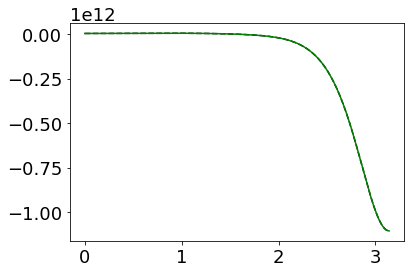

In [17]:
plt.plot(theta,test,'--',color='black')
plt.plot(theta,test1,'g')
#plt.plot(theta,test2,'r')
#plt.yscale('log')

In [51]:
%%time
Bk_wa = bk_wide_angle_test(k1_eq,k2_eq,theta_eq,1/2,0)/500

CPU times: user 466 ms, sys: 1.98 ms, total: 468 ms
Wall time: 466 ms


In [35]:
#ok get some equalateral triangles...

k1_eq = np.geomspace(1e-4,1,1000)
k2_eq = k1_eq
theta_eq = np.arccos(-(k1_eq**2)/(2*k1_eq*k2_eq))

bkmono_eq = bk_mono_func(k1_eq,k2_eq,theta_eq)
Bk_wa = bk_wide_angle(k1_eq,k2_eq,theta_eq,1/2,0)/500
Bk_wa1 = bk_wide_angle(k1_eq,k2_eq,theta_eq,0,0)/500
Bk_wa2 = bk_wide_angle(k1_eq,k2_eq,theta_eq,1,0)/500
Bk_wa3 = bk_wide_angle(k1_eq,k2_eq,theta_eq,0,1)/500
Bk_wa_mid = bk_wide_angle1(k1_eq,k2_eq,theta_eq,1/3,1/3)/500

Text(0, 0.5, '$ |B_{\\ell=1}(k1=0.04,k2=0.02)|/B_0 \\,\\,[\\mathrm{Mpc}/h]^3$')

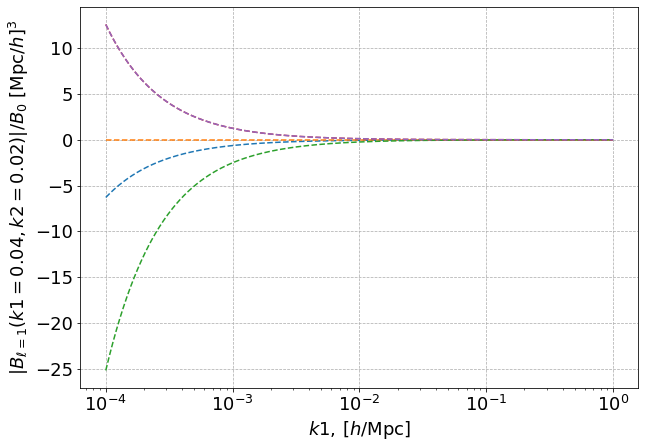

In [19]:
plt.figure(figsize=(10,7))

#plt.xlim(0,1)
plt.grid(ls='--',lw=0.75)

plt.plot(k1_eq,Bk_wa/bkmono_eq,'--')
plt.plot(k1_eq,Bk_wa_mid/bkmono_eq,'--')
plt.plot(k1_eq,Bk_wa1/bkmono_eq,'--')
plt.plot(k1_eq,Bk_wa2/bkmono_eq,'--')
plt.plot(k1_eq,Bk_wa3/bkmono_eq,'--')
plt.xscale('log')
plt.xlabel('$k1,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ |B_{\ell=1}(k1=0.04,k2=0.02)|/B_0 \,\,[\mathrm{Mpc}/h]^3$')

In [20]:
bkmono = bk_mono_func(k1,k2,theta)
bkquad = bk_quad_func(k1,k2,theta)

Bk_wideangle = bk_wide_angle(k1,k2,theta,1/2,0)/d
Bk_wideangle1 = bk_wide_angle(k1,k2,theta,0,0)/d
Bk_wideangle2 = bk_wide_angle(k1,k2,theta,1,0)/d
Bk_wideangle3 = bk_wide_angle(k1,k2,theta,0,1)/d
Bk_wideangle_mid = bk_wide_angle(k1,k2,theta,1/3,1/3)/d
Bk_wideangle_mid1 = bk_wide_angle1(k1,k2,theta,1/3,1/3)/d

#Bk_wideangled = bk_wide_angle_old(k1,k2,k3,1/2,1/2)/500

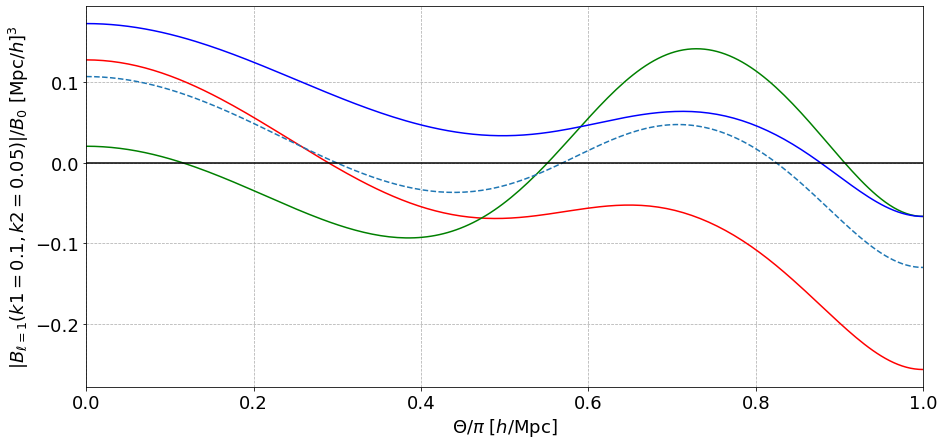

In [21]:
plt.figure(figsize=(15,7))
#plt.ylim(-0.7,0.2)
plt.xlim(0,1)
plt.grid(ls='--',lw=0.75)
#plt.plot(theta/np.pi,Bk_wideangle3/bkmono)
#plt.plot(theta/np.pi,Bk_wideangle2/bkmono)
#plt.plot(theta/np.pi,Bk_wideangle1/bkmono)
#plt.axvline(x = 1/3, linestyle='-.', color = 'black')
#plt.plot(theta/np.pi,Bk_wideangle/bkmono,'-.')
plt.plot(theta/np.pi,Bk_wideangle1/bkmono,'r')
plt.plot(theta/np.pi,Bk_wideangle2/bkmono,'g')
plt.plot(theta/np.pi,Bk_wideangle3/bkmono,'b')
plt.plot(theta/np.pi,Bk_wideangle_mid/bkmono,'--')
#plt.plot(1-theta/np.pi,-Bk_wideangle_mid1/bkmono,'--')
plt.plot(theta/np.pi,np.zeros_like(theta),'k')
#plt.plot(theta,fl.imag/flmono.real,'--')
plt.xlabel('$\Theta/ \pi\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ |B_{\ell=1}(k1=0.1,k2=0.05)|/B_0 \,\,[\mathrm{Mpc}/h]^3$')
plt.savefig('wrong_wide_angle_theory.png')

In [623]:
#%%time
k1 = 0.05

d=420
# Define the function
#@jit
def triangle_plot(x, y,r=0,s=0):
    """Get array of"""
    bk = np.zeros((len(x),len(y)))
    #so only do select values of bispectrum...
    for i in tqdm(range(len(x))):
        #array version:
        k2 = y*k1
        k3 = x[i]*k1
        theta = np.arccos((k3**2 -k1**2 - k2**2)/(2*k1*k2))
        bk[i] = np.where(np.logical_and((y > 1 - x[i]), (y>x[i])),bk_wide_angle(k1,k2,theta,r,s)/d/bk_mono_func(k1,k2,theta),np.nan)  
        #bk[i] = np.where(np.logical_and((y > 1 - x[i]), (y>x[i])),bk_mono_func(k1,k2,theta),np.nan)  

    return bk


x = np.linspace(0.01, 1, 500)
y = np.linspace(0.5, 1, 500)
r=0
s=1
bk_mono = triangle_plot(x,y,r,s)


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-623-26f0c311a933>:15: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((k3**2 -k1**2 - k2**2)/(2*k1*k2))


In [647]:
print(bk1)

[[        nan         nan         nan ... -1.01160095 -0.5265418
  -0.07293567]
 [        nan         nan         nan ... -0.7155097  -0.38629692
  -0.07267792]
 [        nan         nan         nan ... -0.54028843 -0.30226535
  -0.0727564 ]
 ...
 [        nan         nan         nan ... -0.05073809 -0.05077432
  -0.0508108 ]
 [        nan         nan         nan ...         nan -0.05084351
  -0.05087937]
 [        nan         nan         nan ...         nan         nan
          nan]]


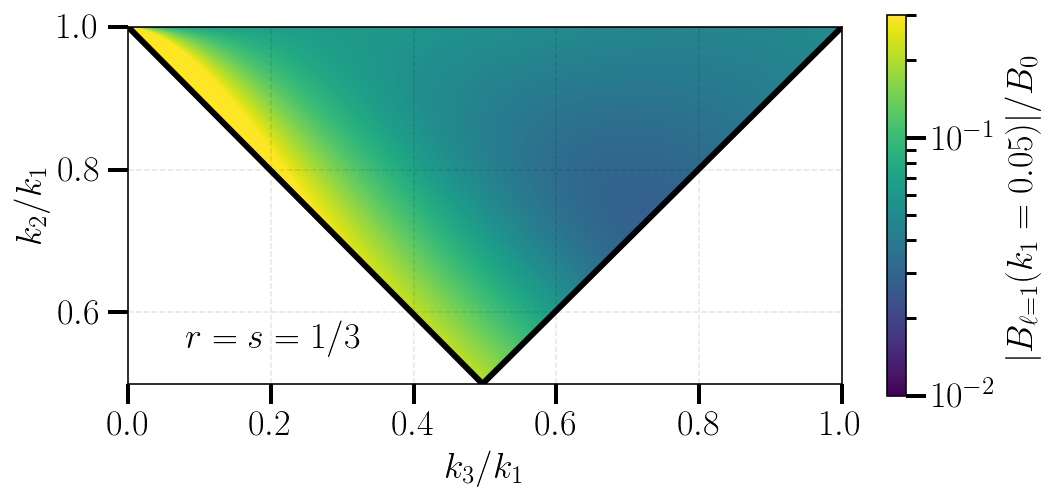

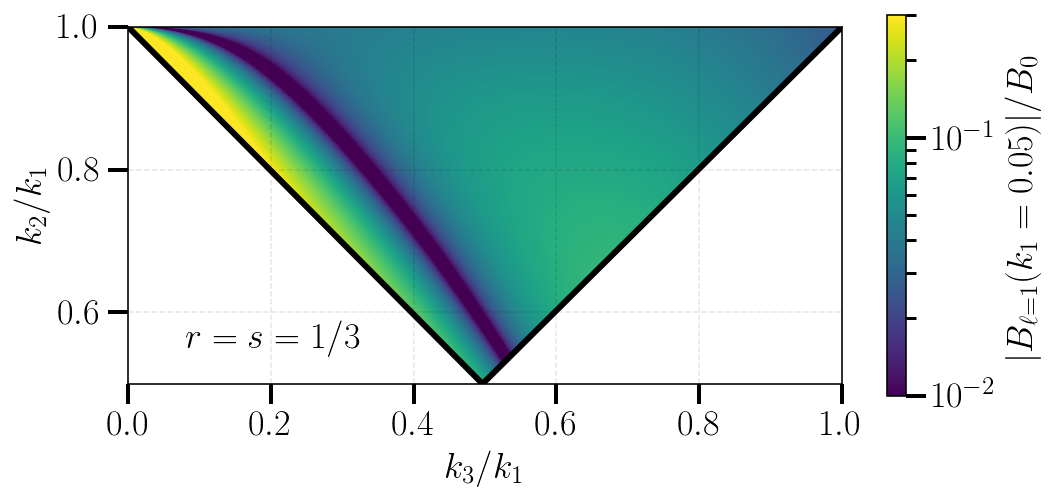

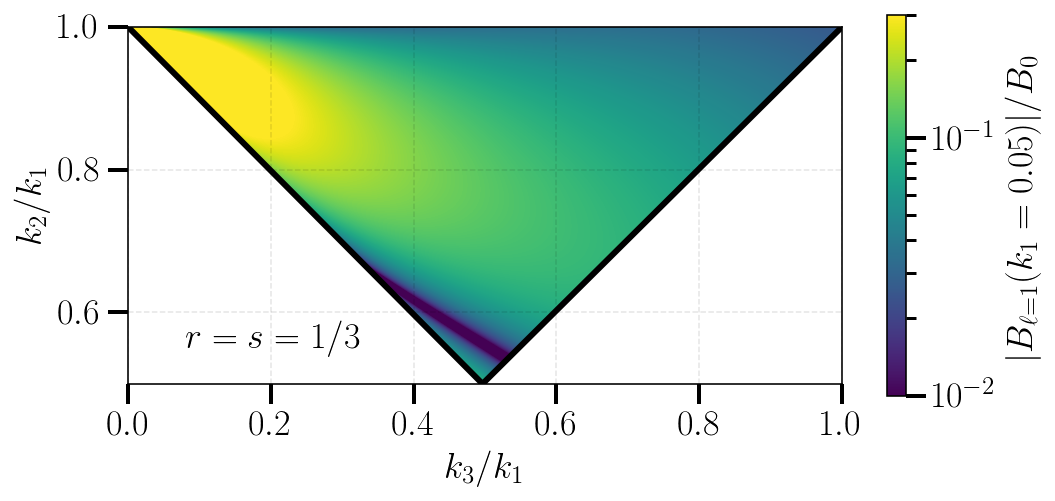

In [655]:
def plot_triangle(bk,vmax): #plot triangle with mask!
    plt.figure(figsize=(8,3.5))
    # Create the colormap plot
    im = plt.imshow(np.abs(bk.T), extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='viridis',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#
    #im = plt.imshow((bk.T), extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='RdBu',vmin=-vmax,vmax=vmax)#

    
    cbar = plt.colorbar(im)#format='%.0e'
    cbar.set_label("$ |B_{\ell=1}(k_1=0.05)|/B_0 $")

    # Add labels and title
    plt.xlabel('$k_3/k_1$')
    plt.ylabel('$k_2/k_1$')

    #so masking 
    # Create a mask for the triangular region
    size = int(1e+3)
    x = np.linspace(0.0, 1, size,dtype=np.float32)
    y = np.linspace(0.5, 1,  size,dtype=np.float32)
    xx,yy = np.meshgrid(x,y)
    mask = np.where(np.logical_and((yy > 1 - xx), (yy>xx)),np.nan,1)
    im = plt.imshow(mask, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='binary')
    
    plt.grid(ls='--',lw=0.75,color='k',alpha=0.1)
    
    x_bound = [0,0.4965,1]
    y_bound = [1,0.50,1]#
    plt.text(0.08,0.55,'$r=s=1/3$')
    plt.plot(x_bound,y_bound,'k',linewidth=3)
    # Show the plot
    plt.savefig('midpoint_triangle.png', bbox_inches='tight', dpi=400)
    plt.show()
    
#plot_triangle(bk_,0.5)
#plot_triangle(bkmid,1)
#plot_triangle(bk_mono,1e+13)
#plt.plot([0.2,0.54],[0.85,0.56])
plot_triangle(bk1,0.3)#d = x1
plot_triangle(bk2,0.3)#d = x2
plot_triangle(bk3,0.3)#d = x3


In [528]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

In [685]:
def plot_triangle_multi(bk0,bk1,bk2,vmax): #plot triangle with mask!
    
    
    fig = plt.figure(figsize=(11, 5))

    # Define gridspec with 4 rows and 3 columns
    gs = GridSpec(1, 3, width_ratios=[3, 3, 3])

    # Create subplots with custom aspect ratios
    axs = [fig.add_subplot(gs[0, i], aspect='10') for i in range(3)]  # Subplots in the first row

    #fig, axs = plt.subplots(1, 3,figsize=(14,5),sharey=True)
    fig.subplots_adjust(wspace=0)
    # Create the colormap plot
    #im0 = axs[0].imshow(np.abs(bk0.T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='viridis',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#
    #im1 = axs[1].imshow(np.abs(bk1.T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='viridis',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#
    #im2 = axs[2].imshow(np.abs(bk2.T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='viridis',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#

    im0 = axs[0].imshow((bk0.T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='RdBu',vmin=-vmax,vmax=vmax)#,vmin=0,vmax=vmax)#
    im1 = axs[1].imshow((bk1.T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='RdBu',vmin=-vmax,vmax=vmax)#,vmin=0,vmax=vmax)#
    im2 = axs[2].imshow((bk2.T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='RdBu',vmin=-vmax,vmax=vmax)#,vmin=0,vmax=vmax)#

    #divider = make_axes_locatable(axs[2])
    #colorbar_ax = divider.append_axes("right", size="5%", pad=0.05)
    #cbar = plt.colorbar(im2, cax=colorbar_ax)
    #
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.81, 0.3, 0.01, 0.4])
    cbar = fig.colorbar(im2, cax=cbar_ax)
    cbar.set_label("$ |B_{\ell=1}(k_1=0.05)|/B_0 $")

    x_bound = [0,0.4965,1]
    y_bound = [1,0.50,1]#
    #so masking 
    # Create a mask for the triangular region
    for i in range(3):
        #axs[i].set_aspect(10)  # Adjust aspect ratio manually
        if i ==0:
            #axs[i].set_yticks(np.arange(0, 0.5, 0.1))
            axs[i].set_ylabel('$k_2/k_1$')
        #size = int(1e+3)
        #x = np.linspace(0.0, 1, size,dtype=np.float32)
        #y = np.linspace(0.5, 1,  size,dtype=np.float32)
        #xx,yy = np.meshgrid(x,y)
        #mask = np.where(np.logical_and((yy > 1 - xx), (yy>xx)),np.nan,1)
        #axs[i].imshow(mask, aspect=1.5, interpolation='bilinear', origin='lower', cmap='binary')
        axs[i].plot(x_bound,y_bound,'k',linewidth=3)
        axs[i].text(0.08,0.55,'$\mathbf{d}=\mathbf{x}_%d$'%(i+1))
        axs[i].set_xlabel('$k_3/k_1$')
        axs[i].set_xticks(np.arange(0.1, 0.91, 0.2))
        #axs[i].set_box_aspect(aspect=0.8)
        #axs[i].set_xlim(0,1)
        #axs[i].set_ylim(0.5,1)
        #axs[i].grid(ls='--',lw=0.75,color='k',alpha=0.1)
        
        if i!=0:
            axs[i].yaxis.set_major_locator(plt.NullLocator())
    
    # Show the plot
    plt.savefig('endpoint_traingles.png', bbox_inches='tight', dpi=400)
    plt.show()

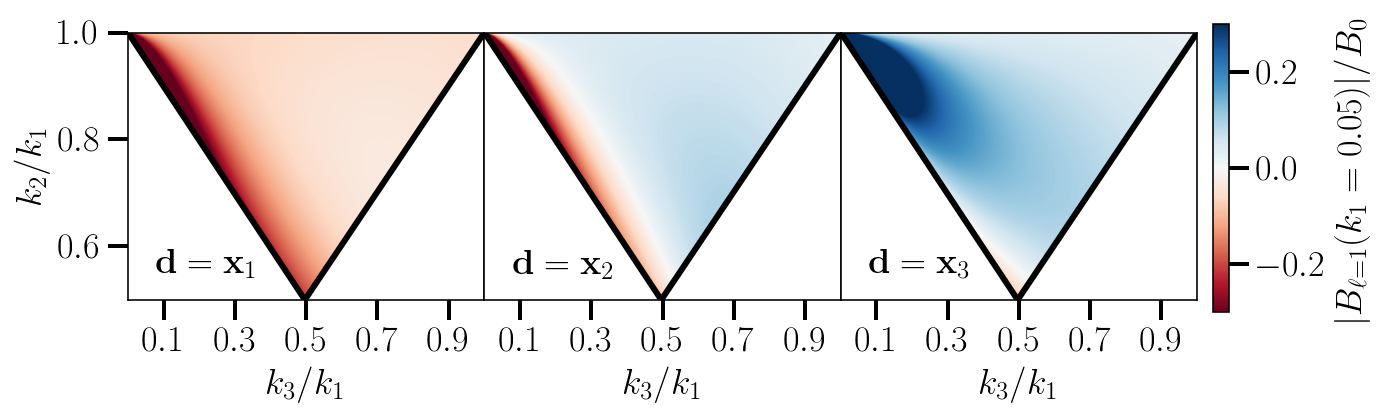

In [687]:
plot_triangle_multi(bk1,bk2,bk3,0.3)

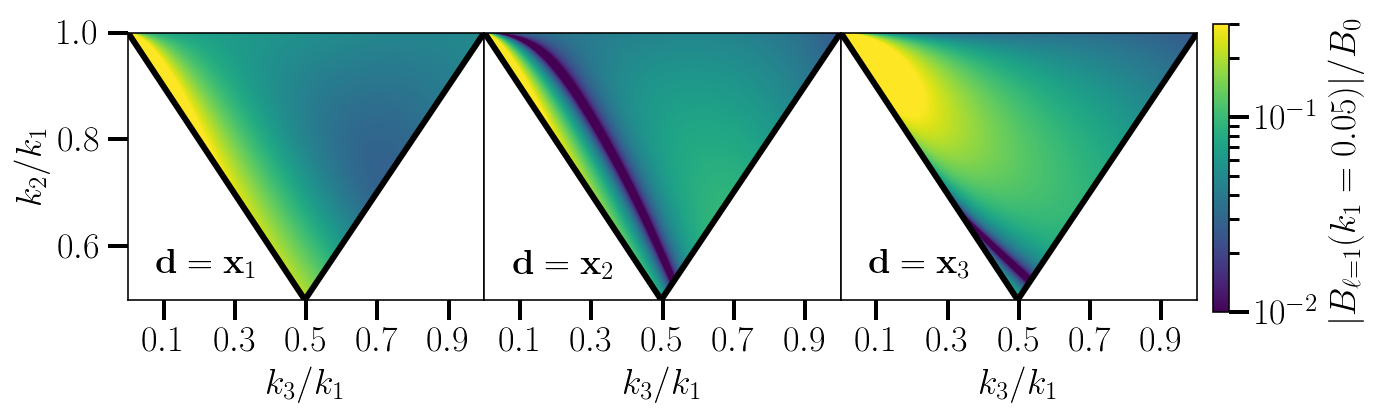

In [684]:
plot_triangle_multi(bk1,bk2,bk3,0.3)

Figure(1080x288)


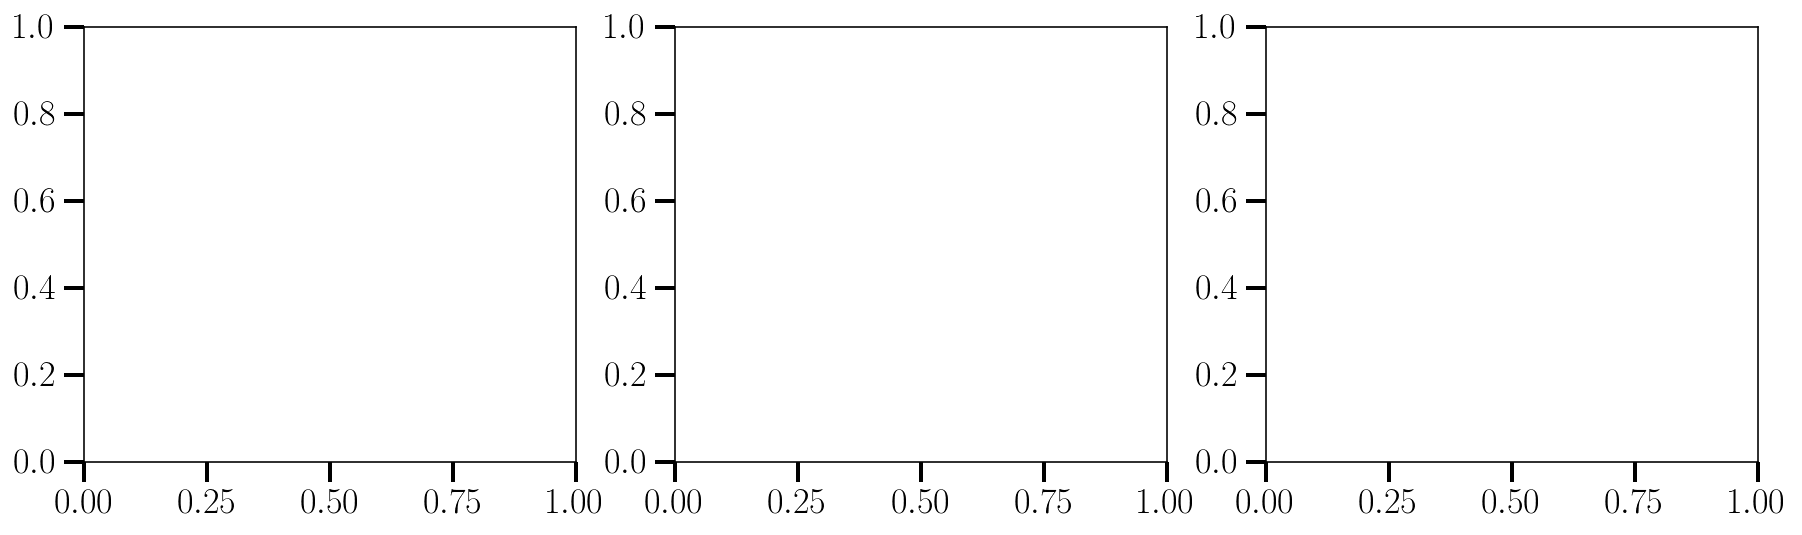

In [363]:
fig, axs = plt.subplots(1, 3,figsize=(15,4))
print(fig)

Text(0, 0.5, '$ |B_{\\ell=1}(k1=0.04,k2=0.02)|/B_0 \\,\\,[\\mathrm{Mpc}/h]^3$')

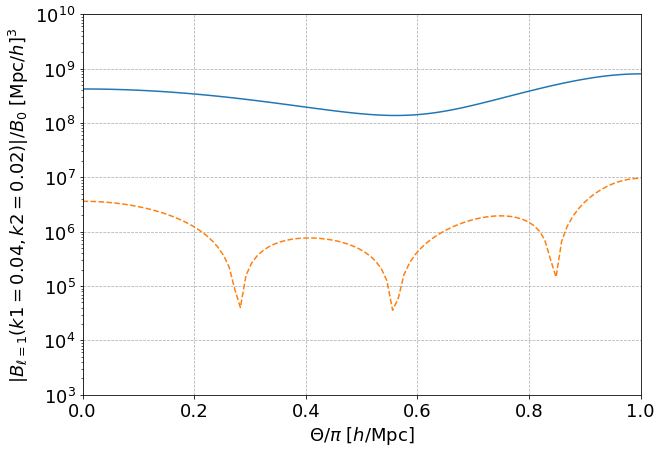

In [1091]:
plt.figure(figsize=(10,7))
plt.ylim(1e3,1e10)
plt.xlim(0,1)
plt.grid(ls='--',lw=0.75)
#plt.plot(theta/np.pi,Bk_wideangle3/bkmono)
#plt.plot(theta/np.pi,Bk_wideangle2/bkmono)
#plt.plot(theta/np.pi,Bk_wideangle1/bkmono)
#plt.axvline(x = 1/3, linestyle='-.', color = 'black')
plt.plot(theta/np.pi,bkmono)
plt.plot(theta/np.pi,np.abs(Bk_wideangle_mid),'--')
#plt.plot(theta/np.pi,np.abs(Bk_wideangle_mid1),'--')
plt.plot(1-theta/np.pi,np.zeros_like(theta),'k')
#plt.plot(theta,fl.imag/flmono.real,'--')
plt.yscale('log')
plt.xlabel('$\Theta/ \pi\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ |B_{\ell=1}(k1=0.04,k2=0.02)|/B_0 \,\,[\mathrm{Mpc}/h]^3$')

In [700]:
Bk_wideangle1 = bk_wide_angle(k1,k2,theta,1,0)/d
Bk_wideangle2 = bk_wide_angle(k1,k2,theta,0,1)/d
Bk_wideangle3 = bk_wide_angle(k1,k2,theta,0,0)/d

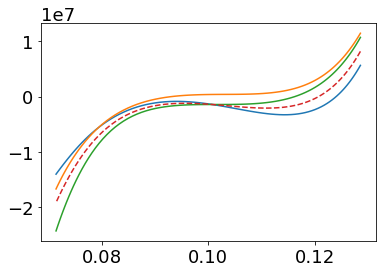

In [643]:
plt.plot(k3,Bk_wideangle1)
plt.plot(k3,Bk_wideangle2)
plt.plot(k3,Bk_wideangle3)
plt.plot(k3,Bk_wideangle,'--')

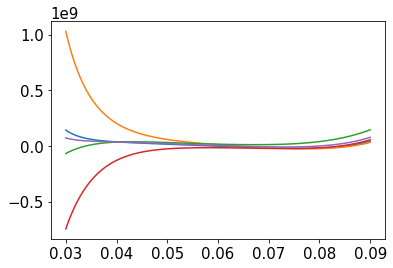

In [927]:
plt.plot(k3,Bk_wideangle)
plt.plot(k3,Bk_wideangle1)
plt.plot(k3,Bk_wideangle2)
plt.plot(k3,Bk_wideangle3)
plt.plot(k3,(Bk_wideangle1+Bk_wideangle2+Bk_wideangle3)/3)
#plt.xlim(0.01,0.18)
#plt.ylim(-1e+7,2e+8)

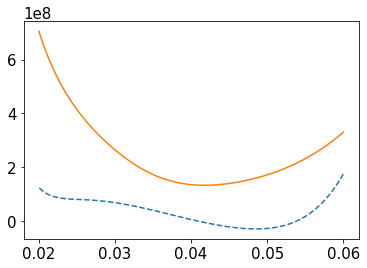

In [940]:
plt.plot(k3,Bk_wideangle_mid,'--')
plt.plot(k3,bkmono)

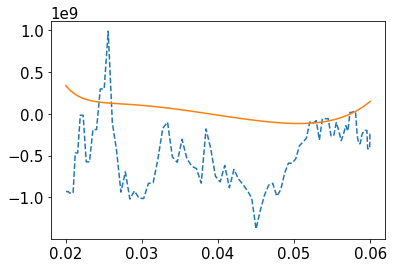

In [840]:
#plt.plot(k3,bkmono,'--')
plt.plot(k3,-fl.imag,'--')
plt.plot(k3,Bk_wideangle)
#plt.xlim(0.04,0.18)
#plt.ylim(-1e+6,2e+8)

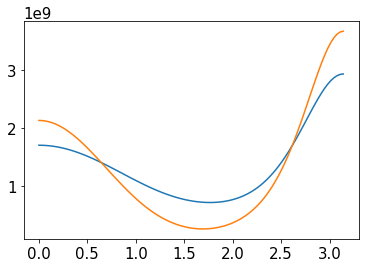

In [843]:
plt.plot(theta,bkmono)
#plt.plot(theta,np.real(flmono),'--')
plt.plot(theta,bkquad)
#plt.xlim(0.06,0.18)
#plt.ylim(1e-3,2e+8)
#plt.plot(bkmono_ol)
#plt.plot(bkquad_ol)

In [296]:
Pl0_pp = b1**2 *Plin + (2*b1*f*Plin)/3 + (f**2 *Plin)/5
Pl0_pp1 = b1**2 *Pk_lin(k_est) + (2*b1*f*Pk_lin(k_est))/3 + (f**2 *Pk_lin(k_est))/5

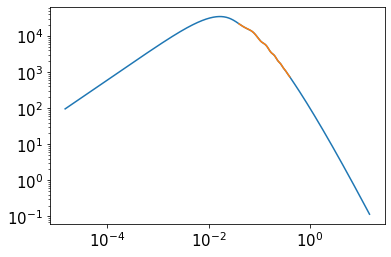

In [297]:
plt.loglog(k,Pl0_pp)
plt.loglog(k_est,Pl0_pp1)

/opt/jupyterhub/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/jupyterhub/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


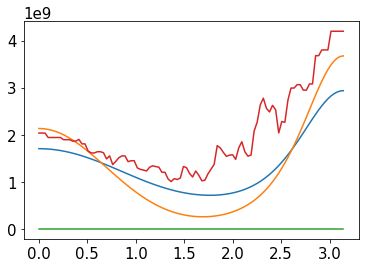

In [668]:
plt.plot(theta,(bkmono))
plt.plot(theta,(bkquad))
plt.plot(theta,(fl))
plt.plot(theta,(flmono))

In [29]:
import numpy as np
import sys
from time import time
sys.path.append('/home/addis/unamed_code')
sys.path.append('/home/addis/unamed_code/Library')
import Bk_theta_iFFT as Bk_
import Bk_theta_sum as Bk_sum
#import Bk_theta_sum2 as Bk_sum2
#import Bk_theta1 as Bk_theta

import get_field as gf
from matplotlib import pyplot as plt
import compute_grid_info as cgi

In [91]:
#field things!
path = '../data/Quijote/' #path to folder containing quijote files.
N_side = 128
rsd_direction = '' # 'z'

redshift = '/snapdir_004/snap_004'
if redshift[-1] == str(4):
    red_info = 'z=0'
elif redshift[-1] == str(2):
    red_info = 'z=1'
else:
    red_info = 'z=NA'
    
    
Nside=128
L=1000

In [432]:
%%time
rfft=False
order=2
obs_pos=(500,500,500)
grid_info = cgi.compute_survey(Nside,L,rfft,order,obs_pos)  # so call 
xi,ki,k_mag,MAS,k_f,k_ny = grid_info

CPU times: user 133 ms, sys: 99.7 ms, total: 232 ms
Wall time: 231 ms


In [433]:
import Pk_old as Pk
k_est = np.linspace(0.006,0.4,100)
s=1 #units of 2*k_f
binning_info = cgi.pk_compute_bins(k_est,s,grid_info[2],grid_info[4])
#In_bin,N_modes
iFFT=False
dtype=np.complex64
threads=4
verbose=True
t=1
l=1
#j_old = Pk_old.Pk(field_tmp,L,Nside,l,k,grid_info,binning_info,t,iFFT,dtype,threads,rfft,verbose)
j = Pk.Pk(field,L,Nside,l,k_est,grid_info,binning_info,t,iFFT,dtype,threads,rfft,verbose)

In [591]:
%%time
dtype=np.complex64
s=1 #units of 2*k_f
threads=4
rs=[0,0]
binning_info = cgi.bk_theta_compute_bins(k1,k2,theta,Nside,s,grid_info[2],grid_info[4],dtype,threads,rfft)
#In_bin,Ntri,in_k1,in_k2

CPU times: user 16 s, sys: 2.54 s, total: 18.6 s
Wall time: 5.52 s


In [601]:
rs = [1,0]
verbose =True
l = 1

In [598]:
%%time
j = Bk_.Bk(field,l,L,Nside,theta,grid_info,binning_info,rs,dtype,threads,rfft,verbose)

nyquist frequency= 0.40212385965949354 fundamental frequency= 0.006283185307179587
Number of FFTs used= 1 Number of iFFTs used= 102


NameError: name 'Bk_midpoint_theta' is not defined

In [1056]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
